# Uczenie Głębokie - Praca Domowa 1
## Autorzy:
**Jakub Kuniszewski 180125**

**Michał Kokoszkiewicz 197116**

## Specjalizacja:
**Uczenie Maszynowe**

**Grupa 2**

**Data: 22.01.2024**

## Komórki odpowiadające za pobranie i wstępne przygotowanie danych

**Poniższa komórka pobiera zbiór danych z adresu URL pod którym dokładnie on się znajduje, tak aby nie trzeba było tego robić manualnie. Następnie pobrany ZIP zostaje rozpakowany.**

In [ ]:
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
!unzip -n -q kagglecatsanddogs_5340.zip

--2024-01-16 20:48:31--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.54.200.233, 2600:1404:6400:1495::317f, 2600:1404:6400:1484::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.54.200.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘kagglecatsanddogs_5340.zip’

kagglecatsanddogs_5 100%[===================>] 786.67M  56.7MB/s    in 16s     

2024-01-16 20:48:47 (49.5 MB/s) - ‘kagglecatsanddogs_5340.zip’ saved [824887076/824887076]



**Pobieramy bibliotekę ultralytics, z której wczytamy model YOLOv8.**

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.7/699.7 kB 4.3 MB/s eta 0:00:00


**Wczytujemy model YOLOv8.**

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 66.0MB/s]


**Testujemy jak działa model na przykładowym obrazie ze zbioru danych.**

In [ ]:
results = model("PetImages/Dog/1.jpg")


image 1/1 /content/PetImages/Dog/1.jpg: 640x448 1 dog, 278.2ms
Speed: 2.5ms preprocess, 278.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


**Z wyniku modelu wyciągamy dane detekcji dotyczące wyktrytych obiektów i ich bounding-box'ów oraz przycinamy zdjęcie zgodnie z wyznaczonym bounding-box'em dla klasy Dog, która ma indeks 16. Z obserwacji działania dla kilku przykładowych obrazów, które przetestowaliśmy, wnioskujemy że model radzi sobie bardzo dobrze z tym zadaniem.**

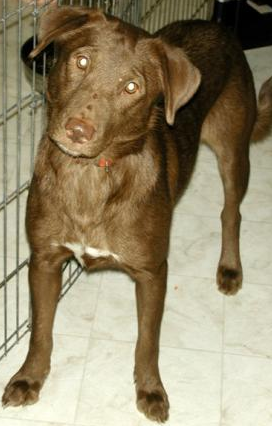

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import torch

result = results[0]

boxes = result.boxes.data

dog_class_index = 16

dog_bboxes = boxes[boxes[:, 5] == dog_class_index]

if dog_bboxes.numel() > 0:
    xyxy = dog_bboxes[:, :4].int()
    image_path = "/content/PetImages/Dog/1.jpg"
    image = cv2.imread(image_path)

    for i in range(len(dog_bboxes)):
        cropped_image = image[xyxy[i, 1]:xyxy[i, 3], xyxy[i, 0]:xyxy[i, 2]]
        cv2_imshow(cropped_image)

**Tutaj już robimy przycinanie obrazów zgodnie z powyższym przykładem, ale dla całego zbioru danych. Określamy folder z danymi wejściowymi, czyli obrazy z pobranego zbioru danych oraz folder wyjściowy, w którym będą zapisywały się przycięte już obrazy. Następnie iterujemy przez wszystkie obrazy i wykonujemy takie operacje jak detekcja obiektów przez model YOLOv8, wyciągnięcie informacji o bounding-box'ie dla klasy Dog, przycięciu zdjęcia zgodnie z tym bounding-box'em oraz zapisaniem nowego pliku. Pętla zawiera również obługę błędów, ponieważ nie na każdym obrazie model może znaleźć psa lub może być problem z wczytaniem pliku. Przez to będziemy mieli mnie obrazów, ale bardziej jakościowych, ponieważ na zdjęciach były różne inne rzeczy, zwierzęta oraz osoby, co psuło działanie naszego generatora.**

In [ ]:
import os
from tqdm import tqdm

input_folder_path = "/content/PetImages/Dog"

output_folder_path = "/content/Dog"

os.makedirs(output_folder_path, exist_ok=True)
dog_class_index = 16

for filename in tqdm(os.listdir(input_folder_path), desc="Processing Images"):

    if filename.endswith(".jpg"):
        input_image_path = os.path.join(input_folder_path, filename)

        try:
            results = model(input_image_path)
            result = results[0]
            boxes = result.boxes.data
            dog_class_index = 16
            dog_bboxes = boxes[boxes[:, 5] == dog_class_index]

            if dog_bboxes.numel() > 0:
                xyxy = dog_bboxes[:, :4].int()
                image = cv2.imread(input_image_path)

                for i in range(len(dog_bboxes)):
                    cropped_image = image[xyxy[i, 1]:xyxy[i, 3], xyxy[i, 0]:xyxy[i, 2]]
                    output_image_path = os.path.join(output_folder_path, f"cropped_{filename}")
                    cv2.imwrite(output_image_path, cropped_image)
            else:
                print(f"No dog bbox found in {filename}")

        except FileNotFoundError as e:
            print(f"Error processing {filename}: {e}")

Processing Images:   0%|          | 0/12501 [00:00<?, ?it/s]


image 1/1 /content/PetImages/Dog/7957.jpg: 480x640 1 dog, 2 beds, 146.6ms
Speed: 2.9ms preprocess, 146.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 1/12501 [00:00<34:41,  6.00it/s]


image 1/1 /content/PetImages/Dog/4302.jpg: 448x640 1 dog, 108.7ms
Speed: 2.2ms preprocess, 108.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 2/12501 [00:00<29:51,  6.98it/s]


image 1/1 /content/PetImages/Dog/8565.jpg: 352x640 1 cat, 2 dogs, 91.8ms
Speed: 1.7ms preprocess, 91.8ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:   0%|          | 3/12501 [00:00<26:36,  7.83it/s]


image 1/1 /content/PetImages/Dog/530.jpg: 480x640 1 person, 2 dogs, 1 couch, 115.3ms
Speed: 2.5ms preprocess, 115.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 4/12501 [00:00<27:26,  7.59it/s]


image 1/1 /content/PetImages/Dog/7764.jpg: 480x640 1 car, 1 truck, 1 dog, 118.7ms
Speed: 2.6ms preprocess, 118.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 5/12501 [00:00<28:02,  7.43it/s]


image 1/1 /content/PetImages/Dog/11961.jpg: 480x640 1 person, 125.2ms
Speed: 2.9ms preprocess, 125.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 6/12501 [00:00<28:26,  7.32it/s]

No dog bbox found in 11961.jpg

image 1/1 /content/PetImages/Dog/11684.jpg: 480x640 1 person, 124.2ms
Speed: 4.1ms preprocess, 124.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 7/12501 [00:00<28:54,  7.20it/s]

No dog bbox found in 11684.jpg

image 1/1 /content/PetImages/Dog/3603.jpg: 448x640 2 dogs, 1 couch, 109.6ms
Speed: 3.4ms preprocess, 109.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 8/12501 [00:01<28:30,  7.30it/s]


image 1/1 /content/PetImages/Dog/2862.jpg: 512x640 1 dog, 132.0ms
Speed: 2.9ms preprocess, 132.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   0%|          | 9/12501 [00:01<29:23,  7.08it/s]


image 1/1 /content/PetImages/Dog/8261.jpg: 640x608 1 dog, 1 bear, 152.5ms
Speed: 4.0ms preprocess, 152.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   0%|          | 10/12501 [00:01<31:52,  6.53it/s]


image 1/1 /content/PetImages/Dog/12476.jpg: 640x320 1 dog, 83.5ms
Speed: 2.8ms preprocess, 83.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:   0%|          | 11/12501 [00:01<28:29,  7.31it/s]


image 1/1 /content/PetImages/Dog/5084.jpg: 640x608 1 dog, 156.1ms
Speed: 2.0ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   0%|          | 12/12501 [00:01<31:01,  6.71it/s]


image 1/1 /content/PetImages/Dog/3476.jpg: 608x640 1 dog, 158.6ms
Speed: 3.4ms preprocess, 158.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   0%|          | 13/12501 [00:01<32:39,  6.37it/s]


image 1/1 /content/PetImages/Dog/3082.jpg: 448x640 (no detections), 108.1ms
Speed: 1.7ms preprocess, 108.1ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 14/12501 [00:02<30:28,  6.83it/s]

No dog bbox found in 3082.jpg

image 1/1 /content/PetImages/Dog/2561.jpg: 480x640 1 dog, 113.3ms
Speed: 2.3ms preprocess, 113.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 15/12501 [00:02<29:42,  7.01it/s]


image 1/1 /content/PetImages/Dog/9969.jpg: 640x544 1 dog, 137.6ms
Speed: 2.5ms preprocess, 137.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   0%|          | 16/12501 [00:02<30:30,  6.82it/s]


image 1/1 /content/PetImages/Dog/9900.jpg: 480x640 1 dog, 120.1ms
Speed: 3.2ms preprocess, 120.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 17/12501 [00:02<30:05,  6.91it/s]


image 1/1 /content/PetImages/Dog/2841.jpg: 640x576 1 bench, 1 dog, 145.7ms
Speed: 3.0ms preprocess, 145.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   0%|          | 18/12501 [00:02<31:35,  6.59it/s]


image 1/1 /content/PetImages/Dog/11964.jpg: 608x640 1 dog, 140.2ms
Speed: 1.9ms preprocess, 140.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   0%|          | 19/12501 [00:02<32:07,  6.48it/s]


image 1/1 /content/PetImages/Dog/595.jpg: 480x640 1 bird, 126.0ms
Speed: 2.5ms preprocess, 126.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 20/12501 [00:02<31:24,  6.62it/s]

No dog bbox found in 595.jpg

image 1/1 /content/PetImages/Dog/1026.jpg: 480x640 1 dog, 119.1ms
Speed: 2.4ms preprocess, 119.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 21/12501 [00:03<30:45,  6.76it/s]


image 1/1 /content/PetImages/Dog/11877.jpg: 640x480 1 person, 1 dog, 114.0ms
Speed: 2.4ms preprocess, 114.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 22/12501 [00:03<30:05,  6.91it/s]


image 1/1 /content/PetImages/Dog/4987.jpg: 480x640 1 dog, 1 bottle, 1 bed, 1 toilet, 121.6ms
Speed: 2.4ms preprocess, 121.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 23/12501 [00:03<30:00,  6.93it/s]


image 1/1 /content/PetImages/Dog/11998.jpg: 448x640 2 dogs, 112.5ms
Speed: 2.3ms preprocess, 112.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 24/12501 [00:03<29:26,  7.06it/s]


image 1/1 /content/PetImages/Dog/820.jpg: 512x640 1 dog, 132.7ms
Speed: 2.6ms preprocess, 132.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   0%|          | 25/12501 [00:03<30:17,  6.86it/s]


image 1/1 /content/PetImages/Dog/11778.jpg: 480x640 1 dog, 1 couch, 117.6ms
Speed: 2.6ms preprocess, 117.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 26/12501 [00:03<30:06,  6.91it/s]


image 1/1 /content/PetImages/Dog/1543.jpg: 480x640 1 person, 1 dog, 122.8ms
Speed: 2.5ms preprocess, 122.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 27/12501 [00:03<30:03,  6.92it/s]


image 1/1 /content/PetImages/Dog/5994.jpg: 640x480 2 dogs, 121.4ms
Speed: 2.5ms preprocess, 121.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 28/12501 [00:04<30:10,  6.89it/s]


image 1/1 /content/PetImages/Dog/2748.jpg: 480x640 2 persons, 2 dogs, 111.6ms
Speed: 2.4ms preprocess, 111.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 29/12501 [00:04<29:24,  7.07it/s]


image 1/1 /content/PetImages/Dog/2819.jpg: 448x640 1 dog, 1 sports ball, 106.0ms
Speed: 2.2ms preprocess, 106.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 30/12501 [00:04<28:22,  7.32it/s]


image 1/1 /content/PetImages/Dog/3158.jpg: 640x448 1 person, 1 dog, 1 bed, 109.4ms
Speed: 2.6ms preprocess, 109.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   0%|          | 31/12501 [00:04<27:51,  7.46it/s]


image 1/1 /content/PetImages/Dog/750.jpg: 640x640 1 dog, 1 bed, 154.3ms
Speed: 3.1ms preprocess, 154.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   0%|          | 32/12501 [00:04<30:28,  6.82it/s]


image 1/1 /content/PetImages/Dog/9018.jpg: 480x640 1 person, 1 dog, 112.2ms
Speed: 1.6ms preprocess, 112.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 33/12501 [00:04<29:26,  7.06it/s]


image 1/1 /content/PetImages/Dog/953.jpg: 640x480 1 person, 1 dog, 1 sheep, 115.6ms
Speed: 2.8ms preprocess, 115.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 34/12501 [00:04<28:54,  7.19it/s]


image 1/1 /content/PetImages/Dog/6566.jpg: 480x640 2 persons, 118.6ms
Speed: 3.0ms preprocess, 118.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 35/12501 [00:05<28:30,  7.29it/s]

No dog bbox found in 6566.jpg

image 1/1 /content/PetImages/Dog/7358.jpg: 480x640 1 dog, 113.8ms
Speed: 2.6ms preprocess, 113.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 36/12501 [00:05<28:18,  7.34it/s]


image 1/1 /content/PetImages/Dog/9655.jpg: 640x640 1 dog, 165.6ms
Speed: 2.9ms preprocess, 165.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   0%|          | 37/12501 [00:05<31:40,  6.56it/s]


image 1/1 /content/PetImages/Dog/11032.jpg: 480x640 1 person, 116.5ms
Speed: 2.0ms preprocess, 116.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 38/12501 [00:05<30:17,  6.86it/s]

No dog bbox found in 11032.jpg

image 1/1 /content/PetImages/Dog/5557.jpg: 448x640 1 dog, 112.3ms
Speed: 2.9ms preprocess, 112.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 39/12501 [00:05<29:27,  7.05it/s]


image 1/1 /content/PetImages/Dog/807.jpg: 480x640 1 dog, 112.0ms
Speed: 2.5ms preprocess, 112.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 40/12501 [00:05<28:55,  7.18it/s]


image 1/1 /content/PetImages/Dog/9333.jpg: 288x640 (no detections), 76.2ms
Speed: 2.0ms preprocess, 76.2ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)
No dog bbox found in 9333.jpg

image 1/1 /content/PetImages/Dog/5652.jpg: 512x640 1 dog, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   0%|          | 42/12501 [00:05<27:14,  7.62it/s]


image 1/1 /content/PetImages/Dog/4285.jpg: 480x640 1 dog, 112.2ms
Speed: 2.8ms preprocess, 112.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 43/12501 [00:06<27:07,  7.65it/s]


image 1/1 /content/PetImages/Dog/11932.jpg: 448x640 1 person, 1 dog, 1 horse, 106.9ms
Speed: 2.6ms preprocess, 106.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 44/12501 [00:06<26:59,  7.69it/s]


image 1/1 /content/PetImages/Dog/5806.jpg: 640x480 2 persons, 4 cars, 1 dog, 120.0ms
Speed: 2.3ms preprocess, 120.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 45/12501 [00:06<27:29,  7.55it/s]


image 1/1 /content/PetImages/Dog/4214.jpg: 480x640 2 dogs, 121.6ms
Speed: 2.9ms preprocess, 121.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 46/12501 [00:06<27:56,  7.43it/s]


image 1/1 /content/PetImages/Dog/6750.jpg: 608x640 2 dogs, 156.7ms
Speed: 3.4ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   0%|          | 47/12501 [00:06<30:44,  6.75it/s]


image 1/1 /content/PetImages/Dog/12163.jpg: 448x640 1 person, 1 dog, 1 bear, 106.8ms
Speed: 2.2ms preprocess, 106.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 48/12501 [00:06<29:38,  7.00it/s]


image 1/1 /content/PetImages/Dog/405.jpg: 480x640 1 person, 1 dog, 131.2ms
Speed: 2.6ms preprocess, 131.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 49/12501 [00:06<30:31,  6.80it/s]


image 1/1 /content/PetImages/Dog/7237.jpg: 576x640 1 zebra, 141.9ms
Speed: 5.1ms preprocess, 141.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   0%|          | 50/12501 [00:07<31:12,  6.65it/s]

No dog bbox found in 7237.jpg

image 1/1 /content/PetImages/Dog/10517.jpg: 480x640 1 dog, 1 cup, 111.7ms
Speed: 1.6ms preprocess, 111.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 51/12501 [00:07<30:13,  6.86it/s]


image 1/1 /content/PetImages/Dog/2997.jpg: 512x640 1 dog, 1 couch, 129.7ms
Speed: 3.3ms preprocess, 129.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   0%|          | 52/12501 [00:07<30:10,  6.88it/s]


image 1/1 /content/PetImages/Dog/9445.jpg: 512x640 1 dog, 128.9ms
Speed: 3.1ms preprocess, 128.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   0%|          | 53/12501 [00:07<30:07,  6.89it/s]


image 1/1 /content/PetImages/Dog/10447.jpg: 640x480 1 cat, 114.6ms
Speed: 2.8ms preprocess, 114.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 54/12501 [00:07<29:08,  7.12it/s]

No dog bbox found in 10447.jpg

image 1/1 /content/PetImages/Dog/8886.jpg: 480x640 1 dog, 111.7ms
Speed: 3.2ms preprocess, 111.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 55/12501 [00:07<28:43,  7.22it/s]


image 1/1 /content/PetImages/Dog/6993.jpg: 480x640 1 person, 2 dogs, 125.6ms
Speed: 2.3ms preprocess, 125.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 56/12501 [00:07<29:48,  6.96it/s]


image 1/1 /content/PetImages/Dog/7563.jpg: 640x480 1 dog, 156.3ms
Speed: 3.8ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 57/12501 [00:08<32:20,  6.41it/s]


image 1/1 /content/PetImages/Dog/5760.jpg: 480x640 2 dogs, 1 bowl, 158.0ms
Speed: 3.4ms preprocess, 158.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 58/12501 [00:08<34:02,  6.09it/s]


image 1/1 /content/PetImages/Dog/5079.jpg: 448x640 1 cat, 2 books, 140.5ms
Speed: 3.3ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   0%|          | 59/12501 [00:08<33:29,  6.19it/s]

No dog bbox found in 5079.jpg

image 1/1 /content/PetImages/Dog/8300.jpg: 480x640 1 car, 1 dog, 1 chair, 157.9ms
Speed: 3.3ms preprocess, 157.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   0%|          | 60/12501 [00:08<34:40,  5.98it/s]


image 1/1 /content/PetImages/Dog/6512.jpg: 640x640 1 person, 1 dog, 201.3ms
Speed: 4.9ms preprocess, 201.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   0%|          | 61/12501 [00:08<37:58,  5.46it/s]


image 1/1 /content/PetImages/Dog/3872.jpg: 640x480 1 dog, 1 potted plant, 162.4ms
Speed: 2.5ms preprocess, 162.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   0%|          | 62/12501 [00:09<38:25,  5.39it/s]


image 1/1 /content/PetImages/Dog/11852.jpg: 480x640 1 dog, 153.0ms
Speed: 3.3ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 63/12501 [00:09<38:20,  5.41it/s]


image 1/1 /content/PetImages/Dog/5379.jpg: 544x640 2 dogs, 171.7ms
Speed: 5.4ms preprocess, 171.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   1%|          | 64/12501 [00:09<39:14,  5.28it/s]


image 1/1 /content/PetImages/Dog/11224.jpg: 480x640 1 car, 1 dog, 111.6ms
Speed: 2.6ms preprocess, 111.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 65/12501 [00:09<35:42,  5.80it/s]


image 1/1 /content/PetImages/Dog/7484.jpg: 640x640 1 dog, 155.4ms
Speed: 3.0ms preprocess, 155.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 66/12501 [00:09<36:09,  5.73it/s]


image 1/1 /content/PetImages/Dog/566.jpg: 640x384 1 dog, 96.9ms
Speed: 1.2ms preprocess, 96.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   1%|          | 67/12501 [00:09<32:27,  6.38it/s]


image 1/1 /content/PetImages/Dog/7023.jpg: 640x576 2 persons, 1 dog, 143.9ms
Speed: 1.9ms preprocess, 143.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 68/12501 [00:10<33:01,  6.27it/s]


image 1/1 /content/PetImages/Dog/1624.jpg: 640x608 1 person, 1 dog, 140.0ms
Speed: 1.9ms preprocess, 140.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   1%|          | 69/12501 [00:10<33:14,  6.23it/s]


image 1/1 /content/PetImages/Dog/2790.jpg: 640x480 1 dog, 121.5ms
Speed: 3.6ms preprocess, 121.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   1%|          | 70/12501 [00:10<32:18,  6.41it/s]


image 1/1 /content/PetImages/Dog/7879.jpg: 640x608 1 dog, 1 broccoli, 148.8ms
Speed: 3.4ms preprocess, 148.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   1%|          | 71/12501 [00:10<33:29,  6.19it/s]


image 1/1 /content/PetImages/Dog/2757.jpg: 512x640 1 dog, 132.2ms
Speed: 4.1ms preprocess, 132.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   1%|          | 72/12501 [00:10<33:21,  6.21it/s]


image 1/1 /content/PetImages/Dog/10594.jpg: 640x576 1 dog, 146.4ms
Speed: 3.0ms preprocess, 146.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 73/12501 [00:10<34:10,  6.06it/s]


image 1/1 /content/PetImages/Dog/4218.jpg: 480x640 (no detections), 117.5ms
Speed: 4.0ms preprocess, 117.5ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 74/12501 [00:11<32:23,  6.39it/s]

No dog bbox found in 4218.jpg

image 1/1 /content/PetImages/Dog/600.jpg: 480x640 1 person, 1 cow, 126.5ms
Speed: 3.5ms preprocess, 126.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 75/12501 [00:11<31:41,  6.53it/s]

No dog bbox found in 600.jpg

image 1/1 /content/PetImages/Dog/6278.jpg: 640x416 1 teddy bear, 112.1ms
Speed: 3.0ms preprocess, 112.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   1%|          | 76/12501 [00:11<30:12,  6.85it/s]

No dog bbox found in 6278.jpg

image 1/1 /content/PetImages/Dog/4340.jpg: 640x416 1 dog, 106.1ms
Speed: 2.6ms preprocess, 106.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   1%|          | 77/12501 [00:11<28:57,  7.15it/s]


image 1/1 /content/PetImages/Dog/3757.jpg: 640x544 1 dog, 135.6ms
Speed: 3.1ms preprocess, 135.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   1%|          | 78/12501 [00:11<30:04,  6.89it/s]


image 1/1 /content/PetImages/Dog/4248.jpg: 448x640 1 cat, 114.3ms
Speed: 3.2ms preprocess, 114.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|          | 79/12501 [00:11<29:08,  7.11it/s]

No dog bbox found in 4248.jpg

image 1/1 /content/PetImages/Dog/4181.jpg: 640x640 1 dog, 164.3ms
Speed: 4.8ms preprocess, 164.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 80/12501 [00:11<32:00,  6.47it/s]


image 1/1 /content/PetImages/Dog/172.jpg: 640x416 (no detections), 101.7ms
Speed: 1.8ms preprocess, 101.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   1%|          | 81/12501 [00:12<29:34,  7.00it/s]

No dog bbox found in 172.jpg

image 1/1 /content/PetImages/Dog/7858.jpg: 640x608 1 dog, 152.8ms
Speed: 4.0ms preprocess, 152.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   1%|          | 82/12501 [00:12<31:49,  6.51it/s]


image 1/1 /content/PetImages/Dog/9358.jpg: 640x640 1 horse, 158.4ms
Speed: 3.5ms preprocess, 158.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 83/12501 [00:12<33:02,  6.26it/s]

No dog bbox found in 9358.jpg

image 1/1 /content/PetImages/Dog/11686.jpg: 512x640 (no detections), 126.0ms
Speed: 1.6ms preprocess, 126.0ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   1%|          | 84/12501 [00:12<31:36,  6.55it/s]

No dog bbox found in 11686.jpg

image 1/1 /content/PetImages/Dog/6886.jpg: 480x640 1 person, 1 dog, 114.3ms
Speed: 3.6ms preprocess, 114.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 85/12501 [00:12<30:37,  6.76it/s]


image 1/1 /content/PetImages/Dog/1230.jpg: 640x448 1 dog, 106.9ms
Speed: 2.9ms preprocess, 106.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   1%|          | 86/12501 [00:12<28:58,  7.14it/s]


image 1/1 /content/PetImages/Dog/7502.jpg: 640x512 1 dog, 132.3ms
Speed: 2.8ms preprocess, 132.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   1%|          | 87/12501 [00:12<29:46,  6.95it/s]


image 1/1 /content/PetImages/Dog/12289.jpg: 608x640 1 person, 1 dog, 140.8ms
Speed: 2.2ms preprocess, 140.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   1%|          | 88/12501 [00:13<30:23,  6.81it/s]


image 1/1 /content/PetImages/Dog/2599.jpg: 640x384 (no detections), 98.6ms
Speed: 2.9ms preprocess, 98.6ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   1%|          | 89/12501 [00:13<28:22,  7.29it/s]

No dog bbox found in 2599.jpg

image 1/1 /content/PetImages/Dog/3194.jpg: 480x640 1 person, 1 dog, 1 sheep, 118.4ms
Speed: 2.0ms preprocess, 118.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 90/12501 [00:13<28:19,  7.30it/s]


image 1/1 /content/PetImages/Dog/2632.jpg: 512x640 2 dogs, 129.4ms
Speed: 3.9ms preprocess, 129.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   1%|          | 91/12501 [00:13<29:06,  7.11it/s]


image 1/1 /content/PetImages/Dog/7963.jpg: 640x544 1 dog, 143.1ms
Speed: 4.0ms preprocess, 143.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   1%|          | 92/12501 [00:13<30:21,  6.81it/s]


image 1/1 /content/PetImages/Dog/6228.jpg: 640x480 1 dog, 1 bed, 112.7ms
Speed: 2.8ms preprocess, 112.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   1%|          | 93/12501 [00:13<29:40,  6.97it/s]


image 1/1 /content/PetImages/Dog/10286.jpg: 640x544 1 dog, 135.8ms
Speed: 3.0ms preprocess, 135.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   1%|          | 94/12501 [00:13<30:24,  6.80it/s]


image 1/1 /content/PetImages/Dog/1904.jpg: 480x640 1 person, 1 dog, 115.2ms
Speed: 2.4ms preprocess, 115.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 95/12501 [00:14<29:45,  6.95it/s]


image 1/1 /content/PetImages/Dog/6001.jpg: 480x640 1 dog, 116.2ms
Speed: 3.0ms preprocess, 116.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 96/12501 [00:14<29:25,  7.03it/s]


image 1/1 /content/PetImages/Dog/11208.jpg: 640x640 1 dog, 161.2ms
Speed: 3.4ms preprocess, 161.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 97/12501 [00:14<31:49,  6.50it/s]


image 1/1 /content/PetImages/Dog/10003.jpg: 544x640 1 dog, 138.5ms
Speed: 2.2ms preprocess, 138.5ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   1%|          | 98/12501 [00:14<32:09,  6.43it/s]


image 1/1 /content/PetImages/Dog/3208.jpg: 576x640 2 dogs, 1 frisbee, 144.2ms
Speed: 4.0ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   1%|          | 99/12501 [00:14<32:41,  6.32it/s]


image 1/1 /content/PetImages/Dog/10854.jpg: 640x448 1 dog, 106.9ms
Speed: 2.2ms preprocess, 106.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   1%|          | 100/12501 [00:14<30:52,  6.70it/s]


image 1/1 /content/PetImages/Dog/2068.jpg: 640x576 (no detections), 151.4ms
Speed: 4.2ms preprocess, 151.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 101/12501 [00:14<31:51,  6.49it/s]

No dog bbox found in 2068.jpg

image 1/1 /content/PetImages/Dog/3631.jpg: 480x640 1 person, 1 dog, 118.9ms
Speed: 2.2ms preprocess, 118.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 102/12501 [00:15<31:21,  6.59it/s]


image 1/1 /content/PetImages/Dog/10083.jpg: 384x640 1 dog, 97.2ms
Speed: 2.8ms preprocess, 97.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   1%|          | 103/12501 [00:15<28:51,  7.16it/s]


image 1/1 /content/PetImages/Dog/1018.jpg: 480x640 1 dog, 121.4ms
Speed: 2.0ms preprocess, 121.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 104/12501 [00:15<29:04,  7.11it/s]


image 1/1 /content/PetImages/Dog/6791.jpg: 640x640 3 persons, 1 dog, 164.0ms
Speed: 8.1ms preprocess, 164.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 105/12501 [00:15<32:15,  6.40it/s]


image 1/1 /content/PetImages/Dog/514.jpg: 640x480 1 dog, 117.6ms
Speed: 1.8ms preprocess, 117.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   1%|          | 106/12501 [00:15<30:53,  6.69it/s]


image 1/1 /content/PetImages/Dog/6147.jpg: 512x640 1 dog, 130.0ms
Speed: 2.9ms preprocess, 130.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   1%|          | 107/12501 [00:15<31:13,  6.62it/s]


image 1/1 /content/PetImages/Dog/3140.jpg: 512x640 1 dog, 1 cup, 1 couch, 131.0ms
Speed: 3.7ms preprocess, 131.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   1%|          | 108/12501 [00:16<31:05,  6.64it/s]


image 1/1 /content/PetImages/Dog/1184.jpg: 480x640 1 horse, 116.5ms
Speed: 2.9ms preprocess, 116.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 109/12501 [00:16<30:11,  6.84it/s]

No dog bbox found in 1184.jpg

image 1/1 /content/PetImages/Dog/2944.jpg: 608x640 1 dog, 164.9ms
Speed: 3.9ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   1%|          | 110/12501 [00:16<32:34,  6.34it/s]


image 1/1 /content/PetImages/Dog/635.jpg: 480x640 1 dog, 111.1ms
Speed: 2.3ms preprocess, 111.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 111/12501 [00:16<30:52,  6.69it/s]


image 1/1 /content/PetImages/Dog/4638.jpg: 640x576 1 dog, 1 cow, 151.3ms
Speed: 4.8ms preprocess, 151.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 112/12501 [00:16<32:10,  6.42it/s]


image 1/1 /content/PetImages/Dog/5917.jpg: 384x640 1 person, 1 dog, 1 vase, 1 teddy bear, 94.6ms
Speed: 2.3ms preprocess, 94.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   1%|          | 113/12501 [00:16<29:40,  6.96it/s]


image 1/1 /content/PetImages/Dog/364.jpg: 640x640 1 dog, 158.8ms
Speed: 2.0ms preprocess, 158.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 114/12501 [00:16<31:58,  6.46it/s]


image 1/1 /content/PetImages/Dog/4073.jpg: 416x640 1 dog, 100.3ms
Speed: 2.2ms preprocess, 100.3ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   1%|          | 115/12501 [00:17<29:44,  6.94it/s]


image 1/1 /content/PetImages/Dog/7802.jpg: 448x640 1 dog, 1 couch, 112.9ms
Speed: 3.2ms preprocess, 112.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|          | 116/12501 [00:17<29:06,  7.09it/s]


image 1/1 /content/PetImages/Dog/582.jpg: 608x640 1 dog, 155.1ms
Speed: 4.3ms preprocess, 155.1ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   1%|          | 117/12501 [00:17<31:03,  6.65it/s]


image 1/1 /content/PetImages/Dog/3498.jpg: 480x640 1 dog, 115.8ms
Speed: 2.1ms preprocess, 115.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 118/12501 [00:17<30:11,  6.83it/s]


image 1/1 /content/PetImages/Dog/1445.jpg: 480x640 1 dog, 119.2ms
Speed: 3.6ms preprocess, 119.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 119/12501 [00:17<29:54,  6.90it/s]


image 1/1 /content/PetImages/Dog/6047.jpg: 480x640 1 person, 1 dog, 115.6ms
Speed: 2.3ms preprocess, 115.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 120/12501 [00:17<29:26,  7.01it/s]


image 1/1 /content/PetImages/Dog/7165.jpg: 576x640 1 dog, 1 donut, 144.5ms
Speed: 3.0ms preprocess, 144.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   1%|          | 121/12501 [00:17<31:04,  6.64it/s]


image 1/1 /content/PetImages/Dog/5714.jpg: 320x640 1 dog, 90.7ms
Speed: 3.3ms preprocess, 90.7ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:   1%|          | 122/12501 [00:18<28:22,  7.27it/s]


image 1/1 /content/PetImages/Dog/2073.jpg: 640x480 1 carrot, 119.9ms
Speed: 2.1ms preprocess, 119.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   1%|          | 123/12501 [00:18<28:04,  7.35it/s]

No dog bbox found in 2073.jpg

image 1/1 /content/PetImages/Dog/4588.jpg: 576x640 1 cat, 1 dog, 148.6ms
Speed: 4.2ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   1%|          | 124/12501 [00:18<30:27,  6.77it/s]


image 1/1 /content/PetImages/Dog/140.jpg: 352x640 2 dogs, 1 bed, 89.9ms
Speed: 2.8ms preprocess, 89.9ms inference, 0.7ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:   1%|          | 125/12501 [00:18<28:05,  7.34it/s]


image 1/1 /content/PetImages/Dog/10812.jpg: 576x640 3 persons, 1 dog, 135.0ms
Speed: 2.2ms preprocess, 135.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   1%|          | 126/12501 [00:18<29:08,  7.08it/s]


image 1/1 /content/PetImages/Dog/11487.jpg: 480x640 1 dog, 115.6ms
Speed: 3.0ms preprocess, 115.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 127/12501 [00:18<28:50,  7.15it/s]


image 1/1 /content/PetImages/Dog/9433.jpg: 640x576 1 dog, 1 teddy bear, 138.6ms
Speed: 4.2ms preprocess, 138.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 128/12501 [00:18<29:49,  6.91it/s]


image 1/1 /content/PetImages/Dog/6853.jpg: 480x640 1 dog, 109.8ms
Speed: 2.8ms preprocess, 109.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 129/12501 [00:19<29:05,  7.09it/s]


image 1/1 /content/PetImages/Dog/5260.jpg: 640x640 1 dog, 163.2ms
Speed: 4.1ms preprocess, 163.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 130/12501 [00:19<31:45,  6.49it/s]


image 1/1 /content/PetImages/Dog/6828.jpg: 640x448 1 dog, 1 frisbee, 111.9ms
Speed: 2.9ms preprocess, 111.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   1%|          | 131/12501 [00:19<30:33,  6.75it/s]


image 1/1 /content/PetImages/Dog/6906.jpg: 448x640 1 person, 1 dog, 141.4ms
Speed: 3.3ms preprocess, 141.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|          | 132/12501 [00:19<31:33,  6.53it/s]


image 1/1 /content/PetImages/Dog/5985.jpg: 480x640 1 dog, 146.6ms
Speed: 2.2ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 133/12501 [00:19<32:37,  6.32it/s]


image 1/1 /content/PetImages/Dog/8296.jpg: 480x640 1 dog, 147.8ms
Speed: 3.7ms preprocess, 147.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 134/12501 [00:19<33:19,  6.19it/s]


image 1/1 /content/PetImages/Dog/9402.jpg: 480x640 1 person, 2 dogs, 5 potted plants, 154.5ms
Speed: 3.6ms preprocess, 154.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 135/12501 [00:20<34:37,  5.95it/s]


image 1/1 /content/PetImages/Dog/1451.jpg: 640x608 1 dog, 1 couch, 204.8ms
Speed: 4.5ms preprocess, 204.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   1%|          | 136/12501 [00:20<38:27,  5.36it/s]


image 1/1 /content/PetImages/Dog/462.jpg: 352x640 1 person, 1 car, 1 dog, 107.9ms
Speed: 2.4ms preprocess, 107.9ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:   1%|          | 137/12501 [00:20<34:24,  5.99it/s]


image 1/1 /content/PetImages/Dog/1775.jpg: 640x640 1 dog, 212.9ms
Speed: 2.5ms preprocess, 212.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 138/12501 [00:20<38:46,  5.31it/s]


image 1/1 /content/PetImages/Dog/8321.jpg: 480x640 1 dog, 146.9ms
Speed: 3.9ms preprocess, 146.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 139/12501 [00:20<37:42,  5.47it/s]


image 1/1 /content/PetImages/Dog/8760.jpg: 448x640 1 cow, 130.6ms
Speed: 5.6ms preprocess, 130.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|          | 140/12501 [00:20<35:36,  5.79it/s]

No dog bbox found in 8760.jpg

image 1/1 /content/PetImages/Dog/2700.jpg: 480x640 1 dog, 2 surfboards, 110.9ms
Speed: 3.8ms preprocess, 110.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 141/12501 [00:21<33:15,  6.19it/s]


image 1/1 /content/PetImages/Dog/6366.jpg: 640x576 1 dog, 146.7ms
Speed: 3.1ms preprocess, 146.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 142/12501 [00:21<33:46,  6.10it/s]


image 1/1 /content/PetImages/Dog/3591.jpg: 640x576 1 dog, 135.4ms
Speed: 2.3ms preprocess, 135.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 143/12501 [00:21<33:31,  6.14it/s]


image 1/1 /content/PetImages/Dog/11864.jpg: 640x576 1 person, 130.2ms
Speed: 2.4ms preprocess, 130.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|          | 144/12501 [00:21<32:20,  6.37it/s]

No dog bbox found in 11864.jpg

image 1/1 /content/PetImages/Dog/638.jpg: 480x640 (no detections), 107.6ms
Speed: 1.5ms preprocess, 107.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 145/12501 [00:21<30:33,  6.74it/s]

No dog bbox found in 638.jpg

image 1/1 /content/PetImages/Dog/6962.jpg: 608x640 1 dog, 148.9ms
Speed: 6.9ms preprocess, 148.9ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   1%|          | 146/12501 [00:21<31:53,  6.46it/s]


image 1/1 /content/PetImages/Dog/7143.jpg: 640x608 2 dogs, 158.9ms
Speed: 5.3ms preprocess, 158.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   1%|          | 147/12501 [00:22<33:41,  6.11it/s]


image 1/1 /content/PetImages/Dog/4193.jpg: 544x640 1 dog, 128.9ms
Speed: 4.5ms preprocess, 128.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   1%|          | 148/12501 [00:22<32:49,  6.27it/s]


image 1/1 /content/PetImages/Dog/11247.jpg: 640x640 1 dog, 156.2ms
Speed: 2.3ms preprocess, 156.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|          | 149/12501 [00:22<33:42,  6.11it/s]


image 1/1 /content/PetImages/Dog/4709.jpg: 640x416 1 person, 1 dog, 108.0ms
Speed: 3.9ms preprocess, 108.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   1%|          | 150/12501 [00:22<31:58,  6.44it/s]


image 1/1 /content/PetImages/Dog/5335.jpg: 640x448 1 person, 1 dog, 114.8ms
Speed: 4.7ms preprocess, 114.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   1%|          | 151/12501 [00:22<30:55,  6.66it/s]


image 1/1 /content/PetImages/Dog/833.jpg: 480x640 1 dog, 115.0ms
Speed: 2.7ms preprocess, 115.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 152/12501 [00:22<30:10,  6.82it/s]


image 1/1 /content/PetImages/Dog/5159.jpg: 640x608 1 person, 1 dog, 1 suitcase, 139.9ms
Speed: 2.4ms preprocess, 139.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   1%|          | 153/12501 [00:22<31:01,  6.63it/s]


image 1/1 /content/PetImages/Dog/12403.jpg: 480x640 1 dog, 1 horse, 115.2ms
Speed: 1.8ms preprocess, 115.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|          | 154/12501 [00:23<29:52,  6.89it/s]


image 1/1 /content/PetImages/Dog/12344.jpg: 640x512 1 dog, 121.0ms
Speed: 4.4ms preprocess, 121.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   1%|          | 155/12501 [00:23<29:53,  6.88it/s]


image 1/1 /content/PetImages/Dog/5753.jpg: 640x448 2 dogs, 111.3ms
Speed: 2.0ms preprocess, 111.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   1%|          | 156/12501 [00:23<29:17,  7.02it/s]


image 1/1 /content/PetImages/Dog/7682.jpg: 640x544 1 dog, 130.9ms
Speed: 4.8ms preprocess, 130.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   1%|▏         | 157/12501 [00:23<30:02,  6.85it/s]


image 1/1 /content/PetImages/Dog/10512.jpg: 480x640 4 dogs, 1 sports ball, 113.2ms
Speed: 1.9ms preprocess, 113.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 158/12501 [00:23<29:40,  6.93it/s]


image 1/1 /content/PetImages/Dog/10076.jpg: 480x640 1 bear, 115.7ms
Speed: 5.5ms preprocess, 115.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 159/12501 [00:23<29:00,  7.09it/s]

No dog bbox found in 10076.jpg

image 1/1 /content/PetImages/Dog/7587.jpg: 448x640 1 person, 1 cat, 1 dog, 1 couch, 1 bed, 105.0ms
Speed: 3.9ms preprocess, 105.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|▏         | 160/12501 [00:23<28:24,  7.24it/s]


image 1/1 /content/PetImages/Dog/11913.jpg: 640x480 1 dog, 112.8ms
Speed: 1.7ms preprocess, 112.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   1%|▏         | 161/12501 [00:24<27:43,  7.42it/s]


image 1/1 /content/PetImages/Dog/325.jpg: 480x640 1 dog, 113.7ms
Speed: 3.7ms preprocess, 113.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 162/12501 [00:24<27:51,  7.38it/s]


image 1/1 /content/PetImages/Dog/6488.jpg: 576x640 1 cat, 1 dog, 153.0ms
Speed: 3.9ms preprocess, 153.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   1%|▏         | 163/12501 [00:24<30:25,  6.76it/s]


image 1/1 /content/PetImages/Dog/895.jpg: 640x352 1 dog, 100.7ms
Speed: 3.3ms preprocess, 100.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   1%|▏         | 164/12501 [00:24<28:44,  7.15it/s]


image 1/1 /content/PetImages/Dog/3026.jpg: 448x640 1 dog, 1 bear, 105.8ms
Speed: 2.2ms preprocess, 105.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|▏         | 165/12501 [00:24<28:03,  7.33it/s]


image 1/1 /content/PetImages/Dog/331.jpg: 480x640 (no detections), 116.8ms
Speed: 3.8ms preprocess, 116.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 166/12501 [00:24<27:59,  7.34it/s]

No dog bbox found in 331.jpg

image 1/1 /content/PetImages/Dog/6330.jpg: 640x416 1 dog, 1 bottle, 100.1ms
Speed: 3.0ms preprocess, 100.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   1%|▏         | 167/12501 [00:24<27:11,  7.56it/s]


image 1/1 /content/PetImages/Dog/8594.jpg: 640x512 4 persons, 1 dog, 142.3ms
Speed: 3.9ms preprocess, 142.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   1%|▏         | 168/12501 [00:25<28:57,  7.10it/s]


image 1/1 /content/PetImages/Dog/10796.jpg: 608x640 1 dog, 151.5ms
Speed: 5.1ms preprocess, 151.5ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   1%|▏         | 169/12501 [00:25<30:49,  6.67it/s]


image 1/1 /content/PetImages/Dog/12451.jpg: 640x480 1 dog, 117.9ms
Speed: 1.5ms preprocess, 117.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   1%|▏         | 170/12501 [00:25<30:13,  6.80it/s]


image 1/1 /content/PetImages/Dog/12189.jpg: 640x576 1 dog, 139.1ms
Speed: 2.2ms preprocess, 139.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   1%|▏         | 171/12501 [00:25<30:54,  6.65it/s]


image 1/1 /content/PetImages/Dog/3149.jpg: 480x640 1 dog, 112.5ms
Speed: 2.0ms preprocess, 112.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 172/12501 [00:25<29:45,  6.91it/s]


image 1/1 /content/PetImages/Dog/3764.jpg: 640x640 1 cat, 1 dog, 155.7ms
Speed: 4.5ms preprocess, 155.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   1%|▏         | 173/12501 [00:25<31:26,  6.54it/s]


image 1/1 /content/PetImages/Dog/2314.jpg: 608x640 1 dog, 139.6ms
Speed: 2.3ms preprocess, 139.6ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   1%|▏         | 174/12501 [00:25<32:18,  6.36it/s]


image 1/1 /content/PetImages/Dog/5841.jpg: 416x640 2 dogs, 94.2ms
Speed: 1.7ms preprocess, 94.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   1%|▏         | 175/12501 [00:26<29:39,  6.93it/s]


image 1/1 /content/PetImages/Dog/11277.jpg: 480x640 1 cat, 1 dog, 110.7ms
Speed: 3.0ms preprocess, 110.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 176/12501 [00:26<28:59,  7.08it/s]


image 1/1 /content/PetImages/Dog/4423.jpg: 480x640 1 dog, 119.7ms
Speed: 3.8ms preprocess, 119.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 177/12501 [00:26<29:02,  7.07it/s]


image 1/1 /content/PetImages/Dog/2970.jpg: 480x640 1 dog, 1 frisbee, 120.9ms
Speed: 3.3ms preprocess, 120.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 178/12501 [00:26<28:52,  7.11it/s]


image 1/1 /content/PetImages/Dog/4209.jpg: 480x640 1 dog, 119.5ms
Speed: 3.6ms preprocess, 119.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 179/12501 [00:26<28:55,  7.10it/s]


image 1/1 /content/PetImages/Dog/2048.jpg: 448x640 1 person, 2 dogs, 113.9ms
Speed: 3.9ms preprocess, 113.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   1%|▏         | 180/12501 [00:26<28:45,  7.14it/s]


image 1/1 /content/PetImages/Dog/5179.jpg: 480x640 2 persons, 1 dog, 152.0ms
Speed: 4.9ms preprocess, 152.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 181/12501 [00:26<31:55,  6.43it/s]


image 1/1 /content/PetImages/Dog/6102.jpg: 640x512 4 dogs, 235.0ms
Speed: 7.6ms preprocess, 235.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   1%|▏         | 182/12501 [00:27<41:51,  4.90it/s]


image 1/1 /content/PetImages/Dog/1921.jpg: 640x544 1 cow, 210.2ms
Speed: 6.3ms preprocess, 210.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   1%|▏         | 183/12501 [00:27<44:17,  4.64it/s]

No dog bbox found in 1921.jpg

image 1/1 /content/PetImages/Dog/11806.jpg: 640x416 (no detections), 138.8ms
Speed: 3.0ms preprocess, 138.8ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   1%|▏         | 184/12501 [00:27<41:03,  5.00it/s]

No dog bbox found in 11806.jpg

image 1/1 /content/PetImages/Dog/933.jpg: 480x640 1 person, 1 dog, 1 potted plant, 122.2ms
Speed: 4.2ms preprocess, 122.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 185/12501 [00:27<37:40,  5.45it/s]


image 1/1 /content/PetImages/Dog/8255.jpg: 480x640 1 dog, 1 couch, 123.9ms
Speed: 4.2ms preprocess, 123.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   1%|▏         | 186/12501 [00:27<35:27,  5.79it/s]


image 1/1 /content/PetImages/Dog/3393.jpg: 544x640 1 dog, 136.0ms
Speed: 2.3ms preprocess, 136.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   1%|▏         | 187/12501 [00:28<34:50,  5.89it/s]


image 1/1 /content/PetImages/Dog/11220.jpg: 576x640 1 dog, 2 beds, 138.2ms
Speed: 3.2ms preprocess, 138.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   2%|▏         | 188/12501 [00:28<34:33,  5.94it/s]


image 1/1 /content/PetImages/Dog/3094.jpg: 640x448 1 dog, 111.9ms
Speed: 1.9ms preprocess, 111.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 189/12501 [00:28<32:26,  6.33it/s]


image 1/1 /content/PetImages/Dog/7754.jpg: 608x640 1 dog, 146.6ms
Speed: 5.4ms preprocess, 146.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   2%|▏         | 190/12501 [00:28<32:55,  6.23it/s]


image 1/1 /content/PetImages/Dog/973.jpg: 480x640 2 dogs, 114.0ms
Speed: 2.1ms preprocess, 114.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 191/12501 [00:28<31:19,  6.55it/s]


image 1/1 /content/PetImages/Dog/5642.jpg: 480x640 1 cat, 117.3ms
Speed: 3.7ms preprocess, 117.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 192/12501 [00:28<30:07,  6.81it/s]

No dog bbox found in 5642.jpg

image 1/1 /content/PetImages/Dog/10674.jpg: 480x640 1 person, 1 dog, 2 chairs, 120.6ms
Speed: 3.6ms preprocess, 120.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 193/12501 [00:29<30:01,  6.83it/s]


image 1/1 /content/PetImages/Dog/5025.jpg: 480x640 1 dog, 125.7ms
Speed: 4.0ms preprocess, 125.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 194/12501 [00:29<30:06,  6.81it/s]


image 1/1 /content/PetImages/Dog/4091.jpg: 480x640 1 dog, 1 bed, 122.3ms
Speed: 1.8ms preprocess, 122.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 195/12501 [00:29<29:30,  6.95it/s]


image 1/1 /content/PetImages/Dog/12365.jpg: 480x640 1 dog, 134.9ms
Speed: 1.9ms preprocess, 134.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 196/12501 [00:29<30:06,  6.81it/s]


image 1/1 /content/PetImages/Dog/9573.jpg: 640x512 1 cat, 1 dog, 135.6ms
Speed: 5.0ms preprocess, 135.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 197/12501 [00:29<31:00,  6.61it/s]


image 1/1 /content/PetImages/Dog/11213.jpg: 640x640 1 bear, 165.9ms
Speed: 5.0ms preprocess, 165.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 198/12501 [00:29<33:10,  6.18it/s]

No dog bbox found in 11213.jpg

image 1/1 /content/PetImages/Dog/1274.jpg: 640x416 1 dog, 107.3ms
Speed: 4.7ms preprocess, 107.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   2%|▏         | 199/12501 [00:29<31:26,  6.52it/s]


image 1/1 /content/PetImages/Dog/7755.jpg: 480x640 1 dog, 119.1ms
Speed: 4.4ms preprocess, 119.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 200/12501 [00:30<30:54,  6.63it/s]


image 1/1 /content/PetImages/Dog/1771.jpg: 640x448 1 dog, 1 chair, 110.4ms
Speed: 3.2ms preprocess, 110.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 201/12501 [00:30<29:40,  6.91it/s]


image 1/1 /content/PetImages/Dog/12304.jpg: 384x640 2 dogs, 1 frisbee, 1 teddy bear, 101.4ms
Speed: 2.7ms preprocess, 101.4ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   2%|▏         | 202/12501 [00:30<28:33,  7.18it/s]


image 1/1 /content/PetImages/Dog/4164.jpg: 640x480 1 dog, 1 bear, 123.4ms
Speed: 3.4ms preprocess, 123.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 203/12501 [00:30<28:53,  7.09it/s]


image 1/1 /content/PetImages/Dog/8985.jpg: 480x640 1 person, 1 dog, 122.1ms
Speed: 3.8ms preprocess, 122.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 204/12501 [00:30<29:17,  7.00it/s]


image 1/1 /content/PetImages/Dog/852.jpg: 576x640 (no detections), 147.0ms
Speed: 4.5ms preprocess, 147.0ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   2%|▏         | 205/12501 [00:30<30:31,  6.71it/s]

No dog bbox found in 852.jpg

image 1/1 /content/PetImages/Dog/3415.jpg: 608x640 1 dog, 182.2ms
Speed: 4.9ms preprocess, 182.2ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   2%|▏         | 206/12501 [00:31<34:06,  6.01it/s]


image 1/1 /content/PetImages/Dog/7883.jpg: 640x448 3 dogs, 147.9ms
Speed: 2.3ms preprocess, 147.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 207/12501 [00:31<34:23,  5.96it/s]


image 1/1 /content/PetImages/Dog/10226.jpg: 480x640 1 dog, 153.5ms
Speed: 5.0ms preprocess, 153.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 208/12501 [00:31<35:09,  5.83it/s]


image 1/1 /content/PetImages/Dog/4050.jpg: 640x448 1 dog, 155.0ms
Speed: 3.3ms preprocess, 155.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 209/12501 [00:31<35:45,  5.73it/s]


image 1/1 /content/PetImages/Dog/11946.jpg: 448x640 2 persons, 1 dog, 1 chair, 145.9ms
Speed: 4.5ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 210/12501 [00:31<35:20,  5.80it/s]


image 1/1 /content/PetImages/Dog/2378.jpg: 480x640 2 persons, 1 cat, 1 dog, 147.0ms
Speed: 3.5ms preprocess, 147.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 211/12501 [00:31<35:05,  5.84it/s]


image 1/1 /content/PetImages/Dog/12185.jpg: 512x640 (no detections), 170.5ms
Speed: 1.7ms preprocess, 170.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   2%|▏         | 212/12501 [00:32<35:43,  5.73it/s]

No dog bbox found in 12185.jpg

image 1/1 /content/PetImages/Dog/10209.jpg: 448x640 1 dog, 138.3ms
Speed: 3.3ms preprocess, 138.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 213/12501 [00:32<34:55,  5.86it/s]


image 1/1 /content/PetImages/Dog/6367.jpg: 640x416 1 dog, 134.7ms
Speed: 5.2ms preprocess, 134.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   2%|▏         | 214/12501 [00:32<34:34,  5.92it/s]


image 1/1 /content/PetImages/Dog/12167.jpg: 640x448 1 dog, 1 bear, 129.5ms
Speed: 3.2ms preprocess, 129.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 215/12501 [00:32<33:46,  6.06it/s]


image 1/1 /content/PetImages/Dog/9576.jpg: 640x480 2 persons, 1 potted plant, 118.2ms
Speed: 3.6ms preprocess, 118.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 216/12501 [00:32<31:55,  6.41it/s]

No dog bbox found in 9576.jpg

image 1/1 /content/PetImages/Dog/9556.jpg: 640x640 1 dog, 163.8ms
Speed: 5.5ms preprocess, 163.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 217/12501 [00:32<33:46,  6.06it/s]


image 1/1 /content/PetImages/Dog/11006.jpg: 480x640 1 person, 1 dog, 126.6ms
Speed: 4.1ms preprocess, 126.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 218/12501 [00:33<33:01,  6.20it/s]


image 1/1 /content/PetImages/Dog/1706.jpg: 640x512 1 dog, 128.8ms
Speed: 3.8ms preprocess, 128.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 219/12501 [00:33<32:42,  6.26it/s]


image 1/1 /content/PetImages/Dog/7715.jpg: 480x640 1 dog, 121.2ms
Speed: 2.9ms preprocess, 121.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 220/12501 [00:33<32:01,  6.39it/s]


image 1/1 /content/PetImages/Dog/8641.jpg: 416x640 1 dog, 104.4ms
Speed: 2.9ms preprocess, 104.4ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   2%|▏         | 221/12501 [00:33<29:48,  6.87it/s]


image 1/1 /content/PetImages/Dog/11173.jpg: 544x640 1 person, 1 dog, 1 bed, 141.6ms
Speed: 4.2ms preprocess, 141.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   2%|▏         | 222/12501 [00:33<31:04,  6.59it/s]


image 1/1 /content/PetImages/Dog/4210.jpg: 576x640 1 dog, 143.4ms
Speed: 4.7ms preprocess, 143.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   2%|▏         | 223/12501 [00:33<32:13,  6.35it/s]


image 1/1 /content/PetImages/Dog/4574.jpg: 480x640 1 dog, 125.9ms
Speed: 5.2ms preprocess, 125.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 224/12501 [00:33<31:44,  6.45it/s]


image 1/1 /content/PetImages/Dog/9616.jpg: 640x512 1 dog, 129.5ms
Speed: 2.3ms preprocess, 129.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 225/12501 [00:34<31:39,  6.46it/s]


image 1/1 /content/PetImages/Dog/7664.jpg: 448x640 1 person, 1 dog, 107.7ms
Speed: 1.5ms preprocess, 107.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 226/12501 [00:34<29:50,  6.85it/s]


image 1/1 /content/PetImages/Dog/3745.jpg: 640x448 2 dogs, 108.2ms
Speed: 3.0ms preprocess, 108.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 227/12501 [00:34<29:17,  6.98it/s]


image 1/1 /content/PetImages/Dog/5077.jpg: 448x640 3 dogs, 100.5ms
Speed: 3.0ms preprocess, 100.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 228/12501 [00:34<28:24,  7.20it/s]


image 1/1 /content/PetImages/Dog/337.jpg: 480x640 1 dog, 122.1ms
Speed: 4.4ms preprocess, 122.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 229/12501 [00:34<28:30,  7.18it/s]


image 1/1 /content/PetImages/Dog/8667.jpg: 448x640 1 dog, 1 horse, 105.4ms
Speed: 2.7ms preprocess, 105.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 230/12501 [00:34<27:55,  7.32it/s]


image 1/1 /content/PetImages/Dog/92.jpg: 480x640 1 dog, 113.3ms
Speed: 4.9ms preprocess, 113.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 231/12501 [00:34<27:53,  7.33it/s]


image 1/1 /content/PetImages/Dog/908.jpg: 512x640 1 dog, 1 cow, 132.4ms
Speed: 3.2ms preprocess, 132.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   2%|▏         | 232/12501 [00:35<29:22,  6.96it/s]


image 1/1 /content/PetImages/Dog/1851.jpg: 480x640 1 giraffe, 119.3ms
Speed: 5.0ms preprocess, 119.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 233/12501 [00:35<29:09,  7.01it/s]

No dog bbox found in 1851.jpg

image 1/1 /content/PetImages/Dog/5832.jpg: 544x640 1 person, 1 dog, 136.5ms
Speed: 5.1ms preprocess, 136.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   2%|▏         | 234/12501 [00:35<30:31,  6.70it/s]


image 1/1 /content/PetImages/Dog/3333.jpg: 640x640 1 dog, 158.0ms
Speed: 5.8ms preprocess, 158.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 235/12501 [00:35<32:38,  6.26it/s]


image 1/1 /content/PetImages/Dog/1271.jpg: 448x640 1 dog, 1 suitcase, 109.7ms
Speed: 3.2ms preprocess, 109.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 236/12501 [00:35<31:03,  6.58it/s]


image 1/1 /content/PetImages/Dog/11764.jpg: 640x448 1 dog, 106.1ms
Speed: 3.4ms preprocess, 106.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 237/12501 [00:35<29:47,  6.86it/s]


image 1/1 /content/PetImages/Dog/291.jpg: 640x448 1 dog, 112.2ms
Speed: 4.1ms preprocess, 112.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 238/12501 [00:35<29:07,  7.02it/s]


image 1/1 /content/PetImages/Dog/2095.jpg: 640x480 1 dog, 118.7ms
Speed: 3.8ms preprocess, 118.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 239/12501 [00:36<29:07,  7.02it/s]


image 1/1 /content/PetImages/Dog/368.jpg: 640x512 2 dogs, 127.9ms
Speed: 4.3ms preprocess, 127.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 240/12501 [00:36<30:12,  6.77it/s]


image 1/1 /content/PetImages/Dog/658.jpg: 640x640 1 dog, 163.9ms
Speed: 6.5ms preprocess, 163.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 241/12501 [00:36<32:50,  6.22it/s]


image 1/1 /content/PetImages/Dog/9663.jpg: 640x640 1 dog, 162.7ms
Speed: 2.6ms preprocess, 162.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 242/12501 [00:36<34:05,  5.99it/s]


image 1/1 /content/PetImages/Dog/2065.jpg: 480x640 1 dog, 1 sheep, 119.6ms
Speed: 2.2ms preprocess, 119.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 243/12501 [00:36<32:33,  6.28it/s]


image 1/1 /content/PetImages/Dog/2930.jpg: 480x640 1 dog, 111.3ms
Speed: 2.2ms preprocess, 111.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 244/12501 [00:36<30:56,  6.60it/s]


image 1/1 /content/PetImages/Dog/7818.jpg: 608x640 1 dog, 155.2ms
Speed: 3.4ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   2%|▏         | 245/12501 [00:37<32:36,  6.26it/s]


image 1/1 /content/PetImages/Dog/11831.jpg: 640x640 1 person, 2 dogs, 165.2ms
Speed: 2.8ms preprocess, 165.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 246/12501 [00:37<34:22,  5.94it/s]


image 1/1 /content/PetImages/Dog/28.jpg: 640x448 1 dog, 107.6ms
Speed: 2.6ms preprocess, 107.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 247/12501 [00:37<32:14,  6.33it/s]


image 1/1 /content/PetImages/Dog/10257.jpg: 480x640 1 cat, 1 dog, 127.7ms
Speed: 5.2ms preprocess, 127.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 248/12501 [00:37<32:01,  6.38it/s]


image 1/1 /content/PetImages/Dog/2574.jpg: 480x640 1 dog, 129.7ms
Speed: 1.9ms preprocess, 129.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 249/12501 [00:37<31:38,  6.45it/s]


image 1/1 /content/PetImages/Dog/9155.jpg: 640x416 1 dog, 105.7ms
Speed: 3.7ms preprocess, 105.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   2%|▏         | 250/12501 [00:37<30:01,  6.80it/s]


image 1/1 /content/PetImages/Dog/6622.jpg: 640x512 1 horse, 134.6ms
Speed: 4.2ms preprocess, 134.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 251/12501 [00:37<30:17,  6.74it/s]

No dog bbox found in 6622.jpg

image 1/1 /content/PetImages/Dog/11252.jpg: 608x640 1 teddy bear, 160.4ms
Speed: 4.3ms preprocess, 160.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   2%|▏         | 252/12501 [00:38<31:56,  6.39it/s]

No dog bbox found in 11252.jpg

image 1/1 /content/PetImages/Dog/3312.jpg: 480x640 1 dog, 123.8ms
Speed: 4.9ms preprocess, 123.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 253/12501 [00:38<31:34,  6.47it/s]


image 1/1 /content/PetImages/Dog/4823.jpg: 640x544 1 cat, 1 dog, 125.9ms
Speed: 2.2ms preprocess, 125.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   2%|▏         | 254/12501 [00:38<31:13,  6.54it/s]


image 1/1 /content/PetImages/Dog/1367.jpg: 416x640 1 dog, 98.7ms
Speed: 2.4ms preprocess, 98.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   2%|▏         | 255/12501 [00:38<29:13,  6.98it/s]


image 1/1 /content/PetImages/Dog/2961.jpg: 640x448 1 dog, 112.1ms
Speed: 3.9ms preprocess, 112.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 256/12501 [00:38<28:48,  7.09it/s]


image 1/1 /content/PetImages/Dog/1039.jpg: 640x640 1 car, 1 truck, 1 dog, 155.4ms
Speed: 5.0ms preprocess, 155.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 257/12501 [00:38<31:17,  6.52it/s]


image 1/1 /content/PetImages/Dog/11473.jpg: 480x640 1 dog, 1 frisbee, 121.2ms
Speed: 3.9ms preprocess, 121.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 258/12501 [00:39<30:40,  6.65it/s]


image 1/1 /content/PetImages/Dog/7880.jpg: 640x640 1 dog, 151.9ms
Speed: 2.5ms preprocess, 151.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 259/12501 [00:39<32:11,  6.34it/s]


image 1/1 /content/PetImages/Dog/5243.jpg: 640x448 1 dog, 1 horse, 1 cow, 111.9ms
Speed: 2.2ms preprocess, 111.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 260/12501 [00:39<30:26,  6.70it/s]


image 1/1 /content/PetImages/Dog/3856.jpg: 544x640 (no detections), 142.3ms
Speed: 4.4ms preprocess, 142.3ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   2%|▏         | 261/12501 [00:39<30:51,  6.61it/s]

No dog bbox found in 3856.jpg

image 1/1 /content/PetImages/Dog/9507.jpg: 640x640 1 dog, 168.9ms
Speed: 2.7ms preprocess, 168.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 262/12501 [00:39<33:29,  6.09it/s]


image 1/1 /content/PetImages/Dog/3551.jpg: 480x640 1 dog, 118.3ms
Speed: 3.9ms preprocess, 118.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 263/12501 [00:39<32:08,  6.34it/s]


image 1/1 /content/PetImages/Dog/11347.jpg: 640x576 2 persons, 2 dogs, 140.0ms
Speed: 2.3ms preprocess, 140.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   2%|▏         | 264/12501 [00:39<32:45,  6.22it/s]


image 1/1 /content/PetImages/Dog/250.jpg: 640x512 2 dogs, 129.9ms
Speed: 5.2ms preprocess, 129.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 265/12501 [00:40<32:34,  6.26it/s]


image 1/1 /content/PetImages/Dog/322.jpg: 512x640 1 person, 1 dog, 1 tie, 126.3ms
Speed: 3.9ms preprocess, 126.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   2%|▏         | 266/12501 [00:40<32:01,  6.37it/s]


image 1/1 /content/PetImages/Dog/10787.jpg: 512x640 2 persons, 1 dog, 132.7ms
Speed: 5.0ms preprocess, 132.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   2%|▏         | 267/12501 [00:40<32:02,  6.36it/s]


image 1/1 /content/PetImages/Dog/6836.jpg: 608x640 1 dog, 156.6ms
Speed: 4.8ms preprocess, 156.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   2%|▏         | 268/12501 [00:40<33:58,  6.00it/s]


image 1/1 /content/PetImages/Dog/1185.jpg: 640x480 1 dog, 123.0ms
Speed: 3.8ms preprocess, 123.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 269/12501 [00:40<32:47,  6.22it/s]


image 1/1 /content/PetImages/Dog/4864.jpg: 640x608 3 persons, 1 dog, 162.8ms
Speed: 2.4ms preprocess, 162.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   2%|▏         | 270/12501 [00:40<34:10,  5.96it/s]


image 1/1 /content/PetImages/Dog/3102.jpg: 640x448 1 dog, 114.9ms
Speed: 2.1ms preprocess, 114.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 271/12501 [00:41<32:04,  6.35it/s]


image 1/1 /content/PetImages/Dog/6136.jpg: 640x480 (no detections), 133.4ms
Speed: 3.2ms preprocess, 133.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 272/12501 [00:41<31:29,  6.47it/s]

No dog bbox found in 6136.jpg

image 1/1 /content/PetImages/Dog/7353.jpg: 480x640 1 dog, 125.6ms
Speed: 3.7ms preprocess, 125.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 273/12501 [00:41<31:17,  6.51it/s]


image 1/1 /content/PetImages/Dog/11097.jpg: 640x480 1 dog, 117.5ms
Speed: 4.4ms preprocess, 117.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 274/12501 [00:41<30:39,  6.65it/s]


image 1/1 /content/PetImages/Dog/8479.jpg: 512x640 2 dogs, 1 bed, 133.5ms
Speed: 4.7ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   2%|▏         | 275/12501 [00:41<31:03,  6.56it/s]


image 1/1 /content/PetImages/Dog/871.jpg: 480x640 1 person, 1 dog, 120.2ms
Speed: 3.8ms preprocess, 120.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 276/12501 [00:41<30:12,  6.75it/s]


image 1/1 /content/PetImages/Dog/7714.jpg: 640x512 1 dog, 1 teddy bear, 136.4ms
Speed: 5.3ms preprocess, 136.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 277/12501 [00:42<31:08,  6.54it/s]


image 1/1 /content/PetImages/Dog/12193.jpg: 640x512 1 car, 1 truck, 1 dog, 127.0ms
Speed: 4.3ms preprocess, 127.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 278/12501 [00:42<31:10,  6.53it/s]


image 1/1 /content/PetImages/Dog/10946.jpg: 480x640 1 dog, 125.3ms
Speed: 3.8ms preprocess, 125.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 279/12501 [00:42<30:56,  6.58it/s]


image 1/1 /content/PetImages/Dog/1267.jpg: 640x448 2 persons, 1 dog, 117.1ms
Speed: 2.0ms preprocess, 117.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 280/12501 [00:42<30:15,  6.73it/s]


image 1/1 /content/PetImages/Dog/1391.jpg: 576x640 1 dog, 2 bears, 184.6ms
Speed: 4.6ms preprocess, 184.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   2%|▏         | 281/12501 [00:42<34:15,  5.95it/s]


image 1/1 /content/PetImages/Dog/1818.jpg: 480x640 1 dog, 1 cow, 169.1ms
Speed: 3.9ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 282/12501 [00:42<35:59,  5.66it/s]


image 1/1 /content/PetImages/Dog/4672.jpg: 640x640 2 dogs, 188.7ms
Speed: 3.8ms preprocess, 188.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 283/12501 [00:43<38:17,  5.32it/s]


image 1/1 /content/PetImages/Dog/4445.jpg: 640x576 1 dog, 204.0ms
Speed: 9.4ms preprocess, 204.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   2%|▏         | 284/12501 [00:43<41:33,  4.90it/s]


image 1/1 /content/PetImages/Dog/9684.jpg: 480x640 1 person, 142.8ms
Speed: 4.2ms preprocess, 142.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 285/12501 [00:43<39:13,  5.19it/s]

No dog bbox found in 9684.jpg

image 1/1 /content/PetImages/Dog/6396.jpg: 608x640 2 horses, 212.0ms
Speed: 4.9ms preprocess, 212.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   2%|▏         | 286/12501 [00:43<41:31,  4.90it/s]

No dog bbox found in 6396.jpg

image 1/1 /content/PetImages/Dog/5195.jpg: 480x640 1 dog, 190.0ms
Speed: 3.6ms preprocess, 190.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 287/12501 [00:43<42:15,  4.82it/s]


image 1/1 /content/PetImages/Dog/9415.jpg: 640x448 1 person, 1 dog, 141.5ms
Speed: 3.2ms preprocess, 141.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 288/12501 [00:44<39:23,  5.17it/s]


image 1/1 /content/PetImages/Dog/7020.jpg: 384x640 1 dog, 98.3ms
Speed: 2.7ms preprocess, 98.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   2%|▏         | 289/12501 [00:44<34:36,  5.88it/s]


image 1/1 /content/PetImages/Dog/4436.jpg: 640x448 1 dog, 1 bed, 113.2ms
Speed: 3.3ms preprocess, 113.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   2%|▏         | 290/12501 [00:44<32:47,  6.21it/s]


image 1/1 /content/PetImages/Dog/11898.jpg: 640x512 1 person, 1 dog, 1 cow, 133.0ms
Speed: 4.4ms preprocess, 133.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 291/12501 [00:44<32:31,  6.26it/s]


image 1/1 /content/PetImages/Dog/6978.jpg: 640x480 1 bench, 1 dog, 125.6ms
Speed: 4.3ms preprocess, 125.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   2%|▏         | 292/12501 [00:44<32:06,  6.34it/s]


image 1/1 /content/PetImages/Dog/5533.jpg: 480x640 1 giraffe, 122.4ms
Speed: 4.2ms preprocess, 122.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 293/12501 [00:44<31:05,  6.54it/s]

No dog bbox found in 5533.jpg

image 1/1 /content/PetImages/Dog/5957.jpg: 480x640 2 persons, 2 dogs, 122.8ms
Speed: 3.6ms preprocess, 122.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 294/12501 [00:44<30:47,  6.61it/s]


image 1/1 /content/PetImages/Dog/5635.jpg: 544x640 1 dog, 129.8ms
Speed: 2.2ms preprocess, 129.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   2%|▏         | 295/12501 [00:45<30:34,  6.65it/s]


image 1/1 /content/PetImages/Dog/11610.jpg: 640x608 1 dog, 151.5ms
Speed: 2.4ms preprocess, 151.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   2%|▏         | 296/12501 [00:45<32:06,  6.34it/s]


image 1/1 /content/PetImages/Dog/12370.jpg: 640x608 1 dog, 155.2ms
Speed: 2.6ms preprocess, 155.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   2%|▏         | 297/12501 [00:45<33:16,  6.11it/s]


image 1/1 /content/PetImages/Dog/561.jpg: 640x576 1 horse, 142.7ms
Speed: 4.1ms preprocess, 142.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   2%|▏         | 298/12501 [00:45<32:49,  6.20it/s]

No dog bbox found in 561.jpg

image 1/1 /content/PetImages/Dog/5941.jpg: 480x640 1 dog, 2 chairs, 1 bed, 129.3ms
Speed: 2.1ms preprocess, 129.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 299/12501 [00:45<32:10,  6.32it/s]


image 1/1 /content/PetImages/Dog/8284.jpg: 448x640 1 cat, 2 dogs, 108.0ms
Speed: 3.3ms preprocess, 108.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   2%|▏         | 300/12501 [00:45<30:51,  6.59it/s]


image 1/1 /content/PetImages/Dog/12313.jpg: 640x544 1 dog, 1 frisbee, 1 toothbrush, 137.1ms
Speed: 4.5ms preprocess, 137.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   2%|▏         | 301/12501 [00:46<31:43,  6.41it/s]


image 1/1 /content/PetImages/Dog/7927.jpg: 640x640 1 person, 161.1ms
Speed: 4.8ms preprocess, 161.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 302/12501 [00:46<32:53,  6.18it/s]

No dog bbox found in 7927.jpg

image 1/1 /content/PetImages/Dog/12357.jpg: 640x576 2 dogs, 136.2ms
Speed: 2.7ms preprocess, 136.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   2%|▏         | 303/12501 [00:46<33:24,  6.09it/s]


image 1/1 /content/PetImages/Dog/8709.jpg: 480x640 1 dog, 1 couch, 119.1ms
Speed: 4.2ms preprocess, 119.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 304/12501 [00:46<32:27,  6.26it/s]


image 1/1 /content/PetImages/Dog/4570.jpg: 640x640 1 dog, 162.7ms
Speed: 2.6ms preprocess, 162.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 305/12501 [00:46<34:03,  5.97it/s]


image 1/1 /content/PetImages/Dog/8620.jpg: 640x576 (no detections), 146.3ms
Speed: 2.4ms preprocess, 146.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   2%|▏         | 306/12501 [00:46<34:04,  5.96it/s]

No dog bbox found in 8620.jpg

image 1/1 /content/PetImages/Dog/64.jpg: 640x544 1 dog, 144.8ms
Speed: 4.8ms preprocess, 144.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   2%|▏         | 307/12501 [00:47<34:21,  5.92it/s]


image 1/1 /content/PetImages/Dog/5950.jpg: 640x416 1 dog, 101.6ms
Speed: 3.1ms preprocess, 101.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   2%|▏         | 308/12501 [00:47<31:44,  6.40it/s]


image 1/1 /content/PetImages/Dog/4244.jpg: 544x640 1 person, 1 dog, 142.1ms
Speed: 4.5ms preprocess, 142.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   2%|▏         | 309/12501 [00:47<32:37,  6.23it/s]


image 1/1 /content/PetImages/Dog/9678.jpg: 640x640 (no detections), 166.3ms
Speed: 2.6ms preprocess, 166.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   2%|▏         | 310/12501 [00:47<33:55,  5.99it/s]

No dog bbox found in 9678.jpg

image 1/1 /content/PetImages/Dog/11855.jpg: 640x512 1 horse, 132.6ms
Speed: 3.9ms preprocess, 132.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   2%|▏         | 311/12501 [00:47<32:56,  6.17it/s]

No dog bbox found in 11855.jpg

image 1/1 /content/PetImages/Dog/11827.jpg: 480x640 1 dog, 128.7ms
Speed: 4.0ms preprocess, 128.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   2%|▏         | 312/12501 [00:47<32:18,  6.29it/s]


image 1/1 /content/PetImages/Dog/9022.jpg: 480x640 (no detections), 116.8ms
Speed: 3.9ms preprocess, 116.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 313/12501 [00:48<30:56,  6.57it/s]

No dog bbox found in 9022.jpg

image 1/1 /content/PetImages/Dog/2284.jpg: 640x640 1 dog, 1 bowl, 163.8ms
Speed: 5.5ms preprocess, 163.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 314/12501 [00:48<33:22,  6.08it/s]


image 1/1 /content/PetImages/Dog/2173.jpg: 480x640 (no detections), 114.0ms
Speed: 3.8ms preprocess, 114.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 315/12501 [00:48<31:21,  6.48it/s]

No dog bbox found in 2173.jpg

image 1/1 /content/PetImages/Dog/922.jpg: 448x640 1 dog, 111.0ms
Speed: 2.0ms preprocess, 111.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 316/12501 [00:48<29:50,  6.80it/s]


image 1/1 /content/PetImages/Dog/9689.jpg: 480x640 1 dog, 122.5ms
Speed: 4.2ms preprocess, 122.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 317/12501 [00:48<29:51,  6.80it/s]


image 1/1 /content/PetImages/Dog/4913.jpg: 640x384 1 dog, 94.2ms
Speed: 2.8ms preprocess, 94.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   3%|▎         | 318/12501 [00:48<28:01,  7.25it/s]


image 1/1 /content/PetImages/Dog/6653.jpg: 640x448 2 persons, 1 dog, 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   3%|▎         | 319/12501 [00:48<27:37,  7.35it/s]


image 1/1 /content/PetImages/Dog/4404.jpg: 480x640 1 dog, 116.4ms
Speed: 5.4ms preprocess, 116.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 320/12501 [00:48<28:06,  7.22it/s]


image 1/1 /content/PetImages/Dog/6304.jpg: 640x640 1 dog, 158.4ms
Speed: 2.7ms preprocess, 158.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 321/12501 [00:49<31:12,  6.50it/s]


image 1/1 /content/PetImages/Dog/9021.jpg: 640x640 1 person, 1 dog, 157.1ms
Speed: 5.9ms preprocess, 157.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 322/12501 [00:49<33:16,  6.10it/s]


image 1/1 /content/PetImages/Dog/4045.jpg: 480x640 1 dog, 118.6ms
Speed: 3.8ms preprocess, 118.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 323/12501 [00:49<32:08,  6.31it/s]


image 1/1 /content/PetImages/Dog/2669.jpg: 640x480 1 cow, 114.9ms
Speed: 4.6ms preprocess, 114.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 324/12501 [00:49<30:42,  6.61it/s]

No dog bbox found in 2669.jpg

image 1/1 /content/PetImages/Dog/11140.jpg: 512x640 1 dog, 129.3ms
Speed: 3.9ms preprocess, 129.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 325/12501 [00:49<30:48,  6.59it/s]


image 1/1 /content/PetImages/Dog/11966.jpg: 640x480 1 dog, 122.6ms
Speed: 3.7ms preprocess, 122.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 326/12501 [00:49<30:22,  6.68it/s]


image 1/1 /content/PetImages/Dog/8679.jpg: 480x640 1 person, 125.6ms
Speed: 3.4ms preprocess, 125.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 327/12501 [00:50<29:54,  6.78it/s]

No dog bbox found in 8679.jpg

image 1/1 /content/PetImages/Dog/8491.jpg: 448x640 1 dog, 1 couch, 107.0ms
Speed: 2.8ms preprocess, 107.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 328/12501 [00:50<28:46,  7.05it/s]


image 1/1 /content/PetImages/Dog/8974.jpg: 480x640 1 person, 1 dog, 124.1ms
Speed: 3.6ms preprocess, 124.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 329/12501 [00:50<28:54,  7.02it/s]


image 1/1 /content/PetImages/Dog/10356.jpg: 480x640 (no detections), 118.9ms
Speed: 2.1ms preprocess, 118.9ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 330/12501 [00:50<28:29,  7.12it/s]

No dog bbox found in 10356.jpg

image 1/1 /content/PetImages/Dog/8078.jpg: 640x640 1 person, 1 dog, 1 couch, 163.6ms
Speed: 5.1ms preprocess, 163.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 331/12501 [00:50<31:23,  6.46it/s]


image 1/1 /content/PetImages/Dog/1829.jpg: 480x640 1 dog, 2 potted plants, 117.5ms
Speed: 2.0ms preprocess, 117.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 332/12501 [00:50<30:16,  6.70it/s]


image 1/1 /content/PetImages/Dog/4064.jpg: 480x640 2 persons, 1 dog, 119.2ms
Speed: 2.3ms preprocess, 119.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 333/12501 [00:50<29:47,  6.81it/s]


image 1/1 /content/PetImages/Dog/8704.jpg: 480x640 1 person, 129.0ms
Speed: 4.1ms preprocess, 129.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 334/12501 [00:51<29:49,  6.80it/s]

No dog bbox found in 8704.jpg

image 1/1 /content/PetImages/Dog/5543.jpg: 608x640 1 cat, 157.7ms
Speed: 2.3ms preprocess, 157.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   3%|▎         | 335/12501 [00:51<31:36,  6.42it/s]

No dog bbox found in 5543.jpg

image 1/1 /content/PetImages/Dog/12281.jpg: 640x512 2 persons, 1 dog, 140.5ms
Speed: 3.8ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   3%|▎         | 336/12501 [00:51<31:55,  6.35it/s]


image 1/1 /content/PetImages/Dog/8546.jpg: 512x640 1 dog, 1 bowl, 137.8ms
Speed: 4.6ms preprocess, 137.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 337/12501 [00:51<31:58,  6.34it/s]


image 1/1 /content/PetImages/Dog/1387.jpg: 640x416 1 dog, 103.7ms
Speed: 2.4ms preprocess, 103.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   3%|▎         | 338/12501 [00:51<30:01,  6.75it/s]


image 1/1 /content/PetImages/Dog/483.jpg: 448x640 1 person, 1 dog, 105.0ms
Speed: 2.0ms preprocess, 105.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 339/12501 [00:51<28:43,  7.06it/s]


image 1/1 /content/PetImages/Dog/11353.jpg: 480x640 1 dog, 127.6ms
Speed: 1.9ms preprocess, 127.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 340/12501 [00:52<29:06,  6.96it/s]


image 1/1 /content/PetImages/Dog/12458.jpg: 640x352 1 dog, 98.1ms
Speed: 2.3ms preprocess, 98.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   3%|▎         | 341/12501 [00:52<27:10,  7.46it/s]


image 1/1 /content/PetImages/Dog/12007.jpg: 480x640 2 dogs, 121.5ms
Speed: 1.8ms preprocess, 121.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 342/12501 [00:52<27:39,  7.33it/s]


image 1/1 /content/PetImages/Dog/2516.jpg: 640x640 3 dogs, 163.2ms
Speed: 4.6ms preprocess, 163.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 343/12501 [00:52<30:34,  6.63it/s]


image 1/1 /content/PetImages/Dog/6123.jpg: 544x640 (no detections), 139.7ms
Speed: 4.8ms preprocess, 139.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 344/12501 [00:52<31:01,  6.53it/s]

No dog bbox found in 6123.jpg

image 1/1 /content/PetImages/Dog/5510.jpg: 640x576 1 dog, 154.9ms
Speed: 4.5ms preprocess, 154.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   3%|▎         | 345/12501 [00:52<32:21,  6.26it/s]


image 1/1 /content/PetImages/Dog/5591.jpg: 640x576 1 dog, 152.7ms
Speed: 4.5ms preprocess, 152.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   3%|▎         | 346/12501 [00:52<33:27,  6.06it/s]


image 1/1 /content/PetImages/Dog/3521.jpg: 480x640 3 dogs, 125.1ms
Speed: 4.2ms preprocess, 125.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 347/12501 [00:53<32:38,  6.21it/s]


image 1/1 /content/PetImages/Dog/10156.jpg: 640x480 1 dog, 122.7ms
Speed: 3.8ms preprocess, 122.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 348/12501 [00:53<31:47,  6.37it/s]


image 1/1 /content/PetImages/Dog/7444.jpg: 480x640 1 dog, 1 bed, 120.3ms
Speed: 3.5ms preprocess, 120.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 349/12501 [00:53<30:35,  6.62it/s]


image 1/1 /content/PetImages/Dog/8746.jpg: 544x640 1 dog, 130.1ms
Speed: 2.1ms preprocess, 130.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 350/12501 [00:53<30:58,  6.54it/s]


image 1/1 /content/PetImages/Dog/10586.jpg: 480x640 2 persons, 1 dog, 112.4ms
Speed: 2.0ms preprocess, 112.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 351/12501 [00:53<29:50,  6.79it/s]


image 1/1 /content/PetImages/Dog/12210.jpg: 576x640 1 dog, 142.2ms
Speed: 2.2ms preprocess, 142.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   3%|▎         | 352/12501 [00:53<31:05,  6.51it/s]


image 1/1 /content/PetImages/Dog/1490.jpg: 640x544 1 cat, 1 dog, 2 carrots, 153.5ms
Speed: 4.3ms preprocess, 153.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   3%|▎         | 353/12501 [00:54<32:44,  6.18it/s]


image 1/1 /content/PetImages/Dog/8133.jpg: 480x640 1 person, 1 dog, 173.3ms
Speed: 2.0ms preprocess, 173.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 354/12501 [00:54<35:16,  5.74it/s]


image 1/1 /content/PetImages/Dog/10336.jpg: 512x640 1 dog, 178.9ms
Speed: 7.6ms preprocess, 178.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 355/12501 [00:54<37:38,  5.38it/s]


image 1/1 /content/PetImages/Dog/2411.jpg: 480x640 1 cow, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 356/12501 [00:54<36:33,  5.54it/s]

No dog bbox found in 2411.jpg

image 1/1 /content/PetImages/Dog/4964.jpg: 640x608 (no detections), 200.6ms
Speed: 4.0ms preprocess, 200.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   3%|▎         | 357/12501 [00:54<38:52,  5.21it/s]

No dog bbox found in 4964.jpg

image 1/1 /content/PetImages/Dog/4895.jpg: 416x640 2 dogs, 1 sheep, 133.5ms
Speed: 1.5ms preprocess, 133.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   3%|▎         | 358/12501 [00:54<36:22,  5.56it/s]


image 1/1 /content/PetImages/Dog/11992.jpg: 448x640 2 dogs, 144.4ms
Speed: 3.1ms preprocess, 144.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 359/12501 [00:55<35:49,  5.65it/s]


image 1/1 /content/PetImages/Dog/3627.jpg: 640x544 1 dog, 178.8ms
Speed: 3.9ms preprocess, 178.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   3%|▎         | 360/12501 [00:55<37:22,  5.41it/s]


image 1/1 /content/PetImages/Dog/887.jpg: 640x544 1 dog, 171.6ms
Speed: 3.3ms preprocess, 171.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   3%|▎         | 361/12501 [00:55<37:58,  5.33it/s]


image 1/1 /content/PetImages/Dog/11188.jpg: 480x640 1 dog, 128.0ms
Speed: 2.0ms preprocess, 128.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 362/12501 [00:55<35:34,  5.69it/s]


image 1/1 /content/PetImages/Dog/3620.jpg: 480x640 1 dog, 116.7ms
Speed: 1.9ms preprocess, 116.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 363/12501 [00:55<33:04,  6.12it/s]


image 1/1 /content/PetImages/Dog/7279.jpg: 480x640 1 dog, 128.5ms
Speed: 3.7ms preprocess, 128.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 364/12501 [00:56<32:39,  6.20it/s]


image 1/1 /content/PetImages/Dog/11726.jpg: 640x416 1 dog, 109.4ms
Speed: 3.0ms preprocess, 109.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   3%|▎         | 365/12501 [00:56<30:44,  6.58it/s]


image 1/1 /content/PetImages/Dog/9095.jpg: 640x512 1 cat, 1 dog, 134.5ms
Speed: 4.0ms preprocess, 134.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   3%|▎         | 366/12501 [00:56<31:11,  6.49it/s]


image 1/1 /content/PetImages/Dog/6577.jpg: 640x640 1 dog, 162.3ms
Speed: 5.4ms preprocess, 162.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 367/12501 [00:56<33:47,  5.99it/s]


image 1/1 /content/PetImages/Dog/8900.jpg: 512x640 1 dog, 130.8ms
Speed: 4.3ms preprocess, 130.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 368/12501 [00:56<33:11,  6.09it/s]


image 1/1 /content/PetImages/Dog/9905.jpg: 448x640 3 dogs, 1 bed, 112.2ms
Speed: 3.3ms preprocess, 112.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 369/12501 [00:56<31:38,  6.39it/s]


image 1/1 /content/PetImages/Dog/6138.jpg: 640x608 1 bench, 1 dog, 1 bowl, 2 potted plants, 150.4ms
Speed: 5.0ms preprocess, 150.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   3%|▎         | 370/12501 [00:56<32:39,  6.19it/s]


image 1/1 /content/PetImages/Dog/10360.jpg: 480x640 1 cat, 128.2ms
Speed: 3.7ms preprocess, 128.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 371/12501 [00:57<31:38,  6.39it/s]

No dog bbox found in 10360.jpg

image 1/1 /content/PetImages/Dog/8953.jpg: 512x640 1 dog, 134.8ms
Speed: 4.1ms preprocess, 134.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 372/12501 [00:57<32:01,  6.31it/s]


image 1/1 /content/PetImages/Dog/3438.jpg: 448x640 1 dog, 110.7ms
Speed: 3.4ms preprocess, 110.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 373/12501 [00:57<30:27,  6.64it/s]


image 1/1 /content/PetImages/Dog/4690.jpg: 480x640 1 bear, 1 teddy bear, 126.2ms
Speed: 3.6ms preprocess, 126.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 374/12501 [00:57<29:59,  6.74it/s]

No dog bbox found in 4690.jpg

image 1/1 /content/PetImages/Dog/900.jpg: 640x608 1 dog, 161.3ms
Speed: 2.8ms preprocess, 161.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   3%|▎         | 375/12501 [00:57<32:10,  6.28it/s]


image 1/1 /content/PetImages/Dog/330.jpg: 480x640 1 car, 1 dog, 124.4ms
Speed: 2.4ms preprocess, 124.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 376/12501 [00:57<31:26,  6.43it/s]


image 1/1 /content/PetImages/Dog/4808.jpg: 640x640 2 dogs, 173.4ms
Speed: 3.0ms preprocess, 173.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 377/12501 [00:58<34:33,  5.85it/s]


image 1/1 /content/PetImages/Dog/4750.jpg: 640x640 1 dog, 169.2ms
Speed: 4.4ms preprocess, 169.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 378/12501 [00:58<35:31,  5.69it/s]


image 1/1 /content/PetImages/Dog/988.jpg: 640x480 1 dog, 125.8ms
Speed: 4.0ms preprocess, 125.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 379/12501 [00:58<33:57,  5.95it/s]


image 1/1 /content/PetImages/Dog/1597.jpg: 480x640 1 dog, 122.1ms
Speed: 3.7ms preprocess, 122.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 380/12501 [00:58<32:45,  6.17it/s]


image 1/1 /content/PetImages/Dog/2100.jpg: 448x640 1 dog, 111.5ms
Speed: 3.3ms preprocess, 111.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 381/12501 [00:58<31:12,  6.47it/s]


image 1/1 /content/PetImages/Dog/10774.jpg: 480x640 3 dogs, 124.1ms
Speed: 5.6ms preprocess, 124.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 382/12501 [00:58<31:15,  6.46it/s]


image 1/1 /content/PetImages/Dog/10302.jpg: 512x640 1 dog, 134.6ms
Speed: 4.2ms preprocess, 134.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 383/12501 [00:59<31:56,  6.32it/s]


image 1/1 /content/PetImages/Dog/306.jpg: 640x608 1 umbrella, 164.9ms
Speed: 5.6ms preprocess, 164.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   3%|▎         | 384/12501 [00:59<33:39,  6.00it/s]

No dog bbox found in 306.jpg

image 1/1 /content/PetImages/Dog/12137.jpg: 544x640 1 dog, 1 horse, 1 sports ball, 144.2ms
Speed: 4.5ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 385/12501 [00:59<33:40,  6.00it/s]


image 1/1 /content/PetImages/Dog/5743.jpg: 576x640 1 dog, 147.3ms
Speed: 2.3ms preprocess, 147.3ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   3%|▎         | 386/12501 [00:59<33:34,  6.01it/s]


image 1/1 /content/PetImages/Dog/3295.jpg: 480x640 2 persons, 2 dogs, 119.8ms
Speed: 3.6ms preprocess, 119.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 387/12501 [00:59<32:11,  6.27it/s]


image 1/1 /content/PetImages/Dog/12440.jpg: 640x640 1 dog, 160.5ms
Speed: 4.6ms preprocess, 160.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 388/12501 [00:59<33:25,  6.04it/s]


image 1/1 /content/PetImages/Dog/12364.jpg: 544x640 1 dog, 150.7ms
Speed: 4.7ms preprocess, 150.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 389/12501 [01:00<34:07,  5.92it/s]


image 1/1 /content/PetImages/Dog/6624.jpg: 480x640 1 dog, 151.4ms
Speed: 3.4ms preprocess, 151.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 390/12501 [01:00<34:36,  5.83it/s]


image 1/1 /content/PetImages/Dog/2265.jpg: 544x640 1 dog, 141.2ms
Speed: 5.0ms preprocess, 141.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 391/12501 [01:00<34:09,  5.91it/s]


image 1/1 /content/PetImages/Dog/5694.jpg: 480x640 1 dog, 2 couchs, 1 potted plant, 128.3ms
Speed: 2.1ms preprocess, 128.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 392/12501 [01:00<32:48,  6.15it/s]


image 1/1 /content/PetImages/Dog/5127.jpg: 640x416 1 dog, 111.8ms
Speed: 4.3ms preprocess, 111.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   3%|▎         | 393/12501 [01:00<31:16,  6.45it/s]


image 1/1 /content/PetImages/Dog/8564.jpg: 608x640 1 person, 1 cow, 1 tie, 152.3ms
Speed: 6.2ms preprocess, 152.3ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   3%|▎         | 394/12501 [01:00<32:37,  6.19it/s]

No dog bbox found in 8564.jpg

image 1/1 /content/PetImages/Dog/10522.jpg: 544x640 1 person, 1 cat, 140.2ms
Speed: 4.1ms preprocess, 140.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 395/12501 [01:01<32:22,  6.23it/s]

No dog bbox found in 10522.jpg

image 1/1 /content/PetImages/Dog/9673.jpg: 480x640 1 dog, 130.5ms
Speed: 4.3ms preprocess, 130.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 396/12501 [01:01<32:02,  6.30it/s]


image 1/1 /content/PetImages/Dog/4698.jpg: 640x480 1 dog, 117.5ms
Speed: 3.5ms preprocess, 117.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 397/12501 [01:01<30:49,  6.54it/s]


image 1/1 /content/PetImages/Dog/7401.jpg: 480x640 1 dog, 127.8ms
Speed: 5.1ms preprocess, 127.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 398/12501 [01:01<31:00,  6.50it/s]


image 1/1 /content/PetImages/Dog/5824.jpg: 480x640 2 dogs, 125.7ms
Speed: 4.0ms preprocess, 125.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 399/12501 [01:01<30:44,  6.56it/s]


image 1/1 /content/PetImages/Dog/12063.jpg: 480x640 1 person, 1 dog, 121.3ms
Speed: 2.2ms preprocess, 121.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 400/12501 [01:01<30:18,  6.66it/s]


image 1/1 /content/PetImages/Dog/1228.jpg: 448x640 1 person, 1 dog, 111.3ms
Speed: 2.0ms preprocess, 111.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 401/12501 [01:01<29:24,  6.86it/s]


image 1/1 /content/PetImages/Dog/526.jpg: 480x640 2 dogs, 120.7ms
Speed: 4.3ms preprocess, 120.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 402/12501 [01:02<29:41,  6.79it/s]


image 1/1 /content/PetImages/Dog/8110.jpg: 480x640 1 dog, 119.2ms
Speed: 3.4ms preprocess, 119.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 403/12501 [01:02<29:33,  6.82it/s]


image 1/1 /content/PetImages/Dog/12004.jpg: 416x640 1 person, 107.1ms
Speed: 2.9ms preprocess, 107.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   3%|▎         | 404/12501 [01:02<28:06,  7.17it/s]

No dog bbox found in 12004.jpg

image 1/1 /content/PetImages/Dog/3544.jpg: 480x640 2 dogs, 1 bed, 129.9ms
Speed: 3.8ms preprocess, 129.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 405/12501 [01:02<29:01,  6.94it/s]


image 1/1 /content/PetImages/Dog/1324.jpg: 480x640 (no detections), 120.1ms
Speed: 3.5ms preprocess, 120.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 406/12501 [01:02<28:24,  7.09it/s]

No dog bbox found in 1324.jpg

image 1/1 /content/PetImages/Dog/1099.jpg: 480x640 1 person, 1 dog, 123.3ms
Speed: 2.0ms preprocess, 123.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 407/12501 [01:02<28:47,  7.00it/s]


image 1/1 /content/PetImages/Dog/8702.jpg: 640x448 1 dog, 1 cow, 107.3ms
Speed: 2.2ms preprocess, 107.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   3%|▎         | 408/12501 [01:02<27:59,  7.20it/s]


image 1/1 /content/PetImages/Dog/3762.jpg: 480x640 1 person, 1 dog, 135.4ms
Speed: 3.8ms preprocess, 135.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 409/12501 [01:03<29:13,  6.90it/s]


image 1/1 /content/PetImages/Dog/5935.jpg: 640x480 1 dog, 125.3ms
Speed: 3.5ms preprocess, 125.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 410/12501 [01:03<29:13,  6.90it/s]


image 1/1 /content/PetImages/Dog/9061.jpg: 640x448 1 person, 1 dog, 115.6ms
Speed: 3.0ms preprocess, 115.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   3%|▎         | 411/12501 [01:03<28:20,  7.11it/s]


image 1/1 /content/PetImages/Dog/11050.jpg: 544x640 1 person, 1 dog, 147.8ms
Speed: 4.6ms preprocess, 147.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   3%|▎         | 412/12501 [01:03<30:21,  6.64it/s]


image 1/1 /content/PetImages/Dog/7933.jpg: 512x640 1 dog, 1 cow, 1 bear, 131.6ms
Speed: 4.3ms preprocess, 131.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 413/12501 [01:03<30:44,  6.55it/s]


image 1/1 /content/PetImages/Dog/7733.jpg: 640x480 1 dog, 130.1ms
Speed: 3.6ms preprocess, 130.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 414/12501 [01:03<30:49,  6.54it/s]


image 1/1 /content/PetImages/Dog/5897.jpg: 640x640 (no detections), 172.7ms
Speed: 4.8ms preprocess, 172.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 5897.jpg

Processing Images:   3%|▎         | 415/12501 [01:03<33:08,  6.08it/s]



image 1/1 /content/PetImages/Dog/10044.jpg: 448x640 1 person, 1 dog, 1 bottle, 1 couch, 115.5ms
Speed: 2.9ms preprocess, 115.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 416/12501 [01:04<31:28,  6.40it/s]


image 1/1 /content/PetImages/Dog/10197.jpg: 640x512 1 dog, 140.7ms
Speed: 4.1ms preprocess, 140.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   3%|▎         | 417/12501 [01:04<32:11,  6.26it/s]


image 1/1 /content/PetImages/Dog/748.jpg: 640x640 1 dog, 170.2ms
Speed: 5.0ms preprocess, 170.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 418/12501 [01:04<33:47,  5.96it/s]


image 1/1 /content/PetImages/Dog/7376.jpg: 640x608 1 person, 1 dog, 152.6ms
Speed: 2.4ms preprocess, 152.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   3%|▎         | 419/12501 [01:04<34:14,  5.88it/s]


image 1/1 /content/PetImages/Dog/2392.jpg: 640x608 1 cat, 1 dog, 156.9ms
Speed: 4.6ms preprocess, 156.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   3%|▎         | 420/12501 [01:04<34:49,  5.78it/s]


image 1/1 /content/PetImages/Dog/6458.jpg: 512x640 1 dog, 135.6ms
Speed: 4.0ms preprocess, 135.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 421/12501 [01:04<33:38,  5.99it/s]


image 1/1 /content/PetImages/Dog/8527.jpg: 480x640 1 dog, 127.7ms
Speed: 4.0ms preprocess, 127.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 422/12501 [01:05<32:33,  6.18it/s]


image 1/1 /content/PetImages/Dog/642.jpg: 352x640 1 dog, 1 couch, 99.8ms
Speed: 2.7ms preprocess, 99.8ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:   3%|▎         | 423/12501 [01:05<29:54,  6.73it/s]


image 1/1 /content/PetImages/Dog/6158.jpg: 512x640 3 persons, 2 dogs, 1 couch, 1 keyboard, 130.7ms
Speed: 2.1ms preprocess, 130.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   3%|▎         | 424/12501 [01:05<30:15,  6.65it/s]


image 1/1 /content/PetImages/Dog/10479.jpg: 640x640 1 dog, 1 teddy bear, 164.4ms
Speed: 5.5ms preprocess, 164.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 425/12501 [01:05<32:34,  6.18it/s]


image 1/1 /content/PetImages/Dog/1687.jpg: 640x640 1 dog, 216.0ms
Speed: 4.9ms preprocess, 216.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 426/12501 [01:05<37:00,  5.44it/s]


image 1/1 /content/PetImages/Dog/8686.jpg: 640x512 1 dog, 192.4ms
Speed: 2.1ms preprocess, 192.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   3%|▎         | 427/12501 [01:06<38:41,  5.20it/s]


image 1/1 /content/PetImages/Dog/2216.jpg: 480x640 1 person, 3 dogs, 143.7ms
Speed: 2.1ms preprocess, 143.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 428/12501 [01:06<37:11,  5.41it/s]


image 1/1 /content/PetImages/Dog/3091.jpg: 480x640 1 person, 4 cars, 2 dogs, 158.9ms
Speed: 6.7ms preprocess, 158.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 429/12501 [01:06<37:20,  5.39it/s]


image 1/1 /content/PetImages/Dog/11120.jpg: 640x544 1 dog, 1 cow, 180.6ms
Speed: 4.1ms preprocess, 180.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   3%|▎         | 430/12501 [01:06<38:15,  5.26it/s]


image 1/1 /content/PetImages/Dog/940.jpg: 448x640 2 persons, 1 dog, 133.5ms
Speed: 3.0ms preprocess, 133.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 431/12501 [01:06<36:07,  5.57it/s]


image 1/1 /content/PetImages/Dog/1870.jpg: 640x640 1 person, 1 dog, 1 frisbee, 215.9ms
Speed: 5.0ms preprocess, 215.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 432/12501 [01:06<39:55,  5.04it/s]


image 1/1 /content/PetImages/Dog/7185.jpg: 448x640 1 person, 1 car, 1 dog, 1 horse, 138.3ms
Speed: 2.2ms preprocess, 138.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   3%|▎         | 433/12501 [01:07<37:33,  5.36it/s]


image 1/1 /content/PetImages/Dog/11243.jpg: 480x640 1 dog, 171.0ms
Speed: 3.8ms preprocess, 171.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 434/12501 [01:07<38:09,  5.27it/s]


image 1/1 /content/PetImages/Dog/8413.jpg: 640x640 1 cat, 1 couch, 160.1ms
Speed: 2.9ms preprocess, 160.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   3%|▎         | 435/12501 [01:07<37:33,  5.35it/s]

No dog bbox found in 8413.jpg

image 1/1 /content/PetImages/Dog/1238.jpg: 480x640 2 dogs, 135.2ms
Speed: 3.7ms preprocess, 135.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   3%|▎         | 436/12501 [01:07<36:02,  5.58it/s]


image 1/1 /content/PetImages/Dog/839.jpg: 640x480 1 dog, 128.4ms
Speed: 3.9ms preprocess, 128.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   3%|▎         | 437/12501 [01:07<34:21,  5.85it/s]


image 1/1 /content/PetImages/Dog/7472.jpg: 640x448 1 dog, 1 frisbee, 1 sports ball, 110.3ms
Speed: 3.9ms preprocess, 110.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   4%|▎         | 438/12501 [01:07<32:10,  6.25it/s]


image 1/1 /content/PetImages/Dog/9884.jpg: 480x640 1 dog, 132.5ms
Speed: 4.4ms preprocess, 132.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 439/12501 [01:08<31:54,  6.30it/s]


image 1/1 /content/PetImages/Dog/9593.jpg: 640x576 1 dog, 155.4ms
Speed: 4.3ms preprocess, 155.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   4%|▎         | 440/12501 [01:08<32:45,  6.14it/s]


image 1/1 /content/PetImages/Dog/12282.jpg: 480x640 1 person, 1 dog, 141.5ms
Speed: 3.9ms preprocess, 141.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 441/12501 [01:08<32:58,  6.10it/s]


image 1/1 /content/PetImages/Dog/6214.jpg: 448x640 1 dog, 114.0ms
Speed: 3.4ms preprocess, 114.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▎         | 442/12501 [01:08<31:19,  6.42it/s]


image 1/1 /content/PetImages/Dog/12082.jpg: 448x640 1 dog, 113.4ms
Speed: 3.4ms preprocess, 113.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▎         | 443/12501 [01:08<30:07,  6.67it/s]


image 1/1 /content/PetImages/Dog/11562.jpg: 480x640 1 bear, 127.0ms
Speed: 4.0ms preprocess, 127.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 444/12501 [01:08<29:48,  6.74it/s]

No dog bbox found in 11562.jpg

image 1/1 /content/PetImages/Dog/4885.jpg: 640x608 1 dog, 164.9ms
Speed: 6.8ms preprocess, 164.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   4%|▎         | 445/12501 [01:09<32:40,  6.15it/s]


image 1/1 /content/PetImages/Dog/6309.jpg: 640x352 (no detections), 89.9ms
Speed: 2.6ms preprocess, 89.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   4%|▎         | 446/12501 [01:09<29:12,  6.88it/s]

No dog bbox found in 6309.jpg

image 1/1 /content/PetImages/Dog/9946.jpg: 640x544 1 bear, 1 frisbee, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   4%|▎         | 447/12501 [01:09<30:16,  6.63it/s]

No dog bbox found in 9946.jpg

image 1/1 /content/PetImages/Dog/5231.jpg: 352x640 1 cat, 98.3ms
Speed: 3.1ms preprocess, 98.3ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:   4%|▎         | 448/12501 [01:09<27:55,  7.19it/s]

No dog bbox found in 5231.jpg

image 1/1 /content/PetImages/Dog/1905.jpg: 640x608 1 cat, 1 dog, 154.8ms
Speed: 2.5ms preprocess, 154.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   4%|▎         | 449/12501 [01:09<30:25,  6.60it/s]


image 1/1 /content/PetImages/Dog/6131.jpg: 480x640 1 person, 1 cat, 1 tv, 119.0ms
Speed: 3.9ms preprocess, 119.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 450/12501 [01:09<29:33,  6.79it/s]

No dog bbox found in 6131.jpg

image 1/1 /content/PetImages/Dog/10250.jpg: 512x640 1 dog, 1 tv, 133.6ms
Speed: 3.8ms preprocess, 133.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▎         | 451/12501 [01:09<29:56,  6.71it/s]


image 1/1 /content/PetImages/Dog/5377.jpg: 640x480 1 horse, 129.6ms
Speed: 3.7ms preprocess, 129.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   4%|▎         | 452/12501 [01:10<29:39,  6.77it/s]

No dog bbox found in 5377.jpg

image 1/1 /content/PetImages/Dog/4235.jpg: 640x640 1 dog, 169.0ms
Speed: 4.3ms preprocess, 169.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▎         | 453/12501 [01:10<32:01,  6.27it/s]


image 1/1 /content/PetImages/Dog/10903.jpg: 640x512 1 dog, 141.6ms
Speed: 2.3ms preprocess, 141.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▎         | 454/12501 [01:10<32:16,  6.22it/s]


image 1/1 /content/PetImages/Dog/4026.jpg: 640x640 1 person, 3 dogs, 166.1ms
Speed: 2.8ms preprocess, 166.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▎         | 455/12501 [01:10<34:28,  5.82it/s]


image 1/1 /content/PetImages/Dog/2890.jpg: 480x640 1 dog, 1 cup, 1 couch, 1 bed, 110.6ms
Speed: 3.3ms preprocess, 110.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 456/12501 [01:10<32:18,  6.21it/s]


image 1/1 /content/PetImages/Dog/8191.jpg: 640x384 1 dog, 1 cow, 98.7ms
Speed: 2.7ms preprocess, 98.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   4%|▎         | 457/12501 [01:10<29:51,  6.72it/s]


image 1/1 /content/PetImages/Dog/11986.jpg: 480x640 1 cat, 2 dogs, 129.3ms
Speed: 4.3ms preprocess, 129.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 458/12501 [01:11<30:02,  6.68it/s]


image 1/1 /content/PetImages/Dog/2169.jpg: 512x640 1 person, 1 dog, 130.8ms
Speed: 3.7ms preprocess, 130.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▎         | 459/12501 [01:11<30:14,  6.64it/s]


image 1/1 /content/PetImages/Dog/10374.jpg: 480x640 1 dog, 1 cow, 119.6ms
Speed: 3.6ms preprocess, 119.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 460/12501 [01:11<29:45,  6.74it/s]


image 1/1 /content/PetImages/Dog/4623.jpg: 544x640 1 dog, 147.0ms
Speed: 5.4ms preprocess, 147.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   4%|▎         | 461/12501 [01:11<31:23,  6.39it/s]


image 1/1 /content/PetImages/Dog/552.jpg: 480x640 1 dog, 123.5ms
Speed: 4.0ms preprocess, 123.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 462/12501 [01:11<30:45,  6.52it/s]


image 1/1 /content/PetImages/Dog/4099.jpg: 448x640 1 dog, 108.2ms
Speed: 3.1ms preprocess, 108.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▎         | 463/12501 [01:11<29:21,  6.84it/s]


image 1/1 /content/PetImages/Dog/5003.jpg: 640x448 1 person, 1 dog, 1 scissors, 110.2ms
Speed: 3.1ms preprocess, 110.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   4%|▎         | 464/12501 [01:11<28:30,  7.04it/s]


image 1/1 /content/PetImages/Dog/2825.jpg: 480x640 1 dog, 126.1ms
Speed: 3.9ms preprocess, 126.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 465/12501 [01:12<28:57,  6.93it/s]


image 1/1 /content/PetImages/Dog/7765.jpg: 416x640 (no detections), 103.1ms
Speed: 2.5ms preprocess, 103.1ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   4%|▎         | 466/12501 [01:12<27:11,  7.38it/s]

No dog bbox found in 7765.jpg

image 1/1 /content/PetImages/Dog/10258.jpg: 480x640 1 dog, 132.8ms
Speed: 3.5ms preprocess, 132.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▎         | 467/12501 [01:12<28:11,  7.11it/s]


image 1/1 /content/PetImages/Dog/8549.jpg: 640x640 1 dog, 172.5ms
Speed: 2.5ms preprocess, 172.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▎         | 468/12501 [01:12<31:48,  6.30it/s]


image 1/1 /content/PetImages/Dog/10655.jpg: 480x640 (no detections), 130.4ms
Speed: 3.3ms preprocess, 130.4ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 469/12501 [01:12<31:02,  6.46it/s]

No dog bbox found in 10655.jpg

image 1/1 /content/PetImages/Dog/5792.jpg: 640x512 1 person, 1 dog, 134.6ms
Speed: 1.9ms preprocess, 134.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 470/12501 [01:12<31:07,  6.44it/s]


image 1/1 /content/PetImages/Dog/12427.jpg: 480x640 2 persons, 1 dog, 1 bottle, 123.4ms
Speed: 5.3ms preprocess, 123.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 471/12501 [01:12<30:45,  6.52it/s]


image 1/1 /content/PetImages/Dog/5094.jpg: 640x512 1 dog, 133.4ms
Speed: 3.7ms preprocess, 133.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 472/12501 [01:13<30:49,  6.50it/s]


image 1/1 /content/PetImages/Dog/7494.jpg: 480x640 1 person, 1 dog, 128.0ms
Speed: 3.2ms preprocess, 128.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 473/12501 [01:13<30:46,  6.51it/s]


image 1/1 /content/PetImages/Dog/457.jpg: 512x640 2 dogs, 134.3ms
Speed: 3.8ms preprocess, 134.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▍         | 474/12501 [01:13<31:05,  6.45it/s]


image 1/1 /content/PetImages/Dog/6655.jpg: 640x448 1 person, 1 tv, 113.4ms
Speed: 3.1ms preprocess, 113.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   4%|▍         | 475/12501 [01:13<29:35,  6.77it/s]

No dog bbox found in 6655.jpg

image 1/1 /content/PetImages/Dog/3605.jpg: 512x640 1 dog, 138.0ms
Speed: 3.8ms preprocess, 138.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▍         | 476/12501 [01:13<30:09,  6.65it/s]


image 1/1 /content/PetImages/Dog/11745.jpg: 416x640 1 dog, 1 couch, 103.3ms
Speed: 1.8ms preprocess, 103.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   4%|▍         | 477/12501 [01:13<28:27,  7.04it/s]


image 1/1 /content/PetImages/Dog/10503.jpg: 480x640 2 persons, 1 dog, 1 chair, 128.2ms
Speed: 3.8ms preprocess, 128.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 478/12501 [01:14<28:48,  6.96it/s]


image 1/1 /content/PetImages/Dog/11084.jpg: 448x640 1 dog, 114.2ms
Speed: 2.2ms preprocess, 114.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 479/12501 [01:14<28:25,  7.05it/s]


image 1/1 /content/PetImages/Dog/8571.jpg: 480x640 1 car, 1 dog, 1 cow, 126.7ms
Speed: 3.5ms preprocess, 126.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 480/12501 [01:14<28:40,  6.99it/s]


image 1/1 /content/PetImages/Dog/694.jpg: 576x640 1 cat, 1 dog, 157.9ms
Speed: 4.4ms preprocess, 157.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   4%|▍         | 481/12501 [01:14<31:12,  6.42it/s]


image 1/1 /content/PetImages/Dog/4796.jpg: 480x640 1 dog, 114.0ms
Speed: 2.9ms preprocess, 114.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 482/12501 [01:14<30:01,  6.67it/s]


image 1/1 /content/PetImages/Dog/4493.jpg: 384x640 1 horse, 1 cow, 94.9ms
Speed: 1.7ms preprocess, 94.9ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   4%|▍         | 483/12501 [01:14<27:33,  7.27it/s]

No dog bbox found in 4493.jpg

image 1/1 /content/PetImages/Dog/276.jpg: 480x640 1 person, 1 dog, 120.1ms
Speed: 3.9ms preprocess, 120.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 484/12501 [01:14<27:43,  7.23it/s]


image 1/1 /content/PetImages/Dog/3656.jpg: 512x640 1 dog, 139.7ms
Speed: 4.5ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▍         | 485/12501 [01:15<29:21,  6.82it/s]


image 1/1 /content/PetImages/Dog/4277.jpg: 448x640 1 dog, 112.3ms
Speed: 3.6ms preprocess, 112.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 486/12501 [01:15<28:38,  6.99it/s]


image 1/1 /content/PetImages/Dog/9250.jpg: 640x576 1 person, 1 bird, 1 dog, 149.9ms
Speed: 4.7ms preprocess, 149.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   4%|▍         | 487/12501 [01:15<30:40,  6.53it/s]


image 1/1 /content/PetImages/Dog/2185.jpg: 448x640 1 person, 2 dogs, 120.4ms
Speed: 3.1ms preprocess, 120.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 488/12501 [01:15<30:02,  6.66it/s]


image 1/1 /content/PetImages/Dog/10322.jpg: 480x640 1 dog, 115.3ms
Speed: 3.7ms preprocess, 115.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 489/12501 [01:15<29:23,  6.81it/s]


image 1/1 /content/PetImages/Dog/7024.jpg: 640x480 1 dog, 124.0ms
Speed: 3.8ms preprocess, 124.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   4%|▍         | 490/12501 [01:15<29:22,  6.82it/s]


image 1/1 /content/PetImages/Dog/4170.jpg: 640x448 1 dog, 110.3ms
Speed: 3.0ms preprocess, 110.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   4%|▍         | 491/12501 [01:15<28:11,  7.10it/s]


image 1/1 /content/PetImages/Dog/4662.jpg: 640x448 1 dog, 124.1ms
Speed: 2.9ms preprocess, 124.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   4%|▍         | 492/12501 [01:16<28:12,  7.09it/s]


image 1/1 /content/PetImages/Dog/9687.jpg: 480x640 1 dog, 121.2ms
Speed: 3.3ms preprocess, 121.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 493/12501 [01:16<28:29,  7.03it/s]


image 1/1 /content/PetImages/Dog/4274.jpg: 640x480 1 bear, 128.2ms
Speed: 3.1ms preprocess, 128.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   4%|▍         | 494/12501 [01:16<28:22,  7.05it/s]

No dog bbox found in 4274.jpg

image 1/1 /content/PetImages/Dog/317.jpg: 640x416 1 dog, 111.6ms
Speed: 1.8ms preprocess, 111.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   4%|▍         | 495/12501 [01:16<27:38,  7.24it/s]


image 1/1 /content/PetImages/Dog/6004.jpg: 640x512 1 giraffe, 136.6ms
Speed: 1.9ms preprocess, 136.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 496/12501 [01:16<28:13,  7.09it/s]

No dog bbox found in 6004.jpg

image 1/1 /content/PetImages/Dog/11152.jpg: 480x640 1 dog, 123.3ms
Speed: 2.1ms preprocess, 123.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 497/12501 [01:16<28:14,  7.09it/s]


image 1/1 /content/PetImages/Dog/1573.jpg: 640x640 (no detections), 163.1ms
Speed: 5.8ms preprocess, 163.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 498/12501 [01:16<30:42,  6.52it/s]

No dog bbox found in 1573.jpg

image 1/1 /content/PetImages/Dog/10883.jpg: 640x576 1 dog, 1 teddy bear, 153.5ms
Speed: 4.4ms preprocess, 153.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   4%|▍         | 499/12501 [01:17<31:47,  6.29it/s]


image 1/1 /content/PetImages/Dog/10426.jpg: 640x640 1 dog, 1 bed, 156.4ms
Speed: 2.2ms preprocess, 156.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 500/12501 [01:17<32:52,  6.08it/s]


image 1/1 /content/PetImages/Dog/8803.jpg: 480x640 2 persons, 1 dog, 160.7ms
Speed: 3.6ms preprocess, 160.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 501/12501 [01:17<34:03,  5.87it/s]


image 1/1 /content/PetImages/Dog/932.jpg: 448x640 1 dog, 1 sheep, 166.5ms
Speed: 3.4ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 502/12501 [01:17<35:01,  5.71it/s]


image 1/1 /content/PetImages/Dog/9034.jpg: 448x640 1 dog, 149.7ms
Speed: 3.3ms preprocess, 149.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 503/12501 [01:17<34:36,  5.78it/s]


image 1/1 /content/PetImages/Dog/1003.jpg: 512x640 1 dog, 157.9ms
Speed: 3.8ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▍         | 504/12501 [01:17<34:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/10136.jpg: 576x640 1 dog, 166.3ms
Speed: 2.3ms preprocess, 166.3ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   4%|▍         | 505/12501 [01:18<35:22,  5.65it/s]


image 1/1 /content/PetImages/Dog/2451.jpg: 640x608 1 dog, 1 horse, 205.4ms
Speed: 5.8ms preprocess, 205.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   4%|▍         | 506/12501 [01:18<38:55,  5.14it/s]


image 1/1 /content/PetImages/Dog/7176.jpg: 480x640 2 persons, 1 dog, 156.5ms
Speed: 4.0ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 507/12501 [01:18<38:00,  5.26it/s]


image 1/1 /content/PetImages/Dog/4421.jpg: 480x640 1 cat, 1 dog, 167.2ms
Speed: 4.0ms preprocess, 167.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 508/12501 [01:18<38:09,  5.24it/s]


image 1/1 /content/PetImages/Dog/5915.jpg: 480x640 1 dog, 1 couch, 1 bed, 165.4ms
Speed: 2.6ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 509/12501 [01:18<38:17,  5.22it/s]


image 1/1 /content/PetImages/Dog/9995.jpg: 480x640 1 dog, 161.4ms
Speed: 6.7ms preprocess, 161.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 510/12501 [01:19<37:53,  5.27it/s]


image 1/1 /content/PetImages/Dog/8254.jpg: 576x640 1 cat, 1 dog, 153.9ms
Speed: 4.5ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   4%|▍         | 511/12501 [01:19<37:04,  5.39it/s]


image 1/1 /content/PetImages/Dog/9020.jpg: 640x640 1 person, 1 dog, 159.6ms
Speed: 2.5ms preprocess, 159.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 512/12501 [01:19<37:02,  5.40it/s]


image 1/1 /content/PetImages/Dog/5827.jpg: 640x640 1 dog, 1 tie, 160.5ms
Speed: 5.8ms preprocess, 160.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 513/12501 [01:19<37:31,  5.32it/s]


image 1/1 /content/PetImages/Dog/634.jpg: 448x640 1 car, 1 dog, 109.1ms
Speed: 3.4ms preprocess, 109.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 514/12501 [01:19<34:10,  5.85it/s]


image 1/1 /content/PetImages/Dog/8520.jpg: 576x640 1 bear, 149.0ms
Speed: 4.2ms preprocess, 149.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   4%|▍         | 515/12501 [01:20<33:47,  5.91it/s]

No dog bbox found in 8520.jpg

image 1/1 /content/PetImages/Dog/3187.jpg: 640x608 1 car, 2 dogs, 164.4ms
Speed: 4.5ms preprocess, 164.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   4%|▍         | 516/12501 [01:20<34:35,  5.78it/s]


image 1/1 /content/PetImages/Dog/12087.jpg: 640x640 1 person, 1 dog, 1 couch, 1 bed, 166.3ms
Speed: 2.8ms preprocess, 166.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 517/12501 [01:20<35:58,  5.55it/s]


image 1/1 /content/PetImages/Dog/3658.jpg: 640x512 1 dog, 135.6ms
Speed: 4.3ms preprocess, 135.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 518/12501 [01:20<34:37,  5.77it/s]


image 1/1 /content/PetImages/Dog/6477.jpg: 640x640 1 dog, 176.8ms
Speed: 2.6ms preprocess, 176.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 519/12501 [01:20<36:16,  5.50it/s]


image 1/1 /content/PetImages/Dog/6431.jpg: 480x640 1 dog, 124.1ms
Speed: 4.5ms preprocess, 124.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 520/12501 [01:20<34:11,  5.84it/s]


image 1/1 /content/PetImages/Dog/3647.jpg: 480x640 1 person, 2 dogs, 1 scissors, 132.9ms
Speed: 2.0ms preprocess, 132.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 521/12501 [01:21<33:19,  5.99it/s]


image 1/1 /content/PetImages/Dog/11982.jpg: 480x640 1 dog, 1 handbag, 120.1ms
Speed: 2.0ms preprocess, 120.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 522/12501 [01:21<31:53,  6.26it/s]


image 1/1 /content/PetImages/Dog/7704.jpg: 640x576 1 dog, 152.5ms
Speed: 4.5ms preprocess, 152.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   4%|▍         | 523/12501 [01:21<32:53,  6.07it/s]


image 1/1 /content/PetImages/Dog/5741.jpg: 448x640 1 dog, 116.2ms
Speed: 1.8ms preprocess, 116.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 524/12501 [01:21<30:57,  6.45it/s]


image 1/1 /content/PetImages/Dog/4217.jpg: 480x640 1 dog, 133.1ms
Speed: 4.1ms preprocess, 133.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 525/12501 [01:21<31:05,  6.42it/s]


image 1/1 /content/PetImages/Dog/9818.jpg: 544x640 1 dog, 145.9ms
Speed: 4.4ms preprocess, 145.9ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   4%|▍         | 526/12501 [01:21<32:04,  6.22it/s]


image 1/1 /content/PetImages/Dog/60.jpg: 448x640 4 dogs, 112.9ms
Speed: 1.7ms preprocess, 112.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 527/12501 [01:21<30:44,  6.49it/s]


image 1/1 /content/PetImages/Dog/8480.jpg: 480x640 1 fire hydrant, 1 vase, 123.2ms
Speed: 3.6ms preprocess, 123.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 528/12501 [01:22<29:55,  6.67it/s]

No dog bbox found in 8480.jpg

image 1/1 /content/PetImages/Dog/1877.jpg: 640x512 1 dog, 134.6ms
Speed: 4.5ms preprocess, 134.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 529/12501 [01:22<30:31,  6.54it/s]


image 1/1 /content/PetImages/Dog/11177.jpg: 480x640 1 dog, 1 vase, 132.7ms
Speed: 4.1ms preprocess, 132.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 530/12501 [01:22<30:42,  6.50it/s]


image 1/1 /content/PetImages/Dog/5929.jpg: 640x640 1 person, 1 dog, 1 bear, 170.4ms
Speed: 4.9ms preprocess, 170.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 531/12501 [01:22<33:25,  5.97it/s]


image 1/1 /content/PetImages/Dog/11543.jpg: 480x640 1 person, 1 dog, 130.4ms
Speed: 4.0ms preprocess, 130.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 532/12501 [01:22<32:37,  6.12it/s]


image 1/1 /content/PetImages/Dog/377.jpg: 512x640 1 dog, 137.3ms
Speed: 4.3ms preprocess, 137.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▍         | 533/12501 [01:22<32:32,  6.13it/s]


image 1/1 /content/PetImages/Dog/5676.jpg: 640x480 1 dog, 1 tennis racket, 128.0ms
Speed: 4.0ms preprocess, 128.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   4%|▍         | 534/12501 [01:23<31:53,  6.25it/s]


image 1/1 /content/PetImages/Dog/7235.jpg: 448x640 2 dogs, 110.6ms
Speed: 4.7ms preprocess, 110.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 535/12501 [01:23<30:38,  6.51it/s]


image 1/1 /content/PetImages/Dog/10160.jpg: 480x640 1 dog, 1 couch, 132.5ms
Speed: 3.9ms preprocess, 132.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 536/12501 [01:23<30:45,  6.48it/s]


image 1/1 /content/PetImages/Dog/10188.jpg: 480x640 1 person, 1 dog, 119.6ms
Speed: 4.9ms preprocess, 119.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 537/12501 [01:23<30:19,  6.57it/s]


image 1/1 /content/PetImages/Dog/1406.jpg: 480x640 1 dog, 116.7ms
Speed: 2.0ms preprocess, 116.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 538/12501 [01:23<29:37,  6.73it/s]


image 1/1 /content/PetImages/Dog/6142.jpg: 576x640 1 cat, 1 dog, 156.3ms
Speed: 2.3ms preprocess, 156.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   4%|▍         | 539/12501 [01:23<31:57,  6.24it/s]


image 1/1 /content/PetImages/Dog/9832.jpg: 640x512 1 dog, 132.6ms
Speed: 5.8ms preprocess, 132.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 540/12501 [01:24<32:00,  6.23it/s]


image 1/1 /content/PetImages/Dog/881.jpg: 640x640 (no detections), 164.1ms
Speed: 2.5ms preprocess, 164.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 541/12501 [01:24<33:09,  6.01it/s]

No dog bbox found in 881.jpg

image 1/1 /content/PetImages/Dog/10451.jpg: 480x640 1 dog, 138.5ms
Speed: 3.8ms preprocess, 138.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 542/12501 [01:24<33:03,  6.03it/s]


image 1/1 /content/PetImages/Dog/111.jpg: 480x640 1 dog, 1 frisbee, 130.0ms
Speed: 4.4ms preprocess, 130.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 543/12501 [01:24<32:22,  6.16it/s]


image 1/1 /content/PetImages/Dog/7650.jpg: 480x640 1 dog, 123.7ms
Speed: 2.2ms preprocess, 123.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 544/12501 [01:24<31:26,  6.34it/s]


image 1/1 /content/PetImages/Dog/10771.jpg: 640x512 1 dog, 1 bear, 134.7ms
Speed: 5.3ms preprocess, 134.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   4%|▍         | 545/12501 [01:24<31:42,  6.28it/s]


image 1/1 /content/PetImages/Dog/1590.jpg: 480x640 1 dog, 1 elephant, 130.5ms
Speed: 3.7ms preprocess, 130.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 546/12501 [01:24<31:33,  6.31it/s]


image 1/1 /content/PetImages/Dog/5327.jpg: 480x640 1 dog, 121.6ms
Speed: 2.5ms preprocess, 121.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 547/12501 [01:25<30:44,  6.48it/s]


image 1/1 /content/PetImages/Dog/11957.jpg: 640x640 2 dogs, 169.4ms
Speed: 3.9ms preprocess, 169.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 548/12501 [01:25<32:41,  6.09it/s]


image 1/1 /content/PetImages/Dog/414.jpg: 640x544 1 dog, 150.5ms
Speed: 4.0ms preprocess, 150.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   4%|▍         | 549/12501 [01:25<32:52,  6.06it/s]


image 1/1 /content/PetImages/Dog/12294.jpg: 448x640 2 dogs, 116.3ms
Speed: 3.3ms preprocess, 116.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   4%|▍         | 550/12501 [01:25<31:22,  6.35it/s]


image 1/1 /content/PetImages/Dog/7172.jpg: 640x448 1 dog, 119.4ms
Speed: 3.5ms preprocess, 119.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   4%|▍         | 551/12501 [01:25<30:31,  6.53it/s]


image 1/1 /content/PetImages/Dog/4290.jpg: 480x640 1 cat, 1 dog, 2 couchs, 119.9ms
Speed: 3.9ms preprocess, 119.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 552/12501 [01:25<29:57,  6.65it/s]


image 1/1 /content/PetImages/Dog/3608.jpg: 480x640 1 dog, 129.8ms
Speed: 3.9ms preprocess, 129.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 553/12501 [01:26<30:17,  6.57it/s]


image 1/1 /content/PetImages/Dog/7726.jpg: 640x416 1 dog, 105.6ms
Speed: 2.9ms preprocess, 105.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   4%|▍         | 554/12501 [01:26<29:03,  6.85it/s]


image 1/1 /content/PetImages/Dog/4140.jpg: 480x640 1 person, 1 dog, 134.8ms
Speed: 4.2ms preprocess, 134.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 555/12501 [01:26<29:41,  6.70it/s]


image 1/1 /content/PetImages/Dog/6352.jpg: 640x544 1 cow, 144.4ms
Speed: 2.4ms preprocess, 144.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   4%|▍         | 556/12501 [01:26<30:30,  6.53it/s]

No dog bbox found in 6352.jpg

image 1/1 /content/PetImages/Dog/8206.jpg: 576x640 1 cat, 1 dog, 1 orange, 157.1ms
Speed: 5.0ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   4%|▍         | 557/12501 [01:26<32:18,  6.16it/s]


image 1/1 /content/PetImages/Dog/2602.jpg: 608x640 1 person, 1 dog, 1 cell phone, 153.3ms
Speed: 3.0ms preprocess, 153.3ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   4%|▍         | 558/12501 [01:26<33:17,  5.98it/s]


image 1/1 /content/PetImages/Dog/1512.jpg: 640x640 1 dog, 164.1ms
Speed: 2.6ms preprocess, 164.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   4%|▍         | 559/12501 [01:27<34:31,  5.76it/s]


image 1/1 /content/PetImages/Dog/8467.jpg: 480x640 1 dog, 124.0ms
Speed: 3.8ms preprocess, 124.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   4%|▍         | 560/12501 [01:27<32:54,  6.05it/s]


image 1/1 /content/PetImages/Dog/51.jpg: 640x576 2 dogs, 152.4ms
Speed: 4.9ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   4%|▍         | 561/12501 [01:27<34:02,  5.85it/s]


image 1/1 /content/PetImages/Dog/9163.jpg: 512x640 1 dog, 1 donut, 137.4ms
Speed: 4.6ms preprocess, 137.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   4%|▍         | 562/12501 [01:27<33:32,  5.93it/s]


image 1/1 /content/PetImages/Dog/7370.jpg: 576x640 2 dogs, 143.5ms
Speed: 5.1ms preprocess, 143.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▍         | 563/12501 [01:27<34:12,  5.82it/s]


image 1/1 /content/PetImages/Dog/284.jpg: 480x640 1 dog, 125.0ms
Speed: 3.4ms preprocess, 125.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 564/12501 [01:27<32:09,  6.19it/s]


image 1/1 /content/PetImages/Dog/2063.jpg: 480x640 1 dog, 121.6ms
Speed: 2.1ms preprocess, 121.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 565/12501 [01:28<31:09,  6.38it/s]


image 1/1 /content/PetImages/Dog/6276.jpg: 640x640 1 dog, 159.7ms
Speed: 4.1ms preprocess, 159.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▍         | 566/12501 [01:28<32:38,  6.10it/s]


image 1/1 /content/PetImages/Dog/4084.jpg: 576x640 1 dog, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▍         | 567/12501 [01:28<31:57,  6.23it/s]


image 1/1 /content/PetImages/Dog/6035.jpg: 448x640 1 person, 1 teddy bear, 108.1ms
Speed: 2.3ms preprocess, 108.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   5%|▍         | 568/12501 [01:28<29:37,  6.71it/s]

No dog bbox found in 6035.jpg

image 1/1 /content/PetImages/Dog/7453.jpg: 480x640 2 persons, 1 dog, 1 cow, 117.2ms
Speed: 2.2ms preprocess, 117.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 569/12501 [01:28<28:49,  6.90it/s]


image 1/1 /content/PetImages/Dog/6193.jpg: 480x640 2 dogs, 112.7ms
Speed: 2.0ms preprocess, 112.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 570/12501 [01:28<28:08,  7.07it/s]


image 1/1 /content/PetImages/Dog/3851.jpg: 640x576 1 dog, 146.0ms
Speed: 2.5ms preprocess, 146.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▍         | 571/12501 [01:28<29:36,  6.72it/s]


image 1/1 /content/PetImages/Dog/11350.jpg: 640x480 1 dog, 1 frisbee, 119.0ms
Speed: 3.4ms preprocess, 119.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   5%|▍         | 572/12501 [01:29<29:01,  6.85it/s]


image 1/1 /content/PetImages/Dog/11280.jpg: 480x640 1 dog, 1 bed, 138.5ms
Speed: 3.4ms preprocess, 138.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 573/12501 [01:29<30:21,  6.55it/s]


image 1/1 /content/PetImages/Dog/7980.jpg: 640x608 2 dogs, 1 toilet, 198.6ms
Speed: 4.5ms preprocess, 198.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   5%|▍         | 574/12501 [01:29<34:41,  5.73it/s]


image 1/1 /content/PetImages/Dog/10200.jpg: 640x640 1 cat, 200.7ms
Speed: 5.3ms preprocess, 200.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▍         | 575/12501 [01:29<37:30,  5.30it/s]

No dog bbox found in 10200.jpg

image 1/1 /content/PetImages/Dog/6774.jpg: 640x576 1 dog, 188.6ms
Speed: 3.8ms preprocess, 188.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▍         | 576/12501 [01:29<38:26,  5.17it/s]


image 1/1 /content/PetImages/Dog/4519.jpg: 480x640 1 person, 1 dog, 1 frisbee, 154.5ms
Speed: 1.9ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 577/12501 [01:30<37:21,  5.32it/s]


image 1/1 /content/PetImages/Dog/3618.jpg: 480x640 1 dog, 152.1ms
Speed: 1.9ms preprocess, 152.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 578/12501 [01:30<36:23,  5.46it/s]


image 1/1 /content/PetImages/Dog/4496.jpg: 640x448 1 person, 1 dog, 154.4ms
Speed: 2.9ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   5%|▍         | 579/12501 [01:30<36:04,  5.51it/s]


image 1/1 /content/PetImages/Dog/11520.jpg: 480x640 2 persons, 1 cat, 1 dog, 161.0ms
Speed: 7.2ms preprocess, 161.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 580/12501 [01:30<36:40,  5.42it/s]


image 1/1 /content/PetImages/Dog/9894.jpg: 640x576 1 dog, 184.3ms
Speed: 2.1ms preprocess, 184.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▍         | 581/12501 [01:30<37:55,  5.24it/s]


image 1/1 /content/PetImages/Dog/3047.jpg: 480x640 1 dog, 1 couch, 132.0ms
Speed: 3.8ms preprocess, 132.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 582/12501 [01:30<35:45,  5.56it/s]


image 1/1 /content/PetImages/Dog/4767.jpg: 480x640 1 person, 2 dogs, 127.8ms
Speed: 6.2ms preprocess, 127.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 583/12501 [01:31<34:42,  5.72it/s]


image 1/1 /content/PetImages/Dog/4736.jpg: 640x640 1 dog, 1 cow, 165.7ms
Speed: 4.5ms preprocess, 165.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▍         | 584/12501 [01:31<35:22,  5.62it/s]


image 1/1 /content/PetImages/Dog/7283.jpg: 640x544 1 person, 1 dog, 144.6ms
Speed: 4.0ms preprocess, 144.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   5%|▍         | 585/12501 [01:31<34:31,  5.75it/s]


image 1/1 /content/PetImages/Dog/7248.jpg: 480x640 1 dog, 1 frisbee, 128.5ms
Speed: 1.9ms preprocess, 128.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 586/12501 [01:31<32:57,  6.03it/s]


image 1/1 /content/PetImages/Dog/4105.jpg: 480x640 2 persons, 1 dog, 119.3ms
Speed: 2.3ms preprocess, 119.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 587/12501 [01:31<31:25,  6.32it/s]


image 1/1 /content/PetImages/Dog/1386.jpg: 640x512 1 dog, 143.1ms
Speed: 4.1ms preprocess, 143.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▍         | 588/12501 [01:31<32:11,  6.17it/s]


image 1/1 /content/PetImages/Dog/1258.jpg: 640x448 1 dog, 113.8ms
Speed: 3.1ms preprocess, 113.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   5%|▍         | 589/12501 [01:32<30:27,  6.52it/s]


image 1/1 /content/PetImages/Dog/10109.jpg: 640x608 1 dog, 159.1ms
Speed: 4.6ms preprocess, 159.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   5%|▍         | 590/12501 [01:32<32:38,  6.08it/s]


image 1/1 /content/PetImages/Dog/5303.jpg: 640x608 1 dog, 1 bear, 153.9ms
Speed: 5.8ms preprocess, 153.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   5%|▍         | 591/12501 [01:32<33:52,  5.86it/s]


image 1/1 /content/PetImages/Dog/1519.jpg: 480x640 1 dog, 122.2ms
Speed: 3.9ms preprocess, 122.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 592/12501 [01:32<32:30,  6.10it/s]


image 1/1 /content/PetImages/Dog/9688.jpg: 480x640 1 dog, 115.8ms
Speed: 3.6ms preprocess, 115.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 593/12501 [01:32<31:15,  6.35it/s]


image 1/1 /content/PetImages/Dog/2571.jpg: 512x640 1 person, 1 dog, 134.8ms
Speed: 3.7ms preprocess, 134.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   5%|▍         | 594/12501 [01:32<31:18,  6.34it/s]


image 1/1 /content/PetImages/Dog/481.jpg: 576x640 1 dog, 163.6ms
Speed: 3.1ms preprocess, 163.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▍         | 595/12501 [01:33<33:03,  6.00it/s]


image 1/1 /content/PetImages/Dog/4841.jpg: 480x640 1 dog, 128.5ms
Speed: 2.1ms preprocess, 128.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 596/12501 [01:33<32:10,  6.17it/s]


image 1/1 /content/PetImages/Dog/7215.jpg: 640x512 (no detections), 141.1ms
Speed: 4.2ms preprocess, 141.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▍         | 597/12501 [01:33<32:01,  6.20it/s]

No dog bbox found in 7215.jpg

image 1/1 /content/PetImages/Dog/3688.jpg: 640x608 1 dog, 159.4ms
Speed: 5.1ms preprocess, 159.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   5%|▍         | 598/12501 [01:33<33:27,  5.93it/s]


image 1/1 /content/PetImages/Dog/3782.jpg: 640x512 1 dog, 1 frisbee, 135.9ms
Speed: 4.4ms preprocess, 135.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▍         | 599/12501 [01:33<33:09,  5.98it/s]


image 1/1 /content/PetImages/Dog/5470.jpg: 416x640 1 person, 1 dog, 107.0ms
Speed: 3.3ms preprocess, 107.0ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   5%|▍         | 600/12501 [01:33<30:56,  6.41it/s]


image 1/1 /content/PetImages/Dog/5960.jpg: 640x448 1 person, 1 dog, 1 horse, 123.8ms
Speed: 3.4ms preprocess, 123.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   5%|▍         | 601/12501 [01:34<30:20,  6.54it/s]


image 1/1 /content/PetImages/Dog/3665.jpg: 640x640 1 dog, 165.9ms
Speed: 6.3ms preprocess, 165.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▍         | 602/12501 [01:34<33:05,  5.99it/s]


image 1/1 /content/PetImages/Dog/5925.jpg: 480x640 1 dog, 1 frisbee, 129.5ms
Speed: 4.0ms preprocess, 129.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 603/12501 [01:34<32:04,  6.18it/s]


image 1/1 /content/PetImages/Dog/3664.jpg: 448x640 1 dog, 115.7ms
Speed: 1.9ms preprocess, 115.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   5%|▍         | 604/12501 [01:34<30:32,  6.49it/s]


image 1/1 /content/PetImages/Dog/3915.jpg: 576x640 1 cat, 150.6ms
Speed: 4.8ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▍         | 605/12501 [01:34<31:29,  6.30it/s]

No dog bbox found in 3915.jpg

image 1/1 /content/PetImages/Dog/8743.jpg: 640x576 1 dog, 144.8ms
Speed: 5.9ms preprocess, 144.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▍         | 606/12501 [01:34<32:17,  6.14it/s]


image 1/1 /content/PetImages/Dog/1370.jpg: 480x640 1 dog, 130.7ms
Speed: 6.6ms preprocess, 130.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 607/12501 [01:34<32:11,  6.16it/s]


image 1/1 /content/PetImages/Dog/2354.jpg: 640x384 1 dog, 1 bottle, 96.5ms
Speed: 1.7ms preprocess, 96.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   5%|▍         | 608/12501 [01:35<29:38,  6.69it/s]


image 1/1 /content/PetImages/Dog/6222.jpg: 480x640 1 dog, 134.8ms
Speed: 5.3ms preprocess, 134.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 609/12501 [01:35<30:27,  6.51it/s]


image 1/1 /content/PetImages/Dog/10082.jpg: 640x512 1 dog, 140.3ms
Speed: 4.6ms preprocess, 140.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▍         | 610/12501 [01:35<31:23,  6.31it/s]


image 1/1 /content/PetImages/Dog/5720.jpg: 640x576 2 dogs, 1 mouse, 150.4ms
Speed: 6.9ms preprocess, 150.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▍         | 611/12501 [01:35<33:14,  5.96it/s]


image 1/1 /content/PetImages/Dog/7414.jpg: 640x512 1 dog, 138.8ms
Speed: 4.2ms preprocess, 138.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▍         | 612/12501 [01:35<32:43,  6.05it/s]


image 1/1 /content/PetImages/Dog/2925.jpg: 576x640 1 dog, 158.5ms
Speed: 4.8ms preprocess, 158.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▍         | 613/12501 [01:35<33:58,  5.83it/s]


image 1/1 /content/PetImages/Dog/2051.jpg: 480x640 3 persons, 1 dog, 125.9ms
Speed: 4.3ms preprocess, 125.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 614/12501 [01:36<32:44,  6.05it/s]


image 1/1 /content/PetImages/Dog/593.jpg: 480x640 1 dog, 132.8ms
Speed: 2.3ms preprocess, 132.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 615/12501 [01:36<31:57,  6.20it/s]


image 1/1 /content/PetImages/Dog/9589.jpg: 544x640 1 person, 1 dog, 146.7ms
Speed: 2.3ms preprocess, 146.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   5%|▍         | 616/12501 [01:36<32:44,  6.05it/s]


image 1/1 /content/PetImages/Dog/11407.jpg: 640x480 1 person, 123.9ms
Speed: 3.8ms preprocess, 123.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   5%|▍         | 617/12501 [01:36<31:19,  6.32it/s]

No dog bbox found in 11407.jpg

image 1/1 /content/PetImages/Dog/4754.jpg: 448x640 1 horse, 1 cow, 116.0ms
Speed: 3.6ms preprocess, 116.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   5%|▍         | 618/12501 [01:36<30:00,  6.60it/s]

No dog bbox found in 4754.jpg

image 1/1 /content/PetImages/Dog/8543.jpg: 480x640 1 person, 1 dog, 127.8ms
Speed: 5.9ms preprocess, 127.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 619/12501 [01:36<30:12,  6.56it/s]


image 1/1 /content/PetImages/Dog/6270.jpg: 544x640 2 dogs, 153.8ms
Speed: 2.1ms preprocess, 153.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   5%|▍         | 620/12501 [01:37<31:40,  6.25it/s]


image 1/1 /content/PetImages/Dog/897.jpg: 544x640 (no detections), 140.5ms
Speed: 3.9ms preprocess, 140.5ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   5%|▍         | 621/12501 [01:37<31:20,  6.32it/s]

No dog bbox found in 897.jpg

image 1/1 /content/PetImages/Dog/7146.jpg: 480x640 1 dog, 120.4ms
Speed: 3.0ms preprocess, 120.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▍         | 622/12501 [01:37<30:00,  6.60it/s]


image 1/1 /content/PetImages/Dog/4271.jpg: 608x640 1 dog, 163.3ms
Speed: 4.6ms preprocess, 163.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   5%|▍         | 623/12501 [01:37<32:11,  6.15it/s]


image 1/1 /content/PetImages/Dog/9078.jpg: 640x640 1 dog, 1 chair, 165.3ms
Speed: 2.7ms preprocess, 165.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▍         | 624/12501 [01:37<34:00,  5.82it/s]


image 1/1 /content/PetImages/Dog/2350.jpg: 448x640 1 dog, 109.6ms
Speed: 3.2ms preprocess, 109.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   5%|▍         | 625/12501 [01:37<31:29,  6.29it/s]


image 1/1 /content/PetImages/Dog/8604.jpg: 448x640 1 dog, 1 couch, 122.0ms
Speed: 4.3ms preprocess, 122.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   5%|▌         | 626/12501 [01:38<30:45,  6.43it/s]


image 1/1 /content/PetImages/Dog/1412.jpg: 480x640 1 person, 141.0ms
Speed: 4.1ms preprocess, 141.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 627/12501 [01:38<31:15,  6.33it/s]

No dog bbox found in 1412.jpg

image 1/1 /content/PetImages/Dog/4463.jpg: 480x640 1 dog, 130.3ms
Speed: 5.9ms preprocess, 130.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 628/12501 [01:38<31:25,  6.30it/s]


image 1/1 /content/PetImages/Dog/4726.jpg: 480x640 1 dog, 1 bottle, 138.0ms
Speed: 4.2ms preprocess, 138.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 629/12501 [01:38<31:34,  6.27it/s]


image 1/1 /content/PetImages/Dog/2546.jpg: 480x640 1 dog, 1 couch, 135.4ms
Speed: 4.0ms preprocess, 135.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 630/12501 [01:38<31:31,  6.27it/s]


image 1/1 /content/PetImages/Dog/8639.jpg: 480x640 1 dog, 119.2ms
Speed: 2.3ms preprocess, 119.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 631/12501 [01:38<30:24,  6.50it/s]


image 1/1 /content/PetImages/Dog/3622.jpg: 640x480 1 person, 1 dog, 125.4ms
Speed: 2.2ms preprocess, 125.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   5%|▌         | 632/12501 [01:38<30:14,  6.54it/s]


image 1/1 /content/PetImages/Dog/6200.jpg: 576x640 1 dog, 1 teddy bear, 155.7ms
Speed: 5.5ms preprocess, 155.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▌         | 633/12501 [01:39<31:40,  6.24it/s]


image 1/1 /content/PetImages/Dog/10363.jpg: 640x448 3 dogs, 115.6ms
Speed: 4.3ms preprocess, 115.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   5%|▌         | 634/12501 [01:39<30:59,  6.38it/s]


image 1/1 /content/PetImages/Dog/8858.jpg: 480x640 1 dog, 1 potted plant, 131.0ms
Speed: 4.1ms preprocess, 131.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 635/12501 [01:39<30:57,  6.39it/s]


image 1/1 /content/PetImages/Dog/7916.jpg: 448x640 2 persons, 3 dogs, 119.5ms
Speed: 2.2ms preprocess, 119.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   5%|▌         | 636/12501 [01:39<30:22,  6.51it/s]


image 1/1 /content/PetImages/Dog/8924.jpg: 480x640 1 person, 129.4ms
Speed: 3.7ms preprocess, 129.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 637/12501 [01:39<29:57,  6.60it/s]

No dog bbox found in 8924.jpg

image 1/1 /content/PetImages/Dog/8067.jpg: 640x448 1 dog, 116.6ms
Speed: 3.8ms preprocess, 116.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   5%|▌         | 638/12501 [01:39<29:20,  6.74it/s]


image 1/1 /content/PetImages/Dog/7221.jpg: 480x640 1 dog, 132.8ms
Speed: 5.8ms preprocess, 132.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 639/12501 [01:40<29:52,  6.62it/s]


image 1/1 /content/PetImages/Dog/7536.jpg: 480x640 1 dog, 123.9ms
Speed: 1.9ms preprocess, 123.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 640/12501 [01:40<29:18,  6.75it/s]


image 1/1 /content/PetImages/Dog/2879.jpg: 576x640 1 person, 1 dog, 144.7ms
Speed: 2.4ms preprocess, 144.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▌         | 641/12501 [01:40<30:29,  6.48it/s]


image 1/1 /content/PetImages/Dog/110.jpg: 480x640 1 person, 2 dogs, 126.7ms
Speed: 4.5ms preprocess, 126.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 642/12501 [01:40<30:10,  6.55it/s]


image 1/1 /content/PetImages/Dog/8991.jpg: 640x512 1 dog, 132.2ms
Speed: 1.7ms preprocess, 132.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▌         | 643/12501 [01:40<30:21,  6.51it/s]


image 1/1 /content/PetImages/Dog/12057.jpg: 480x640 1 person, 3 dogs, 127.1ms
Speed: 3.7ms preprocess, 127.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 644/12501 [01:40<30:34,  6.46it/s]


image 1/1 /content/PetImages/Dog/11225.jpg: 640x640 1 dog, 224.3ms
Speed: 4.7ms preprocess, 224.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 645/12501 [01:41<36:05,  5.47it/s]


image 1/1 /content/PetImages/Dog/1962.jpg: 480x640 2 persons, 176.8ms
Speed: 5.4ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 646/12501 [01:41<36:52,  5.36it/s]

No dog bbox found in 1962.jpg

image 1/1 /content/PetImages/Dog/2714.jpg: 480x640 2 persons, 1 dog, 1 teddy bear, 159.0ms
Speed: 3.8ms preprocess, 159.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 647/12501 [01:41<36:29,  5.41it/s]


image 1/1 /content/PetImages/Dog/2304.jpg: 480x640 2 persons, 1 dog, 153.9ms
Speed: 3.7ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 648/12501 [01:41<35:55,  5.50it/s]


image 1/1 /content/PetImages/Dog/11646.jpg: 640x640 1 cat, 1 dog, 205.9ms
Speed: 4.8ms preprocess, 205.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 649/12501 [01:41<38:35,  5.12it/s]


image 1/1 /content/PetImages/Dog/11269.jpg: 576x640 1 dog, 182.6ms
Speed: 4.5ms preprocess, 182.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▌         | 650/12501 [01:42<39:28,  5.00it/s]


image 1/1 /content/PetImages/Dog/2711.jpg: 640x640 3 persons, 1 dog, 216.9ms
Speed: 4.6ms preprocess, 216.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 651/12501 [01:42<42:29,  4.65it/s]


image 1/1 /content/PetImages/Dog/11379.jpg: 640x640 (no detections), 215.4ms
Speed: 5.6ms preprocess, 215.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 652/12501 [01:42<43:40,  4.52it/s]

No dog bbox found in 11379.jpg

image 1/1 /content/PetImages/Dog/9741.jpg: 480x640 1 dog, 134.6ms
Speed: 4.0ms preprocess, 134.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 653/12501 [01:42<39:57,  4.94it/s]


image 1/1 /content/PetImages/Dog/2004.jpg: 480x640 1 car, 1 dog, 130.5ms
Speed: 1.9ms preprocess, 130.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 654/12501 [01:42<37:00,  5.33it/s]


image 1/1 /content/PetImages/Dog/4301.jpg: 480x640 1 sheep, 1 bowl, 127.1ms
Speed: 2.1ms preprocess, 127.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 655/12501 [01:42<34:21,  5.75it/s]

No dog bbox found in 4301.jpg

image 1/1 /content/PetImages/Dog/11498.jpg: 576x640 2 persons, 2 cats, 1 dog, 153.4ms
Speed: 5.0ms preprocess, 153.4ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▌         | 656/12501 [01:43<34:18,  5.76it/s]


image 1/1 /content/PetImages/Dog/4789.jpg: 512x640 3 dogs, 144.1ms
Speed: 3.8ms preprocess, 144.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   5%|▌         | 657/12501 [01:43<33:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/11330.jpg: 640x640 1 dog, 175.5ms
Speed: 5.8ms preprocess, 175.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 658/12501 [01:43<35:55,  5.49it/s]


image 1/1 /content/PetImages/Dog/8570.jpg: 544x640 (no detections), 143.9ms
Speed: 4.0ms preprocess, 143.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   5%|▌         | 659/12501 [01:43<34:25,  5.73it/s]

No dog bbox found in 8570.jpg

image 1/1 /content/PetImages/Dog/7110.jpg: 480x640 1 dog, 123.5ms
Speed: 3.0ms preprocess, 123.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 660/12501 [01:43<32:52,  6.00it/s]


image 1/1 /content/PetImages/Dog/12345.jpg: 640x640 1 dog, 1 bear, 162.8ms
Speed: 4.8ms preprocess, 162.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 661/12501 [01:44<34:24,  5.74it/s]


image 1/1 /content/PetImages/Dog/8827.jpg: 480x640 1 dog, 120.0ms
Speed: 2.0ms preprocess, 120.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 662/12501 [01:44<32:39,  6.04it/s]


image 1/1 /content/PetImages/Dog/537.jpg: 480x640 2 persons, 1 dog, 130.7ms
Speed: 4.2ms preprocess, 130.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 663/12501 [01:44<31:59,  6.17it/s]


image 1/1 /content/PetImages/Dog/2806.jpg: 480x640 1 dog, 1 frisbee, 133.1ms
Speed: 3.2ms preprocess, 133.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 664/12501 [01:44<32:01,  6.16it/s]


image 1/1 /content/PetImages/Dog/6034.jpg: 640x512 1 bench, 1 dog, 3 bottles, 134.6ms
Speed: 4.2ms preprocess, 134.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   5%|▌         | 665/12501 [01:44<31:30,  6.26it/s]


image 1/1 /content/PetImages/Dog/8014.jpg: 416x640 1 dog, 1 sheep, 111.1ms
Speed: 2.2ms preprocess, 111.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   5%|▌         | 666/12501 [01:44<30:05,  6.55it/s]


image 1/1 /content/PetImages/Dog/9342.jpg: 640x416 1 dog, 1 bear, 108.2ms
Speed: 3.0ms preprocess, 108.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   5%|▌         | 667/12501 [01:44<28:50,  6.84it/s]


image 1/1 /content/PetImages/Dog/9885.jpg: 640x576 1 dog, 158.9ms
Speed: 8.9ms preprocess, 158.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▌         | 668/12501 [01:45<30:56,  6.37it/s]


image 1/1 /content/PetImages/Dog/5787.jpg: 480x640 1 dog, 124.1ms
Speed: 2.9ms preprocess, 124.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 669/12501 [01:45<30:02,  6.56it/s]


image 1/1 /content/PetImages/Dog/7009.jpg: 640x576 1 dog, 141.1ms
Speed: 2.3ms preprocess, 141.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▌         | 670/12501 [01:45<30:31,  6.46it/s]


image 1/1 /content/PetImages/Dog/3424.jpg: 640x384 1 dog, 105.0ms
Speed: 1.6ms preprocess, 105.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   5%|▌         | 671/12501 [01:45<28:43,  6.86it/s]


image 1/1 /content/PetImages/Dog/1426.jpg: 512x640 1 dog, 1 bed, 135.8ms
Speed: 3.9ms preprocess, 135.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   5%|▌         | 672/12501 [01:45<29:42,  6.64it/s]


image 1/1 /content/PetImages/Dog/5870.jpg: 480x640 1 person, 3 dogs, 127.4ms
Speed: 4.5ms preprocess, 127.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 673/12501 [01:45<29:27,  6.69it/s]


image 1/1 /content/PetImages/Dog/10387.jpg: 576x640 1 dog, 154.3ms
Speed: 4.5ms preprocess, 154.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   5%|▌         | 674/12501 [01:45<31:17,  6.30it/s]


image 1/1 /content/PetImages/Dog/9004.jpg: 480x640 3 dogs, 123.8ms
Speed: 3.4ms preprocess, 123.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 675/12501 [01:46<30:33,  6.45it/s]


image 1/1 /content/PetImages/Dog/9604.jpg: 640x480 1 dog, 130.9ms
Speed: 3.6ms preprocess, 130.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   5%|▌         | 676/12501 [01:46<30:34,  6.45it/s]


image 1/1 /content/PetImages/Dog/8128.jpg: 544x640 6 persons, 1 dog, 143.8ms
Speed: 4.4ms preprocess, 143.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   5%|▌         | 677/12501 [01:46<31:18,  6.30it/s]


image 1/1 /content/PetImages/Dog/11704.jpg: 640x576 1 cat, 1 dog, 154.8ms
Speed: 4.6ms preprocess, 154.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   5%|▌         | 678/12501 [01:46<32:37,  6.04it/s]


image 1/1 /content/PetImages/Dog/8741.jpg: 384x640 1 dog, 98.2ms
Speed: 1.6ms preprocess, 98.2ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   5%|▌         | 679/12501 [01:46<29:44,  6.62it/s]


image 1/1 /content/PetImages/Dog/3708.jpg: 480x640 1 person, 2 dogs, 126.4ms
Speed: 3.6ms preprocess, 126.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 680/12501 [01:46<29:33,  6.66it/s]


image 1/1 /content/PetImages/Dog/5628.jpg: 416x640 1 dog, 106.7ms
Speed: 2.8ms preprocess, 106.7ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   5%|▌         | 681/12501 [01:47<28:00,  7.03it/s]


image 1/1 /content/PetImages/Dog/9798.jpg: 608x640 1 dog, 159.2ms
Speed: 4.2ms preprocess, 159.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   5%|▌         | 682/12501 [01:47<30:03,  6.55it/s]


image 1/1 /content/PetImages/Dog/9599.jpg: 480x640 (no detections), 132.5ms
Speed: 3.4ms preprocess, 132.5ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 683/12501 [01:47<29:43,  6.63it/s]

No dog bbox found in 9599.jpg

image 1/1 /content/PetImages/Dog/7109.jpg: 512x640 1 dog, 147.2ms
Speed: 5.4ms preprocess, 147.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   5%|▌         | 684/12501 [01:47<31:13,  6.31it/s]


image 1/1 /content/PetImages/Dog/10478.jpg: 640x480 1 dog, 133.9ms
Speed: 2.0ms preprocess, 133.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   5%|▌         | 685/12501 [01:47<30:38,  6.43it/s]


image 1/1 /content/PetImages/Dog/3554.jpg: 480x640 1 dog, 133.5ms
Speed: 2.1ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   5%|▌         | 686/12501 [01:47<30:28,  6.46it/s]


image 1/1 /content/PetImages/Dog/5223.jpg: 640x640 3 persons, 1 dog, 166.8ms
Speed: 2.5ms preprocess, 166.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   5%|▌         | 687/12501 [01:48<32:33,  6.05it/s]


image 1/1 /content/PetImages/Dog/11466.jpg: 640x480 1 dog, 126.5ms
Speed: 3.7ms preprocess, 126.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 688/12501 [01:48<31:43,  6.20it/s]


image 1/1 /content/PetImages/Dog/10464.jpg: 480x640 1 dog, 130.1ms
Speed: 5.5ms preprocess, 130.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 689/12501 [01:48<31:25,  6.26it/s]


image 1/1 /content/PetImages/Dog/8870.jpg: 608x640 1 person, 1 dog, 163.6ms
Speed: 4.4ms preprocess, 163.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   6%|▌         | 690/12501 [01:48<33:25,  5.89it/s]


image 1/1 /content/PetImages/Dog/9536.jpg: 576x640 1 cow, 1 giraffe, 148.0ms
Speed: 5.0ms preprocess, 148.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   6%|▌         | 691/12501 [01:48<33:03,  5.95it/s]

No dog bbox found in 9536.jpg

image 1/1 /content/PetImages/Dog/4792.jpg: 480x640 1 dog, 126.0ms
Speed: 2.0ms preprocess, 126.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 692/12501 [01:48<31:48,  6.19it/s]


image 1/1 /content/PetImages/Dog/11425.jpg: 640x512 1 dog, 140.0ms
Speed: 3.8ms preprocess, 140.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   6%|▌         | 693/12501 [01:49<31:59,  6.15it/s]


image 1/1 /content/PetImages/Dog/3499.jpg: 480x640 1 dog, 1 bed, 121.1ms
Speed: 2.2ms preprocess, 121.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 694/12501 [01:49<30:49,  6.38it/s]


image 1/1 /content/PetImages/Dog/212.jpg: 640x480 1 dog, 130.6ms
Speed: 3.7ms preprocess, 130.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 695/12501 [01:49<30:57,  6.35it/s]


image 1/1 /content/PetImages/Dog/1328.jpg: 480x640 2 dogs, 1 bed, 1 dining table, 1 book, 142.0ms
Speed: 4.1ms preprocess, 142.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 696/12501 [01:49<31:37,  6.22it/s]


image 1/1 /content/PetImages/Dog/1757.jpg: 512x640 1 dog, 140.6ms
Speed: 5.6ms preprocess, 140.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 697/12501 [01:49<32:15,  6.10it/s]


image 1/1 /content/PetImages/Dog/4854.jpg: 480x640 1 person, 1 dog, 126.9ms
Speed: 2.1ms preprocess, 126.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 698/12501 [01:49<31:28,  6.25it/s]


image 1/1 /content/PetImages/Dog/5730.jpg: 448x640 2 persons, 1 dog, 1 horse, 116.3ms
Speed: 3.3ms preprocess, 116.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 699/12501 [01:49<29:59,  6.56it/s]


image 1/1 /content/PetImages/Dog/4760.jpg: 640x544 1 person, 1 dog, 148.7ms
Speed: 4.7ms preprocess, 148.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   6%|▌         | 700/12501 [01:50<31:26,  6.25it/s]


image 1/1 /content/PetImages/Dog/10692.jpg: 480x640 1 bear, 132.6ms
Speed: 3.2ms preprocess, 132.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 701/12501 [01:50<30:50,  6.38it/s]

No dog bbox found in 10692.jpg

image 1/1 /content/PetImages/Dog/3332.jpg: 480x640 1 dog, 138.7ms
Speed: 4.0ms preprocess, 138.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 702/12501 [01:50<31:22,  6.27it/s]


image 1/1 /content/PetImages/Dog/8599.jpg: 640x480 1 person, 1 dog, 128.3ms
Speed: 3.9ms preprocess, 128.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 703/12501 [01:50<30:52,  6.37it/s]


image 1/1 /content/PetImages/Dog/7029.jpg: 480x640 2 cars, 1 truck, 1 dog, 128.4ms
Speed: 4.0ms preprocess, 128.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 704/12501 [01:50<30:42,  6.40it/s]


image 1/1 /content/PetImages/Dog/8692.jpg: 448x640 1 dog, 116.0ms
Speed: 3.1ms preprocess, 116.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 705/12501 [01:50<29:24,  6.68it/s]


image 1/1 /content/PetImages/Dog/6042.jpg: 448x640 1 dog, 118.1ms
Speed: 3.3ms preprocess, 118.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 706/12501 [01:51<28:31,  6.89it/s]


image 1/1 /content/PetImages/Dog/10876.jpg: 480x640 1 dog, 128.2ms
Speed: 4.4ms preprocess, 128.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 707/12501 [01:51<28:59,  6.78it/s]


image 1/1 /content/PetImages/Dog/1352.jpg: 576x640 1 dog, 149.0ms
Speed: 4.5ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   6%|▌         | 708/12501 [01:51<30:40,  6.41it/s]


image 1/1 /content/PetImages/Dog/1650.jpg: 480x640 1 person, 1 dog, 138.5ms
Speed: 3.8ms preprocess, 138.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 709/12501 [01:51<31:02,  6.33it/s]


image 1/1 /content/PetImages/Dog/3513.jpg: 384x640 1 dog, 103.4ms
Speed: 2.7ms preprocess, 103.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   6%|▌         | 710/12501 [01:51<28:55,  6.79it/s]


image 1/1 /content/PetImages/Dog/12109.jpg: 512x640 2 persons, 142.3ms
Speed: 4.4ms preprocess, 142.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 711/12501 [01:51<29:43,  6.61it/s]

No dog bbox found in 12109.jpg

image 1/1 /content/PetImages/Dog/2336.jpg: 576x640 1 dog, 159.3ms
Speed: 5.4ms preprocess, 159.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   6%|▌         | 712/12501 [01:51<31:56,  6.15it/s]


image 1/1 /content/PetImages/Dog/11730.jpg: 480x640 1 dog, 1 frisbee, 122.9ms
Speed: 4.3ms preprocess, 122.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 713/12501 [01:52<31:05,  6.32it/s]


image 1/1 /content/PetImages/Dog/8845.jpg: 480x640 1 dog, 2 books, 121.6ms
Speed: 3.8ms preprocess, 121.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 714/12501 [01:52<30:27,  6.45it/s]


image 1/1 /content/PetImages/Dog/10404.jpg: 448x640 1 dog, 120.1ms
Speed: 4.1ms preprocess, 120.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 715/12501 [01:52<29:45,  6.60it/s]


image 1/1 /content/PetImages/Dog/1934.jpg: 640x448 1 horse, 118.1ms
Speed: 3.3ms preprocess, 118.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   6%|▌         | 716/12501 [01:52<28:48,  6.82it/s]

No dog bbox found in 1934.jpg

image 1/1 /content/PetImages/Dog/3572.jpg: 480x640 1 dog, 168.5ms
Speed: 4.1ms preprocess, 168.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 717/12501 [01:52<31:45,  6.18it/s]


image 1/1 /content/PetImages/Dog/1465.jpg: 640x640 1 dog, 233.1ms
Speed: 2.8ms preprocess, 233.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 718/12501 [01:52<37:46,  5.20it/s]


image 1/1 /content/PetImages/Dog/10682.jpg: 640x544 1 dog, 186.4ms
Speed: 8.0ms preprocess, 186.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   6%|▌         | 719/12501 [01:53<39:12,  5.01it/s]


image 1/1 /content/PetImages/Dog/12432.jpg: 480x640 1 dog, 1 cow, 170.3ms
Speed: 3.6ms preprocess, 170.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 720/12501 [01:53<38:46,  5.06it/s]


image 1/1 /content/PetImages/Dog/941.jpg: 480x640 1 dog, 1 couch, 160.1ms
Speed: 7.8ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 721/12501 [01:53<38:41,  5.07it/s]


image 1/1 /content/PetImages/Dog/10772.jpg: 512x640 1 dog, 174.1ms
Speed: 4.4ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 722/12501 [01:53<38:56,  5.04it/s]


image 1/1 /content/PetImages/Dog/6804.jpg: 640x384 1 dog, 128.3ms
Speed: 1.7ms preprocess, 128.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   6%|▌         | 723/12501 [01:53<35:59,  5.45it/s]


image 1/1 /content/PetImages/Dog/5344.jpg: 640x608 1 person, 1 cat, 1 dog, 203.7ms
Speed: 4.7ms preprocess, 203.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   6%|▌         | 724/12501 [01:54<38:30,  5.10it/s]


image 1/1 /content/PetImages/Dog/288.jpg: 512x640 1 dog, 152.0ms
Speed: 2.4ms preprocess, 152.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 725/12501 [01:54<37:17,  5.26it/s]


image 1/1 /content/PetImages/Dog/11059.jpg: 576x640 1 cow, 156.6ms
Speed: 4.7ms preprocess, 156.6ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   6%|▌         | 726/12501 [01:54<36:39,  5.35it/s]

No dog bbox found in 11059.jpg

image 1/1 /content/PetImages/Dog/5829.jpg: 480x640 1 dog, 130.3ms
Speed: 4.0ms preprocess, 130.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 727/12501 [01:54<34:41,  5.66it/s]


image 1/1 /content/PetImages/Dog/2504.jpg: 480x640 1 dog, 123.3ms
Speed: 2.0ms preprocess, 123.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 728/12501 [01:54<32:46,  5.99it/s]


image 1/1 /content/PetImages/Dog/11304.jpg: 480x640 1 person, 1 dog, 125.5ms
Speed: 3.5ms preprocess, 125.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 729/12501 [01:54<31:31,  6.22it/s]


image 1/1 /content/PetImages/Dog/11262.jpg: 480x640 1 person, 1 dog, 133.8ms
Speed: 4.1ms preprocess, 133.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 730/12501 [01:55<31:19,  6.26it/s]


image 1/1 /content/PetImages/Dog/7618.jpg: 640x448 1 cat, 121.0ms
Speed: 2.3ms preprocess, 121.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   6%|▌         | 731/12501 [01:55<29:59,  6.54it/s]

No dog bbox found in 7618.jpg

image 1/1 /content/PetImages/Dog/4139.jpg: 640x640 (no detections), 171.7ms
Speed: 5.3ms preprocess, 171.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 732/12501 [01:55<32:05,  6.11it/s]

No dog bbox found in 4139.jpg

image 1/1 /content/PetImages/Dog/8383.jpg: 480x640 1 cat, 1 dog, 137.6ms
Speed: 4.0ms preprocess, 137.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 733/12501 [01:55<32:02,  6.12it/s]


image 1/1 /content/PetImages/Dog/11840.jpg: 544x640 1 dog, 144.2ms
Speed: 2.2ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   6%|▌         | 734/12501 [01:55<32:14,  6.08it/s]


image 1/1 /content/PetImages/Dog/7680.jpg: 640x640 1 dog, 170.4ms
Speed: 3.5ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 735/12501 [01:55<34:04,  5.75it/s]


image 1/1 /content/PetImages/Dog/9177.jpg: 640x640 1 person, 1 dog, 147.5ms
Speed: 2.5ms preprocess, 147.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 736/12501 [01:56<33:32,  5.85it/s]


image 1/1 /content/PetImages/Dog/2950.jpg: 480x640 (no detections), 122.1ms
Speed: 2.0ms preprocess, 122.1ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 737/12501 [01:56<31:22,  6.25it/s]

No dog bbox found in 2950.jpg

image 1/1 /content/PetImages/Dog/3568.jpg: 608x640 2 dogs, 1 bowl, 144.2ms
Speed: 2.6ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   6%|▌         | 738/12501 [01:56<32:12,  6.09it/s]


image 1/1 /content/PetImages/Dog/4144.jpg: 640x416 1 dog, 118.0ms
Speed: 2.9ms preprocess, 118.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   6%|▌         | 739/12501 [01:56<30:46,  6.37it/s]


image 1/1 /content/PetImages/Dog/1631.jpg: 480x640 1 bear, 124.7ms
Speed: 3.4ms preprocess, 124.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 740/12501 [01:56<29:46,  6.58it/s]

No dog bbox found in 1631.jpg

image 1/1 /content/PetImages/Dog/7018.jpg: 480x640 1 dog, 127.4ms
Speed: 3.1ms preprocess, 127.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 741/12501 [01:56<29:40,  6.60it/s]


image 1/1 /content/PetImages/Dog/413.jpg: 480x640 1 person, 1 dog, 130.3ms
Speed: 4.0ms preprocess, 130.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 742/12501 [01:57<29:49,  6.57it/s]


image 1/1 /content/PetImages/Dog/10132.jpg: 640x416 1 dog, 1 couch, 114.4ms
Speed: 2.1ms preprocess, 114.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   6%|▌         | 743/12501 [01:57<28:49,  6.80it/s]


image 1/1 /content/PetImages/Dog/5662.jpg: 640x640 1 dog, 1 horse, 170.9ms
Speed: 5.0ms preprocess, 170.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 744/12501 [01:57<31:25,  6.23it/s]


image 1/1 /content/PetImages/Dog/8327.jpg: 640x512 1 dog, 1 bear, 140.4ms
Speed: 4.6ms preprocess, 140.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   6%|▌         | 745/12501 [01:57<32:04,  6.11it/s]


image 1/1 /content/PetImages/Dog/7462.jpg: 480x640 1 person, 2 dogs, 131.0ms
Speed: 4.3ms preprocess, 131.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 746/12501 [01:57<31:44,  6.17it/s]


image 1/1 /content/PetImages/Dog/7823.jpg: 640x640 1 dog, 161.1ms
Speed: 4.7ms preprocess, 161.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 747/12501 [01:57<33:05,  5.92it/s]


image 1/1 /content/PetImages/Dog/6846.jpg: 640x448 2 dogs, 1 bed, 113.1ms
Speed: 3.3ms preprocess, 113.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   6%|▌         | 748/12501 [01:58<31:15,  6.27it/s]


image 1/1 /content/PetImages/Dog/10223.jpg: 640x608 1 person, 1 car, 1 dog, 151.2ms
Speed: 4.8ms preprocess, 151.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   6%|▌         | 749/12501 [01:58<32:32,  6.02it/s]


image 1/1 /content/PetImages/Dog/9504.jpg: 480x640 1 person, 1 dog, 2 bottles, 1 couch, 1 refrigerator, 125.4ms
Speed: 3.9ms preprocess, 125.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 750/12501 [01:58<31:32,  6.21it/s]


image 1/1 /content/PetImages/Dog/1739.jpg: 480x640 2 persons, 1 dog, 122.3ms
Speed: 3.9ms preprocess, 122.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 751/12501 [01:58<30:29,  6.42it/s]


image 1/1 /content/PetImages/Dog/1473.jpg: 480x640 1 dog, 1 chair, 130.9ms
Speed: 1.8ms preprocess, 130.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 752/12501 [01:58<30:04,  6.51it/s]


image 1/1 /content/PetImages/Dog/2789.jpg: 480x640 1 cat, 1 dog, 119.6ms
Speed: 2.2ms preprocess, 119.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 753/12501 [01:58<29:13,  6.70it/s]


image 1/1 /content/PetImages/Dog/10456.jpg: 512x640 1 dog, 1 bear, 138.2ms
Speed: 3.8ms preprocess, 138.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 754/12501 [01:58<30:05,  6.51it/s]


image 1/1 /content/PetImages/Dog/6267.jpg: 480x640 1 person, 1 dog, 127.8ms
Speed: 4.0ms preprocess, 127.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 755/12501 [01:59<29:49,  6.56it/s]


image 1/1 /content/PetImages/Dog/3166.jpg: 480x640 1 person, 1 car, 1 motorcycle, 1 dog, 131.4ms
Speed: 3.8ms preprocess, 131.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 756/12501 [01:59<30:00,  6.52it/s]


image 1/1 /content/PetImages/Dog/8226.jpg: 448x640 1 dog, 1 refrigerator, 119.4ms
Speed: 2.1ms preprocess, 119.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 757/12501 [01:59<29:04,  6.73it/s]


image 1/1 /content/PetImages/Dog/9407.jpg: 640x448 1 dog, 115.3ms
Speed: 2.2ms preprocess, 115.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   6%|▌         | 758/12501 [01:59<28:41,  6.82it/s]


image 1/1 /content/PetImages/Dog/4183.jpg: 640x640 1 person, 1 dog, 169.4ms
Speed: 6.2ms preprocess, 169.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 759/12501 [01:59<31:22,  6.24it/s]


image 1/1 /content/PetImages/Dog/744.jpg: 512x640 1 cow, 141.3ms
Speed: 4.0ms preprocess, 141.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 760/12501 [01:59<31:23,  6.23it/s]

No dog bbox found in 744.jpg

image 1/1 /content/PetImages/Dog/8588.jpg: 576x640 1 person, 1 car, 1 dog, 161.5ms
Speed: 3.2ms preprocess, 161.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   6%|▌         | 761/12501 [02:00<33:01,  5.93it/s]


image 1/1 /content/PetImages/Dog/3518.jpg: 640x640 1 dog, 195.8ms
Speed: 6.7ms preprocess, 195.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▌         | 762/12501 [02:00<36:51,  5.31it/s]


image 1/1 /content/PetImages/Dog/4706.jpg: 512x640 (no detections), 137.2ms
Speed: 4.5ms preprocess, 137.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 763/12501 [02:00<34:58,  5.59it/s]

No dog bbox found in 4706.jpg

image 1/1 /content/PetImages/Dog/282.jpg: 448x640 1 dog, 1 bed, 127.2ms
Speed: 3.2ms preprocess, 127.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 764/12501 [02:00<33:17,  5.88it/s]


image 1/1 /content/PetImages/Dog/4644.jpg: 640x512 1 cow, 140.8ms
Speed: 3.9ms preprocess, 140.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   6%|▌         | 765/12501 [02:00<32:35,  6.00it/s]

No dog bbox found in 4644.jpg

image 1/1 /content/PetImages/Dog/10308.jpg: 640x480 1 car, 1 dog, 128.8ms
Speed: 3.7ms preprocess, 128.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 766/12501 [02:00<31:52,  6.14it/s]


image 1/1 /content/PetImages/Dog/12147.jpg: 480x640 1 cow, 122.3ms
Speed: 3.3ms preprocess, 122.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 767/12501 [02:01<30:26,  6.43it/s]

No dog bbox found in 12147.jpg

image 1/1 /content/PetImages/Dog/3195.jpg: 640x384 1 cow, 105.1ms
Speed: 3.2ms preprocess, 105.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   6%|▌         | 768/12501 [02:01<28:17,  6.91it/s]

No dog bbox found in 3195.jpg

image 1/1 /content/PetImages/Dog/9755.jpg: 448x640 2 bears, 112.7ms
Speed: 3.0ms preprocess, 112.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▌         | 769/12501 [02:01<27:27,  7.12it/s]

No dog bbox found in 9755.jpg

image 1/1 /content/PetImages/Dog/7595.jpg: 640x480 1 cat, 1 dog, 125.5ms
Speed: 4.5ms preprocess, 125.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 770/12501 [02:01<28:12,  6.93it/s]


image 1/1 /content/PetImages/Dog/8721.jpg: 480x640 2 dogs, 130.9ms
Speed: 3.6ms preprocess, 130.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 771/12501 [02:01<28:40,  6.82it/s]


image 1/1 /content/PetImages/Dog/12377.jpg: 640x608 1 dog, 1 bed, 163.5ms
Speed: 2.8ms preprocess, 163.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   6%|▌         | 772/12501 [02:01<31:04,  6.29it/s]


image 1/1 /content/PetImages/Dog/4155.jpg: 640x608 2 persons, 1 sheep, 165.5ms
Speed: 5.0ms preprocess, 165.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)
No dog bbox found in 4155.jpg


Processing Images:   6%|▌         | 773/12501 [02:01<32:43,  5.97it/s]


image 1/1 /content/PetImages/Dog/9344.jpg: 480x640 1 dog, 126.8ms
Speed: 2.3ms preprocess, 126.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 774/12501 [02:02<31:51,  6.13it/s]


image 1/1 /content/PetImages/Dog/66.jpg: 512x640 1 dog, 1 frisbee, 142.2ms
Speed: 4.2ms preprocess, 142.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 775/12501 [02:02<32:03,  6.10it/s]


image 1/1 /content/PetImages/Dog/1113.jpg: 640x544 1 dog, 136.0ms
Speed: 2.4ms preprocess, 136.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   6%|▌         | 776/12501 [02:02<31:52,  6.13it/s]


image 1/1 /content/PetImages/Dog/11894.jpg: 512x640 1 person, 1 dog, 139.0ms
Speed: 3.9ms preprocess, 139.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▌         | 777/12501 [02:02<31:37,  6.18it/s]


image 1/1 /content/PetImages/Dog/1741.jpg: 640x288 1 dog, 94.8ms
Speed: 1.4ms preprocess, 94.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:   6%|▌         | 778/12501 [02:02<28:54,  6.76it/s]


image 1/1 /content/PetImages/Dog/6502.jpg: 480x640 1 person, 1 dog, 121.5ms
Speed: 1.9ms preprocess, 121.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▌         | 779/12501 [02:02<28:46,  6.79it/s]


image 1/1 /content/PetImages/Dog/1693.jpg: 640x480 1 dog, 123.4ms
Speed: 3.4ms preprocess, 123.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 780/12501 [02:03<28:52,  6.77it/s]


image 1/1 /content/PetImages/Dog/6707.jpg: 640x480 1 dog, 122.1ms
Speed: 3.2ms preprocess, 122.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▌         | 781/12501 [02:03<28:43,  6.80it/s]


image 1/1 /content/PetImages/Dog/3440.jpg: 640x512 1 dog, 126.5ms
Speed: 3.4ms preprocess, 126.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   6%|▋         | 782/12501 [02:03<29:01,  6.73it/s]


image 1/1 /content/PetImages/Dog/8737.jpg: 544x640 1 dog, 135.5ms
Speed: 3.9ms preprocess, 135.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   6%|▋         | 783/12501 [02:03<29:39,  6.58it/s]


image 1/1 /content/PetImages/Dog/6578.jpg: 640x576 1 dog, 150.0ms
Speed: 3.8ms preprocess, 150.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   6%|▋         | 784/12501 [02:03<30:28,  6.41it/s]


image 1/1 /content/PetImages/Dog/7554.jpg: 608x640 1 dog, 1 couch, 164.4ms
Speed: 2.4ms preprocess, 164.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   6%|▋         | 785/12501 [02:03<32:31,  6.00it/s]


image 1/1 /content/PetImages/Dog/10067.jpg: 640x640 1 dog, 164.9ms
Speed: 5.9ms preprocess, 164.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▋         | 786/12501 [02:04<34:17,  5.69it/s]


image 1/1 /content/PetImages/Dog/10820.jpg: 480x640 1 teddy bear, 120.3ms
Speed: 3.7ms preprocess, 120.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 787/12501 [02:04<32:02,  6.09it/s]

No dog bbox found in 10820.jpg

image 1/1 /content/PetImages/Dog/1976.jpg: 512x640 2 dogs, 154.7ms
Speed: 3.3ms preprocess, 154.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▋         | 788/12501 [02:04<32:55,  5.93it/s]


image 1/1 /content/PetImages/Dog/3135.jpg: 640x320 1 dog, 1 chair, 139.1ms
Speed: 2.5ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:   6%|▋         | 789/12501 [02:04<32:26,  6.02it/s]


image 1/1 /content/PetImages/Dog/8369.jpg: 448x640 1 dog, 158.1ms
Speed: 2.3ms preprocess, 158.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   6%|▋         | 790/12501 [02:04<33:36,  5.81it/s]


image 1/1 /content/PetImages/Dog/4299.jpg: 640x480 1 dog, 1 couch, 1 teddy bear, 157.0ms
Speed: 3.6ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▋         | 791/12501 [02:04<34:15,  5.70it/s]


image 1/1 /content/PetImages/Dog/239.jpg: 480x640 1 person, 1 dog, 173.3ms
Speed: 3.5ms preprocess, 173.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 792/12501 [02:05<35:31,  5.49it/s]


image 1/1 /content/PetImages/Dog/9482.jpg: 640x640 1 cat, 1 dog, 209.5ms
Speed: 5.3ms preprocess, 209.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▋         | 793/12501 [02:05<38:19,  5.09it/s]


image 1/1 /content/PetImages/Dog/9512.jpg: 640x480 (no detections), 146.1ms
Speed: 1.6ms preprocess, 146.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▋         | 794/12501 [02:05<36:01,  5.42it/s]

No dog bbox found in 9512.jpg

image 1/1 /content/PetImages/Dog/2460.jpg: 512x640 1 dog, 1 horse, 171.1ms
Speed: 3.4ms preprocess, 171.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   6%|▋         | 795/12501 [02:05<36:41,  5.32it/s]


image 1/1 /content/PetImages/Dog/7486.jpg: 576x640 1 cat, 206.4ms
Speed: 4.2ms preprocess, 206.4ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   6%|▋         | 796/12501 [02:05<39:03,  4.99it/s]

No dog bbox found in 7486.jpg

image 1/1 /content/PetImages/Dog/1966.jpg: 640x640 1 dog, 210.9ms
Speed: 7.0ms preprocess, 210.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   6%|▋         | 797/12501 [02:06<40:51,  4.77it/s]


image 1/1 /content/PetImages/Dog/5748.jpg: 480x640 3 dogs, 1 sports ball, 125.1ms
Speed: 3.9ms preprocess, 125.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 798/12501 [02:06<37:41,  5.18it/s]


image 1/1 /content/PetImages/Dog/4136.jpg: 384x640 1 dog, 3 bottles, 108.1ms
Speed: 2.8ms preprocess, 108.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   6%|▋         | 799/12501 [02:06<34:02,  5.73it/s]


image 1/1 /content/PetImages/Dog/8893.jpg: 480x640 1 dog, 119.8ms
Speed: 3.6ms preprocess, 119.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 800/12501 [02:06<32:08,  6.07it/s]


image 1/1 /content/PetImages/Dog/11781.jpg: 544x640 2 dogs, 148.4ms
Speed: 4.4ms preprocess, 148.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   6%|▋         | 801/12501 [02:06<32:58,  5.91it/s]


image 1/1 /content/PetImages/Dog/2917.jpg: 480x640 1 dog, 128.4ms
Speed: 3.5ms preprocess, 128.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 802/12501 [02:06<32:04,  6.08it/s]


image 1/1 /content/PetImages/Dog/4160.jpg: 480x640 1 person, 1 dog, 1 bottle, 1 teddy bear, 124.8ms
Speed: 3.9ms preprocess, 124.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 803/12501 [02:07<31:34,  6.17it/s]


image 1/1 /content/PetImages/Dog/7382.jpg: 480x640 1 person, 1 dog, 1 couch, 126.2ms
Speed: 3.7ms preprocess, 126.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 804/12501 [02:07<30:57,  6.30it/s]


image 1/1 /content/PetImages/Dog/11682.jpg: 640x512 1 dog, 136.1ms
Speed: 4.0ms preprocess, 136.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   6%|▋         | 805/12501 [02:07<30:58,  6.29it/s]


image 1/1 /content/PetImages/Dog/5290.jpg: 640x608 1 dog, 168.3ms
Speed: 5.7ms preprocess, 168.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   6%|▋         | 806/12501 [02:07<33:26,  5.83it/s]


image 1/1 /content/PetImages/Dog/5845.jpg: 480x640 1 person, 1 dog, 1 frisbee, 131.5ms
Speed: 3.8ms preprocess, 131.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 807/12501 [02:07<32:32,  5.99it/s]


image 1/1 /content/PetImages/Dog/7677.jpg: 480x640 1 dog, 125.1ms
Speed: 3.8ms preprocess, 125.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   6%|▋         | 808/12501 [02:07<31:27,  6.19it/s]


image 1/1 /content/PetImages/Dog/6348.jpg: 640x480 1 dog, 1 bed, 125.3ms
Speed: 4.6ms preprocess, 125.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   6%|▋         | 809/12501 [02:08<30:55,  6.30it/s]


image 1/1 /content/PetImages/Dog/4196.jpg: 640x448 1 cat, 1 dog, 116.2ms
Speed: 3.2ms preprocess, 116.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   6%|▋         | 810/12501 [02:08<29:46,  6.54it/s]


image 1/1 /content/PetImages/Dog/11137.jpg: 544x640 1 cat, 1 bowl, 144.2ms
Speed: 3.5ms preprocess, 144.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   6%|▋         | 811/12501 [02:08<30:14,  6.44it/s]

No dog bbox found in 11137.jpg

image 1/1 /content/PetImages/Dog/880.jpg: 608x640 1 dog, 160.5ms
Speed: 6.3ms preprocess, 160.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   6%|▋         | 812/12501 [02:08<32:15,  6.04it/s]


image 1/1 /content/PetImages/Dog/10711.jpg: 640x480 1 elephant, 125.1ms
Speed: 3.6ms preprocess, 125.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 813/12501 [02:08<30:45,  6.33it/s]

No dog bbox found in 10711.jpg

image 1/1 /content/PetImages/Dog/8756.jpg: 640x640 1 dog, 169.6ms
Speed: 6.5ms preprocess, 169.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 814/12501 [02:08<33:26,  5.82it/s]


image 1/1 /content/PetImages/Dog/1495.jpg: 480x640 1 dog, 121.0ms
Speed: 3.4ms preprocess, 121.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 815/12501 [02:09<32:01,  6.08it/s]


image 1/1 /content/PetImages/Dog/3736.jpg: 512x640 1 person, 1 dog, 129.2ms
Speed: 3.5ms preprocess, 129.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 816/12501 [02:09<31:13,  6.24it/s]


image 1/1 /content/PetImages/Dog/4414.jpg: 640x384 1 dog, 107.3ms
Speed: 2.8ms preprocess, 107.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   7%|▋         | 817/12501 [02:09<29:34,  6.58it/s]


image 1/1 /content/PetImages/Dog/1045.jpg: 640x512 1 dog, 1 couch, 141.3ms
Speed: 4.7ms preprocess, 141.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   7%|▋         | 818/12501 [02:09<30:37,  6.36it/s]


image 1/1 /content/PetImages/Dog/1884.jpg: 640x576 1 dog, 150.5ms
Speed: 4.2ms preprocess, 150.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   7%|▋         | 819/12501 [02:09<31:15,  6.23it/s]


image 1/1 /content/PetImages/Dog/5965.jpg: 480x640 1 dog, 123.2ms
Speed: 3.1ms preprocess, 123.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 820/12501 [02:09<30:31,  6.38it/s]


Error processing 2384.jpg: Image Not Found /content/PetImages/Dog/2384.jpg

image 1/1 /content/PetImages/Dog/2959.jpg: 480x640 1 dog, 138.9ms
Speed: 3.5ms preprocess, 138.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 822/12501 [02:09<23:45,  8.19it/s]


image 1/1 /content/PetImages/Dog/1616.jpg: 640x416 1 dog, 119.4ms
Speed: 3.0ms preprocess, 119.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   7%|▋         | 823/12501 [02:10<24:29,  7.94it/s]


image 1/1 /content/PetImages/Dog/10706.jpg: 640x640 1 dog, 164.9ms
Speed: 5.3ms preprocess, 164.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 824/12501 [02:10<28:12,  6.90it/s]


image 1/1 /content/PetImages/Dog/8336.jpg: 480x640 8 dogs, 2 sheeps, 127.2ms
Speed: 3.6ms preprocess, 127.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 825/12501 [02:10<28:38,  6.79it/s]


image 1/1 /content/PetImages/Dog/11850.jpg: 640x512 1 dog, 125.9ms
Speed: 3.6ms preprocess, 125.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   7%|▋         | 826/12501 [02:10<28:46,  6.76it/s]


image 1/1 /content/PetImages/Dog/12363.jpg: 512x640 1 person, 1 dog, 130.5ms
Speed: 3.5ms preprocess, 130.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 827/12501 [02:10<29:05,  6.69it/s]


image 1/1 /content/PetImages/Dog/9911.jpg: 480x640 1 dog, 118.3ms
Speed: 3.4ms preprocess, 118.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 828/12501 [02:10<28:40,  6.79it/s]


image 1/1 /content/PetImages/Dog/2208.jpg: 640x608 1 dog, 171.7ms
Speed: 10.7ms preprocess, 171.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   7%|▋         | 829/12501 [02:11<31:53,  6.10it/s]


image 1/1 /content/PetImages/Dog/613.jpg: 640x544 1 dog, 136.8ms
Speed: 3.5ms preprocess, 136.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   7%|▋         | 830/12501 [02:11<31:50,  6.11it/s]


image 1/1 /content/PetImages/Dog/8080.jpg: 640x384 1 dog, 1 elephant, 104.7ms
Speed: 2.7ms preprocess, 104.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   7%|▋         | 831/12501 [02:11<29:32,  6.58it/s]


image 1/1 /content/PetImages/Dog/6010.jpg: 448x640 1 dog, 1 frisbee, 113.9ms
Speed: 3.0ms preprocess, 113.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 832/12501 [02:11<28:29,  6.83it/s]


image 1/1 /content/PetImages/Dog/8274.jpg: 448x640 1 person, 1 dog, 1 frisbee, 117.1ms
Speed: 3.3ms preprocess, 117.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 833/12501 [02:11<28:06,  6.92it/s]


image 1/1 /content/PetImages/Dog/9956.jpg: 448x640 1 person, 1 dog, 119.2ms
Speed: 3.4ms preprocess, 119.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 834/12501 [02:11<27:37,  7.04it/s]


image 1/1 /content/PetImages/Dog/8399.jpg: 512x640 1 dog, 134.6ms
Speed: 3.4ms preprocess, 134.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 835/12501 [02:11<28:09,  6.90it/s]


image 1/1 /content/PetImages/Dog/11153.jpg: 480x640 1 cat, 1 dog, 1 chair, 123.8ms
Speed: 3.7ms preprocess, 123.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 836/12501 [02:12<28:13,  6.89it/s]


image 1/1 /content/PetImages/Dog/7074.jpg: 576x640 2 persons, 1 dog, 154.0ms
Speed: 4.3ms preprocess, 154.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   7%|▋         | 837/12501 [02:12<29:56,  6.49it/s]


image 1/1 /content/PetImages/Dog/9213.jpg: 640x576 1 cat, 1 dog, 158.1ms
Speed: 4.3ms preprocess, 158.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   7%|▋         | 838/12501 [02:12<31:47,  6.11it/s]


image 1/1 /content/PetImages/Dog/9430.jpg: 640x480 3 persons, 1 dog, 123.8ms
Speed: 2.1ms preprocess, 123.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 839/12501 [02:12<30:49,  6.31it/s]


image 1/1 /content/PetImages/Dog/3780.jpg: 480x640 1 dog, 122.9ms
Speed: 3.3ms preprocess, 122.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 840/12501 [02:12<30:02,  6.47it/s]


image 1/1 /content/PetImages/Dog/7061.jpg: 512x640 1 dog, 131.0ms
Speed: 4.2ms preprocess, 131.0ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 841/12501 [02:12<30:18,  6.41it/s]


image 1/1 /content/PetImages/Dog/10133.jpg: 640x640 1 person, 1 dog, 1 horse, 188.1ms
Speed: 5.1ms preprocess, 188.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 842/12501 [02:13<33:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/424.jpg: 640x576 2 dogs, 156.1ms
Speed: 2.2ms preprocess, 156.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   7%|▋         | 843/12501 [02:13<34:04,  5.70it/s]


image 1/1 /content/PetImages/Dog/4911.jpg: 640x640 1 dog, 171.2ms
Speed: 8.3ms preprocess, 171.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 844/12501 [02:13<35:41,  5.44it/s]


image 1/1 /content/PetImages/Dog/8388.jpg: 480x640 1 dog, 1 couch, 127.0ms
Speed: 3.5ms preprocess, 127.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 845/12501 [02:13<33:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/5337.jpg: 608x640 1 dog, 164.2ms
Speed: 5.1ms preprocess, 164.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   7%|▋         | 846/12501 [02:13<34:52,  5.57it/s]


image 1/1 /content/PetImages/Dog/11761.jpg: 640x640 1 person, 1 dog, 176.5ms
Speed: 4.9ms preprocess, 176.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 847/12501 [02:14<36:18,  5.35it/s]


image 1/1 /content/PetImages/Dog/2212.jpg: 480x640 2 persons, 1 cow, 126.1ms
Speed: 3.4ms preprocess, 126.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 848/12501 [02:14<33:57,  5.72it/s]

No dog bbox found in 2212.jpg

image 1/1 /content/PetImages/Dog/6688.jpg: 512x640 1 car, 1 dog, 139.6ms
Speed: 3.5ms preprocess, 139.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 849/12501 [02:14<33:26,  5.81it/s]


image 1/1 /content/PetImages/Dog/2731.jpg: 640x384 1 dog, 102.7ms
Speed: 3.1ms preprocess, 102.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   7%|▋         | 850/12501 [02:14<30:42,  6.32it/s]


image 1/1 /content/PetImages/Dog/11202.jpg: 448x640 1 horse, 1 cow, 117.4ms
Speed: 2.9ms preprocess, 117.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 851/12501 [02:14<29:25,  6.60it/s]

No dog bbox found in 11202.jpg

image 1/1 /content/PetImages/Dog/7770.jpg: 640x640 1 dog, 1 cow, 172.3ms
Speed: 4.8ms preprocess, 172.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 852/12501 [02:14<31:53,  6.09it/s]


image 1/1 /content/PetImages/Dog/1778.jpg: 640x512 1 teddy bear, 133.7ms
Speed: 3.8ms preprocess, 133.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   7%|▋         | 853/12501 [02:14<31:12,  6.22it/s]

No dog bbox found in 1778.jpg

image 1/1 /content/PetImages/Dog/6085.jpg: 640x352 1 dog, 114.8ms
Speed: 3.1ms preprocess, 114.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   7%|▋         | 854/12501 [02:15<29:36,  6.56it/s]


image 1/1 /content/PetImages/Dog/8318.jpg: 640x608 1 person, 1 dog, 166.1ms
Speed: 2.9ms preprocess, 166.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   7%|▋         | 855/12501 [02:15<32:06,  6.05it/s]


image 1/1 /content/PetImages/Dog/12298.jpg: 480x640 1 dog, 1 potted plant, 120.8ms
Speed: 3.3ms preprocess, 120.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 856/12501 [02:15<30:44,  6.31it/s]


image 1/1 /content/PetImages/Dog/1149.jpg: 640x480 2 persons, 1 dog, 120.7ms
Speed: 3.5ms preprocess, 120.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 857/12501 [02:15<30:01,  6.46it/s]


image 1/1 /content/PetImages/Dog/8197.jpg: 640x608 1 person, 162.5ms
Speed: 4.8ms preprocess, 162.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   7%|▋         | 858/12501 [02:15<31:36,  6.14it/s]

No dog bbox found in 8197.jpg

image 1/1 /content/PetImages/Dog/4070.jpg: 480x640 1 dog, 128.8ms
Speed: 2.4ms preprocess, 128.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 859/12501 [02:15<30:59,  6.26it/s]


image 1/1 /content/PetImages/Dog/920.jpg: 480x640 1 dog, 1 tie, 1 bed, 130.8ms
Speed: 3.7ms preprocess, 130.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 860/12501 [02:16<30:34,  6.35it/s]


image 1/1 /content/PetImages/Dog/11629.jpg: 640x640 1 bird, 2 dogs, 1 cow, 1 frisbee, 218.8ms
Speed: 5.0ms preprocess, 218.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 861/12501 [02:16<36:21,  5.34it/s]


image 1/1 /content/PetImages/Dog/3315.jpg: 608x640 1 dog, 209.7ms
Speed: 5.1ms preprocess, 209.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   7%|▋         | 862/12501 [02:16<39:45,  4.88it/s]


image 1/1 /content/PetImages/Dog/2858.jpg: 480x640 1 dog, 1 couch, 150.8ms
Speed: 2.3ms preprocess, 150.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 863/12501 [02:16<37:34,  5.16it/s]


image 1/1 /content/PetImages/Dog/7988.jpg: 640x448 1 dog, 147.3ms
Speed: 2.8ms preprocess, 147.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   7%|▋         | 864/12501 [02:16<35:44,  5.43it/s]


image 1/1 /content/PetImages/Dog/6271.jpg: 480x640 1 dog, 162.5ms
Speed: 3.5ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 865/12501 [02:17<35:38,  5.44it/s]


image 1/1 /content/PetImages/Dog/10405.jpg: 416x640 1 dog, 145.3ms
Speed: 8.6ms preprocess, 145.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   7%|▋         | 866/12501 [02:17<35:01,  5.54it/s]


image 1/1 /content/PetImages/Dog/10879.jpg: 608x640 1 person, 1 dog, 1 cow, 198.2ms
Speed: 9.9ms preprocess, 198.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   7%|▋         | 867/12501 [02:17<38:26,  5.04it/s]


image 1/1 /content/PetImages/Dog/5617.jpg: 480x640 1 bear, 154.6ms
Speed: 5.5ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 868/12501 [02:17<37:08,  5.22it/s]

No dog bbox found in 5617.jpg

image 1/1 /content/PetImages/Dog/9875.jpg: 640x640 (no detections), 210.9ms
Speed: 4.3ms preprocess, 210.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 869/12501 [02:17<39:05,  4.96it/s]

No dog bbox found in 9875.jpg

image 1/1 /content/PetImages/Dog/727.jpg: 640x640 3 persons, 1 cat, 1 dog, 179.4ms
Speed: 3.2ms preprocess, 179.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 870/12501 [02:18<39:29,  4.91it/s]


image 1/1 /content/PetImages/Dog/4151.jpg: 480x640 1 cat, 130.7ms
Speed: 3.6ms preprocess, 130.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 871/12501 [02:18<36:19,  5.34it/s]

No dog bbox found in 4151.jpg

image 1/1 /content/PetImages/Dog/4824.jpg: 448x640 1 dog, 1 bed, 125.3ms
Speed: 3.0ms preprocess, 125.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 872/12501 [02:18<33:56,  5.71it/s]


image 1/1 /content/PetImages/Dog/2783.jpg: 480x640 1 dog, 126.0ms
Speed: 5.8ms preprocess, 126.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 873/12501 [02:18<32:39,  5.93it/s]


image 1/1 /content/PetImages/Dog/3535.jpg: 480x640 3 persons, 2 dogs, 2 bowls, 122.8ms
Speed: 5.9ms preprocess, 122.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 874/12501 [02:18<31:24,  6.17it/s]


image 1/1 /content/PetImages/Dog/3494.jpg: 480x640 1 dog, 122.2ms
Speed: 3.4ms preprocess, 122.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 875/12501 [02:18<30:43,  6.31it/s]


image 1/1 /content/PetImages/Dog/4831.jpg: 640x640 1 dog, 178.7ms
Speed: 4.9ms preprocess, 178.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 876/12501 [02:19<33:45,  5.74it/s]


image 1/1 /content/PetImages/Dog/6397.jpg: 480x640 1 dog, 131.1ms
Speed: 2.1ms preprocess, 131.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 877/12501 [02:19<32:39,  5.93it/s]


image 1/1 /content/PetImages/Dog/8432.jpg: 480x640 1 dog, 1 bed, 125.4ms
Speed: 3.8ms preprocess, 125.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 878/12501 [02:19<31:37,  6.12it/s]


image 1/1 /content/PetImages/Dog/6514.jpg: 480x640 1 person, 1 dog, 129.2ms
Speed: 3.7ms preprocess, 129.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 879/12501 [02:19<30:52,  6.27it/s]


image 1/1 /content/PetImages/Dog/10017.jpg: 480x640 1 dog, 1 frisbee, 121.1ms
Speed: 3.5ms preprocess, 121.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 880/12501 [02:19<30:08,  6.43it/s]


image 1/1 /content/PetImages/Dog/6026.jpg: 480x640 1 dog, 120.4ms
Speed: 3.0ms preprocess, 120.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 881/12501 [02:19<29:36,  6.54it/s]


image 1/1 /content/PetImages/Dog/9631.jpg: 640x480 1 dog, 122.0ms
Speed: 3.9ms preprocess, 122.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 882/12501 [02:19<29:07,  6.65it/s]


image 1/1 /content/PetImages/Dog/6901.jpg: 480x640 1 dog, 130.1ms
Speed: 3.3ms preprocess, 130.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 883/12501 [02:20<29:29,  6.57it/s]


image 1/1 /content/PetImages/Dog/9710.jpg: 640x544 1 dog, 138.8ms
Speed: 5.6ms preprocess, 138.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   7%|▋         | 884/12501 [02:20<30:13,  6.41it/s]


image 1/1 /content/PetImages/Dog/11637.jpg: 480x640 1 dog, 125.6ms
Speed: 3.3ms preprocess, 125.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 885/12501 [02:20<29:52,  6.48it/s]


image 1/1 /content/PetImages/Dog/733.jpg: 480x640 2 persons, 1 dog, 129.7ms
Speed: 4.3ms preprocess, 129.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 886/12501 [02:20<29:46,  6.50it/s]


image 1/1 /content/PetImages/Dog/9674.jpg: 480x640 1 cat, 1 dog, 1 bed, 122.4ms
Speed: 3.7ms preprocess, 122.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 887/12501 [02:20<29:14,  6.62it/s]


image 1/1 /content/PetImages/Dog/11698.jpg: 448x640 1 dog, 115.4ms
Speed: 3.0ms preprocess, 115.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 888/12501 [02:20<28:16,  6.84it/s]


image 1/1 /content/PetImages/Dog/10408.jpg: 480x640 1 dog, 1 chair, 125.2ms
Speed: 3.0ms preprocess, 125.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 889/12501 [02:20<28:13,  6.86it/s]


image 1/1 /content/PetImages/Dog/6694.jpg: 480x640 1 cat, 128.7ms
Speed: 3.8ms preprocess, 128.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 890/12501 [02:21<28:18,  6.84it/s]

No dog bbox found in 6694.jpg

image 1/1 /content/PetImages/Dog/4477.jpg: 640x448 1 dog, 281.1ms
Speed: 3.3ms preprocess, 281.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   7%|▋         | 891/12501 [02:21<37:41,  5.13it/s]


image 1/1 /content/PetImages/Dog/3309.jpg: 640x352 1 dog, 99.1ms
Speed: 2.8ms preprocess, 99.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   7%|▋         | 892/12501 [02:21<33:20,  5.80it/s]


image 1/1 /content/PetImages/Dog/3840.jpg: 480x640 1 dog, 133.3ms
Speed: 2.5ms preprocess, 133.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 893/12501 [02:21<32:08,  6.02it/s]


image 1/1 /content/PetImages/Dog/5021.jpg: 448x640 1 car, 1 dog, 131.2ms
Speed: 4.0ms preprocess, 131.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 894/12501 [02:21<31:30,  6.14it/s]


image 1/1 /content/PetImages/Dog/7387.jpg: 640x416 1 dog, 117.0ms
Speed: 3.4ms preprocess, 117.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   7%|▋         | 895/12501 [02:22<29:57,  6.46it/s]


image 1/1 /content/PetImages/Dog/3994.jpg: 640x480 1 dog, 129.4ms
Speed: 3.5ms preprocess, 129.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 896/12501 [02:22<29:33,  6.54it/s]


image 1/1 /content/PetImages/Dog/5867.jpg: 640x480 1 dog, 125.5ms
Speed: 3.4ms preprocess, 125.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 897/12501 [02:22<29:18,  6.60it/s]


image 1/1 /content/PetImages/Dog/10536.jpg: 640x640 1 dog, 170.8ms
Speed: 5.7ms preprocess, 170.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 898/12501 [02:22<31:58,  6.05it/s]


image 1/1 /content/PetImages/Dog/10559.jpg: 448x640 1 cat, 2 dogs, 2 bowls, 118.6ms
Speed: 3.3ms preprocess, 118.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   7%|▋         | 899/12501 [02:22<30:43,  6.29it/s]


image 1/1 /content/PetImages/Dog/10261.jpg: 480x640 1 person, 1 cat, 123.2ms
Speed: 3.4ms preprocess, 123.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 900/12501 [02:22<29:49,  6.48it/s]

No dog bbox found in 10261.jpg

image 1/1 /content/PetImages/Dog/11124.jpg: 640x640 1 dog, 175.8ms
Speed: 5.2ms preprocess, 175.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 901/12501 [02:23<33:02,  5.85it/s]


image 1/1 /content/PetImages/Dog/8406.jpg: 480x640 1 dog, 128.0ms
Speed: 4.8ms preprocess, 128.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 902/12501 [02:23<32:17,  5.99it/s]


image 1/1 /content/PetImages/Dog/9620.jpg: 480x640 1 dog, 125.9ms
Speed: 3.5ms preprocess, 125.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 903/12501 [02:23<31:30,  6.13it/s]


image 1/1 /content/PetImages/Dog/9083.jpg: 640x576 (no detections), 157.5ms
Speed: 4.6ms preprocess, 157.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   7%|▋         | 904/12501 [02:23<32:18,  5.98it/s]

No dog bbox found in 9083.jpg

image 1/1 /content/PetImages/Dog/6076.jpg: 480x640 1 person, 1 dog, 1 chair, 1 couch, 132.8ms
Speed: 3.9ms preprocess, 132.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 905/12501 [02:23<31:43,  6.09it/s]


image 1/1 /content/PetImages/Dog/3972.jpg: 640x608 (no detections), 166.8ms
Speed: 4.8ms preprocess, 166.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   7%|▋         | 906/12501 [02:23<33:00,  5.85it/s]

No dog bbox found in 3972.jpg

image 1/1 /content/PetImages/Dog/1836.jpg: 480x640 1 person, 1 dog, 130.7ms
Speed: 2.2ms preprocess, 130.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 907/12501 [02:23<31:58,  6.04it/s]


image 1/1 /content/PetImages/Dog/6819.jpg: 640x480 1 dog, 130.7ms
Speed: 3.5ms preprocess, 130.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 908/12501 [02:24<31:43,  6.09it/s]


image 1/1 /content/PetImages/Dog/9198.jpg: 608x640 1 dog, 165.4ms
Speed: 4.1ms preprocess, 165.4ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   7%|▋         | 909/12501 [02:24<33:03,  5.85it/s]


image 1/1 /content/PetImages/Dog/4429.jpg: 512x640 1 dog, 137.0ms
Speed: 1.9ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 910/12501 [02:24<32:37,  5.92it/s]


image 1/1 /content/PetImages/Dog/2488.jpg: 384x640 2 dogs, 1 sports ball, 107.3ms
Speed: 2.9ms preprocess, 107.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   7%|▋         | 911/12501 [02:24<30:17,  6.38it/s]


image 1/1 /content/PetImages/Dog/11701.jpg: 640x480 (no detections), 122.2ms
Speed: 3.1ms preprocess, 122.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 912/12501 [02:24<29:06,  6.64it/s]

No dog bbox found in 11701.jpg

image 1/1 /content/PetImages/Dog/10290.jpg: 640x608 1 dog, 170.6ms
Speed: 4.6ms preprocess, 170.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   7%|▋         | 913/12501 [02:24<31:57,  6.04it/s]


image 1/1 /content/PetImages/Dog/11186.jpg: 576x640 (no detections), 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   7%|▋         | 914/12501 [02:25<31:47,  6.07it/s]

No dog bbox found in 11186.jpg

image 1/1 /content/PetImages/Dog/471.jpg: 640x544 1 dog, 141.6ms
Speed: 2.2ms preprocess, 141.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   7%|▋         | 915/12501 [02:25<31:50,  6.06it/s]


image 1/1 /content/PetImages/Dog/3409.jpg: 544x640 2 cats, 141.6ms
Speed: 3.4ms preprocess, 141.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   7%|▋         | 916/12501 [02:25<31:20,  6.16it/s]

No dog bbox found in 3409.jpg

image 1/1 /content/PetImages/Dog/2643.jpg: 640x640 1 dog, 171.7ms
Speed: 4.8ms preprocess, 171.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 917/12501 [02:25<33:41,  5.73it/s]


image 1/1 /content/PetImages/Dog/1544.jpg: 480x640 1 dog, 124.9ms
Speed: 3.6ms preprocess, 124.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 918/12501 [02:25<32:20,  5.97it/s]


image 1/1 /content/PetImages/Dog/9475.jpg: 544x640 1 bench, 1 dog, 143.4ms
Speed: 3.7ms preprocess, 143.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   7%|▋         | 919/12501 [02:25<31:57,  6.04it/s]


image 1/1 /content/PetImages/Dog/6542.jpg: 480x640 2 dogs, 123.8ms
Speed: 4.7ms preprocess, 123.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 920/12501 [02:26<31:21,  6.16it/s]


image 1/1 /content/PetImages/Dog/1901.jpg: 640x608 2 persons, 1 cat, 167.1ms
Speed: 4.4ms preprocess, 167.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)
No dog bbox found in 1901.jpg

Processing Images:   7%|▋         | 921/12501 [02:26<32:41,  5.90it/s]



image 1/1 /content/PetImages/Dog/4405.jpg: 480x640 1 dog, 1 giraffe, 1 teddy bear, 139.9ms
Speed: 3.5ms preprocess, 139.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 922/12501 [02:26<32:15,  5.98it/s]


image 1/1 /content/PetImages/Dog/1421.jpg: 480x640 1 dog, 126.4ms
Speed: 3.3ms preprocess, 126.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 923/12501 [02:26<31:22,  6.15it/s]


image 1/1 /content/PetImages/Dog/11815.jpg: 640x512 1 person, 134.9ms
Speed: 4.1ms preprocess, 134.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   7%|▋         | 924/12501 [02:26<31:03,  6.21it/s]

No dog bbox found in 11815.jpg

image 1/1 /content/PetImages/Dog/8920.jpg: 480x640 1 person, 1 dog, 129.7ms
Speed: 3.6ms preprocess, 129.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   7%|▋         | 925/12501 [02:26<30:41,  6.29it/s]


image 1/1 /content/PetImages/Dog/870.jpg: 544x640 1 person, 141.1ms
Speed: 7.3ms preprocess, 141.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   7%|▋         | 926/12501 [02:27<30:56,  6.23it/s]

No dog bbox found in 870.jpg

image 1/1 /content/PetImages/Dog/9076.jpg: 640x480 1 dog, 119.2ms
Speed: 3.4ms preprocess, 119.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   7%|▋         | 927/12501 [02:27<29:43,  6.49it/s]


image 1/1 /content/PetImages/Dog/1654.jpg: 640x576 1 dog, 175.8ms
Speed: 4.3ms preprocess, 175.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   7%|▋         | 928/12501 [02:27<32:30,  5.93it/s]


image 1/1 /content/PetImages/Dog/5450.jpg: 416x640 1 dog, 106.0ms
Speed: 2.9ms preprocess, 106.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   7%|▋         | 929/12501 [02:27<29:45,  6.48it/s]


image 1/1 /content/PetImages/Dog/3281.jpg: 640x640 1 dog, 173.7ms
Speed: 4.5ms preprocess, 173.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 930/12501 [02:27<32:00,  6.02it/s]


image 1/1 /content/PetImages/Dog/6417.jpg: 608x640 1 dog, 179.9ms
Speed: 4.2ms preprocess, 179.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   7%|▋         | 931/12501 [02:27<34:02,  5.66it/s]


image 1/1 /content/PetImages/Dog/3191.jpg: 640x640 1 cat, 226.1ms
Speed: 5.5ms preprocess, 226.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 932/12501 [02:28<38:14,  5.04it/s]

No dog bbox found in 3191.jpg

image 1/1 /content/PetImages/Dog/7351.jpg: 640x640 1 dog, 233.7ms
Speed: 10.2ms preprocess, 233.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   7%|▋         | 933/12501 [02:28<42:35,  4.53it/s]


image 1/1 /content/PetImages/Dog/1603.jpg: 576x640 1 dog, 1 couch, 194.1ms
Speed: 4.6ms preprocess, 194.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   7%|▋         | 934/12501 [02:28<42:30,  4.53it/s]


image 1/1 /content/PetImages/Dog/11131.jpg: 512x640 1 dog, 169.4ms
Speed: 2.5ms preprocess, 169.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   7%|▋         | 935/12501 [02:28<41:00,  4.70it/s]


image 1/1 /content/PetImages/Dog/7809.jpg: 640x384 1 dog, 127.2ms
Speed: 2.8ms preprocess, 127.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   7%|▋         | 936/12501 [02:29<37:22,  5.16it/s]


image 1/1 /content/PetImages/Dog/559.jpg: 576x640 1 dog, 1 frisbee, 1 chair, 190.8ms
Speed: 4.3ms preprocess, 190.8ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   7%|▋         | 937/12501 [02:29<38:45,  4.97it/s]


image 1/1 /content/PetImages/Dog/5608.jpg: 640x448 1 dog, 164.7ms
Speed: 3.6ms preprocess, 164.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 938/12501 [02:29<38:11,  5.05it/s]


image 1/1 /content/PetImages/Dog/12014.jpg: 480x640 1 dog, 1 umbrella, 153.7ms
Speed: 3.4ms preprocess, 153.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 939/12501 [02:29<37:04,  5.20it/s]


image 1/1 /content/PetImages/Dog/6696.jpg: 480x640 4 persons, 1 dog, 137.6ms
Speed: 3.1ms preprocess, 137.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 940/12501 [02:29<34:43,  5.55it/s]


image 1/1 /content/PetImages/Dog/10161.jpg: 640x640 1 traffic light, 182.3ms
Speed: 4.4ms preprocess, 182.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 941/12501 [02:29<35:43,  5.39it/s]

No dog bbox found in 10161.jpg

image 1/1 /content/PetImages/Dog/9667.jpg: 608x640 1 dog, 1 bowl, 165.5ms
Speed: 4.5ms preprocess, 165.5ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 942/12501 [02:30<36:29,  5.28it/s]


image 1/1 /content/PetImages/Dog/4334.jpg: 640x608 1 person, 1 couch, 1 teddy bear, 158.1ms
Speed: 4.2ms preprocess, 158.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   8%|▊         | 943/12501 [02:30<35:32,  5.42it/s]

No dog bbox found in 4334.jpg

image 1/1 /content/PetImages/Dog/12438.jpg: 512x640 2 dogs, 136.6ms
Speed: 4.8ms preprocess, 136.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   8%|▊         | 944/12501 [02:30<34:10,  5.64it/s]


image 1/1 /content/PetImages/Dog/10689.jpg: 640x448 1 dog, 115.6ms
Speed: 3.1ms preprocess, 115.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 945/12501 [02:30<32:13,  5.98it/s]


image 1/1 /content/PetImages/Dog/11906.jpg: 480x640 1 dog, 1 bed, 123.5ms
Speed: 3.5ms preprocess, 123.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 946/12501 [02:30<30:51,  6.24it/s]


image 1/1 /content/PetImages/Dog/1128.jpg: 640x352 1 dog, 101.6ms
Speed: 2.5ms preprocess, 101.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   8%|▊         | 947/12501 [02:30<28:23,  6.78it/s]


image 1/1 /content/PetImages/Dog/6291.jpg: 608x640 1 person, 1 dog, 166.4ms
Speed: 2.7ms preprocess, 166.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 948/12501 [02:31<30:38,  6.28it/s]


image 1/1 /content/PetImages/Dog/1832.jpg: 448x640 1 person, 1 dog, 1 couch, 1 potted plant, 114.6ms
Speed: 3.3ms preprocess, 114.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 949/12501 [02:31<29:27,  6.54it/s]


image 1/1 /content/PetImages/Dog/4342.jpg: 640x448 1 person, 1 dog, 1 couch, 124.3ms
Speed: 3.8ms preprocess, 124.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 950/12501 [02:31<29:10,  6.60it/s]


image 1/1 /content/PetImages/Dog/6023.jpg: 576x640 1 cat, 1 dog, 161.0ms
Speed: 7.3ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 951/12501 [02:31<31:41,  6.08it/s]


image 1/1 /content/PetImages/Dog/7449.jpg: 640x448 1 person, 1 dog, 124.4ms
Speed: 3.6ms preprocess, 124.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 952/12501 [02:31<30:48,  6.25it/s]


image 1/1 /content/PetImages/Dog/7622.jpg: 640x640 1 dog, 1 potted plant, 174.4ms
Speed: 4.5ms preprocess, 174.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 953/12501 [02:31<32:50,  5.86it/s]


image 1/1 /content/PetImages/Dog/200.jpg: 640x480 1 person, 1 dog, 121.7ms
Speed: 3.4ms preprocess, 121.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 954/12501 [02:32<31:25,  6.12it/s]


image 1/1 /content/PetImages/Dog/5579.jpg: 640x576 1 dog, 1 bed, 153.1ms
Speed: 4.6ms preprocess, 153.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   8%|▊         | 955/12501 [02:32<31:59,  6.02it/s]


image 1/1 /content/PetImages/Dog/3308.jpg: 480x640 1 dog, 127.1ms
Speed: 2.3ms preprocess, 127.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 956/12501 [02:32<31:12,  6.17it/s]


image 1/1 /content/PetImages/Dog/11019.jpg: 640x480 1 dog, 133.1ms
Speed: 3.4ms preprocess, 133.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 957/12501 [02:32<31:00,  6.21it/s]


image 1/1 /content/PetImages/Dog/12052.jpg: 480x640 2 persons, 1 dog, 125.3ms
Speed: 4.0ms preprocess, 125.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 958/12501 [02:32<30:04,  6.40it/s]


image 1/1 /content/PetImages/Dog/9244.jpg: 416x640 2 dogs, 1 bear, 115.7ms
Speed: 3.5ms preprocess, 115.7ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   8%|▊         | 959/12501 [02:32<29:03,  6.62it/s]


image 1/1 /content/PetImages/Dog/10589.jpg: 640x480 1 person, 2 dogs, 132.3ms
Speed: 3.5ms preprocess, 132.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 960/12501 [02:33<29:25,  6.54it/s]


image 1/1 /content/PetImages/Dog/2776.jpg: 480x640 1 dog, 118.8ms
Speed: 3.0ms preprocess, 118.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 961/12501 [02:33<28:59,  6.63it/s]


image 1/1 /content/PetImages/Dog/11567.jpg: 480x640 1 dog, 132.6ms
Speed: 3.8ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 962/12501 [02:33<29:17,  6.56it/s]


image 1/1 /content/PetImages/Dog/8094.jpg: 480x640 1 dog, 138.0ms
Speed: 3.5ms preprocess, 138.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 963/12501 [02:33<29:42,  6.47it/s]


image 1/1 /content/PetImages/Dog/12303.jpg: 512x640 (no detections), 135.6ms
Speed: 3.2ms preprocess, 135.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   8%|▊         | 964/12501 [02:33<29:37,  6.49it/s]

No dog bbox found in 12303.jpg

image 1/1 /content/PetImages/Dog/9794.jpg: 640x448 1 dog, 117.8ms
Speed: 3.3ms preprocess, 117.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 965/12501 [02:33<28:56,  6.64it/s]


image 1/1 /content/PetImages/Dog/12005.jpg: 448x640 1 person, 1 cat, 1 dog, 1 potted plant, 114.2ms
Speed: 3.1ms preprocess, 114.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 966/12501 [02:33<28:06,  6.84it/s]


image 1/1 /content/PetImages/Dog/7356.jpg: 576x640 (no detections), 155.8ms
Speed: 7.3ms preprocess, 155.8ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 967/12501 [02:34<30:00,  6.40it/s]

No dog bbox found in 7356.jpg

image 1/1 /content/PetImages/Dog/5205.jpg: 608x640 1 dog, 167.9ms
Speed: 4.8ms preprocess, 167.9ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 968/12501 [02:34<32:26,  5.92it/s]


image 1/1 /content/PetImages/Dog/1583.jpg: 640x512 1 person, 132.3ms
Speed: 3.8ms preprocess, 132.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   8%|▊         | 969/12501 [02:34<31:27,  6.11it/s]

No dog bbox found in 1583.jpg

image 1/1 /content/PetImages/Dog/2286.jpg: 480x640 1 dog, 135.7ms
Speed: 3.1ms preprocess, 135.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 970/12501 [02:34<30:42,  6.26it/s]


image 1/1 /content/PetImages/Dog/3798.jpg: 480x640 1 cat, 1 dog, 127.1ms
Speed: 3.3ms preprocess, 127.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 971/12501 [02:34<30:03,  6.39it/s]


image 1/1 /content/PetImages/Dog/10481.jpg: 640x640 1 dog, 166.4ms
Speed: 4.8ms preprocess, 166.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 972/12501 [02:34<31:42,  6.06it/s]


image 1/1 /content/PetImages/Dog/9467.jpg: 640x448 1 dog, 126.7ms
Speed: 2.1ms preprocess, 126.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 973/12501 [02:35<30:38,  6.27it/s]


image 1/1 /content/PetImages/Dog/793.jpg: 640x512 1 dog, 135.6ms
Speed: 3.6ms preprocess, 135.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   8%|▊         | 974/12501 [02:35<30:30,  6.30it/s]


image 1/1 /content/PetImages/Dog/6704.jpg: 640x576 1 person, 1 dog, 152.2ms
Speed: 4.2ms preprocess, 152.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   8%|▊         | 975/12501 [02:35<31:10,  6.16it/s]


image 1/1 /content/PetImages/Dog/1124.jpg: 480x640 1 person, 1 dog, 131.6ms
Speed: 3.5ms preprocess, 131.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 976/12501 [02:35<30:53,  6.22it/s]


image 1/1 /content/PetImages/Dog/2850.jpg: 640x352 1 cow, 98.9ms
Speed: 2.6ms preprocess, 98.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   8%|▊         | 977/12501 [02:35<28:12,  6.81it/s]

No dog bbox found in 2850.jpg

image 1/1 /content/PetImages/Dog/5343.jpg: 640x640 3 dogs, 168.7ms
Speed: 2.4ms preprocess, 168.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 978/12501 [02:35<30:59,  6.20it/s]


image 1/1 /content/PetImages/Dog/11713.jpg: 320x640 1 dog, 90.7ms
Speed: 2.5ms preprocess, 90.7ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:   8%|▊         | 979/12501 [02:35<28:11,  6.81it/s]


image 1/1 /content/PetImages/Dog/3916.jpg: 640x448 1 person, 1 dog, 121.0ms
Speed: 2.6ms preprocess, 121.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 980/12501 [02:36<28:01,  6.85it/s]


image 1/1 /content/PetImages/Dog/1538.jpg: 480x640 1 person, 1 cow, 126.3ms
Speed: 3.5ms preprocess, 126.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 981/12501 [02:36<27:54,  6.88it/s]

No dog bbox found in 1538.jpg

image 1/1 /content/PetImages/Dog/186.jpg: 480x640 1 dog, 131.3ms
Speed: 3.6ms preprocess, 131.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 982/12501 [02:36<28:28,  6.74it/s]


image 1/1 /content/PetImages/Dog/4942.jpg: 480x640 1 cow, 133.2ms
Speed: 3.6ms preprocess, 133.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 983/12501 [02:36<28:34,  6.72it/s]

No dog bbox found in 4942.jpg

image 1/1 /content/PetImages/Dog/8660.jpg: 608x640 1 bear, 167.8ms
Speed: 5.0ms preprocess, 167.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 984/12501 [02:36<30:42,  6.25it/s]

No dog bbox found in 8660.jpg

image 1/1 /content/PetImages/Dog/7850.jpg: 480x640 1 teddy bear, 127.2ms
Speed: 4.0ms preprocess, 127.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 985/12501 [02:36<29:49,  6.44it/s]

No dog bbox found in 7850.jpg

image 1/1 /content/PetImages/Dog/11578.jpg: 640x480 1 dog, 135.6ms
Speed: 3.4ms preprocess, 135.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 986/12501 [02:37<29:49,  6.44it/s]


image 1/1 /content/PetImages/Dog/6997.jpg: 640x384 1 dog, 1 bed, 103.9ms
Speed: 2.7ms preprocess, 103.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   8%|▊         | 987/12501 [02:37<28:08,  6.82it/s]


image 1/1 /content/PetImages/Dog/1006.jpg: 640x640 1 dog, 170.8ms
Speed: 5.7ms preprocess, 170.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 988/12501 [02:37<31:34,  6.08it/s]


image 1/1 /content/PetImages/Dog/9065.jpg: 640x544 1 dog, 147.4ms
Speed: 3.9ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   8%|▊         | 989/12501 [02:37<32:05,  5.98it/s]


image 1/1 /content/PetImages/Dog/5583.jpg: 480x640 1 person, 1 dog, 133.5ms
Speed: 3.7ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 990/12501 [02:37<31:22,  6.12it/s]


image 1/1 /content/PetImages/Dog/2087.jpg: 608x640 1 elephant, 1 bear, 160.2ms
Speed: 4.6ms preprocess, 160.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 991/12501 [02:37<32:10,  5.96it/s]

No dog bbox found in 2087.jpg

image 1/1 /content/PetImages/Dog/6956.jpg: 640x512 1 dog, 136.6ms
Speed: 4.0ms preprocess, 136.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   8%|▊         | 992/12501 [02:38<31:45,  6.04it/s]


image 1/1 /content/PetImages/Dog/6043.jpg: 640x480 1 dog, 129.6ms
Speed: 3.5ms preprocess, 129.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 993/12501 [02:38<31:11,  6.15it/s]


image 1/1 /content/PetImages/Dog/11560.jpg: 640x640 1 dog, 170.3ms
Speed: 5.0ms preprocess, 170.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 994/12501 [02:38<33:17,  5.76it/s]


image 1/1 /content/PetImages/Dog/10944.jpg: 448x640 1 dog, 118.4ms
Speed: 2.4ms preprocess, 118.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 995/12501 [02:38<31:55,  6.01it/s]


image 1/1 /content/PetImages/Dog/7134.jpg: 640x576 1 dog, 163.3ms
Speed: 4.2ms preprocess, 163.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   8%|▊         | 996/12501 [02:38<33:02,  5.80it/s]


image 1/1 /content/PetImages/Dog/8267.jpg: 480x640 1 dog, 1 bear, 128.7ms
Speed: 4.4ms preprocess, 128.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 997/12501 [02:38<31:55,  6.01it/s]


image 1/1 /content/PetImages/Dog/1975.jpg: 384x640 (no detections), 105.4ms
Speed: 2.6ms preprocess, 105.4ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:   8%|▊         | 998/12501 [02:39<29:14,  6.56it/s]

No dog bbox found in 1975.jpg

image 1/1 /content/PetImages/Dog/6931.jpg: 576x640 1 dog, 159.5ms
Speed: 5.1ms preprocess, 159.5ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 999/12501 [02:39<31:21,  6.11it/s]


image 1/1 /content/PetImages/Dog/5507.jpg: 640x512 1 dog, 136.3ms
Speed: 3.8ms preprocess, 136.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   8%|▊         | 1000/12501 [02:39<31:24,  6.10it/s]


image 1/1 /content/PetImages/Dog/8319.jpg: 480x640 2 dogs, 123.6ms
Speed: 4.0ms preprocess, 123.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1001/12501 [02:39<30:02,  6.38it/s]


image 1/1 /content/PetImages/Dog/6848.jpg: 480x640 1 bear, 144.2ms
Speed: 3.5ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1002/12501 [02:39<30:20,  6.32it/s]

No dog bbox found in 6848.jpg

image 1/1 /content/PetImages/Dog/8209.jpg: 640x480 1 person, 7 dogs, 163.9ms
Speed: 4.9ms preprocess, 163.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 1003/12501 [02:39<32:19,  5.93it/s]


image 1/1 /content/PetImages/Dog/2066.jpg: 576x640 1 person, 1 dog, 204.7ms
Speed: 5.7ms preprocess, 204.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 1004/12501 [02:40<36:11,  5.29it/s]


image 1/1 /content/PetImages/Dog/7989.jpg: 640x640 (no detections), 204.1ms
Speed: 4.6ms preprocess, 204.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 1005/12501 [02:40<37:56,  5.05it/s]

No dog bbox found in 7989.jpg

image 1/1 /content/PetImages/Dog/3132.jpg: 576x640 1 dog, 181.6ms
Speed: 4.1ms preprocess, 181.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 1006/12501 [02:40<38:27,  4.98it/s]


image 1/1 /content/PetImages/Dog/3519.jpg: 640x640 1 dog, 231.6ms
Speed: 2.6ms preprocess, 231.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 1007/12501 [02:40<41:29,  4.62it/s]


image 1/1 /content/PetImages/Dog/8506.jpg: 480x640 1 person, 1 dog, 1 bed, 144.1ms
Speed: 2.0ms preprocess, 144.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1008/12501 [02:40<38:25,  4.98it/s]


image 1/1 /content/PetImages/Dog/2626.jpg: 448x640 1 dog, 135.9ms
Speed: 1.8ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 1009/12501 [02:41<35:50,  5.34it/s]


image 1/1 /content/PetImages/Dog/7853.jpg: 640x416 1 person, 1 horse, 136.7ms
Speed: 2.6ms preprocess, 136.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   8%|▊         | 1010/12501 [02:41<33:39,  5.69it/s]

No dog bbox found in 7853.jpg

image 1/1 /content/PetImages/Dog/783.jpg: 448x640 1 dog, 152.4ms
Speed: 3.0ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 1011/12501 [02:41<33:46,  5.67it/s]


image 1/1 /content/PetImages/Dog/7493.jpg: 480x640 1 dog, 168.7ms
Speed: 3.2ms preprocess, 168.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1012/12501 [02:41<34:51,  5.49it/s]


image 1/1 /content/PetImages/Dog/1033.jpg: 640x544 1 dog, 162.1ms
Speed: 5.0ms preprocess, 162.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   8%|▊         | 1013/12501 [02:41<35:21,  5.42it/s]


image 1/1 /content/PetImages/Dog/6282.jpg: 480x640 1 dog, 137.1ms
Speed: 3.1ms preprocess, 137.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1014/12501 [02:41<33:42,  5.68it/s]


image 1/1 /content/PetImages/Dog/4475.jpg: 480x640 1 dog, 131.9ms
Speed: 3.4ms preprocess, 131.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1015/12501 [02:42<32:34,  5.88it/s]


image 1/1 /content/PetImages/Dog/7068.jpg: 448x640 1 dog, 124.4ms
Speed: 3.6ms preprocess, 124.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 1016/12501 [02:42<31:13,  6.13it/s]


Error processing 8730.jpg: Image Not Found /content/PetImages/Dog/8730.jpg

image 1/1 /content/PetImages/Dog/9157.jpg: 480x640 1 dog, 1 handbag, 1 chair, 1 microwave, 134.2ms
Speed: 3.4ms preprocess, 134.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1018/12501 [02:42<23:48,  8.04it/s]


image 1/1 /content/PetImages/Dog/11429.jpg: 640x448 1 person, 1 dog, 118.4ms
Speed: 3.3ms preprocess, 118.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 1019/12501 [02:42<24:37,  7.77it/s]


image 1/1 /content/PetImages/Dog/11223.jpg: 608x640 1 dog, 164.1ms
Speed: 4.4ms preprocess, 164.1ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 1020/12501 [02:42<27:40,  6.91it/s]


image 1/1 /content/PetImages/Dog/930.jpg: 640x640 1 dog, 175.0ms
Speed: 5.4ms preprocess, 175.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 1021/12501 [02:42<30:23,  6.30it/s]


image 1/1 /content/PetImages/Dog/4106.jpg: 480x640 1 person, 1 dog, 1 bed, 126.6ms
Speed: 5.2ms preprocess, 126.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1022/12501 [02:43<30:17,  6.32it/s]


image 1/1 /content/PetImages/Dog/9527.jpg: 480x640 1 dog, 126.5ms
Speed: 3.1ms preprocess, 126.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1023/12501 [02:43<29:49,  6.41it/s]


image 1/1 /content/PetImages/Dog/12038.jpg: 480x640 1 dog, 130.7ms
Speed: 3.8ms preprocess, 130.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1024/12501 [02:43<29:35,  6.46it/s]


image 1/1 /content/PetImages/Dog/2340.jpg: 544x640 1 dog, 153.3ms
Speed: 4.8ms preprocess, 153.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   8%|▊         | 1025/12501 [02:43<31:05,  6.15it/s]


image 1/1 /content/PetImages/Dog/6433.jpg: 480x640 1 dog, 122.4ms
Speed: 2.0ms preprocess, 122.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1026/12501 [02:43<30:09,  6.34it/s]


image 1/1 /content/PetImages/Dog/4485.jpg: 480x640 1 dog, 123.1ms
Speed: 5.5ms preprocess, 123.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1027/12501 [02:43<29:33,  6.47it/s]


image 1/1 /content/PetImages/Dog/5821.jpg: 480x640 1 dog, 120.6ms
Speed: 3.7ms preprocess, 120.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1028/12501 [02:44<28:52,  6.62it/s]


image 1/1 /content/PetImages/Dog/7791.jpg: 480x640 1 person, 1 dog, 2 bottles, 1 dining table, 125.8ms
Speed: 3.4ms preprocess, 125.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1029/12501 [02:44<28:35,  6.69it/s]


image 1/1 /content/PetImages/Dog/8258.jpg: 640x448 1 dog, 130.6ms
Speed: 3.0ms preprocess, 130.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   8%|▊         | 1030/12501 [02:44<28:50,  6.63it/s]


image 1/1 /content/PetImages/Dog/2059.jpg: 448x640 1 dog, 1 bear, 119.3ms
Speed: 3.6ms preprocess, 119.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 1031/12501 [02:44<28:26,  6.72it/s]


image 1/1 /content/PetImages/Dog/5887.jpg: 480x640 2 persons, 128.5ms
Speed: 3.5ms preprocess, 128.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1032/12501 [02:44<28:05,  6.80it/s]

No dog bbox found in 5887.jpg

image 1/1 /content/PetImages/Dog/8045.jpg: 640x576 1 dog, 162.4ms
Speed: 5.1ms preprocess, 162.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   8%|▊         | 1033/12501 [02:44<30:15,  6.32it/s]


image 1/1 /content/PetImages/Dog/10006.jpg: 448x640 1 dog, 117.0ms
Speed: 3.2ms preprocess, 117.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 1034/12501 [02:44<29:23,  6.50it/s]


image 1/1 /content/PetImages/Dog/9691.jpg: 480x640 1 cat, 1 dog, 130.9ms
Speed: 3.6ms preprocess, 130.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1035/12501 [02:45<29:36,  6.45it/s]


image 1/1 /content/PetImages/Dog/2903.jpg: 640x480 1 dog, 131.0ms
Speed: 5.4ms preprocess, 131.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 1036/12501 [02:45<29:44,  6.42it/s]


image 1/1 /content/PetImages/Dog/1022.jpg: 608x640 1 elephant, 169.4ms
Speed: 4.3ms preprocess, 169.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   8%|▊         | 1037/12501 [02:45<31:30,  6.06it/s]

No dog bbox found in 1022.jpg

image 1/1 /content/PetImages/Dog/11504.jpg: 480x640 2 persons, 1 dog, 125.1ms
Speed: 2.0ms preprocess, 125.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1038/12501 [02:45<30:42,  6.22it/s]


image 1/1 /content/PetImages/Dog/4827.jpg: 512x640 1 cat, 1 dog, 133.5ms
Speed: 3.2ms preprocess, 133.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   8%|▊         | 1039/12501 [02:45<30:12,  6.32it/s]


image 1/1 /content/PetImages/Dog/11843.jpg: 544x640 1 cat, 1 dog, 148.3ms
Speed: 3.6ms preprocess, 148.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   8%|▊         | 1040/12501 [02:45<31:06,  6.14it/s]


image 1/1 /content/PetImages/Dog/1812.jpg: 480x640 1 dog, 128.8ms
Speed: 3.6ms preprocess, 128.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1041/12501 [02:46<30:21,  6.29it/s]


image 1/1 /content/PetImages/Dog/6592.jpg: 480x640 2 persons, 1 dog, 129.4ms
Speed: 3.7ms preprocess, 129.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1042/12501 [02:46<30:21,  6.29it/s]


image 1/1 /content/PetImages/Dog/11132.jpg: 640x608 1 dog, 167.2ms
Speed: 5.2ms preprocess, 167.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   8%|▊         | 1043/12501 [02:46<32:39,  5.85it/s]


image 1/1 /content/PetImages/Dog/12469.jpg: 576x640 1 cat, 1 dog, 146.4ms
Speed: 4.4ms preprocess, 146.4ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 1044/12501 [02:46<33:12,  5.75it/s]


image 1/1 /content/PetImages/Dog/450.jpg: 640x640 1 dog, 170.9ms
Speed: 5.4ms preprocess, 170.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 1045/12501 [02:46<35:11,  5.43it/s]


image 1/1 /content/PetImages/Dog/6182.jpg: 480x640 1 dog, 1 couch, 132.3ms
Speed: 3.6ms preprocess, 132.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1046/12501 [02:46<33:36,  5.68it/s]


image 1/1 /content/PetImages/Dog/3293.jpg: 480x640 1 dog, 132.2ms
Speed: 3.8ms preprocess, 132.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1047/12501 [02:47<32:09,  5.94it/s]


image 1/1 /content/PetImages/Dog/1907.jpg: 640x640 1 person, 1 dog, 173.1ms
Speed: 5.1ms preprocess, 173.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 1048/12501 [02:47<33:43,  5.66it/s]


image 1/1 /content/PetImages/Dog/9105.jpg: 480x640 1 person, 3 dogs, 123.0ms
Speed: 2.1ms preprocess, 123.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1049/12501 [02:47<31:55,  5.98it/s]


image 1/1 /content/PetImages/Dog/1591.jpg: 416x640 1 dog, 1 backpack, 117.1ms
Speed: 2.8ms preprocess, 117.1ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   8%|▊         | 1050/12501 [02:47<30:18,  6.30it/s]


image 1/1 /content/PetImages/Dog/9014.jpg: 640x480 1 dog, 135.7ms
Speed: 3.4ms preprocess, 135.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   8%|▊         | 1051/12501 [02:47<30:00,  6.36it/s]


image 1/1 /content/PetImages/Dog/7416.jpg: 480x640 1 dog, 131.5ms
Speed: 3.6ms preprocess, 131.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1052/12501 [02:47<29:51,  6.39it/s]


image 1/1 /content/PetImages/Dog/8134.jpg: 480x640 1 dog, 1 chair, 1 bed, 127.4ms
Speed: 3.4ms preprocess, 127.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   8%|▊         | 1053/12501 [02:48<29:30,  6.46it/s]


image 1/1 /content/PetImages/Dog/657.jpg: 640x576 1 cat, 1 dog, 159.0ms
Speed: 4.4ms preprocess, 159.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   8%|▊         | 1054/12501 [02:48<31:14,  6.11it/s]


image 1/1 /content/PetImages/Dog/11651.jpg: 640x640 (no detections), 176.8ms
Speed: 2.3ms preprocess, 176.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   8%|▊         | 1055/12501 [02:48<32:45,  5.82it/s]

No dog bbox found in 11651.jpg

image 1/1 /content/PetImages/Dog/8938.jpg: 640x384 1 dog, 119.0ms
Speed: 1.7ms preprocess, 119.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   8%|▊         | 1056/12501 [02:48<30:32,  6.25it/s]


image 1/1 /content/PetImages/Dog/10748.jpg: 576x640 1 dog, 158.7ms
Speed: 4.3ms preprocess, 158.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   8%|▊         | 1057/12501 [02:48<31:55,  5.97it/s]


image 1/1 /content/PetImages/Dog/2938.jpg: 640x576 1 dog, 161.7ms
Speed: 4.7ms preprocess, 161.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   8%|▊         | 1058/12501 [02:48<33:04,  5.77it/s]


image 1/1 /content/PetImages/Dog/8761.jpg: 544x640 1 person, 1 dog, 1 teddy bear, 151.3ms
Speed: 4.6ms preprocess, 151.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   8%|▊         | 1059/12501 [02:49<33:21,  5.72it/s]


image 1/1 /content/PetImages/Dog/2104.jpg: 640x608 1 dog, 166.1ms
Speed: 2.7ms preprocess, 166.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   8%|▊         | 1060/12501 [02:49<34:01,  5.60it/s]


image 1/1 /content/PetImages/Dog/4655.jpg: 448x640 1 dog, 1 couch, 121.0ms
Speed: 3.6ms preprocess, 121.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   8%|▊         | 1061/12501 [02:49<32:10,  5.93it/s]


image 1/1 /content/PetImages/Dog/4087.jpg: 416x640 1 cow, 117.9ms
Speed: 3.1ms preprocess, 117.9ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   8%|▊         | 1062/12501 [02:49<30:04,  6.34it/s]

No dog bbox found in 4087.jpg

image 1/1 /content/PetImages/Dog/7432.jpg: 640x544 2 dogs, 146.9ms
Speed: 4.1ms preprocess, 146.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▊         | 1063/12501 [02:49<31:05,  6.13it/s]


image 1/1 /content/PetImages/Dog/7646.jpg: 512x640 1 dog, 1 baseball bat, 139.3ms
Speed: 3.8ms preprocess, 139.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▊         | 1064/12501 [02:49<31:17,  6.09it/s]


image 1/1 /content/PetImages/Dog/2024.jpg: 480x640 1 dog, 130.5ms
Speed: 3.3ms preprocess, 130.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1065/12501 [02:50<30:27,  6.26it/s]


image 1/1 /content/PetImages/Dog/2403.jpg: 640x544 1 dog, 141.5ms
Speed: 6.6ms preprocess, 141.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▊         | 1066/12501 [02:50<31:00,  6.15it/s]


image 1/1 /content/PetImages/Dog/11478.jpg: 640x544 1 dog, 151.0ms
Speed: 5.1ms preprocess, 151.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▊         | 1067/12501 [02:50<31:49,  5.99it/s]


image 1/1 /content/PetImages/Dog/8028.jpg: 480x640 1 person, 1 truck, 1 dog, 129.5ms
Speed: 2.1ms preprocess, 129.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1068/12501 [02:50<30:50,  6.18it/s]


image 1/1 /content/PetImages/Dog/11708.jpg: 512x640 2 dogs, 135.5ms
Speed: 3.7ms preprocess, 135.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▊         | 1069/12501 [02:50<30:43,  6.20it/s]


image 1/1 /content/PetImages/Dog/1336.jpg: 480x640 2 dogs, 1 frisbee, 135.7ms
Speed: 3.8ms preprocess, 135.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1070/12501 [02:50<30:44,  6.20it/s]


image 1/1 /content/PetImages/Dog/5370.jpg: 640x512 1 cat, 144.7ms
Speed: 3.7ms preprocess, 144.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   9%|▊         | 1071/12501 [02:51<30:44,  6.20it/s]

No dog bbox found in 5370.jpg

image 1/1 /content/PetImages/Dog/476.jpg: 640x576 1 dog, 158.6ms
Speed: 4.4ms preprocess, 158.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   9%|▊         | 1072/12501 [02:51<31:57,  5.96it/s]


image 1/1 /content/PetImages/Dog/6902.jpg: 640x608 1 dog, 1 cow, 160.8ms
Speed: 2.2ms preprocess, 160.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   9%|▊         | 1073/12501 [02:51<32:19,  5.89it/s]


image 1/1 /content/PetImages/Dog/3648.jpg: 480x640 1 dog, 1 bed, 122.1ms
Speed: 2.6ms preprocess, 122.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1074/12501 [02:51<30:50,  6.17it/s]


image 1/1 /content/PetImages/Dog/4412.jpg: 480x640 2 persons, 1 cow, 119.9ms
Speed: 1.6ms preprocess, 119.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1075/12501 [02:51<29:01,  6.56it/s]

No dog bbox found in 4412.jpg

image 1/1 /content/PetImages/Dog/7245.jpg: 640x480 1 person, 1 dog, 153.5ms
Speed: 2.0ms preprocess, 153.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   9%|▊         | 1076/12501 [02:51<30:10,  6.31it/s]


image 1/1 /content/PetImages/Dog/6934.jpg: 480x640 1 dog, 172.5ms
Speed: 2.1ms preprocess, 172.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1077/12501 [02:52<32:30,  5.86it/s]


image 1/1 /content/PetImages/Dog/1621.jpg: 512x640 2 persons, 1 dog, 182.8ms
Speed: 3.7ms preprocess, 182.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▊         | 1078/12501 [02:52<34:45,  5.48it/s]


image 1/1 /content/PetImages/Dog/3725.jpg: 640x480 1 cat, 149.9ms
Speed: 3.7ms preprocess, 149.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   9%|▊         | 1079/12501 [02:52<33:53,  5.62it/s]

No dog bbox found in 3725.jpg

image 1/1 /content/PetImages/Dog/1069.jpg: 640x448 2 dogs, 2 beds, 138.1ms
Speed: 3.5ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   9%|▊         | 1080/12501 [02:52<33:02,  5.76it/s]


image 1/1 /content/PetImages/Dog/7465.jpg: 480x640 2 dogs, 1 couch, 165.9ms
Speed: 5.9ms preprocess, 165.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1081/12501 [02:52<34:18,  5.55it/s]


image 1/1 /content/PetImages/Dog/3321.jpg: 480x640 1 bicycle, 1 dog, 153.4ms
Speed: 3.7ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1082/12501 [02:52<34:10,  5.57it/s]


image 1/1 /content/PetImages/Dog/6273.jpg: 480x640 1 dog, 151.9ms
Speed: 4.2ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1083/12501 [02:53<34:00,  5.59it/s]


image 1/1 /content/PetImages/Dog/6014.jpg: 448x640 1 dog, 157.1ms
Speed: 3.5ms preprocess, 157.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▊         | 1084/12501 [02:53<34:19,  5.54it/s]


image 1/1 /content/PetImages/Dog/8122.jpg: 640x544 1 dog, 183.0ms
Speed: 3.7ms preprocess, 183.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▊         | 1085/12501 [02:53<36:08,  5.26it/s]


image 1/1 /content/PetImages/Dog/1707.jpg: 512x640 2 dogs, 174.9ms
Speed: 3.6ms preprocess, 174.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▊         | 1086/12501 [02:53<36:54,  5.16it/s]


image 1/1 /content/PetImages/Dog/9651.jpg: 448x640 5 persons, 3 dogs, 1 frisbee, 119.2ms
Speed: 4.4ms preprocess, 119.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▊         | 1087/12501 [02:53<34:14,  5.55it/s]


image 1/1 /content/PetImages/Dog/3799.jpg: 640x480 2 dogs, 136.1ms
Speed: 3.3ms preprocess, 136.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   9%|▊         | 1088/12501 [02:54<32:44,  5.81it/s]


image 1/1 /content/PetImages/Dog/6595.jpg: 480x640 1 dog, 128.4ms
Speed: 3.4ms preprocess, 128.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▊         | 1089/12501 [02:54<31:26,  6.05it/s]


image 1/1 /content/PetImages/Dog/874.jpg: 640x512 1 dog, 1 frisbee, 142.1ms
Speed: 3.7ms preprocess, 142.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   9%|▊         | 1090/12501 [02:54<31:21,  6.06it/s]


image 1/1 /content/PetImages/Dog/7520.jpg: 640x448 1 dog, 128.1ms
Speed: 4.4ms preprocess, 128.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   9%|▊         | 1091/12501 [02:54<30:37,  6.21it/s]


image 1/1 /content/PetImages/Dog/7337.jpg: 640x480 1 cat, 1 dog, 128.8ms
Speed: 3.4ms preprocess, 128.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   9%|▊         | 1092/12501 [02:54<30:21,  6.26it/s]


image 1/1 /content/PetImages/Dog/7312.jpg: 640x384 1 person, 1 dog, 106.1ms
Speed: 2.7ms preprocess, 106.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   9%|▊         | 1093/12501 [02:54<28:34,  6.65it/s]


image 1/1 /content/PetImages/Dog/7604.jpg: 448x640 1 dog, 117.8ms
Speed: 3.2ms preprocess, 117.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1094/12501 [02:54<27:58,  6.80it/s]


image 1/1 /content/PetImages/Dog/666.jpg: 480x640 2 persons, 1 dog, 131.8ms
Speed: 3.4ms preprocess, 131.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1095/12501 [02:55<28:21,  6.70it/s]


image 1/1 /content/PetImages/Dog/8145.jpg: 480x640 1 dog, 120.2ms
Speed: 5.2ms preprocess, 120.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1096/12501 [02:55<28:04,  6.77it/s]


image 1/1 /content/PetImages/Dog/2647.jpg: 448x640 1 dog, 1 bed, 121.0ms
Speed: 3.1ms preprocess, 121.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1097/12501 [02:55<27:59,  6.79it/s]


image 1/1 /content/PetImages/Dog/660.jpg: 640x640 1 dog, 1 teddy bear, 171.0ms
Speed: 4.9ms preprocess, 171.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1098/12501 [02:55<30:48,  6.17it/s]


image 1/1 /content/PetImages/Dog/8575.jpg: 480x640 7 persons, 1 dog, 1 cell phone, 127.3ms
Speed: 3.5ms preprocess, 127.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1099/12501 [02:55<29:59,  6.34it/s]


image 1/1 /content/PetImages/Dog/11488.jpg: 640x640 1 dog, 171.1ms
Speed: 4.6ms preprocess, 171.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1100/12501 [02:55<31:55,  5.95it/s]


image 1/1 /content/PetImages/Dog/2922.jpg: 640x640 2 persons, 1 dog, 1 chair, 169.4ms
Speed: 7.7ms preprocess, 169.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1101/12501 [02:56<33:49,  5.62it/s]


image 1/1 /content/PetImages/Dog/1413.jpg: 480x640 1 dog, 120.5ms
Speed: 2.1ms preprocess, 120.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1102/12501 [02:56<31:48,  5.97it/s]


image 1/1 /content/PetImages/Dog/11630.jpg: 480x640 2 persons, 2 dogs, 125.3ms
Speed: 3.2ms preprocess, 125.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1103/12501 [02:56<30:53,  6.15it/s]


image 1/1 /content/PetImages/Dog/12332.jpg: 480x640 1 dog, 123.1ms
Speed: 3.3ms preprocess, 123.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1104/12501 [02:56<30:03,  6.32it/s]


image 1/1 /content/PetImages/Dog/10316.jpg: 544x640 1 dog, 142.3ms
Speed: 4.2ms preprocess, 142.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   9%|▉         | 1105/12501 [02:56<30:47,  6.17it/s]


image 1/1 /content/PetImages/Dog/2197.jpg: 512x640 1 dog, 135.9ms
Speed: 2.1ms preprocess, 135.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▉         | 1106/12501 [02:56<30:33,  6.22it/s]


image 1/1 /content/PetImages/Dog/10362.jpg: 640x512 1 dog, 138.8ms
Speed: 3.7ms preprocess, 138.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   9%|▉         | 1107/12501 [02:57<30:50,  6.16it/s]


image 1/1 /content/PetImages/Dog/2686.jpg: 608x640 2 persons, 1 dog, 170.6ms
Speed: 4.3ms preprocess, 170.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   9%|▉         | 1108/12501 [02:57<32:33,  5.83it/s]


image 1/1 /content/PetImages/Dog/6463.jpg: 448x640 1 person, 1 dog, 119.6ms
Speed: 3.1ms preprocess, 119.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1109/12501 [02:57<30:54,  6.14it/s]


image 1/1 /content/PetImages/Dog/1247.jpg: 480x640 2 persons, 1 car, 1 dog, 125.3ms
Speed: 3.3ms preprocess, 125.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1110/12501 [02:57<30:14,  6.28it/s]


image 1/1 /content/PetImages/Dog/12387.jpg: 640x544 1 dog, 144.7ms
Speed: 4.4ms preprocess, 144.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▉         | 1111/12501 [02:57<30:56,  6.13it/s]


image 1/1 /content/PetImages/Dog/2821.jpg: 640x544 1 dog, 138.2ms
Speed: 2.2ms preprocess, 138.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▉         | 1112/12501 [02:57<31:06,  6.10it/s]


image 1/1 /content/PetImages/Dog/1560.jpg: 640x640 4 persons, 1 truck, 2 dogs, 170.3ms
Speed: 4.8ms preprocess, 170.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1113/12501 [02:58<33:05,  5.74it/s]


image 1/1 /content/PetImages/Dog/254.jpg: 416x640 2 dogs, 1 bed, 117.1ms
Speed: 1.7ms preprocess, 117.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:   9%|▉         | 1114/12501 [02:58<30:52,  6.15it/s]


image 1/1 /content/PetImages/Dog/4034.jpg: 640x416 1 person, 1 dog, 116.0ms
Speed: 2.7ms preprocess, 116.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   9%|▉         | 1115/12501 [02:58<29:14,  6.49it/s]


image 1/1 /content/PetImages/Dog/5660.jpg: 576x640 1 dog, 154.5ms
Speed: 4.3ms preprocess, 154.5ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   9%|▉         | 1116/12501 [02:58<31:07,  6.10it/s]


image 1/1 /content/PetImages/Dog/2503.jpg: 640x288 2 dogs, 1 skis, 84.3ms
Speed: 2.4ms preprocess, 84.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:   9%|▉         | 1117/12501 [02:58<27:40,  6.86it/s]


image 1/1 /content/PetImages/Dog/9474.jpg: 640x608 1 dog, 162.6ms
Speed: 2.4ms preprocess, 162.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:   9%|▉         | 1118/12501 [02:58<30:08,  6.30it/s]


image 1/1 /content/PetImages/Dog/8969.jpg: 480x640 1 dog, 129.1ms
Speed: 2.0ms preprocess, 129.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1119/12501 [02:58<30:01,  6.32it/s]


image 1/1 /content/PetImages/Dog/11417.jpg: 608x640 1 dog, 165.5ms
Speed: 4.4ms preprocess, 165.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   9%|▉         | 1120/12501 [02:59<31:36,  6.00it/s]


image 1/1 /content/PetImages/Dog/2349.jpg: 640x640 1 person, 1 dog, 178.6ms
Speed: 4.8ms preprocess, 178.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1121/12501 [02:59<34:02,  5.57it/s]


image 1/1 /content/PetImages/Dog/3694.jpg: 480x640 1 dog, 1 bed, 127.1ms
Speed: 2.1ms preprocess, 127.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1122/12501 [02:59<32:23,  5.85it/s]


image 1/1 /content/PetImages/Dog/3569.jpg: 640x352 1 dog, 101.9ms
Speed: 2.6ms preprocess, 101.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:   9%|▉         | 1123/12501 [02:59<29:53,  6.34it/s]


image 1/1 /content/PetImages/Dog/9439.jpg: 640x448 2 persons, 1 dog, 1 bottle, 122.4ms
Speed: 2.5ms preprocess, 122.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:   9%|▉         | 1124/12501 [02:59<28:59,  6.54it/s]


image 1/1 /content/PetImages/Dog/5026.jpg: 640x640 1 dog, 178.7ms
Speed: 5.0ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1125/12501 [03:00<32:21,  5.86it/s]


image 1/1 /content/PetImages/Dog/10922.jpg: 480x640 1 cat, 1 dog, 131.1ms
Speed: 3.9ms preprocess, 131.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1126/12501 [03:00<31:23,  6.04it/s]


image 1/1 /content/PetImages/Dog/5493.jpg: 480x640 2 persons, 1 dog, 173.1ms
Speed: 3.7ms preprocess, 173.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1127/12501 [03:00<32:47,  5.78it/s]


image 1/1 /content/PetImages/Dog/8351.jpg: 640x480 1 dog, 128.1ms
Speed: 3.1ms preprocess, 128.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   9%|▉         | 1128/12501 [03:00<31:15,  6.06it/s]


image 1/1 /content/PetImages/Dog/2080.jpg: 480x640 1 dog, 1 frisbee, 122.0ms
Speed: 3.3ms preprocess, 122.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1129/12501 [03:00<30:03,  6.30it/s]


image 1/1 /content/PetImages/Dog/206.jpg: 640x544 1 dog, 1 bowl, 150.1ms
Speed: 4.1ms preprocess, 150.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▉         | 1130/12501 [03:00<30:55,  6.13it/s]


image 1/1 /content/PetImages/Dog/9638.jpg: 576x640 1 dog, 156.8ms
Speed: 2.1ms preprocess, 156.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   9%|▉         | 1131/12501 [03:00<31:45,  5.97it/s]


image 1/1 /content/PetImages/Dog/12421.jpg: 640x384 1 dog, 115.5ms
Speed: 2.9ms preprocess, 115.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   9%|▉         | 1132/12501 [03:01<29:55,  6.33it/s]


image 1/1 /content/PetImages/Dog/11127.jpg: 640x416 1 dog, 119.2ms
Speed: 2.5ms preprocess, 119.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   9%|▉         | 1133/12501 [03:01<29:01,  6.53it/s]


image 1/1 /content/PetImages/Dog/4253.jpg: 480x640 2 dogs, 1 book, 128.6ms
Speed: 3.5ms preprocess, 128.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1134/12501 [03:01<29:03,  6.52it/s]


image 1/1 /content/PetImages/Dog/5131.jpg: 512x640 1 dog, 142.1ms
Speed: 3.4ms preprocess, 142.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▉         | 1135/12501 [03:01<29:25,  6.44it/s]


image 1/1 /content/PetImages/Dog/5188.jpg: 448x640 1 dog, 125.0ms
Speed: 3.3ms preprocess, 125.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1136/12501 [03:01<28:41,  6.60it/s]


image 1/1 /content/PetImages/Dog/9329.jpg: 640x512 1 dog, 139.4ms
Speed: 4.1ms preprocess, 139.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   9%|▉         | 1137/12501 [03:01<29:24,  6.44it/s]


image 1/1 /content/PetImages/Dog/9444.jpg: 640x640 3 dogs, 179.1ms
Speed: 5.4ms preprocess, 179.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1138/12501 [03:02<32:55,  5.75it/s]


image 1/1 /content/PetImages/Dog/846.jpg: 640x384 1 dog, 112.8ms
Speed: 2.7ms preprocess, 112.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   9%|▉         | 1139/12501 [03:02<30:34,  6.19it/s]


image 1/1 /content/PetImages/Dog/10428.jpg: 640x384 1 person, 112.0ms
Speed: 2.7ms preprocess, 112.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   9%|▉         | 1140/12501 [03:02<28:29,  6.65it/s]

No dog bbox found in 10428.jpg

image 1/1 /content/PetImages/Dog/467.jpg: 480x640 1 dog, 133.5ms
Speed: 3.2ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1141/12501 [03:02<28:40,  6.60it/s]


image 1/1 /content/PetImages/Dog/4104.jpg: 640x640 1 cat, 174.7ms
Speed: 5.0ms preprocess, 174.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1142/12501 [03:02<31:06,  6.09it/s]

No dog bbox found in 4104.jpg

image 1/1 /content/PetImages/Dog/1646.jpg: 448x640 1 dog, 120.5ms
Speed: 3.2ms preprocess, 120.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1143/12501 [03:02<29:30,  6.42it/s]


image 1/1 /content/PetImages/Dog/4530.jpg: 448x640 1 dog, 1 dining table, 124.8ms
Speed: 3.1ms preprocess, 124.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1144/12501 [03:02<28:44,  6.59it/s]


image 1/1 /content/PetImages/Dog/10593.jpg: 640x544 1 person, 134.3ms
Speed: 3.6ms preprocess, 134.3ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:   9%|▉         | 1145/12501 [03:03<29:00,  6.53it/s]

No dog bbox found in 10593.jpg

image 1/1 /content/PetImages/Dog/3078.jpg: 640x640 3 dogs, 174.1ms
Speed: 4.8ms preprocess, 174.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1146/12501 [03:03<32:17,  5.86it/s]


image 1/1 /content/PetImages/Dog/11109.jpg: 640x512 1 dog, 138.3ms
Speed: 3.7ms preprocess, 138.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:   9%|▉         | 1147/12501 [03:03<31:54,  5.93it/s]


image 1/1 /content/PetImages/Dog/2444.jpg: 480x640 1 dog, 132.9ms
Speed: 3.5ms preprocess, 132.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1148/12501 [03:03<31:15,  6.05it/s]


image 1/1 /content/PetImages/Dog/1797.jpg: 480x640 2 persons, 1 dog, 145.5ms
Speed: 3.3ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1149/12501 [03:03<31:08,  6.08it/s]


image 1/1 /content/PetImages/Dog/10958.jpg: 480x640 3 persons, 1 dog, 160.8ms
Speed: 3.5ms preprocess, 160.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1150/12501 [03:04<32:28,  5.83it/s]


image 1/1 /content/PetImages/Dog/7144.jpg: 448x640 1 dog, 141.3ms
Speed: 4.3ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1151/12501 [03:04<32:00,  5.91it/s]


image 1/1 /content/PetImages/Dog/353.jpg: 640x640 1 dog, 215.7ms
Speed: 4.6ms preprocess, 215.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1152/12501 [03:04<35:55,  5.26it/s]


image 1/1 /content/PetImages/Dog/8356.jpg: 640x576 1 dog, 1 teddy bear, 176.8ms
Speed: 4.2ms preprocess, 176.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   9%|▉         | 1153/12501 [03:04<36:27,  5.19it/s]


image 1/1 /content/PetImages/Dog/9289.jpg: 480x640 1 dog, 165.9ms
Speed: 3.5ms preprocess, 165.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1154/12501 [03:04<36:13,  5.22it/s]


image 1/1 /content/PetImages/Dog/5154.jpg: 576x640 1 dog, 192.8ms
Speed: 4.6ms preprocess, 192.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   9%|▉         | 1155/12501 [03:05<37:54,  4.99it/s]


image 1/1 /content/PetImages/Dog/3526.jpg: 640x640 1 dog, 1 bear, 197.7ms
Speed: 2.4ms preprocess, 197.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1156/12501 [03:05<38:49,  4.87it/s]


image 1/1 /content/PetImages/Dog/873.jpg: 480x640 2 dogs, 1 couch, 171.8ms
Speed: 2.1ms preprocess, 171.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1157/12501 [03:05<38:12,  4.95it/s]


image 1/1 /content/PetImages/Dog/7548.jpg: 480x640 1 dog, 1 bear, 162.1ms
Speed: 3.7ms preprocess, 162.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1158/12501 [03:05<37:10,  5.09it/s]


image 1/1 /content/PetImages/Dog/7374.jpg: 480x640 (no detections), 159.6ms
Speed: 3.2ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1159/12501 [03:05<35:53,  5.27it/s]

No dog bbox found in 7374.jpg

image 1/1 /content/PetImages/Dog/12020.jpg: 480x640 2 giraffes, 155.3ms
Speed: 3.9ms preprocess, 155.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1160/12501 [03:05<35:13,  5.36it/s]

No dog bbox found in 12020.jpg

image 1/1 /content/PetImages/Dog/7579.jpg: 448x640 3 dogs, 1 bed, 126.4ms
Speed: 3.7ms preprocess, 126.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1161/12501 [03:06<32:58,  5.73it/s]


image 1/1 /content/PetImages/Dog/10233.jpg: 640x576 1 dog, 156.0ms
Speed: 5.4ms preprocess, 156.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   9%|▉         | 1162/12501 [03:06<33:13,  5.69it/s]


image 1/1 /content/PetImages/Dog/10861.jpg: 640x640 2 dogs, 2 beds, 186.7ms
Speed: 2.4ms preprocess, 186.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1163/12501 [03:06<35:30,  5.32it/s]


image 1/1 /content/PetImages/Dog/9803.jpg: 576x640 1 cat, 1 dog, 154.5ms
Speed: 2.4ms preprocess, 154.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:   9%|▉         | 1164/12501 [03:06<35:00,  5.40it/s]


image 1/1 /content/PetImages/Dog/11533.jpg: 480x640 1 person, 1 dog, 125.8ms
Speed: 3.5ms preprocess, 125.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1165/12501 [03:06<33:05,  5.71it/s]


image 1/1 /content/PetImages/Dog/4937.jpg: 448x640 1 dog, 122.9ms
Speed: 3.4ms preprocess, 122.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:   9%|▉         | 1166/12501 [03:07<31:54,  5.92it/s]


image 1/1 /content/PetImages/Dog/4336.jpg: 480x640 1 sheep, 127.2ms
Speed: 3.6ms preprocess, 127.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1167/12501 [03:07<30:19,  6.23it/s]

No dog bbox found in 4336.jpg

image 1/1 /content/PetImages/Dog/8931.jpg: 480x640 1 dog, 1 cow, 1 potted plant, 123.6ms
Speed: 3.4ms preprocess, 123.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1168/12501 [03:07<29:23,  6.43it/s]


image 1/1 /content/PetImages/Dog/8363.jpg: 512x640 1 dog, 139.3ms
Speed: 3.2ms preprocess, 139.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▉         | 1169/12501 [03:07<29:25,  6.42it/s]


image 1/1 /content/PetImages/Dog/890.jpg: 640x576 2 dogs, 160.3ms
Speed: 4.2ms preprocess, 160.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:   9%|▉         | 1170/12501 [03:07<31:17,  6.04it/s]


image 1/1 /content/PetImages/Dog/5559.jpg: 640x416 1 dog, 115.8ms
Speed: 1.9ms preprocess, 115.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   9%|▉         | 1171/12501 [03:07<29:49,  6.33it/s]


image 1/1 /content/PetImages/Dog/8213.jpg: 640x416 2 dogs, 1 cow, 119.5ms
Speed: 3.0ms preprocess, 119.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:   9%|▉         | 1172/12501 [03:07<28:40,  6.59it/s]


image 1/1 /content/PetImages/Dog/5752.jpg: 480x640 1 dog, 129.4ms
Speed: 3.5ms preprocess, 129.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1173/12501 [03:08<28:35,  6.60it/s]


image 1/1 /content/PetImages/Dog/6196.jpg: 480x640 1 dog, 124.3ms
Speed: 3.5ms preprocess, 124.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1174/12501 [03:08<28:21,  6.66it/s]


image 1/1 /content/PetImages/Dog/5625.jpg: 480x640 1 person, 1 dog, 131.4ms
Speed: 4.1ms preprocess, 131.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1175/12501 [03:08<28:39,  6.59it/s]


image 1/1 /content/PetImages/Dog/10824.jpg: 480x640 1 dog, 1 couch, 1 teddy bear, 141.5ms
Speed: 3.8ms preprocess, 141.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1176/12501 [03:08<29:28,  6.41it/s]


image 1/1 /content/PetImages/Dog/2559.jpg: 480x640 1 dog, 125.7ms
Speed: 3.6ms preprocess, 125.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1177/12501 [03:08<29:14,  6.45it/s]


image 1/1 /content/PetImages/Dog/2865.jpg: 512x640 1 cat, 1 clock, 134.2ms
Speed: 3.2ms preprocess, 134.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:   9%|▉         | 1178/12501 [03:08<28:55,  6.52it/s]

No dog bbox found in 2865.jpg

image 1/1 /content/PetImages/Dog/5283.jpg: 640x384 1 dog, 108.3ms
Speed: 2.7ms preprocess, 108.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:   9%|▉         | 1179/12501 [03:08<27:42,  6.81it/s]


image 1/1 /content/PetImages/Dog/3335.jpg: 640x640 1 dog, 167.1ms
Speed: 4.6ms preprocess, 167.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1180/12501 [03:09<29:54,  6.31it/s]


image 1/1 /content/PetImages/Dog/10388.jpg: 480x640 1 dog, 135.4ms
Speed: 2.1ms preprocess, 135.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1181/12501 [03:09<29:49,  6.33it/s]


image 1/1 /content/PetImages/Dog/11434.jpg: 640x640 2 persons, 1 dog, 177.8ms
Speed: 5.2ms preprocess, 177.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:   9%|▉         | 1182/12501 [03:09<32:42,  5.77it/s]


image 1/1 /content/PetImages/Dog/3625.jpg: 640x480 1 dog, 125.0ms
Speed: 2.4ms preprocess, 125.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:   9%|▉         | 1183/12501 [03:09<31:22,  6.01it/s]


image 1/1 /content/PetImages/Dog/11377.jpg: 480x640 1 dog, 129.8ms
Speed: 3.3ms preprocess, 129.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1184/12501 [03:09<30:24,  6.20it/s]


image 1/1 /content/PetImages/Dog/9976.jpg: 544x640 1 dog, 143.4ms
Speed: 4.1ms preprocess, 143.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:   9%|▉         | 1185/12501 [03:10<30:59,  6.09it/s]


image 1/1 /content/PetImages/Dog/1172.jpg: 608x640 1 dog, 1 frisbee, 166.5ms
Speed: 5.1ms preprocess, 166.5ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:   9%|▉         | 1186/12501 [03:10<33:01,  5.71it/s]


image 1/1 /content/PetImages/Dog/2771.jpg: 480x640 1 dog, 129.4ms
Speed: 4.5ms preprocess, 129.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:   9%|▉         | 1187/12501 [03:10<31:45,  5.94it/s]


image 1/1 /content/PetImages/Dog/5651.jpg: 448x640 1 person, 1 dog, 129.8ms
Speed: 3.4ms preprocess, 129.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1188/12501 [03:10<30:45,  6.13it/s]


image 1/1 /content/PetImages/Dog/12067.jpg: 480x640 1 person, 2 dogs, 1 bowl, 131.0ms
Speed: 3.5ms preprocess, 131.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1189/12501 [03:10<30:33,  6.17it/s]


image 1/1 /content/PetImages/Dog/6893.jpg: 576x640 1 cat, 1 dog, 158.9ms
Speed: 4.9ms preprocess, 158.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  10%|▉         | 1190/12501 [03:10<31:55,  5.90it/s]


image 1/1 /content/PetImages/Dog/8703.jpg: 640x608 1 dog, 165.6ms
Speed: 4.9ms preprocess, 165.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|▉         | 1191/12501 [03:11<33:14,  5.67it/s]


image 1/1 /content/PetImages/Dog/11212.jpg: 640x480 1 dog, 128.3ms
Speed: 3.4ms preprocess, 128.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|▉         | 1192/12501 [03:11<31:54,  5.91it/s]


image 1/1 /content/PetImages/Dog/12285.jpg: 480x640 1 dog, 133.1ms
Speed: 3.4ms preprocess, 133.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1193/12501 [03:11<31:13,  6.03it/s]


image 1/1 /content/PetImages/Dog/10019.jpg: 480x640 (no detections), 127.2ms
Speed: 3.4ms preprocess, 127.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1194/12501 [03:11<30:07,  6.26it/s]

No dog bbox found in 10019.jpg

image 1/1 /content/PetImages/Dog/6757.jpg: 640x352 1 person, 1 dog, 114.5ms
Speed: 2.6ms preprocess, 114.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  10%|▉         | 1195/12501 [03:11<28:33,  6.60it/s]


image 1/1 /content/PetImages/Dog/3571.jpg: 640x640 1 cat, 1 dog, 1 teddy bear, 172.5ms
Speed: 2.4ms preprocess, 172.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|▉         | 1196/12501 [03:11<30:43,  6.13it/s]


image 1/1 /content/PetImages/Dog/12307.jpg: 480x640 1 dog, 1 bed, 125.1ms
Speed: 2.2ms preprocess, 125.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1197/12501 [03:11<29:54,  6.30it/s]


image 1/1 /content/PetImages/Dog/3861.jpg: 480x640 1 dog, 128.6ms
Speed: 3.7ms preprocess, 128.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1198/12501 [03:12<29:39,  6.35it/s]


image 1/1 /content/PetImages/Dog/7878.jpg: 480x640 3 dogs, 129.9ms
Speed: 3.3ms preprocess, 129.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1199/12501 [03:12<29:30,  6.38it/s]


image 1/1 /content/PetImages/Dog/9627.jpg: 640x480 1 bird, 1 dog, 124.1ms
Speed: 3.3ms preprocess, 124.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|▉         | 1200/12501 [03:12<28:44,  6.55it/s]


image 1/1 /content/PetImages/Dog/2540.jpg: 640x640 1 person, 1 dog, 1 chair, 177.3ms
Speed: 4.5ms preprocess, 177.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|▉         | 1201/12501 [03:12<31:27,  5.99it/s]


image 1/1 /content/PetImages/Dog/2875.jpg: 640x640 2 persons, 1 dog, 173.7ms
Speed: 4.8ms preprocess, 173.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|▉         | 1202/12501 [03:12<33:31,  5.62it/s]


image 1/1 /content/PetImages/Dog/7509.jpg: 640x448 1 dog, 1 horse, 123.7ms
Speed: 4.4ms preprocess, 123.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  10%|▉         | 1203/12501 [03:12<32:02,  5.88it/s]


image 1/1 /content/PetImages/Dog/6438.jpg: 480x640 1 person, 2 dogs, 130.3ms
Speed: 3.8ms preprocess, 130.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1204/12501 [03:13<31:23,  6.00it/s]


image 1/1 /content/PetImages/Dog/4056.jpg: 480x640 1 cat, 1 dog, 126.5ms
Speed: 3.5ms preprocess, 126.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1205/12501 [03:13<30:24,  6.19it/s]


image 1/1 /content/PetImages/Dog/8666.jpg: 640x640 1 dog, 177.5ms
Speed: 5.3ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|▉         | 1206/12501 [03:13<32:57,  5.71it/s]


image 1/1 /content/PetImages/Dog/1681.jpg: 640x480 1 cat, 1 dog, 138.8ms
Speed: 2.0ms preprocess, 138.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|▉         | 1207/12501 [03:13<31:47,  5.92it/s]


image 1/1 /content/PetImages/Dog/7689.jpg: 608x640 1 dog, 170.7ms
Speed: 4.4ms preprocess, 170.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|▉         | 1208/12501 [03:13<33:31,  5.61it/s]


image 1/1 /content/PetImages/Dog/7007.jpg: 544x640 2 dogs, 149.9ms
Speed: 3.8ms preprocess, 149.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  10%|▉         | 1209/12501 [03:14<33:23,  5.64it/s]


image 1/1 /content/PetImages/Dog/3128.jpg: 480x640 (no detections), 130.2ms
Speed: 3.9ms preprocess, 130.2ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1210/12501 [03:14<31:47,  5.92it/s]

No dog bbox found in 3128.jpg

image 1/1 /content/PetImages/Dog/12017.jpg: 640x608 1 person, 1 dog, 167.7ms
Speed: 4.9ms preprocess, 167.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|▉         | 1211/12501 [03:14<33:09,  5.68it/s]


image 1/1 /content/PetImages/Dog/4896.jpg: 640x416 1 dog, 113.3ms
Speed: 1.9ms preprocess, 113.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  10%|▉         | 1212/12501 [03:14<30:42,  6.13it/s]


image 1/1 /content/PetImages/Dog/2329.jpg: 640x544 1 dog, 149.6ms
Speed: 3.8ms preprocess, 149.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  10%|▉         | 1213/12501 [03:14<31:20,  6.00it/s]


image 1/1 /content/PetImages/Dog/3394.jpg: 640x608 1 cat, 1 dog, 170.2ms
Speed: 4.9ms preprocess, 170.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|▉         | 1214/12501 [03:14<33:06,  5.68it/s]


image 1/1 /content/PetImages/Dog/10743.jpg: 640x448 1 person, 1 dog, 121.7ms
Speed: 2.1ms preprocess, 121.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  10%|▉         | 1215/12501 [03:15<31:19,  6.00it/s]


image 1/1 /content/PetImages/Dog/8192.jpg: 640x480 1 person, 1 dog, 131.6ms
Speed: 3.4ms preprocess, 131.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|▉         | 1216/12501 [03:15<30:37,  6.14it/s]


image 1/1 /content/PetImages/Dog/1229.jpg: 448x640 1 dog, 126.3ms
Speed: 3.3ms preprocess, 126.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1217/12501 [03:15<29:58,  6.27it/s]


image 1/1 /content/PetImages/Dog/1053.jpg: 512x640 1 dog, 138.1ms
Speed: 3.4ms preprocess, 138.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  10%|▉         | 1218/12501 [03:15<29:55,  6.28it/s]


image 1/1 /content/PetImages/Dog/1985.jpg: 640x320 2 persons, 1 dog, 104.1ms
Speed: 2.6ms preprocess, 104.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  10%|▉         | 1219/12501 [03:15<27:45,  6.77it/s]


image 1/1 /content/PetImages/Dog/7052.jpg: 640x608 1 dog, 176.5ms
Speed: 2.3ms preprocess, 176.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|▉         | 1220/12501 [03:15<30:38,  6.13it/s]


image 1/1 /content/PetImages/Dog/10905.jpg: 608x640 1 dog, 172.7ms
Speed: 5.1ms preprocess, 172.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|▉         | 1221/12501 [03:16<33:11,  5.66it/s]


image 1/1 /content/PetImages/Dog/709.jpg: 640x608 1 person, 209.8ms
Speed: 4.4ms preprocess, 209.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|▉         | 1222/12501 [03:16<36:11,  5.19it/s]

No dog bbox found in 709.jpg

image 1/1 /content/PetImages/Dog/3478.jpg: 640x480 1 bicycle, 162.8ms
Speed: 2.0ms preprocess, 162.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|▉         | 1223/12501 [03:16<35:45,  5.26it/s]

No dog bbox found in 3478.jpg

image 1/1 /content/PetImages/Dog/995.jpg: 480x640 1 dog, 159.5ms
Speed: 6.8ms preprocess, 159.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1224/12501 [03:16<35:31,  5.29it/s]


image 1/1 /content/PetImages/Dog/3600.jpg: 480x640 2 dogs, 1 bed, 160.1ms
Speed: 6.4ms preprocess, 160.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1225/12501 [03:16<35:44,  5.26it/s]


image 1/1 /content/PetImages/Dog/7508.jpg: 640x448 1 dog, 156.7ms
Speed: 3.0ms preprocess, 156.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  10%|▉         | 1226/12501 [03:16<34:42,  5.42it/s]


image 1/1 /content/PetImages/Dog/1323.jpg: 512x640 1 dog, 160.5ms
Speed: 3.8ms preprocess, 160.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  10%|▉         | 1227/12501 [03:17<34:48,  5.40it/s]


image 1/1 /content/PetImages/Dog/4633.jpg: 544x640 1 cat, 1 dog, 157.0ms
Speed: 3.7ms preprocess, 157.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  10%|▉         | 1228/12501 [03:17<34:33,  5.44it/s]


image 1/1 /content/PetImages/Dog/9756.jpg: 448x640 2 dogs, 142.8ms
Speed: 3.3ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1229/12501 [03:17<33:38,  5.58it/s]


image 1/1 /content/PetImages/Dog/4740.jpg: 448x640 (no detections), 159.4ms
Speed: 3.2ms preprocess, 159.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1230/12501 [03:17<33:44,  5.57it/s]

No dog bbox found in 4740.jpg

image 1/1 /content/PetImages/Dog/7718.jpg: 608x640 1 dog, 1 chair, 1 couch, 224.1ms
Speed: 4.5ms preprocess, 224.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|▉         | 1231/12501 [03:17<37:38,  4.99it/s]


image 1/1 /content/PetImages/Dog/1602.jpg: 480x640 1 dog, 156.7ms
Speed: 3.4ms preprocess, 156.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1232/12501 [03:18<36:38,  5.13it/s]


image 1/1 /content/PetImages/Dog/4830.jpg: 608x640 1 dog, 161.4ms
Speed: 4.5ms preprocess, 161.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|▉         | 1233/12501 [03:18<35:47,  5.25it/s]


image 1/1 /content/PetImages/Dog/6745.jpg: 576x640 1 dog, 165.2ms
Speed: 2.4ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  10%|▉         | 1234/12501 [03:18<35:44,  5.25it/s]


image 1/1 /content/PetImages/Dog/3485.jpg: 608x640 2 dogs, 166.2ms
Speed: 2.4ms preprocess, 166.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|▉         | 1235/12501 [03:18<35:51,  5.24it/s]


image 1/1 /content/PetImages/Dog/1786.jpg: 480x640 1 person, 1 dog, 142.7ms
Speed: 2.2ms preprocess, 142.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1236/12501 [03:18<34:19,  5.47it/s]


image 1/1 /content/PetImages/Dog/5718.jpg: 448x640 1 dog, 1 cup, 119.2ms
Speed: 3.0ms preprocess, 119.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1237/12501 [03:18<31:51,  5.89it/s]


image 1/1 /content/PetImages/Dog/7610.jpg: 448x640 1 teddy bear, 121.0ms
Speed: 3.0ms preprocess, 121.0ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1238/12501 [03:19<29:57,  6.27it/s]

No dog bbox found in 7610.jpg

image 1/1 /content/PetImages/Dog/2101.jpg: 480x640 3 dogs, 2 bears, 128.7ms
Speed: 3.5ms preprocess, 128.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1239/12501 [03:19<29:39,  6.33it/s]


image 1/1 /content/PetImages/Dog/4593.jpg: 640x480 1 cat, 132.2ms
Speed: 3.7ms preprocess, 132.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|▉         | 1240/12501 [03:19<29:15,  6.41it/s]

No dog bbox found in 4593.jpg

image 1/1 /content/PetImages/Dog/11937.jpg: 640x448 1 dog, 128.2ms
Speed: 3.2ms preprocess, 128.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  10%|▉         | 1241/12501 [03:19<28:54,  6.49it/s]


image 1/1 /content/PetImages/Dog/2752.jpg: 480x640 3 dogs, 1 bed, 131.0ms
Speed: 3.6ms preprocess, 131.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1242/12501 [03:19<29:17,  6.41it/s]


image 1/1 /content/PetImages/Dog/5555.jpg: 448x640 2 persons, 2 dogs, 130.5ms
Speed: 3.4ms preprocess, 130.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|▉         | 1243/12501 [03:19<29:10,  6.43it/s]


image 1/1 /content/PetImages/Dog/11449.jpg: 640x544 1 dog, 152.7ms
Speed: 4.5ms preprocess, 152.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  10%|▉         | 1244/12501 [03:20<30:29,  6.15it/s]


image 1/1 /content/PetImages/Dog/5331.jpg: 640x608 1 person, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|▉         | 1245/12501 [03:20<31:36,  5.93it/s]

No dog bbox found in 5331.jpg

image 1/1 /content/PetImages/Dog/4086.jpg: 640x576 1 bear, 147.8ms
Speed: 2.8ms preprocess, 147.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  10%|▉         | 1246/12501 [03:20<31:14,  6.00it/s]

No dog bbox found in 4086.jpg

image 1/1 /content/PetImages/Dog/856.jpg: 480x640 1 dog, 132.3ms
Speed: 3.3ms preprocess, 132.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1247/12501 [03:20<30:52,  6.07it/s]


image 1/1 /content/PetImages/Dog/3507.jpg: 640x576 1 dog, 161.2ms
Speed: 4.7ms preprocess, 161.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  10%|▉         | 1248/12501 [03:20<32:30,  5.77it/s]


image 1/1 /content/PetImages/Dog/11416.jpg: 480x640 1 dog, 1 bed, 128.5ms
Speed: 3.7ms preprocess, 128.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|▉         | 1249/12501 [03:20<31:21,  5.98it/s]


image 1/1 /content/PetImages/Dog/5687.jpg: 544x640 1 person, 1 dog, 153.6ms
Speed: 4.0ms preprocess, 153.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  10%|▉         | 1250/12501 [03:21<31:49,  5.89it/s]


image 1/1 /content/PetImages/Dog/5053.jpg: 640x640 1 dog, 172.0ms
Speed: 5.1ms preprocess, 172.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1251/12501 [03:21<33:59,  5.52it/s]


image 1/1 /content/PetImages/Dog/1527.jpg: 544x640 2 persons, 3 dogs, 155.7ms
Speed: 4.0ms preprocess, 155.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  10%|█         | 1252/12501 [03:21<34:21,  5.46it/s]


image 1/1 /content/PetImages/Dog/8305.jpg: 480x640 1 dog, 1 couch, 1 bed, 131.2ms
Speed: 3.8ms preprocess, 131.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1253/12501 [03:21<32:41,  5.73it/s]


image 1/1 /content/PetImages/Dog/6927.jpg: 480x640 2 dogs, 128.7ms
Speed: 3.5ms preprocess, 128.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1254/12501 [03:21<31:44,  5.91it/s]


image 1/1 /content/PetImages/Dog/4551.jpg: 448x640 1 dog, 131.3ms
Speed: 3.5ms preprocess, 131.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|█         | 1255/12501 [03:21<30:43,  6.10it/s]


image 1/1 /content/PetImages/Dog/11481.jpg: 480x640 1 dog, 135.5ms
Speed: 3.5ms preprocess, 135.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1256/12501 [03:22<30:27,  6.15it/s]


image 1/1 /content/PetImages/Dog/10750.jpg: 640x608 2 persons, 1 dog, 1 sports ball, 171.0ms
Speed: 4.7ms preprocess, 171.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1257/12501 [03:22<32:27,  5.77it/s]


image 1/1 /content/PetImages/Dog/2548.jpg: 448x640 4 bears, 124.3ms
Speed: 1.9ms preprocess, 124.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|█         | 1258/12501 [03:22<30:40,  6.11it/s]

No dog bbox found in 2548.jpg

image 1/1 /content/PetImages/Dog/9195.jpg: 640x576 1 person, 164.4ms
Speed: 4.3ms preprocess, 164.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  10%|█         | 1259/12501 [03:22<31:47,  5.90it/s]

No dog bbox found in 9195.jpg

image 1/1 /content/PetImages/Dog/8193.jpg: 480x640 1 person, 1 dog, 1 bed, 129.1ms
Speed: 2.3ms preprocess, 129.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1260/12501 [03:22<30:45,  6.09it/s]


image 1/1 /content/PetImages/Dog/10908.jpg: 480x640 1 dog, 137.7ms
Speed: 3.7ms preprocess, 137.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1261/12501 [03:22<30:25,  6.16it/s]


image 1/1 /content/PetImages/Dog/7669.jpg: 480x640 1 cow, 133.6ms
Speed: 3.6ms preprocess, 133.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1262/12501 [03:23<29:54,  6.26it/s]

No dog bbox found in 7669.jpg

image 1/1 /content/PetImages/Dog/11196.jpg: 640x512 1 dog, 135.8ms
Speed: 3.6ms preprocess, 135.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  10%|█         | 1263/12501 [03:23<30:17,  6.18it/s]


image 1/1 /content/PetImages/Dog/12040.jpg: 640x640 1 dog, 1 tennis racket, 178.3ms
Speed: 5.3ms preprocess, 178.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1264/12501 [03:23<32:35,  5.75it/s]


image 1/1 /content/PetImages/Dog/12275.jpg: 480x640 1 dog, 132.7ms
Speed: 2.1ms preprocess, 132.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1265/12501 [03:23<31:30,  5.94it/s]


image 1/1 /content/PetImages/Dog/3165.jpg: 480x640 (no detections), 132.8ms
Speed: 3.2ms preprocess, 132.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1266/12501 [03:23<30:23,  6.16it/s]

No dog bbox found in 3165.jpg

image 1/1 /content/PetImages/Dog/5601.jpg: 576x640 1 dog, 168.0ms
Speed: 4.3ms preprocess, 168.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  10%|█         | 1267/12501 [03:23<32:15,  5.81it/s]


image 1/1 /content/PetImages/Dog/1973.jpg: 640x608 1 dog, 167.7ms
Speed: 5.0ms preprocess, 167.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1268/12501 [03:24<33:16,  5.63it/s]


image 1/1 /content/PetImages/Dog/9861.jpg: 640x416 1 dog, 116.0ms
Speed: 3.1ms preprocess, 116.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  10%|█         | 1269/12501 [03:24<31:03,  6.03it/s]


image 1/1 /content/PetImages/Dog/11026.jpg: 608x640 1 dog, 172.6ms
Speed: 5.6ms preprocess, 172.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|█         | 1270/12501 [03:24<33:18,  5.62it/s]


image 1/1 /content/PetImages/Dog/10756.jpg: 544x640 1 cat, 1 dog, 147.4ms
Speed: 3.8ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  10%|█         | 1271/12501 [03:24<33:07,  5.65it/s]


image 1/1 /content/PetImages/Dog/4251.jpg: 480x640 1 dog, 1 tie, 133.8ms
Speed: 3.9ms preprocess, 133.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1272/12501 [03:24<32:15,  5.80it/s]


image 1/1 /content/PetImages/Dog/5740.jpg: 640x576 1 dog, 165.3ms
Speed: 4.6ms preprocess, 165.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  10%|█         | 1273/12501 [03:25<33:12,  5.64it/s]


image 1/1 /content/PetImages/Dog/8932.jpg: 608x640 1 dog, 165.5ms
Speed: 2.4ms preprocess, 165.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|█         | 1274/12501 [03:25<34:02,  5.50it/s]


image 1/1 /content/PetImages/Dog/11538.jpg: 480x640 1 cat, 2 dogs, 1 cow, 1 book, 126.3ms
Speed: 1.5ms preprocess, 126.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1275/12501 [03:25<32:16,  5.80it/s]


image 1/1 /content/PetImages/Dog/1079.jpg: 480x640 1 horse, 131.7ms
Speed: 3.7ms preprocess, 131.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1276/12501 [03:25<31:00,  6.03it/s]

No dog bbox found in 1079.jpg

image 1/1 /content/PetImages/Dog/4219.jpg: 640x448 1 dog, 126.9ms
Speed: 3.2ms preprocess, 126.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  10%|█         | 1277/12501 [03:25<30:04,  6.22it/s]


image 1/1 /content/PetImages/Dog/4270.jpg: 640x608 1 person, 1 dog, 1 sheep, 168.2ms
Speed: 4.9ms preprocess, 168.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1278/12501 [03:25<32:07,  5.82it/s]


image 1/1 /content/PetImages/Dog/9459.jpg: 640x640 1 dog, 182.9ms
Speed: 2.7ms preprocess, 182.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1279/12501 [03:26<34:10,  5.47it/s]


image 1/1 /content/PetImages/Dog/4859.jpg: 640x608 1 dog, 166.0ms
Speed: 2.2ms preprocess, 166.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1280/12501 [03:26<34:19,  5.45it/s]


image 1/1 /content/PetImages/Dog/11769.jpg: 480x640 1 cat, 131.9ms
Speed: 1.9ms preprocess, 131.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1281/12501 [03:26<32:20,  5.78it/s]

No dog bbox found in 11769.jpg

image 1/1 /content/PetImages/Dog/9079.jpg: 640x576 1 cat, 166.2ms
Speed: 4.5ms preprocess, 166.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  10%|█         | 1282/12501 [03:26<33:04,  5.65it/s]

No dog bbox found in 9079.jpg

image 1/1 /content/PetImages/Dog/5566.jpg: 640x544 1 person, 1 dog, 145.3ms
Speed: 5.0ms preprocess, 145.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  10%|█         | 1283/12501 [03:26<32:54,  5.68it/s]


image 1/1 /content/PetImages/Dog/6682.jpg: 640x608 1 dog, 168.0ms
Speed: 5.5ms preprocess, 168.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1284/12501 [03:26<34:00,  5.50it/s]


image 1/1 /content/PetImages/Dog/6490.jpg: 544x640 1 cat, 1 dog, 155.6ms
Speed: 2.2ms preprocess, 155.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  10%|█         | 1285/12501 [03:27<33:29,  5.58it/s]


image 1/1 /content/PetImages/Dog/2541.jpg: 640x640 1 dog, 1 bear, 170.3ms
Speed: 2.7ms preprocess, 170.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1286/12501 [03:27<34:27,  5.42it/s]


image 1/1 /content/PetImages/Dog/5057.jpg: 640x608 1 dog, 1 bed, 157.5ms
Speed: 2.8ms preprocess, 157.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1287/12501 [03:27<34:32,  5.41it/s]


image 1/1 /content/PetImages/Dog/1480.jpg: 640x416 1 dog, 115.7ms
Speed: 3.1ms preprocess, 115.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  10%|█         | 1288/12501 [03:27<31:59,  5.84it/s]


image 1/1 /content/PetImages/Dog/10050.jpg: 640x640 1 cat, 4 bottles, 1 orange, 174.2ms
Speed: 4.8ms preprocess, 174.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1289/12501 [03:27<33:23,  5.60it/s]

No dog bbox found in 10050.jpg

image 1/1 /content/PetImages/Dog/4558.jpg: 640x640 1 dog, 182.7ms
Speed: 5.1ms preprocess, 182.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1290/12501 [03:28<34:58,  5.34it/s]


image 1/1 /content/PetImages/Dog/2994.jpg: 448x640 1 dog, 154.7ms
Speed: 3.8ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|█         | 1291/12501 [03:28<34:35,  5.40it/s]


image 1/1 /content/PetImages/Dog/7849.jpg: 480x640 1 dog, 159.3ms
Speed: 3.4ms preprocess, 159.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1292/12501 [03:28<34:51,  5.36it/s]


image 1/1 /content/PetImages/Dog/8848.jpg: 640x448 1 dog, 166.7ms
Speed: 2.9ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  10%|█         | 1293/12501 [03:28<35:16,  5.30it/s]


image 1/1 /content/PetImages/Dog/4907.jpg: 576x640 1 dog, 200.5ms
Speed: 4.6ms preprocess, 200.5ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  10%|█         | 1294/12501 [03:28<37:45,  4.95it/s]


image 1/1 /content/PetImages/Dog/11633.jpg: 640x512 1 teddy bear, 191.8ms
Speed: 3.4ms preprocess, 191.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  10%|█         | 1295/12501 [03:29<38:11,  4.89it/s]

No dog bbox found in 11633.jpg

image 1/1 /content/PetImages/Dog/1358.jpg: 480x640 (no detections), 159.8ms
Speed: 3.3ms preprocess, 159.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1296/12501 [03:29<36:41,  5.09it/s]

No dog bbox found in 1358.jpg

image 1/1 /content/PetImages/Dog/8156.jpg: 640x640 1 dog, 199.1ms
Speed: 4.6ms preprocess, 199.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1297/12501 [03:29<38:41,  4.83it/s]


image 1/1 /content/PetImages/Dog/6234.jpg: 640x640 1 cow, 217.9ms
Speed: 4.7ms preprocess, 217.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1298/12501 [03:29<40:24,  4.62it/s]

No dog bbox found in 6234.jpg

image 1/1 /content/PetImages/Dog/4890.jpg: 640x512 1 person, 1 dog, 163.1ms
Speed: 1.8ms preprocess, 163.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  10%|█         | 1299/12501 [03:29<38:20,  4.87it/s]


image 1/1 /content/PetImages/Dog/8742.jpg: 448x640 1 dog, 145.1ms
Speed: 3.1ms preprocess, 145.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  10%|█         | 1300/12501 [03:30<36:10,  5.16it/s]


image 1/1 /content/PetImages/Dog/9586.jpg: 608x640 1 dog, 196.2ms
Speed: 6.2ms preprocess, 196.2ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  10%|█         | 1301/12501 [03:30<38:00,  4.91it/s]


image 1/1 /content/PetImages/Dog/4805.jpg: 640x480 1 dog, 129.8ms
Speed: 2.2ms preprocess, 129.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  10%|█         | 1302/12501 [03:30<35:16,  5.29it/s]


image 1/1 /content/PetImages/Dog/7166.jpg: 480x640 2 dogs, 1 bed, 133.9ms
Speed: 3.5ms preprocess, 133.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1303/12501 [03:30<33:17,  5.61it/s]


image 1/1 /content/PetImages/Dog/892.jpg: 480x640 1 dog, 1 bear, 132.0ms
Speed: 3.6ms preprocess, 132.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1304/12501 [03:30<32:01,  5.83it/s]


image 1/1 /content/PetImages/Dog/1130.jpg: 480x640 2 dogs, 131.3ms
Speed: 3.4ms preprocess, 131.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1305/12501 [03:30<31:17,  5.96it/s]


image 1/1 /content/PetImages/Dog/7195.jpg: 640x608 1 dog, 168.1ms
Speed: 4.9ms preprocess, 168.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  10%|█         | 1306/12501 [03:31<32:54,  5.67it/s]


image 1/1 /content/PetImages/Dog/1762.jpg: 480x640 1 person, 1 car, 1 dog, 132.0ms
Speed: 5.0ms preprocess, 132.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1307/12501 [03:31<31:37,  5.90it/s]


image 1/1 /content/PetImages/Dog/6908.jpg: 640x544 1 dog, 148.5ms
Speed: 3.8ms preprocess, 148.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  10%|█         | 1308/12501 [03:31<31:50,  5.86it/s]


image 1/1 /content/PetImages/Dog/6230.jpg: 480x640 1 dog, 125.5ms
Speed: 3.6ms preprocess, 125.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1309/12501 [03:31<30:32,  6.11it/s]


image 1/1 /content/PetImages/Dog/5701.jpg: 640x640 1 dog, 181.3ms
Speed: 6.3ms preprocess, 181.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  10%|█         | 1310/12501 [03:31<33:26,  5.58it/s]


image 1/1 /content/PetImages/Dog/5426.jpg: 480x640 2 dogs, 1 potted plant, 134.1ms
Speed: 4.1ms preprocess, 134.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  10%|█         | 1311/12501 [03:31<32:25,  5.75it/s]


image 1/1 /content/PetImages/Dog/5516.jpg: 640x576 1 dog, 166.5ms
Speed: 4.1ms preprocess, 166.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  10%|█         | 1312/12501 [03:32<33:33,  5.56it/s]


image 1/1 /content/PetImages/Dog/4329.jpg: 640x384 1 dog, 108.0ms
Speed: 1.7ms preprocess, 108.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  11%|█         | 1313/12501 [03:32<30:39,  6.08it/s]


image 1/1 /content/PetImages/Dog/2883.jpg: 640x640 1 dog, 177.6ms
Speed: 4.6ms preprocess, 177.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1314/12501 [03:32<32:30,  5.74it/s]


image 1/1 /content/PetImages/Dog/656.jpg: 480x640 1 fire hydrant, 1 dog, 123.6ms
Speed: 3.3ms preprocess, 123.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1315/12501 [03:32<31:07,  5.99it/s]


image 1/1 /content/PetImages/Dog/3271.jpg: 640x640 1 cat, 172.6ms
Speed: 4.9ms preprocess, 172.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1316/12501 [03:32<32:30,  5.73it/s]

No dog bbox found in 3271.jpg

image 1/1 /content/PetImages/Dog/11516.jpg: 640x416 1 dog, 126.1ms
Speed: 3.2ms preprocess, 126.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  11%|█         | 1317/12501 [03:32<31:23,  5.94it/s]


image 1/1 /content/PetImages/Dog/11639.jpg: 640x544 1 dog, 142.8ms
Speed: 3.7ms preprocess, 142.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  11%|█         | 1318/12501 [03:33<31:15,  5.96it/s]


image 1/1 /content/PetImages/Dog/4003.jpg: 640x448 1 dog, 1 teddy bear, 127.3ms
Speed: 3.5ms preprocess, 127.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1319/12501 [03:33<30:17,  6.15it/s]


image 1/1 /content/PetImages/Dog/4781.jpg: 448x640 1 cat, 1 dog, 124.3ms
Speed: 3.3ms preprocess, 124.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1320/12501 [03:33<29:21,  6.35it/s]


image 1/1 /content/PetImages/Dog/7438.jpg: 640x480 1 dog, 129.5ms
Speed: 3.5ms preprocess, 129.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1321/12501 [03:33<29:06,  6.40it/s]


image 1/1 /content/PetImages/Dog/9897.jpg: 640x544 1 dog, 150.1ms
Speed: 3.5ms preprocess, 150.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  11%|█         | 1322/12501 [03:33<29:37,  6.29it/s]


image 1/1 /content/PetImages/Dog/2335.jpg: 640x640 1 dog, 180.1ms
Speed: 4.5ms preprocess, 180.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1323/12501 [03:33<32:03,  5.81it/s]


image 1/1 /content/PetImages/Dog/3496.jpg: 480x640 1 dog, 132.4ms
Speed: 3.5ms preprocess, 132.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1324/12501 [03:34<31:02,  6.00it/s]


image 1/1 /content/PetImages/Dog/3560.jpg: 448x640 1 dog, 130.4ms
Speed: 3.2ms preprocess, 130.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1325/12501 [03:34<29:58,  6.22it/s]


image 1/1 /content/PetImages/Dog/10410.jpg: 480x640 1 dog, 129.0ms
Speed: 3.4ms preprocess, 129.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1326/12501 [03:34<29:37,  6.29it/s]


image 1/1 /content/PetImages/Dog/411.jpg: 448x640 1 dog, 118.1ms
Speed: 3.3ms preprocess, 118.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1327/12501 [03:34<28:22,  6.56it/s]


image 1/1 /content/PetImages/Dog/6651.jpg: 640x480 1 cat, 137.6ms
Speed: 3.3ms preprocess, 137.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1328/12501 [03:34<28:30,  6.53it/s]

No dog bbox found in 6651.jpg

image 1/1 /content/PetImages/Dog/9503.jpg: 640x448 1 bear, 127.6ms
Speed: 3.2ms preprocess, 127.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1329/12501 [03:34<27:57,  6.66it/s]

No dog bbox found in 9503.jpg

image 1/1 /content/PetImages/Dog/8873.jpg: 640x480 1 cat, 131.1ms
Speed: 3.5ms preprocess, 131.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1330/12501 [03:35<27:47,  6.70it/s]

No dog bbox found in 8873.jpg

image 1/1 /content/PetImages/Dog/10775.jpg: 640x448 1 dog, 1 teddy bear, 127.8ms
Speed: 3.8ms preprocess, 127.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1331/12501 [03:35<27:46,  6.70it/s]


image 1/1 /content/PetImages/Dog/3926.jpg: 480x640 1 dog, 138.7ms
Speed: 3.1ms preprocess, 138.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1332/12501 [03:35<28:08,  6.62it/s]


image 1/1 /content/PetImages/Dog/5649.jpg: 480x640 1 dog, 126.9ms
Speed: 3.7ms preprocess, 126.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1333/12501 [03:35<27:57,  6.66it/s]


image 1/1 /content/PetImages/Dog/981.jpg: 512x640 1 dog, 138.9ms
Speed: 3.4ms preprocess, 138.9ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  11%|█         | 1334/12501 [03:35<28:32,  6.52it/s]


image 1/1 /content/PetImages/Dog/3349.jpg: 640x640 1 dog, 172.0ms
Speed: 4.8ms preprocess, 172.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1335/12501 [03:35<31:01,  6.00it/s]


image 1/1 /content/PetImages/Dog/2952.jpg: 608x640 1 dog, 1 cow, 1 elephant, 1 bear, 170.9ms
Speed: 4.5ms preprocess, 170.9ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  11%|█         | 1336/12501 [03:36<32:28,  5.73it/s]


image 1/1 /content/PetImages/Dog/4370.jpg: 640x480 1 teddy bear, 1 toothbrush, 130.8ms
Speed: 3.7ms preprocess, 130.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1337/12501 [03:36<30:57,  6.01it/s]

No dog bbox found in 4370.jpg

image 1/1 /content/PetImages/Dog/1676.jpg: 480x640 1 dog, 141.9ms
Speed: 3.1ms preprocess, 141.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1338/12501 [03:36<30:56,  6.01it/s]


image 1/1 /content/PetImages/Dog/8752.jpg: 480x640 1 dog, 132.4ms
Speed: 3.6ms preprocess, 132.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1339/12501 [03:36<30:19,  6.14it/s]


image 1/1 /content/PetImages/Dog/427.jpg: 544x640 1 dog, 152.4ms
Speed: 4.3ms preprocess, 152.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  11%|█         | 1340/12501 [03:36<30:59,  6.00it/s]


image 1/1 /content/PetImages/Dog/504.jpg: 480x640 1 person, 1 dog, 1 tv, 131.9ms
Speed: 3.7ms preprocess, 131.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1341/12501 [03:36<30:12,  6.16it/s]


image 1/1 /content/PetImages/Dog/5795.jpg: 480x640 1 person, 1 dog, 135.0ms
Speed: 3.2ms preprocess, 135.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1342/12501 [03:36<29:55,  6.21it/s]


image 1/1 /content/PetImages/Dog/3925.jpg: 640x640 1 dog, 176.3ms
Speed: 5.6ms preprocess, 176.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1343/12501 [03:37<31:57,  5.82it/s]


image 1/1 /content/PetImages/Dog/3902.jpg: 640x512 1 dog, 147.8ms
Speed: 3.6ms preprocess, 147.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  11%|█         | 1344/12501 [03:37<31:45,  5.85it/s]


image 1/1 /content/PetImages/Dog/12145.jpg: 544x640 1 cow, 1 elephant, 143.9ms
Speed: 4.7ms preprocess, 143.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  11%|█         | 1345/12501 [03:37<31:16,  5.94it/s]

No dog bbox found in 12145.jpg

image 1/1 /content/PetImages/Dog/1343.jpg: 640x640 1 dog, 171.1ms
Speed: 5.4ms preprocess, 171.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1346/12501 [03:37<32:42,  5.69it/s]


image 1/1 /content/PetImages/Dog/12158.jpg: 448x640 1 person, 1 dog, 1 couch, 131.6ms
Speed: 2.0ms preprocess, 131.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1347/12501 [03:37<31:37,  5.88it/s]


image 1/1 /content/PetImages/Dog/1417.jpg: 448x640 1 person, 1 dog, 125.3ms
Speed: 3.2ms preprocess, 125.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1348/12501 [03:37<30:20,  6.13it/s]


image 1/1 /content/PetImages/Dog/3767.jpg: 640x480 1 dog, 1 couch, 1 bed, 135.2ms
Speed: 3.9ms preprocess, 135.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1349/12501 [03:38<30:03,  6.18it/s]


image 1/1 /content/PetImages/Dog/2761.jpg: 608x640 1 cat, 171.3ms
Speed: 4.3ms preprocess, 171.3ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 2761.jpg

Processing Images:  11%|█         | 1350/12501 [03:38<31:45,  5.85it/s]



image 1/1 /content/PetImages/Dog/6552.jpg: 416x640 1 dog, 1 sports ball, 121.8ms
Speed: 1.8ms preprocess, 121.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  11%|█         | 1351/12501 [03:38<30:07,  6.17it/s]


Error processing 11849.jpg: Image Not Found /content/PetImages/Dog/11849.jpg

image 1/1 /content/PetImages/Dog/4467.jpg: 640x480 1 dog, 1 teddy bear, 135.0ms
Speed: 3.5ms preprocess, 135.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1353/12501 [03:38<23:12,  8.01it/s]


image 1/1 /content/PetImages/Dog/4096.jpg: 480x640 1 dog, 1 bowl, 140.8ms
Speed: 3.5ms preprocess, 140.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1354/12501 [03:38<25:01,  7.42it/s]


image 1/1 /content/PetImages/Dog/1147.jpg: 480x640 1 person, 1 dog, 135.2ms
Speed: 3.6ms preprocess, 135.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1355/12501 [03:38<26:31,  7.00it/s]


image 1/1 /content/PetImages/Dog/9662.jpg: 448x640 1 dog, 125.9ms
Speed: 3.6ms preprocess, 125.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1356/12501 [03:39<26:42,  6.96it/s]


image 1/1 /content/PetImages/Dog/7152.jpg: 480x640 2 dogs, 2 bowls, 1 pizza, 129.2ms
Speed: 3.4ms preprocess, 129.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1357/12501 [03:39<27:09,  6.84it/s]


image 1/1 /content/PetImages/Dog/8004.jpg: 640x480 1 dog, 144.1ms
Speed: 3.5ms preprocess, 144.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1358/12501 [03:39<28:12,  6.58it/s]


image 1/1 /content/PetImages/Dog/1188.jpg: 544x640 (no detections), 149.1ms
Speed: 3.6ms preprocess, 149.1ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  11%|█         | 1359/12501 [03:39<29:02,  6.40it/s]

No dog bbox found in 1188.jpg

image 1/1 /content/PetImages/Dog/11756.jpg: 640x416 1 dog, 1 cup, 120.0ms
Speed: 2.7ms preprocess, 120.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  11%|█         | 1360/12501 [03:39<28:00,  6.63it/s]


image 1/1 /content/PetImages/Dog/6321.jpg: 640x352 1 person, 1 dog, 111.2ms
Speed: 2.5ms preprocess, 111.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  11%|█         | 1361/12501 [03:39<26:42,  6.95it/s]


image 1/1 /content/PetImages/Dog/10649.jpg: 640x640 1 dog, 174.2ms
Speed: 3.2ms preprocess, 174.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1362/12501 [03:40<30:12,  6.15it/s]


image 1/1 /content/PetImages/Dog/2223.jpg: 512x640 2 dogs, 152.5ms
Speed: 3.3ms preprocess, 152.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  11%|█         | 1363/12501 [03:40<31:07,  5.96it/s]


image 1/1 /content/PetImages/Dog/4339.jpg: 640x640 1 dog, 247.2ms
Speed: 5.0ms preprocess, 247.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1364/12501 [03:40<37:36,  4.94it/s]


image 1/1 /content/PetImages/Dog/2610.jpg: 480x640 2 persons, 2 dogs, 174.4ms
Speed: 4.9ms preprocess, 174.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1365/12501 [03:40<37:30,  4.95it/s]


image 1/1 /content/PetImages/Dog/10587.jpg: 640x480 1 dog, 163.9ms
Speed: 5.5ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1366/12501 [03:40<36:25,  5.09it/s]


image 1/1 /content/PetImages/Dog/9783.jpg: 640x512 1 dog, 172.0ms
Speed: 3.6ms preprocess, 172.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  11%|█         | 1367/12501 [03:41<36:12,  5.13it/s]


image 1/1 /content/PetImages/Dog/4015.jpg: 448x640 1 person, 1 dog, 165.2ms
Speed: 3.1ms preprocess, 165.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█         | 1368/12501 [03:41<35:41,  5.20it/s]


image 1/1 /content/PetImages/Dog/7388.jpg: 480x640 1 cow, 155.8ms
Speed: 3.3ms preprocess, 155.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1369/12501 [03:41<34:33,  5.37it/s]

No dog bbox found in 7388.jpg

image 1/1 /content/PetImages/Dog/9584.jpg: 576x640 1 dog, 179.3ms
Speed: 4.2ms preprocess, 179.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  11%|█         | 1370/12501 [03:41<35:42,  5.20it/s]


image 1/1 /content/PetImages/Dog/11995.jpg: 640x480 1 dog, 175.3ms
Speed: 3.4ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1371/12501 [03:41<36:17,  5.11it/s]


image 1/1 /content/PetImages/Dog/2615.jpg: 480x640 1 dog, 169.6ms
Speed: 6.7ms preprocess, 169.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1372/12501 [03:42<36:17,  5.11it/s]


image 1/1 /content/PetImages/Dog/8169.jpg: 640x448 1 dog, 149.9ms
Speed: 3.3ms preprocess, 149.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1373/12501 [03:42<34:58,  5.30it/s]


image 1/1 /content/PetImages/Dog/11549.jpg: 640x480 1 dog, 155.7ms
Speed: 3.4ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1374/12501 [03:42<34:26,  5.38it/s]


image 1/1 /content/PetImages/Dog/4523.jpg: 640x640 1 dog, 1 frisbee, 179.1ms
Speed: 4.5ms preprocess, 179.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1375/12501 [03:42<35:04,  5.29it/s]


image 1/1 /content/PetImages/Dog/5618.jpg: 640x448 1 person, 118.8ms
Speed: 2.0ms preprocess, 118.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1376/12501 [03:42<31:54,  5.81it/s]

No dog bbox found in 5618.jpg

image 1/1 /content/PetImages/Dog/10194.jpg: 640x640 1 person, 1 dog, 180.0ms
Speed: 4.4ms preprocess, 180.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1377/12501 [03:42<33:23,  5.55it/s]


image 1/1 /content/PetImages/Dog/9902.jpg: 640x640 1 dog, 1 cup, 1 chair, 1 bed, 170.2ms
Speed: 2.9ms preprocess, 170.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█         | 1378/12501 [03:43<34:32,  5.37it/s]


image 1/1 /content/PetImages/Dog/4189.jpg: 480x640 1 person, 1 dog, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1379/12501 [03:43<32:45,  5.66it/s]


image 1/1 /content/PetImages/Dog/10764.jpg: 640x608 1 dog, 167.1ms
Speed: 4.5ms preprocess, 167.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  11%|█         | 1380/12501 [03:43<33:46,  5.49it/s]


image 1/1 /content/PetImages/Dog/7083.jpg: 640x480 1 person, 1 dog, 133.8ms
Speed: 3.3ms preprocess, 133.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1381/12501 [03:43<31:57,  5.80it/s]


image 1/1 /content/PetImages/Dog/2768.jpg: 480x640 1 person, 1 dog, 136.2ms
Speed: 6.2ms preprocess, 136.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1382/12501 [03:43<31:22,  5.91it/s]


image 1/1 /content/PetImages/Dog/8505.jpg: 640x480 1 person, 1 dog, 136.3ms
Speed: 3.6ms preprocess, 136.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1383/12501 [03:43<30:47,  6.02it/s]


image 1/1 /content/PetImages/Dog/11962.jpg: 480x640 1 dog, 1 couch, 138.7ms
Speed: 4.4ms preprocess, 138.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1384/12501 [03:44<30:45,  6.02it/s]


image 1/1 /content/PetImages/Dog/1734.jpg: 640x544 1 dog, 159.9ms
Speed: 4.2ms preprocess, 159.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  11%|█         | 1385/12501 [03:44<31:51,  5.82it/s]


image 1/1 /content/PetImages/Dog/2257.jpg: 640x608 1 teddy bear, 171.5ms
Speed: 4.6ms preprocess, 171.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  11%|█         | 1386/12501 [03:44<32:46,  5.65it/s]

No dog bbox found in 2257.jpg

image 1/1 /content/PetImages/Dog/8069.jpg: 640x512 1 dog, 159.8ms
Speed: 2.8ms preprocess, 159.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  11%|█         | 1387/12501 [03:44<32:49,  5.64it/s]


image 1/1 /content/PetImages/Dog/8171.jpg: 640x480 1 dog, 133.5ms
Speed: 3.6ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1388/12501 [03:44<31:33,  5.87it/s]


image 1/1 /content/PetImages/Dog/5799.jpg: 480x640 1 dog, 134.8ms
Speed: 3.7ms preprocess, 134.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1389/12501 [03:45<30:59,  5.98it/s]


image 1/1 /content/PetImages/Dog/6946.jpg: 640x448 1 car, 1 dog, 123.0ms
Speed: 3.3ms preprocess, 123.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1390/12501 [03:45<29:59,  6.18it/s]


image 1/1 /content/PetImages/Dog/2271.jpg: 480x640 2 persons, 1 bench, 1 dog, 125.4ms
Speed: 3.8ms preprocess, 125.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1391/12501 [03:45<29:15,  6.33it/s]


image 1/1 /content/PetImages/Dog/11069.jpg: 640x416 1 dog, 117.0ms
Speed: 3.0ms preprocess, 117.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  11%|█         | 1392/12501 [03:45<28:30,  6.49it/s]


image 1/1 /content/PetImages/Dog/9060.jpg: 576x640 2 persons, 163.9ms
Speed: 4.1ms preprocess, 163.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  11%|█         | 1393/12501 [03:45<30:00,  6.17it/s]

No dog bbox found in 9060.jpg

image 1/1 /content/PetImages/Dog/5141.jpg: 640x576 1 bird, 1 dog, 161.3ms
Speed: 4.7ms preprocess, 161.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  11%|█         | 1394/12501 [03:45<31:35,  5.86it/s]


image 1/1 /content/PetImages/Dog/10987.jpg: 480x640 1 dog, 127.9ms
Speed: 2.2ms preprocess, 127.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1395/12501 [03:45<30:40,  6.03it/s]


image 1/1 /content/PetImages/Dog/10611.jpg: 512x640 1 person, 1 cow, 1 bear, 142.4ms
Speed: 3.7ms preprocess, 142.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  11%|█         | 1396/12501 [03:46<30:33,  6.06it/s]

No dog bbox found in 10611.jpg

image 1/1 /content/PetImages/Dog/2785.jpg: 480x640 1 dog, 131.9ms
Speed: 3.5ms preprocess, 131.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1397/12501 [03:46<30:03,  6.16it/s]


image 1/1 /content/PetImages/Dog/5389.jpg: 480x640 1 person, 1 dog, 132.2ms
Speed: 3.5ms preprocess, 132.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1398/12501 [03:46<29:38,  6.24it/s]


image 1/1 /content/PetImages/Dog/8496.jpg: 384x640 1 dog, 117.1ms
Speed: 3.0ms preprocess, 117.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  11%|█         | 1399/12501 [03:46<28:26,  6.51it/s]


image 1/1 /content/PetImages/Dog/11328.jpg: 352x640 3 dogs, 2 couchs, 102.3ms
Speed: 2.7ms preprocess, 102.3ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  11%|█         | 1400/12501 [03:46<26:48,  6.90it/s]


image 1/1 /content/PetImages/Dog/4112.jpg: 640x512 1 dog, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  11%|█         | 1401/12501 [03:46<27:47,  6.65it/s]


image 1/1 /content/PetImages/Dog/379.jpg: 640x544 1 dog, 156.6ms
Speed: 4.8ms preprocess, 156.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  11%|█         | 1402/12501 [03:47<29:41,  6.23it/s]


image 1/1 /content/PetImages/Dog/11742.jpg: 640x480 1 dog, 131.3ms
Speed: 3.5ms preprocess, 131.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█         | 1403/12501 [03:47<29:35,  6.25it/s]


image 1/1 /content/PetImages/Dog/3759.jpg: 480x640 1 dog, 1 tv, 129.2ms
Speed: 6.4ms preprocess, 129.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█         | 1404/12501 [03:47<29:22,  6.30it/s]


image 1/1 /content/PetImages/Dog/1049.jpg: 640x448 1 person, 1 dog, 123.7ms
Speed: 3.3ms preprocess, 123.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█         | 1405/12501 [03:47<28:56,  6.39it/s]


image 1/1 /content/PetImages/Dog/3167.jpg: 608x640 1 cat, 178.3ms
Speed: 4.1ms preprocess, 178.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  11%|█         | 1406/12501 [03:47<31:02,  5.96it/s]

No dog bbox found in 3167.jpg

image 1/1 /content/PetImages/Dog/1338.jpg: 480x640 1 person, 1 dog, 1 chair, 141.6ms
Speed: 2.0ms preprocess, 141.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1407/12501 [03:47<30:45,  6.01it/s]


image 1/1 /content/PetImages/Dog/5222.jpg: 512x640 1 dog, 147.6ms
Speed: 3.2ms preprocess, 147.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  11%|█▏        | 1408/12501 [03:48<30:33,  6.05it/s]


image 1/1 /content/PetImages/Dog/3127.jpg: 448x640 1 dog, 123.9ms
Speed: 3.4ms preprocess, 123.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█▏        | 1409/12501 [03:48<29:21,  6.30it/s]


image 1/1 /content/PetImages/Dog/345.jpg: 640x640 1 dog, 175.1ms
Speed: 4.9ms preprocess, 175.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█▏        | 1410/12501 [03:48<31:59,  5.78it/s]


image 1/1 /content/PetImages/Dog/7103.jpg: 640x480 1 dog, 132.2ms
Speed: 2.0ms preprocess, 132.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  11%|█▏        | 1411/12501 [03:48<30:44,  6.01it/s]


image 1/1 /content/PetImages/Dog/10391.jpg: 480x640 1 dog, 134.0ms
Speed: 1.8ms preprocess, 134.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1412/12501 [03:48<30:27,  6.07it/s]


image 1/1 /content/PetImages/Dog/9099.jpg: 576x640 1 dog, 1 horse, 1 cow, 166.8ms
Speed: 4.7ms preprocess, 166.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  11%|█▏        | 1413/12501 [03:48<31:42,  5.83it/s]


image 1/1 /content/PetImages/Dog/3226.jpg: 544x640 1 person, 2 dogs, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  11%|█▏        | 1414/12501 [03:49<31:39,  5.84it/s]


image 1/1 /content/PetImages/Dog/9401.jpg: 608x640 1 person, 1 dog, 168.8ms
Speed: 7.7ms preprocess, 168.8ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  11%|█▏        | 1415/12501 [03:49<33:15,  5.56it/s]


image 1/1 /content/PetImages/Dog/5789.jpg: 448x640 1 cow, 121.0ms
Speed: 2.0ms preprocess, 121.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  11%|█▏        | 1416/12501 [03:49<30:58,  5.97it/s]

No dog bbox found in 5789.jpg

image 1/1 /content/PetImages/Dog/11035.jpg: 480x640 1 dog, 134.7ms
Speed: 3.5ms preprocess, 134.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1417/12501 [03:49<30:41,  6.02it/s]


image 1/1 /content/PetImages/Dog/11018.jpg: 512x640 2 persons, 3 cars, 1 dog, 144.1ms
Speed: 3.7ms preprocess, 144.1ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  11%|█▏        | 1418/12501 [03:49<30:49,  5.99it/s]


image 1/1 /content/PetImages/Dog/12249.jpg: 640x576 1 person, 2 dogs, 162.9ms
Speed: 4.6ms preprocess, 162.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  11%|█▏        | 1419/12501 [03:49<32:32,  5.68it/s]


image 1/1 /content/PetImages/Dog/6899.jpg: 480x640 1 bear, 132.4ms
Speed: 2.0ms preprocess, 132.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1420/12501 [03:50<30:54,  5.98it/s]

No dog bbox found in 6899.jpg

image 1/1 /content/PetImages/Dog/9725.jpg: 640x640 1 dog, 179.1ms
Speed: 5.1ms preprocess, 179.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█▏        | 1421/12501 [03:50<33:21,  5.53it/s]


image 1/1 /content/PetImages/Dog/6943.jpg: 576x640 1 person, 1 dog, 163.7ms
Speed: 4.4ms preprocess, 163.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  11%|█▏        | 1422/12501 [03:50<33:27,  5.52it/s]


image 1/1 /content/PetImages/Dog/274.jpg: 640x640 1 dog, 180.9ms
Speed: 2.3ms preprocess, 180.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█▏        | 1423/12501 [03:50<34:31,  5.35it/s]


image 1/1 /content/PetImages/Dog/3348.jpg: 480x640 1 dog, 128.2ms
Speed: 4.9ms preprocess, 128.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1424/12501 [03:50<32:38,  5.66it/s]


image 1/1 /content/PetImages/Dog/1389.jpg: 608x640 1 dog, 1 frisbee, 164.6ms
Speed: 6.9ms preprocess, 164.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  11%|█▏        | 1425/12501 [03:51<34:02,  5.42it/s]


image 1/1 /content/PetImages/Dog/7380.jpg: 480x640 1 dog, 126.6ms
Speed: 3.2ms preprocess, 126.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1426/12501 [03:51<32:01,  5.76it/s]


image 1/1 /content/PetImages/Dog/11597.jpg: 640x448 1 dog, 124.5ms
Speed: 2.9ms preprocess, 124.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█▏        | 1427/12501 [03:51<30:28,  6.05it/s]


image 1/1 /content/PetImages/Dog/4918.jpg: 640x448 1 dog, 1 sports ball, 126.7ms
Speed: 3.3ms preprocess, 126.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█▏        | 1428/12501 [03:51<29:32,  6.25it/s]


image 1/1 /content/PetImages/Dog/6209.jpg: 640x384 1 dog, 114.3ms
Speed: 2.7ms preprocess, 114.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  11%|█▏        | 1429/12501 [03:51<28:25,  6.49it/s]


image 1/1 /content/PetImages/Dog/9901.jpg: 608x640 1 dog, 177.0ms
Speed: 4.6ms preprocess, 177.0ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  11%|█▏        | 1430/12501 [03:51<31:15,  5.90it/s]


image 1/1 /content/PetImages/Dog/7428.jpg: 480x640 1 cat, 3 dogs, 127.9ms
Speed: 1.9ms preprocess, 127.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1431/12501 [03:51<30:20,  6.08it/s]


image 1/1 /content/PetImages/Dog/4030.jpg: 640x448 1 dog, 1 chair, 123.5ms
Speed: 2.6ms preprocess, 123.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  11%|█▏        | 1432/12501 [03:52<29:05,  6.34it/s]


image 1/1 /content/PetImages/Dog/10494.jpg: 480x640 1 dog, 129.0ms
Speed: 3.2ms preprocess, 129.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1433/12501 [03:52<28:45,  6.41it/s]


image 1/1 /content/PetImages/Dog/4768.jpg: 640x640 (no detections), 178.5ms
Speed: 5.0ms preprocess, 178.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  11%|█▏        | 1434/12501 [03:52<31:09,  5.92it/s]

No dog bbox found in 4768.jpg

image 1/1 /content/PetImages/Dog/9066.jpg: 480x640 1 person, 1 horse, 168.8ms
Speed: 1.7ms preprocess, 168.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1435/12501 [03:52<32:01,  5.76it/s]

No dog bbox found in 9066.jpg

image 1/1 /content/PetImages/Dog/9399.jpg: 544x640 1 dog, 198.9ms
Speed: 5.0ms preprocess, 198.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  11%|█▏        | 1436/12501 [03:52<34:44,  5.31it/s]


image 1/1 /content/PetImages/Dog/3624.jpg: 480x640 1 person, 1 cat, 1 dog, 1 bed, 159.9ms
Speed: 3.8ms preprocess, 159.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  11%|█▏        | 1437/12501 [03:53<34:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/5721.jpg: 640x544 1 dog, 178.2ms
Speed: 3.7ms preprocess, 178.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1438/12501 [03:53<34:48,  5.30it/s]


image 1/1 /content/PetImages/Dog/6989.jpg: 480x640 1 vase, 150.9ms
Speed: 2.2ms preprocess, 150.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1439/12501 [03:53<33:47,  5.46it/s]

No dog bbox found in 6989.jpg

image 1/1 /content/PetImages/Dog/3375.jpg: 480x640 1 dog, 181.9ms
Speed: 5.0ms preprocess, 181.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1440/12501 [03:53<34:53,  5.28it/s]


image 1/1 /content/PetImages/Dog/10675.jpg: 576x640 1 dog, 199.2ms
Speed: 4.5ms preprocess, 199.2ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  12%|█▏        | 1441/12501 [03:53<37:01,  4.98it/s]


image 1/1 /content/PetImages/Dog/12235.jpg: 480x640 3 dogs, 156.9ms
Speed: 3.1ms preprocess, 156.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1442/12501 [03:54<35:47,  5.15it/s]


image 1/1 /content/PetImages/Dog/2907.jpg: 544x640 1 dog, 194.4ms
Speed: 6.0ms preprocess, 194.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1443/12501 [03:54<37:35,  4.90it/s]


image 1/1 /content/PetImages/Dog/6679.jpg: 640x512 1 person, 2 dogs, 179.0ms
Speed: 3.6ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  12%|█▏        | 1444/12501 [03:54<37:47,  4.88it/s]


image 1/1 /content/PetImages/Dog/6415.jpg: 640x576 1 dog, 200.8ms
Speed: 4.6ms preprocess, 200.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  12%|█▏        | 1445/12501 [03:54<38:51,  4.74it/s]


image 1/1 /content/PetImages/Dog/7481.jpg: 640x480 1 dog, 137.6ms
Speed: 2.2ms preprocess, 137.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1446/12501 [03:54<36:10,  5.09it/s]


image 1/1 /content/PetImages/Dog/861.jpg: 640x480 1 dog, 137.8ms
Speed: 3.9ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1447/12501 [03:55<33:51,  5.44it/s]


image 1/1 /content/PetImages/Dog/12215.jpg: 480x640 1 person, 1 dog, 134.3ms
Speed: 3.9ms preprocess, 134.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1448/12501 [03:55<32:37,  5.65it/s]


image 1/1 /content/PetImages/Dog/6485.jpg: 480x640 1 dog, 129.9ms
Speed: 2.8ms preprocess, 129.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1449/12501 [03:55<31:32,  5.84it/s]


image 1/1 /content/PetImages/Dog/6340.jpg: 320x640 1 person, 95.2ms
Speed: 2.3ms preprocess, 95.2ms inference, 0.6ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  12%|█▏        | 1450/12501 [03:55<28:04,  6.56it/s]

No dog bbox found in 6340.jpg

image 1/1 /content/PetImages/Dog/3955.jpg: 480x640 1 person, 1 dog, 131.1ms
Speed: 2.0ms preprocess, 131.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1451/12501 [03:55<27:49,  6.62it/s]


image 1/1 /content/PetImages/Dog/3604.jpg: 480x640 2 persons, 1 dog, 135.7ms
Speed: 3.2ms preprocess, 135.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1452/12501 [03:55<28:06,  6.55it/s]


image 1/1 /content/PetImages/Dog/8828.jpg: 480x640 1 person, 1 dog, 133.3ms
Speed: 3.3ms preprocess, 133.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1453/12501 [03:55<28:16,  6.51it/s]


image 1/1 /content/PetImages/Dog/9137.jpg: 480x640 2 persons, 1 dog, 135.8ms
Speed: 3.3ms preprocess, 135.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1454/12501 [03:56<28:29,  6.46it/s]


image 1/1 /content/PetImages/Dog/2496.jpg: 480x640 1 cow, 136.0ms
Speed: 3.9ms preprocess, 136.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1455/12501 [03:56<28:32,  6.45it/s]

No dog bbox found in 2496.jpg

image 1/1 /content/PetImages/Dog/9640.jpg: 608x640 1 person, 1 dog, 175.0ms
Speed: 4.3ms preprocess, 175.0ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  12%|█▏        | 1456/12501 [03:56<30:50,  5.97it/s]


image 1/1 /content/PetImages/Dog/2667.jpg: 640x416 1 dog, 118.7ms
Speed: 2.6ms preprocess, 118.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  12%|█▏        | 1457/12501 [03:56<29:01,  6.34it/s]


image 1/1 /content/PetImages/Dog/2058.jpg: 640x448 2 dogs, 133.9ms
Speed: 4.3ms preprocess, 133.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  12%|█▏        | 1458/12501 [03:56<28:58,  6.35it/s]


image 1/1 /content/PetImages/Dog/4041.jpg: 640x480 1 dog, 134.7ms
Speed: 3.6ms preprocess, 134.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1459/12501 [03:56<28:56,  6.36it/s]


image 1/1 /content/PetImages/Dog/11267.jpg: 480x640 1 person, 1 dog, 1 bed, 140.6ms
Speed: 3.6ms preprocess, 140.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1460/12501 [03:57<29:24,  6.26it/s]


image 1/1 /content/PetImages/Dog/661.jpg: 480x640 2 persons, 140.2ms
Speed: 4.3ms preprocess, 140.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1461/12501 [03:57<29:11,  6.30it/s]

No dog bbox found in 661.jpg

image 1/1 /content/PetImages/Dog/11930.jpg: 480x640 1 sheep, 3 cows, 1 chair, 137.0ms
Speed: 3.4ms preprocess, 137.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1462/12501 [03:57<29:03,  6.33it/s]

No dog bbox found in 11930.jpg

image 1/1 /content/PetImages/Dog/10104.jpg: 480x640 1 dog, 2 teddy bears, 132.2ms
Speed: 3.3ms preprocess, 132.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1463/12501 [03:57<28:48,  6.39it/s]


image 1/1 /content/PetImages/Dog/4799.jpg: 640x544 1 dog, 163.8ms
Speed: 4.7ms preprocess, 163.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1464/12501 [03:57<30:35,  6.01it/s]


image 1/1 /content/PetImages/Dog/8138.jpg: 640x576 1 dog, 166.2ms
Speed: 4.4ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  12%|█▏        | 1465/12501 [03:57<32:06,  5.73it/s]


image 1/1 /content/PetImages/Dog/1482.jpg: 544x640 1 dog, 163.6ms
Speed: 2.2ms preprocess, 163.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1466/12501 [03:58<32:33,  5.65it/s]


image 1/1 /content/PetImages/Dog/11390.jpg: 480x640 1 dog, 1 giraffe, 133.7ms
Speed: 3.7ms preprocess, 133.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1467/12501 [03:58<31:53,  5.77it/s]


image 1/1 /content/PetImages/Dog/7515.jpg: 480x640 1 person, 1 dog, 141.0ms
Speed: 3.6ms preprocess, 141.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1468/12501 [03:58<31:21,  5.86it/s]


image 1/1 /content/PetImages/Dog/3278.jpg: 480x640 1 dog, 1 bear, 135.5ms
Speed: 4.9ms preprocess, 135.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1469/12501 [03:58<30:35,  6.01it/s]


image 1/1 /content/PetImages/Dog/8400.jpg: 544x640 2 dogs, 1 elephant, 141.8ms
Speed: 3.6ms preprocess, 141.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1470/12501 [03:58<30:41,  5.99it/s]


image 1/1 /content/PetImages/Dog/3403.jpg: 640x640 2 dogs, 1 couch, 170.3ms
Speed: 4.5ms preprocess, 170.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1471/12501 [03:58<32:22,  5.68it/s]


image 1/1 /content/PetImages/Dog/1893.jpg: 480x640 1 dog, 137.5ms
Speed: 4.9ms preprocess, 137.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1472/12501 [03:59<31:45,  5.79it/s]


image 1/1 /content/PetImages/Dog/3233.jpg: 448x640 1 dog, 125.1ms
Speed: 3.2ms preprocess, 125.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1473/12501 [03:59<30:08,  6.10it/s]


image 1/1 /content/PetImages/Dog/12404.jpg: 640x544 1 dog, 1 couch, 146.1ms
Speed: 4.2ms preprocess, 146.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1474/12501 [03:59<30:37,  6.00it/s]


image 1/1 /content/PetImages/Dog/4451.jpg: 640x640 1 dog, 179.8ms
Speed: 2.6ms preprocess, 179.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1475/12501 [03:59<32:40,  5.62it/s]


image 1/1 /content/PetImages/Dog/5151.jpg: 448x640 2 dogs, 121.7ms
Speed: 1.9ms preprocess, 121.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1476/12501 [03:59<30:56,  5.94it/s]


image 1/1 /content/PetImages/Dog/7538.jpg: 480x640 1 bench, 1 dog, 129.5ms
Speed: 7.2ms preprocess, 129.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1477/12501 [03:59<30:20,  6.06it/s]


image 1/1 /content/PetImages/Dog/4785.jpg: 480x640 1 person, 141.7ms
Speed: 3.6ms preprocess, 141.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1478/12501 [04:00<30:03,  6.11it/s]

No dog bbox found in 4785.jpg

image 1/1 /content/PetImages/Dog/9440.jpg: 640x640 1 dog, 1 bowl, 177.7ms
Speed: 6.5ms preprocess, 177.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1479/12501 [04:00<31:53,  5.76it/s]


image 1/1 /content/PetImages/Dog/1658.jpg: 640x512 2 persons, 1 dog, 184.7ms
Speed: 4.0ms preprocess, 184.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  12%|█▏        | 1480/12501 [04:00<34:03,  5.39it/s]


image 1/1 /content/PetImages/Dog/12262.jpg: 480x640 1 person, 1 dog, 127.7ms
Speed: 3.2ms preprocess, 127.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1481/12501 [04:00<32:11,  5.71it/s]


image 1/1 /content/PetImages/Dog/8586.jpg: 640x544 2 dogs, 140.4ms
Speed: 3.5ms preprocess, 140.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1482/12501 [04:00<31:48,  5.77it/s]


image 1/1 /content/PetImages/Dog/1524.jpg: 480x640 1 dog, 134.8ms
Speed: 3.5ms preprocess, 134.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1483/12501 [04:00<31:02,  5.92it/s]


image 1/1 /content/PetImages/Dog/8623.jpg: 480x640 1 dog, 142.1ms
Speed: 3.3ms preprocess, 142.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1484/12501 [04:01<30:38,  5.99it/s]


image 1/1 /content/PetImages/Dog/1083.jpg: 480x640 2 persons, 2 dogs, 140.6ms
Speed: 3.2ms preprocess, 140.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1485/12501 [04:01<30:36,  6.00it/s]


image 1/1 /content/PetImages/Dog/3045.jpg: 640x512 2 persons, 1 dog, 143.7ms
Speed: 3.7ms preprocess, 143.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  12%|█▏        | 1486/12501 [04:01<30:24,  6.04it/s]


image 1/1 /content/PetImages/Dog/5085.jpg: 448x640 1 cow, 125.0ms
Speed: 3.1ms preprocess, 125.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1487/12501 [04:01<29:28,  6.23it/s]

No dog bbox found in 5085.jpg

image 1/1 /content/PetImages/Dog/6448.jpg: 480x640 1 dog, 131.2ms
Speed: 3.9ms preprocess, 131.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1488/12501 [04:01<29:12,  6.29it/s]


image 1/1 /content/PetImages/Dog/2386.jpg: 640x640 1 dog, 1 bear, 194.8ms
Speed: 4.4ms preprocess, 194.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1489/12501 [04:01<32:47,  5.60it/s]


image 1/1 /content/PetImages/Dog/4802.jpg: 480x640 1 dog, 143.9ms
Speed: 3.6ms preprocess, 143.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1490/12501 [04:02<32:05,  5.72it/s]


image 1/1 /content/PetImages/Dog/2315.jpg: 512x640 (no detections), 141.0ms
Speed: 3.6ms preprocess, 141.0ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1491/12501 [04:02<31:15,  5.87it/s]

No dog bbox found in 2315.jpg

image 1/1 /content/PetImages/Dog/6772.jpg: 640x576 1 dog, 161.6ms
Speed: 6.7ms preprocess, 161.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  12%|█▏        | 1492/12501 [04:02<32:22,  5.67it/s]


image 1/1 /content/PetImages/Dog/10976.jpg: 576x640 1 dog, 159.3ms
Speed: 2.4ms preprocess, 159.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  12%|█▏        | 1493/12501 [04:02<32:54,  5.58it/s]


image 1/1 /content/PetImages/Dog/1864.jpg: 480x640 2 dogs, 128.7ms
Speed: 2.0ms preprocess, 128.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1494/12501 [04:02<31:23,  5.84it/s]


image 1/1 /content/PetImages/Dog/4437.jpg: 480x640 2 dogs, 136.5ms
Speed: 3.8ms preprocess, 136.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1495/12501 [04:02<30:56,  5.93it/s]


image 1/1 /content/PetImages/Dog/6308.jpg: 480x640 1 person, 1 dog, 143.9ms
Speed: 3.5ms preprocess, 143.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1496/12501 [04:03<30:36,  5.99it/s]


image 1/1 /content/PetImages/Dog/11890.jpg: 640x544 1 dog, 157.0ms
Speed: 4.5ms preprocess, 157.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1497/12501 [04:03<31:40,  5.79it/s]


image 1/1 /content/PetImages/Dog/6516.jpg: 576x640 (no detections), 156.8ms
Speed: 4.7ms preprocess, 156.8ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  12%|█▏        | 1498/12501 [04:03<31:51,  5.76it/s]

No dog bbox found in 6516.jpg

image 1/1 /content/PetImages/Dog/10725.jpg: 640x608 1 dog, 165.2ms
Speed: 4.4ms preprocess, 165.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  12%|█▏        | 1499/12501 [04:03<33:05,  5.54it/s]


image 1/1 /content/PetImages/Dog/528.jpg: 640x640 1 dog, 172.3ms
Speed: 4.7ms preprocess, 172.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1500/12501 [04:03<33:55,  5.41it/s]


image 1/1 /content/PetImages/Dog/5722.jpg: 640x640 1 dog, 1 bear, 172.8ms
Speed: 4.9ms preprocess, 172.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1501/12501 [04:04<35:07,  5.22it/s]


image 1/1 /content/PetImages/Dog/2921.jpg: 544x640 1 dog, 166.7ms
Speed: 3.9ms preprocess, 166.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1502/12501 [04:04<35:24,  5.18it/s]


image 1/1 /content/PetImages/Dog/9339.jpg: 480x640 1 person, 1 dog, 139.8ms
Speed: 3.6ms preprocess, 139.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1503/12501 [04:04<33:37,  5.45it/s]


image 1/1 /content/PetImages/Dog/8657.jpg: 640x640 1 dog, 1 couch, 173.8ms
Speed: 6.4ms preprocess, 173.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1504/12501 [04:04<34:35,  5.30it/s]


image 1/1 /content/PetImages/Dog/7585.jpg: 480x640 1 dog, 1 teddy bear, 172.2ms
Speed: 2.0ms preprocess, 172.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1505/12501 [04:04<34:58,  5.24it/s]


image 1/1 /content/PetImages/Dog/4162.jpg: 448x640 1 dog, 1 bed, 163.5ms
Speed: 3.2ms preprocess, 163.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1506/12501 [04:05<34:33,  5.30it/s]


image 1/1 /content/PetImages/Dog/3803.jpg: 480x640 1 person, 2 dogs, 1 bed, 180.3ms
Speed: 3.6ms preprocess, 180.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1507/12501 [04:05<35:32,  5.15it/s]


image 1/1 /content/PetImages/Dog/12295.jpg: 640x480 3 dogs, 148.8ms
Speed: 3.4ms preprocess, 148.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1508/12501 [04:05<35:02,  5.23it/s]


image 1/1 /content/PetImages/Dog/2671.jpg: 512x640 1 dog, 153.7ms
Speed: 7.7ms preprocess, 153.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1509/12501 [04:05<34:32,  5.30it/s]


image 1/1 /content/PetImages/Dog/3566.jpg: 480x640 1 person, 1 dog, 1 bowl, 154.2ms
Speed: 3.4ms preprocess, 154.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1510/12501 [04:05<33:42,  5.43it/s]


image 1/1 /content/PetImages/Dog/6613.jpg: 448x640 1 person, 2 dogs, 148.1ms
Speed: 3.2ms preprocess, 148.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1511/12501 [04:05<32:56,  5.56it/s]


image 1/1 /content/PetImages/Dog/6885.jpg: 416x640 1 person, 1 dog, 129.7ms
Speed: 3.0ms preprocess, 129.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  12%|█▏        | 1512/12501 [04:06<31:25,  5.83it/s]


image 1/1 /content/PetImages/Dog/153.jpg: 512x640 2 persons, 4 dogs, 1 tv, 1 keyboard, 167.2ms
Speed: 3.7ms preprocess, 167.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1513/12501 [04:06<32:36,  5.62it/s]


image 1/1 /content/PetImages/Dog/10208.jpg: 640x480 (no detections), 165.5ms
Speed: 3.0ms preprocess, 165.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1514/12501 [04:06<33:01,  5.55it/s]

No dog bbox found in 10208.jpg

image 1/1 /content/PetImages/Dog/6302.jpg: 544x640 1 dog, 189.5ms
Speed: 3.6ms preprocess, 189.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1515/12501 [04:06<35:00,  5.23it/s]


image 1/1 /content/PetImages/Dog/2194.jpg: 576x640 1 bear, 222.1ms
Speed: 4.4ms preprocess, 222.1ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  12%|█▏        | 1516/12501 [04:06<37:57,  4.82it/s]

No dog bbox found in 2194.jpg

image 1/1 /content/PetImages/Dog/7743.jpg: 544x640 1 dog, 1 cow, 176.3ms
Speed: 2.1ms preprocess, 176.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1517/12501 [04:07<37:10,  4.93it/s]


image 1/1 /content/PetImages/Dog/11009.jpg: 640x480 1 dog, 134.1ms
Speed: 2.1ms preprocess, 134.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1518/12501 [04:07<34:37,  5.29it/s]


image 1/1 /content/PetImages/Dog/1075.jpg: 448x640 (no detections), 128.9ms
Speed: 3.3ms preprocess, 128.9ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1519/12501 [04:07<32:13,  5.68it/s]

No dog bbox found in 1075.jpg

image 1/1 /content/PetImages/Dog/9378.jpg: 448x640 1 dog, 130.9ms
Speed: 4.7ms preprocess, 130.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1520/12501 [04:07<30:52,  5.93it/s]


image 1/1 /content/PetImages/Dog/3386.jpg: 480x640 2 persons, 1 dog, 131.4ms
Speed: 3.7ms preprocess, 131.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1521/12501 [04:07<30:09,  6.07it/s]


image 1/1 /content/PetImages/Dog/731.jpg: 544x640 1 person, 4 dogs, 166.9ms
Speed: 3.7ms preprocess, 166.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1522/12501 [04:07<31:39,  5.78it/s]


image 1/1 /content/PetImages/Dog/10300.jpg: 608x640 1 dog, 1 cow, 159.9ms
Speed: 4.8ms preprocess, 159.9ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  12%|█▏        | 1523/12501 [04:08<32:28,  5.63it/s]


image 1/1 /content/PetImages/Dog/7840.jpg: 480x640 1 dog, 1 bear, 134.3ms
Speed: 3.5ms preprocess, 134.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1524/12501 [04:08<31:19,  5.84it/s]


image 1/1 /content/PetImages/Dog/4389.jpg: 480x640 1 person, 1 dog, 1 giraffe, 136.7ms
Speed: 3.4ms preprocess, 136.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1525/12501 [04:08<30:38,  5.97it/s]


image 1/1 /content/PetImages/Dog/10015.jpg: 480x640 1 person, 1 car, 1 dog, 130.6ms
Speed: 3.5ms preprocess, 130.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1526/12501 [04:08<29:59,  6.10it/s]


image 1/1 /content/PetImages/Dog/10935.jpg: 640x448 2 dogs, 125.9ms
Speed: 3.3ms preprocess, 125.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  12%|█▏        | 1527/12501 [04:08<29:17,  6.24it/s]


image 1/1 /content/PetImages/Dog/11588.jpg: 640x544 1 person, 1 dog, 151.0ms
Speed: 3.9ms preprocess, 151.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1528/12501 [04:08<30:21,  6.03it/s]


image 1/1 /content/PetImages/Dog/6970.jpg: 640x512 1 dog, 148.2ms
Speed: 6.9ms preprocess, 148.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  12%|█▏        | 1529/12501 [04:09<30:47,  5.94it/s]


image 1/1 /content/PetImages/Dog/11452.jpg: 480x640 1 dog, 134.9ms
Speed: 3.5ms preprocess, 134.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1530/12501 [04:09<30:10,  6.06it/s]


image 1/1 /content/PetImages/Dog/12383.jpg: 640x416 1 person, 1 dog, 134.3ms
Speed: 3.2ms preprocess, 134.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  12%|█▏        | 1531/12501 [04:09<29:49,  6.13it/s]


image 1/1 /content/PetImages/Dog/490.jpg: 640x576 3 dogs, 1 cup, 162.0ms
Speed: 4.3ms preprocess, 162.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  12%|█▏        | 1532/12501 [04:09<31:33,  5.79it/s]


image 1/1 /content/PetImages/Dog/6860.jpg: 608x640 2 dogs, 1 couch, 170.8ms
Speed: 3.0ms preprocess, 170.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  12%|█▏        | 1533/12501 [04:09<32:26,  5.63it/s]


image 1/1 /content/PetImages/Dog/5101.jpg: 640x640 1 person, 203.5ms
Speed: 4.6ms preprocess, 203.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1534/12501 [04:10<34:59,  5.22it/s]

No dog bbox found in 5101.jpg

image 1/1 /content/PetImages/Dog/11119.jpg: 640x480 1 dog, 130.2ms
Speed: 3.3ms preprocess, 130.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1535/12501 [04:10<32:40,  5.59it/s]


image 1/1 /content/PetImages/Dog/4077.jpg: 640x544 3 dogs, 1 giraffe, 153.5ms
Speed: 5.0ms preprocess, 153.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1536/12501 [04:10<32:51,  5.56it/s]


image 1/1 /content/PetImages/Dog/5233.jpg: 512x640 1 person, 142.6ms
Speed: 3.6ms preprocess, 142.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1537/12501 [04:10<31:44,  5.76it/s]

No dog bbox found in 5233.jpg

image 1/1 /content/PetImages/Dog/11339.jpg: 640x448 1 cat, 1 dog, 1 couch, 125.2ms
Speed: 3.3ms preprocess, 125.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  12%|█▏        | 1538/12501 [04:10<30:38,  5.96it/s]


image 1/1 /content/PetImages/Dog/5980.jpg: 640x544 1 dog, 146.1ms
Speed: 3.6ms preprocess, 146.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1539/12501 [04:10<30:26,  6.00it/s]


image 1/1 /content/PetImages/Dog/12274.jpg: 640x416 1 dog, 120.7ms
Speed: 3.0ms preprocess, 120.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  12%|█▏        | 1540/12501 [04:10<29:05,  6.28it/s]


image 1/1 /content/PetImages/Dog/10948.jpg: 480x640 1 dog, 1 toilet, 130.7ms
Speed: 3.5ms preprocess, 130.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1541/12501 [04:11<28:52,  6.33it/s]


image 1/1 /content/PetImages/Dog/1820.jpg: 512x640 1 dog, 1 potted plant, 140.9ms
Speed: 3.3ms preprocess, 140.9ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1542/12501 [04:11<28:47,  6.34it/s]


image 1/1 /content/PetImages/Dog/4991.jpg: 640x416 1 dog, 137.8ms
Speed: 3.3ms preprocess, 137.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  12%|█▏        | 1543/12501 [04:11<28:57,  6.31it/s]


image 1/1 /content/PetImages/Dog/2892.jpg: 640x512 (no detections), 137.4ms
Speed: 3.3ms preprocess, 137.4ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  12%|█▏        | 1544/12501 [04:11<29:09,  6.26it/s]

No dog bbox found in 2892.jpg

image 1/1 /content/PetImages/Dog/9615.jpg: 480x640 1 cat, 1 dog, 133.8ms
Speed: 4.6ms preprocess, 133.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1545/12501 [04:11<29:05,  6.28it/s]


image 1/1 /content/PetImages/Dog/8230.jpg: 512x640 1 dog, 139.7ms
Speed: 3.5ms preprocess, 139.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1546/12501 [04:11<29:23,  6.21it/s]


image 1/1 /content/PetImages/Dog/9362.jpg: 640x544 1 dog, 1 couch, 149.6ms
Speed: 3.5ms preprocess, 149.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  12%|█▏        | 1547/12501 [04:12<29:50,  6.12it/s]


image 1/1 /content/PetImages/Dog/10301.jpg: 640x480 1 dog, 1 frisbee, 129.8ms
Speed: 3.3ms preprocess, 129.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  12%|█▏        | 1548/12501 [04:12<29:24,  6.21it/s]


image 1/1 /content/PetImages/Dog/287.jpg: 480x640 1 dog, 140.1ms
Speed: 4.2ms preprocess, 140.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1549/12501 [04:12<29:41,  6.15it/s]


image 1/1 /content/PetImages/Dog/10262.jpg: 544x640 1 dog, 140.8ms
Speed: 4.0ms preprocess, 140.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1550/12501 [04:12<29:50,  6.12it/s]


image 1/1 /content/PetImages/Dog/6400.jpg: 480x640 1 dog, 130.8ms
Speed: 3.5ms preprocess, 130.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1551/12501 [04:12<29:25,  6.20it/s]


image 1/1 /content/PetImages/Dog/542.jpg: 480x640 1 dog, 2 frisbees, 1 bowl, 128.1ms
Speed: 3.3ms preprocess, 128.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1552/12501 [04:12<28:45,  6.35it/s]


image 1/1 /content/PetImages/Dog/8027.jpg: 448x640 1 dog, 125.7ms
Speed: 3.2ms preprocess, 125.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1553/12501 [04:13<28:11,  6.47it/s]


image 1/1 /content/PetImages/Dog/7089.jpg: 480x640 1 dog, 132.6ms
Speed: 3.4ms preprocess, 132.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1554/12501 [04:13<28:05,  6.49it/s]


image 1/1 /content/PetImages/Dog/7238.jpg: 544x640 1 dog, 155.7ms
Speed: 3.3ms preprocess, 155.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  12%|█▏        | 1555/12501 [04:13<29:36,  6.16it/s]


image 1/1 /content/PetImages/Dog/5422.jpg: 448x640 2 persons, 2 dogs, 130.5ms
Speed: 5.6ms preprocess, 130.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  12%|█▏        | 1556/12501 [04:13<29:33,  6.17it/s]


image 1/1 /content/PetImages/Dog/10713.jpg: 512x640 1 bear, 138.8ms
Speed: 4.5ms preprocess, 138.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  12%|█▏        | 1557/12501 [04:13<29:18,  6.22it/s]

No dog bbox found in 10713.jpg

image 1/1 /content/PetImages/Dog/7403.jpg: 576x640 1 dog, 159.9ms
Speed: 5.7ms preprocess, 159.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  12%|█▏        | 1558/12501 [04:13<30:53,  5.90it/s]


image 1/1 /content/PetImages/Dog/3530.jpg: 640x640 1 cat, 178.2ms
Speed: 5.4ms preprocess, 178.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  12%|█▏        | 1559/12501 [04:14<32:29,  5.61it/s]

No dog bbox found in 3530.jpg

image 1/1 /content/PetImages/Dog/2311.jpg: 480x640 1 dog, 129.4ms
Speed: 2.9ms preprocess, 129.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1560/12501 [04:14<31:07,  5.86it/s]


image 1/1 /content/PetImages/Dog/3013.jpg: 480x640 1 bench, 1 dog, 1 chair, 1 oven, 137.6ms
Speed: 3.3ms preprocess, 137.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1561/12501 [04:14<30:29,  5.98it/s]


image 1/1 /content/PetImages/Dog/7949.jpg: 480x640 1 dog, 136.1ms
Speed: 5.1ms preprocess, 136.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  12%|█▏        | 1562/12501 [04:14<30:09,  6.04it/s]


image 1/1 /content/PetImages/Dog/8320.jpg: 512x640 3 dogs, 135.5ms
Speed: 3.3ms preprocess, 135.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  13%|█▎        | 1563/12501 [04:14<29:55,  6.09it/s]


image 1/1 /content/PetImages/Dog/496.jpg: 640x640 1 dog, 175.2ms
Speed: 4.8ms preprocess, 175.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1564/12501 [04:14<32:00,  5.69it/s]


image 1/1 /content/PetImages/Dog/4178.jpg: 640x640 1 dog, 170.5ms
Speed: 4.9ms preprocess, 170.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1565/12501 [04:15<33:17,  5.48it/s]


image 1/1 /content/PetImages/Dog/6783.jpg: 480x640 2 dogs, 132.9ms
Speed: 3.0ms preprocess, 132.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1566/12501 [04:15<32:04,  5.68it/s]


image 1/1 /content/PetImages/Dog/3439.jpg: 480x640 1 dog, 134.9ms
Speed: 3.6ms preprocess, 134.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1567/12501 [04:15<31:01,  5.87it/s]


image 1/1 /content/PetImages/Dog/11540.jpg: 480x640 (no detections), 135.8ms
Speed: 3.2ms preprocess, 135.8ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1568/12501 [04:15<29:55,  6.09it/s]

No dog bbox found in 11540.jpg

image 1/1 /content/PetImages/Dog/5839.jpg: 640x640 1 dog, 181.0ms
Speed: 4.5ms preprocess, 181.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1569/12501 [04:15<31:55,  5.71it/s]


image 1/1 /content/PetImages/Dog/673.jpg: 480x640 1 dog, 1 chair, 129.7ms
Speed: 4.0ms preprocess, 129.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1570/12501 [04:15<30:36,  5.95it/s]


image 1/1 /content/PetImages/Dog/10925.jpg: 640x480 1 person, 1 dog, 1 couch, 131.4ms
Speed: 3.5ms preprocess, 131.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1571/12501 [04:16<29:54,  6.09it/s]


image 1/1 /content/PetImages/Dog/6581.jpg: 640x320 2 persons, 1 dog, 101.7ms
Speed: 2.2ms preprocess, 101.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  13%|█▎        | 1572/12501 [04:16<27:21,  6.66it/s]


image 1/1 /content/PetImages/Dog/7136.jpg: 480x640 1 dog, 139.1ms
Speed: 1.9ms preprocess, 139.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1573/12501 [04:16<27:52,  6.53it/s]


image 1/1 /content/PetImages/Dog/3894.jpg: 448x640 3 persons, 1 dog, 1 chair, 132.0ms
Speed: 3.0ms preprocess, 132.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1574/12501 [04:16<27:44,  6.56it/s]


image 1/1 /content/PetImages/Dog/5668.jpg: 448x640 1 dog, 1 chair, 122.7ms
Speed: 3.1ms preprocess, 122.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1575/12501 [04:16<27:24,  6.64it/s]


image 1/1 /content/PetImages/Dog/11814.jpg: 512x640 1 dog, 141.4ms
Speed: 6.4ms preprocess, 141.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  13%|█▎        | 1576/12501 [04:16<28:22,  6.42it/s]


image 1/1 /content/PetImages/Dog/2126.jpg: 448x640 1 dog, 126.9ms
Speed: 3.4ms preprocess, 126.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1577/12501 [04:17<28:12,  6.46it/s]


image 1/1 /content/PetImages/Dog/6910.jpg: 640x480 (no detections), 164.3ms
Speed: 3.6ms preprocess, 164.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1578/12501 [04:17<29:43,  6.12it/s]

No dog bbox found in 6910.jpg

image 1/1 /content/PetImages/Dog/2487.jpg: 480x640 1 dog, 167.5ms
Speed: 3.5ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1579/12501 [04:17<31:24,  5.80it/s]


image 1/1 /content/PetImages/Dog/5906.jpg: 512x640 1 dog, 180.2ms
Speed: 3.7ms preprocess, 180.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  13%|█▎        | 1580/12501 [04:17<33:18,  5.46it/s]


image 1/1 /content/PetImages/Dog/9930.jpg: 480x640 1 dog, 156.8ms
Speed: 3.3ms preprocess, 156.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1581/12501 [04:17<33:13,  5.48it/s]


image 1/1 /content/PetImages/Dog/3848.jpg: 640x512 1 dog, 159.2ms
Speed: 2.9ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1582/12501 [04:17<33:17,  5.47it/s]


image 1/1 /content/PetImages/Dog/10433.jpg: 480x640 1 dog, 198.3ms
Speed: 3.4ms preprocess, 198.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1583/12501 [04:18<35:49,  5.08it/s]


image 1/1 /content/PetImages/Dog/6104.jpg: 480x640 1 person, 146.1ms
Speed: 5.7ms preprocess, 146.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1584/12501 [04:18<34:06,  5.33it/s]

No dog bbox found in 6104.jpg

image 1/1 /content/PetImages/Dog/8227.jpg: 480x640 1 dog, 152.8ms
Speed: 3.3ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1585/12501 [04:18<33:18,  5.46it/s]


image 1/1 /content/PetImages/Dog/3371.jpg: 640x576 1 dog, 201.6ms
Speed: 7.1ms preprocess, 201.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  13%|█▎        | 1586/12501 [04:18<35:45,  5.09it/s]


image 1/1 /content/PetImages/Dog/1665.jpg: 544x640 1 dog, 204.9ms
Speed: 4.0ms preprocess, 204.9ms inference, 2.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  13%|█▎        | 1587/12501 [04:18<37:51,  4.81it/s]


image 1/1 /content/PetImages/Dog/7469.jpg: 640x416 1 dog, 155.6ms
Speed: 2.9ms preprocess, 155.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  13%|█▎        | 1588/12501 [04:19<36:13,  5.02it/s]


image 1/1 /content/PetImages/Dog/3860.jpg: 640x448 1 dog, 176.1ms
Speed: 3.2ms preprocess, 176.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  13%|█▎        | 1589/12501 [04:19<36:10,  5.03it/s]


image 1/1 /content/PetImages/Dog/5634.jpg: 448x640 (no detections), 132.5ms
Speed: 3.2ms preprocess, 132.5ms inference, 0.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1590/12501 [04:19<33:32,  5.42it/s]

No dog bbox found in 5634.jpg

image 1/1 /content/PetImages/Dog/6215.jpg: 544x640 1 person, 1 dog, 171.0ms
Speed: 4.7ms preprocess, 171.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  13%|█▎        | 1591/12501 [04:19<34:05,  5.33it/s]


image 1/1 /content/PetImages/Dog/7940.jpg: 640x640 1 dog, 178.6ms
Speed: 6.3ms preprocess, 178.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1592/12501 [04:19<35:21,  5.14it/s]


image 1/1 /content/PetImages/Dog/2953.jpg: 448x640 1 dog, 124.9ms
Speed: 3.2ms preprocess, 124.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1593/12501 [04:20<32:43,  5.56it/s]


image 1/1 /content/PetImages/Dog/2479.jpg: 640x640 1 dog, 1 couch, 181.3ms
Speed: 5.1ms preprocess, 181.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1594/12501 [04:20<33:42,  5.39it/s]


image 1/1 /content/PetImages/Dog/3192.jpg: 480x640 1 dog, 135.3ms
Speed: 2.0ms preprocess, 135.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1595/12501 [04:20<32:13,  5.64it/s]


image 1/1 /content/PetImages/Dog/10263.jpg: 480x640 2 persons, 1 train, 1 dog, 129.0ms
Speed: 3.3ms preprocess, 129.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1596/12501 [04:20<30:52,  5.89it/s]


image 1/1 /content/PetImages/Dog/7876.jpg: 640x512 1 cat, 1 dog, 147.1ms
Speed: 3.4ms preprocess, 147.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1597/12501 [04:20<30:48,  5.90it/s]


image 1/1 /content/PetImages/Dog/8922.jpg: 480x640 1 dog, 135.3ms
Speed: 3.1ms preprocess, 135.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1598/12501 [04:20<29:56,  6.07it/s]


image 1/1 /content/PetImages/Dog/8098.jpg: 640x544 1 dog, 151.7ms
Speed: 4.0ms preprocess, 151.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  13%|█▎        | 1599/12501 [04:21<30:32,  5.95it/s]


image 1/1 /content/PetImages/Dog/9311.jpg: 480x640 1 dog, 125.1ms
Speed: 2.0ms preprocess, 125.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1600/12501 [04:21<29:31,  6.15it/s]


image 1/1 /content/PetImages/Dog/1070.jpg: 640x576 1 person, 1 dog, 172.5ms
Speed: 4.3ms preprocess, 172.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  13%|█▎        | 1601/12501 [04:21<31:42,  5.73it/s]


image 1/1 /content/PetImages/Dog/2947.jpg: 544x640 1 cow, 147.7ms
Speed: 3.7ms preprocess, 147.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  13%|█▎        | 1602/12501 [04:21<31:12,  5.82it/s]

No dog bbox found in 2947.jpg

image 1/1 /content/PetImages/Dog/11263.jpg: 544x640 1 dog, 159.6ms
Speed: 3.8ms preprocess, 159.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  13%|█▎        | 1603/12501 [04:21<32:13,  5.64it/s]


image 1/1 /content/PetImages/Dog/2021.jpg: 416x640 1 person, 1 dog, 122.3ms
Speed: 3.0ms preprocess, 122.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  13%|█▎        | 1604/12501 [04:21<30:23,  5.98it/s]


image 1/1 /content/PetImages/Dog/12299.jpg: 640x640 1 dog, 1 bear, 187.2ms
Speed: 5.0ms preprocess, 187.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1605/12501 [04:22<33:06,  5.49it/s]


image 1/1 /content/PetImages/Dog/11658.jpg: 448x640 1 person, 1 dog, 118.2ms
Speed: 2.2ms preprocess, 118.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1606/12501 [04:22<30:49,  5.89it/s]


image 1/1 /content/PetImages/Dog/2630.jpg: 480x640 1 dog, 133.9ms
Speed: 3.3ms preprocess, 133.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1607/12501 [04:22<30:08,  6.02it/s]


image 1/1 /content/PetImages/Dog/7273.jpg: 640x576 1 cat, 1 dog, 1 couch, 163.8ms
Speed: 4.2ms preprocess, 163.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  13%|█▎        | 1608/12501 [04:22<31:25,  5.78it/s]


image 1/1 /content/PetImages/Dog/10373.jpg: 640x544 1 dog, 153.3ms
Speed: 1.9ms preprocess, 153.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  13%|█▎        | 1609/12501 [04:22<31:22,  5.78it/s]


image 1/1 /content/PetImages/Dog/31.jpg: 640x384 1 dog, 119.1ms
Speed: 2.8ms preprocess, 119.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  13%|█▎        | 1610/12501 [04:22<29:50,  6.08it/s]


image 1/1 /content/PetImages/Dog/4710.jpg: 480x640 1 person, 141.7ms
Speed: 3.1ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1611/12501 [04:23<29:36,  6.13it/s]

No dog bbox found in 4710.jpg

image 1/1 /content/PetImages/Dog/2339.jpg: 512x640 (no detections), 155.2ms
Speed: 8.5ms preprocess, 155.2ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  13%|█▎        | 1612/12501 [04:23<30:23,  5.97it/s]

No dog bbox found in 2339.jpg

image 1/1 /content/PetImages/Dog/7368.jpg: 640x608 1 dog, 180.7ms
Speed: 4.6ms preprocess, 180.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  13%|█▎        | 1613/12501 [04:23<31:58,  5.67it/s]


image 1/1 /content/PetImages/Dog/2321.jpg: 640x640 1 person, 1 dog, 1 bed, 175.7ms
Speed: 2.3ms preprocess, 175.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1614/12501 [04:23<33:21,  5.44it/s]


image 1/1 /content/PetImages/Dog/9170.jpg: 608x640 1 dog, 184.6ms
Speed: 5.7ms preprocess, 184.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  13%|█▎        | 1615/12501 [04:23<35:12,  5.15it/s]


image 1/1 /content/PetImages/Dog/4479.jpg: 544x640 2 persons, 1 dog, 162.1ms
Speed: 4.2ms preprocess, 162.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  13%|█▎        | 1616/12501 [04:24<34:50,  5.21it/s]


image 1/1 /content/PetImages/Dog/5932.jpg: 608x640 1 dog, 169.6ms
Speed: 4.7ms preprocess, 169.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  13%|█▎        | 1617/12501 [04:24<35:04,  5.17it/s]


image 1/1 /content/PetImages/Dog/10236.jpg: 640x640 1 dog, 1 teddy bear, 169.3ms
Speed: 5.0ms preprocess, 169.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1618/12501 [04:24<35:40,  5.09it/s]


image 1/1 /content/PetImages/Dog/10238.jpg: 640x480 1 person, 129.6ms
Speed: 3.3ms preprocess, 129.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1619/12501 [04:24<33:01,  5.49it/s]

No dog bbox found in 10238.jpg

image 1/1 /content/PetImages/Dog/8943.jpg: 640x512 1 dog, 146.2ms
Speed: 4.7ms preprocess, 146.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1620/12501 [04:24<32:26,  5.59it/s]


image 1/1 /content/PetImages/Dog/4117.jpg: 640x352 1 dog, 121.5ms
Speed: 2.5ms preprocess, 121.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  13%|█▎        | 1621/12501 [04:24<30:29,  5.95it/s]


Error processing 6718.jpg: Image Not Found /content/PetImages/Dog/6718.jpg

image 1/1 /content/PetImages/Dog/9915.jpg: 640x640 1 dog, 186.7ms
Speed: 2.6ms preprocess, 186.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1623/12501 [04:25<25:37,  7.07it/s]


image 1/1 /content/PetImages/Dog/777.jpg: 448x640 1 cat, 1 couch, 1 bed, 123.5ms
Speed: 3.7ms preprocess, 123.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1624/12501 [04:25<25:39,  7.06it/s]

No dog bbox found in 777.jpg

image 1/1 /content/PetImages/Dog/4005.jpg: 576x640 1 dog, 165.7ms
Speed: 4.5ms preprocess, 165.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  13%|█▎        | 1625/12501 [04:25<28:10,  6.44it/s]


image 1/1 /content/PetImages/Dog/4561.jpg: 640x608 1 dog, 173.8ms
Speed: 4.8ms preprocess, 173.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  13%|█▎        | 1626/12501 [04:25<30:11,  6.00it/s]


image 1/1 /content/PetImages/Dog/4550.jpg: 640x544 1 dog, 156.4ms
Speed: 6.3ms preprocess, 156.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  13%|█▎        | 1627/12501 [04:25<31:04,  5.83it/s]


image 1/1 /content/PetImages/Dog/8663.jpg: 576x640 2 dogs, 169.1ms
Speed: 4.3ms preprocess, 169.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  13%|█▎        | 1628/12501 [04:26<32:40,  5.55it/s]


image 1/1 /content/PetImages/Dog/2153.jpg: 640x480 (no detections), 126.8ms
Speed: 2.0ms preprocess, 126.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1629/12501 [04:26<30:40,  5.91it/s]

No dog bbox found in 2153.jpg

image 1/1 /content/PetImages/Dog/6824.jpg: 640x448 1 bear, 126.1ms
Speed: 2.9ms preprocess, 126.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  13%|█▎        | 1630/12501 [04:26<29:15,  6.19it/s]

No dog bbox found in 6824.jpg

image 1/1 /content/PetImages/Dog/6940.jpg: 640x640 1 dog, 162.1ms
Speed: 3.3ms preprocess, 162.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1631/12501 [04:26<30:29,  5.94it/s]


image 1/1 /content/PetImages/Dog/5145.jpg: 480x640 1 dog, 129.5ms
Speed: 2.0ms preprocess, 129.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1632/12501 [04:26<29:43,  6.09it/s]


image 1/1 /content/PetImages/Dog/9234.jpg: 576x640 1 dog, 172.0ms
Speed: 4.1ms preprocess, 172.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  13%|█▎        | 1633/12501 [04:26<31:13,  5.80it/s]


image 1/1 /content/PetImages/Dog/6375.jpg: 640x480 1 dog, 1 bed, 131.1ms
Speed: 1.8ms preprocess, 131.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1634/12501 [04:27<30:20,  5.97it/s]


image 1/1 /content/PetImages/Dog/1626.jpg: 480x640 1 dog, 132.4ms
Speed: 3.7ms preprocess, 132.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1635/12501 [04:27<30:12,  6.00it/s]


image 1/1 /content/PetImages/Dog/2261.jpg: 640x640 1 dog, 1 bowl, 1 cake, 1 bed, 183.0ms
Speed: 6.2ms preprocess, 183.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1636/12501 [04:27<32:59,  5.49it/s]


image 1/1 /content/PetImages/Dog/252.jpg: 480x640 1 dog, 131.7ms
Speed: 4.4ms preprocess, 131.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1637/12501 [04:27<31:39,  5.72it/s]


image 1/1 /content/PetImages/Dog/6356.jpg: 640x640 1 dog, 177.7ms
Speed: 4.8ms preprocess, 177.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1638/12501 [04:27<33:22,  5.42it/s]


image 1/1 /content/PetImages/Dog/50.jpg: 640x512 1 person, 164.3ms
Speed: 3.4ms preprocess, 164.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1639/12501 [04:27<33:10,  5.46it/s]

No dog bbox found in 50.jpg

image 1/1 /content/PetImages/Dog/3628.jpg: 640x480 1 person, 3 dogs, 139.9ms
Speed: 3.5ms preprocess, 139.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1640/12501 [04:28<32:23,  5.59it/s]


image 1/1 /content/PetImages/Dog/8073.jpg: 640x512 2 dogs, 1 couch, 143.9ms
Speed: 4.1ms preprocess, 143.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1641/12501 [04:28<32:10,  5.63it/s]


image 1/1 /content/PetImages/Dog/10413.jpg: 640x416 1 dog, 122.8ms
Speed: 3.5ms preprocess, 122.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  13%|█▎        | 1642/12501 [04:28<30:30,  5.93it/s]


image 1/1 /content/PetImages/Dog/8232.jpg: 480x640 1 dog, 1 vase, 137.3ms
Speed: 3.5ms preprocess, 137.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1643/12501 [04:28<30:05,  6.01it/s]


image 1/1 /content/PetImages/Dog/10054.jpg: 480x640 1 person, 1 dog, 136.5ms
Speed: 3.6ms preprocess, 136.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1644/12501 [04:28<29:53,  6.05it/s]


image 1/1 /content/PetImages/Dog/4829.jpg: 640x544 1 dog, 162.3ms
Speed: 4.6ms preprocess, 162.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  13%|█▎        | 1645/12501 [04:28<31:24,  5.76it/s]


image 1/1 /content/PetImages/Dog/12196.jpg: 416x640 1 person, 5 dogs, 117.2ms
Speed: 3.5ms preprocess, 117.2ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  13%|█▎        | 1646/12501 [04:29<29:37,  6.11it/s]


image 1/1 /content/PetImages/Dog/6473.jpg: 608x640 (no detections), 177.5ms
Speed: 4.5ms preprocess, 177.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  13%|█▎        | 1647/12501 [04:29<31:19,  5.78it/s]

No dog bbox found in 6473.jpg

image 1/1 /content/PetImages/Dog/668.jpg: 480x640 1 person, 3 dogs, 1 refrigerator, 170.7ms
Speed: 3.4ms preprocess, 170.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1648/12501 [04:29<32:40,  5.53it/s]


image 1/1 /content/PetImages/Dog/2422.jpg: 480x640 (no detections), 164.9ms
Speed: 3.4ms preprocess, 164.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1649/12501 [04:29<32:59,  5.48it/s]

No dog bbox found in 2422.jpg

image 1/1 /content/PetImages/Dog/9999.jpg: 640x416 (no detections), 162.0ms
Speed: 4.6ms preprocess, 162.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  13%|█▎        | 1650/12501 [04:29<32:44,  5.52it/s]

No dog bbox found in 9999.jpg

image 1/1 /content/PetImages/Dog/5509.jpg: 480x640 1 dog, 152.3ms
Speed: 4.3ms preprocess, 152.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1651/12501 [04:30<32:35,  5.55it/s]


image 1/1 /content/PetImages/Dog/12399.jpg: 640x576 1 horse, 207.6ms
Speed: 4.0ms preprocess, 207.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  13%|█▎        | 1652/12501 [04:30<35:12,  5.14it/s]

No dog bbox found in 12399.jpg

image 1/1 /content/PetImages/Dog/9025.jpg: 480x640 1 person, 180.2ms
Speed: 2.1ms preprocess, 180.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1653/12501 [04:30<35:26,  5.10it/s]

No dog bbox found in 9025.jpg

image 1/1 /content/PetImages/Dog/6727.jpg: 608x640 1 person, 1 dog, 212.1ms
Speed: 4.9ms preprocess, 212.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  13%|█▎        | 1654/12501 [04:30<38:08,  4.74it/s]


image 1/1 /content/PetImages/Dog/2247.jpg: 480x640 (no detections), 157.3ms
Speed: 3.3ms preprocess, 157.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1655/12501 [04:30<36:16,  4.98it/s]

No dog bbox found in 2247.jpg

image 1/1 /content/PetImages/Dog/10910.jpg: 480x640 1 dog, 184.5ms
Speed: 3.4ms preprocess, 184.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1656/12501 [04:31<36:31,  4.95it/s]


image 1/1 /content/PetImages/Dog/365.jpg: 480x640 1 person, 1 dog, 173.2ms
Speed: 3.6ms preprocess, 173.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1657/12501 [04:31<36:26,  4.96it/s]


image 1/1 /content/PetImages/Dog/9583.jpg: 640x480 1 dog, 1 horse, 198.8ms
Speed: 3.4ms preprocess, 198.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1658/12501 [04:31<37:28,  4.82it/s]


image 1/1 /content/PetImages/Dog/3806.jpg: 480x640 1 dog, 1 couch, 1 bed, 179.8ms
Speed: 6.3ms preprocess, 179.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1659/12501 [04:31<37:20,  4.84it/s]


image 1/1 /content/PetImages/Dog/5551.jpg: 640x448 1 dog, 129.2ms
Speed: 3.1ms preprocess, 129.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  13%|█▎        | 1660/12501 [04:31<34:21,  5.26it/s]


image 1/1 /content/PetImages/Dog/6492.jpg: 640x448 1 person, 1 dog, 126.6ms
Speed: 4.0ms preprocess, 126.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  13%|█▎        | 1661/12501 [04:32<32:08,  5.62it/s]


image 1/1 /content/PetImages/Dog/7803.jpg: 384x640 2 dogs, 113.8ms
Speed: 2.8ms preprocess, 113.8ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  13%|█▎        | 1662/12501 [04:32<29:46,  6.07it/s]


image 1/1 /content/PetImages/Dog/5161.jpg: 512x640 1 person, 1 dog, 148.4ms
Speed: 3.1ms preprocess, 148.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  13%|█▎        | 1663/12501 [04:32<29:51,  6.05it/s]


image 1/1 /content/PetImages/Dog/1093.jpg: 480x640 1 dog, 1 frisbee, 137.1ms
Speed: 3.3ms preprocess, 137.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1664/12501 [04:32<29:42,  6.08it/s]


image 1/1 /content/PetImages/Dog/3830.jpg: 640x512 1 car, 1 dog, 146.2ms
Speed: 4.8ms preprocess, 146.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1665/12501 [04:32<30:17,  5.96it/s]


image 1/1 /content/PetImages/Dog/4759.jpg: 640x512 1 dog, 141.6ms
Speed: 3.4ms preprocess, 141.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  13%|█▎        | 1666/12501 [04:32<29:49,  6.06it/s]


image 1/1 /content/PetImages/Dog/12254.jpg: 640x608 1 car, 1 dog, 186.9ms
Speed: 4.5ms preprocess, 186.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  13%|█▎        | 1667/12501 [04:33<32:23,  5.57it/s]


image 1/1 /content/PetImages/Dog/4815.jpg: 576x640 1 cow, 163.0ms
Speed: 4.0ms preprocess, 163.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  13%|█▎        | 1668/12501 [04:33<32:22,  5.58it/s]

No dog bbox found in 4815.jpg

image 1/1 /content/PetImages/Dog/1811.jpg: 640x608 1 dog, 179.1ms
Speed: 5.2ms preprocess, 179.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  13%|█▎        | 1669/12501 [04:33<33:41,  5.36it/s]


image 1/1 /content/PetImages/Dog/5489.jpg: 640x640 1 person, 2 dogs, 2 chairs, 179.7ms
Speed: 2.5ms preprocess, 179.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1670/12501 [04:33<34:39,  5.21it/s]


image 1/1 /content/PetImages/Dog/10928.jpg: 480x640 2 dogs, 1 couch, 1 bed, 1 teddy bear, 128.9ms
Speed: 3.3ms preprocess, 128.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1671/12501 [04:33<32:16,  5.59it/s]


image 1/1 /content/PetImages/Dog/2893.jpg: 640x576 1 dog, 171.2ms
Speed: 4.2ms preprocess, 171.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  13%|█▎        | 1672/12501 [04:33<33:09,  5.44it/s]


image 1/1 /content/PetImages/Dog/5002.jpg: 480x640 1 dog, 143.9ms
Speed: 2.1ms preprocess, 143.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1673/12501 [04:34<32:09,  5.61it/s]


image 1/1 /content/PetImages/Dog/9677.jpg: 640x480 1 person, 1 dog, 134.4ms
Speed: 3.5ms preprocess, 134.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  13%|█▎        | 1674/12501 [04:34<31:22,  5.75it/s]


image 1/1 /content/PetImages/Dog/11561.jpg: 640x640 1 person, 1 dog, 172.5ms
Speed: 6.4ms preprocess, 172.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1675/12501 [04:34<33:12,  5.43it/s]


image 1/1 /content/PetImages/Dog/1375.jpg: 480x640 1 dog, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1676/12501 [04:34<31:35,  5.71it/s]


image 1/1 /content/PetImages/Dog/2133.jpg: 448x640 1 frisbee, 126.5ms
Speed: 3.0ms preprocess, 126.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1677/12501 [04:34<29:44,  6.07it/s]

No dog bbox found in 2133.jpg

image 1/1 /content/PetImages/Dog/9730.jpg: 640x640 1 dog, 190.2ms
Speed: 4.8ms preprocess, 190.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1678/12501 [04:35<32:38,  5.53it/s]


image 1/1 /content/PetImages/Dog/7581.jpg: 480x640 1 person, 1 cow, 134.8ms
Speed: 1.7ms preprocess, 134.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  13%|█▎        | 1679/12501 [04:35<30:58,  5.82it/s]

No dog bbox found in 7581.jpg

image 1/1 /content/PetImages/Dog/3555.jpg: 384x640 1 dog, 115.3ms
Speed: 3.0ms preprocess, 115.3ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  13%|█▎        | 1680/12501 [04:35<29:13,  6.17it/s]


image 1/1 /content/PetImages/Dog/2497.jpg: 640x544 1 dog, 149.4ms
Speed: 4.0ms preprocess, 149.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  13%|█▎        | 1681/12501 [04:35<29:59,  6.01it/s]


image 1/1 /content/PetImages/Dog/7594.jpg: 640x640 1 dog, 180.2ms
Speed: 5.4ms preprocess, 180.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  13%|█▎        | 1682/12501 [04:35<31:48,  5.67it/s]


image 1/1 /content/PetImages/Dog/6075.jpg: 640x384 1 dog, 1 giraffe, 117.5ms
Speed: 1.7ms preprocess, 117.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  13%|█▎        | 1683/12501 [04:35<29:28,  6.12it/s]


image 1/1 /content/PetImages/Dog/5707.jpg: 640x384 1 dog, 120.6ms
Speed: 2.8ms preprocess, 120.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  13%|█▎        | 1684/12501 [04:35<28:14,  6.38it/s]


image 1/1 /content/PetImages/Dog/6728.jpg: 608x640 1 dog, 1 bed, 175.9ms
Speed: 4.6ms preprocess, 175.9ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  13%|█▎        | 1685/12501 [04:36<30:31,  5.91it/s]


image 1/1 /content/PetImages/Dog/10823.jpg: 416x640 3 dogs, 1 bowl, 118.5ms
Speed: 2.9ms preprocess, 118.5ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  13%|█▎        | 1686/12501 [04:36<29:04,  6.20it/s]


image 1/1 /content/PetImages/Dog/2191.jpg: 448x640 1 car, 1 dog, 125.2ms
Speed: 3.8ms preprocess, 125.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  13%|█▎        | 1687/12501 [04:36<28:16,  6.37it/s]


image 1/1 /content/PetImages/Dog/8915.jpg: 576x640 1 dog, 155.7ms
Speed: 4.1ms preprocess, 155.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  14%|█▎        | 1688/12501 [04:36<29:23,  6.13it/s]


image 1/1 /content/PetImages/Dog/1702.jpg: 480x640 1 dog, 1 suitcase, 139.1ms
Speed: 3.4ms preprocess, 139.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1689/12501 [04:36<29:22,  6.14it/s]


image 1/1 /content/PetImages/Dog/5336.jpg: 640x480 1 person, 145.0ms
Speed: 3.7ms preprocess, 145.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▎        | 1690/12501 [04:36<29:22,  6.14it/s]

No dog bbox found in 5336.jpg

image 1/1 /content/PetImages/Dog/3343.jpg: 640x384 1 dog, 122.1ms
Speed: 2.6ms preprocess, 122.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  14%|█▎        | 1691/12501 [04:37<27:56,  6.45it/s]


image 1/1 /content/PetImages/Dog/804.jpg: 640x640 1 cat, 1 dog, 185.7ms
Speed: 4.6ms preprocess, 185.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▎        | 1692/12501 [04:37<31:09,  5.78it/s]


image 1/1 /content/PetImages/Dog/7011.jpg: 480x640 (no detections), 137.3ms
Speed: 3.1ms preprocess, 137.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1693/12501 [04:37<30:17,  5.95it/s]

No dog bbox found in 7011.jpg

image 1/1 /content/PetImages/Dog/9920.jpg: 512x640 1 cat, 1 dog, 1 sports ball, 144.7ms
Speed: 3.9ms preprocess, 144.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▎        | 1694/12501 [04:37<30:21,  5.93it/s]


image 1/1 /content/PetImages/Dog/10740.jpg: 480x640 3 persons, 1 dog, 135.3ms
Speed: 3.0ms preprocess, 135.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1695/12501 [04:37<29:39,  6.07it/s]


image 1/1 /content/PetImages/Dog/11640.jpg: 640x448 1 dog, 1 bed, 141.3ms
Speed: 3.3ms preprocess, 141.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  14%|█▎        | 1696/12501 [04:37<29:51,  6.03it/s]


image 1/1 /content/PetImages/Dog/1106.jpg: 640x640 1 person, 1 bicycle, 1 dog, 176.0ms
Speed: 5.0ms preprocess, 176.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▎        | 1697/12501 [04:38<32:05,  5.61it/s]


image 1/1 /content/PetImages/Dog/6898.jpg: 640x512 1 dog, 142.8ms
Speed: 4.0ms preprocess, 142.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  14%|█▎        | 1698/12501 [04:38<31:34,  5.70it/s]


image 1/1 /content/PetImages/Dog/9112.jpg: 640x640 1 dog, 1 couch, 179.4ms
Speed: 5.0ms preprocess, 179.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▎        | 1699/12501 [04:38<33:19,  5.40it/s]


image 1/1 /content/PetImages/Dog/3452.jpg: 480x640 1 cat, 128.0ms
Speed: 1.9ms preprocess, 128.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1700/12501 [04:38<31:01,  5.80it/s]

No dog bbox found in 3452.jpg

image 1/1 /content/PetImages/Dog/1647.jpg: 512x640 1 person, 2 dogs, 1 couch, 1 bed, 137.6ms
Speed: 3.5ms preprocess, 137.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▎        | 1701/12501 [04:38<30:44,  5.85it/s]


image 1/1 /content/PetImages/Dog/759.jpg: 480x640 1 person, 1 dog, 141.6ms
Speed: 3.9ms preprocess, 141.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1702/12501 [04:39<30:24,  5.92it/s]


image 1/1 /content/PetImages/Dog/256.jpg: 640x416 1 dog, 123.2ms
Speed: 3.3ms preprocess, 123.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  14%|█▎        | 1703/12501 [04:39<29:23,  6.12it/s]


image 1/1 /content/PetImages/Dog/7945.jpg: 640x544 1 dog, 1 teddy bear, 160.9ms
Speed: 5.5ms preprocess, 160.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  14%|█▎        | 1704/12501 [04:39<30:50,  5.84it/s]


image 1/1 /content/PetImages/Dog/2966.jpg: 576x640 1 person, 1 dog, 158.2ms
Speed: 6.9ms preprocess, 158.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  14%|█▎        | 1705/12501 [04:39<31:53,  5.64it/s]


image 1/1 /content/PetImages/Dog/6202.jpg: 640x384 1 dog, 115.7ms
Speed: 1.8ms preprocess, 115.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  14%|█▎        | 1706/12501 [04:39<29:37,  6.07it/s]


image 1/1 /content/PetImages/Dog/7180.jpg: 608x640 1 person, 1 cat, 1 dog, 175.9ms
Speed: 4.4ms preprocess, 175.9ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  14%|█▎        | 1707/12501 [04:39<31:11,  5.77it/s]


image 1/1 /content/PetImages/Dog/969.jpg: 480x640 1 dog, 136.9ms
Speed: 2.4ms preprocess, 136.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1708/12501 [04:40<30:30,  5.90it/s]


image 1/1 /content/PetImages/Dog/10348.jpg: 544x640 1 cow, 152.1ms
Speed: 4.3ms preprocess, 152.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  14%|█▎        | 1709/12501 [04:40<30:31,  5.89it/s]

No dog bbox found in 10348.jpg

image 1/1 /content/PetImages/Dog/4957.jpg: 384x640 2 persons, 2 dogs, 1 bed, 129.7ms
Speed: 2.0ms preprocess, 129.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  14%|█▎        | 1710/12501 [04:40<29:44,  6.05it/s]


image 1/1 /content/PetImages/Dog/5018.jpg: 640x480 1 dog, 136.6ms
Speed: 3.8ms preprocess, 136.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▎        | 1711/12501 [04:40<29:23,  6.12it/s]


image 1/1 /content/PetImages/Dog/119.jpg: 640x480 1 dog, 139.9ms
Speed: 3.5ms preprocess, 139.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▎        | 1712/12501 [04:40<29:32,  6.09it/s]


image 1/1 /content/PetImages/Dog/3210.jpg: 512x640 1 dog, 1 bed, 142.5ms
Speed: 3.7ms preprocess, 142.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▎        | 1713/12501 [04:40<29:45,  6.04it/s]


image 1/1 /content/PetImages/Dog/12088.jpg: 576x640 1 cat, 1 dog, 165.6ms
Speed: 4.5ms preprocess, 165.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  14%|█▎        | 1714/12501 [04:41<30:54,  5.82it/s]


image 1/1 /content/PetImages/Dog/1458.jpg: 640x640 1 dog, 168.7ms
Speed: 2.4ms preprocess, 168.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▎        | 1715/12501 [04:41<31:53,  5.64it/s]


image 1/1 /content/PetImages/Dog/12261.jpg: 640x352 1 person, 2 dogs, 124.5ms
Speed: 2.4ms preprocess, 124.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  14%|█▎        | 1716/12501 [04:41<30:06,  5.97it/s]


image 1/1 /content/PetImages/Dog/10277.jpg: 480x640 3 dogs, 125.9ms
Speed: 2.0ms preprocess, 125.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▎        | 1717/12501 [04:41<29:04,  6.18it/s]


image 1/1 /content/PetImages/Dog/10457.jpg: 448x640 1 cow, 139.4ms
Speed: 3.1ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  14%|█▎        | 1718/12501 [04:41<28:52,  6.22it/s]

No dog bbox found in 10457.jpg

image 1/1 /content/PetImages/Dog/8131.jpg: 416x640 1 dog, 148.9ms
Speed: 3.0ms preprocess, 148.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  14%|█▍        | 1719/12501 [04:41<29:33,  6.08it/s]


image 1/1 /content/PetImages/Dog/4313.jpg: 480x640 1 person, 1 truck, 1 dog, 164.8ms
Speed: 3.5ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1720/12501 [04:42<31:02,  5.79it/s]


image 1/1 /content/PetImages/Dog/10736.jpg: 640x576 1 dog, 219.9ms
Speed: 6.5ms preprocess, 219.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  14%|█▍        | 1721/12501 [04:42<35:20,  5.08it/s]


image 1/1 /content/PetImages/Dog/12255.jpg: 448x640 1 dog, 147.3ms
Speed: 3.3ms preprocess, 147.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  14%|█▍        | 1722/12501 [04:42<33:53,  5.30it/s]


image 1/1 /content/PetImages/Dog/3112.jpg: 320x640 1 dog, 101.1ms
Speed: 2.2ms preprocess, 101.1ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  14%|█▍        | 1723/12501 [04:42<29:54,  6.01it/s]


image 1/1 /content/PetImages/Dog/7395.jpg: 640x512 1 dog, 152.1ms
Speed: 2.1ms preprocess, 152.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  14%|█▍        | 1724/12501 [04:42<30:26,  5.90it/s]


image 1/1 /content/PetImages/Dog/4970.jpg: 480x640 1 dog, 180.9ms
Speed: 3.3ms preprocess, 180.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1725/12501 [04:42<32:03,  5.60it/s]


image 1/1 /content/PetImages/Dog/11585.jpg: 640x480 1 person, 1 cat, 179.7ms
Speed: 3.2ms preprocess, 179.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1726/12501 [04:43<33:00,  5.44it/s]

No dog bbox found in 11585.jpg

image 1/1 /content/PetImages/Dog/3761.jpg: 480x640 2 persons, 1 dog, 140.9ms
Speed: 3.3ms preprocess, 140.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1727/12501 [04:43<31:49,  5.64it/s]


image 1/1 /content/PetImages/Dog/7333.jpg: 640x480 2 dogs, 178.9ms
Speed: 3.4ms preprocess, 178.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1728/12501 [04:43<32:55,  5.45it/s]


image 1/1 /content/PetImages/Dog/781.jpg: 640x544 1 person, 1 dog, 208.9ms
Speed: 3.3ms preprocess, 208.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  14%|█▍        | 1729/12501 [04:43<35:05,  5.12it/s]


image 1/1 /content/PetImages/Dog/5314.jpg: 480x640 1 dog, 1 couch, 168.3ms
Speed: 3.9ms preprocess, 168.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1730/12501 [04:43<34:42,  5.17it/s]


image 1/1 /content/PetImages/Dog/12174.jpg: 384x640 1 dog, 1 cow, 144.7ms
Speed: 2.8ms preprocess, 144.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  14%|█▍        | 1731/12501 [04:44<33:11,  5.41it/s]


image 1/1 /content/PetImages/Dog/4391.jpg: 448x640 1 dog, 143.1ms
Speed: 3.1ms preprocess, 143.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  14%|█▍        | 1732/12501 [04:44<32:14,  5.57it/s]


image 1/1 /content/PetImages/Dog/4194.jpg: 480x640 1 dog, 1 teddy bear, 153.4ms
Speed: 4.6ms preprocess, 153.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1733/12501 [04:44<32:07,  5.59it/s]


image 1/1 /content/PetImages/Dog/10977.jpg: 480x640 1 dog, 133.7ms
Speed: 3.3ms preprocess, 133.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1734/12501 [04:44<30:47,  5.83it/s]


image 1/1 /content/PetImages/Dog/9406.jpg: 640x640 (no detections), 176.1ms
Speed: 4.7ms preprocess, 176.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1735/12501 [04:44<32:03,  5.60it/s]

No dog bbox found in 9406.jpg

image 1/1 /content/PetImages/Dog/9719.jpg: 640x640 1 person, 1 dog, 184.9ms
Speed: 5.2ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1736/12501 [04:45<33:58,  5.28it/s]


image 1/1 /content/PetImages/Dog/4600.jpg: 640x416 1 cat, 1 dog, 116.7ms
Speed: 2.1ms preprocess, 116.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  14%|█▍        | 1737/12501 [04:45<31:26,  5.71it/s]


image 1/1 /content/PetImages/Dog/7123.jpg: 480x640 1 person, 2 cars, 1 dog, 136.5ms
Speed: 3.3ms preprocess, 136.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1738/12501 [04:45<30:24,  5.90it/s]


image 1/1 /content/PetImages/Dog/11233.jpg: 512x640 1 dog, 148.8ms
Speed: 3.7ms preprocess, 148.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▍        | 1739/12501 [04:45<30:37,  5.86it/s]


image 1/1 /content/PetImages/Dog/8782.jpg: 480x640 1 dog, 135.7ms
Speed: 3.4ms preprocess, 135.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1740/12501 [04:45<29:57,  5.99it/s]


image 1/1 /content/PetImages/Dog/2078.jpg: 608x640 1 dog, 1 chair, 167.4ms
Speed: 4.7ms preprocess, 167.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  14%|█▍        | 1741/12501 [04:45<31:25,  5.71it/s]


image 1/1 /content/PetImages/Dog/872.jpg: 640x544 1 dog, 1 frisbee, 149.9ms
Speed: 2.4ms preprocess, 149.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  14%|█▍        | 1742/12501 [04:46<31:27,  5.70it/s]


image 1/1 /content/PetImages/Dog/7903.jpg: 544x640 1 bear, 152.9ms
Speed: 4.4ms preprocess, 152.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  14%|█▍        | 1743/12501 [04:46<31:15,  5.73it/s]

No dog bbox found in 7903.jpg

image 1/1 /content/PetImages/Dog/2342.jpg: 416x640 1 person, 1 dog, 116.3ms
Speed: 1.9ms preprocess, 116.3ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  14%|█▍        | 1744/12501 [04:46<29:18,  6.12it/s]


image 1/1 /content/PetImages/Dog/6265.jpg: 640x480 1 dog, 140.6ms
Speed: 3.9ms preprocess, 140.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1745/12501 [04:46<29:22,  6.10it/s]


image 1/1 /content/PetImages/Dog/5794.jpg: 640x416 1 dog, 1 banana, 120.5ms
Speed: 2.9ms preprocess, 120.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  14%|█▍        | 1746/12501 [04:46<28:12,  6.36it/s]


image 1/1 /content/PetImages/Dog/7126.jpg: 640x448 1 dog, 128.3ms
Speed: 3.0ms preprocess, 128.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  14%|█▍        | 1747/12501 [04:46<27:31,  6.51it/s]


image 1/1 /content/PetImages/Dog/8109.jpg: 480x640 1 dog, 132.9ms
Speed: 3.9ms preprocess, 132.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1748/12501 [04:46<27:25,  6.53it/s]


image 1/1 /content/PetImages/Dog/7608.jpg: 640x608 1 dog, 170.5ms
Speed: 5.0ms preprocess, 170.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  14%|█▍        | 1749/12501 [04:47<29:46,  6.02it/s]


image 1/1 /content/PetImages/Dog/3962.jpg: 480x640 1 dog, 1 bed, 133.5ms
Speed: 3.5ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1750/12501 [04:47<29:09,  6.15it/s]


image 1/1 /content/PetImages/Dog/1675.jpg: 640x480 1 dog, 130.8ms
Speed: 3.2ms preprocess, 130.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1751/12501 [04:47<28:35,  6.27it/s]


image 1/1 /content/PetImages/Dog/11829.jpg: 640x608 1 dog, 178.0ms
Speed: 4.5ms preprocess, 178.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  14%|█▍        | 1752/12501 [04:47<30:50,  5.81it/s]


image 1/1 /content/PetImages/Dog/9045.jpg: 640x640 1 teddy bear, 164.0ms
Speed: 2.5ms preprocess, 164.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1753/12501 [04:47<31:12,  5.74it/s]

No dog bbox found in 9045.jpg

image 1/1 /content/PetImages/Dog/1474.jpg: 416x640 1 dog, 123.8ms
Speed: 1.9ms preprocess, 123.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  14%|█▍        | 1754/12501 [04:47<29:31,  6.07it/s]


image 1/1 /content/PetImages/Dog/2200.jpg: 640x480 1 person, 1 dog, 130.9ms
Speed: 2.1ms preprocess, 130.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1755/12501 [04:48<28:49,  6.21it/s]


image 1/1 /content/PetImages/Dog/8616.jpg: 384x640 1 dog, 117.5ms
Speed: 1.7ms preprocess, 117.5ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  14%|█▍        | 1756/12501 [04:48<27:32,  6.50it/s]


image 1/1 /content/PetImages/Dog/9551.jpg: 640x576 1 umbrella, 163.7ms
Speed: 4.4ms preprocess, 163.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  14%|█▍        | 1757/12501 [04:48<29:01,  6.17it/s]

No dog bbox found in 9551.jpg

image 1/1 /content/PetImages/Dog/7655.jpg: 640x640 1 dog, 190.2ms
Speed: 2.6ms preprocess, 190.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1758/12501 [04:48<32:00,  5.59it/s]


image 1/1 /content/PetImages/Dog/9093.jpg: 448x640 1 dog, 127.4ms
Speed: 3.0ms preprocess, 127.4ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  14%|█▍        | 1759/12501 [04:48<30:21,  5.90it/s]


image 1/1 /content/PetImages/Dog/5010.jpg: 640x544 1 person, 2 dogs, 150.7ms
Speed: 3.4ms preprocess, 150.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  14%|█▍        | 1760/12501 [04:48<30:53,  5.80it/s]


image 1/1 /content/PetImages/Dog/10220.jpg: 480x640 1 dog, 136.3ms
Speed: 5.4ms preprocess, 136.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1761/12501 [04:49<30:09,  5.93it/s]


image 1/1 /content/PetImages/Dog/11694.jpg: 544x640 1 cat, 1 dog, 1 bed, 154.3ms
Speed: 4.5ms preprocess, 154.3ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  14%|█▍        | 1762/12501 [04:49<31:04,  5.76it/s]


image 1/1 /content/PetImages/Dog/12119.jpg: 640x576 2 dogs, 163.9ms
Speed: 2.7ms preprocess, 163.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  14%|█▍        | 1763/12501 [04:49<31:52,  5.61it/s]


image 1/1 /content/PetImages/Dog/10343.jpg: 640x448 1 person, 1 orange, 133.9ms
Speed: 1.7ms preprocess, 133.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  14%|█▍        | 1764/12501 [04:49<30:19,  5.90it/s]

No dog bbox found in 10343.jpg

image 1/1 /content/PetImages/Dog/3597.jpg: 512x640 1 dog, 1 sheep, 1 cow, 140.5ms
Speed: 3.8ms preprocess, 140.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▍        | 1765/12501 [04:49<29:47,  6.00it/s]


image 1/1 /content/PetImages/Dog/11385.jpg: 480x640 1 person, 1 dog, 142.8ms
Speed: 3.4ms preprocess, 142.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1766/12501 [04:49<29:49,  6.00it/s]


image 1/1 /content/PetImages/Dog/8290.jpg: 480x640 1 dog, 136.4ms
Speed: 3.6ms preprocess, 136.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1767/12501 [04:50<29:30,  6.06it/s]


image 1/1 /content/PetImages/Dog/9490.jpg: 416x640 1 dog, 118.4ms
Speed: 2.9ms preprocess, 118.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  14%|█▍        | 1768/12501 [04:50<28:03,  6.38it/s]


image 1/1 /content/PetImages/Dog/5615.jpg: 480x640 1 person, 2 refrigerators, 135.8ms
Speed: 3.5ms preprocess, 135.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1769/12501 [04:50<27:51,  6.42it/s]

No dog bbox found in 5615.jpg

image 1/1 /content/PetImages/Dog/4648.jpg: 640x640 1 dog, 185.4ms
Speed: 4.8ms preprocess, 185.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1770/12501 [04:50<30:35,  5.85it/s]


image 1/1 /content/PetImages/Dog/10490.jpg: 544x640 1 dog, 1 sports ball, 148.8ms
Speed: 3.8ms preprocess, 148.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  14%|█▍        | 1771/12501 [04:50<30:56,  5.78it/s]


image 1/1 /content/PetImages/Dog/4344.jpg: 640x352 1 person, 1 dog, 113.0ms
Speed: 2.5ms preprocess, 113.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  14%|█▍        | 1772/12501 [04:50<28:52,  6.19it/s]


image 1/1 /content/PetImages/Dog/2484.jpg: 640x448 1 dog, 129.6ms
Speed: 1.8ms preprocess, 129.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  14%|█▍        | 1773/12501 [04:51<28:31,  6.27it/s]


image 1/1 /content/PetImages/Dog/1580.jpg: 640x640 2 dogs, 1 horse, 175.3ms
Speed: 5.7ms preprocess, 175.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1774/12501 [04:51<30:50,  5.80it/s]


image 1/1 /content/PetImages/Dog/1699.jpg: 640x448 1 dog, 127.2ms
Speed: 1.9ms preprocess, 127.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  14%|█▍        | 1775/12501 [04:51<29:28,  6.06it/s]


image 1/1 /content/PetImages/Dog/9552.jpg: 480x640 3 dogs, 142.6ms
Speed: 3.8ms preprocess, 142.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1776/12501 [04:51<29:42,  6.02it/s]


image 1/1 /content/PetImages/Dog/8967.jpg: 640x640 1 dog, 180.4ms
Speed: 5.1ms preprocess, 180.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1777/12501 [04:51<32:07,  5.56it/s]


image 1/1 /content/PetImages/Dog/4376.jpg: 480x640 1 dog, 139.4ms
Speed: 3.5ms preprocess, 139.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1778/12501 [04:52<31:13,  5.72it/s]


image 1/1 /content/PetImages/Dog/7355.jpg: 480x640 1 dog, 142.7ms
Speed: 3.5ms preprocess, 142.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1779/12501 [04:52<30:55,  5.78it/s]


image 1/1 /content/PetImages/Dog/11327.jpg: 448x640 2 dogs, 125.4ms
Speed: 3.3ms preprocess, 125.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  14%|█▍        | 1780/12501 [04:52<29:47,  6.00it/s]


image 1/1 /content/PetImages/Dog/11681.jpg: 576x640 1 elephant, 161.6ms
Speed: 4.8ms preprocess, 161.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  14%|█▍        | 1781/12501 [04:52<30:27,  5.86it/s]

No dog bbox found in 11681.jpg

image 1/1 /content/PetImages/Dog/8982.jpg: 640x416 1 dog, 127.7ms
Speed: 1.7ms preprocess, 127.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  14%|█▍        | 1782/12501 [04:52<29:12,  6.11it/s]


image 1/1 /content/PetImages/Dog/9121.jpg: 640x576 1 dog, 161.7ms
Speed: 3.9ms preprocess, 161.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  14%|█▍        | 1783/12501 [04:52<30:03,  5.94it/s]


image 1/1 /content/PetImages/Dog/9377.jpg: 480x640 1 dog, 136.8ms
Speed: 1.9ms preprocess, 136.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1784/12501 [04:52<29:10,  6.12it/s]


image 1/1 /content/PetImages/Dog/4049.jpg: 480x640 1 horse, 134.1ms
Speed: 1.9ms preprocess, 134.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1785/12501 [04:53<28:37,  6.24it/s]

No dog bbox found in 4049.jpg

image 1/1 /content/PetImages/Dog/5658.jpg: 448x640 1 cat, 129.3ms
Speed: 2.1ms preprocess, 129.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  14%|█▍        | 1786/12501 [04:53<27:43,  6.44it/s]

No dog bbox found in 5658.jpg

image 1/1 /content/PetImages/Dog/10923.jpg: 544x640 1 dog, 151.9ms
Speed: 3.9ms preprocess, 151.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  14%|█▍        | 1787/12501 [04:53<28:57,  6.17it/s]


image 1/1 /content/PetImages/Dog/1698.jpg: 640x480 1 dog, 137.0ms
Speed: 3.4ms preprocess, 137.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1788/12501 [04:53<28:57,  6.16it/s]


image 1/1 /content/PetImages/Dog/12360.jpg: 480x640 1 bear, 141.6ms
Speed: 3.3ms preprocess, 141.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1789/12501 [04:53<28:51,  6.19it/s]

No dog bbox found in 12360.jpg

image 1/1 /content/PetImages/Dog/947.jpg: 640x608 1 person, 1 dog, 1 bed, 179.0ms
Speed: 4.6ms preprocess, 179.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  14%|█▍        | 1790/12501 [04:53<31:14,  5.71it/s]


image 1/1 /content/PetImages/Dog/10396.jpg: 480x640 1 dog, 1 cow, 130.8ms
Speed: 2.0ms preprocess, 130.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1791/12501 [04:54<29:58,  5.95it/s]


image 1/1 /content/PetImages/Dog/7707.jpg: 640x384 1 person, 2 dogs, 131.6ms
Speed: 2.8ms preprocess, 131.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  14%|█▍        | 1792/12501 [04:54<29:19,  6.09it/s]


image 1/1 /content/PetImages/Dog/7106.jpg: 480x640 1 cat, 1 dog, 2 bowls, 173.5ms
Speed: 3.2ms preprocess, 173.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1793/12501 [04:54<31:18,  5.70it/s]


image 1/1 /content/PetImages/Dog/3160.jpg: 640x608 1 dog, 236.4ms
Speed: 4.6ms preprocess, 236.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  14%|█▍        | 1794/12501 [04:54<36:06,  4.94it/s]


image 1/1 /content/PetImages/Dog/11750.jpg: 640x576 1 truck, 1 dog, 199.4ms
Speed: 4.8ms preprocess, 199.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  14%|█▍        | 1795/12501 [04:55<37:44,  4.73it/s]


image 1/1 /content/PetImages/Dog/4292.jpg: 512x640 1 dog, 161.2ms
Speed: 3.5ms preprocess, 161.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▍        | 1796/12501 [04:55<36:21,  4.91it/s]


image 1/1 /content/PetImages/Dog/4197.jpg: 480x640 1 dog, 149.3ms
Speed: 4.0ms preprocess, 149.3ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1797/12501 [04:55<34:52,  5.12it/s]


image 1/1 /content/PetImages/Dog/3492.jpg: 544x640 1 bird, 195.4ms
Speed: 4.1ms preprocess, 195.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  14%|█▍        | 1798/12501 [04:55<35:38,  5.00it/s]

No dog bbox found in 3492.jpg

image 1/1 /content/PetImages/Dog/1567.jpg: 640x640 1 dog, 1 bed, 212.9ms
Speed: 2.5ms preprocess, 212.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1799/12501 [04:55<37:45,  4.72it/s]


image 1/1 /content/PetImages/Dog/12371.jpg: 480x640 1 dog, 1 bed, 143.3ms
Speed: 3.7ms preprocess, 143.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1800/12501 [04:55<35:13,  5.06it/s]


image 1/1 /content/PetImages/Dog/7639.jpg: 640x640 1 cat, 1 chair, 223.1ms
Speed: 5.1ms preprocess, 223.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1801/12501 [04:56<37:26,  4.76it/s]

No dog bbox found in 7639.jpg

image 1/1 /content/PetImages/Dog/6325.jpg: 640x480 1 dog, 1 chair, 161.9ms
Speed: 2.0ms preprocess, 161.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1802/12501 [04:56<36:10,  4.93it/s]


image 1/1 /content/PetImages/Dog/6648.jpg: 480x640 3 cars, 1 dog, 158.6ms
Speed: 3.3ms preprocess, 158.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  14%|█▍        | 1803/12501 [04:56<35:34,  5.01it/s]


image 1/1 /content/PetImages/Dog/4529.jpg: 640x640 1 person, 1 dog, 212.9ms
Speed: 5.7ms preprocess, 212.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1804/12501 [04:56<37:48,  4.71it/s]


image 1/1 /content/PetImages/Dog/444.jpg: 576x640 1 dog, 170.2ms
Speed: 2.2ms preprocess, 170.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  14%|█▍        | 1805/12501 [04:57<36:49,  4.84it/s]


image 1/1 /content/PetImages/Dog/4033.jpg: 640x544 2 dogs, 146.1ms
Speed: 4.3ms preprocess, 146.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  14%|█▍        | 1806/12501 [04:57<34:50,  5.12it/s]


image 1/1 /content/PetImages/Dog/5607.jpg: 640x480 1 dog, 135.5ms
Speed: 3.3ms preprocess, 135.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  14%|█▍        | 1807/12501 [04:57<32:51,  5.43it/s]


image 1/1 /content/PetImages/Dog/2040.jpg: 640x608 1 dog, 1 bear, 173.2ms
Speed: 4.3ms preprocess, 173.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  14%|█▍        | 1808/12501 [04:57<33:06,  5.38it/s]


image 1/1 /content/PetImages/Dog/10993.jpg: 512x640 (no detections), 140.6ms
Speed: 1.8ms preprocess, 140.6ms inference, 0.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  14%|█▍        | 1809/12501 [04:57<31:16,  5.70it/s]

No dog bbox found in 10993.jpg

image 1/1 /content/PetImages/Dog/6580.jpg: 640x544 1 person, 1 dog, 154.7ms
Speed: 2.2ms preprocess, 154.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  14%|█▍        | 1810/12501 [04:57<31:43,  5.62it/s]


image 1/1 /content/PetImages/Dog/11111.jpg: 640x640 1 dog, 181.8ms
Speed: 5.2ms preprocess, 181.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1811/12501 [04:58<33:11,  5.37it/s]


image 1/1 /content/PetImages/Dog/8824.jpg: 640x640 1 dog, 1 bed, 181.0ms
Speed: 7.1ms preprocess, 181.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  14%|█▍        | 1812/12501 [04:58<34:04,  5.23it/s]


image 1/1 /content/PetImages/Dog/1399.jpg: 640x608 1 dog, 176.1ms
Speed: 4.7ms preprocess, 176.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  15%|█▍        | 1813/12501 [04:58<34:32,  5.16it/s]


image 1/1 /content/PetImages/Dog/5918.jpg: 640x448 1 dog, 122.9ms
Speed: 1.9ms preprocess, 122.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▍        | 1814/12501 [04:58<31:47,  5.60it/s]


image 1/1 /content/PetImages/Dog/11506.jpg: 512x640 1 cat, 146.7ms
Speed: 3.6ms preprocess, 146.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▍        | 1815/12501 [04:58<30:58,  5.75it/s]

No dog bbox found in 11506.jpg

image 1/1 /content/PetImages/Dog/884.jpg: 480x640 1 person, 2 dogs, 1 chair, 150.5ms
Speed: 3.5ms preprocess, 150.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1816/12501 [04:58<30:59,  5.75it/s]


image 1/1 /content/PetImages/Dog/2797.jpg: 480x640 1 teddy bear, 147.1ms
Speed: 3.5ms preprocess, 147.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1817/12501 [04:59<30:26,  5.85it/s]

No dog bbox found in 2797.jpg

image 1/1 /content/PetImages/Dog/2415.jpg: 576x640 1 bear, 167.1ms
Speed: 4.1ms preprocess, 167.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  15%|█▍        | 1818/12501 [04:59<31:11,  5.71it/s]

No dog bbox found in 2415.jpg

image 1/1 /content/PetImages/Dog/2401.jpg: 640x640 1 dog, 185.3ms
Speed: 5.2ms preprocess, 185.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▍        | 1819/12501 [04:59<33:26,  5.32it/s]


image 1/1 /content/PetImages/Dog/11104.jpg: 288x640 (no detections), 100.0ms
Speed: 2.1ms preprocess, 100.0ms inference, 0.4ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:  15%|█▍        | 1820/12501 [04:59<29:29,  6.03it/s]

No dog bbox found in 11104.jpg

image 1/1 /content/PetImages/Dog/3704.jpg: 640x640 1 dog, 182.3ms
Speed: 2.8ms preprocess, 182.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▍        | 1821/12501 [04:59<32:16,  5.51it/s]


image 1/1 /content/PetImages/Dog/12042.jpg: 480x640 1 dog, 135.3ms
Speed: 1.9ms preprocess, 135.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1822/12501 [05:00<30:51,  5.77it/s]


image 1/1 /content/PetImages/Dog/9826.jpg: 640x480 2 cars, 1 dog, 1 frisbee, 132.9ms
Speed: 2.1ms preprocess, 132.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  15%|█▍        | 1823/12501 [05:00<30:00,  5.93it/s]


image 1/1 /content/PetImages/Dog/4639.jpg: 640x576 1 dog, 1 cow, 171.5ms
Speed: 4.8ms preprocess, 171.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  15%|█▍        | 1824/12501 [05:00<31:10,  5.71it/s]


image 1/1 /content/PetImages/Dog/8525.jpg: 480x640 1 dog, 176.8ms
Speed: 7.5ms preprocess, 176.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1825/12501 [05:00<32:52,  5.41it/s]


image 1/1 /content/PetImages/Dog/8672.jpg: 640x608 1 dog, 170.4ms
Speed: 4.4ms preprocess, 170.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  15%|█▍        | 1826/12501 [05:00<33:12,  5.36it/s]


image 1/1 /content/PetImages/Dog/5434.jpg: 576x640 1 dog, 169.1ms
Speed: 4.8ms preprocess, 169.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  15%|█▍        | 1827/12501 [05:00<33:41,  5.28it/s]


image 1/1 /content/PetImages/Dog/2330.jpg: 640x512 1 dog, 144.7ms
Speed: 3.8ms preprocess, 144.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  15%|█▍        | 1828/12501 [05:01<32:48,  5.42it/s]


image 1/1 /content/PetImages/Dog/9139.jpg: 480x640 1 person, 2 dogs, 136.3ms
Speed: 3.4ms preprocess, 136.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1829/12501 [05:01<31:19,  5.68it/s]


image 1/1 /content/PetImages/Dog/7544.jpg: 544x640 1 dog, 153.1ms
Speed: 3.6ms preprocess, 153.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  15%|█▍        | 1830/12501 [05:01<30:53,  5.76it/s]


image 1/1 /content/PetImages/Dog/7131.jpg: 640x512 1 dog, 144.9ms
Speed: 3.2ms preprocess, 144.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  15%|█▍        | 1831/12501 [05:01<30:21,  5.86it/s]


image 1/1 /content/PetImages/Dog/2097.jpg: 640x416 1 dog, 121.8ms
Speed: 2.9ms preprocess, 121.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  15%|█▍        | 1832/12501 [05:01<28:55,  6.15it/s]


image 1/1 /content/PetImages/Dog/4425.jpg: 640x640 1 dog, 190.4ms
Speed: 4.8ms preprocess, 190.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▍        | 1833/12501 [05:01<32:01,  5.55it/s]


image 1/1 /content/PetImages/Dog/1725.jpg: 480x640 1 dog, 132.0ms
Speed: 2.0ms preprocess, 132.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1834/12501 [05:02<30:42,  5.79it/s]


image 1/1 /content/PetImages/Dog/5606.jpg: 480x640 1 person, 1 dog, 134.7ms
Speed: 3.0ms preprocess, 134.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1835/12501 [05:02<29:32,  6.02it/s]


image 1/1 /content/PetImages/Dog/6259.jpg: 608x640 1 dog, 170.8ms
Speed: 4.8ms preprocess, 170.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  15%|█▍        | 1836/12501 [05:02<31:07,  5.71it/s]


image 1/1 /content/PetImages/Dog/6781.jpg: 640x448 1 dog, 126.2ms
Speed: 1.9ms preprocess, 126.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▍        | 1837/12501 [05:02<29:45,  5.97it/s]


image 1/1 /content/PetImages/Dog/9712.jpg: 640x448 1 dog, 123.0ms
Speed: 3.2ms preprocess, 123.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▍        | 1838/12501 [05:02<28:46,  6.18it/s]


image 1/1 /content/PetImages/Dog/5525.jpg: 640x512 1 dog, 151.8ms
Speed: 3.8ms preprocess, 151.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  15%|█▍        | 1839/12501 [05:02<29:36,  6.00it/s]


image 1/1 /content/PetImages/Dog/11106.jpg: 640x352 1 dog, 111.0ms
Speed: 2.5ms preprocess, 111.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  15%|█▍        | 1840/12501 [05:03<27:45,  6.40it/s]


image 1/1 /content/PetImages/Dog/11784.jpg: 512x640 1 person, 1 dog, 140.4ms
Speed: 2.1ms preprocess, 140.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▍        | 1841/12501 [05:03<28:20,  6.27it/s]


image 1/1 /content/PetImages/Dog/11929.jpg: 640x480 1 dog, 141.0ms
Speed: 3.5ms preprocess, 141.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  15%|█▍        | 1842/12501 [05:03<28:29,  6.24it/s]


image 1/1 /content/PetImages/Dog/8519.jpg: 640x416 1 person, 1 dog, 125.4ms
Speed: 3.5ms preprocess, 125.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  15%|█▍        | 1843/12501 [05:03<28:03,  6.33it/s]


image 1/1 /content/PetImages/Dog/6576.jpg: 480x640 1 person, 1 dog, 135.1ms
Speed: 3.5ms preprocess, 135.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1844/12501 [05:03<27:59,  6.35it/s]


image 1/1 /content/PetImages/Dog/6333.jpg: 480x640 1 dog, 1 bed, 137.8ms
Speed: 3.4ms preprocess, 137.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1845/12501 [05:03<28:02,  6.33it/s]


image 1/1 /content/PetImages/Dog/2480.jpg: 512x640 1 person, 1 cat, 154.8ms
Speed: 3.9ms preprocess, 154.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▍        | 1846/12501 [05:04<28:53,  6.15it/s]

No dog bbox found in 2480.jpg

image 1/1 /content/PetImages/Dog/7724.jpg: 480x640 1 giraffe, 1 cup, 141.0ms
Speed: 4.1ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1847/12501 [05:04<28:40,  6.19it/s]

No dog bbox found in 7724.jpg

image 1/1 /content/PetImages/Dog/919.jpg: 480x640 1 person, 1 dog, 142.2ms
Speed: 3.3ms preprocess, 142.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1848/12501 [05:04<28:48,  6.16it/s]


image 1/1 /content/PetImages/Dog/12315.jpg: 640x416 1 dog, 1 cow, 126.2ms
Speed: 6.6ms preprocess, 126.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  15%|█▍        | 1849/12501 [05:04<27:58,  6.35it/s]


image 1/1 /content/PetImages/Dog/11380.jpg: 480x640 1 dog, 136.4ms
Speed: 3.2ms preprocess, 136.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1850/12501 [05:04<27:52,  6.37it/s]


image 1/1 /content/PetImages/Dog/8802.jpg: 640x608 1 dog, 174.5ms
Speed: 4.7ms preprocess, 174.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  15%|█▍        | 1851/12501 [05:04<30:05,  5.90it/s]


image 1/1 /content/PetImages/Dog/12246.jpg: 480x640 1 dog, 141.9ms
Speed: 2.1ms preprocess, 141.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1852/12501 [05:05<29:47,  5.96it/s]


image 1/1 /content/PetImages/Dog/7261.jpg: 480x640 1 dog, 1 banana, 138.8ms
Speed: 3.4ms preprocess, 138.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1853/12501 [05:05<29:35,  6.00it/s]


image 1/1 /content/PetImages/Dog/6430.jpg: 480x640 2 dogs, 138.9ms
Speed: 3.3ms preprocess, 138.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1854/12501 [05:05<29:07,  6.09it/s]


image 1/1 /content/PetImages/Dog/9569.jpg: 416x640 1 dog, 125.5ms
Speed: 3.0ms preprocess, 125.5ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  15%|█▍        | 1855/12501 [05:05<28:01,  6.33it/s]


image 1/1 /content/PetImages/Dog/8589.jpg: 608x640 2 dogs, 172.1ms
Speed: 4.8ms preprocess, 172.1ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  15%|█▍        | 1856/12501 [05:05<30:22,  5.84it/s]


image 1/1 /content/PetImages/Dog/1251.jpg: 480x640 1 person, 1 dog, 128.0ms
Speed: 3.4ms preprocess, 128.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1857/12501 [05:05<29:08,  6.09it/s]


image 1/1 /content/PetImages/Dog/10143.jpg: 640x512 1 dog, 154.6ms
Speed: 3.2ms preprocess, 154.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  15%|█▍        | 1858/12501 [05:06<29:43,  5.97it/s]


image 1/1 /content/PetImages/Dog/6225.jpg: 640x448 1 dog, 127.3ms
Speed: 2.9ms preprocess, 127.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▍        | 1859/12501 [05:06<28:52,  6.14it/s]


image 1/1 /content/PetImages/Dog/10652.jpg: 640x576 1 dog, 163.8ms
Speed: 3.5ms preprocess, 163.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  15%|█▍        | 1860/12501 [05:06<29:44,  5.96it/s]


image 1/1 /content/PetImages/Dog/2125.jpg: 576x640 2 dogs, 148.1ms
Speed: 2.4ms preprocess, 148.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  15%|█▍        | 1861/12501 [05:06<29:56,  5.92it/s]


image 1/1 /content/PetImages/Dog/4513.jpg: 640x544 1 person, 1 dog, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▍        | 1862/12501 [05:06<29:37,  5.99it/s]


image 1/1 /content/PetImages/Dog/9419.jpg: 640x352 1 dog, 133.2ms
Speed: 2.3ms preprocess, 133.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  15%|█▍        | 1863/12501 [05:06<28:36,  6.20it/s]


image 1/1 /content/PetImages/Dog/1220.jpg: 640x512 1 dog, 183.0ms
Speed: 2.1ms preprocess, 183.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  15%|█▍        | 1864/12501 [05:07<31:14,  5.67it/s]


image 1/1 /content/PetImages/Dog/5201.jpg: 640x448 1 dog, 168.8ms
Speed: 3.4ms preprocess, 168.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▍        | 1865/12501 [05:07<31:59,  5.54it/s]


image 1/1 /content/PetImages/Dog/10695.jpg: 640x544 1 person, 1 car, 196.2ms
Speed: 4.4ms preprocess, 196.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▍        | 1866/12501 [05:07<33:47,  5.25it/s]

No dog bbox found in 10695.jpg

image 1/1 /content/PetImages/Dog/9268.jpg: 480x640 1 dog, 144.8ms
Speed: 3.1ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1867/12501 [05:07<32:34,  5.44it/s]


image 1/1 /content/PetImages/Dog/11705.jpg: 640x448 1 dog, 1 tie, 139.1ms
Speed: 3.6ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▍        | 1868/12501 [05:07<31:26,  5.64it/s]


image 1/1 /content/PetImages/Dog/10101.jpg: 640x480 1 dog, 175.5ms
Speed: 3.3ms preprocess, 175.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  15%|█▍        | 1869/12501 [05:08<32:19,  5.48it/s]


image 1/1 /content/PetImages/Dog/3479.jpg: 480x640 1 dog, 172.0ms
Speed: 3.7ms preprocess, 172.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1870/12501 [05:08<32:54,  5.39it/s]


image 1/1 /content/PetImages/Dog/10400.jpg: 384x640 1 dog, 116.9ms
Speed: 2.6ms preprocess, 116.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  15%|█▍        | 1871/12501 [05:08<30:19,  5.84it/s]


image 1/1 /content/PetImages/Dog/1572.jpg: 480x640 1 dog, 145.4ms
Speed: 3.3ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▍        | 1872/12501 [05:08<29:57,  5.91it/s]


image 1/1 /content/PetImages/Dog/8081.jpg: 512x640 1 cat, 182.3ms
Speed: 3.4ms preprocess, 182.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▍        | 1873/12501 [05:08<31:32,  5.62it/s]

No dog bbox found in 8081.jpg

image 1/1 /content/PetImages/Dog/7397.jpg: 608x640 1 person, 217.4ms
Speed: 6.0ms preprocess, 217.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  15%|█▍        | 1874/12501 [05:08<34:45,  5.09it/s]

No dog bbox found in 7397.jpg

image 1/1 /content/PetImages/Dog/6738.jpg: 640x608 1 dog, 225.9ms
Speed: 4.6ms preprocess, 225.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  15%|█▍        | 1875/12501 [05:09<37:17,  4.75it/s]


image 1/1 /content/PetImages/Dog/8253.jpg: 640x448 1 dog, 1 tie, 187.3ms
Speed: 5.2ms preprocess, 187.3ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▌        | 1876/12501 [05:09<37:44,  4.69it/s]


image 1/1 /content/PetImages/Dog/11278.jpg: 448x640 1 person, 2 dogs, 155.8ms
Speed: 3.4ms preprocess, 155.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  15%|█▌        | 1877/12501 [05:09<35:49,  4.94it/s]


image 1/1 /content/PetImages/Dog/8023.jpg: 544x640 1 dog, 158.6ms
Speed: 4.2ms preprocess, 158.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  15%|█▌        | 1878/12501 [05:09<35:01,  5.06it/s]


image 1/1 /content/PetImages/Dog/11128.jpg: 480x640 3 dogs, 137.8ms
Speed: 4.1ms preprocess, 137.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1879/12501 [05:09<33:04,  5.35it/s]


image 1/1 /content/PetImages/Dog/1655.jpg: 480x640 1 cat, 1 dog, 1 couch, 1 bed, 132.7ms
Speed: 3.4ms preprocess, 132.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1880/12501 [05:10<31:15,  5.66it/s]


image 1/1 /content/PetImages/Dog/209.jpg: 608x640 1 dog, 178.5ms
Speed: 8.3ms preprocess, 178.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  15%|█▌        | 1881/12501 [05:10<33:06,  5.35it/s]


image 1/1 /content/PetImages/Dog/11948.jpg: 640x544 1 dog, 159.7ms
Speed: 3.8ms preprocess, 159.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1882/12501 [05:10<32:48,  5.39it/s]


image 1/1 /content/PetImages/Dog/8060.jpg: 480x640 1 horse, 131.5ms
Speed: 2.0ms preprocess, 131.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1883/12501 [05:10<30:46,  5.75it/s]

No dog bbox found in 8060.jpg

image 1/1 /content/PetImages/Dog/2426.jpg: 608x640 1 horse, 1 cow, 167.0ms
Speed: 4.4ms preprocess, 167.0ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  15%|█▌        | 1884/12501 [05:10<31:30,  5.62it/s]

No dog bbox found in 2426.jpg

image 1/1 /content/PetImages/Dog/10579.jpg: 544x640 1 person, 1 dog, 1 bed, 155.2ms
Speed: 4.0ms preprocess, 155.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  15%|█▌        | 1885/12501 [05:10<31:37,  5.59it/s]


image 1/1 /content/PetImages/Dog/2836.jpg: 512x640 1 dog, 147.7ms
Speed: 3.2ms preprocess, 147.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▌        | 1886/12501 [05:11<30:43,  5.76it/s]


image 1/1 /content/PetImages/Dog/1325.jpg: 640x576 1 dog, 178.4ms
Speed: 5.4ms preprocess, 178.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  15%|█▌        | 1887/12501 [05:11<32:14,  5.49it/s]


image 1/1 /content/PetImages/Dog/2482.jpg: 480x640 1 bird, 136.6ms
Speed: 1.9ms preprocess, 136.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1888/12501 [05:11<30:28,  5.80it/s]

No dog bbox found in 2482.jpg

image 1/1 /content/PetImages/Dog/5771.jpg: 640x448 2 potted plants, 133.4ms
Speed: 3.2ms preprocess, 133.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▌        | 1889/12501 [05:11<29:19,  6.03it/s]

No dog bbox found in 5771.jpg

image 1/1 /content/PetImages/Dog/8697.jpg: 640x576 1 cat, 168.7ms
Speed: 4.7ms preprocess, 168.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  15%|█▌        | 1890/12501 [05:11<30:24,  5.81it/s]

No dog bbox found in 8697.jpg

image 1/1 /content/PetImages/Dog/6084.jpg: 480x640 1 dog, 138.4ms
Speed: 3.5ms preprocess, 138.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1891/12501 [05:11<29:44,  5.95it/s]


image 1/1 /content/PetImages/Dog/1979.jpg: 640x608 1 dog, 169.1ms
Speed: 5.2ms preprocess, 169.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  15%|█▌        | 1892/12501 [05:12<31:25,  5.63it/s]


image 1/1 /content/PetImages/Dog/751.jpg: 640x384 2 dogs, 1 teddy bear, 124.2ms
Speed: 2.8ms preprocess, 124.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  15%|█▌        | 1893/12501 [05:12<29:51,  5.92it/s]


image 1/1 /content/PetImages/Dog/10455.jpg: 640x352 1 dog, 117.3ms
Speed: 2.7ms preprocess, 117.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  15%|█▌        | 1894/12501 [05:12<28:05,  6.29it/s]


image 1/1 /content/PetImages/Dog/7240.jpg: 544x640 1 dog, 1 bed, 1 teddy bear, 154.2ms
Speed: 2.1ms preprocess, 154.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  15%|█▌        | 1895/12501 [05:12<28:41,  6.16it/s]


image 1/1 /content/PetImages/Dog/5027.jpg: 480x640 1 cat, 1 dog, 1 couch, 1 bed, 140.1ms
Speed: 4.7ms preprocess, 140.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1896/12501 [05:12<28:49,  6.13it/s]


image 1/1 /content/PetImages/Dog/4687.jpg: 640x640 1 dog, 184.6ms
Speed: 4.2ms preprocess, 184.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▌        | 1897/12501 [05:13<30:57,  5.71it/s]


image 1/1 /content/PetImages/Dog/10836.jpg: 480x640 1 cat, 1 dog, 132.7ms
Speed: 3.4ms preprocess, 132.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1898/12501 [05:13<29:52,  5.91it/s]


image 1/1 /content/PetImages/Dog/2856.jpg: 544x640 1 bird, 1 dog, 1 bear, 159.1ms
Speed: 4.1ms preprocess, 159.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  15%|█▌        | 1899/12501 [05:13<30:34,  5.78it/s]


image 1/1 /content/PetImages/Dog/8473.jpg: 448x640 1 dog, 127.1ms
Speed: 3.1ms preprocess, 127.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  15%|█▌        | 1900/12501 [05:13<29:08,  6.06it/s]


image 1/1 /content/PetImages/Dog/821.jpg: 608x640 2 dogs, 171.3ms
Speed: 4.3ms preprocess, 171.3ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  15%|█▌        | 1901/12501 [05:13<30:39,  5.76it/s]


image 1/1 /content/PetImages/Dog/8753.jpg: 480x640 1 dog, 1 teddy bear, 135.6ms
Speed: 3.7ms preprocess, 135.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1902/12501 [05:13<29:42,  5.94it/s]


image 1/1 /content/PetImages/Dog/6658.jpg: 480x640 1 dog, 137.0ms
Speed: 4.0ms preprocess, 137.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1903/12501 [05:14<29:22,  6.01it/s]


image 1/1 /content/PetImages/Dog/5505.jpg: 640x544 1 person, 1 dog, 1 backpack, 163.2ms
Speed: 4.1ms preprocess, 163.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1904/12501 [05:14<30:16,  5.83it/s]


image 1/1 /content/PetImages/Dog/614.jpg: 640x512 1 dog, 149.3ms
Speed: 2.1ms preprocess, 149.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  15%|█▌        | 1905/12501 [05:14<30:27,  5.80it/s]


image 1/1 /content/PetImages/Dog/3282.jpg: 640x544 1 dog, 152.9ms
Speed: 4.1ms preprocess, 152.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1906/12501 [05:14<30:36,  5.77it/s]


image 1/1 /content/PetImages/Dog/11369.jpg: 640x544 2 cars, 1 dog, 153.9ms
Speed: 5.6ms preprocess, 153.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1907/12501 [05:14<31:15,  5.65it/s]


image 1/1 /content/PetImages/Dog/11677.jpg: 640x608 1 teddy bear, 174.9ms
Speed: 4.8ms preprocess, 174.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  15%|█▌        | 1908/12501 [05:14<32:11,  5.48it/s]

No dog bbox found in 11677.jpg

image 1/1 /content/PetImages/Dog/9784.jpg: 640x448 (no detections), 133.2ms
Speed: 6.3ms preprocess, 133.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  15%|█▌        | 1909/12501 [05:15<30:31,  5.78it/s]

No dog bbox found in 9784.jpg

image 1/1 /content/PetImages/Dog/11170.jpg: 448x640 1 dog, 132.8ms
Speed: 5.3ms preprocess, 132.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  15%|█▌        | 1910/12501 [05:15<29:51,  5.91it/s]


image 1/1 /content/PetImages/Dog/9125.jpg: 480x640 1 dog, 2 teddy bears, 142.8ms
Speed: 3.6ms preprocess, 142.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1911/12501 [05:15<29:55,  5.90it/s]


image 1/1 /content/PetImages/Dog/9508.jpg: 640x640 1 dog, 182.1ms
Speed: 7.7ms preprocess, 182.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▌        | 1912/12501 [05:15<32:23,  5.45it/s]


image 1/1 /content/PetImages/Dog/10749.jpg: 640x224 5 dogs, 1 bowl, 87.7ms
Speed: 1.1ms preprocess, 87.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 224)


Processing Images:  15%|█▌        | 1913/12501 [05:15<28:08,  6.27it/s]


image 1/1 /content/PetImages/Dog/10938.jpg: 480x640 1 dog, 1 cow, 140.6ms
Speed: 1.7ms preprocess, 140.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1914/12501 [05:15<27:58,  6.31it/s]


image 1/1 /content/PetImages/Dog/9768.jpg: 640x544 1 dog, 160.1ms
Speed: 4.6ms preprocess, 160.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1915/12501 [05:16<29:17,  6.02it/s]


image 1/1 /content/PetImages/Dog/725.jpg: 448x640 1 dog, 128.9ms
Speed: 1.9ms preprocess, 128.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  15%|█▌        | 1916/12501 [05:16<28:28,  6.20it/s]


image 1/1 /content/PetImages/Dog/12194.jpg: 640x480 1 dog, 140.4ms
Speed: 3.4ms preprocess, 140.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  15%|█▌        | 1917/12501 [05:16<28:45,  6.13it/s]


image 1/1 /content/PetImages/Dog/5695.jpg: 640x480 1 dog, 135.4ms
Speed: 3.2ms preprocess, 135.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  15%|█▌        | 1918/12501 [05:16<28:42,  6.14it/s]


image 1/1 /content/PetImages/Dog/701.jpg: 640x544 1 dog, 157.2ms
Speed: 5.1ms preprocess, 157.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1919/12501 [05:16<29:46,  5.92it/s]


image 1/1 /content/PetImages/Dog/11183.jpg: 512x640 2 dogs, 150.1ms
Speed: 3.8ms preprocess, 150.1ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  15%|█▌        | 1920/12501 [05:16<30:08,  5.85it/s]


image 1/1 /content/PetImages/Dog/11010.jpg: 480x640 1 dog, 140.3ms
Speed: 3.4ms preprocess, 140.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1921/12501 [05:17<29:56,  5.89it/s]


image 1/1 /content/PetImages/Dog/12372.jpg: 480x640 1 dog, 136.9ms
Speed: 3.3ms preprocess, 136.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1922/12501 [05:17<29:08,  6.05it/s]


image 1/1 /content/PetImages/Dog/5939.jpg: 480x640 2 dogs, 1 potted plant, 142.8ms
Speed: 3.6ms preprocess, 142.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1923/12501 [05:17<29:16,  6.02it/s]


image 1/1 /content/PetImages/Dog/5550.jpg: 640x480 1 dog, 1 sheep, 144.0ms
Speed: 4.0ms preprocess, 144.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  15%|█▌        | 1924/12501 [05:17<29:23,  6.00it/s]


image 1/1 /content/PetImages/Dog/3174.jpg: 640x576 1 dog, 162.3ms
Speed: 4.9ms preprocess, 162.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  15%|█▌        | 1925/12501 [05:17<30:25,  5.79it/s]


image 1/1 /content/PetImages/Dog/11076.jpg: 480x640 1 dog, 133.3ms
Speed: 4.1ms preprocess, 133.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1926/12501 [05:17<29:42,  5.93it/s]


image 1/1 /content/PetImages/Dog/7182.jpg: 640x320 1 dog, 110.2ms
Speed: 2.1ms preprocess, 110.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  15%|█▌        | 1927/12501 [05:18<27:31,  6.40it/s]


image 1/1 /content/PetImages/Dog/4127.jpg: 480x640 1 dog, 1 frisbee, 1 tennis racket, 1 potted plant, 127.9ms
Speed: 2.1ms preprocess, 127.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1928/12501 [05:18<26:54,  6.55it/s]


image 1/1 /content/PetImages/Dog/8031.jpg: 640x544 1 dog, 151.4ms
Speed: 3.4ms preprocess, 151.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  15%|█▌        | 1929/12501 [05:18<27:47,  6.34it/s]


image 1/1 /content/PetImages/Dog/11919.jpg: 480x640 1 dog, 143.8ms
Speed: 3.4ms preprocess, 143.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1930/12501 [05:18<28:24,  6.20it/s]


image 1/1 /content/PetImages/Dog/8408.jpg: 480x640 1 person, 1 dog, 130.4ms
Speed: 3.2ms preprocess, 130.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1931/12501 [05:18<27:49,  6.33it/s]


image 1/1 /content/PetImages/Dog/7241.jpg: 640x640 1 dog, 177.5ms
Speed: 5.1ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▌        | 1932/12501 [05:18<30:30,  5.77it/s]


image 1/1 /content/PetImages/Dog/2362.jpg: 448x640 1 person, 1 cat, 137.3ms
Speed: 3.4ms preprocess, 137.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  15%|█▌        | 1933/12501 [05:19<29:25,  5.99it/s]

No dog bbox found in 2362.jpg

image 1/1 /content/PetImages/Dog/10219.jpg: 640x640 1 dog, 178.9ms
Speed: 4.7ms preprocess, 178.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▌        | 1934/12501 [05:19<31:21,  5.62it/s]


image 1/1 /content/PetImages/Dog/2849.jpg: 640x640 1 dog, 176.7ms
Speed: 5.0ms preprocess, 176.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▌        | 1935/12501 [05:19<32:45,  5.38it/s]


image 1/1 /content/PetImages/Dog/2644.jpg: 480x640 (no detections), 175.2ms
Speed: 2.1ms preprocess, 175.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  15%|█▌        | 1936/12501 [05:19<33:10,  5.31it/s]

No dog bbox found in 2644.jpg

image 1/1 /content/PetImages/Dog/4216.jpg: 640x640 1 dog, 217.0ms
Speed: 5.1ms preprocess, 217.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  15%|█▌        | 1937/12501 [05:19<36:13,  4.86it/s]


Error processing 6238.jpg: Image Not Found /content/PetImages/Dog/6238.jpg

image 1/1 /content/PetImages/Dog/2463.jpg: 640x544 1 cat, 1 bed, 207.4ms
Speed: 3.9ms preprocess, 207.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  16%|█▌        | 1939/12501 [05:20<28:44,  6.12it/s]

No dog bbox found in 2463.jpg

image 1/1 /content/PetImages/Dog/8017.jpg: 480x640 1 dog, 140.2ms
Speed: 1.9ms preprocess, 140.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1940/12501 [05:20<28:34,  6.16it/s]


image 1/1 /content/PetImages/Dog/1828.jpg: 480x640 1 dog, 151.6ms
Speed: 3.6ms preprocess, 151.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1941/12501 [05:20<29:12,  6.03it/s]


image 1/1 /content/PetImages/Dog/7590.jpg: 448x640 1 dog, 1 cow, 158.7ms
Speed: 3.2ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 1942/12501 [05:20<29:52,  5.89it/s]


image 1/1 /content/PetImages/Dog/7348.jpg: 480x640 1 dog, 165.2ms
Speed: 3.7ms preprocess, 165.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1943/12501 [05:20<30:44,  5.72it/s]


image 1/1 /content/PetImages/Dog/1411.jpg: 480x640 1 dog, 146.3ms
Speed: 3.2ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1944/12501 [05:20<30:16,  5.81it/s]


image 1/1 /content/PetImages/Dog/11548.jpg: 640x640 1 bear, 203.6ms
Speed: 4.7ms preprocess, 203.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1945/12501 [05:21<32:55,  5.34it/s]

No dog bbox found in 11548.jpg

image 1/1 /content/PetImages/Dog/12039.jpg: 480x640 1 dog, 1 cow, 173.8ms
Speed: 2.0ms preprocess, 173.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1946/12501 [05:21<33:46,  5.21it/s]


image 1/1 /content/PetImages/Dog/5120.jpg: 576x640 1 dog, 213.7ms
Speed: 4.3ms preprocess, 213.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  16%|█▌        | 1947/12501 [05:21<36:06,  4.87it/s]


image 1/1 /content/PetImages/Dog/3157.jpg: 480x640 1 dog, 167.7ms
Speed: 3.2ms preprocess, 167.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1948/12501 [05:21<35:19,  4.98it/s]


image 1/1 /content/PetImages/Dog/5692.jpg: 480x640 1 person, 1 dog, 1 couch, 183.8ms
Speed: 3.9ms preprocess, 183.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1949/12501 [05:22<36:09,  4.86it/s]


image 1/1 /content/PetImages/Dog/7687.jpg: 480x640 1 dog, 1 bed, 165.2ms
Speed: 3.3ms preprocess, 165.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1950/12501 [05:22<34:52,  5.04it/s]


image 1/1 /content/PetImages/Dog/1892.jpg: 480x640 2 persons, 1 dog, 135.5ms
Speed: 4.2ms preprocess, 135.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1951/12501 [05:22<32:58,  5.33it/s]


image 1/1 /content/PetImages/Dog/2596.jpg: 640x416 1 dog, 124.0ms
Speed: 3.1ms preprocess, 124.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  16%|█▌        | 1952/12501 [05:22<30:53,  5.69it/s]


image 1/1 /content/PetImages/Dog/8820.jpg: 544x640 1 dog, 1 bed, 163.4ms
Speed: 3.9ms preprocess, 163.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  16%|█▌        | 1953/12501 [05:22<31:34,  5.57it/s]


image 1/1 /content/PetImages/Dog/2075.jpg: 640x480 1 dog, 130.1ms
Speed: 2.0ms preprocess, 130.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 1954/12501 [05:22<30:05,  5.84it/s]


image 1/1 /content/PetImages/Dog/6251.jpg: 608x640 1 dog, 167.2ms
Speed: 3.8ms preprocess, 167.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  16%|█▌        | 1955/12501 [05:23<30:57,  5.68it/s]


image 1/1 /content/PetImages/Dog/8597.jpg: 448x640 1 dog, 133.6ms
Speed: 3.5ms preprocess, 133.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 1956/12501 [05:23<29:49,  5.89it/s]


image 1/1 /content/PetImages/Dog/9853.jpg: 480x640 3 dogs, 139.9ms
Speed: 3.5ms preprocess, 139.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1957/12501 [05:23<29:33,  5.95it/s]


image 1/1 /content/PetImages/Dog/8129.jpg: 512x640 1 person, 1 dog, 1 horse, 147.5ms
Speed: 3.4ms preprocess, 147.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  16%|█▌        | 1958/12501 [05:23<29:29,  5.96it/s]


image 1/1 /content/PetImages/Dog/9174.jpg: 480x640 1 dog, 1 bed, 155.1ms
Speed: 3.3ms preprocess, 155.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1959/12501 [05:23<29:57,  5.86it/s]


image 1/1 /content/PetImages/Dog/11467.jpg: 480x640 2 persons, 1 dog, 1 teddy bear, 140.8ms
Speed: 3.5ms preprocess, 140.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1960/12501 [05:23<29:21,  5.99it/s]


image 1/1 /content/PetImages/Dog/5458.jpg: 640x640 1 dog, 185.0ms
Speed: 5.9ms preprocess, 185.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1961/12501 [05:24<31:34,  5.56it/s]


image 1/1 /content/PetImages/Dog/1145.jpg: 640x512 1 dog, 138.3ms
Speed: 3.6ms preprocess, 138.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  16%|█▌        | 1962/12501 [05:24<30:51,  5.69it/s]


image 1/1 /content/PetImages/Dog/1356.jpg: 640x640 1 dog, 178.9ms
Speed: 4.6ms preprocess, 178.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1963/12501 [05:24<32:04,  5.48it/s]


image 1/1 /content/PetImages/Dog/5114.jpg: 480x640 3 persons, 2 dogs, 2 chairs, 136.3ms
Speed: 3.7ms preprocess, 136.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1964/12501 [05:24<30:51,  5.69it/s]


image 1/1 /content/PetImages/Dog/11609.jpg: 512x640 (no detections), 148.5ms
Speed: 3.1ms preprocess, 148.5ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  16%|█▌        | 1965/12501 [05:24<30:19,  5.79it/s]

No dog bbox found in 11609.jpg

image 1/1 /content/PetImages/Dog/4552.jpg: 352x640 1 dog, 1 bed, 119.7ms
Speed: 2.0ms preprocess, 119.7ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  16%|█▌        | 1966/12501 [05:24<28:38,  6.13it/s]


image 1/1 /content/PetImages/Dog/7953.jpg: 640x640 1 bear, 183.7ms
Speed: 2.9ms preprocess, 183.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1967/12501 [05:25<30:35,  5.74it/s]

No dog bbox found in 7953.jpg

image 1/1 /content/PetImages/Dog/910.jpg: 448x640 2 dogs, 143.3ms
Speed: 2.5ms preprocess, 143.3ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 1968/12501 [05:25<30:07,  5.83it/s]


image 1/1 /content/PetImages/Dog/11648.jpg: 640x512 1 dog, 149.5ms
Speed: 2.5ms preprocess, 149.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  16%|█▌        | 1969/12501 [05:25<30:20,  5.79it/s]


image 1/1 /content/PetImages/Dog/5826.jpg: 640x640 1 dog, 172.8ms
Speed: 4.2ms preprocess, 172.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1970/12501 [05:25<31:29,  5.57it/s]


image 1/1 /content/PetImages/Dog/4884.jpg: 480x640 1 person, 3 cars, 1 cat, 1 dog, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1971/12501 [05:25<30:36,  5.73it/s]


image 1/1 /content/PetImages/Dog/9500.jpg: 480x640 1 bear, 142.6ms
Speed: 1.6ms preprocess, 142.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1972/12501 [05:25<29:27,  5.96it/s]

No dog bbox found in 9500.jpg

image 1/1 /content/PetImages/Dog/9681.jpg: 640x640 2 persons, 182.4ms
Speed: 4.3ms preprocess, 182.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 9681.jpg


Processing Images:  16%|█▌        | 1973/12501 [05:26<31:10,  5.63it/s]


image 1/1 /content/PetImages/Dog/1843.jpg: 640x480 1 dog, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 1974/12501 [05:26<30:31,  5.75it/s]


image 1/1 /content/PetImages/Dog/10508.jpg: 640x608 2 dogs, 1 horse, 168.1ms
Speed: 2.3ms preprocess, 168.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  16%|█▌        | 1975/12501 [05:26<31:31,  5.56it/s]


image 1/1 /content/PetImages/Dog/5298.jpg: 608x640 1 dog, 162.2ms
Speed: 2.5ms preprocess, 162.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  16%|█▌        | 1976/12501 [05:26<31:54,  5.50it/s]


image 1/1 /content/PetImages/Dog/10687.jpg: 640x512 1 dog, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  16%|█▌        | 1977/12501 [05:26<31:30,  5.57it/s]


image 1/1 /content/PetImages/Dog/5538.jpg: 448x640 1 dog, 141.4ms
Speed: 3.0ms preprocess, 141.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 1978/12501 [05:27<30:29,  5.75it/s]


image 1/1 /content/PetImages/Dog/8904.jpg: 480x640 1 cow, 134.2ms
Speed: 1.9ms preprocess, 134.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1979/12501 [05:27<29:03,  6.04it/s]

No dog bbox found in 8904.jpg

image 1/1 /content/PetImages/Dog/8428.jpg: 640x640 (no detections), 179.4ms
Speed: 1.8ms preprocess, 179.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1980/12501 [05:27<30:27,  5.76it/s]

No dog bbox found in 8428.jpg

image 1/1 /content/PetImages/Dog/12369.jpg: 640x608 1 dog, 176.6ms
Speed: 4.5ms preprocess, 176.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  16%|█▌        | 1981/12501 [05:27<32:13,  5.44it/s]


image 1/1 /content/PetImages/Dog/9949.jpg: 640x512 1 truck, 1 dog, 148.6ms
Speed: 1.9ms preprocess, 148.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  16%|█▌        | 1982/12501 [05:27<31:39,  5.54it/s]


image 1/1 /content/PetImages/Dog/10395.jpg: 640x640 1 sports ball, 178.6ms
Speed: 8.4ms preprocess, 178.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 1983/12501 [05:27<32:51,  5.33it/s]

No dog bbox found in 10395.jpg

image 1/1 /content/PetImages/Dog/11415.jpg: 544x640 1 dog, 162.3ms
Speed: 6.2ms preprocess, 162.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  16%|█▌        | 1984/12501 [05:28<32:52,  5.33it/s]


image 1/1 /content/PetImages/Dog/1610.jpg: 640x480 2 dogs, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 1985/12501 [05:28<31:53,  5.49it/s]


image 1/1 /content/PetImages/Dog/5232.jpg: 416x640 1 dog, 123.6ms
Speed: 1.8ms preprocess, 123.6ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  16%|█▌        | 1986/12501 [05:28<30:13,  5.80it/s]


image 1/1 /content/PetImages/Dog/8231.jpg: 448x640 1 dog, 129.3ms
Speed: 1.9ms preprocess, 129.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 1987/12501 [05:28<28:53,  6.06it/s]


image 1/1 /content/PetImages/Dog/2151.jpg: 480x640 1 dog, 133.9ms
Speed: 1.9ms preprocess, 133.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1988/12501 [05:28<28:15,  6.20it/s]


image 1/1 /content/PetImages/Dog/9672.jpg: 480x640 1 person, 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1989/12501 [05:28<28:24,  6.17it/s]


image 1/1 /content/PetImages/Dog/5755.jpg: 480x640 1 person, 1 chair, 1 couch, 1 bed, 1 remote, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1990/12501 [05:29<28:04,  6.24it/s]

No dog bbox found in 5755.jpg

image 1/1 /content/PetImages/Dog/2681.jpg: 640x448 1 person, 1 cat, 1 dog, 131.6ms
Speed: 4.7ms preprocess, 131.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 1991/12501 [05:29<27:46,  6.31it/s]


image 1/1 /content/PetImages/Dog/7591.jpg: 480x640 1 dog, 141.3ms
Speed: 2.1ms preprocess, 141.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1992/12501 [05:29<27:53,  6.28it/s]


image 1/1 /content/PetImages/Dog/4653.jpg: 544x640 1 dog, 155.8ms
Speed: 2.3ms preprocess, 155.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  16%|█▌        | 1993/12501 [05:29<29:15,  5.99it/s]


image 1/1 /content/PetImages/Dog/10875.jpg: 640x448 2 persons, 1 dog, 137.9ms
Speed: 1.6ms preprocess, 137.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 1994/12501 [05:29<28:40,  6.11it/s]


image 1/1 /content/PetImages/Dog/7046.jpg: 640x480 1 dog, 155.1ms
Speed: 2.2ms preprocess, 155.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 1995/12501 [05:29<29:05,  6.02it/s]


image 1/1 /content/PetImages/Dog/10051.jpg: 480x640 1 person, 1 dog, 150.5ms
Speed: 2.0ms preprocess, 150.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1996/12501 [05:30<29:17,  5.98it/s]


image 1/1 /content/PetImages/Dog/9246.jpg: 480x640 (no detections), 142.7ms
Speed: 1.6ms preprocess, 142.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 1997/12501 [05:30<28:32,  6.14it/s]

No dog bbox found in 9246.jpg

image 1/1 /content/PetImages/Dog/11788.jpg: 512x640 1 dog, 153.2ms
Speed: 1.9ms preprocess, 153.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  16%|█▌        | 1998/12501 [05:30<29:36,  5.91it/s]


image 1/1 /content/PetImages/Dog/3464.jpg: 448x640 1 dog, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 1999/12501 [05:30<28:51,  6.07it/s]


image 1/1 /content/PetImages/Dog/8238.jpg: 640x512 1 person, 1 dog, 155.7ms
Speed: 2.5ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  16%|█▌        | 2000/12501 [05:30<29:35,  5.91it/s]


image 1/1 /content/PetImages/Dog/7288.jpg: 480x640 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2001/12501 [05:30<29:32,  5.92it/s]


image 1/1 /content/PetImages/Dog/10119.jpg: 480x640 1 person, 1 dog, 1 frisbee, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2002/12501 [05:31<29:08,  6.00it/s]


image 1/1 /content/PetImages/Dog/11799.jpg: 512x640 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  16%|█▌        | 2003/12501 [05:31<29:22,  5.96it/s]


image 1/1 /content/PetImages/Dog/9531.jpg: 480x640 1 dog, 1 frisbee, 1 bowl, 140.4ms
Speed: 2.0ms preprocess, 140.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2004/12501 [05:31<28:54,  6.05it/s]


image 1/1 /content/PetImages/Dog/3505.jpg: 480x640 1 dog, 139.4ms
Speed: 1.7ms preprocess, 139.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2005/12501 [05:31<28:28,  6.14it/s]


image 1/1 /content/PetImages/Dog/1425.jpg: 640x512 1 giraffe, 148.1ms
Speed: 2.0ms preprocess, 148.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  16%|█▌        | 2006/12501 [05:31<28:33,  6.13it/s]

No dog bbox found in 1425.jpg

image 1/1 /content/PetImages/Dog/3847.jpg: 640x448 1 dog, 148.1ms
Speed: 1.6ms preprocess, 148.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 2007/12501 [05:31<28:29,  6.14it/s]


image 1/1 /content/PetImages/Dog/4225.jpg: 608x640 1 dog, 170.0ms
Speed: 2.2ms preprocess, 170.0ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  16%|█▌        | 2008/12501 [05:32<29:50,  5.86it/s]


image 1/1 /content/PetImages/Dog/7721.jpg: 640x480 1 dog, 186.1ms
Speed: 2.2ms preprocess, 186.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 2009/12501 [05:32<31:46,  5.50it/s]


image 1/1 /content/PetImages/Dog/113.jpg: 640x448 1 dog, 169.9ms
Speed: 1.8ms preprocess, 169.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 2010/12501 [05:32<32:38,  5.36it/s]


image 1/1 /content/PetImages/Dog/6601.jpg: 480x640 1 person, 1 dog, 182.6ms
Speed: 2.0ms preprocess, 182.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2011/12501 [05:32<33:40,  5.19it/s]


image 1/1 /content/PetImages/Dog/1076.jpg: 640x480 1 person, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 2012/12501 [05:32<32:49,  5.33it/s]

No dog bbox found in 1076.jpg

image 1/1 /content/PetImages/Dog/4369.jpg: 640x448 1 dog, 1 frisbee, 162.2ms
Speed: 1.9ms preprocess, 162.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 2013/12501 [05:33<32:24,  5.39it/s]


image 1/1 /content/PetImages/Dog/4410.jpg: 640x448 1 dog, 144.6ms
Speed: 1.8ms preprocess, 144.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 2014/12501 [05:33<31:27,  5.56it/s]


image 1/1 /content/PetImages/Dog/469.jpg: 448x640 1 dog, 1 couch, 187.2ms
Speed: 2.2ms preprocess, 187.2ms inference, 3.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 2015/12501 [05:33<32:54,  5.31it/s]


image 1/1 /content/PetImages/Dog/12466.jpg: 448x640 (no detections), 135.9ms
Speed: 1.9ms preprocess, 135.9ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 2016/12501 [05:33<30:46,  5.68it/s]

No dog bbox found in 12466.jpg

image 1/1 /content/PetImages/Dog/10782.jpg: 448x640 1 dog, 155.0ms
Speed: 1.9ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  16%|█▌        | 2017/12501 [05:33<31:11,  5.60it/s]


image 1/1 /content/PetImages/Dog/221.jpg: 640x448 1 dog, 197.9ms
Speed: 1.9ms preprocess, 197.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 2018/12501 [05:34<33:35,  5.20it/s]


image 1/1 /content/PetImages/Dog/971.jpg: 640x640 1 dog, 222.9ms
Speed: 3.3ms preprocess, 222.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 2019/12501 [05:34<37:09,  4.70it/s]


image 1/1 /content/PetImages/Dog/10207.jpg: 640x544 1 dog, 1 teddy bear, 203.7ms
Speed: 2.4ms preprocess, 203.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  16%|█▌        | 2020/12501 [05:34<38:04,  4.59it/s]


image 1/1 /content/PetImages/Dog/6744.jpg: 640x640 1 person, 1 dog, 215.9ms
Speed: 10.6ms preprocess, 215.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 2021/12501 [05:34<39:44,  4.39it/s]


image 1/1 /content/PetImages/Dog/9590.jpg: 640x544 1 dog, 152.4ms
Speed: 2.1ms preprocess, 152.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  16%|█▌        | 2022/12501 [05:34<36:51,  4.74it/s]


image 1/1 /content/PetImages/Dog/289.jpg: 640x544 1 dog, 165.8ms
Speed: 2.5ms preprocess, 165.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  16%|█▌        | 2023/12501 [05:35<35:57,  4.86it/s]


image 1/1 /content/PetImages/Dog/6484.jpg: 640x608 1 dog, 170.6ms
Speed: 3.8ms preprocess, 170.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  16%|█▌        | 2024/12501 [05:35<34:56,  5.00it/s]


image 1/1 /content/PetImages/Dog/6987.jpg: 640x448 1 dog, 139.1ms
Speed: 2.5ms preprocess, 139.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▌        | 2025/12501 [05:35<32:50,  5.32it/s]


image 1/1 /content/PetImages/Dog/9442.jpg: 640x480 1 dog, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▌        | 2026/12501 [05:35<31:27,  5.55it/s]


image 1/1 /content/PetImages/Dog/7250.jpg: 480x640 1 dog, 142.6ms
Speed: 2.1ms preprocess, 142.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2027/12501 [05:35<30:35,  5.71it/s]


image 1/1 /content/PetImages/Dog/4371.jpg: 480x640 1 dog, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▌        | 2028/12501 [05:35<29:50,  5.85it/s]


image 1/1 /content/PetImages/Dog/11371.jpg: 640x640 1 dog, 187.0ms
Speed: 2.4ms preprocess, 187.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 2029/12501 [05:36<31:45,  5.50it/s]


image 1/1 /content/PetImages/Dog/4541.jpg: 640x640 1 dog, 175.0ms
Speed: 4.1ms preprocess, 175.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▌        | 2030/12501 [05:36<32:27,  5.38it/s]


image 1/1 /content/PetImages/Dog/11551.jpg: 512x640 2 persons, 150.6ms
Speed: 2.1ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  16%|█▌        | 2031/12501 [05:36<31:30,  5.54it/s]

No dog bbox found in 11551.jpg

image 1/1 /content/PetImages/Dog/12152.jpg: 384x640 1 dog, 117.5ms
Speed: 1.7ms preprocess, 117.5ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  16%|█▋        | 2032/12501 [05:36<29:08,  5.99it/s]


image 1/1 /content/PetImages/Dog/12032.jpg: 480x640 1 dog, 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2033/12501 [05:36<28:56,  6.03it/s]


image 1/1 /content/PetImages/Dog/8154.jpg: 608x640 1 dog, 1 teddy bear, 168.6ms
Speed: 2.6ms preprocess, 168.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  16%|█▋        | 2034/12501 [05:37<30:28,  5.72it/s]


image 1/1 /content/PetImages/Dog/985.jpg: 480x640 3 dogs, 154.0ms
Speed: 2.0ms preprocess, 154.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2035/12501 [05:37<30:38,  5.69it/s]


Error processing 2688.jpg: Image Not Found /content/PetImages/Dog/2688.jpg

image 1/1 /content/PetImages/Dog/12156.jpg: 480x640 1 person, 1 dog, 151.1ms
Speed: 2.5ms preprocess, 151.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2037/12501 [05:37<23:41,  7.36it/s]


image 1/1 /content/PetImages/Dog/4562.jpg: 576x640 1 dog, 1 bed, 170.7ms
Speed: 2.7ms preprocess, 170.7ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  16%|█▋        | 2038/12501 [05:37<26:17,  6.63it/s]


image 1/1 /content/PetImages/Dog/8668.jpg: 576x640 1 dog, 177.3ms
Speed: 2.4ms preprocess, 177.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  16%|█▋        | 2039/12501 [05:37<28:39,  6.08it/s]


image 1/1 /content/PetImages/Dog/8330.jpg: 640x640 1 dog, 1 bear, 184.0ms
Speed: 4.4ms preprocess, 184.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▋        | 2040/12501 [05:37<30:27,  5.73it/s]


image 1/1 /content/PetImages/Dog/3304.jpg: 640x608 1 dog, 180.9ms
Speed: 2.9ms preprocess, 180.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  16%|█▋        | 2041/12501 [05:38<32:04,  5.44it/s]


image 1/1 /content/PetImages/Dog/2287.jpg: 640x640 1 cat, 185.2ms
Speed: 5.1ms preprocess, 185.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 2287.jpg

Processing Images:  16%|█▋        | 2042/12501 [05:38<33:03,  5.27it/s]



image 1/1 /content/PetImages/Dog/9393.jpg: 640x640 1 dog, 184.4ms
Speed: 4.5ms preprocess, 184.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  16%|█▋        | 2043/12501 [05:38<33:45,  5.16it/s]


image 1/1 /content/PetImages/Dog/3086.jpg: 640x352 2 dogs, 109.1ms
Speed: 1.5ms preprocess, 109.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  16%|█▋        | 2044/12501 [05:38<30:22,  5.74it/s]


image 1/1 /content/PetImages/Dog/899.jpg: 480x640 6 dogs, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2045/12501 [05:38<29:37,  5.88it/s]


image 1/1 /content/PetImages/Dog/4657.jpg: 640x480 (no detections), 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▋        | 2046/12501 [05:39<28:52,  6.04it/s]

No dog bbox found in 4657.jpg

image 1/1 /content/PetImages/Dog/12379.jpg: 480x640 1 person, 1 dog, 1 chair, 147.4ms
Speed: 2.5ms preprocess, 147.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2047/12501 [05:39<28:58,  6.01it/s]


image 1/1 /content/PetImages/Dog/7615.jpg: 480x640 1 dog, 1 tennis racket, 131.5ms
Speed: 2.1ms preprocess, 131.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2048/12501 [05:39<27:58,  6.23it/s]


image 1/1 /content/PetImages/Dog/4537.jpg: 640x448 1 dog, 131.7ms
Speed: 1.8ms preprocess, 131.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  16%|█▋        | 2049/12501 [05:39<27:33,  6.32it/s]


image 1/1 /content/PetImages/Dog/12044.jpg: 416x640 1 dog, 122.9ms
Speed: 1.8ms preprocess, 122.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  16%|█▋        | 2050/12501 [05:39<26:47,  6.50it/s]


image 1/1 /content/PetImages/Dog/10952.jpg: 480x640 (no detections), 143.0ms
Speed: 1.9ms preprocess, 143.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2051/12501 [05:39<26:58,  6.46it/s]

No dog bbox found in 10952.jpg

image 1/1 /content/PetImages/Dog/6734.jpg: 640x544 1 dog, 159.1ms
Speed: 2.3ms preprocess, 159.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  16%|█▋        | 2052/12501 [05:39<28:35,  6.09it/s]


image 1/1 /content/PetImages/Dog/12112.jpg: 480x640 1 dog, 1 couch, 1 teddy bear, 140.3ms
Speed: 2.4ms preprocess, 140.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2053/12501 [05:40<28:18,  6.15it/s]


image 1/1 /content/PetImages/Dog/3878.jpg: 640x576 2 dogs, 1 cow, 175.8ms
Speed: 2.9ms preprocess, 175.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  16%|█▋        | 2054/12501 [05:40<29:50,  5.84it/s]


image 1/1 /content/PetImages/Dog/1173.jpg: 480x640 1 person, 1 dog, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2055/12501 [05:40<29:39,  5.87it/s]


image 1/1 /content/PetImages/Dog/8371.jpg: 640x576 1 dog, 161.0ms
Speed: 2.3ms preprocess, 161.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  16%|█▋        | 2056/12501 [05:40<30:26,  5.72it/s]


image 1/1 /content/PetImages/Dog/9109.jpg: 480x640 1 cat, 1 dog, 1 pizza, 1 couch, 143.3ms
Speed: 2.2ms preprocess, 143.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2057/12501 [05:40<29:55,  5.82it/s]


image 1/1 /content/PetImages/Dog/6880.jpg: 480x640 2 persons, 1 car, 1 dog, 1 cow, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2058/12501 [05:41<29:52,  5.83it/s]


image 1/1 /content/PetImages/Dog/1518.jpg: 544x640 (no detections), 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 0.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  16%|█▋        | 2059/12501 [05:41<29:47,  5.84it/s]

No dog bbox found in 1518.jpg

image 1/1 /content/PetImages/Dog/7854.jpg: 640x480 1 car, 1 dog, 151.8ms
Speed: 1.9ms preprocess, 151.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▋        | 2060/12501 [05:41<29:55,  5.82it/s]


image 1/1 /content/PetImages/Dog/4184.jpg: 480x640 1 dog, 1 teddy bear, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  16%|█▋        | 2061/12501 [05:41<29:09,  5.97it/s]


image 1/1 /content/PetImages/Dog/5593.jpg: 640x480 1 dog, 138.9ms
Speed: 1.8ms preprocess, 138.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  16%|█▋        | 2062/12501 [05:41<28:45,  6.05it/s]


image 1/1 /content/PetImages/Dog/5349.jpg: 640x544 1 dog, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2063/12501 [05:41<29:22,  5.92it/s]


image 1/1 /content/PetImages/Dog/446.jpg: 640x448 1 dog, 143.6ms
Speed: 2.1ms preprocess, 143.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2064/12501 [05:42<29:05,  5.98it/s]


image 1/1 /content/PetImages/Dog/10283.jpg: 640x640 1 dog, 174.7ms
Speed: 2.7ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2065/12501 [05:42<31:19,  5.55it/s]


image 1/1 /content/PetImages/Dog/2430.jpg: 640x512 1 dog, 157.6ms
Speed: 2.1ms preprocess, 157.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  17%|█▋        | 2066/12501 [05:42<31:24,  5.54it/s]


image 1/1 /content/PetImages/Dog/10638.jpg: 480x640 1 dog, 142.9ms
Speed: 1.9ms preprocess, 142.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2067/12501 [05:42<30:14,  5.75it/s]


image 1/1 /content/PetImages/Dog/5536.jpg: 640x640 1 dog, 182.6ms
Speed: 2.5ms preprocess, 182.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2068/12501 [05:42<31:43,  5.48it/s]


image 1/1 /content/PetImages/Dog/2924.jpg: 640x448 1 person, 1 dog, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2069/12501 [05:42<30:31,  5.70it/s]


image 1/1 /content/PetImages/Dog/7782.jpg: 480x640 1 dog, 1 bed, 1 teddy bear, 150.7ms
Speed: 2.1ms preprocess, 150.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2070/12501 [05:43<30:20,  5.73it/s]


image 1/1 /content/PetImages/Dog/6990.jpg: 512x640 2 dogs, 155.9ms
Speed: 1.8ms preprocess, 155.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2071/12501 [05:43<30:12,  5.75it/s]


image 1/1 /content/PetImages/Dog/11554.jpg: 640x640 2 dogs, 184.6ms
Speed: 4.1ms preprocess, 184.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2072/12501 [05:43<32:24,  5.36it/s]


image 1/1 /content/PetImages/Dog/9738.jpg: 640x448 1 dog, 133.0ms
Speed: 1.9ms preprocess, 133.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2073/12501 [05:43<30:34,  5.68it/s]


image 1/1 /content/PetImages/Dog/6160.jpg: 640x416 1 dog, 126.3ms
Speed: 1.7ms preprocess, 126.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  17%|█▋        | 2074/12501 [05:43<28:54,  6.01it/s]


image 1/1 /content/PetImages/Dog/10139.jpg: 640x640 1 cat, 1 bed, 176.1ms
Speed: 2.5ms preprocess, 176.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 10139.jpg

Processing Images:  17%|█▋        | 2075/12501 [05:43<30:19,  5.73it/s]



image 1/1 /content/PetImages/Dog/5703.jpg: 576x640 2 persons, 1 dog, 176.8ms
Speed: 2.9ms preprocess, 176.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  17%|█▋        | 2076/12501 [05:44<31:33,  5.50it/s]


image 1/1 /content/PetImages/Dog/11210.jpg: 480x640 1 person, 1 dog, 146.8ms
Speed: 2.2ms preprocess, 146.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2077/12501 [05:44<30:47,  5.64it/s]


image 1/1 /content/PetImages/Dog/8091.jpg: 640x480 1 dog, 135.1ms
Speed: 2.4ms preprocess, 135.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2078/12501 [05:44<29:40,  5.85it/s]


image 1/1 /content/PetImages/Dog/11411.jpg: 640x640 1 dog, 204.9ms
Speed: 2.4ms preprocess, 204.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2079/12501 [05:44<33:00,  5.26it/s]


image 1/1 /content/PetImages/Dog/8992.jpg: 480x640 1 person, 1 dog, 184.8ms
Speed: 1.7ms preprocess, 184.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2080/12501 [05:44<33:27,  5.19it/s]


image 1/1 /content/PetImages/Dog/11219.jpg: 512x640 1 cow, 1 bear, 187.3ms
Speed: 2.1ms preprocess, 187.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
No dog bbox found in 11219.jpg

Processing Images:  17%|█▋        | 2081/12501 [05:45<34:08,  5.09it/s]



image 1/1 /content/PetImages/Dog/410.jpg: 640x480 (no detections), 157.2ms
Speed: 1.9ms preprocess, 157.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2082/12501 [05:45<32:38,  5.32it/s]

No dog bbox found in 410.jpg

image 1/1 /content/PetImages/Dog/877.jpg: 640x480 1 dog, 166.8ms
Speed: 2.1ms preprocess, 166.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2083/12501 [05:45<32:50,  5.29it/s]


image 1/1 /content/PetImages/Dog/8382.jpg: 640x544 1 dog, 200.4ms
Speed: 2.1ms preprocess, 200.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2084/12501 [05:45<34:19,  5.06it/s]


image 1/1 /content/PetImages/Dog/5391.jpg: 512x640 1 dog, 1 bear, 1 tv, 1 laptop, 1 keyboard, 197.5ms
Speed: 2.1ms preprocess, 197.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2085/12501 [05:45<35:24,  4.90it/s]


image 1/1 /content/PetImages/Dog/4598.jpg: 640x576 1 horse, 214.6ms
Speed: 2.0ms preprocess, 214.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  17%|█▋        | 2086/12501 [05:46<36:41,  4.73it/s]

No dog bbox found in 4598.jpg

image 1/1 /content/PetImages/Dog/10941.jpg: 480x640 1 person, 1 dog, 1 chair, 2 potted plants, 176.6ms
Speed: 2.0ms preprocess, 176.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2087/12501 [05:46<36:05,  4.81it/s]


image 1/1 /content/PetImages/Dog/3831.jpg: 416x640 1 dog, 1 bed, 173.3ms
Speed: 1.7ms preprocess, 173.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  17%|█▋        | 2088/12501 [05:46<35:24,  4.90it/s]


image 1/1 /content/PetImages/Dog/6831.jpg: 640x608 1 dog, 210.2ms
Speed: 4.5ms preprocess, 210.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2089/12501 [05:46<37:30,  4.63it/s]


image 1/1 /content/PetImages/Dog/631.jpg: 512x640 1 dog, 196.0ms
Speed: 2.4ms preprocess, 196.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2090/12501 [05:47<37:47,  4.59it/s]


image 1/1 /content/PetImages/Dog/752.jpg: 512x640 1 dog, 1 tv, 1 mouse, 171.8ms
Speed: 4.7ms preprocess, 171.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2091/12501 [05:47<36:43,  4.72it/s]


image 1/1 /content/PetImages/Dog/1669.jpg: 640x608 1 dog, 165.0ms
Speed: 4.3ms preprocess, 165.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2092/12501 [05:47<35:51,  4.84it/s]


image 1/1 /content/PetImages/Dog/3777.jpg: 480x640 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2093/12501 [05:47<33:38,  5.16it/s]


image 1/1 /content/PetImages/Dog/1100.jpg: 544x640 1 dog, 152.8ms
Speed: 2.1ms preprocess, 152.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  17%|█▋        | 2094/12501 [05:47<32:47,  5.29it/s]


image 1/1 /content/PetImages/Dog/7259.jpg: 480x640 1 bear, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2095/12501 [05:47<31:10,  5.56it/s]

No dog bbox found in 7259.jpg

image 1/1 /content/PetImages/Dog/2207.jpg: 480x640 1 dog, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2096/12501 [05:48<29:56,  5.79it/s]


image 1/1 /content/PetImages/Dog/5961.jpg: 640x544 1 dog, 1 bear, 155.9ms
Speed: 2.1ms preprocess, 155.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2097/12501 [05:48<29:54,  5.80it/s]


image 1/1 /content/PetImages/Dog/6051.jpg: 640x640 1 sheep, 181.4ms
Speed: 3.8ms preprocess, 181.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 6051.jpg

Processing Images:  17%|█▋        | 2098/12501 [05:48<31:08,  5.57it/s]



image 1/1 /content/PetImages/Dog/2855.jpg: 640x480 1 dog, 164.7ms
Speed: 2.0ms preprocess, 164.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2099/12501 [05:48<31:18,  5.54it/s]


image 1/1 /content/PetImages/Dog/369.jpg: 480x640 1 dog, 141.8ms
Speed: 2.0ms preprocess, 141.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2100/12501 [05:48<30:17,  5.72it/s]


image 1/1 /content/PetImages/Dog/2086.jpg: 480x640 2 persons, 1 dog, 1 frisbee, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2101/12501 [05:48<29:36,  5.85it/s]


image 1/1 /content/PetImages/Dog/6597.jpg: 640x640 (no detections), 180.3ms
Speed: 2.2ms preprocess, 180.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 6597.jpg


Processing Images:  17%|█▋        | 2102/12501 [05:49<30:47,  5.63it/s]


image 1/1 /content/PetImages/Dog/9656.jpg: 512x640 1 person, 1 dog, 1 bed, 163.5ms
Speed: 1.8ms preprocess, 163.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2103/12501 [05:49<30:44,  5.64it/s]


image 1/1 /content/PetImages/Dog/6098.jpg: 608x640 1 dog, 178.2ms
Speed: 2.6ms preprocess, 178.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  17%|█▋        | 2104/12501 [05:49<31:56,  5.43it/s]


image 1/1 /content/PetImages/Dog/4888.jpg: 480x640 1 person, 1 dog, 148.8ms
Speed: 2.0ms preprocess, 148.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2105/12501 [05:49<31:11,  5.55it/s]


image 1/1 /content/PetImages/Dog/8368.jpg: 576x640 1 person, 1 dog, 160.8ms
Speed: 2.4ms preprocess, 160.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  17%|█▋        | 2106/12501 [05:49<31:33,  5.49it/s]


image 1/1 /content/PetImages/Dog/11020.jpg: 448x640 1 dog, 129.8ms
Speed: 1.7ms preprocess, 129.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2107/12501 [05:50<29:51,  5.80it/s]


image 1/1 /content/PetImages/Dog/11787.jpg: 448x640 1 cat, 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2108/12501 [05:50<28:41,  6.04it/s]

No dog bbox found in 11787.jpg

image 1/1 /content/PetImages/Dog/3528.jpg: 448x640 1 dog, 131.8ms
Speed: 1.9ms preprocess, 131.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2109/12501 [05:50<27:56,  6.20it/s]


image 1/1 /content/PetImages/Dog/57.jpg: 640x512 1 person, 149.6ms
Speed: 2.0ms preprocess, 149.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  17%|█▋        | 2110/12501 [05:50<28:08,  6.15it/s]

No dog bbox found in 57.jpg

image 1/1 /content/PetImages/Dog/6088.jpg: 640x480 1 dog, 157.5ms
Speed: 2.6ms preprocess, 157.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2111/12501 [05:50<29:01,  5.97it/s]


image 1/1 /content/PetImages/Dog/2163.jpg: 640x544 1 dog, 1 cow, 153.8ms
Speed: 2.3ms preprocess, 153.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2112/12501 [05:50<29:32,  5.86it/s]


image 1/1 /content/PetImages/Dog/12068.jpg: 640x576 1 person, 1 dog, 172.3ms
Speed: 2.5ms preprocess, 172.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  17%|█▋        | 2113/12501 [05:51<31:03,  5.57it/s]


image 1/1 /content/PetImages/Dog/2387.jpg: 640x480 1 dog, 140.6ms
Speed: 2.0ms preprocess, 140.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2114/12501 [05:51<30:07,  5.75it/s]


image 1/1 /content/PetImages/Dog/9697.jpg: 640x416 1 dog, 129.3ms
Speed: 1.9ms preprocess, 129.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  17%|█▋        | 2115/12501 [05:51<28:59,  5.97it/s]


image 1/1 /content/PetImages/Dog/11936.jpg: 640x640 1 cow, 179.8ms
Speed: 2.8ms preprocess, 179.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2116/12501 [05:51<30:33,  5.66it/s]

No dog bbox found in 11936.jpg

image 1/1 /content/PetImages/Dog/7635.jpg: 640x448 1 dog, 1 giraffe, 143.8ms
Speed: 1.7ms preprocess, 143.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2117/12501 [05:51<29:44,  5.82it/s]


image 1/1 /content/PetImages/Dog/3758.jpg: 480x640 3 persons, 1 dog, 139.8ms
Speed: 1.9ms preprocess, 139.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2118/12501 [05:51<29:00,  5.97it/s]


image 1/1 /content/PetImages/Dog/7280.jpg: 544x640 1 dog, 153.3ms
Speed: 2.1ms preprocess, 153.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  17%|█▋        | 2119/12501 [05:52<29:31,  5.86it/s]


image 1/1 /content/PetImages/Dog/10997.jpg: 480x640 1 dog, 144.0ms
Speed: 1.8ms preprocess, 144.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2120/12501 [05:52<28:56,  5.98it/s]


image 1/1 /content/PetImages/Dog/8881.jpg: 352x640 1 dog, 109.8ms
Speed: 1.5ms preprocess, 109.8ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  17%|█▋        | 2121/12501 [05:52<26:54,  6.43it/s]


image 1/1 /content/PetImages/Dog/10539.jpg: 480x640 2 dogs, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2122/12501 [05:52<27:14,  6.35it/s]


image 1/1 /content/PetImages/Dog/5723.jpg: 480x640 2 persons, 1 dog, 1 sheep, 1 bear, 143.6ms
Speed: 2.1ms preprocess, 143.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2123/12501 [05:52<27:45,  6.23it/s]


image 1/1 /content/PetImages/Dog/273.jpg: 640x480 1 dog, 136.3ms
Speed: 2.1ms preprocess, 136.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2124/12501 [05:52<27:28,  6.29it/s]


image 1/1 /content/PetImages/Dog/8012.jpg: 640x640 2 dogs, 1 couch, 181.0ms
Speed: 2.5ms preprocess, 181.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2125/12501 [05:53<30:14,  5.72it/s]


image 1/1 /content/PetImages/Dog/3033.jpg: 480x640 1 dog, 139.3ms
Speed: 2.2ms preprocess, 139.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2126/12501 [05:53<29:26,  5.87it/s]


image 1/1 /content/PetImages/Dog/3553.jpg: 640x608 1 dog, 174.0ms
Speed: 4.0ms preprocess, 174.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2127/12501 [05:53<30:32,  5.66it/s]


image 1/1 /content/PetImages/Dog/7958.jpg: 640x416 1 dog, 122.2ms
Speed: 2.1ms preprocess, 122.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  17%|█▋        | 2128/12501 [05:53<28:51,  5.99it/s]


image 1/1 /content/PetImages/Dog/11822.jpg: 640x640 2 birds, 187.4ms
Speed: 2.5ms preprocess, 187.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2129/12501 [05:53<30:57,  5.59it/s]

No dog bbox found in 11822.jpg

image 1/1 /content/PetImages/Dog/6146.jpg: 480x640 1 horse, 146.0ms
Speed: 2.3ms preprocess, 146.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2130/12501 [05:53<29:55,  5.78it/s]

No dog bbox found in 6146.jpg

image 1/1 /content/PetImages/Dog/8871.jpg: 640x640 2 dogs, 182.0ms
Speed: 2.7ms preprocess, 182.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2131/12501 [05:54<31:45,  5.44it/s]


image 1/1 /content/PetImages/Dog/9375.jpg: 448x640 1 person, 1 dog, 130.2ms
Speed: 1.9ms preprocess, 130.2ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2132/12501 [05:54<29:52,  5.78it/s]


image 1/1 /content/PetImages/Dog/857.jpg: 640x576 1 dog, 165.1ms
Speed: 2.5ms preprocess, 165.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  17%|█▋        | 2133/12501 [05:54<30:52,  5.60it/s]


image 1/1 /content/PetImages/Dog/7838.jpg: 448x640 1 dog, 137.8ms
Speed: 1.9ms preprocess, 137.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2134/12501 [05:54<29:42,  5.82it/s]


image 1/1 /content/PetImages/Dog/8103.jpg: 352x640 1 horse, 1 cow, 117.1ms
Speed: 1.5ms preprocess, 117.1ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  17%|█▋        | 2135/12501 [05:54<27:25,  6.30it/s]

No dog bbox found in 8103.jpg

image 1/1 /content/PetImages/Dog/11291.jpg: 640x448 1 dog, 137.7ms
Speed: 1.8ms preprocess, 137.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2136/12501 [05:54<27:17,  6.33it/s]


image 1/1 /content/PetImages/Dog/11071.jpg: 608x640 2 dogs, 174.7ms
Speed: 2.3ms preprocess, 174.7ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  17%|█▋        | 2137/12501 [05:55<29:20,  5.89it/s]


image 1/1 /content/PetImages/Dog/9325.jpg: 480x640 1 dog, 1 bear, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2138/12501 [05:55<29:03,  5.94it/s]


image 1/1 /content/PetImages/Dog/1142.jpg: 640x576 (no detections), 164.9ms
Speed: 2.2ms preprocess, 164.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  17%|█▋        | 2139/12501 [05:55<29:42,  5.81it/s]

No dog bbox found in 1142.jpg

image 1/1 /content/PetImages/Dog/5571.jpg: 480x640 1 dog, 145.3ms
Speed: 3.1ms preprocess, 145.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2140/12501 [05:55<29:37,  5.83it/s]


image 1/1 /content/PetImages/Dog/4640.jpg: 640x640 1 dog, 196.0ms
Speed: 2.4ms preprocess, 196.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  17%|█▋        | 2141/12501 [05:55<31:52,  5.42it/s]


image 1/1 /content/PetImages/Dog/12439.jpg: 640x544 1 dog, 158.3ms
Speed: 2.7ms preprocess, 158.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2142/12501 [05:56<31:50,  5.42it/s]


image 1/1 /content/PetImages/Dog/5208.jpg: 640x384 1 dog, 123.5ms
Speed: 1.9ms preprocess, 123.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  17%|█▋        | 2143/12501 [05:56<29:46,  5.80it/s]


image 1/1 /content/PetImages/Dog/11446.jpg: 640x480 2 cows, 141.4ms
Speed: 2.0ms preprocess, 141.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2144/12501 [05:56<29:04,  5.94it/s]

No dog bbox found in 11446.jpg

image 1/1 /content/PetImages/Dog/2570.jpg: 640x480 1 bird, 143.4ms
Speed: 2.3ms preprocess, 143.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2145/12501 [05:56<28:34,  6.04it/s]

No dog bbox found in 2570.jpg

image 1/1 /content/PetImages/Dog/739.jpg: 640x480 1 person, 146.5ms
Speed: 2.1ms preprocess, 146.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2146/12501 [05:56<28:18,  6.10it/s]

No dog bbox found in 739.jpg

image 1/1 /content/PetImages/Dog/8263.jpg: 480x640 3 persons, 1 dog, 151.6ms
Speed: 2.7ms preprocess, 151.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2147/12501 [05:56<28:32,  6.05it/s]


image 1/1 /content/PetImages/Dog/87.jpg: 480x640 1 dog, 2 chairs, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2148/12501 [05:56<28:17,  6.10it/s]


image 1/1 /content/PetImages/Dog/354.jpg: 512x640 2 persons, 1 dog, 175.5ms
Speed: 1.9ms preprocess, 175.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2149/12501 [05:57<29:42,  5.81it/s]


image 1/1 /content/PetImages/Dog/7546.jpg: 416x640 1 person, 1 dog, 1 cow, 144.3ms
Speed: 1.6ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  17%|█▋        | 2150/12501 [05:57<29:04,  5.93it/s]


image 1/1 /content/PetImages/Dog/4569.jpg: 384x640 3 dogs, 135.1ms
Speed: 1.8ms preprocess, 135.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  17%|█▋        | 2151/12501 [05:57<28:24,  6.07it/s]


image 1/1 /content/PetImages/Dog/8493.jpg: 448x640 4 persons, 1 dog, 148.6ms
Speed: 1.9ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2152/12501 [05:57<28:36,  6.03it/s]


image 1/1 /content/PetImages/Dog/7511.jpg: 480x640 2 dogs, 1 couch, 169.1ms
Speed: 2.2ms preprocess, 169.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2153/12501 [05:57<30:13,  5.71it/s]


image 1/1 /content/PetImages/Dog/2763.jpg: 640x512 1 dog, 183.2ms
Speed: 2.2ms preprocess, 183.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  17%|█▋        | 2154/12501 [05:58<31:49,  5.42it/s]


image 1/1 /content/PetImages/Dog/567.jpg: 640x448 1 dog, 136.7ms
Speed: 1.8ms preprocess, 136.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2155/12501 [05:58<30:33,  5.64it/s]


image 1/1 /content/PetImages/Dog/1689.jpg: 512x640 1 person, 1 dog, 205.5ms
Speed: 2.0ms preprocess, 205.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2156/12501 [05:58<33:19,  5.17it/s]


image 1/1 /content/PetImages/Dog/7570.jpg: 640x448 1 dog, 152.0ms
Speed: 1.9ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  17%|█▋        | 2157/12501 [05:58<32:20,  5.33it/s]


image 1/1 /content/PetImages/Dog/1242.jpg: 640x480 1 dog, 144.9ms
Speed: 4.0ms preprocess, 144.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2158/12501 [05:58<31:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/3005.jpg: 640x608 1 dog, 221.8ms
Speed: 2.5ms preprocess, 221.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2159/12501 [05:59<34:38,  4.98it/s]


image 1/1 /content/PetImages/Dog/11777.jpg: 480x640 2 dogs, 165.7ms
Speed: 2.1ms preprocess, 165.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2160/12501 [05:59<34:03,  5.06it/s]


image 1/1 /content/PetImages/Dog/10145.jpg: 640x480 1 dog, 173.8ms
Speed: 2.2ms preprocess, 173.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2161/12501 [05:59<34:02,  5.06it/s]


image 1/1 /content/PetImages/Dog/11394.jpg: 640x544 1 dog, 191.7ms
Speed: 2.2ms preprocess, 191.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2162/12501 [05:59<34:51,  4.94it/s]


image 1/1 /content/PetImages/Dog/11783.jpg: 640x608 1 car, 1 dog, 1 sheep, 226.5ms
Speed: 4.4ms preprocess, 226.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2163/12501 [05:59<37:48,  4.56it/s]


image 1/1 /content/PetImages/Dog/12279.jpg: 608x640 1 bench, 1 cat, 1 dog, 207.2ms
Speed: 4.7ms preprocess, 207.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  17%|█▋        | 2164/12501 [06:00<38:44,  4.45it/s]


image 1/1 /content/PetImages/Dog/10541.jpg: 640x576 1 dog, 1 teddy bear, 166.7ms
Speed: 2.5ms preprocess, 166.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  17%|█▋        | 2165/12501 [06:00<36:49,  4.68it/s]


image 1/1 /content/PetImages/Dog/1759.jpg: 640x608 1 dog, 172.1ms
Speed: 2.7ms preprocess, 172.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2166/12501 [06:00<36:19,  4.74it/s]


image 1/1 /content/PetImages/Dog/3019.jpg: 608x640 1 person, 2 dogs, 222.2ms
Speed: 5.2ms preprocess, 222.2ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  17%|█▋        | 2167/12501 [06:00<38:50,  4.43it/s]


image 1/1 /content/PetImages/Dog/4757.jpg: 512x640 1 cat, 1 dog, 1 tie, 148.4ms
Speed: 2.1ms preprocess, 148.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2168/12501 [06:00<36:04,  4.77it/s]


image 1/1 /content/PetImages/Dog/9037.jpg: 640x544 1 dog, 173.7ms
Speed: 2.4ms preprocess, 173.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2169/12501 [06:01<35:21,  4.87it/s]


image 1/1 /content/PetImages/Dog/4816.jpg: 640x384 1 dog, 118.6ms
Speed: 1.7ms preprocess, 118.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  17%|█▋        | 2170/12501 [06:01<31:50,  5.41it/s]


image 1/1 /content/PetImages/Dog/7526.jpg: 512x640 1 person, 1 dog, 155.8ms
Speed: 2.1ms preprocess, 155.8ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  17%|█▋        | 2171/12501 [06:01<31:14,  5.51it/s]


image 1/1 /content/PetImages/Dog/2246.jpg: 640x480 1 person, 1 dog, 139.1ms
Speed: 1.7ms preprocess, 139.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2172/12501 [06:01<29:49,  5.77it/s]


image 1/1 /content/PetImages/Dog/10056.jpg: 640x352 1 person, 1 dog, 109.8ms
Speed: 2.1ms preprocess, 109.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  17%|█▋        | 2173/12501 [06:01<27:30,  6.26it/s]


image 1/1 /content/PetImages/Dog/185.jpg: 640x576 1 dog, 1 cow, 164.5ms
Speed: 2.4ms preprocess, 164.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  17%|█▋        | 2174/12501 [06:01<29:08,  5.91it/s]


image 1/1 /content/PetImages/Dog/7767.jpg: 576x640 1 dog, 174.5ms
Speed: 2.5ms preprocess, 174.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  17%|█▋        | 2175/12501 [06:02<30:37,  5.62it/s]


image 1/1 /content/PetImages/Dog/63.jpg: 640x544 1 dog, 159.0ms
Speed: 2.3ms preprocess, 159.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2176/12501 [06:02<30:58,  5.56it/s]


image 1/1 /content/PetImages/Dog/572.jpg: 448x640 2 dogs, 1 sports ball, 142.6ms
Speed: 2.0ms preprocess, 142.6ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  17%|█▋        | 2177/12501 [06:02<30:06,  5.72it/s]


image 1/1 /content/PetImages/Dog/7530.jpg: 608x640 1 dog, 175.1ms
Speed: 2.2ms preprocess, 175.1ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  17%|█▋        | 2178/12501 [06:02<30:54,  5.57it/s]


image 1/1 /content/PetImages/Dog/2238.jpg: 480x640 1 dog, 143.0ms
Speed: 2.1ms preprocess, 143.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2179/12501 [06:02<30:09,  5.70it/s]


image 1/1 /content/PetImages/Dog/1346.jpg: 640x544 1 dog, 1 tie, 167.7ms
Speed: 2.0ms preprocess, 167.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2180/12501 [06:03<30:54,  5.56it/s]


image 1/1 /content/PetImages/Dog/11924.jpg: 480x640 1 dog, 1 elephant, 150.5ms
Speed: 2.1ms preprocess, 150.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2181/12501 [06:03<30:35,  5.62it/s]


image 1/1 /content/PetImages/Dog/5318.jpg: 640x512 2 dogs, 152.0ms
Speed: 2.0ms preprocess, 152.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  17%|█▋        | 2182/12501 [06:03<30:07,  5.71it/s]


image 1/1 /content/PetImages/Dog/9840.jpg: 640x384 1 horse, 120.5ms
Speed: 1.7ms preprocess, 120.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  17%|█▋        | 2183/12501 [06:03<27:54,  6.16it/s]

No dog bbox found in 9840.jpg

image 1/1 /content/PetImages/Dog/1902.jpg: 640x544 1 dog, 153.7ms
Speed: 1.9ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  17%|█▋        | 2184/12501 [06:03<28:10,  6.10it/s]


image 1/1 /content/PetImages/Dog/8912.jpg: 640x608 (no detections), 172.3ms
Speed: 4.4ms preprocess, 172.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  17%|█▋        | 2185/12501 [06:03<29:22,  5.85it/s]

No dog bbox found in 8912.jpg

image 1/1 /content/PetImages/Dog/2278.jpg: 480x640 1 dog, 162.5ms
Speed: 2.0ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  17%|█▋        | 2186/12501 [06:04<29:52,  5.76it/s]


image 1/1 /content/PetImages/Dog/7905.jpg: 640x480 1 dog, 1 horse, 161.3ms
Speed: 2.5ms preprocess, 161.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  17%|█▋        | 2187/12501 [06:04<30:18,  5.67it/s]


image 1/1 /content/PetImages/Dog/1436.jpg: 480x640 1 dog, 1 microwave, 140.7ms
Speed: 3.2ms preprocess, 140.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2188/12501 [06:04<29:32,  5.82it/s]


image 1/1 /content/PetImages/Dog/9220.jpg: 640x544 1 person, 1 dog, 1 bear, 160.9ms
Speed: 2.4ms preprocess, 160.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2189/12501 [06:04<30:21,  5.66it/s]


image 1/1 /content/PetImages/Dog/5966.jpg: 640x480 1 dog, 147.0ms
Speed: 1.9ms preprocess, 147.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2190/12501 [06:04<29:44,  5.78it/s]


image 1/1 /content/PetImages/Dog/2132.jpg: 640x480 1 dog, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2191/12501 [06:04<28:58,  5.93it/s]


image 1/1 /content/PetImages/Dog/11242.jpg: 480x640 1 person, 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2192/12501 [06:05<28:44,  5.98it/s]


image 1/1 /content/PetImages/Dog/6809.jpg: 544x640 1 dog, 168.2ms
Speed: 1.9ms preprocess, 168.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2193/12501 [06:05<29:41,  5.79it/s]


image 1/1 /content/PetImages/Dog/703.jpg: 608x640 1 person, 1 dog, 172.6ms
Speed: 3.2ms preprocess, 172.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2194/12501 [06:05<30:48,  5.58it/s]


image 1/1 /content/PetImages/Dog/8394.jpg: 640x512 3 dogs, 151.0ms
Speed: 2.2ms preprocess, 151.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  18%|█▊        | 2195/12501 [06:05<31:05,  5.53it/s]


image 1/1 /content/PetImages/Dog/12485.jpg: 480x640 1 person, 1 dog, 142.0ms
Speed: 2.6ms preprocess, 142.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2196/12501 [06:05<30:14,  5.68it/s]


image 1/1 /content/PetImages/Dog/2424.jpg: 480x640 1 dog, 1 couch, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2197/12501 [06:05<29:50,  5.76it/s]


image 1/1 /content/PetImages/Dog/9558.jpg: 608x640 2 dogs, 174.5ms
Speed: 2.5ms preprocess, 174.5ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2198/12501 [06:06<31:19,  5.48it/s]


image 1/1 /content/PetImages/Dog/8778.jpg: 576x640 1 dog, 179.1ms
Speed: 2.3ms preprocess, 179.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2199/12501 [06:06<32:17,  5.32it/s]


image 1/1 /content/PetImages/Dog/1031.jpg: 480x640 1 cat, 3 dogs, 1 bear, 1 bowl, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2200/12501 [06:06<31:17,  5.49it/s]


image 1/1 /content/PetImages/Dog/6716.jpg: 448x640 1 dog, 1 bowl, 133.3ms
Speed: 1.9ms preprocess, 133.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  18%|█▊        | 2201/12501 [06:06<29:46,  5.77it/s]


image 1/1 /content/PetImages/Dog/12392.jpg: 640x640 1 dog, 175.4ms
Speed: 2.4ms preprocess, 175.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2202/12501 [06:06<31:13,  5.50it/s]


image 1/1 /content/PetImages/Dog/1333.jpg: 416x640 1 dog, 1 bed, 122.4ms
Speed: 2.0ms preprocess, 122.4ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  18%|█▊        | 2203/12501 [06:07<29:16,  5.86it/s]


image 1/1 /content/PetImages/Dog/5926.jpg: 640x480 1 dog, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2204/12501 [06:07<28:47,  5.96it/s]


image 1/1 /content/PetImages/Dog/923.jpg: 480x640 1 cow, 139.9ms
Speed: 1.9ms preprocess, 139.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2205/12501 [06:07<28:00,  6.13it/s]

No dog bbox found in 923.jpg

image 1/1 /content/PetImages/Dog/5999.jpg: 640x544 1 dog, 154.1ms
Speed: 2.2ms preprocess, 154.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2206/12501 [06:07<28:40,  5.99it/s]


image 1/1 /content/PetImages/Dog/2597.jpg: 640x640 1 person, 1 dog, 179.9ms
Speed: 4.1ms preprocess, 179.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2207/12501 [06:07<30:23,  5.65it/s]


image 1/1 /content/PetImages/Dog/4335.jpg: 640x448 2 persons, 1 dog, 140.2ms
Speed: 1.8ms preprocess, 140.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  18%|█▊        | 2208/12501 [06:07<29:25,  5.83it/s]


image 1/1 /content/PetImages/Dog/10826.jpg: 576x640 1 dog, 1 couch, 165.9ms
Speed: 2.2ms preprocess, 165.9ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2209/12501 [06:08<30:16,  5.66it/s]


image 1/1 /content/PetImages/Dog/12237.jpg: 448x640 1 dog, 136.8ms
Speed: 1.8ms preprocess, 136.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  18%|█▊        | 2210/12501 [06:08<29:24,  5.83it/s]


image 1/1 /content/PetImages/Dog/4932.jpg: 480x640 1 dog, 1 bed, 137.7ms
Speed: 3.3ms preprocess, 137.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2211/12501 [06:08<28:44,  5.97it/s]


image 1/1 /content/PetImages/Dog/3879.jpg: 480x640 1 dog, 1 bottle, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2212/12501 [06:08<28:17,  6.06it/s]


image 1/1 /content/PetImages/Dog/6140.jpg: 576x640 1 horse, 161.5ms
Speed: 2.1ms preprocess, 161.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2213/12501 [06:08<28:43,  5.97it/s]

No dog bbox found in 6140.jpg

image 1/1 /content/PetImages/Dog/11531.jpg: 480x640 1 dog, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2214/12501 [06:08<28:41,  5.98it/s]


image 1/1 /content/PetImages/Dog/9424.jpg: 480x640 1 person, 1 dog, 147.2ms
Speed: 1.9ms preprocess, 147.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2215/12501 [06:09<28:20,  6.05it/s]


image 1/1 /content/PetImages/Dog/7857.jpg: 640x256 1 giraffe, 101.4ms
Speed: 1.2ms preprocess, 101.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


Processing Images:  18%|█▊        | 2216/12501 [06:09<25:40,  6.68it/s]

No dog bbox found in 7857.jpg

image 1/1 /content/PetImages/Dog/3728.jpg: 640x512 1 dog, 173.6ms
Speed: 2.1ms preprocess, 173.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  18%|█▊        | 2217/12501 [06:09<27:56,  6.13it/s]


image 1/1 /content/PetImages/Dog/1444.jpg: 640x480 1 dog, 138.7ms
Speed: 2.9ms preprocess, 138.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2218/12501 [06:09<27:49,  6.16it/s]


image 1/1 /content/PetImages/Dog/7392.jpg: 480x640 1 dog, 140.3ms
Speed: 2.1ms preprocess, 140.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2219/12501 [06:09<27:44,  6.18it/s]


image 1/1 /content/PetImages/Dog/9729.jpg: 416x640 1 dog, 127.6ms
Speed: 1.8ms preprocess, 127.6ms inference, 0.7ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  18%|█▊        | 2220/12501 [06:09<27:00,  6.35it/s]


image 1/1 /content/PetImages/Dog/2213.jpg: 480x640 1 dog, 182.7ms
Speed: 2.0ms preprocess, 182.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2221/12501 [06:10<29:26,  5.82it/s]


image 1/1 /content/PetImages/Dog/2230.jpg: 480x640 1 dog, 157.3ms
Speed: 2.0ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2222/12501 [06:10<29:56,  5.72it/s]


image 1/1 /content/PetImages/Dog/3241.jpg: 512x640 1 dog, 200.9ms
Speed: 1.9ms preprocess, 200.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  18%|█▊        | 2223/12501 [06:10<32:24,  5.28it/s]


image 1/1 /content/PetImages/Dog/3246.jpg: 608x640 2 dogs, 199.1ms
Speed: 5.8ms preprocess, 199.1ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2224/12501 [06:10<34:43,  4.93it/s]


image 1/1 /content/PetImages/Dog/2147.jpg: 512x640 1 dog, 169.2ms
Speed: 2.5ms preprocess, 169.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  18%|█▊        | 2225/12501 [06:10<34:21,  4.99it/s]


image 1/1 /content/PetImages/Dog/8164.jpg: 640x448 1 dog, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  18%|█▊        | 2226/12501 [06:11<33:40,  5.09it/s]


image 1/1 /content/PetImages/Dog/9002.jpg: 640x480 2 persons, 1 dog, 180.6ms
Speed: 2.0ms preprocess, 180.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2227/12501 [06:11<33:50,  5.06it/s]


image 1/1 /content/PetImages/Dog/8896.jpg: 640x448 1 person, 162.0ms
Speed: 1.7ms preprocess, 162.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  18%|█▊        | 2228/12501 [06:11<32:37,  5.25it/s]

No dog bbox found in 8896.jpg

image 1/1 /content/PetImages/Dog/9522.jpg: 480x640 1 dog, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2229/12501 [06:11<31:34,  5.42it/s]


image 1/1 /content/PetImages/Dog/9874.jpg: 640x640 (no detections), 232.1ms
Speed: 3.9ms preprocess, 232.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2230/12501 [06:11<34:55,  4.90it/s]

No dog bbox found in 9874.jpg

image 1/1 /content/PetImages/Dog/9510.jpg: 640x480 1 dog, 173.8ms
Speed: 3.8ms preprocess, 173.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2231/12501 [06:12<34:54,  4.90it/s]


image 1/1 /content/PetImages/Dog/2960.jpg: 576x640 1 dog, 224.2ms
Speed: 2.3ms preprocess, 224.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2232/12501 [06:12<37:24,  4.58it/s]


image 1/1 /content/PetImages/Dog/11271.jpg: 480x640 1 person, 1 dog, 157.2ms
Speed: 2.0ms preprocess, 157.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2233/12501 [06:12<35:20,  4.84it/s]


image 1/1 /content/PetImages/Dog/9982.jpg: 640x480 1 dog, 1 potted plant, 166.8ms
Speed: 2.1ms preprocess, 166.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2234/12501 [06:12<34:22,  4.98it/s]


image 1/1 /content/PetImages/Dog/1334.jpg: 480x640 1 dog, 155.2ms
Speed: 3.1ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2235/12501 [06:12<33:23,  5.12it/s]


image 1/1 /content/PetImages/Dog/1176.jpg: 512x640 1 person, 1 dog, 159.6ms
Speed: 2.1ms preprocess, 159.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  18%|█▊        | 2236/12501 [06:13<32:39,  5.24it/s]


image 1/1 /content/PetImages/Dog/2745.jpg: 640x480 1 dog, 1 baseball bat, 141.3ms
Speed: 2.3ms preprocess, 141.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2237/12501 [06:13<31:14,  5.48it/s]


image 1/1 /content/PetImages/Dog/11299.jpg: 384x640 (no detections), 127.1ms
Speed: 1.4ms preprocess, 127.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  18%|█▊        | 2238/12501 [06:13<28:57,  5.91it/s]

No dog bbox found in 11299.jpg

image 1/1 /content/PetImages/Dog/9291.jpg: 640x448 1 dog, 156.5ms
Speed: 1.9ms preprocess, 156.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  18%|█▊        | 2239/12501 [06:13<29:06,  5.88it/s]


image 1/1 /content/PetImages/Dog/8528.jpg: 576x640 1 dog, 167.9ms
Speed: 2.5ms preprocess, 167.9ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2240/12501 [06:13<30:17,  5.65it/s]


image 1/1 /content/PetImages/Dog/10806.jpg: 480x640 1 cup, 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2241/12501 [06:13<29:48,  5.74it/s]

No dog bbox found in 10806.jpg

image 1/1 /content/PetImages/Dog/4439.jpg: 608x640 1 dog, 178.5ms
Speed: 5.5ms preprocess, 178.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2242/12501 [06:14<31:35,  5.41it/s]


image 1/1 /content/PetImages/Dog/8977.jpg: 640x576 1 dog, 1 teddy bear, 172.0ms
Speed: 2.2ms preprocess, 172.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  18%|█▊        | 2243/12501 [06:14<31:56,  5.35it/s]


image 1/1 /content/PetImages/Dog/11697.jpg: 576x640 1 cat, 1 dog, 157.7ms
Speed: 2.4ms preprocess, 157.7ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2244/12501 [06:14<31:52,  5.36it/s]


image 1/1 /content/PetImages/Dog/8219.jpg: 480x640 1 person, 1 dog, 141.5ms
Speed: 2.2ms preprocess, 141.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2245/12501 [06:14<30:29,  5.61it/s]


image 1/1 /content/PetImages/Dog/12061.jpg: 384x640 2 dogs, 124.7ms
Speed: 1.7ms preprocess, 124.7ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  18%|█▊        | 2246/12501 [06:14<28:49,  5.93it/s]


image 1/1 /content/PetImages/Dog/6081.jpg: 448x640 1 cat, 1 dog, 1 bed, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  18%|█▊        | 2247/12501 [06:14<28:10,  6.07it/s]


image 1/1 /content/PetImages/Dog/12053.jpg: 576x640 1 person, 1 dog, 169.7ms
Speed: 2.4ms preprocess, 169.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2248/12501 [06:15<29:42,  5.75it/s]


image 1/1 /content/PetImages/Dog/343.jpg: 640x544 1 person, 1 dog, 168.0ms
Speed: 6.9ms preprocess, 168.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2249/12501 [06:15<30:39,  5.57it/s]


image 1/1 /content/PetImages/Dog/3090.jpg: 608x640 2 dogs, 1 couch, 175.5ms
Speed: 3.5ms preprocess, 175.5ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2250/12501 [06:15<31:43,  5.38it/s]


image 1/1 /content/PetImages/Dog/5973.jpg: 448x640 1 dog, 1 couch, 2 books, 151.8ms
Speed: 2.5ms preprocess, 151.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  18%|█▊        | 2251/12501 [06:15<31:06,  5.49it/s]


image 1/1 /content/PetImages/Dog/1761.jpg: 480x640 1 bird, 142.1ms
Speed: 2.6ms preprocess, 142.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2252/12501 [06:15<29:55,  5.71it/s]

No dog bbox found in 1761.jpg

image 1/1 /content/PetImages/Dog/5167.jpg: 576x640 1 dog, 168.7ms
Speed: 2.3ms preprocess, 168.7ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2253/12501 [06:16<30:43,  5.56it/s]


image 1/1 /content/PetImages/Dog/2710.jpg: 544x640 1 cat, 157.8ms
Speed: 2.2ms preprocess, 157.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2254/12501 [06:16<30:21,  5.63it/s]

No dog bbox found in 2710.jpg

image 1/1 /content/PetImages/Dog/4568.jpg: 640x576 1 dog, 170.9ms
Speed: 2.2ms preprocess, 170.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  18%|█▊        | 2255/12501 [06:16<31:13,  5.47it/s]


image 1/1 /content/PetImages/Dog/4438.jpg: 640x544 1 dog, 156.1ms
Speed: 2.2ms preprocess, 156.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2256/12501 [06:16<30:59,  5.51it/s]


image 1/1 /content/PetImages/Dog/2923.jpg: 608x640 2 dogs, 1 bed, 184.0ms
Speed: 6.8ms preprocess, 184.0ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2257/12501 [06:16<32:58,  5.18it/s]


image 1/1 /content/PetImages/Dog/8243.jpg: 640x544 1 dog, 165.5ms
Speed: 2.2ms preprocess, 165.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2258/12501 [06:16<32:47,  5.20it/s]


image 1/1 /content/PetImages/Dog/1755.jpg: 640x448 1 dog, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  18%|█▊        | 2259/12501 [06:17<31:12,  5.47it/s]


image 1/1 /content/PetImages/Dog/3893.jpg: 480x640 1 dog, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2260/12501 [06:17<30:22,  5.62it/s]


image 1/1 /content/PetImages/Dog/2509.jpg: 640x480 2 persons, 1 dog, 152.1ms
Speed: 2.1ms preprocess, 152.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2261/12501 [06:17<30:13,  5.65it/s]


image 1/1 /content/PetImages/Dog/11110.jpg: 640x512 1 person, 1 cat, 1 dog, 158.4ms
Speed: 2.4ms preprocess, 158.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  18%|█▊        | 2262/12501 [06:17<30:20,  5.62it/s]


image 1/1 /content/PetImages/Dog/7297.jpg: 640x640 1 dog, 180.8ms
Speed: 4.5ms preprocess, 180.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2263/12501 [06:17<31:50,  5.36it/s]


image 1/1 /content/PetImages/Dog/6015.jpg: 640x640 1 dog, 182.3ms
Speed: 4.5ms preprocess, 182.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2264/12501 [06:18<32:45,  5.21it/s]


image 1/1 /content/PetImages/Dog/11375.jpg: 640x448 2 persons, 1 dog, 1 cup, 160.2ms
Speed: 2.0ms preprocess, 160.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  18%|█▊        | 2265/12501 [06:18<32:09,  5.31it/s]


image 1/1 /content/PetImages/Dog/7384.jpg: 480x640 1 dog, 157.2ms
Speed: 2.0ms preprocess, 157.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2266/12501 [06:18<31:30,  5.41it/s]


image 1/1 /content/PetImages/Dog/2835.jpg: 480x640 1 dog, 153.2ms
Speed: 2.1ms preprocess, 153.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2267/12501 [06:18<31:08,  5.48it/s]


image 1/1 /content/PetImages/Dog/9629.jpg: 544x640 1 dog, 175.7ms
Speed: 2.2ms preprocess, 175.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2268/12501 [06:18<31:59,  5.33it/s]


image 1/1 /content/PetImages/Dog/8202.jpg: 448x640 1 person, 1 dog, 1 cow, 136.7ms
Speed: 2.4ms preprocess, 136.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  18%|█▊        | 2269/12501 [06:18<30:41,  5.56it/s]


image 1/1 /content/PetImages/Dog/1361.jpg: 640x544 1 person, 1 dog, 177.1ms
Speed: 2.4ms preprocess, 177.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2270/12501 [06:19<31:28,  5.42it/s]


image 1/1 /content/PetImages/Dog/10699.jpg: 544x640 1 dog, 165.9ms
Speed: 2.2ms preprocess, 165.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2271/12501 [06:19<31:52,  5.35it/s]


image 1/1 /content/PetImages/Dog/12354.jpg: 640x640 1 dog, 185.5ms
Speed: 3.8ms preprocess, 185.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2272/12501 [06:19<33:12,  5.13it/s]


image 1/1 /content/PetImages/Dog/10179.jpg: 416x640 1 cat, 125.1ms
Speed: 1.6ms preprocess, 125.1ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  18%|█▊        | 2273/12501 [06:19<30:16,  5.63it/s]

No dog bbox found in 10179.jpg

image 1/1 /content/PetImages/Dog/1398.jpg: 640x544 1 dog, 1 couch, 162.3ms
Speed: 3.0ms preprocess, 162.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2274/12501 [06:19<30:41,  5.55it/s]


image 1/1 /content/PetImages/Dog/8705.jpg: 640x640 1 sheep, 1 cow, 200.7ms
Speed: 3.3ms preprocess, 200.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2275/12501 [06:20<32:36,  5.23it/s]

No dog bbox found in 8705.jpg

image 1/1 /content/PetImages/Dog/2870.jpg: 640x480 1 dog, 146.6ms
Speed: 2.4ms preprocess, 146.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2276/12501 [06:20<31:36,  5.39it/s]


image 1/1 /content/PetImages/Dog/3676.jpg: 640x576 1 dog, 167.6ms
Speed: 2.3ms preprocess, 167.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  18%|█▊        | 2277/12501 [06:20<32:00,  5.32it/s]


image 1/1 /content/PetImages/Dog/10835.jpg: 480x640 1 dog, 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2278/12501 [06:20<30:38,  5.56it/s]


image 1/1 /content/PetImages/Dog/6350.jpg: 480x640 1 dog, 164.5ms
Speed: 2.0ms preprocess, 164.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2279/12501 [06:20<30:58,  5.50it/s]


image 1/1 /content/PetImages/Dog/6524.jpg: 640x512 1 horse, 161.9ms
Speed: 1.9ms preprocess, 161.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  18%|█▊        | 2280/12501 [06:20<30:45,  5.54it/s]

No dog bbox found in 6524.jpg

image 1/1 /content/PetImages/Dog/6705.jpg: 640x480 2 dogs, 144.7ms
Speed: 2.4ms preprocess, 144.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2281/12501 [06:21<30:24,  5.60it/s]


image 1/1 /content/PetImages/Dog/3793.jpg: 480x640 1 dog, 1 sheep, 151.8ms
Speed: 2.1ms preprocess, 151.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2282/12501 [06:21<30:05,  5.66it/s]


image 1/1 /content/PetImages/Dog/2454.jpg: 384x640 1 cat, 1 dog, 131.9ms
Speed: 1.6ms preprocess, 131.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  18%|█▊        | 2283/12501 [06:21<28:32,  5.97it/s]


image 1/1 /content/PetImages/Dog/7696.jpg: 640x640 1 cow, 185.2ms
Speed: 2.7ms preprocess, 185.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2284/12501 [06:21<30:18,  5.62it/s]

No dog bbox found in 7696.jpg

image 1/1 /content/PetImages/Dog/6336.jpg: 480x640 1 dog, 161.6ms
Speed: 2.0ms preprocess, 161.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2285/12501 [06:21<30:19,  5.61it/s]


image 1/1 /content/PetImages/Dog/1648.jpg: 544x640 1 person, 1 dog, 166.1ms
Speed: 2.2ms preprocess, 166.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2286/12501 [06:22<30:50,  5.52it/s]


image 1/1 /content/PetImages/Dog/5670.jpg: 608x640 1 person, 177.4ms
Speed: 3.1ms preprocess, 177.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  18%|█▊        | 2287/12501 [06:22<31:26,  5.42it/s]

No dog bbox found in 5670.jpg

image 1/1 /content/PetImages/Dog/1227.jpg: 640x576 1 person, 1 dog, 177.8ms
Speed: 2.2ms preprocess, 177.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  18%|█▊        | 2288/12501 [06:22<32:01,  5.32it/s]


image 1/1 /content/PetImages/Dog/4172.jpg: 640x512 1 dog, 164.6ms
Speed: 2.0ms preprocess, 164.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  18%|█▊        | 2289/12501 [06:22<31:51,  5.34it/s]


image 1/1 /content/PetImages/Dog/6324.jpg: 640x576 1 dog, 218.1ms
Speed: 3.1ms preprocess, 218.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  18%|█▊        | 2290/12501 [06:22<34:50,  4.89it/s]


image 1/1 /content/PetImages/Dog/3344.jpg: 480x640 1 dog, 176.7ms
Speed: 1.9ms preprocess, 176.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2291/12501 [06:23<34:14,  4.97it/s]


image 1/1 /content/PetImages/Dog/10708.jpg: 544x640 1 dog, 202.7ms
Speed: 2.2ms preprocess, 202.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2292/12501 [06:23<35:27,  4.80it/s]


image 1/1 /content/PetImages/Dog/584.jpg: 448x640 1 dog, 1 bed, 149.0ms
Speed: 1.8ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  18%|█▊        | 2293/12501 [06:23<33:25,  5.09it/s]


image 1/1 /content/PetImages/Dog/4289.jpg: 480x640 3 persons, 1 dog, 157.1ms
Speed: 1.9ms preprocess, 157.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2294/12501 [06:23<32:22,  5.25it/s]


image 1/1 /content/PetImages/Dog/7828.jpg: 640x640 1 person, 2 dogs, 1 couch, 258.5ms
Speed: 4.6ms preprocess, 258.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2295/12501 [06:23<37:45,  4.51it/s]


image 1/1 /content/PetImages/Dog/10459.jpg: 640x640 1 dog, 207.6ms
Speed: 5.4ms preprocess, 207.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2296/12501 [06:24<39:01,  4.36it/s]


image 1/1 /content/PetImages/Dog/6894.jpg: 480x640 1 person, 1 dog, 1 bowl, 1 chair, 1 dining table, 178.4ms
Speed: 2.2ms preprocess, 178.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2297/12501 [06:24<37:39,  4.52it/s]


image 1/1 /content/PetImages/Dog/3364.jpg: 640x480 1 dog, 174.9ms
Speed: 2.5ms preprocess, 174.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  18%|█▊        | 2298/12501 [06:24<36:28,  4.66it/s]


image 1/1 /content/PetImages/Dog/1964.jpg: 576x640 2 dogs, 221.8ms
Speed: 3.5ms preprocess, 221.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2299/12501 [06:24<38:36,  4.40it/s]


image 1/1 /content/PetImages/Dog/8249.jpg: 480x640 1 dog, 187.1ms
Speed: 2.1ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2300/12501 [06:25<37:50,  4.49it/s]


image 1/1 /content/PetImages/Dog/3391.jpg: 512x640 1 dog, 175.8ms
Speed: 1.9ms preprocess, 175.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  18%|█▊        | 2301/12501 [06:25<36:20,  4.68it/s]


image 1/1 /content/PetImages/Dog/4795.jpg: 416x640 2 cows, 136.5ms
Speed: 1.6ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  18%|█▊        | 2302/12501 [06:25<33:08,  5.13it/s]

No dog bbox found in 4795.jpg

image 1/1 /content/PetImages/Dog/8048.jpg: 640x608 1 cat, 1 dog, 187.5ms
Speed: 7.4ms preprocess, 187.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  18%|█▊        | 2303/12501 [06:25<34:13,  4.97it/s]


image 1/1 /content/PetImages/Dog/10482.jpg: 640x640 1 person, 1 dog, 180.9ms
Speed: 4.6ms preprocess, 180.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2304/12501 [06:25<34:16,  4.96it/s]


image 1/1 /content/PetImages/Dog/5305.jpg: 576x640 1 bear, 189.3ms
Speed: 2.2ms preprocess, 189.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  18%|█▊        | 2305/12501 [06:26<34:20,  4.95it/s]

No dog bbox found in 5305.jpg

image 1/1 /content/PetImages/Dog/9284.jpg: 512x640 1 dog, 1 frisbee, 1 bowl, 155.6ms
Speed: 2.1ms preprocess, 155.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  18%|█▊        | 2306/12501 [06:26<32:59,  5.15it/s]


image 1/1 /content/PetImages/Dog/9274.jpg: 640x640 1 cow, 185.5ms
Speed: 2.8ms preprocess, 185.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2307/12501 [06:26<33:22,  5.09it/s]

No dog bbox found in 9274.jpg

image 1/1 /content/PetImages/Dog/12043.jpg: 480x640 (no detections), 152.6ms
Speed: 1.7ms preprocess, 152.6ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  18%|█▊        | 2308/12501 [06:26<31:43,  5.36it/s]

No dog bbox found in 12043.jpg

image 1/1 /content/PetImages/Dog/8377.jpg: 544x640 1 cat, 1 bed, 162.3ms
Speed: 2.3ms preprocess, 162.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  18%|█▊        | 2309/12501 [06:26<31:07,  5.46it/s]

No dog bbox found in 8377.jpg

image 1/1 /content/PetImages/Dog/2383.jpg: 640x544 1 dog, 158.7ms
Speed: 2.1ms preprocess, 158.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  18%|█▊        | 2310/12501 [06:26<30:55,  5.49it/s]


image 1/1 /content/PetImages/Dog/6441.jpg: 640x640 2 persons, 1 dog, 194.6ms
Speed: 3.1ms preprocess, 194.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  18%|█▊        | 2311/12501 [06:27<32:21,  5.25it/s]


image 1/1 /content/PetImages/Dog/5294.jpg: 640x576 3 dogs, 175.3ms
Speed: 2.0ms preprocess, 175.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  18%|█▊        | 2312/12501 [06:27<32:35,  5.21it/s]


image 1/1 /content/PetImages/Dog/4782.jpg: 480x640 1 person, 1 car, 1 dog, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▊        | 2313/12501 [06:27<31:19,  5.42it/s]


image 1/1 /content/PetImages/Dog/6380.jpg: 480x640 1 cat, 1 dog, 149.3ms
Speed: 2.0ms preprocess, 149.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▊        | 2314/12501 [06:27<30:29,  5.57it/s]


image 1/1 /content/PetImages/Dog/8545.jpg: 640x608 1 dog, 177.1ms
Speed: 2.4ms preprocess, 177.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  19%|█▊        | 2315/12501 [06:27<31:14,  5.43it/s]


image 1/1 /content/PetImages/Dog/7204.jpg: 640x640 1 dog, 194.1ms
Speed: 2.9ms preprocess, 194.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▊        | 2316/12501 [06:28<33:01,  5.14it/s]


image 1/1 /content/PetImages/Dog/1120.jpg: 608x640 4 dogs, 182.9ms
Speed: 2.5ms preprocess, 182.9ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▊        | 2317/12501 [06:28<34:23,  4.94it/s]


image 1/1 /content/PetImages/Dog/2683.jpg: 448x640 1 dog, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▊        | 2318/12501 [06:28<32:05,  5.29it/s]


image 1/1 /content/PetImages/Dog/4487.jpg: 640x640 1 person, 1 dog, 187.5ms
Speed: 4.5ms preprocess, 187.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▊        | 2319/12501 [06:28<33:27,  5.07it/s]


image 1/1 /content/PetImages/Dog/11534.jpg: 640x640 1 dog, 189.3ms
Speed: 4.6ms preprocess, 189.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▊        | 2320/12501 [06:28<34:38,  4.90it/s]


image 1/1 /content/PetImages/Dog/3074.jpg: 448x640 1 car, 149.8ms
Speed: 1.8ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▊        | 2321/12501 [06:29<32:31,  5.22it/s]

No dog bbox found in 3074.jpg

image 1/1 /content/PetImages/Dog/4731.jpg: 480x640 1 dog, 1 chair, 145.9ms
Speed: 2.5ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▊        | 2322/12501 [06:29<31:12,  5.43it/s]


image 1/1 /content/PetImages/Dog/9340.jpg: 640x480 1 person, 1 tie, 154.7ms
Speed: 1.9ms preprocess, 154.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▊        | 2323/12501 [06:29<30:24,  5.58it/s]

No dog bbox found in 9340.jpg

image 1/1 /content/PetImages/Dog/7512.jpg: 640x480 1 dog, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▊        | 2324/12501 [06:29<29:45,  5.70it/s]


image 1/1 /content/PetImages/Dog/9855.jpg: 512x640 1 wine glass, 1 vase, 163.1ms
Speed: 1.9ms preprocess, 163.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▊        | 2325/12501 [06:29<29:43,  5.71it/s]

No dog bbox found in 9855.jpg

image 1/1 /content/PetImages/Dog/7405.jpg: 640x480 1 dog, 145.2ms
Speed: 1.9ms preprocess, 145.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▊        | 2326/12501 [06:29<28:56,  5.86it/s]


image 1/1 /content/PetImages/Dog/3108.jpg: 448x640 1 dog, 140.4ms
Speed: 1.9ms preprocess, 140.4ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▊        | 2327/12501 [06:30<28:23,  5.97it/s]


image 1/1 /content/PetImages/Dog/10137.jpg: 640x480 1 dog, 155.8ms
Speed: 2.1ms preprocess, 155.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▊        | 2328/12501 [06:30<28:49,  5.88it/s]


image 1/1 /content/PetImages/Dog/3679.jpg: 512x640 1 dog, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▊        | 2329/12501 [06:30<28:28,  5.95it/s]


image 1/1 /content/PetImages/Dog/5704.jpg: 640x640 2 dogs, 2 beds, 183.4ms
Speed: 4.5ms preprocess, 183.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▊        | 2330/12501 [06:30<30:41,  5.52it/s]


image 1/1 /content/PetImages/Dog/990.jpg: 480x640 (no detections), 144.3ms
Speed: 1.6ms preprocess, 144.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▊        | 2331/12501 [06:30<29:18,  5.78it/s]

No dog bbox found in 990.jpg

image 1/1 /content/PetImages/Dog/4364.jpg: 576x640 1 cat, 165.4ms
Speed: 2.2ms preprocess, 165.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  19%|█▊        | 2332/12501 [06:30<29:35,  5.73it/s]

No dog bbox found in 4364.jpg

image 1/1 /content/PetImages/Dog/10666.jpg: 448x640 1 dog, 1 cup, 140.0ms
Speed: 1.8ms preprocess, 140.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▊        | 2333/12501 [06:31<28:59,  5.84it/s]


image 1/1 /content/PetImages/Dog/4846.jpg: 480x640 1 dog, 157.2ms
Speed: 2.1ms preprocess, 157.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▊        | 2334/12501 [06:31<29:31,  5.74it/s]


image 1/1 /content/PetImages/Dog/8868.jpg: 608x640 1 dog, 178.8ms
Speed: 4.5ms preprocess, 178.8ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▊        | 2335/12501 [06:31<31:22,  5.40it/s]


image 1/1 /content/PetImages/Dog/5691.jpg: 640x640 1 cat, 1 dog, 185.1ms
Speed: 4.1ms preprocess, 185.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▊        | 2336/12501 [06:31<32:24,  5.23it/s]


image 1/1 /content/PetImages/Dog/6177.jpg: 640x416 1 bear, 127.9ms
Speed: 1.7ms preprocess, 127.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  19%|█▊        | 2337/12501 [06:31<29:50,  5.68it/s]

No dog bbox found in 6177.jpg

image 1/1 /content/PetImages/Dog/10985.jpg: 384x640 1 dog, 124.1ms
Speed: 1.6ms preprocess, 124.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  19%|█▊        | 2338/12501 [06:31<28:06,  6.03it/s]


image 1/1 /content/PetImages/Dog/10349.jpg: 512x640 2 dogs, 1 bed, 159.0ms
Speed: 2.2ms preprocess, 159.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▊        | 2339/12501 [06:32<28:54,  5.86it/s]


image 1/1 /content/PetImages/Dog/12021.jpg: 544x640 1 person, 1 car, 1 dog, 171.0ms
Speed: 3.2ms preprocess, 171.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  19%|█▊        | 2340/12501 [06:32<30:10,  5.61it/s]


image 1/1 /content/PetImages/Dog/6231.jpg: 480x640 1 dog, 1 potted plant, 152.1ms
Speed: 2.2ms preprocess, 152.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▊        | 2341/12501 [06:32<30:05,  5.63it/s]


image 1/1 /content/PetImages/Dog/86.jpg: 640x640 (no detections), 189.3ms
Speed: 4.4ms preprocess, 189.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▊        | 2342/12501 [06:32<31:33,  5.37it/s]

No dog bbox found in 86.jpg

image 1/1 /content/PetImages/Dog/4350.jpg: 512x640 1 person, 1 dog, 1 bottle, 1 microwave, 154.7ms
Speed: 2.0ms preprocess, 154.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▊        | 2343/12501 [06:32<31:03,  5.45it/s]


image 1/1 /content/PetImages/Dog/5995.jpg: 512x640 1 person, 1 dog, 1 couch, 152.8ms
Speed: 2.0ms preprocess, 152.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2344/12501 [06:33<30:38,  5.53it/s]


image 1/1 /content/PetImages/Dog/7408.jpg: 480x640 1 dog, 1 chair, 1 couch, 1 bed, 2 books, 164.0ms
Speed: 2.1ms preprocess, 164.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2345/12501 [06:33<30:56,  5.47it/s]


image 1/1 /content/PetImages/Dog/12401.jpg: 640x640 (no detections), 185.9ms
Speed: 4.2ms preprocess, 185.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2346/12501 [06:33<31:55,  5.30it/s]

No dog bbox found in 12401.jpg

image 1/1 /content/PetImages/Dog/9858.jpg: 480x640 1 dog, 150.7ms
Speed: 1.9ms preprocess, 150.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2347/12501 [06:33<31:02,  5.45it/s]


image 1/1 /content/PetImages/Dog/6785.jpg: 480x640 1 cat, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2348/12501 [06:33<29:50,  5.67it/s]

No dog bbox found in 6785.jpg

image 1/1 /content/PetImages/Dog/3961.jpg: 640x640 1 dog, 193.1ms
Speed: 4.3ms preprocess, 193.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2349/12501 [06:34<32:06,  5.27it/s]


image 1/1 /content/PetImages/Dog/7164.jpg: 480x640 1 person, 1 cat, 144.5ms
Speed: 3.3ms preprocess, 144.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2350/12501 [06:34<30:42,  5.51it/s]

No dog bbox found in 7164.jpg

image 1/1 /content/PetImages/Dog/4843.jpg: 480x640 1 dog, 155.6ms
Speed: 1.8ms preprocess, 155.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2351/12501 [06:34<30:15,  5.59it/s]


image 1/1 /content/PetImages/Dog/2943.jpg: 448x640 1 dog, 142.8ms
Speed: 1.9ms preprocess, 142.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2352/12501 [06:34<29:39,  5.70it/s]


image 1/1 /content/PetImages/Dog/5439.jpg: 480x640 1 dog, 150.6ms
Speed: 2.1ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2353/12501 [06:34<29:23,  5.76it/s]


image 1/1 /content/PetImages/Dog/12143.jpg: 640x320 1 car, 1 dog, 102.0ms
Speed: 1.5ms preprocess, 102.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  19%|█▉        | 2354/12501 [06:34<26:30,  6.38it/s]


image 1/1 /content/PetImages/Dog/1721.jpg: 640x512 1 person, 1 teddy bear, 161.2ms
Speed: 1.7ms preprocess, 161.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  19%|█▉        | 2355/12501 [06:34<27:15,  6.20it/s]

No dog bbox found in 1721.jpg

image 1/1 /content/PetImages/Dog/4904.jpg: 480x640 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2356/12501 [06:35<27:18,  6.19it/s]


image 1/1 /content/PetImages/Dog/1596.jpg: 480x640 1 dog, 1 tie, 172.7ms
Speed: 1.7ms preprocess, 172.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2357/12501 [06:35<28:39,  5.90it/s]


image 1/1 /content/PetImages/Dog/6903.jpg: 640x576 1 dog, 1 surfboard, 210.3ms
Speed: 4.2ms preprocess, 210.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  19%|█▉        | 2358/12501 [06:35<31:55,  5.30it/s]


image 1/1 /content/PetImages/Dog/8244.jpg: 480x640 2 dogs, 166.2ms
Speed: 1.9ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2359/12501 [06:35<32:04,  5.27it/s]


image 1/1 /content/PetImages/Dog/311.jpg: 640x576 1 cat, 189.8ms
Speed: 2.1ms preprocess, 189.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  19%|█▉        | 2360/12501 [06:35<32:56,  5.13it/s]

No dog bbox found in 311.jpg

image 1/1 /content/PetImages/Dog/7748.jpg: 480x640 1 dog, 1 bowl, 167.7ms
Speed: 2.0ms preprocess, 167.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2361/12501 [06:36<32:43,  5.16it/s]


image 1/1 /content/PetImages/Dog/2371.jpg: 640x640 1 dog, 265.9ms
Speed: 5.3ms preprocess, 265.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2362/12501 [06:36<37:45,  4.48it/s]


image 1/1 /content/PetImages/Dog/3234.jpg: 640x544 1 dog, 178.7ms
Speed: 2.3ms preprocess, 178.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  19%|█▉        | 2363/12501 [06:36<36:54,  4.58it/s]


image 1/1 /content/PetImages/Dog/1169.jpg: 640x512 1 person, 1 dog, 1 frisbee, 165.7ms
Speed: 2.0ms preprocess, 165.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  19%|█▉        | 2364/12501 [06:36<35:11,  4.80it/s]


image 1/1 /content/PetImages/Dog/963.jpg: 480x640 2 dogs, 173.7ms
Speed: 2.0ms preprocess, 173.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2365/12501 [06:37<34:27,  4.90it/s]


image 1/1 /content/PetImages/Dog/2518.jpg: 640x640 1 dog, 253.4ms
Speed: 4.7ms preprocess, 253.4ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2366/12501 [06:37<38:34,  4.38it/s]


image 1/1 /content/PetImages/Dog/6328.jpg: 512x640 1 dog, 1 teddy bear, 193.3ms
Speed: 5.8ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2367/12501 [06:37<38:14,  4.42it/s]


image 1/1 /content/PetImages/Dog/12140.jpg: 640x544 1 bear, 194.3ms
Speed: 2.7ms preprocess, 194.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  19%|█▉        | 2368/12501 [06:37<37:31,  4.50it/s]

No dog bbox found in 12140.jpg

image 1/1 /content/PetImages/Dog/8658.jpg: 640x480 1 dog, 169.3ms
Speed: 1.9ms preprocess, 169.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▉        | 2369/12501 [06:37<36:06,  4.68it/s]


image 1/1 /content/PetImages/Dog/6036.jpg: 640x640 1 dog, 212.4ms
Speed: 5.3ms preprocess, 212.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2370/12501 [06:38<37:26,  4.51it/s]


image 1/1 /content/PetImages/Dog/11752.jpg: 480x640 1 person, 1 dog, 1 bed, 154.1ms
Speed: 2.1ms preprocess, 154.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2371/12501 [06:38<35:15,  4.79it/s]


image 1/1 /content/PetImages/Dog/4664.jpg: 640x512 2 dogs, 2 teddy bears, 172.2ms
Speed: 2.3ms preprocess, 172.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  19%|█▉        | 2372/12501 [06:38<34:25,  4.90it/s]


image 1/1 /content/PetImages/Dog/4171.jpg: 480x640 (no detections), 142.7ms
Speed: 2.3ms preprocess, 142.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2373/12501 [06:38<32:04,  5.26it/s]

No dog bbox found in 4171.jpg

image 1/1 /content/PetImages/Dog/5175.jpg: 640x480 1 dog, 157.0ms
Speed: 2.4ms preprocess, 157.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▉        | 2374/12501 [06:38<31:26,  5.37it/s]


image 1/1 /content/PetImages/Dog/6472.jpg: 512x640 2 dogs, 158.8ms
Speed: 2.1ms preprocess, 158.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2375/12501 [06:39<31:08,  5.42it/s]


image 1/1 /content/PetImages/Dog/5739.jpg: 640x640 1 dog, 175.2ms
Speed: 2.5ms preprocess, 175.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2376/12501 [06:39<31:57,  5.28it/s]


image 1/1 /content/PetImages/Dog/4882.jpg: 640x640 1 dog, 184.6ms
Speed: 2.8ms preprocess, 184.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2377/12501 [06:39<32:41,  5.16it/s]


image 1/1 /content/PetImages/Dog/11990.jpg: 448x640 1 dog, 1 teddy bear, 142.6ms
Speed: 1.9ms preprocess, 142.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2378/12501 [06:39<31:15,  5.40it/s]


image 1/1 /content/PetImages/Dog/755.jpg: 480x640 1 dog, 2 cups, 154.6ms
Speed: 1.9ms preprocess, 154.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2379/12501 [06:39<30:27,  5.54it/s]


image 1/1 /content/PetImages/Dog/5534.jpg: 640x480 4 dogs, 4 beds, 143.7ms
Speed: 1.9ms preprocess, 143.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▉        | 2380/12501 [06:39<29:43,  5.67it/s]


image 1/1 /content/PetImages/Dog/3567.jpg: 640x544 (no detections), 166.5ms
Speed: 2.0ms preprocess, 166.5ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  19%|█▉        | 2381/12501 [06:40<29:48,  5.66it/s]

No dog bbox found in 3567.jpg

image 1/1 /content/PetImages/Dog/7768.jpg: 512x640 1 person, 1 dog, 148.7ms
Speed: 3.2ms preprocess, 148.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2382/12501 [06:40<29:27,  5.72it/s]


image 1/1 /content/PetImages/Dog/8323.jpg: 640x640 1 dog, 177.3ms
Speed: 2.2ms preprocess, 177.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2383/12501 [06:40<30:32,  5.52it/s]


image 1/1 /content/PetImages/Dog/8176.jpg: 640x544 1 dog, 155.4ms
Speed: 2.1ms preprocess, 155.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  19%|█▉        | 2384/12501 [06:40<30:12,  5.58it/s]


image 1/1 /content/PetImages/Dog/2281.jpg: 512x640 1 dog, 151.8ms
Speed: 2.2ms preprocess, 151.8ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2385/12501 [06:40<30:03,  5.61it/s]


image 1/1 /content/PetImages/Dog/1278.jpg: 640x480 1 dog, 159.6ms
Speed: 2.0ms preprocess, 159.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▉        | 2386/12501 [06:41<30:13,  5.58it/s]


image 1/1 /content/PetImages/Dog/4265.jpg: 640x640 1 dog, 184.5ms
Speed: 3.0ms preprocess, 184.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2387/12501 [06:41<31:44,  5.31it/s]


image 1/1 /content/PetImages/Dog/4892.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2388/12501 [06:41<30:47,  5.47it/s]


image 1/1 /content/PetImages/Dog/9411.jpg: 640x576 1 bear, 187.8ms
Speed: 2.0ms preprocess, 187.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
No dog bbox found in 9411.jpg


Processing Images:  19%|█▉        | 2389/12501 [06:41<31:44,  5.31it/s]


image 1/1 /content/PetImages/Dog/10181.jpg: 448x640 1 person, 1 dog, 148.3ms
Speed: 2.3ms preprocess, 148.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2390/12501 [06:41<30:54,  5.45it/s]


image 1/1 /content/PetImages/Dog/8745.jpg: 640x640 1 cat, 1 dog, 201.1ms
Speed: 5.3ms preprocess, 201.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2391/12501 [06:42<33:06,  5.09it/s]


image 1/1 /content/PetImages/Dog/4262.jpg: 512x640 1 dog, 150.4ms
Speed: 2.0ms preprocess, 150.4ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2392/12501 [06:42<31:50,  5.29it/s]


image 1/1 /content/PetImages/Dog/11941.jpg: 480x640 1 dog, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2393/12501 [06:42<30:45,  5.48it/s]


image 1/1 /content/PetImages/Dog/8034.jpg: 480x640 1 dog, 144.4ms
Speed: 2.1ms preprocess, 144.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2394/12501 [06:42<30:11,  5.58it/s]


image 1/1 /content/PetImages/Dog/3459.jpg: 640x608 1 cat, 1 dog, 185.0ms
Speed: 2.2ms preprocess, 185.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  19%|█▉        | 2395/12501 [06:42<31:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/7071.jpg: 640x544 1 person, 159.7ms
Speed: 2.1ms preprocess, 159.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  19%|█▉        | 2396/12501 [06:42<30:51,  5.46it/s]

No dog bbox found in 7071.jpg

image 1/1 /content/PetImages/Dog/10919.jpg: 480x640 1 dog, 152.6ms
Speed: 2.1ms preprocess, 152.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2397/12501 [06:43<30:31,  5.52it/s]


image 1/1 /content/PetImages/Dog/4220.jpg: 480x640 1 person, 1 dog, 2 chairs, 148.2ms
Speed: 2.1ms preprocess, 148.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2398/12501 [06:43<30:04,  5.60it/s]


image 1/1 /content/PetImages/Dog/11402.jpg: 608x640 1 person, 1 cat, 179.8ms
Speed: 5.5ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▉        | 2399/12501 [06:43<31:34,  5.33it/s]

No dog bbox found in 11402.jpg

image 1/1 /content/PetImages/Dog/3435.jpg: 480x640 3 persons, 1 cat, 1 dog, 161.5ms
Speed: 2.2ms preprocess, 161.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2400/12501 [06:43<31:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/5029.jpg: 448x640 1 person, 1 dog, 141.5ms
Speed: 2.5ms preprocess, 141.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2401/12501 [06:43<30:14,  5.57it/s]


image 1/1 /content/PetImages/Dog/72.jpg: 480x640 2 persons, 1 car, 1 dog, 147.6ms
Speed: 2.1ms preprocess, 147.6ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2402/12501 [06:43<29:42,  5.67it/s]


image 1/1 /content/PetImages/Dog/3148.jpg: 480x640 1 dog, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2403/12501 [06:44<29:19,  5.74it/s]


image 1/1 /content/PetImages/Dog/3833.jpg: 640x416 1 dog, 131.2ms
Speed: 1.8ms preprocess, 131.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  19%|█▉        | 2404/12501 [06:44<28:09,  5.98it/s]


image 1/1 /content/PetImages/Dog/7519.jpg: 480x640 1 dog, 1 bowl, 136.4ms
Speed: 2.1ms preprocess, 136.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2405/12501 [06:44<27:46,  6.06it/s]


image 1/1 /content/PetImages/Dog/2410.jpg: 640x640 2 birds, 188.3ms
Speed: 5.2ms preprocess, 188.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2406/12501 [06:44<30:04,  5.59it/s]

No dog bbox found in 2410.jpg

image 1/1 /content/PetImages/Dog/4996.jpg: 640x608 1 giraffe, 175.7ms
Speed: 4.6ms preprocess, 175.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)
No dog bbox found in 4996.jpg

Processing Images:  19%|█▉        | 2407/12501 [06:44<31:12,  5.39it/s]



image 1/1 /content/PetImages/Dog/8309.jpg: 480x640 1 dog, 160.6ms
Speed: 2.3ms preprocess, 160.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2408/12501 [06:45<30:46,  5.46it/s]


image 1/1 /content/PetImages/Dog/5804.jpg: 352x640 1 bear, 111.7ms
Speed: 1.3ms preprocess, 111.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  19%|█▉        | 2409/12501 [06:45<27:48,  6.05it/s]

No dog bbox found in 5804.jpg

image 1/1 /content/PetImages/Dog/387.jpg: 480x640 1 person, 1 dog, 155.3ms
Speed: 1.9ms preprocess, 155.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2410/12501 [06:45<28:02,  6.00it/s]


image 1/1 /content/PetImages/Dog/11.jpg: 512x640 1 dog, 163.5ms
Speed: 1.8ms preprocess, 163.5ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  19%|█▉        | 2411/12501 [06:45<28:34,  5.88it/s]


image 1/1 /content/PetImages/Dog/2619.jpg: 480x640 1 dog, 157.7ms
Speed: 2.0ms preprocess, 157.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2412/12501 [06:45<28:53,  5.82it/s]


image 1/1 /content/PetImages/Dog/9896.jpg: 576x640 2 dogs, 162.6ms
Speed: 2.3ms preprocess, 162.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  19%|█▉        | 2413/12501 [06:45<29:42,  5.66it/s]


image 1/1 /content/PetImages/Dog/6289.jpg: 640x576 1 person, 1 dog, 162.7ms
Speed: 2.3ms preprocess, 162.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  19%|█▉        | 2414/12501 [06:46<29:51,  5.63it/s]


image 1/1 /content/PetImages/Dog/5417.jpg: 608x640 1 dog, 183.6ms
Speed: 2.3ms preprocess, 183.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▉        | 2415/12501 [06:46<31:01,  5.42it/s]


image 1/1 /content/PetImages/Dog/3213.jpg: 640x640 1 dog, 184.2ms
Speed: 4.2ms preprocess, 184.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2416/12501 [06:46<31:57,  5.26it/s]


image 1/1 /content/PetImages/Dog/4192.jpg: 448x640 1 dog, 148.2ms
Speed: 1.9ms preprocess, 148.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2417/12501 [06:46<30:46,  5.46it/s]


image 1/1 /content/PetImages/Dog/1212.jpg: 608x640 1 dog, 174.6ms
Speed: 2.6ms preprocess, 174.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▉        | 2418/12501 [06:46<31:40,  5.31it/s]


image 1/1 /content/PetImages/Dog/1986.jpg: 640x576 1 person, 1 dog, 180.9ms
Speed: 2.2ms preprocess, 180.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  19%|█▉        | 2419/12501 [06:47<32:26,  5.18it/s]


image 1/1 /content/PetImages/Dog/5366.jpg: 608x640 2 dogs, 182.0ms
Speed: 3.4ms preprocess, 182.0ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▉        | 2420/12501 [06:47<33:15,  5.05it/s]


image 1/1 /content/PetImages/Dog/1350.jpg: 448x640 1 dog, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2421/12501 [06:47<31:17,  5.37it/s]


image 1/1 /content/PetImages/Dog/10605.jpg: 640x608 1 person, 1 dog, 1 tie, 1 couch, 178.7ms
Speed: 4.3ms preprocess, 178.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  19%|█▉        | 2422/12501 [06:47<32:32,  5.16it/s]


image 1/1 /content/PetImages/Dog/3053.jpg: 640x640 1 cow, 190.9ms
Speed: 4.3ms preprocess, 190.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  19%|█▉        | 2423/12501 [06:47<33:15,  5.05it/s]

No dog bbox found in 3053.jpg

image 1/1 /content/PetImages/Dog/7742.jpg: 640x576 1 dog, 214.6ms
Speed: 2.3ms preprocess, 214.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  19%|█▉        | 2424/12501 [06:48<35:09,  4.78it/s]


image 1/1 /content/PetImages/Dog/6966.jpg: 416x640 1 dog, 160.5ms
Speed: 6.7ms preprocess, 160.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  19%|█▉        | 2425/12501 [06:48<34:07,  4.92it/s]


image 1/1 /content/PetImages/Dog/1337.jpg: 640x512 1 dog, 194.6ms
Speed: 2.2ms preprocess, 194.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  19%|█▉        | 2426/12501 [06:48<35:27,  4.74it/s]


image 1/1 /content/PetImages/Dog/2102.jpg: 608x640 1 dog, 200.6ms
Speed: 2.3ms preprocess, 200.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  19%|█▉        | 2427/12501 [06:48<36:10,  4.64it/s]


image 1/1 /content/PetImages/Dog/6883.jpg: 480x640 2 dogs, 163.8ms
Speed: 2.5ms preprocess, 163.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2428/12501 [06:48<34:59,  4.80it/s]


image 1/1 /content/PetImages/Dog/1042.jpg: 480x640 1 dog, 1 bed, 200.9ms
Speed: 2.2ms preprocess, 200.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2429/12501 [06:49<35:41,  4.70it/s]


image 1/1 /content/PetImages/Dog/3696.jpg: 480x640 1 dog, 165.9ms
Speed: 4.0ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2430/12501 [06:49<34:37,  4.85it/s]


image 1/1 /content/PetImages/Dog/10366.jpg: 448x640 1 person, 1 car, 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  19%|█▉        | 2431/12501 [06:49<32:40,  5.14it/s]


image 1/1 /content/PetImages/Dog/5513.jpg: 480x640 1 dog, 156.6ms
Speed: 2.1ms preprocess, 156.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2432/12501 [06:49<32:00,  5.24it/s]


image 1/1 /content/PetImages/Dog/3650.jpg: 544x640 1 person, 1 dog, 1 horse, 213.3ms
Speed: 1.9ms preprocess, 213.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  19%|█▉        | 2433/12501 [06:49<33:52,  4.95it/s]


image 1/1 /content/PetImages/Dog/9370.jpg: 480x640 1 dog, 1 giraffe, 210.5ms
Speed: 1.8ms preprocess, 210.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2434/12501 [06:50<35:06,  4.78it/s]


image 1/1 /content/PetImages/Dog/5661.jpg: 640x480 1 elephant, 1 teddy bear, 189.8ms
Speed: 2.0ms preprocess, 189.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  19%|█▉        | 2435/12501 [06:50<35:10,  4.77it/s]

No dog bbox found in 5661.jpg

image 1/1 /content/PetImages/Dog/1036.jpg: 640x576 1 dog, 192.8ms
Speed: 2.4ms preprocess, 192.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  19%|█▉        | 2436/12501 [06:50<35:50,  4.68it/s]


image 1/1 /content/PetImages/Dog/4023.jpg: 480x640 1 person, 1 dog, 155.9ms
Speed: 3.7ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  19%|█▉        | 2437/12501 [06:50<34:13,  4.90it/s]


image 1/1 /content/PetImages/Dog/4452.jpg: 480x640 2 persons, 2 dogs, 166.9ms
Speed: 2.0ms preprocess, 166.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2438/12501 [06:50<33:45,  4.97it/s]


image 1/1 /content/PetImages/Dog/9564.jpg: 480x640 1 dog, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2439/12501 [06:51<32:46,  5.12it/s]


image 1/1 /content/PetImages/Dog/4613.jpg: 480x640 1 teddy bear, 171.5ms
Speed: 1.9ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2440/12501 [06:51<32:14,  5.20it/s]

No dog bbox found in 4613.jpg

image 1/1 /content/PetImages/Dog/6377.jpg: 480x640 1 person, 1 dog, 1 couch, 155.8ms
Speed: 2.2ms preprocess, 155.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2441/12501 [06:51<31:21,  5.35it/s]


image 1/1 /content/PetImages/Dog/9529.jpg: 480x640 1 dog, 147.4ms
Speed: 2.1ms preprocess, 147.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2442/12501 [06:51<30:19,  5.53it/s]


image 1/1 /content/PetImages/Dog/632.jpg: 640x512 1 dog, 1 bear, 160.6ms
Speed: 2.1ms preprocess, 160.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|█▉        | 2443/12501 [06:51<30:13,  5.55it/s]


image 1/1 /content/PetImages/Dog/2022.jpg: 640x640 1 cat, 189.0ms
Speed: 5.3ms preprocess, 189.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2444/12501 [06:52<31:39,  5.29it/s]

No dog bbox found in 2022.jpg

image 1/1 /content/PetImages/Dog/2282.jpg: 608x640 1 person, 1 horse, 182.2ms
Speed: 4.0ms preprocess, 182.2ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 2282.jpg


Processing Images:  20%|█▉        | 2445/12501 [06:52<32:14,  5.20it/s]


image 1/1 /content/PetImages/Dog/4403.jpg: 480x640 (no detections), 151.5ms
Speed: 2.4ms preprocess, 151.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2446/12501 [06:52<30:52,  5.43it/s]

No dog bbox found in 4403.jpg

image 1/1 /content/PetImages/Dog/5683.jpg: 640x640 2 dogs, 188.8ms
Speed: 4.6ms preprocess, 188.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2447/12501 [06:52<32:23,  5.17it/s]


image 1/1 /content/PetImages/Dog/7010.jpg: 640x640 1 dog, 178.8ms
Speed: 5.2ms preprocess, 178.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2448/12501 [06:52<33:10,  5.05it/s]


image 1/1 /content/PetImages/Dog/6821.jpg: 640x608 1 person, 1 dog, 1 sports ball, 187.5ms
Speed: 3.5ms preprocess, 187.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  20%|█▉        | 2449/12501 [06:53<33:25,  5.01it/s]


image 1/1 /content/PetImages/Dog/1362.jpg: 480x640 1 dog, 146.0ms
Speed: 2.1ms preprocess, 146.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2450/12501 [06:53<31:43,  5.28it/s]


image 1/1 /content/PetImages/Dog/12382.jpg: 480x640 1 dog, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2451/12501 [06:53<30:43,  5.45it/s]


image 1/1 /content/PetImages/Dog/8911.jpg: 448x640 2 dogs, 1 frisbee, 1 sports ball, 1 tv, 143.3ms
Speed: 2.0ms preprocess, 143.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|█▉        | 2452/12501 [06:53<29:50,  5.61it/s]


image 1/1 /content/PetImages/Dog/11082.jpg: 480x640 1 dog, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2453/12501 [06:53<29:31,  5.67it/s]


image 1/1 /content/PetImages/Dog/7839.jpg: 448x640 1 dog, 1 cow, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|█▉        | 2454/12501 [06:53<28:47,  5.82it/s]


image 1/1 /content/PetImages/Dog/12450.jpg: 640x448 1 dog, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|█▉        | 2455/12501 [06:54<28:44,  5.83it/s]


image 1/1 /content/PetImages/Dog/3695.jpg: 640x608 1 person, 1 cat, 1 dog, 174.7ms
Speed: 4.3ms preprocess, 174.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  20%|█▉        | 2456/12501 [06:54<30:25,  5.50it/s]


image 1/1 /content/PetImages/Dog/2316.jpg: 480x640 1 person, 1 dog, 147.3ms
Speed: 2.6ms preprocess, 147.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2457/12501 [06:54<29:46,  5.62it/s]


image 1/1 /content/PetImages/Dog/2145.jpg: 480x640 2 dogs, 145.5ms
Speed: 1.9ms preprocess, 145.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2458/12501 [06:54<29:18,  5.71it/s]


image 1/1 /content/PetImages/Dog/8420.jpg: 640x576 1 dog, 163.9ms
Speed: 2.2ms preprocess, 163.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|█▉        | 2459/12501 [06:54<29:52,  5.60it/s]


image 1/1 /content/PetImages/Dog/2258.jpg: 480x640 1 dog, 153.2ms
Speed: 1.8ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2460/12501 [06:54<29:28,  5.68it/s]


image 1/1 /content/PetImages/Dog/4533.jpg: 448x640 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|█▉        | 2461/12501 [06:55<28:54,  5.79it/s]


image 1/1 /content/PetImages/Dog/5162.jpg: 576x640 1 person, 1 dog, 1 chair, 169.6ms
Speed: 2.6ms preprocess, 169.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  20%|█▉        | 2462/12501 [06:55<30:02,  5.57it/s]


image 1/1 /content/PetImages/Dog/9642.jpg: 480x640 1 person, 1 dog, 140.8ms
Speed: 2.1ms preprocess, 140.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2463/12501 [06:55<29:11,  5.73it/s]


image 1/1 /content/PetImages/Dog/9943.jpg: 640x448 1 person, 1 dog, 140.6ms
Speed: 2.1ms preprocess, 140.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|█▉        | 2464/12501 [06:55<28:26,  5.88it/s]


image 1/1 /content/PetImages/Dog/7314.jpg: 480x640 1 person, 1 dog, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2465/12501 [06:55<28:07,  5.95it/s]


image 1/1 /content/PetImages/Dog/5938.jpg: 480x640 1 person, 1 dog, 144.9ms
Speed: 1.9ms preprocess, 144.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2466/12501 [06:55<28:05,  5.96it/s]


image 1/1 /content/PetImages/Dog/2001.jpg: 640x608 1 dog, 182.1ms
Speed: 2.5ms preprocess, 182.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  20%|█▉        | 2467/12501 [06:56<29:40,  5.63it/s]


image 1/1 /content/PetImages/Dog/2377.jpg: 480x640 1 dog, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2468/12501 [06:56<29:17,  5.71it/s]


image 1/1 /content/PetImages/Dog/12190.jpg: 480x640 1 cow, 145.6ms
Speed: 1.9ms preprocess, 145.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2469/12501 [06:56<28:35,  5.85it/s]

No dog bbox found in 12190.jpg

image 1/1 /content/PetImages/Dog/10305.jpg: 640x544 3 persons, 2 dogs, 166.3ms
Speed: 2.7ms preprocess, 166.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  20%|█▉        | 2470/12501 [06:56<29:37,  5.64it/s]


image 1/1 /content/PetImages/Dog/10329.jpg: 640x512 1 dog, 152.5ms
Speed: 2.1ms preprocess, 152.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|█▉        | 2471/12501 [06:56<29:40,  5.63it/s]


image 1/1 /content/PetImages/Dog/5255.jpg: 640x480 1 dog, 158.4ms
Speed: 2.1ms preprocess, 158.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|█▉        | 2472/12501 [06:57<29:43,  5.62it/s]


image 1/1 /content/PetImages/Dog/1318.jpg: 640x480 1 person, 1 dog, 150.1ms
Speed: 2.2ms preprocess, 150.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|█▉        | 2473/12501 [06:57<29:28,  5.67it/s]


image 1/1 /content/PetImages/Dog/5180.jpg: 448x640 1 dog, 1 couch, 139.2ms
Speed: 2.2ms preprocess, 139.2ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|█▉        | 2474/12501 [06:57<28:36,  5.84it/s]


image 1/1 /content/PetImages/Dog/1203.jpg: 640x480 1 person, 1 dog, 148.8ms
Speed: 1.8ms preprocess, 148.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|█▉        | 2475/12501 [06:57<28:23,  5.88it/s]


image 1/1 /content/PetImages/Dog/10825.jpg: 640x576 1 dog, 1 couch, 171.6ms
Speed: 2.4ms preprocess, 171.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|█▉        | 2476/12501 [06:57<29:59,  5.57it/s]


image 1/1 /content/PetImages/Dog/1379.jpg: 608x640 1 bear, 169.1ms
Speed: 2.1ms preprocess, 169.1ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  20%|█▉        | 2477/12501 [06:57<30:03,  5.56it/s]

No dog bbox found in 1379.jpg

image 1/1 /content/PetImages/Dog/5944.jpg: 640x480 1 dog, 154.7ms
Speed: 3.2ms preprocess, 154.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|█▉        | 2478/12501 [06:58<29:42,  5.62it/s]


image 1/1 /content/PetImages/Dog/12177.jpg: 480x640 1 dog, 147.4ms
Speed: 2.0ms preprocess, 147.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2479/12501 [06:58<29:19,  5.69it/s]


image 1/1 /content/PetImages/Dog/3976.jpg: 480x640 1 horse, 154.5ms
Speed: 1.9ms preprocess, 154.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2480/12501 [06:58<29:01,  5.75it/s]

No dog bbox found in 3976.jpg

image 1/1 /content/PetImages/Dog/10707.jpg: 448x640 1 dog, 135.8ms
Speed: 1.9ms preprocess, 135.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|█▉        | 2481/12501 [06:58<28:20,  5.89it/s]


image 1/1 /content/PetImages/Dog/12273.jpg: 640x448 1 dog, 139.2ms
Speed: 1.9ms preprocess, 139.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|█▉        | 2482/12501 [06:58<27:53,  5.99it/s]


image 1/1 /content/PetImages/Dog/7114.jpg: 640x640 2 dogs, 1 sheep, 195.6ms
Speed: 2.4ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2483/12501 [06:58<30:49,  5.42it/s]


image 1/1 /content/PetImages/Dog/3370.jpg: 640x576 1 dog, 183.5ms
Speed: 2.7ms preprocess, 183.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|█▉        | 2484/12501 [06:59<31:55,  5.23it/s]


image 1/1 /content/PetImages/Dog/5393.jpg: 544x640 1 dog, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  20%|█▉        | 2485/12501 [06:59<31:03,  5.37it/s]


image 1/1 /content/PetImages/Dog/97.jpg: 480x640 1 dog, 1 horse, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2486/12501 [06:59<29:59,  5.57it/s]


image 1/1 /content/PetImages/Dog/9016.jpg: 640x480 1 cat, 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|█▉        | 2487/12501 [06:59<29:18,  5.69it/s]


image 1/1 /content/PetImages/Dog/12424.jpg: 480x640 (no detections), 140.7ms
Speed: 2.0ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2488/12501 [06:59<28:32,  5.85it/s]

No dog bbox found in 12424.jpg

image 1/1 /content/PetImages/Dog/9376.jpg: 640x480 1 dog, 174.2ms
Speed: 2.2ms preprocess, 174.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|█▉        | 2489/12501 [07:00<29:28,  5.66it/s]


image 1/1 /content/PetImages/Dog/931.jpg: 480x640 1 dog, 161.4ms
Speed: 2.2ms preprocess, 161.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2490/12501 [07:00<29:47,  5.60it/s]


image 1/1 /content/PetImages/Dog/7153.jpg: 640x640 1 person, 2 dogs, 1 frisbee, 185.5ms
Speed: 5.7ms preprocess, 185.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2491/12501 [07:00<31:56,  5.22it/s]


image 1/1 /content/PetImages/Dog/7948.jpg: 608x640 1 dog, 1 bear, 180.5ms
Speed: 4.2ms preprocess, 180.5ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  20%|█▉        | 2492/12501 [07:00<32:52,  5.07it/s]


image 1/1 /content/PetImages/Dog/11628.jpg: 640x576 1 dog, 265.2ms
Speed: 5.1ms preprocess, 265.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|█▉        | 2493/12501 [07:00<37:35,  4.44it/s]


image 1/1 /content/PetImages/Dog/3190.jpg: 640x640 1 dog, 243.2ms
Speed: 2.8ms preprocess, 243.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2494/12501 [07:01<39:42,  4.20it/s]


image 1/1 /content/PetImages/Dog/5614.jpg: 480x640 2 dogs, 1 bed, 152.9ms
Speed: 2.2ms preprocess, 152.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2495/12501 [07:01<36:44,  4.54it/s]


image 1/1 /content/PetImages/Dog/7978.jpg: 480x640 1 dog, 154.1ms
Speed: 2.3ms preprocess, 154.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2496/12501 [07:01<34:25,  4.84it/s]


image 1/1 /content/PetImages/Dog/7499.jpg: 448x640 1 dog, 1 bowl, 159.2ms
Speed: 2.1ms preprocess, 159.2ms inference, 4.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|█▉        | 2497/12501 [07:01<33:13,  5.02it/s]


image 1/1 /content/PetImages/Dog/12412.jpg: 640x640 1 person, 1 dog, 241.1ms
Speed: 4.5ms preprocess, 241.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|█▉        | 2498/12501 [07:02<36:55,  4.52it/s]


image 1/1 /content/PetImages/Dog/4849.jpg: 480x640 1 dog, 161.3ms
Speed: 2.0ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|█▉        | 2499/12501 [07:02<35:03,  4.75it/s]


image 1/1 /content/PetImages/Dog/8879.jpg: 640x608 1 dog, 1 bed, 206.3ms
Speed: 2.5ms preprocess, 206.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  20%|█▉        | 2500/12501 [07:02<36:18,  4.59it/s]


image 1/1 /content/PetImages/Dog/11479.jpg: 640x352 1 dog, 1 cow, 140.3ms
Speed: 1.5ms preprocess, 140.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  20%|██        | 2501/12501 [07:02<33:43,  4.94it/s]


image 1/1 /content/PetImages/Dog/7829.jpg: 640x640 1 dog, 246.1ms
Speed: 2.6ms preprocess, 246.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|██        | 2502/12501 [07:02<36:51,  4.52it/s]


image 1/1 /content/PetImages/Dog/6868.jpg: 640x480 1 dog, 185.8ms
Speed: 1.8ms preprocess, 185.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|██        | 2503/12501 [07:03<35:53,  4.64it/s]


image 1/1 /content/PetImages/Dog/3954.jpg: 640x576 1 cat, 1 dog, 1 bed, 200.5ms
Speed: 4.0ms preprocess, 200.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|██        | 2504/12501 [07:03<36:41,  4.54it/s]


image 1/1 /content/PetImages/Dog/12127.jpg: 512x640 1 dog, 2 bowls, 1 oven, 185.3ms
Speed: 2.1ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  20%|██        | 2505/12501 [07:03<35:48,  4.65it/s]


image 1/1 /content/PetImages/Dog/11367.jpg: 640x448 1 dog, 150.7ms
Speed: 1.8ms preprocess, 150.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|██        | 2506/12501 [07:03<33:46,  4.93it/s]


image 1/1 /content/PetImages/Dog/4554.jpg: 640x448 1 dog, 1 chair, 157.1ms
Speed: 2.0ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|██        | 2507/12501 [07:03<32:40,  5.10it/s]


image 1/1 /content/PetImages/Dog/575.jpg: 640x576 1 person, 1 dog, 207.8ms
Speed: 2.2ms preprocess, 207.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|██        | 2508/12501 [07:04<34:06,  4.88it/s]


image 1/1 /content/PetImages/Dog/538.jpg: 512x640 2 dogs, 146.6ms
Speed: 2.1ms preprocess, 146.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  20%|██        | 2509/12501 [07:04<32:35,  5.11it/s]


image 1/1 /content/PetImages/Dog/2149.jpg: 448x640 1 dog, 153.0ms
Speed: 2.1ms preprocess, 153.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|██        | 2510/12501 [07:04<31:18,  5.32it/s]


image 1/1 /content/PetImages/Dog/7913.jpg: 640x512 1 person, 1 orange, 157.4ms
Speed: 2.0ms preprocess, 157.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|██        | 2511/12501 [07:04<30:39,  5.43it/s]

No dog bbox found in 7913.jpg

image 1/1 /content/PetImages/Dog/2397.jpg: 480x640 2 dogs, 1 suitcase, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2512/12501 [07:04<29:47,  5.59it/s]


image 1/1 /content/PetImages/Dog/11102.jpg: 640x640 1 dog, 1 chair, 1 couch, 186.7ms
Speed: 2.4ms preprocess, 186.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|██        | 2513/12501 [07:04<31:24,  5.30it/s]


image 1/1 /content/PetImages/Dog/9187.jpg: 480x640 1 person, 1 dog, 1 couch, 146.0ms
Speed: 1.9ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2514/12501 [07:05<29:59,  5.55it/s]


image 1/1 /content/PetImages/Dog/8083.jpg: 480x640 (no detections), 151.0ms
Speed: 1.8ms preprocess, 151.0ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2515/12501 [07:05<29:04,  5.72it/s]

No dog bbox found in 8083.jpg

image 1/1 /content/PetImages/Dog/10978.jpg: 448x640 1 dog, 138.1ms
Speed: 1.8ms preprocess, 138.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|██        | 2516/12501 [07:05<28:34,  5.82it/s]


image 1/1 /content/PetImages/Dog/2878.jpg: 480x640 1 dog, 1 teddy bear, 151.8ms
Speed: 1.9ms preprocess, 151.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2517/12501 [07:05<28:29,  5.84it/s]


image 1/1 /content/PetImages/Dog/1659.jpg: 640x480 1 person, 1 donut, 2 keyboards, 150.2ms
Speed: 2.0ms preprocess, 150.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|██        | 2518/12501 [07:05<28:13,  5.89it/s]

No dog bbox found in 1659.jpg

image 1/1 /content/PetImages/Dog/9423.jpg: 480x640 1 dog, 1 bed, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2519/12501 [07:05<28:39,  5.81it/s]


image 1/1 /content/PetImages/Dog/6116.jpg: 640x480 1 dog, 145.6ms
Speed: 4.8ms preprocess, 145.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|██        | 2520/12501 [07:06<28:29,  5.84it/s]


image 1/1 /content/PetImages/Dog/8738.jpg: 512x640 1 person, 2 dogs, 1 chair, 152.1ms
Speed: 1.9ms preprocess, 152.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  20%|██        | 2521/12501 [07:06<28:33,  5.82it/s]


image 1/1 /content/PetImages/Dog/3629.jpg: 480x640 1 giraffe, 151.5ms
Speed: 2.1ms preprocess, 151.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2522/12501 [07:06<28:17,  5.88it/s]

No dog bbox found in 3629.jpg

image 1/1 /content/PetImages/Dog/3462.jpg: 640x544 1 dog, 1 bear, 157.9ms
Speed: 2.2ms preprocess, 157.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  20%|██        | 2523/12501 [07:06<28:51,  5.76it/s]


image 1/1 /content/PetImages/Dog/3655.jpg: 480x640 (no detections), 146.3ms
Speed: 1.9ms preprocess, 146.3ms inference, 0.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2524/12501 [07:06<28:07,  5.91it/s]

No dog bbox found in 3655.jpg

image 1/1 /content/PetImages/Dog/2447.jpg: 640x544 1 dog, 170.3ms
Speed: 2.1ms preprocess, 170.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  20%|██        | 2525/12501 [07:07<29:29,  5.64it/s]


image 1/1 /content/PetImages/Dog/10421.jpg: 576x640 1 dog, 179.2ms
Speed: 3.3ms preprocess, 179.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  20%|██        | 2526/12501 [07:07<30:57,  5.37it/s]


image 1/1 /content/PetImages/Dog/11167.jpg: 512x640 1 person, 1 bear, 148.7ms
Speed: 1.7ms preprocess, 148.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  20%|██        | 2527/12501 [07:07<29:49,  5.57it/s]

No dog bbox found in 11167.jpg

image 1/1 /content/PetImages/Dog/7266.jpg: 640x608 1 dog, 172.3ms
Speed: 3.1ms preprocess, 172.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  20%|██        | 2528/12501 [07:07<30:40,  5.42it/s]


image 1/1 /content/PetImages/Dog/1837.jpg: 640x512 1 dog, 165.2ms
Speed: 2.5ms preprocess, 165.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|██        | 2529/12501 [07:07<30:43,  5.41it/s]


image 1/1 /content/PetImages/Dog/10753.jpg: 608x640 1 dog, 184.5ms
Speed: 4.5ms preprocess, 184.5ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  20%|██        | 2530/12501 [07:07<32:03,  5.18it/s]


image 1/1 /content/PetImages/Dog/7804.jpg: 640x640 1 dog, 199.8ms
Speed: 4.7ms preprocess, 199.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|██        | 2531/12501 [07:08<33:43,  4.93it/s]


image 1/1 /content/PetImages/Dog/1515.jpg: 640x576 1 dog, 174.9ms
Speed: 2.4ms preprocess, 174.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|██        | 2532/12501 [07:08<33:15,  5.00it/s]


image 1/1 /content/PetImages/Dog/10633.jpg: 640x544 1 dog, 174.7ms
Speed: 2.5ms preprocess, 174.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  20%|██        | 2533/12501 [07:08<33:45,  4.92it/s]


image 1/1 /content/PetImages/Dog/9639.jpg: 640x448 1 dog, 131.9ms
Speed: 1.9ms preprocess, 131.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|██        | 2534/12501 [07:08<31:27,  5.28it/s]


image 1/1 /content/PetImages/Dog/8975.jpg: 640x416 1 dog, 133.2ms
Speed: 1.4ms preprocess, 133.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  20%|██        | 2535/12501 [07:08<29:33,  5.62it/s]


image 1/1 /content/PetImages/Dog/3473.jpg: 640x512 1 dog, 158.0ms
Speed: 2.2ms preprocess, 158.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|██        | 2536/12501 [07:09<29:43,  5.59it/s]


image 1/1 /content/PetImages/Dog/1582.jpg: 640x352 1 dog, 116.2ms
Speed: 1.4ms preprocess, 116.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  20%|██        | 2537/12501 [07:09<27:17,  6.08it/s]


image 1/1 /content/PetImages/Dog/10936.jpg: 640x448 1 dog, 148.7ms
Speed: 1.8ms preprocess, 148.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  20%|██        | 2538/12501 [07:09<27:22,  6.07it/s]


image 1/1 /content/PetImages/Dog/4111.jpg: 544x640 1 dog, 1 cow, 190.2ms
Speed: 2.1ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  20%|██        | 2539/12501 [07:09<29:33,  5.62it/s]


image 1/1 /content/PetImages/Dog/8856.jpg: 640x480 1 dog, 149.3ms
Speed: 2.0ms preprocess, 149.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|██        | 2540/12501 [07:09<28:57,  5.73it/s]


image 1/1 /content/PetImages/Dog/9057.jpg: 640x512 1 dog, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|██        | 2541/12501 [07:09<29:11,  5.69it/s]


image 1/1 /content/PetImages/Dog/10515.jpg: 448x640 1 dog, 1 sheep, 1 bear, 135.3ms
Speed: 1.9ms preprocess, 135.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|██        | 2542/12501 [07:10<28:15,  5.87it/s]


image 1/1 /content/PetImages/Dog/8632.jpg: 640x640 1 person, 1 dog, 193.2ms
Speed: 3.9ms preprocess, 193.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|██        | 2543/12501 [07:10<30:11,  5.50it/s]


image 1/1 /content/PetImages/Dog/10591.jpg: 480x640 1 dog, 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2544/12501 [07:10<29:40,  5.59it/s]


image 1/1 /content/PetImages/Dog/9706.jpg: 640x544 1 cat, 1 dog, 173.7ms
Speed: 2.1ms preprocess, 173.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  20%|██        | 2545/12501 [07:10<30:27,  5.45it/s]


image 1/1 /content/PetImages/Dog/1663.jpg: 640x576 1 cat, 1 dog, 172.4ms
Speed: 2.3ms preprocess, 172.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  20%|██        | 2546/12501 [07:10<31:14,  5.31it/s]


image 1/1 /content/PetImages/Dog/2611.jpg: 480x640 1 person, 1 car, 2 dogs, 152.7ms
Speed: 2.0ms preprocess, 152.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2547/12501 [07:11<30:24,  5.46it/s]


image 1/1 /content/PetImages/Dog/10777.jpg: 640x512 1 dog, 156.6ms
Speed: 2.1ms preprocess, 156.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|██        | 2548/12501 [07:11<30:09,  5.50it/s]


image 1/1 /content/PetImages/Dog/10495.jpg: 448x640 2 persons, 126.7ms
Speed: 1.6ms preprocess, 126.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|██        | 2549/12501 [07:11<28:09,  5.89it/s]

No dog bbox found in 10495.jpg

image 1/1 /content/PetImages/Dog/9774.jpg: 448x640 1 dog, 137.1ms
Speed: 1.9ms preprocess, 137.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  20%|██        | 2550/12501 [07:11<27:35,  6.01it/s]


image 1/1 /content/PetImages/Dog/8960.jpg: 480x640 1 dog, 159.7ms
Speed: 2.2ms preprocess, 159.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2551/12501 [07:11<28:19,  5.86it/s]


image 1/1 /content/PetImages/Dog/10815.jpg: 640x480 2 dogs, 1 chair, 1 teddy bear, 152.9ms
Speed: 2.2ms preprocess, 152.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  20%|██        | 2552/12501 [07:11<28:38,  5.79it/s]


image 1/1 /content/PetImages/Dog/2248.jpg: 480x640 1 dog, 156.8ms
Speed: 2.3ms preprocess, 156.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2553/12501 [07:12<28:52,  5.74it/s]


image 1/1 /content/PetImages/Dog/6293.jpg: 480x640 3 persons, 1 dog, 3 chairs, 144.8ms
Speed: 2.2ms preprocess, 144.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2554/12501 [07:12<28:35,  5.80it/s]


image 1/1 /content/PetImages/Dog/2033.jpg: 480x640 1 dog, 152.5ms
Speed: 1.8ms preprocess, 152.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  20%|██        | 2555/12501 [07:12<28:29,  5.82it/s]


image 1/1 /content/PetImages/Dog/11608.jpg: 608x640 1 person, 1 dog, 200.8ms
Speed: 4.0ms preprocess, 200.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  20%|██        | 2556/12501 [07:12<31:04,  5.34it/s]


image 1/1 /content/PetImages/Dog/9770.jpg: 512x640 1 dog, 165.1ms
Speed: 2.2ms preprocess, 165.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  20%|██        | 2557/12501 [07:12<31:08,  5.32it/s]


image 1/1 /content/PetImages/Dog/2955.jpg: 640x640 2 persons, 1 dog, 183.0ms
Speed: 5.8ms preprocess, 183.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|██        | 2558/12501 [07:13<32:08,  5.16it/s]


image 1/1 /content/PetImages/Dog/367.jpg: 640x640 (no detections), 184.8ms
Speed: 2.7ms preprocess, 184.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 367.jpg

Processing Images:  20%|██        | 2559/12501 [07:13<32:44,  5.06it/s]



image 1/1 /content/PetImages/Dog/9050.jpg: 608x640 1 dog, 1 bed, 201.9ms
Speed: 4.1ms preprocess, 201.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  20%|██        | 2560/12501 [07:13<34:22,  4.82it/s]


image 1/1 /content/PetImages/Dog/527.jpg: 640x512 1 dog, 202.0ms
Speed: 2.1ms preprocess, 202.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  20%|██        | 2561/12501 [07:13<35:13,  4.70it/s]


image 1/1 /content/PetImages/Dog/3795.jpg: 640x640 1 dog, 221.0ms
Speed: 2.7ms preprocess, 221.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  20%|██        | 2562/12501 [07:13<36:46,  4.50it/s]


image 1/1 /content/PetImages/Dog/11737.jpg: 480x640 1 dog, 174.5ms
Speed: 2.1ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2563/12501 [07:14<35:44,  4.63it/s]


image 1/1 /content/PetImages/Dog/12028.jpg: 512x640 1 dog, 180.1ms
Speed: 2.1ms preprocess, 180.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  21%|██        | 2564/12501 [07:14<35:10,  4.71it/s]


image 1/1 /content/PetImages/Dog/4016.jpg: 608x640 1 person, 1 dog, 187.3ms
Speed: 3.2ms preprocess, 187.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  21%|██        | 2565/12501 [07:14<34:50,  4.75it/s]


image 1/1 /content/PetImages/Dog/5080.jpg: 608x640 1 dog, 2 beds, 233.7ms
Speed: 3.9ms preprocess, 233.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  21%|██        | 2566/12501 [07:14<37:10,  4.45it/s]


image 1/1 /content/PetImages/Dog/8846.jpg: 640x576 1 person, 220.8ms
Speed: 2.5ms preprocess, 220.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██        | 2567/12501 [07:15<37:45,  4.39it/s]

No dog bbox found in 8846.jpg

image 1/1 /content/PetImages/Dog/9665.jpg: 640x640 1 dog, 190.2ms
Speed: 4.2ms preprocess, 190.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2568/12501 [07:15<37:15,  4.44it/s]


image 1/1 /content/PetImages/Dog/7855.jpg: 416x640 1 dog, 1 bear, 156.5ms
Speed: 1.9ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  21%|██        | 2569/12501 [07:15<34:57,  4.74it/s]


image 1/1 /content/PetImages/Dog/10487.jpg: 480x640 3 dogs, 176.4ms
Speed: 2.0ms preprocess, 176.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2570/12501 [07:15<34:45,  4.76it/s]


image 1/1 /content/PetImages/Dog/12306.jpg: 640x448 1 dog, 167.6ms
Speed: 1.8ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2571/12501 [07:15<33:52,  4.89it/s]


image 1/1 /content/PetImages/Dog/11317.jpg: 480x640 1 dog, 167.5ms
Speed: 2.4ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2572/12501 [07:16<33:16,  4.97it/s]


image 1/1 /content/PetImages/Dog/9835.jpg: 576x640 1 cat, 1 dog, 205.0ms
Speed: 6.7ms preprocess, 205.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██        | 2573/12501 [07:16<35:02,  4.72it/s]


image 1/1 /content/PetImages/Dog/8472.jpg: 640x608 1 dog, 195.5ms
Speed: 2.5ms preprocess, 195.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2574/12501 [07:16<35:14,  4.70it/s]


image 1/1 /content/PetImages/Dog/4261.jpg: 480x640 1 dog, 164.2ms
Speed: 2.0ms preprocess, 164.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2575/12501 [07:16<34:00,  4.86it/s]


image 1/1 /content/PetImages/Dog/11356.jpg: 640x448 1 person, 1 dog, 150.6ms
Speed: 1.9ms preprocess, 150.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2576/12501 [07:16<32:27,  5.10it/s]


image 1/1 /content/PetImages/Dog/4870.jpg: 448x640 1 dog, 1 bed, 2 laptops, 2 remotes, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2577/12501 [07:17<30:43,  5.38it/s]


image 1/1 /content/PetImages/Dog/9006.jpg: 480x640 1 dog, 2 chairs, 148.4ms
Speed: 2.2ms preprocess, 148.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2578/12501 [07:17<29:59,  5.52it/s]


image 1/1 /content/PetImages/Dog/8638.jpg: 640x576 1 dog, 1 sheep, 168.0ms
Speed: 2.0ms preprocess, 168.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██        | 2579/12501 [07:17<30:14,  5.47it/s]


image 1/1 /content/PetImages/Dog/1236.jpg: 640x640 1 person, 1 dog, 191.6ms
Speed: 3.6ms preprocess, 191.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2580/12501 [07:17<31:59,  5.17it/s]


image 1/1 /content/PetImages/Dog/7900.jpg: 640x480 1 person, 1 dog, 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██        | 2581/12501 [07:17<31:08,  5.31it/s]


image 1/1 /content/PetImages/Dog/628.jpg: 640x576 1 dog, 191.8ms
Speed: 2.9ms preprocess, 191.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██        | 2582/12501 [07:17<32:57,  5.02it/s]


image 1/1 /content/PetImages/Dog/9341.jpg: 640x512 2 dogs, 1 cow, 154.0ms
Speed: 2.9ms preprocess, 154.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  21%|██        | 2583/12501 [07:18<32:09,  5.14it/s]


image 1/1 /content/PetImages/Dog/11510.jpg: 480x640 1 person, 1 dog, 147.0ms
Speed: 1.9ms preprocess, 147.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2584/12501 [07:18<30:54,  5.35it/s]


image 1/1 /content/PetImages/Dog/11159.jpg: 416x640 1 dog, 127.8ms
Speed: 1.8ms preprocess, 127.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  21%|██        | 2585/12501 [07:18<29:01,  5.69it/s]


image 1/1 /content/PetImages/Dog/3990.jpg: 480x640 1 dog, 1 horse, 147.0ms
Speed: 2.1ms preprocess, 147.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2586/12501 [07:18<28:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/10095.jpg: 640x576 2 dogs, 176.5ms
Speed: 2.3ms preprocess, 176.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██        | 2587/12501 [07:18<30:13,  5.47it/s]


image 1/1 /content/PetImages/Dog/6982.jpg: 608x640 (no detections), 182.4ms
Speed: 4.3ms preprocess, 182.4ms inference, 0.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  21%|██        | 2588/12501 [07:19<31:05,  5.31it/s]

No dog bbox found in 6982.jpg

image 1/1 /content/PetImages/Dog/389.jpg: 640x544 1 dog, 170.5ms
Speed: 2.7ms preprocess, 170.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  21%|██        | 2589/12501 [07:19<31:08,  5.31it/s]


image 1/1 /content/PetImages/Dog/11391.jpg: 640x480 1 dog, 153.3ms
Speed: 1.9ms preprocess, 153.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██        | 2590/12501 [07:19<30:11,  5.47it/s]


image 1/1 /content/PetImages/Dog/7232.jpg: 544x640 1 dog, 165.7ms
Speed: 2.1ms preprocess, 165.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  21%|██        | 2591/12501 [07:19<30:14,  5.46it/s]


image 1/1 /content/PetImages/Dog/901.jpg: 576x640 1 dog, 163.6ms
Speed: 2.5ms preprocess, 163.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██        | 2592/12501 [07:19<30:23,  5.43it/s]


image 1/1 /content/PetImages/Dog/10735.jpg: 640x608 1 dog, 197.2ms
Speed: 4.2ms preprocess, 197.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2593/12501 [07:20<32:47,  5.04it/s]


image 1/1 /content/PetImages/Dog/1008.jpg: 448x640 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2594/12501 [07:20<31:10,  5.30it/s]


image 1/1 /content/PetImages/Dog/2009.jpg: 640x544 1 dog, 180.7ms
Speed: 2.0ms preprocess, 180.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  21%|██        | 2595/12501 [07:20<31:36,  5.22it/s]


image 1/1 /content/PetImages/Dog/4311.jpg: 640x416 1 dog, 131.5ms
Speed: 2.2ms preprocess, 131.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  21%|██        | 2596/12501 [07:20<29:41,  5.56it/s]


image 1/1 /content/PetImages/Dog/7560.jpg: 640x480 1 person, 1 dog, 154.0ms
Speed: 1.8ms preprocess, 154.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██        | 2597/12501 [07:20<29:15,  5.64it/s]


image 1/1 /content/PetImages/Dog/7107.jpg: 640x640 1 dog, 181.3ms
Speed: 4.2ms preprocess, 181.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2598/12501 [07:20<31:14,  5.28it/s]


image 1/1 /content/PetImages/Dog/1878.jpg: 640x544 1 dog, 167.3ms
Speed: 2.1ms preprocess, 167.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  21%|██        | 2599/12501 [07:21<31:14,  5.28it/s]


image 1/1 /content/PetImages/Dog/4510.jpg: 640x608 2 dogs, 171.1ms
Speed: 3.3ms preprocess, 171.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2600/12501 [07:21<32:02,  5.15it/s]


image 1/1 /content/PetImages/Dog/11189.jpg: 480x640 1 dog, 1 cup, 1 bowl, 1 potted plant, 148.5ms
Speed: 1.9ms preprocess, 148.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2601/12501 [07:21<30:42,  5.37it/s]


image 1/1 /content/PetImages/Dog/101.jpg: 640x576 1 dog, 170.4ms
Speed: 2.6ms preprocess, 170.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██        | 2602/12501 [07:21<31:13,  5.28it/s]


image 1/1 /content/PetImages/Dog/10693.jpg: 384x640 5 dogs, 119.4ms
Speed: 1.7ms preprocess, 119.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  21%|██        | 2603/12501 [07:21<28:47,  5.73it/s]


image 1/1 /content/PetImages/Dog/4517.jpg: 640x544 1 dog, 184.2ms
Speed: 1.8ms preprocess, 184.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  21%|██        | 2604/12501 [07:22<29:54,  5.52it/s]


image 1/1 /content/PetImages/Dog/7535.jpg: 448x640 2 persons, 1 dog, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2605/12501 [07:22<29:20,  5.62it/s]


image 1/1 /content/PetImages/Dog/5984.jpg: 480x640 1 person, 1 dog, 153.2ms
Speed: 1.8ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2606/12501 [07:22<29:01,  5.68it/s]


image 1/1 /content/PetImages/Dog/8410.jpg: 512x640 1 dog, 1 horse, 164.1ms
Speed: 2.1ms preprocess, 164.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  21%|██        | 2607/12501 [07:22<29:39,  5.56it/s]


image 1/1 /content/PetImages/Dog/2625.jpg: 576x640 1 dog, 174.8ms
Speed: 2.5ms preprocess, 174.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██        | 2608/12501 [07:22<30:40,  5.38it/s]


image 1/1 /content/PetImages/Dog/9778.jpg: 480x640 1 person, 1 dog, 144.3ms
Speed: 2.0ms preprocess, 144.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2609/12501 [07:22<29:36,  5.57it/s]


image 1/1 /content/PetImages/Dog/10926.jpg: 448x640 1 dog, 159.5ms
Speed: 1.9ms preprocess, 159.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2610/12501 [07:23<29:58,  5.50it/s]


image 1/1 /content/PetImages/Dog/7894.jpg: 640x448 1 dog, 1 tie, 144.9ms
Speed: 1.8ms preprocess, 144.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2611/12501 [07:23<29:06,  5.66it/s]


image 1/1 /content/PetImages/Dog/5028.jpg: 448x640 1 dog, 148.6ms
Speed: 2.0ms preprocess, 148.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2612/12501 [07:23<28:52,  5.71it/s]


image 1/1 /content/PetImages/Dog/1548.jpg: 448x640 2 cats, 1 dog, 149.3ms
Speed: 1.7ms preprocess, 149.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2613/12501 [07:23<28:20,  5.82it/s]


image 1/1 /content/PetImages/Dog/11876.jpg: 480x640 1 dog, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2614/12501 [07:23<28:21,  5.81it/s]


image 1/1 /content/PetImages/Dog/2448.jpg: 640x480 1 dog, 1 umbrella, 149.2ms
Speed: 1.8ms preprocess, 149.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██        | 2615/12501 [07:23<28:10,  5.85it/s]


image 1/1 /content/PetImages/Dog/5429.jpg: 640x512 1 dog, 173.3ms
Speed: 3.2ms preprocess, 173.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  21%|██        | 2616/12501 [07:24<29:30,  5.58it/s]


image 1/1 /content/PetImages/Dog/2453.jpg: 480x640 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2617/12501 [07:24<28:40,  5.74it/s]


image 1/1 /content/PetImages/Dog/76.jpg: 640x608 1 dog, 185.6ms
Speed: 2.1ms preprocess, 185.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2618/12501 [07:24<29:58,  5.49it/s]


image 1/1 /content/PetImages/Dog/2545.jpg: 512x640 1 dog, 149.7ms
Speed: 2.3ms preprocess, 149.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  21%|██        | 2619/12501 [07:24<29:26,  5.59it/s]


image 1/1 /content/PetImages/Dog/7699.jpg: 640x608 1 person, 3 dogs, 178.8ms
Speed: 2.7ms preprocess, 178.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2620/12501 [07:24<30:50,  5.34it/s]


image 1/1 /content/PetImages/Dog/346.jpg: 480x640 1 cow, 146.7ms
Speed: 1.8ms preprocess, 146.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2621/12501 [07:25<29:32,  5.58it/s]

No dog bbox found in 346.jpg

image 1/1 /content/PetImages/Dog/8165.jpg: 640x448 1 dog, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2622/12501 [07:25<29:33,  5.57it/s]


image 1/1 /content/PetImages/Dog/1004.jpg: 640x480 1 dog, 150.3ms
Speed: 1.8ms preprocess, 150.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██        | 2623/12501 [07:25<29:08,  5.65it/s]


image 1/1 /content/PetImages/Dog/4557.jpg: 640x640 1 cat, 187.4ms
Speed: 4.1ms preprocess, 187.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
No dog bbox found in 4557.jpg

Processing Images:  21%|██        | 2624/12501 [07:25<30:26,  5.41it/s]



image 1/1 /content/PetImages/Dog/5378.jpg: 640x640 1 person, 194.0ms
Speed: 4.0ms preprocess, 194.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2625/12501 [07:25<31:29,  5.23it/s]

No dog bbox found in 5378.jpg

image 1/1 /content/PetImages/Dog/4205.jpg: 480x640 1 dog, 154.7ms
Speed: 2.8ms preprocess, 154.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2626/12501 [07:25<30:42,  5.36it/s]


image 1/1 /content/PetImages/Dog/1437.jpg: 576x640 3 dogs, 189.9ms
Speed: 2.6ms preprocess, 189.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██        | 2627/12501 [07:26<32:33,  5.05it/s]


image 1/1 /content/PetImages/Dog/3123.jpg: 480x640 1 dog, 186.9ms
Speed: 2.1ms preprocess, 186.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2628/12501 [07:26<33:29,  4.91it/s]


image 1/1 /content/PetImages/Dog/6491.jpg: 640x576 1 person, 1 dog, 215.9ms
Speed: 3.9ms preprocess, 215.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██        | 2629/12501 [07:26<35:12,  4.67it/s]


image 1/1 /content/PetImages/Dog/11837.jpg: 480x640 1 dog, 159.6ms
Speed: 1.9ms preprocess, 159.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2630/12501 [07:26<33:46,  4.87it/s]


image 1/1 /content/PetImages/Dog/817.jpg: 480x640 1 person, 1 dog, 157.4ms
Speed: 1.8ms preprocess, 157.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2631/12501 [07:27<32:26,  5.07it/s]


image 1/1 /content/PetImages/Dog/2007.jpg: 640x448 1 dog, 143.4ms
Speed: 1.8ms preprocess, 143.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2632/12501 [07:27<31:04,  5.29it/s]


image 1/1 /content/PetImages/Dog/9668.jpg: 640x448 1 horse, 1 cow, 172.8ms
Speed: 2.0ms preprocess, 172.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2633/12501 [07:27<31:03,  5.29it/s]

No dog bbox found in 9668.jpg

image 1/1 /content/PetImages/Dog/948.jpg: 640x640 1 person, 1 dog, 215.1ms
Speed: 7.2ms preprocess, 215.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2634/12501 [07:27<34:05,  4.82it/s]


image 1/1 /content/PetImages/Dog/7841.jpg: 480x640 1 person, 1 dog, 1 frisbee, 163.2ms
Speed: 2.0ms preprocess, 163.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2635/12501 [07:27<32:57,  4.99it/s]


image 1/1 /content/PetImages/Dog/8530.jpg: 576x640 2 persons, 1 bench, 1 dog, 211.9ms
Speed: 3.0ms preprocess, 211.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██        | 2636/12501 [07:28<35:14,  4.67it/s]


image 1/1 /content/PetImages/Dog/10995.jpg: 448x640 1 dog, 179.9ms
Speed: 1.9ms preprocess, 179.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2637/12501 [07:28<34:47,  4.73it/s]


image 1/1 /content/PetImages/Dog/10327.jpg: 480x640 1 dog, 188.8ms
Speed: 1.9ms preprocess, 188.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2638/12501 [07:28<34:35,  4.75it/s]


image 1/1 /content/PetImages/Dog/4182.jpg: 640x640 1 dog, 233.7ms
Speed: 4.7ms preprocess, 233.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2639/12501 [07:28<37:30,  4.38it/s]


image 1/1 /content/PetImages/Dog/9206.jpg: 480x640 1 dog, 198.3ms
Speed: 1.8ms preprocess, 198.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2640/12501 [07:28<37:26,  4.39it/s]


image 1/1 /content/PetImages/Dog/2123.jpg: 640x608 2 persons, 1 cat, 216.3ms
Speed: 4.5ms preprocess, 216.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2641/12501 [07:29<37:47,  4.35it/s]

No dog bbox found in 2123.jpg

image 1/1 /content/PetImages/Dog/1563.jpg: 640x416 1 dog, 1 tv, 151.2ms
Speed: 1.8ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  21%|██        | 2642/12501 [07:29<34:56,  4.70it/s]


image 1/1 /content/PetImages/Dog/5888.jpg: 480x640 1 dog, 1 couch, 155.5ms
Speed: 4.3ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2643/12501 [07:29<33:09,  4.96it/s]


image 1/1 /content/PetImages/Dog/9404.jpg: 640x608 3 persons, 1 dog, 1 pizza, 194.7ms
Speed: 3.1ms preprocess, 194.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██        | 2644/12501 [07:29<34:03,  4.82it/s]


image 1/1 /content/PetImages/Dog/4916.jpg: 480x640 1 person, 1 dog, 146.7ms
Speed: 2.0ms preprocess, 146.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2645/12501 [07:29<32:06,  5.12it/s]


image 1/1 /content/PetImages/Dog/12319.jpg: 544x640 1 dog, 167.0ms
Speed: 2.3ms preprocess, 167.0ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  21%|██        | 2646/12501 [07:30<31:55,  5.14it/s]


image 1/1 /content/PetImages/Dog/267.jpg: 640x480 2 persons, 2 dogs, 1 bottle, 162.9ms
Speed: 2.0ms preprocess, 162.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██        | 2647/12501 [07:30<31:24,  5.23it/s]


image 1/1 /content/PetImages/Dog/4713.jpg: 544x640 2 persons, 1 dog, 2 frisbees, 163.6ms
Speed: 2.4ms preprocess, 163.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  21%|██        | 2648/12501 [07:30<31:31,  5.21it/s]


image 1/1 /content/PetImages/Dog/7230.jpg: 576x640 2 persons, 1 dog, 181.4ms
Speed: 2.6ms preprocess, 181.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██        | 2649/12501 [07:30<32:09,  5.11it/s]


image 1/1 /content/PetImages/Dog/6016.jpg: 480x640 1 dog, 154.6ms
Speed: 2.0ms preprocess, 154.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2650/12501 [07:30<31:03,  5.29it/s]


image 1/1 /content/PetImages/Dog/2228.jpg: 448x640 1 dog, 150.1ms
Speed: 1.8ms preprocess, 150.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██        | 2651/12501 [07:31<30:06,  5.45it/s]


image 1/1 /content/PetImages/Dog/1608.jpg: 640x640 1 dog, 185.2ms
Speed: 4.3ms preprocess, 185.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██        | 2652/12501 [07:31<31:43,  5.17it/s]


image 1/1 /content/PetImages/Dog/2310.jpg: 480x640 2 dogs, 161.7ms
Speed: 2.4ms preprocess, 161.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2653/12501 [07:31<31:21,  5.24it/s]


image 1/1 /content/PetImages/Dog/9484.jpg: 640x448 1 dog, 146.3ms
Speed: 1.9ms preprocess, 146.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██        | 2654/12501 [07:31<30:11,  5.44it/s]


image 1/1 /content/PetImages/Dog/9526.jpg: 640x352 1 person, 1 dog, 115.2ms
Speed: 1.3ms preprocess, 115.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  21%|██        | 2655/12501 [07:31<27:48,  5.90it/s]


image 1/1 /content/PetImages/Dog/11935.jpg: 480x640 3 persons, 2 dogs, 1 chair, 2 couchs, 152.5ms
Speed: 2.0ms preprocess, 152.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██        | 2656/12501 [07:31<28:00,  5.86it/s]


image 1/1 /content/PetImages/Dog/9501.jpg: 512x640 1 dog, 159.6ms
Speed: 1.8ms preprocess, 159.6ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  21%|██▏       | 2657/12501 [07:32<28:09,  5.83it/s]


image 1/1 /content/PetImages/Dog/9202.jpg: 640x576 1 dog, 177.5ms
Speed: 2.1ms preprocess, 177.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  21%|██▏       | 2658/12501 [07:32<29:50,  5.50it/s]


image 1/1 /content/PetImages/Dog/277.jpg: 640x448 1 dog, 153.1ms
Speed: 2.0ms preprocess, 153.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  21%|██▏       | 2659/12501 [07:32<29:37,  5.54it/s]


image 1/1 /content/PetImages/Dog/11977.jpg: 640x480 1 person, 1 dog, 151.3ms
Speed: 3.3ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██▏       | 2660/12501 [07:32<29:30,  5.56it/s]


image 1/1 /content/PetImages/Dog/9322.jpg: 480x640 4 dogs, 1 couch, 149.1ms
Speed: 2.6ms preprocess, 149.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2661/12501 [07:32<29:22,  5.58it/s]


image 1/1 /content/PetImages/Dog/6269.jpg: 480x640 1 dog, 157.8ms
Speed: 2.4ms preprocess, 157.8ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2662/12501 [07:33<29:24,  5.57it/s]


image 1/1 /content/PetImages/Dog/9127.jpg: 480x640 1 dog, 1 frisbee, 158.9ms
Speed: 2.0ms preprocess, 158.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2663/12501 [07:33<29:28,  5.56it/s]


image 1/1 /content/PetImages/Dog/10066.jpg: 480x640 1 dog, 157.3ms
Speed: 2.1ms preprocess, 157.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2664/12501 [07:33<29:40,  5.52it/s]


image 1/1 /content/PetImages/Dog/9704.jpg: 608x640 1 cat, 1 dog, 183.4ms
Speed: 4.8ms preprocess, 183.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  21%|██▏       | 2665/12501 [07:33<31:03,  5.28it/s]


image 1/1 /content/PetImages/Dog/8148.jpg: 480x640 1 person, 1 cat, 150.0ms
Speed: 2.1ms preprocess, 150.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2666/12501 [07:33<29:48,  5.50it/s]

No dog bbox found in 8148.jpg

image 1/1 /content/PetImages/Dog/11699.jpg: 640x640 1 dog, 199.5ms
Speed: 2.4ms preprocess, 199.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██▏       | 2667/12501 [07:34<31:44,  5.16it/s]


image 1/1 /content/PetImages/Dog/5251.jpg: 640x480 1 cat, 153.1ms
Speed: 2.1ms preprocess, 153.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██▏       | 2668/12501 [07:34<30:29,  5.37it/s]

No dog bbox found in 5251.jpg

image 1/1 /content/PetImages/Dog/5333.jpg: 640x480 1 person, 1 dog, 146.6ms
Speed: 2.2ms preprocess, 146.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██▏       | 2669/12501 [07:34<29:36,  5.53it/s]


image 1/1 /content/PetImages/Dog/422.jpg: 640x480 1 dog, 165.1ms
Speed: 2.1ms preprocess, 165.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  21%|██▏       | 2670/12501 [07:34<29:51,  5.49it/s]


image 1/1 /content/PetImages/Dog/12188.jpg: 640x512 1 person, 1 dog, 148.0ms
Speed: 2.2ms preprocess, 148.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  21%|██▏       | 2671/12501 [07:34<29:13,  5.61it/s]


image 1/1 /content/PetImages/Dog/178.jpg: 480x640 1 dog, 147.1ms
Speed: 1.9ms preprocess, 147.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2672/12501 [07:34<28:46,  5.69it/s]


image 1/1 /content/PetImages/Dog/10795.jpg: 544x640 1 dog, 1 horse, 1 cow, 163.2ms
Speed: 2.2ms preprocess, 163.2ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  21%|██▏       | 2673/12501 [07:35<29:27,  5.56it/s]


image 1/1 /content/PetImages/Dog/678.jpg: 480x640 2 persons, 1 dog, 1 elephant, 1 chair, 141.1ms
Speed: 2.0ms preprocess, 141.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2674/12501 [07:35<28:36,  5.72it/s]


image 1/1 /content/PetImages/Dog/7727.jpg: 640x640 5 persons, 187.5ms
Speed: 4.5ms preprocess, 187.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██▏       | 2675/12501 [07:35<30:15,  5.41it/s]

No dog bbox found in 7727.jpg

image 1/1 /content/PetImages/Dog/8105.jpg: 448x640 1 dog, 148.6ms
Speed: 2.6ms preprocess, 148.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██▏       | 2676/12501 [07:35<29:36,  5.53it/s]


image 1/1 /content/PetImages/Dog/6801.jpg: 640x608 2 persons, 1 dog, 181.3ms
Speed: 4.3ms preprocess, 181.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  21%|██▏       | 2677/12501 [07:35<30:53,  5.30it/s]


image 1/1 /content/PetImages/Dog/12431.jpg: 448x640 1 dog, 142.3ms
Speed: 1.8ms preprocess, 142.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  21%|██▏       | 2678/12501 [07:35<29:41,  5.51it/s]


image 1/1 /content/PetImages/Dog/2178.jpg: 640x512 1 person, 1 dog, 160.5ms
Speed: 2.8ms preprocess, 160.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  21%|██▏       | 2679/12501 [07:36<29:53,  5.48it/s]


image 1/1 /content/PetImages/Dog/8021.jpg: 480x640 2 dogs, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2680/12501 [07:36<29:35,  5.53it/s]


image 1/1 /content/PetImages/Dog/7139.jpg: 480x640 1 person, 1 dog, 2 beds, 157.7ms
Speed: 2.2ms preprocess, 157.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2681/12501 [07:36<29:33,  5.54it/s]


image 1/1 /content/PetImages/Dog/12472.jpg: 576x640 2 persons, 1 dog, 168.3ms
Speed: 2.3ms preprocess, 168.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  21%|██▏       | 2682/12501 [07:36<29:53,  5.48it/s]


image 1/1 /content/PetImages/Dog/10430.jpg: 480x640 1 person, 1 cat, 1 dog, 1 chair, 148.7ms
Speed: 2.2ms preprocess, 148.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  21%|██▏       | 2683/12501 [07:36<29:25,  5.56it/s]


image 1/1 /content/PetImages/Dog/6068.jpg: 640x544 1 dog, 1 cow, 1 giraffe, 174.3ms
Speed: 2.0ms preprocess, 174.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  21%|██▏       | 2684/12501 [07:37<30:10,  5.42it/s]


image 1/1 /content/PetImages/Dog/5295.jpg: 512x640 1 dog, 1 couch, 160.1ms
Speed: 2.2ms preprocess, 160.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  21%|██▏       | 2685/12501 [07:37<30:09,  5.42it/s]


image 1/1 /content/PetImages/Dog/4844.jpg: 640x640 2 dogs, 189.3ms
Speed: 4.3ms preprocess, 189.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  21%|██▏       | 2686/12501 [07:37<31:51,  5.13it/s]


image 1/1 /content/PetImages/Dog/4176.jpg: 640x512 1 dog, 164.8ms
Speed: 2.4ms preprocess, 164.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  21%|██▏       | 2687/12501 [07:37<31:31,  5.19it/s]


image 1/1 /content/PetImages/Dog/1903.jpg: 640x544 1 dog, 157.1ms
Speed: 2.0ms preprocess, 157.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2688/12501 [07:37<30:52,  5.30it/s]


image 1/1 /content/PetImages/Dog/2916.jpg: 640x576 1 dog, 1 bear, 179.5ms
Speed: 2.2ms preprocess, 179.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  22%|██▏       | 2689/12501 [07:38<31:22,  5.21it/s]


image 1/1 /content/PetImages/Dog/6817.jpg: 480x640 1 person, 1 dog, 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2690/12501 [07:38<29:54,  5.47it/s]


image 1/1 /content/PetImages/Dog/7735.jpg: 640x544 1 dog, 164.5ms
Speed: 2.1ms preprocess, 164.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2691/12501 [07:38<30:04,  5.44it/s]


image 1/1 /content/PetImages/Dog/10630.jpg: 640x640 1 dog, 1 teddy bear, 191.7ms
Speed: 4.8ms preprocess, 191.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2692/12501 [07:38<32:02,  5.10it/s]


image 1/1 /content/PetImages/Dog/6465.jpg: 448x640 1 dog, 140.0ms
Speed: 1.8ms preprocess, 140.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2693/12501 [07:38<30:13,  5.41it/s]


image 1/1 /content/PetImages/Dog/869.jpg: 640x480 1 dog, 157.1ms
Speed: 2.0ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2694/12501 [07:38<29:52,  5.47it/s]


image 1/1 /content/PetImages/Dog/3481.jpg: 640x384 1 dog, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  22%|██▏       | 2695/12501 [07:39<29:21,  5.57it/s]


image 1/1 /content/PetImages/Dog/8332.jpg: 384x640 1 dog, 126.0ms
Speed: 1.9ms preprocess, 126.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  22%|██▏       | 2696/12501 [07:39<27:51,  5.86it/s]


image 1/1 /content/PetImages/Dog/5663.jpg: 480x640 1 dog, 1 frisbee, 1 bed, 192.6ms
Speed: 2.2ms preprocess, 192.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2697/12501 [07:39<30:21,  5.38it/s]


image 1/1 /content/PetImages/Dog/12181.jpg: 640x576 1 person, 1 dog, 198.6ms
Speed: 2.3ms preprocess, 198.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  22%|██▏       | 2698/12501 [07:39<32:10,  5.08it/s]


image 1/1 /content/PetImages/Dog/4345.jpg: 480x640 1 person, 1 dog, 1 couch, 180.8ms
Speed: 2.0ms preprocess, 180.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2699/12501 [07:39<32:45,  4.99it/s]


image 1/1 /content/PetImages/Dog/7898.jpg: 480x640 1 person, 1 dog, 167.9ms
Speed: 2.3ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2700/12501 [07:40<32:07,  5.09it/s]


image 1/1 /content/PetImages/Dog/4729.jpg: 640x544 1 bird, 179.4ms
Speed: 2.2ms preprocess, 179.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 4729.jpg

Processing Images:  22%|██▏       | 2701/12501 [07:40<32:05,  5.09it/s]



image 1/1 /content/PetImages/Dog/5818.jpg: 480x640 1 person, 1 dog, 1 chair, 203.8ms
Speed: 2.1ms preprocess, 203.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2702/12501 [07:40<33:22,  4.89it/s]


image 1/1 /content/PetImages/Dog/12102.jpg: 608x640 2 dogs, 224.9ms
Speed: 5.3ms preprocess, 224.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  22%|██▏       | 2703/12501 [07:40<35:17,  4.63it/s]


image 1/1 /content/PetImages/Dog/10130.jpg: 608x640 1 dog, 197.3ms
Speed: 4.2ms preprocess, 197.3ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  22%|██▏       | 2704/12501 [07:40<35:29,  4.60it/s]


image 1/1 /content/PetImages/Dog/1958.jpg: 480x640 1 dog, 1 frisbee, 178.8ms
Speed: 1.9ms preprocess, 178.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2705/12501 [07:41<34:30,  4.73it/s]


image 1/1 /content/PetImages/Dog/9809.jpg: 576x640 1 dog, 215.1ms
Speed: 2.4ms preprocess, 215.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2706/12501 [07:41<35:51,  4.55it/s]


image 1/1 /content/PetImages/Dog/8033.jpg: 480x640 1 dog, 175.2ms
Speed: 6.1ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2707/12501 [07:41<35:11,  4.64it/s]


image 1/1 /content/PetImages/Dog/10545.jpg: 640x640 1 dog, 213.8ms
Speed: 4.4ms preprocess, 213.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2708/12501 [07:41<36:20,  4.49it/s]


image 1/1 /content/PetImages/Dog/8831.jpg: 480x640 1 dog, 1 bowl, 1 chair, 1 potted plant, 191.2ms
Speed: 2.4ms preprocess, 191.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2709/12501 [07:42<35:47,  4.56it/s]


image 1/1 /content/PetImages/Dog/1287.jpg: 480x640 1 bear, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2710/12501 [07:42<33:26,  4.88it/s]

No dog bbox found in 1287.jpg

image 1/1 /content/PetImages/Dog/8621.jpg: 480x640 1 person, 1 dog, 157.7ms
Speed: 2.0ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2711/12501 [07:42<32:08,  5.08it/s]


image 1/1 /content/PetImages/Dog/5773.jpg: 640x640 1 dog, 198.0ms
Speed: 4.6ms preprocess, 198.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2712/12501 [07:42<33:31,  4.87it/s]


image 1/1 /content/PetImages/Dog/2937.jpg: 480x640 2 dogs, 172.2ms
Speed: 2.1ms preprocess, 172.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2713/12501 [07:42<32:55,  4.96it/s]


image 1/1 /content/PetImages/Dog/242.jpg: 640x640 1 person, 1 dog, 215.8ms
Speed: 3.9ms preprocess, 215.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2714/12501 [07:43<34:49,  4.68it/s]


image 1/1 /content/PetImages/Dog/4013.jpg: 640x640 (no detections), 209.4ms
Speed: 4.4ms preprocess, 209.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2715/12501 [07:43<35:25,  4.60it/s]

No dog bbox found in 4013.jpg

image 1/1 /content/PetImages/Dog/2326.jpg: 480x640 3 persons, 1 dog, 159.1ms
Speed: 2.1ms preprocess, 159.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2716/12501 [07:43<33:36,  4.85it/s]


image 1/1 /content/PetImages/Dog/8102.jpg: 416x640 1 dog, 1 sheep, 132.2ms
Speed: 1.9ms preprocess, 132.2ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  22%|██▏       | 2717/12501 [07:43<30:48,  5.29it/s]


image 1/1 /content/PetImages/Dog/8355.jpg: 640x640 1 cat, 208.9ms
Speed: 2.4ms preprocess, 208.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2718/12501 [07:43<32:45,  4.98it/s]

No dog bbox found in 8355.jpg

image 1/1 /content/PetImages/Dog/8039.jpg: 640x512 1 dog, 163.3ms
Speed: 2.3ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2719/12501 [07:44<32:13,  5.06it/s]


image 1/1 /content/PetImages/Dog/9201.jpg: 480x640 1 dog, 155.3ms
Speed: 2.1ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2720/12501 [07:44<31:30,  5.17it/s]


image 1/1 /content/PetImages/Dog/12263.jpg: 640x544 (no detections), 181.5ms
Speed: 2.2ms preprocess, 181.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2721/12501 [07:44<31:49,  5.12it/s]

No dog bbox found in 12263.jpg

image 1/1 /content/PetImages/Dog/3749.jpg: 480x640 2 dogs, 1 couch, 1 dining table, 1 book, 154.8ms
Speed: 1.8ms preprocess, 154.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2722/12501 [07:44<30:45,  5.30it/s]


image 1/1 /content/PetImages/Dog/12446.jpg: 480x640 2 dogs, 1 frisbee, 156.8ms
Speed: 2.0ms preprocess, 156.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2723/12501 [07:44<30:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/2528.jpg: 640x640 1 dog, 203.7ms
Speed: 5.0ms preprocess, 203.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2724/12501 [07:45<32:35,  5.00it/s]


image 1/1 /content/PetImages/Dog/7094.jpg: 640x480 1 dog, 148.8ms
Speed: 2.4ms preprocess, 148.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2725/12501 [07:45<31:28,  5.18it/s]


image 1/1 /content/PetImages/Dog/128.jpg: 640x480 1 dog, 148.9ms
Speed: 2.1ms preprocess, 148.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2726/12501 [07:45<30:23,  5.36it/s]


image 1/1 /content/PetImages/Dog/5273.jpg: 448x640 1 person, 1 dog, 145.2ms
Speed: 1.9ms preprocess, 145.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2727/12501 [07:45<29:23,  5.54it/s]


image 1/1 /content/PetImages/Dog/11703.jpg: 480x640 1 dog, 154.7ms
Speed: 2.0ms preprocess, 154.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2728/12501 [07:45<29:08,  5.59it/s]


image 1/1 /content/PetImages/Dog/8037.jpg: 480x640 1 dog, 158.4ms
Speed: 2.1ms preprocess, 158.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2729/12501 [07:45<29:05,  5.60it/s]


image 1/1 /content/PetImages/Dog/3666.jpg: 480x640 2 dogs, 155.7ms
Speed: 2.0ms preprocess, 155.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2730/12501 [07:46<29:08,  5.59it/s]


image 1/1 /content/PetImages/Dog/293.jpg: 480x640 1 dog, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2731/12501 [07:46<28:52,  5.64it/s]


image 1/1 /content/PetImages/Dog/10269.jpg: 480x640 1 dog, 1 cow, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2732/12501 [07:46<28:52,  5.64it/s]


image 1/1 /content/PetImages/Dog/8986.jpg: 640x640 1 dog, 186.8ms
Speed: 2.7ms preprocess, 186.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2733/12501 [07:46<30:32,  5.33it/s]


image 1/1 /content/PetImages/Dog/3203.jpg: 640x512 1 person, 1 dog, 159.5ms
Speed: 2.0ms preprocess, 159.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2734/12501 [07:46<30:06,  5.41it/s]


image 1/1 /content/PetImages/Dog/10786.jpg: 448x640 2 dogs, 1 couch, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2735/12501 [07:47<29:47,  5.46it/s]


image 1/1 /content/PetImages/Dog/1215.jpg: 480x640 1 dog, 1 bed, 150.4ms
Speed: 2.3ms preprocess, 150.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2736/12501 [07:47<29:22,  5.54it/s]


image 1/1 /content/PetImages/Dog/2393.jpg: 480x640 1 dog, 1 frisbee, 154.2ms
Speed: 1.9ms preprocess, 154.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2737/12501 [07:47<29:11,  5.58it/s]


image 1/1 /content/PetImages/Dog/6314.jpg: 480x640 1 dog, 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2738/12501 [07:47<28:49,  5.65it/s]


image 1/1 /content/PetImages/Dog/11445.jpg: 640x512 1 dog, 161.8ms
Speed: 2.2ms preprocess, 161.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2739/12501 [07:47<29:23,  5.53it/s]


image 1/1 /content/PetImages/Dog/10078.jpg: 640x608 1 dog, 181.4ms
Speed: 4.6ms preprocess, 181.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  22%|██▏       | 2740/12501 [07:47<31:07,  5.23it/s]


image 1/1 /content/PetImages/Dog/7270.jpg: 640x512 1 dog, 163.4ms
Speed: 2.2ms preprocess, 163.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2741/12501 [07:48<30:50,  5.27it/s]


image 1/1 /content/PetImages/Dog/12290.jpg: 576x640 1 dog, 176.0ms
Speed: 2.3ms preprocess, 176.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2742/12501 [07:48<31:28,  5.17it/s]


image 1/1 /content/PetImages/Dog/1472.jpg: 640x640 1 dog, 1 frisbee, 185.6ms
Speed: 3.2ms preprocess, 185.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2743/12501 [07:48<32:06,  5.07it/s]


image 1/1 /content/PetImages/Dog/3143.jpg: 480x640 2 dogs, 154.5ms
Speed: 2.7ms preprocess, 154.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2744/12501 [07:48<31:20,  5.19it/s]


image 1/1 /content/PetImages/Dog/8854.jpg: 480x640 1 dog, 143.3ms
Speed: 2.0ms preprocess, 143.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2745/12501 [07:48<29:57,  5.43it/s]


image 1/1 /content/PetImages/Dog/8178.jpg: 480x640 1 dog, 164.7ms
Speed: 2.0ms preprocess, 164.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2746/12501 [07:49<30:04,  5.40it/s]


image 1/1 /content/PetImages/Dog/7825.jpg: 640x384 1 person, 1 dog, 129.3ms
Speed: 1.6ms preprocess, 129.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  22%|██▏       | 2747/12501 [07:49<28:20,  5.74it/s]


image 1/1 /content/PetImages/Dog/589.jpg: 544x640 1 dog, 169.5ms
Speed: 2.7ms preprocess, 169.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  22%|██▏       | 2748/12501 [07:49<29:17,  5.55it/s]


image 1/1 /content/PetImages/Dog/2361.jpg: 480x640 1 dog, 1 bed, 147.3ms
Speed: 2.0ms preprocess, 147.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2749/12501 [07:49<28:55,  5.62it/s]


image 1/1 /content/PetImages/Dog/4241.jpg: 640x512 1 dog, 159.9ms
Speed: 2.5ms preprocess, 159.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2750/12501 [07:49<29:11,  5.57it/s]


image 1/1 /content/PetImages/Dog/6329.jpg: 640x640 1 dog, 188.7ms
Speed: 3.6ms preprocess, 188.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2751/12501 [07:49<30:37,  5.31it/s]


image 1/1 /content/PetImages/Dog/10398.jpg: 608x640 2 persons, 1 dog, 190.3ms
Speed: 4.0ms preprocess, 190.3ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  22%|██▏       | 2752/12501 [07:50<31:44,  5.12it/s]


image 1/1 /content/PetImages/Dog/4490.jpg: 576x640 1 person, 2 dogs, 183.2ms
Speed: 2.6ms preprocess, 183.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2753/12501 [07:50<32:25,  5.01it/s]


image 1/1 /content/PetImages/Dog/9664.jpg: 640x544 1 dog, 171.3ms
Speed: 4.1ms preprocess, 171.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2754/12501 [07:50<32:15,  5.04it/s]


image 1/1 /content/PetImages/Dog/8401.jpg: 640x608 (no detections), 181.2ms
Speed: 3.3ms preprocess, 181.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  22%|██▏       | 2755/12501 [07:50<32:23,  5.01it/s]

No dog bbox found in 8401.jpg

image 1/1 /content/PetImages/Dog/11904.jpg: 480x640 1 dog, 154.6ms
Speed: 2.2ms preprocess, 154.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2756/12501 [07:50<31:25,  5.17it/s]


image 1/1 /content/PetImages/Dog/1235.jpg: 640x640 1 dog, 1 horse, 204.9ms
Speed: 4.1ms preprocess, 204.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2757/12501 [07:51<32:57,  4.93it/s]


image 1/1 /content/PetImages/Dog/4450.jpg: 640x512 2 dogs, 164.1ms
Speed: 1.9ms preprocess, 164.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2758/12501 [07:51<32:09,  5.05it/s]


image 1/1 /content/PetImages/Dog/5677.jpg: 480x640 1 dog, 151.9ms
Speed: 2.1ms preprocess, 151.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2759/12501 [07:51<30:48,  5.27it/s]


image 1/1 /content/PetImages/Dog/2746.jpg: 480x640 1 person, 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2760/12501 [07:51<29:35,  5.48it/s]


image 1/1 /content/PetImages/Dog/1262.jpg: 480x640 1 bear, 145.4ms
Speed: 1.6ms preprocess, 145.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2761/12501 [07:51<28:28,  5.70it/s]

No dog bbox found in 1262.jpg

image 1/1 /content/PetImages/Dog/5786.jpg: 576x640 4 dogs, 208.3ms
Speed: 2.2ms preprocess, 208.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2762/12501 [07:52<31:26,  5.16it/s]


image 1/1 /content/PetImages/Dog/8093.jpg: 640x576 1 dog, 223.9ms
Speed: 2.4ms preprocess, 223.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  22%|██▏       | 2763/12501 [07:52<34:08,  4.75it/s]


image 1/1 /content/PetImages/Dog/1701.jpg: 640x544 1 dog, 215.6ms
Speed: 2.3ms preprocess, 215.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2764/12501 [07:52<35:35,  4.56it/s]


image 1/1 /content/PetImages/Dog/1510.jpg: 640x544 1 dog, 175.1ms
Speed: 2.3ms preprocess, 175.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2765/12501 [07:52<34:16,  4.74it/s]


image 1/1 /content/PetImages/Dog/3717.jpg: 640x576 1 dog, 163.4ms
Speed: 2.3ms preprocess, 163.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  22%|██▏       | 2766/12501 [07:52<32:36,  4.98it/s]


image 1/1 /content/PetImages/Dog/11204.jpg: 640x608 1 dog, 192.2ms
Speed: 2.8ms preprocess, 192.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  22%|██▏       | 2767/12501 [07:53<33:35,  4.83it/s]


image 1/1 /content/PetImages/Dog/3095.jpg: 544x640 1 person, 1 dog, 1 frisbee, 223.7ms
Speed: 2.5ms preprocess, 223.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  22%|██▏       | 2768/12501 [07:53<35:54,  4.52it/s]


image 1/1 /content/PetImages/Dog/8310.jpg: 640x480 1 dog, 161.0ms
Speed: 2.1ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2769/12501 [07:53<34:12,  4.74it/s]


image 1/1 /content/PetImages/Dog/4597.jpg: 640x640 1 person, 1 dog, 251.6ms
Speed: 2.6ms preprocess, 251.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  22%|██▏       | 2770/12501 [07:53<37:38,  4.31it/s]


image 1/1 /content/PetImages/Dog/2148.jpg: 480x640 2 dogs, 179.1ms
Speed: 1.9ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2771/12501 [07:54<36:12,  4.48it/s]


image 1/1 /content/PetImages/Dog/2998.jpg: 608x640 1 dog, 238.6ms
Speed: 4.7ms preprocess, 238.6ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  22%|██▏       | 2772/12501 [07:54<38:17,  4.23it/s]


image 1/1 /content/PetImages/Dog/4716.jpg: 480x640 1 dog, 1 bed, 178.9ms
Speed: 2.2ms preprocess, 178.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2773/12501 [07:54<36:47,  4.41it/s]


image 1/1 /content/PetImages/Dog/7354.jpg: 576x640 (no detections), 192.6ms
Speed: 2.3ms preprocess, 192.6ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2774/12501 [07:54<35:48,  4.53it/s]

No dog bbox found in 7354.jpg

image 1/1 /content/PetImages/Dog/11655.jpg: 576x640 1 dog, 182.6ms
Speed: 2.4ms preprocess, 182.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2775/12501 [07:55<35:20,  4.59it/s]


image 1/1 /content/PetImages/Dog/10892.jpg: 608x640 1 cat, 207.4ms
Speed: 3.8ms preprocess, 207.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  22%|██▏       | 2776/12501 [07:55<36:00,  4.50it/s]

No dog bbox found in 10892.jpg

image 1/1 /content/PetImages/Dog/9237.jpg: 640x480 1 dog, 1 bowl, 165.4ms
Speed: 1.9ms preprocess, 165.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2777/12501 [07:55<34:12,  4.74it/s]


image 1/1 /content/PetImages/Dog/11105.jpg: 640x480 1 dog, 156.3ms
Speed: 1.8ms preprocess, 156.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2778/12501 [07:55<32:28,  4.99it/s]


image 1/1 /content/PetImages/Dog/9350.jpg: 640x512 1 dog, 1 couch, 1 bed, 169.1ms
Speed: 2.3ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  22%|██▏       | 2779/12501 [07:55<32:08,  5.04it/s]


image 1/1 /content/PetImages/Dog/11591.jpg: 640x416 1 cat, 1 dog, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  22%|██▏       | 2780/12501 [07:55<30:10,  5.37it/s]


image 1/1 /content/PetImages/Dog/12150.jpg: 480x640 1 person, 1 dog, 154.6ms
Speed: 1.9ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2781/12501 [07:56<29:39,  5.46it/s]


image 1/1 /content/PetImages/Dog/4478.jpg: 608x640 1 person, 1 dog, 197.3ms
Speed: 4.3ms preprocess, 197.3ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  22%|██▏       | 2782/12501 [07:56<31:36,  5.12it/s]


image 1/1 /content/PetImages/Dog/4705.jpg: 480x640 1 dog, 150.4ms
Speed: 2.1ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2783/12501 [07:56<30:20,  5.34it/s]


image 1/1 /content/PetImages/Dog/3017.jpg: 640x576 1 dog, 170.0ms
Speed: 2.2ms preprocess, 170.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  22%|██▏       | 2784/12501 [07:56<30:34,  5.30it/s]


image 1/1 /content/PetImages/Dog/10529.jpg: 480x640 1 dog, 153.7ms
Speed: 2.1ms preprocess, 153.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2785/12501 [07:56<29:57,  5.41it/s]


image 1/1 /content/PetImages/Dog/4368.jpg: 480x640 1 frisbee, 156.8ms
Speed: 2.0ms preprocess, 156.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2786/12501 [07:57<29:20,  5.52it/s]

No dog bbox found in 4368.jpg

image 1/1 /content/PetImages/Dog/6693.jpg: 448x640 1 person, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2787/12501 [07:57<28:20,  5.71it/s]

No dog bbox found in 6693.jpg

image 1/1 /content/PetImages/Dog/7716.jpg: 544x640 1 person, 1 cat, 179.2ms
Speed: 2.5ms preprocess, 179.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  22%|██▏       | 2788/12501 [07:57<29:21,  5.51it/s]

No dog bbox found in 7716.jpg

image 1/1 /content/PetImages/Dog/4247.jpg: 448x640 1 dog, 151.2ms
Speed: 2.1ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2789/12501 [07:57<28:57,  5.59it/s]


image 1/1 /content/PetImages/Dog/6290.jpg: 448x640 1 dog, 1 horse, 147.7ms
Speed: 1.7ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2790/12501 [07:57<28:06,  5.76it/s]


image 1/1 /content/PetImages/Dog/10999.jpg: 640x384 1 dog, 127.6ms
Speed: 1.9ms preprocess, 127.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  22%|██▏       | 2791/12501 [07:57<26:40,  6.07it/s]


image 1/1 /content/PetImages/Dog/6703.jpg: 448x640 1 dog, 151.2ms
Speed: 1.9ms preprocess, 151.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  22%|██▏       | 2792/12501 [07:58<27:02,  5.98it/s]


image 1/1 /content/PetImages/Dog/4668.jpg: 512x640 1 dog, 1 cow, 167.7ms
Speed: 2.6ms preprocess, 167.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  22%|██▏       | 2793/12501 [07:58<28:10,  5.74it/s]


image 1/1 /content/PetImages/Dog/1157.jpg: 640x544 1 dog, 179.7ms
Speed: 2.1ms preprocess, 179.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  22%|██▏       | 2794/12501 [07:58<29:31,  5.48it/s]


image 1/1 /content/PetImages/Dog/6720.jpg: 480x640 1 dog, 157.2ms
Speed: 2.0ms preprocess, 157.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2795/12501 [07:58<29:16,  5.53it/s]


image 1/1 /content/PetImages/Dog/11176.jpg: 480x640 (no detections), 139.3ms
Speed: 1.6ms preprocess, 139.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2796/12501 [07:58<27:55,  5.79it/s]

No dog bbox found in 11176.jpg

image 1/1 /content/PetImages/Dog/5284.jpg: 480x640 1 dog, 161.1ms
Speed: 2.2ms preprocess, 161.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2797/12501 [07:58<28:36,  5.65it/s]


image 1/1 /content/PetImages/Dog/10584.jpg: 640x448 (no detections), 149.2ms
Speed: 1.9ms preprocess, 149.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  22%|██▏       | 2798/12501 [07:59<27:58,  5.78it/s]

No dog bbox found in 10584.jpg

image 1/1 /content/PetImages/Dog/1013.jpg: 640x480 1 dog, 173.8ms
Speed: 1.9ms preprocess, 173.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  22%|██▏       | 2799/12501 [07:59<28:54,  5.59it/s]


image 1/1 /content/PetImages/Dog/9049.jpg: 640x448 1 dog, 180.2ms
Speed: 1.9ms preprocess, 180.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  22%|██▏       | 2800/12501 [07:59<29:44,  5.44it/s]


image 1/1 /content/PetImages/Dog/2799.jpg: 480x640 1 person, 1 dog, 170.1ms
Speed: 2.0ms preprocess, 170.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2801/12501 [07:59<30:04,  5.38it/s]


image 1/1 /content/PetImages/Dog/11045.jpg: 480x640 1 person, 156.8ms
Speed: 1.7ms preprocess, 156.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2802/12501 [07:59<29:23,  5.50it/s]

No dog bbox found in 11045.jpg

image 1/1 /content/PetImages/Dog/11570.jpg: 480x640 1 person, 1 dog, 162.1ms
Speed: 2.1ms preprocess, 162.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2803/12501 [08:00<29:17,  5.52it/s]


image 1/1 /content/PetImages/Dog/6080.jpg: 480x640 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2804/12501 [08:00<28:32,  5.66it/s]


image 1/1 /content/PetImages/Dog/12013.jpg: 640x576 1 dog, 171.3ms
Speed: 2.3ms preprocess, 171.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  22%|██▏       | 2805/12501 [08:00<29:31,  5.47it/s]


image 1/1 /content/PetImages/Dog/7612.jpg: 544x640 1 dog, 158.6ms
Speed: 2.1ms preprocess, 158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  22%|██▏       | 2806/12501 [08:00<29:24,  5.49it/s]


image 1/1 /content/PetImages/Dog/1511.jpg: 640x448 1 dog, 156.3ms
Speed: 1.6ms preprocess, 156.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  22%|██▏       | 2807/12501 [08:00<29:02,  5.56it/s]


image 1/1 /content/PetImages/Dog/8683.jpg: 640x608 1 dog, 239.8ms
Speed: 6.8ms preprocess, 239.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  22%|██▏       | 2808/12501 [08:01<33:24,  4.84it/s]


image 1/1 /content/PetImages/Dog/3791.jpg: 576x640 1 dog, 175.9ms
Speed: 3.4ms preprocess, 175.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  22%|██▏       | 2809/12501 [08:01<33:20,  4.85it/s]


image 1/1 /content/PetImages/Dog/11947.jpg: 480x640 1 dog, 1 bowl, 1 book, 171.1ms
Speed: 2.0ms preprocess, 171.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2810/12501 [08:01<32:44,  4.93it/s]


image 1/1 /content/PetImages/Dog/4314.jpg: 480x640 1 dog, 1 bottle, 1 bed, 161.4ms
Speed: 2.0ms preprocess, 161.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  22%|██▏       | 2811/12501 [08:01<31:43,  5.09it/s]


image 1/1 /content/PetImages/Dog/7423.jpg: 640x416 1 dog, 132.6ms
Speed: 1.8ms preprocess, 132.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  22%|██▏       | 2812/12501 [08:01<29:34,  5.46it/s]


image 1/1 /content/PetImages/Dog/8466.jpg: 608x640 1 cow, 192.1ms
Speed: 2.2ms preprocess, 192.1ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  23%|██▎       | 2813/12501 [08:01<30:43,  5.25it/s]

No dog bbox found in 8466.jpg

image 1/1 /content/PetImages/Dog/10651.jpg: 640x544 2 persons, 1 dog, 166.7ms
Speed: 2.4ms preprocess, 166.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  23%|██▎       | 2814/12501 [08:02<30:53,  5.23it/s]


image 1/1 /content/PetImages/Dog/9130.jpg: 640x512 1 horse, 173.7ms
Speed: 1.9ms preprocess, 173.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  23%|██▎       | 2815/12501 [08:02<30:39,  5.27it/s]

No dog bbox found in 9130.jpg

image 1/1 /content/PetImages/Dog/7066.jpg: 544x640 1 dog, 211.8ms
Speed: 2.3ms preprocess, 211.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2816/12501 [08:02<32:53,  4.91it/s]


image 1/1 /content/PetImages/Dog/9216.jpg: 416x640 1 dog, 1 cow, 142.7ms
Speed: 1.7ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  23%|██▎       | 2817/12501 [08:02<30:48,  5.24it/s]


image 1/1 /content/PetImages/Dog/3236.jpg: 640x480 1 dog, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2818/12501 [08:02<30:15,  5.33it/s]


image 1/1 /content/PetImages/Dog/1727.jpg: 448x640 1 dog, 145.2ms
Speed: 2.3ms preprocess, 145.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2819/12501 [08:03<29:18,  5.51it/s]


image 1/1 /content/PetImages/Dog/8311.jpg: 480x640 1 dog, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2820/12501 [08:03<28:53,  5.58it/s]


image 1/1 /content/PetImages/Dog/3002.jpg: 640x480 1 person, 1 dog, 156.3ms
Speed: 2.0ms preprocess, 156.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2821/12501 [08:03<28:54,  5.58it/s]


image 1/1 /content/PetImages/Dog/12266.jpg: 640x352 1 person, 129.4ms
Speed: 1.4ms preprocess, 129.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  23%|██▎       | 2822/12501 [08:03<27:02,  5.97it/s]

No dog bbox found in 12266.jpg

image 1/1 /content/PetImages/Dog/7835.jpg: 544x640 1 bench, 1 sheep, 1 bear, 178.8ms
Speed: 2.0ms preprocess, 178.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2823/12501 [08:03<28:18,  5.70it/s]

No dog bbox found in 7835.jpg

image 1/1 /content/PetImages/Dog/12118.jpg: 608x640 1 dog, 1 frisbee, 1 bowl, 179.7ms
Speed: 3.3ms preprocess, 179.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  23%|██▎       | 2824/12501 [08:04<29:50,  5.41it/s]


image 1/1 /content/PetImages/Dog/10776.jpg: 608x640 1 dog, 198.6ms
Speed: 5.6ms preprocess, 198.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  23%|██▎       | 2825/12501 [08:04<31:35,  5.10it/s]


image 1/1 /content/PetImages/Dog/6913.jpg: 480x640 1 dog, 160.4ms
Speed: 2.2ms preprocess, 160.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2826/12501 [08:04<30:46,  5.24it/s]


image 1/1 /content/PetImages/Dog/5491.jpg: 480x640 1 person, 1 dog, 158.8ms
Speed: 2.0ms preprocess, 158.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2827/12501 [08:04<30:18,  5.32it/s]


image 1/1 /content/PetImages/Dog/3146.jpg: 480x640 2 dogs, 177.0ms
Speed: 2.2ms preprocess, 177.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2828/12501 [08:04<30:53,  5.22it/s]


image 1/1 /content/PetImages/Dog/3819.jpg: 640x544 1 person, 1 dog, 1 bed, 223.6ms
Speed: 2.0ms preprocess, 223.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  23%|██▎       | 2829/12501 [08:05<33:29,  4.81it/s]


image 1/1 /content/PetImages/Dog/10850.jpg: 480x640 1 dog, 1 horse, 195.1ms
Speed: 2.1ms preprocess, 195.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2830/12501 [08:05<34:10,  4.72it/s]


image 1/1 /content/PetImages/Dog/2128.jpg: 640x640 1 cow, 1 sports ball, 255.5ms
Speed: 4.8ms preprocess, 255.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2831/12501 [08:05<37:13,  4.33it/s]

No dog bbox found in 2128.jpg

image 1/1 /content/PetImages/Dog/11922.jpg: 640x640 1 dog, 227.3ms
Speed: 4.0ms preprocess, 227.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2832/12501 [08:05<38:12,  4.22it/s]


image 1/1 /content/PetImages/Dog/9742.jpg: 512x640 1 dog, 164.0ms
Speed: 1.9ms preprocess, 164.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2833/12501 [08:05<35:40,  4.52it/s]


image 1/1 /content/PetImages/Dog/4943.jpg: 576x640 2 dogs, 189.9ms
Speed: 2.3ms preprocess, 189.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  23%|██▎       | 2834/12501 [08:06<35:41,  4.51it/s]


image 1/1 /content/PetImages/Dog/5908.jpg: 448x640 (no detections), 145.0ms
Speed: 1.8ms preprocess, 145.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2835/12501 [08:06<32:43,  4.92it/s]

No dog bbox found in 5908.jpg

image 1/1 /content/PetImages/Dog/12213.jpg: 640x576 1 dog, 187.0ms
Speed: 2.3ms preprocess, 187.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2836/12501 [08:06<33:08,  4.86it/s]


image 1/1 /content/PetImages/Dog/10785.jpg: 640x576 1 dog, 197.3ms
Speed: 2.2ms preprocess, 197.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2837/12501 [08:06<34:04,  4.73it/s]


image 1/1 /content/PetImages/Dog/1710.jpg: 384x640 1 dog, 131.6ms
Speed: 1.7ms preprocess, 131.6ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  23%|██▎       | 2838/12501 [08:06<31:07,  5.18it/s]


image 1/1 /content/PetImages/Dog/2659.jpg: 480x640 1 dog, 199.7ms
Speed: 1.8ms preprocess, 199.7ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2839/12501 [08:07<32:25,  4.97it/s]


image 1/1 /content/PetImages/Dog/1410.jpg: 544x640 1 dog, 1 couch, 200.9ms
Speed: 2.3ms preprocess, 200.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2840/12501 [08:07<33:28,  4.81it/s]


image 1/1 /content/PetImages/Dog/6733.jpg: 640x512 1 cat, 1 cup, 204.6ms
Speed: 1.7ms preprocess, 204.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  23%|██▎       | 2841/12501 [08:07<34:05,  4.72it/s]

No dog bbox found in 6733.jpg

image 1/1 /content/PetImages/Dog/8536.jpg: 480x640 1 cat, 186.4ms
Speed: 2.1ms preprocess, 186.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2842/12501 [08:07<34:02,  4.73it/s]

No dog bbox found in 8536.jpg

image 1/1 /content/PetImages/Dog/10974.jpg: 576x640 1 horse, 202.1ms
Speed: 2.3ms preprocess, 202.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  23%|██▎       | 2843/12501 [08:08<34:24,  4.68it/s]

No dog bbox found in 10974.jpg

image 1/1 /content/PetImages/Dog/1709.jpg: 640x448 1 dog, 3 bottles, 149.1ms
Speed: 2.2ms preprocess, 149.1ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  23%|██▎       | 2844/12501 [08:08<32:41,  4.92it/s]


image 1/1 /content/PetImages/Dog/2677.jpg: 480x640 2 dogs, 168.7ms
Speed: 2.4ms preprocess, 168.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2845/12501 [08:08<31:58,  5.03it/s]


image 1/1 /content/PetImages/Dog/5956.jpg: 640x640 1 dog, 207.9ms
Speed: 2.2ms preprocess, 207.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2846/12501 [08:08<33:20,  4.83it/s]


image 1/1 /content/PetImages/Dog/10216.jpg: 480x640 1 person, 1 dog, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2847/12501 [08:08<31:38,  5.08it/s]


image 1/1 /content/PetImages/Dog/9193.jpg: 480x640 2 persons, 1 dog, 1 chair, 164.5ms
Speed: 1.9ms preprocess, 164.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2848/12501 [08:08<31:03,  5.18it/s]


image 1/1 /content/PetImages/Dog/9064.jpg: 544x640 1 dog, 178.0ms
Speed: 5.3ms preprocess, 178.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2849/12501 [08:09<31:28,  5.11it/s]


image 1/1 /content/PetImages/Dog/6714.jpg: 480x640 1 cat, 1 dog, 145.2ms
Speed: 1.8ms preprocess, 145.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2850/12501 [08:09<30:04,  5.35it/s]


image 1/1 /content/PetImages/Dog/449.jpg: 512x640 1 dog, 174.3ms
Speed: 2.1ms preprocess, 174.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2851/12501 [08:09<30:42,  5.24it/s]


image 1/1 /content/PetImages/Dog/964.jpg: 480x640 1 dog, 1 bowl, 158.5ms
Speed: 2.0ms preprocess, 158.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2852/12501 [08:09<30:07,  5.34it/s]


image 1/1 /content/PetImages/Dog/3846.jpg: 512x640 1 dog, 169.9ms
Speed: 3.9ms preprocess, 169.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2853/12501 [08:09<30:19,  5.30it/s]


image 1/1 /content/PetImages/Dog/3380.jpg: 640x288 3 dogs, 104.2ms
Speed: 1.3ms preprocess, 104.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  23%|██▎       | 2854/12501 [08:10<27:10,  5.92it/s]


image 1/1 /content/PetImages/Dog/395.jpg: 512x640 1 dog, 1 bed, 178.4ms
Speed: 2.6ms preprocess, 178.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2855/12501 [08:10<28:44,  5.59it/s]


image 1/1 /content/PetImages/Dog/9465.jpg: 608x640 1 dog, 206.6ms
Speed: 4.8ms preprocess, 206.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  23%|██▎       | 2856/12501 [08:10<31:17,  5.14it/s]


image 1/1 /content/PetImages/Dog/6799.jpg: 480x640 1 person, 1 dog, 154.0ms
Speed: 6.7ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2857/12501 [08:10<30:42,  5.24it/s]


image 1/1 /content/PetImages/Dog/3377.jpg: 640x640 1 person, 1 dog, 212.0ms
Speed: 4.4ms preprocess, 212.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2858/12501 [08:10<33:17,  4.83it/s]


image 1/1 /content/PetImages/Dog/10275.jpg: 448x640 1 dog, 150.6ms
Speed: 2.5ms preprocess, 150.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2859/12501 [08:11<31:38,  5.08it/s]


image 1/1 /content/PetImages/Dog/6654.jpg: 480x640 1 dog, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2860/12501 [08:11<30:30,  5.27it/s]


image 1/1 /content/PetImages/Dog/8787.jpg: 480x640 2 dogs, 1 bowl, 160.9ms
Speed: 2.1ms preprocess, 160.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2861/12501 [08:11<30:08,  5.33it/s]


image 1/1 /content/PetImages/Dog/844.jpg: 640x544 1 dog, 174.0ms
Speed: 2.3ms preprocess, 174.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  23%|██▎       | 2862/12501 [08:11<30:28,  5.27it/s]


image 1/1 /content/PetImages/Dog/2240.jpg: 640x608 1 dog, 1 bear, 182.7ms
Speed: 2.4ms preprocess, 182.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  23%|██▎       | 2863/12501 [08:11<31:04,  5.17it/s]


image 1/1 /content/PetImages/Dog/7271.jpg: 640x480 1 dog, 152.0ms
Speed: 1.9ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2864/12501 [08:12<30:01,  5.35it/s]


image 1/1 /content/PetImages/Dog/10106.jpg: 640x608 1 dog, 181.9ms
Speed: 2.2ms preprocess, 181.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  23%|██▎       | 2865/12501 [08:12<31:02,  5.17it/s]


image 1/1 /content/PetImages/Dog/10751.jpg: 640x512 1 bear, 152.8ms
Speed: 2.6ms preprocess, 152.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  23%|██▎       | 2866/12501 [08:12<29:51,  5.38it/s]

No dog bbox found in 10751.jpg

image 1/1 /content/PetImages/Dog/4400.jpg: 480x640 1 cat, 1 dog, 1 teddy bear, 155.0ms
Speed: 1.7ms preprocess, 155.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2867/12501 [08:12<29:00,  5.54it/s]


image 1/1 /content/PetImages/Dog/12325.jpg: 480x640 1 dog, 158.2ms
Speed: 2.1ms preprocess, 158.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2868/12501 [08:12<28:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/9478.jpg: 480x640 1 person, 1 dog, 166.7ms
Speed: 1.9ms preprocess, 166.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2869/12501 [08:12<29:09,  5.50it/s]


image 1/1 /content/PetImages/Dog/7851.jpg: 576x640 1 dog, 192.1ms
Speed: 2.6ms preprocess, 192.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  23%|██▎       | 2870/12501 [08:13<30:49,  5.21it/s]


image 1/1 /content/PetImages/Dog/3721.jpg: 480x640 1 dog, 165.2ms
Speed: 2.0ms preprocess, 165.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2871/12501 [08:13<30:32,  5.26it/s]


image 1/1 /content/PetImages/Dog/2869.jpg: 480x640 1 person, 1 dog, 166.9ms
Speed: 2.1ms preprocess, 166.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2872/12501 [08:13<30:20,  5.29it/s]


image 1/1 /content/PetImages/Dog/8422.jpg: 576x640 1 dog, 180.7ms
Speed: 2.3ms preprocess, 180.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  23%|██▎       | 2873/12501 [08:13<31:14,  5.14it/s]


image 1/1 /content/PetImages/Dog/10610.jpg: 640x480 1 dog, 1 bed, 156.2ms
Speed: 2.0ms preprocess, 156.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2874/12501 [08:13<30:42,  5.22it/s]


image 1/1 /content/PetImages/Dog/8749.jpg: 384x640 2 dogs, 2 potted plants, 138.2ms
Speed: 1.7ms preprocess, 138.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  23%|██▎       | 2875/12501 [08:14<29:17,  5.48it/s]


image 1/1 /content/PetImages/Dog/1123.jpg: 640x640 1 dog, 183.1ms
Speed: 2.4ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2876/12501 [08:14<30:35,  5.24it/s]


image 1/1 /content/PetImages/Dog/8279.jpg: 640x544 1 dog, 1 teddy bear, 180.6ms
Speed: 2.4ms preprocess, 180.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  23%|██▎       | 2877/12501 [08:14<31:26,  5.10it/s]


image 1/1 /content/PetImages/Dog/2224.jpg: 480x640 1 dog, 1 bear, 159.9ms
Speed: 2.3ms preprocess, 159.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2878/12501 [08:14<30:51,  5.20it/s]


image 1/1 /content/PetImages/Dog/4787.jpg: 640x544 1 dog, 191.6ms
Speed: 3.5ms preprocess, 191.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  23%|██▎       | 2879/12501 [08:14<31:56,  5.02it/s]


image 1/1 /content/PetImages/Dog/5177.jpg: 544x640 1 dog, 188.1ms
Speed: 2.7ms preprocess, 188.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2880/12501 [08:15<32:31,  4.93it/s]


image 1/1 /content/PetImages/Dog/8994.jpg: 640x512 1 dog, 161.0ms
Speed: 5.2ms preprocess, 161.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  23%|██▎       | 2881/12501 [08:15<31:40,  5.06it/s]


image 1/1 /content/PetImages/Dog/7926.jpg: 608x640 (no detections), 196.2ms
Speed: 4.1ms preprocess, 196.2ms inference, 0.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  23%|██▎       | 2882/12501 [08:15<32:16,  4.97it/s]

No dog bbox found in 7926.jpg

image 1/1 /content/PetImages/Dog/1434.jpg: 448x640 1 bear, 157.3ms
Speed: 1.7ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2883/12501 [08:15<30:45,  5.21it/s]

No dog bbox found in 1434.jpg

image 1/1 /content/PetImages/Dog/4124.jpg: 640x352 1 dog, 113.0ms
Speed: 1.5ms preprocess, 113.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  23%|██▎       | 2884/12501 [08:15<27:49,  5.76it/s]


image 1/1 /content/PetImages/Dog/1015.jpg: 640x416 1 person, 1 dog, 154.0ms
Speed: 1.8ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  23%|██▎       | 2885/12501 [08:15<27:56,  5.74it/s]


image 1/1 /content/PetImages/Dog/264.jpg: 608x640 1 dog, 1 frisbee, 202.3ms
Speed: 2.7ms preprocess, 202.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  23%|██▎       | 2886/12501 [08:16<30:39,  5.23it/s]


image 1/1 /content/PetImages/Dog/3001.jpg: 480x640 1 dog, 154.9ms
Speed: 1.9ms preprocess, 154.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2887/12501 [08:16<29:50,  5.37it/s]


image 1/1 /content/PetImages/Dog/1125.jpg: 512x640 1 dog, 1 bear, 169.7ms
Speed: 1.9ms preprocess, 169.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2888/12501 [08:16<30:00,  5.34it/s]


image 1/1 /content/PetImages/Dog/386.jpg: 448x640 1 dog, 1 bed, 147.1ms
Speed: 1.8ms preprocess, 147.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2889/12501 [08:16<29:03,  5.51it/s]


image 1/1 /content/PetImages/Dog/6533.jpg: 544x640 1 dog, 1 donut, 175.3ms
Speed: 2.3ms preprocess, 175.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2890/12501 [08:16<30:05,  5.32it/s]


image 1/1 /content/PetImages/Dog/8414.jpg: 640x416 1 dog, 1 bear, 140.0ms
Speed: 1.6ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  23%|██▎       | 2891/12501 [08:17<28:43,  5.58it/s]


image 1/1 /content/PetImages/Dog/10798.jpg: 480x640 1 bird, 147.1ms
Speed: 1.7ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2892/12501 [08:17<27:39,  5.79it/s]

No dog bbox found in 10798.jpg

image 1/1 /content/PetImages/Dog/6459.jpg: 640x640 2 persons, 212.3ms
Speed: 6.0ms preprocess, 212.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2893/12501 [08:17<30:35,  5.24it/s]

No dog bbox found in 6459.jpg

image 1/1 /content/PetImages/Dog/1135.jpg: 640x480 1 bear, 196.8ms
Speed: 2.1ms preprocess, 196.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2894/12501 [08:17<31:54,  5.02it/s]

No dog bbox found in 1135.jpg

image 1/1 /content/PetImages/Dog/1887.jpg: 480x640 1 person, 1 dog, 1 bowl, 193.6ms
Speed: 2.0ms preprocess, 193.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2895/12501 [08:17<32:47,  4.88it/s]


image 1/1 /content/PetImages/Dog/8350.jpg: 480x640 1 person, 1 dog, 1 horse, 184.2ms
Speed: 2.3ms preprocess, 184.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2896/12501 [08:18<33:04,  4.84it/s]


image 1/1 /content/PetImages/Dog/1009.jpg: 640x640 1 cat, 1 dog, 1 teddy bear, 269.2ms
Speed: 4.4ms preprocess, 269.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2897/12501 [08:18<37:41,  4.25it/s]


image 1/1 /content/PetImages/Dog/5224.jpg: 640x576 1 dog, 202.3ms
Speed: 2.2ms preprocess, 202.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2898/12501 [08:18<36:56,  4.33it/s]


image 1/1 /content/PetImages/Dog/5258.jpg: 480x640 1 dog, 174.0ms
Speed: 1.9ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2899/12501 [08:18<35:45,  4.48it/s]


image 1/1 /content/PetImages/Dog/11528.jpg: 640x576 3 teddy bears, 212.5ms
Speed: 2.2ms preprocess, 212.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2900/12501 [08:19<36:02,  4.44it/s]

No dog bbox found in 11528.jpg

image 1/1 /content/PetImages/Dog/8273.jpg: 448x640 1 person, 1 dog, 160.9ms
Speed: 1.8ms preprocess, 160.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2901/12501 [08:19<34:12,  4.68it/s]


image 1/1 /content/PetImages/Dog/7457.jpg: 640x512 1 bench, 1 dog, 217.7ms
Speed: 2.4ms preprocess, 217.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  23%|██▎       | 2902/12501 [08:19<35:28,  4.51it/s]


image 1/1 /content/PetImages/Dog/11830.jpg: 640x480 1 dog, 176.4ms
Speed: 2.1ms preprocess, 176.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2903/12501 [08:19<34:48,  4.60it/s]


image 1/1 /content/PetImages/Dog/9571.jpg: 640x576 1 dog, 248.8ms
Speed: 5.1ms preprocess, 248.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2904/12501 [08:19<37:37,  4.25it/s]


image 1/1 /content/PetImages/Dog/5819.jpg: 480x640 1 cat, 1 dog, 214.7ms
Speed: 1.8ms preprocess, 214.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2905/12501 [08:20<37:36,  4.25it/s]


image 1/1 /content/PetImages/Dog/10191.jpg: 512x640 2 persons, 1 dog, 200.5ms
Speed: 2.2ms preprocess, 200.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2906/12501 [08:20<37:04,  4.31it/s]


image 1/1 /content/PetImages/Dog/8574.jpg: 640x480 1 dog, 1 bear, 1 sports ball, 169.9ms
Speed: 2.0ms preprocess, 169.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2907/12501 [08:20<35:06,  4.55it/s]


image 1/1 /content/PetImages/Dog/4745.jpg: 480x640 1 dog, 167.0ms
Speed: 2.7ms preprocess, 167.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2908/12501 [08:20<33:28,  4.78it/s]


image 1/1 /content/PetImages/Dog/2605.jpg: 544x640 2 dogs, 186.9ms
Speed: 2.8ms preprocess, 186.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2909/12501 [08:21<33:11,  4.82it/s]


image 1/1 /content/PetImages/Dog/11325.jpg: 640x640 2 dogs, 216.3ms
Speed: 2.3ms preprocess, 216.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  23%|██▎       | 2910/12501 [08:21<34:34,  4.62it/s]


image 1/1 /content/PetImages/Dog/1085.jpg: 448x640 1 person, 1 dog, 149.8ms
Speed: 1.9ms preprocess, 149.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2911/12501 [08:21<32:26,  4.93it/s]


image 1/1 /content/PetImages/Dog/5126.jpg: 640x384 1 dog, 1 couch, 127.4ms
Speed: 1.6ms preprocess, 127.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  23%|██▎       | 2912/12501 [08:21<29:49,  5.36it/s]


image 1/1 /content/PetImages/Dog/1159.jpg: 544x640 1 dog, 165.0ms
Speed: 2.2ms preprocess, 165.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2913/12501 [08:21<29:55,  5.34it/s]


image 1/1 /content/PetImages/Dog/5218.jpg: 640x480 1 cat, 158.7ms
Speed: 2.0ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2914/12501 [08:21<29:22,  5.44it/s]

No dog bbox found in 5218.jpg

image 1/1 /content/PetImages/Dog/9164.jpg: 480x640 3 dogs, 166.3ms
Speed: 1.9ms preprocess, 166.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2915/12501 [08:22<29:36,  5.39it/s]


image 1/1 /content/PetImages/Dog/10474.jpg: 480x640 1 dog, 169.3ms
Speed: 2.0ms preprocess, 169.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2916/12501 [08:22<30:10,  5.29it/s]


image 1/1 /content/PetImages/Dog/4486.jpg: 640x448 1 person, 1 dog, 146.1ms
Speed: 2.3ms preprocess, 146.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  23%|██▎       | 2917/12501 [08:22<29:05,  5.49it/s]


image 1/1 /content/PetImages/Dog/2107.jpg: 544x640 (no detections), 184.5ms
Speed: 1.8ms preprocess, 184.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2918/12501 [08:22<30:01,  5.32it/s]

No dog bbox found in 2107.jpg

image 1/1 /content/PetImages/Dog/4448.jpg: 480x640 1 cat, 1 dog, 1 bottle, 156.1ms
Speed: 4.9ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2919/12501 [08:22<29:33,  5.40it/s]


image 1/1 /content/PetImages/Dog/7859.jpg: 480x640 1 dog, 170.0ms
Speed: 2.3ms preprocess, 170.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2920/12501 [08:23<29:53,  5.34it/s]


image 1/1 /content/PetImages/Dog/5737.jpg: 480x640 1 dog, 158.3ms
Speed: 2.1ms preprocess, 158.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2921/12501 [08:23<29:28,  5.42it/s]


image 1/1 /content/PetImages/Dog/11866.jpg: 640x480 1 person, 1 dog, 176.6ms
Speed: 2.0ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  23%|██▎       | 2922/12501 [08:23<30:07,  5.30it/s]


image 1/1 /content/PetImages/Dog/7030.jpg: 480x640 1 dog, 170.6ms
Speed: 2.1ms preprocess, 170.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2923/12501 [08:23<30:31,  5.23it/s]


image 1/1 /content/PetImages/Dog/11621.jpg: 512x640 1 person, 1 cat, 1 banana, 179.9ms
Speed: 2.1ms preprocess, 179.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  23%|██▎       | 2924/12501 [08:23<30:58,  5.15it/s]

No dog bbox found in 11621.jpg

image 1/1 /content/PetImages/Dog/4945.jpg: 480x640 1 dog, 160.0ms
Speed: 2.2ms preprocess, 160.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2925/12501 [08:24<30:26,  5.24it/s]


image 1/1 /content/PetImages/Dog/11014.jpg: 576x640 1 dog, 202.4ms
Speed: 1.9ms preprocess, 202.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  23%|██▎       | 2926/12501 [08:24<31:44,  5.03it/s]


image 1/1 /content/PetImages/Dog/2175.jpg: 480x640 1 dog, 168.8ms
Speed: 2.1ms preprocess, 168.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2927/12501 [08:24<31:28,  5.07it/s]


image 1/1 /content/PetImages/Dog/1192.jpg: 640x512 1 dog, 163.7ms
Speed: 2.2ms preprocess, 163.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  23%|██▎       | 2928/12501 [08:24<30:48,  5.18it/s]


image 1/1 /content/PetImages/Dog/4116.jpg: 384x640 1 cow, 126.1ms
Speed: 2.0ms preprocess, 126.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  23%|██▎       | 2929/12501 [08:24<28:13,  5.65it/s]

No dog bbox found in 4116.jpg

image 1/1 /content/PetImages/Dog/1250.jpg: 480x640 1 person, 1 dog, 1 bed, 156.0ms
Speed: 2.2ms preprocess, 156.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2930/12501 [08:24<28:16,  5.64it/s]


image 1/1 /content/PetImages/Dog/10648.jpg: 640x576 1 dog, 191.9ms
Speed: 2.6ms preprocess, 191.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2931/12501 [08:25<30:05,  5.30it/s]


image 1/1 /content/PetImages/Dog/5071.jpg: 480x640 1 dog, 156.3ms
Speed: 1.8ms preprocess, 156.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2932/12501 [08:25<29:22,  5.43it/s]


image 1/1 /content/PetImages/Dog/313.jpg: 640x576 1 person, 1 dog, 190.8ms
Speed: 2.6ms preprocess, 190.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2933/12501 [08:25<31:01,  5.14it/s]


image 1/1 /content/PetImages/Dog/2593.jpg: 640x576 1 person, 190.3ms
Speed: 2.0ms preprocess, 190.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  23%|██▎       | 2934/12501 [08:25<31:32,  5.05it/s]

No dog bbox found in 2593.jpg

image 1/1 /content/PetImages/Dog/11581.jpg: 544x640 1 person, 1 dog, 1 couch, 177.6ms
Speed: 2.4ms preprocess, 177.6ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  23%|██▎       | 2935/12501 [08:25<31:44,  5.02it/s]


image 1/1 /content/PetImages/Dog/2502.jpg: 480x640 2 dogs, 155.4ms
Speed: 2.7ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  23%|██▎       | 2936/12501 [08:26<30:54,  5.16it/s]


image 1/1 /content/PetImages/Dog/2618.jpg: 448x640 7 dogs, 1 bed, 152.5ms
Speed: 2.2ms preprocess, 152.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  23%|██▎       | 2937/12501 [08:26<30:06,  5.30it/s]


image 1/1 /content/PetImages/Dog/7925.jpg: 512x640 1 dog, 170.5ms
Speed: 2.7ms preprocess, 170.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▎       | 2938/12501 [08:26<30:30,  5.22it/s]


image 1/1 /content/PetImages/Dog/10665.jpg: 640x640 1 person, 1 dog, 205.8ms
Speed: 4.9ms preprocess, 205.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▎       | 2939/12501 [08:26<32:22,  4.92it/s]


image 1/1 /content/PetImages/Dog/3384.jpg: 640x448 1 dog, 153.1ms
Speed: 1.8ms preprocess, 153.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  24%|██▎       | 2940/12501 [08:26<30:54,  5.16it/s]


image 1/1 /content/PetImages/Dog/5023.jpg: 448x640 1 dog, 149.5ms
Speed: 2.1ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  24%|██▎       | 2941/12501 [08:27<29:46,  5.35it/s]


image 1/1 /content/PetImages/Dog/699.jpg: 512x640 1 dog, 161.7ms
Speed: 7.3ms preprocess, 161.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▎       | 2942/12501 [08:27<30:05,  5.29it/s]


image 1/1 /content/PetImages/Dog/9699.jpg: 640x608 1 person, 1 dog, 1 bed, 201.3ms
Speed: 4.2ms preprocess, 201.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  24%|██▎       | 2943/12501 [08:27<32:00,  4.98it/s]


image 1/1 /content/PetImages/Dog/4121.jpg: 512x640 1 dog, 1 couch, 176.2ms
Speed: 2.2ms preprocess, 176.2ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▎       | 2944/12501 [08:27<31:42,  5.02it/s]


image 1/1 /content/PetImages/Dog/2188.jpg: 608x640 (no detections), 195.3ms
Speed: 3.8ms preprocess, 195.3ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  24%|██▎       | 2945/12501 [08:27<32:14,  4.94it/s]

No dog bbox found in 2188.jpg

image 1/1 /content/PetImages/Dog/911.jpg: 640x544 1 cat, 1 dog, 1 chair, 178.5ms
Speed: 7.9ms preprocess, 178.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  24%|██▎       | 2946/12501 [08:28<32:25,  4.91it/s]


image 1/1 /content/PetImages/Dog/1205.jpg: 640x480 1 person, 1 dog, 160.1ms
Speed: 2.2ms preprocess, 160.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▎       | 2947/12501 [08:28<31:30,  5.05it/s]


image 1/1 /content/PetImages/Dog/2396.jpg: 640x640 2 dogs, 1 bed, 203.7ms
Speed: 4.4ms preprocess, 203.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▎       | 2948/12501 [08:28<33:03,  4.82it/s]


image 1/1 /content/PetImages/Dog/5263.jpg: 448x640 2 persons, 3 dogs, 1 couch, 154.5ms
Speed: 2.2ms preprocess, 154.5ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  24%|██▎       | 2949/12501 [08:28<31:31,  5.05it/s]


image 1/1 /content/PetImages/Dog/11779.jpg: 480x640 3 persons, 1 cow, 163.1ms
Speed: 2.0ms preprocess, 163.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2950/12501 [08:28<30:39,  5.19it/s]

No dog bbox found in 11779.jpg

image 1/1 /content/PetImages/Dog/2274.jpg: 512x640 1 dog, 1 bear, 184.4ms
Speed: 2.1ms preprocess, 184.4ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▎       | 2951/12501 [08:29<31:30,  5.05it/s]


image 1/1 /content/PetImages/Dog/8047.jpg: 576x640 1 dog, 180.3ms
Speed: 2.1ms preprocess, 180.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▎       | 2952/12501 [08:29<31:50,  5.00it/s]


image 1/1 /content/PetImages/Dog/9562.jpg: 480x640 1 dog, 1 couch, 1 bed, 160.0ms
Speed: 2.3ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2953/12501 [08:29<30:57,  5.14it/s]


image 1/1 /content/PetImages/Dog/3360.jpg: 480x640 1 dog, 1 sheep, 1 bear, 175.8ms
Speed: 2.1ms preprocess, 175.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2954/12501 [08:29<31:01,  5.13it/s]


image 1/1 /content/PetImages/Dog/9828.jpg: 480x640 1 person, 2 dogs, 156.9ms
Speed: 2.1ms preprocess, 156.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2955/12501 [08:29<30:14,  5.26it/s]


image 1/1 /content/PetImages/Dog/7846.jpg: 480x640 2 persons, 1 dog, 165.0ms
Speed: 1.8ms preprocess, 165.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2956/12501 [08:30<29:38,  5.37it/s]


image 1/1 /content/PetImages/Dog/10507.jpg: 416x640 1 car, 1 horse, 141.3ms
Speed: 1.7ms preprocess, 141.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  24%|██▎       | 2957/12501 [08:30<28:15,  5.63it/s]

No dog bbox found in 10507.jpg

image 1/1 /content/PetImages/Dog/11423.jpg: 576x640 1 dog, 1 bear, 185.6ms
Speed: 2.3ms preprocess, 185.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▎       | 2958/12501 [08:30<29:47,  5.34it/s]


image 1/1 /content/PetImages/Dog/5859.jpg: 640x608 1 dog, 242.0ms
Speed: 2.5ms preprocess, 242.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  24%|██▎       | 2959/12501 [08:30<33:42,  4.72it/s]


image 1/1 /content/PetImages/Dog/4233.jpg: 480x640 1 dog, 1 bottle, 1 couch, 180.7ms
Speed: 2.0ms preprocess, 180.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2960/12501 [08:30<33:18,  4.77it/s]


image 1/1 /content/PetImages/Dog/8562.jpg: 640x544 1 dog, 219.6ms
Speed: 2.2ms preprocess, 219.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  24%|██▎       | 2961/12501 [08:31<34:54,  4.56it/s]


image 1/1 /content/PetImages/Dog/9001.jpg: 640x640 1 dog, 222.3ms
Speed: 4.5ms preprocess, 222.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▎       | 2962/12501 [08:31<36:44,  4.33it/s]


image 1/1 /content/PetImages/Dog/9084.jpg: 512x640 1 dog, 185.8ms
Speed: 2.2ms preprocess, 185.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▎       | 2963/12501 [08:31<35:47,  4.44it/s]


image 1/1 /content/PetImages/Dog/9293.jpg: 576x640 2 dogs, 237.7ms
Speed: 2.0ms preprocess, 237.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▎       | 2964/12501 [08:31<37:24,  4.25it/s]


image 1/1 /content/PetImages/Dog/3012.jpg: 608x640 2 dogs, 1 bed, 191.3ms
Speed: 2.9ms preprocess, 191.3ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  24%|██▎       | 2965/12501 [08:32<36:28,  4.36it/s]


image 1/1 /content/PetImages/Dog/915.jpg: 640x576 1 cat, 217.4ms
Speed: 2.2ms preprocess, 217.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  24%|██▎       | 2966/12501 [08:32<36:39,  4.34it/s]

No dog bbox found in 915.jpg

image 1/1 /content/PetImages/Dog/2442.jpg: 640x576 2 dogs, 223.0ms
Speed: 2.7ms preprocess, 223.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  24%|██▎       | 2967/12501 [08:32<37:39,  4.22it/s]


image 1/1 /content/PetImages/Dog/7228.jpg: 480x640 1 person, 1 dog, 191.1ms
Speed: 3.5ms preprocess, 191.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▎       | 2968/12501 [08:32<36:53,  4.31it/s]


image 1/1 /content/PetImages/Dog/146.jpg: 480x640 2 dogs, 210.8ms
Speed: 2.2ms preprocess, 210.8ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2969/12501 [08:33<37:10,  4.27it/s]


image 1/1 /content/PetImages/Dog/5238.jpg: 480x640 1 train, 1 dog, 188.7ms
Speed: 2.1ms preprocess, 188.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2970/12501 [08:33<36:02,  4.41it/s]


image 1/1 /content/PetImages/Dog/12079.jpg: 448x640 1 dog, 192.0ms
Speed: 1.7ms preprocess, 192.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  24%|██▍       | 2971/12501 [08:33<35:31,  4.47it/s]


image 1/1 /content/PetImages/Dog/8049.jpg: 640x480 1 dog, 159.7ms
Speed: 1.9ms preprocess, 159.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 2972/12501 [08:33<33:36,  4.72it/s]


image 1/1 /content/PetImages/Dog/4810.jpg: 544x640 2 teddy bears, 217.6ms
Speed: 2.7ms preprocess, 217.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  24%|██▍       | 2973/12501 [08:33<34:45,  4.57it/s]

No dog bbox found in 4810.jpg

image 1/1 /content/PetImages/Dog/10038.jpg: 640x640 1 dog, 204.5ms
Speed: 4.6ms preprocess, 204.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 2974/12501 [08:34<35:35,  4.46it/s]


image 1/1 /content/PetImages/Dog/9427.jpg: 576x640 1 person, 1 dog, 190.5ms
Speed: 2.3ms preprocess, 190.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 2975/12501 [08:34<35:27,  4.48it/s]


image 1/1 /content/PetImages/Dog/9124.jpg: 480x640 1 person, 1 dog, 154.7ms
Speed: 2.1ms preprocess, 154.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2976/12501 [08:34<33:17,  4.77it/s]


image 1/1 /content/PetImages/Dog/2299.jpg: 480x640 2 persons, 1 bicycle, 1 car, 1 dog, 168.4ms
Speed: 5.6ms preprocess, 168.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2977/12501 [08:34<32:39,  4.86it/s]


image 1/1 /content/PetImages/Dog/3023.jpg: 640x480 1 dog, 1 umbrella, 1 dining table, 173.7ms
Speed: 1.8ms preprocess, 173.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 2978/12501 [08:34<31:55,  4.97it/s]


image 1/1 /content/PetImages/Dog/8246.jpg: 640x512 1 dog, 1 couch, 183.6ms
Speed: 2.6ms preprocess, 183.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  24%|██▍       | 2979/12501 [08:35<32:19,  4.91it/s]


image 1/1 /content/PetImages/Dog/10981.jpg: 576x640 1 dog, 1 frisbee, 189.1ms
Speed: 2.3ms preprocess, 189.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 2980/12501 [08:35<32:39,  4.86it/s]


image 1/1 /content/PetImages/Dog/6612.jpg: 640x544 1 dog, 191.0ms
Speed: 2.0ms preprocess, 191.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  24%|██▍       | 2981/12501 [08:35<33:04,  4.80it/s]


image 1/1 /content/PetImages/Dog/9119.jpg: 640x640 1 dog, 206.8ms
Speed: 2.8ms preprocess, 206.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 2982/12501 [08:35<34:07,  4.65it/s]


image 1/1 /content/PetImages/Dog/9605.jpg: 448x640 1 cat, 1 dog, 156.4ms
Speed: 2.0ms preprocess, 156.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  24%|██▍       | 2983/12501 [08:35<32:23,  4.90it/s]


image 1/1 /content/PetImages/Dog/6764.jpg: 640x512 1 dog, 183.7ms
Speed: 6.5ms preprocess, 183.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  24%|██▍       | 2984/12501 [08:36<32:47,  4.84it/s]


image 1/1 /content/PetImages/Dog/7092.jpg: 640x640 2 dogs, 203.3ms
Speed: 2.5ms preprocess, 203.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 2985/12501 [08:36<33:55,  4.67it/s]


image 1/1 /content/PetImages/Dog/3595.jpg: 480x640 3 dogs, 1 bed, 162.3ms
Speed: 2.1ms preprocess, 162.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2986/12501 [08:36<32:30,  4.88it/s]


image 1/1 /content/PetImages/Dog/3917.jpg: 480x640 2 dogs, 1 cup, 1 chair, 158.4ms
Speed: 2.1ms preprocess, 158.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2987/12501 [08:36<31:16,  5.07it/s]


image 1/1 /content/PetImages/Dog/5605.jpg: 512x640 2 persons, 1 dog, 1 cup, 181.9ms
Speed: 1.9ms preprocess, 181.9ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▍       | 2988/12501 [08:36<31:16,  5.07it/s]


image 1/1 /content/PetImages/Dog/1738.jpg: 512x640 1 person, 174.2ms
Speed: 2.1ms preprocess, 174.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▍       | 2989/12501 [08:37<30:50,  5.14it/s]

No dog bbox found in 1738.jpg

image 1/1 /content/PetImages/Dog/9660.jpg: 480x640 1 person, 1 dog, 159.6ms
Speed: 3.5ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2990/12501 [08:37<30:06,  5.27it/s]


image 1/1 /content/PetImages/Dog/1983.jpg: 640x640 1 dog, 201.5ms
Speed: 4.4ms preprocess, 201.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 2991/12501 [08:37<32:04,  4.94it/s]


image 1/1 /content/PetImages/Dog/9645.jpg: 640x480 1 car, 1 dog, 141.2ms
Speed: 2.1ms preprocess, 141.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 2992/12501 [08:37<30:23,  5.22it/s]


image 1/1 /content/PetImages/Dog/11647.jpg: 416x640 1 dog, 131.1ms
Speed: 1.8ms preprocess, 131.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  24%|██▍       | 2993/12501 [08:37<28:31,  5.55it/s]


image 1/1 /content/PetImages/Dog/9074.jpg: 640x480 1 bowl, 165.6ms
Speed: 2.0ms preprocess, 165.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 2994/12501 [08:38<28:37,  5.53it/s]

No dog bbox found in 9074.jpg

image 1/1 /content/PetImages/Dog/4826.jpg: 640x480 1 dog, 1 baseball bat, 151.4ms
Speed: 2.2ms preprocess, 151.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 2995/12501 [08:38<28:13,  5.61it/s]


image 1/1 /content/PetImages/Dog/2414.jpg: 416x640 1 person, 2 dogs, 142.9ms
Speed: 1.7ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  24%|██▍       | 2996/12501 [08:38<27:28,  5.76it/s]


image 1/1 /content/PetImages/Dog/5706.jpg: 640x448 1 dog, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  24%|██▍       | 2997/12501 [08:38<27:01,  5.86it/s]


image 1/1 /content/PetImages/Dog/10016.jpg: 640x448 2 persons, 1 cat, 1 dog, 151.9ms
Speed: 1.9ms preprocess, 151.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  24%|██▍       | 2998/12501 [08:38<27:18,  5.80it/s]


image 1/1 /content/PetImages/Dog/174.jpg: 480x640 2 dogs, 1 teddy bear, 150.0ms
Speed: 1.9ms preprocess, 150.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 2999/12501 [08:38<27:09,  5.83it/s]


image 1/1 /content/PetImages/Dog/7637.jpg: 480x640 2 dogs, 170.6ms
Speed: 1.8ms preprocess, 170.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3000/12501 [08:39<27:51,  5.68it/s]


image 1/1 /content/PetImages/Dog/3935.jpg: 640x544 1 dog, 189.0ms
Speed: 4.9ms preprocess, 189.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  24%|██▍       | 3001/12501 [08:39<29:38,  5.34it/s]


image 1/1 /content/PetImages/Dog/1546.jpg: 576x640 (no detections), 178.0ms
Speed: 2.0ms preprocess, 178.0ms inference, 0.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3002/12501 [08:39<29:58,  5.28it/s]

No dog bbox found in 1546.jpg

image 1/1 /content/PetImages/Dog/9381.jpg: 576x640 1 dog, 173.2ms
Speed: 2.2ms preprocess, 173.2ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3003/12501 [08:39<30:13,  5.24it/s]


image 1/1 /content/PetImages/Dog/6939.jpg: 640x640 4 persons, 1 dog, 186.4ms
Speed: 2.3ms preprocess, 186.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3004/12501 [08:39<30:57,  5.11it/s]


image 1/1 /content/PetImages/Dog/6451.jpg: 480x640 1 dog, 166.3ms
Speed: 2.1ms preprocess, 166.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3005/12501 [08:40<30:36,  5.17it/s]


image 1/1 /content/PetImages/Dog/1024.jpg: 576x640 1 dog, 183.7ms
Speed: 2.8ms preprocess, 183.7ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3006/12501 [08:40<31:18,  5.06it/s]


image 1/1 /content/PetImages/Dog/9148.jpg: 640x640 1 dog, 197.9ms
Speed: 2.5ms preprocess, 197.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3007/12501 [08:40<32:37,  4.85it/s]


image 1/1 /content/PetImages/Dog/10882.jpg: 576x640 1 dog, 177.3ms
Speed: 2.4ms preprocess, 177.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3008/12501 [08:40<32:31,  4.86it/s]


image 1/1 /content/PetImages/Dog/8853.jpg: 576x640 1 dog, 177.6ms
Speed: 2.5ms preprocess, 177.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3009/12501 [08:40<32:11,  4.92it/s]


image 1/1 /content/PetImages/Dog/393.jpg: 480x640 1 cat, 1 dog, 163.2ms
Speed: 2.1ms preprocess, 163.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3010/12501 [08:41<31:22,  5.04it/s]


image 1/1 /content/PetImages/Dog/6504.jpg: 640x640 1 person, 187.1ms
Speed: 2.2ms preprocess, 187.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3011/12501 [08:41<31:32,  5.01it/s]

No dog bbox found in 6504.jpg

image 1/1 /content/PetImages/Dog/4850.jpg: 544x640 1 dog, 170.3ms
Speed: 4.8ms preprocess, 170.3ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  24%|██▍       | 3012/12501 [08:41<31:22,  5.04it/s]


image 1/1 /content/PetImages/Dog/4900.jpg: 576x640 2 dogs, 169.8ms
Speed: 2.3ms preprocess, 169.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3013/12501 [08:41<31:28,  5.02it/s]


image 1/1 /content/PetImages/Dog/2364.jpg: 544x640 2 persons, 1 horse, 153.5ms
Speed: 2.3ms preprocess, 153.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  24%|██▍       | 3014/12501 [08:41<30:09,  5.24it/s]

No dog bbox found in 2364.jpg

image 1/1 /content/PetImages/Dog/9923.jpg: 640x608 1 dog, 191.8ms
Speed: 4.8ms preprocess, 191.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  24%|██▍       | 3015/12501 [08:42<31:29,  5.02it/s]


image 1/1 /content/PetImages/Dog/8035.jpg: 640x640 1 dog, 196.5ms
Speed: 4.5ms preprocess, 196.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3016/12501 [08:42<32:37,  4.85it/s]


image 1/1 /content/PetImages/Dog/7630.jpg: 640x640 1 dog, 202.4ms
Speed: 4.5ms preprocess, 202.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3017/12501 [08:42<33:42,  4.69it/s]


image 1/1 /content/PetImages/Dog/3900.jpg: 640x416 1 dog, 134.4ms
Speed: 1.8ms preprocess, 134.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  24%|██▍       | 3018/12501 [08:42<30:51,  5.12it/s]


image 1/1 /content/PetImages/Dog/8196.jpg: 576x640 2 persons, 1 dog, 172.3ms
Speed: 2.3ms preprocess, 172.3ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3019/12501 [08:42<30:49,  5.13it/s]


image 1/1 /content/PetImages/Dog/612.jpg: 576x640 1 dog, 173.0ms
Speed: 2.1ms preprocess, 173.0ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3020/12501 [08:43<30:41,  5.15it/s]


image 1/1 /content/PetImages/Dog/11785.jpg: 640x640 1 dog, 206.1ms
Speed: 3.3ms preprocess, 206.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3021/12501 [08:43<32:08,  4.92it/s]


image 1/1 /content/PetImages/Dog/522.jpg: 608x640 1 dog, 197.5ms
Speed: 4.0ms preprocess, 197.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  24%|██▍       | 3022/12501 [08:43<32:42,  4.83it/s]


image 1/1 /content/PetImages/Dog/7643.jpg: 480x640 1 dog, 1 potted plant, 184.5ms
Speed: 1.9ms preprocess, 184.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3023/12501 [08:43<32:37,  4.84it/s]


image 1/1 /content/PetImages/Dog/3253.jpg: 512x640 2 dogs, 182.0ms
Speed: 2.7ms preprocess, 182.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▍       | 3024/12501 [08:43<32:41,  4.83it/s]


image 1/1 /content/PetImages/Dog/4343.jpg: 640x480 1 dog, 1 potted plant, 171.4ms
Speed: 1.9ms preprocess, 171.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 3025/12501 [08:44<31:41,  4.98it/s]


image 1/1 /content/PetImages/Dog/2360.jpg: 640x480 1 dog, 1 horse, 193.9ms
Speed: 1.9ms preprocess, 193.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 3026/12501 [08:44<32:29,  4.86it/s]


image 1/1 /content/PetImages/Dog/2167.jpg: 480x640 1 bird, 1 dog, 190.4ms
Speed: 2.2ms preprocess, 190.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3027/12501 [08:44<32:52,  4.80it/s]


image 1/1 /content/PetImages/Dog/281.jpg: 448x640 1 dog, 1 bed, 142.6ms
Speed: 2.1ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  24%|██▍       | 3028/12501 [08:44<30:48,  5.12it/s]


image 1/1 /content/PetImages/Dog/4674.jpg: 448x640 1 dog, 162.4ms
Speed: 1.9ms preprocess, 162.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  24%|██▍       | 3029/12501 [08:44<30:08,  5.24it/s]


image 1/1 /content/PetImages/Dog/9363.jpg: 640x352 1 person, 1 dog, 115.7ms
Speed: 1.6ms preprocess, 115.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  24%|██▍       | 3030/12501 [08:45<27:17,  5.78it/s]


image 1/1 /content/PetImages/Dog/5759.jpg: 576x640 1 dog, 198.0ms
Speed: 2.2ms preprocess, 198.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  24%|██▍       | 3031/12501 [08:45<29:38,  5.32it/s]


image 1/1 /content/PetImages/Dog/587.jpg: 640x576 (no detections), 224.7ms
Speed: 2.2ms preprocess, 224.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  24%|██▍       | 3032/12501 [08:45<32:13,  4.90it/s]

No dog bbox found in 587.jpg

image 1/1 /content/PetImages/Dog/9314.jpg: 480x640 1 dog, 1 bed, 185.8ms
Speed: 1.7ms preprocess, 185.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3033/12501 [08:45<32:31,  4.85it/s]


image 1/1 /content/PetImages/Dog/10098.jpg: 480x640 1 dog, 1 bed, 194.1ms
Speed: 2.0ms preprocess, 194.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3034/12501 [08:45<33:09,  4.76it/s]


image 1/1 /content/PetImages/Dog/2662.jpg: 640x416 1 person, 1 car, 1 dog, 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  24%|██▍       | 3035/12501 [08:46<31:07,  5.07it/s]


image 1/1 /content/PetImages/Dog/7178.jpg: 640x512 (no detections), 178.8ms
Speed: 1.8ms preprocess, 178.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  24%|██▍       | 3036/12501 [08:46<30:46,  5.13it/s]

No dog bbox found in 7178.jpg

image 1/1 /content/PetImages/Dog/6108.jpg: 640x608 1 dog, 205.6ms
Speed: 2.7ms preprocess, 205.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  24%|██▍       | 3037/12501 [08:46<32:33,  4.84it/s]


image 1/1 /content/PetImages/Dog/1202.jpg: 640x576 2 persons, 3 dogs, 187.9ms
Speed: 2.6ms preprocess, 187.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  24%|██▍       | 3038/12501 [08:46<33:14,  4.74it/s]


image 1/1 /content/PetImages/Dog/5115.jpg: 480x640 1 dog, 152.5ms
Speed: 2.1ms preprocess, 152.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3039/12501 [08:46<31:31,  5.00it/s]


image 1/1 /content/PetImages/Dog/11465.jpg: 640x608 (no detections), 190.8ms
Speed: 2.0ms preprocess, 190.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  24%|██▍       | 3040/12501 [08:47<31:53,  4.95it/s]

No dog bbox found in 11465.jpg

image 1/1 /content/PetImages/Dog/10434.jpg: 640x640 1 bird, 1 dog, 204.6ms
Speed: 4.3ms preprocess, 204.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3041/12501 [08:47<33:18,  4.73it/s]


image 1/1 /content/PetImages/Dog/9256.jpg: 608x640 1 dog, 208.8ms
Speed: 4.2ms preprocess, 208.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  24%|██▍       | 3042/12501 [08:47<34:34,  4.56it/s]


image 1/1 /content/PetImages/Dog/8580.jpg: 480x640 2 persons, 1 dog, 151.3ms
Speed: 3.7ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3043/12501 [08:47<32:30,  4.85it/s]


image 1/1 /content/PetImages/Dog/10023.jpg: 544x640 1 cat, 1 dog, 174.2ms
Speed: 2.3ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  24%|██▍       | 3044/12501 [08:47<32:17,  4.88it/s]


image 1/1 /content/PetImages/Dog/2813.jpg: 480x640 1 dog, 160.6ms
Speed: 2.2ms preprocess, 160.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3045/12501 [08:48<31:23,  5.02it/s]


image 1/1 /content/PetImages/Dog/5812.jpg: 544x640 1 person, 1 dog, 174.3ms
Speed: 2.1ms preprocess, 174.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  24%|██▍       | 3046/12501 [08:48<31:06,  5.07it/s]


image 1/1 /content/PetImages/Dog/4845.jpg: 480x640 1 person, 2 dogs, 165.4ms
Speed: 1.9ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3047/12501 [08:48<30:32,  5.16it/s]


image 1/1 /content/PetImages/Dog/4283.jpg: 640x448 1 dog, 156.5ms
Speed: 1.9ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  24%|██▍       | 3048/12501 [08:48<29:34,  5.33it/s]


image 1/1 /content/PetImages/Dog/11041.jpg: 640x640 1 dog, 198.2ms
Speed: 2.5ms preprocess, 198.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3049/12501 [08:48<31:09,  5.05it/s]


image 1/1 /content/PetImages/Dog/2432.jpg: 640x512 1 cow, 162.4ms
Speed: 1.9ms preprocess, 162.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  24%|██▍       | 3050/12501 [08:49<30:07,  5.23it/s]

No dog bbox found in 2432.jpg

image 1/1 /content/PetImages/Dog/4855.jpg: 480x640 1 dog, 154.4ms
Speed: 1.8ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3051/12501 [08:49<29:02,  5.42it/s]


image 1/1 /content/PetImages/Dog/9156.jpg: 640x480 1 dog, 157.1ms
Speed: 1.9ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  24%|██▍       | 3052/12501 [08:49<28:45,  5.47it/s]


image 1/1 /content/PetImages/Dog/11206.jpg: 640x640 1 dog, 213.5ms
Speed: 4.1ms preprocess, 213.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3053/12501 [08:49<31:18,  5.03it/s]


image 1/1 /content/PetImages/Dog/12287.jpg: 480x640 1 dog, 152.0ms
Speed: 2.0ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3054/12501 [08:49<30:07,  5.23it/s]


image 1/1 /content/PetImages/Dog/2794.jpg: 480x640 1 dog, 162.3ms
Speed: 2.4ms preprocess, 162.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  24%|██▍       | 3055/12501 [08:50<29:48,  5.28it/s]


image 1/1 /content/PetImages/Dog/2192.jpg: 640x512 1 dog, 175.7ms
Speed: 2.4ms preprocess, 175.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  24%|██▍       | 3056/12501 [08:50<30:10,  5.22it/s]


image 1/1 /content/PetImages/Dog/4751.jpg: 512x640 1 dog, 162.6ms
Speed: 2.1ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  24%|██▍       | 3057/12501 [08:50<29:52,  5.27it/s]


image 1/1 /content/PetImages/Dog/70.jpg: 640x640 1 cat, 2 dogs, 212.7ms
Speed: 4.2ms preprocess, 212.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3058/12501 [08:50<31:55,  4.93it/s]


image 1/1 /content/PetImages/Dog/9998.jpg: 640x448 1 dog, 143.1ms
Speed: 1.9ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  24%|██▍       | 3059/12501 [08:50<29:54,  5.26it/s]


image 1/1 /content/PetImages/Dog/9918.jpg: 608x640 1 cat, 1 dog, 186.4ms
Speed: 3.0ms preprocess, 186.4ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  24%|██▍       | 3060/12501 [08:51<31:01,  5.07it/s]


image 1/1 /content/PetImages/Dog/5330.jpg: 640x352 1 dog, 113.0ms
Speed: 1.6ms preprocess, 113.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  24%|██▍       | 3061/12501 [08:51<27:50,  5.65it/s]


image 1/1 /content/PetImages/Dog/9594.jpg: 640x640 2 persons, 2 dogs, 193.7ms
Speed: 2.5ms preprocess, 193.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  24%|██▍       | 3062/12501 [08:51<29:44,  5.29it/s]


image 1/1 /content/PetImages/Dog/11984.jpg: 576x640 1 horse, 210.4ms
Speed: 2.1ms preprocess, 210.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  25%|██▍       | 3063/12501 [08:51<31:24,  5.01it/s]

No dog bbox found in 11984.jpg

image 1/1 /content/PetImages/Dog/1726.jpg: 640x544 1 dog, 169.6ms
Speed: 2.2ms preprocess, 169.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▍       | 3064/12501 [08:51<31:04,  5.06it/s]


image 1/1 /content/PetImages/Dog/8936.jpg: 640x640 1 dog, 195.4ms
Speed: 4.7ms preprocess, 195.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3065/12501 [08:52<31:57,  4.92it/s]


image 1/1 /content/PetImages/Dog/7642.jpg: 512x640 1 dog, 163.3ms
Speed: 2.4ms preprocess, 163.3ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▍       | 3066/12501 [08:52<31:09,  5.05it/s]


image 1/1 /content/PetImages/Dog/4820.jpg: 608x640 1 dog, 178.4ms
Speed: 2.1ms preprocess, 178.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  25%|██▍       | 3067/12501 [08:52<31:05,  5.06it/s]


image 1/1 /content/PetImages/Dog/8966.jpg: 640x480 1 dog, 154.0ms
Speed: 2.0ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  25%|██▍       | 3068/12501 [08:52<30:01,  5.24it/s]


image 1/1 /content/PetImages/Dog/8983.jpg: 544x640 1 dog, 1 skis, 176.9ms
Speed: 2.3ms preprocess, 176.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  25%|██▍       | 3069/12501 [08:52<30:25,  5.17it/s]


image 1/1 /content/PetImages/Dog/5247.jpg: 480x640 1 person, 1 dog, 2 bowls, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3070/12501 [08:52<29:23,  5.35it/s]


image 1/1 /content/PetImages/Dog/4481.jpg: 640x544 1 dog, 1 tie, 164.1ms
Speed: 2.3ms preprocess, 164.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▍       | 3071/12501 [08:53<29:31,  5.32it/s]


image 1/1 /content/PetImages/Dog/7070.jpg: 608x640 1 dog, 185.8ms
Speed: 5.6ms preprocess, 185.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  25%|██▍       | 3072/12501 [08:53<30:56,  5.08it/s]


image 1/1 /content/PetImages/Dog/6183.jpg: 640x512 1 person, 1 dog, 166.6ms
Speed: 2.2ms preprocess, 166.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  25%|██▍       | 3073/12501 [08:53<30:33,  5.14it/s]


image 1/1 /content/PetImages/Dog/9602.jpg: 480x640 1 person, 1 dog, 162.9ms
Speed: 2.1ms preprocess, 162.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3074/12501 [08:53<30:08,  5.21it/s]


image 1/1 /content/PetImages/Dog/6925.jpg: 544x640 1 person, 1 dog, 181.0ms
Speed: 2.3ms preprocess, 181.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  25%|██▍       | 3075/12501 [08:53<30:50,  5.09it/s]


image 1/1 /content/PetImages/Dog/2435.jpg: 640x544 1 dog, 173.8ms
Speed: 4.3ms preprocess, 173.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▍       | 3076/12501 [08:54<30:57,  5.07it/s]


image 1/1 /content/PetImages/Dog/5463.jpg: 640x608 1 dog, 183.2ms
Speed: 4.2ms preprocess, 183.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  25%|██▍       | 3077/12501 [08:54<31:14,  5.03it/s]


image 1/1 /content/PetImages/Dog/2651.jpg: 480x640 3 dogs, 152.9ms
Speed: 2.8ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3078/12501 [08:54<30:18,  5.18it/s]


image 1/1 /content/PetImages/Dog/10947.jpg: 480x640 2 dogs, 164.2ms
Speed: 1.7ms preprocess, 164.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3079/12501 [08:54<29:54,  5.25it/s]


image 1/1 /content/PetImages/Dog/8582.jpg: 640x512 1 dog, 161.2ms
Speed: 1.8ms preprocess, 161.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  25%|██▍       | 3080/12501 [08:54<29:37,  5.30it/s]


image 1/1 /content/PetImages/Dog/9962.jpg: 480x640 1 dog, 156.3ms
Speed: 2.0ms preprocess, 156.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3081/12501 [08:55<29:17,  5.36it/s]


image 1/1 /content/PetImages/Dog/3142.jpg: 640x640 1 person, 1 dog, 198.5ms
Speed: 5.0ms preprocess, 198.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3082/12501 [08:55<31:20,  5.01it/s]


image 1/1 /content/PetImages/Dog/10282.jpg: 640x640 1 person, 1 dog, 1 couch, 195.8ms
Speed: 4.5ms preprocess, 195.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3083/12501 [08:55<32:20,  4.85it/s]


image 1/1 /content/PetImages/Dog/934.jpg: 480x640 1 dog, 160.4ms
Speed: 2.1ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3084/12501 [08:55<31:26,  4.99it/s]


image 1/1 /content/PetImages/Dog/5761.jpg: 480x640 1 dog, 152.7ms
Speed: 2.0ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3085/12501 [08:55<30:10,  5.20it/s]


image 1/1 /content/PetImages/Dog/5111.jpg: 576x640 1 dog, 185.4ms
Speed: 2.2ms preprocess, 185.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  25%|██▍       | 3086/12501 [08:56<30:55,  5.07it/s]


image 1/1 /content/PetImages/Dog/3488.jpg: 480x640 1 person, 2 dogs, 158.3ms
Speed: 3.6ms preprocess, 158.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3087/12501 [08:56<30:15,  5.19it/s]


image 1/1 /content/PetImages/Dog/5519.jpg: 640x544 1 dog, 195.1ms
Speed: 2.6ms preprocess, 195.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▍       | 3088/12501 [08:56<31:31,  4.98it/s]


image 1/1 /content/PetImages/Dog/187.jpg: 640x640 1 dog, 239.1ms
Speed: 4.5ms preprocess, 239.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3089/12501 [08:56<34:18,  4.57it/s]


image 1/1 /content/PetImages/Dog/5056.jpg: 480x640 1 dog, 1 cow, 163.7ms
Speed: 2.1ms preprocess, 163.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3090/12501 [08:56<32:38,  4.80it/s]


image 1/1 /content/PetImages/Dog/10390.jpg: 512x640 1 dog, 173.7ms
Speed: 2.0ms preprocess, 173.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▍       | 3091/12501 [08:57<31:55,  4.91it/s]


image 1/1 /content/PetImages/Dog/509.jpg: 544x640 1 dog, 173.4ms
Speed: 2.1ms preprocess, 173.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  25%|██▍       | 3092/12501 [08:57<31:24,  4.99it/s]


image 1/1 /content/PetImages/Dog/6507.jpg: 512x640 (no detections), 200.6ms
Speed: 1.9ms preprocess, 200.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▍       | 3093/12501 [08:57<31:55,  4.91it/s]

No dog bbox found in 6507.jpg

image 1/1 /content/PetImages/Dog/961.jpg: 480x640 1 dog, 154.2ms
Speed: 2.0ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3094/12501 [08:57<30:36,  5.12it/s]


image 1/1 /content/PetImages/Dog/3565.jpg: 480x640 1 dog, 1 cow, 162.8ms
Speed: 2.1ms preprocess, 162.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3095/12501 [08:57<30:04,  5.21it/s]


image 1/1 /content/PetImages/Dog/8747.jpg: 640x480 (no detections), 161.1ms
Speed: 3.4ms preprocess, 161.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  25%|██▍       | 3096/12501 [08:58<29:26,  5.32it/s]

No dog bbox found in 8747.jpg

image 1/1 /content/PetImages/Dog/3771.jpg: 640x512 2 dogs, 214.8ms
Speed: 2.2ms preprocess, 214.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  25%|██▍       | 3097/12501 [08:58<32:00,  4.90it/s]


image 1/1 /content/PetImages/Dog/3839.jpg: 480x640 1 dog, 165.4ms
Speed: 2.2ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3098/12501 [08:58<31:18,  5.00it/s]


image 1/1 /content/PetImages/Dog/7602.jpg: 640x640 (no detections), 258.9ms
Speed: 4.5ms preprocess, 258.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3099/12501 [08:58<34:49,  4.50it/s]

No dog bbox found in 7602.jpg

image 1/1 /content/PetImages/Dog/2103.jpg: 640x640 1 dog, 243.4ms
Speed: 4.1ms preprocess, 243.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3100/12501 [08:59<36:40,  4.27it/s]


image 1/1 /content/PetImages/Dog/10894.jpg: 480x640 1 dog, 156.1ms
Speed: 1.9ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3101/12501 [08:59<33:46,  4.64it/s]


image 1/1 /content/PetImages/Dog/5620.jpg: 448x640 1 person, 1 dog, 1 book, 150.0ms
Speed: 1.9ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▍       | 3102/12501 [08:59<31:34,  4.96it/s]


image 1/1 /content/PetImages/Dog/992.jpg: 512x640 1 dog, 1 sports ball, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▍       | 3103/12501 [08:59<30:19,  5.16it/s]


image 1/1 /content/PetImages/Dog/8631.jpg: 480x640 1 dog, 153.7ms
Speed: 2.1ms preprocess, 153.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3104/12501 [08:59<29:09,  5.37it/s]


image 1/1 /content/PetImages/Dog/2043.jpg: 512x640 1 dog, 179.2ms
Speed: 1.9ms preprocess, 179.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▍       | 3105/12501 [08:59<29:37,  5.28it/s]


image 1/1 /content/PetImages/Dog/7937.jpg: 640x544 1 dog, 176.7ms
Speed: 2.1ms preprocess, 176.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▍       | 3106/12501 [09:00<30:04,  5.21it/s]


image 1/1 /content/PetImages/Dog/11107.jpg: 640x448 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  25%|██▍       | 3107/12501 [09:00<28:54,  5.41it/s]


image 1/1 /content/PetImages/Dog/8799.jpg: 480x640 1 dog, 1 bear, 157.1ms
Speed: 4.5ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3108/12501 [09:00<28:46,  5.44it/s]


image 1/1 /content/PetImages/Dog/9281.jpg: 480x640 1 dog, 165.5ms
Speed: 4.3ms preprocess, 165.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3109/12501 [09:00<29:09,  5.37it/s]


image 1/1 /content/PetImages/Dog/5072.jpg: 640x640 1 dog, 198.9ms
Speed: 4.6ms preprocess, 198.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3110/12501 [09:00<30:46,  5.09it/s]


image 1/1 /content/PetImages/Dog/11847.jpg: 480x640 1 dog, 206.8ms
Speed: 2.1ms preprocess, 206.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3111/12501 [09:01<32:29,  4.82it/s]


image 1/1 /content/PetImages/Dog/10333.jpg: 640x608 1 cat, 196.6ms
Speed: 4.3ms preprocess, 196.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  25%|██▍       | 3112/12501 [09:01<33:06,  4.73it/s]

No dog bbox found in 10333.jpg

image 1/1 /content/PetImages/Dog/11780.jpg: 640x416 1 dog, 130.8ms
Speed: 1.8ms preprocess, 130.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  25%|██▍       | 3113/12501 [09:01<30:19,  5.16it/s]


image 1/1 /content/PetImages/Dog/3133.jpg: 480x640 1 bear, 149.4ms
Speed: 1.8ms preprocess, 149.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3114/12501 [09:01<28:59,  5.40it/s]

No dog bbox found in 3133.jpg

image 1/1 /content/PetImages/Dog/8362.jpg: 640x640 1 dog, 199.8ms
Speed: 4.1ms preprocess, 199.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3115/12501 [09:01<30:35,  5.11it/s]


image 1/1 /content/PetImages/Dog/859.jpg: 640x640 1 dog, 213.1ms
Speed: 3.9ms preprocess, 213.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3116/12501 [09:02<32:17,  4.84it/s]


image 1/1 /content/PetImages/Dog/2082.jpg: 640x640 1 dog, 208.7ms
Speed: 6.0ms preprocess, 208.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▍       | 3117/12501 [09:02<33:51,  4.62it/s]


image 1/1 /content/PetImages/Dog/4132.jpg: 640x576 1 dog, 191.6ms
Speed: 2.3ms preprocess, 191.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  25%|██▍       | 3118/12501 [09:02<33:52,  4.62it/s]


image 1/1 /content/PetImages/Dog/6863.jpg: 480x640 1 bear, 163.0ms
Speed: 2.1ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3119/12501 [09:02<32:04,  4.87it/s]

No dog bbox found in 6863.jpg

image 1/1 /content/PetImages/Dog/9160.jpg: 480x640 (no detections), 158.1ms
Speed: 2.0ms preprocess, 158.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3120/12501 [09:02<30:35,  5.11it/s]

No dog bbox found in 9160.jpg

image 1/1 /content/PetImages/Dog/6713.jpg: 480x640 (no detections), 174.7ms
Speed: 2.5ms preprocess, 174.7ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3121/12501 [09:03<30:15,  5.17it/s]

No dog bbox found in 6713.jpg

image 1/1 /content/PetImages/Dog/7808.jpg: 448x640 1 dog, 1 sheep, 129.3ms
Speed: 1.5ms preprocess, 129.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▍       | 3122/12501 [09:03<27:50,  5.62it/s]


image 1/1 /content/PetImages/Dog/2019.jpg: 544x640 1 horse, 175.2ms
Speed: 2.1ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  25%|██▍       | 3123/12501 [09:03<28:21,  5.51it/s]

No dog bbox found in 2019.jpg

image 1/1 /content/PetImages/Dog/8972.jpg: 480x640 1 dog, 1 bear, 158.2ms
Speed: 2.1ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▍       | 3124/12501 [09:03<28:26,  5.49it/s]


image 1/1 /content/PetImages/Dog/1722.jpg: 640x416 1 dog, 132.0ms
Speed: 1.5ms preprocess, 132.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  25%|██▍       | 3125/12501 [09:03<26:51,  5.82it/s]


image 1/1 /content/PetImages/Dog/2601.jpg: 640x480 1 horse, 155.3ms
Speed: 1.9ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  25%|██▌       | 3126/12501 [09:03<26:58,  5.79it/s]

No dog bbox found in 2601.jpg

image 1/1 /content/PetImages/Dog/9123.jpg: 512x640 1 dog, 176.2ms
Speed: 2.0ms preprocess, 176.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▌       | 3127/12501 [09:04<28:06,  5.56it/s]


image 1/1 /content/PetImages/Dog/7908.jpg: 640x512 2 persons, 1 dog, 175.5ms
Speed: 2.7ms preprocess, 175.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  25%|██▌       | 3128/12501 [09:04<29:08,  5.36it/s]


image 1/1 /content/PetImages/Dog/8086.jpg: 448x640 2 dogs, 142.1ms
Speed: 1.8ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▌       | 3129/12501 [09:04<28:13,  5.53it/s]


image 1/1 /content/PetImages/Dog/1392.jpg: 448x640 1 dog, 146.2ms
Speed: 1.8ms preprocess, 146.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▌       | 3130/12501 [09:04<27:39,  5.65it/s]


image 1/1 /content/PetImages/Dog/7362.jpg: 448x640 1 dog, 152.6ms
Speed: 1.9ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▌       | 3131/12501 [09:04<27:41,  5.64it/s]


image 1/1 /content/PetImages/Dog/8674.jpg: 480x640 1 dog, 161.6ms
Speed: 2.7ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3132/12501 [09:05<28:21,  5.51it/s]


image 1/1 /content/PetImages/Dog/5590.jpg: 448x640 2 dogs, 1 bed, 156.0ms
Speed: 1.8ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▌       | 3133/12501 [09:05<28:12,  5.53it/s]


image 1/1 /content/PetImages/Dog/1534.jpg: 480x640 1 dog, 1 bed, 150.0ms
Speed: 2.1ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3134/12501 [09:05<27:46,  5.62it/s]


image 1/1 /content/PetImages/Dog/9775.jpg: 480x640 1 dog, 159.0ms
Speed: 1.9ms preprocess, 159.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3135/12501 [09:05<27:34,  5.66it/s]


image 1/1 /content/PetImages/Dog/7654.jpg: 512x640 1 horse, 166.3ms
Speed: 1.7ms preprocess, 166.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▌       | 3136/12501 [09:05<27:35,  5.66it/s]

No dog bbox found in 7654.jpg

image 1/1 /content/PetImages/Dog/1073.jpg: 480x640 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3137/12501 [09:05<27:18,  5.72it/s]


image 1/1 /content/PetImages/Dog/3504.jpg: 608x640 (no detections), 208.1ms
Speed: 3.8ms preprocess, 208.1ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  25%|██▌       | 3138/12501 [09:06<29:50,  5.23it/s]

No dog bbox found in 3504.jpg

image 1/1 /content/PetImages/Dog/623.jpg: 480x640 (no detections), 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3139/12501 [09:06<28:46,  5.42it/s]

No dog bbox found in 623.jpg

image 1/1 /content/PetImages/Dog/4079.jpg: 640x640 1 dog, 203.2ms
Speed: 2.5ms preprocess, 203.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3140/12501 [09:06<30:51,  5.06it/s]


image 1/1 /content/PetImages/Dog/9977.jpg: 480x640 1 dog, 1 couch, 1 bed, 162.0ms
Speed: 2.1ms preprocess, 162.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3141/12501 [09:06<30:34,  5.10it/s]


image 1/1 /content/PetImages/Dog/3876.jpg: 640x640 1 horse, 207.8ms
Speed: 7.1ms preprocess, 207.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3142/12501 [09:06<32:10,  4.85it/s]

No dog bbox found in 3876.jpg

image 1/1 /content/PetImages/Dog/11983.jpg: 608x640 1 dog, 193.3ms
Speed: 4.2ms preprocess, 193.3ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  25%|██▌       | 3143/12501 [09:07<32:46,  4.76it/s]


image 1/1 /content/PetImages/Dog/5788.jpg: 640x448 1 person, 1 dog, 146.2ms
Speed: 1.8ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  25%|██▌       | 3144/12501 [09:07<30:58,  5.03it/s]


image 1/1 /content/PetImages/Dog/8822.jpg: 480x640 1 person, 2 dogs, 151.3ms
Speed: 3.4ms preprocess, 151.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3145/12501 [09:07<30:09,  5.17it/s]


image 1/1 /content/PetImages/Dog/9242.jpg: 480x640 1 dog, 156.4ms
Speed: 2.1ms preprocess, 156.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3146/12501 [09:07<29:29,  5.29it/s]


image 1/1 /content/PetImages/Dog/3075.jpg: 608x640 1 dog, 1 chair, 182.3ms
Speed: 4.2ms preprocess, 182.3ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  25%|██▌       | 3147/12501 [09:07<30:16,  5.15it/s]


image 1/1 /content/PetImages/Dog/603.jpg: 640x544 1 dog, 178.1ms
Speed: 2.8ms preprocess, 178.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▌       | 3148/12501 [09:08<30:18,  5.14it/s]


image 1/1 /content/PetImages/Dog/3336.jpg: 544x640 1 dog, 175.9ms
Speed: 1.9ms preprocess, 175.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  25%|██▌       | 3149/12501 [09:08<30:04,  5.18it/s]


image 1/1 /content/PetImages/Dog/2899.jpg: 640x544 1 dog, 182.1ms
Speed: 2.3ms preprocess, 182.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▌       | 3150/12501 [09:08<30:30,  5.11it/s]


image 1/1 /content/PetImages/Dog/5968.jpg: 480x640 1 dog, 1 couch, 149.1ms
Speed: 1.9ms preprocess, 149.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3151/12501 [09:08<29:02,  5.37it/s]


image 1/1 /content/PetImages/Dog/3204.jpg: 448x640 1 boat, 1 dog, 1 cow, 143.9ms
Speed: 1.8ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▌       | 3152/12501 [09:08<27:53,  5.59it/s]


image 1/1 /content/PetImages/Dog/11426.jpg: 640x576 1 dog, 171.6ms
Speed: 2.1ms preprocess, 171.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  25%|██▌       | 3153/12501 [09:09<28:16,  5.51it/s]


image 1/1 /content/PetImages/Dog/2093.jpg: 640x544 1 dog, 189.6ms
Speed: 4.2ms preprocess, 189.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  25%|██▌       | 3154/12501 [09:09<29:58,  5.20it/s]


image 1/1 /content/PetImages/Dog/7059.jpg: 640x608 1 dog, 213.0ms
Speed: 2.3ms preprocess, 213.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  25%|██▌       | 3155/12501 [09:09<31:53,  4.88it/s]


image 1/1 /content/PetImages/Dog/4630.jpg: 608x640 1 dog, 1 sheep, 260.2ms
Speed: 2.3ms preprocess, 260.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  25%|██▌       | 3156/12501 [09:09<35:19,  4.41it/s]


image 1/1 /content/PetImages/Dog/6656.jpg: 480x640 1 dog, 168.7ms
Speed: 2.1ms preprocess, 168.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3157/12501 [09:09<33:52,  4.60it/s]


image 1/1 /content/PetImages/Dog/2809.jpg: 640x640 1 dog, 212.8ms
Speed: 6.5ms preprocess, 212.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3158/12501 [09:10<34:51,  4.47it/s]


image 1/1 /content/PetImages/Dog/5249.jpg: 480x640 2 dogs, 183.8ms
Speed: 1.9ms preprocess, 183.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3159/12501 [09:10<33:51,  4.60it/s]


image 1/1 /content/PetImages/Dog/3687.jpg: 640x480 1 dog, 164.6ms
Speed: 1.9ms preprocess, 164.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  25%|██▌       | 3160/12501 [09:10<32:16,  4.82it/s]


image 1/1 /content/PetImages/Dog/11295.jpg: 640x640 (no detections), 198.1ms
Speed: 3.9ms preprocess, 198.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3161/12501 [09:10<32:38,  4.77it/s]

No dog bbox found in 11295.jpg

image 1/1 /content/PetImages/Dog/11142.jpg: 640x640 1 dog, 209.7ms
Speed: 3.4ms preprocess, 209.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3162/12501 [09:10<33:26,  4.65it/s]


image 1/1 /content/PetImages/Dog/11087.jpg: 640x480 1 dog, 177.7ms
Speed: 2.9ms preprocess, 177.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  25%|██▌       | 3163/12501 [09:11<32:56,  4.73it/s]


image 1/1 /content/PetImages/Dog/2675.jpg: 544x640 1 dog, 229.7ms
Speed: 2.2ms preprocess, 229.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  25%|██▌       | 3164/12501 [09:11<35:12,  4.42it/s]


image 1/1 /content/PetImages/Dog/11871.jpg: 480x640 1 dog, 183.4ms
Speed: 1.8ms preprocess, 183.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3165/12501 [09:11<34:13,  4.55it/s]


image 1/1 /content/PetImages/Dog/1161.jpg: 640x640 1 cat, 2 dogs, 1 sheep, 2 kites, 1 clock, 260.3ms
Speed: 4.4ms preprocess, 260.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3166/12501 [09:11<37:23,  4.16it/s]


image 1/1 /content/PetImages/Dog/9944.jpg: 448x640 1 person, 1 dog, 141.3ms
Speed: 2.0ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  25%|██▌       | 3167/12501 [09:12<33:47,  4.60it/s]


image 1/1 /content/PetImages/Dog/5034.jpg: 480x640 1 person, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3168/12501 [09:12<31:23,  4.96it/s]

No dog bbox found in 5034.jpg

image 1/1 /content/PetImages/Dog/426.jpg: 640x608 2 dogs, 199.1ms
Speed: 4.2ms preprocess, 199.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  25%|██▌       | 3169/12501 [09:12<32:37,  4.77it/s]


image 1/1 /content/PetImages/Dog/11432.jpg: 480x640 1 person, 1 dog, 157.6ms
Speed: 2.2ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3170/12501 [09:12<31:23,  4.95it/s]


image 1/1 /content/PetImages/Dog/4718.jpg: 416x640 1 dog, 1 bed, 131.7ms
Speed: 2.1ms preprocess, 131.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  25%|██▌       | 3171/12501 [09:12<29:07,  5.34it/s]


image 1/1 /content/PetImages/Dog/10788.jpg: 480x640 2 persons, 1 dog, 158.5ms
Speed: 2.1ms preprocess, 158.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3172/12501 [09:13<29:02,  5.35it/s]


image 1/1 /content/PetImages/Dog/1313.jpg: 640x640 1 cat, 1 dog, 221.9ms
Speed: 4.6ms preprocess, 221.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3173/12501 [09:13<32:04,  4.85it/s]


image 1/1 /content/PetImages/Dog/11370.jpg: 640x512 1 dog, 177.5ms
Speed: 2.2ms preprocess, 177.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  25%|██▌       | 3174/12501 [09:13<32:03,  4.85it/s]


image 1/1 /content/PetImages/Dog/5702.jpg: 480x640 1 cat, 1 bowl, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3175/12501 [09:13<30:01,  5.18it/s]

No dog bbox found in 5702.jpg

image 1/1 /content/PetImages/Dog/8487.jpg: 640x640 1 dog, 213.8ms
Speed: 4.8ms preprocess, 213.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3176/12501 [09:13<32:26,  4.79it/s]


image 1/1 /content/PetImages/Dog/8056.jpg: 640x640 1 dog, 210.8ms
Speed: 4.9ms preprocess, 210.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  25%|██▌       | 3177/12501 [09:14<34:01,  4.57it/s]


image 1/1 /content/PetImages/Dog/10554.jpg: 640x416 1 dog, 135.1ms
Speed: 1.8ms preprocess, 135.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  25%|██▌       | 3178/12501 [09:14<31:17,  4.96it/s]


image 1/1 /content/PetImages/Dog/7293.jpg: 480x640 1 dog, 1 tie, 163.5ms
Speed: 2.0ms preprocess, 163.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3179/12501 [09:14<30:33,  5.08it/s]


image 1/1 /content/PetImages/Dog/843.jpg: 480x640 1 dog, 1 bed, 155.6ms
Speed: 2.1ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3180/12501 [09:14<29:47,  5.21it/s]


image 1/1 /content/PetImages/Dog/2544.jpg: 480x640 1 dog, 160.8ms
Speed: 3.2ms preprocess, 160.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3181/12501 [09:14<29:45,  5.22it/s]


image 1/1 /content/PetImages/Dog/12117.jpg: 640x480 2 dogs, 181.0ms
Speed: 2.2ms preprocess, 181.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  25%|██▌       | 3182/12501 [09:15<30:38,  5.07it/s]


image 1/1 /content/PetImages/Dog/11025.jpg: 512x640 1 dog, 175.0ms
Speed: 2.7ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  25%|██▌       | 3183/12501 [09:15<30:53,  5.03it/s]


image 1/1 /content/PetImages/Dog/125.jpg: 640x608 1 car, 1 cat, 1 dog, 194.4ms
Speed: 4.8ms preprocess, 194.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  25%|██▌       | 3184/12501 [09:15<31:48,  4.88it/s]


image 1/1 /content/PetImages/Dog/8115.jpg: 640x576 1 dog, 186.0ms
Speed: 2.4ms preprocess, 186.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  25%|██▌       | 3185/12501 [09:15<31:36,  4.91it/s]


image 1/1 /content/PetImages/Dog/11720.jpg: 640x448 1 dog, 1 teddy bear, 146.8ms
Speed: 1.9ms preprocess, 146.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  25%|██▌       | 3186/12501 [09:15<29:52,  5.20it/s]


image 1/1 /content/PetImages/Dog/12436.jpg: 480x640 1 cat, 1 dog, 165.7ms
Speed: 2.0ms preprocess, 165.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  25%|██▌       | 3187/12501 [09:16<29:43,  5.22it/s]


image 1/1 /content/PetImages/Dog/10309.jpg: 416x640 1 dog, 3 bears, 133.0ms
Speed: 1.9ms preprocess, 133.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  26%|██▌       | 3188/12501 [09:16<27:50,  5.58it/s]


image 1/1 /content/PetImages/Dog/8945.jpg: 576x640 1 dog, 184.2ms
Speed: 2.5ms preprocess, 184.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  26%|██▌       | 3189/12501 [09:16<29:11,  5.32it/s]


image 1/1 /content/PetImages/Dog/11541.jpg: 640x640 1 cat, 198.2ms
Speed: 2.8ms preprocess, 198.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3190/12501 [09:16<30:53,  5.02it/s]

No dog bbox found in 11541.jpg

image 1/1 /content/PetImages/Dog/58.jpg: 384x640 1 bear, 128.9ms
Speed: 1.7ms preprocess, 128.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  26%|██▌       | 3191/12501 [09:16<28:17,  5.48it/s]

No dog bbox found in 58.jpg

image 1/1 /content/PetImages/Dog/5813.jpg: 480x640 3 persons, 1 bed, 1 teddy bear, 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3192/12501 [09:16<27:44,  5.59it/s]

No dog bbox found in 5813.jpg

image 1/1 /content/PetImages/Dog/11643.jpg: 544x640 1 car, 1 dog, 196.8ms
Speed: 2.3ms preprocess, 196.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▌       | 3193/12501 [09:17<29:41,  5.22it/s]


image 1/1 /content/PetImages/Dog/11063.jpg: 640x640 1 dog, 193.3ms
Speed: 4.4ms preprocess, 193.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3194/12501 [09:17<30:57,  5.01it/s]


image 1/1 /content/PetImages/Dog/1211.jpg: 480x640 1 dog, 172.4ms
Speed: 1.9ms preprocess, 172.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3195/12501 [09:17<30:51,  5.03it/s]


image 1/1 /content/PetImages/Dog/540.jpg: 480x640 1 dog, 158.3ms
Speed: 2.0ms preprocess, 158.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3196/12501 [09:17<29:49,  5.20it/s]


image 1/1 /content/PetImages/Dog/5413.jpg: 480x640 1 person, 2 cars, 1 motorcycle, 1 dog, 154.0ms
Speed: 2.1ms preprocess, 154.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3197/12501 [09:17<29:01,  5.34it/s]


image 1/1 /content/PetImages/Dog/11707.jpg: 480x640 1 dog, 1 bed, 165.9ms
Speed: 2.2ms preprocess, 165.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3198/12501 [09:18<29:09,  5.32it/s]


image 1/1 /content/PetImages/Dog/1822.jpg: 448x640 1 dog, 146.5ms
Speed: 1.9ms preprocess, 146.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  26%|██▌       | 3199/12501 [09:18<28:07,  5.51it/s]


image 1/1 /content/PetImages/Dog/5.jpg: 512x640 1 person, 1 dog, 170.1ms
Speed: 2.1ms preprocess, 170.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3200/12501 [09:18<28:33,  5.43it/s]


image 1/1 /content/PetImages/Dog/4549.jpg: 416x640 1 dog, 1 couch, 153.3ms
Speed: 1.8ms preprocess, 153.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  26%|██▌       | 3201/12501 [09:18<28:04,  5.52it/s]


image 1/1 /content/PetImages/Dog/11201.jpg: 640x608 1 person, 2 dogs, 175.4ms
Speed: 2.5ms preprocess, 175.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  26%|██▌       | 3202/12501 [09:18<29:10,  5.31it/s]


image 1/1 /content/PetImages/Dog/3215.jpg: 480x640 1 dog, 165.0ms
Speed: 2.2ms preprocess, 165.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3203/12501 [09:19<28:57,  5.35it/s]


image 1/1 /content/PetImages/Dog/2470.jpg: 640x544 1 dog, 169.7ms
Speed: 2.0ms preprocess, 169.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  26%|██▌       | 3204/12501 [09:19<29:01,  5.34it/s]


image 1/1 /content/PetImages/Dog/5052.jpg: 480x640 1 dog, 1 bed, 148.9ms
Speed: 2.5ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3205/12501 [09:19<28:06,  5.51it/s]


image 1/1 /content/PetImages/Dog/9319.jpg: 640x640 1 cat, 1 dog, 202.5ms
Speed: 4.3ms preprocess, 202.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3206/12501 [09:19<30:02,  5.16it/s]


image 1/1 /content/PetImages/Dog/12350.jpg: 480x640 1 dog, 161.6ms
Speed: 2.0ms preprocess, 161.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3207/12501 [09:19<29:36,  5.23it/s]


image 1/1 /content/PetImages/Dog/972.jpg: 352x640 1 cat, 1 dog, 110.7ms
Speed: 1.5ms preprocess, 110.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  26%|██▌       | 3208/12501 [09:19<26:33,  5.83it/s]


image 1/1 /content/PetImages/Dog/258.jpg: 640x640 1 dog, 1 frisbee, 195.7ms
Speed: 2.5ms preprocess, 195.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3209/12501 [09:20<28:45,  5.39it/s]


image 1/1 /content/PetImages/Dog/6625.jpg: 640x384 (no detections), 122.2ms
Speed: 1.6ms preprocess, 122.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  26%|██▌       | 3210/12501 [09:20<26:17,  5.89it/s]

No dog bbox found in 6625.jpg

image 1/1 /content/PetImages/Dog/8316.jpg: 480x640 1 dog, 157.9ms
Speed: 2.0ms preprocess, 157.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3211/12501 [09:20<26:56,  5.75it/s]


image 1/1 /content/PetImages/Dog/9940.jpg: 480x640 1 dog, 186.7ms
Speed: 2.5ms preprocess, 186.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3212/12501 [09:20<28:28,  5.44it/s]


image 1/1 /content/PetImages/Dog/2851.jpg: 640x480 1 cat, 1 dog, 1 bed, 172.0ms
Speed: 2.4ms preprocess, 172.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▌       | 3213/12501 [09:20<29:12,  5.30it/s]


image 1/1 /content/PetImages/Dog/4280.jpg: 640x448 1 dog, 1 chair, 152.4ms
Speed: 5.1ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  26%|██▌       | 3214/12501 [09:21<28:50,  5.37it/s]


image 1/1 /content/PetImages/Dog/3563.jpg: 640x544 1 dog, 1 couch, 166.3ms
Speed: 2.2ms preprocess, 166.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  26%|██▌       | 3215/12501 [09:21<29:07,  5.31it/s]


image 1/1 /content/PetImages/Dog/7263.jpg: 640x416 1 dog, 139.5ms
Speed: 1.8ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  26%|██▌       | 3216/12501 [09:21<27:40,  5.59it/s]


image 1/1 /content/PetImages/Dog/11143.jpg: 640x448 1 person, 1 dog, 1 tie, 144.0ms
Speed: 1.8ms preprocess, 144.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  26%|██▌       | 3217/12501 [09:21<27:04,  5.72it/s]


image 1/1 /content/PetImages/Dog/5005.jpg: 640x448 1 dog, 152.0ms
Speed: 1.8ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  26%|██▌       | 3218/12501 [09:21<26:57,  5.74it/s]


image 1/1 /content/PetImages/Dog/5499.jpg: 640x576 1 fire hydrant, 1 bird, 1 dog, 193.7ms
Speed: 2.2ms preprocess, 193.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  26%|██▌       | 3219/12501 [09:21<29:03,  5.33it/s]


image 1/1 /content/PetImages/Dog/1872.jpg: 512x640 1 cat, 1 dog, 1 couch, 193.1ms
Speed: 2.0ms preprocess, 193.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3220/12501 [09:22<30:29,  5.07it/s]


image 1/1 /content/PetImages/Dog/10093.jpg: 512x640 1 dog, 1 bowl, 193.2ms
Speed: 2.1ms preprocess, 193.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3221/12501 [09:22<31:33,  4.90it/s]


image 1/1 /content/PetImages/Dog/2772.jpg: 640x480 1 dog, 215.1ms
Speed: 6.1ms preprocess, 215.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▌       | 3222/12501 [09:22<33:44,  4.58it/s]


image 1/1 /content/PetImages/Dog/3405.jpg: 640x544 1 person, 1 dog, 1 bear, 209.5ms
Speed: 4.2ms preprocess, 209.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  26%|██▌       | 3223/12501 [09:22<34:32,  4.48it/s]


image 1/1 /content/PetImages/Dog/1060.jpg: 640x544 2 persons, 1 dog, 199.3ms
Speed: 2.4ms preprocess, 199.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  26%|██▌       | 3224/12501 [09:23<34:47,  4.45it/s]


image 1/1 /content/PetImages/Dog/10184.jpg: 640x640 1 dog, 200.8ms
Speed: 4.4ms preprocess, 200.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3225/12501 [09:23<34:58,  4.42it/s]


image 1/1 /content/PetImages/Dog/4595.jpg: 480x640 (no detections), 148.1ms
Speed: 2.0ms preprocess, 148.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3226/12501 [09:23<32:04,  4.82it/s]

No dog bbox found in 4595.jpg

image 1/1 /content/PetImages/Dog/10956.jpg: 640x640 1 dog, 236.8ms
Speed: 2.3ms preprocess, 236.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3227/12501 [09:23<34:33,  4.47it/s]


image 1/1 /content/PetImages/Dog/7674.jpg: 480x640 1 dog, 194.1ms
Speed: 1.8ms preprocess, 194.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3228/12501 [09:23<34:09,  4.53it/s]


image 1/1 /content/PetImages/Dog/1923.jpg: 480x640 1 dog, 189.1ms
Speed: 2.0ms preprocess, 189.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3229/12501 [09:24<33:42,  4.59it/s]


image 1/1 /content/PetImages/Dog/1940.jpg: 576x640 1 dog, 1 bear, 221.7ms
Speed: 2.3ms preprocess, 221.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  26%|██▌       | 3230/12501 [09:24<35:01,  4.41it/s]


image 1/1 /content/PetImages/Dog/10852.jpg: 480x640 1 dog, 152.9ms
Speed: 4.9ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3231/12501 [09:24<32:45,  4.72it/s]


image 1/1 /content/PetImages/Dog/499.jpg: 480x640 1 dog, 163.6ms
Speed: 4.2ms preprocess, 163.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3232/12501 [09:24<31:41,  4.87it/s]


image 1/1 /content/PetImages/Dog/7533.jpg: 512x640 2 dogs, 1 tie, 177.5ms
Speed: 1.9ms preprocess, 177.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3233/12501 [09:25<31:27,  4.91it/s]


image 1/1 /content/PetImages/Dog/1023.jpg: 480x640 1 dog, 1 chair, 142.9ms
Speed: 1.8ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3234/12501 [09:25<29:21,  5.26it/s]


image 1/1 /content/PetImages/Dog/3202.jpg: 480x640 1 dog, 156.1ms
Speed: 1.9ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3235/12501 [09:25<28:44,  5.37it/s]


image 1/1 /content/PetImages/Dog/980.jpg: 640x640 (no detections), 203.3ms
Speed: 4.0ms preprocess, 203.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3236/12501 [09:25<30:14,  5.11it/s]

No dog bbox found in 980.jpg

image 1/1 /content/PetImages/Dog/298.jpg: 640x448 1 car, 1 dog, 153.6ms
Speed: 4.5ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  26%|██▌       | 3237/12501 [09:25<29:15,  5.28it/s]


image 1/1 /content/PetImages/Dog/2089.jpg: 640x608 3 dogs, 192.8ms
Speed: 3.7ms preprocess, 192.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  26%|██▌       | 3238/12501 [09:25<31:06,  4.96it/s]


image 1/1 /content/PetImages/Dog/5068.jpg: 640x608 1 cat, 1 dog, 203.0ms
Speed: 4.0ms preprocess, 203.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  26%|██▌       | 3239/12501 [09:26<32:37,  4.73it/s]


image 1/1 /content/PetImages/Dog/3378.jpg: 640x480 1 dog, 161.6ms
Speed: 1.7ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▌       | 3240/12501 [09:26<31:03,  4.97it/s]


image 1/1 /content/PetImages/Dog/4497.jpg: 544x640 1 dog, 179.9ms
Speed: 2.4ms preprocess, 179.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▌       | 3241/12501 [09:26<31:36,  4.88it/s]


image 1/1 /content/PetImages/Dog/714.jpg: 544x640 1 dog, 176.4ms
Speed: 2.3ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▌       | 3242/12501 [09:26<31:35,  4.89it/s]


image 1/1 /content/PetImages/Dog/5443.jpg: 640x544 1 dog, 199.6ms
Speed: 5.0ms preprocess, 199.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  26%|██▌       | 3243/12501 [09:27<32:35,  4.73it/s]


image 1/1 /content/PetImages/Dog/975.jpg: 640x576 1 dog, 1 bed, 175.2ms
Speed: 2.3ms preprocess, 175.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  26%|██▌       | 3244/12501 [09:27<31:46,  4.86it/s]


image 1/1 /content/PetImages/Dog/42.jpg: 480x640 1 dog, 147.5ms
Speed: 2.7ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3245/12501 [09:27<29:56,  5.15it/s]


image 1/1 /content/PetImages/Dog/7104.jpg: 512x640 1 dog, 165.0ms
Speed: 1.8ms preprocess, 165.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3246/12501 [09:27<29:20,  5.26it/s]


image 1/1 /content/PetImages/Dog/44.jpg: 480x640 1 dog, 154.9ms
Speed: 1.9ms preprocess, 154.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3247/12501 [09:27<28:40,  5.38it/s]


image 1/1 /content/PetImages/Dog/339.jpg: 640x640 1 dog, 216.0ms
Speed: 4.5ms preprocess, 216.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3248/12501 [09:27<31:34,  4.89it/s]


image 1/1 /content/PetImages/Dog/3752.jpg: 480x640 1 dog, 1 bed, 153.4ms
Speed: 3.6ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3249/12501 [09:28<30:21,  5.08it/s]


image 1/1 /content/PetImages/Dog/8123.jpg: 608x640 1 dog, 1 bed, 212.5ms
Speed: 7.3ms preprocess, 212.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  26%|██▌       | 3250/12501 [09:28<32:40,  4.72it/s]


image 1/1 /content/PetImages/Dog/9052.jpg: 640x640 1 dog, 205.7ms
Speed: 5.1ms preprocess, 205.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3251/12501 [09:28<33:40,  4.58it/s]


image 1/1 /content/PetImages/Dog/7541.jpg: 640x576 1 dog, 184.5ms
Speed: 2.2ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  26%|██▌       | 3252/12501 [09:28<33:06,  4.66it/s]


image 1/1 /content/PetImages/Dog/12084.jpg: 640x352 1 dog, 127.9ms
Speed: 1.6ms preprocess, 127.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  26%|██▌       | 3253/12501 [09:29<29:54,  5.15it/s]


image 1/1 /content/PetImages/Dog/8558.jpg: 640x640 1 dog, 201.9ms
Speed: 2.6ms preprocess, 201.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3254/12501 [09:29<31:17,  4.93it/s]


image 1/1 /content/PetImages/Dog/9285.jpg: 640x640 3 dogs, 180.5ms
Speed: 2.7ms preprocess, 180.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3255/12501 [09:29<31:21,  4.91it/s]


image 1/1 /content/PetImages/Dog/8837.jpg: 480x640 1 dog, 137.0ms
Speed: 1.9ms preprocess, 137.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3256/12501 [09:29<29:14,  5.27it/s]


image 1/1 /content/PetImages/Dog/6770.jpg: 512x640 1 person, 1 dog, 175.9ms
Speed: 2.5ms preprocess, 175.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3257/12501 [09:29<29:37,  5.20it/s]


image 1/1 /content/PetImages/Dog/676.jpg: 416x640 2 dogs, 128.1ms
Speed: 1.8ms preprocess, 128.1ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  26%|██▌       | 3258/12501 [09:29<27:48,  5.54it/s]


image 1/1 /content/PetImages/Dog/925.jpg: 480x640 1 teddy bear, 181.5ms
Speed: 1.9ms preprocess, 181.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3259/12501 [09:30<28:27,  5.41it/s]

No dog bbox found in 925.jpg

image 1/1 /content/PetImages/Dog/5758.jpg: 576x640 1 dog, 184.6ms
Speed: 2.1ms preprocess, 184.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  26%|██▌       | 3260/12501 [09:30<29:11,  5.28it/s]


image 1/1 /content/PetImages/Dog/169.jpg: 640x544 1 dog, 176.2ms
Speed: 2.1ms preprocess, 176.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  26%|██▌       | 3261/12501 [09:30<29:30,  5.22it/s]


image 1/1 /content/PetImages/Dog/3124.jpg: 448x640 1 sheep, 137.3ms
Speed: 1.9ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  26%|██▌       | 3262/12501 [09:30<27:46,  5.54it/s]

No dog bbox found in 3124.jpg

image 1/1 /content/PetImages/Dog/7210.jpg: 480x640 1 dog, 149.7ms
Speed: 3.2ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3263/12501 [09:30<27:32,  5.59it/s]


image 1/1 /content/PetImages/Dog/3542.jpg: 640x480 1 dog, 171.9ms
Speed: 1.7ms preprocess, 171.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▌       | 3264/12501 [09:31<27:57,  5.51it/s]


image 1/1 /content/PetImages/Dog/11326.jpg: 480x640 1 dog, 1 cup, 156.1ms
Speed: 1.7ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3265/12501 [09:31<27:39,  5.56it/s]


image 1/1 /content/PetImages/Dog/10312.jpg: 512x640 1 dog, 178.7ms
Speed: 2.1ms preprocess, 178.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3266/12501 [09:31<28:49,  5.34it/s]


image 1/1 /content/PetImages/Dog/7278.jpg: 448x640 1 person, 1 dog, 142.5ms
Speed: 1.9ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  26%|██▌       | 3267/12501 [09:31<27:50,  5.53it/s]


image 1/1 /content/PetImages/Dog/9550.jpg: 640x384 1 dog, 124.9ms
Speed: 1.6ms preprocess, 124.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  26%|██▌       | 3268/12501 [09:31<26:11,  5.87it/s]


image 1/1 /content/PetImages/Dog/9152.jpg: 480x640 6 persons, 3 dogs, 146.0ms
Speed: 2.3ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3269/12501 [09:31<26:03,  5.91it/s]


image 1/1 /content/PetImages/Dog/7672.jpg: 480x640 1 dog, 1 sheep, 160.4ms
Speed: 2.0ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3270/12501 [09:32<26:49,  5.74it/s]


image 1/1 /content/PetImages/Dog/3417.jpg: 576x640 1 dog, 1 couch, 198.7ms
Speed: 3.1ms preprocess, 198.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  26%|██▌       | 3271/12501 [09:32<29:18,  5.25it/s]


image 1/1 /content/PetImages/Dog/6815.jpg: 448x640 2 persons, 3 dogs, 146.6ms
Speed: 6.0ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  26%|██▌       | 3272/12501 [09:32<28:25,  5.41it/s]


image 1/1 /content/PetImages/Dog/10909.jpg: 640x384 1 person, 2 dogs, 120.2ms
Speed: 1.5ms preprocess, 120.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  26%|██▌       | 3273/12501 [09:32<26:24,  5.82it/s]


image 1/1 /content/PetImages/Dog/2623.jpg: 480x640 1 dog, 154.1ms
Speed: 2.0ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3274/12501 [09:32<26:33,  5.79it/s]


image 1/1 /content/PetImages/Dog/11197.jpg: 480x640 1 dog, 172.7ms
Speed: 2.0ms preprocess, 172.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3275/12501 [09:33<27:37,  5.57it/s]


image 1/1 /content/PetImages/Dog/2706.jpg: 480x640 2 persons, 1 dog, 180.7ms
Speed: 2.0ms preprocess, 180.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3276/12501 [09:33<28:35,  5.38it/s]


image 1/1 /content/PetImages/Dog/10562.jpg: 640x640 1 dog, 1 cow, 209.2ms
Speed: 6.2ms preprocess, 209.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3277/12501 [09:33<31:05,  4.94it/s]


image 1/1 /content/PetImages/Dog/3201.jpg: 640x448 1 person, 153.9ms
Speed: 1.7ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  26%|██▌       | 3278/12501 [09:33<29:25,  5.22it/s]

No dog bbox found in 3201.jpg

image 1/1 /content/PetImages/Dog/3702.jpg: 640x640 1 cat, 1 dog, 199.3ms
Speed: 3.0ms preprocess, 199.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▌       | 3279/12501 [09:33<30:46,  4.99it/s]


image 1/1 /content/PetImages/Dog/8849.jpg: 480x640 1 dog, 1 couch, 1 bed, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▌       | 3280/12501 [09:34<29:42,  5.17it/s]


image 1/1 /content/PetImages/Dog/10686.jpg: 512x640 3 dogs, 169.3ms
Speed: 3.0ms preprocess, 169.3ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  26%|██▌       | 3281/12501 [09:34<29:59,  5.12it/s]


image 1/1 /content/PetImages/Dog/7725.jpg: 640x416 1 dog, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  26%|██▋       | 3282/12501 [09:34<28:26,  5.40it/s]


image 1/1 /content/PetImages/Dog/373.jpg: 448x640 1 dog, 1 horse, 167.6ms
Speed: 2.4ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  26%|██▋       | 3283/12501 [09:34<28:24,  5.41it/s]


image 1/1 /content/PetImages/Dog/8041.jpg: 512x640 1 person, 187.9ms
Speed: 1.9ms preprocess, 187.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)
No dog bbox found in 8041.jpg


Processing Images:  26%|██▋       | 3284/12501 [09:34<29:17,  5.24it/s]


image 1/1 /content/PetImages/Dog/9515.jpg: 608x640 1 person, 1 dog, 195.1ms
Speed: 2.8ms preprocess, 195.1ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  26%|██▋       | 3285/12501 [09:34<30:24,  5.05it/s]


image 1/1 /content/PetImages/Dog/12374.jpg: 544x640 1 dog, 207.4ms
Speed: 2.3ms preprocess, 207.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▋       | 3286/12501 [09:35<32:00,  4.80it/s]


image 1/1 /content/PetImages/Dog/10339.jpg: 480x640 1 dog, 1 couch, 162.0ms
Speed: 2.1ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3287/12501 [09:35<31:03,  4.95it/s]


image 1/1 /content/PetImages/Dog/10213.jpg: 640x608 1 dog, 204.0ms
Speed: 3.7ms preprocess, 204.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  26%|██▋       | 3288/12501 [09:35<32:15,  4.76it/s]


image 1/1 /content/PetImages/Dog/3230.jpg: 640x448 1 dog, 201.7ms
Speed: 2.0ms preprocess, 201.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  26%|██▋       | 3289/12501 [09:35<32:52,  4.67it/s]


image 1/1 /content/PetImages/Dog/4107.jpg: 608x640 1 dog, 199.8ms
Speed: 2.6ms preprocess, 199.8ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  26%|██▋       | 3290/12501 [09:36<33:12,  4.62it/s]


image 1/1 /content/PetImages/Dog/1875.jpg: 480x640 (no detections), 177.1ms
Speed: 1.8ms preprocess, 177.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 1875.jpg

Processing Images:  26%|██▋       | 3291/12501 [09:36<32:01,  4.79it/s]



image 1/1 /content/PetImages/Dog/11386.jpg: 544x640 1 dog, 6 books, 215.3ms
Speed: 2.1ms preprocess, 215.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▋       | 3292/12501 [09:36<33:25,  4.59it/s]


image 1/1 /content/PetImages/Dog/10866.jpg: 640x640 2 dogs, 244.4ms
Speed: 4.3ms preprocess, 244.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  26%|██▋       | 3293/12501 [09:36<36:05,  4.25it/s]


image 1/1 /content/PetImages/Dog/683.jpg: 640x384 1 dog, 153.3ms
Speed: 1.5ms preprocess, 153.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  26%|██▋       | 3294/12501 [09:36<33:28,  4.58it/s]


image 1/1 /content/PetImages/Dog/982.jpg: 640x416 1 dog, 164.7ms
Speed: 1.8ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  26%|██▋       | 3295/12501 [09:37<32:08,  4.77it/s]


image 1/1 /content/PetImages/Dog/3301.jpg: 480x640 2 dogs, 174.9ms
Speed: 2.0ms preprocess, 174.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3296/12501 [09:37<31:59,  4.80it/s]


image 1/1 /content/PetImages/Dog/3710.jpg: 640x608 1 dog, 199.9ms
Speed: 4.2ms preprocess, 199.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  26%|██▋       | 3297/12501 [09:37<33:05,  4.64it/s]


image 1/1 /content/PetImages/Dog/4433.jpg: 480x640 1 dog, 154.2ms
Speed: 1.8ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3298/12501 [09:37<30:57,  4.95it/s]


Error processing 10747.jpg: Image Not Found /content/PetImages/Dog/10747.jpg

image 1/1 /content/PetImages/Dog/7460.jpg: 480x640 1 bench, 3 dogs, 1 sports ball, 160.9ms
Speed: 1.8ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3300/12501 [09:37<23:08,  6.63it/s]


image 1/1 /content/PetImages/Dog/4717.jpg: 640x608 1 dog, 209.5ms
Speed: 7.3ms preprocess, 209.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  26%|██▋       | 3301/12501 [09:38<26:32,  5.78it/s]


image 1/1 /content/PetImages/Dog/5791.jpg: 640x384 1 person, 130.4ms
Speed: 1.4ms preprocess, 130.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  26%|██▋       | 3302/12501 [09:38<25:25,  6.03it/s]

No dog bbox found in 5791.jpg

image 1/1 /content/PetImages/Dog/2280.jpg: 480x640 1 dog, 168.0ms
Speed: 2.2ms preprocess, 168.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3303/12501 [09:38<26:18,  5.83it/s]


image 1/1 /content/PetImages/Dog/3069.jpg: 480x640 1 dog, 155.4ms
Speed: 2.1ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3304/12501 [09:38<26:30,  5.78it/s]


image 1/1 /content/PetImages/Dog/9149.jpg: 480x640 1 cat, 1 dog, 152.0ms
Speed: 2.0ms preprocess, 152.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3305/12501 [09:38<26:24,  5.80it/s]


image 1/1 /content/PetImages/Dog/2229.jpg: 480x640 1 person, 1 dog, 162.3ms
Speed: 2.0ms preprocess, 162.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3306/12501 [09:39<26:52,  5.70it/s]


image 1/1 /content/PetImages/Dog/1489.jpg: 544x640 1 cat, 175.1ms
Speed: 2.4ms preprocess, 175.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  26%|██▋       | 3307/12501 [09:39<27:41,  5.53it/s]

No dog bbox found in 1489.jpg

image 1/1 /content/PetImages/Dog/4860.jpg: 640x480 (no detections), 165.7ms
Speed: 1.9ms preprocess, 165.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▋       | 3308/12501 [09:39<27:45,  5.52it/s]

No dog bbox found in 4860.jpg

image 1/1 /content/PetImages/Dog/4666.jpg: 640x512 1 dog, 175.6ms
Speed: 4.3ms preprocess, 175.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  26%|██▋       | 3309/12501 [09:39<28:54,  5.30it/s]


image 1/1 /content/PetImages/Dog/1715.jpg: 640x480 1 dog, 156.5ms
Speed: 1.7ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▋       | 3310/12501 [09:39<28:40,  5.34it/s]


image 1/1 /content/PetImages/Dog/2713.jpg: 640x480 1 dog, 1 bed, 159.7ms
Speed: 1.8ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  26%|██▋       | 3311/12501 [09:39<28:18,  5.41it/s]


image 1/1 /content/PetImages/Dog/12496.jpg: 480x640 3 persons, 1 dog, 162.0ms
Speed: 4.6ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  26%|██▋       | 3312/12501 [09:40<28:20,  5.40it/s]


image 1/1 /content/PetImages/Dog/418.jpg: 640x320 2 bears, 107.9ms
Speed: 3.1ms preprocess, 107.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  27%|██▋       | 3313/12501 [09:40<25:37,  5.98it/s]

No dog bbox found in 418.jpg

image 1/1 /content/PetImages/Dog/4594.jpg: 640x480 1 dog, 159.6ms
Speed: 2.0ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3314/12501 [09:40<26:28,  5.78it/s]


image 1/1 /content/PetImages/Dog/9670.jpg: 480x640 1 person, 1 dog, 158.6ms
Speed: 1.8ms preprocess, 158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3315/12501 [09:40<26:38,  5.75it/s]


image 1/1 /content/PetImages/Dog/189.jpg: 512x640 1 bird, 2 dogs, 160.2ms
Speed: 1.9ms preprocess, 160.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  27%|██▋       | 3316/12501 [09:40<27:03,  5.66it/s]


image 1/1 /content/PetImages/Dog/2202.jpg: 640x608 1 dog, 197.8ms
Speed: 5.4ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  27%|██▋       | 3317/12501 [09:41<29:01,  5.27it/s]


image 1/1 /content/PetImages/Dog/12415.jpg: 448x640 1 cow, 147.7ms
Speed: 1.8ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3318/12501 [09:41<27:54,  5.48it/s]

No dog bbox found in 12415.jpg

image 1/1 /content/PetImages/Dog/8458.jpg: 480x640 1 dog, 157.1ms
Speed: 2.0ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3319/12501 [09:41<27:48,  5.50it/s]


image 1/1 /content/PetImages/Dog/8298.jpg: 480x640 1 cat, 1 dog, 2 sinks, 1 vase, 163.1ms
Speed: 2.1ms preprocess, 163.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3320/12501 [09:41<28:02,  5.46it/s]


image 1/1 /content/PetImages/Dog/1345.jpg: 640x640 1 dog, 201.2ms
Speed: 5.6ms preprocess, 201.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3321/12501 [09:41<30:32,  5.01it/s]


image 1/1 /content/PetImages/Dog/5174.jpg: 480x640 1 dog, 1 sheep, 156.9ms
Speed: 2.2ms preprocess, 156.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3322/12501 [09:42<29:39,  5.16it/s]


image 1/1 /content/PetImages/Dog/4755.jpg: 480x640 1 dog, 1 bed, 157.7ms
Speed: 2.1ms preprocess, 157.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3323/12501 [09:42<29:07,  5.25it/s]


image 1/1 /content/PetImages/Dog/11215.jpg: 512x640 2 dogs, 1 couch, 167.7ms
Speed: 2.1ms preprocess, 167.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  27%|██▋       | 3324/12501 [09:42<29:14,  5.23it/s]


image 1/1 /content/PetImages/Dog/7540.jpg: 640x640 1 cat, 1 dog, 217.8ms
Speed: 2.9ms preprocess, 217.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3325/12501 [09:42<31:29,  4.86it/s]


image 1/1 /content/PetImages/Dog/9509.jpg: 576x640 1 dog, 183.2ms
Speed: 2.2ms preprocess, 183.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  27%|██▋       | 3326/12501 [09:42<31:31,  4.85it/s]


image 1/1 /content/PetImages/Dog/10565.jpg: 640x640 1 car, 1 dog, 209.4ms
Speed: 4.6ms preprocess, 209.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3327/12501 [09:43<33:09,  4.61it/s]


image 1/1 /content/PetImages/Dog/2069.jpg: 640x480 1 dog, 1 bed, 160.0ms
Speed: 2.7ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3328/12501 [09:43<31:32,  4.85it/s]


image 1/1 /content/PetImages/Dog/6605.jpg: 640x448 1 dog, 163.0ms
Speed: 2.0ms preprocess, 163.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  27%|██▋       | 3329/12501 [09:43<30:39,  4.99it/s]


image 1/1 /content/PetImages/Dog/6048.jpg: 640x608 1 person, 1 dog, 211.6ms
Speed: 2.4ms preprocess, 211.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  27%|██▋       | 3330/12501 [09:43<31:57,  4.78it/s]


image 1/1 /content/PetImages/Dog/11381.jpg: 544x640 1 dog, 192.5ms
Speed: 2.3ms preprocess, 192.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3331/12501 [09:43<32:27,  4.71it/s]


image 1/1 /content/PetImages/Dog/11626.jpg: 640x512 1 dog, 179.2ms
Speed: 2.2ms preprocess, 179.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  27%|██▋       | 3332/12501 [09:44<32:06,  4.76it/s]


image 1/1 /content/PetImages/Dog/10855.jpg: 448x640 1 dog, 145.3ms
Speed: 1.9ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3333/12501 [09:44<30:12,  5.06it/s]


image 1/1 /content/PetImages/Dog/6858.jpg: 608x640 2 sheeps, 197.4ms
Speed: 2.3ms preprocess, 197.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  27%|██▋       | 3334/12501 [09:44<30:48,  4.96it/s]

No dog bbox found in 6858.jpg

image 1/1 /content/PetImages/Dog/11683.jpg: 640x576 1 dog, 1 sheep, 199.5ms
Speed: 2.0ms preprocess, 199.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  27%|██▋       | 3335/12501 [09:44<31:27,  4.86it/s]


image 1/1 /content/PetImages/Dog/11335.jpg: 480x640 1 person, 1 dog, 1 couch, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3336/12501 [09:44<30:16,  5.04it/s]


image 1/1 /content/PetImages/Dog/7550.jpg: 640x640 1 dog, 205.8ms
Speed: 6.8ms preprocess, 205.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3337/12501 [09:45<32:08,  4.75it/s]


image 1/1 /content/PetImages/Dog/8424.jpg: 640x448 1 dog, 145.7ms
Speed: 1.8ms preprocess, 145.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  27%|██▋       | 3338/12501 [09:45<30:11,  5.06it/s]


image 1/1 /content/PetImages/Dog/11315.jpg: 640x576 1 dog, 1 bed, 190.4ms
Speed: 2.5ms preprocess, 190.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  27%|██▋       | 3339/12501 [09:45<31:06,  4.91it/s]


image 1/1 /content/PetImages/Dog/10060.jpg: 480x640 1 dog, 147.8ms
Speed: 2.0ms preprocess, 147.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3340/12501 [09:45<29:28,  5.18it/s]


image 1/1 /content/PetImages/Dog/10142.jpg: 448x640 1 dog, 155.3ms
Speed: 1.7ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3341/12501 [09:45<28:39,  5.33it/s]


Error processing 1866.jpg: Image Not Found /content/PetImages/Dog/1866.jpg

image 1/1 /content/PetImages/Dog/10891.jpg: 480x640 3 persons, 1 dog, 151.7ms
Speed: 4.3ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3343/12501 [09:46<21:53,  6.97it/s]


image 1/1 /content/PetImages/Dog/502.jpg: 640x640 1 dog, 203.8ms
Speed: 6.8ms preprocess, 203.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3344/12501 [09:46<25:03,  6.09it/s]


image 1/1 /content/PetImages/Dog/5109.jpg: 512x640 1 dog, 167.9ms
Speed: 4.8ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  27%|██▋       | 3345/12501 [09:46<26:16,  5.81it/s]


image 1/1 /content/PetImages/Dog/7410.jpg: 480x640 1 dog, 156.4ms
Speed: 2.3ms preprocess, 156.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3346/12501 [09:46<26:22,  5.79it/s]


image 1/1 /content/PetImages/Dog/7050.jpg: 640x544 1 dog, 198.7ms
Speed: 2.3ms preprocess, 198.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  27%|██▋       | 3347/12501 [09:46<28:43,  5.31it/s]


image 1/1 /content/PetImages/Dog/2155.jpg: 640x480 1 dog, 158.7ms
Speed: 2.0ms preprocess, 158.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3348/12501 [09:47<28:12,  5.41it/s]


image 1/1 /content/PetImages/Dog/5531.jpg: 512x640 3 dogs, 169.5ms
Speed: 2.7ms preprocess, 169.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  27%|██▋       | 3349/12501 [09:47<28:41,  5.31it/s]


image 1/1 /content/PetImages/Dog/3209.jpg: 640x608 1 dog, 1 horse, 210.9ms
Speed: 4.3ms preprocess, 210.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  27%|██▋       | 3350/12501 [09:47<30:37,  4.98it/s]


image 1/1 /content/PetImages/Dog/1303.jpg: 640x576 1 person, 1 dog, 220.6ms
Speed: 2.2ms preprocess, 220.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  27%|██▋       | 3351/12501 [09:47<32:40,  4.67it/s]


image 1/1 /content/PetImages/Dog/3267.jpg: 640x640 1 dog, 237.6ms
Speed: 2.9ms preprocess, 237.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3352/12501 [09:47<35:16,  4.32it/s]


image 1/1 /content/PetImages/Dog/166.jpg: 640x640 1 cat, 237.4ms
Speed: 4.5ms preprocess, 237.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3353/12501 [09:48<36:46,  4.15it/s]

No dog bbox found in 166.jpg

image 1/1 /content/PetImages/Dog/6672.jpg: 576x640 1 cow, 1 bear, 193.6ms
Speed: 2.3ms preprocess, 193.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  27%|██▋       | 3354/12501 [09:48<35:20,  4.31it/s]

No dog bbox found in 6672.jpg

image 1/1 /content/PetImages/Dog/6583.jpg: 480x640 (no detections), 184.9ms
Speed: 2.0ms preprocess, 184.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3355/12501 [09:48<34:15,  4.45it/s]

No dog bbox found in 6583.jpg

image 1/1 /content/PetImages/Dog/6732.jpg: 640x480 2 dogs, 183.2ms
Speed: 2.1ms preprocess, 183.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3356/12501 [09:48<33:45,  4.52it/s]


image 1/1 /content/PetImages/Dog/8409.jpg: 640x480 1 dog, 1 teddy bear, 164.4ms
Speed: 2.1ms preprocess, 164.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3357/12501 [09:49<32:14,  4.73it/s]


image 1/1 /content/PetImages/Dog/5569.jpg: 640x544 1 person, 1 dog, 188.4ms
Speed: 2.3ms preprocess, 188.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  27%|██▋       | 3358/12501 [09:49<32:07,  4.74it/s]


image 1/1 /content/PetImages/Dog/11282.jpg: 640x480 1 dog, 178.0ms
Speed: 2.1ms preprocess, 178.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3359/12501 [09:49<31:35,  4.82it/s]


image 1/1 /content/PetImages/Dog/1317.jpg: 640x448 1 dog, 1 bed, 180.0ms
Speed: 2.0ms preprocess, 180.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  27%|██▋       | 3360/12501 [09:49<31:23,  4.85it/s]


image 1/1 /content/PetImages/Dog/7676.jpg: 640x544 2 dogs, 1 couch, 202.4ms
Speed: 5.1ms preprocess, 202.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  27%|██▋       | 3361/12501 [09:49<32:17,  4.72it/s]


image 1/1 /content/PetImages/Dog/9348.jpg: 640x512 1 person, 1 dog, 1 couch, 202.9ms
Speed: 1.8ms preprocess, 202.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  27%|██▋       | 3362/12501 [09:50<32:44,  4.65it/s]


image 1/1 /content/PetImages/Dog/1525.jpg: 480x640 1 dog, 168.5ms
Speed: 1.9ms preprocess, 168.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3363/12501 [09:50<31:36,  4.82it/s]


image 1/1 /content/PetImages/Dog/6842.jpg: 640x608 1 dog, 201.0ms
Speed: 4.6ms preprocess, 201.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  27%|██▋       | 3364/12501 [09:50<32:29,  4.69it/s]


image 1/1 /content/PetImages/Dog/11710.jpg: 640x480 1 dog, 1 frisbee, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3365/12501 [09:50<30:54,  4.93it/s]


image 1/1 /content/PetImages/Dog/1574.jpg: 480x640 1 dog, 154.1ms
Speed: 2.4ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3366/12501 [09:50<29:24,  5.18it/s]


image 1/1 /content/PetImages/Dog/3044.jpg: 448x640 3 dogs, 164.7ms
Speed: 1.7ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3367/12501 [09:51<29:25,  5.17it/s]


image 1/1 /content/PetImages/Dog/5288.jpg: 544x640 1 dog, 174.2ms
Speed: 2.1ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3368/12501 [09:51<29:20,  5.19it/s]


image 1/1 /content/PetImages/Dog/1046.jpg: 480x640 1 dog, 151.7ms
Speed: 2.0ms preprocess, 151.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3369/12501 [09:51<28:29,  5.34it/s]


image 1/1 /content/PetImages/Dog/1432.jpg: 640x480 1 dog, 156.3ms
Speed: 2.4ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3370/12501 [09:51<28:26,  5.35it/s]


image 1/1 /content/PetImages/Dog/1400.jpg: 448x640 1 dog, 1 bed, 144.8ms
Speed: 1.8ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3371/12501 [09:51<27:34,  5.52it/s]


image 1/1 /content/PetImages/Dog/7532.jpg: 640x576 1 dog, 179.8ms
Speed: 1.9ms preprocess, 179.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  27%|██▋       | 3372/12501 [09:51<28:09,  5.40it/s]


image 1/1 /content/PetImages/Dog/2399.jpg: 352x640 1 bird, 1 dog, 126.3ms
Speed: 1.7ms preprocess, 126.3ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  27%|██▋       | 3373/12501 [09:52<26:16,  5.79it/s]


image 1/1 /content/PetImages/Dog/553.jpg: 640x576 1 dog, 1 teddy bear, 189.7ms
Speed: 1.7ms preprocess, 189.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  27%|██▋       | 3374/12501 [09:52<27:37,  5.51it/s]


image 1/1 /content/PetImages/Dog/5690.jpg: 480x640 1 dog, 139.4ms
Speed: 2.4ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3375/12501 [09:52<26:40,  5.70it/s]


image 1/1 /content/PetImages/Dog/6453.jpg: 640x480 1 dog, 155.2ms
Speed: 2.0ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3376/12501 [09:52<26:45,  5.68it/s]


image 1/1 /content/PetImages/Dog/4538.jpg: 480x640 1 dog, 152.4ms
Speed: 2.0ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3377/12501 [09:52<26:32,  5.73it/s]


image 1/1 /content/PetImages/Dog/4742.jpg: 480x640 1 cat, 1 bear, 159.1ms
Speed: 2.0ms preprocess, 159.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3378/12501 [09:53<26:33,  5.72it/s]

No dog bbox found in 4742.jpg

image 1/1 /content/PetImages/Dog/7291.jpg: 480x640 1 cow, 160.1ms
Speed: 1.9ms preprocess, 160.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3379/12501 [09:53<26:32,  5.73it/s]

No dog bbox found in 7291.jpg

image 1/1 /content/PetImages/Dog/3400.jpg: 608x640 1 person, 1 dog, 203.5ms
Speed: 7.0ms preprocess, 203.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  27%|██▋       | 3380/12501 [09:53<29:17,  5.19it/s]


image 1/1 /content/PetImages/Dog/4276.jpg: 608x640 1 dog, 201.5ms
Speed: 4.2ms preprocess, 201.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  27%|██▋       | 3381/12501 [09:53<31:04,  4.89it/s]


image 1/1 /content/PetImages/Dog/7229.jpg: 640x480 1 dog, 165.6ms
Speed: 2.0ms preprocess, 165.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3382/12501 [09:53<30:16,  5.02it/s]


image 1/1 /content/PetImages/Dog/3948.jpg: 640x512 1 dog, 188.4ms
Speed: 2.3ms preprocess, 188.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  27%|██▋       | 3383/12501 [09:54<30:47,  4.93it/s]


image 1/1 /content/PetImages/Dog/150.jpg: 576x640 1 person, 1 elephant, 211.0ms
Speed: 2.4ms preprocess, 211.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  27%|██▋       | 3384/12501 [09:54<31:53,  4.77it/s]

No dog bbox found in 150.jpg

image 1/1 /content/PetImages/Dog/11550.jpg: 640x608 1 dog, 1 elephant, 193.0ms
Speed: 2.5ms preprocess, 193.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  27%|██▋       | 3385/12501 [09:54<32:03,  4.74it/s]


image 1/1 /content/PetImages/Dog/5047.jpg: 480x640 1 dog, 1 sports ball, 150.5ms
Speed: 2.0ms preprocess, 150.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3386/12501 [09:54<30:15,  5.02it/s]


image 1/1 /content/PetImages/Dog/3995.jpg: 640x608 1 person, 1 cat, 1 dog, 1 couch, 195.3ms
Speed: 4.1ms preprocess, 195.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  27%|██▋       | 3387/12501 [09:54<31:18,  4.85it/s]


image 1/1 /content/PetImages/Dog/11842.jpg: 480x640 1 dog, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3388/12501 [09:55<29:58,  5.07it/s]


image 1/1 /content/PetImages/Dog/6666.jpg: 640x480 1 dog, 175.2ms
Speed: 1.8ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3389/12501 [09:55<29:46,  5.10it/s]


image 1/1 /content/PetImages/Dog/1296.jpg: 480x640 1 dog, 1 frisbee, 154.8ms
Speed: 1.9ms preprocess, 154.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3390/12501 [09:55<29:03,  5.23it/s]


image 1/1 /content/PetImages/Dog/459.jpg: 544x640 1 dog, 174.7ms
Speed: 2.1ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3391/12501 [09:55<29:22,  5.17it/s]


image 1/1 /content/PetImages/Dog/11805.jpg: 480x640 1 dog, 150.4ms
Speed: 1.8ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3392/12501 [09:55<28:14,  5.38it/s]


image 1/1 /content/PetImages/Dog/688.jpg: 448x640 1 horse, 135.5ms
Speed: 1.6ms preprocess, 135.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3393/12501 [09:55<26:42,  5.68it/s]

No dog bbox found in 688.jpg

image 1/1 /content/PetImages/Dog/7042.jpg: 608x640 (no detections), 198.9ms
Speed: 3.7ms preprocess, 198.9ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  27%|██▋       | 3394/12501 [09:56<28:24,  5.34it/s]

No dog bbox found in 7042.jpg

image 1/1 /content/PetImages/Dog/3129.jpg: 480x640 1 person, 2 dogs, 1 sports ball, 163.4ms
Speed: 2.0ms preprocess, 163.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3395/12501 [09:56<28:29,  5.33it/s]


image 1/1 /content/PetImages/Dog/9218.jpg: 640x640 1 person, 1 dog, 209.9ms
Speed: 5.1ms preprocess, 209.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3396/12501 [09:56<30:53,  4.91it/s]


image 1/1 /content/PetImages/Dog/6701.jpg: 480x640 1 dog, 158.9ms
Speed: 2.1ms preprocess, 158.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3397/12501 [09:56<29:49,  5.09it/s]


image 1/1 /content/PetImages/Dog/3773.jpg: 352x640 1 cat, 1 dog, 1 bed, 113.3ms
Speed: 2.2ms preprocess, 113.3ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  27%|██▋       | 3398/12501 [09:56<26:59,  5.62it/s]


image 1/1 /content/PetImages/Dog/10844.jpg: 480x640 2 dogs, 157.6ms
Speed: 2.2ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3399/12501 [09:57<27:07,  5.59it/s]


image 1/1 /content/PetImages/Dog/7113.jpg: 480x640 1 car, 1 bear, 165.9ms
Speed: 2.3ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3400/12501 [09:57<27:17,  5.56it/s]

No dog bbox found in 7113.jpg

image 1/1 /content/PetImages/Dog/4577.jpg: 480x640 1 dog, 1 bed, 168.2ms
Speed: 4.0ms preprocess, 168.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3401/12501 [09:57<27:50,  5.45it/s]


image 1/1 /content/PetImages/Dog/8981.jpg: 576x640 1 dog, 1 cow, 195.6ms
Speed: 2.4ms preprocess, 195.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  27%|██▋       | 3402/12501 [09:57<29:51,  5.08it/s]


image 1/1 /content/PetImages/Dog/10556.jpg: 640x544 1 person, 168.7ms
Speed: 2.1ms preprocess, 168.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 10556.jpg

Processing Images:  27%|██▋       | 3403/12501 [09:57<29:21,  5.16it/s]



image 1/1 /content/PetImages/Dog/10052.jpg: 640x480 1 dog, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3404/12501 [09:58<28:52,  5.25it/s]


image 1/1 /content/PetImages/Dog/4443.jpg: 640x416 1 dog, 128.5ms
Speed: 1.8ms preprocess, 128.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  27%|██▋       | 3405/12501 [09:58<27:06,  5.59it/s]


image 1/1 /content/PetImages/Dog/9138.jpg: 640x512 1 bench, 1 dog, 1 book, 198.2ms
Speed: 2.2ms preprocess, 198.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  27%|██▋       | 3406/12501 [09:58<29:10,  5.20it/s]


image 1/1 /content/PetImages/Dog/158.jpg: 640x640 1 dog, 202.6ms
Speed: 5.9ms preprocess, 202.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3407/12501 [09:58<31:11,  4.86it/s]


image 1/1 /content/PetImages/Dog/9146.jpg: 480x640 1 dog, 157.3ms
Speed: 2.0ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3408/12501 [09:58<29:46,  5.09it/s]


image 1/1 /content/PetImages/Dog/9114.jpg: 576x640 1 cow, 187.0ms
Speed: 2.3ms preprocess, 187.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  27%|██▋       | 3409/12501 [09:59<29:59,  5.05it/s]

No dog bbox found in 9114.jpg

image 1/1 /content/PetImages/Dog/4137.jpg: 480x640 1 dog, 152.6ms
Speed: 1.9ms preprocess, 152.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3410/12501 [09:59<28:57,  5.23it/s]


image 1/1 /content/PetImages/Dog/6975.jpg: 640x512 1 dog, 180.4ms
Speed: 2.1ms preprocess, 180.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  27%|██▋       | 3411/12501 [09:59<29:43,  5.10it/s]


image 1/1 /content/PetImages/Dog/2319.jpg: 480x640 1 dog, 1 horse, 156.1ms
Speed: 2.1ms preprocess, 156.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3412/12501 [09:59<28:59,  5.22it/s]


image 1/1 /content/PetImages/Dog/1074.jpg: 608x640 1 dog, 203.4ms
Speed: 2.6ms preprocess, 203.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  27%|██▋       | 3413/12501 [09:59<31:00,  4.89it/s]


image 1/1 /content/PetImages/Dog/10585.jpg: 576x640 3 persons, 1 cat, 195.5ms
Speed: 2.5ms preprocess, 195.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  27%|██▋       | 3414/12501 [10:00<31:22,  4.83it/s]

No dog bbox found in 10585.jpg

image 1/1 /content/PetImages/Dog/4123.jpg: 640x448 2 persons, 1 dog, 156.5ms
Speed: 1.9ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  27%|██▋       | 3415/12501 [10:00<29:47,  5.08it/s]


image 1/1 /content/PetImages/Dog/2982.jpg: 480x640 1 dog, 205.6ms
Speed: 2.1ms preprocess, 205.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3416/12501 [10:00<31:14,  4.85it/s]


image 1/1 /content/PetImages/Dog/1724.jpg: 640x640 1 dog, 1 teddy bear, 247.7ms
Speed: 5.7ms preprocess, 247.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3417/12501 [10:00<34:23,  4.40it/s]


image 1/1 /content/PetImages/Dog/1504.jpg: 608x640 2 persons, 7 cars, 1 dog, 1 sheep, 252.5ms
Speed: 4.0ms preprocess, 252.5ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  27%|██▋       | 3418/12501 [10:01<36:52,  4.11it/s]


image 1/1 /content/PetImages/Dog/9461.jpg: 640x640 1 dog, 295.7ms
Speed: 4.1ms preprocess, 295.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3419/12501 [10:01<40:09,  3.77it/s]


image 1/1 /content/PetImages/Dog/1863.jpg: 480x640 2 persons, 1 horse, 176.2ms
Speed: 1.8ms preprocess, 176.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 1863.jpg

Processing Images:  27%|██▋       | 3420/12501 [10:01<36:51,  4.11it/s]



image 1/1 /content/PetImages/Dog/4727.jpg: 448x640 1 dog, 1 sheep, 147.1ms
Speed: 2.1ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  27%|██▋       | 3421/12501 [10:01<33:21,  4.54it/s]


image 1/1 /content/PetImages/Dog/4242.jpg: 640x640 1 person, 199.8ms
Speed: 3.5ms preprocess, 199.8ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3422/12501 [10:01<33:22,  4.53it/s]

No dog bbox found in 4242.jpg

image 1/1 /content/PetImages/Dog/5920.jpg: 544x640 1 cat, 1 dog, 196.6ms
Speed: 2.8ms preprocess, 196.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3423/12501 [10:02<33:19,  4.54it/s]


image 1/1 /content/PetImages/Dog/6239.jpg: 544x640 1 dog, 216.7ms
Speed: 1.7ms preprocess, 216.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3424/12501 [10:02<33:51,  4.47it/s]


image 1/1 /content/PetImages/Dog/5301.jpg: 480x640 1 person, 1 dog, 1 backpack, 1 chair, 2 potted plants, 166.7ms
Speed: 1.9ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3425/12501 [10:02<32:13,  4.69it/s]


image 1/1 /content/PetImages/Dog/1802.jpg: 480x640 1 dog, 165.8ms
Speed: 2.3ms preprocess, 165.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3426/12501 [10:02<31:10,  4.85it/s]


image 1/1 /content/PetImages/Dog/3998.jpg: 544x640 (no detections), 218.2ms
Speed: 2.2ms preprocess, 218.2ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3427/12501 [10:02<32:38,  4.63it/s]

No dog bbox found in 3998.jpg

image 1/1 /content/PetImages/Dog/717.jpg: 640x448 1 dog, 150.5ms
Speed: 2.1ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  27%|██▋       | 3428/12501 [10:03<31:19,  4.83it/s]


image 1/1 /content/PetImages/Dog/1601.jpg: 480x640 1 dog, 173.1ms
Speed: 1.9ms preprocess, 173.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3429/12501 [10:03<30:39,  4.93it/s]


image 1/1 /content/PetImages/Dog/3511.jpg: 640x480 1 dog, 154.4ms
Speed: 2.0ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  27%|██▋       | 3430/12501 [10:03<29:29,  5.13it/s]


image 1/1 /content/PetImages/Dog/8635.jpg: 640x320 1 dog, 115.7ms
Speed: 1.4ms preprocess, 115.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  27%|██▋       | 3431/12501 [10:03<26:46,  5.64it/s]


image 1/1 /content/PetImages/Dog/3395.jpg: 640x352 1 dog, 125.4ms
Speed: 1.4ms preprocess, 125.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  27%|██▋       | 3432/12501 [10:03<25:22,  5.96it/s]


image 1/1 /content/PetImages/Dog/11126.jpg: 640x640 1 cow, 202.0ms
Speed: 2.4ms preprocess, 202.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3433/12501 [10:04<27:48,  5.44it/s]

No dog bbox found in 11126.jpg

image 1/1 /content/PetImages/Dog/2993.jpg: 480x640 1 elephant, 154.7ms
Speed: 1.9ms preprocess, 154.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  27%|██▋       | 3434/12501 [10:04<27:07,  5.57it/s]

No dog bbox found in 2993.jpg

image 1/1 /content/PetImages/Dog/8043.jpg: 544x640 2 persons, 1 dog, 1 cow, 174.6ms
Speed: 2.2ms preprocess, 174.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  27%|██▋       | 3435/12501 [10:04<28:10,  5.36it/s]


image 1/1 /content/PetImages/Dog/5388.jpg: 640x640 1 cat, 223.6ms
Speed: 5.8ms preprocess, 223.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  27%|██▋       | 3436/12501 [10:04<30:55,  4.89it/s]

No dog bbox found in 5388.jpg

image 1/1 /content/PetImages/Dog/329.jpg: 640x512 1 dog, 166.8ms
Speed: 1.8ms preprocess, 166.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  27%|██▋       | 3437/12501 [10:04<29:58,  5.04it/s]


image 1/1 /content/PetImages/Dog/2793.jpg: 448x640 1 dog, 141.8ms
Speed: 2.0ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3438/12501 [10:05<28:21,  5.33it/s]


image 1/1 /content/PetImages/Dog/2751.jpg: 640x480 1 dog, 148.7ms
Speed: 2.1ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3439/12501 [10:05<27:29,  5.49it/s]


image 1/1 /content/PetImages/Dog/10107.jpg: 480x640 1 dog, 1 frisbee, 153.1ms
Speed: 1.9ms preprocess, 153.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3440/12501 [10:05<27:02,  5.58it/s]


image 1/1 /content/PetImages/Dog/4793.jpg: 640x576 1 cow, 180.2ms
Speed: 2.7ms preprocess, 180.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  28%|██▊       | 3441/12501 [10:05<27:49,  5.43it/s]

No dog bbox found in 4793.jpg

image 1/1 /content/PetImages/Dog/4224.jpg: 640x512 1 dog, 177.9ms
Speed: 2.3ms preprocess, 177.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  28%|██▊       | 3442/12501 [10:05<28:29,  5.30it/s]


image 1/1 /content/PetImages/Dog/4992.jpg: 448x640 1 dog, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3443/12501 [10:05<26:58,  5.60it/s]


image 1/1 /content/PetImages/Dog/6369.jpg: 448x640 2 dogs, 137.7ms
Speed: 1.8ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3444/12501 [10:06<26:14,  5.75it/s]


image 1/1 /content/PetImages/Dog/12356.jpg: 608x640 1 dog, 1 bed, 196.6ms
Speed: 2.5ms preprocess, 196.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  28%|██▊       | 3445/12501 [10:06<28:24,  5.31it/s]


image 1/1 /content/PetImages/Dog/692.jpg: 480x640 1 dog, 153.4ms
Speed: 1.8ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3446/12501 [10:06<27:28,  5.49it/s]


image 1/1 /content/PetImages/Dog/11011.jpg: 480x640 1 person, 1 dog, 152.3ms
Speed: 2.1ms preprocess, 152.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3447/12501 [10:06<26:59,  5.59it/s]


image 1/1 /content/PetImages/Dog/4428.jpg: 640x640 1 dog, 220.0ms
Speed: 2.4ms preprocess, 220.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3448/12501 [10:06<29:31,  5.11it/s]


image 1/1 /content/PetImages/Dog/3775.jpg: 576x640 1 dog, 179.0ms
Speed: 2.5ms preprocess, 179.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  28%|██▊       | 3449/12501 [10:07<29:54,  5.04it/s]


image 1/1 /content/PetImages/Dog/9823.jpg: 640x608 1 dog, 192.1ms
Speed: 7.7ms preprocess, 192.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  28%|██▊       | 3450/12501 [10:07<30:49,  4.89it/s]


image 1/1 /content/PetImages/Dog/2521.jpg: 576x640 1 dog, 1 bear, 181.5ms
Speed: 2.3ms preprocess, 181.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  28%|██▊       | 3451/12501 [10:07<31:06,  4.85it/s]


image 1/1 /content/PetImages/Dog/2034.jpg: 640x576 (no detections), 181.2ms
Speed: 2.2ms preprocess, 181.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  28%|██▊       | 3452/12501 [10:07<30:49,  4.89it/s]

No dog bbox found in 2034.jpg

image 1/1 /content/PetImages/Dog/278.jpg: 640x512 1 dog, 171.8ms
Speed: 1.7ms preprocess, 171.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  28%|██▊       | 3453/12501 [10:07<30:09,  5.00it/s]


image 1/1 /content/PetImages/Dog/5220.jpg: 640x448 1 dog, 142.7ms
Speed: 1.9ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  28%|██▊       | 3454/12501 [10:08<28:22,  5.32it/s]


image 1/1 /content/PetImages/Dog/12455.jpg: 640x640 1 dog, 202.4ms
Speed: 2.4ms preprocess, 202.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3455/12501 [10:08<30:06,  5.01it/s]


image 1/1 /content/PetImages/Dog/10991.jpg: 576x640 1 teddy bear, 189.0ms
Speed: 2.6ms preprocess, 189.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  28%|██▊       | 3456/12501 [10:08<30:19,  4.97it/s]

No dog bbox found in 10991.jpg

image 1/1 /content/PetImages/Dog/1673.jpg: 640x480 2 persons, 1 dog, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3457/12501 [10:08<29:13,  5.16it/s]


image 1/1 /content/PetImages/Dog/6243.jpg: 480x640 2 persons, 1 dog, 160.9ms
Speed: 2.5ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3458/12501 [10:08<28:33,  5.28it/s]


image 1/1 /content/PetImages/Dog/3351.jpg: 640x352 1 dog, 125.9ms
Speed: 1.5ms preprocess, 125.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  28%|██▊       | 3459/12501 [10:08<26:35,  5.67it/s]


image 1/1 /content/PetImages/Dog/8688.jpg: 480x640 1 dog, 1 toilet, 151.5ms
Speed: 4.6ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3460/12501 [10:09<26:25,  5.70it/s]


image 1/1 /content/PetImages/Dog/11387.jpg: 448x640 1 dog, 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3461/12501 [10:09<25:29,  5.91it/s]


image 1/1 /content/PetImages/Dog/6961.jpg: 640x640 1 dog, 200.5ms
Speed: 5.3ms preprocess, 200.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3462/12501 [10:09<28:20,  5.32it/s]


image 1/1 /content/PetImages/Dog/11667.jpg: 640x640 1 cat, 198.5ms
Speed: 4.5ms preprocess, 198.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3463/12501 [10:09<29:55,  5.03it/s]

No dog bbox found in 11667.jpg

image 1/1 /content/PetImages/Dog/4387.jpg: 640x416 1 dog, 1 chair, 151.2ms
Speed: 1.7ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3464/12501 [10:09<28:34,  5.27it/s]


image 1/1 /content/PetImages/Dog/6614.jpg: 640x608 1 car, 202.1ms
Speed: 2.1ms preprocess, 202.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  28%|██▊       | 3465/12501 [10:10<29:52,  5.04it/s]

No dog bbox found in 6614.jpg

image 1/1 /content/PetImages/Dog/2734.jpg: 640x448 1 dog, 142.0ms
Speed: 5.0ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  28%|██▊       | 3466/12501 [10:10<28:28,  5.29it/s]


image 1/1 /content/PetImages/Dog/3326.jpg: 640x640 1 cat, 201.0ms
Speed: 2.7ms preprocess, 201.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3467/12501 [10:10<29:55,  5.03it/s]

No dog bbox found in 3326.jpg

image 1/1 /content/PetImages/Dog/3322.jpg: 352x640 (no detections), 112.0ms
Speed: 1.3ms preprocess, 112.0ms inference, 0.5ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  28%|██▊       | 3468/12501 [10:10<26:33,  5.67it/s]

No dog bbox found in 3322.jpg

image 1/1 /content/PetImages/Dog/8262.jpg: 640x384 1 person, 1 dog, 124.8ms
Speed: 1.7ms preprocess, 124.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  28%|██▊       | 3469/12501 [10:10<25:17,  5.95it/s]


image 1/1 /content/PetImages/Dog/8659.jpg: 448x640 1 dog, 159.8ms
Speed: 2.6ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3470/12501 [10:11<26:00,  5.79it/s]


image 1/1 /content/PetImages/Dog/1497.jpg: 480x640 1 cat, 1 dog, 1 bowl, 153.1ms
Speed: 2.0ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3471/12501 [10:11<26:09,  5.75it/s]


image 1/1 /content/PetImages/Dog/152.jpg: 640x640 1 dog, 208.4ms
Speed: 3.8ms preprocess, 208.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3472/12501 [10:11<29:11,  5.16it/s]


image 1/1 /content/PetImages/Dog/7644.jpg: 544x640 1 dog, 2 teddy bears, 177.3ms
Speed: 2.1ms preprocess, 177.3ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  28%|██▊       | 3473/12501 [10:11<29:40,  5.07it/s]


image 1/1 /content/PetImages/Dog/9275.jpg: 544x640 1 dog, 171.5ms
Speed: 2.4ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  28%|██▊       | 3474/12501 [10:11<29:54,  5.03it/s]


image 1/1 /content/PetImages/Dog/8860.jpg: 640x480 1 dog, 167.2ms
Speed: 2.0ms preprocess, 167.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3475/12501 [10:12<29:36,  5.08it/s]


image 1/1 /content/PetImages/Dog/8360.jpg: 288x640 1 cat, 93.6ms
Speed: 4.1ms preprocess, 93.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:  28%|██▊       | 3476/12501 [10:12<25:40,  5.86it/s]

No dog bbox found in 8360.jpg

image 1/1 /content/PetImages/Dog/9108.jpg: 608x640 1 horse, 193.0ms
Speed: 2.0ms preprocess, 193.0ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  28%|██▊       | 3477/12501 [10:12<27:22,  5.49it/s]

No dog bbox found in 9108.jpg

image 1/1 /content/PetImages/Dog/11927.jpg: 480x640 1 dog, 160.5ms
Speed: 2.0ms preprocess, 160.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3478/12501 [10:12<27:33,  5.46it/s]


image 1/1 /content/PetImages/Dog/4173.jpg: 384x640 1 dog, 120.0ms
Speed: 1.5ms preprocess, 120.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  28%|██▊       | 3479/12501 [10:12<25:24,  5.92it/s]


image 1/1 /content/PetImages/Dog/6626.jpg: 480x640 1 dog, 1 couch, 149.2ms
Speed: 2.2ms preprocess, 149.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3480/12501 [10:12<25:30,  5.89it/s]


image 1/1 /content/PetImages/Dog/7189.jpg: 544x640 1 dog, 187.4ms
Speed: 2.3ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  28%|██▊       | 3481/12501 [10:13<27:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/858.jpg: 480x640 1 dog, 165.5ms
Speed: 2.1ms preprocess, 165.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3482/12501 [10:13<27:25,  5.48it/s]


image 1/1 /content/PetImages/Dog/6154.jpg: 640x448 1 person, 1 dog, 166.4ms
Speed: 2.3ms preprocess, 166.4ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  28%|██▊       | 3483/12501 [10:13<27:35,  5.45it/s]


image 1/1 /content/PetImages/Dog/4396.jpg: 640x640 1 dog, 224.8ms
Speed: 2.8ms preprocess, 224.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3484/12501 [10:13<30:40,  4.90it/s]


image 1/1 /content/PetImages/Dog/5951.jpg: 640x640 2 dogs, 226.2ms
Speed: 2.3ms preprocess, 226.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3485/12501 [10:13<32:48,  4.58it/s]


image 1/1 /content/PetImages/Dog/5168.jpg: 448x640 1 dog, 202.6ms
Speed: 1.8ms preprocess, 202.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3486/12501 [10:14<32:59,  4.55it/s]


image 1/1 /content/PetImages/Dog/735.jpg: 640x480 1 dog, 160.1ms
Speed: 2.0ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3487/12501 [10:14<31:17,  4.80it/s]


image 1/1 /content/PetImages/Dog/11854.jpg: 576x640 1 person, 3 cars, 2 dogs, 190.7ms
Speed: 2.4ms preprocess, 190.7ms inference, 2.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  28%|██▊       | 3488/12501 [10:14<31:53,  4.71it/s]


image 1/1 /content/PetImages/Dog/10645.jpg: 640x416 1 dog, 172.4ms
Speed: 1.8ms preprocess, 172.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3489/12501 [10:14<31:04,  4.83it/s]


image 1/1 /content/PetImages/Dog/3098.jpg: 480x640 1 person, 1 dog, 164.2ms
Speed: 2.0ms preprocess, 164.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3490/12501 [10:14<30:01,  5.00it/s]


image 1/1 /content/PetImages/Dog/1233.jpg: 480x640 2 persons, 190.8ms
Speed: 2.0ms preprocess, 190.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3491/12501 [10:15<30:15,  4.96it/s]

No dog bbox found in 1233.jpg

image 1/1 /content/PetImages/Dog/651.jpg: 480x640 1 cat, 175.2ms
Speed: 2.0ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3492/12501 [10:15<29:49,  5.03it/s]

No dog bbox found in 651.jpg

image 1/1 /content/PetImages/Dog/5911.jpg: 640x384 1 dog, 153.1ms
Speed: 1.6ms preprocess, 153.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  28%|██▊       | 3493/12501 [10:15<28:35,  5.25it/s]


image 1/1 /content/PetImages/Dog/214.jpg: 480x640 1 person, 1 dog, 170.5ms
Speed: 2.0ms preprocess, 170.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3494/12501 [10:15<28:42,  5.23it/s]


image 1/1 /content/PetImages/Dog/4604.jpg: 448x640 1 dog, 157.4ms
Speed: 1.9ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3495/12501 [10:15<28:07,  5.34it/s]


image 1/1 /content/PetImages/Dog/5869.jpg: 576x640 (no detections), 194.0ms
Speed: 2.9ms preprocess, 194.0ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  28%|██▊       | 3496/12501 [10:16<29:23,  5.11it/s]

No dog bbox found in 5869.jpg

image 1/1 /content/PetImages/Dog/12092.jpg: 480x640 1 dog, 167.0ms
Speed: 1.9ms preprocess, 167.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3497/12501 [10:16<28:59,  5.18it/s]


image 1/1 /content/PetImages/Dog/412.jpg: 640x448 1 person, 157.3ms
Speed: 1.9ms preprocess, 157.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  28%|██▊       | 3498/12501 [10:16<28:04,  5.34it/s]

No dog bbox found in 412.jpg

image 1/1 /content/PetImages/Dog/5236.jpg: 640x512 1 dog, 166.2ms
Speed: 2.1ms preprocess, 166.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  28%|██▊       | 3499/12501 [10:16<28:14,  5.31it/s]


image 1/1 /content/PetImages/Dog/5851.jpg: 480x640 2 persons, 1 dog, 153.9ms
Speed: 2.1ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3500/12501 [10:16<27:52,  5.38it/s]


image 1/1 /content/PetImages/Dog/8691.jpg: 480x640 2 persons, 1 dog, 154.9ms
Speed: 2.0ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3501/12501 [10:16<27:37,  5.43it/s]


image 1/1 /content/PetImages/Dog/4239.jpg: 640x544 3 dogs, 188.8ms
Speed: 2.4ms preprocess, 188.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  28%|██▊       | 3502/12501 [10:17<29:06,  5.15it/s]


image 1/1 /content/PetImages/Dog/11642.jpg: 640x448 1 dog, 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  28%|██▊       | 3503/12501 [10:17<27:47,  5.40it/s]


image 1/1 /content/PetImages/Dog/12482.jpg: 480x640 2 persons, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3504/12501 [10:17<26:41,  5.62it/s]

No dog bbox found in 12482.jpg

image 1/1 /content/PetImages/Dog/617.jpg: 640x640 2 dogs, 202.9ms
Speed: 4.4ms preprocess, 202.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3505/12501 [10:17<29:13,  5.13it/s]


image 1/1 /content/PetImages/Dog/5119.jpg: 480x640 2 dogs, 159.5ms
Speed: 2.0ms preprocess, 159.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3506/12501 [10:17<28:36,  5.24it/s]


image 1/1 /content/PetImages/Dog/8774.jpg: 640x480 1 person, 1 dog, 153.6ms
Speed: 4.9ms preprocess, 153.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3507/12501 [10:18<28:09,  5.32it/s]


image 1/1 /content/PetImages/Dog/404.jpg: 608x640 1 dog, 195.3ms
Speed: 5.1ms preprocess, 195.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  28%|██▊       | 3508/12501 [10:18<29:15,  5.12it/s]


image 1/1 /content/PetImages/Dog/8866.jpg: 640x480 1 person, 1 dog, 141.6ms
Speed: 2.0ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3509/12501 [10:18<27:41,  5.41it/s]


image 1/1 /content/PetImages/Dog/5487.jpg: 480x640 3 dogs, 1 couch, 157.8ms
Speed: 1.9ms preprocess, 157.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3510/12501 [10:18<27:23,  5.47it/s]


image 1/1 /content/PetImages/Dog/11939.jpg: 640x480 1 dog, 152.6ms
Speed: 2.0ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3511/12501 [10:18<27:16,  5.49it/s]


image 1/1 /content/PetImages/Dog/9279.jpg: 480x640 2 dogs, 156.8ms
Speed: 2.4ms preprocess, 156.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3512/12501 [10:19<26:52,  5.57it/s]


image 1/1 /content/PetImages/Dog/6316.jpg: 480x640 1 dog, 160.8ms
Speed: 2.1ms preprocess, 160.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3513/12501 [10:19<26:57,  5.56it/s]


image 1/1 /content/PetImages/Dog/876.jpg: 640x608 1 dog, 2 potted plants, 1 teddy bear, 197.0ms
Speed: 2.5ms preprocess, 197.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  28%|██▊       | 3514/12501 [10:19<29:04,  5.15it/s]


image 1/1 /content/PetImages/Dog/8059.jpg: 448x640 1 dog, 150.1ms
Speed: 1.8ms preprocess, 150.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3515/12501 [10:19<28:16,  5.30it/s]


image 1/1 /content/PetImages/Dog/556.jpg: 480x640 2 dogs, 149.6ms
Speed: 1.9ms preprocess, 149.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3516/12501 [10:19<27:29,  5.45it/s]


image 1/1 /content/PetImages/Dog/12316.jpg: 640x512 1 dog, 170.1ms
Speed: 2.1ms preprocess, 170.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  28%|██▊       | 3517/12501 [10:19<27:47,  5.39it/s]


image 1/1 /content/PetImages/Dog/8288.jpg: 640x480 1 dog, 157.5ms
Speed: 1.9ms preprocess, 157.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3518/12501 [10:20<27:27,  5.45it/s]


image 1/1 /content/PetImages/Dog/5768.jpg: 480x640 1 person, 1 dog, 1 bed, 163.3ms
Speed: 2.2ms preprocess, 163.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3519/12501 [10:20<27:50,  5.38it/s]


image 1/1 /content/PetImages/Dog/1435.jpg: 480x640 1 dog, 169.0ms
Speed: 2.2ms preprocess, 169.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3520/12501 [10:20<28:17,  5.29it/s]


image 1/1 /content/PetImages/Dog/5622.jpg: 640x608 1 dog, 186.4ms
Speed: 2.5ms preprocess, 186.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  28%|██▊       | 3521/12501 [10:20<29:08,  5.13it/s]


image 1/1 /content/PetImages/Dog/4564.jpg: 576x640 1 dog, 203.6ms
Speed: 2.1ms preprocess, 203.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  28%|██▊       | 3522/12501 [10:20<30:08,  4.97it/s]


image 1/1 /content/PetImages/Dog/1559.jpg: 480x640 1 dog, 162.1ms
Speed: 1.9ms preprocess, 162.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3523/12501 [10:21<29:28,  5.08it/s]


image 1/1 /content/PetImages/Dog/7739.jpg: 640x416 1 dog, 142.8ms
Speed: 1.3ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3524/12501 [10:21<27:41,  5.40it/s]


image 1/1 /content/PetImages/Dog/6935.jpg: 640x640 1 dog, 195.8ms
Speed: 3.9ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3525/12501 [10:21<29:09,  5.13it/s]


image 1/1 /content/PetImages/Dog/9575.jpg: 640x480 2 cats, 1 dog, 147.0ms
Speed: 4.1ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3526/12501 [10:21<27:57,  5.35it/s]


image 1/1 /content/PetImages/Dog/2501.jpg: 512x640 2 dogs, 1 horse, 161.9ms
Speed: 2.0ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  28%|██▊       | 3527/12501 [10:21<27:50,  5.37it/s]


image 1/1 /content/PetImages/Dog/5203.jpg: 480x640 1 person, 1 dog, 153.2ms
Speed: 2.2ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3528/12501 [10:22<27:23,  5.46it/s]


image 1/1 /content/PetImages/Dog/10966.jpg: 480x640 1 dog, 160.5ms
Speed: 1.9ms preprocess, 160.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3529/12501 [10:22<27:34,  5.42it/s]


image 1/1 /content/PetImages/Dog/10040.jpg: 640x416 2 dogs, 150.7ms
Speed: 1.5ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3530/12501 [10:22<27:12,  5.49it/s]


image 1/1 /content/PetImages/Dog/8882.jpg: 640x416 1 dog, 129.9ms
Speed: 5.6ms preprocess, 129.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3531/12501 [10:22<25:54,  5.77it/s]


image 1/1 /content/PetImages/Dog/11657.jpg: 640x416 1 dog, 133.0ms
Speed: 1.8ms preprocess, 133.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3532/12501 [10:22<25:02,  5.97it/s]


image 1/1 /content/PetImages/Dog/1225.jpg: 480x640 1 dog, 156.9ms
Speed: 2.1ms preprocess, 156.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3533/12501 [10:22<25:53,  5.77it/s]


image 1/1 /content/PetImages/Dog/10355.jpg: 512x640 1 cat, 1 dog, 168.7ms
Speed: 2.2ms preprocess, 168.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  28%|██▊       | 3534/12501 [10:23<26:50,  5.57it/s]


image 1/1 /content/PetImages/Dog/2933.jpg: 480x640 1 dog, 158.9ms
Speed: 2.1ms preprocess, 158.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3535/12501 [10:23<26:50,  5.57it/s]


image 1/1 /content/PetImages/Dog/1685.jpg: 544x640 2 persons, 1 dog, 191.7ms
Speed: 2.2ms preprocess, 191.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  28%|██▊       | 3536/12501 [10:23<28:11,  5.30it/s]


image 1/1 /content/PetImages/Dog/10588.jpg: 480x640 3 dogs, 1 frisbee, 1 bowl, 156.7ms
Speed: 2.0ms preprocess, 156.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3537/12501 [10:23<27:57,  5.34it/s]


image 1/1 /content/PetImages/Dog/1221.jpg: 640x640 1 dog, 216.6ms
Speed: 4.5ms preprocess, 216.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3538/12501 [10:23<30:25,  4.91it/s]


image 1/1 /content/PetImages/Dog/10345.jpg: 480x640 1 car, 1 dog, 159.1ms
Speed: 2.1ms preprocess, 159.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3539/12501 [10:24<29:41,  5.03it/s]


image 1/1 /content/PetImages/Dog/3058.jpg: 640x448 1 dog, 150.1ms
Speed: 2.5ms preprocess, 150.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  28%|██▊       | 3540/12501 [10:24<28:31,  5.24it/s]


image 1/1 /content/PetImages/Dog/11659.jpg: 480x640 1 cow, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3541/12501 [10:24<27:52,  5.36it/s]

No dog bbox found in 11659.jpg

image 1/1 /content/PetImages/Dog/1657.jpg: 480x640 1 cow, 165.8ms
Speed: 2.1ms preprocess, 165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3542/12501 [10:24<27:32,  5.42it/s]

No dog bbox found in 1657.jpg

image 1/1 /content/PetImages/Dog/5480.jpg: 640x480 1 person, 1 dog, 156.2ms
Speed: 4.9ms preprocess, 156.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3543/12501 [10:24<27:15,  5.48it/s]


image 1/1 /content/PetImages/Dog/8830.jpg: 544x640 1 cat, 1 dog, 185.8ms
Speed: 2.3ms preprocess, 185.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  28%|██▊       | 3544/12501 [10:25<28:18,  5.27it/s]


image 1/1 /content/PetImages/Dog/6211.jpg: 480x640 1 bear, 156.5ms
Speed: 2.1ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3545/12501 [10:25<27:28,  5.43it/s]

No dog bbox found in 6211.jpg

image 1/1 /content/PetImages/Dog/6219.jpg: 480x640 1 dog, 162.0ms
Speed: 2.3ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3546/12501 [10:25<27:27,  5.44it/s]


image 1/1 /content/PetImages/Dog/11301.jpg: 480x640 1 person, 159.6ms
Speed: 1.8ms preprocess, 159.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3547/12501 [10:25<27:12,  5.49it/s]

No dog bbox found in 11301.jpg

image 1/1 /content/PetImages/Dog/9505.jpg: 512x640 2 dogs, 171.8ms
Speed: 5.4ms preprocess, 171.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  28%|██▊       | 3548/12501 [10:25<28:04,  5.31it/s]


image 1/1 /content/PetImages/Dog/159.jpg: 480x640 2 dogs, 1 sports ball, 1 potted plant, 1 tv, 160.6ms
Speed: 2.1ms preprocess, 160.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3549/12501 [10:25<28:10,  5.29it/s]


image 1/1 /content/PetImages/Dog/2061.jpg: 480x640 1 person, 2 cars, 1 dog, 189.4ms
Speed: 5.7ms preprocess, 189.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3550/12501 [10:26<29:25,  5.07it/s]


image 1/1 /content/PetImages/Dog/3229.jpg: 480x640 1 dog, 1 sports ball, 187.2ms
Speed: 4.3ms preprocess, 187.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3551/12501 [10:26<30:00,  4.97it/s]


image 1/1 /content/PetImages/Dog/2896.jpg: 640x544 1 dog, 207.2ms
Speed: 2.1ms preprocess, 207.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  28%|██▊       | 3552/12501 [10:26<31:05,  4.80it/s]


image 1/1 /content/PetImages/Dog/10466.jpg: 640x416 1 dog, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  28%|██▊       | 3553/12501 [10:26<28:48,  5.18it/s]


image 1/1 /content/PetImages/Dog/9776.jpg: 544x640 1 dog, 171.3ms
Speed: 2.1ms preprocess, 171.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  28%|██▊       | 3554/12501 [10:26<28:35,  5.22it/s]


image 1/1 /content/PetImages/Dog/1520.jpg: 640x640 1 bed, 219.1ms
Speed: 4.4ms preprocess, 219.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3555/12501 [10:27<30:37,  4.87it/s]

No dog bbox found in 1520.jpg

image 1/1 /content/PetImages/Dog/9537.jpg: 448x640 1 dog, 151.6ms
Speed: 2.4ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  28%|██▊       | 3556/12501 [10:27<29:05,  5.13it/s]


image 1/1 /content/PetImages/Dog/7555.jpg: 640x480 1 dog, 174.2ms
Speed: 2.1ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  28%|██▊       | 3557/12501 [10:27<28:58,  5.14it/s]


image 1/1 /content/PetImages/Dog/3430.jpg: 480x640 1 person, 1 dog, 166.7ms
Speed: 2.0ms preprocess, 166.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3558/12501 [10:27<28:40,  5.20it/s]


image 1/1 /content/PetImages/Dog/2400.jpg: 640x640 1 horse, 1 cow, 235.0ms
Speed: 4.1ms preprocess, 235.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3559/12501 [10:27<31:36,  4.71it/s]

No dog bbox found in 2400.jpg

image 1/1 /content/PetImages/Dog/11200.jpg: 480x640 1 dog, 163.2ms
Speed: 6.5ms preprocess, 163.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3560/12501 [10:28<30:31,  4.88it/s]


image 1/1 /content/PetImages/Dog/5486.jpg: 640x640 1 person, 1 dog, 242.3ms
Speed: 4.3ms preprocess, 242.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  28%|██▊       | 3561/12501 [10:28<33:34,  4.44it/s]


image 1/1 /content/PetImages/Dog/4158.jpg: 480x640 1 dog, 188.1ms
Speed: 2.1ms preprocess, 188.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  28%|██▊       | 3562/12501 [10:28<33:00,  4.51it/s]


image 1/1 /content/PetImages/Dog/10311.jpg: 512x640 1 dog, 157.4ms
Speed: 2.2ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▊       | 3563/12501 [10:28<31:27,  4.74it/s]


image 1/1 /content/PetImages/Dog/10990.jpg: 448x640 1 dog, 1 horse, 151.3ms
Speed: 1.9ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▊       | 3564/12501 [10:29<29:30,  5.05it/s]


image 1/1 /content/PetImages/Dog/8151.jpg: 448x640 1 dog, 136.5ms
Speed: 1.9ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▊       | 3565/12501 [10:29<27:24,  5.43it/s]


image 1/1 /content/PetImages/Dog/2558.jpg: 480x640 1 person, 1 dog, 1 sheep, 149.6ms
Speed: 2.0ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3566/12501 [10:29<26:47,  5.56it/s]


image 1/1 /content/PetImages/Dog/4777.jpg: 640x448 1 dog, 142.0ms
Speed: 1.7ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  29%|██▊       | 3567/12501 [10:29<25:35,  5.82it/s]


image 1/1 /content/PetImages/Dog/11974.jpg: 608x640 5 persons, 1 dog, 198.4ms
Speed: 2.6ms preprocess, 198.4ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  29%|██▊       | 3568/12501 [10:29<28:02,  5.31it/s]


image 1/1 /content/PetImages/Dog/9519.jpg: 512x640 1 cat, 1 dog, 173.6ms
Speed: 1.7ms preprocess, 173.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▊       | 3569/12501 [10:29<28:12,  5.28it/s]


image 1/1 /content/PetImages/Dog/7129.jpg: 480x640 1 dog, 174.2ms
Speed: 4.6ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3570/12501 [10:30<28:45,  5.18it/s]


image 1/1 /content/PetImages/Dog/10323.jpg: 640x480 1 person, 1 dog, 1 bottle, 158.6ms
Speed: 2.0ms preprocess, 158.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▊       | 3571/12501 [10:30<28:01,  5.31it/s]


image 1/1 /content/PetImages/Dog/8925.jpg: 416x640 2 dogs, 1 horse, 135.5ms
Speed: 1.9ms preprocess, 135.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  29%|██▊       | 3572/12501 [10:30<26:39,  5.58it/s]


image 1/1 /content/PetImages/Dog/2911.jpg: 640x384 1 dog, 122.9ms
Speed: 1.8ms preprocess, 122.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  29%|██▊       | 3573/12501 [10:30<25:05,  5.93it/s]


image 1/1 /content/PetImages/Dog/2816.jpg: 640x608 1 dog, 212.4ms
Speed: 5.7ms preprocess, 212.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  29%|██▊       | 3574/12501 [10:30<28:22,  5.24it/s]


image 1/1 /content/PetImages/Dog/11944.jpg: 448x640 (no detections), 144.4ms
Speed: 1.8ms preprocess, 144.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▊       | 3575/12501 [10:31<26:52,  5.54it/s]

No dog bbox found in 11944.jpg

image 1/1 /content/PetImages/Dog/1469.jpg: 576x640 1 dog, 1 sheep, 186.7ms
Speed: 2.3ms preprocess, 186.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  29%|██▊       | 3576/12501 [10:31<28:08,  5.28it/s]


image 1/1 /content/PetImages/Dog/12352.jpg: 480x640 1 cat, 159.9ms
Speed: 2.0ms preprocess, 159.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3577/12501 [10:31<27:44,  5.36it/s]

No dog bbox found in 12352.jpg

image 1/1 /content/PetImages/Dog/4501.jpg: 384x640 1 person, 2 dogs, 125.3ms
Speed: 1.9ms preprocess, 125.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  29%|██▊       | 3578/12501 [10:31<25:48,  5.76it/s]


image 1/1 /content/PetImages/Dog/10551.jpg: 480x640 (no detections), 157.1ms
Speed: 2.1ms preprocess, 157.1ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3579/12501 [10:31<25:51,  5.75it/s]

No dog bbox found in 10551.jpg

image 1/1 /content/PetImages/Dog/1110.jpg: 480x640 2 cars, 1 bird, 1 bear, 166.2ms
Speed: 2.0ms preprocess, 166.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3580/12501 [10:31<26:12,  5.67it/s]

No dog bbox found in 1110.jpg

image 1/1 /content/PetImages/Dog/10084.jpg: 640x640 2 persons, 1 car, 224.6ms
Speed: 2.3ms preprocess, 224.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▊       | 3581/12501 [10:32<28:59,  5.13it/s]

No dog bbox found in 10084.jpg

image 1/1 /content/PetImages/Dog/12292.jpg: 480x640 1 dog, 1 chair, 140.9ms
Speed: 2.2ms preprocess, 140.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3582/12501 [10:32<27:30,  5.40it/s]


image 1/1 /content/PetImages/Dog/9471.jpg: 480x640 1 dog, 2 couchs, 154.5ms
Speed: 3.2ms preprocess, 154.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3583/12501 [10:32<27:10,  5.47it/s]


image 1/1 /content/PetImages/Dog/3083.jpg: 640x384 1 person, 123.3ms
Speed: 2.1ms preprocess, 123.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  29%|██▊       | 3584/12501 [10:32<25:09,  5.91it/s]

No dog bbox found in 3083.jpg

image 1/1 /content/PetImages/Dog/4616.jpg: 480x640 1 dog, 153.7ms
Speed: 2.2ms preprocess, 153.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3585/12501 [10:32<25:18,  5.87it/s]


image 1/1 /content/PetImages/Dog/12493.jpg: 352x640 1 dog, 1 bed, 135.8ms
Speed: 1.4ms preprocess, 135.8ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  29%|██▊       | 3586/12501 [10:32<24:30,  6.06it/s]


image 1/1 /content/PetImages/Dog/10712.jpg: 640x640 1 dog, 1 sheep, 208.5ms
Speed: 3.1ms preprocess, 208.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▊       | 3587/12501 [10:33<27:20,  5.43it/s]


image 1/1 /content/PetImages/Dog/8443.jpg: 480x640 4 dogs, 161.0ms
Speed: 2.1ms preprocess, 161.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3588/12501 [10:33<27:28,  5.41it/s]


image 1/1 /content/PetImages/Dog/10443.jpg: 640x512 1 dog, 159.7ms
Speed: 1.8ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  29%|██▊       | 3589/12501 [10:33<27:11,  5.46it/s]


image 1/1 /content/PetImages/Dog/9650.jpg: 608x640 (no detections), 188.9ms
Speed: 2.7ms preprocess, 188.9ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  29%|██▊       | 3590/12501 [10:33<28:27,  5.22it/s]

No dog bbox found in 9650.jpg

image 1/1 /content/PetImages/Dog/2665.jpg: 608x640 1 dog, 206.3ms
Speed: 5.9ms preprocess, 206.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  29%|██▊       | 3591/12501 [10:33<30:11,  4.92it/s]


image 1/1 /content/PetImages/Dog/12221.jpg: 480x640 4 dogs, 164.1ms
Speed: 2.3ms preprocess, 164.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▊       | 3592/12501 [10:34<30:02,  4.94it/s]


image 1/1 /content/PetImages/Dog/5320.jpg: 640x384 1 dog, 121.6ms
Speed: 1.9ms preprocess, 121.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  29%|██▊       | 3593/12501 [10:34<27:17,  5.44it/s]


image 1/1 /content/PetImages/Dog/716.jpg: 640x480 2 dogs, 1 horse, 158.0ms
Speed: 2.0ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▊       | 3594/12501 [10:34<27:08,  5.47it/s]


image 1/1 /content/PetImages/Dog/3024.jpg: 480x640 2 persons, 1 dog, 155.8ms
Speed: 2.2ms preprocess, 155.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3595/12501 [10:34<26:49,  5.53it/s]


image 1/1 /content/PetImages/Dog/1502.jpg: 480x640 1 dog, 152.5ms
Speed: 2.2ms preprocess, 152.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3596/12501 [10:34<26:25,  5.62it/s]


image 1/1 /content/PetImages/Dog/5219.jpg: 480x640 1 person, 1 dog, 181.6ms
Speed: 1.9ms preprocess, 181.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3597/12501 [10:35<27:35,  5.38it/s]


image 1/1 /content/PetImages/Dog/7539.jpg: 640x448 1 person, 1 dog, 151.3ms
Speed: 2.0ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  29%|██▉       | 3598/12501 [10:35<26:55,  5.51it/s]


image 1/1 /content/PetImages/Dog/662.jpg: 640x640 1 cat, 220.1ms
Speed: 4.3ms preprocess, 220.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3599/12501 [10:35<29:29,  5.03it/s]

No dog bbox found in 662.jpg

image 1/1 /content/PetImages/Dog/11456.jpg: 640x448 2 dogs, 144.8ms
Speed: 1.8ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  29%|██▉       | 3600/12501 [10:35<28:12,  5.26it/s]


image 1/1 /content/PetImages/Dog/4011.jpg: 480x640 3 dogs, 152.8ms
Speed: 2.8ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3601/12501 [10:35<27:46,  5.34it/s]


image 1/1 /content/PetImages/Dog/1750.jpg: 608x640 2 dogs, 209.2ms
Speed: 4.4ms preprocess, 209.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  29%|██▉       | 3602/12501 [10:36<30:04,  4.93it/s]


image 1/1 /content/PetImages/Dog/3899.jpg: 640x640 2 persons, 3 dogs, 204.4ms
Speed: 2.6ms preprocess, 204.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3603/12501 [10:36<31:22,  4.73it/s]


image 1/1 /content/PetImages/Dog/5048.jpg: 480x640 1 dog, 1 sheep, 144.1ms
Speed: 2.1ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3604/12501 [10:36<29:17,  5.06it/s]


image 1/1 /content/PetImages/Dog/2475.jpg: 480x640 1 dog, 149.4ms
Speed: 2.1ms preprocess, 149.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3605/12501 [10:36<28:06,  5.27it/s]


image 1/1 /content/PetImages/Dog/9806.jpg: 640x416 1 dog, 1 bear, 130.6ms
Speed: 1.8ms preprocess, 130.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  29%|██▉       | 3606/12501 [10:36<26:24,  5.61it/s]


image 1/1 /content/PetImages/Dog/6920.jpg: 480x640 1 cat, 1 tie, 158.2ms
Speed: 2.0ms preprocess, 158.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3607/12501 [10:36<26:12,  5.66it/s]

No dog bbox found in 6920.jpg

image 1/1 /content/PetImages/Dog/10313.jpg: 320x640 2 dogs, 1 couch, 119.0ms
Speed: 1.7ms preprocess, 119.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  29%|██▉       | 3608/12501 [10:37<24:23,  6.08it/s]


image 1/1 /content/PetImages/Dog/4246.jpg: 480x640 1 dog, 155.1ms
Speed: 2.0ms preprocess, 155.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3609/12501 [10:37<24:40,  6.01it/s]


image 1/1 /content/PetImages/Dog/220.jpg: 640x480 1 person, 154.7ms
Speed: 2.7ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3610/12501 [10:37<24:50,  5.96it/s]

No dog bbox found in 220.jpg

image 1/1 /content/PetImages/Dog/5623.jpg: 640x480 1 dog, 162.5ms
Speed: 1.7ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3611/12501 [10:37<25:23,  5.84it/s]


image 1/1 /content/PetImages/Dog/5061.jpg: 640x640 2 dogs, 211.3ms
Speed: 3.8ms preprocess, 211.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3612/12501 [10:37<28:46,  5.15it/s]


image 1/1 /content/PetImages/Dog/1153.jpg: 640x640 1 dog, 1 couch, 2 teddy bears, 211.1ms
Speed: 4.0ms preprocess, 211.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3613/12501 [10:38<30:57,  4.79it/s]


image 1/1 /content/PetImages/Dog/570.jpg: 480x640 1 person, 1 dog, 156.7ms
Speed: 1.9ms preprocess, 156.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3614/12501 [10:38<29:25,  5.03it/s]


image 1/1 /content/PetImages/Dog/12226.jpg: 480x640 1 dog, 1 bowl, 156.3ms
Speed: 2.0ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3615/12501 [10:38<28:34,  5.18it/s]


image 1/1 /content/PetImages/Dog/2512.jpg: 448x640 1 dog, 1 bear, 150.5ms
Speed: 1.8ms preprocess, 150.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▉       | 3616/12501 [10:38<27:35,  5.37it/s]


image 1/1 /content/PetImages/Dog/1280.jpg: 640x608 1 person, 3 dogs, 227.9ms
Speed: 2.9ms preprocess, 227.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  29%|██▉       | 3617/12501 [10:38<31:18,  4.73it/s]


image 1/1 /content/PetImages/Dog/7041.jpg: 480x640 1 dog, 193.9ms
Speed: 2.0ms preprocess, 193.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3618/12501 [10:39<31:29,  4.70it/s]


image 1/1 /content/PetImages/Dog/5797.jpg: 640x608 1 dog, 241.5ms
Speed: 2.8ms preprocess, 241.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  29%|██▉       | 3619/12501 [10:39<33:33,  4.41it/s]


image 1/1 /content/PetImages/Dog/3561.jpg: 640x640 1 dog, 200.3ms
Speed: 4.6ms preprocess, 200.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3620/12501 [10:39<33:55,  4.36it/s]


image 1/1 /content/PetImages/Dog/10210.jpg: 480x640 1 dog, 1 bear, 1 frisbee, 1 sports ball, 1 bowl, 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3621/12501 [10:39<31:01,  4.77it/s]


image 1/1 /content/PetImages/Dog/5392.jpg: 512x640 (no detections), 166.8ms
Speed: 2.1ms preprocess, 166.8ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▉       | 3622/12501 [10:39<29:33,  5.01it/s]

No dog bbox found in 5392.jpg

image 1/1 /content/PetImages/Dog/4507.jpg: 640x640 1 cat, 1 tv, 215.8ms
Speed: 4.1ms preprocess, 215.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3623/12501 [10:40<30:59,  4.77it/s]

No dog bbox found in 4507.jpg

image 1/1 /content/PetImages/Dog/309.jpg: 512x640 (no detections), 155.4ms
Speed: 1.9ms preprocess, 155.4ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▉       | 3624/12501 [10:40<29:07,  5.08it/s]

No dog bbox found in 309.jpg

image 1/1 /content/PetImages/Dog/6113.jpg: 480x640 1 person, 1 dog, 141.5ms
Speed: 1.9ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3625/12501 [10:40<27:27,  5.39it/s]


image 1/1 /content/PetImages/Dog/7244.jpg: 512x640 1 dog, 189.5ms
Speed: 2.2ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▉       | 3626/12501 [10:40<28:38,  5.16it/s]


image 1/1 /content/PetImages/Dog/10296.jpg: 640x480 1 person, 1 dog, 177.0ms
Speed: 2.1ms preprocess, 177.0ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3627/12501 [10:40<29:03,  5.09it/s]


image 1/1 /content/PetImages/Dog/6560.jpg: 640x480 1 bench, 1 dog, 190.8ms
Speed: 2.0ms preprocess, 190.8ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3628/12501 [10:41<29:53,  4.95it/s]


image 1/1 /content/PetImages/Dog/11804.jpg: 640x544 1 bear, 193.3ms
Speed: 2.0ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  29%|██▉       | 3629/12501 [10:41<30:23,  4.87it/s]

No dog bbox found in 11804.jpg

image 1/1 /content/PetImages/Dog/2817.jpg: 480x640 1 dog, 180.9ms
Speed: 1.9ms preprocess, 180.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3630/12501 [10:41<30:06,  4.91it/s]


image 1/1 /content/PetImages/Dog/5727.jpg: 608x640 1 dog, 199.3ms
Speed: 2.4ms preprocess, 199.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  29%|██▉       | 3631/12501 [10:41<31:10,  4.74it/s]


image 1/1 /content/PetImages/Dog/6740.jpg: 544x640 2 dogs, 1 bed, 175.6ms
Speed: 2.1ms preprocess, 175.6ms inference, 4.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  29%|██▉       | 3632/12501 [10:41<30:59,  4.77it/s]


image 1/1 /content/PetImages/Dog/2391.jpg: 640x640 1 cat, 214.1ms
Speed: 5.3ms preprocess, 214.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3633/12501 [10:42<32:04,  4.61it/s]

No dog bbox found in 2391.jpg

image 1/1 /content/PetImages/Dog/5075.jpg: 544x640 1 teddy bear, 183.2ms
Speed: 2.3ms preprocess, 183.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  29%|██▉       | 3634/12501 [10:42<31:18,  4.72it/s]

No dog bbox found in 5075.jpg

image 1/1 /content/PetImages/Dog/1955.jpg: 640x640 1 dog, 206.3ms
Speed: 4.1ms preprocess, 206.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3635/12501 [10:42<31:56,  4.63it/s]


image 1/1 /content/PetImages/Dog/2616.jpg: 480x640 3 dogs, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3636/12501 [10:42<30:19,  4.87it/s]


image 1/1 /content/PetImages/Dog/11915.jpg: 576x640 1 dog, 180.6ms
Speed: 1.9ms preprocess, 180.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  29%|██▉       | 3637/12501 [10:43<30:01,  4.92it/s]


image 1/1 /content/PetImages/Dog/7054.jpg: 640x512 1 dog, 158.5ms
Speed: 1.8ms preprocess, 158.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  29%|██▉       | 3638/12501 [10:43<29:21,  5.03it/s]


image 1/1 /content/PetImages/Dog/5040.jpg: 480x640 2 dogs, 165.2ms
Speed: 2.0ms preprocess, 165.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3639/12501 [10:43<28:56,  5.10it/s]


image 1/1 /content/PetImages/Dog/52.jpg: 512x640 1 person, 1 dog, 170.8ms
Speed: 2.3ms preprocess, 170.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▉       | 3640/12501 [10:43<28:51,  5.12it/s]


image 1/1 /content/PetImages/Dog/5638.jpg: 512x640 1 dog, 1 cow, 173.2ms
Speed: 2.6ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▉       | 3641/12501 [10:43<28:38,  5.16it/s]


image 1/1 /content/PetImages/Dog/5589.jpg: 480x640 1 person, 1 dog, 1 cow, 156.1ms
Speed: 1.9ms preprocess, 156.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3642/12501 [10:43<27:42,  5.33it/s]


image 1/1 /content/PetImages/Dog/6411.jpg: 640x640 1 person, 209.5ms
Speed: 2.0ms preprocess, 209.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3643/12501 [10:44<29:18,  5.04it/s]

No dog bbox found in 6411.jpg

image 1/1 /content/PetImages/Dog/10547.jpg: 640x640 1 dog, 1 frisbee, 207.7ms
Speed: 5.1ms preprocess, 207.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3644/12501 [10:44<31:10,  4.73it/s]


image 1/1 /content/PetImages/Dog/1268.jpg: 544x640 1 person, 1 dog, 169.4ms
Speed: 2.1ms preprocess, 169.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  29%|██▉       | 3645/12501 [10:44<30:19,  4.87it/s]


image 1/1 /content/PetImages/Dog/4000.jpg: 480x640 1 dog, 154.2ms
Speed: 1.7ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3646/12501 [10:44<28:45,  5.13it/s]


image 1/1 /content/PetImages/Dog/251.jpg: 512x640 1 dog, 160.3ms
Speed: 1.9ms preprocess, 160.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  29%|██▉       | 3647/12501 [10:44<27:52,  5.29it/s]


image 1/1 /content/PetImages/Dog/1291.jpg: 480x640 1 cat, 1 dog, 1 wine glass, 3 potted plants, 1 vase, 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3648/12501 [10:45<27:14,  5.42it/s]


image 1/1 /content/PetImages/Dog/2861.jpg: 640x448 (no detections), 141.7ms
Speed: 1.8ms preprocess, 141.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  29%|██▉       | 3649/12501 [10:45<25:53,  5.70it/s]

No dog bbox found in 2861.jpg

image 1/1 /content/PetImages/Dog/12393.jpg: 576x640 1 dog, 195.6ms
Speed: 2.5ms preprocess, 195.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  29%|██▉       | 3650/12501 [10:45<27:56,  5.28it/s]


image 1/1 /content/PetImages/Dog/2039.jpg: 640x544 1 car, 1 dog, 169.0ms
Speed: 2.2ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  29%|██▉       | 3651/12501 [10:45<28:07,  5.24it/s]


image 1/1 /content/PetImages/Dog/458.jpg: 480x640 1 person, 1 dog, 1 bowl, 151.2ms
Speed: 3.8ms preprocess, 151.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3652/12501 [10:45<27:33,  5.35it/s]


image 1/1 /content/PetImages/Dog/7400.jpg: 640x320 1 dog, 1 teddy bear, 108.1ms
Speed: 1.5ms preprocess, 108.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  29%|██▉       | 3653/12501 [10:45<24:47,  5.95it/s]


image 1/1 /content/PetImages/Dog/5954.jpg: 448x640 1 dog, 136.4ms
Speed: 1.8ms preprocess, 136.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▉       | 3654/12501 [10:46<24:26,  6.03it/s]


image 1/1 /content/PetImages/Dog/11691.jpg: 576x640 2 dogs, 183.8ms
Speed: 2.2ms preprocess, 183.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  29%|██▉       | 3655/12501 [10:46<26:24,  5.58it/s]


image 1/1 /content/PetImages/Dog/9848.jpg: 640x640 1 dog, 221.7ms
Speed: 3.2ms preprocess, 221.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3656/12501 [10:46<29:29,  5.00it/s]


image 1/1 /content/PetImages/Dog/2701.jpg: 480x640 1 dog, 153.1ms
Speed: 2.3ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3657/12501 [10:46<28:13,  5.22it/s]


image 1/1 /content/PetImages/Dog/3980.jpg: 640x480 1 dog, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3658/12501 [10:46<27:16,  5.40it/s]


image 1/1 /content/PetImages/Dog/11428.jpg: 640x512 1 dog, 1 horse, 161.8ms
Speed: 2.2ms preprocess, 161.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  29%|██▉       | 3659/12501 [10:47<27:25,  5.37it/s]


image 1/1 /content/PetImages/Dog/4950.jpg: 480x640 1 person, 1 dog, 1 teddy bear, 147.0ms
Speed: 1.6ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3660/12501 [10:47<26:21,  5.59it/s]


image 1/1 /content/PetImages/Dog/2866.jpg: 640x384 1 person, 123.2ms
Speed: 1.4ms preprocess, 123.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  29%|██▉       | 3661/12501 [10:47<24:32,  6.01it/s]

No dog bbox found in 2866.jpg

image 1/1 /content/PetImages/Dog/8772.jpg: 448x640 1 dog, 1 horse, 146.9ms
Speed: 1.7ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▉       | 3662/12501 [10:47<24:28,  6.02it/s]


image 1/1 /content/PetImages/Dog/12367.jpg: 640x480 1 person, 1 dog, 1 cup, 1 book, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3663/12501 [10:47<24:28,  6.02it/s]


image 1/1 /content/PetImages/Dog/8607.jpg: 480x640 3 bears, 157.3ms
Speed: 1.9ms preprocess, 157.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3664/12501 [10:47<24:41,  5.97it/s]

No dog bbox found in 8607.jpg

image 1/1 /content/PetImages/Dog/3912.jpg: 480x640 2 persons, 1 dog, 1 refrigerator, 154.9ms
Speed: 2.1ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3665/12501 [10:48<25:00,  5.89it/s]


image 1/1 /content/PetImages/Dog/4878.jpg: 448x640 1 dog, 138.5ms
Speed: 2.0ms preprocess, 138.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▉       | 3666/12501 [10:48<24:33,  5.99it/s]


image 1/1 /content/PetImages/Dog/6607.jpg: 640x512 1 person, 1 car, 1 dog, 169.1ms
Speed: 2.2ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  29%|██▉       | 3667/12501 [10:48<25:50,  5.70it/s]


image 1/1 /content/PetImages/Dog/3139.jpg: 640x288 2 dogs, 116.0ms
Speed: 4.4ms preprocess, 116.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  29%|██▉       | 3668/12501 [10:48<24:14,  6.07it/s]


image 1/1 /content/PetImages/Dog/11771.jpg: 480x640 1 dog, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3669/12501 [10:48<24:33,  5.99it/s]


image 1/1 /content/PetImages/Dog/2268.jpg: 480x640 1 dog, 153.2ms
Speed: 2.0ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3670/12501 [10:48<24:55,  5.91it/s]


image 1/1 /content/PetImages/Dog/11728.jpg: 480x640 1 dog, 1 bed, 150.0ms
Speed: 2.4ms preprocess, 150.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3671/12501 [10:49<25:19,  5.81it/s]


image 1/1 /content/PetImages/Dog/1105.jpg: 640x640 1 dog, 205.3ms
Speed: 2.4ms preprocess, 205.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3672/12501 [10:49<27:51,  5.28it/s]


image 1/1 /content/PetImages/Dog/6677.jpg: 480x640 1 dog, 158.9ms
Speed: 2.0ms preprocess, 158.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3673/12501 [10:49<27:31,  5.34it/s]


image 1/1 /content/PetImages/Dog/11027.jpg: 608x640 2 dogs, 194.1ms
Speed: 2.7ms preprocess, 194.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  29%|██▉       | 3674/12501 [10:49<29:09,  5.04it/s]


image 1/1 /content/PetImages/Dog/3020.jpg: 640x640 1 dog, 196.9ms
Speed: 2.6ms preprocess, 196.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3675/12501 [10:49<30:21,  4.85it/s]


image 1/1 /content/PetImages/Dog/2814.jpg: 544x640 1 dog, 171.0ms
Speed: 2.2ms preprocess, 171.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  29%|██▉       | 3676/12501 [10:50<29:43,  4.95it/s]


image 1/1 /content/PetImages/Dog/3874.jpg: 576x640 1 dog, 1 couch, 1 bed, 1 teddy bear, 175.4ms
Speed: 2.3ms preprocess, 175.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  29%|██▉       | 3677/12501 [10:50<29:29,  4.99it/s]


image 1/1 /content/PetImages/Dog/3596.jpg: 480x640 1 person, 1 dog, 165.2ms
Speed: 3.9ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3678/12501 [10:50<28:50,  5.10it/s]


image 1/1 /content/PetImages/Dog/5524.jpg: 480x640 1 dog, 157.1ms
Speed: 2.1ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3679/12501 [10:50<28:13,  5.21it/s]


image 1/1 /content/PetImages/Dog/3729.jpg: 448x640 1 dog, 139.2ms
Speed: 4.8ms preprocess, 139.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▉       | 3680/12501 [10:50<27:01,  5.44it/s]


image 1/1 /content/PetImages/Dog/11418.jpg: 448x640 1 dog, 145.4ms
Speed: 2.0ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  29%|██▉       | 3681/12501 [10:51<26:14,  5.60it/s]


image 1/1 /content/PetImages/Dog/8813.jpg: 640x576 1 dog, 192.6ms
Speed: 2.4ms preprocess, 192.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  29%|██▉       | 3682/12501 [10:51<27:50,  5.28it/s]


Error processing 7112.jpg: Image Not Found /content/PetImages/Dog/7112.jpg

image 1/1 /content/PetImages/Dog/6007.jpg: 640x416 2 dogs, 132.5ms
Speed: 1.7ms preprocess, 132.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  29%|██▉       | 3684/12501 [10:51<20:15,  7.25it/s]


image 1/1 /content/PetImages/Dog/12260.jpg: 480x640 1 dog, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  29%|██▉       | 3685/12501 [10:51<21:42,  6.77it/s]


image 1/1 /content/PetImages/Dog/4908.jpg: 640x480 2 dogs, 1 bottle, 166.6ms
Speed: 2.0ms preprocess, 166.6ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  29%|██▉       | 3686/12501 [10:51<23:28,  6.26it/s]


image 1/1 /content/PetImages/Dog/3785.jpg: 640x640 1 dog, 1 bear, 233.3ms
Speed: 2.8ms preprocess, 233.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  29%|██▉       | 3687/12501 [10:52<27:48,  5.28it/s]


image 1/1 /content/PetImages/Dog/8118.jpg: 640x640 1 dog, 1 cow, 242.6ms
Speed: 2.3ms preprocess, 242.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|██▉       | 3688/12501 [10:52<30:48,  4.77it/s]


image 1/1 /content/PetImages/Dog/9548.jpg: 544x640 1 dog, 180.0ms
Speed: 2.9ms preprocess, 180.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|██▉       | 3689/12501 [10:52<30:27,  4.82it/s]


image 1/1 /content/PetImages/Dog/7788.jpg: 416x640 (no detections), 122.1ms
Speed: 1.6ms preprocess, 122.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  30%|██▉       | 3690/12501 [10:52<27:15,  5.39it/s]

No dog bbox found in 7788.jpg

image 1/1 /content/PetImages/Dog/7357.jpg: 480x640 1 dog, 143.0ms
Speed: 1.6ms preprocess, 143.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3691/12501 [10:52<25:59,  5.65it/s]


image 1/1 /content/PetImages/Dog/1704.jpg: 640x448 1 person, 2 dogs, 1 teddy bear, 154.0ms
Speed: 1.7ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  30%|██▉       | 3692/12501 [10:53<25:51,  5.68it/s]


image 1/1 /content/PetImages/Dog/8235.jpg: 640x576 2 persons, 1 dog, 183.4ms
Speed: 2.3ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  30%|██▉       | 3693/12501 [10:53<27:09,  5.41it/s]


image 1/1 /content/PetImages/Dog/5834.jpg: 544x640 1 dog, 161.6ms
Speed: 2.1ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|██▉       | 3694/12501 [10:53<27:04,  5.42it/s]


image 1/1 /content/PetImages/Dog/3714.jpg: 448x640 2 persons, 2 dogs, 130.7ms
Speed: 2.0ms preprocess, 130.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|██▉       | 3695/12501 [10:53<25:39,  5.72it/s]


image 1/1 /content/PetImages/Dog/7150.jpg: 640x480 1 dog, 161.0ms
Speed: 2.0ms preprocess, 161.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|██▉       | 3696/12501 [10:53<25:48,  5.69it/s]


image 1/1 /content/PetImages/Dog/4665.jpg: 640x608 (no detections), 211.6ms
Speed: 6.0ms preprocess, 211.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  30%|██▉       | 3697/12501 [10:53<28:05,  5.22it/s]

No dog bbox found in 4665.jpg

image 1/1 /content/PetImages/Dog/7795.jpg: 640x448 1 dog, 1 cow, 171.8ms
Speed: 1.6ms preprocess, 171.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  30%|██▉       | 3698/12501 [10:54<27:45,  5.29it/s]


image 1/1 /content/PetImages/Dog/10498.jpg: 576x640 1 bear, 205.0ms
Speed: 2.5ms preprocess, 205.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  30%|██▉       | 3699/12501 [10:54<29:20,  5.00it/s]

No dog bbox found in 10498.jpg

image 1/1 /content/PetImages/Dog/3741.jpg: 480x640 1 dog, 170.3ms
Speed: 2.3ms preprocess, 170.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3700/12501 [10:54<29:10,  5.03it/s]


image 1/1 /content/PetImages/Dog/2461.jpg: 480x640 1 person, 3 cats, 1 cell phone, 155.0ms
Speed: 6.0ms preprocess, 155.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3701/12501 [10:54<28:04,  5.22it/s]

No dog bbox found in 2461.jpg

image 1/1 /content/PetImages/Dog/6786.jpg: 480x640 3 persons, 2 cars, 1 dog, 159.2ms
Speed: 5.0ms preprocess, 159.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3702/12501 [10:54<27:42,  5.29it/s]


image 1/1 /content/PetImages/Dog/7845.jpg: 480x640 1 dog, 143.2ms
Speed: 3.5ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3703/12501 [10:55<26:43,  5.49it/s]


image 1/1 /content/PetImages/Dog/10469.jpg: 640x480 1 dog, 161.7ms
Speed: 1.9ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|██▉       | 3704/12501 [10:55<26:26,  5.55it/s]


image 1/1 /content/PetImages/Dog/3633.jpg: 480x640 1 dog, 144.3ms
Speed: 7.0ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3705/12501 [10:55<25:59,  5.64it/s]


image 1/1 /content/PetImages/Dog/6771.jpg: 448x640 1 bear, 141.4ms
Speed: 1.8ms preprocess, 141.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|██▉       | 3706/12501 [10:55<25:09,  5.83it/s]

No dog bbox found in 6771.jpg

image 1/1 /content/PetImages/Dog/2999.jpg: 640x640 1 dog, 198.7ms
Speed: 3.4ms preprocess, 198.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|██▉       | 3707/12501 [10:55<27:31,  5.33it/s]


image 1/1 /content/PetImages/Dog/1104.jpg: 480x640 1 dog, 155.5ms
Speed: 1.9ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3708/12501 [10:56<27:01,  5.42it/s]


image 1/1 /content/PetImages/Dog/4008.jpg: 640x480 (no detections), 140.6ms
Speed: 1.9ms preprocess, 140.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|██▉       | 3709/12501 [10:56<25:47,  5.68it/s]

No dog bbox found in 4008.jpg

image 1/1 /content/PetImages/Dog/7633.jpg: 416x640 1 person, 1 dog, 137.6ms
Speed: 1.7ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  30%|██▉       | 3710/12501 [10:56<24:56,  5.87it/s]


image 1/1 /content/PetImages/Dog/1937.jpg: 480x640 1 dog, 1 bed, 143.1ms
Speed: 2.7ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3711/12501 [10:56<24:43,  5.93it/s]


image 1/1 /content/PetImages/Dog/12201.jpg: 480x640 (no detections), 141.3ms
Speed: 2.0ms preprocess, 141.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3712/12501 [10:56<24:08,  6.07it/s]

No dog bbox found in 12201.jpg

image 1/1 /content/PetImages/Dog/10214.jpg: 640x416 1 dog, 126.9ms
Speed: 1.7ms preprocess, 126.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  30%|██▉       | 3713/12501 [10:56<23:25,  6.25it/s]


image 1/1 /content/PetImages/Dog/5186.jpg: 640x480 1 dog, 160.2ms
Speed: 2.0ms preprocess, 160.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|██▉       | 3714/12501 [10:56<24:23,  6.01it/s]


image 1/1 /content/PetImages/Dog/7253.jpg: 608x640 1 dog, 1 giraffe, 185.5ms
Speed: 2.2ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  30%|██▉       | 3715/12501 [10:57<26:05,  5.61it/s]


image 1/1 /content/PetImages/Dog/2309.jpg: 448x640 2 persons, 1 dog, 134.1ms
Speed: 4.5ms preprocess, 134.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|██▉       | 3716/12501 [10:57<24:57,  5.87it/s]


image 1/1 /content/PetImages/Dog/3612.jpg: 640x544 1 cat, 172.6ms
Speed: 2.4ms preprocess, 172.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  30%|██▉       | 3717/12501 [10:57<25:46,  5.68it/s]

No dog bbox found in 3612.jpg

image 1/1 /content/PetImages/Dog/10014.jpg: 640x544 1 dog, 169.7ms
Speed: 2.2ms preprocess, 169.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  30%|██▉       | 3718/12501 [10:57<26:37,  5.50it/s]


image 1/1 /content/PetImages/Dog/1660.jpg: 640x416 1 dog, 1 cow, 127.6ms
Speed: 1.7ms preprocess, 127.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  30%|██▉       | 3719/12501 [10:57<24:57,  5.87it/s]


image 1/1 /content/PetImages/Dog/1171.jpg: 480x640 2 persons, 1 dog, 176.0ms
Speed: 2.0ms preprocess, 176.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3720/12501 [10:58<26:13,  5.58it/s]


image 1/1 /content/PetImages/Dog/4074.jpg: 640x640 1 cat, 210.5ms
Speed: 2.7ms preprocess, 210.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|██▉       | 3721/12501 [10:58<28:23,  5.15it/s]

No dog bbox found in 4074.jpg

image 1/1 /content/PetImages/Dog/6563.jpg: 480x640 1 person, 1 dog, 151.1ms
Speed: 2.3ms preprocess, 151.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3722/12501 [10:58<27:36,  5.30it/s]


image 1/1 /content/PetImages/Dog/9769.jpg: 480x640 1 person, 1 car, 1 dog, 148.2ms
Speed: 2.5ms preprocess, 148.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3723/12501 [10:58<26:50,  5.45it/s]


image 1/1 /content/PetImages/Dog/2338.jpg: 576x640 1 dog, 1 sheep, 170.4ms
Speed: 2.1ms preprocess, 170.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  30%|██▉       | 3724/12501 [10:58<26:54,  5.44it/s]


image 1/1 /content/PetImages/Dog/11971.jpg: 480x640 1 car, 1 parking meter, 144.8ms
Speed: 1.9ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3725/12501 [10:58<26:03,  5.61it/s]

No dog bbox found in 11971.jpg

image 1/1 /content/PetImages/Dog/8796.jpg: 480x640 3 dogs, 1 cow, 155.7ms
Speed: 3.0ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3726/12501 [10:59<26:08,  5.59it/s]


image 1/1 /content/PetImages/Dog/2112.jpg: 576x640 1 dog, 1 frisbee, 167.7ms
Speed: 2.3ms preprocess, 167.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  30%|██▉       | 3727/12501 [10:59<26:42,  5.47it/s]


image 1/1 /content/PetImages/Dog/8114.jpg: 480x640 1 dog, 154.8ms
Speed: 2.4ms preprocess, 154.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3728/12501 [10:59<26:18,  5.56it/s]


image 1/1 /content/PetImages/Dog/1638.jpg: 480x640 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3729/12501 [10:59<25:33,  5.72it/s]


image 1/1 /content/PetImages/Dog/10420.jpg: 640x544 1 dog, 161.0ms
Speed: 3.5ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  30%|██▉       | 3730/12501 [10:59<25:52,  5.65it/s]


image 1/1 /content/PetImages/Dog/8064.jpg: 512x640 2 dogs, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|██▉       | 3731/12501 [11:00<26:12,  5.58it/s]


image 1/1 /content/PetImages/Dog/765.jpg: 640x512 2 persons, 1 dog, 155.0ms
Speed: 6.9ms preprocess, 155.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  30%|██▉       | 3732/12501 [11:00<26:08,  5.59it/s]


image 1/1 /content/PetImages/Dog/10154.jpg: 608x640 2 dogs, 192.6ms
Speed: 2.4ms preprocess, 192.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  30%|██▉       | 3733/12501 [11:00<28:01,  5.22it/s]


image 1/1 /content/PetImages/Dog/6692.jpg: 640x416 1 dog, 129.3ms
Speed: 1.6ms preprocess, 129.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  30%|██▉       | 3734/12501 [11:00<26:17,  5.56it/s]


image 1/1 /content/PetImages/Dog/12077.jpg: 480x640 1 dog, 144.0ms
Speed: 1.8ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3735/12501 [11:00<25:48,  5.66it/s]


image 1/1 /content/PetImages/Dog/7206.jpg: 480x640 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3736/12501 [11:00<25:33,  5.72it/s]


image 1/1 /content/PetImages/Dog/3586.jpg: 512x640 1 dog, 162.2ms
Speed: 2.2ms preprocess, 162.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|██▉       | 3737/12501 [11:01<26:02,  5.61it/s]


image 1/1 /content/PetImages/Dog/9280.jpg: 640x608 1 dog, 282.2ms
Speed: 2.5ms preprocess, 282.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  30%|██▉       | 3738/12501 [11:01<31:39,  4.61it/s]


image 1/1 /content/PetImages/Dog/2820.jpg: 512x640 1 bear, 166.5ms
Speed: 2.3ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|██▉       | 3739/12501 [11:01<30:02,  4.86it/s]

No dog bbox found in 2820.jpg

image 1/1 /content/PetImages/Dog/6855.jpg: 544x640 (no detections), 170.4ms
Speed: 3.8ms preprocess, 170.4ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|██▉       | 3740/12501 [11:01<29:05,  5.02it/s]

No dog bbox found in 6855.jpg

image 1/1 /content/PetImages/Dog/6180.jpg: 480x640 3 persons, 2 dogs, 155.9ms
Speed: 2.0ms preprocess, 155.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3741/12501 [11:01<28:15,  5.17it/s]


image 1/1 /content/PetImages/Dog/2218.jpg: 640x640 1 dog, 1 couch, 220.9ms
Speed: 4.0ms preprocess, 220.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|██▉       | 3742/12501 [11:02<30:47,  4.74it/s]


image 1/1 /content/PetImages/Dog/4052.jpg: 640x608 1 dog, 1 bear, 182.2ms
Speed: 2.1ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  30%|██▉       | 3743/12501 [11:02<30:26,  4.80it/s]


image 1/1 /content/PetImages/Dog/1867.jpg: 480x640 3 persons, 1 dog, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|██▉       | 3744/12501 [11:02<28:21,  5.15it/s]


image 1/1 /content/PetImages/Dog/6660.jpg: 640x480 1 dog, 1 bed, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|██▉       | 3745/12501 [11:02<27:01,  5.40it/s]


image 1/1 /content/PetImages/Dog/7188.jpg: 448x640 2 dogs, 1 frisbee, 149.7ms
Speed: 1.6ms preprocess, 149.7ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|██▉       | 3746/12501 [11:02<26:19,  5.54it/s]


image 1/1 /content/PetImages/Dog/6954.jpg: 608x640 1 cat, 1 dog, 192.4ms
Speed: 2.6ms preprocess, 192.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  30%|██▉       | 3747/12501 [11:03<27:31,  5.30it/s]


image 1/1 /content/PetImages/Dog/6207.jpg: 384x640 1 dog, 126.6ms
Speed: 1.5ms preprocess, 126.6ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  30%|██▉       | 3748/12501 [11:03<25:22,  5.75it/s]


image 1/1 /content/PetImages/Dog/2389.jpg: 640x448 1 dog, 1 giraffe, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  30%|██▉       | 3749/12501 [11:03<24:25,  5.97it/s]


image 1/1 /content/PetImages/Dog/2986.jpg: 544x640 1 person, 156.4ms
Speed: 2.2ms preprocess, 156.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|██▉       | 3750/12501 [11:03<24:33,  5.94it/s]

No dog bbox found in 2986.jpg

image 1/1 /content/PetImages/Dog/9168.jpg: 480x640 1 dog, 146.2ms
Speed: 1.9ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3751/12501 [11:03<24:14,  6.01it/s]


image 1/1 /content/PetImages/Dog/4998.jpg: 512x640 1 cat, 150.8ms
Speed: 1.8ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3752/12501 [11:03<24:03,  6.06it/s]

No dog bbox found in 4998.jpg

image 1/1 /content/PetImages/Dog/10961.jpg: 352x640 1 cat, 2 dogs, 1 bed, 110.6ms
Speed: 1.4ms preprocess, 110.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  30%|███       | 3753/12501 [11:04<22:35,  6.46it/s]


image 1/1 /content/PetImages/Dog/11226.jpg: 480x640 3 giraffes, 138.4ms
Speed: 1.9ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3754/12501 [11:04<22:27,  6.49it/s]

No dog bbox found in 11226.jpg

image 1/1 /content/PetImages/Dog/9881.jpg: 512x640 1 dog, 161.7ms
Speed: 1.8ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3755/12501 [11:04<23:25,  6.22it/s]


image 1/1 /content/PetImages/Dog/8494.jpg: 640x416 1 person, 1 dog, 134.8ms
Speed: 1.7ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  30%|███       | 3756/12501 [11:04<23:05,  6.31it/s]


image 1/1 /content/PetImages/Dog/334.jpg: 480x640 1 dog, 1 couch, 151.8ms
Speed: 1.7ms preprocess, 151.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3757/12501 [11:04<23:40,  6.15it/s]


image 1/1 /content/PetImages/Dog/11149.jpg: 480x640 1 person, 1 dog, 164.3ms
Speed: 2.0ms preprocess, 164.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3758/12501 [11:04<24:45,  5.88it/s]


image 1/1 /content/PetImages/Dog/12029.jpg: 640x512 1 dog, 1 frisbee, 180.4ms
Speed: 2.2ms preprocess, 180.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  30%|███       | 3759/12501 [11:05<26:14,  5.55it/s]


image 1/1 /content/PetImages/Dog/1729.jpg: 480x640 2 dogs, 1 bear, 179.2ms
Speed: 2.0ms preprocess, 179.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3760/12501 [11:05<27:29,  5.30it/s]


image 1/1 /content/PetImages/Dog/3707.jpg: 480x640 2 dogs, 151.3ms
Speed: 2.0ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3761/12501 [11:05<26:48,  5.43it/s]


image 1/1 /content/PetImages/Dog/8935.jpg: 480x640 1 dog, 137.7ms
Speed: 4.7ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3762/12501 [11:05<25:46,  5.65it/s]


image 1/1 /content/PetImages/Dog/544.jpg: 640x480 1 dog, 1 frisbee, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|███       | 3763/12501 [11:05<25:16,  5.76it/s]


image 1/1 /content/PetImages/Dog/9472.jpg: 480x640 1 car, 1 cow, 158.5ms
Speed: 1.9ms preprocess, 158.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3764/12501 [11:05<25:14,  5.77it/s]

No dog bbox found in 9472.jpg

image 1/1 /content/PetImages/Dog/5142.jpg: 448x640 1 dog, 140.5ms
Speed: 1.8ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|███       | 3765/12501 [11:06<24:42,  5.89it/s]


image 1/1 /content/PetImages/Dog/3072.jpg: 640x480 1 dog, 1 bed, 145.0ms
Speed: 1.9ms preprocess, 145.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|███       | 3766/12501 [11:06<24:33,  5.93it/s]


image 1/1 /content/PetImages/Dog/5639.jpg: 512x640 1 dog, 155.4ms
Speed: 3.1ms preprocess, 155.4ms inference, 5.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3767/12501 [11:06<25:17,  5.75it/s]


image 1/1 /content/PetImages/Dog/3621.jpg: 480x640 1 dog, 152.6ms
Speed: 1.9ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3768/12501 [11:06<25:36,  5.68it/s]


image 1/1 /content/PetImages/Dog/2663.jpg: 544x640 1 dog, 202.4ms
Speed: 5.4ms preprocess, 202.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|███       | 3769/12501 [11:06<28:02,  5.19it/s]


image 1/1 /content/PetImages/Dog/5501.jpg: 640x512 1 bench, 3 dogs, 211.1ms
Speed: 2.2ms preprocess, 211.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  30%|███       | 3770/12501 [11:07<30:01,  4.85it/s]


image 1/1 /content/PetImages/Dog/4250.jpg: 480x640 1 dog, 1 bed, 183.1ms
Speed: 4.3ms preprocess, 183.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3771/12501 [11:07<30:06,  4.83it/s]


image 1/1 /content/PetImages/Dog/75.jpg: 640x480 1 car, 1 truck, 1 dog, 186.6ms
Speed: 2.0ms preprocess, 186.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  30%|███       | 3772/12501 [11:07<30:02,  4.84it/s]


image 1/1 /content/PetImages/Dog/2801.jpg: 448x640 2 dogs, 166.4ms
Speed: 1.9ms preprocess, 166.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|███       | 3773/12501 [11:07<29:20,  4.96it/s]


image 1/1 /content/PetImages/Dog/4488.jpg: 544x640 1 dog, 160.6ms
Speed: 3.0ms preprocess, 160.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|███       | 3774/12501 [11:07<28:37,  5.08it/s]


image 1/1 /content/PetImages/Dog/7821.jpg: 512x640 1 dog, 150.2ms
Speed: 2.0ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3775/12501 [11:08<27:57,  5.20it/s]


image 1/1 /content/PetImages/Dog/9603.jpg: 480x640 1 dog, 148.1ms
Speed: 3.6ms preprocess, 148.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3776/12501 [11:08<27:08,  5.36it/s]


image 1/1 /content/PetImages/Dog/11857.jpg: 640x640 1 dog, 213.4ms
Speed: 2.9ms preprocess, 213.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|███       | 3777/12501 [11:08<29:34,  4.92it/s]


image 1/1 /content/PetImages/Dog/2234.jpg: 640x640 1 dog, 202.3ms
Speed: 2.5ms preprocess, 202.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|███       | 3778/12501 [11:08<30:20,  4.79it/s]


image 1/1 /content/PetImages/Dog/9318.jpg: 512x640 4 dogs, 1 frisbee, 150.9ms
Speed: 2.1ms preprocess, 150.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3779/12501 [11:08<29:17,  4.96it/s]


image 1/1 /content/PetImages/Dog/8426.jpg: 480x640 1 dog, 147.1ms
Speed: 3.9ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3780/12501 [11:09<28:03,  5.18it/s]


image 1/1 /content/PetImages/Dog/10745.jpg: 480x640 2 persons, 1 dog, 140.9ms
Speed: 1.9ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3781/12501 [11:09<26:37,  5.46it/s]


image 1/1 /content/PetImages/Dog/3392.jpg: 544x640 1 dog, 160.1ms
Speed: 2.4ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|███       | 3782/12501 [11:09<26:49,  5.42it/s]


image 1/1 /content/PetImages/Dog/3176.jpg: 640x640 2 dogs, 1 sports ball, 209.3ms
Speed: 2.6ms preprocess, 209.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|███       | 3783/12501 [11:09<29:18,  4.96it/s]


image 1/1 /content/PetImages/Dog/965.jpg: 480x640 1 dog, 1 bear, 1 bed, 161.3ms
Speed: 2.1ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3784/12501 [11:09<28:34,  5.08it/s]


image 1/1 /content/PetImages/Dog/9817.jpg: 544x640 1 person, 1 dog, 169.9ms
Speed: 2.3ms preprocess, 169.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|███       | 3785/12501 [11:10<28:29,  5.10it/s]


image 1/1 /content/PetImages/Dog/8957.jpg: 480x640 1 dog, 144.9ms
Speed: 2.2ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3786/12501 [11:10<27:07,  5.35it/s]


image 1/1 /content/PetImages/Dog/9334.jpg: 512x640 1 dog, 1 bed, 162.8ms
Speed: 2.5ms preprocess, 162.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3787/12501 [11:10<27:00,  5.38it/s]


image 1/1 /content/PetImages/Dog/10383.jpg: 640x640 (no detections), 204.1ms
Speed: 2.2ms preprocess, 204.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|███       | 3788/12501 [11:10<28:25,  5.11it/s]

No dog bbox found in 10383.jpg

image 1/1 /content/PetImages/Dog/12251.jpg: 640x448 1 dog, 1 bed, 1 teddy bear, 136.4ms
Speed: 1.9ms preprocess, 136.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  30%|███       | 3789/12501 [11:10<26:42,  5.44it/s]


image 1/1 /content/PetImages/Dog/929.jpg: 480x640 2 persons, 2 dogs, 156.1ms
Speed: 2.0ms preprocess, 156.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3790/12501 [11:10<26:18,  5.52it/s]


image 1/1 /content/PetImages/Dog/6009.jpg: 640x576 1 dog, 1 frisbee, 169.9ms
Speed: 2.4ms preprocess, 169.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  30%|███       | 3791/12501 [11:11<26:51,  5.40it/s]


image 1/1 /content/PetImages/Dog/4723.jpg: 480x640 2 dogs, 1 couch, 151.3ms
Speed: 2.3ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3792/12501 [11:11<26:32,  5.47it/s]


image 1/1 /content/PetImages/Dog/2407.jpg: 608x640 1 person, 1 bear, 199.3ms
Speed: 2.7ms preprocess, 199.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  30%|███       | 3793/12501 [11:11<28:23,  5.11it/s]

No dog bbox found in 2407.jpg

image 1/1 /content/PetImages/Dog/6634.jpg: 512x640 1 person, 1 dog, 158.1ms
Speed: 2.0ms preprocess, 158.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3794/12501 [11:11<27:38,  5.25it/s]


image 1/1 /content/PetImages/Dog/2324.jpg: 640x512 1 dog, 151.0ms
Speed: 2.1ms preprocess, 151.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  30%|███       | 3795/12501 [11:11<26:44,  5.43it/s]


image 1/1 /content/PetImages/Dog/11116.jpg: 544x640 4 dogs, 159.4ms
Speed: 2.3ms preprocess, 159.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  30%|███       | 3796/12501 [11:12<27:01,  5.37it/s]


image 1/1 /content/PetImages/Dog/11760.jpg: 512x640 1 person, 1 dog, 148.2ms
Speed: 2.2ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3797/12501 [11:12<26:24,  5.49it/s]


image 1/1 /content/PetImages/Dog/6642.jpg: 512x640 1 person, 1 dog, 149.9ms
Speed: 2.2ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  30%|███       | 3798/12501 [11:12<26:06,  5.55it/s]


image 1/1 /content/PetImages/Dog/758.jpg: 640x448 1 dog, 140.6ms
Speed: 1.9ms preprocess, 140.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  30%|███       | 3799/12501 [11:12<25:42,  5.64it/s]


image 1/1 /content/PetImages/Dog/10460.jpg: 480x640 1 dog, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3800/12501 [11:12<24:58,  5.81it/s]


image 1/1 /content/PetImages/Dog/10742.jpg: 640x576 1 person, 1 dog, 172.3ms
Speed: 2.3ms preprocess, 172.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  30%|███       | 3801/12501 [11:12<25:55,  5.59it/s]


image 1/1 /content/PetImages/Dog/5282.jpg: 640x608 (no detections), 196.0ms
Speed: 2.6ms preprocess, 196.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  30%|███       | 3802/12501 [11:13<27:31,  5.27it/s]

No dog bbox found in 5282.jpg

image 1/1 /content/PetImages/Dog/12426.jpg: 640x416 1 cat, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  30%|███       | 3803/12501 [11:13<25:50,  5.61it/s]

No dog bbox found in 12426.jpg

image 1/1 /content/PetImages/Dog/5124.jpg: 640x608 1 dog, 196.9ms
Speed: 2.2ms preprocess, 196.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  30%|███       | 3804/12501 [11:13<27:32,  5.26it/s]


image 1/1 /content/PetImages/Dog/2011.jpg: 640x320 1 dog, 118.5ms
Speed: 1.5ms preprocess, 118.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  30%|███       | 3805/12501 [11:13<25:22,  5.71it/s]


image 1/1 /content/PetImages/Dog/4543.jpg: 640x640 1 elephant, 198.3ms
Speed: 2.2ms preprocess, 198.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  30%|███       | 3806/12501 [11:13<26:54,  5.39it/s]

No dog bbox found in 4543.jpg

image 1/1 /content/PetImages/Dog/6175.jpg: 640x576 1 dog, 173.0ms
Speed: 2.3ms preprocess, 173.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  30%|███       | 3807/12501 [11:14<27:21,  5.30it/s]


image 1/1 /content/PetImages/Dog/4149.jpg: 480x640 1 cat, 1 dog, 147.8ms
Speed: 2.0ms preprocess, 147.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3808/12501 [11:14<26:37,  5.44it/s]


image 1/1 /content/PetImages/Dog/2459.jpg: 480x640 1 person, 1 dog, 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3809/12501 [11:14<25:53,  5.60it/s]


image 1/1 /content/PetImages/Dog/1576.jpg: 448x640 1 person, 1 dog, 1 refrigerator, 132.1ms
Speed: 1.9ms preprocess, 132.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  30%|███       | 3810/12501 [11:14<24:53,  5.82it/s]


image 1/1 /content/PetImages/Dog/10761.jpg: 480x640 1 dog, 153.1ms
Speed: 2.0ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  30%|███       | 3811/12501 [11:14<25:09,  5.76it/s]


image 1/1 /content/PetImages/Dog/3138.jpg: 640x576 1 dog, 167.5ms
Speed: 4.3ms preprocess, 167.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  30%|███       | 3812/12501 [11:14<25:58,  5.57it/s]


image 1/1 /content/PetImages/Dog/103.jpg: 576x640 1 dog, 172.1ms
Speed: 4.0ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  31%|███       | 3813/12501 [11:15<26:44,  5.42it/s]


image 1/1 /content/PetImages/Dog/11235.jpg: 640x480 1 person, 2 dogs, 148.7ms
Speed: 2.5ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███       | 3814/12501 [11:15<26:12,  5.52it/s]


image 1/1 /content/PetImages/Dog/10203.jpg: 640x448 1 person, 1 dog, 140.1ms
Speed: 1.8ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  31%|███       | 3815/12501 [11:15<25:23,  5.70it/s]


image 1/1 /content/PetImages/Dog/7943.jpg: 640x480 1 dog, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███       | 3816/12501 [11:15<25:10,  5.75it/s]


image 1/1 /content/PetImages/Dog/693.jpg: 640x544 2 dogs, 175.0ms
Speed: 3.6ms preprocess, 175.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███       | 3817/12501 [11:15<26:36,  5.44it/s]


image 1/1 /content/PetImages/Dog/6593.jpg: 608x640 1 cat, 203.5ms
Speed: 2.6ms preprocess, 203.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  31%|███       | 3818/12501 [11:16<28:21,  5.10it/s]

No dog bbox found in 6593.jpg

image 1/1 /content/PetImages/Dog/6306.jpg: 480x640 1 dog, 1 couch, 141.4ms
Speed: 5.0ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3819/12501 [11:16<26:57,  5.37it/s]


image 1/1 /content/PetImages/Dog/9211.jpg: 640x480 1 dog, 145.1ms
Speed: 1.9ms preprocess, 145.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███       | 3820/12501 [11:16<25:43,  5.62it/s]


image 1/1 /content/PetImages/Dog/7115.jpg: 512x640 1 dog, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3821/12501 [11:16<25:36,  5.65it/s]


image 1/1 /content/PetImages/Dog/8715.jpg: 448x640 1 cat, 136.6ms
Speed: 1.7ms preprocess, 136.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███       | 3822/12501 [11:16<24:18,  5.95it/s]

No dog bbox found in 8715.jpg

image 1/1 /content/PetImages/Dog/3753.jpg: 480x640 1 dog, 153.8ms
Speed: 2.0ms preprocess, 153.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3823/12501 [11:16<24:28,  5.91it/s]


image 1/1 /content/PetImages/Dog/4511.jpg: 640x576 1 dog, 178.5ms
Speed: 2.5ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  31%|███       | 3824/12501 [11:17<25:46,  5.61it/s]


image 1/1 /content/PetImages/Dog/117.jpg: 576x640 1 dog, 173.0ms
Speed: 2.4ms preprocess, 173.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  31%|███       | 3825/12501 [11:17<26:48,  5.39it/s]


image 1/1 /content/PetImages/Dog/12422.jpg: 608x640 1 cow, 203.7ms
Speed: 2.2ms preprocess, 203.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  31%|███       | 3826/12501 [11:17<28:24,  5.09it/s]

No dog bbox found in 12422.jpg

image 1/1 /content/PetImages/Dog/3936.jpg: 640x640 1 dog, 1 frisbee, 209.6ms
Speed: 4.5ms preprocess, 209.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3827/12501 [11:17<30:03,  4.81it/s]


image 1/1 /content/PetImages/Dog/8786.jpg: 480x640 1 dog, 1 couch, 166.5ms
Speed: 1.8ms preprocess, 166.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3828/12501 [11:17<29:21,  4.92it/s]


image 1/1 /content/PetImages/Dog/4482.jpg: 640x480 1 giraffe, 181.0ms
Speed: 5.3ms preprocess, 181.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███       | 3829/12501 [11:18<29:12,  4.95it/s]

No dog bbox found in 4482.jpg

image 1/1 /content/PetImages/Dog/11074.jpg: 640x384 1 dog, 144.7ms
Speed: 1.6ms preprocess, 144.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  31%|███       | 3830/12501 [11:18<27:24,  5.27it/s]


image 1/1 /content/PetImages/Dog/2708.jpg: 640x640 1 dog, 216.7ms
Speed: 5.3ms preprocess, 216.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3831/12501 [11:18<29:35,  4.88it/s]


image 1/1 /content/PetImages/Dog/7485.jpg: 480x640 2 persons, 1 cat, 1 dog, 1 remote, 140.2ms
Speed: 3.1ms preprocess, 140.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3832/12501 [11:18<27:50,  5.19it/s]


image 1/1 /content/PetImages/Dog/3268.jpg: 512x640 2 cars, 1 sheep, 154.2ms
Speed: 1.8ms preprocess, 154.2ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3833/12501 [11:18<26:48,  5.39it/s]

No dog bbox found in 3268.jpg

image 1/1 /content/PetImages/Dog/681.jpg: 480x640 1 dog, 1 bowl, 153.9ms
Speed: 2.0ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3834/12501 [11:19<26:22,  5.48it/s]


image 1/1 /content/PetImages/Dog/10767.jpg: 544x640 1 dog, 1 couch, 195.6ms
Speed: 2.1ms preprocess, 195.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  31%|███       | 3835/12501 [11:19<27:45,  5.20it/s]


image 1/1 /content/PetImages/Dog/5991.jpg: 640x512 1 dog, 190.4ms
Speed: 2.2ms preprocess, 190.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  31%|███       | 3836/12501 [11:19<28:39,  5.04it/s]


image 1/1 /content/PetImages/Dog/8292.jpg: 640x544 1 dog, 1 bowl, 190.4ms
Speed: 2.3ms preprocess, 190.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███       | 3837/12501 [11:19<29:23,  4.91it/s]


image 1/1 /content/PetImages/Dog/7771.jpg: 480x640 1 dog, 177.6ms
Speed: 2.1ms preprocess, 177.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3838/12501 [11:19<29:20,  4.92it/s]


image 1/1 /content/PetImages/Dog/5729.jpg: 480x640 1 dog, 1 chair, 168.6ms
Speed: 2.1ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3839/12501 [11:20<29:04,  4.96it/s]


image 1/1 /content/PetImages/Dog/4764.jpg: 480x640 1 dog, 166.8ms
Speed: 2.2ms preprocess, 166.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3840/12501 [11:20<28:45,  5.02it/s]


image 1/1 /content/PetImages/Dog/8757.jpg: 480x640 1 person, 1 dog, 151.1ms
Speed: 2.3ms preprocess, 151.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3841/12501 [11:20<27:47,  5.19it/s]


image 1/1 /content/PetImages/Dog/4408.jpg: 640x416 1 person, 1 dog, 157.9ms
Speed: 1.9ms preprocess, 157.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  31%|███       | 3842/12501 [11:20<27:08,  5.32it/s]


image 1/1 /content/PetImages/Dog/5135.jpg: 480x640 1 dog, 139.6ms
Speed: 2.2ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3843/12501 [11:20<25:57,  5.56it/s]


image 1/1 /content/PetImages/Dog/3161.jpg: 448x640 1 person, 1 dog, 135.8ms
Speed: 1.8ms preprocess, 135.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███       | 3844/12501 [11:21<25:01,  5.77it/s]


image 1/1 /content/PetImages/Dog/1948.jpg: 544x640 2 persons, 1 dog, 1 horse, 1 cow, 165.3ms
Speed: 3.4ms preprocess, 165.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  31%|███       | 3845/12501 [11:21<26:01,  5.54it/s]


image 1/1 /content/PetImages/Dog/6320.jpg: 640x512 1 dog, 158.1ms
Speed: 2.1ms preprocess, 158.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  31%|███       | 3846/12501 [11:21<25:41,  5.62it/s]


image 1/1 /content/PetImages/Dog/4146.jpg: 640x640 1 dog, 1 chair, 1 dining table, 197.5ms
Speed: 3.0ms preprocess, 197.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3847/12501 [11:21<27:37,  5.22it/s]


image 1/1 /content/PetImages/Dog/5988.jpg: 608x640 3 persons, 1 cat, 1 dog, 193.4ms
Speed: 3.3ms preprocess, 193.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  31%|███       | 3848/12501 [11:21<28:49,  5.00it/s]


image 1/1 /content/PetImages/Dog/493.jpg: 640x608 1 dog, 190.6ms
Speed: 2.3ms preprocess, 190.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  31%|███       | 3849/12501 [11:22<29:25,  4.90it/s]


image 1/1 /content/PetImages/Dog/9747.jpg: 640x544 1 dog, 162.2ms
Speed: 6.2ms preprocess, 162.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███       | 3850/12501 [11:22<28:49,  5.00it/s]


image 1/1 /content/PetImages/Dog/11440.jpg: 416x640 1 sheep, 123.8ms
Speed: 1.8ms preprocess, 123.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  31%|███       | 3851/12501 [11:22<26:19,  5.48it/s]

No dog bbox found in 11440.jpg

image 1/1 /content/PetImages/Dog/3159.jpg: 480x640 1 dog, 1 bowl, 139.0ms
Speed: 1.9ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3852/12501 [11:22<25:17,  5.70it/s]


image 1/1 /content/PetImages/Dog/9657.jpg: 384x640 1 dog, 125.7ms
Speed: 1.6ms preprocess, 125.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  31%|███       | 3853/12501 [11:22<24:02,  6.00it/s]


image 1/1 /content/PetImages/Dog/7004.jpg: 640x544 1 dog, 162.1ms
Speed: 2.6ms preprocess, 162.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███       | 3854/12501 [11:22<24:45,  5.82it/s]


image 1/1 /content/PetImages/Dog/10628.jpg: 480x640 (no detections), 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3855/12501 [11:23<24:35,  5.86it/s]

No dog bbox found in 10628.jpg

image 1/1 /content/PetImages/Dog/2177.jpg: 640x640 1 person, 214.9ms
Speed: 2.7ms preprocess, 214.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3856/12501 [11:23<27:03,  5.32it/s]

No dog bbox found in 2177.jpg

image 1/1 /content/PetImages/Dog/6446.jpg: 512x640 2 dogs, 158.8ms
Speed: 2.1ms preprocess, 158.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3857/12501 [11:23<27:00,  5.33it/s]


image 1/1 /content/PetImages/Dog/10240.jpg: 480x640 1 dog, 1 cow, 141.5ms
Speed: 2.1ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3858/12501 [11:23<25:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/4090.jpg: 480x640 1 person, 146.7ms
Speed: 1.7ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3859/12501 [11:23<25:05,  5.74it/s]

No dog bbox found in 4090.jpg

image 1/1 /content/PetImages/Dog/3750.jpg: 480x640 1 dog, 144.7ms
Speed: 2.1ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3860/12501 [11:23<24:50,  5.80it/s]


image 1/1 /content/PetImages/Dog/3067.jpg: 448x640 (no detections), 147.6ms
Speed: 1.7ms preprocess, 147.6ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███       | 3861/12501 [11:24<24:22,  5.91it/s]

No dog bbox found in 3067.jpg

image 1/1 /content/PetImages/Dog/6723.jpg: 448x640 1 dog, 1 cow, 139.8ms
Speed: 1.7ms preprocess, 139.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███       | 3862/12501 [11:24<23:46,  6.06it/s]


image 1/1 /content/PetImages/Dog/10731.jpg: 608x640 1 dog, 195.6ms
Speed: 2.5ms preprocess, 195.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  31%|███       | 3863/12501 [11:24<26:22,  5.46it/s]


image 1/1 /content/PetImages/Dog/3579.jpg: 640x576 1 bird, 1 bear, 165.1ms
Speed: 2.1ms preprocess, 165.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  31%|███       | 3864/12501 [11:24<26:17,  5.47it/s]

No dog bbox found in 3579.jpg

image 1/1 /content/PetImages/Dog/12256.jpg: 640x480 1 dog, 1 bed, 143.4ms
Speed: 1.8ms preprocess, 143.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███       | 3865/12501 [11:24<25:34,  5.63it/s]


image 1/1 /content/PetImages/Dog/8283.jpg: 640x576 1 dog, 170.9ms
Speed: 2.2ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  31%|███       | 3866/12501 [11:25<26:02,  5.52it/s]


image 1/1 /content/PetImages/Dog/9521.jpg: 512x640 1 dog, 160.9ms
Speed: 1.9ms preprocess, 160.9ms inference, 3.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3867/12501 [11:25<25:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/10847.jpg: 480x640 1 dog, 142.3ms
Speed: 1.9ms preprocess, 142.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3868/12501 [11:25<25:06,  5.73it/s]


image 1/1 /content/PetImages/Dog/9653.jpg: 640x640 1 dog, 199.7ms
Speed: 2.5ms preprocess, 199.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3869/12501 [11:25<27:17,  5.27it/s]


image 1/1 /content/PetImages/Dog/12324.jpg: 640x608 1 dog, 187.4ms
Speed: 2.2ms preprocess, 187.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  31%|███       | 3870/12501 [11:25<28:06,  5.12it/s]


image 1/1 /content/PetImages/Dog/9682.jpg: 640x640 2 dogs, 1 horse, 193.5ms
Speed: 2.1ms preprocess, 193.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3871/12501 [11:25<28:41,  5.01it/s]


image 1/1 /content/PetImages/Dog/3506.jpg: 640x544 2 dogs, 158.7ms
Speed: 2.3ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███       | 3872/12501 [11:26<28:12,  5.10it/s]


image 1/1 /content/PetImages/Dog/2898.jpg: 640x640 1 dog, 206.5ms
Speed: 2.6ms preprocess, 206.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3873/12501 [11:26<29:58,  4.80it/s]


image 1/1 /content/PetImages/Dog/7522.jpg: 480x640 (no detections), 142.6ms
Speed: 1.7ms preprocess, 142.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3874/12501 [11:26<27:44,  5.18it/s]

No dog bbox found in 7522.jpg

image 1/1 /content/PetImages/Dog/12447.jpg: 640x640 1 dog, 206.7ms
Speed: 2.2ms preprocess, 206.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3875/12501 [11:26<29:08,  4.93it/s]


image 1/1 /content/PetImages/Dog/764.jpg: 480x640 (no detections), 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3876/12501 [11:26<27:19,  5.26it/s]

No dog bbox found in 764.jpg

image 1/1 /content/PetImages/Dog/7274.jpg: 640x640 5 persons, 1 dog, 203.4ms
Speed: 2.7ms preprocess, 203.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3877/12501 [11:27<28:53,  4.98it/s]


image 1/1 /content/PetImages/Dog/3171.jpg: 512x640 1 dog, 166.3ms
Speed: 1.8ms preprocess, 166.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3878/12501 [11:27<28:08,  5.11it/s]


image 1/1 /content/PetImages/Dog/3352.jpg: 480x640 1 dog, 1 couch, 1 bed, 151.6ms
Speed: 2.0ms preprocess, 151.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3879/12501 [11:27<27:21,  5.25it/s]


image 1/1 /content/PetImages/Dog/1443.jpg: 640x640 1 dog, 209.9ms
Speed: 5.6ms preprocess, 209.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3880/12501 [11:27<29:32,  4.86it/s]


image 1/1 /content/PetImages/Dog/6748.jpg: 640x480 1 person, 1 dog, 150.1ms
Speed: 2.4ms preprocess, 150.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███       | 3881/12501 [11:27<28:22,  5.06it/s]


image 1/1 /content/PetImages/Dog/4187.jpg: 640x608 1 person, 2 dogs, 1 tie, 202.4ms
Speed: 2.8ms preprocess, 202.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  31%|███       | 3882/12501 [11:28<29:58,  4.79it/s]


image 1/1 /content/PetImages/Dog/11690.jpg: 448x640 1 dog, 153.8ms
Speed: 1.8ms preprocess, 153.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███       | 3883/12501 [11:28<28:25,  5.05it/s]


image 1/1 /content/PetImages/Dog/7157.jpg: 480x640 1 dog, 1 chair, 146.2ms
Speed: 2.4ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3884/12501 [11:28<27:02,  5.31it/s]


image 1/1 /content/PetImages/Dog/436.jpg: 480x640 1 dog, 144.2ms
Speed: 5.1ms preprocess, 144.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3885/12501 [11:28<26:10,  5.49it/s]


image 1/1 /content/PetImages/Dog/768.jpg: 480x640 1 dog, 1 cup, 1 bed, 1 book, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3886/12501 [11:28<25:10,  5.70it/s]


image 1/1 /content/PetImages/Dog/12241.jpg: 480x640 1 dog, 2 beds, 145.7ms
Speed: 2.1ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3887/12501 [11:29<24:41,  5.81it/s]


image 1/1 /content/PetImages/Dog/12465.jpg: 480x640 1 cat, 1 dog, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3888/12501 [11:29<24:12,  5.93it/s]


image 1/1 /content/PetImages/Dog/9614.jpg: 640x576 (no detections), 194.8ms
Speed: 5.5ms preprocess, 194.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  31%|███       | 3889/12501 [11:29<26:19,  5.45it/s]

No dog bbox found in 9614.jpg

image 1/1 /content/PetImages/Dog/547.jpg: 480x640 1 cow, 150.0ms
Speed: 1.8ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3890/12501 [11:29<25:25,  5.65it/s]

No dog bbox found in 547.jpg

image 1/1 /content/PetImages/Dog/9609.jpg: 480x640 1 chair, 156.6ms
Speed: 2.9ms preprocess, 156.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3891/12501 [11:29<25:23,  5.65it/s]

No dog bbox found in 9609.jpg

image 1/1 /content/PetImages/Dog/12209.jpg: 640x416 1 dog, 131.1ms
Speed: 1.8ms preprocess, 131.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  31%|███       | 3892/12501 [11:29<24:20,  5.90it/s]


image 1/1 /content/PetImages/Dog/6055.jpg: 512x640 2 persons, 1 dog, 152.1ms
Speed: 2.2ms preprocess, 152.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3893/12501 [11:30<24:37,  5.83it/s]


image 1/1 /content/PetImages/Dog/12437.jpg: 640x448 (no detections), 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  31%|███       | 3894/12501 [11:30<24:09,  5.94it/s]

No dog bbox found in 12437.jpg

image 1/1 /content/PetImages/Dog/9235.jpg: 608x640 1 dog, 204.0ms
Speed: 2.4ms preprocess, 204.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  31%|███       | 3895/12501 [11:30<26:37,  5.39it/s]


image 1/1 /content/PetImages/Dog/2120.jpg: 640x640 1 person, 1 dog, 212.4ms
Speed: 2.6ms preprocess, 212.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3896/12501 [11:30<29:06,  4.93it/s]


image 1/1 /content/PetImages/Dog/629.jpg: 448x640 1 dog, 166.8ms
Speed: 1.9ms preprocess, 166.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███       | 3897/12501 [11:30<28:31,  5.03it/s]


image 1/1 /content/PetImages/Dog/11336.jpg: 640x608 1 dog, 223.3ms
Speed: 2.6ms preprocess, 223.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  31%|███       | 3898/12501 [11:31<30:36,  4.68it/s]


image 1/1 /content/PetImages/Dog/10192.jpg: 640x640 1 dog, 230.4ms
Speed: 2.4ms preprocess, 230.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3899/12501 [11:31<32:15,  4.44it/s]


image 1/1 /content/PetImages/Dog/9921.jpg: 640x416 1 dog, 142.5ms
Speed: 1.6ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  31%|███       | 3900/12501 [11:31<29:23,  4.88it/s]


image 1/1 /content/PetImages/Dog/8652.jpg: 640x384 1 dog, 117.3ms
Speed: 1.6ms preprocess, 117.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  31%|███       | 3901/12501 [11:31<26:19,  5.45it/s]


image 1/1 /content/PetImages/Dog/2721.jpg: 576x640 3 dogs, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  31%|███       | 3902/12501 [11:31<27:04,  5.29it/s]


image 1/1 /content/PetImages/Dog/6749.jpg: 480x640 1 person, 3 dogs, 182.2ms
Speed: 2.0ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███       | 3903/12501 [11:32<27:41,  5.18it/s]


image 1/1 /content/PetImages/Dog/10679.jpg: 512x640 1 car, 1 dog, 147.4ms
Speed: 1.8ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  31%|███       | 3904/12501 [11:32<26:18,  5.45it/s]


image 1/1 /content/PetImages/Dog/6337.jpg: 640x640 2 persons, 1 frisbee, 195.3ms
Speed: 2.1ms preprocess, 195.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3905/12501 [11:32<27:19,  5.24it/s]

No dog bbox found in 6337.jpg

image 1/1 /content/PetImages/Dog/3450.jpg: 640x640 1 dog, 240.2ms
Speed: 2.4ms preprocess, 240.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███       | 3906/12501 [11:32<30:41,  4.67it/s]


image 1/1 /content/PetImages/Dog/10859.jpg: 416x640 1 dog, 140.2ms
Speed: 1.8ms preprocess, 140.2ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  31%|███▏      | 3907/12501 [11:32<28:32,  5.02it/s]


image 1/1 /content/PetImages/Dog/11403.jpg: 544x640 1 car, 1 dog, 207.1ms
Speed: 3.9ms preprocess, 207.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  31%|███▏      | 3908/12501 [11:33<29:55,  4.79it/s]


image 1/1 /content/PetImages/Dog/8669.jpg: 544x640 1 dog, 196.8ms
Speed: 2.1ms preprocess, 196.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  31%|███▏      | 3909/12501 [11:33<30:29,  4.70it/s]


image 1/1 /content/PetImages/Dog/7347.jpg: 384x640 1 dog, 1 tie, 1 couch, 153.3ms
Speed: 1.5ms preprocess, 153.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  31%|███▏      | 3910/12501 [11:33<28:49,  4.97it/s]


image 1/1 /content/PetImages/Dog/10602.jpg: 480x640 1 bear, 167.9ms
Speed: 2.0ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3911/12501 [11:33<28:09,  5.08it/s]

No dog bbox found in 10602.jpg

image 1/1 /content/PetImages/Dog/11171.jpg: 640x640 1 dog, 196.5ms
Speed: 2.7ms preprocess, 196.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███▏      | 3912/12501 [11:33<29:27,  4.86it/s]


image 1/1 /content/PetImages/Dog/647.jpg: 448x640 4 persons, 2 dogs, 146.4ms
Speed: 5.2ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███▏      | 3913/12501 [11:34<27:56,  5.12it/s]


image 1/1 /content/PetImages/Dog/679.jpg: 448x640 2 dogs, 130.0ms
Speed: 1.8ms preprocess, 130.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███▏      | 3914/12501 [11:34<26:04,  5.49it/s]


image 1/1 /content/PetImages/Dog/11589.jpg: 448x640 4 dogs, 130.5ms
Speed: 1.9ms preprocess, 130.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███▏      | 3915/12501 [11:34<25:06,  5.70it/s]


image 1/1 /content/PetImages/Dog/11156.jpg: 448x640 1 person, 1 dog, 1 potted plant, 135.3ms
Speed: 1.8ms preprocess, 135.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  31%|███▏      | 3916/12501 [11:34<24:20,  5.88it/s]


image 1/1 /content/PetImages/Dog/8864.jpg: 480x640 1 dog, 151.1ms
Speed: 1.8ms preprocess, 151.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3917/12501 [11:34<24:21,  5.87it/s]


image 1/1 /content/PetImages/Dog/12085.jpg: 640x640 1 dog, 200.4ms
Speed: 2.3ms preprocess, 200.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███▏      | 3918/12501 [11:34<26:52,  5.32it/s]


image 1/1 /content/PetImages/Dog/12497.jpg: 480x640 1 person, 7 dogs, 140.8ms
Speed: 4.3ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3919/12501 [11:35<26:05,  5.48it/s]


image 1/1 /content/PetImages/Dog/5212.jpg: 640x448 2 dogs, 140.4ms
Speed: 1.7ms preprocess, 140.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  31%|███▏      | 3920/12501 [11:35<25:13,  5.67it/s]


image 1/1 /content/PetImages/Dog/8158.jpg: 480x640 1 dog, 1 cow, 145.2ms
Speed: 2.1ms preprocess, 145.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3921/12501 [11:35<24:48,  5.77it/s]


image 1/1 /content/PetImages/Dog/6521.jpg: 640x544 1 dog, 1 bed, 170.1ms
Speed: 5.1ms preprocess, 170.1ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███▏      | 3922/12501 [11:35<26:03,  5.49it/s]


image 1/1 /content/PetImages/Dog/11166.jpg: 480x640 2 persons, 2 dogs, 144.9ms
Speed: 2.0ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3923/12501 [11:35<25:26,  5.62it/s]


image 1/1 /content/PetImages/Dog/3114.jpg: 576x640 1 dog, 173.7ms
Speed: 2.4ms preprocess, 173.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  31%|███▏      | 3924/12501 [11:36<26:14,  5.45it/s]


image 1/1 /content/PetImages/Dog/4125.jpg: 640x544 1 dog, 1 couch, 1 bed, 158.4ms
Speed: 2.2ms preprocess, 158.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  31%|███▏      | 3925/12501 [11:36<26:04,  5.48it/s]


image 1/1 /content/PetImages/Dog/442.jpg: 640x480 1 bear, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███▏      | 3926/12501 [11:36<25:13,  5.67it/s]

No dog bbox found in 442.jpg

image 1/1 /content/PetImages/Dog/4306.jpg: 480x640 (no detections), 140.8ms
Speed: 1.9ms preprocess, 140.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3927/12501 [11:36<24:18,  5.88it/s]

No dog bbox found in 4306.jpg

image 1/1 /content/PetImages/Dog/7167.jpg: 480x640 1 dog, 150.1ms
Speed: 2.0ms preprocess, 150.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3928/12501 [11:36<24:23,  5.86it/s]


image 1/1 /content/PetImages/Dog/7335.jpg: 640x608 1 person, 187.9ms
Speed: 2.5ms preprocess, 187.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)
No dog bbox found in 7335.jpg


Processing Images:  31%|███▏      | 3929/12501 [11:36<25:46,  5.54it/s]


image 1/1 /content/PetImages/Dog/3889.jpg: 480x640 1 car, 1 truck, 1 dog, 151.7ms
Speed: 3.4ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3930/12501 [11:37<25:17,  5.65it/s]


image 1/1 /content/PetImages/Dog/1827.jpg: 352x640 1 person, 2 dogs, 109.6ms
Speed: 1.6ms preprocess, 109.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  31%|███▏      | 3931/12501 [11:37<23:07,  6.18it/s]


image 1/1 /content/PetImages/Dog/5050.jpg: 480x640 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3932/12501 [11:37<23:13,  6.15it/s]


image 1/1 /content/PetImages/Dog/5667.jpg: 640x480 1 person, 1 dog, 143.9ms
Speed: 2.0ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  31%|███▏      | 3933/12501 [11:37<23:23,  6.11it/s]


image 1/1 /content/PetImages/Dog/9047.jpg: 480x640 1 person, 1 dog, 1 bed, 144.4ms
Speed: 2.0ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3934/12501 [11:37<23:32,  6.06it/s]


image 1/1 /content/PetImages/Dog/5945.jpg: 480x640 1 dog, 146.8ms
Speed: 2.0ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  31%|███▏      | 3935/12501 [11:37<23:44,  6.01it/s]


image 1/1 /content/PetImages/Dog/8175.jpg: 640x640 1 dog, 206.6ms
Speed: 5.0ms preprocess, 206.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███▏      | 3936/12501 [11:38<26:26,  5.40it/s]


image 1/1 /content/PetImages/Dog/8391.jpg: 640x640 2 persons, 1 car, 1 dog, 202.2ms
Speed: 2.6ms preprocess, 202.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  31%|███▏      | 3937/12501 [11:38<28:20,  5.04it/s]


image 1/1 /content/PetImages/Dog/11912.jpg: 480x640 3 dogs, 1 bed, 151.7ms
Speed: 2.1ms preprocess, 151.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3938/12501 [11:38<27:17,  5.23it/s]


image 1/1 /content/PetImages/Dog/8147.jpg: 640x608 1 dog, 1 giraffe, 1 couch, 201.7ms
Speed: 2.6ms preprocess, 201.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  32%|███▏      | 3939/12501 [11:38<28:41,  4.97it/s]


image 1/1 /content/PetImages/Dog/10759.jpg: 480x640 1 dog, 151.6ms
Speed: 2.1ms preprocess, 151.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3940/12501 [11:38<27:25,  5.20it/s]


image 1/1 /content/PetImages/Dog/2008.jpg: 512x640 1 dog, 156.3ms
Speed: 2.2ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 3941/12501 [11:39<26:48,  5.32it/s]


image 1/1 /content/PetImages/Dog/3016.jpg: 640x576 1 dog, 169.7ms
Speed: 2.2ms preprocess, 169.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  32%|███▏      | 3942/12501 [11:39<26:39,  5.35it/s]


image 1/1 /content/PetImages/Dog/8220.jpg: 448x640 2 dogs, 131.1ms
Speed: 2.1ms preprocess, 131.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  32%|███▏      | 3943/12501 [11:39<25:05,  5.69it/s]


image 1/1 /content/PetImages/Dog/10780.jpg: 480x640 1 dog, 1 cow, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3944/12501 [11:39<24:31,  5.81it/s]


image 1/1 /content/PetImages/Dog/5432.jpg: 480x640 1 dog, 146.9ms
Speed: 2.3ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3945/12501 [11:39<24:25,  5.84it/s]


image 1/1 /content/PetImages/Dog/7489.jpg: 480x640 1 dog, 148.3ms
Speed: 2.3ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3946/12501 [11:39<24:15,  5.88it/s]


image 1/1 /content/PetImages/Dog/6127.jpg: 640x512 1 dog, 166.9ms
Speed: 2.4ms preprocess, 166.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  32%|███▏      | 3947/12501 [11:40<25:04,  5.68it/s]


image 1/1 /content/PetImages/Dog/8392.jpg: 640x480 1 person, 147.3ms
Speed: 1.8ms preprocess, 147.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 3948/12501 [11:40<24:28,  5.82it/s]

No dog bbox found in 8392.jpg

image 1/1 /content/PetImages/Dog/11021.jpg: 480x640 1 dog, 1 frisbee, 143.1ms
Speed: 2.0ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3949/12501 [11:40<24:22,  5.85it/s]


image 1/1 /content/PetImages/Dog/12227.jpg: 640x512 1 dog, 149.8ms
Speed: 1.9ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  32%|███▏      | 3950/12501 [11:40<24:16,  5.87it/s]


image 1/1 /content/PetImages/Dog/8435.jpg: 448x640 1 dog, 1 horse, 133.1ms
Speed: 3.9ms preprocess, 133.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  32%|███▏      | 3951/12501 [11:40<23:50,  5.98it/s]


image 1/1 /content/PetImages/Dog/4839.jpg: 480x640 1 dog, 154.0ms
Speed: 2.0ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3952/12501 [11:40<24:12,  5.88it/s]


image 1/1 /content/PetImages/Dog/1195.jpg: 640x544 1 dog, 159.1ms
Speed: 2.3ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  32%|███▏      | 3953/12501 [11:41<24:38,  5.78it/s]


image 1/1 /content/PetImages/Dog/9438.jpg: 576x640 2 dogs, 168.5ms
Speed: 2.0ms preprocess, 168.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  32%|███▏      | 3954/12501 [11:41<25:03,  5.68it/s]


image 1/1 /content/PetImages/Dog/4584.jpg: 480x640 1 dog, 1 bed, 148.1ms
Speed: 2.2ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3955/12501 [11:41<24:42,  5.77it/s]


image 1/1 /content/PetImages/Dog/3182.jpg: 480x640 1 dog, 139.9ms
Speed: 1.8ms preprocess, 139.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3956/12501 [11:41<23:53,  5.96it/s]


image 1/1 /content/PetImages/Dog/5733.jpg: 512x640 1 person, 1 dog, 148.6ms
Speed: 2.1ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 3957/12501 [11:41<23:55,  5.95it/s]


image 1/1 /content/PetImages/Dog/11968.jpg: 480x640 1 dog, 154.3ms
Speed: 2.0ms preprocess, 154.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3958/12501 [11:41<24:18,  5.86it/s]


image 1/1 /content/PetImages/Dog/7847.jpg: 640x416 1 dog, 127.8ms
Speed: 1.6ms preprocess, 127.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  32%|███▏      | 3959/12501 [11:42<23:08,  6.15it/s]


image 1/1 /content/PetImages/Dog/2056.jpg: 640x480 1 dog, 157.5ms
Speed: 1.8ms preprocess, 157.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 3960/12501 [11:42<23:43,  6.00it/s]


image 1/1 /content/PetImages/Dog/10303.jpg: 640x608 1 dog, 195.2ms
Speed: 2.7ms preprocess, 195.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  32%|███▏      | 3961/12501 [11:42<26:02,  5.47it/s]


image 1/1 /content/PetImages/Dog/2888.jpg: 640x448 1 person, 1 dog, 137.3ms
Speed: 2.1ms preprocess, 137.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  32%|███▏      | 3962/12501 [11:42<24:50,  5.73it/s]


image 1/1 /content/PetImages/Dog/5978.jpg: 480x640 1 dog, 147.1ms
Speed: 2.0ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3963/12501 [11:42<24:28,  5.82it/s]


image 1/1 /content/PetImages/Dog/1956.jpg: 448x640 3 persons, 1 dog, 144.0ms
Speed: 1.9ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  32%|███▏      | 3964/12501 [11:42<24:01,  5.92it/s]


image 1/1 /content/PetImages/Dog/2664.jpg: 384x640 1 dog, 121.3ms
Speed: 2.9ms preprocess, 121.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  32%|███▏      | 3965/12501 [11:43<23:07,  6.15it/s]


image 1/1 /content/PetImages/Dog/6618.jpg: 608x640 1 person, 1 dog, 1 bowl, 191.5ms
Speed: 2.2ms preprocess, 191.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 3966/12501 [11:43<25:14,  5.63it/s]


image 1/1 /content/PetImages/Dog/4801.jpg: 480x640 2 persons, 1 dog, 142.2ms
Speed: 2.1ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3967/12501 [11:43<24:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/8850.jpg: 640x640 1 horse, 208.7ms
Speed: 2.1ms preprocess, 208.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 3968/12501 [11:43<26:45,  5.32it/s]

No dog bbox found in 8850.jpg

image 1/1 /content/PetImages/Dog/12176.jpg: 640x512 1 dog, 184.4ms
Speed: 3.0ms preprocess, 184.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  32%|███▏      | 3969/12501 [11:43<27:47,  5.12it/s]


image 1/1 /content/PetImages/Dog/4606.jpg: 480x640 1 dog, 1 couch, 1 teddy bear, 169.9ms
Speed: 2.0ms preprocess, 169.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3970/12501 [11:44<27:37,  5.15it/s]


image 1/1 /content/PetImages/Dog/6924.jpg: 480x640 2 dogs, 1 bed, 161.1ms
Speed: 2.1ms preprocess, 161.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3971/12501 [11:44<27:21,  5.20it/s]


image 1/1 /content/PetImages/Dog/3896.jpg: 480x640 1 person, 1 dog, 143.3ms
Speed: 2.2ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3972/12501 [11:44<26:15,  5.41it/s]


image 1/1 /content/PetImages/Dog/10573.jpg: 480x640 1 person, 177.0ms
Speed: 2.0ms preprocess, 177.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3973/12501 [11:44<26:44,  5.31it/s]

No dog bbox found in 10573.jpg

image 1/1 /content/PetImages/Dog/8578.jpg: 608x640 (no detections), 250.4ms
Speed: 2.4ms preprocess, 250.4ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 3974/12501 [11:44<30:05,  4.72it/s]

No dog bbox found in 8578.jpg

image 1/1 /content/PetImages/Dog/7870.jpg: 480x640 3 persons, 2 dogs, 180.8ms
Speed: 2.2ms preprocess, 180.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3975/12501 [11:45<29:49,  4.76it/s]


image 1/1 /content/PetImages/Dog/4257.jpg: 512x640 1 horse, 167.3ms
Speed: 3.7ms preprocess, 167.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 3976/12501 [11:45<28:35,  4.97it/s]

No dog bbox found in 4257.jpg

image 1/1 /content/PetImages/Dog/6426.jpg: 640x640 1 dog, 247.1ms
Speed: 4.9ms preprocess, 247.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 3977/12501 [11:45<32:05,  4.43it/s]


image 1/1 /content/PetImages/Dog/10114.jpg: 544x640 1 cat, 1 dog, 179.2ms
Speed: 2.4ms preprocess, 179.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  32%|███▏      | 3978/12501 [11:45<31:10,  4.56it/s]


image 1/1 /content/PetImages/Dog/9485.jpg: 640x480 1 person, 184.7ms
Speed: 1.8ms preprocess, 184.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 3979/12501 [11:46<30:14,  4.70it/s]

No dog bbox found in 9485.jpg

image 1/1 /content/PetImages/Dog/5051.jpg: 640x544 1 truck, 1 dog, 1 giraffe, 220.5ms
Speed: 5.2ms preprocess, 220.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  32%|███▏      | 3980/12501 [11:46<31:42,  4.48it/s]


image 1/1 /content/PetImages/Dog/492.jpg: 480x640 1 dog, 169.2ms
Speed: 2.1ms preprocess, 169.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3981/12501 [11:46<30:22,  4.67it/s]


image 1/1 /content/PetImages/Dog/4407.jpg: 480x640 1 person, 1 dog, 1 bottle, 158.7ms
Speed: 2.3ms preprocess, 158.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3982/12501 [11:46<29:04,  4.88it/s]


image 1/1 /content/PetImages/Dog/9102.jpg: 480x640 1 dog, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3983/12501 [11:46<27:03,  5.25it/s]


image 1/1 /content/PetImages/Dog/11899.jpg: 640x480 1 dog, 148.1ms
Speed: 1.8ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 3984/12501 [11:46<25:57,  5.47it/s]


image 1/1 /content/PetImages/Dog/4223.jpg: 640x384 1 person, 1 dog, 125.5ms
Speed: 1.6ms preprocess, 125.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  32%|███▏      | 3985/12501 [11:47<24:12,  5.86it/s]


image 1/1 /content/PetImages/Dog/11774.jpg: 512x640 1 cat, 5 dogs, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 3986/12501 [11:47<25:01,  5.67it/s]


image 1/1 /content/PetImages/Dog/9621.jpg: 480x640 3 cars, 1 dog, 144.1ms
Speed: 2.0ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3987/12501 [11:47<24:38,  5.76it/s]


image 1/1 /content/PetImages/Dog/7420.jpg: 640x608 2 persons, 1 dog, 183.5ms
Speed: 2.5ms preprocess, 183.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  32%|███▏      | 3988/12501 [11:47<26:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/438.jpg: 480x640 1 dog, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3989/12501 [11:47<25:25,  5.58it/s]


image 1/1 /content/PetImages/Dog/4190.jpg: 480x640 1 dog, 140.8ms
Speed: 2.0ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3990/12501 [11:48<24:32,  5.78it/s]


image 1/1 /content/PetImages/Dog/4018.jpg: 480x640 1 dog, 141.2ms
Speed: 2.0ms preprocess, 141.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3991/12501 [11:48<23:57,  5.92it/s]


image 1/1 /content/PetImages/Dog/6319.jpg: 544x640 1 dog, 171.0ms
Speed: 6.4ms preprocess, 171.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  32%|███▏      | 3992/12501 [11:48<25:18,  5.60it/s]


image 1/1 /content/PetImages/Dog/2633.jpg: 640x640 2 persons, 1 dog, 191.3ms
Speed: 2.6ms preprocess, 191.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 3993/12501 [11:48<27:05,  5.23it/s]


image 1/1 /content/PetImages/Dog/620.jpg: 640x448 2 persons, 1 dog, 1 teddy bear, 135.2ms
Speed: 1.8ms preprocess, 135.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  32%|███▏      | 3994/12501 [11:48<25:37,  5.53it/s]


image 1/1 /content/PetImages/Dog/1968.jpg: 640x416 1 dog, 127.6ms
Speed: 1.4ms preprocess, 127.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  32%|███▏      | 3995/12501 [11:48<24:02,  5.90it/s]


image 1/1 /content/PetImages/Dog/9205.jpg: 480x640 1 person, 1 dog, 1 horse, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3996/12501 [11:49<23:58,  5.91it/s]


image 1/1 /content/PetImages/Dog/356.jpg: 480x640 1 dog, 1 couch, 1 bed, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3997/12501 [11:49<23:53,  5.93it/s]


image 1/1 /content/PetImages/Dog/8512.jpg: 480x640 3 persons, 1 dog, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 3998/12501 [11:49<23:42,  5.98it/s]


image 1/1 /content/PetImages/Dog/3718.jpg: 640x544 1 dog, 158.7ms
Speed: 2.4ms preprocess, 158.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  32%|███▏      | 3999/12501 [11:49<24:14,  5.85it/s]


image 1/1 /content/PetImages/Dog/5494.jpg: 384x640 1 dog, 116.2ms
Speed: 1.6ms preprocess, 116.2ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  32%|███▏      | 4000/12501 [11:49<22:51,  6.20it/s]


image 1/1 /content/PetImages/Dog/4747.jpg: 480x640 1 person, 1 dog, 143.3ms
Speed: 4.3ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4001/12501 [11:49<23:09,  6.12it/s]


image 1/1 /content/PetImages/Dog/5952.jpg: 640x448 (no detections), 155.0ms
Speed: 2.3ms preprocess, 155.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  32%|███▏      | 4002/12501 [11:50<23:21,  6.06it/s]

No dog bbox found in 5952.jpg

image 1/1 /content/PetImages/Dog/2474.jpg: 480x640 1 dog, 1 refrigerator, 146.8ms
Speed: 2.2ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4003/12501 [11:50<23:17,  6.08it/s]


image 1/1 /content/PetImages/Dog/53.jpg: 448x640 1 dog, 148.2ms
Speed: 1.8ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  32%|███▏      | 4004/12501 [11:50<23:25,  6.04it/s]


image 1/1 /content/PetImages/Dog/8561.jpg: 640x640 1 cat, 201.9ms
Speed: 3.0ms preprocess, 201.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4005/12501 [11:50<25:53,  5.47it/s]

No dog bbox found in 8561.jpg

image 1/1 /content/PetImages/Dog/4159.jpg: 480x640 1 dog, 161.1ms
Speed: 2.1ms preprocess, 161.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4006/12501 [11:50<25:53,  5.47it/s]


image 1/1 /content/PetImages/Dog/9931.jpg: 480x640 4 persons, 147.4ms
Speed: 6.3ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4007/12501 [11:50<25:20,  5.59it/s]

No dog bbox found in 9931.jpg

image 1/1 /content/PetImages/Dog/5099.jpg: 640x576 1 horse, 164.6ms
Speed: 2.6ms preprocess, 164.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  32%|███▏      | 4008/12501 [11:51<25:19,  5.59it/s]

No dog bbox found in 5099.jpg

image 1/1 /content/PetImages/Dog/2494.jpg: 608x640 1 dog, 208.4ms
Speed: 2.3ms preprocess, 208.4ms inference, 2.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 4009/12501 [11:51<27:26,  5.16it/s]


image 1/1 /content/PetImages/Dog/7301.jpg: 640x640 1 person, 2 dogs, 211.2ms
Speed: 2.7ms preprocess, 211.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4010/12501 [11:51<29:11,  4.85it/s]


image 1/1 /content/PetImages/Dog/999.jpg: 640x640 1 person, 1 dog, 203.5ms
Speed: 5.2ms preprocess, 203.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4011/12501 [11:51<30:32,  4.63it/s]


image 1/1 /content/PetImages/Dog/5215.jpg: 608x640 1 person, 1 dog, 1 horse, 215.4ms
Speed: 2.6ms preprocess, 215.4ms inference, 2.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 4012/12501 [11:52<31:43,  4.46it/s]


image 1/1 /content/PetImages/Dog/2380.jpg: 640x640 1 dog, 1 bear, 195.4ms
Speed: 4.3ms preprocess, 195.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4013/12501 [11:52<31:48,  4.45it/s]


image 1/1 /content/PetImages/Dog/1340.jpg: 640x416 1 dog, 144.3ms
Speed: 1.9ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  32%|███▏      | 4014/12501 [11:52<29:25,  4.81it/s]


image 1/1 /content/PetImages/Dog/9598.jpg: 480x640 1 person, 1 dog, 148.9ms
Speed: 2.2ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4015/12501 [11:52<27:52,  5.07it/s]


image 1/1 /content/PetImages/Dog/10790.jpg: 480x640 1 dog, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4016/12501 [11:52<26:25,  5.35it/s]


image 1/1 /content/PetImages/Dog/8008.jpg: 640x480 1 dog, 156.8ms
Speed: 1.9ms preprocess, 156.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 4017/12501 [11:52<25:59,  5.44it/s]


image 1/1 /content/PetImages/Dog/7233.jpg: 480x640 1 dog, 142.9ms
Speed: 1.7ms preprocess, 142.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4018/12501 [11:53<25:01,  5.65it/s]


image 1/1 /content/PetImages/Dog/9559.jpg: 448x640 1 dog, 129.9ms
Speed: 3.2ms preprocess, 129.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  32%|███▏      | 4019/12501 [11:53<23:59,  5.89it/s]


image 1/1 /content/PetImages/Dog/10791.jpg: 320x640 3 persons, 1 dog, 107.0ms
Speed: 1.3ms preprocess, 107.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  32%|███▏      | 4020/12501 [11:53<22:09,  6.38it/s]


image 1/1 /content/PetImages/Dog/99.jpg: 480x640 1 dog, 137.7ms
Speed: 1.9ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4021/12501 [11:53<22:27,  6.29it/s]


image 1/1 /content/PetImages/Dog/5561.jpg: 608x640 1 cat, 2 dogs, 188.7ms
Speed: 4.0ms preprocess, 188.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 4022/12501 [11:53<25:03,  5.64it/s]


image 1/1 /content/PetImages/Dog/402.jpg: 640x416 1 person, 1 dog, 1 frisbee, 126.1ms
Speed: 1.7ms preprocess, 126.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  32%|███▏      | 4023/12501 [11:53<23:49,  5.93it/s]


image 1/1 /content/PetImages/Dog/9453.jpg: 640x512 1 dog, 1 couch, 166.2ms
Speed: 2.0ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  32%|███▏      | 4024/12501 [11:54<24:38,  5.73it/s]


image 1/1 /content/PetImages/Dog/408.jpg: 480x640 1 dog, 152.7ms
Speed: 2.2ms preprocess, 152.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4025/12501 [11:54<24:47,  5.70it/s]


image 1/1 /content/PetImages/Dog/248.jpg: 480x640 1 dog, 155.9ms
Speed: 5.6ms preprocess, 155.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4026/12501 [11:54<25:06,  5.63it/s]


image 1/1 /content/PetImages/Dog/12309.jpg: 640x448 1 dog, 141.5ms
Speed: 2.1ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  32%|███▏      | 4027/12501 [11:54<24:37,  5.74it/s]


image 1/1 /content/PetImages/Dog/12244.jpg: 544x640 2 persons, 1 dog, 162.6ms
Speed: 2.2ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  32%|███▏      | 4028/12501 [11:54<24:58,  5.66it/s]


image 1/1 /content/PetImages/Dog/2779.jpg: 480x640 1 person, 3 dogs, 2 chairs, 146.0ms
Speed: 2.2ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4029/12501 [11:55<24:41,  5.72it/s]


image 1/1 /content/PetImages/Dog/10856.jpg: 512x640 1 dog, 1 couch, 1 bed, 163.5ms
Speed: 2.3ms preprocess, 163.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 4030/12501 [11:55<25:11,  5.61it/s]


image 1/1 /content/PetImages/Dog/398.jpg: 480x640 1 dog, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4031/12501 [11:55<24:52,  5.67it/s]


image 1/1 /content/PetImages/Dog/7640.jpg: 480x640 1 dog, 155.5ms
Speed: 2.3ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4032/12501 [11:55<25:10,  5.61it/s]


image 1/1 /content/PetImages/Dog/9892.jpg: 608x640 1 car, 1 cat, 1 dog, 185.3ms
Speed: 5.3ms preprocess, 185.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 4033/12501 [11:55<26:32,  5.32it/s]


image 1/1 /content/PetImages/Dog/959.jpg: 640x608 1 person, 1 dog, 187.3ms
Speed: 2.1ms preprocess, 187.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  32%|███▏      | 4034/12501 [11:55<27:13,  5.18it/s]


image 1/1 /content/PetImages/Dog/11794.jpg: 512x640 1 dog, 2 chairs, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 4035/12501 [11:56<26:49,  5.26it/s]


image 1/1 /content/PetImages/Dog/10030.jpg: 640x640 1 car, 1 dog, 1 cow, 205.6ms
Speed: 2.2ms preprocess, 205.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4036/12501 [11:56<28:19,  4.98it/s]


image 1/1 /content/PetImages/Dog/8989.jpg: 480x640 1 dog, 159.3ms
Speed: 2.1ms preprocess, 159.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4037/12501 [11:56<27:37,  5.11it/s]


image 1/1 /content/PetImages/Dog/6905.jpg: 480x640 3 persons, 1 dog, 153.8ms
Speed: 2.1ms preprocess, 153.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4038/12501 [11:56<26:45,  5.27it/s]


image 1/1 /content/PetImages/Dog/4442.jpg: 640x384 1 dog, 180.8ms
Speed: 4.7ms preprocess, 180.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  32%|███▏      | 4039/12501 [11:56<27:10,  5.19it/s]


image 1/1 /content/PetImages/Dog/8076.jpg: 640x416 1 dog, 165.6ms
Speed: 6.9ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  32%|███▏      | 4040/12501 [11:57<27:13,  5.18it/s]


image 1/1 /content/PetImages/Dog/9040.jpg: 448x640 1 person, 1 dog, 154.1ms
Speed: 2.4ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  32%|███▏      | 4041/12501 [11:57<26:20,  5.35it/s]


image 1/1 /content/PetImages/Dog/9850.jpg: 640x480 1 dog, 152.6ms
Speed: 2.2ms preprocess, 152.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 4042/12501 [11:57<25:43,  5.48it/s]


image 1/1 /content/PetImages/Dog/3469.jpg: 640x640 2 persons, 2 dogs, 206.8ms
Speed: 2.6ms preprocess, 206.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4043/12501 [11:57<27:36,  5.10it/s]


image 1/1 /content/PetImages/Dog/6391.jpg: 640x608 1 dog, 221.5ms
Speed: 2.5ms preprocess, 221.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  32%|███▏      | 4044/12501 [11:57<29:46,  4.73it/s]


image 1/1 /content/PetImages/Dog/7881.jpg: 544x640 2 persons, 1 dog, 1 cell phone, 204.1ms
Speed: 2.1ms preprocess, 204.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  32%|███▏      | 4045/12501 [11:58<30:15,  4.66it/s]


image 1/1 /content/PetImages/Dog/9601.jpg: 640x480 1 person, 1 dog, 150.8ms
Speed: 2.2ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  32%|███▏      | 4046/12501 [11:58<28:25,  4.96it/s]


image 1/1 /content/PetImages/Dog/283.jpg: 416x640 1 dog, 1 couch, 133.2ms
Speed: 1.7ms preprocess, 133.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  32%|███▏      | 4047/12501 [11:58<26:21,  5.35it/s]


image 1/1 /content/PetImages/Dog/10378.jpg: 576x640 2 persons, 1 dog, 188.7ms
Speed: 2.2ms preprocess, 188.7ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  32%|███▏      | 4048/12501 [11:58<27:34,  5.11it/s]


image 1/1 /content/PetImages/Dog/9477.jpg: 416x640 1 dog, 148.7ms
Speed: 1.7ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  32%|███▏      | 4049/12501 [11:58<26:25,  5.33it/s]


image 1/1 /content/PetImages/Dog/10489.jpg: 480x640 1 dog, 1 sports ball, 1 couch, 192.2ms
Speed: 2.2ms preprocess, 192.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4050/12501 [11:59<27:32,  5.11it/s]


image 1/1 /content/PetImages/Dog/8862.jpg: 640x640 1 dog, 232.8ms
Speed: 2.5ms preprocess, 232.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4051/12501 [11:59<30:12,  4.66it/s]


image 1/1 /content/PetImages/Dog/5350.jpg: 640x384 1 car, 1 dog, 138.7ms
Speed: 1.4ms preprocess, 138.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  32%|███▏      | 4052/12501 [11:59<27:38,  5.10it/s]


image 1/1 /content/PetImages/Dog/10315.jpg: 640x640 1 cat, 1 dog, 259.5ms
Speed: 2.6ms preprocess, 259.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  32%|███▏      | 4053/12501 [11:59<31:19,  4.49it/s]


image 1/1 /content/PetImages/Dog/7697.jpg: 512x640 1 dog, 155.3ms
Speed: 2.2ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  32%|███▏      | 4054/12501 [11:59<29:20,  4.80it/s]


image 1/1 /content/PetImages/Dog/11332.jpg: 608x640 1 cat, 1 dog, 1 elephant, 184.0ms
Speed: 3.1ms preprocess, 184.0ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  32%|███▏      | 4055/12501 [12:00<29:03,  4.85it/s]


image 1/1 /content/PetImages/Dog/976.jpg: 576x640 1 dog, 172.0ms
Speed: 4.1ms preprocess, 172.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  32%|███▏      | 4056/12501 [12:00<28:45,  4.89it/s]


image 1/1 /content/PetImages/Dog/10632.jpg: 544x640 1 dog, 165.8ms
Speed: 2.3ms preprocess, 165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  32%|███▏      | 4057/12501 [12:00<28:20,  4.97it/s]


image 1/1 /content/PetImages/Dog/10690.jpg: 480x640 1 cat, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4058/12501 [12:00<26:52,  5.24it/s]

No dog bbox found in 10690.jpg

image 1/1 /content/PetImages/Dog/4741.jpg: 480x640 2 persons, 1 dog, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4059/12501 [12:00<26:10,  5.38it/s]


image 1/1 /content/PetImages/Dog/6952.jpg: 480x640 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4060/12501 [12:01<25:33,  5.51it/s]


image 1/1 /content/PetImages/Dog/9972.jpg: 480x640 1 dog, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  32%|███▏      | 4061/12501 [12:01<25:05,  5.61it/s]


image 1/1 /content/PetImages/Dog/8168.jpg: 640x512 1 cat, 1 dog, 214.7ms
Speed: 2.5ms preprocess, 214.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  32%|███▏      | 4062/12501 [12:01<27:52,  5.04it/s]


image 1/1 /content/PetImages/Dog/11266.jpg: 480x640 (no detections), 142.0ms
Speed: 2.5ms preprocess, 142.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4063/12501 [12:01<26:14,  5.36it/s]

No dog bbox found in 11266.jpg

image 1/1 /content/PetImages/Dog/8421.jpg: 640x544 1 person, 185.0ms
Speed: 2.3ms preprocess, 185.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  33%|███▎      | 4064/12501 [12:01<26:51,  5.24it/s]

No dog bbox found in 8421.jpg

image 1/1 /content/PetImages/Dog/10232.jpg: 480x640 1 dog, 142.3ms
Speed: 1.8ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4065/12501 [12:02<25:30,  5.51it/s]


image 1/1 /content/PetImages/Dog/9126.jpg: 640x480 2 persons, 1 dog, 1 book, 143.8ms
Speed: 1.9ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4066/12501 [12:02<24:40,  5.70it/s]


image 1/1 /content/PetImages/Dog/11495.jpg: 640x480 1 person, 2 dogs, 1 chair, 148.6ms
Speed: 2.1ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4067/12501 [12:02<24:29,  5.74it/s]


image 1/1 /content/PetImages/Dog/4200.jpg: 640x576 1 dog, 1 bear, 166.5ms
Speed: 3.8ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4068/12501 [12:02<25:29,  5.51it/s]


image 1/1 /content/PetImages/Dog/10613.jpg: 480x640 1 giraffe, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4069/12501 [12:02<24:51,  5.65it/s]

No dog bbox found in 10613.jpg

image 1/1 /content/PetImages/Dog/5734.jpg: 416x640 2 dogs, 143.6ms
Speed: 1.7ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  33%|███▎      | 4070/12501 [12:02<24:11,  5.81it/s]


image 1/1 /content/PetImages/Dog/9129.jpg: 448x640 1 person, 2 dogs, 133.8ms
Speed: 2.4ms preprocess, 133.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4071/12501 [12:03<23:27,  5.99it/s]


image 1/1 /content/PetImages/Dog/326.jpg: 384x640 2 dogs, 115.8ms
Speed: 1.8ms preprocess, 115.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  33%|███▎      | 4072/12501 [12:03<22:04,  6.36it/s]


image 1/1 /content/PetImages/Dog/3559.jpg: 416x640 2 dogs, 125.6ms
Speed: 1.7ms preprocess, 125.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  33%|███▎      | 4073/12501 [12:03<21:51,  6.43it/s]


image 1/1 /content/PetImages/Dog/9702.jpg: 480x640 3 dogs, 141.3ms
Speed: 2.0ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4074/12501 [12:03<22:31,  6.24it/s]


image 1/1 /content/PetImages/Dog/2784.jpg: 640x384 1 dog, 122.6ms
Speed: 1.6ms preprocess, 122.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  33%|███▎      | 4075/12501 [12:03<21:48,  6.44it/s]


image 1/1 /content/PetImages/Dog/5242.jpg: 480x640 2 persons, 1 dog, 139.2ms
Speed: 2.2ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4076/12501 [12:03<21:55,  6.40it/s]


image 1/1 /content/PetImages/Dog/607.jpg: 480x640 1 cat, 156.7ms
Speed: 2.2ms preprocess, 156.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4077/12501 [12:03<22:32,  6.23it/s]

No dog bbox found in 607.jpg

image 1/1 /content/PetImages/Dog/6483.jpg: 480x640 1 bear, 139.0ms
Speed: 2.3ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4078/12501 [12:04<22:13,  6.32it/s]

No dog bbox found in 6483.jpg

image 1/1 /content/PetImages/Dog/4756.jpg: 640x480 1 person, 1 dog, 145.9ms
Speed: 1.9ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4079/12501 [12:04<22:38,  6.20it/s]


image 1/1 /content/PetImages/Dog/1895.jpg: 640x576 (no detections), 166.7ms
Speed: 2.0ms preprocess, 166.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4080/12501 [12:04<23:28,  5.98it/s]

No dog bbox found in 1895.jpg

image 1/1 /content/PetImages/Dog/5778.jpg: 640x448 1 dog, 137.0ms
Speed: 1.8ms preprocess, 137.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  33%|███▎      | 4081/12501 [12:04<22:54,  6.12it/s]


image 1/1 /content/PetImages/Dog/7632.jpg: 640x608 1 dog, 184.5ms
Speed: 2.1ms preprocess, 184.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  33%|███▎      | 4082/12501 [12:04<24:34,  5.71it/s]


image 1/1 /content/PetImages/Dog/9451.jpg: 512x640 1 dog, 170.1ms
Speed: 2.6ms preprocess, 170.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4083/12501 [12:05<25:30,  5.50it/s]


image 1/1 /content/PetImages/Dog/7974.jpg: 544x640 1 dog, 1 bed, 167.3ms
Speed: 4.8ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  33%|███▎      | 4084/12501 [12:05<25:47,  5.44it/s]


image 1/1 /content/PetImages/Dog/11154.jpg: 448x640 1 person, 2 dogs, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4085/12501 [12:05<25:04,  5.59it/s]


image 1/1 /content/PetImages/Dog/2640.jpg: 480x640 1 dog, 1 bowl, 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4086/12501 [12:05<24:37,  5.70it/s]


image 1/1 /content/PetImages/Dog/1747.jpg: 640x448 1 person, 1 dog, 1 remote, 1 teddy bear, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  33%|███▎      | 4087/12501 [12:05<23:46,  5.90it/s]


image 1/1 /content/PetImages/Dog/5777.jpg: 544x640 1 person, 1 dog, 157.1ms
Speed: 2.1ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  33%|███▎      | 4088/12501 [12:05<23:57,  5.85it/s]


image 1/1 /content/PetImages/Dog/6579.jpg: 480x640 1 boat, 1 dog, 1 surfboard, 156.6ms
Speed: 1.9ms preprocess, 156.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4089/12501 [12:06<24:02,  5.83it/s]


image 1/1 /content/PetImages/Dog/8127.jpg: 512x640 1 person, 1 dog, 2 teddy bears, 151.9ms
Speed: 2.0ms preprocess, 151.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4090/12501 [12:06<24:04,  5.82it/s]


image 1/1 /content/PetImages/Dog/7200.jpg: 480x640 2 persons, 1 dog, 148.6ms
Speed: 2.2ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4091/12501 [12:06<23:56,  5.86it/s]


image 1/1 /content/PetImages/Dog/2517.jpg: 352x640 1 person, 3 dogs, 105.7ms
Speed: 1.5ms preprocess, 105.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  33%|███▎      | 4092/12501 [12:06<21:54,  6.40it/s]


image 1/1 /content/PetImages/Dog/2283.jpg: 640x576 1 dog, 167.4ms
Speed: 2.1ms preprocess, 167.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4093/12501 [12:06<23:16,  6.02it/s]


image 1/1 /content/PetImages/Dog/9357.jpg: 608x640 1 dog, 188.9ms
Speed: 2.4ms preprocess, 188.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  33%|███▎      | 4094/12501 [12:06<25:16,  5.54it/s]


image 1/1 /content/PetImages/Dog/4157.jpg: 480x640 2 dogs, 166.5ms
Speed: 2.1ms preprocess, 166.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4095/12501 [12:07<25:41,  5.45it/s]


image 1/1 /content/PetImages/Dog/3835.jpg: 576x640 1 dog, 2 frisbees, 191.9ms
Speed: 2.7ms preprocess, 191.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  33%|███▎      | 4096/12501 [12:07<26:57,  5.20it/s]


image 1/1 /content/PetImages/Dog/10187.jpg: 480x640 1 giraffe, 151.8ms
Speed: 1.9ms preprocess, 151.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4097/12501 [12:07<25:47,  5.43it/s]

No dog bbox found in 10187.jpg

image 1/1 /content/PetImages/Dog/5409.jpg: 640x576 1 dog, 174.2ms
Speed: 4.7ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4098/12501 [12:07<26:17,  5.33it/s]


image 1/1 /content/PetImages/Dog/3659.jpg: 640x576 (no detections), 173.9ms
Speed: 2.4ms preprocess, 173.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4099/12501 [12:07<26:20,  5.32it/s]

No dog bbox found in 3659.jpg

image 1/1 /content/PetImages/Dog/11987.jpg: 480x640 1 dog, 1 bed, 149.2ms
Speed: 1.8ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4100/12501 [12:08<25:39,  5.46it/s]


image 1/1 /content/PetImages/Dog/5497.jpg: 448x640 1 person, 1 dog, 138.0ms
Speed: 1.8ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4101/12501 [12:08<24:32,  5.70it/s]


image 1/1 /content/PetImages/Dog/8044.jpg: 640x576 1 dog, 177.5ms
Speed: 2.2ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4102/12501 [12:08<25:31,  5.48it/s]


image 1/1 /content/PetImages/Dog/1537.jpg: 640x640 1 dog, 192.8ms
Speed: 2.4ms preprocess, 192.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  33%|███▎      | 4103/12501 [12:08<26:59,  5.19it/s]


image 1/1 /content/PetImages/Dog/8806.jpg: 640x480 1 dog, 141.4ms
Speed: 1.9ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4104/12501 [12:08<25:36,  5.46it/s]


image 1/1 /content/PetImages/Dog/2963.jpg: 448x640 1 bed, 132.5ms
Speed: 1.6ms preprocess, 132.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4105/12501 [12:08<24:07,  5.80it/s]

No dog bbox found in 2963.jpg

image 1/1 /content/PetImages/Dog/2641.jpg: 480x640 1 cat, 1 dog, 147.8ms
Speed: 2.0ms preprocess, 147.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4106/12501 [12:09<24:00,  5.83it/s]


image 1/1 /content/PetImages/Dog/10500.jpg: 576x640 1 dog, 174.3ms
Speed: 2.3ms preprocess, 174.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  33%|███▎      | 4107/12501 [12:09<25:11,  5.55it/s]


image 1/1 /content/PetImages/Dog/10650.jpg: 480x640 1 giraffe, 144.0ms
Speed: 2.1ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4108/12501 [12:09<24:26,  5.72it/s]

No dog bbox found in 10650.jpg

image 1/1 /content/PetImages/Dog/8463.jpg: 640x512 1 dog, 149.7ms
Speed: 5.1ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  33%|███▎      | 4109/12501 [12:09<24:24,  5.73it/s]


image 1/1 /content/PetImages/Dog/7984.jpg: 480x640 1 person, 1 dog, 138.8ms
Speed: 4.4ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4110/12501 [12:09<23:50,  5.86it/s]


image 1/1 /content/PetImages/Dog/6188.jpg: 352x640 1 dog, 128.4ms
Speed: 1.6ms preprocess, 128.4ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  33%|███▎      | 4111/12501 [12:09<23:02,  6.07it/s]


image 1/1 /content/PetImages/Dog/5890.jpg: 480x640 1 dog, 187.2ms
Speed: 2.2ms preprocess, 187.2ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4112/12501 [12:10<25:04,  5.57it/s]


image 1/1 /content/PetImages/Dog/1708.jpg: 480x640 1 fire hydrant, 163.9ms
Speed: 1.9ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4113/12501 [12:10<25:05,  5.57it/s]

No dog bbox found in 1708.jpg

image 1/1 /content/PetImages/Dog/8804.jpg: 640x576 1 cat, 1 bear, 183.2ms
Speed: 2.5ms preprocess, 183.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4114/12501 [12:10<25:43,  5.43it/s]

No dog bbox found in 8804.jpg

image 1/1 /content/PetImages/Dog/11290.jpg: 640x640 (no detections), 204.9ms
Speed: 2.1ms preprocess, 204.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  33%|███▎      | 4115/12501 [12:10<27:14,  5.13it/s]

No dog bbox found in 11290.jpg

image 1/1 /content/PetImages/Dog/9009.jpg: 544x640 1 dog, 164.8ms
Speed: 2.4ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  33%|███▎      | 4116/12501 [12:10<26:50,  5.21it/s]


image 1/1 /content/PetImages/Dog/4422.jpg: 640x448 1 dog, 163.3ms
Speed: 1.9ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  33%|███▎      | 4117/12501 [12:11<26:27,  5.28it/s]


image 1/1 /content/PetImages/Dog/9100.jpg: 640x416 1 person, 1 dog, 159.3ms
Speed: 1.9ms preprocess, 159.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  33%|███▎      | 4118/12501 [12:11<26:00,  5.37it/s]


image 1/1 /content/PetImages/Dog/3369.jpg: 640x640 1 dog, 206.8ms
Speed: 5.7ms preprocess, 206.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  33%|███▎      | 4119/12501 [12:11<27:41,  5.04it/s]


image 1/1 /content/PetImages/Dog/6525.jpg: 640x416 1 person, 2 dogs, 125.7ms
Speed: 1.9ms preprocess, 125.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  33%|███▎      | 4120/12501 [12:11<25:38,  5.45it/s]


image 1/1 /content/PetImages/Dog/9761.jpg: 512x640 1 cat, 175.7ms
Speed: 3.9ms preprocess, 175.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4121/12501 [12:11<26:09,  5.34it/s]

No dog bbox found in 9761.jpg

image 1/1 /content/PetImages/Dog/3064.jpg: 608x640 1 dog, 258.7ms
Speed: 2.6ms preprocess, 258.7ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  33%|███▎      | 4122/12501 [12:12<30:21,  4.60it/s]


image 1/1 /content/PetImages/Dog/8063.jpg: 480x640 1 person, 1 dog, 184.1ms
Speed: 1.7ms preprocess, 184.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4123/12501 [12:12<29:48,  4.68it/s]


image 1/1 /content/PetImages/Dog/7163.jpg: 512x640 1 person, 1 dog, 163.8ms
Speed: 2.0ms preprocess, 163.8ms inference, 3.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4124/12501 [12:12<28:58,  4.82it/s]


image 1/1 /content/PetImages/Dog/9933.jpg: 640x480 1 dog, 143.8ms
Speed: 2.0ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4125/12501 [12:12<27:15,  5.12it/s]


image 1/1 /content/PetImages/Dog/576.jpg: 640x416 1 dog, 1 giraffe, 130.5ms
Speed: 1.7ms preprocess, 130.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  33%|███▎      | 4126/12501 [12:12<25:31,  5.47it/s]


image 1/1 /content/PetImages/Dog/11878.jpg: 512x640 1 dog, 152.7ms
Speed: 2.2ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4127/12501 [12:13<25:19,  5.51it/s]


image 1/1 /content/PetImages/Dog/2049.jpg: 480x640 2 persons, 1 dog, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4128/12501 [12:13<24:59,  5.58it/s]


image 1/1 /content/PetImages/Dog/10849.jpg: 480x640 1 dog, 149.0ms
Speed: 2.2ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4129/12501 [12:13<24:49,  5.62it/s]


image 1/1 /content/PetImages/Dog/4222.jpg: 480x640 2 dogs, 1 teddy bear, 145.1ms
Speed: 2.1ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4130/12501 [12:13<24:25,  5.71it/s]


image 1/1 /content/PetImages/Dog/388.jpg: 480x640 2 persons, 1 dog, 1 bed, 140.4ms
Speed: 2.0ms preprocess, 140.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4131/12501 [12:13<23:50,  5.85it/s]


image 1/1 /content/PetImages/Dog/513.jpg: 480x640 1 dog, 1 bottle, 1 bowl, 1 chair, 1 tv, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4132/12501 [12:13<23:18,  5.98it/s]


image 1/1 /content/PetImages/Dog/2628.jpg: 608x640 1 bear, 195.8ms
Speed: 2.0ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  33%|███▎      | 4133/12501 [12:14<25:08,  5.55it/s]

No dog bbox found in 2628.jpg

image 1/1 /content/PetImages/Dog/3923.jpg: 640x640 1 cat, 1 dog, 208.1ms
Speed: 4.4ms preprocess, 208.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  33%|███▎      | 4134/12501 [12:14<27:17,  5.11it/s]


image 1/1 /content/PetImages/Dog/8816.jpg: 448x640 1 dog, 1 tie, 153.9ms
Speed: 2.1ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4135/12501 [12:14<26:32,  5.25it/s]


image 1/1 /content/PetImages/Dog/10397.jpg: 480x640 1 dog, 152.0ms
Speed: 1.9ms preprocess, 152.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4136/12501 [12:14<25:53,  5.38it/s]


image 1/1 /content/PetImages/Dog/2143.jpg: 480x640 2 persons, 1 dog, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4137/12501 [12:14<25:13,  5.53it/s]


image 1/1 /content/PetImages/Dog/1214.jpg: 480x640 2 dogs, 146.2ms
Speed: 2.6ms preprocess, 146.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4138/12501 [12:15<24:43,  5.64it/s]


image 1/1 /content/PetImages/Dog/9113.jpg: 576x640 2 dogs, 177.9ms
Speed: 2.6ms preprocess, 177.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  33%|███▎      | 4139/12501 [12:15<25:55,  5.37it/s]


image 1/1 /content/PetImages/Dog/11474.jpg: 480x640 2 persons, 1 dog, 1 refrigerator, 146.0ms
Speed: 2.1ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4140/12501 [12:15<25:12,  5.53it/s]


image 1/1 /content/PetImages/Dog/3106.jpg: 640x416 1 dog, 147.7ms
Speed: 1.8ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  33%|███▎      | 4141/12501 [12:15<24:44,  5.63it/s]


image 1/1 /content/PetImages/Dog/9032.jpg: 640x544 3 persons, 1 dog, 162.0ms
Speed: 2.7ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  33%|███▎      | 4142/12501 [12:15<25:11,  5.53it/s]


image 1/1 /content/PetImages/Dog/8405.jpg: 480x640 (no detections), 141.6ms
Speed: 3.1ms preprocess, 141.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4143/12501 [12:15<24:10,  5.76it/s]

No dog bbox found in 8405.jpg

image 1/1 /content/PetImages/Dog/10185.jpg: 640x448 1 dog, 139.7ms
Speed: 1.7ms preprocess, 139.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  33%|███▎      | 4144/12501 [12:16<23:43,  5.87it/s]


image 1/1 /content/PetImages/Dog/244.jpg: 512x640 1 dog, 1 horse, 1 elephant, 163.3ms
Speed: 2.1ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4145/12501 [12:16<24:15,  5.74it/s]


image 1/1 /content/PetImages/Dog/5206.jpg: 640x448 1 dog, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  33%|███▎      | 4146/12501 [12:16<23:47,  5.85it/s]


image 1/1 /content/PetImages/Dog/5974.jpg: 512x640 2 persons, 1 car, 1 dog, 169.9ms
Speed: 5.0ms preprocess, 169.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4147/12501 [12:16<24:57,  5.58it/s]


image 1/1 /content/PetImages/Dog/3866.jpg: 640x640 2 dogs, 201.2ms
Speed: 2.6ms preprocess, 201.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  33%|███▎      | 4148/12501 [12:16<26:54,  5.17it/s]


image 1/1 /content/PetImages/Dog/9916.jpg: 480x640 1 dog, 145.1ms
Speed: 2.1ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4149/12501 [12:17<25:51,  5.38it/s]


image 1/1 /content/PetImages/Dog/10182.jpg: 480x640 1 person, 1 dog, 145.8ms
Speed: 2.1ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4150/12501 [12:17<25:14,  5.51it/s]


image 1/1 /content/PetImages/Dog/5146.jpg: 576x640 2 dogs, 1 bed, 170.5ms
Speed: 2.2ms preprocess, 170.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  33%|███▎      | 4151/12501 [12:17<26:05,  5.34it/s]


image 1/1 /content/PetImages/Dog/10204.jpg: 480x640 1 dog, 1 bed, 139.8ms
Speed: 2.3ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4152/12501 [12:17<25:05,  5.55it/s]


image 1/1 /content/PetImages/Dog/9271.jpg: 480x640 1 dog, 165.1ms
Speed: 4.4ms preprocess, 165.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4153/12501 [12:17<25:42,  5.41it/s]


image 1/1 /content/PetImages/Dog/8995.jpg: 480x640 1 dog, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4154/12501 [12:17<25:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/9458.jpg: 512x640 1 dog, 153.3ms
Speed: 2.0ms preprocess, 153.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  33%|███▎      | 4155/12501 [12:18<24:48,  5.61it/s]


image 1/1 /content/PetImages/Dog/218.jpg: 448x640 1 dog, 136.7ms
Speed: 1.7ms preprocess, 136.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4156/12501 [12:18<23:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/3231.jpg: 480x640 1 bear, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4157/12501 [12:18<23:31,  5.91it/s]

No dog bbox found in 3231.jpg

image 1/1 /content/PetImages/Dog/1523.jpg: 480x640 1 person, 1 dog, 139.2ms
Speed: 2.2ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4158/12501 [12:18<23:03,  6.03it/s]


image 1/1 /content/PetImages/Dog/3623.jpg: 448x640 1 dog, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4159/12501 [12:18<23:07,  6.01it/s]


image 1/1 /content/PetImages/Dog/12329.jpg: 448x640 1 dog, 139.7ms
Speed: 1.8ms preprocess, 139.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4160/12501 [12:18<23:03,  6.03it/s]


image 1/1 /content/PetImages/Dog/9994.jpg: 480x640 1 person, 1 bed, 147.5ms
Speed: 4.8ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4161/12501 [12:19<23:02,  6.03it/s]

No dog bbox found in 9994.jpg

image 1/1 /content/PetImages/Dog/9227.jpg: 640x480 1 person, 150.7ms
Speed: 3.9ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4162/12501 [12:19<23:02,  6.03it/s]

No dog bbox found in 9227.jpg

image 1/1 /content/PetImages/Dog/5892.jpg: 448x640 1 dog, 140.5ms
Speed: 1.8ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  33%|███▎      | 4163/12501 [12:19<22:44,  6.11it/s]


image 1/1 /content/PetImages/Dog/786.jpg: 640x480 1 dog, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4164/12501 [12:19<22:38,  6.13it/s]


image 1/1 /content/PetImages/Dog/5993.jpg: 576x640 1 person, 1 dog, 184.6ms
Speed: 2.3ms preprocess, 184.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  33%|███▎      | 4165/12501 [12:19<24:36,  5.64it/s]


image 1/1 /content/PetImages/Dog/11851.jpg: 608x640 1 dog, 196.3ms
Speed: 2.3ms preprocess, 196.3ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  33%|███▎      | 4166/12501 [12:19<26:21,  5.27it/s]


image 1/1 /content/PetImages/Dog/646.jpg: 640x608 1 horse, 192.7ms
Speed: 2.5ms preprocess, 192.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  33%|███▎      | 4167/12501 [12:20<27:16,  5.09it/s]

No dog bbox found in 646.jpg

image 1/1 /content/PetImages/Dog/12297.jpg: 640x608 1 car, 1 dog, 186.7ms
Speed: 2.5ms preprocess, 186.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  33%|███▎      | 4168/12501 [12:20<28:05,  4.94it/s]


image 1/1 /content/PetImages/Dog/1641.jpg: 640x608 1 dog, 176.1ms
Speed: 2.4ms preprocess, 176.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  33%|███▎      | 4169/12501 [12:20<27:59,  4.96it/s]


image 1/1 /content/PetImages/Dog/1871.jpg: 640x608 1 bear, 196.2ms
Speed: 2.6ms preprocess, 196.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  33%|███▎      | 4170/12501 [12:20<28:27,  4.88it/s]

No dog bbox found in 1871.jpg

image 1/1 /content/PetImages/Dog/4143.jpg: 480x640 1 sheep, 1 teddy bear, 157.3ms
Speed: 2.0ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4171/12501 [12:21<27:15,  5.09it/s]

No dog bbox found in 4143.jpg

image 1/1 /content/PetImages/Dog/11503.jpg: 640x480 1 dog, 145.9ms
Speed: 2.2ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4172/12501 [12:21<26:08,  5.31it/s]


image 1/1 /content/PetImages/Dog/5143.jpg: 640x576 1 person, 1 dog, 170.8ms
Speed: 2.2ms preprocess, 170.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  33%|███▎      | 4173/12501 [12:21<26:25,  5.25it/s]


image 1/1 /content/PetImages/Dog/4825.jpg: 480x640 1 dog, 140.5ms
Speed: 2.1ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4174/12501 [12:21<25:29,  5.44it/s]


image 1/1 /content/PetImages/Dog/8146.jpg: 640x544 1 dog, 167.0ms
Speed: 3.8ms preprocess, 167.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  33%|███▎      | 4175/12501 [12:21<25:58,  5.34it/s]


image 1/1 /content/PetImages/Dog/9907.jpg: 480x640 1 dog, 3 frisbees, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4176/12501 [12:21<25:17,  5.49it/s]


image 1/1 /content/PetImages/Dog/10615.jpg: 480x640 1 dog, 145.3ms
Speed: 2.1ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4177/12501 [12:22<24:48,  5.59it/s]


image 1/1 /content/PetImages/Dog/234.jpg: 480x640 1 dog, 151.3ms
Speed: 2.1ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4178/12501 [12:22<24:38,  5.63it/s]


image 1/1 /content/PetImages/Dog/4615.jpg: 480x640 2 dogs, 149.3ms
Speed: 2.1ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4179/12501 [12:22<24:16,  5.71it/s]


image 1/1 /content/PetImages/Dog/8939.jpg: 480x640 1 dog, 2 cows, 1 frisbee, 143.8ms
Speed: 2.2ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4180/12501 [12:22<23:46,  5.83it/s]


image 1/1 /content/PetImages/Dog/7962.jpg: 480x640 1 dog, 159.6ms
Speed: 2.2ms preprocess, 159.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4181/12501 [12:22<24:04,  5.76it/s]


image 1/1 /content/PetImages/Dog/10473.jpg: 480x640 2 dogs, 170.2ms
Speed: 2.1ms preprocess, 170.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4182/12501 [12:22<25:02,  5.54it/s]


image 1/1 /content/PetImages/Dog/8717.jpg: 480x640 1 dog, 164.6ms
Speed: 2.3ms preprocess, 164.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4183/12501 [12:23<25:24,  5.46it/s]


image 1/1 /content/PetImages/Dog/4502.jpg: 480x640 1 person, 1 dog, 1 bottle, 170.1ms
Speed: 2.3ms preprocess, 170.1ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  33%|███▎      | 4184/12501 [12:23<25:50,  5.36it/s]


image 1/1 /content/PetImages/Dog/7794.jpg: 640x544 3 persons, 1 dog, 169.4ms
Speed: 2.5ms preprocess, 169.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  33%|███▎      | 4185/12501 [12:23<25:53,  5.35it/s]


Error processing 5736.jpg: Image Not Found /content/PetImages/Dog/5736.jpg

image 1/1 /content/PetImages/Dog/1636.jpg: 640x480 1 car, 1 truck, 1 sheep, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  33%|███▎      | 4187/12501 [12:23<19:04,  7.27it/s]

No dog bbox found in 1636.jpg

image 1/1 /content/PetImages/Dog/4330.jpg: 512x640 1 dog, 1 horse, 163.5ms
Speed: 2.2ms preprocess, 163.5ms inference, 2.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▎      | 4188/12501 [12:23<20:47,  6.67it/s]


image 1/1 /content/PetImages/Dog/10898.jpg: 640x640 2 persons, 1 dog, 256.0ms
Speed: 2.9ms preprocess, 256.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▎      | 4189/12501 [12:24<25:35,  5.41it/s]


image 1/1 /content/PetImages/Dog/1825.jpg: 480x640 1 dog, 143.2ms
Speed: 2.3ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4190/12501 [12:24<24:42,  5.61it/s]


image 1/1 /content/PetImages/Dog/323.jpg: 640x576 1 dog, 165.5ms
Speed: 2.3ms preprocess, 165.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  34%|███▎      | 4191/12501 [12:24<24:57,  5.55it/s]


image 1/1 /content/PetImages/Dog/1625.jpg: 480x640 1 person, 174.1ms
Speed: 2.1ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4192/12501 [12:24<25:15,  5.48it/s]

No dog bbox found in 1625.jpg

image 1/1 /content/PetImages/Dog/12207.jpg: 640x416 1 dog, 172.9ms
Speed: 2.0ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  34%|███▎      | 4193/12501 [12:24<25:53,  5.35it/s]


image 1/1 /content/PetImages/Dog/3508.jpg: 640x640 1 horse, 1 sheep, 267.4ms
Speed: 2.7ms preprocess, 267.4ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▎      | 4194/12501 [12:25<30:02,  4.61it/s]

No dog bbox found in 3508.jpg

image 1/1 /content/PetImages/Dog/12328.jpg: 640x640 1 cat, 1 dog, 242.4ms
Speed: 2.5ms preprocess, 242.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▎      | 4195/12501 [12:25<32:01,  4.32it/s]


image 1/1 /content/PetImages/Dog/2586.jpg: 480x640 3 persons, 1 dog, 180.8ms
Speed: 2.0ms preprocess, 180.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4196/12501 [12:25<31:01,  4.46it/s]


image 1/1 /content/PetImages/Dog/2958.jpg: 640x512 2 dogs, 152.8ms
Speed: 1.9ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  34%|███▎      | 4197/12501 [12:25<28:41,  4.82it/s]


image 1/1 /content/PetImages/Dog/11988.jpg: 448x640 1 dog, 133.8ms
Speed: 1.6ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  34%|███▎      | 4198/12501 [12:25<26:13,  5.28it/s]


image 1/1 /content/PetImages/Dog/9715.jpg: 480x640 1 dog, 154.6ms
Speed: 3.0ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4199/12501 [12:26<25:46,  5.37it/s]


image 1/1 /content/PetImages/Dog/7678.jpg: 480x640 1 dog, 1 baseball bat, 144.7ms
Speed: 3.7ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4200/12501 [12:26<24:55,  5.55it/s]


image 1/1 /content/PetImages/Dog/3895.jpg: 608x640 1 dog, 191.3ms
Speed: 2.5ms preprocess, 191.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▎      | 4201/12501 [12:26<26:24,  5.24it/s]


image 1/1 /content/PetImages/Dog/279.jpg: 576x640 1 dog, 171.9ms
Speed: 2.2ms preprocess, 171.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  34%|███▎      | 4202/12501 [12:26<26:13,  5.27it/s]


image 1/1 /content/PetImages/Dog/3286.jpg: 576x640 1 bear, 168.9ms
Speed: 2.4ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  34%|███▎      | 4203/12501 [12:26<25:58,  5.33it/s]

No dog bbox found in 3286.jpg

image 1/1 /content/PetImages/Dog/2753.jpg: 480x640 1 cat, 157.0ms
Speed: 1.9ms preprocess, 157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4204/12501 [12:27<25:14,  5.48it/s]

No dog bbox found in 2753.jpg

image 1/1 /content/PetImages/Dog/5873.jpg: 480x640 1 dog, 1 bottle, 149.1ms
Speed: 2.2ms preprocess, 149.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4205/12501 [12:27<24:35,  5.62it/s]


image 1/1 /content/PetImages/Dog/12059.jpg: 480x640 2 persons, 1 bicycle, 1 dog, 1 chair, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4206/12501 [12:27<23:50,  5.80it/s]


image 1/1 /content/PetImages/Dog/4305.jpg: 608x640 1 person, 1 dog, 186.7ms
Speed: 2.5ms preprocess, 186.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▎      | 4207/12501 [12:27<25:27,  5.43it/s]


image 1/1 /content/PetImages/Dog/8883.jpg: 480x640 1 dog, 144.3ms
Speed: 1.9ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4208/12501 [12:27<24:42,  5.59it/s]


image 1/1 /content/PetImages/Dog/435.jpg: 480x640 1 dog, 154.9ms
Speed: 1.6ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4209/12501 [12:27<24:33,  5.63it/s]


image 1/1 /content/PetImages/Dog/548.jpg: 640x640 1 sheep, 1 cow, 215.1ms
Speed: 5.8ms preprocess, 215.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▎      | 4210/12501 [12:28<27:01,  5.11it/s]

No dog bbox found in 548.jpg

image 1/1 /content/PetImages/Dog/5090.jpg: 480x640 1 dog, 155.6ms
Speed: 2.1ms preprocess, 155.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4211/12501 [12:28<26:19,  5.25it/s]


image 1/1 /content/PetImages/Dog/10198.jpg: 640x512 1 bird, 1 horse, 155.9ms
Speed: 1.9ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  34%|███▎      | 4212/12501 [12:28<25:24,  5.44it/s]

No dog bbox found in 10198.jpg

image 1/1 /content/PetImages/Dog/6922.jpg: 640x608 1 sheep, 1 cow, 194.5ms
Speed: 2.5ms preprocess, 194.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  34%|███▎      | 4213/12501 [12:28<26:25,  5.23it/s]

No dog bbox found in 6922.jpg

image 1/1 /content/PetImages/Dog/5891.jpg: 640x640 (no detections), 207.8ms
Speed: 2.4ms preprocess, 207.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▎      | 4214/12501 [12:28<27:41,  4.99it/s]

No dog bbox found in 5891.jpg

image 1/1 /content/PetImages/Dog/142.jpg: 512x640 1 dog, 168.6ms
Speed: 1.9ms preprocess, 168.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▎      | 4215/12501 [12:29<27:01,  5.11it/s]


image 1/1 /content/PetImages/Dog/161.jpg: 480x640 1 person, 1 dog, 142.7ms
Speed: 2.1ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4216/12501 [12:29<25:38,  5.39it/s]


image 1/1 /content/PetImages/Dog/7744.jpg: 480x640 1 person, 1 dog, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▎      | 4217/12501 [12:29<24:50,  5.56it/s]


image 1/1 /content/PetImages/Dog/11617.jpg: 640x608 2 dogs, 190.6ms
Speed: 2.5ms preprocess, 190.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  34%|███▎      | 4218/12501 [12:29<26:41,  5.17it/s]


image 1/1 /content/PetImages/Dog/3027.jpg: 640x640 1 dog, 203.8ms
Speed: 4.4ms preprocess, 203.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▎      | 4219/12501 [12:29<28:28,  4.85it/s]


image 1/1 /content/PetImages/Dog/4067.jpg: 448x640 1 person, 1 dog, 141.1ms
Speed: 2.3ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  34%|███▍      | 4220/12501 [12:30<27:05,  5.09it/s]


image 1/1 /content/PetImages/Dog/6394.jpg: 480x640 3 persons, 1 dog, 163.7ms
Speed: 2.0ms preprocess, 163.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4221/12501 [12:30<26:32,  5.20it/s]


image 1/1 /content/PetImages/Dog/7600.jpg: 480x640 2 persons, 1 dog, 147.1ms
Speed: 2.1ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4222/12501 [12:30<25:40,  5.37it/s]


image 1/1 /content/PetImages/Dog/6384.jpg: 448x640 1 dog, 141.4ms
Speed: 2.0ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  34%|███▍      | 4223/12501 [12:30<24:50,  5.56it/s]


image 1/1 /content/PetImages/Dog/7573.jpg: 640x512 1 person, 1 dog, 159.2ms
Speed: 2.1ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  34%|███▍      | 4224/12501 [12:30<24:45,  5.57it/s]


image 1/1 /content/PetImages/Dog/9820.jpg: 480x640 1 dog, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4225/12501 [12:30<24:09,  5.71it/s]


image 1/1 /content/PetImages/Dog/8111.jpg: 640x512 1 dog, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  34%|███▍      | 4226/12501 [12:31<24:18,  5.67it/s]


image 1/1 /content/PetImages/Dog/5280.jpg: 512x640 3 dogs, 1 couch, 174.4ms
Speed: 2.3ms preprocess, 174.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4227/12501 [12:31<25:25,  5.42it/s]


image 1/1 /content/PetImages/Dog/1954.jpg: 640x576 2 persons, 1 dog, 174.1ms
Speed: 2.4ms preprocess, 174.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  34%|███▍      | 4228/12501 [12:31<26:06,  5.28it/s]


image 1/1 /content/PetImages/Dog/9618.jpg: 608x640 (no detections), 183.3ms
Speed: 2.6ms preprocess, 183.3ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4229/12501 [12:31<26:27,  5.21it/s]

No dog bbox found in 9618.jpg

image 1/1 /content/PetImages/Dog/645.jpg: 480x640 1 person, 1 dog, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4230/12501 [12:31<25:28,  5.41it/s]


image 1/1 /content/PetImages/Dog/1749.jpg: 416x640 1 dog, 1 chair, 129.0ms
Speed: 2.3ms preprocess, 129.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  34%|███▍      | 4231/12501 [12:32<23:56,  5.76it/s]


image 1/1 /content/PetImages/Dog/6313.jpg: 480x640 1 dog, 146.0ms
Speed: 1.9ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4232/12501 [12:32<23:36,  5.84it/s]


image 1/1 /content/PetImages/Dog/1918.jpg: 512x640 2 persons, 1 dog, 1 umbrella, 163.0ms
Speed: 2.2ms preprocess, 163.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4233/12501 [12:32<24:21,  5.66it/s]


image 1/1 /content/PetImages/Dog/9591.jpg: 608x640 1 person, 1 dog, 195.5ms
Speed: 5.5ms preprocess, 195.5ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4234/12501 [12:32<25:51,  5.33it/s]


image 1/1 /content/PetImages/Dog/936.jpg: 576x640 2 persons, 174.5ms
Speed: 2.0ms preprocess, 174.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  34%|███▍      | 4235/12501 [12:32<25:48,  5.34it/s]

No dog bbox found in 936.jpg

image 1/1 /content/PetImages/Dog/11818.jpg: 608x640 1 dog, 195.5ms
Speed: 2.6ms preprocess, 195.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4236/12501 [12:33<27:14,  5.06it/s]


image 1/1 /content/PetImages/Dog/10148.jpg: 640x480 (no detections), 142.8ms
Speed: 1.9ms preprocess, 142.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  34%|███▍      | 4237/12501 [12:33<25:43,  5.35it/s]

No dog bbox found in 10148.jpg

image 1/1 /content/PetImages/Dog/8769.jpg: 640x608 1 dog, 215.5ms
Speed: 2.7ms preprocess, 215.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  34%|███▍      | 4238/12501 [12:33<27:41,  4.97it/s]


image 1/1 /content/PetImages/Dog/7377.jpg: 640x576 4 dogs, 170.8ms
Speed: 2.2ms preprocess, 170.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  34%|███▍      | 4239/12501 [12:33<27:12,  5.06it/s]


image 1/1 /content/PetImages/Dog/1821.jpg: 480x640 1 dog, 145.0ms
Speed: 2.1ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4240/12501 [12:33<25:55,  5.31it/s]


image 1/1 /content/PetImages/Dog/5830.jpg: 480x640 1 person, 1 dog, 147.8ms
Speed: 2.0ms preprocess, 147.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4241/12501 [12:33<25:01,  5.50it/s]


image 1/1 /content/PetImages/Dog/7224.jpg: 576x640 1 dog, 1 horse, 174.5ms
Speed: 2.2ms preprocess, 174.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  34%|███▍      | 4242/12501 [12:34<25:28,  5.40it/s]


image 1/1 /content/PetImages/Dog/6462.jpg: 512x640 3 dogs, 179.6ms
Speed: 2.1ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4243/12501 [12:34<26:11,  5.25it/s]


image 1/1 /content/PetImages/Dog/7516.jpg: 480x640 1 dog, 1 cow, 166.2ms
Speed: 2.2ms preprocess, 166.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4244/12501 [12:34<25:58,  5.30it/s]


image 1/1 /content/PetImages/Dog/5837.jpg: 480x640 1 person, 2 cars, 1 dog, 142.7ms
Speed: 2.1ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4245/12501 [12:34<24:52,  5.53it/s]


image 1/1 /content/PetImages/Dog/9966.jpg: 640x640 1 person, 1 dog, 203.9ms
Speed: 2.6ms preprocess, 203.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4246/12501 [12:34<27:11,  5.06it/s]


image 1/1 /content/PetImages/Dog/9073.jpg: 640x576 1 dog, 1 chair, 178.7ms
Speed: 2.1ms preprocess, 178.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  34%|███▍      | 4247/12501 [12:35<27:09,  5.07it/s]


image 1/1 /content/PetImages/Dog/2298.jpg: 640x448 1 dog, 146.4ms
Speed: 1.8ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  34%|███▍      | 4248/12501 [12:35<26:04,  5.28it/s]


image 1/1 /content/PetImages/Dog/8173.jpg: 480x640 1 dog, 153.3ms
Speed: 2.1ms preprocess, 153.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4249/12501 [12:35<25:25,  5.41it/s]


image 1/1 /content/PetImages/Dog/359.jpg: 640x640 1 bear, 221.0ms
Speed: 2.7ms preprocess, 221.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4250/12501 [12:35<27:35,  4.98it/s]

No dog bbox found in 359.jpg

image 1/1 /content/PetImages/Dog/6345.jpg: 448x640 1 dog, 160.4ms
Speed: 1.9ms preprocess, 160.4ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  34%|███▍      | 4251/12501 [12:35<26:53,  5.11it/s]


image 1/1 /content/PetImages/Dog/11028.jpg: 480x640 1 dog, 164.4ms
Speed: 2.1ms preprocess, 164.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4252/12501 [12:36<26:29,  5.19it/s]


image 1/1 /content/PetImages/Dog/3250.jpg: 640x448 1 bear, 161.3ms
Speed: 1.9ms preprocess, 161.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  34%|███▍      | 4253/12501 [12:36<25:46,  5.33it/s]

No dog bbox found in 3250.jpg

image 1/1 /content/PetImages/Dog/2800.jpg: 448x640 1 giraffe, 161.0ms
Speed: 2.2ms preprocess, 161.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  34%|███▍      | 4254/12501 [12:36<25:15,  5.44it/s]

No dog bbox found in 2800.jpg

image 1/1 /content/PetImages/Dog/8268.jpg: 640x512 1 person, 171.6ms
Speed: 2.0ms preprocess, 171.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  34%|███▍      | 4255/12501 [12:36<25:21,  5.42it/s]

No dog bbox found in 8268.jpg

image 1/1 /content/PetImages/Dog/312.jpg: 480x640 1 dog, 137.5ms
Speed: 1.9ms preprocess, 137.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4256/12501 [12:36<24:15,  5.66it/s]


image 1/1 /content/PetImages/Dog/257.jpg: 416x640 1 dog, 130.9ms
Speed: 2.0ms preprocess, 130.9ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  34%|███▍      | 4257/12501 [12:36<23:21,  5.88it/s]


image 1/1 /content/PetImages/Dog/2351.jpg: 512x640 1 dog, 181.0ms
Speed: 2.9ms preprocess, 181.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4258/12501 [12:37<24:41,  5.56it/s]


image 1/1 /content/PetImages/Dog/263.jpg: 512x640 1 person, 1 dog, 157.8ms
Speed: 2.3ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4259/12501 [12:37<24:41,  5.56it/s]


image 1/1 /content/PetImages/Dog/773.jpg: 640x640 1 dog, 219.4ms
Speed: 2.5ms preprocess, 219.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4260/12501 [12:37<27:13,  5.05it/s]


image 1/1 /content/PetImages/Dog/3493.jpg: 512x640 1 bear, 162.7ms
Speed: 2.0ms preprocess, 162.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4261/12501 [12:37<26:20,  5.21it/s]

No dog bbox found in 3493.jpg

image 1/1 /content/PetImages/Dog/3320.jpg: 480x640 1 cat, 2 toilets, 172.0ms
Speed: 1.7ms preprocess, 172.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4262/12501 [12:37<26:04,  5.27it/s]

No dog bbox found in 3320.jpg

image 1/1 /content/PetImages/Dog/3877.jpg: 640x640 1 dog, 237.4ms
Speed: 2.9ms preprocess, 237.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4263/12501 [12:38<29:11,  4.70it/s]


image 1/1 /content/PetImages/Dog/8563.jpg: 640x384 2 persons, 1 dog, 154.3ms
Speed: 1.7ms preprocess, 154.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  34%|███▍      | 4264/12501 [12:38<27:28,  5.00it/s]


image 1/1 /content/PetImages/Dog/11650.jpg: 608x640 1 dog, 216.9ms
Speed: 2.6ms preprocess, 216.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4265/12501 [12:38<29:03,  4.72it/s]


image 1/1 /content/PetImages/Dog/1712.jpg: 512x640 1 dog, 1 potted plant, 158.0ms
Speed: 2.1ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4266/12501 [12:38<27:41,  4.96it/s]


image 1/1 /content/PetImages/Dog/8020.jpg: 480x640 1 dog, 1 tie, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4267/12501 [12:38<25:59,  5.28it/s]


image 1/1 /content/PetImages/Dog/4986.jpg: 480x640 1 cat, 1 dog, 153.4ms
Speed: 2.0ms preprocess, 153.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4268/12501 [12:39<25:11,  5.45it/s]


image 1/1 /content/PetImages/Dog/8524.jpg: 608x640 2 dogs, 190.8ms
Speed: 2.7ms preprocess, 190.8ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4269/12501 [12:39<26:45,  5.13it/s]


image 1/1 /content/PetImages/Dog/5629.jpg: 480x640 1 car, 1 bird, 154.6ms
Speed: 1.9ms preprocess, 154.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4270/12501 [12:39<25:44,  5.33it/s]

No dog bbox found in 5629.jpg

image 1/1 /content/PetImages/Dog/55.jpg: 544x640 1 dog, 185.6ms
Speed: 2.3ms preprocess, 185.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  34%|███▍      | 4271/12501 [12:39<26:50,  5.11it/s]


image 1/1 /content/PetImages/Dog/2018.jpg: 480x640 (no detections), 144.8ms
Speed: 1.6ms preprocess, 144.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4272/12501 [12:39<25:09,  5.45it/s]

No dog bbox found in 2018.jpg

image 1/1 /content/PetImages/Dog/1019.jpg: 608x640 1 dog, 198.8ms
Speed: 2.6ms preprocess, 198.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4273/12501 [12:40<26:32,  5.17it/s]


image 1/1 /content/PetImages/Dog/6144.jpg: 608x640 3 persons, 2 dogs, 194.1ms
Speed: 2.6ms preprocess, 194.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4274/12501 [12:40<27:28,  4.99it/s]


image 1/1 /content/PetImages/Dog/8825.jpg: 640x544 1 dog, 167.5ms
Speed: 2.9ms preprocess, 167.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  34%|███▍      | 4275/12501 [12:40<27:03,  5.07it/s]


image 1/1 /content/PetImages/Dog/5055.jpg: 640x640 1 cat, 1 dog, 215.7ms
Speed: 2.7ms preprocess, 215.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4276/12501 [12:40<29:01,  4.72it/s]


image 1/1 /content/PetImages/Dog/517.jpg: 480x640 1 person, 1 dog, 140.2ms
Speed: 2.0ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4277/12501 [12:40<26:50,  5.11it/s]


image 1/1 /content/PetImages/Dog/4679.jpg: 480x640 1 dog, 142.2ms
Speed: 1.8ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4278/12501 [12:41<25:25,  5.39it/s]


image 1/1 /content/PetImages/Dog/10337.jpg: 576x640 1 dog, 179.5ms
Speed: 2.4ms preprocess, 179.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  34%|███▍      | 4279/12501 [12:41<26:17,  5.21it/s]


image 1/1 /content/PetImages/Dog/1164.jpg: 640x640 1 person, 2 dogs, 201.7ms
Speed: 2.8ms preprocess, 201.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4280/12501 [12:41<28:05,  4.88it/s]


image 1/1 /content/PetImages/Dog/9000.jpg: 480x640 1 person, 1 dog, 1 bed, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4281/12501 [12:41<26:36,  5.15it/s]


image 1/1 /content/PetImages/Dog/1568.jpg: 480x640 1 person, 1 cat, 146.8ms
Speed: 2.0ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4282/12501 [12:41<25:17,  5.41it/s]

No dog bbox found in 1568.jpg

image 1/1 /content/PetImages/Dog/1275.jpg: 512x640 1 person, 1 dog, 154.2ms
Speed: 2.1ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4283/12501 [12:42<25:05,  5.46it/s]


image 1/1 /content/PetImages/Dog/4730.jpg: 320x640 1 cat, 103.1ms
Speed: 1.5ms preprocess, 103.1ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  34%|███▍      | 4284/12501 [12:42<22:41,  6.04it/s]

No dog bbox found in 4730.jpg

image 1/1 /content/PetImages/Dog/5596.jpg: 480x640 1 dog, 148.7ms
Speed: 1.9ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4285/12501 [12:42<22:52,  5.99it/s]


image 1/1 /content/PetImages/Dog/1131.jpg: 512x640 2 dogs, 153.7ms
Speed: 2.1ms preprocess, 153.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4286/12501 [12:42<23:30,  5.82it/s]


image 1/1 /content/PetImages/Dog/11241.jpg: 480x640 1 cow, 139.3ms
Speed: 1.9ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4287/12501 [12:42<22:49,  6.00it/s]

No dog bbox found in 11241.jpg

image 1/1 /content/PetImages/Dog/3829.jpg: 544x640 1 dog, 169.0ms
Speed: 4.6ms preprocess, 169.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  34%|███▍      | 4288/12501 [12:42<23:58,  5.71it/s]


image 1/1 /content/PetImages/Dog/8965.jpg: 480x640 2 cars, 1 dog, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4289/12501 [12:43<23:21,  5.86it/s]


image 1/1 /content/PetImages/Dog/5466.jpg: 480x640 1 dog, 154.7ms
Speed: 2.4ms preprocess, 154.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4290/12501 [12:43<23:31,  5.82it/s]


image 1/1 /content/PetImages/Dog/10973.jpg: 640x480 1 dog, 150.8ms
Speed: 2.3ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  34%|███▍      | 4291/12501 [12:43<23:32,  5.81it/s]


image 1/1 /content/PetImages/Dog/6673.jpg: 640x640 1 person, 1 dog, 197.7ms
Speed: 2.5ms preprocess, 197.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  34%|███▍      | 4292/12501 [12:43<25:14,  5.42it/s]


image 1/1 /content/PetImages/Dog/1760.jpg: 480x640 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4293/12501 [12:43<24:23,  5.61it/s]


image 1/1 /content/PetImages/Dog/6139.jpg: 640x480 1 dog, 143.8ms
Speed: 3.8ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  34%|███▍      | 4294/12501 [12:43<23:46,  5.75it/s]


image 1/1 /content/PetImages/Dog/6199.jpg: 480x640 1 dog, 1 bed, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4295/12501 [12:44<23:22,  5.85it/s]


image 1/1 /content/PetImages/Dog/1115.jpg: 640x576 1 dog, 186.0ms
Speed: 2.4ms preprocess, 186.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  34%|███▍      | 4296/12501 [12:44<25:13,  5.42it/s]


image 1/1 /content/PetImages/Dog/7001.jpg: 640x576 1 dog, 171.9ms
Speed: 4.6ms preprocess, 171.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  34%|███▍      | 4297/12501 [12:44<25:53,  5.28it/s]


image 1/1 /content/PetImages/Dog/3373.jpg: 480x640 2 dogs, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4298/12501 [12:44<24:50,  5.50it/s]


image 1/1 /content/PetImages/Dog/11360.jpg: 608x640 1 dog, 196.1ms
Speed: 2.4ms preprocess, 196.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4299/12501 [12:44<26:37,  5.14it/s]


image 1/1 /content/PetImages/Dog/1644.jpg: 480x640 1 dog, 152.7ms
Speed: 2.3ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4300/12501 [12:45<25:48,  5.29it/s]


image 1/1 /content/PetImages/Dog/2428.jpg: 640x384 3 persons, 1 dog, 125.6ms
Speed: 1.7ms preprocess, 125.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  34%|███▍      | 4301/12501 [12:45<24:06,  5.67it/s]


image 1/1 /content/PetImages/Dog/903.jpg: 608x640 2 dogs, 197.5ms
Speed: 2.9ms preprocess, 197.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  34%|███▍      | 4302/12501 [12:45<25:58,  5.26it/s]


image 1/1 /content/PetImages/Dog/2565.jpg: 640x608 1 cat, 1 couch, 1 bed, 192.4ms
Speed: 2.4ms preprocess, 192.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  34%|███▍      | 4303/12501 [12:45<26:41,  5.12it/s]

No dog bbox found in 2565.jpg

image 1/1 /content/PetImages/Dog/12479.jpg: 480x640 (no detections), 137.2ms
Speed: 1.7ms preprocess, 137.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4304/12501 [12:45<24:58,  5.47it/s]

No dog bbox found in 12479.jpg

image 1/1 /content/PetImages/Dog/8601.jpg: 480x640 1 person, 1 dog, 155.1ms
Speed: 2.0ms preprocess, 155.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4305/12501 [12:45<24:51,  5.50it/s]


image 1/1 /content/PetImages/Dog/2962.jpg: 480x640 1 dog, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4306/12501 [12:46<24:25,  5.59it/s]


image 1/1 /content/PetImages/Dog/2576.jpg: 640x544 1 person, 1 dog, 170.5ms
Speed: 2.5ms preprocess, 170.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  34%|███▍      | 4307/12501 [12:46<25:10,  5.42it/s]


image 1/1 /content/PetImages/Dog/9736.jpg: 640x608 1 cat, 1 dog, 187.2ms
Speed: 3.4ms preprocess, 187.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  34%|███▍      | 4308/12501 [12:46<26:16,  5.20it/s]


image 1/1 /content/PetImages/Dog/1899.jpg: 640x352 1 dog, 125.3ms
Speed: 1.4ms preprocess, 125.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  34%|███▍      | 4309/12501 [12:46<24:07,  5.66it/s]


image 1/1 /content/PetImages/Dog/9757.jpg: 576x640 1 cow, 182.0ms
Speed: 2.3ms preprocess, 182.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  34%|███▍      | 4310/12501 [12:46<25:00,  5.46it/s]

No dog bbox found in 9757.jpg

image 1/1 /content/PetImages/Dog/905.jpg: 480x640 1 person, 1 dog, 144.3ms
Speed: 2.1ms preprocess, 144.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  34%|███▍      | 4311/12501 [12:47<24:24,  5.59it/s]


image 1/1 /content/PetImages/Dog/2341.jpg: 512x640 1 dog, 155.2ms
Speed: 2.3ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  34%|███▍      | 4312/12501 [12:47<24:22,  5.60it/s]


image 1/1 /content/PetImages/Dog/2654.jpg: 448x640 (no detections), 132.8ms
Speed: 1.7ms preprocess, 132.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▍      | 4313/12501 [12:47<23:07,  5.90it/s]

No dog bbox found in 2654.jpg

image 1/1 /content/PetImages/Dog/2317.jpg: 480x640 (no detections), 139.7ms
Speed: 1.5ms preprocess, 139.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4314/12501 [12:47<22:29,  6.07it/s]

No dog bbox found in 2317.jpg

image 1/1 /content/PetImages/Dog/6730.jpg: 480x640 1 dog, 148.3ms
Speed: 4.1ms preprocess, 148.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4315/12501 [12:47<22:52,  5.96it/s]


image 1/1 /content/PetImages/Dog/6008.jpg: 640x576 1 dog, 1 toilet, 180.7ms
Speed: 4.8ms preprocess, 180.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  35%|███▍      | 4316/12501 [12:47<24:40,  5.53it/s]


image 1/1 /content/PetImages/Dog/5535.jpg: 480x640 1 person, 1 cow, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4317/12501 [12:48<24:10,  5.64it/s]

No dog bbox found in 5535.jpg

image 1/1 /content/PetImages/Dog/10533.jpg: 480x640 1 dog, 143.3ms
Speed: 2.0ms preprocess, 143.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4318/12501 [12:48<23:37,  5.77it/s]


image 1/1 /content/PetImages/Dog/4571.jpg: 544x640 1 dog, 169.4ms
Speed: 2.0ms preprocess, 169.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▍      | 4319/12501 [12:48<24:12,  5.63it/s]


image 1/1 /content/PetImages/Dog/2158.jpg: 480x640 1 dog, 1 horse, 151.8ms
Speed: 2.0ms preprocess, 151.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4320/12501 [12:48<24:05,  5.66it/s]


image 1/1 /content/PetImages/Dog/453.jpg: 640x544 1 dog, 1 bed, 198.4ms
Speed: 4.0ms preprocess, 198.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  35%|███▍      | 4321/12501 [12:48<26:09,  5.21it/s]


image 1/1 /content/PetImages/Dog/10722.jpg: 640x576 1 dog, 215.5ms
Speed: 2.4ms preprocess, 215.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  35%|███▍      | 4322/12501 [12:49<28:16,  4.82it/s]


image 1/1 /content/PetImages/Dog/3406.jpg: 480x640 1 dog, 159.6ms
Speed: 2.1ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4323/12501 [12:49<27:17,  4.99it/s]


image 1/1 /content/PetImages/Dog/9011.jpg: 640x544 1 dog, 1 tie, 172.1ms
Speed: 2.3ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  35%|███▍      | 4324/12501 [12:49<27:24,  4.97it/s]


image 1/1 /content/PetImages/Dog/5511.jpg: 480x640 1 dog, 166.7ms
Speed: 2.1ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4325/12501 [12:49<26:53,  5.07it/s]


image 1/1 /content/PetImages/Dog/3814.jpg: 480x640 1 dog, 175.9ms
Speed: 2.0ms preprocess, 175.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4326/12501 [12:49<26:51,  5.07it/s]


image 1/1 /content/PetImages/Dog/5632.jpg: 480x640 1 dog, 182.0ms
Speed: 2.2ms preprocess, 182.0ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4327/12501 [12:50<27:04,  5.03it/s]


image 1/1 /content/PetImages/Dog/652.jpg: 480x640 1 dog, 152.7ms
Speed: 1.9ms preprocess, 152.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4328/12501 [12:50<26:16,  5.19it/s]


image 1/1 /content/PetImages/Dog/1652.jpg: 480x640 1 person, 1 dog, 155.5ms
Speed: 2.1ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4329/12501 [12:50<25:32,  5.33it/s]


image 1/1 /content/PetImages/Dog/10117.jpg: 448x640 1 person, 1 fire hydrant, 2 dogs, 166.1ms
Speed: 2.1ms preprocess, 166.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▍      | 4330/12501 [12:50<25:37,  5.32it/s]


image 1/1 /content/PetImages/Dog/7759.jpg: 480x640 2 dogs, 161.0ms
Speed: 2.0ms preprocess, 161.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4331/12501 [12:50<25:22,  5.37it/s]


image 1/1 /content/PetImages/Dog/3222.jpg: 640x416 1 person, 1 car, 2 dogs, 139.8ms
Speed: 1.6ms preprocess, 139.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  35%|███▍      | 4332/12501 [12:50<24:06,  5.65it/s]


image 1/1 /content/PetImages/Dog/4626.jpg: 640x640 1 dog, 238.3ms
Speed: 4.0ms preprocess, 238.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4333/12501 [12:51<27:40,  4.92it/s]


image 1/1 /content/PetImages/Dog/5363.jpg: 640x640 1 car, 1 truck, 1 dog, 262.1ms
Speed: 2.6ms preprocess, 262.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4334/12501 [12:51<30:59,  4.39it/s]


image 1/1 /content/PetImages/Dog/3982.jpg: 608x640 1 cow, 1 bear, 180.7ms
Speed: 2.5ms preprocess, 180.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  35%|███▍      | 4335/12501 [12:51<29:42,  4.58it/s]

No dog bbox found in 3982.jpg

image 1/1 /content/PetImages/Dog/12220.jpg: 480x640 3 dogs, 1 couch, 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4336/12501 [12:51<27:17,  4.99it/s]


image 1/1 /content/PetImages/Dog/2742.jpg: 640x640 1 dog, 201.1ms
Speed: 3.2ms preprocess, 201.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4337/12501 [12:52<28:06,  4.84it/s]


image 1/1 /content/PetImages/Dog/18.jpg: 640x416 1 person, 135.3ms
Speed: 1.5ms preprocess, 135.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  35%|███▍      | 4338/12501 [12:52<25:40,  5.30it/s]

No dog bbox found in 18.jpg

image 1/1 /content/PetImages/Dog/3350.jpg: 480x640 1 dog, 150.9ms
Speed: 1.9ms preprocess, 150.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4339/12501 [12:52<24:49,  5.48it/s]


image 1/1 /content/PetImages/Dog/7317.jpg: 640x480 1 dog, 146.6ms
Speed: 2.1ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▍      | 4340/12501 [12:52<24:08,  5.63it/s]


image 1/1 /content/PetImages/Dog/1585.jpg: 640x640 1 cat, 1 dog, 1 bear, 193.5ms
Speed: 2.6ms preprocess, 193.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4341/12501 [12:52<25:41,  5.29it/s]


image 1/1 /content/PetImages/Dog/6632.jpg: 640x576 2 dogs, 172.7ms
Speed: 2.6ms preprocess, 172.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  35%|███▍      | 4342/12501 [12:52<26:05,  5.21it/s]


image 1/1 /content/PetImages/Dog/5674.jpg: 608x640 (no detections), 189.1ms
Speed: 2.2ms preprocess, 189.1ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 5674.jpg


Processing Images:  35%|███▍      | 4343/12501 [12:53<26:38,  5.10it/s]


image 1/1 /content/PetImages/Dog/5696.jpg: 640x640 1 dog, 201.0ms
Speed: 4.7ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4344/12501 [12:53<27:56,  4.87it/s]


image 1/1 /content/PetImages/Dog/9936.jpg: 640x480 2 persons, 2 dogs, 146.3ms
Speed: 2.0ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▍      | 4345/12501 [12:53<26:26,  5.14it/s]


image 1/1 /content/PetImages/Dog/8252.jpg: 640x640 1 dog, 194.4ms
Speed: 2.7ms preprocess, 194.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4346/12501 [12:53<27:24,  4.96it/s]


image 1/1 /content/PetImages/Dog/2699.jpg: 640x480 1 dog, 144.0ms
Speed: 2.5ms preprocess, 144.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▍      | 4347/12501 [12:53<25:50,  5.26it/s]


image 1/1 /content/PetImages/Dog/12481.jpg: 640x448 1 dog, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  35%|███▍      | 4348/12501 [12:54<24:37,  5.52it/s]


image 1/1 /content/PetImages/Dog/115.jpg: 640x512 1 bear, 178.1ms
Speed: 2.2ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
No dog bbox found in 115.jpg


Processing Images:  35%|███▍      | 4349/12501 [12:54<25:03,  5.42it/s]


image 1/1 /content/PetImages/Dog/9070.jpg: 544x640 1 dog, 171.8ms
Speed: 2.3ms preprocess, 171.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▍      | 4350/12501 [12:54<25:30,  5.32it/s]


image 1/1 /content/PetImages/Dog/1381.jpg: 480x640 (no detections), 142.4ms
Speed: 1.7ms preprocess, 142.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4351/12501 [12:54<24:04,  5.64it/s]

No dog bbox found in 1381.jpg

image 1/1 /content/PetImages/Dog/5373.jpg: 448x640 1 dog, 139.3ms
Speed: 1.9ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▍      | 4352/12501 [12:54<23:10,  5.86it/s]


image 1/1 /content/PetImages/Dog/1433.jpg: 640x512 1 person, 2 dogs, 158.1ms
Speed: 2.1ms preprocess, 158.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  35%|███▍      | 4353/12501 [12:54<23:42,  5.73it/s]


image 1/1 /content/PetImages/Dog/5852.jpg: 640x544 1 dog, 166.5ms
Speed: 2.2ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  35%|███▍      | 4354/12501 [12:55<24:13,  5.60it/s]


image 1/1 /content/PetImages/Dog/2585.jpg: 480x640 1 dog, 152.9ms
Speed: 1.9ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4355/12501 [12:55<24:09,  5.62it/s]


image 1/1 /content/PetImages/Dog/4611.jpg: 640x480 1 dog, 149.0ms
Speed: 4.3ms preprocess, 149.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▍      | 4356/12501 [12:55<23:57,  5.67it/s]


image 1/1 /content/PetImages/Dog/2590.jpg: 640x640 1 person, 1 dog, 199.3ms
Speed: 2.4ms preprocess, 199.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4357/12501 [12:55<25:36,  5.30it/s]


image 1/1 /content/PetImages/Dog/1554.jpg: 480x640 1 dog, 144.9ms
Speed: 2.1ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4358/12501 [12:55<24:43,  5.49it/s]


image 1/1 /content/PetImages/Dog/5981.jpg: 608x640 1 dog, 1 horse, 1 cow, 185.5ms
Speed: 2.4ms preprocess, 185.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  35%|███▍      | 4359/12501 [12:56<25:52,  5.24it/s]


image 1/1 /content/PetImages/Dog/7556.jpg: 640x640 1 person, 219.2ms
Speed: 2.6ms preprocess, 219.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4360/12501 [12:56<27:38,  4.91it/s]

No dog bbox found in 7556.jpg

image 1/1 /content/PetImages/Dog/10199.jpg: 640x320 1 person, 1 dog, 105.3ms
Speed: 1.6ms preprocess, 105.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  35%|███▍      | 4361/12501 [12:56<24:11,  5.61it/s]


image 1/1 /content/PetImages/Dog/8229.jpg: 608x640 1 dog, 1 bed, 183.0ms
Speed: 2.3ms preprocess, 183.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  35%|███▍      | 4362/12501 [12:56<25:18,  5.36it/s]


image 1/1 /content/PetImages/Dog/10851.jpg: 544x640 1 person, 179.1ms
Speed: 2.2ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▍      | 4363/12501 [12:56<25:42,  5.27it/s]

No dog bbox found in 10851.jpg

image 1/1 /content/PetImages/Dog/4711.jpg: 480x640 1 dog, 140.5ms
Speed: 2.1ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4364/12501 [12:57<24:30,  5.53it/s]


image 1/1 /content/PetImages/Dog/6401.jpg: 640x640 (no detections), 195.9ms
Speed: 2.5ms preprocess, 195.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4365/12501 [12:57<25:42,  5.28it/s]

No dog bbox found in 6401.jpg

image 1/1 /content/PetImages/Dog/11670.jpg: 640x480 2 persons, 2 benchs, 1 dog, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▍      | 4366/12501 [12:57<25:01,  5.42it/s]


image 1/1 /content/PetImages/Dog/6056.jpg: 544x640 (no detections), 162.2ms
Speed: 2.0ms preprocess, 162.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▍      | 4367/12501 [12:57<24:49,  5.46it/s]

No dog bbox found in 6056.jpg

image 1/1 /content/PetImages/Dog/2857.jpg: 480x640 1 dog, 141.8ms
Speed: 1.6ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4368/12501 [12:57<23:44,  5.71it/s]


image 1/1 /content/PetImages/Dog/3723.jpg: 640x640 1 dog, 1 frisbee, 189.3ms
Speed: 2.5ms preprocess, 189.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▍      | 4369/12501 [12:57<25:21,  5.35it/s]


image 1/1 /content/PetImages/Dog/9090.jpg: 448x640 2 persons, 133.3ms
Speed: 1.9ms preprocess, 133.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▍      | 4370/12501 [12:58<23:50,  5.69it/s]

No dog bbox found in 9090.jpg

image 1/1 /content/PetImages/Dog/253.jpg: 544x640 1 person, 1 dog, 169.5ms
Speed: 2.2ms preprocess, 169.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▍      | 4371/12501 [12:58<24:39,  5.49it/s]


image 1/1 /content/PetImages/Dog/205.jpg: 448x640 1 dog, 142.2ms
Speed: 1.8ms preprocess, 142.2ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▍      | 4372/12501 [12:58<23:48,  5.69it/s]


image 1/1 /content/PetImages/Dog/3265.jpg: 480x640 1 dog, 1 bowl, 1 chair, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▍      | 4373/12501 [12:58<23:07,  5.86it/s]


image 1/1 /content/PetImages/Dog/11892.jpg: 640x480 1 dog, 141.9ms
Speed: 1.9ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▍      | 4374/12501 [12:58<23:01,  5.88it/s]


image 1/1 /content/PetImages/Dog/65.jpg: 640x544 1 dog, 169.0ms
Speed: 1.8ms preprocess, 169.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  35%|███▍      | 4375/12501 [12:58<23:31,  5.76it/s]


image 1/1 /content/PetImages/Dog/12018.jpg: 640x640 2 dogs, 195.7ms
Speed: 2.4ms preprocess, 195.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4376/12501 [12:59<25:30,  5.31it/s]


image 1/1 /content/PetImages/Dog/10492.jpg: 640x640 1 person, 1 dog, 196.2ms
Speed: 2.5ms preprocess, 196.2ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4377/12501 [12:59<27:07,  4.99it/s]


image 1/1 /content/PetImages/Dog/10972.jpg: 480x640 1 dog, 143.2ms
Speed: 1.9ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4378/12501 [12:59<25:38,  5.28it/s]


image 1/1 /content/PetImages/Dog/8739.jpg: 640x320 1 dog, 108.3ms
Speed: 1.1ms preprocess, 108.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  35%|███▌      | 4379/12501 [12:59<22:52,  5.92it/s]


image 1/1 /content/PetImages/Dog/11723.jpg: 640x608 1 dog, 1 bowl, 193.3ms
Speed: 2.6ms preprocess, 193.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  35%|███▌      | 4380/12501 [12:59<24:59,  5.42it/s]


image 1/1 /content/PetImages/Dog/3113.jpg: 640x640 1 cat, 1 dog, 202.9ms
Speed: 2.9ms preprocess, 202.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4381/12501 [13:00<26:50,  5.04it/s]


image 1/1 /content/PetImages/Dog/799.jpg: 480x640 1 dog, 140.4ms
Speed: 2.0ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4382/12501 [13:00<25:36,  5.28it/s]


image 1/1 /content/PetImages/Dog/5530.jpg: 640x576 1 dog, 202.5ms
Speed: 2.1ms preprocess, 202.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  35%|███▌      | 4383/12501 [13:00<27:01,  5.01it/s]


image 1/1 /content/PetImages/Dog/7332.jpg: 640x608 1 person, 1 cat, 1 bear, 191.7ms
Speed: 5.5ms preprocess, 191.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  35%|███▌      | 4384/12501 [13:00<27:30,  4.92it/s]

No dog bbox found in 7332.jpg

image 1/1 /content/PetImages/Dog/4735.jpg: 640x640 1 dog, 195.1ms
Speed: 5.6ms preprocess, 195.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4385/12501 [13:00<28:25,  4.76it/s]


image 1/1 /content/PetImages/Dog/7340.jpg: 640x544 1 teddy bear, 165.9ms
Speed: 3.1ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  35%|███▌      | 4386/12501 [13:01<27:18,  4.95it/s]

No dog bbox found in 7340.jpg

image 1/1 /content/PetImages/Dog/12107.jpg: 512x640 1 dog, 162.0ms
Speed: 2.3ms preprocess, 162.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  35%|███▌      | 4387/12501 [13:01<26:40,  5.07it/s]


image 1/1 /content/PetImages/Dog/8815.jpg: 480x640 2 dogs, 1 bowl, 261.3ms
Speed: 2.0ms preprocess, 261.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4388/12501 [13:01<30:07,  4.49it/s]


image 1/1 /content/PetImages/Dog/10175.jpg: 480x640 2 dogs, 170.0ms
Speed: 2.0ms preprocess, 170.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4389/12501 [13:01<28:47,  4.70it/s]


image 1/1 /content/PetImages/Dog/11891.jpg: 512x640 1 dog, 200.1ms
Speed: 2.0ms preprocess, 200.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  35%|███▌      | 4390/12501 [13:02<29:17,  4.62it/s]


image 1/1 /content/PetImages/Dog/3810.jpg: 416x640 1 dog, 156.7ms
Speed: 1.7ms preprocess, 156.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  35%|███▌      | 4391/12501 [13:02<27:36,  4.90it/s]


image 1/1 /content/PetImages/Dog/8415.jpg: 480x640 2 dogs, 184.1ms
Speed: 2.1ms preprocess, 184.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4392/12501 [13:02<27:51,  4.85it/s]


image 1/1 /content/PetImages/Dog/2812.jpg: 640x480 1 dog, 154.3ms
Speed: 1.9ms preprocess, 154.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4393/12501 [13:02<26:31,  5.09it/s]


image 1/1 /content/PetImages/Dog/3802.jpg: 640x640 1 cow, 201.5ms
Speed: 2.0ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4394/12501 [13:02<27:19,  4.95it/s]

No dog bbox found in 3802.jpg

image 1/1 /content/PetImages/Dog/11001.jpg: 480x640 1 dog, 157.9ms
Speed: 1.9ms preprocess, 157.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4395/12501 [13:03<26:27,  5.11it/s]


image 1/1 /content/PetImages/Dog/4930.jpg: 608x640 1 dog, 200.7ms
Speed: 2.5ms preprocess, 200.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  35%|███▌      | 4396/12501 [13:03<27:36,  4.89it/s]


image 1/1 /content/PetImages/Dog/9988.jpg: 384x640 3 dogs, 1 cow, 116.9ms
Speed: 1.7ms preprocess, 116.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  35%|███▌      | 4397/12501 [13:03<24:48,  5.44it/s]


image 1/1 /content/PetImages/Dog/9254.jpg: 640x544 1 person, 1 dog, 171.7ms
Speed: 2.2ms preprocess, 171.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  35%|███▌      | 4398/12501 [13:03<25:20,  5.33it/s]


image 1/1 /content/PetImages/Dog/1628.jpg: 640x480 1 dog, 187.8ms
Speed: 2.1ms preprocess, 187.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4399/12501 [13:03<26:11,  5.16it/s]


image 1/1 /content/PetImages/Dog/8800.jpg: 640x640 1 giraffe, 239.6ms
Speed: 4.7ms preprocess, 239.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4400/12501 [13:04<28:54,  4.67it/s]

No dog bbox found in 8800.jpg

image 1/1 /content/PetImages/Dog/2680.jpg: 576x640 1 dog, 195.9ms
Speed: 2.3ms preprocess, 195.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  35%|███▌      | 4401/12501 [13:04<29:06,  4.64it/s]


image 1/1 /content/PetImages/Dog/8095.jpg: 480x640 1 dog, 159.8ms
Speed: 2.3ms preprocess, 159.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4402/12501 [13:04<27:42,  4.87it/s]


image 1/1 /content/PetImages/Dog/5508.jpg: 544x640 1 dog, 188.8ms
Speed: 2.0ms preprocess, 188.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▌      | 4403/12501 [13:04<27:39,  4.88it/s]


image 1/1 /content/PetImages/Dog/5226.jpg: 640x640 1 person, 1 dog, 205.3ms
Speed: 2.5ms preprocess, 205.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4404/12501 [13:04<28:47,  4.69it/s]


image 1/1 /content/PetImages/Dog/10739.jpg: 640x576 (no detections), 187.8ms
Speed: 2.0ms preprocess, 187.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  35%|███▌      | 4405/12501 [13:05<28:24,  4.75it/s]

No dog bbox found in 10739.jpg

image 1/1 /content/PetImages/Dog/1952.jpg: 480x640 1 person, 1 dog, 151.4ms
Speed: 2.0ms preprocess, 151.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4406/12501 [13:05<26:38,  5.06it/s]


image 1/1 /content/PetImages/Dog/321.jpg: 608x640 1 dog, 195.3ms
Speed: 2.6ms preprocess, 195.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  35%|███▌      | 4407/12501 [13:05<27:35,  4.89it/s]


image 1/1 /content/PetImages/Dog/6435.jpg: 480x640 1 person, 1 dog, 148.5ms
Speed: 2.1ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4408/12501 [13:05<26:06,  5.17it/s]


image 1/1 /content/PetImages/Dog/7476.jpg: 448x640 1 dog, 1 bed, 140.6ms
Speed: 1.8ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▌      | 4409/12501 [13:05<24:42,  5.46it/s]


image 1/1 /content/PetImages/Dog/1651.jpg: 416x640 1 dog, 123.2ms
Speed: 1.7ms preprocess, 123.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  35%|███▌      | 4410/12501 [13:05<22:52,  5.89it/s]


image 1/1 /content/PetImages/Dog/6787.jpg: 576x640 1 horse, 176.4ms
Speed: 2.1ms preprocess, 176.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  35%|███▌      | 4411/12501 [13:06<23:42,  5.69it/s]

No dog bbox found in 6787.jpg

image 1/1 /content/PetImages/Dog/4806.jpg: 576x640 1 dog, 1 bed, 179.6ms
Speed: 2.3ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  35%|███▌      | 4412/12501 [13:06<24:48,  5.44it/s]


image 1/1 /content/PetImages/Dog/2062.jpg: 640x608 1 person, 1 dog, 179.4ms
Speed: 2.1ms preprocess, 179.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  35%|███▌      | 4413/12501 [13:06<25:14,  5.34it/s]


image 1/1 /content/PetImages/Dog/7329.jpg: 640x608 1 dog, 186.3ms
Speed: 2.5ms preprocess, 186.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  35%|███▌      | 4414/12501 [13:06<26:05,  5.16it/s]


image 1/1 /content/PetImages/Dog/8923.jpg: 640x608 1 dog, 204.6ms
Speed: 2.2ms preprocess, 204.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  35%|███▌      | 4415/12501 [13:06<27:16,  4.94it/s]


image 1/1 /content/PetImages/Dog/2908.jpg: 640x480 1 dog, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4416/12501 [13:07<26:06,  5.16it/s]


image 1/1 /content/PetImages/Dog/8019.jpg: 640x608 1 person, 1 dog, 184.5ms
Speed: 2.5ms preprocess, 184.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  35%|███▌      | 4417/12501 [13:07<26:44,  5.04it/s]


image 1/1 /content/PetImages/Dog/1101.jpg: 544x640 1 dog, 164.5ms
Speed: 2.4ms preprocess, 164.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▌      | 4418/12501 [13:07<26:33,  5.07it/s]


image 1/1 /content/PetImages/Dog/1086.jpg: 448x640 1 dog, 133.8ms
Speed: 1.9ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  35%|███▌      | 4419/12501 [13:07<24:56,  5.40it/s]


image 1/1 /content/PetImages/Dog/2682.jpg: 640x416 1 person, 1 dog, 141.2ms
Speed: 1.7ms preprocess, 141.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  35%|███▌      | 4420/12501 [13:07<24:05,  5.59it/s]


image 1/1 /content/PetImages/Dog/9658.jpg: 544x640 1 dog, 177.4ms
Speed: 2.0ms preprocess, 177.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  35%|███▌      | 4421/12501 [13:08<24:53,  5.41it/s]


image 1/1 /content/PetImages/Dog/415.jpg: 480x640 1 dog, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4422/12501 [13:08<23:42,  5.68it/s]


image 1/1 /content/PetImages/Dog/10907.jpg: 640x448 1 dog, 143.2ms
Speed: 1.8ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  35%|███▌      | 4423/12501 [13:08<23:05,  5.83it/s]


image 1/1 /content/PetImages/Dog/9403.jpg: 640x384 2 persons, 2 dogs, 128.8ms
Speed: 1.6ms preprocess, 128.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  35%|███▌      | 4424/12501 [13:08<22:06,  6.09it/s]


image 1/1 /content/PetImages/Dog/6224.jpg: 640x480 1 person, 147.7ms
Speed: 1.8ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4425/12501 [13:08<21:59,  6.12it/s]

No dog bbox found in 6224.jpg

image 1/1 /content/PetImages/Dog/10116.jpg: 640x448 1 dog, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  35%|███▌      | 4426/12501 [13:08<22:41,  5.93it/s]


image 1/1 /content/PetImages/Dog/805.jpg: 640x640 3 dogs, 204.4ms
Speed: 2.4ms preprocess, 204.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4427/12501 [13:09<25:03,  5.37it/s]


image 1/1 /content/PetImages/Dog/7239.jpg: 640x640 1 dog, 204.2ms
Speed: 2.5ms preprocess, 204.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4428/12501 [13:09<26:52,  5.01it/s]


image 1/1 /content/PetImages/Dog/11101.jpg: 480x640 1 horse, 144.0ms
Speed: 1.8ms preprocess, 144.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4429/12501 [13:09<25:21,  5.31it/s]

No dog bbox found in 11101.jpg

image 1/1 /content/PetImages/Dog/3247.jpg: 384x640 2 dogs, 1 couch, 121.9ms
Speed: 1.9ms preprocess, 121.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  35%|███▌      | 4430/12501 [13:09<23:37,  5.69it/s]


image 1/1 /content/PetImages/Dog/5580.jpg: 640x640 1 dog, 202.5ms
Speed: 2.9ms preprocess, 202.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  35%|███▌      | 4431/12501 [13:09<25:47,  5.22it/s]


image 1/1 /content/PetImages/Dog/2449.jpg: 640x480 1 dog, 148.8ms
Speed: 2.0ms preprocess, 148.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4432/12501 [13:10<25:07,  5.35it/s]


image 1/1 /content/PetImages/Dog/472.jpg: 512x640 1 dog, 1 umbrella, 1 couch, 162.8ms
Speed: 5.2ms preprocess, 162.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  35%|███▌      | 4433/12501 [13:10<25:06,  5.35it/s]


image 1/1 /content/PetImages/Dog/10268.jpg: 640x480 1 dog, 158.2ms
Speed: 2.3ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4434/12501 [13:10<24:53,  5.40it/s]


image 1/1 /content/PetImages/Dog/11834.jpg: 640x480 1 cat, 1 giraffe, 154.5ms
Speed: 2.9ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  35%|███▌      | 4435/12501 [13:10<24:18,  5.53it/s]

No dog bbox found in 11834.jpg

image 1/1 /content/PetImages/Dog/11846.jpg: 608x640 1 dog, 1 chair, 188.0ms
Speed: 2.4ms preprocess, 188.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  35%|███▌      | 4436/12501 [13:10<25:23,  5.29it/s]


image 1/1 /content/PetImages/Dog/3911.jpg: 480x640 1 dog, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  35%|███▌      | 4437/12501 [13:10<24:42,  5.44it/s]


image 1/1 /content/PetImages/Dog/10709.jpg: 640x448 1 dog, 143.8ms
Speed: 1.9ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  36%|███▌      | 4438/12501 [13:11<24:05,  5.58it/s]


image 1/1 /content/PetImages/Dog/12308.jpg: 480x640 1 person, 1 boat, 1 dog, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4439/12501 [13:11<23:25,  5.73it/s]


image 1/1 /content/PetImages/Dog/3183.jpg: 544x640 1 cat, 1 dog, 169.9ms
Speed: 2.3ms preprocess, 169.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▌      | 4440/12501 [13:11<24:05,  5.58it/s]


image 1/1 /content/PetImages/Dog/1121.jpg: 480x640 2 persons, 1 dog, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4441/12501 [13:11<23:16,  5.77it/s]


image 1/1 /content/PetImages/Dog/4284.jpg: 416x640 1 dog, 125.8ms
Speed: 1.6ms preprocess, 125.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  36%|███▌      | 4442/12501 [13:11<21:54,  6.13it/s]


image 1/1 /content/PetImages/Dog/891.jpg: 576x640 1 dog, 176.4ms
Speed: 2.4ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4443/12501 [13:11<23:27,  5.72it/s]


image 1/1 /content/PetImages/Dog/5803.jpg: 640x544 1 dog, 1 chair, 177.3ms
Speed: 5.7ms preprocess, 177.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  36%|███▌      | 4444/12501 [13:12<24:42,  5.44it/s]


image 1/1 /content/PetImages/Dog/9027.jpg: 480x640 1 person, 1 dog, 1 bear, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4445/12501 [13:12<23:54,  5.61it/s]


image 1/1 /content/PetImages/Dog/3410.jpg: 640x640 1 cat, 190.6ms
Speed: 2.7ms preprocess, 190.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4446/12501 [13:12<25:01,  5.37it/s]

No dog bbox found in 3410.jpg

image 1/1 /content/PetImages/Dog/8726.jpg: 576x640 1 dog, 178.3ms
Speed: 2.3ms preprocess, 178.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4447/12501 [13:12<25:34,  5.25it/s]


image 1/1 /content/PetImages/Dog/2712.jpg: 480x640 1 dog, 137.4ms
Speed: 1.9ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4448/12501 [13:12<24:15,  5.53it/s]


image 1/1 /content/PetImages/Dog/9212.jpg: 480x640 1 person, 1 horse, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4449/12501 [13:13<23:54,  5.61it/s]

No dog bbox found in 9212.jpg

image 1/1 /content/PetImages/Dog/6150.jpg: 512x640 2 persons, 1 dog, 154.2ms
Speed: 2.1ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  36%|███▌      | 4450/12501 [13:13<23:42,  5.66it/s]


image 1/1 /content/PetImages/Dog/10256.jpg: 480x640 1 bench, 1 dog, 156.0ms
Speed: 1.8ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4451/12501 [13:13<23:44,  5.65it/s]


image 1/1 /content/PetImages/Dog/11811.jpg: 640x640 1 person, 1 dog, 190.7ms
Speed: 2.2ms preprocess, 190.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4452/12501 [13:13<25:06,  5.34it/s]


image 1/1 /content/PetImages/Dog/9210.jpg: 640x480 1 dog, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▌      | 4453/12501 [13:13<24:19,  5.52it/s]


image 1/1 /content/PetImages/Dog/7695.jpg: 480x640 1 dog, 144.0ms
Speed: 1.9ms preprocess, 144.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4454/12501 [13:13<23:36,  5.68it/s]


image 1/1 /content/PetImages/Dog/2168.jpg: 640x640 1 dog, 208.6ms
Speed: 3.2ms preprocess, 208.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4455/12501 [13:14<26:03,  5.15it/s]


image 1/1 /content/PetImages/Dog/11733.jpg: 480x640 1 dog, 144.7ms
Speed: 2.1ms preprocess, 144.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4456/12501 [13:14<24:51,  5.39it/s]


image 1/1 /content/PetImages/Dog/5105.jpg: 480x640 1 dog, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4457/12501 [13:14<24:00,  5.58it/s]


image 1/1 /content/PetImages/Dog/11893.jpg: 640x640 2 persons, 1 dog, 246.1ms
Speed: 2.7ms preprocess, 246.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4458/12501 [13:14<27:36,  4.85it/s]


image 1/1 /content/PetImages/Dog/3347.jpg: 576x640 1 dog, 201.0ms
Speed: 1.9ms preprocess, 201.0ms inference, 2.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4459/12501 [13:15<28:15,  4.74it/s]


image 1/1 /content/PetImages/Dog/6174.jpg: 480x640 1 dog, 189.7ms
Speed: 2.0ms preprocess, 189.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4460/12501 [13:15<28:37,  4.68it/s]


image 1/1 /content/PetImages/Dog/3484.jpg: 544x640 1 cow, 1 elephant, 192.8ms
Speed: 2.1ms preprocess, 192.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▌      | 4461/12501 [13:15<28:19,  4.73it/s]

No dog bbox found in 3484.jpg

image 1/1 /content/PetImages/Dog/7122.jpg: 640x576 1 dog, 179.0ms
Speed: 2.5ms preprocess, 179.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  36%|███▌      | 4462/12501 [13:15<27:55,  4.80it/s]


image 1/1 /content/PetImages/Dog/8706.jpg: 480x640 1 dog, 136.8ms
Speed: 2.1ms preprocess, 136.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4463/12501 [13:15<25:46,  5.20it/s]


image 1/1 /content/PetImages/Dog/6546.jpg: 576x640 2 dogs, 1 couch, 222.5ms
Speed: 2.3ms preprocess, 222.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4464/12501 [13:16<27:49,  4.81it/s]


image 1/1 /content/PetImages/Dog/3770.jpg: 448x640 1 person, 158.3ms
Speed: 1.9ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▌      | 4465/12501 [13:16<26:23,  5.07it/s]

No dog bbox found in 3770.jpg

image 1/1 /content/PetImages/Dog/3598.jpg: 480x640 2 persons, 1 dog, 154.4ms
Speed: 2.0ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4466/12501 [13:16<25:28,  5.26it/s]


image 1/1 /content/PetImages/Dog/11542.jpg: 480x640 1 dog, 146.1ms
Speed: 5.7ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4467/12501 [13:16<24:44,  5.41it/s]


image 1/1 /content/PetImages/Dog/9914.jpg: 576x640 2 dogs, 217.6ms
Speed: 2.3ms preprocess, 217.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4468/12501 [13:16<27:11,  4.92it/s]


image 1/1 /content/PetImages/Dog/106.jpg: 480x640 1 dog, 1 couch, 175.4ms
Speed: 2.1ms preprocess, 175.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4469/12501 [13:17<27:01,  4.95it/s]


image 1/1 /content/PetImages/Dog/5672.jpg: 640x640 1 dog, 238.6ms
Speed: 2.7ms preprocess, 238.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4470/12501 [13:17<29:56,  4.47it/s]


image 1/1 /content/PetImages/Dog/1781.jpg: 640x480 1 dog, 187.2ms
Speed: 1.9ms preprocess, 187.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▌      | 4471/12501 [13:17<29:17,  4.57it/s]


image 1/1 /content/PetImages/Dog/9683.jpg: 640x480 1 cat, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▌      | 4472/12501 [13:17<27:14,  4.91it/s]

No dog bbox found in 9683.jpg

image 1/1 /content/PetImages/Dog/4.jpg: 640x640 1 dog, 204.6ms
Speed: 2.3ms preprocess, 204.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4473/12501 [13:17<27:59,  4.78it/s]


image 1/1 /content/PetImages/Dog/12041.jpg: 640x576 1 dog, 174.2ms
Speed: 2.3ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  36%|███▌      | 4474/12501 [13:18<27:29,  4.87it/s]


image 1/1 /content/PetImages/Dog/8708.jpg: 640x544 4 persons, 2 dogs, 176.0ms
Speed: 2.2ms preprocess, 176.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  36%|███▌      | 4475/12501 [13:18<27:15,  4.91it/s]


image 1/1 /content/PetImages/Dog/6878.jpg: 480x640 1 person, 145.5ms
Speed: 1.8ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4476/12501 [13:18<25:22,  5.27it/s]

No dog bbox found in 6878.jpg

image 1/1 /content/PetImages/Dog/8001.jpg: 544x640 1 cat, 1 dog, 165.3ms
Speed: 2.1ms preprocess, 165.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▌      | 4477/12501 [13:18<25:25,  5.26it/s]


image 1/1 /content/PetImages/Dog/4076.jpg: 480x640 1 dog, 140.6ms
Speed: 2.2ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4478/12501 [13:18<24:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/2090.jpg: 448x640 1 dog, 140.5ms
Speed: 1.7ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▌      | 4479/12501 [13:18<23:09,  5.77it/s]


image 1/1 /content/PetImages/Dog/4231.jpg: 576x640 1 cat, 180.8ms
Speed: 2.5ms preprocess, 180.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4480/12501 [13:19<24:03,  5.56it/s]

No dog bbox found in 4231.jpg

image 1/1 /content/PetImages/Dog/7777.jpg: 576x640 1 person, 1 dog, 182.6ms
Speed: 2.4ms preprocess, 182.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▌      | 4481/12501 [13:19<25:04,  5.33it/s]


image 1/1 /content/PetImages/Dog/8754.jpg: 640x640 1 car, 1 cat, 1 dog, 200.2ms
Speed: 2.6ms preprocess, 200.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4482/12501 [13:19<26:11,  5.10it/s]


image 1/1 /content/PetImages/Dog/9728.jpg: 640x608 2 dogs, 189.2ms
Speed: 2.6ms preprocess, 189.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  36%|███▌      | 4483/12501 [13:19<27:01,  4.95it/s]


image 1/1 /content/PetImages/Dog/8758.jpg: 640x640 1 person, 202.6ms
Speed: 2.6ms preprocess, 202.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4484/12501 [13:19<27:45,  4.81it/s]

No dog bbox found in 8758.jpg

image 1/1 /content/PetImages/Dog/535.jpg: 512x640 1 dog, 161.1ms
Speed: 2.5ms preprocess, 161.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  36%|███▌      | 4485/12501 [13:20<26:44,  5.00it/s]


image 1/1 /content/PetImages/Dog/7568.jpg: 640x608 1 person, 1 dog, 1 handbag, 205.5ms
Speed: 3.4ms preprocess, 205.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  36%|███▌      | 4486/12501 [13:20<28:03,  4.76it/s]


image 1/1 /content/PetImages/Dog/9312.jpg: 608x640 1 cat, 1 dog, 191.3ms
Speed: 2.7ms preprocess, 191.3ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  36%|███▌      | 4487/12501 [13:20<28:13,  4.73it/s]


image 1/1 /content/PetImages/Dog/7685.jpg: 480x640 1 dog, 146.4ms
Speed: 1.9ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4488/12501 [13:20<26:06,  5.11it/s]


image 1/1 /content/PetImages/Dog/4520.jpg: 544x640 1 dog, 168.6ms
Speed: 3.6ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▌      | 4489/12501 [13:20<25:55,  5.15it/s]


image 1/1 /content/PetImages/Dog/5654.jpg: 480x640 1 dog, 140.7ms
Speed: 2.2ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4490/12501 [13:21<24:35,  5.43it/s]


image 1/1 /content/PetImages/Dog/1243.jpg: 320x640 1 dog, 1 cow, 103.5ms
Speed: 2.9ms preprocess, 103.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  36%|███▌      | 4491/12501 [13:21<22:16,  5.99it/s]


image 1/1 /content/PetImages/Dog/10118.jpg: 480x640 2 persons, 1 dog, 1 bottle, 1 chair, 1 dining table, 154.0ms
Speed: 2.1ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4492/12501 [13:21<22:36,  5.91it/s]


image 1/1 /content/PetImages/Dog/10048.jpg: 640x576 1 dog, 174.8ms
Speed: 2.4ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  36%|███▌      | 4493/12501 [13:21<23:54,  5.58it/s]


image 1/1 /content/PetImages/Dog/382.jpg: 480x640 1 person, 1 dog, 1 couch, 141.8ms
Speed: 5.1ms preprocess, 141.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4494/12501 [13:21<23:32,  5.67it/s]


image 1/1 /content/PetImages/Dog/4922.jpg: 608x640 1 dog, 1 cow, 189.4ms
Speed: 2.3ms preprocess, 189.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  36%|███▌      | 4495/12501 [13:22<24:42,  5.40it/s]


image 1/1 /content/PetImages/Dog/7562.jpg: 512x640 1 dog, 159.8ms
Speed: 2.1ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  36%|███▌      | 4496/12501 [13:22<24:40,  5.41it/s]


image 1/1 /content/PetImages/Dog/7181.jpg: 640x448 1 dog, 140.4ms
Speed: 4.7ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  36%|███▌      | 4497/12501 [13:22<24:11,  5.51it/s]


image 1/1 /content/PetImages/Dog/3754.jpg: 640x576 2 dogs, 177.2ms
Speed: 2.8ms preprocess, 177.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  36%|███▌      | 4498/12501 [13:22<25:16,  5.28it/s]


image 1/1 /content/PetImages/Dog/10880.jpg: 512x640 2 persons, 1 dog, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  36%|███▌      | 4499/12501 [13:22<24:38,  5.41it/s]


image 1/1 /content/PetImages/Dog/3570.jpg: 480x640 1 dog, 1 teddy bear, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4500/12501 [13:22<23:46,  5.61it/s]


image 1/1 /content/PetImages/Dog/3826.jpg: 480x640 1 dog, 146.4ms
Speed: 2.0ms preprocess, 146.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4501/12501 [13:23<23:34,  5.66it/s]


image 1/1 /content/PetImages/Dog/4628.jpg: 640x448 1 dog, 136.9ms
Speed: 1.9ms preprocess, 136.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  36%|███▌      | 4502/12501 [13:23<22:48,  5.84it/s]


image 1/1 /content/PetImages/Dog/11934.jpg: 480x640 1 person, 150.0ms
Speed: 2.5ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4503/12501 [13:23<22:44,  5.86it/s]

No dog bbox found in 11934.jpg

image 1/1 /content/PetImages/Dog/4021.jpg: 480x640 1 truck, 1 dog, 1 frisbee, 146.4ms
Speed: 2.1ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4504/12501 [13:23<22:42,  5.87it/s]


image 1/1 /content/PetImages/Dog/5931.jpg: 480x640 1 dog, 155.5ms
Speed: 2.1ms preprocess, 155.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4505/12501 [13:23<22:54,  5.82it/s]


image 1/1 /content/PetImages/Dog/5855.jpg: 640x576 2 dogs, 178.5ms
Speed: 2.2ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  36%|███▌      | 4506/12501 [13:23<23:55,  5.57it/s]


image 1/1 /content/PetImages/Dog/7921.jpg: 640x608 1 dog, 185.7ms
Speed: 2.6ms preprocess, 185.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  36%|███▌      | 4507/12501 [13:24<25:02,  5.32it/s]


image 1/1 /content/PetImages/Dog/5809.jpg: 640x576 2 dogs, 171.2ms
Speed: 2.2ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  36%|███▌      | 4508/12501 [13:24<25:17,  5.27it/s]


image 1/1 /content/PetImages/Dog/7800.jpg: 640x480 1 dog, 155.7ms
Speed: 2.0ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▌      | 4509/12501 [13:24<24:33,  5.42it/s]


image 1/1 /content/PetImages/Dog/10334.jpg: 640x512 1 person, 1 dog, 157.2ms
Speed: 1.9ms preprocess, 157.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  36%|███▌      | 4510/12501 [13:24<24:03,  5.53it/s]


image 1/1 /content/PetImages/Dog/5886.jpg: 640x640 1 dog, 194.0ms
Speed: 4.8ms preprocess, 194.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4511/12501 [13:24<25:18,  5.26it/s]


image 1/1 /content/PetImages/Dog/12198.jpg: 640x608 1 dog, 192.2ms
Speed: 2.7ms preprocess, 192.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  36%|███▌      | 4512/12501 [13:25<26:23,  5.05it/s]


image 1/1 /content/PetImages/Dog/4142.jpg: 544x640 1 dog, 164.9ms
Speed: 2.2ms preprocess, 164.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▌      | 4513/12501 [13:25<26:04,  5.11it/s]


image 1/1 /content/PetImages/Dog/1745.jpg: 640x576 (no detections), 187.2ms
Speed: 2.0ms preprocess, 187.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 576)
No dog bbox found in 1745.jpg


Processing Images:  36%|███▌      | 4514/12501 [13:25<26:20,  5.05it/s]


image 1/1 /content/PetImages/Dog/3036.jpg: 480x640 1 person, 2 dogs, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4515/12501 [13:25<25:30,  5.22it/s]


image 1/1 /content/PetImages/Dog/1151.jpg: 416x640 1 person, 2 chairs, 1 bed, 125.7ms
Speed: 1.6ms preprocess, 125.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  36%|███▌      | 4516/12501 [13:25<23:30,  5.66it/s]

No dog bbox found in 1151.jpg

image 1/1 /content/PetImages/Dog/761.jpg: 608x640 4 dogs, 193.0ms
Speed: 2.3ms preprocess, 193.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  36%|███▌      | 4517/12501 [13:26<25:18,  5.26it/s]


image 1/1 /content/PetImages/Dog/10667.jpg: 640x640 1 dog, 198.7ms
Speed: 2.8ms preprocess, 198.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▌      | 4518/12501 [13:26<26:53,  4.95it/s]


image 1/1 /content/PetImages/Dog/1288.jpg: 480x640 1 person, 1 dog, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4519/12501 [13:26<25:48,  5.16it/s]


image 1/1 /content/PetImages/Dog/9560.jpg: 640x512 1 dog, 176.1ms
Speed: 2.0ms preprocess, 176.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  36%|███▌      | 4520/12501 [13:26<26:08,  5.09it/s]


image 1/1 /content/PetImages/Dog/736.jpg: 480x640 1 dog, 146.3ms
Speed: 2.2ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4521/12501 [13:26<25:10,  5.28it/s]


image 1/1 /content/PetImages/Dog/9053.jpg: 640x384 1 dog, 125.0ms
Speed: 1.7ms preprocess, 125.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  36%|███▌      | 4522/12501 [13:27<23:28,  5.66it/s]


image 1/1 /content/PetImages/Dog/7772.jpg: 480x640 (no detections), 141.0ms
Speed: 4.3ms preprocess, 141.0ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4523/12501 [13:27<22:39,  5.87it/s]

No dog bbox found in 7772.jpg

image 1/1 /content/PetImages/Dog/7756.jpg: 640x544 1 dog, 1 horse, 178.7ms
Speed: 2.3ms preprocess, 178.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  36%|███▌      | 4524/12501 [13:27<24:09,  5.50it/s]


image 1/1 /content/PetImages/Dog/5587.jpg: 608x640 1 person, 1 dog, 1 couch, 1 tv, 197.5ms
Speed: 2.5ms preprocess, 197.5ms inference, 2.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  36%|███▌      | 4525/12501 [13:27<26:03,  5.10it/s]


image 1/1 /content/PetImages/Dog/2704.jpg: 640x480 1 dog, 163.8ms
Speed: 5.0ms preprocess, 163.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▌      | 4526/12501 [13:27<25:57,  5.12it/s]


image 1/1 /content/PetImages/Dog/314.jpg: 640x544 1 dog, 200.8ms
Speed: 5.0ms preprocess, 200.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  36%|███▌      | 4527/12501 [13:28<27:14,  4.88it/s]


image 1/1 /content/PetImages/Dog/6561.jpg: 448x640 1 dog, 201.7ms
Speed: 1.9ms preprocess, 201.7ms inference, 3.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▌      | 4528/12501 [13:28<27:54,  4.76it/s]


image 1/1 /content/PetImages/Dog/12442.jpg: 480x640 1 dog, 175.8ms
Speed: 2.0ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4529/12501 [13:28<27:23,  4.85it/s]


image 1/1 /content/PetImages/Dog/4682.jpg: 640x544 1 dog, 1 horse, 223.3ms
Speed: 2.3ms preprocess, 223.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  36%|███▌      | 4530/12501 [13:28<29:06,  4.56it/s]


image 1/1 /content/PetImages/Dog/8376.jpg: 480x640 1 dog, 1 bed, 148.7ms
Speed: 2.0ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▌      | 4531/12501 [13:28<27:07,  4.90it/s]


image 1/1 /content/PetImages/Dog/1180.jpg: 640x480 2 persons, 1 dog, 160.9ms
Speed: 2.2ms preprocess, 160.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▋      | 4532/12501 [13:29<26:19,  5.05it/s]


image 1/1 /content/PetImages/Dog/2300.jpg: 512x640 1 horse, 199.2ms
Speed: 2.7ms preprocess, 199.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  36%|███▋      | 4533/12501 [13:29<26:57,  4.93it/s]

No dog bbox found in 2300.jpg

image 1/1 /content/PetImages/Dog/1555.jpg: 480x640 1 dog, 154.1ms
Speed: 2.2ms preprocess, 154.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▋      | 4534/12501 [13:29<25:45,  5.15it/s]


image 1/1 /content/PetImages/Dog/9086.jpg: 640x608 (no detections), 187.3ms
Speed: 2.1ms preprocess, 187.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  36%|███▋      | 4535/12501 [13:29<25:55,  5.12it/s]

No dog bbox found in 9086.jpg

image 1/1 /content/PetImages/Dog/9711.jpg: 576x640 1 dog, 191.7ms
Speed: 2.3ms preprocess, 191.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▋      | 4536/12501 [13:29<26:58,  4.92it/s]


image 1/1 /content/PetImages/Dog/11088.jpg: 480x640 1 dog, 169.3ms
Speed: 2.1ms preprocess, 169.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▋      | 4537/12501 [13:30<26:37,  4.98it/s]


image 1/1 /content/PetImages/Dog/9686.jpg: 640x640 1 person, 1 dog, 225.0ms
Speed: 2.6ms preprocess, 225.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  36%|███▋      | 4538/12501 [13:30<28:12,  4.70it/s]


image 1/1 /content/PetImages/Dog/4464.jpg: 448x640 1 dog, 156.5ms
Speed: 2.1ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▋      | 4539/12501 [13:30<26:54,  4.93it/s]


image 1/1 /content/PetImages/Dog/1098.jpg: 544x640 1 dog, 206.1ms
Speed: 2.1ms preprocess, 206.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▋      | 4540/12501 [13:30<27:50,  4.77it/s]


image 1/1 /content/PetImages/Dog/7125.jpg: 448x640 1 dog, 163.7ms
Speed: 2.0ms preprocess, 163.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▋      | 4541/12501 [13:30<26:44,  4.96it/s]


image 1/1 /content/PetImages/Dog/8901.jpg: 448x640 1 bird, 2 dogs, 136.5ms
Speed: 3.9ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▋      | 4542/12501 [13:31<25:00,  5.30it/s]


image 1/1 /content/PetImages/Dog/6318.jpg: 544x640 1 dog, 164.8ms
Speed: 2.2ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  36%|███▋      | 4543/12501 [13:31<24:34,  5.40it/s]


image 1/1 /content/PetImages/Dog/10897.jpg: 480x640 1 dog, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▋      | 4544/12501 [13:31<23:48,  5.57it/s]


image 1/1 /content/PetImages/Dog/806.jpg: 640x320 1 dog, 105.5ms
Speed: 1.4ms preprocess, 105.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  36%|███▋      | 4545/12501 [13:31<21:37,  6.13it/s]


image 1/1 /content/PetImages/Dog/5716.jpg: 448x640 1 dog, 133.5ms
Speed: 1.7ms preprocess, 133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  36%|███▋      | 4546/12501 [13:31<21:07,  6.28it/s]


image 1/1 /content/PetImages/Dog/1594.jpg: 480x640 1 dog, 140.4ms
Speed: 3.2ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▋      | 4547/12501 [13:31<21:15,  6.24it/s]


image 1/1 /content/PetImages/Dog/9703.jpg: 640x448 1 dog, 163.0ms
Speed: 4.3ms preprocess, 163.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  36%|███▋      | 4548/12501 [13:31<22:14,  5.96it/s]


image 1/1 /content/PetImages/Dog/2694.jpg: 640x480 1 dog, 139.1ms
Speed: 4.4ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  36%|███▋      | 4549/12501 [13:32<22:06,  6.00it/s]


image 1/1 /content/PetImages/Dog/9346.jpg: 640x448 1 person, 1 dog, 138.3ms
Speed: 1.6ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  36%|███▋      | 4550/12501 [13:32<21:37,  6.13it/s]


image 1/1 /content/PetImages/Dog/2404.jpg: 640x416 1 dog, 136.9ms
Speed: 1.8ms preprocess, 136.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  36%|███▋      | 4551/12501 [13:32<21:13,  6.24it/s]


image 1/1 /content/PetImages/Dog/3423.jpg: 576x640 1 dog, 1 couch, 171.2ms
Speed: 2.3ms preprocess, 171.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▋      | 4552/12501 [13:32<22:32,  5.88it/s]


image 1/1 /content/PetImages/Dog/7932.jpg: 640x608 2 dogs, 181.3ms
Speed: 2.0ms preprocess, 181.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  36%|███▋      | 4553/12501 [13:32<23:30,  5.63it/s]


image 1/1 /content/PetImages/Dog/3280.jpg: 640x448 2 persons, 1 dog, 142.8ms
Speed: 1.7ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  36%|███▋      | 4554/12501 [13:33<22:39,  5.84it/s]


image 1/1 /content/PetImages/Dog/9989.jpg: 640x416 1 dog, 123.5ms
Speed: 1.8ms preprocess, 123.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  36%|███▋      | 4555/12501 [13:33<21:29,  6.16it/s]


image 1/1 /content/PetImages/Dog/1507.jpg: 640x384 1 dog, 121.9ms
Speed: 1.5ms preprocess, 121.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  36%|███▋      | 4556/12501 [13:33<20:23,  6.49it/s]


image 1/1 /content/PetImages/Dog/3257.jpg: 640x512 3 dogs, 162.5ms
Speed: 1.9ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  36%|███▋      | 4557/12501 [13:33<21:29,  6.16it/s]


image 1/1 /content/PetImages/Dog/11441.jpg: 480x640 1 person, 1 dog, 1 book, 1 teddy bear, 140.7ms
Speed: 1.8ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▋      | 4558/12501 [13:33<21:15,  6.23it/s]


image 1/1 /content/PetImages/Dog/8040.jpg: 640x416 1 dog, 125.0ms
Speed: 1.8ms preprocess, 125.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  36%|███▋      | 4559/12501 [13:33<20:34,  6.44it/s]


image 1/1 /content/PetImages/Dog/7324.jpg: 480x640 1 person, 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  36%|███▋      | 4560/12501 [13:33<20:57,  6.32it/s]


image 1/1 /content/PetImages/Dog/12023.jpg: 576x640 2 persons, 195.2ms
Speed: 2.4ms preprocess, 195.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  36%|███▋      | 4561/12501 [13:34<23:04,  5.73it/s]

No dog bbox found in 12023.jpg

image 1/1 /content/PetImages/Dog/7888.jpg: 640x544 1 person, 1 dog, 165.6ms
Speed: 1.9ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  36%|███▋      | 4562/12501 [13:34<23:25,  5.65it/s]


image 1/1 /content/PetImages/Dog/4394.jpg: 640x640 1 person, 197.2ms
Speed: 2.3ms preprocess, 197.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4563/12501 [13:34<24:38,  5.37it/s]

No dog bbox found in 4394.jpg

image 1/1 /content/PetImages/Dog/664.jpg: 512x640 1 dog, 158.4ms
Speed: 1.9ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4564/12501 [13:34<24:19,  5.44it/s]


image 1/1 /content/PetImages/Dog/7623.jpg: 512x640 1 dog, 166.0ms
Speed: 2.0ms preprocess, 166.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4565/12501 [13:34<24:27,  5.41it/s]


image 1/1 /content/PetImages/Dog/4227.jpg: 480x640 1 cow, 1 elephant, 170.3ms
Speed: 2.0ms preprocess, 170.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4566/12501 [13:35<24:34,  5.38it/s]

No dog bbox found in 4227.jpg

image 1/1 /content/PetImages/Dog/2547.jpg: 640x480 1 dog, 157.6ms
Speed: 3.8ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4567/12501 [13:35<24:30,  5.39it/s]


image 1/1 /content/PetImages/Dog/6371.jpg: 640x640 1 dog, 212.4ms
Speed: 2.6ms preprocess, 212.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4568/12501 [13:35<26:24,  5.01it/s]


image 1/1 /content/PetImages/Dog/3437.jpg: 544x640 1 dog, 185.7ms
Speed: 2.3ms preprocess, 185.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  37%|███▋      | 4569/12501 [13:35<27:03,  4.88it/s]


image 1/1 /content/PetImages/Dog/2390.jpg: 640x640 1 horse, 209.9ms
Speed: 2.3ms preprocess, 209.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4570/12501 [13:35<28:01,  4.72it/s]

No dog bbox found in 2390.jpg

image 1/1 /content/PetImages/Dog/4360.jpg: 608x640 2 dogs, 201.7ms
Speed: 2.7ms preprocess, 201.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4571/12501 [13:36<29:02,  4.55it/s]


image 1/1 /content/PetImages/Dog/10694.jpg: 448x640 3 dogs, 138.2ms
Speed: 1.9ms preprocess, 138.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4572/12501 [13:36<26:48,  4.93it/s]


image 1/1 /content/PetImages/Dog/8215.jpg: 640x544 1 dog, 170.4ms
Speed: 2.3ms preprocess, 170.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4573/12501 [13:36<26:29,  4.99it/s]


image 1/1 /content/PetImages/Dog/2443.jpg: 480x640 1 dog, 1 sports ball, 1 chair, 1 couch, 149.3ms
Speed: 2.1ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4574/12501 [13:36<25:11,  5.24it/s]


image 1/1 /content/PetImages/Dog/5342.jpg: 544x640 1 person, 1 dog, 171.6ms
Speed: 2.3ms preprocess, 171.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  37%|███▋      | 4575/12501 [13:36<25:21,  5.21it/s]


image 1/1 /content/PetImages/Dog/2182.jpg: 608x640 1 person, 1 dog, 192.3ms
Speed: 2.3ms preprocess, 192.3ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4576/12501 [13:37<25:59,  5.08it/s]


image 1/1 /content/PetImages/Dog/4721.jpg: 640x544 1 dog, 174.1ms
Speed: 2.2ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4577/12501 [13:37<26:06,  5.06it/s]


image 1/1 /content/PetImages/Dog/5594.jpg: 640x608 1 person, 188.0ms
Speed: 2.5ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  37%|███▋      | 4578/12501 [13:37<26:24,  5.00it/s]

No dog bbox found in 5594.jpg

image 1/1 /content/PetImages/Dog/10079.jpg: 480x640 1 person, 3 dogs, 144.7ms
Speed: 4.0ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4579/12501 [13:37<25:08,  5.25it/s]


image 1/1 /content/PetImages/Dog/621.jpg: 448x640 1 dog, 1 bottle, 143.2ms
Speed: 1.9ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4580/12501 [13:37<23:56,  5.51it/s]


image 1/1 /content/PetImages/Dog/10659.jpg: 512x640 1 dog, 1 cow, 162.0ms
Speed: 2.1ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4581/12501 [13:38<23:53,  5.52it/s]


image 1/1 /content/PetImages/Dog/4494.jpg: 480x640 1 cat, 1 dog, 156.1ms
Speed: 2.3ms preprocess, 156.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4582/12501 [13:38<23:42,  5.57it/s]


image 1/1 /content/PetImages/Dog/9030.jpg: 608x640 1 umbrella, 192.0ms
Speed: 2.5ms preprocess, 192.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4583/12501 [13:38<24:44,  5.33it/s]

No dog bbox found in 9030.jpg

image 1/1 /content/PetImages/Dog/3660.jpg: 480x640 1 person, 1 dog, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4584/12501 [13:38<23:55,  5.52it/s]


image 1/1 /content/PetImages/Dog/10918.jpg: 640x480 1 person, 2 dogs, 157.0ms
Speed: 2.1ms preprocess, 157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4585/12501 [13:38<24:03,  5.48it/s]


image 1/1 /content/PetImages/Dog/8523.jpg: 480x640 2 persons, 1 bench, 1 cat, 1 dog, 1 chair, 150.3ms
Speed: 2.1ms preprocess, 150.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4586/12501 [13:38<23:23,  5.64it/s]


image 1/1 /content/PetImages/Dog/2420.jpg: 576x640 2 horses, 174.5ms
Speed: 2.2ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  37%|███▋      | 4587/12501 [13:39<23:47,  5.55it/s]

No dog bbox found in 2420.jpg

image 1/1 /content/PetImages/Dog/769.jpg: 640x640 2 dogs, 201.0ms
Speed: 2.7ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4588/12501 [13:39<25:29,  5.17it/s]


image 1/1 /content/PetImages/Dog/3739.jpg: 512x640 1 giraffe, 159.8ms
Speed: 1.9ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4589/12501 [13:39<24:36,  5.36it/s]

No dog bbox found in 3739.jpg

image 1/1 /content/PetImages/Dog/9460.jpg: 480x640 2 persons, 1 dog, 144.0ms
Speed: 1.9ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4590/12501 [13:39<23:46,  5.55it/s]


image 1/1 /content/PetImages/Dog/10520.jpg: 480x640 2 dogs, 1 bear, 140.3ms
Speed: 1.8ms preprocess, 140.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4591/12501 [13:39<22:56,  5.75it/s]


image 1/1 /content/PetImages/Dog/4905.jpg: 480x640 1 bench, 1 dog, 148.5ms
Speed: 2.1ms preprocess, 148.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4592/12501 [13:40<22:44,  5.80it/s]


image 1/1 /content/PetImages/Dog/8710.jpg: 448x640 1 dog, 144.1ms
Speed: 1.8ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4593/12501 [13:40<22:19,  5.91it/s]


image 1/1 /content/PetImages/Dog/6574.jpg: 640x480 1 bear, 152.4ms
Speed: 4.7ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4594/12501 [13:40<22:23,  5.89it/s]

No dog bbox found in 6574.jpg

image 1/1 /content/PetImages/Dog/4446.jpg: 480x640 1 person, 2 dogs, 142.7ms
Speed: 2.6ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4595/12501 [13:40<22:12,  5.93it/s]


image 1/1 /content/PetImages/Dog/9007.jpg: 480x640 1 dog, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4596/12501 [13:40<21:41,  6.07it/s]


image 1/1 /content/PetImages/Dog/6719.jpg: 512x640 2 persons, 1 dog, 155.5ms
Speed: 2.1ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4597/12501 [13:40<22:10,  5.94it/s]


image 1/1 /content/PetImages/Dog/10121.jpg: 480x640 3 dogs, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4598/12501 [13:41<23:00,  5.72it/s]


image 1/1 /content/PetImages/Dog/38.jpg: 480x640 1 dog, 180.7ms
Speed: 2.1ms preprocess, 180.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4599/12501 [13:41<24:10,  5.45it/s]


image 1/1 /content/PetImages/Dog/2581.jpg: 480x640 1 dog, 189.0ms
Speed: 2.1ms preprocess, 189.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4600/12501 [13:41<25:19,  5.20it/s]


image 1/1 /content/PetImages/Dog/8029.jpg: 480x640 1 person, 1 cat, 152.2ms
Speed: 1.9ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4601/12501 [13:41<24:20,  5.41it/s]

No dog bbox found in 8029.jpg

image 1/1 /content/PetImages/Dog/14.jpg: 512x640 1 dog, 1 frisbee, 186.5ms
Speed: 2.2ms preprocess, 186.5ms inference, 5.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4602/12501 [13:41<25:43,  5.12it/s]


image 1/1 /content/PetImages/Dog/993.jpg: 480x640 1 dog, 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4603/12501 [13:42<25:04,  5.25it/s]


image 1/1 /content/PetImages/Dog/6351.jpg: 512x640 1 dog, 176.3ms
Speed: 2.1ms preprocess, 176.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4604/12501 [13:42<25:40,  5.13it/s]


image 1/1 /content/PetImages/Dog/10964.jpg: 640x608 1 person, 1 dog, 1 couch, 221.2ms
Speed: 2.6ms preprocess, 221.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  37%|███▋      | 4605/12501 [13:42<27:37,  4.76it/s]


image 1/1 /content/PetImages/Dog/180.jpg: 480x640 4 dogs, 1 bed, 166.0ms
Speed: 1.9ms preprocess, 166.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4606/12501 [13:42<27:05,  4.86it/s]


image 1/1 /content/PetImages/Dog/6520.jpg: 480x640 1 dog, 168.3ms
Speed: 1.8ms preprocess, 168.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4607/12501 [13:42<26:30,  4.96it/s]


image 1/1 /content/PetImages/Dog/11523.jpg: 608x640 1 dog, 216.9ms
Speed: 2.4ms preprocess, 216.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4608/12501 [13:43<28:13,  4.66it/s]


image 1/1 /content/PetImages/Dog/8404.jpg: 480x640 1 dog, 174.7ms
Speed: 2.0ms preprocess, 174.7ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4609/12501 [13:43<27:48,  4.73it/s]


image 1/1 /content/PetImages/Dog/6747.jpg: 640x544 1 dog, 220.7ms
Speed: 6.8ms preprocess, 220.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4610/12501 [13:43<29:29,  4.46it/s]


image 1/1 /content/PetImages/Dog/9382.jpg: 640x480 2 dogs, 1 couch, 158.9ms
Speed: 2.2ms preprocess, 158.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4611/12501 [13:43<27:54,  4.71it/s]


image 1/1 /content/PetImages/Dog/10737.jpg: 480x640 1 dog, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4612/12501 [13:43<25:51,  5.08it/s]


image 1/1 /content/PetImages/Dog/12136.jpg: 480x640 1 person, 1 dog, 1 tie, 1 bed, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4613/12501 [13:44<24:33,  5.35it/s]


image 1/1 /content/PetImages/Dog/1052.jpg: 640x640 1 dog, 195.0ms
Speed: 2.6ms preprocess, 195.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4614/12501 [13:44<26:03,  5.04it/s]


image 1/1 /content/PetImages/Dog/6071.jpg: 640x544 2 persons, 1 dog, 191.9ms
Speed: 2.2ms preprocess, 191.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4615/12501 [13:44<26:41,  4.92it/s]


image 1/1 /content/PetImages/Dog/4256.jpg: 480x640 2 persons, 2 cars, 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4616/12501 [13:44<25:15,  5.20it/s]


image 1/1 /content/PetImages/Dog/3584.jpg: 640x640 (no detections), 199.5ms
Speed: 3.6ms preprocess, 199.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4617/12501 [13:44<26:03,  5.04it/s]

No dog bbox found in 3584.jpg

image 1/1 /content/PetImages/Dog/5959.jpg: 640x576 (no detections), 193.3ms
Speed: 2.2ms preprocess, 193.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  37%|███▋      | 4618/12501 [13:45<26:21,  4.98it/s]

No dog bbox found in 5959.jpg

image 1/1 /content/PetImages/Dog/7345.jpg: 448x640 1 dog, 138.0ms
Speed: 2.3ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4619/12501 [13:45<24:42,  5.32it/s]


image 1/1 /content/PetImages/Dog/9495.jpg: 640x544 1 person, 1 dog, 172.1ms
Speed: 2.3ms preprocess, 172.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4620/12501 [13:45<25:07,  5.23it/s]


image 1/1 /content/PetImages/Dog/10353.jpg: 640x640 (no detections), 204.3ms
Speed: 2.5ms preprocess, 204.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4621/12501 [13:45<26:26,  4.97it/s]

No dog bbox found in 10353.jpg

image 1/1 /content/PetImages/Dog/43.jpg: 448x640 1 person, 1 dog, 133.6ms
Speed: 1.8ms preprocess, 133.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4622/12501 [13:45<24:31,  5.36it/s]


image 1/1 /content/PetImages/Dog/7836.jpg: 640x512 1 dog, 2 couchs, 169.4ms
Speed: 2.2ms preprocess, 169.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  37%|███▋      | 4623/12501 [13:46<24:38,  5.33it/s]


image 1/1 /content/PetImages/Dog/5000.jpg: 480x640 1 dog, 142.3ms
Speed: 1.9ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4624/12501 [13:46<23:42,  5.54it/s]


image 1/1 /content/PetImages/Dog/1415.jpg: 640x640 2 dogs, 204.6ms
Speed: 2.4ms preprocess, 204.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4625/12501 [13:46<25:38,  5.12it/s]


image 1/1 /content/PetImages/Dog/8365.jpg: 480x640 1 dog, 154.0ms
Speed: 2.2ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4626/12501 [13:46<25:18,  5.19it/s]


image 1/1 /content/PetImages/Dog/4893.jpg: 448x640 1 person, 2 dogs, 127.9ms
Speed: 2.0ms preprocess, 127.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4627/12501 [13:46<23:35,  5.56it/s]


image 1/1 /content/PetImages/Dog/4384.jpg: 640x480 1 dog, 149.1ms
Speed: 1.9ms preprocess, 149.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4628/12501 [13:46<23:18,  5.63it/s]


image 1/1 /content/PetImages/Dog/11558.jpg: 480x640 1 dog, 152.3ms
Speed: 2.0ms preprocess, 152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4629/12501 [13:47<23:09,  5.67it/s]


image 1/1 /content/PetImages/Dog/5863.jpg: 480x640 1 person, 1 dog, 140.7ms
Speed: 1.9ms preprocess, 140.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4630/12501 [13:47<22:30,  5.83it/s]


image 1/1 /content/PetImages/Dog/10485.jpg: 480x640 3 persons, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4631/12501 [13:47<22:06,  5.93it/s]

No dog bbox found in 10485.jpg

image 1/1 /content/PetImages/Dog/302.jpg: 640x544 (no detections), 180.1ms
Speed: 2.0ms preprocess, 180.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 302.jpg


Processing Images:  37%|███▋      | 4632/12501 [13:47<23:11,  5.65it/s]


image 1/1 /content/PetImages/Dog/7946.jpg: 640x640 1 dog, 195.6ms
Speed: 2.8ms preprocess, 195.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4633/12501 [13:47<24:55,  5.26it/s]


image 1/1 /content/PetImages/Dog/5046.jpg: 640x576 2 persons, 1 horse, 179.5ms
Speed: 2.3ms preprocess, 179.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  37%|███▋      | 4634/12501 [13:48<25:03,  5.23it/s]

No dog bbox found in 5046.jpg

image 1/1 /content/PetImages/Dog/374.jpg: 480x640 1 dog, 1 frisbee, 1 tv, 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4635/12501 [13:48<23:39,  5.54it/s]


image 1/1 /content/PetImages/Dog/7783.jpg: 480x640 1 dog, 1 couch, 144.1ms
Speed: 2.0ms preprocess, 144.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4636/12501 [13:48<22:56,  5.71it/s]


image 1/1 /content/PetImages/Dog/10729.jpg: 608x640 1 car, 191.1ms
Speed: 2.7ms preprocess, 191.1ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4637/12501 [13:48<24:15,  5.40it/s]

No dog bbox found in 10729.jpg

image 1/1 /content/PetImages/Dog/4545.jpg: 608x640 1 dog, 204.3ms
Speed: 2.9ms preprocess, 204.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4638/12501 [13:48<26:00,  5.04it/s]


image 1/1 /content/PetImages/Dog/2045.jpg: 480x640 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4639/12501 [13:48<24:42,  5.30it/s]


image 1/1 /content/PetImages/Dog/1795.jpg: 480x640 1 dog, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4640/12501 [13:49<23:53,  5.48it/s]


image 1/1 /content/PetImages/Dog/8303.jpg: 608x640 2 dogs, 187.7ms
Speed: 6.4ms preprocess, 187.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4641/12501 [13:49<25:10,  5.20it/s]


image 1/1 /content/PetImages/Dog/9679.jpg: 480x640 1 person, 1 dog, 1 sink, 149.0ms
Speed: 2.2ms preprocess, 149.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4642/12501 [13:49<24:25,  5.36it/s]


image 1/1 /content/PetImages/Dog/11975.jpg: 640x544 1 dog, 184.7ms
Speed: 2.3ms preprocess, 184.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4643/12501 [13:49<25:26,  5.15it/s]


image 1/1 /content/PetImages/Dog/10085.jpg: 480x640 1 dog, 1 surfboard, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4644/12501 [13:49<24:22,  5.37it/s]


image 1/1 /content/PetImages/Dog/1156.jpg: 480x640 1 dog, 150.2ms
Speed: 1.9ms preprocess, 150.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4645/12501 [13:50<23:36,  5.54it/s]


image 1/1 /content/PetImages/Dog/906.jpg: 640x544 1 dog, 175.2ms
Speed: 2.4ms preprocess, 175.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4646/12501 [13:50<24:14,  5.40it/s]


image 1/1 /content/PetImages/Dog/9153.jpg: 480x640 1 person, 1 dog, 144.4ms
Speed: 2.1ms preprocess, 144.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4647/12501 [13:50<23:40,  5.53it/s]


image 1/1 /content/PetImages/Dog/7868.jpg: 480x640 1 dog, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4648/12501 [13:50<23:13,  5.64it/s]


image 1/1 /content/PetImages/Dog/3441.jpg: 512x640 1 dog, 159.9ms
Speed: 1.9ms preprocess, 159.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4649/12501 [13:50<23:15,  5.63it/s]


image 1/1 /content/PetImages/Dog/3776.jpg: 640x608 1 dog, 188.6ms
Speed: 2.4ms preprocess, 188.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  37%|███▋      | 4650/12501 [13:50<24:53,  5.26it/s]


image 1/1 /content/PetImages/Dog/8203.jpg: 640x480 1 dog, 139.1ms
Speed: 2.2ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4651/12501 [13:51<23:40,  5.53it/s]


image 1/1 /content/PetImages/Dog/391.jpg: 640x416 1 dog, 128.0ms
Speed: 1.6ms preprocess, 128.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  37%|███▋      | 4652/12501 [13:51<22:23,  5.84it/s]


image 1/1 /content/PetImages/Dog/9646.jpg: 640x512 1 dog, 165.8ms
Speed: 2.3ms preprocess, 165.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  37%|███▋      | 4653/12501 [13:51<23:05,  5.67it/s]


image 1/1 /content/PetImages/Dog/7412.jpg: 480x640 1 dog, 139.4ms
Speed: 4.3ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4654/12501 [13:51<22:35,  5.79it/s]


image 1/1 /content/PetImages/Dog/8560.jpg: 480x640 1 dog, 154.7ms
Speed: 2.0ms preprocess, 154.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4655/12501 [13:51<22:41,  5.76it/s]


image 1/1 /content/PetImages/Dog/5902.jpg: 640x512 1 dog, 159.8ms
Speed: 4.5ms preprocess, 159.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  37%|███▋      | 4656/12501 [13:52<23:08,  5.65it/s]


image 1/1 /content/PetImages/Dog/3121.jpg: 640x480 1 dog, 143.0ms
Speed: 2.2ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4657/12501 [13:52<22:33,  5.80it/s]


image 1/1 /content/PetImages/Dog/9452.jpg: 640x608 1 dog, 185.1ms
Speed: 3.7ms preprocess, 185.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  37%|███▋      | 4658/12501 [13:52<24:03,  5.43it/s]


image 1/1 /content/PetImages/Dog/11598.jpg: 544x640 1 cat, 171.1ms
Speed: 2.2ms preprocess, 171.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 11598.jpg


Processing Images:  37%|███▋      | 4659/12501 [13:52<24:11,  5.40it/s]


image 1/1 /content/PetImages/Dog/6434.jpg: 320x640 5 dogs, 99.9ms
Speed: 1.5ms preprocess, 99.9ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  37%|███▋      | 4660/12501 [13:52<21:35,  6.05it/s]


image 1/1 /content/PetImages/Dog/6670.jpg: 480x640 1 dog, 159.7ms
Speed: 2.0ms preprocess, 159.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4661/12501 [13:52<22:08,  5.90it/s]


image 1/1 /content/PetImages/Dog/6968.jpg: 640x544 1 dog, 177.4ms
Speed: 2.6ms preprocess, 177.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4662/12501 [13:53<23:25,  5.58it/s]


image 1/1 /content/PetImages/Dog/6298.jpg: 640x640 2 dogs, 196.3ms
Speed: 2.5ms preprocess, 196.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4663/12501 [13:53<25:21,  5.15it/s]


image 1/1 /content/PetImages/Dog/9176.jpg: 480x640 1 person, 1 dog, 141.5ms
Speed: 2.2ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4664/12501 [13:53<24:08,  5.41it/s]


image 1/1 /content/PetImages/Dog/8544.jpg: 480x640 1 person, 1 dog, 144.6ms
Speed: 1.9ms preprocess, 144.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4665/12501 [13:53<23:30,  5.56it/s]


image 1/1 /content/PetImages/Dog/9454.jpg: 544x640 1 dog, 194.9ms
Speed: 2.3ms preprocess, 194.9ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  37%|███▋      | 4666/12501 [13:53<25:13,  5.18it/s]


image 1/1 /content/PetImages/Dog/12480.jpg: 480x640 2 persons, 3 dogs, 1 chair, 176.5ms
Speed: 1.8ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4667/12501 [13:54<25:41,  5.08it/s]


image 1/1 /content/PetImages/Dog/2353.jpg: 512x640 1 dog, 1 couch, 218.7ms
Speed: 2.0ms preprocess, 218.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4668/12501 [13:54<27:03,  4.82it/s]


image 1/1 /content/PetImages/Dog/25.jpg: 480x640 1 dog, 165.7ms
Speed: 2.4ms preprocess, 165.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4669/12501 [13:54<26:23,  4.95it/s]


image 1/1 /content/PetImages/Dog/3255.jpg: 640x640 (no detections), 193.5ms
Speed: 2.2ms preprocess, 193.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4670/12501 [13:54<26:40,  4.89it/s]

No dog bbox found in 3255.jpg

image 1/1 /content/PetImages/Dog/6125.jpg: 640x384 1 dog, 121.5ms
Speed: 1.7ms preprocess, 121.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  37%|███▋      | 4671/12501 [13:54<24:11,  5.39it/s]


image 1/1 /content/PetImages/Dog/9732.jpg: 608x640 1 car, 1 dog, 1 couch, 213.1ms
Speed: 2.7ms preprocess, 213.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4672/12501 [13:55<26:32,  4.92it/s]


image 1/1 /content/PetImages/Dog/9178.jpg: 608x640 1 dog, 1 cow, 200.1ms
Speed: 6.4ms preprocess, 200.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  37%|███▋      | 4673/12501 [13:55<27:31,  4.74it/s]


image 1/1 /content/PetImages/Dog/11148.jpg: 512x640 1 dog, 160.1ms
Speed: 2.1ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  37%|███▋      | 4674/12501 [13:55<26:29,  4.92it/s]


image 1/1 /content/PetImages/Dog/11122.jpg: 576x640 (no detections), 174.5ms
Speed: 3.8ms preprocess, 174.5ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 11122.jpg


Processing Images:  37%|███▋      | 4675/12501 [13:55<26:02,  5.01it/s]


image 1/1 /content/PetImages/Dog/545.jpg: 640x480 3 persons, 1 cat, 2 dogs, 1 cup, 2 potted plants, 170.4ms
Speed: 2.0ms preprocess, 170.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4676/12501 [13:55<25:55,  5.03it/s]


image 1/1 /content/PetImages/Dog/9498.jpg: 544x640 2 dogs, 185.8ms
Speed: 2.1ms preprocess, 185.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  37%|███▋      | 4677/12501 [13:56<26:14,  4.97it/s]


image 1/1 /content/PetImages/Dog/1613.jpg: 640x448 1 dog, 170.5ms
Speed: 1.9ms preprocess, 170.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  37%|███▋      | 4678/12501 [13:56<26:04,  5.00it/s]


image 1/1 /content/PetImages/Dog/12258.jpg: 448x640 1 horse, 175.7ms
Speed: 1.9ms preprocess, 175.7ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  37%|███▋      | 4679/12501 [13:56<25:50,  5.04it/s]

No dog bbox found in 12258.jpg

image 1/1 /content/PetImages/Dog/7891.jpg: 640x544 1 dog, 217.2ms
Speed: 4.9ms preprocess, 217.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  37%|███▋      | 4680/12501 [13:56<27:25,  4.75it/s]


image 1/1 /content/PetImages/Dog/11605.jpg: 480x640 1 dog, 163.8ms
Speed: 1.9ms preprocess, 163.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4681/12501 [13:56<26:36,  4.90it/s]


image 1/1 /content/PetImages/Dog/4734.jpg: 640x448 1 person, 1 car, 1 dog, 162.3ms
Speed: 1.9ms preprocess, 162.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  37%|███▋      | 4682/12501 [13:57<25:55,  5.03it/s]


image 1/1 /content/PetImages/Dog/4323.jpg: 480x640 1 dog, 145.4ms
Speed: 1.9ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  37%|███▋      | 4683/12501 [13:57<24:27,  5.33it/s]


image 1/1 /content/PetImages/Dog/10001.jpg: 640x480 (no detections), 154.7ms
Speed: 1.7ms preprocess, 154.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4684/12501 [13:57<23:46,  5.48it/s]

No dog bbox found in 10001.jpg

image 1/1 /content/PetImages/Dog/831.jpg: 640x640 1 dog, 200.8ms
Speed: 2.8ms preprocess, 200.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  37%|███▋      | 4685/12501 [13:57<25:28,  5.11it/s]


image 1/1 /content/PetImages/Dog/5293.jpg: 640x480 1 person, 1 dog, 142.8ms
Speed: 2.6ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  37%|███▋      | 4686/12501 [13:57<24:16,  5.37it/s]


image 1/1 /content/PetImages/Dog/1416.jpg: 640x576 1 dog, 174.0ms
Speed: 2.2ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  37%|███▋      | 4687/12501 [13:58<24:48,  5.25it/s]


image 1/1 /content/PetImages/Dog/6640.jpg: 576x640 (no detections), 188.2ms
Speed: 2.0ms preprocess, 188.2ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  38%|███▊      | 4688/12501 [13:58<25:12,  5.17it/s]

No dog bbox found in 6640.jpg

image 1/1 /content/PetImages/Dog/7177.jpg: 640x576 1 dog, 1 cow, 193.5ms
Speed: 5.6ms preprocess, 193.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  38%|███▊      | 4689/12501 [13:58<26:23,  4.93it/s]


image 1/1 /content/PetImages/Dog/5213.jpg: 480x640 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4690/12501 [13:58<24:43,  5.27it/s]


image 1/1 /content/PetImages/Dog/1768.jpg: 640x544 1 dog, 169.7ms
Speed: 2.4ms preprocess, 169.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  38%|███▊      | 4691/12501 [13:58<24:49,  5.24it/s]


image 1/1 /content/PetImages/Dog/11113.jpg: 640x640 2 persons, 1 dog, 198.0ms
Speed: 2.8ms preprocess, 198.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4692/12501 [13:59<26:10,  4.97it/s]


image 1/1 /content/PetImages/Dog/8172.jpg: 576x640 1 person, 1 dog, 194.2ms
Speed: 2.4ms preprocess, 194.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  38%|███▊      | 4693/12501 [13:59<26:41,  4.87it/s]


image 1/1 /content/PetImages/Dog/5540.jpg: 544x640 1 teddy bear, 171.5ms
Speed: 2.0ms preprocess, 171.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  38%|███▊      | 4694/12501 [13:59<26:06,  4.98it/s]

No dog bbox found in 5540.jpg

image 1/1 /content/PetImages/Dog/2533.jpg: 640x640 1 dog, 200.0ms
Speed: 3.1ms preprocess, 200.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4695/12501 [13:59<26:59,  4.82it/s]


image 1/1 /content/PetImages/Dog/7606.jpg: 640x512 1 person, 2 dogs, 153.3ms
Speed: 3.3ms preprocess, 153.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4696/12501 [13:59<26:07,  4.98it/s]


image 1/1 /content/PetImages/Dog/11797.jpg: 480x640 1 dog, 144.3ms
Speed: 2.2ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4697/12501 [13:59<25:02,  5.20it/s]


image 1/1 /content/PetImages/Dog/12434.jpg: 640x448 1 dog, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  38%|███▊      | 4698/12501 [14:00<24:19,  5.35it/s]


image 1/1 /content/PetImages/Dog/9414.jpg: 576x640 1 cat, 179.8ms
Speed: 1.9ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  38%|███▊      | 4699/12501 [14:00<24:33,  5.29it/s]

No dog bbox found in 9414.jpg

image 1/1 /content/PetImages/Dog/9387.jpg: 640x448 1 dog, 141.1ms
Speed: 1.7ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  38%|███▊      | 4700/12501 [14:00<23:21,  5.57it/s]


image 1/1 /content/PetImages/Dog/6921.jpg: 640x640 1 cat, 1 dog, 1 bed, 199.1ms
Speed: 2.3ms preprocess, 199.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4701/12501 [14:00<24:57,  5.21it/s]


image 1/1 /content/PetImages/Dog/12090.jpg: 640x512 1 giraffe, 168.6ms
Speed: 2.1ms preprocess, 168.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4702/12501 [14:00<24:43,  5.26it/s]

No dog bbox found in 12090.jpg

image 1/1 /content/PetImages/Dog/9278.jpg: 640x512 2 dogs, 163.9ms
Speed: 1.9ms preprocess, 163.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4703/12501 [14:01<24:18,  5.35it/s]


image 1/1 /content/PetImages/Dog/7287.jpg: 640x544 1 person, 182.5ms
Speed: 1.8ms preprocess, 182.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  38%|███▊      | 4704/12501 [14:01<24:42,  5.26it/s]

No dog bbox found in 7287.jpg

image 1/1 /content/PetImages/Dog/37.jpg: 608x640 2 persons, 3 dogs, 1 bottle, 194.4ms
Speed: 2.5ms preprocess, 194.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  38%|███▊      | 4705/12501 [14:01<25:51,  5.03it/s]


image 1/1 /content/PetImages/Dog/9535.jpg: 480x640 1 dog, 217.4ms
Speed: 1.9ms preprocess, 217.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4706/12501 [14:01<27:15,  4.77it/s]


image 1/1 /content/PetImages/Dog/2499.jpg: 480x640 1 person, 1 dog, 140.8ms
Speed: 2.0ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4707/12501 [14:01<25:19,  5.13it/s]


image 1/1 /content/PetImages/Dog/2880.jpg: 480x640 2 persons, 1 dog, 1 oven, 144.7ms
Speed: 2.2ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4708/12501 [14:02<24:10,  5.37it/s]


image 1/1 /content/PetImages/Dog/9929.jpg: 640x640 1 dog, 1 bed, 209.1ms
Speed: 4.2ms preprocess, 209.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4709/12501 [14:02<26:06,  4.97it/s]


image 1/1 /content/PetImages/Dog/4660.jpg: 480x640 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4710/12501 [14:02<25:02,  5.18it/s]


image 1/1 /content/PetImages/Dog/10575.jpg: 480x640 1 dog, 143.8ms
Speed: 2.5ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4711/12501 [14:02<24:14,  5.35it/s]


image 1/1 /content/PetImages/Dog/3796.jpg: 480x640 1 dog, 137.6ms
Speed: 3.2ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4712/12501 [14:02<23:14,  5.59it/s]


image 1/1 /content/PetImages/Dog/9895.jpg: 640x512 1 dog, 158.9ms
Speed: 2.1ms preprocess, 158.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4713/12501 [14:03<23:29,  5.52it/s]


image 1/1 /content/PetImages/Dog/9310.jpg: 480x640 1 person, 1 tennis racket, 137.6ms
Speed: 2.0ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4714/12501 [14:03<22:29,  5.77it/s]

No dog bbox found in 9310.jpg

image 1/1 /content/PetImages/Dog/8877.jpg: 640x480 1 person, 1 dog, 1 horse, 170.9ms
Speed: 1.9ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4715/12501 [14:03<23:32,  5.51it/s]


image 1/1 /content/PetImages/Dog/5045.jpg: 576x640 1 person, 187.0ms
Speed: 2.0ms preprocess, 187.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  38%|███▊      | 4716/12501 [14:03<24:09,  5.37it/s]

No dog bbox found in 5045.jpg

image 1/1 /content/PetImages/Dog/7621.jpg: 512x640 1 person, 1 dog, 155.6ms
Speed: 2.2ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4717/12501 [14:03<23:45,  5.46it/s]


image 1/1 /content/PetImages/Dog/12055.jpg: 640x512 1 dog, 169.6ms
Speed: 2.1ms preprocess, 169.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4718/12501 [14:03<24:23,  5.32it/s]


image 1/1 /content/PetImages/Dog/7884.jpg: 608x640 1 person, 202.4ms
Speed: 2.6ms preprocess, 202.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  38%|███▊      | 4719/12501 [14:04<25:30,  5.09it/s]

No dog bbox found in 7884.jpg

image 1/1 /content/PetImages/Dog/3427.jpg: 512x640 1 dog, 1 frisbee, 173.3ms
Speed: 2.2ms preprocess, 173.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4720/12501 [14:04<25:33,  5.08it/s]


image 1/1 /content/PetImages/Dog/6245.jpg: 640x640 1 dog, 207.9ms
Speed: 2.5ms preprocess, 207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4721/12501 [14:04<27:14,  4.76it/s]


image 1/1 /content/PetImages/Dog/2375.jpg: 480x640 1 fire hydrant, 1 dog, 147.2ms
Speed: 2.2ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4722/12501 [14:04<25:32,  5.08it/s]


image 1/1 /content/PetImages/Dog/6637.jpg: 640x640 1 dog, 216.4ms
Speed: 2.4ms preprocess, 216.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4723/12501 [14:04<26:46,  4.84it/s]


image 1/1 /content/PetImages/Dog/8430.jpg: 640x640 1 dog, 208.3ms
Speed: 2.6ms preprocess, 208.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4724/12501 [14:05<27:39,  4.69it/s]


image 1/1 /content/PetImages/Dog/3118.jpg: 448x640 1 dog, 154.4ms
Speed: 2.4ms preprocess, 154.4ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4725/12501 [14:05<26:06,  4.96it/s]


image 1/1 /content/PetImages/Dog/10637.jpg: 640x480 1 person, 145.3ms
Speed: 1.7ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4726/12501 [14:05<24:28,  5.29it/s]

No dog bbox found in 10637.jpg

image 1/1 /content/PetImages/Dog/7443.jpg: 640x640 1 dog, 1 horse, 195.8ms
Speed: 2.6ms preprocess, 195.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4727/12501 [14:05<25:48,  5.02it/s]


image 1/1 /content/PetImages/Dog/10833.jpg: 480x640 2 dogs, 143.0ms
Speed: 2.1ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4728/12501 [14:05<24:39,  5.26it/s]


image 1/1 /content/PetImages/Dog/3111.jpg: 544x640 1 dog, 172.7ms
Speed: 2.5ms preprocess, 172.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  38%|███▊      | 4729/12501 [14:06<24:48,  5.22it/s]


image 1/1 /content/PetImages/Dog/7151.jpg: 640x576 1 dog, 175.8ms
Speed: 2.2ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  38%|███▊      | 4730/12501 [14:06<24:58,  5.19it/s]


image 1/1 /content/PetImages/Dog/8429.jpg: 640x480 1 dog, 158.4ms
Speed: 2.1ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4731/12501 [14:06<24:36,  5.26it/s]


image 1/1 /content/PetImages/Dog/12046.jpg: 480x640 1 dog, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4732/12501 [14:06<23:36,  5.49it/s]


Error processing 1308.jpg: Image Not Found /content/PetImages/Dog/1308.jpg

image 1/1 /content/PetImages/Dog/5779.jpg: 640x512 1 dog, 172.9ms
Speed: 3.8ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4734/12501 [14:06<18:46,  6.89it/s]


image 1/1 /content/PetImages/Dog/12125.jpg: 512x640 1 dog, 188.0ms
Speed: 2.3ms preprocess, 188.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4735/12501 [14:07<21:07,  6.13it/s]


image 1/1 /content/PetImages/Dog/5076.jpg: 480x640 1 dog, 1 couch, 155.9ms
Speed: 2.0ms preprocess, 155.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4736/12501 [14:07<21:35,  5.99it/s]


image 1/1 /content/PetImages/Dog/4875.jpg: 448x640 1 person, 1 dog, 160.1ms
Speed: 2.2ms preprocess, 160.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4737/12501 [14:07<21:57,  5.89it/s]


image 1/1 /content/PetImages/Dog/12229.jpg: 640x640 2 persons, 1 dog, 1 frisbee, 204.7ms
Speed: 2.6ms preprocess, 204.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4738/12501 [14:07<24:08,  5.36it/s]


image 1/1 /content/PetImages/Dog/2569.jpg: 640x512 1 dog, 153.0ms
Speed: 1.9ms preprocess, 153.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4739/12501 [14:07<23:30,  5.50it/s]


image 1/1 /content/PetImages/Dog/5035.jpg: 640x448 1 person, 1 dog, 136.2ms
Speed: 2.5ms preprocess, 136.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  38%|███▊      | 4740/12501 [14:08<22:32,  5.74it/s]


image 1/1 /content/PetImages/Dog/5322.jpg: 480x640 1 dog, 1 sports ball, 156.9ms
Speed: 2.2ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4741/12501 [14:08<22:36,  5.72it/s]


image 1/1 /content/PetImages/Dog/11716.jpg: 480x640 1 person, 1 dog, 155.9ms
Speed: 2.4ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4742/12501 [14:08<22:32,  5.74it/s]


image 1/1 /content/PetImages/Dog/7091.jpg: 480x640 1 dog, 159.2ms
Speed: 1.9ms preprocess, 159.2ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4743/12501 [14:08<22:35,  5.73it/s]


image 1/1 /content/PetImages/Dog/4320.jpg: 640x640 1 dog, 1 bed, 194.4ms
Speed: 2.6ms preprocess, 194.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4744/12501 [14:08<23:55,  5.40it/s]


image 1/1 /content/PetImages/Dog/7625.jpg: 480x640 3 dogs, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4745/12501 [14:08<23:12,  5.57it/s]


image 1/1 /content/PetImages/Dog/6117.jpg: 480x640 1 dog, 179.1ms
Speed: 1.9ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4746/12501 [14:09<23:51,  5.42it/s]


image 1/1 /content/PetImages/Dog/6107.jpg: 640x480 1 dog, 159.9ms
Speed: 4.5ms preprocess, 159.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4747/12501 [14:09<23:53,  5.41it/s]


image 1/1 /content/PetImages/Dog/2464.jpg: 480x640 1 dog, 186.5ms
Speed: 2.1ms preprocess, 186.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4748/12501 [14:09<24:59,  5.17it/s]


image 1/1 /content/PetImages/Dog/9309.jpg: 640x448 (no detections), 171.3ms
Speed: 1.8ms preprocess, 171.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  38%|███▊      | 4749/12501 [14:09<24:37,  5.25it/s]

No dog bbox found in 9309.jpg

image 1/1 /content/PetImages/Dog/3515.jpg: 640x640 1 dog, 225.9ms
Speed: 2.4ms preprocess, 225.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4750/12501 [14:09<27:09,  4.76it/s]


image 1/1 /content/PetImages/Dog/10510.jpg: 448x640 1 cat, 1 dog, 135.0ms
Speed: 2.0ms preprocess, 135.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4751/12501 [14:10<25:09,  5.13it/s]


image 1/1 /content/PetImages/Dog/11038.jpg: 480x640 2 dogs, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4752/12501 [14:10<24:10,  5.34it/s]


image 1/1 /content/PetImages/Dog/2976.jpg: 480x640 1 cat, 1 dog, 1 cup, 146.9ms
Speed: 2.1ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4753/12501 [14:10<23:30,  5.49it/s]


image 1/1 /content/PetImages/Dog/2737.jpg: 480x640 1 dog, 2 chairs, 152.1ms
Speed: 2.0ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4754/12501 [14:10<23:09,  5.58it/s]


image 1/1 /content/PetImages/Dog/7116.jpg: 416x640 1 dog, 132.1ms
Speed: 5.6ms preprocess, 132.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  38%|███▊      | 4755/12501 [14:10<22:25,  5.76it/s]


image 1/1 /content/PetImages/Dog/10381.jpg: 640x608 1 dog, 190.6ms
Speed: 2.5ms preprocess, 190.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  38%|███▊      | 4756/12501 [14:11<24:10,  5.34it/s]


Error processing 10158.jpg: Image Not Found /content/PetImages/Dog/10158.jpg

image 1/1 /content/PetImages/Dog/8402.jpg: 480x640 1 dog, 149.2ms
Speed: 2.1ms preprocess, 149.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4758/12501 [14:11<18:16,  7.06it/s]


image 1/1 /content/PetImages/Dog/5390.jpg: 576x640 (no detections), 175.8ms
Speed: 2.2ms preprocess, 175.8ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  38%|███▊      | 4759/12501 [14:11<19:57,  6.46it/s]

No dog bbox found in 5390.jpg

image 1/1 /content/PetImages/Dog/3614.jpg: 640x512 1 dog, 165.4ms
Speed: 2.1ms preprocess, 165.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4760/12501 [14:11<21:04,  6.12it/s]


image 1/1 /content/PetImages/Dog/3514.jpg: 640x512 1 dog, 171.7ms
Speed: 2.0ms preprocess, 171.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4761/12501 [14:11<22:09,  5.82it/s]


image 1/1 /content/PetImages/Dog/9071.jpg: 608x640 1 cat, 194.4ms
Speed: 2.4ms preprocess, 194.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  38%|███▊      | 4762/12501 [14:11<23:34,  5.47it/s]

No dog bbox found in 9071.jpg

image 1/1 /content/PetImages/Dog/7407.jpg: 640x480 1 person, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4763/12501 [14:12<22:45,  5.67it/s]

No dog bbox found in 7407.jpg

image 1/1 /content/PetImages/Dog/5558.jpg: 640x640 1 dog, 197.8ms
Speed: 2.5ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4764/12501 [14:12<24:28,  5.27it/s]


image 1/1 /content/PetImages/Dog/1790.jpg: 640x384 1 dog, 121.9ms
Speed: 1.8ms preprocess, 121.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  38%|███▊      | 4765/12501 [14:12<22:48,  5.65it/s]


image 1/1 /content/PetImages/Dog/2887.jpg: 480x640 1 dog, 2 couchs, 148.1ms
Speed: 2.1ms preprocess, 148.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4766/12501 [14:12<22:21,  5.77it/s]


image 1/1 /content/PetImages/Dog/8142.jpg: 640x288 1 dog, 95.2ms
Speed: 1.3ms preprocess, 95.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  38%|███▊      | 4767/12501 [14:12<19:53,  6.48it/s]


image 1/1 /content/PetImages/Dog/5024.jpg: 640x512 1 dog, 1 couch, 160.0ms
Speed: 2.4ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4768/12501 [14:12<20:57,  6.15it/s]


image 1/1 /content/PetImages/Dog/1774.jpg: 640x544 1 dog, 1 teddy bear, 175.8ms
Speed: 1.9ms preprocess, 175.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  38%|███▊      | 4769/12501 [14:13<22:16,  5.79it/s]


image 1/1 /content/PetImages/Dog/6802.jpg: 512x640 1 dog, 166.5ms
Speed: 4.6ms preprocess, 166.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4770/12501 [14:13<23:06,  5.57it/s]


image 1/1 /content/PetImages/Dog/4169.jpg: 480x640 1 dog, 142.9ms
Speed: 2.3ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4771/12501 [14:13<22:31,  5.72it/s]


image 1/1 /content/PetImages/Dog/10120.jpg: 640x480 1 dog, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4772/12501 [14:13<22:25,  5.74it/s]


image 1/1 /content/PetImages/Dog/2345.jpg: 640x576 1 dog, 174.5ms
Speed: 2.4ms preprocess, 174.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  38%|███▊      | 4773/12501 [14:13<23:32,  5.47it/s]


image 1/1 /content/PetImages/Dog/11070.jpg: 640x416 1 person, 1 dog, 1 bottle, 1 toothbrush, 132.3ms
Speed: 1.7ms preprocess, 132.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  38%|███▊      | 4774/12501 [14:14<22:17,  5.78it/s]


image 1/1 /content/PetImages/Dog/5423.jpg: 512x640 1 dog, 156.7ms
Speed: 2.1ms preprocess, 156.7ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4775/12501 [14:14<22:34,  5.70it/s]


image 1/1 /content/PetImages/Dog/4098.jpg: 640x480 2 persons, 1 dog, 151.0ms
Speed: 2.3ms preprocess, 151.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4776/12501 [14:14<22:22,  5.75it/s]


image 1/1 /content/PetImages/Dog/9967.jpg: 640x416 1 dog, 136.4ms
Speed: 1.8ms preprocess, 136.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  38%|███▊      | 4777/12501 [14:14<21:31,  5.98it/s]


image 1/1 /content/PetImages/Dog/7383.jpg: 640x640 (no detections), 210.9ms
Speed: 2.3ms preprocess, 210.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4778/12501 [14:14<23:41,  5.43it/s]

No dog bbox found in 7383.jpg

image 1/1 /content/PetImages/Dog/10064.jpg: 512x640 1 dog, 161.5ms
Speed: 3.3ms preprocess, 161.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4779/12501 [14:14<24:03,  5.35it/s]


image 1/1 /content/PetImages/Dog/2174.jpg: 480x640 1 dog, 1 sports ball, 152.3ms
Speed: 2.2ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4780/12501 [14:15<23:37,  5.45it/s]


image 1/1 /content/PetImages/Dog/1335.jpg: 640x640 1 dog, 203.4ms
Speed: 3.1ms preprocess, 203.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4781/12501 [14:15<25:35,  5.03it/s]


image 1/1 /content/PetImages/Dog/11268.jpg: 416x640 1 dog, 130.2ms
Speed: 1.8ms preprocess, 130.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  38%|███▊      | 4782/12501 [14:15<23:49,  5.40it/s]


image 1/1 /content/PetImages/Dog/6887.jpg: 480x640 1 dog, 1 bottle, 159.8ms
Speed: 2.1ms preprocess, 159.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4783/12501 [14:15<23:43,  5.42it/s]


image 1/1 /content/PetImages/Dog/6914.jpg: 640x416 1 dog, 142.8ms
Speed: 4.9ms preprocess, 142.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  38%|███▊      | 4784/12501 [14:15<23:03,  5.58it/s]


image 1/1 /content/PetImages/Dog/1839.jpg: 352x640 2 dogs, 107.4ms
Speed: 1.7ms preprocess, 107.4ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  38%|███▊      | 4785/12501 [14:16<21:12,  6.06it/s]


image 1/1 /content/PetImages/Dog/7290.jpg: 640x512 1 dog, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4786/12501 [14:16<21:50,  5.89it/s]


image 1/1 /content/PetImages/Dog/8997.jpg: 640x640 1 cat, 1 dog, 203.8ms
Speed: 2.8ms preprocess, 203.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4787/12501 [14:16<24:11,  5.32it/s]


image 1/1 /content/PetImages/Dog/1237.jpg: 480x640 1 person, 1 dog, 1 sports ball, 1 chair, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4788/12501 [14:16<23:18,  5.51it/s]


image 1/1 /content/PetImages/Dog/11826.jpg: 384x640 1 dog, 125.6ms
Speed: 1.9ms preprocess, 125.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  38%|███▊      | 4789/12501 [14:16<22:02,  5.83it/s]


image 1/1 /content/PetImages/Dog/11253.jpg: 480x640 1 bench, 1 dog, 154.5ms
Speed: 2.0ms preprocess, 154.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4790/12501 [14:16<22:18,  5.76it/s]


image 1/1 /content/PetImages/Dog/928.jpg: 640x640 1 person, 1 dog, 194.9ms
Speed: 4.3ms preprocess, 194.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4791/12501 [14:17<24:21,  5.28it/s]


image 1/1 /content/PetImages/Dog/2594.jpg: 480x640 2 persons, 1 dog, 148.6ms
Speed: 2.1ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4792/12501 [14:17<23:39,  5.43it/s]


image 1/1 /content/PetImages/Dog/2141.jpg: 480x640 1 dog, 147.5ms
Speed: 4.1ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4793/12501 [14:17<23:11,  5.54it/s]


image 1/1 /content/PetImages/Dog/5547.jpg: 640x544 (no detections), 181.0ms
Speed: 2.1ms preprocess, 181.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  38%|███▊      | 4794/12501 [14:17<23:40,  5.42it/s]

No dog bbox found in 5547.jpg

image 1/1 /content/PetImages/Dog/5082.jpg: 640x352 1 dog, 111.9ms
Speed: 1.6ms preprocess, 111.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  38%|███▊      | 4795/12501 [14:17<21:34,  5.95it/s]


image 1/1 /content/PetImages/Dog/5527.jpg: 640x640 1 dog, 214.8ms
Speed: 2.6ms preprocess, 214.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  38%|███▊      | 4796/12501 [14:18<24:16,  5.29it/s]


image 1/1 /content/PetImages/Dog/2037.jpg: 640x448 1 person, 1 cow, 135.0ms
Speed: 4.6ms preprocess, 135.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  38%|███▊      | 4797/12501 [14:18<22:46,  5.64it/s]

No dog bbox found in 2037.jpg

image 1/1 /content/PetImages/Dog/5846.jpg: 640x608 1 dog, 193.2ms
Speed: 2.6ms preprocess, 193.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  38%|███▊      | 4798/12501 [14:18<24:19,  5.28it/s]


image 1/1 /content/PetImages/Dog/4267.jpg: 448x640 1 dog, 131.9ms
Speed: 2.0ms preprocess, 131.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4799/12501 [14:18<22:50,  5.62it/s]


image 1/1 /content/PetImages/Dog/4591.jpg: 640x480 1 dog, 1 couch, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4800/12501 [14:18<22:05,  5.81it/s]


image 1/1 /content/PetImages/Dog/1845.jpg: 448x640 1 dog, 144.3ms
Speed: 1.8ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4801/12501 [14:18<21:39,  5.92it/s]


image 1/1 /content/PetImages/Dog/4634.jpg: 608x640 1 dog, 182.2ms
Speed: 2.0ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  38%|███▊      | 4802/12501 [14:19<22:46,  5.63it/s]


image 1/1 /content/PetImages/Dog/7461.jpg: 448x640 1 cat, 140.6ms
Speed: 3.7ms preprocess, 140.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4803/12501 [14:19<21:56,  5.85it/s]

No dog bbox found in 7461.jpg

image 1/1 /content/PetImages/Dog/9292.jpg: 480x640 2 persons, 148.5ms
Speed: 1.7ms preprocess, 148.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4804/12501 [14:19<21:41,  5.91it/s]

No dog bbox found in 9292.jpg

image 1/1 /content/PetImages/Dog/2989.jpg: 480x640 3 dogs, 143.4ms
Speed: 2.9ms preprocess, 143.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  38%|███▊      | 4805/12501 [14:19<21:36,  5.93it/s]


image 1/1 /content/PetImages/Dog/6630.jpg: 640x544 1 dog, 176.1ms
Speed: 2.4ms preprocess, 176.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  38%|███▊      | 4806/12501 [14:19<22:51,  5.61it/s]


image 1/1 /content/PetImages/Dog/9514.jpg: 640x512 3 persons, 178.4ms
Speed: 2.1ms preprocess, 178.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  38%|███▊      | 4807/12501 [14:19<23:25,  5.48it/s]

No dog bbox found in 9514.jpg

image 1/1 /content/PetImages/Dog/1970.jpg: 448x640 2 birds, 159.0ms
Speed: 6.2ms preprocess, 159.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4808/12501 [14:20<23:14,  5.52it/s]

No dog bbox found in 1970.jpg

image 1/1 /content/PetImages/Dog/12433.jpg: 544x640 1 dog, 189.2ms
Speed: 2.2ms preprocess, 189.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  38%|███▊      | 4809/12501 [14:20<24:33,  5.22it/s]


image 1/1 /content/PetImages/Dog/11940.jpg: 448x640 1 cow, 3 bears, 150.2ms
Speed: 2.2ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  38%|███▊      | 4810/12501 [14:20<23:59,  5.34it/s]

No dog bbox found in 11940.jpg

image 1/1 /content/PetImages/Dog/11331.jpg: 640x480 1 dog, 183.4ms
Speed: 2.1ms preprocess, 183.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  38%|███▊      | 4811/12501 [14:20<24:46,  5.17it/s]


image 1/1 /content/PetImages/Dog/135.jpg: 512x640 1 dog, 1 sheep, 1 sports ball, 165.4ms
Speed: 1.9ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  38%|███▊      | 4812/12501 [14:20<24:24,  5.25it/s]


image 1/1 /content/PetImages/Dog/8676.jpg: 640x576 1 dog, 200.0ms
Speed: 2.2ms preprocess, 200.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  39%|███▊      | 4813/12501 [14:21<25:28,  5.03it/s]


image 1/1 /content/PetImages/Dog/9412.jpg: 480x640 1 dog, 163.7ms
Speed: 4.1ms preprocess, 163.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4814/12501 [14:21<25:09,  5.09it/s]


image 1/1 /content/PetImages/Dog/4898.jpg: 640x448 1 person, 1 dog, 166.5ms
Speed: 2.2ms preprocess, 166.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  39%|███▊      | 4815/12501 [14:21<24:59,  5.13it/s]


image 1/1 /content/PetImages/Dog/11978.jpg: 480x640 1 dog, 142.4ms
Speed: 1.9ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4816/12501 [14:21<23:43,  5.40it/s]


image 1/1 /content/PetImages/Dog/3824.jpg: 480x640 1 dog, 141.1ms
Speed: 2.1ms preprocess, 141.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4817/12501 [14:21<22:53,  5.60it/s]


image 1/1 /content/PetImages/Dog/11762.jpg: 640x640 1 dog, 259.2ms
Speed: 2.5ms preprocess, 259.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▊      | 4818/12501 [14:22<27:07,  4.72it/s]


image 1/1 /content/PetImages/Dog/1103.jpg: 480x640 2 persons, 1 dog, 1 bottle, 1 cup, 166.7ms
Speed: 1.9ms preprocess, 166.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4819/12501 [14:22<26:23,  4.85it/s]


image 1/1 /content/PetImages/Dog/11772.jpg: 640x544 1 dog, 188.1ms
Speed: 2.4ms preprocess, 188.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▊      | 4820/12501 [14:22<26:40,  4.80it/s]


image 1/1 /content/PetImages/Dog/4669.jpg: 640x512 1 dog, 1 frisbee, 180.5ms
Speed: 2.1ms preprocess, 180.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  39%|███▊      | 4821/12501 [14:22<26:30,  4.83it/s]


image 1/1 /content/PetImages/Dog/6959.jpg: 480x640 1 dog, 1 bed, 161.1ms
Speed: 2.0ms preprocess, 161.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4822/12501 [14:22<25:33,  5.01it/s]


image 1/1 /content/PetImages/Dog/4924.jpg: 512x640 (no detections), 155.2ms
Speed: 1.7ms preprocess, 155.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▊      | 4823/12501 [14:23<24:26,  5.23it/s]

No dog bbox found in 4924.jpg

image 1/1 /content/PetImages/Dog/3984.jpg: 512x640 1 dog, 172.2ms
Speed: 4.2ms preprocess, 172.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▊      | 4824/12501 [14:23<24:49,  5.15it/s]


image 1/1 /content/PetImages/Dog/11422.jpg: 640x544 1 dog, 1 teddy bear, 176.9ms
Speed: 2.1ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▊      | 4825/12501 [14:23<24:54,  5.14it/s]


image 1/1 /content/PetImages/Dog/11620.jpg: 480x640 1 dog, 140.7ms
Speed: 2.0ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4826/12501 [14:23<23:43,  5.39it/s]


image 1/1 /content/PetImages/Dog/4062.jpg: 480x640 1 dog, 1 horse, 1 frisbee, 141.3ms
Speed: 2.1ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4827/12501 [14:23<22:59,  5.56it/s]


image 1/1 /content/PetImages/Dog/1294.jpg: 640x320 (no detections), 103.9ms
Speed: 1.3ms preprocess, 103.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  39%|███▊      | 4828/12501 [14:23<20:31,  6.23it/s]

No dog bbox found in 1294.jpg

image 1/1 /content/PetImages/Dog/12230.jpg: 640x480 1 dog, 153.9ms
Speed: 2.2ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▊      | 4829/12501 [14:24<21:17,  6.01it/s]


image 1/1 /content/PetImages/Dog/4889.jpg: 640x480 2 dogs, 154.7ms
Speed: 6.0ms preprocess, 154.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▊      | 4830/12501 [14:24<21:59,  5.82it/s]


image 1/1 /content/PetImages/Dog/7272.jpg: 512x640 1 dog, 164.1ms
Speed: 1.9ms preprocess, 164.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▊      | 4831/12501 [14:24<22:20,  5.72it/s]


image 1/1 /content/PetImages/Dog/7576.jpg: 480x640 1 dog, 143.2ms
Speed: 2.0ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4832/12501 [14:24<21:51,  5.85it/s]


image 1/1 /content/PetImages/Dog/3969.jpg: 608x640 1 dog, 196.3ms
Speed: 2.3ms preprocess, 196.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  39%|███▊      | 4833/12501 [14:24<23:35,  5.42it/s]


image 1/1 /content/PetImages/Dog/10895.jpg: 608x640 1 cat, 1 dog, 193.9ms
Speed: 2.2ms preprocess, 193.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  39%|███▊      | 4834/12501 [14:25<24:42,  5.17it/s]


image 1/1 /content/PetImages/Dog/1170.jpg: 640x640 1 dog, 205.7ms
Speed: 2.7ms preprocess, 205.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▊      | 4835/12501 [14:25<26:02,  4.91it/s]


image 1/1 /content/PetImages/Dog/5325.jpg: 480x640 1 person, 1 dog, 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4836/12501 [14:25<24:35,  5.19it/s]


image 1/1 /content/PetImages/Dog/4004.jpg: 640x576 3 persons, 1 dog, 181.6ms
Speed: 2.3ms preprocess, 181.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  39%|███▊      | 4837/12501 [14:25<25:05,  5.09it/s]


image 1/1 /content/PetImages/Dog/10727.jpg: 544x640 1 dog, 176.0ms
Speed: 2.3ms preprocess, 176.0ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▊      | 4838/12501 [14:25<25:19,  5.04it/s]


image 1/1 /content/PetImages/Dog/2723.jpg: 640x448 1 dog, 155.0ms
Speed: 1.8ms preprocess, 155.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  39%|███▊      | 4839/12501 [14:26<24:18,  5.25it/s]


image 1/1 /content/PetImages/Dog/4180.jpg: 480x640 3 persons, 1 dog, 2 potted plants, 150.8ms
Speed: 2.1ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▊      | 4840/12501 [14:26<23:28,  5.44it/s]


image 1/1 /content/PetImages/Dog/8159.jpg: 448x640 1 person, 1 dog, 1 cup, 1 chair, 1 dining table, 154.8ms
Speed: 1.9ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  39%|███▊      | 4841/12501 [14:26<23:03,  5.54it/s]


image 1/1 /content/PetImages/Dog/1898.jpg: 448x640 1 dog, 133.8ms
Speed: 2.0ms preprocess, 133.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  39%|███▊      | 4842/12501 [14:26<21:57,  5.81it/s]


image 1/1 /content/PetImages/Dog/21.jpg: 640x544 1 person, 1 dog, 173.5ms
Speed: 2.9ms preprocess, 173.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▊      | 4843/12501 [14:26<22:52,  5.58it/s]


image 1/1 /content/PetImages/Dog/4915.jpg: 640x512 1 dog, 164.2ms
Speed: 2.1ms preprocess, 164.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  39%|███▊      | 4844/12501 [14:26<23:04,  5.53it/s]


image 1/1 /content/PetImages/Dog/9984.jpg: 320x640 2 dogs, 116.5ms
Speed: 1.6ms preprocess, 116.5ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  39%|███▉      | 4845/12501 [14:27<21:36,  5.91it/s]


image 1/1 /content/PetImages/Dog/5241.jpg: 640x512 1 dog, 163.9ms
Speed: 1.9ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  39%|███▉      | 4846/12501 [14:27<22:17,  5.72it/s]


image 1/1 /content/PetImages/Dog/11265.jpg: 480x640 1 dog, 152.5ms
Speed: 2.0ms preprocess, 152.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4847/12501 [14:27<22:24,  5.69it/s]


image 1/1 /content/PetImages/Dog/10171.jpg: 640x640 2 dogs, 199.5ms
Speed: 2.1ms preprocess, 199.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4848/12501 [14:27<24:03,  5.30it/s]


image 1/1 /content/PetImages/Dog/262.jpg: 480x640 1 dog, 1 bottle, 139.5ms
Speed: 1.9ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4849/12501 [14:27<22:51,  5.58it/s]


image 1/1 /content/PetImages/Dog/3279.jpg: 480x640 1 dog, 1 sheep, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4850/12501 [14:27<22:22,  5.70it/s]


image 1/1 /content/PetImages/Dog/11477.jpg: 480x640 1 person, 1 dog, 142.2ms
Speed: 2.3ms preprocess, 142.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4851/12501 [14:28<22:03,  5.78it/s]


image 1/1 /content/PetImages/Dog/5436.jpg: 480x640 1 dog, 153.9ms
Speed: 2.3ms preprocess, 153.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4852/12501 [14:28<22:27,  5.68it/s]


image 1/1 /content/PetImages/Dog/2301.jpg: 384x640 3 dogs, 128.9ms
Speed: 1.8ms preprocess, 128.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  39%|███▉      | 4853/12501 [14:28<21:43,  5.87it/s]


image 1/1 /content/PetImages/Dog/7837.jpg: 640x512 2 dogs, 156.0ms
Speed: 1.8ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  39%|███▉      | 4854/12501 [14:28<21:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/4279.jpg: 640x640 2 dogs, 203.2ms
Speed: 2.5ms preprocess, 203.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4855/12501 [14:28<23:58,  5.31it/s]


image 1/1 /content/PetImages/Dog/6813.jpg: 640x608 1 dog, 190.9ms
Speed: 2.1ms preprocess, 190.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  39%|███▉      | 4856/12501 [14:29<24:46,  5.14it/s]


image 1/1 /content/PetImages/Dog/588.jpg: 640x512 1 dog, 2 potted plants, 168.0ms
Speed: 1.9ms preprocess, 168.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  39%|███▉      | 4857/12501 [14:29<24:26,  5.21it/s]


image 1/1 /content/PetImages/Dog/604.jpg: 640x640 1 person, 1 dog, 211.4ms
Speed: 2.5ms preprocess, 211.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4858/12501 [14:29<25:59,  4.90it/s]


image 1/1 /content/PetImages/Dog/938.jpg: 480x640 1 cat, 1 dog, 139.6ms
Speed: 1.9ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4859/12501 [14:29<24:28,  5.20it/s]


image 1/1 /content/PetImages/Dog/3456.jpg: 640x480 1 dog, 139.4ms
Speed: 5.1ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▉      | 4860/12501 [14:29<23:23,  5.44it/s]


image 1/1 /content/PetImages/Dog/8861.jpg: 640x480 1 bird, 140.0ms
Speed: 1.8ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▉      | 4861/12501 [14:29<22:18,  5.71it/s]

No dog bbox found in 8861.jpg

image 1/1 /content/PetImages/Dog/2079.jpg: 640x544 1 dog, 174.4ms
Speed: 5.1ms preprocess, 174.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▉      | 4862/12501 [14:30<23:16,  5.47it/s]


image 1/1 /content/PetImages/Dog/760.jpg: 480x640 1 dog, 1 couch, 140.6ms
Speed: 1.9ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4863/12501 [14:30<22:20,  5.70it/s]


image 1/1 /content/PetImages/Dog/3706.jpg: 480x640 1 dog, 149.7ms
Speed: 1.7ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4864/12501 [14:30<21:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/3145.jpg: 640x640 1 dog, 200.9ms
Speed: 2.0ms preprocess, 200.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4865/12501 [14:30<23:29,  5.42it/s]


image 1/1 /content/PetImages/Dog/2514.jpg: 480x640 1 person, 1 dog, 145.3ms
Speed: 1.9ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4866/12501 [14:30<22:35,  5.63it/s]


image 1/1 /content/PetImages/Dog/9435.jpg: 512x640 1 dog, 1 bed, 173.0ms
Speed: 2.2ms preprocess, 173.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4867/12501 [14:31<23:11,  5.49it/s]


image 1/1 /content/PetImages/Dog/2769.jpg: 480x640 1 person, 1 dog, 145.6ms
Speed: 2.2ms preprocess, 145.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4868/12501 [14:31<22:39,  5.61it/s]


image 1/1 /content/PetImages/Dog/2303.jpg: 480x640 2 persons, 1 dog, 162.7ms
Speed: 2.3ms preprocess, 162.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4869/12501 [14:31<22:55,  5.55it/s]


image 1/1 /content/PetImages/Dog/1503.jpg: 640x544 1 dog, 186.0ms
Speed: 3.0ms preprocess, 186.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▉      | 4870/12501 [14:31<24:07,  5.27it/s]


image 1/1 /content/PetImages/Dog/10367.jpg: 512x640 1 cow, 161.0ms
Speed: 2.1ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4871/12501 [14:31<23:39,  5.37it/s]

No dog bbox found in 10367.jpg

image 1/1 /content/PetImages/Dog/9829.jpg: 512x640 1 dog, 168.0ms
Speed: 5.5ms preprocess, 168.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4872/12501 [14:32<23:59,  5.30it/s]


image 1/1 /content/PetImages/Dog/7983.jpg: 480x640 1 car, 4 dogs, 145.2ms
Speed: 2.0ms preprocess, 145.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4873/12501 [14:32<23:24,  5.43it/s]


image 1/1 /content/PetImages/Dog/4254.jpg: 480x640 1 cat, 1 dog, 1 bottle, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4874/12501 [14:32<22:57,  5.54it/s]


image 1/1 /content/PetImages/Dog/950.jpg: 448x640 1 dog, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  39%|███▉      | 4875/12501 [14:32<22:28,  5.66it/s]


image 1/1 /content/PetImages/Dog/11991.jpg: 544x640 1 dog, 185.7ms
Speed: 1.9ms preprocess, 185.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▉      | 4876/12501 [14:32<23:24,  5.43it/s]


image 1/1 /content/PetImages/Dog/3837.jpg: 640x416 1 dog, 145.4ms
Speed: 1.7ms preprocess, 145.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  39%|███▉      | 4877/12501 [14:32<22:43,  5.59it/s]


image 1/1 /content/PetImages/Dog/11861.jpg: 640x576 1 dog, 209.8ms
Speed: 2.0ms preprocess, 209.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  39%|███▉      | 4878/12501 [14:33<24:40,  5.15it/s]


image 1/1 /content/PetImages/Dog/1292.jpg: 480x640 1 person, 1 dog, 156.7ms
Speed: 2.0ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4879/12501 [14:33<24:03,  5.28it/s]


image 1/1 /content/PetImages/Dog/9525.jpg: 480x640 1 dog, 175.9ms
Speed: 1.8ms preprocess, 175.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4880/12501 [14:33<24:10,  5.25it/s]


image 1/1 /content/PetImages/Dog/5889.jpg: 416x640 1 dog, 1 chair, 129.8ms
Speed: 2.1ms preprocess, 129.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  39%|███▉      | 4881/12501 [14:33<22:42,  5.59it/s]


image 1/1 /content/PetImages/Dog/11997.jpg: 640x512 1 dog, 194.8ms
Speed: 2.0ms preprocess, 194.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  39%|███▉      | 4882/12501 [14:33<24:15,  5.23it/s]


image 1/1 /content/PetImages/Dog/1690.jpg: 448x640 1 dog, 1 bottle, 1 couch, 190.6ms
Speed: 2.2ms preprocess, 190.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  39%|███▉      | 4883/12501 [14:34<25:11,  5.04it/s]


image 1/1 /content/PetImages/Dog/10526.jpg: 640x448 2 persons, 1 dog, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  39%|███▉      | 4884/12501 [14:34<24:18,  5.22it/s]


image 1/1 /content/PetImages/Dog/10578.jpg: 640x448 1 dog, 1 couch, 139.0ms
Speed: 1.9ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  39%|███▉      | 4885/12501 [14:34<23:13,  5.46it/s]


image 1/1 /content/PetImages/Dog/10155.jpg: 480x640 (no detections), 168.7ms
Speed: 1.7ms preprocess, 168.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4886/12501 [14:34<23:16,  5.45it/s]

No dog bbox found in 10155.jpg

image 1/1 /content/PetImages/Dog/4681.jpg: 480x640 1 dog, 196.4ms
Speed: 2.2ms preprocess, 196.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4887/12501 [14:34<24:42,  5.14it/s]


image 1/1 /content/PetImages/Dog/2395.jpg: 512x640 1 dog, 211.4ms
Speed: 2.3ms preprocess, 211.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4888/12501 [14:35<26:23,  4.81it/s]


image 1/1 /content/PetImages/Dog/4154.jpg: 576x640 2 dogs, 216.2ms
Speed: 5.3ms preprocess, 216.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  39%|███▉      | 4889/12501 [14:35<27:46,  4.57it/s]


image 1/1 /content/PetImages/Dog/2532.jpg: 544x640 3 persons, 1 dog, 184.7ms
Speed: 4.5ms preprocess, 184.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▉      | 4890/12501 [14:35<27:42,  4.58it/s]


image 1/1 /content/PetImages/Dog/7599.jpg: 480x640 1 dog, 146.3ms
Speed: 2.0ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4891/12501 [14:35<25:48,  4.91it/s]


image 1/1 /content/PetImages/Dog/8488.jpg: 640x480 2 dogs, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▉      | 4892/12501 [14:35<24:16,  5.22it/s]


image 1/1 /content/PetImages/Dog/2357.jpg: 640x480 1 dog, 1 couch, 145.6ms
Speed: 1.9ms preprocess, 145.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▉      | 4893/12501 [14:36<23:32,  5.39it/s]


image 1/1 /content/PetImages/Dog/11420.jpg: 640x384 1 dog, 130.2ms
Speed: 1.8ms preprocess, 130.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  39%|███▉      | 4894/12501 [14:36<22:21,  5.67it/s]


image 1/1 /content/PetImages/Dog/3354.jpg: 512x640 1 carrot, 165.7ms
Speed: 2.2ms preprocess, 165.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4895/12501 [14:36<22:36,  5.61it/s]

No dog bbox found in 3354.jpg

image 1/1 /content/PetImages/Dog/2946.jpg: 576x640 1 cat, 1 dog, 184.1ms
Speed: 5.7ms preprocess, 184.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  39%|███▉      | 4896/12501 [14:36<23:57,  5.29it/s]


image 1/1 /content/PetImages/Dog/3863.jpg: 640x320 1 dog, 120.0ms
Speed: 4.7ms preprocess, 120.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  39%|███▉      | 4897/12501 [14:36<22:12,  5.70it/s]


image 1/1 /content/PetImages/Dog/2645.jpg: 480x640 1 dog, 1 bed, 143.7ms
Speed: 4.8ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4898/12501 [14:36<21:57,  5.77it/s]


image 1/1 /content/PetImages/Dog/9624.jpg: 544x640 1 dog, 179.9ms
Speed: 1.9ms preprocess, 179.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▉      | 4899/12501 [14:37<22:49,  5.55it/s]


image 1/1 /content/PetImages/Dog/11296.jpg: 544x640 (no detections), 165.9ms
Speed: 2.4ms preprocess, 165.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▉      | 4900/12501 [14:37<22:50,  5.54it/s]

No dog bbox found in 11296.jpg

image 1/1 /content/PetImages/Dog/9270.jpg: 640x576 2 cats, 1 dog, 193.5ms
Speed: 2.4ms preprocess, 193.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  39%|███▉      | 4901/12501 [14:37<24:13,  5.23it/s]


image 1/1 /content/PetImages/Dog/4122.jpg: 608x640 1 dog, 194.4ms
Speed: 2.4ms preprocess, 194.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  39%|███▉      | 4902/12501 [14:37<24:56,  5.08it/s]


image 1/1 /content/PetImages/Dog/6407.jpg: 640x544 1 person, 1 dog, 172.9ms
Speed: 2.3ms preprocess, 172.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▉      | 4903/12501 [14:37<24:50,  5.10it/s]


image 1/1 /content/PetImages/Dog/5278.jpg: 640x448 1 dog, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  39%|███▉      | 4904/12501 [14:38<23:17,  5.44it/s]


image 1/1 /content/PetImages/Dog/3581.jpg: 512x640 1 person, 1 dog, 1 bed, 162.2ms
Speed: 2.1ms preprocess, 162.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4905/12501 [14:38<23:18,  5.43it/s]


image 1/1 /content/PetImages/Dog/3692.jpg: 640x352 1 dog, 110.7ms
Speed: 1.7ms preprocess, 110.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  39%|███▉      | 4906/12501 [14:38<21:24,  5.91it/s]


image 1/1 /content/PetImages/Dog/1331.jpg: 512x640 3 persons, 1 dog, 163.0ms
Speed: 1.9ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4907/12501 [14:38<21:43,  5.83it/s]


image 1/1 /content/PetImages/Dog/12204.jpg: 416x640 1 dog, 1 horse, 131.5ms
Speed: 1.7ms preprocess, 131.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  39%|███▉      | 4908/12501 [14:38<21:07,  5.99it/s]


image 1/1 /content/PetImages/Dog/4563.jpg: 416x640 2 dogs, 141.3ms
Speed: 1.8ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  39%|███▉      | 4909/12501 [14:38<20:59,  6.03it/s]


image 1/1 /content/PetImages/Dog/6232.jpg: 608x640 1 person, 2 dogs, 193.5ms
Speed: 2.5ms preprocess, 193.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  39%|███▉      | 4910/12501 [14:39<23:18,  5.43it/s]


image 1/1 /content/PetImages/Dog/10720.jpg: 576x640 2 dogs, 178.8ms
Speed: 2.3ms preprocess, 178.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  39%|███▉      | 4911/12501 [14:39<24:09,  5.24it/s]


image 1/1 /content/PetImages/Dog/2901.jpg: 640x640 1 dog, 207.6ms
Speed: 2.2ms preprocess, 207.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4912/12501 [14:39<25:29,  4.96it/s]


image 1/1 /content/PetImages/Dog/3582.jpg: 640x640 1 dog, 216.4ms
Speed: 3.4ms preprocess, 216.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4913/12501 [14:39<27:15,  4.64it/s]


image 1/1 /content/PetImages/Dog/8438.jpg: 640x480 1 dog, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  39%|███▉      | 4914/12501 [14:39<25:32,  4.95it/s]


image 1/1 /content/PetImages/Dog/7021.jpg: 480x640 1 person, 1 dog, 1 couch, 157.4ms
Speed: 1.9ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4915/12501 [14:40<24:38,  5.13it/s]


image 1/1 /content/PetImages/Dog/1789.jpg: 640x640 1 dog, 197.1ms
Speed: 4.2ms preprocess, 197.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4916/12501 [14:40<26:06,  4.84it/s]


image 1/1 /content/PetImages/Dog/9226.jpg: 512x640 1 dog, 164.7ms
Speed: 2.6ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4917/12501 [14:40<25:21,  4.98it/s]


image 1/1 /content/PetImages/Dog/9166.jpg: 640x640 1 dog, 1 bed, 204.9ms
Speed: 2.6ms preprocess, 204.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4918/12501 [14:40<26:42,  4.73it/s]


image 1/1 /content/PetImages/Dog/2255.jpg: 640x544 1 dog, 180.6ms
Speed: 2.1ms preprocess, 180.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▉      | 4919/12501 [14:40<26:03,  4.85it/s]


image 1/1 /content/PetImages/Dog/7814.jpg: 480x640 1 dog, 1 couch, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4920/12501 [14:41<24:17,  5.20it/s]


image 1/1 /content/PetImages/Dog/10115.jpg: 608x640 (no detections), 192.2ms
Speed: 2.1ms preprocess, 192.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  39%|███▉      | 4921/12501 [14:41<25:01,  5.05it/s]

No dog bbox found in 10115.jpg

image 1/1 /content/PetImages/Dog/7169.jpg: 544x640 1 wine glass, 172.3ms
Speed: 2.4ms preprocess, 172.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▉      | 4922/12501 [14:41<24:31,  5.15it/s]

No dog bbox found in 7169.jpg

image 1/1 /content/PetImages/Dog/7328.jpg: 640x640 1 dog, 208.2ms
Speed: 5.2ms preprocess, 208.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4923/12501 [14:41<26:02,  4.85it/s]


image 1/1 /content/PetImages/Dog/12070.jpg: 480x640 1 dog, 1 tie, 1 bed, 150.5ms
Speed: 2.0ms preprocess, 150.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4924/12501 [14:41<24:48,  5.09it/s]


image 1/1 /content/PetImages/Dog/3843.jpg: 640x544 (no detections), 166.8ms
Speed: 1.8ms preprocess, 166.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▉      | 4925/12501 [14:42<24:13,  5.21it/s]

No dog bbox found in 3843.jpg

image 1/1 /content/PetImages/Dog/2115.jpg: 640x352 1 person, 1 teddy bear, 118.0ms
Speed: 1.4ms preprocess, 118.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  39%|███▉      | 4926/12501 [14:42<21:56,  5.75it/s]

No dog bbox found in 2115.jpg

image 1/1 /content/PetImages/Dog/10026.jpg: 384x640 1 dog, 2 bears, 122.1ms
Speed: 1.6ms preprocess, 122.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  39%|███▉      | 4927/12501 [14:42<20:44,  6.08it/s]


image 1/1 /content/PetImages/Dog/7720.jpg: 512x640 1 dog, 1 bowl, 156.7ms
Speed: 2.1ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4928/12501 [14:42<21:24,  5.89it/s]


image 1/1 /content/PetImages/Dog/9773.jpg: 512x640 1 dog, 166.4ms
Speed: 1.9ms preprocess, 166.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  39%|███▉      | 4929/12501 [14:42<22:02,  5.73it/s]


image 1/1 /content/PetImages/Dog/5459.jpg: 480x640 1 dog, 149.9ms
Speed: 2.1ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4930/12501 [14:42<21:54,  5.76it/s]


image 1/1 /content/PetImages/Dog/7856.jpg: 640x544 1 person, 1 dog, 163.4ms
Speed: 3.3ms preprocess, 163.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  39%|███▉      | 4931/12501 [14:43<22:35,  5.58it/s]


image 1/1 /content/PetImages/Dog/4238.jpg: 640x448 1 cat, 1 dog, 135.8ms
Speed: 3.3ms preprocess, 135.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  39%|███▉      | 4932/12501 [14:43<21:56,  5.75it/s]


image 1/1 /content/PetImages/Dog/2184.jpg: 544x640 1 person, 1 dog, 174.1ms
Speed: 2.4ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  39%|███▉      | 4933/12501 [14:43<22:50,  5.52it/s]


image 1/1 /content/PetImages/Dog/9866.jpg: 640x640 1 person, 1 dog, 202.7ms
Speed: 2.3ms preprocess, 202.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  39%|███▉      | 4934/12501 [14:43<24:25,  5.16it/s]


image 1/1 /content/PetImages/Dog/4119.jpg: 480x640 1 person, 1 dog, 143.8ms
Speed: 1.9ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  39%|███▉      | 4935/12501 [14:43<23:12,  5.44it/s]


image 1/1 /content/PetImages/Dog/11231.jpg: 640x576 1 elephant, 1 giraffe, 190.2ms
Speed: 2.2ms preprocess, 190.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  39%|███▉      | 4936/12501 [14:44<23:58,  5.26it/s]

No dog bbox found in 11231.jpg

image 1/1 /content/PetImages/Dog/8419.jpg: 448x640 1 dog, 137.3ms
Speed: 1.9ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  39%|███▉      | 4937/12501 [14:44<22:40,  5.56it/s]


image 1/1 /content/PetImages/Dog/7866.jpg: 640x576 1 cow, 1 giraffe, 177.3ms
Speed: 2.4ms preprocess, 177.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)
No dog bbox found in 7866.jpg


Processing Images:  40%|███▉      | 4938/12501 [14:44<23:08,  5.45it/s]


image 1/1 /content/PetImages/Dog/8603.jpg: 480x640 1 person, 1 dog, 140.8ms
Speed: 2.1ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4939/12501 [14:44<22:15,  5.66it/s]


image 1/1 /content/PetImages/Dog/11632.jpg: 576x640 1 person, 1 fire hydrant, 1 dog, 176.8ms
Speed: 2.2ms preprocess, 176.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  40%|███▉      | 4940/12501 [14:44<23:25,  5.38it/s]


image 1/1 /content/PetImages/Dog/4081.jpg: 480x640 1 dog, 159.0ms
Speed: 5.4ms preprocess, 159.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4941/12501 [14:44<23:16,  5.41it/s]


image 1/1 /content/PetImages/Dog/6706.jpg: 640x544 1 dog, 173.3ms
Speed: 2.5ms preprocess, 173.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  40%|███▉      | 4942/12501 [14:45<23:53,  5.27it/s]


image 1/1 /content/PetImages/Dog/7517.jpg: 480x640 2 persons, 2 dogs, 143.6ms
Speed: 2.2ms preprocess, 143.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4943/12501 [14:45<23:04,  5.46it/s]


image 1/1 /content/PetImages/Dog/8247.jpg: 512x640 1 dog, 159.9ms
Speed: 2.9ms preprocess, 159.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|███▉      | 4944/12501 [14:45<23:06,  5.45it/s]


image 1/1 /content/PetImages/Dog/10696.jpg: 480x640 1 dog, 174.4ms
Speed: 2.2ms preprocess, 174.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4945/12501 [14:45<23:42,  5.31it/s]


image 1/1 /content/PetImages/Dog/6197.jpg: 640x608 1 dog, 229.4ms
Speed: 3.0ms preprocess, 229.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|███▉      | 4946/12501 [14:45<26:17,  4.79it/s]


image 1/1 /content/PetImages/Dog/11443.jpg: 480x640 1 traffic light, 1 dog, 2 suitcases, 1 teddy bear, 171.7ms
Speed: 2.8ms preprocess, 171.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4947/12501 [14:46<25:34,  4.92it/s]


image 1/1 /content/PetImages/Dog/6917.jpg: 640x608 1 dog, 1 horse, 235.6ms
Speed: 2.0ms preprocess, 235.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|███▉      | 4948/12501 [14:46<27:31,  4.57it/s]


image 1/1 /content/PetImages/Dog/3357.jpg: 640x512 1 dog, 162.3ms
Speed: 2.2ms preprocess, 162.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|███▉      | 4949/12501 [14:46<26:15,  4.79it/s]


image 1/1 /content/PetImages/Dog/11193.jpg: 512x640 1 dog, 1 cow, 150.9ms
Speed: 2.3ms preprocess, 150.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|███▉      | 4950/12501 [14:46<24:53,  5.06it/s]


image 1/1 /content/PetImages/Dog/6130.jpg: 512x640 1 dog, 166.5ms
Speed: 2.2ms preprocess, 166.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|███▉      | 4951/12501 [14:46<24:35,  5.12it/s]


image 1/1 /content/PetImages/Dog/6711.jpg: 448x640 1 dog, 1 horse, 174.9ms
Speed: 2.1ms preprocess, 174.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  40%|███▉      | 4952/12501 [14:47<24:39,  5.10it/s]


image 1/1 /content/PetImages/Dog/6355.jpg: 480x640 2 dogs, 166.5ms
Speed: 2.2ms preprocess, 166.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4953/12501 [14:47<24:34,  5.12it/s]


image 1/1 /content/PetImages/Dog/2511.jpg: 480x640 1 dog, 150.1ms
Speed: 4.5ms preprocess, 150.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4954/12501 [14:47<23:41,  5.31it/s]


image 1/1 /content/PetImages/Dog/6192.jpg: 416x640 1 dog, 1 frisbee, 121.1ms
Speed: 1.8ms preprocess, 121.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  40%|███▉      | 4955/12501 [14:47<21:51,  5.75it/s]


image 1/1 /content/PetImages/Dog/85.jpg: 640x608 1 dog, 248.8ms
Speed: 2.2ms preprocess, 248.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|███▉      | 4956/12501 [14:47<25:29,  4.93it/s]


image 1/1 /content/PetImages/Dog/7910.jpg: 640x640 1 dog, 240.2ms
Speed: 2.6ms preprocess, 240.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|███▉      | 4957/12501 [14:48<28:03,  4.48it/s]


image 1/1 /content/PetImages/Dog/616.jpg: 640x544 1 cat, 1 dog, 1 bed, 213.4ms
Speed: 2.8ms preprocess, 213.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  40%|███▉      | 4958/12501 [14:48<28:30,  4.41it/s]


image 1/1 /content/PetImages/Dog/5058.jpg: 640x448 2 persons, 161.2ms
Speed: 1.9ms preprocess, 161.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  40%|███▉      | 4959/12501 [14:48<26:34,  4.73it/s]

No dog bbox found in 5058.jpg

image 1/1 /content/PetImages/Dog/3662.jpg: 608x640 1 person, 1 dog, 198.3ms
Speed: 2.4ms preprocess, 198.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  40%|███▉      | 4960/12501 [14:48<26:55,  4.67it/s]


image 1/1 /content/PetImages/Dog/7668.jpg: 480x640 (no detections), 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4961/12501 [14:49<24:44,  5.08it/s]

No dog bbox found in 7668.jpg

image 1/1 /content/PetImages/Dog/1798.jpg: 480x640 2 dogs, 154.9ms
Speed: 2.0ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4962/12501 [14:49<23:57,  5.24it/s]


image 1/1 /content/PetImages/Dog/10018.jpg: 480x640 1 dog, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4963/12501 [14:49<23:13,  5.41it/s]


image 1/1 /content/PetImages/Dog/11283.jpg: 480x640 3 dogs, 1 bowl, 1 chair, 141.3ms
Speed: 2.1ms preprocess, 141.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4964/12501 [14:49<22:25,  5.60it/s]


image 1/1 /content/PetImages/Dog/2934.jpg: 544x640 1 car, 2 dogs, 170.3ms
Speed: 2.2ms preprocess, 170.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  40%|███▉      | 4965/12501 [14:49<22:59,  5.46it/s]


image 1/1 /content/PetImages/Dog/6756.jpg: 384x640 2 persons, 1 dog, 118.3ms
Speed: 1.8ms preprocess, 118.3ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  40%|███▉      | 4966/12501 [14:49<21:31,  5.83it/s]


image 1/1 /content/PetImages/Dog/9434.jpg: 480x640 1 dog, 148.0ms
Speed: 2.2ms preprocess, 148.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4967/12501 [14:50<21:25,  5.86it/s]


image 1/1 /content/PetImages/Dog/1440.jpg: 640x544 1 dog, 185.3ms
Speed: 2.5ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  40%|███▉      | 4968/12501 [14:50<22:58,  5.47it/s]


image 1/1 /content/PetImages/Dog/8266.jpg: 576x640 1 person, 1 dog, 178.1ms
Speed: 2.3ms preprocess, 178.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  40%|███▉      | 4969/12501 [14:50<23:33,  5.33it/s]


image 1/1 /content/PetImages/Dog/7017.jpg: 480x640 1 person, 1 dog, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4970/12501 [14:50<22:56,  5.47it/s]


image 1/1 /content/PetImages/Dog/2984.jpg: 576x640 1 dog, 1 couch, 179.4ms
Speed: 2.0ms preprocess, 179.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  40%|███▉      | 4971/12501 [14:50<23:33,  5.33it/s]


image 1/1 /content/PetImages/Dog/3399.jpg: 640x512 1 cow, 168.8ms
Speed: 1.8ms preprocess, 168.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|███▉      | 4972/12501 [14:51<23:34,  5.32it/s]

No dog bbox found in 3399.jpg

image 1/1 /content/PetImages/Dog/7415.jpg: 416x640 1 dog, 124.6ms
Speed: 3.7ms preprocess, 124.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  40%|███▉      | 4973/12501 [14:51<22:07,  5.67it/s]


image 1/1 /content/PetImages/Dog/11288.jpg: 640x576 1 dog, 194.8ms
Speed: 2.5ms preprocess, 194.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|███▉      | 4974/12501 [14:51<23:54,  5.25it/s]


image 1/1 /content/PetImages/Dog/6252.jpg: 640x608 1 dog, 1 couch, 183.5ms
Speed: 6.0ms preprocess, 183.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|███▉      | 4975/12501 [14:51<24:57,  5.03it/s]


image 1/1 /content/PetImages/Dog/2025.jpg: 480x640 1 dog, 147.2ms
Speed: 4.9ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4976/12501 [14:51<23:53,  5.25it/s]


image 1/1 /content/PetImages/Dog/9898.jpg: 576x640 1 person, 2 dogs, 180.1ms
Speed: 2.3ms preprocess, 180.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  40%|███▉      | 4977/12501 [14:51<24:31,  5.11it/s]


image 1/1 /content/PetImages/Dog/10365.jpg: 480x640 1 person, 1 dog, 146.5ms
Speed: 2.1ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4978/12501 [14:52<23:37,  5.31it/s]


image 1/1 /content/PetImages/Dog/8759.jpg: 480x640 3 persons, 1 dog, 1 cow, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4979/12501 [14:52<23:02,  5.44it/s]


image 1/1 /content/PetImages/Dog/433.jpg: 480x640 1 person, 1 dog, 159.2ms
Speed: 1.8ms preprocess, 159.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4980/12501 [14:52<22:43,  5.52it/s]


image 1/1 /content/PetImages/Dog/6022.jpg: 640x576 1 dog, 187.4ms
Speed: 5.3ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|███▉      | 4981/12501 [14:52<23:49,  5.26it/s]


image 1/1 /content/PetImages/Dog/5644.jpg: 512x640 1 dog, 162.0ms
Speed: 3.7ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|███▉      | 4982/12501 [14:52<23:40,  5.29it/s]


image 1/1 /content/PetImages/Dog/4763.jpg: 608x640 1 cat, 1 dog, 193.7ms
Speed: 5.0ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  40%|███▉      | 4983/12501 [14:53<24:52,  5.04it/s]


image 1/1 /content/PetImages/Dog/6873.jpg: 480x640 1 person, 2 dogs, 1 bottle, 149.4ms
Speed: 2.1ms preprocess, 149.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4984/12501 [14:53<23:59,  5.22it/s]


image 1/1 /content/PetImages/Dog/8051.jpg: 640x576 1 dog, 1 frisbee, 196.3ms
Speed: 3.6ms preprocess, 196.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|███▉      | 4985/12501 [14:53<24:58,  5.01it/s]


image 1/1 /content/PetImages/Dog/5796.jpg: 640x640 1 dog, 1 tie, 194.4ms
Speed: 4.2ms preprocess, 194.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|███▉      | 4986/12501 [14:53<25:19,  4.95it/s]


image 1/1 /content/PetImages/Dog/2244.jpg: 640x640 2 persons, 1 dog, 1 sandwich, 189.5ms
Speed: 2.6ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|███▉      | 4987/12501 [14:53<25:39,  4.88it/s]


image 1/1 /content/PetImages/Dog/4822.jpg: 480x640 3 persons, 1 dog, 1 sports ball, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4988/12501 [14:54<23:51,  5.25it/s]


image 1/1 /content/PetImages/Dog/5774.jpg: 544x640 1 dog, 170.4ms
Speed: 2.1ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  40%|███▉      | 4989/12501 [14:54<24:01,  5.21it/s]


image 1/1 /content/PetImages/Dog/7026.jpg: 480x640 1 dog, 1 cow, 157.4ms
Speed: 1.9ms preprocess, 157.4ms inference, 3.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4990/12501 [14:54<23:39,  5.29it/s]


image 1/1 /content/PetImages/Dog/1756.jpg: 640x512 1 person, 158.3ms
Speed: 2.1ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|███▉      | 4991/12501 [14:54<23:05,  5.42it/s]

No dog bbox found in 1756.jpg

image 1/1 /content/PetImages/Dog/2543.jpg: 480x640 1 dog, 1 couch, 143.6ms
Speed: 1.9ms preprocess, 143.6ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4992/12501 [14:54<22:35,  5.54it/s]


image 1/1 /content/PetImages/Dog/2109.jpg: 640x384 1 dog, 120.0ms
Speed: 1.8ms preprocess, 120.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  40%|███▉      | 4993/12501 [14:54<20:58,  5.97it/s]


image 1/1 /content/PetImages/Dog/3093.jpg: 544x640 1 bear, 166.3ms
Speed: 1.8ms preprocess, 166.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  40%|███▉      | 4994/12501 [14:55<21:25,  5.84it/s]

No dog bbox found in 3093.jpg

image 1/1 /content/PetImages/Dog/5424.jpg: 640x352 1 person, 116.0ms
Speed: 1.5ms preprocess, 116.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  40%|███▉      | 4995/12501 [14:55<19:50,  6.30it/s]

No dog bbox found in 5424.jpg

image 1/1 /content/PetImages/Dog/7389.jpg: 448x640 1 dog, 136.9ms
Speed: 4.8ms preprocess, 136.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  40%|███▉      | 4996/12501 [14:55<19:45,  6.33it/s]


image 1/1 /content/PetImages/Dog/6849.jpg: 640x576 1 bear, 198.7ms
Speed: 2.2ms preprocess, 198.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|███▉      | 4997/12501 [14:55<21:45,  5.75it/s]

No dog bbox found in 6849.jpg

image 1/1 /content/PetImages/Dog/8701.jpg: 448x640 1 person, 1 dog, 131.1ms
Speed: 2.2ms preprocess, 131.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  40%|███▉      | 4998/12501 [14:55<20:53,  5.99it/s]


image 1/1 /content/PetImages/Dog/3433.jpg: 480x640 1 dog, 143.9ms
Speed: 1.9ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 4999/12501 [14:55<20:39,  6.05it/s]


image 1/1 /content/PetImages/Dog/6594.jpg: 480x640 1 dog, 145.1ms
Speed: 2.1ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|███▉      | 5000/12501 [14:56<20:48,  6.01it/s]


image 1/1 /content/PetImages/Dog/5717.jpg: 480x640 1 dog, 150.1ms
Speed: 2.0ms preprocess, 150.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5001/12501 [14:56<20:53,  5.98it/s]


image 1/1 /content/PetImages/Dog/7456.jpg: 640x480 1 dog, 147.4ms
Speed: 2.0ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  40%|████      | 5002/12501 [14:56<20:38,  6.05it/s]


image 1/1 /content/PetImages/Dog/8152.jpg: 640x576 (no detections), 187.3ms
Speed: 1.9ms preprocess, 187.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|████      | 5003/12501 [14:56<21:53,  5.71it/s]

No dog bbox found in 8152.jpg

image 1/1 /content/PetImages/Dog/3516.jpg: 640x640 1 dog, 190.4ms
Speed: 2.2ms preprocess, 190.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5004/12501 [14:56<23:06,  5.41it/s]


Error processing 5604.jpg: Image Not Found /content/PetImages/Dog/5604.jpg

image 1/1 /content/PetImages/Dog/12051.jpg: 480x640 2 persons, 1 dog, 147.4ms
Speed: 2.4ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5006/12501 [14:57<17:21,  7.20it/s]


image 1/1 /content/PetImages/Dog/3674.jpg: 480x640 1 person, 1 dog, 156.9ms
Speed: 2.4ms preprocess, 156.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5007/12501 [14:57<18:41,  6.68it/s]


image 1/1 /content/PetImages/Dog/2201.jpg: 480x640 1 person, 146.1ms
Speed: 1.9ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5008/12501 [14:57<19:03,  6.55it/s]

No dog bbox found in 2201.jpg

image 1/1 /content/PetImages/Dog/12302.jpg: 640x640 1 dog, 207.3ms
Speed: 2.3ms preprocess, 207.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5009/12501 [14:57<21:35,  5.78it/s]


image 1/1 /content/PetImages/Dog/1557.jpg: 512x640 1 dog, 1 bed, 153.8ms
Speed: 1.9ms preprocess, 153.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|████      | 5010/12501 [14:57<21:30,  5.81it/s]


image 1/1 /content/PetImages/Dog/11246.jpg: 640x608 1 dog, 1 suitcase, 1 chair, 185.5ms
Speed: 2.5ms preprocess, 185.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|████      | 5011/12501 [14:57<22:49,  5.47it/s]


image 1/1 /content/PetImages/Dog/138.jpg: 640x576 1 dog, 181.0ms
Speed: 2.6ms preprocess, 181.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|████      | 5012/12501 [14:58<23:28,  5.32it/s]


image 1/1 /content/PetImages/Dog/11653.jpg: 640x576 1 dog, 1 suitcase, 174.2ms
Speed: 2.4ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|████      | 5013/12501 [14:58<23:51,  5.23it/s]


image 1/1 /content/PetImages/Dog/12000.jpg: 640x480 1 dog, 1 donut, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  40%|████      | 5014/12501 [14:58<23:00,  5.42it/s]


image 1/1 /content/PetImages/Dog/6735.jpg: 480x640 1 dog, 1 frisbee, 150.0ms
Speed: 2.1ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5015/12501 [14:58<22:39,  5.51it/s]


image 1/1 /content/PetImages/Dog/5776.jpg: 640x416 1 dog, 144.4ms
Speed: 1.7ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  40%|████      | 5016/12501 [14:58<22:06,  5.64it/s]


image 1/1 /content/PetImages/Dog/3642.jpg: 480x640 1 car, 1 cat, 2 dogs, 1 remote, 178.6ms
Speed: 2.2ms preprocess, 178.6ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5017/12501 [14:59<23:06,  5.40it/s]


image 1/1 /content/PetImages/Dog/12238.jpg: 480x640 1 bear, 164.9ms
Speed: 2.0ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5018/12501 [14:59<22:59,  5.42it/s]

No dog bbox found in 12238.jpg

image 1/1 /content/PetImages/Dog/12247.jpg: 480x640 1 dog, 157.9ms
Speed: 2.1ms preprocess, 157.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5019/12501 [14:59<22:59,  5.42it/s]


image 1/1 /content/PetImages/Dog/8380.jpg: 480x640 1 person, 2 dogs, 174.9ms
Speed: 2.4ms preprocess, 174.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5020/12501 [14:59<23:29,  5.31it/s]


image 1/1 /content/PetImages/Dog/11475.jpg: 480x640 1 person, 1 dog, 1 sheep, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5021/12501 [14:59<22:49,  5.46it/s]


image 1/1 /content/PetImages/Dog/10811.jpg: 512x640 1 dog, 157.7ms
Speed: 1.8ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|████      | 5022/12501 [14:59<22:26,  5.55it/s]


image 1/1 /content/PetImages/Dog/7801.jpg: 480x640 1 dog, 1 frisbee, 180.4ms
Speed: 2.0ms preprocess, 180.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5023/12501 [15:00<23:12,  5.37it/s]


image 1/1 /content/PetImages/Dog/7614.jpg: 544x640 1 dog, 178.7ms
Speed: 2.5ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  40%|████      | 5024/12501 [15:00<23:45,  5.25it/s]


image 1/1 /content/PetImages/Dog/8477.jpg: 608x640 1 dog, 186.9ms
Speed: 2.3ms preprocess, 186.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  40%|████      | 5025/12501 [15:00<24:20,  5.12it/s]


image 1/1 /content/PetImages/Dog/6955.jpg: 640x448 2 persons, 1 dog, 149.9ms
Speed: 1.8ms preprocess, 149.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  40%|████      | 5026/12501 [15:00<23:35,  5.28it/s]


image 1/1 /content/PetImages/Dog/2652.jpg: 544x640 (no detections), 229.5ms
Speed: 4.3ms preprocess, 229.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  40%|████      | 5027/12501 [15:01<25:40,  4.85it/s]

No dog bbox found in 2652.jpg

image 1/1 /content/PetImages/Dog/3387.jpg: 640x512 1 horse, 190.4ms
Speed: 3.5ms preprocess, 190.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|████      | 5028/12501 [15:01<25:39,  4.86it/s]

No dog bbox found in 3387.jpg

image 1/1 /content/PetImages/Dog/10299.jpg: 640x640 1 dog, 239.0ms
Speed: 2.5ms preprocess, 239.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5029/12501 [15:01<27:48,  4.48it/s]


image 1/1 /content/PetImages/Dog/1055.jpg: 480x640 1 person, 1 bench, 1 dog, 171.4ms
Speed: 1.9ms preprocess, 171.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5030/12501 [15:01<26:46,  4.65it/s]


image 1/1 /content/PetImages/Dog/4659.jpg: 640x512 1 dog, 247.9ms
Speed: 2.2ms preprocess, 247.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|████      | 5031/12501 [15:01<28:57,  4.30it/s]


image 1/1 /content/PetImages/Dog/11736.jpg: 640x544 1 person, 1 dog, 182.1ms
Speed: 2.3ms preprocess, 182.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  40%|████      | 5032/12501 [15:02<28:04,  4.43it/s]


image 1/1 /content/PetImages/Dog/2108.jpg: 640x576 1 dog, 1 couch, 173.6ms
Speed: 2.1ms preprocess, 173.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  40%|████      | 5033/12501 [15:02<26:49,  4.64it/s]


image 1/1 /content/PetImages/Dog/12180.jpg: 640x448 2 persons, 1 dog, 138.0ms
Speed: 1.9ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  40%|████      | 5034/12501 [15:02<24:47,  5.02it/s]


image 1/1 /content/PetImages/Dog/12407.jpg: 640x640 1 dog, 1 chair, 207.3ms
Speed: 2.5ms preprocess, 207.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5035/12501 [15:02<26:24,  4.71it/s]


image 1/1 /content/PetImages/Dog/2374.jpg: 640x544 (no detections), 191.0ms
Speed: 1.9ms preprocess, 191.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  40%|████      | 5036/12501 [15:02<26:01,  4.78it/s]

No dog bbox found in 2374.jpg

image 1/1 /content/PetImages/Dog/7350.jpg: 640x512 2 dogs, 162.0ms
Speed: 3.2ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|████      | 5037/12501 [15:03<25:08,  4.95it/s]


image 1/1 /content/PetImages/Dog/10317.jpg: 576x640 1 cat, 180.6ms
Speed: 2.1ms preprocess, 180.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  40%|████      | 5038/12501 [15:03<24:50,  5.01it/s]

No dog bbox found in 10317.jpg

image 1/1 /content/PetImages/Dog/10068.jpg: 640x448 1 dog, 137.2ms
Speed: 2.2ms preprocess, 137.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  40%|████      | 5039/12501 [15:03<23:08,  5.38it/s]


image 1/1 /content/PetImages/Dog/7893.jpg: 480x640 1 person, 1 cow, 143.4ms
Speed: 1.7ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5040/12501 [15:03<22:00,  5.65it/s]

No dog bbox found in 7893.jpg

image 1/1 /content/PetImages/Dog/9323.jpg: 480x640 1 horse, 140.1ms
Speed: 2.1ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5041/12501 [15:03<21:10,  5.87it/s]

No dog bbox found in 9323.jpg

image 1/1 /content/PetImages/Dog/7435.jpg: 640x608 1 dog, 1 teddy bear, 203.9ms
Speed: 2.3ms preprocess, 203.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|████      | 5042/12501 [15:04<23:09,  5.37it/s]


image 1/1 /content/PetImages/Dog/6869.jpg: 608x640 1 dog, 195.4ms
Speed: 2.4ms preprocess, 195.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  40%|████      | 5043/12501 [15:04<24:14,  5.13it/s]


image 1/1 /content/PetImages/Dog/531.jpg: 640x608 1 dog, 189.7ms
Speed: 2.3ms preprocess, 189.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  40%|████      | 5044/12501 [15:04<24:32,  5.06it/s]


image 1/1 /content/PetImages/Dog/10358.jpg: 640x640 1 cat, 1 dog, 1 bear, 207.3ms
Speed: 2.5ms preprocess, 207.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5045/12501 [15:04<26:06,  4.76it/s]


image 1/1 /content/PetImages/Dog/5235.jpg: 480x640 1 dog, 142.2ms
Speed: 3.5ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5046/12501 [15:04<24:37,  5.05it/s]


image 1/1 /content/PetImages/Dog/4948.jpg: 512x640 1 dog, 1 horse, 167.7ms
Speed: 1.9ms preprocess, 167.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  40%|████      | 5047/12501 [15:05<24:09,  5.14it/s]


image 1/1 /content/PetImages/Dog/1517.jpg: 640x416 1 dog, 137.3ms
Speed: 1.5ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  40%|████      | 5048/12501 [15:05<22:43,  5.47it/s]


image 1/1 /content/PetImages/Dog/9570.jpg: 640x544 1 dog, 174.0ms
Speed: 2.3ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  40%|████      | 5049/12501 [15:05<22:51,  5.43it/s]


image 1/1 /content/PetImages/Dog/2343.jpg: 640x640 1 bear, 194.2ms
Speed: 2.5ms preprocess, 194.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5050/12501 [15:05<23:44,  5.23it/s]

No dog bbox found in 2343.jpg

image 1/1 /content/PetImages/Dog/11618.jpg: 480x640 1 person, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5051/12501 [15:05<22:31,  5.51it/s]

No dog bbox found in 11618.jpg

image 1/1 /content/PetImages/Dog/9974.jpg: 640x416 1 dog, 128.5ms
Speed: 1.7ms preprocess, 128.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  40%|████      | 5052/12501 [15:05<21:19,  5.82it/s]


image 1/1 /content/PetImages/Dog/5528.jpg: 416x640 (no detections), 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  40%|████      | 5053/12501 [15:06<20:18,  6.11it/s]

No dog bbox found in 5528.jpg

image 1/1 /content/PetImages/Dog/10189.jpg: 384x640 1 dog, 119.0ms
Speed: 1.6ms preprocess, 119.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  40%|████      | 5054/12501 [15:06<19:19,  6.42it/s]


image 1/1 /content/PetImages/Dog/1611.jpg: 480x640 2 dogs, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5055/12501 [15:06<19:34,  6.34it/s]


image 1/1 /content/PetImages/Dog/8384.jpg: 640x512 1 dog, 169.7ms
Speed: 2.3ms preprocess, 169.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  40%|████      | 5056/12501 [15:06<20:50,  5.95it/s]


image 1/1 /content/PetImages/Dog/7904.jpg: 480x640 1 dog, 1 chair, 153.5ms
Speed: 2.4ms preprocess, 153.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5057/12501 [15:06<21:09,  5.86it/s]


image 1/1 /content/PetImages/Dog/2607.jpg: 480x640 1 dog, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  40%|████      | 5058/12501 [15:06<20:52,  5.94it/s]


image 1/1 /content/PetImages/Dog/7869.jpg: 640x480 2 dogs, 163.1ms
Speed: 6.5ms preprocess, 163.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  40%|████      | 5059/12501 [15:07<21:41,  5.72it/s]


image 1/1 /content/PetImages/Dog/5197.jpg: 448x640 1 dog, 135.3ms
Speed: 1.8ms preprocess, 135.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  40%|████      | 5060/12501 [15:07<20:51,  5.95it/s]


image 1/1 /content/PetImages/Dog/5475.jpg: 640x640 1 dog, 206.1ms
Speed: 2.7ms preprocess, 206.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  40%|████      | 5061/12501 [15:07<23:00,  5.39it/s]


image 1/1 /content/PetImages/Dog/4762.jpg: 640x480 (no detections), 145.2ms
Speed: 2.1ms preprocess, 145.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  40%|████      | 5062/12501 [15:07<21:58,  5.64it/s]

No dog bbox found in 4762.jpg

image 1/1 /content/PetImages/Dog/8973.jpg: 640x352 1 dog, 114.3ms
Speed: 1.6ms preprocess, 114.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  41%|████      | 5063/12501 [15:07<20:18,  6.11it/s]


image 1/1 /content/PetImages/Dog/5481.jpg: 576x640 1 dog, 1 bed, 186.1ms
Speed: 2.3ms preprocess, 186.1ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5064/12501 [15:07<22:03,  5.62it/s]


image 1/1 /content/PetImages/Dog/2871.jpg: 480x640 1 dog, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5065/12501 [15:08<22:09,  5.59it/s]


image 1/1 /content/PetImages/Dog/11555.jpg: 544x640 2 persons, 4 dogs, 1 frisbee, 168.4ms
Speed: 2.2ms preprocess, 168.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5066/12501 [15:08<22:35,  5.48it/s]


image 1/1 /content/PetImages/Dog/4167.jpg: 480x640 1 dog, 142.5ms
Speed: 2.1ms preprocess, 142.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5067/12501 [15:08<21:47,  5.68it/s]


image 1/1 /content/PetImages/Dog/2872.jpg: 480x640 1 dog, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5068/12501 [15:08<21:20,  5.81it/s]


image 1/1 /content/PetImages/Dog/7427.jpg: 576x640 2 dogs, 1 couch, 173.9ms
Speed: 2.4ms preprocess, 173.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5069/12501 [15:08<22:21,  5.54it/s]


image 1/1 /content/PetImages/Dog/8335.jpg: 544x640 1 dog, 1 horse, 167.3ms
Speed: 2.0ms preprocess, 167.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5070/12501 [15:09<22:26,  5.52it/s]


image 1/1 /content/PetImages/Dog/5304.jpg: 480x640 1 dog, 153.6ms
Speed: 2.1ms preprocess, 153.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5071/12501 [15:09<22:15,  5.57it/s]


image 1/1 /content/PetImages/Dog/4040.jpg: 544x640 1 giraffe, 173.2ms
Speed: 2.1ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5072/12501 [15:09<22:27,  5.51it/s]

No dog bbox found in 4040.jpg

image 1/1 /content/PetImages/Dog/12033.jpg: 640x608 1 dog, 190.6ms
Speed: 2.4ms preprocess, 190.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  41%|████      | 5073/12501 [15:09<23:41,  5.22it/s]


image 1/1 /content/PetImages/Dog/9209.jpg: 480x640 1 person, 1 teddy bear, 141.6ms
Speed: 1.7ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5074/12501 [15:09<22:20,  5.54it/s]

No dog bbox found in 9209.jpg

image 1/1 /content/PetImages/Dog/6724.jpg: 544x640 1 dog, 1 bed, 165.2ms
Speed: 2.5ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5075/12501 [15:09<22:34,  5.48it/s]


image 1/1 /content/PetImages/Dog/682.jpg: 480x640 1 dog, 144.0ms
Speed: 2.1ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5076/12501 [15:10<22:05,  5.60it/s]


image 1/1 /content/PetImages/Dog/1931.jpg: 480x640 2 persons, 1 dog, 156.3ms
Speed: 2.0ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5077/12501 [15:10<22:08,  5.59it/s]


image 1/1 /content/PetImages/Dog/690.jpg: 640x640 1 dog, 192.3ms
Speed: 2.8ms preprocess, 192.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5078/12501 [15:10<23:38,  5.23it/s]


image 1/1 /content/PetImages/Dog/3685.jpg: 640x448 (no detections), 142.7ms
Speed: 1.8ms preprocess, 142.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████      | 5079/12501 [15:10<22:30,  5.50it/s]

No dog bbox found in 3685.jpg

image 1/1 /content/PetImages/Dog/9694.jpg: 480x640 1 dog, 1 cow, 152.3ms
Speed: 1.8ms preprocess, 152.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5080/12501 [15:10<22:04,  5.60it/s]


image 1/1 /content/PetImages/Dog/11133.jpg: 640x608 1 dog, 1 cow, 188.9ms
Speed: 2.2ms preprocess, 188.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  41%|████      | 5081/12501 [15:11<23:09,  5.34it/s]


image 1/1 /content/PetImages/Dog/9261.jpg: 480x640 1 cow, 1 cup, 1 chair, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5082/12501 [15:11<22:21,  5.53it/s]

No dog bbox found in 9261.jpg

image 1/1 /content/PetImages/Dog/12184.jpg: 480x640 1 dog, 138.5ms
Speed: 1.9ms preprocess, 138.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5083/12501 [15:11<21:44,  5.69it/s]


image 1/1 /content/PetImages/Dog/698.jpg: 640x480 1 person, 3 dogs, 143.7ms
Speed: 1.9ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5084/12501 [15:11<21:35,  5.72it/s]


image 1/1 /content/PetImages/Dog/419.jpg: 512x640 1 dog, 177.2ms
Speed: 2.3ms preprocess, 177.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  41%|████      | 5085/12501 [15:11<22:43,  5.44it/s]


image 1/1 /content/PetImages/Dog/2412.jpg: 640x608 1 dog, 1 couch, 225.9ms
Speed: 2.4ms preprocess, 225.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  41%|████      | 5086/12501 [15:12<25:17,  4.89it/s]


image 1/1 /content/PetImages/Dog/7393.jpg: 640x608 1 person, 1 dog, 227.2ms
Speed: 5.7ms preprocess, 227.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  41%|████      | 5087/12501 [15:12<27:25,  4.51it/s]


image 1/1 /content/PetImages/Dog/4150.jpg: 640x448 1 dog, 159.4ms
Speed: 1.9ms preprocess, 159.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████      | 5088/12501 [15:12<25:57,  4.76it/s]


image 1/1 /content/PetImages/Dog/3865.jpg: 640x480 1 person, 1 dog, 1 couch, 1 bed, 146.7ms
Speed: 5.1ms preprocess, 146.7ms inference, 5.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5089/12501 [15:12<24:32,  5.03it/s]


image 1/1 /content/PetImages/Dog/5108.jpg: 352x640 1 dog, 103.5ms
Speed: 1.5ms preprocess, 103.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  41%|████      | 5090/12501 [15:12<21:46,  5.67it/s]


image 1/1 /content/PetImages/Dog/77.jpg: 608x640 1 dog, 206.6ms
Speed: 2.2ms preprocess, 206.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  41%|████      | 5091/12501 [15:12<23:45,  5.20it/s]


image 1/1 /content/PetImages/Dog/11259.jpg: 640x512 3 persons, 4 cars, 2 dogs, 211.4ms
Speed: 2.2ms preprocess, 211.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  41%|████      | 5092/12501 [15:13<25:41,  4.81it/s]


image 1/1 /content/PetImages/Dog/8662.jpg: 640x640 1 dog, 230.3ms
Speed: 2.3ms preprocess, 230.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5093/12501 [15:13<27:02,  4.57it/s]


image 1/1 /content/PetImages/Dog/3089.jpg: 480x640 1 dog, 169.1ms
Speed: 2.1ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5094/12501 [15:13<26:05,  4.73it/s]


image 1/1 /content/PetImages/Dog/11611.jpg: 640x480 1 dog, 157.1ms
Speed: 1.9ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5095/12501 [15:13<24:49,  4.97it/s]


image 1/1 /content/PetImages/Dog/3807.jpg: 640x480 1 dog, 198.3ms
Speed: 1.8ms preprocess, 198.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5096/12501 [15:14<25:25,  4.85it/s]


image 1/1 /content/PetImages/Dog/11606.jpg: 640x640 1 dog, 1 bear, 226.4ms
Speed: 4.2ms preprocess, 226.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5097/12501 [15:14<26:57,  4.58it/s]


image 1/1 /content/PetImages/Dog/5362.jpg: 576x640 1 person, 1 dog, 182.3ms
Speed: 6.1ms preprocess, 182.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5098/12501 [15:14<26:22,  4.68it/s]


image 1/1 /content/PetImages/Dog/3788.jpg: 640x640 1 dog, 205.7ms
Speed: 2.2ms preprocess, 205.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5099/12501 [15:14<26:40,  4.63it/s]


image 1/1 /content/PetImages/Dog/6395.jpg: 512x640 1 dog, 153.4ms
Speed: 1.8ms preprocess, 153.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  41%|████      | 5100/12501 [15:14<25:00,  4.93it/s]


image 1/1 /content/PetImages/Dog/9553.jpg: 640x640 1 dog, 207.8ms
Speed: 2.8ms preprocess, 207.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5101/12501 [15:15<26:22,  4.68it/s]


image 1/1 /content/PetImages/Dog/9059.jpg: 544x640 2 persons, 1 dog, 1 bed, 167.7ms
Speed: 1.9ms preprocess, 167.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5102/12501 [15:15<25:21,  4.86it/s]


image 1/1 /content/PetImages/Dog/4645.jpg: 640x480 2 dogs, 162.0ms
Speed: 1.8ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5103/12501 [15:15<24:29,  5.04it/s]


image 1/1 /content/PetImages/Dog/12019.jpg: 640x544 1 dog, 174.4ms
Speed: 3.8ms preprocess, 174.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  41%|████      | 5104/12501 [15:15<24:39,  5.00it/s]


image 1/1 /content/PetImages/Dog/1589.jpg: 480x640 4 persons, 1 dog, 144.0ms
Speed: 1.8ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5105/12501 [15:15<23:08,  5.33it/s]


image 1/1 /content/PetImages/Dog/2732.jpg: 640x512 1 bear, 165.4ms
Speed: 2.0ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  41%|████      | 5106/12501 [15:16<22:45,  5.41it/s]

No dog bbox found in 2732.jpg

image 1/1 /content/PetImages/Dog/10511.jpg: 448x640 1 dog, 142.6ms
Speed: 1.9ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  41%|████      | 5107/12501 [15:16<22:03,  5.58it/s]


image 1/1 /content/PetImages/Dog/11349.jpg: 640x576 (no detections), 191.4ms
Speed: 2.4ms preprocess, 191.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  41%|████      | 5108/12501 [15:16<23:02,  5.35it/s]

No dog bbox found in 11349.jpg

image 1/1 /content/PetImages/Dog/8486.jpg: 640x640 1 cat, 200.5ms
Speed: 2.7ms preprocess, 200.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5109/12501 [15:16<24:11,  5.09it/s]

No dog bbox found in 8486.jpg

image 1/1 /content/PetImages/Dog/11401.jpg: 480x640 1 person, 1 dog, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5110/12501 [15:16<22:57,  5.37it/s]


image 1/1 /content/PetImages/Dog/3862.jpg: 576x640 4 cars, 1 dog, 174.5ms
Speed: 2.3ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5111/12501 [15:16<23:20,  5.28it/s]


image 1/1 /content/PetImages/Dog/4373.jpg: 544x640 1 dog, 167.2ms
Speed: 2.2ms preprocess, 167.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5112/12501 [15:17<23:29,  5.24it/s]


image 1/1 /content/PetImages/Dog/4941.jpg: 480x640 2 dogs, 139.8ms
Speed: 2.2ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5113/12501 [15:17<22:28,  5.48it/s]


image 1/1 /content/PetImages/Dog/8250.jpg: 576x640 1 dog, 188.0ms
Speed: 2.3ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5114/12501 [15:17<23:18,  5.28it/s]


image 1/1 /content/PetImages/Dog/6877.jpg: 640x480 1 person, 1 dog, 149.4ms
Speed: 2.2ms preprocess, 149.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5115/12501 [15:17<22:32,  5.46it/s]


image 1/1 /content/PetImages/Dog/7373.jpg: 640x576 1 dog, 1 bear, 173.3ms
Speed: 2.3ms preprocess, 173.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  41%|████      | 5116/12501 [15:17<22:55,  5.37it/s]


image 1/1 /content/PetImages/Dog/3489.jpg: 480x640 1 dog, 146.8ms
Speed: 2.0ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5117/12501 [15:18<22:06,  5.57it/s]


image 1/1 /content/PetImages/Dog/12009.jpg: 640x640 1 dog, 205.1ms
Speed: 2.5ms preprocess, 205.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5118/12501 [15:18<24:06,  5.10it/s]


image 1/1 /content/PetImages/Dog/2760.jpg: 640x640 1 person, 1 dog, 208.0ms
Speed: 4.7ms preprocess, 208.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5119/12501 [15:18<25:34,  4.81it/s]


image 1/1 /content/PetImages/Dog/9763.jpg: 608x640 1 dog, 183.8ms
Speed: 4.0ms preprocess, 183.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  41%|████      | 5120/12501 [15:18<25:37,  4.80it/s]


image 1/1 /content/PetImages/Dog/5482.jpg: 448x640 1 dog, 129.1ms
Speed: 1.9ms preprocess, 129.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  41%|████      | 5121/12501 [15:18<23:49,  5.16it/s]


image 1/1 /content/PetImages/Dog/3672.jpg: 480x640 2 dogs, 1 bed, 148.0ms
Speed: 1.8ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5122/12501 [15:19<22:56,  5.36it/s]


image 1/1 /content/PetImages/Dog/10703.jpg: 480x640 1 person, 1 dog, 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5123/12501 [15:19<22:04,  5.57it/s]


image 1/1 /content/PetImages/Dog/4126.jpg: 544x640 1 dog, 169.1ms
Speed: 2.2ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5124/12501 [15:19<22:36,  5.44it/s]


image 1/1 /content/PetImages/Dog/5264.jpg: 640x448 (no detections), 143.9ms
Speed: 1.8ms preprocess, 143.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████      | 5125/12501 [15:19<21:38,  5.68it/s]

No dog bbox found in 5264.jpg

image 1/1 /content/PetImages/Dog/9003.jpg: 640x448 1 dog, 136.6ms
Speed: 2.4ms preprocess, 136.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████      | 5126/12501 [15:19<20:50,  5.90it/s]


image 1/1 /content/PetImages/Dog/5039.jpg: 448x640 1 dog, 1 bed, 131.2ms
Speed: 1.9ms preprocess, 131.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  41%|████      | 5127/12501 [15:19<20:05,  6.12it/s]


image 1/1 /content/PetImages/Dog/5254.jpg: 640x640 4 cars, 1 dog, 195.3ms
Speed: 2.3ms preprocess, 195.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5128/12501 [15:20<21:51,  5.62it/s]


image 1/1 /content/PetImages/Dog/4791.jpg: 480x640 1 person, 1 dog, 137.7ms
Speed: 1.7ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5129/12501 [15:20<21:04,  5.83it/s]


image 1/1 /content/PetImages/Dog/460.jpg: 640x480 1 dog, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5130/12501 [15:20<21:09,  5.81it/s]


image 1/1 /content/PetImages/Dog/8809.jpg: 640x640 1 dog, 201.0ms
Speed: 2.3ms preprocess, 201.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5131/12501 [15:20<22:48,  5.38it/s]


image 1/1 /content/PetImages/Dog/5464.jpg: 576x640 1 person, 1 cat, 1 dog, 163.1ms
Speed: 2.3ms preprocess, 163.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5132/12501 [15:20<22:46,  5.39it/s]


image 1/1 /content/PetImages/Dog/7915.jpg: 640x480 1 bench, 1 dog, 1 chair, 142.2ms
Speed: 2.2ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████      | 5133/12501 [15:21<21:58,  5.59it/s]


image 1/1 /content/PetImages/Dog/706.jpg: 512x640 1 person, 2 dogs, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  41%|████      | 5134/12501 [15:21<21:48,  5.63it/s]


image 1/1 /content/PetImages/Dog/3030.jpg: 640x640 1 car, 1 truck, 1 dog, 195.6ms
Speed: 2.6ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5135/12501 [15:21<23:37,  5.20it/s]


image 1/1 /content/PetImages/Dog/3237.jpg: 640x544 1 dog, 174.1ms
Speed: 2.2ms preprocess, 174.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  41%|████      | 5136/12501 [15:21<23:57,  5.13it/s]


image 1/1 /content/PetImages/Dog/11408.jpg: 480x640 1 cat, 2 bears, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5137/12501 [15:21<22:45,  5.39it/s]

No dog bbox found in 11408.jpg

Error processing 3136.jpg: Image Not Found /content/PetImages/Dog/3136.jpg

image 1/1 /content/PetImages/Dog/8077.jpg: 416x640 1 dog, 127.8ms
Speed: 1.8ms preprocess, 127.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  41%|████      | 5139/12501 [15:21<16:31,  7.43it/s]


image 1/1 /content/PetImages/Dog/10636.jpg: 640x640 1 dog, 1 bear, 198.4ms
Speed: 2.5ms preprocess, 198.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5140/12501 [15:22<19:09,  6.41it/s]


image 1/1 /content/PetImages/Dog/8201.jpg: 480x640 2 persons, 1 dog, 140.8ms
Speed: 2.0ms preprocess, 140.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5141/12501 [15:22<19:25,  6.32it/s]


image 1/1 /content/PetImages/Dog/7022.jpg: 640x640 1 dog, 188.3ms
Speed: 2.6ms preprocess, 188.3ms inference, 5.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5142/12501 [15:22<21:32,  5.69it/s]


image 1/1 /content/PetImages/Dog/11293.jpg: 352x640 2 dogs, 119.5ms
Speed: 1.9ms preprocess, 119.5ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  41%|████      | 5143/12501 [15:22<20:15,  6.05it/s]


image 1/1 /content/PetImages/Dog/4024.jpg: 576x640 1 dog, 165.1ms
Speed: 2.3ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████      | 5144/12501 [15:22<21:04,  5.82it/s]


image 1/1 /content/PetImages/Dog/2739.jpg: 640x352 1 dog, 1 couch, 1 bed, 120.5ms
Speed: 1.9ms preprocess, 120.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  41%|████      | 5145/12501 [15:23<19:50,  6.18it/s]


image 1/1 /content/PetImages/Dog/33.jpg: 480x640 1 dog, 1 bed, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5146/12501 [15:23<19:44,  6.21it/s]


image 1/1 /content/PetImages/Dog/9955.jpg: 480x640 1 dog, 145.0ms
Speed: 1.9ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5147/12501 [15:23<19:54,  6.16it/s]


image 1/1 /content/PetImages/Dog/665.jpg: 544x640 1 dog, 162.2ms
Speed: 2.4ms preprocess, 162.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████      | 5148/12501 [15:23<20:39,  5.93it/s]


image 1/1 /content/PetImages/Dog/6555.jpg: 640x608 1 dog, 189.0ms
Speed: 2.4ms preprocess, 189.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  41%|████      | 5149/12501 [15:23<22:05,  5.55it/s]


image 1/1 /content/PetImages/Dog/3630.jpg: 640x576 1 dog, 1 bear, 170.2ms
Speed: 4.3ms preprocess, 170.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  41%|████      | 5150/12501 [15:23<22:41,  5.40it/s]


image 1/1 /content/PetImages/Dog/9716.jpg: 640x512 1 dog, 155.0ms
Speed: 2.2ms preprocess, 155.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  41%|████      | 5151/12501 [15:24<22:21,  5.48it/s]


image 1/1 /content/PetImages/Dog/10100.jpg: 640x640 1 person, 1 dog, 198.2ms
Speed: 2.6ms preprocess, 198.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████      | 5152/12501 [15:24<23:45,  5.15it/s]


image 1/1 /content/PetImages/Dog/2587.jpg: 480x640 1 person, 2 dogs, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5153/12501 [15:24<23:27,  5.22it/s]


image 1/1 /content/PetImages/Dog/1051.jpg: 448x640 1 cat, 2 dogs, 1 chair, 160.1ms
Speed: 1.9ms preprocess, 160.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  41%|████      | 5154/12501 [15:24<23:10,  5.28it/s]


image 1/1 /content/PetImages/Dog/2637.jpg: 480x640 1 dog, 171.6ms
Speed: 2.0ms preprocess, 171.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5155/12501 [15:24<23:21,  5.24it/s]


image 1/1 /content/PetImages/Dog/3703.jpg: 480x640 1 truck, 1 dog, 167.4ms
Speed: 2.5ms preprocess, 167.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████      | 5156/12501 [15:25<23:12,  5.27it/s]


image 1/1 /content/PetImages/Dog/10959.jpg: 480x640 1 dog, 158.7ms
Speed: 2.2ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5157/12501 [15:25<22:43,  5.39it/s]


image 1/1 /content/PetImages/Dog/8240.jpg: 480x640 1 dog, 168.7ms
Speed: 2.0ms preprocess, 168.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5158/12501 [15:25<22:46,  5.37it/s]


image 1/1 /content/PetImages/Dog/6862.jpg: 640x640 (no detections), 193.3ms
Speed: 2.2ms preprocess, 193.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████▏     | 5159/12501 [15:25<23:30,  5.20it/s]

No dog bbox found in 6862.jpg

image 1/1 /content/PetImages/Dog/6195.jpg: 640x480 2 dogs, 1 bottle, 157.4ms
Speed: 2.0ms preprocess, 157.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████▏     | 5160/12501 [15:25<23:15,  5.26it/s]


image 1/1 /content/PetImages/Dog/11382.jpg: 320x640 1 dog, 133.0ms
Speed: 1.3ms preprocess, 133.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  41%|████▏     | 5161/12501 [15:25<21:53,  5.59it/s]


image 1/1 /content/PetImages/Dog/9241.jpg: 640x448 1 dog, 1 tie, 158.3ms
Speed: 1.9ms preprocess, 158.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████▏     | 5162/12501 [15:26<21:56,  5.57it/s]


image 1/1 /content/PetImages/Dog/3188.jpg: 480x640 1 person, 3 dogs, 1 bowl, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5163/12501 [15:26<21:18,  5.74it/s]


image 1/1 /content/PetImages/Dog/1908.jpg: 448x640 1 person, 1 bear, 128.9ms
Speed: 1.8ms preprocess, 128.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  41%|████▏     | 5164/12501 [15:26<20:03,  6.10it/s]

No dog bbox found in 1908.jpg

image 1/1 /content/PetImages/Dog/4803.jpg: 480x640 1 dog, 144.6ms
Speed: 1.8ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5165/12501 [15:26<20:05,  6.09it/s]


image 1/1 /content/PetImages/Dog/11484.jpg: 480x640 1 dog, 152.4ms
Speed: 2.1ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5166/12501 [15:26<20:31,  5.96it/s]


image 1/1 /content/PetImages/Dog/10436.jpg: 640x512 1 dog, 1 cow, 198.8ms
Speed: 2.7ms preprocess, 198.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  41%|████▏     | 5167/12501 [15:27<22:29,  5.44it/s]


image 1/1 /content/PetImages/Dog/2792.jpg: 512x640 3 persons, 1 dog, 181.3ms
Speed: 4.3ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  41%|████▏     | 5168/12501 [15:27<23:18,  5.24it/s]


image 1/1 /content/PetImages/Dog/11464.jpg: 640x576 3 dogs, 1 cup, 217.4ms
Speed: 2.3ms preprocess, 217.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  41%|████▏     | 5169/12501 [15:27<25:30,  4.79it/s]


image 1/1 /content/PetImages/Dog/1218.jpg: 640x448 1 person, 1 horse, 164.9ms
Speed: 1.8ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████▏     | 5170/12501 [15:27<24:29,  4.99it/s]

No dog bbox found in 1218.jpg

image 1/1 /content/PetImages/Dog/979.jpg: 640x608 1 dog, 188.1ms
Speed: 4.9ms preprocess, 188.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  41%|████▏     | 5171/12501 [15:27<25:00,  4.88it/s]


image 1/1 /content/PetImages/Dog/11743.jpg: 576x640 (no detections), 183.6ms
Speed: 2.2ms preprocess, 183.6ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  41%|████▏     | 5172/12501 [15:28<24:49,  4.92it/s]

No dog bbox found in 11743.jpg

image 1/1 /content/PetImages/Dog/8833.jpg: 640x480 1 dog, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████▏     | 5173/12501 [15:28<23:56,  5.10it/s]


image 1/1 /content/PetImages/Dog/2356.jpg: 480x640 1 dog, 1 bear, 147.1ms
Speed: 4.1ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5174/12501 [15:28<23:00,  5.31it/s]


image 1/1 /content/PetImages/Dog/558.jpg: 640x480 1 dog, 150.6ms
Speed: 1.9ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████▏     | 5175/12501 [15:28<22:25,  5.44it/s]


image 1/1 /content/PetImages/Dog/11236.jpg: 640x480 1 dog, 1 horse, 149.3ms
Speed: 2.2ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  41%|████▏     | 5176/12501 [15:28<22:05,  5.53it/s]


image 1/1 /content/PetImages/Dog/1817.jpg: 640x640 1 dog, 208.1ms
Speed: 2.9ms preprocess, 208.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  41%|████▏     | 5177/12501 [15:29<24:26,  4.99it/s]


image 1/1 /content/PetImages/Dog/3730.jpg: 512x640 2 persons, 1 dog, 153.6ms
Speed: 2.1ms preprocess, 153.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  41%|████▏     | 5178/12501 [15:29<23:51,  5.12it/s]


image 1/1 /content/PetImages/Dog/4622.jpg: 640x448 2 dogs, 142.9ms
Speed: 1.9ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  41%|████▏     | 5179/12501 [15:29<22:49,  5.34it/s]


image 1/1 /content/PetImages/Dog/3119.jpg: 480x640 1 person, 143.8ms
Speed: 1.8ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5180/12501 [15:29<21:49,  5.59it/s]

No dog bbox found in 3119.jpg

image 1/1 /content/PetImages/Dog/11364.jpg: 544x640 1 dog, 165.1ms
Speed: 2.2ms preprocess, 165.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  41%|████▏     | 5181/12501 [15:29<22:27,  5.43it/s]


image 1/1 /content/PetImages/Dog/12160.jpg: 608x640 1 dog, 181.1ms
Speed: 2.4ms preprocess, 181.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  41%|████▏     | 5182/12501 [15:29<23:15,  5.24it/s]


image 1/1 /content/PetImages/Dog/5067.jpg: 480x640 1 dog, 154.5ms
Speed: 1.8ms preprocess, 154.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5183/12501 [15:30<22:28,  5.43it/s]


image 1/1 /content/PetImages/Dog/7360.jpg: 640x512 1 dog, 159.8ms
Speed: 2.1ms preprocess, 159.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  41%|████▏     | 5184/12501 [15:30<22:26,  5.43it/s]


image 1/1 /content/PetImages/Dog/6178.jpg: 352x640 1 dog, 115.4ms
Speed: 1.5ms preprocess, 115.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  41%|████▏     | 5185/12501 [15:30<20:44,  5.88it/s]


image 1/1 /content/PetImages/Dog/9136.jpg: 480x640 1 cat, 144.9ms
Speed: 4.5ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  41%|████▏     | 5186/12501 [15:30<20:29,  5.95it/s]

No dog bbox found in 9136.jpg

image 1/1 /content/PetImages/Dog/8557.jpg: 640x576 1 dog, 175.8ms
Speed: 2.2ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  41%|████▏     | 5187/12501 [15:30<21:28,  5.68it/s]


image 1/1 /content/PetImages/Dog/3299.jpg: 480x640 2 persons, 1 dog, 1 bottle, 1 chair, 1 refrigerator, 143.9ms
Speed: 2.1ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5188/12501 [15:30<21:07,  5.77it/s]


image 1/1 /content/PetImages/Dog/5848.jpg: 544x640 1 person, 175.8ms
Speed: 2.3ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  42%|████▏     | 5189/12501 [15:31<21:56,  5.56it/s]

No dog bbox found in 5848.jpg

image 1/1 /content/PetImages/Dog/3939.jpg: 640x640 1 person, 1 dog, 198.3ms
Speed: 2.5ms preprocess, 198.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5190/12501 [15:31<23:56,  5.09it/s]


image 1/1 /content/PetImages/Dog/12202.jpg: 448x640 1 dog, 133.9ms
Speed: 1.6ms preprocess, 133.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5191/12501 [15:31<22:22,  5.44it/s]


image 1/1 /content/PetImages/Dog/6879.jpg: 448x640 1 dog, 1 sports ball, 1 bed, 141.7ms
Speed: 1.9ms preprocess, 141.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5192/12501 [15:31<21:36,  5.64it/s]


image 1/1 /content/PetImages/Dog/26.jpg: 480x640 1 dog, 149.4ms
Speed: 1.9ms preprocess, 149.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5193/12501 [15:31<21:15,  5.73it/s]


image 1/1 /content/PetImages/Dog/7738.jpg: 512x640 1 cat, 159.0ms
Speed: 1.8ms preprocess, 159.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5194/12501 [15:32<21:11,  5.75it/s]

No dog bbox found in 7738.jpg

image 1/1 /content/PetImages/Dog/4863.jpg: 640x480 1 dog, 157.1ms
Speed: 2.0ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5195/12501 [15:32<21:12,  5.74it/s]


image 1/1 /content/PetImages/Dog/7938.jpg: 640x448 1 dog, 1 horse, 140.3ms
Speed: 1.6ms preprocess, 140.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  42%|████▏     | 5196/12501 [15:32<20:24,  5.97it/s]


image 1/1 /content/PetImages/Dog/11685.jpg: 640x640 1 dog, 198.3ms
Speed: 2.8ms preprocess, 198.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5197/12501 [15:32<22:25,  5.43it/s]


image 1/1 /content/PetImages/Dog/8516.jpg: 640x608 1 dog, 185.5ms
Speed: 2.6ms preprocess, 185.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  42%|████▏     | 5198/12501 [15:32<23:13,  5.24it/s]


image 1/1 /content/PetImages/Dog/10341.jpg: 640x640 1 dog, 191.6ms
Speed: 2.7ms preprocess, 191.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5199/12501 [15:33<24:08,  5.04it/s]


image 1/1 /content/PetImages/Dog/12283.jpg: 608x640 1 dog, 188.2ms
Speed: 2.4ms preprocess, 188.2ms inference, 2.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  42%|████▏     | 5200/12501 [15:33<24:33,  4.95it/s]


image 1/1 /content/PetImages/Dog/9758.jpg: 640x576 1 dog, 170.6ms
Speed: 2.2ms preprocess, 170.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  42%|████▏     | 5201/12501 [15:33<24:17,  5.01it/s]


image 1/1 /content/PetImages/Dog/10088.jpg: 480x640 2 persons, 3 dogs, 1 bed, 139.7ms
Speed: 2.1ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5202/12501 [15:33<22:56,  5.30it/s]


image 1/1 /content/PetImages/Dog/9811.jpg: 512x640 1 dog, 1 sink, 160.3ms
Speed: 2.3ms preprocess, 160.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5203/12501 [15:33<22:43,  5.35it/s]


image 1/1 /content/PetImages/Dog/6806.jpg: 512x640 1 dog, 153.4ms
Speed: 2.2ms preprocess, 153.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5204/12501 [15:33<22:22,  5.44it/s]


image 1/1 /content/PetImages/Dog/12265.jpg: 640x640 (no detections), 211.9ms
Speed: 2.3ms preprocess, 211.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5205/12501 [15:34<23:59,  5.07it/s]

No dog bbox found in 12265.jpg

image 1/1 /content/PetImages/Dog/9251.jpg: 480x640 1 dog, 1 bed, 163.0ms
Speed: 2.0ms preprocess, 163.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5206/12501 [15:34<23:24,  5.19it/s]


image 1/1 /content/PetImages/Dog/2052.jpg: 480x640 1 person, 1 dog, 1 bed, 147.3ms
Speed: 2.2ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5207/12501 [15:34<22:29,  5.41it/s]


image 1/1 /content/PetImages/Dog/2728.jpg: 480x640 1 person, 2 dogs, 142.4ms
Speed: 1.9ms preprocess, 142.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5208/12501 [15:34<21:47,  5.58it/s]


image 1/1 /content/PetImages/Dog/6053.jpg: 448x640 1 dog, 132.6ms
Speed: 1.6ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5209/12501 [15:34<20:38,  5.89it/s]


image 1/1 /content/PetImages/Dog/11577.jpg: 448x640 3 dogs, 130.9ms
Speed: 1.9ms preprocess, 130.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5210/12501 [15:34<20:06,  6.04it/s]


image 1/1 /content/PetImages/Dog/3709.jpg: 640x608 1 dog, 179.2ms
Speed: 2.2ms preprocess, 179.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  42%|████▏     | 5211/12501 [15:35<21:13,  5.72it/s]


image 1/1 /content/PetImages/Dog/896.jpg: 640x544 1 giraffe, 195.8ms
Speed: 2.1ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5212/12501 [15:35<22:37,  5.37it/s]

No dog bbox found in 896.jpg

image 1/1 /content/PetImages/Dog/12286.jpg: 576x640 1 dog, 173.0ms
Speed: 2.3ms preprocess, 173.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  42%|████▏     | 5213/12501 [15:35<22:54,  5.30it/s]


image 1/1 /content/PetImages/Dog/12467.jpg: 512x640 1 horse, 1 sheep, 158.1ms
Speed: 2.0ms preprocess, 158.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5214/12501 [15:35<22:28,  5.40it/s]

No dog bbox found in 12467.jpg

image 1/1 /content/PetImages/Dog/11049.jpg: 480x640 2 dogs, 156.1ms
Speed: 2.0ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5215/12501 [15:35<22:22,  5.43it/s]


image 1/1 /content/PetImages/Dog/5300.jpg: 640x640 2 dogs, 198.6ms
Speed: 2.6ms preprocess, 198.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5216/12501 [15:36<23:56,  5.07it/s]


image 1/1 /content/PetImages/Dog/904.jpg: 448x640 2 dogs, 130.5ms
Speed: 2.0ms preprocess, 130.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5217/12501 [15:36<22:14,  5.46it/s]


image 1/1 /content/PetImages/Dog/5785.jpg: 480x640 (no detections), 154.2ms
Speed: 2.0ms preprocess, 154.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5218/12501 [15:36<21:53,  5.54it/s]

No dog bbox found in 5785.jpg

image 1/1 /content/PetImages/Dog/6268.jpg: 608x640 1 person, 179.6ms
Speed: 2.6ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 6268.jpg


Processing Images:  42%|████▏     | 5219/12501 [15:36<22:28,  5.40it/s]


image 1/1 /content/PetImages/Dog/4469.jpg: 640x544 1 dog, 159.2ms
Speed: 2.2ms preprocess, 159.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5220/12501 [15:36<22:05,  5.49it/s]


image 1/1 /content/PetImages/Dog/1217.jpg: 640x640 1 elephant, 190.2ms
Speed: 2.3ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5221/12501 [15:37<22:58,  5.28it/s]

No dog bbox found in 1217.jpg

image 1/1 /content/PetImages/Dog/12400.jpg: 512x640 2 dogs, 150.7ms
Speed: 1.7ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5222/12501 [15:37<22:25,  5.41it/s]


image 1/1 /content/PetImages/Dog/3402.jpg: 544x640 1 person, 1 dog, 167.0ms
Speed: 2.0ms preprocess, 167.0ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  42%|████▏     | 5223/12501 [15:37<22:25,  5.41it/s]


image 1/1 /content/PetImages/Dog/341.jpg: 640x576 1 dog, 175.6ms
Speed: 2.3ms preprocess, 175.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  42%|████▏     | 5224/12501 [15:37<23:06,  5.25it/s]


image 1/1 /content/PetImages/Dog/1792.jpg: 640x640 1 person, 1 dog, 223.4ms
Speed: 2.5ms preprocess, 223.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5225/12501 [15:37<25:30,  4.75it/s]


image 1/1 /content/PetImages/Dog/6427.jpg: 640x608 1 dog, 216.4ms
Speed: 2.3ms preprocess, 216.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  42%|████▏     | 5226/12501 [15:38<26:22,  4.60it/s]


image 1/1 /content/PetImages/Dog/4148.jpg: 480x640 1 dog, 183.6ms
Speed: 2.2ms preprocess, 183.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5227/12501 [15:38<25:47,  4.70it/s]


image 1/1 /content/PetImages/Dog/1088.jpg: 416x640 1 dog, 1 bear, 143.7ms
Speed: 1.8ms preprocess, 143.7ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  42%|████▏     | 5228/12501 [15:38<24:08,  5.02it/s]


image 1/1 /content/PetImages/Dog/2071.jpg: 640x544 1 dog, 1 elephant, 157.6ms
Speed: 1.9ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5229/12501 [15:38<23:10,  5.23it/s]


image 1/1 /content/PetImages/Dog/5754.jpg: 480x640 1 dog, 1 chair, 133.8ms
Speed: 2.5ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5230/12501 [15:38<21:43,  5.58it/s]


image 1/1 /content/PetImages/Dog/4035.jpg: 480x640 1 dog, 1 frisbee, 169.3ms
Speed: 2.1ms preprocess, 169.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5231/12501 [15:39<21:56,  5.52it/s]


image 1/1 /content/PetImages/Dog/5949.jpg: 640x384 1 horse, 122.9ms
Speed: 2.2ms preprocess, 122.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  42%|████▏     | 5232/12501 [15:39<20:19,  5.96it/s]

No dog bbox found in 5949.jpg

image 1/1 /content/PetImages/Dog/1302.jpg: 480x640 2 dogs, 144.7ms
Speed: 1.8ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5233/12501 [15:39<20:14,  5.98it/s]


image 1/1 /content/PetImages/Dog/11663.jpg: 480x640 1 person, 1 dog, 1 couch, 141.0ms
Speed: 2.0ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5234/12501 [15:39<20:05,  6.03it/s]


image 1/1 /content/PetImages/Dog/10423.jpg: 480x640 1 dog, 1 horse, 177.0ms
Speed: 1.9ms preprocess, 177.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5235/12501 [15:39<21:10,  5.72it/s]


image 1/1 /content/PetImages/Dog/12264.jpg: 640x608 1 dog, 207.4ms
Speed: 2.3ms preprocess, 207.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  42%|████▏     | 5236/12501 [15:39<23:29,  5.16it/s]


image 1/1 /content/PetImages/Dog/4459.jpg: 480x640 1 dog, 184.8ms
Speed: 2.1ms preprocess, 184.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5237/12501 [15:40<24:06,  5.02it/s]


image 1/1 /content/PetImages/Dog/3812.jpg: 416x640 2 cats, 143.0ms
Speed: 5.0ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  42%|████▏     | 5238/12501 [15:40<22:49,  5.30it/s]

No dog bbox found in 3812.jpg

image 1/1 /content/PetImages/Dog/9870.jpg: 544x640 1 person, 1 dog, 189.1ms
Speed: 2.4ms preprocess, 189.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  42%|████▏     | 5239/12501 [15:40<23:35,  5.13it/s]


image 1/1 /content/PetImages/Dog/7620.jpg: 448x640 1 dog, 167.3ms
Speed: 1.8ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5240/12501 [15:40<23:12,  5.22it/s]


image 1/1 /content/PetImages/Dog/2534.jpg: 480x640 1 dog, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5241/12501 [15:40<22:14,  5.44it/s]


image 1/1 /content/PetImages/Dog/3643.jpg: 416x640 2 dogs, 1 bowl, 130.3ms
Speed: 1.8ms preprocess, 130.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  42%|████▏     | 5242/12501 [15:40<21:19,  5.67it/s]


image 1/1 /content/PetImages/Dog/2190.jpg: 480x640 1 dog, 148.7ms
Speed: 2.3ms preprocess, 148.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5243/12501 [15:41<21:06,  5.73it/s]


image 1/1 /content/PetImages/Dog/1265.jpg: 480x640 1 cat, 141.0ms
Speed: 2.0ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5244/12501 [15:41<20:28,  5.91it/s]

No dog bbox found in 1265.jpg

image 1/1 /content/PetImages/Dog/10445.jpg: 448x640 1 dog, 137.4ms
Speed: 1.7ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5245/12501 [15:41<19:58,  6.05it/s]


image 1/1 /content/PetImages/Dog/8941.jpg: 480x640 1 dog, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5246/12501 [15:41<20:35,  5.87it/s]


image 1/1 /content/PetImages/Dog/3.jpg: 480x640 1 dog, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5247/12501 [15:41<20:38,  5.86it/s]


image 1/1 /content/PetImages/Dog/9727.jpg: 640x576 3 dogs, 1 frisbee, 172.1ms
Speed: 3.7ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  42%|████▏     | 5248/12501 [15:42<21:46,  5.55it/s]


image 1/1 /content/PetImages/Dog/6110.jpg: 512x640 1 dog, 1 bear, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5249/12501 [15:42<21:34,  5.60it/s]


image 1/1 /content/PetImages/Dog/11151.jpg: 576x640 1 cow, 171.7ms
Speed: 2.4ms preprocess, 171.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 11151.jpg


Processing Images:  42%|████▏     | 5250/12501 [15:42<22:08,  5.46it/s]


image 1/1 /content/PetImages/Dog/11918.jpg: 640x416 1 dog, 130.9ms
Speed: 1.9ms preprocess, 130.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  42%|████▏     | 5251/12501 [15:42<21:07,  5.72it/s]


image 1/1 /content/PetImages/Dog/5008.jpg: 480x640 1 car, 1 elephant, 158.3ms
Speed: 1.9ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5252/12501 [15:42<21:12,  5.70it/s]

No dog bbox found in 5008.jpg

image 1/1 /content/PetImages/Dog/9958.jpg: 640x480 1 dog, 1 chair, 3 couchs, 1 dining table, 1 book, 150.7ms
Speed: 1.9ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5253/12501 [15:42<21:01,  5.75it/s]


image 1/1 /content/PetImages/Dog/6332.jpg: 640x512 1 dog, 1 frisbee, 158.0ms
Speed: 2.1ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  42%|████▏     | 5254/12501 [15:43<21:16,  5.68it/s]


image 1/1 /content/PetImages/Dog/3644.jpg: 544x640 1 dog, 158.6ms
Speed: 2.7ms preprocess, 158.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  42%|████▏     | 5255/12501 [15:43<21:43,  5.56it/s]


image 1/1 /content/PetImages/Dog/10975.jpg: 640x640 1 dog, 195.1ms
Speed: 3.0ms preprocess, 195.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5256/12501 [15:43<23:16,  5.19it/s]


image 1/1 /content/PetImages/Dog/6012.jpg: 480x640 1 dog, 145.7ms
Speed: 2.2ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5257/12501 [15:43<22:33,  5.35it/s]


image 1/1 /content/PetImages/Dog/6097.jpg: 640x544 (no detections), 162.0ms
Speed: 2.2ms preprocess, 162.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5258/12501 [15:43<22:07,  5.46it/s]

No dog bbox found in 6097.jpg

image 1/1 /content/PetImages/Dog/12443.jpg: 640x480 1 dog, 143.0ms
Speed: 1.9ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5259/12501 [15:44<21:25,  5.63it/s]


image 1/1 /content/PetImages/Dog/6945.jpg: 640x640 1 person, 2 dogs, 193.0ms
Speed: 2.5ms preprocess, 193.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5260/12501 [15:44<23:02,  5.24it/s]


image 1/1 /content/PetImages/Dog/5133.jpg: 448x640 2 persons, 1 dog, 147.8ms
Speed: 1.8ms preprocess, 147.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5261/12501 [15:44<22:01,  5.48it/s]


image 1/1 /content/PetImages/Dog/875.jpg: 544x640 1 dog, 159.1ms
Speed: 3.3ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  42%|████▏     | 5262/12501 [15:44<21:50,  5.53it/s]


image 1/1 /content/PetImages/Dog/12300.jpg: 640x384 2 dogs, 128.2ms
Speed: 1.7ms preprocess, 128.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  42%|████▏     | 5263/12501 [15:44<20:48,  5.80it/s]


image 1/1 /content/PetImages/Dog/4347.jpg: 512x640 1 dog, 162.9ms
Speed: 2.1ms preprocess, 162.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5264/12501 [15:44<21:14,  5.68it/s]


image 1/1 /content/PetImages/Dog/7325.jpg: 640x352 1 dog, 123.1ms
Speed: 1.9ms preprocess, 123.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  42%|████▏     | 5265/12501 [15:45<20:00,  6.03it/s]


image 1/1 /content/PetImages/Dog/11751.jpg: 640x640 1 dog, 205.9ms
Speed: 2.6ms preprocess, 205.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5266/12501 [15:45<22:19,  5.40it/s]


image 1/1 /content/PetImages/Dog/6762.jpg: 640x640 1 dog, 204.1ms
Speed: 3.2ms preprocess, 204.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5267/12501 [15:45<23:48,  5.07it/s]


image 1/1 /content/PetImages/Dog/586.jpg: 320x640 1 dog, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  42%|████▏     | 5268/12501 [15:45<21:12,  5.68it/s]


image 1/1 /content/PetImages/Dog/10979.jpg: 512x640 (no detections), 175.2ms
Speed: 2.2ms preprocess, 175.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5269/12501 [15:45<21:41,  5.56it/s]

No dog bbox found in 10979.jpg

image 1/1 /content/PetImages/Dog/3967.jpg: 480x640 1 dog, 142.0ms
Speed: 2.3ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5270/12501 [15:45<21:09,  5.70it/s]


image 1/1 /content/PetImages/Dog/6825.jpg: 480x640 1 person, 1 dog, 139.4ms
Speed: 1.8ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5271/12501 [15:46<20:31,  5.87it/s]


image 1/1 /content/PetImages/Dog/9106.jpg: 512x640 2 dogs, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5272/12501 [15:46<20:34,  5.86it/s]


image 1/1 /content/PetImages/Dog/10022.jpg: 480x640 1 dog, 144.3ms
Speed: 2.1ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5273/12501 [15:46<20:34,  5.86it/s]


image 1/1 /content/PetImages/Dog/3009.jpg: 640x640 1 cat, 204.9ms
Speed: 2.5ms preprocess, 204.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5274/12501 [15:46<22:15,  5.41it/s]

No dog bbox found in 3009.jpg

image 1/1 /content/PetImages/Dog/6912.jpg: 576x640 1 dog, 176.7ms
Speed: 4.6ms preprocess, 176.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  42%|████▏     | 5275/12501 [15:46<22:55,  5.25it/s]


image 1/1 /content/PetImages/Dog/9372.jpg: 640x480 1 dog, 145.4ms
Speed: 2.7ms preprocess, 145.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5276/12501 [15:47<22:09,  5.43it/s]


image 1/1 /content/PetImages/Dog/9063.jpg: 640x480 1 dog, 146.0ms
Speed: 2.0ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5277/12501 [15:47<21:40,  5.55it/s]


image 1/1 /content/PetImages/Dog/11155.jpg: 640x512 1 dog, 160.4ms
Speed: 2.2ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  42%|████▏     | 5278/12501 [15:47<21:56,  5.48it/s]


image 1/1 /content/PetImages/Dog/11979.jpg: 640x512 1 dog, 154.3ms
Speed: 2.2ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  42%|████▏     | 5279/12501 [15:47<21:45,  5.53it/s]


image 1/1 /content/PetImages/Dog/9549.jpg: 608x640 (no detections), 181.7ms
Speed: 2.7ms preprocess, 181.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  42%|████▏     | 5280/12501 [15:47<22:26,  5.36it/s]

No dog bbox found in 9549.jpg

image 1/1 /content/PetImages/Dog/10873.jpg: 640x544 1 dog, 172.5ms
Speed: 2.0ms preprocess, 172.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5281/12501 [15:48<22:35,  5.33it/s]


image 1/1 /content/PetImages/Dog/8720.jpg: 640x480 1 dog, 140.0ms
Speed: 1.8ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5282/12501 [15:48<21:18,  5.65it/s]


image 1/1 /content/PetImages/Dog/885.jpg: 640x640 1 dog, 196.0ms
Speed: 2.5ms preprocess, 196.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5283/12501 [15:48<22:52,  5.26it/s]


image 1/1 /content/PetImages/Dog/9103.jpg: 640x576 1 cow, 173.7ms
Speed: 2.4ms preprocess, 173.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  42%|████▏     | 5284/12501 [15:48<22:56,  5.24it/s]

No dog bbox found in 9103.jpg

image 1/1 /content/PetImages/Dog/4521.jpg: 480x640 1 person, 1 bed, 152.7ms
Speed: 4.0ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5285/12501 [15:48<22:05,  5.44it/s]

No dog bbox found in 4521.jpg

image 1/1 /content/PetImages/Dog/9948.jpg: 448x640 1 person, 1 dog, 143.3ms
Speed: 1.9ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5286/12501 [15:48<21:21,  5.63it/s]


image 1/1 /content/PetImages/Dog/199.jpg: 416x640 1 dog, 1 teddy bear, 125.4ms
Speed: 1.8ms preprocess, 125.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  42%|████▏     | 5287/12501 [15:49<20:13,  5.95it/s]


image 1/1 /content/PetImages/Dog/4834.jpg: 480x640 1 person, 2 cars, 1 dog, 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5288/12501 [15:49<20:25,  5.89it/s]


image 1/1 /content/PetImages/Dog/5097.jpg: 480x640 2 dogs, 1 couch, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5289/12501 [15:49<20:17,  5.92it/s]


image 1/1 /content/PetImages/Dog/3324.jpg: 640x512 1 dog, 147.7ms
Speed: 2.1ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  42%|████▏     | 5290/12501 [15:49<20:13,  5.94it/s]


image 1/1 /content/PetImages/Dog/8775.jpg: 480x640 2 dogs, 143.0ms
Speed: 2.3ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5291/12501 [15:49<20:07,  5.97it/s]


image 1/1 /content/PetImages/Dog/9450.jpg: 640x544 1 dog, 1 bed, 156.4ms
Speed: 2.2ms preprocess, 156.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5292/12501 [15:49<20:29,  5.86it/s]


image 1/1 /content/PetImages/Dog/1914.jpg: 512x640 1 dog, 165.7ms
Speed: 2.1ms preprocess, 165.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5293/12501 [15:50<21:01,  5.72it/s]


image 1/1 /content/PetImages/Dog/883.jpg: 640x544 1 person, 1 dog, 157.5ms
Speed: 2.1ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5294/12501 [15:50<20:58,  5.73it/s]


image 1/1 /content/PetImages/Dog/8322.jpg: 640x480 1 dog, 1 bed, 165.6ms
Speed: 1.9ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5295/12501 [15:50<21:15,  5.65it/s]


image 1/1 /content/PetImages/Dog/5964.jpg: 480x640 1 cat, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5296/12501 [15:50<20:19,  5.91it/s]

No dog bbox found in 5964.jpg

image 1/1 /content/PetImages/Dog/9893.jpg: 640x576 1 dog, 193.9ms
Speed: 2.3ms preprocess, 193.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  42%|████▏     | 5297/12501 [15:50<22:13,  5.40it/s]


image 1/1 /content/PetImages/Dog/11509.jpg: 480x640 1 dog, 195.8ms
Speed: 1.8ms preprocess, 195.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5298/12501 [15:51<23:25,  5.12it/s]


image 1/1 /content/PetImages/Dog/7822.jpg: 480x640 1 dog, 169.7ms
Speed: 2.1ms preprocess, 169.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5299/12501 [15:51<23:37,  5.08it/s]


image 1/1 /content/PetImages/Dog/9041.jpg: 448x640 1 dog, 160.2ms
Speed: 2.1ms preprocess, 160.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5300/12501 [15:51<23:02,  5.21it/s]


image 1/1 /content/PetImages/Dog/5100.jpg: 640x512 1 person, 1 dog, 174.3ms
Speed: 2.2ms preprocess, 174.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  42%|████▏     | 5301/12501 [15:51<23:23,  5.13it/s]


image 1/1 /content/PetImages/Dog/6569.jpg: 448x640 1 dog, 1 book, 130.6ms
Speed: 1.8ms preprocess, 130.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  42%|████▏     | 5302/12501 [15:51<21:50,  5.50it/s]


image 1/1 /content/PetImages/Dog/7187.jpg: 640x576 3 persons, 1 dog, 167.1ms
Speed: 1.9ms preprocess, 167.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  42%|████▏     | 5303/12501 [15:51<21:51,  5.49it/s]


image 1/1 /content/PetImages/Dog/3219.jpg: 640x480 1 cat, 1 dog, 165.4ms
Speed: 3.8ms preprocess, 165.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  42%|████▏     | 5304/12501 [15:52<21:49,  5.50it/s]


image 1/1 /content/PetImages/Dog/5022.jpg: 640x544 1 dog, 186.1ms
Speed: 2.2ms preprocess, 186.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  42%|████▏     | 5305/12501 [15:52<22:57,  5.22it/s]


image 1/1 /content/PetImages/Dog/10877.jpg: 512x640 2 persons, 1 dog, 184.8ms
Speed: 1.9ms preprocess, 184.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  42%|████▏     | 5306/12501 [15:52<23:29,  5.10it/s]


image 1/1 /content/PetImages/Dog/4880.jpg: 640x640 1 dog, 1 bottle, 1 bed, 1 book, 194.2ms
Speed: 2.5ms preprocess, 194.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  42%|████▏     | 5307/12501 [15:52<24:30,  4.89it/s]


image 1/1 /content/PetImages/Dog/11158.jpg: 480x640 2 persons, 1 dog, 185.6ms
Speed: 1.6ms preprocess, 185.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5308/12501 [15:52<24:26,  4.91it/s]


image 1/1 /content/PetImages/Dog/155.jpg: 640x608 1 dog, 213.0ms
Speed: 3.0ms preprocess, 213.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  42%|████▏     | 5309/12501 [15:53<25:38,  4.67it/s]


image 1/1 /content/PetImages/Dog/8139.jpg: 384x640 1 dog, 149.9ms
Speed: 1.6ms preprocess, 149.9ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  42%|████▏     | 5310/12501 [15:53<24:01,  4.99it/s]


image 1/1 /content/PetImages/Dog/24.jpg: 640x352 1 dog, 150.7ms
Speed: 1.6ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  42%|████▏     | 5311/12501 [15:53<22:57,  5.22it/s]


image 1/1 /content/PetImages/Dog/5962.jpg: 480x640 1 dog, 1 bed, 172.1ms
Speed: 2.0ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  42%|████▏     | 5312/12501 [15:53<23:08,  5.18it/s]


image 1/1 /content/PetImages/Dog/6099.jpg: 640x480 1 dog, 158.7ms
Speed: 2.1ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5313/12501 [15:53<22:55,  5.22it/s]


image 1/1 /content/PetImages/Dog/12449.jpg: 480x640 1 person, 1 dog, 158.4ms
Speed: 2.1ms preprocess, 158.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5314/12501 [15:54<22:23,  5.35it/s]


image 1/1 /content/PetImages/Dog/7597.jpg: 576x640 1 elephant, 1 bear, 200.9ms
Speed: 2.3ms preprocess, 200.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  43%|████▎     | 5315/12501 [15:54<23:18,  5.14it/s]

No dog bbox found in 7597.jpg

image 1/1 /content/PetImages/Dog/1711.jpg: 640x512 1 person, 1 dog, 153.3ms
Speed: 2.0ms preprocess, 153.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  43%|████▎     | 5316/12501 [15:54<22:20,  5.36it/s]


image 1/1 /content/PetImages/Dog/2129.jpg: 608x640 1 dog, 179.1ms
Speed: 2.9ms preprocess, 179.1ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5317/12501 [15:54<23:00,  5.20it/s]


image 1/1 /content/PetImages/Dog/8678.jpg: 480x640 1 person, 1 dog, 141.0ms
Speed: 1.9ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5318/12501 [15:54<21:56,  5.45it/s]


image 1/1 /content/PetImages/Dog/1283.jpg: 640x640 1 sheep, 1 bear, 194.3ms
Speed: 2.6ms preprocess, 194.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5319/12501 [15:55<22:59,  5.20it/s]

No dog bbox found in 1283.jpg

image 1/1 /content/PetImages/Dog/5410.jpg: 608x640 1 dog, 192.5ms
Speed: 2.0ms preprocess, 192.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5320/12501 [15:55<23:28,  5.10it/s]


image 1/1 /content/PetImages/Dog/2822.jpg: 352x640 1 dog, 105.1ms
Speed: 1.5ms preprocess, 105.1ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  43%|████▎     | 5321/12501 [15:55<20:49,  5.74it/s]


image 1/1 /content/PetImages/Dog/7341.jpg: 512x640 2 cows, 148.7ms
Speed: 1.8ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5322/12501 [15:55<20:20,  5.88it/s]

No dog bbox found in 7341.jpg

image 1/1 /content/PetImages/Dog/9813.jpg: 640x480 1 person, 1 dog, 143.2ms
Speed: 1.8ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5323/12501 [15:55<20:02,  5.97it/s]


image 1/1 /content/PetImages/Dog/9574.jpg: 544x640 1 dog, 160.0ms
Speed: 2.1ms preprocess, 160.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  43%|████▎     | 5324/12501 [15:55<20:39,  5.79it/s]


image 1/1 /content/PetImages/Dog/8431.jpg: 480x640 1 dog, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5325/12501 [15:56<20:43,  5.77it/s]


image 1/1 /content/PetImages/Dog/1799.jpg: 640x480 2 persons, 1 dog, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5326/12501 [15:56<20:39,  5.79it/s]


image 1/1 /content/PetImages/Dog/8650.jpg: 480x640 1 dog, 1 frisbee, 139.5ms
Speed: 2.0ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5327/12501 [15:56<20:12,  5.92it/s]


image 1/1 /content/PetImages/Dog/4548.jpg: 640x512 1 bear, 165.2ms
Speed: 1.9ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  43%|████▎     | 5328/12501 [15:56<20:41,  5.78it/s]

No dog bbox found in 4548.jpg

image 1/1 /content/PetImages/Dog/1234.jpg: 640x448 1 dog, 140.5ms
Speed: 3.2ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5329/12501 [15:56<20:16,  5.89it/s]


image 1/1 /content/PetImages/Dog/8096.jpg: 480x640 1 dog, 144.9ms
Speed: 1.7ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5330/12501 [15:56<19:50,  6.03it/s]


image 1/1 /content/PetImages/Dog/8346.jpg: 480x640 1 dog, 149.6ms
Speed: 2.2ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5331/12501 [15:57<19:57,  5.99it/s]


image 1/1 /content/PetImages/Dog/8907.jpg: 640x640 1 person, 1 dog, 1 horse, 1 elephant, 201.8ms
Speed: 2.5ms preprocess, 201.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5332/12501 [15:57<21:49,  5.47it/s]


image 1/1 /content/PetImages/Dog/9611.jpg: 640x480 1 bear, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5333/12501 [15:57<21:06,  5.66it/s]

No dog bbox found in 9611.jpg

image 1/1 /content/PetImages/Dog/7192.jpg: 480x640 1 dog, 147.1ms
Speed: 2.1ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5334/12501 [15:57<20:47,  5.75it/s]


image 1/1 /content/PetImages/Dog/9303.jpg: 608x640 1 cow, 174.7ms
Speed: 2.5ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 9303.jpg


Processing Images:  43%|████▎     | 5335/12501 [15:57<21:20,  5.60it/s]


image 1/1 /content/PetImages/Dog/5742.jpg: 640x576 1 person, 1 dog, 1 remote, 164.7ms
Speed: 2.2ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  43%|████▎     | 5336/12501 [15:58<21:31,  5.55it/s]


image 1/1 /content/PetImages/Dog/10580.jpg: 480x640 1 dog, 143.1ms
Speed: 2.1ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5337/12501 [15:58<20:55,  5.71it/s]


image 1/1 /content/PetImages/Dog/11868.jpg: 608x640 1 dog, 185.2ms
Speed: 2.0ms preprocess, 185.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5338/12501 [15:58<21:51,  5.46it/s]


image 1/1 /content/PetImages/Dog/10035.jpg: 576x640 1 person, 1 dog, 163.3ms
Speed: 2.3ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  43%|████▎     | 5339/12501 [15:58<22:04,  5.41it/s]


image 1/1 /content/PetImages/Dog/6126.jpg: 640x448 1 car, 1 dog, 1 cow, 134.4ms
Speed: 2.0ms preprocess, 134.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5340/12501 [15:58<21:06,  5.65it/s]


image 1/1 /content/PetImages/Dog/4352.jpg: 512x640 1 dog, 156.4ms
Speed: 5.1ms preprocess, 156.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5341/12501 [15:58<21:14,  5.62it/s]


image 1/1 /content/PetImages/Dog/10221.jpg: 480x640 1 dog, 1 bed, 143.3ms
Speed: 2.3ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5342/12501 [15:59<20:43,  5.76it/s]


image 1/1 /content/PetImages/Dog/1713.jpg: 640x608 1 dog, 173.5ms
Speed: 2.5ms preprocess, 173.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  43%|████▎     | 5343/12501 [15:59<21:32,  5.54it/s]


image 1/1 /content/PetImages/Dog/1623.jpg: 608x640 2 dogs, 183.6ms
Speed: 2.6ms preprocess, 183.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5344/12501 [15:59<22:28,  5.31it/s]


image 1/1 /content/PetImages/Dog/6011.jpg: 480x640 1 dog, 136.6ms
Speed: 1.9ms preprocess, 136.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5345/12501 [15:59<21:25,  5.57it/s]


image 1/1 /content/PetImages/Dog/4656.jpg: 448x640 1 dog, 132.4ms
Speed: 4.6ms preprocess, 132.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5346/12501 [15:59<20:38,  5.78it/s]


image 1/1 /content/PetImages/Dog/11884.jpg: 640x480 1 traffic light, 148.0ms
Speed: 1.9ms preprocess, 148.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5347/12501 [15:59<20:19,  5.87it/s]

No dog bbox found in 11884.jpg

image 1/1 /content/PetImages/Dog/318.jpg: 512x640 1 dog, 1 cow, 157.5ms
Speed: 2.2ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5348/12501 [16:00<20:50,  5.72it/s]


image 1/1 /content/PetImages/Dog/11016.jpg: 448x640 1 bird, 1 bear, 129.6ms
Speed: 1.6ms preprocess, 129.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5349/12501 [16:00<19:47,  6.02it/s]

No dog bbox found in 11016.jpg

image 1/1 /content/PetImages/Dog/1168.jpg: 640x608 2 dogs, 196.9ms
Speed: 2.1ms preprocess, 196.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  43%|████▎     | 5350/12501 [16:00<21:36,  5.52it/s]


image 1/1 /content/PetImages/Dog/2210.jpg: 512x640 2 dogs, 146.0ms
Speed: 2.2ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5351/12501 [16:00<21:25,  5.56it/s]


image 1/1 /content/PetImages/Dog/5802.jpg: 480x640 1 bear, 145.0ms
Speed: 2.1ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5352/12501 [16:00<20:50,  5.72it/s]

No dog bbox found in 5802.jpg

image 1/1 /content/PetImages/Dog/849.jpg: 480x640 2 dogs, 1 frisbee, 154.7ms
Speed: 2.0ms preprocess, 154.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5353/12501 [16:01<21:05,  5.65it/s]


image 1/1 /content/PetImages/Dog/1129.jpg: 480x640 1 person, 2 dogs, 142.5ms
Speed: 2.1ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5354/12501 [16:01<20:54,  5.70it/s]


image 1/1 /content/PetImages/Dog/8281.jpg: 640x576 1 horse, 174.7ms
Speed: 2.1ms preprocess, 174.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  43%|████▎     | 5355/12501 [16:01<21:30,  5.54it/s]

No dog bbox found in 8281.jpg

image 1/1 /content/PetImages/Dog/1627.jpg: 640x640 1 dog, 1 horse, 203.6ms
Speed: 2.2ms preprocess, 203.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5356/12501 [16:01<23:01,  5.17it/s]


image 1/1 /content/PetImages/Dog/5448.jpg: 448x640 1 horse, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5357/12501 [16:01<21:35,  5.52it/s]

No dog bbox found in 5448.jpg

image 1/1 /content/PetImages/Dog/6915.jpg: 544x640 1 dog, 209.0ms
Speed: 10.6ms preprocess, 209.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  43%|████▎     | 5358/12501 [16:02<23:51,  4.99it/s]


image 1/1 /content/PetImages/Dog/610.jpg: 640x448 1 dog, 1 bowl, 145.3ms
Speed: 4.7ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5359/12501 [16:02<22:44,  5.23it/s]


image 1/1 /content/PetImages/Dog/11518.jpg: 480x640 1 dog, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5360/12501 [16:02<22:02,  5.40it/s]


image 1/1 /content/PetImages/Dog/12001.jpg: 480x640 (no detections), 141.0ms
Speed: 1.7ms preprocess, 141.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5361/12501 [16:02<20:51,  5.70it/s]

No dog bbox found in 12001.jpg

image 1/1 /content/PetImages/Dog/11300.jpg: 480x640 (no detections), 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5362/12501 [16:02<20:34,  5.78it/s]

No dog bbox found in 11300.jpg

image 1/1 /content/PetImages/Dog/9964.jpg: 480x640 2 persons, 2 dogs, 162.5ms
Speed: 1.9ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5363/12501 [16:02<21:12,  5.61it/s]


image 1/1 /content/PetImages/Dog/6066.jpg: 640x640 1 bear, 206.0ms
Speed: 2.4ms preprocess, 206.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5364/12501 [16:03<22:46,  5.22it/s]

No dog bbox found in 6066.jpg

image 1/1 /content/PetImages/Dog/7583.jpg: 480x640 1 person, 1 dog, 139.5ms
Speed: 1.9ms preprocess, 139.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5365/12501 [16:03<21:49,  5.45it/s]


image 1/1 /content/PetImages/Dog/1999.jpg: 576x640 1 dog, 180.1ms
Speed: 2.0ms preprocess, 180.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  43%|████▎     | 5366/12501 [16:03<22:18,  5.33it/s]


image 1/1 /content/PetImages/Dog/238.jpg: 640x480 1 dog, 157.4ms
Speed: 2.1ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5367/12501 [16:03<22:13,  5.35it/s]


image 1/1 /content/PetImages/Dog/8724.jpg: 640x640 1 dog, 1 elephant, 1 bed, 205.2ms
Speed: 2.3ms preprocess, 205.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5368/12501 [16:03<24:03,  4.94it/s]


image 1/1 /content/PetImages/Dog/10347.jpg: 480x640 1 dog, 174.7ms
Speed: 2.1ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5369/12501 [16:04<23:56,  4.96it/s]


image 1/1 /content/PetImages/Dog/1438.jpg: 480x640 3 persons, 1 dog, 171.5ms
Speed: 2.1ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5370/12501 [16:04<23:49,  4.99it/s]


image 1/1 /content/PetImages/Dog/6134.jpg: 640x448 1 dog, 1 toothbrush, 149.8ms
Speed: 1.9ms preprocess, 149.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5371/12501 [16:04<22:41,  5.24it/s]


image 1/1 /content/PetImages/Dog/9654.jpg: 640x480 1 person, 1 dog, 164.0ms
Speed: 3.1ms preprocess, 164.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5372/12501 [16:04<22:33,  5.27it/s]


image 1/1 /content/PetImages/Dog/4332.jpg: 448x640 1 dog, 1 sheep, 1 cow, 136.1ms
Speed: 1.8ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5373/12501 [16:04<21:26,  5.54it/s]


image 1/1 /content/PetImages/Dog/5187.jpg: 640x448 1 dog, 184.3ms
Speed: 1.9ms preprocess, 184.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5374/12501 [16:04<22:15,  5.34it/s]


image 1/1 /content/PetImages/Dog/11044.jpg: 640x480 1 dog, 205.9ms
Speed: 2.1ms preprocess, 205.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5375/12501 [16:05<23:51,  4.98it/s]


image 1/1 /content/PetImages/Dog/4059.jpg: 640x448 1 bench, 1 dog, 1 frisbee, 135.6ms
Speed: 1.8ms preprocess, 135.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5376/12501 [16:05<22:28,  5.29it/s]


image 1/1 /content/PetImages/Dog/3032.jpg: 544x640 (no detections), 161.7ms
Speed: 2.2ms preprocess, 161.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  43%|████▎     | 5377/12501 [16:05<21:59,  5.40it/s]

No dog bbox found in 3032.jpg

image 1/1 /content/PetImages/Dog/10827.jpg: 640x448 1 person, 1 dog, 159.9ms
Speed: 2.3ms preprocess, 159.9ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5378/12501 [16:05<22:00,  5.40it/s]


image 1/1 /content/PetImages/Dog/8547.jpg: 480x640 2 persons, 1 dog, 1 chair, 166.2ms
Speed: 2.0ms preprocess, 166.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5379/12501 [16:05<22:10,  5.35it/s]


image 1/1 /content/PetImages/Dog/2577.jpg: 640x352 1 dog, 140.3ms
Speed: 1.9ms preprocess, 140.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  43%|████▎     | 5380/12501 [16:06<21:23,  5.55it/s]


image 1/1 /content/PetImages/Dog/1873.jpg: 480x640 1 dog, 1 couch, 159.8ms
Speed: 5.1ms preprocess, 159.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5381/12501 [16:06<21:37,  5.49it/s]


image 1/1 /content/PetImages/Dog/3890.jpg: 640x544 2 persons, 2 dogs, 191.2ms
Speed: 2.1ms preprocess, 191.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  43%|████▎     | 5382/12501 [16:06<22:39,  5.24it/s]


image 1/1 /content/PetImages/Dog/7902.jpg: 480x640 1 person, 1 teddy bear, 184.5ms
Speed: 2.1ms preprocess, 184.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 7902.jpg

Processing Images:  43%|████▎     | 5383/12501 [16:06<23:06,  5.14it/s]



image 1/1 /content/PetImages/Dog/4057.jpg: 448x640 3 dogs, 146.9ms
Speed: 1.9ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5384/12501 [16:06<22:10,  5.35it/s]


image 1/1 /content/PetImages/Dog/3635.jpg: 640x448 1 dog, 149.6ms
Speed: 2.0ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5385/12501 [16:07<21:42,  5.47it/s]


image 1/1 /content/PetImages/Dog/6346.jpg: 448x640 1 dog, 133.7ms
Speed: 1.8ms preprocess, 133.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5386/12501 [16:07<20:35,  5.76it/s]


image 1/1 /content/PetImages/Dog/11218.jpg: 512x640 1 dog, 1 bear, 155.0ms
Speed: 2.1ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5387/12501 [16:07<20:47,  5.70it/s]


image 1/1 /content/PetImages/Dog/9111.jpg: 608x640 1 dog, 1 teddy bear, 177.5ms
Speed: 2.6ms preprocess, 177.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5388/12501 [16:07<21:34,  5.50it/s]


image 1/1 /content/PetImages/Dog/10172.jpg: 640x544 2 dogs, 171.8ms
Speed: 2.3ms preprocess, 171.8ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  43%|████▎     | 5389/12501 [16:07<22:30,  5.27it/s]


image 1/1 /content/PetImages/Dog/1696.jpg: 640x480 1 dog, 151.7ms
Speed: 2.4ms preprocess, 151.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5390/12501 [16:07<22:00,  5.38it/s]


image 1/1 /content/PetImages/Dog/9919.jpg: 640x480 1 person, 1 dog, 1 bed, 149.2ms
Speed: 2.1ms preprocess, 149.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5391/12501 [16:08<21:42,  5.46it/s]


image 1/1 /content/PetImages/Dog/2798.jpg: 640x576 1 person, 174.5ms
Speed: 2.6ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  43%|████▎     | 5392/12501 [16:08<22:07,  5.36it/s]

No dog bbox found in 2798.jpg

image 1/1 /content/PetImages/Dog/11654.jpg: 480x640 1 person, 1 dog, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5393/12501 [16:08<21:25,  5.53it/s]


image 1/1 /content/PetImages/Dog/1034.jpg: 640x480 1 dog, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5394/12501 [16:08<20:57,  5.65it/s]


image 1/1 /content/PetImages/Dog/8450.jpg: 512x640 (no detections), 170.2ms
Speed: 1.8ms preprocess, 170.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5395/12501 [16:08<21:05,  5.61it/s]

No dog bbox found in 8450.jpg

image 1/1 /content/PetImages/Dog/6223.jpg: 640x480 1 dog, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5396/12501 [16:09<20:37,  5.74it/s]


image 1/1 /content/PetImages/Dog/5334.jpg: 640x384 1 dog, 126.7ms
Speed: 1.7ms preprocess, 126.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  43%|████▎     | 5397/12501 [16:09<19:39,  6.02it/s]


image 1/1 /content/PetImages/Dog/4919.jpg: 480x640 1 person, 1 dog, 151.6ms
Speed: 2.1ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5398/12501 [16:09<19:49,  5.97it/s]


image 1/1 /content/PetImages/Dog/10215.jpg: 640x448 1 person, 1 dog, 151.0ms
Speed: 1.8ms preprocess, 151.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5399/12501 [16:09<20:09,  5.87it/s]


image 1/1 /content/PetImages/Dog/3868.jpg: 480x640 2 dogs, 147.3ms
Speed: 3.2ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5400/12501 [16:09<20:25,  5.80it/s]


image 1/1 /content/PetImages/Dog/4263.jpg: 640x640 1 dog, 202.9ms
Speed: 2.8ms preprocess, 202.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5401/12501 [16:09<22:16,  5.31it/s]


image 1/1 /content/PetImages/Dog/9890.jpg: 640x384 1 dog, 130.9ms
Speed: 1.7ms preprocess, 130.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  43%|████▎     | 5402/12501 [16:10<20:47,  5.69it/s]


image 1/1 /content/PetImages/Dog/255.jpg: 640x480 1 dog, 148.6ms
Speed: 2.0ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  43%|████▎     | 5403/12501 [16:10<20:50,  5.68it/s]


image 1/1 /content/PetImages/Dog/7216.jpg: 480x640 2 persons, 1 car, 2 trucks, 2 dogs, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5404/12501 [16:10<20:35,  5.74it/s]


image 1/1 /content/PetImages/Dog/5820.jpg: 480x640 1 dog, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5405/12501 [16:10<20:47,  5.69it/s]


image 1/1 /content/PetImages/Dog/6506.jpg: 544x640 3 persons, 1 giraffe, 168.1ms
Speed: 2.3ms preprocess, 168.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 6506.jpg

Processing Images:  43%|████▎     | 5406/12501 [16:10<21:17,  5.55it/s]



image 1/1 /content/PetImages/Dog/1609.jpg: 640x640 1 dog, 212.0ms
Speed: 2.4ms preprocess, 212.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5407/12501 [16:11<23:15,  5.08it/s]


image 1/1 /content/PetImages/Dog/7038.jpg: 480x640 1 dog, 146.1ms
Speed: 2.2ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5408/12501 [16:11<22:16,  5.31it/s]


image 1/1 /content/PetImages/Dog/12408.jpg: 544x640 1 dog, 172.6ms
Speed: 1.7ms preprocess, 172.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  43%|████▎     | 5409/12501 [16:11<22:16,  5.31it/s]


image 1/1 /content/PetImages/Dog/4580.jpg: 640x512 1 dog, 162.6ms
Speed: 2.2ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  43%|████▎     | 5410/12501 [16:11<22:17,  5.30it/s]


image 1/1 /content/PetImages/Dog/9456.jpg: 480x640 (no detections), 144.2ms
Speed: 1.6ms preprocess, 144.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5411/12501 [16:11<21:13,  5.57it/s]

No dog bbox found in 9456.jpg

image 1/1 /content/PetImages/Dog/9787.jpg: 640x640 1 dog, 193.8ms
Speed: 2.2ms preprocess, 193.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5412/12501 [16:11<22:19,  5.29it/s]


image 1/1 /content/PetImages/Dog/5407.jpg: 480x640 1 dog, 1 frisbee, 151.2ms
Speed: 1.8ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5413/12501 [16:12<21:32,  5.48it/s]


image 1/1 /content/PetImages/Dog/7842.jpg: 480x640 1 dog, 1 couch, 147.1ms
Speed: 1.9ms preprocess, 147.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5414/12501 [16:12<21:10,  5.58it/s]


image 1/1 /content/PetImages/Dog/4212.jpg: 640x640 1 dog, 204.0ms
Speed: 2.6ms preprocess, 204.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5415/12501 [16:12<22:59,  5.14it/s]


image 1/1 /content/PetImages/Dog/5204.jpg: 448x640 2 persons, 1 dog, 130.3ms
Speed: 1.8ms preprocess, 130.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5416/12501 [16:12<21:22,  5.53it/s]


image 1/1 /content/PetImages/Dog/3654.jpg: 640x576 1 dog, 164.6ms
Speed: 2.4ms preprocess, 164.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  43%|████▎     | 5417/12501 [16:12<21:35,  5.47it/s]


image 1/1 /content/PetImages/Dog/2552.jpg: 512x640 1 dog, 1 suitcase, 160.1ms
Speed: 2.0ms preprocess, 160.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  43%|████▎     | 5418/12501 [16:13<21:32,  5.48it/s]


image 1/1 /content/PetImages/Dog/428.jpg: 640x640 1 dog, 195.6ms
Speed: 2.5ms preprocess, 195.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5419/12501 [16:13<22:37,  5.22it/s]


image 1/1 /content/PetImages/Dog/1566.jpg: 640x448 (no detections), 138.2ms
Speed: 1.6ms preprocess, 138.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  43%|████▎     | 5420/12501 [16:13<21:06,  5.59it/s]

No dog bbox found in 1566.jpg

image 1/1 /content/PetImages/Dog/1605.jpg: 640x416 1 cat, 1 dog, 126.6ms
Speed: 1.7ms preprocess, 126.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  43%|████▎     | 5421/12501 [16:13<19:57,  5.91it/s]


image 1/1 /content/PetImages/Dog/8373.jpg: 480x640 1 person, 1 dog, 139.6ms
Speed: 1.9ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5422/12501 [16:13<19:39,  6.00it/s]


image 1/1 /content/PetImages/Dog/240.jpg: 640x640 3 dogs, 191.0ms
Speed: 2.5ms preprocess, 191.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5423/12501 [16:13<21:23,  5.52it/s]


image 1/1 /content/PetImages/Dog/3918.jpg: 480x640 1 dog, 1 bed, 142.1ms
Speed: 2.2ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5424/12501 [16:14<20:47,  5.67it/s]


image 1/1 /content/PetImages/Dog/4476.jpg: 608x640 1 dog, 1 bed, 185.1ms
Speed: 2.5ms preprocess, 185.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5425/12501 [16:14<21:58,  5.37it/s]


image 1/1 /content/PetImages/Dog/9245.jpg: 640x640 1 dog, 189.1ms
Speed: 2.4ms preprocess, 189.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5426/12501 [16:14<22:33,  5.23it/s]


image 1/1 /content/PetImages/Dog/35.jpg: 480x640 1 cat, 1 dog, 1 bed, 137.2ms
Speed: 1.7ms preprocess, 137.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5427/12501 [16:14<21:22,  5.51it/s]


image 1/1 /content/PetImages/Dog/8120.jpg: 480x640 1 person, 2 dogs, 1 teddy bear, 139.8ms
Speed: 2.0ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5428/12501 [16:14<20:49,  5.66it/s]


image 1/1 /content/PetImages/Dog/8636.jpg: 640x640 1 person, 1 dog, 189.8ms
Speed: 2.7ms preprocess, 189.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  43%|████▎     | 5429/12501 [16:15<22:25,  5.26it/s]


image 1/1 /content/PetImages/Dog/868.jpg: 640x512 1 bear, 164.3ms
Speed: 2.1ms preprocess, 164.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  43%|████▎     | 5430/12501 [16:15<22:08,  5.32it/s]

No dog bbox found in 868.jpg

image 1/1 /content/PetImages/Dog/2834.jpg: 480x640 1 person, 2 dogs, 1 cow, 153.4ms
Speed: 2.0ms preprocess, 153.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5431/12501 [16:15<21:50,  5.40it/s]


Error processing 7133.jpg: Image Not Found /content/PetImages/Dog/7133.jpg

image 1/1 /content/PetImages/Dog/3885.jpg: 448x640 1 person, 2 dogs, 136.7ms
Speed: 1.9ms preprocess, 136.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5433/12501 [16:15<16:00,  7.35it/s]


image 1/1 /content/PetImages/Dog/11322.jpg: 448x640 1 car, 1 horse, 128.6ms
Speed: 1.6ms preprocess, 128.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  43%|████▎     | 5434/12501 [16:15<16:14,  7.25it/s]

No dog bbox found in 11322.jpg

image 1/1 /content/PetImages/Dog/1401.jpg: 480x640 1 dog, 1 couch, 143.5ms
Speed: 1.8ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  43%|████▎     | 5435/12501 [16:15<16:55,  6.96it/s]


image 1/1 /content/PetImages/Dog/3181.jpg: 608x640 1 giraffe, 181.1ms
Speed: 2.1ms preprocess, 181.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  43%|████▎     | 5436/12501 [16:16<18:42,  6.30it/s]

No dog bbox found in 3181.jpg

image 1/1 /content/PetImages/Dog/4832.jpg: 384x640 1 dog, 122.9ms
Speed: 1.7ms preprocess, 122.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  43%|████▎     | 5437/12501 [16:16<18:05,  6.51it/s]


image 1/1 /content/PetImages/Dog/5936.jpg: 640x384 2 persons, 126.2ms
Speed: 1.5ms preprocess, 126.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  44%|████▎     | 5438/12501 [16:16<17:44,  6.64it/s]

No dog bbox found in 5936.jpg

image 1/1 /content/PetImages/Dog/5395.jpg: 608x640 2 dogs, 1 bed, 181.6ms
Speed: 5.6ms preprocess, 181.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  44%|████▎     | 5439/12501 [16:16<19:56,  5.90it/s]


image 1/1 /content/PetImages/Dog/11656.jpg: 512x640 1 cow, 163.2ms
Speed: 3.4ms preprocess, 163.2ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▎     | 5440/12501 [16:16<20:29,  5.74it/s]

No dog bbox found in 11656.jpg

image 1/1 /content/PetImages/Dog/7338.jpg: 480x640 1 giraffe, 181.9ms
Speed: 2.0ms preprocess, 181.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▎     | 5441/12501 [16:16<21:15,  5.54it/s]

No dog bbox found in 7338.jpg

image 1/1 /content/PetImages/Dog/1065.jpg: 480x640 1 dog, 164.9ms
Speed: 1.9ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▎     | 5442/12501 [16:17<21:18,  5.52it/s]


image 1/1 /content/PetImages/Dog/1012.jpg: 448x640 1 horse, 165.8ms
Speed: 2.4ms preprocess, 165.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▎     | 5443/12501 [16:17<21:17,  5.53it/s]

No dog bbox found in 1012.jpg

image 1/1 /content/PetImages/Dog/211.jpg: 512x640 1 dog, 171.8ms
Speed: 2.0ms preprocess, 171.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▎     | 5444/12501 [16:17<21:43,  5.42it/s]


image 1/1 /content/PetImages/Dog/2727.jpg: 448x640 2 dogs, 1 bed, 132.4ms
Speed: 1.6ms preprocess, 132.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▎     | 5445/12501 [16:17<20:21,  5.78it/s]


image 1/1 /content/PetImages/Dog/9792.jpg: 608x640 1 cat, 1 bear, 177.8ms
Speed: 2.2ms preprocess, 177.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  44%|████▎     | 5446/12501 [16:17<20:56,  5.62it/s]

No dog bbox found in 9792.jpg

image 1/1 /content/PetImages/Dog/6536.jpg: 544x640 2 dogs, 175.9ms
Speed: 2.2ms preprocess, 175.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▎     | 5447/12501 [16:17<21:20,  5.51it/s]


image 1/1 /content/PetImages/Dog/11712.jpg: 640x544 1 dog, 219.1ms
Speed: 2.6ms preprocess, 219.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  44%|████▎     | 5448/12501 [16:18<23:36,  4.98it/s]


image 1/1 /content/PetImages/Dog/9026.jpg: 640x512 1 dog, 179.1ms
Speed: 2.1ms preprocess, 179.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▎     | 5449/12501 [16:18<23:26,  5.01it/s]


image 1/1 /content/PetImages/Dog/9636.jpg: 480x640 1 dog, 1 pizza, 135.6ms
Speed: 2.0ms preprocess, 135.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▎     | 5450/12501 [16:18<21:48,  5.39it/s]


image 1/1 /content/PetImages/Dog/6941.jpg: 512x640 1 person, 146.8ms
Speed: 1.9ms preprocess, 146.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▎     | 5451/12501 [16:18<20:58,  5.60it/s]

No dog bbox found in 6941.jpg

image 1/1 /content/PetImages/Dog/670.jpg: 640x448 1 dog, 149.8ms
Speed: 1.9ms preprocess, 149.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  44%|████▎     | 5452/12501 [16:18<20:47,  5.65it/s]


image 1/1 /content/PetImages/Dog/543.jpg: 640x608 1 dog, 1 bear, 196.4ms
Speed: 2.1ms preprocess, 196.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  44%|████▎     | 5453/12501 [16:19<21:57,  5.35it/s]


image 1/1 /content/PetImages/Dog/6003.jpg: 640x544 1 dog, 216.9ms
Speed: 1.9ms preprocess, 216.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  44%|████▎     | 5454/12501 [16:19<23:36,  4.97it/s]


image 1/1 /content/PetImages/Dog/5478.jpg: 576x640 1 dog, 193.7ms
Speed: 2.3ms preprocess, 193.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  44%|████▎     | 5455/12501 [16:19<24:12,  4.85it/s]


image 1/1 /content/PetImages/Dog/4291.jpg: 640x576 1 dog, 1 cup, 200.0ms
Speed: 2.7ms preprocess, 200.0ms inference, 4.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  44%|████▎     | 5456/12501 [16:19<24:38,  4.76it/s]


image 1/1 /content/PetImages/Dog/4245.jpg: 448x640 1 person, 1 dog, 160.4ms
Speed: 1.9ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▎     | 5457/12501 [16:19<23:34,  4.98it/s]


image 1/1 /content/PetImages/Dog/5598.jpg: 544x640 1 dog, 1 cow, 161.5ms
Speed: 2.1ms preprocess, 161.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▎     | 5458/12501 [16:20<22:55,  5.12it/s]


image 1/1 /content/PetImages/Dog/10754.jpg: 640x480 1 person, 1 dog, 1 teddy bear, 156.8ms
Speed: 2.1ms preprocess, 156.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▎     | 5459/12501 [16:20<22:21,  5.25it/s]


image 1/1 /content/PetImages/Dog/11165.jpg: 544x640 1 dog, 161.4ms
Speed: 2.3ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▎     | 5460/12501 [16:20<22:25,  5.23it/s]


image 1/1 /content/PetImages/Dog/5732.jpg: 640x512 1 dog, 147.9ms
Speed: 4.9ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▎     | 5461/12501 [16:20<21:33,  5.44it/s]


image 1/1 /content/PetImages/Dog/8795.jpg: 480x640 2 persons, 2 dogs, 1 frisbee, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▎     | 5462/12501 [16:20<21:07,  5.56it/s]


image 1/1 /content/PetImages/Dog/5678.jpg: 576x640 1 person, 2 dogs, 183.5ms
Speed: 2.3ms preprocess, 183.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  44%|████▎     | 5463/12501 [16:21<22:23,  5.24it/s]


image 1/1 /content/PetImages/Dog/12175.jpg: 640x512 1 cat, 1 dog, 154.8ms
Speed: 2.7ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▎     | 5464/12501 [16:21<21:53,  5.36it/s]


image 1/1 /content/PetImages/Dog/6274.jpg: 448x640 2 dogs, 136.1ms
Speed: 5.7ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▎     | 5465/12501 [16:21<20:57,  5.60it/s]


image 1/1 /content/PetImages/Dog/1949.jpg: 640x640 1 cat, 188.9ms
Speed: 2.5ms preprocess, 188.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▎     | 5466/12501 [16:21<22:05,  5.31it/s]

No dog bbox found in 1949.jpg

image 1/1 /content/PetImages/Dog/7214.jpg: 640x512 1 dog, 1 couch, 150.2ms
Speed: 4.0ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▎     | 5467/12501 [16:21<21:34,  5.43it/s]


image 1/1 /content/PetImages/Dog/6284.jpg: 480x640 3 dogs, 1 book, 150.9ms
Speed: 2.0ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▎     | 5468/12501 [16:21<21:14,  5.52it/s]


image 1/1 /content/PetImages/Dog/10122.jpg: 640x640 1 dog, 202.0ms
Speed: 3.0ms preprocess, 202.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▎     | 5469/12501 [16:22<22:38,  5.18it/s]


image 1/1 /content/PetImages/Dog/4635.jpg: 640x576 (no detections), 179.0ms
Speed: 2.1ms preprocess, 179.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)
No dog bbox found in 4635.jpg

Processing Images:  44%|████▍     | 5470/12501 [16:22<22:41,  5.16it/s]



image 1/1 /content/PetImages/Dog/1122.jpg: 544x640 2 persons, 1 car, 2 dogs, 160.4ms
Speed: 2.4ms preprocess, 160.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▍     | 5471/12501 [16:22<22:24,  5.23it/s]


image 1/1 /content/PetImages/Dog/5810.jpg: 640x480 1 dog, 2 potted plants, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5472/12501 [16:22<21:34,  5.43it/s]


image 1/1 /content/PetImages/Dog/8783.jpg: 640x640 1 dog, 196.5ms
Speed: 2.9ms preprocess, 196.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5473/12501 [16:22<22:46,  5.14it/s]


image 1/1 /content/PetImages/Dog/8054.jpg: 448x640 1 dog, 135.0ms
Speed: 1.9ms preprocess, 135.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5474/12501 [16:23<21:30,  5.44it/s]


image 1/1 /content/PetImages/Dog/10102.jpg: 480x640 1 dog, 150.4ms
Speed: 2.0ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5475/12501 [16:23<20:57,  5.59it/s]


image 1/1 /content/PetImages/Dog/9532.jpg: 448x640 1 dog, 148.9ms
Speed: 1.9ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5476/12501 [16:23<20:37,  5.68it/s]


image 1/1 /content/PetImages/Dog/1133.jpg: 640x480 1 dog, 2 frisbees, 145.1ms
Speed: 2.4ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5477/12501 [16:23<20:16,  5.77it/s]


image 1/1 /content/PetImages/Dog/9625.jpg: 640x448 1 dog, 137.6ms
Speed: 2.0ms preprocess, 137.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  44%|████▍     | 5478/12501 [16:23<19:39,  5.95it/s]


image 1/1 /content/PetImages/Dog/1740.jpg: 608x640 1 person, 1 cat, 177.2ms
Speed: 2.1ms preprocess, 177.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  44%|████▍     | 5479/12501 [16:23<20:24,  5.73it/s]

No dog bbox found in 1740.jpg

image 1/1 /content/PetImages/Dog/8552.jpg: 480x640 1 person, 1 cat, 1 dog, 143.5ms
Speed: 2.6ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5480/12501 [16:24<20:04,  5.83it/s]


image 1/1 /content/PetImages/Dog/8053.jpg: 640x448 1 dog, 138.8ms
Speed: 1.9ms preprocess, 138.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  44%|████▍     | 5481/12501 [16:24<19:47,  5.91it/s]


image 1/1 /content/PetImages/Dog/11559.jpg: 480x640 2 persons, 1 cat, 1 dog, 151.7ms
Speed: 2.2ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5482/12501 [16:24<20:14,  5.78it/s]


image 1/1 /content/PetImages/Dog/6295.jpg: 416x640 1 person, 1 dog, 1 cow, 122.0ms
Speed: 1.9ms preprocess, 122.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  44%|████▍     | 5483/12501 [16:24<19:12,  6.09it/s]


image 1/1 /content/PetImages/Dog/8150.jpg: 448x640 1 dog, 129.3ms
Speed: 1.8ms preprocess, 129.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5484/12501 [16:24<18:38,  6.28it/s]


image 1/1 /content/PetImages/Dog/1372.jpg: 640x448 1 dog, 142.0ms
Speed: 1.8ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  44%|████▍     | 5485/12501 [16:24<18:46,  6.23it/s]


image 1/1 /content/PetImages/Dog/8817.jpg: 480x640 1 dog, 162.1ms
Speed: 2.0ms preprocess, 162.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5486/12501 [16:25<19:41,  5.94it/s]


image 1/1 /content/PetImages/Dog/2405.jpg: 480x640 2 persons, 1 dog, 152.3ms
Speed: 2.1ms preprocess, 152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5487/12501 [16:25<20:03,  5.83it/s]


image 1/1 /content/PetImages/Dog/3048.jpg: 640x544 1 dog, 181.6ms
Speed: 2.0ms preprocess, 181.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  44%|████▍     | 5488/12501 [16:25<20:57,  5.58it/s]


image 1/1 /content/PetImages/Dog/4920.jpg: 480x640 1 person, 144.5ms
Speed: 1.8ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5489/12501 [16:25<20:09,  5.80it/s]

No dog bbox found in 4920.jpg

image 1/1 /content/PetImages/Dog/9117.jpg: 640x480 1 dog, 149.8ms
Speed: 1.9ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5490/12501 [16:25<20:05,  5.82it/s]


image 1/1 /content/PetImages/Dog/4009.jpg: 544x640 1 bear, 164.2ms
Speed: 2.6ms preprocess, 164.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▍     | 5491/12501 [16:26<20:22,  5.73it/s]

No dog bbox found in 4009.jpg

image 1/1 /content/PetImages/Dog/3783.jpg: 480x640 1 person, 1 horse, 140.5ms
Speed: 1.8ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5492/12501 [16:26<19:38,  5.95it/s]

No dog bbox found in 3783.jpg

image 1/1 /content/PetImages/Dog/3897.jpg: 640x512 1 dog, 1 potted plant, 160.1ms
Speed: 2.1ms preprocess, 160.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▍     | 5493/12501 [16:26<20:07,  5.81it/s]


image 1/1 /content/PetImages/Dog/2747.jpg: 480x640 1 dog, 165.3ms
Speed: 2.2ms preprocess, 165.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5494/12501 [16:26<20:37,  5.66it/s]


image 1/1 /content/PetImages/Dog/2305.jpg: 640x640 1 dog, 190.7ms
Speed: 3.6ms preprocess, 190.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5495/12501 [16:26<22:05,  5.29it/s]


image 1/1 /content/PetImages/Dog/12269.jpg: 640x416 1 dog, 128.4ms
Speed: 3.3ms preprocess, 128.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  44%|████▍     | 5496/12501 [16:26<20:34,  5.67it/s]


image 1/1 /content/PetImages/Dog/4294.jpg: 640x640 1 cat, 1 frisbee, 203.9ms
Speed: 2.4ms preprocess, 203.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5497/12501 [16:27<22:10,  5.26it/s]

No dog bbox found in 4294.jpg

image 1/1 /content/PetImages/Dog/12268.jpg: 512x640 1 cat, 1 teddy bear, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▍     | 5498/12501 [16:27<21:15,  5.49it/s]

No dog bbox found in 12268.jpg

image 1/1 /content/PetImages/Dog/10906.jpg: 640x384 1 dog, 123.8ms
Speed: 1.5ms preprocess, 123.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  44%|████▍     | 5499/12501 [16:27<19:58,  5.84it/s]


image 1/1 /content/PetImages/Dog/2791.jpg: 480x640 1 dog, 1 bed, 153.5ms
Speed: 2.3ms preprocess, 153.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5500/12501 [16:27<20:09,  5.79it/s]


image 1/1 /content/PetImages/Dog/11454.jpg: 480x640 1 dog, 1 bed, 143.8ms
Speed: 2.1ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5501/12501 [16:27<20:01,  5.82it/s]


image 1/1 /content/PetImages/Dog/7067.jpg: 480x640 1 dog, 1 cow, 138.9ms
Speed: 1.9ms preprocess, 138.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5502/12501 [16:27<19:46,  5.90it/s]


image 1/1 /content/PetImages/Dog/2506.jpg: 480x640 1 dog, 145.5ms
Speed: 2.1ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5503/12501 [16:28<19:56,  5.85it/s]


image 1/1 /content/PetImages/Dog/6286.jpg: 640x448 1 dog, 132.4ms
Speed: 1.9ms preprocess, 132.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  44%|████▍     | 5504/12501 [16:28<19:34,  5.96it/s]


image 1/1 /content/PetImages/Dog/5643.jpg: 640x480 1 dog, 1 bed, 142.1ms
Speed: 6.4ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5505/12501 [16:28<19:40,  5.92it/s]


image 1/1 /content/PetImages/Dog/8766.jpg: 448x640 (no detections), 142.7ms
Speed: 1.6ms preprocess, 142.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5506/12501 [16:28<19:12,  6.07it/s]

No dog bbox found in 8766.jpg

image 1/1 /content/PetImages/Dog/11623.jpg: 640x576 1 dog, 172.9ms
Speed: 2.3ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  44%|████▍     | 5507/12501 [16:28<20:31,  5.68it/s]


image 1/1 /content/PetImages/Dog/6017.jpg: 384x640 1 dog, 125.3ms
Speed: 1.7ms preprocess, 125.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  44%|████▍     | 5508/12501 [16:28<19:27,  5.99it/s]


image 1/1 /content/PetImages/Dog/3243.jpg: 480x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5509/12501 [16:29<19:24,  6.01it/s]


image 1/1 /content/PetImages/Dog/3968.jpg: 576x640 1 cat, 1 bear, 169.4ms
Speed: 2.3ms preprocess, 169.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  44%|████▍     | 5510/12501 [16:29<19:58,  5.83it/s]

No dog bbox found in 3968.jpg

image 1/1 /content/PetImages/Dog/2035.jpg: 480x640 1 dog, 1 sports ball, 152.6ms
Speed: 2.3ms preprocess, 152.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5511/12501 [16:29<20:01,  5.82it/s]


image 1/1 /content/PetImages/Dog/7722.jpg: 448x640 1 dog, 149.0ms
Speed: 1.8ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5512/12501 [16:29<19:49,  5.88it/s]


image 1/1 /content/PetImages/Dog/4042.jpg: 480x640 1 dog, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5513/12501 [16:29<19:29,  5.97it/s]


image 1/1 /content/PetImages/Dog/1586.jpg: 640x480 1 dog, 1 bear, 151.5ms
Speed: 1.9ms preprocess, 151.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5514/12501 [16:29<19:42,  5.91it/s]


image 1/1 /content/PetImages/Dog/1600.jpg: 480x640 2 persons, 1 dog, 159.3ms
Speed: 1.8ms preprocess, 159.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5515/12501 [16:30<20:07,  5.79it/s]


image 1/1 /content/PetImages/Dog/6689.jpg: 480x640 1 dog, 161.5ms
Speed: 2.0ms preprocess, 161.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5516/12501 [16:30<20:27,  5.69it/s]


image 1/1 /content/PetImages/Dog/6584.jpg: 480x640 1 dog, 175.0ms
Speed: 2.1ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5517/12501 [16:30<21:10,  5.50it/s]


image 1/1 /content/PetImages/Dog/847.jpg: 480x640 4 dogs, 154.8ms
Speed: 1.8ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5518/12501 [16:30<21:01,  5.54it/s]


image 1/1 /content/PetImages/Dog/2832.jpg: 640x384 1 dog, 127.3ms
Speed: 1.6ms preprocess, 127.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  44%|████▍     | 5519/12501 [16:30<19:57,  5.83it/s]


image 1/1 /content/PetImages/Dog/10914.jpg: 448x640 1 dog, 1 chair, 1 teddy bear, 149.8ms
Speed: 1.8ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5520/12501 [16:31<19:50,  5.86it/s]


image 1/1 /content/PetImages/Dog/163.jpg: 640x480 1 dog, 161.8ms
Speed: 1.8ms preprocess, 161.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5521/12501 [16:31<20:04,  5.79it/s]


image 1/1 /content/PetImages/Dog/6589.jpg: 640x576 1 dog, 1 potted plant, 166.4ms
Speed: 2.2ms preprocess, 166.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  44%|████▍     | 5522/12501 [16:31<20:38,  5.64it/s]


image 1/1 /content/PetImages/Dog/9941.jpg: 608x640 1 dog, 173.3ms
Speed: 2.7ms preprocess, 173.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  44%|████▍     | 5523/12501 [16:31<21:18,  5.46it/s]


image 1/1 /content/PetImages/Dog/11976.jpg: 640x640 1 person, 1 car, 1 dog, 236.2ms
Speed: 2.7ms preprocess, 236.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5524/12501 [16:31<24:21,  4.77it/s]


image 1/1 /content/PetImages/Dog/12411.jpg: 480x640 1 person, 1 dog, 163.0ms
Speed: 1.9ms preprocess, 163.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5525/12501 [16:32<23:19,  4.98it/s]


image 1/1 /content/PetImages/Dog/1114.jpg: 480x640 1 dog, 172.7ms
Speed: 2.1ms preprocess, 172.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5526/12501 [16:32<23:26,  4.96it/s]


image 1/1 /content/PetImages/Dog/9545.jpg: 480x640 1 cat, 155.0ms
Speed: 2.9ms preprocess, 155.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5527/12501 [16:32<22:18,  5.21it/s]

No dog bbox found in 9545.jpg

image 1/1 /content/PetImages/Dog/2926.jpg: 640x480 1 sheep, 1 bear, 148.2ms
Speed: 1.8ms preprocess, 148.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5528/12501 [16:32<21:18,  5.45it/s]

No dog bbox found in 2926.jpg

image 1/1 /content/PetImages/Dog/11029.jpg: 640x544 1 cat, 1 dog, 182.2ms
Speed: 2.3ms preprocess, 182.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  44%|████▍     | 5529/12501 [16:32<22:03,  5.27it/s]


image 1/1 /content/PetImages/Dog/10896.jpg: 640x512 1 person, 1 dog, 161.9ms
Speed: 2.2ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▍     | 5530/12501 [16:32<21:54,  5.30it/s]


image 1/1 /content/PetImages/Dog/11881.jpg: 544x640 1 horse, 1 cow, 161.2ms
Speed: 2.1ms preprocess, 161.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▍     | 5531/12501 [16:33<21:22,  5.44it/s]

No dog bbox found in 11881.jpg

image 1/1 /content/PetImages/Dog/9306.jpg: 640x480 1 dog, 141.4ms
Speed: 1.9ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5532/12501 [16:33<20:31,  5.66it/s]


image 1/1 /content/PetImages/Dog/1459.jpg: 576x640 1 person, 1 cat, 1 dog, 1 couch, 168.7ms
Speed: 2.8ms preprocess, 168.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  44%|████▍     | 5533/12501 [16:33<21:04,  5.51it/s]


image 1/1 /content/PetImages/Dog/5441.jpg: 640x480 1 dog, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5534/12501 [16:33<20:20,  5.71it/s]


image 1/1 /content/PetImages/Dog/2455.jpg: 640x480 3 dogs, 161.2ms
Speed: 1.9ms preprocess, 161.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  44%|████▍     | 5535/12501 [16:33<20:47,  5.58it/s]


image 1/1 /content/PetImages/Dog/8958.jpg: 416x640 1 cow, 1 umbrella, 126.0ms
Speed: 1.5ms preprocess, 126.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  44%|████▍     | 5536/12501 [16:33<19:29,  5.96it/s]

No dog bbox found in 8958.jpg

image 1/1 /content/PetImages/Dog/9429.jpg: 640x608 1 dog, 182.5ms
Speed: 6.9ms preprocess, 182.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  44%|████▍     | 5537/12501 [16:34<20:59,  5.53it/s]


image 1/1 /content/PetImages/Dog/2252.jpg: 512x640 1 dog, 1 couch, 153.0ms
Speed: 3.6ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▍     | 5538/12501 [16:34<20:55,  5.55it/s]


image 1/1 /content/PetImages/Dog/2199.jpg: 640x352 1 dog, 111.2ms
Speed: 1.5ms preprocess, 111.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  44%|████▍     | 5539/12501 [16:34<19:12,  6.04it/s]


image 1/1 /content/PetImages/Dog/10606.jpg: 448x640 1 dog, 138.2ms
Speed: 1.7ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5540/12501 [16:34<18:57,  6.12it/s]


image 1/1 /content/PetImages/Dog/12012.jpg: 640x512 1 cat, 1 dog, 167.5ms
Speed: 2.5ms preprocess, 167.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  44%|████▍     | 5541/12501 [16:34<20:02,  5.79it/s]


image 1/1 /content/PetImages/Dog/8155.jpg: 640x640 2 dogs, 206.2ms
Speed: 4.3ms preprocess, 206.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5542/12501 [16:35<22:24,  5.18it/s]


image 1/1 /content/PetImages/Dog/5209.jpg: 480x640 1 dog, 1 teddy bear, 143.3ms
Speed: 2.1ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5543/12501 [16:35<21:22,  5.43it/s]


image 1/1 /content/PetImages/Dog/9421.jpg: 480x640 1 bird, 1 dog, 142.8ms
Speed: 1.9ms preprocess, 142.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5544/12501 [16:35<20:33,  5.64it/s]


image 1/1 /content/PetImages/Dog/7619.jpg: 480x640 1 dog, 145.4ms
Speed: 1.6ms preprocess, 145.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5545/12501 [16:35<19:57,  5.81it/s]


image 1/1 /content/PetImages/Dog/5881.jpg: 480x640 1 dog, 2 chairs, 1 teddy bear, 142.9ms
Speed: 4.8ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5546/12501 [16:35<19:39,  5.90it/s]


image 1/1 /content/PetImages/Dog/80.jpg: 544x640 1 dog, 165.5ms
Speed: 2.1ms preprocess, 165.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▍     | 5547/12501 [16:35<20:30,  5.65it/s]


image 1/1 /content/PetImages/Dog/2867.jpg: 480x640 1 dog, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5548/12501 [16:36<20:07,  5.76it/s]


image 1/1 /content/PetImages/Dog/8006.jpg: 640x608 1 dog, 182.8ms
Speed: 2.4ms preprocess, 182.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  44%|████▍     | 5549/12501 [16:36<21:20,  5.43it/s]


image 1/1 /content/PetImages/Dog/6341.jpg: 480x640 1 dog, 150.0ms
Speed: 3.3ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5550/12501 [16:36<21:08,  5.48it/s]


image 1/1 /content/PetImages/Dog/300.jpg: 544x640 1 dog, 168.1ms
Speed: 4.4ms preprocess, 168.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  44%|████▍     | 5551/12501 [16:36<21:31,  5.38it/s]


image 1/1 /content/PetImages/Dog/6681.jpg: 640x640 3 persons, 194.8ms
Speed: 2.7ms preprocess, 194.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5552/12501 [16:36<22:37,  5.12it/s]

No dog bbox found in 6681.jpg

image 1/1 /content/PetImages/Dog/4995.jpg: 448x640 1 person, 1 cat, 1 dog, 1 vase, 149.0ms
Speed: 3.9ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  44%|████▍     | 5553/12501 [16:37<21:50,  5.30it/s]


image 1/1 /content/PetImages/Dog/1054.jpg: 640x640 1 person, 1 dog, 196.5ms
Speed: 2.4ms preprocess, 196.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  44%|████▍     | 5554/12501 [16:37<22:52,  5.06it/s]


image 1/1 /content/PetImages/Dog/9162.jpg: 512x640 2 persons, 1 cat, 2 dogs, 1 couch, 161.5ms
Speed: 2.1ms preprocess, 161.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  44%|████▍     | 5555/12501 [16:37<22:17,  5.19it/s]


image 1/1 /content/PetImages/Dog/9951.jpg: 480x640 1 person, 1 dog, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5556/12501 [16:37<21:16,  5.44it/s]


image 1/1 /content/PetImages/Dog/5248.jpg: 480x640 1 person, 1 sheep, 140.6ms
Speed: 4.1ms preprocess, 140.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5557/12501 [16:37<20:20,  5.69it/s]

No dog bbox found in 5248.jpg

image 1/1 /content/PetImages/Dog/8780.jpg: 480x640 1 dog, 1 giraffe, 155.1ms
Speed: 2.6ms preprocess, 155.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5558/12501 [16:37<20:24,  5.67it/s]


image 1/1 /content/PetImages/Dog/10538.jpg: 480x640 1 dog, 155.6ms
Speed: 2.1ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5559/12501 [16:38<20:24,  5.67it/s]


image 1/1 /content/PetImages/Dog/2724.jpg: 480x640 3 dogs, 143.7ms
Speed: 1.9ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5560/12501 [16:38<20:14,  5.72it/s]


image 1/1 /content/PetImages/Dog/6296.jpg: 480x640 1 dog, 138.7ms
Speed: 2.0ms preprocess, 138.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  44%|████▍     | 5561/12501 [16:38<19:54,  5.81it/s]


image 1/1 /content/PetImages/Dog/1017.jpg: 640x416 1 dog, 129.0ms
Speed: 1.5ms preprocess, 129.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  44%|████▍     | 5562/12501 [16:38<18:57,  6.10it/s]


image 1/1 /content/PetImages/Dog/11447.jpg: 576x640 1 dog, 186.2ms
Speed: 2.2ms preprocess, 186.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  45%|████▍     | 5563/12501 [16:38<20:38,  5.60it/s]


image 1/1 /content/PetImages/Dog/1951.jpg: 480x640 1 dog, 1 bottle, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5564/12501 [16:39<20:35,  5.61it/s]


image 1/1 /content/PetImages/Dog/12488.jpg: 608x640 2 persons, 1 dog, 1 sports ball, 202.2ms
Speed: 2.7ms preprocess, 202.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▍     | 5565/12501 [16:39<22:34,  5.12it/s]


image 1/1 /content/PetImages/Dog/3720.jpg: 448x640 1 person, 1 bicycle, 1 dog, 147.7ms
Speed: 1.9ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▍     | 5566/12501 [16:39<21:39,  5.34it/s]


image 1/1 /content/PetImages/Dog/6866.jpg: 640x640 1 dog, 192.4ms
Speed: 2.9ms preprocess, 192.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5567/12501 [16:39<22:41,  5.09it/s]


image 1/1 /content/PetImages/Dog/7792.jpg: 640x640 1 dog, 193.0ms
Speed: 2.5ms preprocess, 193.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5568/12501 [16:39<23:24,  4.94it/s]


image 1/1 /content/PetImages/Dog/406.jpg: 640x480 1 dog, 1 couch, 146.8ms
Speed: 2.9ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  45%|████▍     | 5569/12501 [16:40<22:24,  5.15it/s]


image 1/1 /content/PetImages/Dog/11207.jpg: 448x640 1 dog, 154.0ms
Speed: 1.8ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▍     | 5570/12501 [16:40<21:46,  5.31it/s]


image 1/1 /content/PetImages/Dog/1946.jpg: 640x480 1 person, 1 dog, 148.9ms
Speed: 2.7ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  45%|████▍     | 5571/12501 [16:40<21:13,  5.44it/s]


image 1/1 /content/PetImages/Dog/7213.jpg: 480x640 1 dog, 143.0ms
Speed: 2.7ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5572/12501 [16:40<20:48,  5.55it/s]


image 1/1 /content/PetImages/Dog/1889.jpg: 544x640 1 dog, 160.6ms
Speed: 2.4ms preprocess, 160.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  45%|████▍     | 5573/12501 [16:40<21:00,  5.50it/s]


image 1/1 /content/PetImages/Dog/11576.jpg: 480x640 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5574/12501 [16:40<20:27,  5.64it/s]


image 1/1 /content/PetImages/Dog/10773.jpg: 640x608 1 dog, 175.9ms
Speed: 2.4ms preprocess, 175.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▍     | 5575/12501 [16:41<21:04,  5.48it/s]


image 1/1 /content/PetImages/Dog/12293.jpg: 640x640 5 persons, 1 dog, 1 bed, 198.0ms
Speed: 2.6ms preprocess, 198.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5576/12501 [16:41<22:29,  5.13it/s]


image 1/1 /content/PetImages/Dog/6973.jpg: 640x512 1 dog, 1 couch, 154.1ms
Speed: 4.8ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  45%|████▍     | 5577/12501 [16:41<21:56,  5.26it/s]


image 1/1 /content/PetImages/Dog/1266.jpg: 480x640 1 person, 1 dog, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5578/12501 [16:41<21:19,  5.41it/s]


image 1/1 /content/PetImages/Dog/4652.jpg: 640x512 1 person, 161.0ms
Speed: 2.1ms preprocess, 161.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  45%|████▍     | 5579/12501 [16:41<21:00,  5.49it/s]

No dog bbox found in 4652.jpg

image 1/1 /content/PetImages/Dog/555.jpg: 448x640 1 dog, 140.8ms
Speed: 5.2ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▍     | 5580/12501 [16:42<20:14,  5.70it/s]


image 1/1 /content/PetImages/Dog/9297.jpg: 640x576 1 dog, 189.5ms
Speed: 2.4ms preprocess, 189.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  45%|████▍     | 5581/12501 [16:42<21:46,  5.30it/s]


image 1/1 /content/PetImages/Dog/4881.jpg: 640x640 2 dogs, 201.0ms
Speed: 2.5ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5582/12501 [16:42<23:01,  5.01it/s]


image 1/1 /content/PetImages/Dog/7561.jpg: 480x640 4 dogs, 1 teddy bear, 147.5ms
Speed: 5.0ms preprocess, 147.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5583/12501 [16:42<22:24,  5.15it/s]


image 1/1 /content/PetImages/Dog/5914.jpg: 384x640 1 dog, 1 toothbrush, 130.7ms
Speed: 1.7ms preprocess, 130.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  45%|████▍     | 5584/12501 [16:42<21:02,  5.48it/s]


image 1/1 /content/PetImages/Dog/9194.jpg: 640x448 1 dog, 158.3ms
Speed: 2.0ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  45%|████▍     | 5585/12501 [16:42<20:59,  5.49it/s]


image 1/1 /content/PetImages/Dog/2020.jpg: 640x480 1 dog, 1 bear, 178.9ms
Speed: 2.2ms preprocess, 178.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  45%|████▍     | 5586/12501 [16:43<21:54,  5.26it/s]


image 1/1 /content/PetImages/Dog/2954.jpg: 576x640 1 dog, 187.6ms
Speed: 2.5ms preprocess, 187.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  45%|████▍     | 5587/12501 [16:43<22:46,  5.06it/s]


image 1/1 /content/PetImages/Dog/1260.jpg: 640x640 1 dog, 191.1ms
Speed: 2.8ms preprocess, 191.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5588/12501 [16:43<23:15,  4.95it/s]


image 1/1 /content/PetImages/Dog/8581.jpg: 640x352 1 dog, 136.3ms
Speed: 6.3ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  45%|████▍     | 5589/12501 [16:43<21:43,  5.30it/s]


image 1/1 /content/PetImages/Dog/2302.jpg: 480x640 1 dog, 1 chair, 173.2ms
Speed: 2.0ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5590/12501 [16:43<21:59,  5.24it/s]


image 1/1 /content/PetImages/Dog/11438.jpg: 480x640 1 person, 1 dog, 161.4ms
Speed: 2.1ms preprocess, 161.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5591/12501 [16:44<21:46,  5.29it/s]


image 1/1 /content/PetImages/Dog/3958.jpg: 640x576 1 dog, 184.3ms
Speed: 2.3ms preprocess, 184.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  45%|████▍     | 5592/12501 [16:44<22:04,  5.22it/s]


image 1/1 /content/PetImages/Dog/4868.jpg: 640x608 2 persons, 1 bed, 270.7ms
Speed: 2.9ms preprocess, 270.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▍     | 5593/12501 [16:44<25:29,  4.52it/s]

No dog bbox found in 4868.jpg

image 1/1 /content/PetImages/Dog/4985.jpg: 480x640 1 person, 1 dog, 265.8ms
Speed: 2.1ms preprocess, 265.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5594/12501 [16:44<27:38,  4.17it/s]


image 1/1 /content/PetImages/Dog/855.jpg: 480x640 2 persons, 1 dog, 186.4ms
Speed: 2.5ms preprocess, 186.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5595/12501 [16:45<26:45,  4.30it/s]


image 1/1 /content/PetImages/Dog/10506.jpg: 544x640 1 dog, 1 couch, 176.7ms
Speed: 2.2ms preprocess, 176.7ms inference, 5.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  45%|████▍     | 5596/12501 [16:45<25:56,  4.44it/s]


image 1/1 /content/PetImages/Dog/5560.jpg: 512x640 1 dog, 178.0ms
Speed: 2.9ms preprocess, 178.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  45%|████▍     | 5597/12501 [16:45<25:08,  4.58it/s]


image 1/1 /content/PetImages/Dog/11229.jpg: 416x640 1 dog, 125.4ms
Speed: 1.8ms preprocess, 125.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  45%|████▍     | 5598/12501 [16:45<22:48,  5.05it/s]


image 1/1 /content/PetImages/Dog/1179.jpg: 480x640 1 dog, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5599/12501 [16:45<21:48,  5.27it/s]


image 1/1 /content/PetImages/Dog/10770.jpg: 608x640 1 dog, 178.1ms
Speed: 2.5ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▍     | 5600/12501 [16:46<22:26,  5.12it/s]


image 1/1 /content/PetImages/Dog/3029.jpg: 640x544 1 dog, 177.0ms
Speed: 2.0ms preprocess, 177.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  45%|████▍     | 5601/12501 [16:46<22:27,  5.12it/s]


image 1/1 /content/PetImages/Dog/11953.jpg: 640x320 1 dog, 113.3ms
Speed: 1.6ms preprocess, 113.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  45%|████▍     | 5602/12501 [16:46<20:21,  5.65it/s]


image 1/1 /content/PetImages/Dog/11755.jpg: 608x640 1 horse, 176.7ms
Speed: 2.4ms preprocess, 176.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▍     | 5603/12501 [16:46<20:59,  5.48it/s]

No dog bbox found in 11755.jpg

image 1/1 /content/PetImages/Dog/2279.jpg: 640x640 1 person, 2 dogs, 190.4ms
Speed: 5.5ms preprocess, 190.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5604/12501 [16:46<22:11,  5.18it/s]


image 1/1 /content/PetImages/Dog/10169.jpg: 608x640 1 dog, 191.9ms
Speed: 2.2ms preprocess, 191.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▍     | 5605/12501 [16:47<23:06,  4.97it/s]


image 1/1 /content/PetImages/Dog/5160.jpg: 608x640 1 dog, 179.8ms
Speed: 2.4ms preprocess, 179.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▍     | 5606/12501 [16:47<23:05,  4.97it/s]


image 1/1 /content/PetImages/Dog/6773.jpg: 576x640 1 dog, 1 remote, 180.3ms
Speed: 2.3ms preprocess, 180.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  45%|████▍     | 5607/12501 [16:47<23:19,  4.93it/s]


image 1/1 /content/PetImages/Dog/10359.jpg: 512x640 1 dog, 1 sheep, 153.0ms
Speed: 2.1ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  45%|████▍     | 5608/12501 [16:47<22:26,  5.12it/s]


image 1/1 /content/PetImages/Dog/11461.jpg: 480x640 3 dogs, 1 tennis racket, 1 bed, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5609/12501 [16:47<21:38,  5.31it/s]


image 1/1 /content/PetImages/Dog/5181.jpg: 640x544 1 dog, 167.5ms
Speed: 3.8ms preprocess, 167.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  45%|████▍     | 5610/12501 [16:48<21:52,  5.25it/s]


image 1/1 /content/PetImages/Dog/606.jpg: 480x640 3 persons, 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5611/12501 [16:48<21:03,  5.45it/s]


image 1/1 /content/PetImages/Dog/6874.jpg: 480x640 2 dogs, 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5612/12501 [16:48<20:36,  5.57it/s]


image 1/1 /content/PetImages/Dog/12105.jpg: 640x640 1 dog, 215.6ms
Speed: 2.2ms preprocess, 215.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5613/12501 [16:48<22:32,  5.09it/s]


image 1/1 /content/PetImages/Dog/7797.jpg: 512x640 1 dog, 154.0ms
Speed: 4.1ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  45%|████▍     | 5614/12501 [16:48<21:55,  5.24it/s]


image 1/1 /content/PetImages/Dog/1341.jpg: 480x640 2 persons, 2 dogs, 150.6ms
Speed: 2.1ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5615/12501 [16:48<21:26,  5.35it/s]


image 1/1 /content/PetImages/Dog/11776.jpg: 608x640 1 dog, 201.7ms
Speed: 2.3ms preprocess, 201.7ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▍     | 5616/12501 [16:49<22:38,  5.07it/s]


image 1/1 /content/PetImages/Dog/1942.jpg: 640x640 1 person, 1 dog, 1 chair, 202.1ms
Speed: 3.0ms preprocess, 202.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5617/12501 [16:49<23:44,  4.83it/s]


image 1/1 /content/PetImages/Dog/10392.jpg: 448x640 1 dog, 1 bed, 2 books, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▍     | 5618/12501 [16:49<22:04,  5.20it/s]


image 1/1 /content/PetImages/Dog/4491.jpg: 448x640 1 dog, 145.2ms
Speed: 1.9ms preprocess, 145.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▍     | 5619/12501 [16:49<21:09,  5.42it/s]


image 1/1 /content/PetImages/Dog/8280.jpg: 640x480 1 person, 1 dog, 153.0ms
Speed: 2.0ms preprocess, 153.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  45%|████▍     | 5620/12501 [16:49<20:50,  5.50it/s]


image 1/1 /content/PetImages/Dog/6700.jpg: 640x640 1 dog, 206.5ms
Speed: 2.3ms preprocess, 206.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▍     | 5621/12501 [16:50<22:22,  5.13it/s]


image 1/1 /content/PetImages/Dog/11086.jpg: 640x576 1 dog, 1 frisbee, 169.9ms
Speed: 2.2ms preprocess, 169.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  45%|████▍     | 5622/12501 [16:50<22:19,  5.13it/s]


image 1/1 /content/PetImages/Dog/9488.jpg: 640x576 1 dog, 181.9ms
Speed: 2.7ms preprocess, 181.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  45%|████▍     | 5623/12501 [16:50<22:43,  5.04it/s]


image 1/1 /content/PetImages/Dog/10046.jpg: 448x640 (no detections), 135.7ms
Speed: 1.8ms preprocess, 135.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▍     | 5624/12501 [16:50<21:02,  5.45it/s]

No dog bbox found in 10046.jpg

image 1/1 /content/PetImages/Dog/4641.jpg: 480x640 1 dog, 137.9ms
Speed: 1.9ms preprocess, 137.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▍     | 5625/12501 [16:50<20:14,  5.66it/s]


image 1/1 /content/PetImages/Dog/10074.jpg: 480x640 4 dogs, 1 bowl, 148.9ms
Speed: 2.2ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5626/12501 [16:51<20:15,  5.65it/s]


image 1/1 /content/PetImages/Dog/10962.jpg: 640x480 1 dog, 144.9ms
Speed: 2.0ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  45%|████▌     | 5627/12501 [16:51<19:55,  5.75it/s]


image 1/1 /content/PetImages/Dog/12110.jpg: 640x608 1 dog, 177.6ms
Speed: 2.4ms preprocess, 177.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5628/12501 [16:51<20:47,  5.51it/s]


image 1/1 /content/PetImages/Dog/6500.jpg: 448x640 1 dog, 133.5ms
Speed: 1.8ms preprocess, 133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▌     | 5629/12501 [16:51<19:35,  5.85it/s]


image 1/1 /content/PetImages/Dog/5398.jpg: 640x512 1 cat, 1 dog, 164.5ms
Speed: 1.8ms preprocess, 164.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  45%|████▌     | 5630/12501 [16:51<19:50,  5.77it/s]


image 1/1 /content/PetImages/Dog/10012.jpg: 544x640 1 dog, 160.7ms
Speed: 2.2ms preprocess, 160.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  45%|████▌     | 5631/12501 [16:51<20:12,  5.67it/s]


image 1/1 /content/PetImages/Dog/6752.jpg: 640x544 1 cat, 1 dog, 161.7ms
Speed: 2.3ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  45%|████▌     | 5632/12501 [16:52<20:29,  5.58it/s]


image 1/1 /content/PetImages/Dog/5916.jpg: 640x608 1 dog, 177.6ms
Speed: 2.6ms preprocess, 177.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5633/12501 [16:52<21:17,  5.37it/s]


image 1/1 /content/PetImages/Dog/5967.jpg: 576x640 3 dogs, 169.3ms
Speed: 2.1ms preprocess, 169.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  45%|████▌     | 5634/12501 [16:52<21:17,  5.38it/s]


image 1/1 /content/PetImages/Dog/7474.jpg: 480x640 1 dog, 139.2ms
Speed: 1.9ms preprocess, 139.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5635/12501 [16:52<20:23,  5.61it/s]


image 1/1 /content/PetImages/Dog/5953.jpg: 640x640 1 person, 1 dog, 200.5ms
Speed: 2.5ms preprocess, 200.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5636/12501 [16:52<22:05,  5.18it/s]


image 1/1 /content/PetImages/Dog/8357.jpg: 480x640 1 dog, 139.9ms
Speed: 2.0ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5637/12501 [16:52<20:55,  5.47it/s]


image 1/1 /content/PetImages/Dog/3487.jpg: 480x640 1 dog, 139.8ms
Speed: 3.4ms preprocess, 139.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5638/12501 [16:53<20:08,  5.68it/s]


image 1/1 /content/PetImages/Dog/5007.jpg: 608x640 1 dog, 176.2ms
Speed: 3.0ms preprocess, 176.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▌     | 5639/12501 [16:53<20:55,  5.47it/s]


image 1/1 /content/PetImages/Dog/3950.jpg: 512x640 2 persons, 1 dog, 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  45%|████▌     | 5640/12501 [16:53<20:40,  5.53it/s]


image 1/1 /content/PetImages/Dog/654.jpg: 480x640 1 person, 1 toilet, 147.1ms
Speed: 2.0ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5641/12501 [16:53<19:59,  5.72it/s]

No dog bbox found in 654.jpg

image 1/1 /content/PetImages/Dog/156.jpg: 576x640 1 dog, 1 bed, 173.2ms
Speed: 2.5ms preprocess, 173.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  45%|████▌     | 5642/12501 [16:53<20:48,  5.49it/s]


image 1/1 /content/PetImages/Dog/3217.jpg: 640x608 1 dog, 181.7ms
Speed: 2.4ms preprocess, 181.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5643/12501 [16:54<21:33,  5.30it/s]


image 1/1 /content/PetImages/Dog/9935.jpg: 640x416 1 cat, 1 dog, 137.1ms
Speed: 1.7ms preprocess, 137.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  45%|████▌     | 5644/12501 [16:54<20:19,  5.62it/s]


image 1/1 /content/PetImages/Dog/7711.jpg: 640x640 1 dog, 196.9ms
Speed: 2.7ms preprocess, 196.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5645/12501 [16:54<21:43,  5.26it/s]


image 1/1 /content/PetImages/Dog/2823.jpg: 640x448 1 person, 136.0ms
Speed: 1.7ms preprocess, 136.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  45%|████▌     | 5646/12501 [16:54<20:16,  5.64it/s]

No dog bbox found in 2823.jpg

image 1/1 /content/PetImages/Dog/3254.jpg: 480x640 1 dog, 151.8ms
Speed: 2.0ms preprocess, 151.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5647/12501 [16:54<19:59,  5.72it/s]


image 1/1 /content/PetImages/Dog/1824.jpg: 640x640 1 person, 1 dog, 196.1ms
Speed: 2.6ms preprocess, 196.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5648/12501 [16:55<21:31,  5.31it/s]


image 1/1 /content/PetImages/Dog/5132.jpg: 416x640 1 cat, 124.2ms
Speed: 1.5ms preprocess, 124.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  45%|████▌     | 5649/12501 [16:55<19:41,  5.80it/s]

No dog bbox found in 5132.jpg

image 1/1 /content/PetImages/Dog/8533.jpg: 480x640 2 persons, 1 dog, 2 chairs, 1 couch, 1 potted plant, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5650/12501 [16:55<19:15,  5.93it/s]


image 1/1 /content/PetImages/Dog/5762.jpg: 640x608 1 dog, 196.2ms
Speed: 2.7ms preprocess, 196.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5651/12501 [16:55<20:46,  5.50it/s]


image 1/1 /content/PetImages/Dog/7994.jpg: 608x640 1 dog, 194.1ms
Speed: 2.6ms preprocess, 194.1ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▌     | 5652/12501 [16:55<22:02,  5.18it/s]


image 1/1 /content/PetImages/Dog/7217.jpg: 480x640 1 person, 1 dog, 172.1ms
Speed: 2.0ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5653/12501 [16:55<22:02,  5.18it/s]


image 1/1 /content/PetImages/Dog/4462.jpg: 640x640 1 dog, 224.0ms
Speed: 5.9ms preprocess, 224.0ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5654/12501 [16:56<23:52,  4.78it/s]


image 1/1 /content/PetImages/Dog/11676.jpg: 544x640 1 dog, 190.5ms
Speed: 2.6ms preprocess, 190.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  45%|████▌     | 5655/12501 [16:56<24:11,  4.72it/s]


image 1/1 /content/PetImages/Dog/10969.jpg: 512x640 1 bird, 147.0ms
Speed: 2.3ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  45%|████▌     | 5656/12501 [16:56<22:27,  5.08it/s]

No dog bbox found in 10969.jpg

image 1/1 /content/PetImages/Dog/2161.jpg: 576x640 1 person, 1 dog, 163.3ms
Speed: 2.1ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  45%|████▌     | 5657/12501 [16:56<21:48,  5.23it/s]


image 1/1 /content/PetImages/Dog/12390.jpg: 512x640 2 dogs, 162.9ms
Speed: 2.0ms preprocess, 162.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  45%|████▌     | 5658/12501 [16:56<21:44,  5.25it/s]


image 1/1 /content/PetImages/Dog/12425.jpg: 640x480 2 dogs, 155.3ms
Speed: 1.9ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  45%|████▌     | 5659/12501 [16:57<20:59,  5.43it/s]


image 1/1 /content/PetImages/Dog/837.jpg: 640x640 1 horse, 189.9ms
Speed: 2.5ms preprocess, 189.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5660/12501 [16:57<21:49,  5.22it/s]

No dog bbox found in 837.jpg

image 1/1 /content/PetImages/Dog/361.jpg: 480x640 1 dog, 142.0ms
Speed: 2.6ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5661/12501 [16:57<20:52,  5.46it/s]


image 1/1 /content/PetImages/Dog/6101.jpg: 448x640 1 dog, 154.4ms
Speed: 1.9ms preprocess, 154.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▌     | 5662/12501 [16:57<20:27,  5.57it/s]


image 1/1 /content/PetImages/Dog/7566.jpg: 608x640 1 dog, 1 cow, 218.4ms
Speed: 2.1ms preprocess, 218.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▌     | 5663/12501 [16:57<22:16,  5.12it/s]


image 1/1 /content/PetImages/Dog/9587.jpg: 352x640 2 dogs, 143.8ms
Speed: 1.5ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  45%|████▌     | 5664/12501 [16:58<21:21,  5.33it/s]


image 1/1 /content/PetImages/Dog/10412.jpg: 480x640 1 dog, 1 donut, 1 couch, 180.9ms
Speed: 2.2ms preprocess, 180.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5665/12501 [16:58<21:57,  5.19it/s]


image 1/1 /content/PetImages/Dog/6965.jpg: 480x640 1 dog, 2 chairs, 1 couch, 168.0ms
Speed: 2.0ms preprocess, 168.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5666/12501 [16:58<21:56,  5.19it/s]


image 1/1 /content/PetImages/Dog/2370.jpg: 480x640 1 dog, 184.6ms
Speed: 2.4ms preprocess, 184.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5667/12501 [16:58<22:29,  5.07it/s]


image 1/1 /content/PetImages/Dog/12036.jpg: 416x640 1 dog, 128.5ms
Speed: 1.8ms preprocess, 128.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  45%|████▌     | 5668/12501 [16:58<20:59,  5.42it/s]


image 1/1 /content/PetImages/Dog/9744.jpg: 640x640 1 dog, 211.8ms
Speed: 2.5ms preprocess, 211.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5669/12501 [16:59<22:46,  5.00it/s]


image 1/1 /content/PetImages/Dog/1293.jpg: 480x640 1 dog, 1 horse, 139.4ms
Speed: 1.6ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5670/12501 [16:59<21:18,  5.34it/s]


image 1/1 /content/PetImages/Dog/305.jpg: 480x640 3 persons, 1 dog, 1 toothbrush, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5671/12501 [16:59<20:23,  5.58it/s]


image 1/1 /content/PetImages/Dog/11867.jpg: 640x640 2 dogs, 1 horse, 205.3ms
Speed: 2.6ms preprocess, 205.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5672/12501 [16:59<22:02,  5.16it/s]


image 1/1 /content/PetImages/Dog/11693.jpg: 640x608 1 dog, 179.7ms
Speed: 2.9ms preprocess, 179.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5673/12501 [16:59<22:26,  5.07it/s]


image 1/1 /content/PetImages/Dog/8.jpg: 640x608 1 dog, 184.3ms
Speed: 2.6ms preprocess, 184.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5674/12501 [16:59<22:56,  4.96it/s]


image 1/1 /content/PetImages/Dog/6393.jpg: 352x640 2 persons, 1 dog, 114.2ms
Speed: 1.5ms preprocess, 114.2ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  45%|████▌     | 5675/12501 [17:00<20:31,  5.54it/s]


image 1/1 /content/PetImages/Dog/3063.jpg: 480x640 1 dog, 1 bed, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5676/12501 [17:00<20:21,  5.59it/s]


image 1/1 /content/PetImages/Dog/10980.jpg: 640x640 1 dog, 202.7ms
Speed: 2.8ms preprocess, 202.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5677/12501 [17:00<22:08,  5.14it/s]


image 1/1 /content/PetImages/Dog/10862.jpg: 640x640 1 dog, 1 frisbee, 194.9ms
Speed: 2.7ms preprocess, 194.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  45%|████▌     | 5678/12501 [17:00<23:07,  4.92it/s]


image 1/1 /content/PetImages/Dog/448.jpg: 480x640 1 person, 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5679/12501 [17:00<21:46,  5.22it/s]


image 1/1 /content/PetImages/Dog/4002.jpg: 640x576 1 dog, 180.7ms
Speed: 2.4ms preprocess, 180.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  45%|████▌     | 5680/12501 [17:01<22:16,  5.10it/s]


image 1/1 /content/PetImages/Dog/9228.jpg: 640x352 1 person, 1 dog, 110.8ms
Speed: 4.3ms preprocess, 110.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  45%|████▌     | 5681/12501 [17:01<20:12,  5.63it/s]


image 1/1 /content/PetImages/Dog/10062.jpg: 640x608 2 persons, 2 dogs, 182.5ms
Speed: 2.5ms preprocess, 182.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  45%|████▌     | 5682/12501 [17:01<21:34,  5.27it/s]


image 1/1 /content/PetImages/Dog/3066.jpg: 448x640 1 person, 1 horse, 1 cow, 134.3ms
Speed: 4.6ms preprocess, 134.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  45%|████▌     | 5683/12501 [17:01<20:15,  5.61it/s]

No dog bbox found in 3066.jpg

image 1/1 /content/PetImages/Dog/2515.jpg: 640x576 1 dog, 161.7ms
Speed: 4.9ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  45%|████▌     | 5684/12501 [17:01<20:31,  5.54it/s]


image 1/1 /content/PetImages/Dog/2828.jpg: 480x640 1 cat, 180.3ms
Speed: 3.9ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 2828.jpg

Processing Images:  45%|████▌     | 5685/12501 [17:02<21:23,  5.31it/s]



image 1/1 /content/PetImages/Dog/10779.jpg: 608x640 1 dog, 188.9ms
Speed: 2.6ms preprocess, 188.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  45%|████▌     | 5686/12501 [17:02<22:27,  5.06it/s]


image 1/1 /content/PetImages/Dog/9223.jpg: 480x640 1 person, 1 dog, 146.4ms
Speed: 2.1ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  45%|████▌     | 5687/12501 [17:02<21:24,  5.30it/s]


image 1/1 /content/PetImages/Dog/5139.jpg: 512x640 1 dog, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▌     | 5688/12501 [17:02<21:17,  5.33it/s]


image 1/1 /content/PetImages/Dog/9449.jpg: 640x640 1 person, 191.4ms
Speed: 2.4ms preprocess, 191.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5689/12501 [17:02<22:06,  5.14it/s]

No dog bbox found in 9449.jpg

image 1/1 /content/PetImages/Dog/1455.jpg: 480x640 2 dogs, 1 bear, 144.9ms
Speed: 1.9ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5690/12501 [17:02<21:19,  5.33it/s]


image 1/1 /content/PetImages/Dog/3258.jpg: 512x640 2 persons, 159.1ms
Speed: 5.2ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▌     | 5691/12501 [17:03<20:55,  5.42it/s]

No dog bbox found in 3258.jpg

image 1/1 /content/PetImages/Dog/3671.jpg: 640x576 1 dog, 174.7ms
Speed: 2.2ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▌     | 5692/12501 [17:03<21:19,  5.32it/s]


image 1/1 /content/PetImages/Dog/10446.jpg: 544x640 1 dog, 162.6ms
Speed: 2.4ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  46%|████▌     | 5693/12501 [17:03<21:00,  5.40it/s]


image 1/1 /content/PetImages/Dog/2537.jpg: 256x640 2 persons, 1 dog, 2 chairs, 105.3ms
Speed: 1.1ms preprocess, 105.3ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 640)


Processing Images:  46%|████▌     | 5694/12501 [17:03<18:44,  6.05it/s]


image 1/1 /content/PetImages/Dog/4316.jpg: 640x480 (no detections), 144.9ms
Speed: 2.2ms preprocess, 144.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5695/12501 [17:03<18:30,  6.13it/s]

No dog bbox found in 4316.jpg

image 1/1 /content/PetImages/Dog/835.jpg: 640x480 1 car, 1 dog, 1 giraffe, 146.8ms
Speed: 1.9ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5696/12501 [17:03<18:40,  6.07it/s]


image 1/1 /content/PetImages/Dog/10766.jpg: 544x640 1 cat, 1 couch, 170.3ms
Speed: 2.4ms preprocess, 170.3ms inference, 3.1ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 10766.jpg

Processing Images:  46%|████▌     | 5697/12501 [17:04<19:32,  5.81it/s]



image 1/1 /content/PetImages/Dog/9530.jpg: 480x640 1 person, 3 dogs, 143.4ms
Speed: 6.4ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5698/12501 [17:04<19:31,  5.81it/s]


image 1/1 /content/PetImages/Dog/1048.jpg: 480x640 1 dog, 146.5ms
Speed: 2.2ms preprocess, 146.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5699/12501 [17:04<19:18,  5.87it/s]


image 1/1 /content/PetImages/Dog/997.jpg: 480x640 1 horse, 140.3ms
Speed: 1.9ms preprocess, 140.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5700/12501 [17:04<18:41,  6.07it/s]

No dog bbox found in 997.jpg

image 1/1 /content/PetImages/Dog/7289.jpg: 640x640 1 dog, 191.6ms
Speed: 2.1ms preprocess, 191.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5701/12501 [17:04<20:01,  5.66it/s]


image 1/1 /content/PetImages/Dog/2750.jpg: 480x640 4 dogs, 149.7ms
Speed: 1.9ms preprocess, 149.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5702/12501 [17:05<19:45,  5.73it/s]


image 1/1 /content/PetImages/Dog/179.jpg: 640x576 1 cat, 181.9ms
Speed: 2.3ms preprocess, 181.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▌     | 5703/12501 [17:05<20:30,  5.53it/s]

No dog bbox found in 179.jpg

image 1/1 /content/PetImages/Dog/7553.jpg: 480x640 1 cat, 1 dog, 150.6ms
Speed: 4.0ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5704/12501 [17:05<20:01,  5.66it/s]


image 1/1 /content/PetImages/Dog/8888.jpg: 640x640 1 carrot, 197.1ms
Speed: 2.8ms preprocess, 197.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5705/12501 [17:05<21:15,  5.33it/s]

No dog bbox found in 8888.jpg

image 1/1 /content/PetImages/Dog/10684.jpg: 480x640 3 dogs, 143.9ms
Speed: 2.5ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5706/12501 [17:05<20:35,  5.50it/s]


image 1/1 /content/PetImages/Dog/2567.jpg: 608x640 2 dogs, 178.2ms
Speed: 2.4ms preprocess, 178.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  46%|████▌     | 5707/12501 [17:05<21:13,  5.33it/s]


image 1/1 /content/PetImages/Dog/6457.jpg: 480x640 2 dogs, 1 cow, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5708/12501 [17:06<20:25,  5.54it/s]


image 1/1 /content/PetImages/Dog/6588.jpg: 640x448 1 bus, 1 dog, 141.6ms
Speed: 1.9ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  46%|████▌     | 5709/12501 [17:06<19:52,  5.69it/s]


image 1/1 /content/PetImages/Dog/2519.jpg: 640x544 3 persons, 1 dog, 163.9ms
Speed: 2.3ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  46%|████▌     | 5710/12501 [17:06<20:04,  5.64it/s]


image 1/1 /content/PetImages/Dog/3214.jpg: 448x640 2 benchs, 1 dog, 1 bed, 133.9ms
Speed: 2.0ms preprocess, 133.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5711/12501 [17:06<19:14,  5.88it/s]


image 1/1 /content/PetImages/Dog/1446.jpg: 448x640 2 persons, 2 cars, 1 dog, 133.3ms
Speed: 1.9ms preprocess, 133.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5712/12501 [17:06<18:46,  6.03it/s]


image 1/1 /content/PetImages/Dog/935.jpg: 480x640 1 dog, 146.2ms
Speed: 4.9ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5713/12501 [17:06<18:43,  6.04it/s]


image 1/1 /content/PetImages/Dog/814.jpg: 576x640 1 cat, 1 dog, 169.0ms
Speed: 2.2ms preprocess, 169.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▌     | 5714/12501 [17:07<19:46,  5.72it/s]


image 1/1 /content/PetImages/Dog/10543.jpg: 448x640 1 dog, 1 bowl, 128.4ms
Speed: 1.9ms preprocess, 128.4ms inference, 4.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5715/12501 [17:07<19:05,  5.92it/s]


image 1/1 /content/PetImages/Dog/8576.jpg: 480x640 1 person, 1 dog, 150.2ms
Speed: 2.0ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5716/12501 [17:07<19:18,  5.86it/s]


image 1/1 /content/PetImages/Dog/1784.jpg: 640x480 2 dogs, 153.5ms
Speed: 2.0ms preprocess, 153.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5717/12501 [17:07<19:33,  5.78it/s]


image 1/1 /content/PetImages/Dog/3273.jpg: 512x640 1 dog, 153.0ms
Speed: 2.0ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▌     | 5718/12501 [17:07<19:20,  5.84it/s]


image 1/1 /content/PetImages/Dog/7559.jpg: 640x608 1 dog, 179.7ms
Speed: 2.3ms preprocess, 179.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  46%|████▌     | 5719/12501 [17:08<20:11,  5.60it/s]


image 1/1 /content/PetImages/Dog/8551.jpg: 480x640 1 dog, 141.7ms
Speed: 2.1ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5720/12501 [17:08<19:38,  5.75it/s]


image 1/1 /content/PetImages/Dog/9420.jpg: 480x640 1 dog, 1 wine glass, 1 chair, 1 dining table, 140.7ms
Speed: 2.1ms preprocess, 140.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5721/12501 [17:08<19:17,  5.86it/s]


image 1/1 /content/PetImages/Dog/3079.jpg: 416x640 3 persons, 3 dogs, 127.4ms
Speed: 1.7ms preprocess, 127.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  46%|████▌     | 5722/12501 [17:08<18:37,  6.07it/s]


image 1/1 /content/PetImages/Dog/1606.jpg: 640x608 1 dog, 1 apple, 179.0ms
Speed: 2.4ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  46%|████▌     | 5723/12501 [17:08<19:55,  5.67it/s]


image 1/1 /content/PetImages/Dog/5089.jpg: 640x480 1 dog, 169.2ms
Speed: 2.0ms preprocess, 169.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5724/12501 [17:08<20:19,  5.56it/s]


image 1/1 /content/PetImages/Dog/6531.jpg: 640x608 1 cat, 1 dog, 223.9ms
Speed: 2.4ms preprocess, 223.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  46%|████▌     | 5725/12501 [17:09<22:38,  4.99it/s]


image 1/1 /content/PetImages/Dog/69.jpg: 480x640 1 person, 1 dog, 175.2ms
Speed: 4.7ms preprocess, 175.2ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5726/12501 [17:09<22:19,  5.06it/s]


image 1/1 /content/PetImages/Dog/11672.jpg: 480x640 1 dog, 175.4ms
Speed: 1.9ms preprocess, 175.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5727/12501 [17:09<22:16,  5.07it/s]


image 1/1 /content/PetImages/Dog/7095.jpg: 640x640 1 sheep, 193.1ms
Speed: 4.6ms preprocess, 193.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5728/12501 [17:09<22:43,  4.97it/s]

No dog bbox found in 7095.jpg

image 1/1 /content/PetImages/Dog/8038.jpg: 480x640 5 persons, 1 car, 2 dogs, 136.0ms
Speed: 1.9ms preprocess, 136.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5729/12501 [17:09<21:24,  5.27it/s]


image 1/1 /content/PetImages/Dog/12252.jpg: 640x576 1 cat, 196.4ms
Speed: 2.9ms preprocess, 196.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▌     | 5730/12501 [17:10<22:23,  5.04it/s]

No dog bbox found in 12252.jpg

image 1/1 /content/PetImages/Dog/6285.jpg: 640x608 1 bear, 208.4ms
Speed: 3.0ms preprocess, 208.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  46%|████▌     | 5731/12501 [17:10<23:14,  4.85it/s]

No dog bbox found in 6285.jpg

image 1/1 /content/PetImages/Dog/1269.jpg: 448x640 2 persons, 1 dog, 1 couch, 147.4ms
Speed: 1.9ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5732/12501 [17:10<21:48,  5.17it/s]


image 1/1 /content/PetImages/Dog/8999.jpg: 480x640 2 persons, 3 dogs, 138.8ms
Speed: 2.0ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5733/12501 [17:10<20:33,  5.49it/s]


image 1/1 /content/PetImages/Dog/10502.jpg: 640x544 1 fire hydrant, 168.6ms
Speed: 2.2ms preprocess, 168.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  46%|████▌     | 5734/12501 [17:10<20:38,  5.46it/s]

No dog bbox found in 10502.jpg

image 1/1 /content/PetImages/Dog/10878.jpg: 480x640 1 dog, 1 couch, 175.3ms
Speed: 2.0ms preprocess, 175.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5735/12501 [17:11<21:11,  5.32it/s]


image 1/1 /content/PetImages/Dog/8065.jpg: 640x544 1 dog, 191.3ms
Speed: 3.8ms preprocess, 191.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  46%|████▌     | 5736/12501 [17:11<22:17,  5.06it/s]


image 1/1 /content/PetImages/Dog/2830.jpg: 640x576 1 dog, 198.4ms
Speed: 2.0ms preprocess, 198.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▌     | 5737/12501 [17:11<22:53,  4.92it/s]


image 1/1 /content/PetImages/Dog/2476.jpg: 608x640 (no detections), 229.8ms
Speed: 1.9ms preprocess, 229.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  46%|████▌     | 5738/12501 [17:11<24:07,  4.67it/s]

No dog bbox found in 2476.jpg

image 1/1 /content/PetImages/Dog/5711.jpg: 640x576 1 dog, 207.5ms
Speed: 2.3ms preprocess, 207.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▌     | 5739/12501 [17:11<24:50,  4.54it/s]


image 1/1 /content/PetImages/Dog/10045.jpg: 480x640 1 dog, 140.4ms
Speed: 2.1ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5740/12501 [17:12<22:59,  4.90it/s]


image 1/1 /content/PetImages/Dog/7649.jpg: 480x640 1 person, 1 dog, 139.9ms
Speed: 1.8ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5741/12501 [17:12<21:27,  5.25it/s]


image 1/1 /content/PetImages/Dog/5431.jpg: 480x640 1 horse, 139.6ms
Speed: 1.8ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5742/12501 [17:12<20:12,  5.57it/s]

No dog bbox found in 5431.jpg

image 1/1 /content/PetImages/Dog/3979.jpg: 512x640 1 dog, 158.7ms
Speed: 2.0ms preprocess, 158.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▌     | 5743/12501 [17:12<20:13,  5.57it/s]


image 1/1 /content/PetImages/Dog/2802.jpg: 608x640 1 dog, 177.1ms
Speed: 2.3ms preprocess, 177.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  46%|████▌     | 5744/12501 [17:12<20:59,  5.37it/s]


image 1/1 /content/PetImages/Dog/149.jpg: 640x640 1 elephant, 196.1ms
Speed: 2.3ms preprocess, 196.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5745/12501 [17:13<21:53,  5.14it/s]

No dog bbox found in 149.jpg

image 1/1 /content/PetImages/Dog/1263.jpg: 544x640 1 dog, 1 frisbee, 169.6ms
Speed: 2.0ms preprocess, 169.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  46%|████▌     | 5746/12501 [17:13<21:49,  5.16it/s]


image 1/1 /content/PetImages/Dog/9247.jpg: 576x640 2 dogs, 181.9ms
Speed: 2.3ms preprocess, 181.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▌     | 5747/12501 [17:13<22:30,  5.00it/s]


image 1/1 /content/PetImages/Dog/8468.jpg: 544x640 1 horse, 167.4ms
Speed: 2.0ms preprocess, 167.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 8468.jpg

Processing Images:  46%|████▌     | 5748/12501 [17:13<21:53,  5.14it/s]



image 1/1 /content/PetImages/Dog/7598.jpg: 480x640 1 dog, 1 sheep, 151.5ms
Speed: 2.1ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5749/12501 [17:13<21:16,  5.29it/s]


image 1/1 /content/PetImages/Dog/9849.jpg: 640x384 1 dog, 123.3ms
Speed: 1.5ms preprocess, 123.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  46%|████▌     | 5750/12501 [17:13<19:36,  5.74it/s]


image 1/1 /content/PetImages/Dog/11187.jpg: 640x352 1 dog, 114.5ms
Speed: 1.5ms preprocess, 114.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  46%|████▌     | 5751/12501 [17:14<18:12,  6.18it/s]


image 1/1 /content/PetImages/Dog/7882.jpg: 512x640 1 dog, 161.1ms
Speed: 2.1ms preprocess, 161.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▌     | 5752/12501 [17:14<18:57,  5.93it/s]


image 1/1 /content/PetImages/Dog/3137.jpg: 480x640 2 persons, 1 dog, 1 potted plant, 143.2ms
Speed: 4.7ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5753/12501 [17:14<18:53,  5.95it/s]


image 1/1 /content/PetImages/Dog/9786.jpg: 640x640 1 person, 1 dog, 1 elephant, 197.8ms
Speed: 2.2ms preprocess, 197.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5754/12501 [17:14<20:30,  5.48it/s]


image 1/1 /content/PetImages/Dog/12006.jpg: 480x640 1 dog, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5755/12501 [17:14<20:11,  5.57it/s]


image 1/1 /content/PetImages/Dog/8763.jpg: 640x544 1 dog, 168.4ms
Speed: 2.2ms preprocess, 168.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  46%|████▌     | 5756/12501 [17:15<20:39,  5.44it/s]


image 1/1 /content/PetImages/Dog/5764.jpg: 576x640 1 bench, 1 cat, 1 dog, 162.5ms
Speed: 2.4ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▌     | 5757/12501 [17:15<20:41,  5.43it/s]


image 1/1 /content/PetImages/Dog/12050.jpg: 640x480 1 dog, 1 frisbee, 146.6ms
Speed: 2.2ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5758/12501 [17:15<20:15,  5.55it/s]


image 1/1 /content/PetImages/Dog/12414.jpg: 480x640 1 dog, 1 tie, 145.9ms
Speed: 2.1ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5759/12501 [17:15<19:54,  5.64it/s]


image 1/1 /content/PetImages/Dog/10234.jpg: 480x640 1 dog, 154.8ms
Speed: 2.1ms preprocess, 154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5760/12501 [17:15<20:01,  5.61it/s]


image 1/1 /content/PetImages/Dog/3252.jpg: 480x640 1 dog, 145.7ms
Speed: 1.9ms preprocess, 145.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5761/12501 [17:15<19:36,  5.73it/s]


image 1/1 /content/PetImages/Dog/3486.jpg: 640x608 1 dog, 187.4ms
Speed: 2.8ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  46%|████▌     | 5762/12501 [17:16<20:49,  5.39it/s]


image 1/1 /content/PetImages/Dog/1365.jpg: 448x640 1 dog, 135.2ms
Speed: 2.0ms preprocess, 135.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5763/12501 [17:16<19:46,  5.68it/s]


image 1/1 /content/PetImages/Dog/8968.jpg: 480x640 1 dog, 148.0ms
Speed: 2.0ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5764/12501 [17:16<19:40,  5.71it/s]


image 1/1 /content/PetImages/Dog/5020.jpg: 512x640 1 dog, 151.0ms
Speed: 2.2ms preprocess, 151.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▌     | 5765/12501 [17:16<19:42,  5.70it/s]


image 1/1 /content/PetImages/Dog/6816.jpg: 640x448 1 dog, 148.0ms
Speed: 1.9ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  46%|████▌     | 5766/12501 [17:16<19:33,  5.74it/s]


image 1/1 /content/PetImages/Dog/7886.jpg: 448x640 1 dog, 146.1ms
Speed: 1.9ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5767/12501 [17:16<19:19,  5.81it/s]


image 1/1 /content/PetImages/Dog/2679.jpg: 576x640 1 bench, 1 dog, 187.8ms
Speed: 2.4ms preprocess, 187.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▌     | 5768/12501 [17:17<20:44,  5.41it/s]


image 1/1 /content/PetImages/Dog/12130.jpg: 480x640 1 dog, 145.6ms
Speed: 2.2ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5769/12501 [17:17<20:14,  5.54it/s]


image 1/1 /content/PetImages/Dog/5862.jpg: 640x640 1 dog, 204.9ms
Speed: 2.3ms preprocess, 204.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5770/12501 [17:17<21:40,  5.18it/s]


image 1/1 /content/PetImages/Dog/8648.jpg: 480x640 1 dog, 150.1ms
Speed: 1.5ms preprocess, 150.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5771/12501 [17:17<20:37,  5.44it/s]


image 1/1 /content/PetImages/Dog/8436.jpg: 640x640 1 cat, 1 dog, 213.0ms
Speed: 2.2ms preprocess, 213.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5772/12501 [17:17<22:06,  5.07it/s]


image 1/1 /content/PetImages/Dog/507.jpg: 576x640 1 dog, 179.4ms
Speed: 2.3ms preprocess, 179.4ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▌     | 5773/12501 [17:18<22:18,  5.03it/s]


image 1/1 /content/PetImages/Dog/11209.jpg: 480x640 1 dog, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5774/12501 [17:18<20:51,  5.38it/s]


image 1/1 /content/PetImages/Dog/10716.jpg: 448x640 2 dogs, 133.9ms
Speed: 1.8ms preprocess, 133.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5775/12501 [17:18<19:50,  5.65it/s]


image 1/1 /content/PetImages/Dog/6665.jpg: 480x640 1 person, 1 dog, 145.0ms
Speed: 2.1ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5776/12501 [17:18<19:25,  5.77it/s]


image 1/1 /content/PetImages/Dog/1364.jpg: 480x640 1 dog, 144.3ms
Speed: 2.0ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▌     | 5777/12501 [17:18<19:06,  5.86it/s]


image 1/1 /content/PetImages/Dog/11622.jpg: 640x480 3 dogs, 1 bed, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5778/12501 [17:18<19:34,  5.72it/s]


image 1/1 /content/PetImages/Dog/599.jpg: 640x480 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  46%|████▌     | 5779/12501 [17:19<18:56,  5.91it/s]


image 1/1 /content/PetImages/Dog/1830.jpg: 640x640 1 bird, 1 dog, 185.7ms
Speed: 2.1ms preprocess, 185.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▌     | 5780/12501 [17:19<20:01,  5.59it/s]


image 1/1 /content/PetImages/Dog/9479.jpg: 448x640 3 persons, 2 dogs, 129.5ms
Speed: 1.9ms preprocess, 129.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▌     | 5781/12501 [17:19<19:00,  5.89it/s]


image 1/1 /content/PetImages/Dog/11264.jpg: 480x640 2 persons, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▋     | 5782/12501 [17:19<18:23,  6.09it/s]

No dog bbox found in 11264.jpg

image 1/1 /content/PetImages/Dog/6406.jpg: 544x640 1 person, 1 cat, 1 dog, 156.1ms
Speed: 2.1ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  46%|████▋     | 5783/12501 [17:19<18:54,  5.92it/s]


image 1/1 /content/PetImages/Dog/10202.jpg: 608x640 1 dog, 1 couch, 185.9ms
Speed: 2.3ms preprocess, 185.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  46%|████▋     | 5784/12501 [17:19<20:14,  5.53it/s]


image 1/1 /content/PetImages/Dog/6575.jpg: 640x544 1 dog, 154.2ms
Speed: 2.2ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  46%|████▋     | 5785/12501 [17:20<20:11,  5.54it/s]


image 1/1 /content/PetImages/Dog/11281.jpg: 640x512 1 dog, 149.5ms
Speed: 2.1ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  46%|████▋     | 5786/12501 [17:20<19:48,  5.65it/s]


image 1/1 /content/PetImages/Dog/12169.jpg: 640x416 1 person, 1 teddy bear, 127.4ms
Speed: 1.5ms preprocess, 127.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  46%|████▋     | 5787/12501 [17:20<18:29,  6.05it/s]

No dog bbox found in 12169.jpg

image 1/1 /content/PetImages/Dog/5149.jpg: 448x640 1 dog, 1 chair, 1 laptop, 131.5ms
Speed: 1.9ms preprocess, 131.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▋     | 5788/12501 [17:20<17:59,  6.22it/s]


image 1/1 /content/PetImages/Dog/1879.jpg: 608x640 1 dog, 174.6ms
Speed: 2.6ms preprocess, 174.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  46%|████▋     | 5789/12501 [17:20<19:19,  5.79it/s]


image 1/1 /content/PetImages/Dog/4979.jpg: 576x640 1 dog, 189.3ms
Speed: 2.2ms preprocess, 189.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▋     | 5790/12501 [17:21<20:38,  5.42it/s]


image 1/1 /content/PetImages/Dog/2560.jpg: 480x640 1 cat, 1 dog, 1 refrigerator, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▋     | 5791/12501 [17:21<20:08,  5.55it/s]


image 1/1 /content/PetImages/Dog/10284.jpg: 544x640 1 person, 1 dog, 1 cow, 156.8ms
Speed: 2.2ms preprocess, 156.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  46%|████▋     | 5792/12501 [17:21<20:19,  5.50it/s]


image 1/1 /content/PetImages/Dog/8007.jpg: 640x640 1 cat, 2 dogs, 190.1ms
Speed: 4.4ms preprocess, 190.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▋     | 5793/12501 [17:21<21:46,  5.13it/s]


image 1/1 /content/PetImages/Dog/2486.jpg: 480x640 1 person, 1 dog, 146.5ms
Speed: 1.8ms preprocess, 146.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▋     | 5794/12501 [17:21<20:49,  5.37it/s]


image 1/1 /content/PetImages/Dog/8314.jpg: 480x640 2 persons, 1 dog, 153.9ms
Speed: 2.0ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▋     | 5795/12501 [17:21<20:36,  5.42it/s]


image 1/1 /content/PetImages/Dog/8448.jpg: 576x640 2 cars, 1 truck, 2 dogs, 204.0ms
Speed: 2.4ms preprocess, 204.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▋     | 5796/12501 [17:22<22:23,  4.99it/s]


image 1/1 /content/PetImages/Dog/8108.jpg: 448x640 1 person, 1 dog, 1 cow, 167.8ms
Speed: 1.7ms preprocess, 167.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▋     | 5797/12501 [17:22<21:50,  5.11it/s]


image 1/1 /content/PetImages/Dog/11502.jpg: 640x576 1 dog, 219.6ms
Speed: 2.4ms preprocess, 219.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▋     | 5798/12501 [17:22<23:34,  4.74it/s]


image 1/1 /content/PetImages/Dog/1917.jpg: 640x512 1 person, 172.1ms
Speed: 2.3ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  46%|████▋     | 5799/12501 [17:22<22:43,  4.91it/s]

No dog bbox found in 1917.jpg

image 1/1 /content/PetImages/Dog/227.jpg: 640x576 1 dog, 194.7ms
Speed: 2.3ms preprocess, 194.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▋     | 5800/12501 [17:23<23:32,  4.74it/s]


image 1/1 /content/PetImages/Dog/11040.jpg: 480x640 1 dog, 1 horse, 149.6ms
Speed: 1.9ms preprocess, 149.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▋     | 5801/12501 [17:23<22:18,  5.01it/s]


image 1/1 /content/PetImages/Dog/7710.jpg: 640x576 1 dog, 210.3ms
Speed: 2.3ms preprocess, 210.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  46%|████▋     | 5802/12501 [17:23<23:38,  4.72it/s]


image 1/1 /content/PetImages/Dog/10138.jpg: 640x512 1 dog, 153.2ms
Speed: 2.2ms preprocess, 153.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  46%|████▋     | 5803/12501 [17:23<22:47,  4.90it/s]


image 1/1 /content/PetImages/Dog/6755.jpg: 640x640 2 cows, 217.1ms
Speed: 2.4ms preprocess, 217.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  46%|████▋     | 5804/12501 [17:23<23:52,  4.67it/s]

No dog bbox found in 6755.jpg

image 1/1 /content/PetImages/Dog/4365.jpg: 640x416 1 dog, 170.9ms
Speed: 5.8ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  46%|████▋     | 5805/12501 [17:24<23:15,  4.80it/s]


image 1/1 /content/PetImages/Dog/7924.jpg: 640x544 1 dog, 195.2ms
Speed: 2.5ms preprocess, 195.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  46%|████▋     | 5806/12501 [17:24<23:41,  4.71it/s]


image 1/1 /content/PetImages/Dog/286.jpg: 480x640 2 bears, 180.2ms
Speed: 2.3ms preprocess, 180.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  46%|████▋     | 5807/12501 [17:24<23:16,  4.79it/s]

No dog bbox found in 286.jpg

image 1/1 /content/PetImages/Dog/11052.jpg: 448x640 1 person, 1 dog, 161.5ms
Speed: 1.9ms preprocess, 161.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  46%|████▋     | 5808/12501 [17:24<22:27,  4.97it/s]


image 1/1 /content/PetImages/Dog/7662.jpg: 416x640 1 person, 126.6ms
Speed: 3.7ms preprocess, 126.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  46%|████▋     | 5809/12501 [17:24<20:28,  5.45it/s]

No dog bbox found in 7662.jpg

image 1/1 /content/PetImages/Dog/9819.jpg: 576x640 1 dog, 190.0ms
Speed: 2.1ms preprocess, 190.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▋     | 5810/12501 [17:25<21:22,  5.22it/s]


image 1/1 /content/PetImages/Dog/11920.jpg: 512x640 1 cow, 164.8ms
Speed: 2.0ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  46%|████▋     | 5811/12501 [17:25<20:54,  5.33it/s]

No dog bbox found in 11920.jpg

image 1/1 /content/PetImages/Dog/2183.jpg: 576x640 2 dogs, 1 bed, 1 book, 176.6ms
Speed: 2.2ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  46%|████▋     | 5812/12501 [17:25<21:10,  5.26it/s]


image 1/1 /content/PetImages/Dog/6559.jpg: 640x576 1 dog, 166.7ms
Speed: 2.4ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  47%|████▋     | 5813/12501 [17:25<21:07,  5.28it/s]


image 1/1 /content/PetImages/Dog/1467.jpg: 640x448 1 dog, 1 couch, 1 bed, 133.4ms
Speed: 2.0ms preprocess, 133.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  47%|████▋     | 5814/12501 [17:25<19:57,  5.58it/s]


image 1/1 /content/PetImages/Dog/12096.jpg: 576x640 2 persons, 1 bench, 1 dog, 1 tie, 175.1ms
Speed: 2.2ms preprocess, 175.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  47%|████▋     | 5815/12501 [17:25<20:38,  5.40it/s]


image 1/1 /content/PetImages/Dog/4309.jpg: 480x640 1 person, 1 dog, 152.8ms
Speed: 2.0ms preprocess, 152.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5816/12501 [17:26<20:07,  5.53it/s]


image 1/1 /content/PetImages/Dog/5394.jpg: 640x544 1 dog, 170.0ms
Speed: 2.1ms preprocess, 170.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  47%|████▋     | 5817/12501 [17:26<20:15,  5.50it/s]


image 1/1 /content/PetImages/Dog/9580.jpg: 448x640 1 dog, 1 bed, 1 tv, 1 teddy bear, 137.3ms
Speed: 1.9ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5818/12501 [17:26<19:23,  5.74it/s]


image 1/1 /content/PetImages/Dog/10149.jpg: 512x640 1 dog, 155.3ms
Speed: 2.3ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  47%|████▋     | 5819/12501 [17:26<19:39,  5.66it/s]


image 1/1 /content/PetImages/Dog/8211.jpg: 640x480 1 dog, 149.2ms
Speed: 2.1ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5820/12501 [17:26<19:28,  5.72it/s]


image 1/1 /content/PetImages/Dog/8643.jpg: 480x640 2 dogs, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5821/12501 [17:27<19:39,  5.66it/s]


image 1/1 /content/PetImages/Dog/2251.jpg: 640x512 1 dog, 1 teddy bear, 157.6ms
Speed: 4.1ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  47%|████▋     | 5822/12501 [17:27<20:06,  5.54it/s]


image 1/1 /content/PetImages/Dog/4575.jpg: 480x640 1 dog, 1 bed, 159.3ms
Speed: 2.1ms preprocess, 159.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5823/12501 [17:27<20:11,  5.51it/s]


image 1/1 /content/PetImages/Dog/2646.jpg: 640x384 1 dog, 124.6ms
Speed: 1.8ms preprocess, 124.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  47%|████▋     | 5824/12501 [17:27<19:02,  5.84it/s]


image 1/1 /content/PetImages/Dog/6789.jpg: 640x608 1 cat, 1 dog, 1 cup, 176.4ms
Speed: 2.5ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  47%|████▋     | 5825/12501 [17:27<20:08,  5.53it/s]


image 1/1 /content/PetImages/Dog/7848.jpg: 608x640 1 person, 1 dog, 183.6ms
Speed: 2.5ms preprocess, 183.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  47%|████▋     | 5826/12501 [17:27<21:05,  5.27it/s]


image 1/1 /content/PetImages/Dog/3245.jpg: 640x480 1 dog, 152.6ms
Speed: 2.8ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5827/12501 [17:28<20:47,  5.35it/s]


image 1/1 /content/PetImages/Dog/10916.jpg: 480x640 1 person, 1 dog, 165.1ms
Speed: 2.0ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5828/12501 [17:28<20:53,  5.32it/s]


image 1/1 /content/PetImages/Dog/1148.jpg: 480x640 2 persons, 1 dog, 1 potted plant, 146.0ms
Speed: 2.2ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5829/12501 [17:28<20:13,  5.50it/s]


image 1/1 /content/PetImages/Dog/6822.jpg: 640x608 1 cat, 1 dog, 183.6ms
Speed: 2.4ms preprocess, 183.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  47%|████▋     | 5830/12501 [17:28<20:54,  5.32it/s]


image 1/1 /content/PetImages/Dog/3164.jpg: 640x480 1 person, 1 dog, 149.1ms
Speed: 2.1ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5831/12501 [17:28<20:18,  5.47it/s]


image 1/1 /content/PetImages/Dog/10372.jpg: 640x544 2 dogs, 170.7ms
Speed: 2.1ms preprocess, 170.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  47%|████▋     | 5832/12501 [17:29<20:34,  5.40it/s]


image 1/1 /content/PetImages/Dog/8341.jpg: 544x640 1 dog, 168.8ms
Speed: 2.2ms preprocess, 168.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5833/12501 [17:29<20:42,  5.37it/s]


image 1/1 /content/PetImages/Dog/1549.jpg: 480x640 1 dog, 156.2ms
Speed: 2.1ms preprocess, 156.2ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5834/12501 [17:29<20:32,  5.41it/s]


image 1/1 /content/PetImages/Dog/7409.jpg: 640x576 2 dogs, 1 couch, 172.8ms
Speed: 2.1ms preprocess, 172.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  47%|████▋     | 5835/12501 [17:29<20:49,  5.33it/s]


image 1/1 /content/PetImages/Dog/6090.jpg: 480x640 2 persons, 2 dogs, 140.7ms
Speed: 2.0ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5836/12501 [17:29<20:03,  5.54it/s]


image 1/1 /content/PetImages/Dog/4441.jpg: 640x608 1 cat, 1 dog, 1 bed, 178.8ms
Speed: 2.3ms preprocess, 178.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  47%|████▋     | 5837/12501 [17:29<20:37,  5.38it/s]


image 1/1 /content/PetImages/Dog/4418.jpg: 640x640 1 dog, 192.0ms
Speed: 2.5ms preprocess, 192.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5838/12501 [17:30<21:33,  5.15it/s]


image 1/1 /content/PetImages/Dog/7398.jpg: 640x640 1 dog, 1 bear, 207.6ms
Speed: 2.6ms preprocess, 207.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5839/12501 [17:30<22:53,  4.85it/s]


image 1/1 /content/PetImages/Dog/6777.jpg: 480x640 1 dog, 137.2ms
Speed: 1.9ms preprocess, 137.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5840/12501 [17:30<21:12,  5.23it/s]


image 1/1 /content/PetImages/Dog/6937.jpg: 480x640 1 dog, 141.6ms
Speed: 2.0ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5841/12501 [17:30<20:15,  5.48it/s]


image 1/1 /content/PetImages/Dog/8791.jpg: 480x640 1 bench, 1 dog, 144.4ms
Speed: 1.9ms preprocess, 144.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5842/12501 [17:30<19:31,  5.68it/s]


image 1/1 /content/PetImages/Dog/7154.jpg: 480x640 1 dog, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5843/12501 [17:31<19:01,  5.83it/s]


image 1/1 /content/PetImages/Dog/5738.jpg: 480x640 1 dog, 1 bed, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5844/12501 [17:31<18:53,  5.87it/s]


image 1/1 /content/PetImages/Dog/643.jpg: 544x640 2 dogs, 178.3ms
Speed: 2.3ms preprocess, 178.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5845/12501 [17:31<20:02,  5.53it/s]


image 1/1 /content/PetImages/Dog/10681.jpg: 640x480 1 cat, 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5846/12501 [17:31<20:01,  5.54it/s]


image 1/1 /content/PetImages/Dog/2696.jpg: 480x640 1 dog, 141.3ms
Speed: 2.0ms preprocess, 141.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5847/12501 [17:31<19:23,  5.72it/s]


image 1/1 /content/PetImages/Dog/2833.jpg: 640x448 1 person, 1 dog, 145.8ms
Speed: 1.8ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  47%|████▋     | 5848/12501 [17:31<19:04,  5.81it/s]


image 1/1 /content/PetImages/Dog/1803.jpg: 544x640 1 person, 2 horses, 168.9ms
Speed: 2.1ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5849/12501 [17:32<19:29,  5.69it/s]

No dog bbox found in 1803.jpg

image 1/1 /content/PetImages/Dog/7976.jpg: 480x640 1 dog, 150.8ms
Speed: 1.9ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5850/12501 [17:32<19:29,  5.69it/s]


image 1/1 /content/PetImages/Dog/11139.jpg: 608x640 1 person, 1 dog, 190.9ms
Speed: 2.4ms preprocess, 190.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  47%|████▋     | 5851/12501 [17:32<21:06,  5.25it/s]


image 1/1 /content/PetImages/Dog/9230.jpg: 640x640 1 person, 1 dog, 1 tie, 191.2ms
Speed: 5.3ms preprocess, 191.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5852/12501 [17:32<22:17,  4.97it/s]


image 1/1 /content/PetImages/Dog/10810.jpg: 512x640 1 dog, 1 bed, 1 remote, 151.6ms
Speed: 2.1ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  47%|████▋     | 5853/12501 [17:32<21:18,  5.20it/s]


image 1/1 /content/PetImages/Dog/81.jpg: 640x608 2 persons, 182.9ms
Speed: 4.1ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  47%|████▋     | 5854/12501 [17:33<21:29,  5.16it/s]

No dog bbox found in 81.jpg

image 1/1 /content/PetImages/Dog/12154.jpg: 480x640 1 dog, 153.7ms
Speed: 1.9ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5855/12501 [17:33<20:53,  5.30it/s]


image 1/1 /content/PetImages/Dog/4661.jpg: 640x640 1 elephant, 1 bear, 208.0ms
Speed: 2.5ms preprocess, 208.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5856/12501 [17:33<22:06,  5.01it/s]

No dog bbox found in 4661.jpg

image 1/1 /content/PetImages/Dog/10678.jpg: 480x640 1 person, 1 cow, 138.7ms
Speed: 1.8ms preprocess, 138.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5857/12501 [17:33<20:41,  5.35it/s]

No dog bbox found in 10678.jpg

image 1/1 /content/PetImages/Dog/4202.jpg: 448x640 1 dog, 134.9ms
Speed: 2.1ms preprocess, 134.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5858/12501 [17:33<19:36,  5.65it/s]


image 1/1 /content/PetImages/Dog/12398.jpg: 640x480 1 giraffe, 1 bowl, 152.4ms
Speed: 1.9ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5859/12501 [17:33<19:11,  5.77it/s]

No dog bbox found in 12398.jpg

image 1/1 /content/PetImages/Dog/2264.jpg: 480x640 1 cat, 1 couch, 1 bed, 141.5ms
Speed: 2.3ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5860/12501 [17:34<18:39,  5.93it/s]

No dog bbox found in 2264.jpg

image 1/1 /content/PetImages/Dog/7053.jpg: 576x640 1 person, 1 dog, 177.4ms
Speed: 2.2ms preprocess, 177.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  47%|████▋     | 5861/12501 [17:34<19:54,  5.56it/s]


image 1/1 /content/PetImages/Dog/2927.jpg: 480x640 (no detections), 158.1ms
Speed: 1.9ms preprocess, 158.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5862/12501 [17:34<19:40,  5.63it/s]

No dog bbox found in 2927.jpg

image 1/1 /content/PetImages/Dog/1945.jpg: 640x448 1 dog, 2 sheeps, 143.4ms
Speed: 1.7ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  47%|████▋     | 5863/12501 [17:34<19:03,  5.81it/s]


image 1/1 /content/PetImages/Dog/11758.jpg: 448x640 1 dog, 1 umbrella, 133.0ms
Speed: 2.0ms preprocess, 133.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5864/12501 [17:34<18:25,  6.00it/s]


image 1/1 /content/PetImages/Dog/2334.jpg: 576x640 1 dog, 199.8ms
Speed: 2.1ms preprocess, 199.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  47%|████▋     | 5865/12501 [17:35<20:16,  5.46it/s]


image 1/1 /content/PetImages/Dog/116.jpg: 640x544 1 person, 1 dog, 207.3ms
Speed: 2.1ms preprocess, 207.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  47%|████▋     | 5866/12501 [17:35<21:56,  5.04it/s]


image 1/1 /content/PetImages/Dog/10801.jpg: 480x640 1 person, 1 orange, 187.3ms
Speed: 2.2ms preprocess, 187.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5867/12501 [17:35<22:12,  4.98it/s]

No dog bbox found in 10801.jpg

image 1/1 /content/PetImages/Dog/4971.jpg: 480x640 1 dog, 179.2ms
Speed: 2.0ms preprocess, 179.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5868/12501 [17:35<22:24,  4.93it/s]


image 1/1 /content/PetImages/Dog/4199.jpg: 480x640 1 dog, 3 beds, 179.4ms
Speed: 5.8ms preprocess, 179.4ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5869/12501 [17:35<22:32,  4.90it/s]


image 1/1 /content/PetImages/Dog/12460.jpg: 384x640 1 dog, 1 dining table, 1 remote, 146.7ms
Speed: 1.7ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  47%|████▋     | 5870/12501 [17:36<21:20,  5.18it/s]


image 1/1 /content/PetImages/Dog/8835.jpg: 480x640 1 dog, 134.1ms
Speed: 2.0ms preprocess, 134.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5871/12501 [17:36<19:58,  5.53it/s]


image 1/1 /content/PetImages/Dog/7262.jpg: 480x640 1 dog, 1 chair, 1 couch, 1 bed, 137.3ms
Speed: 1.9ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5872/12501 [17:36<19:07,  5.77it/s]


image 1/1 /content/PetImages/Dog/6833.jpg: 480x640 1 dog, 186.4ms
Speed: 2.3ms preprocess, 186.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5873/12501 [17:36<20:19,  5.43it/s]


image 1/1 /content/PetImages/Dog/6027.jpg: 416x640 1 dog, 1 couch, 1 bed, 129.6ms
Speed: 1.7ms preprocess, 129.6ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  47%|████▋     | 5874/12501 [17:36<19:10,  5.76it/s]


image 1/1 /content/PetImages/Dog/3853.jpg: 640x640 1 cat, 1 dog, 210.6ms
Speed: 2.5ms preprocess, 210.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5875/12501 [17:36<21:08,  5.22it/s]


image 1/1 /content/PetImages/Dog/3284.jpg: 640x640 1 dog, 1 bowl, 217.5ms
Speed: 2.5ms preprocess, 217.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5876/12501 [17:37<22:47,  4.85it/s]


image 1/1 /content/PetImages/Dog/4724.jpg: 640x480 2 persons, 1 dog, 177.3ms
Speed: 3.4ms preprocess, 177.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5877/12501 [17:37<22:44,  4.85it/s]


image 1/1 /content/PetImages/Dog/10190.jpg: 576x640 1 clock, 220.5ms
Speed: 2.3ms preprocess, 220.5ms inference, 4.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  47%|████▋     | 5878/12501 [17:37<23:50,  4.63it/s]

No dog bbox found in 10190.jpg

image 1/1 /content/PetImages/Dog/2936.jpg: 480x640 1 dog, 1 potted plant, 174.9ms
Speed: 3.8ms preprocess, 174.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5879/12501 [17:37<23:18,  4.74it/s]


image 1/1 /content/PetImages/Dog/12164.jpg: 480x640 2 persons, 1 dog, 187.8ms
Speed: 1.9ms preprocess, 187.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5880/12501 [17:38<23:08,  4.77it/s]


image 1/1 /content/PetImages/Dog/11284.jpg: 480x640 1 person, 1 dog, 166.6ms
Speed: 2.0ms preprocess, 166.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5881/12501 [17:38<22:30,  4.90it/s]


image 1/1 /content/PetImages/Dog/3983.jpg: 512x640 1 dog, 161.3ms
Speed: 2.3ms preprocess, 161.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  47%|████▋     | 5882/12501 [17:38<21:55,  5.03it/s]


image 1/1 /content/PetImages/Dog/2678.jpg: 608x640 1 person, 1 dog, 176.6ms
Speed: 2.8ms preprocess, 176.6ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  47%|████▋     | 5883/12501 [17:38<22:09,  4.98it/s]


image 1/1 /content/PetImages/Dog/188.jpg: 448x640 1 person, 1 dog, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5884/12501 [17:38<20:51,  5.29it/s]


image 1/1 /content/PetImages/Dog/11662.jpg: 640x416 1 dog, 128.9ms
Speed: 1.8ms preprocess, 128.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  47%|████▋     | 5885/12501 [17:38<19:41,  5.60it/s]


image 1/1 /content/PetImages/Dog/9051.jpg: 480x640 1 dog, 140.6ms
Speed: 2.0ms preprocess, 140.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5886/12501 [17:39<19:09,  5.75it/s]


image 1/1 /content/PetImages/Dog/11994.jpg: 640x544 1 dog, 159.6ms
Speed: 2.0ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  47%|████▋     | 5887/12501 [17:39<19:33,  5.64it/s]


image 1/1 /content/PetImages/Dog/12459.jpg: 544x640 1 bear, 163.9ms
Speed: 2.1ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5888/12501 [17:39<19:37,  5.62it/s]

No dog bbox found in 12459.jpg

image 1/1 /content/PetImages/Dog/4252.jpg: 480x640 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5889/12501 [17:39<19:17,  5.71it/s]


image 1/1 /content/PetImages/Dog/3500.jpg: 480x640 2 persons, 3 dogs, 149.1ms
Speed: 1.7ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5890/12501 [17:39<19:06,  5.77it/s]


image 1/1 /content/PetImages/Dog/9619.jpg: 576x640 1 dog, 175.2ms
Speed: 2.1ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  47%|████▋     | 5891/12501 [17:40<19:55,  5.53it/s]


image 1/1 /content/PetImages/Dog/7667.jpg: 480x640 1 dog, 144.0ms
Speed: 1.9ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5892/12501 [17:40<19:27,  5.66it/s]


image 1/1 /content/PetImages/Dog/1193.jpg: 384x640 1 boat, 119.9ms
Speed: 1.6ms preprocess, 119.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  47%|████▋     | 5893/12501 [17:40<18:12,  6.05it/s]

No dog bbox found in 1193.jpg

image 1/1 /content/PetImages/Dog/11501.jpg: 640x640 1 person, 1 dog, 200.8ms
Speed: 2.5ms preprocess, 200.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5894/12501 [17:40<20:13,  5.45it/s]


image 1/1 /content/PetImages/Dog/5144.jpg: 640x640 1 dog, 207.8ms
Speed: 2.5ms preprocess, 207.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5895/12501 [17:40<21:44,  5.07it/s]


image 1/1 /content/PetImages/Dog/5468.jpg: 448x640 1 dog, 142.9ms
Speed: 1.8ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5896/12501 [17:40<20:36,  5.34it/s]


image 1/1 /content/PetImages/Dog/12113.jpg: 640x640 (no detections), 194.9ms
Speed: 2.6ms preprocess, 194.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5897/12501 [17:41<21:21,  5.15it/s]

No dog bbox found in 12113.jpg

image 1/1 /content/PetImages/Dog/624.jpg: 640x608 1 person, 1 dog, 175.6ms
Speed: 2.7ms preprocess, 175.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  47%|████▋     | 5898/12501 [17:41<21:29,  5.12it/s]


image 1/1 /content/PetImages/Dog/2831.jpg: 480x640 1 dog, 153.1ms
Speed: 2.2ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5899/12501 [17:41<20:51,  5.28it/s]


image 1/1 /content/PetImages/Dog/5750.jpg: 512x640 1 dog, 158.1ms
Speed: 1.9ms preprocess, 158.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  47%|████▋     | 5900/12501 [17:41<20:21,  5.41it/s]


image 1/1 /content/PetImages/Dog/3523.jpg: 480x640 1 person, 1 dog, 154.5ms
Speed: 2.0ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5901/12501 [17:41<19:54,  5.53it/s]


image 1/1 /content/PetImages/Dog/3547.jpg: 480x640 1 person, 1 dog, 1 zebra, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5902/12501 [17:42<19:44,  5.57it/s]


image 1/1 /content/PetImages/Dog/10361.jpg: 480x640 1 dog, 140.6ms
Speed: 2.0ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5903/12501 [17:42<19:17,  5.70it/s]


image 1/1 /content/PetImages/Dog/4540.jpg: 640x512 1 dog, 154.7ms
Speed: 2.1ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  47%|████▋     | 5904/12501 [17:42<19:24,  5.67it/s]


image 1/1 /content/PetImages/Dog/5664.jpg: 480x640 1 dog, 1 cow, 139.8ms
Speed: 1.9ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5905/12501 [17:42<18:52,  5.82it/s]


image 1/1 /content/PetImages/Dog/8013.jpg: 448x640 1 dog, 133.5ms
Speed: 1.8ms preprocess, 133.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5906/12501 [17:42<18:07,  6.07it/s]


image 1/1 /content/PetImages/Dog/11817.jpg: 608x640 1 dog, 185.1ms
Speed: 2.2ms preprocess, 185.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  47%|████▋     | 5907/12501 [17:42<19:37,  5.60it/s]


image 1/1 /content/PetImages/Dog/5229.jpg: 448x640 1 dog, 129.0ms
Speed: 2.0ms preprocess, 129.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5908/12501 [17:43<18:32,  5.92it/s]


image 1/1 /content/PetImages/Dog/7203.jpg: 640x448 1 person, 1 dog, 137.3ms
Speed: 1.9ms preprocess, 137.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  47%|████▋     | 5909/12501 [17:43<18:09,  6.05it/s]


image 1/1 /content/PetImages/Dog/10024.jpg: 480x640 1 dog, 1 couch, 1 bed, 148.2ms
Speed: 2.1ms preprocess, 148.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5910/12501 [17:43<18:16,  6.01it/s]


image 1/1 /content/PetImages/Dog/11324.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5911/12501 [17:43<18:20,  5.99it/s]


image 1/1 /content/PetImages/Dog/5705.jpg: 608x640 1 dog, 176.4ms
Speed: 2.1ms preprocess, 176.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  47%|████▋     | 5912/12501 [17:43<19:14,  5.71it/s]


image 1/1 /content/PetImages/Dog/466.jpg: 448x640 1 dog, 141.8ms
Speed: 1.8ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5913/12501 [17:43<18:47,  5.84it/s]


image 1/1 /content/PetImages/Dog/2838.jpg: 512x640 1 dog, 148.1ms
Speed: 4.5ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  47%|████▋     | 5914/12501 [17:44<18:59,  5.78it/s]


image 1/1 /content/PetImages/Dog/5882.jpg: 448x640 1 dog, 1 potted plant, 130.5ms
Speed: 1.8ms preprocess, 130.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  47%|████▋     | 5915/12501 [17:44<18:17,  6.00it/s]


image 1/1 /content/PetImages/Dog/10364.jpg: 416x640 2 dogs, 120.7ms
Speed: 1.7ms preprocess, 120.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  47%|████▋     | 5916/12501 [17:44<17:27,  6.29it/s]


image 1/1 /content/PetImages/Dog/3726.jpg: 544x640 1 person, 1 dog, 159.4ms
Speed: 2.1ms preprocess, 159.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5917/12501 [17:44<18:05,  6.06it/s]


image 1/1 /content/PetImages/Dog/9938.jpg: 480x640 1 dog, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5918/12501 [17:44<17:54,  6.12it/s]


image 1/1 /content/PetImages/Dog/5338.jpg: 544x640 1 dog, 1 bed, 180.1ms
Speed: 2.2ms preprocess, 180.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5919/12501 [17:44<19:20,  5.67it/s]


image 1/1 /content/PetImages/Dog/2467.jpg: 384x640 1 person, 1 dog, 129.0ms
Speed: 1.8ms preprocess, 129.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  47%|████▋     | 5920/12501 [17:45<18:31,  5.92it/s]


image 1/1 /content/PetImages/Dog/7658.jpg: 512x640 1 cow, 155.6ms
Speed: 2.3ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  47%|████▋     | 5921/12501 [17:45<18:36,  5.89it/s]

No dog bbox found in 7658.jpg

image 1/1 /content/PetImages/Dog/3715.jpg: 480x640 1 dog, 142.6ms
Speed: 6.0ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5922/12501 [17:45<18:31,  5.92it/s]


image 1/1 /content/PetImages/Dog/9082.jpg: 480x640 1 person, 1 dog, 142.4ms
Speed: 5.0ms preprocess, 142.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5923/12501 [17:45<18:35,  5.90it/s]


image 1/1 /content/PetImages/Dog/8331.jpg: 480x640 2 dogs, 156.2ms
Speed: 2.3ms preprocess, 156.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5924/12501 [17:45<19:03,  5.75it/s]


image 1/1 /content/PetImages/Dog/6794.jpg: 640x544 1 dog, 174.2ms
Speed: 2.1ms preprocess, 174.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  47%|████▋     | 5925/12501 [17:45<19:38,  5.58it/s]


image 1/1 /content/PetImages/Dog/10968.jpg: 640x480 1 dog, 1 bed, 150.5ms
Speed: 2.2ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5926/12501 [17:46<19:20,  5.66it/s]


image 1/1 /content/PetImages/Dog/8826.jpg: 640x608 1 dog, 178.8ms
Speed: 2.3ms preprocess, 178.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  47%|████▋     | 5927/12501 [17:46<20:03,  5.46it/s]


image 1/1 /content/PetImages/Dog/1405.jpg: 640x480 1 dog, 144.6ms
Speed: 2.3ms preprocess, 144.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  47%|████▋     | 5928/12501 [17:46<19:27,  5.63it/s]


image 1/1 /content/PetImages/Dog/399.jpg: 480x640 1 dog, 149.4ms
Speed: 2.1ms preprocess, 149.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5929/12501 [17:46<19:20,  5.66it/s]


image 1/1 /content/PetImages/Dog/12149.jpg: 544x640 1 dog, 161.0ms
Speed: 2.4ms preprocess, 161.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  47%|████▋     | 5930/12501 [17:46<19:46,  5.54it/s]


image 1/1 /content/PetImages/Dog/4765.jpg: 640x512 1 dog, 189.5ms
Speed: 1.8ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  47%|████▋     | 5931/12501 [17:47<20:50,  5.25it/s]


image 1/1 /content/PetImages/Dog/9397.jpg: 640x640 1 dog, 2 couchs, 1 tv, 4 books, 197.5ms
Speed: 2.8ms preprocess, 197.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  47%|████▋     | 5932/12501 [17:47<21:57,  4.99it/s]


image 1/1 /content/PetImages/Dog/10570.jpg: 640x384 1 dog, 123.1ms
Speed: 3.4ms preprocess, 123.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  47%|████▋     | 5933/12501 [17:47<20:12,  5.42it/s]


image 1/1 /content/PetImages/Dog/1982.jpg: 480x640 1 dog, 1 bed, 146.2ms
Speed: 4.3ms preprocess, 146.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5934/12501 [17:47<19:45,  5.54it/s]


image 1/1 /content/PetImages/Dog/11451.jpg: 480x640 1 dog, 140.2ms
Speed: 2.0ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5935/12501 [17:47<19:15,  5.68it/s]


image 1/1 /content/PetImages/Dog/6780.jpg: 480x640 1 person, 1 dog, 149.3ms
Speed: 1.8ms preprocess, 149.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5936/12501 [17:47<19:00,  5.76it/s]


image 1/1 /content/PetImages/Dog/2803.jpg: 480x640 1 dog, 150.4ms
Speed: 1.9ms preprocess, 150.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  47%|████▋     | 5937/12501 [17:48<19:01,  5.75it/s]


image 1/1 /content/PetImages/Dog/4298.jpg: 576x640 1 dog, 177.7ms
Speed: 2.4ms preprocess, 177.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 5938/12501 [17:48<20:02,  5.46it/s]


image 1/1 /content/PetImages/Dog/8687.jpg: 640x480 1 person, 1 dog, 153.8ms
Speed: 2.0ms preprocess, 153.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 5939/12501 [17:48<19:52,  5.50it/s]


image 1/1 /content/PetImages/Dog/11163.jpg: 640x480 1 car, 1 dog, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 5940/12501 [17:48<20:13,  5.41it/s]


image 1/1 /content/PetImages/Dog/4207.jpg: 640x416 1 person, 1 dog, 166.0ms
Speed: 1.7ms preprocess, 166.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 5941/12501 [17:48<20:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/6133.jpg: 480x640 1 dog, 166.8ms
Speed: 1.9ms preprocess, 166.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5942/12501 [17:49<20:06,  5.44it/s]


image 1/1 /content/PetImages/Dog/10483.jpg: 480x640 1 dog, 160.0ms
Speed: 2.0ms preprocess, 160.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5943/12501 [17:49<19:56,  5.48it/s]


image 1/1 /content/PetImages/Dog/10808.jpg: 512x640 1 person, 1 dog, 2 horses, 151.3ms
Speed: 2.3ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 5944/12501 [17:49<19:46,  5.53it/s]


image 1/1 /content/PetImages/Dog/2853.jpg: 480x640 2 dogs, 155.5ms
Speed: 2.1ms preprocess, 155.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5945/12501 [17:49<19:41,  5.55it/s]


image 1/1 /content/PetImages/Dog/7466.jpg: 640x608 1 dog, 2 beds, 221.4ms
Speed: 2.6ms preprocess, 221.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  48%|████▊     | 5946/12501 [17:49<21:40,  5.04it/s]


image 1/1 /content/PetImages/Dog/3746.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5947/12501 [17:50<20:38,  5.29it/s]


image 1/1 /content/PetImages/Dog/3205.jpg: 480x640 1 dog, 1 bed, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5948/12501 [17:50<19:57,  5.47it/s]


image 1/1 /content/PetImages/Dog/1957.jpg: 640x544 1 person, 1 dog, 182.3ms
Speed: 2.1ms preprocess, 182.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  48%|████▊     | 5949/12501 [17:50<20:36,  5.30it/s]


image 1/1 /content/PetImages/Dog/3765.jpg: 512x640 1 giraffe, 182.7ms
Speed: 1.9ms preprocess, 182.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 5950/12501 [17:50<21:01,  5.19it/s]

No dog bbox found in 3765.jpg

image 1/1 /content/PetImages/Dog/637.jpg: 512x640 2 dogs, 190.6ms
Speed: 6.5ms preprocess, 190.6ms inference, 4.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 5951/12501 [17:50<22:03,  4.95it/s]


image 1/1 /content/PetImages/Dog/6737.jpg: 608x640 1 cat, 1 dog, 214.2ms
Speed: 2.4ms preprocess, 214.2ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  48%|████▊     | 5952/12501 [17:51<23:07,  4.72it/s]


image 1/1 /content/PetImages/Dog/6519.jpg: 480x640 1 dog, 152.7ms
Speed: 4.1ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5953/12501 [17:51<22:05,  4.94it/s]


image 1/1 /content/PetImages/Dog/8768.jpg: 544x640 1 dog, 1 cow, 201.8ms
Speed: 2.2ms preprocess, 201.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  48%|████▊     | 5954/12501 [17:51<22:57,  4.75it/s]


image 1/1 /content/PetImages/Dog/6112.jpg: 480x640 1 person, 145.2ms
Speed: 1.6ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5955/12501 [17:51<21:12,  5.14it/s]

No dog bbox found in 6112.jpg

image 1/1 /content/PetImages/Dog/7285.jpg: 576x640 1 dog, 170.8ms
Speed: 4.4ms preprocess, 170.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 5956/12501 [17:51<21:18,  5.12it/s]


image 1/1 /content/PetImages/Dog/8863.jpg: 576x640 1 dog, 181.1ms
Speed: 2.4ms preprocess, 181.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 5957/12501 [17:52<21:41,  5.03it/s]


image 1/1 /content/PetImages/Dog/10170.jpg: 576x640 1 dog, 167.0ms
Speed: 2.4ms preprocess, 167.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 5958/12501 [17:52<21:34,  5.05it/s]


image 1/1 /content/PetImages/Dog/1273.jpg: 640x640 (no detections), 211.3ms
Speed: 2.4ms preprocess, 211.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  48%|████▊     | 5959/12501 [17:52<22:32,  4.84it/s]

No dog bbox found in 1273.jpg

image 1/1 /content/PetImages/Dog/11536.jpg: 416x640 2 dogs, 125.6ms
Speed: 1.8ms preprocess, 125.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  48%|████▊     | 5960/12501 [17:52<20:31,  5.31it/s]


image 1/1 /content/PetImages/Dog/6031.jpg: 640x608 1 dog, 182.7ms
Speed: 2.1ms preprocess, 182.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  48%|████▊     | 5961/12501 [17:52<20:55,  5.21it/s]


image 1/1 /content/PetImages/Dog/9335.jpg: 576x640 1 dog, 181.6ms
Speed: 2.1ms preprocess, 181.6ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 5962/12501 [17:53<21:10,  5.15it/s]


image 1/1 /content/PetImages/Dog/4636.jpg: 640x416 1 person, 1 dog, 135.0ms
Speed: 1.8ms preprocess, 135.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 5963/12501 [17:53<19:58,  5.45it/s]


image 1/1 /content/PetImages/Dog/2804.jpg: 512x640 1 horse, 156.6ms
Speed: 6.2ms preprocess, 156.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 5964/12501 [17:53<19:52,  5.48it/s]

No dog bbox found in 2804.jpg

image 1/1 /content/PetImages/Dog/10144.jpg: 640x416 1 person, 1 dog, 133.8ms
Speed: 1.6ms preprocess, 133.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 5965/12501 [17:53<18:47,  5.80it/s]


image 1/1 /content/PetImages/Dog/8908.jpg: 480x640 1 dog, 1 couch, 151.0ms
Speed: 1.9ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5966/12501 [17:53<18:53,  5.77it/s]


image 1/1 /content/PetImages/Dog/6416.jpg: 640x512 1 dog, 153.4ms
Speed: 2.2ms preprocess, 153.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  48%|████▊     | 5967/12501 [17:53<18:59,  5.73it/s]


image 1/1 /content/PetImages/Dog/5256.jpg: 576x640 1 dog, 173.6ms
Speed: 2.1ms preprocess, 173.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 5968/12501 [17:54<19:38,  5.54it/s]


image 1/1 /content/PetImages/Dog/12003.jpg: 480x640 2 dogs, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5969/12501 [17:54<19:18,  5.64it/s]


image 1/1 /content/PetImages/Dog/1491.jpg: 480x640 1 dog, 141.4ms
Speed: 2.0ms preprocess, 141.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5970/12501 [17:54<18:54,  5.75it/s]


image 1/1 /content/PetImages/Dog/7592.jpg: 640x512 1 bear, 173.3ms
Speed: 5.1ms preprocess, 173.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  48%|████▊     | 5971/12501 [17:54<19:29,  5.58it/s]

No dog bbox found in 7592.jpg

image 1/1 /content/PetImages/Dog/9844.jpg: 480x640 1 person, 1 dog, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5972/12501 [17:54<19:12,  5.67it/s]


image 1/1 /content/PetImages/Dog/10011.jpg: 608x640 1 dog, 177.9ms
Speed: 2.4ms preprocess, 177.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  48%|████▊     | 5973/12501 [17:54<20:02,  5.43it/s]


image 1/1 /content/PetImages/Dog/9752.jpg: 512x640 1 dog, 156.2ms
Speed: 2.1ms preprocess, 156.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 5974/12501 [17:55<19:45,  5.51it/s]


image 1/1 /content/PetImages/Dog/5346.jpg: 480x640 1 person, 2 dogs, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5975/12501 [17:55<19:03,  5.71it/s]


image 1/1 /content/PetImages/Dog/4434.jpg: 480x640 1 dog, 1 frisbee, 146.0ms
Speed: 1.9ms preprocess, 146.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5976/12501 [17:55<18:38,  5.83it/s]


image 1/1 /content/PetImages/Dog/1355.jpg: 640x448 1 dog, 144.3ms
Speed: 2.0ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  48%|████▊     | 5977/12501 [17:55<18:21,  5.92it/s]


image 1/1 /content/PetImages/Dog/10622.jpg: 480x640 3 dogs, 1 chair, 1 toilet, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5978/12501 [17:55<18:35,  5.85it/s]


image 1/1 /content/PetImages/Dog/10668.jpg: 640x480 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 5979/12501 [17:55<18:39,  5.83it/s]


image 1/1 /content/PetImages/Dog/2014.jpg: 640x480 1 dog, 1 couch, 147.4ms
Speed: 5.4ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 5980/12501 [17:56<18:42,  5.81it/s]


image 1/1 /content/PetImages/Dog/7056.jpg: 640x544 (no detections), 165.1ms
Speed: 4.9ms preprocess, 165.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  48%|████▊     | 5981/12501 [17:56<19:06,  5.69it/s]

No dog bbox found in 7056.jpg

image 1/1 /content/PetImages/Dog/5665.jpg: 640x544 1 bicycle, 1 dog, 168.6ms
Speed: 2.3ms preprocess, 168.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  48%|████▊     | 5982/12501 [17:56<19:32,  5.56it/s]


image 1/1 /content/PetImages/Dog/8446.jpg: 640x608 1 dog, 1 cow, 185.1ms
Speed: 2.6ms preprocess, 185.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  48%|████▊     | 5983/12501 [17:56<20:29,  5.30it/s]


image 1/1 /content/PetImages/Dog/6086.jpg: 640x416 1 dog, 126.9ms
Speed: 1.6ms preprocess, 126.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 5984/12501 [17:56<18:54,  5.75it/s]


image 1/1 /content/PetImages/Dog/6841.jpg: 480x640 1 person, 1 dog, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5985/12501 [17:57<18:42,  5.80it/s]


image 1/1 /content/PetImages/Dog/8200.jpg: 480x640 1 dog, 149.4ms
Speed: 1.9ms preprocess, 149.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5986/12501 [17:57<18:37,  5.83it/s]


image 1/1 /content/PetImages/Dog/3374.jpg: 640x608 1 dog, 181.0ms
Speed: 2.6ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  48%|████▊     | 5987/12501 [17:57<19:52,  5.46it/s]


image 1/1 /content/PetImages/Dog/6303.jpg: 640x640 1 dog, 207.2ms
Speed: 2.2ms preprocess, 207.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  48%|████▊     | 5988/12501 [17:57<21:13,  5.12it/s]


image 1/1 /content/PetImages/Dog/10174.jpg: 544x640 2 persons, 1 dog, 2 chairs, 1 couch, 1 potted plant, 1 tv, 162.6ms
Speed: 2.2ms preprocess, 162.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  48%|████▊     | 5989/12501 [17:57<20:52,  5.20it/s]


image 1/1 /content/PetImages/Dog/4819.jpg: 384x640 1 dog, 118.0ms
Speed: 1.7ms preprocess, 118.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  48%|████▊     | 5990/12501 [17:57<19:16,  5.63it/s]


image 1/1 /content/PetImages/Dog/5645.jpg: 448x640 1 bear, 1 frisbee, 144.2ms
Speed: 1.8ms preprocess, 144.2ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  48%|████▊     | 5991/12501 [17:58<18:42,  5.80it/s]

No dog bbox found in 5645.jpg

image 1/1 /content/PetImages/Dog/3025.jpg: 544x640 1 dog, 172.9ms
Speed: 6.6ms preprocess, 172.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  48%|████▊     | 5992/12501 [17:58<19:35,  5.54it/s]


image 1/1 /content/PetImages/Dog/12444.jpg: 640x384 1 person, 2 dogs, 124.8ms
Speed: 1.8ms preprocess, 124.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  48%|████▊     | 5993/12501 [17:58<18:38,  5.82it/s]


image 1/1 /content/PetImages/Dog/236.jpg: 640x512 1 dog, 161.4ms
Speed: 5.1ms preprocess, 161.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  48%|████▊     | 5994/12501 [17:58<19:11,  5.65it/s]


image 1/1 /content/PetImages/Dog/11486.jpg: 480x640 1 dog, 145.2ms
Speed: 2.3ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5995/12501 [17:58<18:58,  5.72it/s]


image 1/1 /content/PetImages/Dog/2273.jpg: 544x640 1 dog, 172.3ms
Speed: 2.3ms preprocess, 172.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  48%|████▊     | 5996/12501 [17:59<19:47,  5.48it/s]


image 1/1 /content/PetImages/Dog/10034.jpg: 384x640 1 dog, 1 bed, 113.5ms
Speed: 1.6ms preprocess, 113.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  48%|████▊     | 5997/12501 [17:59<18:18,  5.92it/s]


image 1/1 /content/PetImages/Dog/409.jpg: 480x640 1 dog, 143.4ms
Speed: 4.5ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 5998/12501 [17:59<18:07,  5.98it/s]


image 1/1 /content/PetImages/Dog/3576.jpg: 640x480 1 dog, 148.9ms
Speed: 4.9ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 5999/12501 [17:59<18:09,  5.97it/s]


image 1/1 /content/PetImages/Dog/340.jpg: 384x640 2 dogs, 1 couch, 124.4ms
Speed: 1.6ms preprocess, 124.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  48%|████▊     | 6000/12501 [17:59<17:22,  6.24it/s]


image 1/1 /content/PetImages/Dog/4444.jpg: 640x384 1 dog, 132.6ms
Speed: 1.8ms preprocess, 132.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  48%|████▊     | 6001/12501 [17:59<17:02,  6.35it/s]


image 1/1 /content/PetImages/Dog/1841.jpg: 640x448 2 persons, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  48%|████▊     | 6002/12501 [17:59<17:11,  6.30it/s]

No dog bbox found in 1841.jpg

image 1/1 /content/PetImages/Dog/3467.jpg: 608x640 1 dog, 190.8ms
Speed: 2.3ms preprocess, 190.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  48%|████▊     | 6003/12501 [18:00<18:48,  5.76it/s]


image 1/1 /content/PetImages/Dog/2138.jpg: 480x640 2 dogs, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6004/12501 [18:00<18:37,  5.81it/s]


image 1/1 /content/PetImages/Dog/7069.jpg: 480x640 1 dog, 150.1ms
Speed: 5.2ms preprocess, 150.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6005/12501 [18:00<18:40,  5.80it/s]


image 1/1 /content/PetImages/Dog/6363.jpg: 640x416 3 persons, 1 dog, 131.8ms
Speed: 1.8ms preprocess, 131.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 6006/12501 [18:00<18:03,  5.99it/s]


image 1/1 /content/PetImages/Dog/7992.jpg: 480x640 1 person, 1 dog, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6007/12501 [18:00<18:20,  5.90it/s]


image 1/1 /content/PetImages/Dog/8613.jpg: 512x640 1 person, 163.9ms
Speed: 1.7ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 6008/12501 [18:01<18:43,  5.78it/s]

No dog bbox found in 8613.jpg

image 1/1 /content/PetImages/Dog/3960.jpg: 512x640 1 cat, 1 dog, 1 couch, 149.1ms
Speed: 2.2ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 6009/12501 [18:01<18:42,  5.78it/s]


image 1/1 /content/PetImages/Dog/2642.jpg: 640x640 1 person, 202.9ms
Speed: 2.2ms preprocess, 202.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  48%|████▊     | 6010/12501 [18:01<20:04,  5.39it/s]

No dog bbox found in 2642.jpg

image 1/1 /content/PetImages/Dog/5564.jpg: 480x640 1 dog, 163.0ms
Speed: 2.7ms preprocess, 163.0ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6011/12501 [18:01<20:14,  5.34it/s]


image 1/1 /content/PetImages/Dog/7824.jpg: 640x640 1 dog, 218.7ms
Speed: 6.7ms preprocess, 218.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  48%|████▊     | 6012/12501 [18:01<22:18,  4.85it/s]


image 1/1 /content/PetImages/Dog/1852.jpg: 640x576 1 dog, 248.4ms
Speed: 2.2ms preprocess, 248.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  48%|████▊     | 6013/12501 [18:02<24:22,  4.44it/s]


image 1/1 /content/PetImages/Dog/486.jpg: 640x448 1 dog, 1 horse, 165.0ms
Speed: 1.7ms preprocess, 165.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  48%|████▊     | 6014/12501 [18:02<22:58,  4.71it/s]


image 1/1 /content/PetImages/Dog/2840.jpg: 640x544 1 bird, 160.1ms
Speed: 4.0ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  48%|████▊     | 6015/12501 [18:02<21:46,  4.96it/s]

No dog bbox found in 2840.jpg

image 1/1 /content/PetImages/Dog/12173.jpg: 640x480 1 dog, 176.4ms
Speed: 1.9ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 6016/12501 [18:02<21:39,  4.99it/s]


image 1/1 /content/PetImages/Dog/4381.jpg: 480x640 1 dog, 164.1ms
Speed: 2.0ms preprocess, 164.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6017/12501 [18:02<21:11,  5.10it/s]


image 1/1 /content/PetImages/Dog/7075.jpg: 512x640 1 person, 2 dogs, 1 bowl, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 6018/12501 [18:03<20:44,  5.21it/s]


image 1/1 /content/PetImages/Dog/1752.jpg: 480x640 1 dog, 1 tennis racket, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6019/12501 [18:03<19:34,  5.52it/s]


image 1/1 /content/PetImages/Dog/8610.jpg: 512x640 2 dogs, 162.1ms
Speed: 4.0ms preprocess, 162.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 6020/12501 [18:03<19:48,  5.45it/s]


image 1/1 /content/PetImages/Dog/7025.jpg: 640x416 1 dog, 159.2ms
Speed: 1.9ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 6021/12501 [18:03<19:43,  5.48it/s]


image 1/1 /content/PetImages/Dog/11430.jpg: 576x640 1 dog, 201.0ms
Speed: 2.5ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 6022/12501 [18:03<22:13,  4.86it/s]


image 1/1 /content/PetImages/Dog/3269.jpg: 448x640 1 dog, 157.5ms
Speed: 2.0ms preprocess, 157.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  48%|████▊     | 6023/12501 [18:03<21:16,  5.07it/s]


image 1/1 /content/PetImages/Dog/6167.jpg: 640x352 1 dog, 134.4ms
Speed: 1.7ms preprocess, 134.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  48%|████▊     | 6024/12501 [18:04<19:53,  5.43it/s]


image 1/1 /content/PetImages/Dog/9043.jpg: 480x640 1 dog, 150.5ms
Speed: 2.5ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6025/12501 [18:04<19:12,  5.62it/s]


image 1/1 /content/PetImages/Dog/194.jpg: 640x416 1 dog, 142.2ms
Speed: 1.6ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  48%|████▊     | 6026/12501 [18:04<18:35,  5.81it/s]


image 1/1 /content/PetImages/Dog/497.jpg: 640x448 1 dog, 135.7ms
Speed: 1.7ms preprocess, 135.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  48%|████▊     | 6027/12501 [18:04<18:09,  5.94it/s]


image 1/1 /content/PetImages/Dog/2388.jpg: 480x640 1 dog, 147.1ms
Speed: 1.8ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6028/12501 [18:04<18:01,  5.99it/s]


image 1/1 /content/PetImages/Dog/8442.jpg: 480x640 1 dog, 148.7ms
Speed: 1.9ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6029/12501 [18:04<18:04,  5.97it/s]


image 1/1 /content/PetImages/Dog/126.jpg: 480x640 1 dog, 1 bed, 146.7ms
Speed: 1.8ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6030/12501 [18:05<17:57,  6.00it/s]


image 1/1 /content/PetImages/Dog/219.jpg: 480x640 1 person, 1 dog, 145.5ms
Speed: 5.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6031/12501 [18:05<18:01,  5.98it/s]


image 1/1 /content/PetImages/Dog/167.jpg: 480x640 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6032/12501 [18:05<18:12,  5.92it/s]


image 1/1 /content/PetImages/Dog/7986.jpg: 640x576 (no detections), 171.5ms
Speed: 2.5ms preprocess, 171.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  48%|████▊     | 6033/12501 [18:05<18:53,  5.71it/s]

No dog bbox found in 7986.jpg

image 1/1 /content/PetImages/Dog/11505.jpg: 640x512 1 person, 150.0ms
Speed: 1.9ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  48%|████▊     | 6034/12501 [18:05<18:35,  5.80it/s]

No dog bbox found in 11505.jpg

image 1/1 /content/PetImages/Dog/5728.jpg: 640x512 1 person, 170.6ms
Speed: 1.8ms preprocess, 170.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  48%|████▊     | 6035/12501 [18:06<18:58,  5.68it/s]

No dog bbox found in 5728.jpg

image 1/1 /content/PetImages/Dog/8344.jpg: 576x640 1 dog, 174.2ms
Speed: 2.2ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 6036/12501 [18:06<19:31,  5.52it/s]


image 1/1 /content/PetImages/Dog/5292.jpg: 640x448 1 dog, 133.4ms
Speed: 2.3ms preprocess, 133.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  48%|████▊     | 6037/12501 [18:06<18:32,  5.81it/s]


image 1/1 /content/PetImages/Dog/3732.jpg: 640x608 1 dog, 179.6ms
Speed: 2.4ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  48%|████▊     | 6038/12501 [18:06<19:31,  5.52it/s]


image 1/1 /content/PetImages/Dog/8748.jpg: 480x640 2 persons, 1 dog, 1 baseball bat, 144.4ms
Speed: 2.1ms preprocess, 144.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6039/12501 [18:06<18:56,  5.68it/s]


image 1/1 /content/PetImages/Dog/583.jpg: 416x640 1 person, 1 dog, 125.2ms
Speed: 1.8ms preprocess, 125.2ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  48%|████▊     | 6040/12501 [18:06<17:57,  6.00it/s]


image 1/1 /content/PetImages/Dog/6020.jpg: 480x640 1 dog, 171.0ms
Speed: 2.0ms preprocess, 171.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6041/12501 [18:07<18:33,  5.80it/s]


image 1/1 /content/PetImages/Dog/3678.jpg: 480x640 1 dog, 154.8ms
Speed: 2.1ms preprocess, 154.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6042/12501 [18:07<18:38,  5.78it/s]


image 1/1 /content/PetImages/Dog/375.jpg: 480x640 1 dog, 1 couch, 1 bed, 141.9ms
Speed: 2.2ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6043/12501 [18:07<18:19,  5.87it/s]


image 1/1 /content/PetImages/Dog/10930.jpg: 640x608 1 dog, 1 horse, 192.1ms
Speed: 2.5ms preprocess, 192.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  48%|████▊     | 6044/12501 [18:07<19:59,  5.38it/s]


image 1/1 /content/PetImages/Dog/7147.jpg: 480x640 1 dog, 146.6ms
Speed: 1.9ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6045/12501 [18:07<19:22,  5.56it/s]


image 1/1 /content/PetImages/Dog/6971.jpg: 640x576 1 cat, 1 dog, 180.1ms
Speed: 2.1ms preprocess, 180.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  48%|████▊     | 6046/12501 [18:07<20:05,  5.35it/s]


image 1/1 /content/PetImages/Dog/2179.jpg: 640x384 1 dog, 139.6ms
Speed: 1.6ms preprocess, 139.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  48%|████▊     | 6047/12501 [18:08<19:14,  5.59it/s]


image 1/1 /content/PetImages/Dog/6389.jpg: 480x640 1 dog, 153.0ms
Speed: 1.9ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6048/12501 [18:08<19:04,  5.64it/s]


image 1/1 /content/PetImages/Dog/2848.jpg: 480x640 1 person, 2 dogs, 145.1ms
Speed: 1.8ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6049/12501 [18:08<18:35,  5.78it/s]


image 1/1 /content/PetImages/Dog/440.jpg: 640x544 1 dog, 1 couch, 159.0ms
Speed: 2.0ms preprocess, 159.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  48%|████▊     | 6050/12501 [18:08<19:00,  5.66it/s]


image 1/1 /content/PetImages/Dog/3593.jpg: 640x544 1 person, 159.9ms
Speed: 2.2ms preprocess, 159.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  48%|████▊     | 6051/12501 [18:08<18:58,  5.66it/s]

No dog bbox found in 3593.jpg

image 1/1 /content/PetImages/Dog/6404.jpg: 640x512 1 dog, 160.4ms
Speed: 2.1ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  48%|████▊     | 6052/12501 [18:09<19:12,  5.59it/s]


image 1/1 /content/PetImages/Dog/1766.jpg: 640x640 1 dog, 218.7ms
Speed: 2.7ms preprocess, 218.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  48%|████▊     | 6053/12501 [18:09<21:27,  5.01it/s]


image 1/1 /content/PetImages/Dog/2876.jpg: 480x640 1 cat, 1 dog, 148.1ms
Speed: 2.0ms preprocess, 148.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6054/12501 [18:09<20:37,  5.21it/s]


image 1/1 /content/PetImages/Dog/8933.jpg: 576x640 1 dog, 169.2ms
Speed: 2.3ms preprocess, 169.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  48%|████▊     | 6055/12501 [18:09<20:36,  5.21it/s]


image 1/1 /content/PetImages/Dog/4354.jpg: 480x640 1 dog, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6056/12501 [18:09<19:41,  5.45it/s]


image 1/1 /content/PetImages/Dog/6725.jpg: 512x640 12 persons, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  48%|████▊     | 6057/12501 [18:09<19:28,  5.51it/s]

No dog bbox found in 6725.jpg

image 1/1 /content/PetImages/Dog/3763.jpg: 640x480 1 dog, 154.3ms
Speed: 3.6ms preprocess, 154.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  48%|████▊     | 6058/12501 [18:10<19:22,  5.54it/s]


image 1/1 /content/PetImages/Dog/10099.jpg: 480x640 1 dog, 145.9ms
Speed: 2.2ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6059/12501 [18:10<18:53,  5.69it/s]


image 1/1 /content/PetImages/Dog/7917.jpg: 480x640 1 dog, 1 bowl, 143.8ms
Speed: 2.0ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6060/12501 [18:10<18:26,  5.82it/s]


image 1/1 /content/PetImages/Dog/9196.jpg: 480x640 1 person, 3 dogs, 1 bed, 145.4ms
Speed: 2.0ms preprocess, 145.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  48%|████▊     | 6061/12501 [18:10<18:14,  5.89it/s]


image 1/1 /content/PetImages/Dog/7302.jpg: 544x640 1 cat, 1 dog, 173.6ms
Speed: 2.2ms preprocess, 173.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  48%|████▊     | 6062/12501 [18:10<18:46,  5.71it/s]


image 1/1 /content/PetImages/Dog/9224.jpg: 640x480 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▊     | 6063/12501 [18:10<18:32,  5.79it/s]


image 1/1 /content/PetImages/Dog/1376.jpg: 640x448 1 person, 145.1ms
Speed: 1.8ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  49%|████▊     | 6064/12501 [18:11<18:03,  5.94it/s]

No dog bbox found in 1376.jpg

image 1/1 /content/PetImages/Dog/7286.jpg: 512x640 1 dog, 155.8ms
Speed: 1.9ms preprocess, 155.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▊     | 6065/12501 [18:11<18:11,  5.90it/s]


image 1/1 /content/PetImages/Dog/9302.jpg: 480x640 1 person, 2 cars, 1 dog, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6066/12501 [18:11<18:10,  5.90it/s]


image 1/1 /content/PetImages/Dog/2709.jpg: 480x640 1 person, 1 dog, 1 potted plant, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6067/12501 [18:11<17:45,  6.04it/s]


image 1/1 /content/PetImages/Dog/2707.jpg: 480x640 1 dog, 143.9ms
Speed: 2.4ms preprocess, 143.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6068/12501 [18:11<17:41,  6.06it/s]


image 1/1 /content/PetImages/Dog/10111.jpg: 480x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6069/12501 [18:11<17:39,  6.07it/s]


image 1/1 /content/PetImages/Dog/5065.jpg: 480x640 1 dog, 1 toilet, 146.7ms
Speed: 1.9ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6070/12501 [18:12<17:48,  6.02it/s]


image 1/1 /content/PetImages/Dog/1886.jpg: 512x640 1 dog, 163.5ms
Speed: 2.9ms preprocess, 163.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▊     | 6071/12501 [18:12<18:38,  5.75it/s]


image 1/1 /content/PetImages/Dog/10762.jpg: 640x512 1 horse, 158.6ms
Speed: 1.9ms preprocess, 158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  49%|████▊     | 6072/12501 [18:12<18:47,  5.70it/s]

No dog bbox found in 10762.jpg

image 1/1 /content/PetImages/Dog/4921.jpg: 640x480 1 dog, 145.8ms
Speed: 1.9ms preprocess, 145.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▊     | 6073/12501 [18:12<18:31,  5.78it/s]


image 1/1 /content/PetImages/Dog/8794.jpg: 544x640 1 dog, 177.2ms
Speed: 2.3ms preprocess, 177.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  49%|████▊     | 6074/12501 [18:12<19:38,  5.46it/s]


image 1/1 /content/PetImages/Dog/9269.jpg: 576x640 1 cat, 174.2ms
Speed: 2.4ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▊     | 6075/12501 [18:13<19:50,  5.40it/s]

No dog bbox found in 9269.jpg

image 1/1 /content/PetImages/Dog/10889.jpg: 640x480 2 persons, 4 dogs, 1 bed, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▊     | 6076/12501 [18:13<19:42,  5.43it/s]


image 1/1 /content/PetImages/Dog/2636.jpg: 640x576 1 dog, 1 bowl, 1 bed, 174.7ms
Speed: 2.3ms preprocess, 174.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▊     | 6077/12501 [18:13<20:04,  5.33it/s]


image 1/1 /content/PetImages/Dog/10096.jpg: 544x640 1 dog, 156.9ms
Speed: 2.3ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  49%|████▊     | 6078/12501 [18:13<19:39,  5.44it/s]


image 1/1 /content/PetImages/Dog/9523.jpg: 480x640 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6079/12501 [18:13<18:57,  5.64it/s]


image 1/1 /content/PetImages/Dog/9091.jpg: 480x640 1 dog, 1 sports ball, 145.4ms
Speed: 2.0ms preprocess, 145.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6080/12501 [18:13<18:37,  5.75it/s]


image 1/1 /content/PetImages/Dog/4646.jpg: 576x640 1 dog, 169.6ms
Speed: 2.1ms preprocess, 169.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▊     | 6081/12501 [18:14<19:10,  5.58it/s]


image 1/1 /content/PetImages/Dog/8857.jpg: 512x640 1 dog, 162.9ms
Speed: 1.9ms preprocess, 162.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▊     | 6082/12501 [18:14<19:11,  5.58it/s]


image 1/1 /content/PetImages/Dog/4068.jpg: 480x640 1 dog, 163.9ms
Speed: 2.1ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6083/12501 [18:14<19:22,  5.52it/s]


image 1/1 /content/PetImages/Dog/12397.jpg: 640x512 1 dog, 1 horse, 178.2ms
Speed: 4.4ms preprocess, 178.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  49%|████▊     | 6084/12501 [18:14<19:53,  5.38it/s]


image 1/1 /content/PetImages/Dog/1989.jpg: 640x640 1 person, 1 dog, 240.2ms
Speed: 2.6ms preprocess, 240.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▊     | 6085/12501 [18:14<22:25,  4.77it/s]


image 1/1 /content/PetImages/Dog/5656.jpg: 640x608 1 dog, 203.9ms
Speed: 2.9ms preprocess, 203.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  49%|████▊     | 6086/12501 [18:15<23:02,  4.64it/s]


image 1/1 /content/PetImages/Dog/2988.jpg: 608x640 1 dog, 184.3ms
Speed: 2.5ms preprocess, 184.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  49%|████▊     | 6087/12501 [18:15<22:47,  4.69it/s]


image 1/1 /content/PetImages/Dog/10934.jpg: 480x640 1 person, 1 dog, 142.8ms
Speed: 3.9ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6088/12501 [18:15<21:21,  5.01it/s]


image 1/1 /content/PetImages/Dog/6499.jpg: 448x640 1 dog, 173.1ms
Speed: 2.0ms preprocess, 173.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▊     | 6089/12501 [18:15<21:08,  5.06it/s]


image 1/1 /content/PetImages/Dog/6479.jpg: 512x640 1 dog, 155.4ms
Speed: 2.1ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▊     | 6090/12501 [18:15<20:21,  5.25it/s]


image 1/1 /content/PetImages/Dog/12333.jpg: 480x640 1 car, 2 dogs, 2 potted plants, 148.5ms
Speed: 2.2ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6091/12501 [18:16<19:40,  5.43it/s]


image 1/1 /content/PetImages/Dog/8876.jpg: 480x640 1 cow, 175.3ms
Speed: 1.9ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6092/12501 [18:16<19:50,  5.38it/s]

No dog bbox found in 8876.jpg

image 1/1 /content/PetImages/Dog/489.jpg: 480x640 1 dog, 1 horse, 173.1ms
Speed: 2.1ms preprocess, 173.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▊     | 6093/12501 [18:16<20:12,  5.29it/s]


image 1/1 /content/PetImages/Dog/6766.jpg: 640x480 1 dog, 156.6ms
Speed: 1.7ms preprocess, 156.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▊     | 6094/12501 [18:16<19:40,  5.43it/s]


image 1/1 /content/PetImages/Dog/143.jpg: 448x640 1 dog, 143.6ms
Speed: 2.9ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6095/12501 [18:16<18:58,  5.63it/s]


image 1/1 /content/PetImages/Dog/7634.jpg: 480x640 1 dog, 1 cow, 167.0ms
Speed: 2.0ms preprocess, 167.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6096/12501 [18:17<19:19,  5.53it/s]


image 1/1 /content/PetImages/Dog/2105.jpg: 448x640 3 persons, 1 dog, 143.0ms
Speed: 1.8ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6097/12501 [18:17<18:45,  5.69it/s]


image 1/1 /content/PetImages/Dog/3451.jpg: 640x576 1 dog, 183.3ms
Speed: 2.5ms preprocess, 183.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▉     | 6098/12501 [18:17<19:56,  5.35it/s]


image 1/1 /content/PetImages/Dog/3266.jpg: 512x640 1 dog, 1 tie, 1 couch, 148.5ms
Speed: 2.1ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▉     | 6099/12501 [18:17<19:21,  5.51it/s]


image 1/1 /content/PetImages/Dog/10723.jpg: 448x640 1 dog, 134.2ms
Speed: 1.8ms preprocess, 134.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6100/12501 [18:17<18:28,  5.77it/s]


image 1/1 /content/PetImages/Dog/596.jpg: 640x544 1 dog, 1 teddy bear, 167.3ms
Speed: 1.9ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  49%|████▉     | 6101/12501 [18:17<18:44,  5.69it/s]


image 1/1 /content/PetImages/Dog/10814.jpg: 480x640 1 dog, 144.3ms
Speed: 2.2ms preprocess, 144.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6102/12501 [18:18<18:23,  5.80it/s]


image 1/1 /content/PetImages/Dog/3882.jpg: 480x640 1 car, 1 truck, 1 dog, 165.5ms
Speed: 2.3ms preprocess, 165.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6103/12501 [18:18<18:54,  5.64it/s]


image 1/1 /content/PetImages/Dog/6769.jpg: 480x640 2 persons, 1 dog, 152.2ms
Speed: 2.1ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6104/12501 [18:18<18:57,  5.62it/s]


image 1/1 /content/PetImages/Dog/9019.jpg: 480x640 1 dog, 138.1ms
Speed: 4.5ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6105/12501 [18:18<18:35,  5.74it/s]


image 1/1 /content/PetImages/Dog/8917.jpg: 640x608 1 cat, 1 bear, 179.5ms
Speed: 2.2ms preprocess, 179.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  49%|████▉     | 6106/12501 [18:18<19:20,  5.51it/s]

No dog bbox found in 8917.jpg

image 1/1 /content/PetImages/Dog/7085.jpg: 480x640 1 dog, 147.3ms
Speed: 3.5ms preprocess, 147.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6107/12501 [18:18<18:56,  5.63it/s]


image 1/1 /content/PetImages/Dog/8237.jpg: 640x480 1 dog, 147.5ms
Speed: 4.8ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▉     | 6108/12501 [18:19<18:46,  5.68it/s]


image 1/1 /content/PetImages/Dog/59.jpg: 448x640 1 person, 1 dog, 2 couchs, 132.6ms
Speed: 1.9ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6109/12501 [18:19<18:00,  5.92it/s]


image 1/1 /content/PetImages/Dog/2650.jpg: 640x512 1 dog, 156.0ms
Speed: 2.2ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  49%|████▉     | 6110/12501 [18:19<18:13,  5.84it/s]


image 1/1 /content/PetImages/Dog/8241.jpg: 480x640 1 dog, 139.9ms
Speed: 2.1ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6111/12501 [18:19<18:00,  5.91it/s]


image 1/1 /content/PetImages/Dog/6091.jpg: 640x480 1 dog, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▉     | 6112/12501 [18:19<17:46,  5.99it/s]


image 1/1 /content/PetImages/Dog/10942.jpg: 640x640 1 dog, 1 chair, 215.2ms
Speed: 2.4ms preprocess, 215.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6113/12501 [18:20<20:06,  5.29it/s]


image 1/1 /content/PetImages/Dog/124.jpg: 480x640 1 person, 3 dogs, 1 chair, 149.2ms
Speed: 1.8ms preprocess, 149.2ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6114/12501 [18:20<19:41,  5.40it/s]


image 1/1 /content/PetImages/Dog/766.jpg: 480x640 3 persons, 1 dog, 1 frisbee, 143.1ms
Speed: 2.1ms preprocess, 143.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6115/12501 [18:20<19:03,  5.58it/s]


image 1/1 /content/PetImages/Dog/4097.jpg: 608x640 2 dogs, 192.4ms
Speed: 2.5ms preprocess, 192.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  49%|████▉     | 6116/12501 [18:20<20:32,  5.18it/s]


image 1/1 /content/PetImages/Dog/1226.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6117/12501 [18:20<19:46,  5.38it/s]


image 1/1 /content/PetImages/Dog/3512.jpg: 384x640 1 dog, 1 bed, 133.6ms
Speed: 1.7ms preprocess, 133.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  49%|████▉     | 6118/12501 [18:20<18:58,  5.61it/s]


image 1/1 /content/PetImages/Dog/3632.jpg: 480x640 1 dog, 1 bowl, 149.9ms
Speed: 3.0ms preprocess, 149.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6119/12501 [18:21<18:47,  5.66it/s]


image 1/1 /content/PetImages/Dog/3444.jpg: 640x640 1 person, 1 dog, 1 frisbee, 198.3ms
Speed: 2.7ms preprocess, 198.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6120/12501 [18:21<20:19,  5.23it/s]


image 1/1 /content/PetImages/Dog/889.jpg: 480x640 1 person, 1 dog, 149.4ms
Speed: 2.3ms preprocess, 149.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6121/12501 [18:21<19:38,  5.41it/s]


image 1/1 /content/PetImages/Dog/10320.jpg: 640x640 1 cat, 1 dog, 210.6ms
Speed: 2.7ms preprocess, 210.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6122/12501 [18:21<21:14,  5.00it/s]


image 1/1 /content/PetImages/Dog/10307.jpg: 640x640 1 person, 2 dogs, 203.7ms
Speed: 2.7ms preprocess, 203.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6123/12501 [18:21<22:03,  4.82it/s]


image 1/1 /content/PetImages/Dog/7671.jpg: 480x640 1 person, 2 dogs, 148.6ms
Speed: 2.5ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6124/12501 [18:22<20:51,  5.10it/s]


image 1/1 /content/PetImages/Dog/9277.jpg: 640x480 1 dog, 148.4ms
Speed: 2.1ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▉     | 6125/12501 [18:22<20:02,  5.30it/s]


image 1/1 /content/PetImages/Dog/4746.jpg: 640x416 1 dog, 144.4ms
Speed: 1.7ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  49%|████▉     | 6126/12501 [18:22<19:14,  5.52it/s]


image 1/1 /content/PetImages/Dog/9140.jpg: 640x448 1 dog, 151.7ms
Speed: 1.9ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  49%|████▉     | 6127/12501 [18:22<19:02,  5.58it/s]


image 1/1 /content/PetImages/Dog/8304.jpg: 640x480 1 dog, 144.9ms
Speed: 2.0ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  49%|████▉     | 6128/12501 [18:22<18:48,  5.65it/s]


image 1/1 /content/PetImages/Dog/12049.jpg: 640x576 1 dog, 183.5ms
Speed: 2.3ms preprocess, 183.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▉     | 6129/12501 [18:23<19:55,  5.33it/s]


image 1/1 /content/PetImages/Dog/4993.jpg: 480x640 1 person, 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6130/12501 [18:23<19:24,  5.47it/s]


image 1/1 /content/PetImages/Dog/4817.jpg: 608x640 1 dog, 184.9ms
Speed: 7.3ms preprocess, 184.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  49%|████▉     | 6131/12501 [18:23<20:37,  5.15it/s]


image 1/1 /content/PetImages/Dog/3413.jpg: 448x640 2 dogs, 144.1ms
Speed: 4.2ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6132/12501 [18:23<19:52,  5.34it/s]


image 1/1 /content/PetImages/Dog/3235.jpg: 448x640 1 dog, 134.2ms
Speed: 5.1ms preprocess, 134.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6133/12501 [18:23<18:57,  5.60it/s]


image 1/1 /content/PetImages/Dog/46.jpg: 640x544 1 bed, 1 teddy bear, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  49%|████▉     | 6134/12501 [18:23<18:52,  5.62it/s]

No dog bbox found in 46.jpg

image 1/1 /content/PetImages/Dog/9165.jpg: 640x448 1 person, 141.2ms
Speed: 4.8ms preprocess, 141.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  49%|████▉     | 6135/12501 [18:24<18:15,  5.81it/s]

No dog bbox found in 9165.jpg

image 1/1 /content/PetImages/Dog/3932.jpg: 640x512 1 person, 1 car, 1 dog, 1 donut, 160.8ms
Speed: 5.1ms preprocess, 160.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  49%|████▉     | 6136/12501 [18:24<18:46,  5.65it/s]


image 1/1 /content/PetImages/Dog/7162.jpg: 480x640 2 persons, 1 dog, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6137/12501 [18:24<18:19,  5.79it/s]


image 1/1 /content/PetImages/Dog/1483.jpg: 640x288 1 person, 2 dogs, 107.4ms
Speed: 1.3ms preprocess, 107.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  49%|████▉     | 6138/12501 [18:24<16:58,  6.24it/s]


image 1/1 /content/PetImages/Dog/1050.jpg: 640x640 1 person, 1 cat, 209.4ms
Speed: 2.8ms preprocess, 209.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6139/12501 [18:24<19:10,  5.53it/s]

No dog bbox found in 1050.jpg

image 1/1 /content/PetImages/Dog/8961.jpg: 640x544 2 persons, 165.0ms
Speed: 1.9ms preprocess, 165.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  49%|████▉     | 6140/12501 [18:24<19:12,  5.52it/s]

No dog bbox found in 8961.jpg

image 1/1 /content/PetImages/Dog/1037.jpg: 480x640 1 dog, 141.7ms
Speed: 1.9ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6141/12501 [18:25<18:38,  5.69it/s]


image 1/1 /content/PetImages/Dog/8293.jpg: 576x640 1 dog, 2 potted plants, 175.3ms
Speed: 2.1ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▉     | 6142/12501 [18:25<19:27,  5.45it/s]


image 1/1 /content/PetImages/Dog/1190.jpg: 640x448 1 dog, 136.0ms
Speed: 1.8ms preprocess, 136.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  49%|████▉     | 6143/12501 [18:25<18:42,  5.66it/s]


image 1/1 /content/PetImages/Dog/6018.jpg: 640x384 1 dog, 129.2ms
Speed: 1.7ms preprocess, 129.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  49%|████▉     | 6144/12501 [18:25<17:51,  5.93it/s]


image 1/1 /content/PetImages/Dog/8378.jpg: 544x640 1 dog, 175.9ms
Speed: 2.5ms preprocess, 175.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  49%|████▉     | 6145/12501 [18:25<18:50,  5.62it/s]


image 1/1 /content/PetImages/Dog/5992.jpg: 480x640 1 dog, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6146/12501 [18:26<18:15,  5.80it/s]


image 1/1 /content/PetImages/Dog/11060.jpg: 576x640 1 person, 1 dog, 169.8ms
Speed: 2.2ms preprocess, 169.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▉     | 6147/12501 [18:26<18:50,  5.62it/s]


image 1/1 /content/PetImages/Dog/8887.jpg: 480x640 2 dogs, 1 teddy bear, 148.5ms
Speed: 1.9ms preprocess, 148.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6148/12501 [18:26<18:30,  5.72it/s]


image 1/1 /content/PetImages/Dog/4071.jpg: 640x384 1 person, 1 dog, 119.7ms
Speed: 2.4ms preprocess, 119.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  49%|████▉     | 6149/12501 [18:26<17:23,  6.09it/s]


image 1/1 /content/PetImages/Dog/8308.jpg: 448x640 1 dog, 138.2ms
Speed: 1.8ms preprocess, 138.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6150/12501 [18:26<17:13,  6.14it/s]


image 1/1 /content/PetImages/Dog/3653.jpg: 608x640 1 dog, 203.0ms
Speed: 2.6ms preprocess, 203.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  49%|████▉     | 6151/12501 [18:26<19:14,  5.50it/s]


image 1/1 /content/PetImages/Dog/3742.jpg: 640x512 1 person, 1 dog, 1 laptop, 163.3ms
Speed: 2.2ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  49%|████▉     | 6152/12501 [18:27<19:28,  5.43it/s]


image 1/1 /content/PetImages/Dog/8585.jpg: 480x640 1 person, 1 dog, 157.2ms
Speed: 2.1ms preprocess, 157.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6153/12501 [18:27<19:21,  5.46it/s]


image 1/1 /content/PetImages/Dog/5699.jpg: 480x640 1 person, 1 dog, 172.2ms
Speed: 2.0ms preprocess, 172.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6154/12501 [18:27<19:38,  5.38it/s]


image 1/1 /content/PetImages/Dog/11757.jpg: 640x416 1 dog, 145.0ms
Speed: 3.6ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  49%|████▉     | 6155/12501 [18:27<19:06,  5.53it/s]


image 1/1 /content/PetImages/Dog/3966.jpg: 576x640 1 person, 237.7ms
Speed: 2.5ms preprocess, 237.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▉     | 6156/12501 [18:27<21:28,  4.92it/s]

No dog bbox found in 3966.jpg

image 1/1 /content/PetImages/Dog/6467.jpg: 640x576 1 dog, 1 couch, 1 bed, 1 teddy bear, 232.7ms
Speed: 2.5ms preprocess, 232.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▉     | 6157/12501 [18:28<23:27,  4.51it/s]


image 1/1 /content/PetImages/Dog/5517.jpg: 480x640 1 person, 1 dog, 1 bear, 166.3ms
Speed: 2.1ms preprocess, 166.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6158/12501 [18:28<22:14,  4.75it/s]


image 1/1 /content/PetImages/Dog/8433.jpg: 640x512 (no detections), 174.7ms
Speed: 2.0ms preprocess, 174.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  49%|████▉     | 6159/12501 [18:28<21:28,  4.92it/s]

No dog bbox found in 8433.jpg

image 1/1 /content/PetImages/Dog/12008.jpg: 512x640 1 dog, 189.3ms
Speed: 2.5ms preprocess, 189.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▉     | 6160/12501 [18:28<21:49,  4.84it/s]


image 1/1 /content/PetImages/Dog/7249.jpg: 640x640 1 dog, 227.1ms
Speed: 2.1ms preprocess, 227.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6161/12501 [18:28<23:03,  4.58it/s]


image 1/1 /content/PetImages/Dog/1377.jpg: 480x640 1 person, 189.7ms
Speed: 1.8ms preprocess, 189.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6162/12501 [18:29<22:39,  4.66it/s]

No dog bbox found in 1377.jpg

image 1/1 /content/PetImages/Dog/1486.jpg: 640x640 3 persons, 2 dogs, 270.7ms
Speed: 2.2ms preprocess, 270.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6163/12501 [18:29<25:04,  4.21it/s]


image 1/1 /content/PetImages/Dog/724.jpg: 640x544 1 cat, 2 dogs, 198.3ms
Speed: 2.2ms preprocess, 198.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  49%|████▉     | 6164/12501 [18:29<24:43,  4.27it/s]


image 1/1 /content/PetImages/Dog/6859.jpg: 448x640 1 person, 1 dog, 168.4ms
Speed: 4.1ms preprocess, 168.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6165/12501 [18:29<23:11,  4.55it/s]


image 1/1 /content/PetImages/Dog/3844.jpg: 512x640 1 dog, 174.5ms
Speed: 2.2ms preprocess, 174.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▉     | 6166/12501 [18:30<22:32,  4.68it/s]


image 1/1 /content/PetImages/Dog/7043.jpg: 448x640 1 person, 1 dog, 138.4ms
Speed: 1.9ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6167/12501 [18:30<20:45,  5.09it/s]


image 1/1 /content/PetImages/Dog/7257.jpg: 512x640 1 dog, 157.7ms
Speed: 2.5ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  49%|████▉     | 6168/12501 [18:30<20:05,  5.25it/s]


image 1/1 /content/PetImages/Dog/5367.jpg: 448x640 3 dogs, 134.1ms
Speed: 1.9ms preprocess, 134.1ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6169/12501 [18:30<18:57,  5.57it/s]


image 1/1 /content/PetImages/Dog/225.jpg: 480x640 1 cat, 147.1ms
Speed: 2.2ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6170/12501 [18:30<18:23,  5.74it/s]

No dog bbox found in 225.jpg

image 1/1 /content/PetImages/Dog/12492.jpg: 640x448 2 dogs, 2 apples, 140.8ms
Speed: 2.5ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  49%|████▉     | 6171/12501 [18:30<17:54,  5.89it/s]


image 1/1 /content/PetImages/Dog/10744.jpg: 640x416 1 cat, 152.2ms
Speed: 2.3ms preprocess, 152.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  49%|████▉     | 6172/12501 [18:31<17:47,  5.93it/s]

No dog bbox found in 10744.jpg

image 1/1 /content/PetImages/Dog/11791.jpg: 576x640 1 dog, 182.8ms
Speed: 2.0ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▉     | 6173/12501 [18:31<18:55,  5.58it/s]


image 1/1 /content/PetImages/Dog/11055.jpg: 640x576 1 horse, 175.9ms
Speed: 2.4ms preprocess, 175.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▉     | 6174/12501 [18:31<19:11,  5.50it/s]

No dog bbox found in 11055.jpg

image 1/1 /content/PetImages/Dog/9463.jpg: 480x640 1 dog, 1 handbag, 2 bottles, 145.7ms
Speed: 2.6ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6175/12501 [18:31<18:40,  5.65it/s]


image 1/1 /content/PetImages/Dog/10338.jpg: 640x640 1 dog, 1 bed, 193.1ms
Speed: 2.6ms preprocess, 193.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  49%|████▉     | 6176/12501 [18:31<19:53,  5.30it/s]


image 1/1 /content/PetImages/Dog/1579.jpg: 480x640 1 dog, 148.5ms
Speed: 2.1ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6177/12501 [18:32<19:07,  5.51it/s]


image 1/1 /content/PetImages/Dog/5868.jpg: 640x544 1 dog, 167.6ms
Speed: 2.0ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  49%|████▉     | 6178/12501 [18:32<19:15,  5.47it/s]


image 1/1 /content/PetImages/Dog/4325.jpg: 448x640 1 dog, 132.7ms
Speed: 1.9ms preprocess, 132.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6179/12501 [18:32<18:13,  5.78it/s]


image 1/1 /content/PetImages/Dog/11068.jpg: 480x640 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6180/12501 [18:32<18:01,  5.85it/s]


image 1/1 /content/PetImages/Dog/2417.jpg: 480x640 1 dog, 1 tie, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6181/12501 [18:32<17:48,  5.91it/s]


image 1/1 /content/PetImages/Dog/5817.jpg: 640x576 1 dog, 175.2ms
Speed: 2.2ms preprocess, 175.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▉     | 6182/12501 [18:32<18:26,  5.71it/s]


image 1/1 /content/PetImages/Dog/11085.jpg: 480x640 1 person, 1 dog, 152.0ms
Speed: 2.1ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  49%|████▉     | 6183/12501 [18:33<18:29,  5.70it/s]


image 1/1 /content/PetImages/Dog/3300.jpg: 448x640 1 person, 1 dog, 1 chair, 139.8ms
Speed: 1.8ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  49%|████▉     | 6184/12501 [18:33<17:48,  5.91it/s]


image 1/1 /content/PetImages/Dog/2221.jpg: 576x640 1 cat, 1 dog, 183.7ms
Speed: 2.3ms preprocess, 183.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  49%|████▉     | 6185/12501 [18:33<18:59,  5.54it/s]


image 1/1 /content/PetImages/Dog/7013.jpg: 640x544 2 dogs, 157.4ms
Speed: 2.6ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  49%|████▉     | 6186/12501 [18:33<19:09,  5.49it/s]


image 1/1 /content/PetImages/Dog/4027.jpg: 640x576 1 dog, 175.0ms
Speed: 2.2ms preprocess, 175.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  49%|████▉     | 6187/12501 [18:33<19:45,  5.33it/s]


image 1/1 /content/PetImages/Dog/8032.jpg: 480x640 1 dog, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6188/12501 [18:33<19:13,  5.47it/s]


image 1/1 /content/PetImages/Dog/9222.jpg: 640x544 1 person, 1 dog, 174.3ms
Speed: 5.7ms preprocess, 174.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  50%|████▉     | 6189/12501 [18:34<20:00,  5.26it/s]


image 1/1 /content/PetImages/Dog/9494.jpg: 512x640 1 dog, 1 horse, 152.4ms
Speed: 3.9ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|████▉     | 6190/12501 [18:34<19:39,  5.35it/s]


image 1/1 /content/PetImages/Dog/6464.jpg: 640x608 2 persons, 2 dogs, 185.8ms
Speed: 2.6ms preprocess, 185.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  50%|████▉     | 6191/12501 [18:34<20:27,  5.14it/s]


image 1/1 /content/PetImages/Dog/3769.jpg: 512x640 1 dog, 157.3ms
Speed: 2.6ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|████▉     | 6192/12501 [18:34<19:49,  5.30it/s]


image 1/1 /content/PetImages/Dog/10418.jpg: 544x640 1 bench, 1 dog, 160.0ms
Speed: 2.1ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  50%|████▉     | 6193/12501 [18:34<19:37,  5.36it/s]


image 1/1 /content/PetImages/Dog/2047.jpg: 640x640 1 dog, 221.3ms
Speed: 2.7ms preprocess, 221.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|████▉     | 6194/12501 [18:35<21:33,  4.88it/s]


image 1/1 /content/PetImages/Dog/3509.jpg: 576x640 2 dogs, 185.3ms
Speed: 2.0ms preprocess, 185.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  50%|████▉     | 6195/12501 [18:35<21:28,  4.90it/s]


image 1/1 /content/PetImages/Dog/12106.jpg: 640x576 2 dogs, 176.6ms
Speed: 2.0ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  50%|████▉     | 6196/12501 [18:35<21:12,  4.95it/s]


image 1/1 /content/PetImages/Dog/11671.jpg: 544x640 1 cow, 165.0ms
Speed: 2.9ms preprocess, 165.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  50%|████▉     | 6197/12501 [18:35<20:37,  5.09it/s]

No dog bbox found in 11671.jpg

image 1/1 /content/PetImages/Dog/4498.jpg: 640x480 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6198/12501 [18:35<19:41,  5.33it/s]


image 1/1 /content/PetImages/Dog/5835.jpg: 640x544 2 persons, 1 dog, 1 frisbee, 1 bottle, 167.6ms
Speed: 2.2ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  50%|████▉     | 6199/12501 [18:36<19:51,  5.29it/s]


image 1/1 /content/PetImages/Dog/6260.jpg: 480x640 1 person, 1 dog, 158.7ms
Speed: 2.3ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6200/12501 [18:36<19:41,  5.33it/s]


image 1/1 /content/PetImages/Dog/11455.jpg: 640x640 1 dog, 201.0ms
Speed: 2.8ms preprocess, 201.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|████▉     | 6201/12501 [18:36<21:04,  4.98it/s]


image 1/1 /content/PetImages/Dog/1996.jpg: 480x640 1 person, 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6202/12501 [18:36<20:03,  5.23it/s]


image 1/1 /content/PetImages/Dog/4744.jpg: 640x640 3 dogs, 202.3ms
Speed: 5.1ms preprocess, 202.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|████▉     | 6203/12501 [18:36<21:42,  4.84it/s]


image 1/1 /content/PetImages/Dog/6385.jpg: 640x512 1 person, 1 dog, 169.2ms
Speed: 2.0ms preprocess, 169.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|████▉     | 6204/12501 [18:37<21:05,  4.98it/s]


image 1/1 /content/PetImages/Dog/742.jpg: 640x576 1 dog, 191.6ms
Speed: 2.3ms preprocess, 191.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  50%|████▉     | 6205/12501 [18:37<21:37,  4.85it/s]


image 1/1 /content/PetImages/Dog/9647.jpg: 640x480 1 dog, 154.9ms
Speed: 2.0ms preprocess, 154.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6206/12501 [18:37<20:43,  5.06it/s]


image 1/1 /content/PetImages/Dog/204.jpg: 480x640 1 bench, 1 dog, 152.5ms
Speed: 2.6ms preprocess, 152.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6207/12501 [18:37<20:04,  5.22it/s]


image 1/1 /content/PetImages/Dog/10912.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6208/12501 [18:37<19:20,  5.42it/s]


image 1/1 /content/PetImages/Dog/7269.jpg: 480x640 1 dog, 148.6ms
Speed: 1.8ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6209/12501 [18:38<18:45,  5.59it/s]


image 1/1 /content/PetImages/Dog/4514.jpg: 640x640 2 dogs, 200.2ms
Speed: 2.7ms preprocess, 200.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|████▉     | 6210/12501 [18:38<20:22,  5.15it/s]


image 1/1 /content/PetImages/Dog/7140.jpg: 608x640 1 cat, 1 dog, 191.0ms
Speed: 6.6ms preprocess, 191.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  50%|████▉     | 6211/12501 [18:38<21:15,  4.93it/s]


image 1/1 /content/PetImages/Dog/697.jpg: 640x480 1 dog, 1 frisbee, 150.0ms
Speed: 2.2ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6212/12501 [18:38<20:13,  5.18it/s]


image 1/1 /content/PetImages/Dog/11256.jpg: 512x640 1 dog, 157.6ms
Speed: 2.2ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|████▉     | 6213/12501 [18:38<19:59,  5.24it/s]


image 1/1 /content/PetImages/Dog/10924.jpg: 640x576 1 dog, 177.7ms
Speed: 3.7ms preprocess, 177.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  50%|████▉     | 6214/12501 [18:39<20:25,  5.13it/s]


image 1/1 /content/PetImages/Dog/1152.jpg: 640x480 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6215/12501 [18:39<19:49,  5.28it/s]


image 1/1 /content/PetImages/Dog/9096.jpg: 640x448 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  50%|████▉     | 6216/12501 [18:39<19:15,  5.44it/s]


image 1/1 /content/PetImages/Dog/5549.jpg: 640x480 1 dog, 150.6ms
Speed: 2.6ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6217/12501 [18:39<18:56,  5.53it/s]


image 1/1 /content/PetImages/Dog/6644.jpg: 576x640 1 cat, 180.2ms
Speed: 2.2ms preprocess, 180.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  50%|████▉     | 6218/12501 [18:39<19:32,  5.36it/s]

No dog bbox found in 6644.jpg

image 1/1 /content/PetImages/Dog/10417.jpg: 480x640 1 dog, 2 chairs, 146.0ms
Speed: 2.0ms preprocess, 146.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6219/12501 [18:39<18:58,  5.52it/s]


image 1/1 /content/PetImages/Dog/9628.jpg: 640x608 (no detections), 213.0ms
Speed: 5.9ms preprocess, 213.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  50%|████▉     | 6220/12501 [18:40<20:37,  5.08it/s]

No dog bbox found in 9628.jpg

image 1/1 /content/PetImages/Dog/7964.jpg: 480x640 1 dog, 174.2ms
Speed: 2.2ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6221/12501 [18:40<20:39,  5.07it/s]


image 1/1 /content/PetImages/Dog/8485.jpg: 640x480 1 dog, 167.8ms
Speed: 2.4ms preprocess, 167.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6222/12501 [18:40<20:36,  5.08it/s]


image 1/1 /content/PetImages/Dog/2579.jpg: 640x544 1 dog, 193.4ms
Speed: 3.1ms preprocess, 193.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  50%|████▉     | 6223/12501 [18:40<21:24,  4.89it/s]


image 1/1 /content/PetImages/Dog/3193.jpg: 640x448 1 dog, 1 bowl, 135.8ms
Speed: 2.0ms preprocess, 135.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  50%|████▉     | 6224/12501 [18:40<19:54,  5.26it/s]


image 1/1 /content/PetImages/Dog/1930.jpg: 640x384 1 horse, 123.1ms
Speed: 1.9ms preprocess, 123.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  50%|████▉     | 6225/12501 [18:41<18:10,  5.75it/s]

No dog bbox found in 1930.jpg

image 1/1 /content/PetImages/Dog/7731.jpg: 640x608 1 dog, 1 cup, 184.0ms
Speed: 3.0ms preprocess, 184.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  50%|████▉     | 6226/12501 [18:41<19:19,  5.41it/s]


image 1/1 /content/PetImages/Dog/32.jpg: 480x640 1 dog, 196.9ms
Speed: 2.1ms preprocess, 196.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6227/12501 [18:41<20:29,  5.10it/s]


image 1/1 /content/PetImages/Dog/11024.jpg: 480x640 1 dog, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6228/12501 [18:41<20:03,  5.21it/s]


image 1/1 /content/PetImages/Dog/10549.jpg: 544x640 1 dog, 1 elephant, 168.0ms
Speed: 2.0ms preprocess, 168.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  50%|████▉     | 6229/12501 [18:41<19:54,  5.25it/s]


image 1/1 /content/PetImages/Dog/10654.jpg: 576x640 (no detections), 196.7ms
Speed: 1.7ms preprocess, 196.7ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  50%|████▉     | 6230/12501 [18:42<20:28,  5.10it/s]

No dog bbox found in 10654.jpg

image 1/1 /content/PetImages/Dog/11739.jpg: 480x640 1 person, 1 dog, 155.7ms
Speed: 3.2ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6231/12501 [18:42<20:07,  5.19it/s]


image 1/1 /content/PetImages/Dog/2827.jpg: 512x640 1 person, 193.0ms
Speed: 2.1ms preprocess, 193.0ms inference, 4.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|████▉     | 6232/12501 [18:42<20:39,  5.06it/s]

No dog bbox found in 2827.jpg

image 1/1 /content/PetImages/Dog/11825.jpg: 512x640 2 dogs, 164.8ms
Speed: 2.2ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|████▉     | 6233/12501 [18:42<20:34,  5.08it/s]


image 1/1 /content/PetImages/Dog/1932.jpg: 480x640 1 dog, 1 laptop, 153.2ms
Speed: 2.1ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6234/12501 [18:42<19:51,  5.26it/s]


image 1/1 /content/PetImages/Dog/12388.jpg: 480x640 1 person, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6235/12501 [18:43<18:56,  5.51it/s]

No dog bbox found in 12388.jpg

image 1/1 /content/PetImages/Dog/7174.jpg: 480x640 1 dog, 151.2ms
Speed: 5.0ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6236/12501 [18:43<18:48,  5.55it/s]


image 1/1 /content/PetImages/Dog/2292.jpg: 576x640 1 dog, 186.1ms
Speed: 2.5ms preprocess, 186.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  50%|████▉     | 6237/12501 [18:43<19:48,  5.27it/s]


image 1/1 /content/PetImages/Dog/11108.jpg: 640x480 1 dog, 165.0ms
Speed: 2.1ms preprocess, 165.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6238/12501 [18:43<20:01,  5.21it/s]


image 1/1 /content/PetImages/Dog/11923.jpg: 480x640 1 person, 2 dogs, 1 potted plant, 141.9ms
Speed: 2.2ms preprocess, 141.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6239/12501 [18:43<19:15,  5.42it/s]


image 1/1 /content/PetImages/Dog/949.jpg: 544x640 1 dog, 158.2ms
Speed: 2.1ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  50%|████▉     | 6240/12501 [18:43<19:15,  5.42it/s]


image 1/1 /content/PetImages/Dog/10013.jpg: 480x640 1 dog, 1 chair, 155.7ms
Speed: 2.0ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6241/12501 [18:44<19:08,  5.45it/s]


image 1/1 /content/PetImages/Dog/2525.jpg: 480x640 4 dogs, 1 bed, 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6242/12501 [18:44<18:54,  5.52it/s]


image 1/1 /content/PetImages/Dog/6645.jpg: 480x640 1 dog, 148.7ms
Speed: 2.9ms preprocess, 148.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6243/12501 [18:44<18:41,  5.58it/s]


image 1/1 /content/PetImages/Dog/9110.jpg: 640x512 1 dog, 1 bed, 169.5ms
Speed: 2.0ms preprocess, 169.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|████▉     | 6244/12501 [18:44<19:01,  5.48it/s]


image 1/1 /content/PetImages/Dog/11042.jpg: 480x640 2 persons, 1 dog, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|████▉     | 6245/12501 [18:44<18:22,  5.67it/s]


image 1/1 /content/PetImages/Dog/3904.jpg: 640x416 1 dog, 136.3ms
Speed: 1.8ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  50%|████▉     | 6246/12501 [18:44<17:52,  5.83it/s]


image 1/1 /content/PetImages/Dog/2462.jpg: 608x640 1 horse, 191.5ms
Speed: 3.8ms preprocess, 191.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  50%|████▉     | 6247/12501 [18:45<19:03,  5.47it/s]

No dog bbox found in 2462.jpg

image 1/1 /content/PetImages/Dog/8082.jpg: 640x480 1 dog, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|████▉     | 6248/12501 [18:45<18:42,  5.57it/s]


image 1/1 /content/PetImages/Dog/1920.jpg: 320x640 3 sheeps, 112.1ms
Speed: 1.3ms preprocess, 112.1ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  50%|████▉     | 6249/12501 [18:45<17:00,  6.13it/s]

No dog bbox found in 1920.jpg

image 1/1 /content/PetImages/Dog/3755.jpg: 640x512 1 dog, 166.6ms
Speed: 2.1ms preprocess, 166.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|████▉     | 6250/12501 [18:45<17:37,  5.91it/s]


image 1/1 /content/PetImages/Dog/8068.jpg: 480x640 2 dogs, 139.4ms
Speed: 1.8ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6251/12501 [18:45<17:09,  6.07it/s]


image 1/1 /content/PetImages/Dog/2166.jpg: 480x640 1 dog, 1 bed, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6252/12501 [18:46<17:21,  6.00it/s]


image 1/1 /content/PetImages/Dog/1191.jpg: 480x640 1 person, 1 dog, 152.2ms
Speed: 2.1ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6253/12501 [18:46<17:35,  5.92it/s]


image 1/1 /content/PetImages/Dog/11789.jpg: 640x512 1 dog, 154.7ms
Speed: 2.4ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|█████     | 6254/12501 [18:46<18:02,  5.77it/s]


image 1/1 /content/PetImages/Dog/11765.jpg: 480x640 1 dog, 144.4ms
Speed: 2.3ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6255/12501 [18:46<17:53,  5.82it/s]


image 1/1 /content/PetImages/Dog/9299.jpg: 480x640 1 sheep, 157.1ms
Speed: 1.9ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6256/12501 [18:46<17:58,  5.79it/s]

No dog bbox found in 9299.jpg

image 1/1 /content/PetImages/Dog/11844.jpg: 640x640 1 dog, 200.5ms
Speed: 2.7ms preprocess, 200.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|█████     | 6257/12501 [18:46<19:42,  5.28it/s]


image 1/1 /content/PetImages/Dog/10080.jpg: 640x512 1 person, 2 dogs, 166.5ms
Speed: 2.2ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|█████     | 6258/12501 [18:47<19:49,  5.25it/s]


image 1/1 /content/PetImages/Dog/2136.jpg: 448x640 1 dog, 130.1ms
Speed: 1.9ms preprocess, 130.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6259/12501 [18:47<18:34,  5.60it/s]


image 1/1 /content/PetImages/Dog/7613.jpg: 448x640 1 dog, 131.9ms
Speed: 2.0ms preprocess, 131.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6260/12501 [18:47<17:44,  5.86it/s]


image 1/1 /content/PetImages/Dog/7124.jpg: 576x640 1 person, 1 dog, 167.9ms
Speed: 2.3ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  50%|█████     | 6261/12501 [18:47<18:21,  5.66it/s]


image 1/1 /content/PetImages/Dog/8841.jpg: 480x640 1 dog, 155.2ms
Speed: 1.9ms preprocess, 155.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6262/12501 [18:47<18:18,  5.68it/s]


image 1/1 /content/PetImages/Dog/6297.jpg: 480x640 1 dog, 138.6ms
Speed: 2.1ms preprocess, 138.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6263/12501 [18:47<17:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/2413.jpg: 640x480 1 person, 3 dogs, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|█████     | 6264/12501 [18:48<17:42,  5.87it/s]


image 1/1 /content/PetImages/Dog/8459.jpg: 448x640 1 dog, 142.2ms
Speed: 1.9ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6265/12501 [18:48<17:24,  5.97it/s]


image 1/1 /content/PetImages/Dog/5472.jpg: 512x640 1 dog, 154.6ms
Speed: 2.2ms preprocess, 154.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|█████     | 6266/12501 [18:48<17:39,  5.88it/s]


image 1/1 /content/PetImages/Dog/4939.jpg: 640x640 1 dog, 189.4ms
Speed: 2.2ms preprocess, 189.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|█████     | 6267/12501 [18:48<18:57,  5.48it/s]


image 1/1 /content/PetImages/Dog/10097.jpg: 480x640 1 dog, 1 sheep, 1 cow, 147.6ms
Speed: 2.1ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6268/12501 [18:48<18:39,  5.57it/s]


image 1/1 /content/PetImages/Dog/7518.jpg: 640x480 1 cat, 1 dog, 144.9ms
Speed: 4.3ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|█████     | 6269/12501 [18:49<18:17,  5.68it/s]


image 1/1 /content/PetImages/Dog/1468.jpg: 576x640 1 dog, 171.2ms
Speed: 1.9ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  50%|█████     | 6270/12501 [18:49<18:40,  5.56it/s]


image 1/1 /content/PetImages/Dog/11586.jpg: 480x640 1 person, 1 dog, 152.2ms
Speed: 2.7ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6271/12501 [18:49<18:15,  5.68it/s]


image 1/1 /content/PetImages/Dog/8964.jpg: 480x640 1 person, 1 dog, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6272/12501 [18:49<17:43,  5.86it/s]


image 1/1 /content/PetImages/Dog/6926.jpg: 640x608 1 bird, 1 dog, 186.0ms
Speed: 2.5ms preprocess, 186.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  50%|█████     | 6273/12501 [18:49<19:04,  5.44it/s]


image 1/1 /content/PetImages/Dog/9416.jpg: 480x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6274/12501 [18:49<18:26,  5.63it/s]


image 1/1 /content/PetImages/Dog/11721.jpg: 448x640 2 persons, 1 car, 1 dog, 1 carrot, 134.8ms
Speed: 1.9ms preprocess, 134.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6275/12501 [18:50<17:42,  5.86it/s]


image 1/1 /content/PetImages/Dog/10913.jpg: 480x640 1 dog, 1 sports ball, 1 bed, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6276/12501 [18:50<17:25,  5.95it/s]


image 1/1 /content/PetImages/Dog/1256.jpg: 640x544 2 persons, 156.5ms
Speed: 2.1ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  50%|█████     | 6277/12501 [18:50<17:28,  5.94it/s]

No dog bbox found in 1256.jpg

image 1/1 /content/PetImages/Dog/1961.jpg: 480x640 1 person, 1 dog, 141.1ms
Speed: 2.0ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6278/12501 [18:50<17:08,  6.05it/s]


image 1/1 /content/PetImages/Dog/1396.jpg: 480x640 1 horse, 140.5ms
Speed: 1.7ms preprocess, 140.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6279/12501 [18:50<16:46,  6.18it/s]

No dog bbox found in 1396.jpg

image 1/1 /content/PetImages/Dog/4503.jpg: 608x640 1 person, 2 dogs, 196.3ms
Speed: 4.9ms preprocess, 196.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  50%|█████     | 6280/12501 [18:50<18:47,  5.52it/s]


image 1/1 /content/PetImages/Dog/9046.jpg: 640x544 (no detections), 172.2ms
Speed: 2.2ms preprocess, 172.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 9046.jpg


Processing Images:  50%|█████     | 6281/12501 [18:51<18:56,  5.47it/s]


image 1/1 /content/PetImages/Dog/4749.jpg: 480x640 1 person, 1 dog, 1 umbrella, 158.8ms
Speed: 2.2ms preprocess, 158.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6282/12501 [18:51<18:47,  5.52it/s]


image 1/1 /content/PetImages/Dog/10252.jpg: 640x640 3 persons, 1 dog, 197.2ms
Speed: 2.2ms preprocess, 197.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|█████     | 6283/12501 [18:51<19:49,  5.23it/s]


image 1/1 /content/PetImages/Dog/10297.jpg: 480x640 5 persons, 2 couchs, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6284/12501 [18:51<18:54,  5.48it/s]

No dog bbox found in 10297.jpg

image 1/1 /content/PetImages/Dog/712.jpg: 608x640 1 bench, 184.6ms
Speed: 2.0ms preprocess, 184.6ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 712.jpg


Processing Images:  50%|█████     | 6285/12501 [18:51<19:24,  5.34it/s]


image 1/1 /content/PetImages/Dog/926.jpg: 640x480 1 person, 1 dog, 161.6ms
Speed: 2.3ms preprocess, 161.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|█████     | 6286/12501 [18:52<19:21,  5.35it/s]


image 1/1 /content/PetImages/Dog/9264.jpg: 640x576 1 dog, 171.2ms
Speed: 2.5ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  50%|█████     | 6287/12501 [18:52<19:38,  5.27it/s]


image 1/1 /content/PetImages/Dog/1558.jpg: 480x640 1 dog, 1 couch, 141.8ms
Speed: 1.9ms preprocess, 141.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6288/12501 [18:52<18:46,  5.51it/s]


image 1/1 /content/PetImages/Dog/7920.jpg: 448x640 1 person, 1 dog, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6289/12501 [18:52<17:54,  5.78it/s]


image 1/1 /content/PetImages/Dog/3875.jpg: 640x544 1 person, 1 dog, 162.4ms
Speed: 2.3ms preprocess, 162.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  50%|█████     | 6290/12501 [18:52<18:18,  5.65it/s]


image 1/1 /content/PetImages/Dog/8481.jpg: 480x640 1 dog, 152.7ms
Speed: 1.8ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6291/12501 [18:52<18:05,  5.72it/s]


image 1/1 /content/PetImages/Dog/8767.jpg: 480x640 1 dog, 1 bear, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6292/12501 [18:53<18:02,  5.73it/s]


image 1/1 /content/PetImages/Dog/11002.jpg: 480x640 2 persons, 1 dog, 176.8ms
Speed: 1.8ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6293/12501 [18:53<18:55,  5.47it/s]


image 1/1 /content/PetImages/Dog/1321.jpg: 640x512 1 person, 1 dog, 181.5ms
Speed: 2.2ms preprocess, 181.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|█████     | 6294/12501 [18:53<19:33,  5.29it/s]


image 1/1 /content/PetImages/Dog/470.jpg: 640x480 1 dog, 1 cow, 181.4ms
Speed: 2.0ms preprocess, 181.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|█████     | 6295/12501 [18:53<19:54,  5.19it/s]


image 1/1 /content/PetImages/Dog/5576.jpg: 512x640 1 dog, 1 bed, 1 teddy bear, 153.3ms
Speed: 2.4ms preprocess, 153.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|█████     | 6296/12501 [18:53<19:24,  5.33it/s]


image 1/1 /content/PetImages/Dog/1111.jpg: 480x640 1 dog, 161.9ms
Speed: 2.1ms preprocess, 161.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6297/12501 [18:54<19:16,  5.36it/s]


image 1/1 /content/PetImages/Dog/10368.jpg: 608x640 1 person, 1 dog, 1 horse, 183.6ms
Speed: 2.4ms preprocess, 183.6ms inference, 3.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  50%|█████     | 6298/12501 [18:54<20:04,  5.15it/s]


image 1/1 /content/PetImages/Dog/10009.jpg: 448x640 1 dog, 163.8ms
Speed: 2.6ms preprocess, 163.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6299/12501 [18:54<19:54,  5.19it/s]


image 1/1 /content/PetImages/Dog/8990.jpg: 640x640 2 persons, 1 dog, 195.9ms
Speed: 2.8ms preprocess, 195.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  50%|█████     | 6300/12501 [18:54<20:57,  4.93it/s]


image 1/1 /content/PetImages/Dog/12305.jpg: 480x640 1 dog, 137.8ms
Speed: 2.1ms preprocess, 137.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6301/12501 [18:54<19:39,  5.26it/s]


image 1/1 /content/PetImages/Dog/1933.jpg: 512x640 1 person, 1 dog, 162.0ms
Speed: 2.3ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|█████     | 6302/12501 [18:55<19:35,  5.27it/s]


image 1/1 /content/PetImages/Dog/4203.jpg: 544x640 1 person, 197.2ms
Speed: 1.9ms preprocess, 197.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  50%|█████     | 6303/12501 [18:55<20:16,  5.10it/s]

No dog bbox found in 4203.jpg

image 1/1 /content/PetImages/Dog/3836.jpg: 416x640 1 dog, 161.1ms
Speed: 3.6ms preprocess, 161.1ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  50%|█████     | 6304/12501 [18:55<19:55,  5.18it/s]


image 1/1 /content/PetImages/Dog/6248.jpg: 512x640 2 persons, 1 dog, 168.0ms
Speed: 2.1ms preprocess, 168.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  50%|█████     | 6305/12501 [18:55<19:59,  5.17it/s]


image 1/1 /content/PetImages/Dog/9048.jpg: 640x480 1 dog, 162.0ms
Speed: 1.9ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  50%|█████     | 6306/12501 [18:55<19:44,  5.23it/s]


image 1/1 /content/PetImages/Dog/3342.jpg: 480x640 1 dog, 165.7ms
Speed: 1.8ms preprocess, 165.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6307/12501 [18:56<19:29,  5.29it/s]


image 1/1 /content/PetImages/Dog/2740.jpg: 640x512 1 dog, 174.0ms
Speed: 2.1ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  50%|█████     | 6308/12501 [18:56<19:38,  5.26it/s]


image 1/1 /content/PetImages/Dog/10431.jpg: 608x640 1 dog, 1 cow, 183.8ms
Speed: 3.9ms preprocess, 183.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  50%|█████     | 6309/12501 [18:56<20:19,  5.08it/s]


image 1/1 /content/PetImages/Dog/8777.jpg: 448x640 1 dog, 1 sports ball, 133.3ms
Speed: 1.8ms preprocess, 133.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  50%|█████     | 6310/12501 [18:56<18:53,  5.46it/s]


image 1/1 /content/PetImages/Dog/7877.jpg: 480x640 1 dog, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  50%|█████     | 6311/12501 [18:56<18:20,  5.62it/s]


image 1/1 /content/PetImages/Dog/6039.jpg: 640x448 1 dog, 134.8ms
Speed: 2.0ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  50%|█████     | 6312/12501 [18:56<17:37,  5.85it/s]


image 1/1 /content/PetImages/Dog/3646.jpg: 640x416 1 dog, 128.3ms
Speed: 1.9ms preprocess, 128.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  50%|█████     | 6313/12501 [18:57<16:52,  6.11it/s]


image 1/1 /content/PetImages/Dog/1978.jpg: 480x640 1 dog, 1 bed, 2 books, 151.6ms
Speed: 2.0ms preprocess, 151.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6314/12501 [18:57<17:03,  6.04it/s]


image 1/1 /content/PetImages/Dog/9077.jpg: 480x640 1 dog, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6315/12501 [18:57<16:58,  6.07it/s]


image 1/1 /content/PetImages/Dog/10166.jpg: 480x640 1 dog, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6316/12501 [18:57<16:52,  6.11it/s]


image 1/1 /content/PetImages/Dog/8843.jpg: 640x448 1 dog, 133.0ms
Speed: 2.1ms preprocess, 133.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  51%|█████     | 6317/12501 [18:57<16:28,  6.25it/s]


image 1/1 /content/PetImages/Dog/11718.jpg: 640x608 1 person, 180.3ms
Speed: 2.2ms preprocess, 180.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  51%|█████     | 6318/12501 [18:57<17:43,  5.82it/s]

No dog bbox found in 11718.jpg

image 1/1 /content/PetImages/Dog/8117.jpg: 480x640 1 dog, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6319/12501 [18:58<17:42,  5.82it/s]


image 1/1 /content/PetImages/Dog/6551.jpg: 448x640 1 person, 1 dog, 161.2ms
Speed: 3.4ms preprocess, 161.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6320/12501 [18:58<18:09,  5.67it/s]


image 1/1 /content/PetImages/Dog/3864.jpg: 512x640 1 dog, 168.6ms
Speed: 2.2ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████     | 6321/12501 [18:58<18:41,  5.51it/s]


image 1/1 /content/PetImages/Dog/3934.jpg: 448x640 2 cars, 1 dog, 135.9ms
Speed: 2.0ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6322/12501 [18:58<17:53,  5.76it/s]


image 1/1 /content/PetImages/Dog/1994.jpg: 320x640 1 dog, 1 bed, 101.0ms
Speed: 1.7ms preprocess, 101.0ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  51%|█████     | 6323/12501 [18:58<16:17,  6.32it/s]


image 1/1 /content/PetImages/Dog/12342.jpg: 448x640 2 persons, 1 cow, 134.1ms
Speed: 2.0ms preprocess, 134.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6324/12501 [18:58<16:06,  6.39it/s]

No dog bbox found in 12342.jpg

image 1/1 /content/PetImages/Dog/4266.jpg: 640x640 1 dog, 201.3ms
Speed: 2.5ms preprocess, 201.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6325/12501 [18:59<18:26,  5.58it/s]


image 1/1 /content/PetImages/Dog/9578.jpg: 448x640 1 bear, 152.9ms
Speed: 1.7ms preprocess, 152.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6326/12501 [18:59<18:10,  5.66it/s]

No dog bbox found in 9578.jpg

image 1/1 /content/PetImages/Dog/9822.jpg: 480x640 1 cat, 152.5ms
Speed: 2.1ms preprocess, 152.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6327/12501 [18:59<17:55,  5.74it/s]

No dog bbox found in 9822.jpg

image 1/1 /content/PetImages/Dog/2222.jpg: 640x544 1 person, 1 dog, 164.6ms
Speed: 2.1ms preprocess, 164.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  51%|█████     | 6328/12501 [18:59<18:13,  5.64it/s]


image 1/1 /content/PetImages/Dog/8653.jpg: 640x640 1 cat, 200.3ms
Speed: 2.3ms preprocess, 200.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6329/12501 [18:59<19:29,  5.28it/s]

No dog bbox found in 8653.jpg

image 1/1 /content/PetImages/Dog/7547.jpg: 640x640 1 cat, 205.1ms
Speed: 4.5ms preprocess, 205.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6330/12501 [19:00<20:34,  5.00it/s]

No dog bbox found in 7547.jpg

image 1/1 /content/PetImages/Dog/978.jpg: 544x640 1 dog, 168.6ms
Speed: 2.3ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  51%|█████     | 6331/12501 [19:00<20:13,  5.09it/s]


image 1/1 /content/PetImages/Dog/6092.jpg: 640x640 1 dog, 1 cow, 207.5ms
Speed: 2.7ms preprocess, 207.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6332/12501 [19:00<21:14,  4.84it/s]


image 1/1 /content/PetImages/Dog/6323.jpg: 576x640 (no detections), 168.7ms
Speed: 1.9ms preprocess, 168.7ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  51%|█████     | 6333/12501 [19:00<20:33,  5.00it/s]

No dog bbox found in 6323.jpg

image 1/1 /content/PetImages/Dog/109.jpg: 416x640 1 bench, 1 cat, 122.7ms
Speed: 1.6ms preprocess, 122.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  51%|█████     | 6334/12501 [19:00<18:38,  5.51it/s]

No dog bbox found in 109.jpg

image 1/1 /content/PetImages/Dog/7497.jpg: 640x480 1 person, 1 dog, 151.5ms
Speed: 2.8ms preprocess, 151.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  51%|█████     | 6335/12501 [19:00<18:30,  5.55it/s]


image 1/1 /content/PetImages/Dog/3804.jpg: 512x640 1 dog, 151.9ms
Speed: 4.7ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████     | 6336/12501 [19:01<18:27,  5.57it/s]


image 1/1 /content/PetImages/Dog/10525.jpg: 640x608 1 dog, 190.3ms
Speed: 2.1ms preprocess, 190.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  51%|█████     | 6337/12501 [19:01<19:29,  5.27it/s]


image 1/1 /content/PetImages/Dog/8789.jpg: 480x640 1 person, 1 dog, 143.0ms
Speed: 1.9ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6338/12501 [19:01<18:45,  5.48it/s]


image 1/1 /content/PetImages/Dog/6837.jpg: 480x640 1 dog, 138.9ms
Speed: 1.7ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6339/12501 [19:01<18:00,  5.70it/s]


image 1/1 /content/PetImages/Dog/3398.jpg: 576x640 1 bear, 168.5ms
Speed: 2.2ms preprocess, 168.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  51%|█████     | 6340/12501 [19:01<18:19,  5.60it/s]

No dog bbox found in 3398.jpg

image 1/1 /content/PetImages/Dog/10476.jpg: 448x640 1 dog, 204.6ms
Speed: 4.9ms preprocess, 204.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6341/12501 [19:02<19:54,  5.16it/s]


image 1/1 /content/PetImages/Dog/3442.jpg: 640x512 1 cat, 1 dog, 153.9ms
Speed: 2.0ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  51%|█████     | 6342/12501 [19:02<19:19,  5.31it/s]


image 1/1 /content/PetImages/Dog/8810.jpg: 480x640 2 persons, 1 dog, 156.1ms
Speed: 2.0ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6343/12501 [19:02<18:56,  5.42it/s]


image 1/1 /content/PetImages/Dog/11819.jpg: 320x640 6 dogs, 100.4ms
Speed: 1.4ms preprocess, 100.4ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  51%|█████     | 6344/12501 [19:02<16:51,  6.09it/s]


image 1/1 /content/PetImages/Dog/7871.jpg: 576x640 1 dog, 171.4ms
Speed: 2.4ms preprocess, 171.4ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  51%|█████     | 6345/12501 [19:02<17:47,  5.76it/s]


image 1/1 /content/PetImages/Dog/8838.jpg: 480x640 1 dog, 1 bed, 139.6ms
Speed: 2.1ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6346/12501 [19:02<17:27,  5.87it/s]


image 1/1 /content/PetImages/Dog/11674.jpg: 640x608 1 dog, 192.6ms
Speed: 2.5ms preprocess, 192.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  51%|█████     | 6347/12501 [19:03<19:05,  5.37it/s]


image 1/1 /content/PetImages/Dog/11625.jpg: 480x640 1 person, 1 dog, 153.3ms
Speed: 2.1ms preprocess, 153.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6348/12501 [19:03<18:45,  5.47it/s]


image 1/1 /content/PetImages/Dog/9641.jpg: 640x608 1 dog, 200.5ms
Speed: 3.2ms preprocess, 200.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  51%|█████     | 6349/12501 [19:03<20:12,  5.07it/s]


image 1/1 /content/PetImages/Dog/8502.jpg: 640x640 (no detections), 202.2ms
Speed: 4.5ms preprocess, 202.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6350/12501 [19:03<20:57,  4.89it/s]

No dog bbox found in 8502.jpg

image 1/1 /content/PetImages/Dog/2254.jpg: 480x640 2 persons, 1 dog, 149.1ms
Speed: 2.1ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6351/12501 [19:03<19:59,  5.13it/s]


image 1/1 /content/PetImages/Dog/6334.jpg: 480x640 1 dog, 142.7ms
Speed: 1.9ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6352/12501 [19:04<18:50,  5.44it/s]


image 1/1 /content/PetImages/Dog/4812.jpg: 640x640 1 dog, 194.9ms
Speed: 3.8ms preprocess, 194.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6353/12501 [19:04<20:00,  5.12it/s]


image 1/1 /content/PetImages/Dog/8483.jpg: 544x640 2 dogs, 170.0ms
Speed: 2.2ms preprocess, 170.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  51%|█████     | 6354/12501 [19:04<20:06,  5.09it/s]


image 1/1 /content/PetImages/Dog/10344.jpg: 480x640 1 dog, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6355/12501 [19:04<19:01,  5.38it/s]


image 1/1 /content/PetImages/Dog/10634.jpg: 480x640 4 cars, 1 dog, 2 potted plants, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6356/12501 [19:04<18:32,  5.52it/s]


Error processing 11675.jpg: Image Not Found /content/PetImages/Dog/11675.jpg

image 1/1 /content/PetImages/Dog/11135.jpg: 480x640 3 dogs, 147.8ms
Speed: 2.0ms preprocess, 147.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6358/12501 [19:05<14:04,  7.27it/s]


image 1/1 /content/PetImages/Dog/6517.jpg: 576x640 1 dog, 1 horse, 172.8ms
Speed: 2.2ms preprocess, 172.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  51%|█████     | 6359/12501 [19:05<15:31,  6.59it/s]


image 1/1 /content/PetImages/Dog/10805.jpg: 480x640 1 person, 1 cat, 1 dog, 140.9ms
Speed: 1.7ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6360/12501 [19:05<15:44,  6.50it/s]


image 1/1 /content/PetImages/Dog/11999.jpg: 480x640 1 baseball bat, 153.1ms
Speed: 2.0ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6361/12501 [19:05<16:11,  6.32it/s]

No dog bbox found in 11999.jpg

image 1/1 /content/PetImages/Dog/3907.jpg: 640x448 1 car, 1 dog, 144.2ms
Speed: 1.8ms preprocess, 144.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  51%|█████     | 6362/12501 [19:05<16:18,  6.27it/s]


image 1/1 /content/PetImages/Dog/2394.jpg: 480x640 1 dog, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6363/12501 [19:05<16:39,  6.14it/s]


image 1/1 /content/PetImages/Dog/10901.jpg: 640x640 1 elephant, 1 bear, 201.9ms
Speed: 2.8ms preprocess, 201.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6364/12501 [19:06<18:24,  5.56it/s]

No dog bbox found in 10901.jpg

image 1/1 /content/PetImages/Dog/6805.jpg: 480x640 1 dog, 185.6ms
Speed: 1.9ms preprocess, 185.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6365/12501 [19:06<19:26,  5.26it/s]


image 1/1 /content/PetImages/Dog/1239.jpg: 512x640 1 dog, 1 couch, 192.1ms
Speed: 2.4ms preprocess, 192.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████     | 6366/12501 [19:06<20:15,  5.05it/s]


image 1/1 /content/PetImages/Dog/9304.jpg: 640x544 3 dogs, 193.2ms
Speed: 2.1ms preprocess, 193.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  51%|█████     | 6367/12501 [19:06<20:43,  4.93it/s]


image 1/1 /content/PetImages/Dog/2171.jpg: 448x640 2 dogs, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6368/12501 [19:06<19:40,  5.19it/s]


image 1/1 /content/PetImages/Dog/4484.jpg: 480x640 1 dog, 139.0ms
Speed: 4.7ms preprocess, 139.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6369/12501 [19:07<18:46,  5.44it/s]


image 1/1 /content/PetImages/Dog/2220.jpg: 608x640 1 cat, 1 dog, 1 couch, 178.9ms
Speed: 2.5ms preprocess, 178.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  51%|█████     | 6370/12501 [19:07<19:23,  5.27it/s]


image 1/1 /content/PetImages/Dog/5102.jpg: 544x640 (no detections), 216.9ms
Speed: 2.6ms preprocess, 216.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  51%|█████     | 6371/12501 [19:07<20:44,  4.93it/s]

No dog bbox found in 5102.jpg

image 1/1 /content/PetImages/Dog/8144.jpg: 640x640 1 dog, 199.8ms
Speed: 5.4ms preprocess, 199.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6372/12501 [19:07<21:26,  4.76it/s]


image 1/1 /content/PetImages/Dog/9990.jpg: 640x640 1 cat, 1 dog, 186.9ms
Speed: 4.2ms preprocess, 186.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6373/12501 [19:07<21:36,  4.73it/s]


image 1/1 /content/PetImages/Dog/10475.jpg: 544x640 1 dog, 180.2ms
Speed: 2.3ms preprocess, 180.2ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  51%|█████     | 6374/12501 [19:08<21:43,  4.70it/s]


image 1/1 /content/PetImages/Dog/6456.jpg: 640x608 1 dog, 215.7ms
Speed: 2.5ms preprocess, 215.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  51%|█████     | 6375/12501 [19:08<22:38,  4.51it/s]


image 1/1 /content/PetImages/Dog/6818.jpg: 480x640 1 cat, 1 dog, 180.5ms
Speed: 2.0ms preprocess, 180.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6376/12501 [19:08<22:13,  4.59it/s]


image 1/1 /content/PetImages/Dog/12267.jpg: 448x640 1 dog, 151.5ms
Speed: 1.9ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6377/12501 [19:08<20:51,  4.89it/s]


image 1/1 /content/PetImages/Dog/9371.jpg: 640x448 1 dog, 139.5ms
Speed: 2.0ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  51%|█████     | 6378/12501 [19:08<19:32,  5.22it/s]


image 1/1 /content/PetImages/Dog/998.jpg: 640x640 1 cat, 212.4ms
Speed: 2.7ms preprocess, 212.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6379/12501 [19:09<20:52,  4.89it/s]

No dog bbox found in 998.jpg

image 1/1 /content/PetImages/Dog/10828.jpg: 448x640 1 dog, 1 bed, 144.4ms
Speed: 1.9ms preprocess, 144.4ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6380/12501 [19:09<19:42,  5.18it/s]


image 1/1 /content/PetImages/Dog/7661.jpg: 640x512 1 person, 1 dog, 162.3ms
Speed: 2.2ms preprocess, 162.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  51%|█████     | 6381/12501 [19:09<19:29,  5.23it/s]


image 1/1 /content/PetImages/Dog/2485.jpg: 480x640 1 person, 1 dog, 154.0ms
Speed: 4.2ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6382/12501 [19:09<19:11,  5.31it/s]


image 1/1 /content/PetImages/Dog/5037.jpg: 512x640 1 dog, 149.6ms
Speed: 2.2ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████     | 6383/12501 [19:09<18:40,  5.46it/s]


image 1/1 /content/PetImages/Dog/6082.jpg: 480x640 1 dog, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6384/12501 [19:10<17:59,  5.67it/s]


image 1/1 /content/PetImages/Dog/2457.jpg: 640x448 1 dog, 1 teddy bear, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  51%|█████     | 6385/12501 [19:10<17:48,  5.72it/s]


image 1/1 /content/PetImages/Dog/8926.jpg: 480x640 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6386/12501 [19:10<17:18,  5.89it/s]


image 1/1 /content/PetImages/Dog/7763.jpg: 480x640 1 dog, 146.3ms
Speed: 2.0ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6387/12501 [19:10<17:13,  5.92it/s]


image 1/1 /content/PetImages/Dog/8508.jpg: 512x640 2 dogs, 163.3ms
Speed: 2.2ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████     | 6388/12501 [19:10<17:53,  5.70it/s]


image 1/1 /content/PetImages/Dog/11980.jpg: 480x640 1 horse, 1 cow, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6389/12501 [19:10<17:11,  5.93it/s]

No dog bbox found in 11980.jpg

image 1/1 /content/PetImages/Dog/11372.jpg: 480x640 1 dog, 144.6ms
Speed: 1.9ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6390/12501 [19:11<17:03,  5.97it/s]


image 1/1 /content/PetImages/Dog/3168.jpg: 480x640 4 dogs, 1 bed, 152.3ms
Speed: 2.0ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6391/12501 [19:11<17:21,  5.86it/s]


image 1/1 /content/PetImages/Dog/2144.jpg: 640x608 1 dog, 184.9ms
Speed: 2.7ms preprocess, 184.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  51%|█████     | 6392/12501 [19:11<18:25,  5.52it/s]


image 1/1 /content/PetImages/Dog/9428.jpg: 640x480 1 dog, 155.7ms
Speed: 2.3ms preprocess, 155.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  51%|█████     | 6393/12501 [19:11<18:15,  5.58it/s]


image 1/1 /content/PetImages/Dog/4933.jpg: 448x640 1 dog, 145.4ms
Speed: 1.9ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6394/12501 [19:11<17:48,  5.71it/s]


image 1/1 /content/PetImages/Dog/779.jpg: 448x640 1 dog, 134.3ms
Speed: 2.0ms preprocess, 134.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████     | 6395/12501 [19:11<17:16,  5.89it/s]


image 1/1 /content/PetImages/Dog/2762.jpg: 640x640 1 dog, 201.6ms
Speed: 2.6ms preprocess, 201.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████     | 6396/12501 [19:12<19:03,  5.34it/s]


image 1/1 /content/PetImages/Dog/3134.jpg: 640x448 1 horse, 1 cow, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  51%|█████     | 6397/12501 [19:12<18:08,  5.61it/s]

No dog bbox found in 3134.jpg

image 1/1 /content/PetImages/Dog/5903.jpg: 480x640 1 person, 1 dog, 143.7ms
Speed: 1.9ms preprocess, 143.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6398/12501 [19:12<17:41,  5.75it/s]


image 1/1 /content/PetImages/Dog/6368.jpg: 512x640 1 dog, 1 horse, 154.9ms
Speed: 2.1ms preprocess, 154.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████     | 6399/12501 [19:12<17:45,  5.73it/s]


image 1/1 /content/PetImages/Dog/1194.jpg: 480x640 2 trucks, 146.8ms
Speed: 2.0ms preprocess, 146.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6400/12501 [19:12<17:27,  5.82it/s]

No dog bbox found in 1194.jpg

image 1/1 /content/PetImages/Dog/1402.jpg: 640x480 1 person, 1 dog, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  51%|█████     | 6401/12501 [19:13<17:34,  5.78it/s]


image 1/1 /content/PetImages/Dog/3218.jpg: 480x640 1 dog, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6402/12501 [19:13<17:14,  5.90it/s]


image 1/1 /content/PetImages/Dog/2346.jpg: 480x640 1 dog, 1 carrot, 153.0ms
Speed: 2.0ms preprocess, 153.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6403/12501 [19:13<17:28,  5.81it/s]


image 1/1 /content/PetImages/Dog/17.jpg: 640x544 1 dog, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  51%|█████     | 6404/12501 [19:13<17:46,  5.72it/s]


image 1/1 /content/PetImages/Dog/4103.jpg: 640x576 1 dog, 1 couch, 167.8ms
Speed: 2.3ms preprocess, 167.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  51%|█████     | 6405/12501 [19:13<18:15,  5.56it/s]


image 1/1 /content/PetImages/Dog/10331.jpg: 480x640 1 dog, 1 bed, 153.6ms
Speed: 1.9ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████     | 6406/12501 [19:13<18:02,  5.63it/s]


image 1/1 /content/PetImages/Dog/3306.jpg: 640x640 1 dog, 202.7ms
Speed: 2.7ms preprocess, 202.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████▏    | 6407/12501 [19:14<19:35,  5.18it/s]


image 1/1 /content/PetImages/Dog/2038.jpg: 640x576 1 dog, 174.5ms
Speed: 2.4ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  51%|█████▏    | 6408/12501 [19:14<19:43,  5.15it/s]


image 1/1 /content/PetImages/Dog/6585.jpg: 480x640 5 dogs, 1 couch, 146.2ms
Speed: 2.2ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6409/12501 [19:14<18:54,  5.37it/s]


image 1/1 /content/PetImages/Dog/7118.jpg: 544x640 1 person, 1 dog, 1 horse, 159.2ms
Speed: 2.1ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  51%|█████▏    | 6410/12501 [19:14<18:33,  5.47it/s]


image 1/1 /content/PetImages/Dog/10548.jpg: 480x640 1 dog, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6411/12501 [19:14<18:37,  5.45it/s]


image 1/1 /content/PetImages/Dog/10552.jpg: 448x640 1 dog, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████▏    | 6412/12501 [19:15<18:03,  5.62it/s]


image 1/1 /content/PetImages/Dog/3823.jpg: 640x544 1 cat, 164.7ms
Speed: 2.1ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  51%|█████▏    | 6413/12501 [19:15<17:59,  5.64it/s]

No dog bbox found in 3823.jpg

image 1/1 /content/PetImages/Dog/3248.jpg: 640x480 2 persons, 1 dog, 143.3ms
Speed: 1.8ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  51%|█████▏    | 6414/12501 [19:15<17:27,  5.81it/s]


image 1/1 /content/PetImages/Dog/7670.jpg: 480x640 1 dog, 154.2ms
Speed: 1.9ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6415/12501 [19:15<17:39,  5.75it/s]


image 1/1 /content/PetImages/Dog/7048.jpg: 480x640 1 person, 1 dog, 1 bed, 147.4ms
Speed: 5.7ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6416/12501 [19:15<17:34,  5.77it/s]


image 1/1 /content/PetImages/Dog/8499.jpg: 640x640 1 dog, 206.4ms
Speed: 2.6ms preprocess, 206.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████▏    | 6417/12501 [19:15<19:23,  5.23it/s]


image 1/1 /content/PetImages/Dog/2655.jpg: 640x640 1 dog, 199.2ms
Speed: 4.4ms preprocess, 199.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████▏    | 6418/12501 [19:16<20:26,  4.96it/s]


image 1/1 /content/PetImages/Dog/1595.jpg: 480x640 1 person, 4 cars, 2 trucks, 1 dog, 150.6ms
Speed: 2.6ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6419/12501 [19:16<19:38,  5.16it/s]


image 1/1 /content/PetImages/Dog/9815.jpg: 480x640 1 person, 1 dog, 1 cow, 144.9ms
Speed: 2.2ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6420/12501 [19:16<18:56,  5.35it/s]


image 1/1 /content/PetImages/Dog/4025.jpg: 480x640 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6421/12501 [19:16<18:23,  5.51it/s]


image 1/1 /content/PetImages/Dog/7740.jpg: 512x640 1 bear, 157.4ms
Speed: 2.1ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  51%|█████▏    | 6422/12501 [19:16<18:11,  5.57it/s]

No dog bbox found in 7740.jpg

image 1/1 /content/PetImages/Dog/4466.jpg: 640x640 1 person, 1 dog, 1 microwave, 1 oven, 207.4ms
Speed: 2.6ms preprocess, 207.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████▏    | 6423/12501 [19:17<19:35,  5.17it/s]


image 1/1 /content/PetImages/Dog/1107.jpg: 480x640 1 dog, 146.1ms
Speed: 1.9ms preprocess, 146.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6424/12501 [19:17<18:43,  5.41it/s]


image 1/1 /content/PetImages/Dog/8097.jpg: 640x416 1 dog, 1 teddy bear, 124.9ms
Speed: 1.7ms preprocess, 124.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  51%|█████▏    | 6425/12501 [19:17<17:19,  5.85it/s]


image 1/1 /content/PetImages/Dog/1840.jpg: 576x640 (no detections), 175.3ms
Speed: 1.9ms preprocess, 175.3ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  51%|█████▏    | 6426/12501 [19:17<17:45,  5.70it/s]

No dog bbox found in 1840.jpg

image 1/1 /content/PetImages/Dog/2913.jpg: 640x544 1 person, 165.5ms
Speed: 1.9ms preprocess, 165.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  51%|█████▏    | 6427/12501 [19:17<17:47,  5.69it/s]

No dog bbox found in 2913.jpg

image 1/1 /content/PetImages/Dog/5648.jpg: 640x544 1 dog, 1 bed, 162.5ms
Speed: 2.3ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  51%|█████▏    | 6428/12501 [19:17<18:03,  5.61it/s]


image 1/1 /content/PetImages/Dog/12385.jpg: 640x416 1 dog, 1 bed, 139.1ms
Speed: 1.8ms preprocess, 139.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  51%|█████▏    | 6429/12501 [19:18<17:25,  5.81it/s]


image 1/1 /content/PetImages/Dog/1248.jpg: 480x640 1 dog, 155.3ms
Speed: 2.5ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6430/12501 [19:18<17:31,  5.77it/s]


image 1/1 /content/PetImages/Dog/962.jpg: 640x640 1 cat, 198.0ms
Speed: 2.7ms preprocess, 198.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████▏    | 6431/12501 [19:18<18:46,  5.39it/s]

No dog bbox found in 962.jpg

image 1/1 /content/PetImages/Dog/6119.jpg: 448x640 1 dog, 1 sheep, 139.8ms
Speed: 1.8ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  51%|█████▏    | 6432/12501 [19:18<17:52,  5.66it/s]


image 1/1 /content/PetImages/Dog/9290.jpg: 640x576 2 dogs, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  51%|█████▏    | 6433/12501 [19:18<18:31,  5.46it/s]


image 1/1 /content/PetImages/Dog/213.jpg: 480x640 1 dog, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  51%|█████▏    | 6434/12501 [19:19<18:07,  5.58it/s]


image 1/1 /content/PetImages/Dog/11222.jpg: 640x640 1 dog, 243.9ms
Speed: 2.9ms preprocess, 243.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  51%|█████▏    | 6435/12501 [19:19<20:59,  4.82it/s]


image 1/1 /content/PetImages/Dog/4328.jpg: 640x416 1 dog, 152.8ms
Speed: 1.8ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  51%|█████▏    | 6436/12501 [19:19<20:14,  4.99it/s]


image 1/1 /content/PetImages/Dog/795.jpg: 640x512 1 dog, 198.3ms
Speed: 2.0ms preprocess, 198.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  51%|█████▏    | 6437/12501 [19:19<20:46,  4.86it/s]


image 1/1 /content/PetImages/Dog/6515.jpg: 384x640 1 dog, 135.4ms
Speed: 1.7ms preprocess, 135.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  51%|█████▏    | 6438/12501 [19:19<19:10,  5.27it/s]


image 1/1 /content/PetImages/Dog/6609.jpg: 640x384 1 dog, 120.6ms
Speed: 1.7ms preprocess, 120.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  52%|█████▏    | 6439/12501 [19:19<17:36,  5.74it/s]


image 1/1 /content/PetImages/Dog/4566.jpg: 640x448 1 dog, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  52%|█████▏    | 6440/12501 [19:20<17:30,  5.77it/s]


image 1/1 /content/PetImages/Dog/4470.jpg: 480x640 1 bear, 150.9ms
Speed: 2.0ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6441/12501 [19:20<17:15,  5.85it/s]

No dog bbox found in 4470.jpg

image 1/1 /content/PetImages/Dog/434.jpg: 640x480 1 dog, 162.4ms
Speed: 2.0ms preprocess, 162.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  52%|█████▏    | 6442/12501 [19:20<17:26,  5.79it/s]


image 1/1 /content/PetImages/Dog/5312.jpg: 640x448 1 dog, 1 bed, 138.9ms
Speed: 1.9ms preprocess, 138.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  52%|█████▏    | 6443/12501 [19:20<17:03,  5.92it/s]


image 1/1 /content/PetImages/Dog/3389.jpg: 480x640 1 dog, 143.3ms
Speed: 2.0ms preprocess, 143.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6444/12501 [19:20<16:54,  5.97it/s]


image 1/1 /content/PetImages/Dog/11343.jpg: 544x640 1 person, 2 cars, 1 dog, 176.3ms
Speed: 2.3ms preprocess, 176.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  52%|█████▏    | 6445/12501 [19:21<18:07,  5.57it/s]


image 1/1 /content/PetImages/Dog/5506.jpg: 640x576 1 person, 1 dog, 212.4ms
Speed: 2.1ms preprocess, 212.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  52%|█████▏    | 6446/12501 [19:21<19:37,  5.14it/s]


image 1/1 /content/PetImages/Dog/3162.jpg: 480x640 (no detections), 156.6ms
Speed: 1.9ms preprocess, 156.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6447/12501 [19:21<18:57,  5.32it/s]

No dog bbox found in 3162.jpg

image 1/1 /content/PetImages/Dog/9351.jpg: 640x640 2 persons, 1 dog, 225.6ms
Speed: 2.5ms preprocess, 225.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6448/12501 [19:21<20:48,  4.85it/s]


image 1/1 /content/PetImages/Dog/9713.jpg: 640x576 1 cat, 1 dog, 206.6ms
Speed: 2.2ms preprocess, 206.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  52%|█████▏    | 6449/12501 [19:21<21:23,  4.71it/s]


image 1/1 /content/PetImages/Dog/11457.jpg: 640x640 (no detections), 212.6ms
Speed: 2.4ms preprocess, 212.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6450/12501 [19:22<21:54,  4.60it/s]

No dog bbox found in 11457.jpg

image 1/1 /content/PetImages/Dog/2054.jpg: 640x480 1 dog, 171.1ms
Speed: 2.1ms preprocess, 171.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  52%|█████▏    | 6451/12501 [19:22<21:18,  4.73it/s]


image 1/1 /content/PetImages/Dog/4821.jpg: 576x640 1 person, 1 dog, 179.9ms
Speed: 5.2ms preprocess, 179.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  52%|█████▏    | 6452/12501 [19:22<21:15,  4.74it/s]


image 1/1 /content/PetImages/Dog/9455.jpg: 480x640 2 persons, 1 dog, 150.3ms
Speed: 2.1ms preprocess, 150.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6453/12501 [19:22<20:10,  5.00it/s]


image 1/1 /content/PetImages/Dog/11839.jpg: 576x640 1 dog, 188.2ms
Speed: 3.1ms preprocess, 188.2ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  52%|█████▏    | 6454/12501 [19:22<20:37,  4.89it/s]


image 1/1 /content/PetImages/Dog/8654.jpg: 480x640 1 dog, 149.6ms
Speed: 2.1ms preprocess, 149.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6455/12501 [19:23<19:38,  5.13it/s]


image 1/1 /content/PetImages/Dog/7326.jpg: 480x640 2 persons, 1 dog, 1 dining table, 164.6ms
Speed: 2.1ms preprocess, 164.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6456/12501 [19:23<19:22,  5.20it/s]


image 1/1 /content/PetImages/Dog/3419.jpg: 640x640 1 dog, 221.7ms
Speed: 2.7ms preprocess, 221.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6457/12501 [19:23<21:00,  4.79it/s]


image 1/1 /content/PetImages/Dog/6365.jpg: 640x416 1 dog, 131.2ms
Speed: 1.8ms preprocess, 131.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  52%|█████▏    | 6458/12501 [19:23<19:16,  5.22it/s]


image 1/1 /content/PetImages/Dog/8167.jpg: 640x640 1 dog, 209.9ms
Speed: 2.7ms preprocess, 209.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6459/12501 [19:23<20:30,  4.91it/s]


image 1/1 /content/PetImages/Dog/5822.jpg: 608x640 1 person, 1 dog, 1 sports ball, 189.9ms
Speed: 4.5ms preprocess, 189.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6460/12501 [19:24<20:43,  4.86it/s]


image 1/1 /content/PetImages/Dog/11612.jpg: 640x480 (no detections), 157.3ms
Speed: 1.8ms preprocess, 157.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  52%|█████▏    | 6461/12501 [19:24<19:37,  5.13it/s]

No dog bbox found in 11612.jpg

image 1/1 /content/PetImages/Dog/1043.jpg: 384x640 (no detections), 120.1ms
Speed: 1.4ms preprocess, 120.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  52%|█████▏    | 6462/12501 [19:24<17:39,  5.70it/s]

No dog bbox found in 1043.jpg

image 1/1 /content/PetImages/Dog/6503.jpg: 640x512 1 dog, 154.1ms
Speed: 2.1ms preprocess, 154.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6463/12501 [19:24<17:24,  5.78it/s]


image 1/1 /content/PetImages/Dog/6667.jpg: 608x640 1 sheep, 1 bear, 176.1ms
Speed: 2.3ms preprocess, 176.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6464/12501 [19:24<18:01,  5.58it/s]

No dog bbox found in 6667.jpg

image 1/1 /content/PetImages/Dog/8664.jpg: 512x640 1 person, 1 dog, 164.5ms
Speed: 1.7ms preprocess, 164.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6465/12501 [19:24<17:59,  5.59it/s]


image 1/1 /content/PetImages/Dog/2323.jpg: 640x544 1 dog, 164.9ms
Speed: 2.5ms preprocess, 164.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  52%|█████▏    | 6466/12501 [19:25<18:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/2276.jpg: 448x640 2 cars, 1 dog, 153.5ms
Speed: 2.1ms preprocess, 153.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6467/12501 [19:25<18:05,  5.56it/s]


image 1/1 /content/PetImages/Dog/3101.jpg: 480x640 1 dog, 157.9ms
Speed: 2.2ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6468/12501 [19:25<18:01,  5.58it/s]


image 1/1 /content/PetImages/Dog/9745.jpg: 480x640 2 dogs, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6469/12501 [19:25<17:35,  5.71it/s]


image 1/1 /content/PetImages/Dog/7500.jpg: 640x640 (no detections), 197.6ms
Speed: 5.1ms preprocess, 197.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6470/12501 [19:25<18:56,  5.31it/s]

No dog bbox found in 7500.jpg

image 1/1 /content/PetImages/Dog/1496.jpg: 480x640 1 dog, 144.4ms
Speed: 1.9ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6471/12501 [19:26<18:21,  5.47it/s]


image 1/1 /content/PetImages/Dog/7372.jpg: 608x640 1 dog, 184.9ms
Speed: 2.4ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6472/12501 [19:26<19:22,  5.19it/s]


image 1/1 /content/PetImages/Dog/1087.jpg: 416x640 1 dog, 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  52%|█████▏    | 6473/12501 [19:26<18:45,  5.36it/s]


image 1/1 /content/PetImages/Dog/9255.jpg: 640x512 1 dog, 156.9ms
Speed: 4.5ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6474/12501 [19:26<18:23,  5.46it/s]


image 1/1 /content/PetImages/Dog/484.jpg: 640x544 1 dog, 163.2ms
Speed: 2.4ms preprocess, 163.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  52%|█████▏    | 6475/12501 [19:26<18:47,  5.35it/s]


image 1/1 /content/PetImages/Dog/3842.jpg: 544x640 1 dog, 169.7ms
Speed: 2.1ms preprocess, 169.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  52%|█████▏    | 6476/12501 [19:27<18:53,  5.32it/s]


image 1/1 /content/PetImages/Dog/862.jpg: 640x448 9 persons, 2 dogs, 146.6ms
Speed: 2.6ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  52%|█████▏    | 6477/12501 [19:27<18:27,  5.44it/s]


image 1/1 /content/PetImages/Dog/9489.jpg: 640x576 1 dog, 176.1ms
Speed: 2.3ms preprocess, 176.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  52%|█████▏    | 6478/12501 [19:27<19:00,  5.28it/s]


image 1/1 /content/PetImages/Dog/7549.jpg: 480x640 1 sheep, 142.9ms
Speed: 3.5ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6479/12501 [19:27<18:11,  5.52it/s]

No dog bbox found in 7549.jpg

image 1/1 /content/PetImages/Dog/4583.jpg: 416x640 3 dogs, 2 horses, 125.6ms
Speed: 1.9ms preprocess, 125.6ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  52%|█████▏    | 6480/12501 [19:27<17:11,  5.84it/s]


image 1/1 /content/PetImages/Dog/5125.jpg: 576x640 1 person, 7 dogs, 166.6ms
Speed: 4.6ms preprocess, 166.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  52%|█████▏    | 6481/12501 [19:27<18:06,  5.54it/s]


image 1/1 /content/PetImages/Dog/10382.jpg: 544x640 1 cat, 155.9ms
Speed: 2.2ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  52%|█████▏    | 6482/12501 [19:28<17:52,  5.61it/s]

No dog bbox found in 10382.jpg

image 1/1 /content/PetImages/Dog/10288.jpg: 640x512 1 dog, 160.7ms
Speed: 1.9ms preprocess, 160.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6483/12501 [19:28<17:46,  5.64it/s]


image 1/1 /content/PetImages/Dog/1938.jpg: 480x640 1 horse, 153.5ms
Speed: 2.7ms preprocess, 153.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6484/12501 [19:28<17:29,  5.73it/s]

No dog bbox found in 1938.jpg

image 1/1 /content/PetImages/Dog/11221.jpg: 640x640 1 dog, 1 horse, 199.7ms
Speed: 2.0ms preprocess, 199.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6485/12501 [19:28<18:38,  5.38it/s]


image 1/1 /content/PetImages/Dog/9606.jpg: 640x480 1 dog, 148.9ms
Speed: 1.8ms preprocess, 148.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  52%|█████▏    | 6486/12501 [19:28<17:54,  5.60it/s]


image 1/1 /content/PetImages/Dog/10662.jpg: 640x448 1 dog, 1 frisbee, 143.5ms
Speed: 1.9ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  52%|█████▏    | 6487/12501 [19:28<17:38,  5.68it/s]


image 1/1 /content/PetImages/Dog/4300.jpg: 640x416 1 dog, 137.1ms
Speed: 1.8ms preprocess, 137.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  52%|█████▏    | 6488/12501 [19:29<17:06,  5.86it/s]


image 1/1 /content/PetImages/Dog/1277.jpg: 608x640 1 cow, 187.6ms
Speed: 2.7ms preprocess, 187.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6489/12501 [19:29<18:16,  5.48it/s]

No dog bbox found in 1277.jpg

image 1/1 /content/PetImages/Dog/802.jpg: 480x640 1 person, 1 dog, 165.2ms
Speed: 2.0ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6490/12501 [19:29<18:22,  5.45it/s]


image 1/1 /content/PetImages/Dog/10572.jpg: 448x640 1 dog, 132.3ms
Speed: 1.9ms preprocess, 132.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6491/12501 [19:29<17:34,  5.70it/s]


image 1/1 /content/PetImages/Dog/1187.jpg: 480x640 1 person, 1 dog, 138.6ms
Speed: 2.0ms preprocess, 138.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6492/12501 [19:29<17:13,  5.82it/s]


image 1/1 /content/PetImages/Dog/10325.jpg: 480x640 1 dog, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6493/12501 [19:30<17:16,  5.80it/s]


image 1/1 /content/PetImages/Dog/9863.jpg: 480x640 1 dog, 145.2ms
Speed: 2.0ms preprocess, 145.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6494/12501 [19:30<17:09,  5.84it/s]


image 1/1 /content/PetImages/Dog/11313.jpg: 640x640 1 dog, 196.4ms
Speed: 2.4ms preprocess, 196.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6495/12501 [19:30<18:36,  5.38it/s]


image 1/1 /content/PetImages/Dog/7588.jpg: 544x640 1 dog, 184.7ms
Speed: 2.3ms preprocess, 184.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  52%|█████▏    | 6496/12501 [19:30<19:20,  5.17it/s]


image 1/1 /content/PetImages/Dog/11583.jpg: 448x640 2 dogs, 132.5ms
Speed: 1.9ms preprocess, 132.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6497/12501 [19:30<18:03,  5.54it/s]


image 1/1 /content/PetImages/Dog/6699.jpg: 640x512 1 dog, 1 horse, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6498/12501 [19:30<17:38,  5.67it/s]


image 1/1 /content/PetImages/Dog/4670.jpg: 512x640 1 dog, 153.5ms
Speed: 1.9ms preprocess, 153.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6499/12501 [19:31<17:25,  5.74it/s]


image 1/1 /content/PetImages/Dog/10140.jpg: 640x640 1 person, 2 dogs, 197.3ms
Speed: 2.3ms preprocess, 197.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6500/12501 [19:31<18:56,  5.28it/s]


image 1/1 /content/PetImages/Dog/9899.jpg: 480x640 1 dog, 147.6ms
Speed: 2.1ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6501/12501 [19:31<18:20,  5.45it/s]


image 1/1 /content/PetImages/Dog/11309.jpg: 512x640 1 dog, 159.0ms
Speed: 2.3ms preprocess, 159.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6502/12501 [19:31<18:17,  5.47it/s]


image 1/1 /content/PetImages/Dog/9937.jpg: 416x640 1 dog, 1 cow, 127.5ms
Speed: 1.7ms preprocess, 127.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  52%|█████▏    | 6503/12501 [19:31<17:08,  5.83it/s]


image 1/1 /content/PetImages/Dog/5211.jpg: 640x544 1 dog, 197.0ms
Speed: 2.3ms preprocess, 197.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  52%|█████▏    | 6504/12501 [19:32<18:43,  5.34it/s]


image 1/1 /content/PetImages/Dog/3613.jpg: 512x640 1 dog, 179.8ms
Speed: 2.1ms preprocess, 179.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6505/12501 [19:32<19:18,  5.18it/s]


image 1/1 /content/PetImages/Dog/4906.jpg: 512x640 1 dog, 1 couch, 180.4ms
Speed: 4.1ms preprocess, 180.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6506/12501 [19:32<19:36,  5.10it/s]


image 1/1 /content/PetImages/Dog/6387.jpg: 480x640 2 persons, 168.2ms
Speed: 1.7ms preprocess, 168.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6507/12501 [19:32<19:04,  5.24it/s]

No dog bbox found in 6387.jpg

image 1/1 /content/PetImages/Dog/9721.jpg: 544x640 1 bicycle, 1 dog, 161.8ms
Speed: 2.2ms preprocess, 161.8ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  52%|█████▏    | 6508/12501 [19:32<19:00,  5.25it/s]


image 1/1 /content/PetImages/Dog/8136.jpg: 640x608 1 dog, 200.1ms
Speed: 2.5ms preprocess, 200.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  52%|█████▏    | 6509/12501 [19:33<20:03,  4.98it/s]


image 1/1 /content/PetImages/Dog/6641.jpg: 480x640 1 person, 1 dog, 145.0ms
Speed: 4.9ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6510/12501 [19:33<19:10,  5.21it/s]


image 1/1 /content/PetImages/Dog/2296.jpg: 480x640 1 dog, 168.1ms
Speed: 1.9ms preprocess, 168.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6511/12501 [19:33<19:13,  5.19it/s]


image 1/1 /content/PetImages/Dog/3693.jpg: 480x640 1 cat, 1 dog, 1 couch, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6512/12501 [19:33<18:42,  5.34it/s]


image 1/1 /content/PetImages/Dog/131.jpg: 608x640 1 dog, 204.9ms
Speed: 2.5ms preprocess, 204.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6513/12501 [19:33<19:55,  5.01it/s]


image 1/1 /content/PetImages/Dog/7470.jpg: 640x384 1 dog, 146.2ms
Speed: 1.6ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  52%|█████▏    | 6514/12501 [19:33<18:54,  5.28it/s]


image 1/1 /content/PetImages/Dog/4094.jpg: 640x512 1 dog, 203.0ms
Speed: 2.4ms preprocess, 203.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6515/12501 [19:34<19:57,  5.00it/s]


image 1/1 /content/PetImages/Dog/8135.jpg: 640x416 1 dog, 147.0ms
Speed: 1.8ms preprocess, 147.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  52%|█████▏    | 6516/12501 [19:34<19:08,  5.21it/s]


image 1/1 /content/PetImages/Dog/9253.jpg: 512x640 1 dog, 1 horse, 200.5ms
Speed: 2.3ms preprocess, 200.5ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6517/12501 [19:34<20:14,  4.93it/s]


image 1/1 /content/PetImages/Dog/7037.jpg: 544x640 1 dog, 200.6ms
Speed: 4.4ms preprocess, 200.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  52%|█████▏    | 6518/12501 [19:34<21:02,  4.74it/s]


image 1/1 /content/PetImages/Dog/10472.jpg: 640x480 1 person, 1 dog, 1 chair, 1 couch, 148.7ms
Speed: 1.9ms preprocess, 148.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  52%|█████▏    | 6519/12501 [19:35<19:53,  5.01it/s]


image 1/1 /content/PetImages/Dog/1300.jpg: 640x640 1 person, 201.4ms
Speed: 2.3ms preprocess, 201.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6520/12501 [19:35<20:30,  4.86it/s]

No dog bbox found in 1300.jpg

image 1/1 /content/PetImages/Dog/6620.jpg: 640x576 1 dog, 172.9ms
Speed: 2.1ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  52%|█████▏    | 6521/12501 [19:35<20:07,  4.95it/s]


image 1/1 /content/PetImages/Dog/4269.jpg: 512x640 1 cat, 1 book, 152.5ms
Speed: 2.1ms preprocess, 152.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6522/12501 [19:35<19:17,  5.17it/s]

No dog bbox found in 4269.jpg

image 1/1 /content/PetImages/Dog/1787.jpg: 640x544 1 giraffe, 178.3ms
Speed: 1.9ms preprocess, 178.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 1787.jpg


Processing Images:  52%|█████▏    | 6523/12501 [19:35<19:17,  5.16it/s]


image 1/1 /content/PetImages/Dog/10092.jpg: 480x640 1 person, 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6524/12501 [19:35<18:40,  5.33it/s]


image 1/1 /content/PetImages/Dog/7753.jpg: 640x448 2 dogs, 139.4ms
Speed: 5.3ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  52%|█████▏    | 6525/12501 [19:36<18:05,  5.51it/s]


image 1/1 /content/PetImages/Dog/9825.jpg: 640x512 1 dog, 161.5ms
Speed: 2.0ms preprocess, 161.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6526/12501 [19:36<18:01,  5.53it/s]


image 1/1 /content/PetImages/Dog/3096.jpg: 480x640 2 dogs, 150.4ms
Speed: 2.3ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6527/12501 [19:36<17:43,  5.62it/s]


image 1/1 /content/PetImages/Dog/5194.jpg: 512x640 1 dog, 1 bed, 171.2ms
Speed: 1.9ms preprocess, 171.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6528/12501 [19:36<17:57,  5.55it/s]


image 1/1 /content/PetImages/Dog/10057.jpg: 480x640 2 persons, 1 dog, 1 refrigerator, 158.4ms
Speed: 2.0ms preprocess, 158.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6529/12501 [19:36<17:58,  5.54it/s]


image 1/1 /content/PetImages/Dog/7936.jpg: 640x576 1 dog, 190.4ms
Speed: 2.3ms preprocess, 190.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  52%|█████▏    | 6530/12501 [19:37<18:43,  5.32it/s]


image 1/1 /content/PetImages/Dog/5552.jpg: 480x640 1 dog, 1 bed, 1 teddy bear, 143.1ms
Speed: 1.8ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6531/12501 [19:37<17:50,  5.58it/s]


image 1/1 /content/PetImages/Dog/5399.jpg: 640x512 1 dog, 153.9ms
Speed: 2.3ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  52%|█████▏    | 6532/12501 [19:37<17:38,  5.64it/s]


image 1/1 /content/PetImages/Dog/9328.jpg: 512x640 1 cat, 1 dog, 2 beds, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6533/12501 [19:37<17:32,  5.67it/s]


image 1/1 /content/PetImages/Dog/11724.jpg: 480x640 1 person, 1 car, 1 dog, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6534/12501 [19:37<17:10,  5.79it/s]


image 1/1 /content/PetImages/Dog/2775.jpg: 480x640 1 bear, 164.5ms
Speed: 1.9ms preprocess, 164.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6535/12501 [19:37<17:24,  5.71it/s]

No dog bbox found in 2775.jpg

image 1/1 /content/PetImages/Dog/10000.jpg: 640x416 1 dog, 131.7ms
Speed: 1.9ms preprocess, 131.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  52%|█████▏    | 6536/12501 [19:38<16:43,  5.94it/s]


image 1/1 /content/PetImages/Dog/8608.jpg: 448x640 (no detections), 131.7ms
Speed: 1.6ms preprocess, 131.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6537/12501 [19:38<15:55,  6.24it/s]

No dog bbox found in 8608.jpg

image 1/1 /content/PetImages/Dog/432.jpg: 640x608 1 person, 1 horse, 185.7ms
Speed: 2.2ms preprocess, 185.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)
No dog bbox found in 432.jpg

Processing Images:  52%|█████▏    | 6538/12501 [19:38<17:10,  5.79it/s]



image 1/1 /content/PetImages/Dog/6529.jpg: 512x640 1 dog, 159.1ms
Speed: 6.3ms preprocess, 159.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6539/12501 [19:38<17:49,  5.58it/s]


image 1/1 /content/PetImages/Dog/8398.jpg: 640x576 1 dog, 174.7ms
Speed: 2.5ms preprocess, 174.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  52%|█████▏    | 6540/12501 [19:38<18:28,  5.38it/s]


image 1/1 /content/PetImages/Dog/4110.jpg: 640x640 2 persons, 1 dog, 1 cow, 210.2ms
Speed: 2.3ms preprocess, 210.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6541/12501 [19:39<19:55,  4.99it/s]


image 1/1 /content/PetImages/Dog/4135.jpg: 480x640 1 person, 1 dog, 156.0ms
Speed: 1.9ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6542/12501 [19:39<19:07,  5.19it/s]


image 1/1 /content/PetImages/Dog/8617.jpg: 480x640 1 dog, 146.9ms
Speed: 2.1ms preprocess, 146.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6543/12501 [19:39<18:20,  5.42it/s]


image 1/1 /content/PetImages/Dog/12334.jpg: 640x640 1 dog, 201.3ms
Speed: 2.4ms preprocess, 201.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6544/12501 [19:39<19:22,  5.12it/s]


image 1/1 /content/PetImages/Dog/1944.jpg: 480x640 2 persons, 1 dog, 152.1ms
Speed: 1.8ms preprocess, 152.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6545/12501 [19:39<18:33,  5.35it/s]


image 1/1 /content/PetImages/Dog/9671.jpg: 512x640 2 persons, 1 dog, 170.1ms
Speed: 4.3ms preprocess, 170.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  52%|█████▏    | 6546/12501 [19:39<18:52,  5.26it/s]


image 1/1 /content/PetImages/Dog/7666.jpg: 640x448 1 person, 1 dog, 1 horse, 139.7ms
Speed: 3.6ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  52%|█████▏    | 6547/12501 [19:40<17:56,  5.53it/s]


image 1/1 /content/PetImages/Dog/2365.jpg: 480x640 2 persons, 1 dog, 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6548/12501 [19:40<17:31,  5.66it/s]


image 1/1 /content/PetImages/Dog/11468.jpg: 576x640 2 persons, 1 cat, 173.8ms
Speed: 2.5ms preprocess, 173.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  52%|█████▏    | 6549/12501 [19:40<18:02,  5.50it/s]

No dog bbox found in 11468.jpg

image 1/1 /content/PetImages/Dog/4358.jpg: 640x640 1 dog, 1 tv, 198.1ms
Speed: 5.6ms preprocess, 198.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6550/12501 [19:40<19:23,  5.11it/s]


image 1/1 /content/PetImages/Dog/10406.jpg: 480x640 1 person, 1 dog, 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6551/12501 [19:40<18:39,  5.32it/s]


image 1/1 /content/PetImages/Dog/6567.jpg: 448x640 1 dog, 1 sheep, 146.7ms
Speed: 4.7ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6552/12501 [19:41<18:09,  5.46it/s]


image 1/1 /content/PetImages/Dog/9385.jpg: 640x640 1 bench, 1 dog, 192.5ms
Speed: 3.8ms preprocess, 192.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6553/12501 [19:41<19:26,  5.10it/s]


image 1/1 /content/PetImages/Dog/2372.jpg: 640x416 1 giraffe, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  52%|█████▏    | 6554/12501 [19:41<18:09,  5.46it/s]

No dog bbox found in 2372.jpg

image 1/1 /content/PetImages/Dog/9630.jpg: 608x640 1 truck, 1 dog, 182.6ms
Speed: 2.7ms preprocess, 182.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6555/12501 [19:41<18:56,  5.23it/s]


image 1/1 /content/PetImages/Dog/3790.jpg: 448x640 1 dog, 1 bowl, 136.1ms
Speed: 1.9ms preprocess, 136.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6556/12501 [19:41<17:53,  5.54it/s]


image 1/1 /content/PetImages/Dog/203.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6557/12501 [19:41<17:23,  5.70it/s]


image 1/1 /content/PetImages/Dog/1972.jpg: 448x640 1 dog, 1 bed, 160.3ms
Speed: 2.0ms preprocess, 160.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  52%|█████▏    | 6558/12501 [19:42<17:29,  5.66it/s]


image 1/1 /content/PetImages/Dog/1354.jpg: 480x640 1 dog, 158.2ms
Speed: 2.4ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6559/12501 [19:42<17:43,  5.59it/s]


image 1/1 /content/PetImages/Dog/4211.jpg: 608x640 1 cow, 197.9ms
Speed: 2.4ms preprocess, 197.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  52%|█████▏    | 6560/12501 [19:42<18:56,  5.23it/s]

No dog bbox found in 4211.jpg

image 1/1 /content/PetImages/Dog/3670.jpg: 640x640 2 persons, 220.7ms
Speed: 4.4ms preprocess, 220.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  52%|█████▏    | 6561/12501 [19:42<20:25,  4.85it/s]

No dog bbox found in 3670.jpg

image 1/1 /content/PetImages/Dog/772.jpg: 640x480 1 dog, 157.2ms
Speed: 1.7ms preprocess, 157.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  52%|█████▏    | 6562/12501 [19:42<19:26,  5.09it/s]


image 1/1 /content/PetImages/Dog/7375.jpg: 480x640 1 cat, 155.6ms
Speed: 2.0ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  52%|█████▏    | 6563/12501 [19:43<18:37,  5.31it/s]

No dog bbox found in 7375.jpg

image 1/1 /content/PetImages/Dog/1289.jpg: 576x640 1 cat, 1 dog, 175.6ms
Speed: 2.4ms preprocess, 175.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6564/12501 [19:43<18:54,  5.23it/s]


image 1/1 /content/PetImages/Dog/7330.jpg: 480x640 1 person, 2 dogs, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6565/12501 [19:43<18:18,  5.40it/s]


image 1/1 /content/PetImages/Dog/122.jpg: 512x640 1 dog, 154.2ms
Speed: 2.1ms preprocess, 154.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  53%|█████▎    | 6566/12501 [19:43<17:59,  5.50it/s]


image 1/1 /content/PetImages/Dog/6379.jpg: 640x640 1 dog, 1 teddy bear, 197.4ms
Speed: 2.3ms preprocess, 197.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6567/12501 [19:43<19:03,  5.19it/s]


image 1/1 /content/PetImages/Dog/5433.jpg: 640x640 2 dogs, 211.5ms
Speed: 8.5ms preprocess, 211.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6568/12501 [19:44<20:49,  4.75it/s]


image 1/1 /content/PetImages/Dog/7607.jpg: 448x640 1 dog, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  53%|█████▎    | 6569/12501 [19:44<19:31,  5.06it/s]


image 1/1 /content/PetImages/Dog/9039.jpg: 640x608 1 dog, 1 bear, 190.8ms
Speed: 3.8ms preprocess, 190.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  53%|█████▎    | 6570/12501 [19:44<20:11,  4.89it/s]


image 1/1 /content/PetImages/Dog/11735.jpg: 480x640 1 dog, 144.3ms
Speed: 1.9ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6571/12501 [19:44<19:13,  5.14it/s]


image 1/1 /content/PetImages/Dog/5351.jpg: 640x480 2 dogs, 156.8ms
Speed: 2.0ms preprocess, 156.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6572/12501 [19:44<19:08,  5.16it/s]


image 1/1 /content/PetImages/Dog/8352.jpg: 640x480 1 dog, 176.5ms
Speed: 2.1ms preprocess, 176.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6573/12501 [19:45<19:30,  5.06it/s]


image 1/1 /content/PetImages/Dog/8504.jpg: 608x640 1 dog, 216.4ms
Speed: 2.2ms preprocess, 216.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  53%|█████▎    | 6574/12501 [19:45<20:29,  4.82it/s]


image 1/1 /content/PetImages/Dog/5572.jpg: 480x640 1 dog, 186.2ms
Speed: 2.1ms preprocess, 186.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6575/12501 [19:45<20:32,  4.81it/s]


image 1/1 /content/PetImages/Dog/6342.jpg: 480x640 1 dog, 154.5ms
Speed: 1.9ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6576/12501 [19:45<19:28,  5.07it/s]


image 1/1 /content/PetImages/Dog/9871.jpg: 640x640 1 dog, 192.4ms
Speed: 2.0ms preprocess, 192.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6577/12501 [19:45<19:41,  5.01it/s]


image 1/1 /content/PetImages/Dog/1880.jpg: 640x448 1 dog, 1 frisbee, 140.4ms
Speed: 2.2ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  53%|█████▎    | 6578/12501 [19:46<18:23,  5.37it/s]


image 1/1 /content/PetImages/Dog/767.jpg: 352x640 2 dogs, 142.2ms
Speed: 1.5ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  53%|█████▎    | 6579/12501 [19:46<17:33,  5.62it/s]


image 1/1 /content/PetImages/Dog/4166.jpg: 640x480 1 dog, 179.3ms
Speed: 2.1ms preprocess, 179.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6580/12501 [19:46<18:09,  5.43it/s]


image 1/1 /content/PetImages/Dog/11437.jpg: 480x640 2 persons, 1 donut, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6581/12501 [19:46<17:22,  5.68it/s]

No dog bbox found in 11437.jpg

image 1/1 /content/PetImages/Dog/5969.jpg: 608x640 1 bear, 217.3ms
Speed: 2.2ms preprocess, 217.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  53%|█████▎    | 6582/12501 [19:46<19:05,  5.17it/s]

No dog bbox found in 5969.jpg

image 1/1 /content/PetImages/Dog/7979.jpg: 640x640 2 dogs, 229.5ms
Speed: 4.2ms preprocess, 229.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6583/12501 [19:47<21:06,  4.67it/s]


image 1/1 /content/PetImages/Dog/8952.jpg: 640x480 1 dog, 186.5ms
Speed: 2.0ms preprocess, 186.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6584/12501 [19:47<20:58,  4.70it/s]


image 1/1 /content/PetImages/Dog/6636.jpg: 640x448 1 dog, 148.2ms
Speed: 5.0ms preprocess, 148.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  53%|█████▎    | 6585/12501 [19:47<19:44,  4.99it/s]


image 1/1 /content/PetImages/Dog/12471.jpg: 512x640 1 person, 3 dogs, 185.1ms
Speed: 5.5ms preprocess, 185.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  53%|█████▎    | 6586/12501 [19:47<20:24,  4.83it/s]


image 1/1 /content/PetImages/Dog/407.jpg: 640x640 1 donut, 194.1ms
Speed: 2.0ms preprocess, 194.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6587/12501 [19:47<20:30,  4.81it/s]

No dog bbox found in 407.jpg

image 1/1 /content/PetImages/Dog/8050.jpg: 480x640 1 dog, 159.9ms
Speed: 2.2ms preprocess, 159.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6588/12501 [19:48<19:41,  5.00it/s]


image 1/1 /content/PetImages/Dog/9764.jpg: 480x640 1 dog, 145.0ms
Speed: 2.2ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6589/12501 [19:48<18:52,  5.22it/s]


image 1/1 /content/PetImages/Dog/2620.jpg: 448x640 1 person, 1 dog, 1 frisbee, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  53%|█████▎    | 6590/12501 [19:48<18:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/8359.jpg: 480x640 2 persons, 1 dog, 143.6ms
Speed: 1.9ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6591/12501 [19:48<17:30,  5.63it/s]


image 1/1 /content/PetImages/Dog/8092.jpg: 480x640 1 person, 3 dogs, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6592/12501 [19:48<17:15,  5.70it/s]


image 1/1 /content/PetImages/Dog/7331.jpg: 608x640 1 person, 1 couch, 185.0ms
Speed: 2.6ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  53%|█████▎    | 6593/12501 [19:48<18:02,  5.46it/s]

No dog bbox found in 7331.jpg

image 1/1 /content/PetImages/Dog/2473.jpg: 448x640 1 car, 1 dog, 1 bed, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  53%|█████▎    | 6594/12501 [19:49<17:10,  5.73it/s]


image 1/1 /content/PetImages/Dog/2010.jpg: 448x640 1 dog, 133.0ms
Speed: 1.7ms preprocess, 133.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  53%|█████▎    | 6595/12501 [19:49<16:22,  6.01it/s]


image 1/1 /content/PetImages/Dog/8609.jpg: 480x640 2 dogs, 1 couch, 156.7ms
Speed: 2.0ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6596/12501 [19:49<16:58,  5.80it/s]


image 1/1 /content/PetImages/Dog/11680.jpg: 480x640 1 dog, 146.9ms
Speed: 2.2ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6597/12501 [19:49<17:01,  5.78it/s]


image 1/1 /content/PetImages/Dog/1935.jpg: 640x640 1 cow, 200.2ms
Speed: 2.0ms preprocess, 200.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6598/12501 [19:49<18:11,  5.41it/s]

No dog bbox found in 1935.jpg

image 1/1 /content/PetImages/Dog/6676.jpg: 640x640 1 dog, 194.2ms
Speed: 8.3ms preprocess, 194.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6599/12501 [19:50<19:30,  5.04it/s]


image 1/1 /content/PetImages/Dog/3259.jpg: 512x640 1 dog, 1 cow, 158.1ms
Speed: 2.1ms preprocess, 158.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  53%|█████▎    | 6600/12501 [19:50<19:04,  5.16it/s]


image 1/1 /content/PetImages/Dog/5575.jpg: 640x640 1 dog, 213.6ms
Speed: 2.3ms preprocess, 213.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6601/12501 [19:50<20:13,  4.86it/s]


image 1/1 /content/PetImages/Dog/10804.jpg: 640x480 1 dog, 145.0ms
Speed: 1.9ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6602/12501 [19:50<19:10,  5.13it/s]


image 1/1 /content/PetImages/Dog/6481.jpg: 608x640 1 cat, 1 dog, 185.5ms
Speed: 2.2ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  53%|█████▎    | 6603/12501 [19:50<19:30,  5.04it/s]


image 1/1 /content/PetImages/Dog/10840.jpg: 448x640 2 dogs, 1 bowl, 137.7ms
Speed: 1.9ms preprocess, 137.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  53%|█████▎    | 6604/12501 [19:50<18:23,  5.34it/s]


image 1/1 /content/PetImages/Dog/4377.jpg: 480x640 1 dog, 150.6ms
Speed: 2.1ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6605/12501 [19:51<18:04,  5.44it/s]


image 1/1 /content/PetImages/Dog/381.jpg: 480x640 1 person, 1 dog, 162.3ms
Speed: 1.9ms preprocess, 162.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6606/12501 [19:51<17:57,  5.47it/s]


image 1/1 /content/PetImages/Dog/5849.jpg: 640x480 2 dogs, 157.7ms
Speed: 5.3ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6607/12501 [19:51<18:06,  5.42it/s]


image 1/1 /content/PetImages/Dog/10180.jpg: 480x640 1 dog, 2 suitcases, 1 chair, 1 bed, 137.0ms
Speed: 1.9ms preprocess, 137.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6608/12501 [19:51<17:16,  5.68it/s]


image 1/1 /content/PetImages/Dog/1810.jpg: 480x640 1 dog, 147.3ms
Speed: 1.7ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6609/12501 [19:51<16:49,  5.84it/s]


image 1/1 /content/PetImages/Dog/9327.jpg: 480x640 1 dog, 156.5ms
Speed: 2.3ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6610/12501 [19:52<16:59,  5.78it/s]


image 1/1 /content/PetImages/Dog/5265.jpg: 384x640 1 dog, 114.9ms
Speed: 1.7ms preprocess, 114.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  53%|█████▎    | 6611/12501 [19:52<15:53,  6.18it/s]


image 1/1 /content/PetImages/Dog/1117.jpg: 480x640 1 person, 139.5ms
Speed: 1.6ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6612/12501 [19:52<15:42,  6.25it/s]

No dog bbox found in 1117.jpg

image 1/1 /content/PetImages/Dog/7098.jpg: 480x640 2 dogs, 1 chair, 1 bed, 158.3ms
Speed: 4.0ms preprocess, 158.3ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6613/12501 [19:52<16:26,  5.97it/s]


image 1/1 /content/PetImages/Dog/6227.jpg: 480x640 2 persons, 1 dog, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6614/12501 [19:52<16:18,  6.01it/s]


image 1/1 /content/PetImages/Dog/6241.jpg: 480x640 1 dog, 137.8ms
Speed: 2.0ms preprocess, 137.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6615/12501 [19:52<16:04,  6.10it/s]


image 1/1 /content/PetImages/Dog/9353.jpg: 480x640 1 person, 1 dog, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6616/12501 [19:52<15:54,  6.17it/s]


image 1/1 /content/PetImages/Dog/7014.jpg: 480x640 1 dog, 137.4ms
Speed: 1.9ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6617/12501 [19:53<15:45,  6.23it/s]


image 1/1 /content/PetImages/Dog/9190.jpg: 640x448 1 dog, 132.9ms
Speed: 1.7ms preprocess, 132.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  53%|█████▎    | 6618/12501 [19:53<15:25,  6.36it/s]


image 1/1 /content/PetImages/Dog/12178.jpg: 480x640 1 dog, 146.2ms
Speed: 1.6ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6619/12501 [19:53<15:31,  6.32it/s]


image 1/1 /content/PetImages/Dog/4894.jpg: 640x480 1 car, 3 dogs, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6620/12501 [19:53<15:50,  6.19it/s]


image 1/1 /content/PetImages/Dog/792.jpg: 640x608 1 person, 176.6ms
Speed: 2.0ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  53%|█████▎    | 6621/12501 [19:53<16:39,  5.88it/s]

No dog bbox found in 792.jpg

image 1/1 /content/PetImages/Dog/3601.jpg: 480x640 1 dog, 1 banana, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6622/12501 [19:53<16:22,  5.98it/s]


image 1/1 /content/PetImages/Dog/12228.jpg: 640x512 1 person, 1 dog, 1 couch, 161.0ms
Speed: 2.4ms preprocess, 161.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  53%|█████▎    | 6623/12501 [19:54<16:57,  5.78it/s]


image 1/1 /content/PetImages/Dog/7638.jpg: 640x512 1 dog, 1 teddy bear, 152.0ms
Speed: 2.2ms preprocess, 152.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  53%|█████▎    | 6624/12501 [19:54<17:00,  5.76it/s]


image 1/1 /content/PetImages/Dog/5613.jpg: 640x640 1 dog, 188.0ms
Speed: 2.3ms preprocess, 188.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6625/12501 [19:54<18:08,  5.40it/s]


image 1/1 /content/PetImages/Dog/7171.jpg: 640x480 1 dog, 158.0ms
Speed: 2.0ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6626/12501 [19:54<18:01,  5.43it/s]


image 1/1 /content/PetImages/Dog/573.jpg: 480x640 1 dog, 139.6ms
Speed: 1.8ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6627/12501 [19:54<17:03,  5.74it/s]


image 1/1 /content/PetImages/Dog/618.jpg: 640x544 1 person, 2 dogs, 160.7ms
Speed: 2.1ms preprocess, 160.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  53%|█████▎    | 6628/12501 [19:55<17:37,  5.55it/s]


image 1/1 /content/PetImages/Dog/10676.jpg: 480x640 (no detections), 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6629/12501 [19:55<16:59,  5.76it/s]

No dog bbox found in 10676.jpg

image 1/1 /content/PetImages/Dog/9634.jpg: 512x640 1 dog, 1 bowl, 149.7ms
Speed: 2.3ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  53%|█████▎    | 6630/12501 [19:55<16:53,  5.79it/s]


image 1/1 /content/PetImages/Dog/7890.jpg: 480x640 2 persons, 1 dog, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6631/12501 [19:55<16:32,  5.92it/s]


image 1/1 /content/PetImages/Dog/7448.jpg: 640x608 1 person, 1 dog, 192.8ms
Speed: 2.5ms preprocess, 192.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  53%|█████▎    | 6632/12501 [19:55<18:03,  5.41it/s]


image 1/1 /content/PetImages/Dog/691.jpg: 480x640 2 dogs, 1 couch, 152.3ms
Speed: 2.0ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6633/12501 [19:55<17:47,  5.50it/s]


image 1/1 /content/PetImages/Dog/10989.jpg: 640x512 (no detections), 160.2ms
Speed: 1.9ms preprocess, 160.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  53%|█████▎    | 6634/12501 [19:56<17:42,  5.52it/s]

No dog bbox found in 10989.jpg

image 1/1 /content/PetImages/Dog/9983.jpg: 640x640 1 person, 1 cat, 1 dog, 207.1ms
Speed: 6.1ms preprocess, 207.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6635/12501 [19:56<19:19,  5.06it/s]


image 1/1 /content/PetImages/Dog/11897.jpg: 640x384 2 persons, 1 cat, 1 dog, 124.3ms
Speed: 5.7ms preprocess, 124.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  53%|█████▎    | 6636/12501 [19:56<17:54,  5.46it/s]


image 1/1 /content/PetImages/Dog/2695.jpg: 480x640 1 person, 1 dog, 162.9ms
Speed: 2.3ms preprocess, 162.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6637/12501 [19:56<17:53,  5.46it/s]


image 1/1 /content/PetImages/Dog/8198.jpg: 640x576 (no detections), 173.1ms
Speed: 2.3ms preprocess, 173.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  53%|█████▎    | 6638/12501 [19:56<18:03,  5.41it/s]

No dog bbox found in 8198.jpg

image 1/1 /content/PetImages/Dog/3015.jpg: 608x640 1 dog, 199.7ms
Speed: 5.0ms preprocess, 199.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  53%|█████▎    | 6639/12501 [19:57<19:14,  5.08it/s]


image 1/1 /content/PetImages/Dog/4629.jpg: 480x640 1 dog, 152.2ms
Speed: 4.5ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6640/12501 [19:57<18:41,  5.23it/s]


image 1/1 /content/PetImages/Dog/1561.jpg: 640x480 1 dog, 1 bed, 151.5ms
Speed: 2.1ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6641/12501 [19:57<18:18,  5.33it/s]


image 1/1 /content/PetImages/Dog/9062.jpg: 640x608 1 dog, 208.7ms
Speed: 2.3ms preprocess, 208.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  53%|█████▎    | 6642/12501 [19:57<19:31,  5.00it/s]


image 1/1 /content/PetImages/Dog/5403.jpg: 640x544 1 dog, 1 sheep, 198.8ms
Speed: 2.1ms preprocess, 198.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  53%|█████▎    | 6643/12501 [19:57<20:05,  4.86it/s]


image 1/1 /content/PetImages/Dog/6839.jpg: 480x640 1 person, 1 dog, 179.5ms
Speed: 2.1ms preprocess, 179.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6644/12501 [19:58<19:53,  4.91it/s]


image 1/1 /content/PetImages/Dog/5134.jpg: 640x576 1 dog, 220.7ms
Speed: 2.4ms preprocess, 220.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  53%|█████▎    | 6645/12501 [19:58<21:13,  4.60it/s]


image 1/1 /content/PetImages/Dog/5421.jpg: 480x640 1 dog, 137.3ms
Speed: 4.8ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6646/12501 [19:58<19:37,  4.97it/s]


image 1/1 /content/PetImages/Dog/11161.jpg: 480x640 1 person, 1 dog, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6647/12501 [19:58<18:34,  5.25it/s]


image 1/1 /content/PetImages/Dog/6030.jpg: 480x640 1 dog, 182.4ms
Speed: 2.0ms preprocess, 182.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6648/12501 [19:58<18:51,  5.17it/s]


image 1/1 /content/PetImages/Dog/1322.jpg: 640x480 1 dog, 153.2ms
Speed: 2.7ms preprocess, 153.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6649/12501 [19:59<18:25,  5.29it/s]


image 1/1 /content/PetImages/Dog/12353.jpg: 480x640 (no detections), 138.6ms
Speed: 2.5ms preprocess, 138.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6650/12501 [19:59<17:22,  5.61it/s]

No dog bbox found in 12353.jpg

image 1/1 /content/PetImages/Dog/1222.jpg: 576x640 2 dogs, 1 cow, 186.4ms
Speed: 2.2ms preprocess, 186.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6651/12501 [19:59<18:39,  5.22it/s]


image 1/1 /content/PetImages/Dog/9217.jpg: 576x640 1 dog, 193.6ms
Speed: 2.9ms preprocess, 193.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6652/12501 [19:59<19:14,  5.07it/s]


image 1/1 /content/PetImages/Dog/295.jpg: 448x640 1 dog, 155.0ms
Speed: 1.9ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  53%|█████▎    | 6653/12501 [19:59<18:45,  5.19it/s]


image 1/1 /content/PetImages/Dog/8940.jpg: 576x640 1 dog, 216.0ms
Speed: 1.9ms preprocess, 216.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6654/12501 [20:00<19:50,  4.91it/s]


image 1/1 /content/PetImages/Dog/3445.jpg: 512x640 1 bear, 165.0ms
Speed: 2.9ms preprocess, 165.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  53%|█████▎    | 6655/12501 [20:00<19:16,  5.05it/s]

No dog bbox found in 3445.jpg

image 1/1 /content/PetImages/Dog/9236.jpg: 480x640 1 dog, 1 couch, 1 bed, 179.1ms
Speed: 2.1ms preprocess, 179.1ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6656/12501 [20:00<19:26,  5.01it/s]


image 1/1 /content/PetImages/Dog/487.jpg: 640x416 1 dog, 134.4ms
Speed: 3.6ms preprocess, 134.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  53%|█████▎    | 6657/12501 [20:00<18:06,  5.38it/s]


image 1/1 /content/PetImages/Dog/9067.jpg: 640x512 1 dog, 164.2ms
Speed: 2.7ms preprocess, 164.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  53%|█████▎    | 6658/12501 [20:00<18:08,  5.37it/s]


image 1/1 /content/PetImages/Dog/4198.jpg: 640x512 1 dog, 177.0ms
Speed: 2.6ms preprocess, 177.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  53%|█████▎    | 6659/12501 [20:01<18:17,  5.32it/s]


image 1/1 /content/PetImages/Dog/2786.jpg: 544x640 1 dog, 158.8ms
Speed: 2.0ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  53%|█████▎    | 6660/12501 [20:01<17:54,  5.44it/s]


image 1/1 /content/PetImages/Dog/942.jpg: 480x640 2 persons, 1 dog, 1 cup, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6661/12501 [20:01<17:21,  5.61it/s]


image 1/1 /content/PetImages/Dog/2774.jpg: 576x640 1 dog, 170.0ms
Speed: 2.2ms preprocess, 170.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6662/12501 [20:01<17:38,  5.52it/s]


image 1/1 /content/PetImages/Dog/1058.jpg: 480x640 3 persons, 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6663/12501 [20:01<17:12,  5.65it/s]


image 1/1 /content/PetImages/Dog/914.jpg: 640x608 1 dog, 181.9ms
Speed: 2.4ms preprocess, 181.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  53%|█████▎    | 6664/12501 [20:01<18:05,  5.38it/s]


image 1/1 /content/PetImages/Dog/6087.jpg: 480x640 1 dog, 228.4ms
Speed: 5.5ms preprocess, 228.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6665/12501 [20:02<20:05,  4.84it/s]


image 1/1 /content/PetImages/Dog/2788.jpg: 640x384 1 person, 129.1ms
Speed: 1.7ms preprocess, 129.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  53%|█████▎    | 6666/12501 [20:02<18:13,  5.34it/s]

No dog bbox found in 2788.jpg

image 1/1 /content/PetImages/Dog/11103.jpg: 640x640 1 dog, 204.6ms
Speed: 2.3ms preprocess, 204.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6667/12501 [20:02<19:17,  5.04it/s]


image 1/1 /content/PetImages/Dog/4689.jpg: 480x640 1 cat, 152.0ms
Speed: 1.7ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6668/12501 [20:02<18:20,  5.30it/s]

No dog bbox found in 4689.jpg

image 1/1 /content/PetImages/Dog/10480.jpg: 480x640 (no detections), 146.5ms
Speed: 1.8ms preprocess, 146.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6669/12501 [20:02<17:27,  5.57it/s]

No dog bbox found in 10480.jpg

image 1/1 /content/PetImages/Dog/10619.jpg: 640x512 1 person, 1 dog, 158.0ms
Speed: 2.1ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  53%|█████▎    | 6670/12501 [20:03<17:33,  5.54it/s]


image 1/1 /content/PetImages/Dog/11307.jpg: 640x640 (no detections), 206.5ms
Speed: 2.2ms preprocess, 206.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6671/12501 [20:03<18:50,  5.16it/s]

No dog bbox found in 11307.jpg

image 1/1 /content/PetImages/Dog/6122.jpg: 320x640 1 person, 2 dogs, 108.0ms
Speed: 1.3ms preprocess, 108.0ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  53%|█████▎    | 6672/12501 [20:03<16:53,  5.75it/s]


image 1/1 /content/PetImages/Dog/7605.jpg: 640x640 1 dog, 214.1ms
Speed: 3.3ms preprocess, 214.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6673/12501 [20:03<18:48,  5.17it/s]


image 1/1 /content/PetImages/Dog/10225.jpg: 640x352 1 person, 111.6ms
Speed: 1.3ms preprocess, 111.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  53%|█████▎    | 6674/12501 [20:03<16:47,  5.79it/s]

No dog bbox found in 10225.jpg

image 1/1 /content/PetImages/Dog/10635.jpg: 640x480 4 dogs, 152.6ms
Speed: 3.8ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  53%|█████▎    | 6675/12501 [20:03<16:52,  5.75it/s]


image 1/1 /content/PetImages/Dog/1656.jpg: 640x640 2 persons, 2 dogs, 211.8ms
Speed: 2.5ms preprocess, 211.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6676/12501 [20:04<18:57,  5.12it/s]


image 1/1 /content/PetImages/Dog/6830.jpg: 640x640 1 dog, 1 cow, 200.1ms
Speed: 4.4ms preprocess, 200.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6677/12501 [20:04<19:45,  4.91it/s]


image 1/1 /content/PetImages/Dog/822.jpg: 640x640 1 dog, 196.6ms
Speed: 5.0ms preprocess, 196.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6678/12501 [20:04<20:21,  4.77it/s]


image 1/1 /content/PetImages/Dog/11493.jpg: 640x416 1 dog, 133.4ms
Speed: 1.8ms preprocess, 133.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  53%|█████▎    | 6679/12501 [20:04<18:44,  5.18it/s]


image 1/1 /content/PetImages/Dog/6096.jpg: 576x640 1 dog, 176.5ms
Speed: 2.5ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6680/12501 [20:04<18:51,  5.14it/s]


image 1/1 /content/PetImages/Dog/10251.jpg: 352x640 1 bear, 112.4ms
Speed: 1.4ms preprocess, 112.4ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  53%|█████▎    | 6681/12501 [20:05<16:50,  5.76it/s]

No dog bbox found in 10251.jpg

image 1/1 /content/PetImages/Dog/5905.jpg: 480x640 2 dogs, 141.4ms
Speed: 2.1ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6682/12501 [20:05<16:33,  5.86it/s]


image 1/1 /content/PetImages/Dog/5853.jpg: 480x640 2 persons, 2 dogs, 1 chair, 141.4ms
Speed: 2.1ms preprocess, 141.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6683/12501 [20:05<16:28,  5.89it/s]


image 1/1 /content/PetImages/Dog/4357.jpg: 480x640 1 dog, 1 couch, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  53%|█████▎    | 6684/12501 [20:05<16:06,  6.02it/s]


image 1/1 /content/PetImages/Dog/10544.jpg: 576x640 2 persons, 1 dog, 164.6ms
Speed: 2.2ms preprocess, 164.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6685/12501 [20:05<16:49,  5.76it/s]


image 1/1 /content/PetImages/Dog/10218.jpg: 608x640 1 dog, 185.2ms
Speed: 2.2ms preprocess, 185.2ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  53%|█████▎    | 6686/12501 [20:05<17:40,  5.48it/s]


image 1/1 /content/PetImages/Dog/4867.jpg: 576x640 1 bear, 188.8ms
Speed: 2.6ms preprocess, 188.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  53%|█████▎    | 6687/12501 [20:06<18:18,  5.29it/s]

No dog bbox found in 4867.jpg

image 1/1 /content/PetImages/Dog/12022.jpg: 640x640 1 dog, 200.6ms
Speed: 2.4ms preprocess, 200.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  53%|█████▎    | 6688/12501 [20:06<19:22,  5.00it/s]


image 1/1 /content/PetImages/Dog/956.jpg: 608x640 1 dog, 186.8ms
Speed: 4.3ms preprocess, 186.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  54%|█████▎    | 6689/12501 [20:06<19:32,  4.96it/s]


image 1/1 /content/PetImages/Dog/12245.jpg: 640x512 1 dog, 160.5ms
Speed: 2.1ms preprocess, 160.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  54%|█████▎    | 6690/12501 [20:06<18:56,  5.11it/s]


image 1/1 /content/PetImages/Dog/11773.jpg: 480x640 1 person, 1 dog, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6691/12501 [20:06<18:08,  5.34it/s]


image 1/1 /content/PetImages/Dog/8302.jpg: 448x640 1 person, 1 dog, 1 chair, 146.1ms
Speed: 1.9ms preprocess, 146.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▎    | 6692/12501 [20:07<17:34,  5.51it/s]


image 1/1 /content/PetImages/Dog/2638.jpg: 576x640 1 person, 1 dog, 1 couch, 176.8ms
Speed: 2.3ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▎    | 6693/12501 [20:07<18:14,  5.31it/s]


image 1/1 /content/PetImages/Dog/4788.jpg: 448x640 1 dog, 133.6ms
Speed: 2.0ms preprocess, 133.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▎    | 6694/12501 [20:07<17:17,  5.60it/s]


image 1/1 /content/PetImages/Dog/11717.jpg: 640x448 1 cow, 135.8ms
Speed: 1.8ms preprocess, 135.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  54%|█████▎    | 6695/12501 [20:07<16:30,  5.86it/s]

No dog bbox found in 11717.jpg

image 1/1 /content/PetImages/Dog/898.jpg: 480x640 1 dog, 139.5ms
Speed: 1.9ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6696/12501 [20:07<16:09,  5.99it/s]


image 1/1 /content/PetImages/Dog/11873.jpg: 640x640 1 dog, 1 couch, 203.5ms
Speed: 2.3ms preprocess, 203.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▎    | 6697/12501 [20:08<17:41,  5.47it/s]


image 1/1 /content/PetImages/Dog/11673.jpg: 640x480 3 persons, 1 dog, 161.4ms
Speed: 2.2ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  54%|█████▎    | 6698/12501 [20:08<17:38,  5.48it/s]


image 1/1 /content/PetImages/Dog/8379.jpg: 640x384 1 dog, 123.4ms
Speed: 1.5ms preprocess, 123.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  54%|█████▎    | 6699/12501 [20:08<16:28,  5.87it/s]


image 1/1 /content/PetImages/Dog/6763.jpg: 640x640 1 dog, 193.7ms
Speed: 2.6ms preprocess, 193.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▎    | 6700/12501 [20:08<18:00,  5.37it/s]


image 1/1 /content/PetImages/Dog/842.jpg: 480x640 1 dog, 143.7ms
Speed: 4.8ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6701/12501 [20:08<17:28,  5.53it/s]


image 1/1 /content/PetImages/Dog/9044.jpg: 480x640 1 dog, 144.6ms
Speed: 2.3ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6702/12501 [20:08<17:00,  5.68it/s]


image 1/1 /content/PetImages/Dog/4936.jpg: 640x512 1 car, 1 dog, 157.5ms
Speed: 2.2ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  54%|█████▎    | 6703/12501 [20:09<17:09,  5.63it/s]


image 1/1 /content/PetImages/Dog/7315.jpg: 480x640 1 dog, 153.8ms
Speed: 2.2ms preprocess, 153.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6704/12501 [20:09<17:12,  5.61it/s]


image 1/1 /content/PetImages/Dog/6856.jpg: 480x640 1 dog, 1 banana, 143.9ms
Speed: 2.1ms preprocess, 143.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6705/12501 [20:09<16:50,  5.74it/s]


image 1/1 /content/PetImages/Dog/11759.jpg: 576x640 1 dog, 1 couch, 171.0ms
Speed: 2.2ms preprocess, 171.0ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▎    | 6706/12501 [20:09<17:19,  5.58it/s]


image 1/1 /content/PetImages/Dog/5069.jpg: 480x640 1 dog, 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6707/12501 [20:09<16:39,  5.80it/s]


image 1/1 /content/PetImages/Dog/10055.jpg: 480x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6708/12501 [20:09<16:34,  5.82it/s]


image 1/1 /content/PetImages/Dog/2941.jpg: 608x640 1 dog, 195.9ms
Speed: 2.6ms preprocess, 195.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  54%|█████▎    | 6709/12501 [20:10<18:04,  5.34it/s]


image 1/1 /content/PetImages/Dog/1688.jpg: 480x640 1 dog, 1 bottle, 165.1ms
Speed: 2.0ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6710/12501 [20:10<18:07,  5.32it/s]


image 1/1 /content/PetImages/Dog/713.jpg: 640x480 1 cow, 163.0ms
Speed: 2.3ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  54%|█████▎    | 6711/12501 [20:10<18:02,  5.35it/s]

No dog bbox found in 713.jpg

image 1/1 /content/PetImages/Dog/6930.jpg: 576x640 1 dog, 211.3ms
Speed: 2.0ms preprocess, 211.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▎    | 6712/12501 [20:10<19:12,  5.02it/s]


image 1/1 /content/PetImages/Dog/1539.jpg: 512x640 1 cat, 217.6ms
Speed: 1.9ms preprocess, 217.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▎    | 6713/12501 [20:11<20:08,  4.79it/s]

No dog bbox found in 1539.jpg

image 1/1 /content/PetImages/Dog/10640.jpg: 640x416 1 dog, 1 chair, 191.7ms
Speed: 1.9ms preprocess, 191.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  54%|█████▎    | 6714/12501 [20:11<20:20,  4.74it/s]


image 1/1 /content/PetImages/Dog/7450.jpg: 480x640 1 person, 1 dog, 180.5ms
Speed: 2.1ms preprocess, 180.5ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▎    | 6715/12501 [20:11<20:07,  4.79it/s]


image 1/1 /content/PetImages/Dog/7641.jpg: 640x544 1 dog, 182.9ms
Speed: 2.0ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▎    | 6716/12501 [20:11<19:48,  4.87it/s]


image 1/1 /content/PetImages/Dog/9395.jpg: 640x448 1 dog, 147.5ms
Speed: 4.3ms preprocess, 147.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  54%|█████▎    | 6717/12501 [20:11<18:54,  5.10it/s]


image 1/1 /content/PetImages/Dog/6539.jpg: 640x544 1 dog, 170.8ms
Speed: 2.3ms preprocess, 170.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▎    | 6718/12501 [20:11<19:04,  5.05it/s]


image 1/1 /content/PetImages/Dog/9332.jpg: 544x640 1 cat, 168.6ms
Speed: 5.3ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  54%|█████▎    | 6719/12501 [20:12<18:45,  5.14it/s]

No dog bbox found in 9332.jpg

image 1/1 /content/PetImages/Dog/4082.jpg: 640x512 1 person, 1 dog, 204.9ms
Speed: 2.1ms preprocess, 204.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  54%|█████▍    | 6720/12501 [20:12<19:47,  4.87it/s]


image 1/1 /content/PetImages/Dog/8734.jpg: 448x640 2 persons, 2 dogs, 169.0ms
Speed: 2.0ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6721/12501 [20:12<19:16,  5.00it/s]


image 1/1 /content/PetImages/Dog/6301.jpg: 640x640 2 persons, 223.7ms
Speed: 2.8ms preprocess, 223.7ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▍    | 6722/12501 [20:12<20:27,  4.71it/s]

No dog bbox found in 6301.jpg

image 1/1 /content/PetImages/Dog/4899.jpg: 640x544 1 dog, 185.5ms
Speed: 1.8ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▍    | 6723/12501 [20:13<20:08,  4.78it/s]


image 1/1 /content/PetImages/Dog/5790.jpg: 640x384 1 dog, 139.9ms
Speed: 1.7ms preprocess, 139.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  54%|█████▍    | 6724/12501 [20:13<18:32,  5.19it/s]


image 1/1 /content/PetImages/Dog/3661.jpg: 640x544 2 dogs, 1 sheep, 1 bear, 171.9ms
Speed: 2.3ms preprocess, 171.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▍    | 6725/12501 [20:13<18:43,  5.14it/s]


image 1/1 /content/PetImages/Dog/2137.jpg: 640x544 1 dog, 162.0ms
Speed: 2.2ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▍    | 6726/12501 [20:13<18:37,  5.17it/s]


image 1/1 /content/PetImages/Dog/4348.jpg: 480x640 1 person, 1 dog, 143.2ms
Speed: 1.6ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6727/12501 [20:13<17:34,  5.47it/s]


image 1/1 /content/PetImages/Dog/2406.jpg: 640x512 2 persons, 1 dog, 159.3ms
Speed: 5.9ms preprocess, 159.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  54%|█████▍    | 6728/12501 [20:13<17:59,  5.35it/s]


image 1/1 /content/PetImages/Dog/9993.jpg: 640x576 1 person, 1 dog, 186.6ms
Speed: 3.8ms preprocess, 186.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6729/12501 [20:14<18:36,  5.17it/s]


image 1/1 /content/PetImages/Dog/7087.jpg: 576x640 1 dog, 180.1ms
Speed: 5.3ms preprocess, 180.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▍    | 6730/12501 [20:14<19:08,  5.02it/s]


image 1/1 /content/PetImages/Dog/2564.jpg: 640x576 1 dog, 1 teddy bear, 178.1ms
Speed: 2.2ms preprocess, 178.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6731/12501 [20:14<19:06,  5.03it/s]


image 1/1 /content/PetImages/Dog/3636.jpg: 448x640 1 dog, 139.6ms
Speed: 1.6ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6732/12501 [20:14<17:55,  5.36it/s]


image 1/1 /content/PetImages/Dog/6074.jpg: 640x576 1 person, 1 dog, 169.9ms
Speed: 3.2ms preprocess, 169.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6733/12501 [20:14<18:01,  5.33it/s]


image 1/1 /content/PetImages/Dog/10402.jpg: 608x640 1 dog, 180.7ms
Speed: 2.6ms preprocess, 180.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  54%|█████▍    | 6734/12501 [20:15<18:39,  5.15it/s]


image 1/1 /content/PetImages/Dog/3719.jpg: 480x640 1 dog, 146.5ms
Speed: 1.8ms preprocess, 146.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6735/12501 [20:15<17:42,  5.43it/s]


image 1/1 /content/PetImages/Dog/2666.jpg: 640x576 2 dogs, 186.1ms
Speed: 3.1ms preprocess, 186.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6736/12501 [20:15<18:28,  5.20it/s]


image 1/1 /content/PetImages/Dog/9197.jpg: 640x640 1 dog, 190.3ms
Speed: 2.5ms preprocess, 190.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▍    | 6737/12501 [20:15<19:08,  5.02it/s]


image 1/1 /content/PetImages/Dog/11123.jpg: 640x544 1 person, 1 dog, 1 chair, 161.1ms
Speed: 2.2ms preprocess, 161.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▍    | 6738/12501 [20:15<18:39,  5.15it/s]


image 1/1 /content/PetImages/Dog/3524.jpg: 544x640 1 dog, 162.3ms
Speed: 1.9ms preprocess, 162.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  54%|█████▍    | 6739/12501 [20:16<18:09,  5.29it/s]


image 1/1 /content/PetImages/Dog/9692.jpg: 608x640 1 dog, 189.9ms
Speed: 2.4ms preprocess, 189.9ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  54%|█████▍    | 6740/12501 [20:16<18:52,  5.09it/s]


image 1/1 /content/PetImages/Dog/2668.jpg: 640x640 1 dog, 203.6ms
Speed: 4.2ms preprocess, 203.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▍    | 6741/12501 [20:16<19:38,  4.89it/s]


image 1/1 /content/PetImages/Dog/5328.jpg: 640x512 1 person, 1 dog, 155.0ms
Speed: 2.1ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  54%|█████▍    | 6742/12501 [20:16<18:46,  5.11it/s]


image 1/1 /content/PetImages/Dog/6739.jpg: 448x640 1 dog, 130.7ms
Speed: 1.9ms preprocess, 130.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6743/12501 [20:16<17:23,  5.52it/s]


image 1/1 /content/PetImages/Dog/11492.jpg: 480x640 1 dog, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6744/12501 [20:17<17:17,  5.55it/s]


image 1/1 /content/PetImages/Dog/3155.jpg: 480x640 1 dog, 1 cow, 142.3ms
Speed: 1.8ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6745/12501 [20:17<16:32,  5.80it/s]


image 1/1 /content/PetImages/Dog/9567.jpg: 480x640 2 persons, 1 dog, 2 frisbees, 138.8ms
Speed: 2.0ms preprocess, 138.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6746/12501 [20:17<16:07,  5.95it/s]


image 1/1 /content/PetImages/Dog/11907.jpg: 480x640 1 dog, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6747/12501 [20:17<16:07,  5.95it/s]


image 1/1 /content/PetImages/Dog/4535.jpg: 640x480 1 dog, 1 couch, 146.3ms
Speed: 1.9ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  54%|█████▍    | 6748/12501 [20:17<16:14,  5.91it/s]


image 1/1 /content/PetImages/Dog/7307.jpg: 480x640 1 cat, 139.9ms
Speed: 1.9ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6749/12501 [20:17<15:50,  6.05it/s]

No dog bbox found in 7307.jpg

image 1/1 /content/PetImages/Dog/4944.jpg: 416x640 1 person, 1 cat, 123.9ms
Speed: 1.6ms preprocess, 123.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  54%|█████▍    | 6750/12501 [20:17<15:02,  6.37it/s]

No dog bbox found in 4944.jpg

image 1/1 /content/PetImages/Dog/4573.jpg: 448x640 2 persons, 1 dog, 139.3ms
Speed: 1.7ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6751/12501 [20:18<15:01,  6.38it/s]


image 1/1 /content/PetImages/Dog/4934.jpg: 480x640 1 motorcycle, 3 dogs, 147.3ms
Speed: 2.0ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6752/12501 [20:18<15:20,  6.24it/s]


image 1/1 /content/PetImages/Dog/7498.jpg: 512x640 2 dogs, 164.0ms
Speed: 2.1ms preprocess, 164.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6753/12501 [20:18<16:02,  5.97it/s]


image 1/1 /content/PetImages/Dog/7120.jpg: 640x544 1 dog, 1 frisbee, 167.0ms
Speed: 2.8ms preprocess, 167.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▍    | 6754/12501 [20:18<16:45,  5.72it/s]


image 1/1 /content/PetImages/Dog/7424.jpg: 480x640 1 cat, 1 dog, 1 teddy bear, 139.7ms
Speed: 2.1ms preprocess, 139.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6755/12501 [20:18<16:27,  5.82it/s]


image 1/1 /content/PetImages/Dog/10927.jpg: 448x640 1 person, 1 bear, 131.9ms
Speed: 1.8ms preprocess, 131.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6756/12501 [20:18<15:47,  6.06it/s]

No dog bbox found in 10927.jpg

image 1/1 /content/PetImages/Dog/12336.jpg: 640x448 1 dog, 1 bed, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  54%|█████▍    | 6757/12501 [20:19<15:48,  6.05it/s]


image 1/1 /content/PetImages/Dog/7815.jpg: 448x640 1 dog, 151.0ms
Speed: 1.9ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6758/12501 [20:19<15:57,  6.00it/s]


image 1/1 /content/PetImages/Dog/6299.jpg: 480x640 1 horse, 1 cow, 146.7ms
Speed: 1.6ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6759/12501 [20:19<15:47,  6.06it/s]

No dog bbox found in 6299.jpg

image 1/1 /content/PetImages/Dog/10211.jpg: 640x640 1 horse, 210.5ms
Speed: 2.6ms preprocess, 210.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▍    | 6760/12501 [20:19<17:43,  5.40it/s]

No dog bbox found in 10211.jpg

image 1/1 /content/PetImages/Dog/11763.jpg: 480x640 1 person, 1 dog, 1 potted plant, 157.6ms
Speed: 2.4ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6761/12501 [20:19<17:27,  5.48it/s]


image 1/1 /content/PetImages/Dog/3327.jpg: 480x640 2 dogs, 146.1ms
Speed: 2.6ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6762/12501 [20:20<16:58,  5.63it/s]


image 1/1 /content/PetImages/Dog/2778.jpg: 640x512 (no detections), 157.7ms
Speed: 1.9ms preprocess, 157.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  54%|█████▍    | 6763/12501 [20:20<16:43,  5.72it/s]

No dog bbox found in 2778.jpg

image 1/1 /content/PetImages/Dog/1091.jpg: 640x608 1 dog, 185.5ms
Speed: 2.5ms preprocess, 185.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  54%|█████▍    | 6764/12501 [20:20<17:49,  5.36it/s]


image 1/1 /content/PetImages/Dog/3041.jpg: 480x640 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6765/12501 [20:20<17:12,  5.56it/s]


image 1/1 /content/PetImages/Dog/1927.jpg: 448x640 1 person, 1 dog, 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6766/12501 [20:20<16:35,  5.76it/s]


image 1/1 /content/PetImages/Dog/8454.jpg: 480x640 1 umbrella, 141.9ms
Speed: 1.9ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6767/12501 [20:20<16:09,  5.91it/s]

No dog bbox found in 8454.jpg

image 1/1 /content/PetImages/Dog/7906.jpg: 640x640 1 dog, 200.2ms
Speed: 3.2ms preprocess, 200.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▍    | 6768/12501 [20:21<17:53,  5.34it/s]


image 1/1 /content/PetImages/Dog/9865.jpg: 640x480 1 person, 1 dog, 156.3ms
Speed: 2.0ms preprocess, 156.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  54%|█████▍    | 6769/12501 [20:21<17:40,  5.41it/s]


image 1/1 /content/PetImages/Dog/1310.jpg: 544x640 1 dog, 173.0ms
Speed: 2.5ms preprocess, 173.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  54%|█████▍    | 6770/12501 [20:21<17:53,  5.34it/s]


image 1/1 /content/PetImages/Dog/12141.jpg: 544x640 1 person, 2 dogs, 2 couchs, 169.5ms
Speed: 2.2ms preprocess, 169.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  54%|█████▍    | 6771/12501 [20:21<18:00,  5.30it/s]


image 1/1 /content/PetImages/Dog/6668.jpg: 480x640 (no detections), 152.7ms
Speed: 2.0ms preprocess, 152.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6772/12501 [20:21<17:21,  5.50it/s]

No dog bbox found in 6668.jpg

image 1/1 /content/PetImages/Dog/9807.jpg: 640x640 1 dog, 206.8ms
Speed: 2.2ms preprocess, 206.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  54%|█████▍    | 6773/12501 [20:22<18:37,  5.13it/s]


image 1/1 /content/PetImages/Dog/8612.jpg: 640x576 3 persons, 2 dogs, 180.8ms
Speed: 2.5ms preprocess, 180.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6774/12501 [20:22<18:56,  5.04it/s]


image 1/1 /content/PetImages/Dog/8395.jpg: 512x640 1 dog, 163.0ms
Speed: 2.0ms preprocess, 163.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6775/12501 [20:22<18:22,  5.19it/s]


image 1/1 /content/PetImages/Dog/10201.jpg: 480x640 1 dog, 1 baseball bat, 148.2ms
Speed: 2.1ms preprocess, 148.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6776/12501 [20:22<17:46,  5.37it/s]


image 1/1 /content/PetImages/Dog/8299.jpg: 544x640 1 dog, 171.1ms
Speed: 2.1ms preprocess, 171.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  54%|█████▍    | 6777/12501 [20:22<17:58,  5.31it/s]


image 1/1 /content/PetImages/Dog/1143.jpg: 448x640 1 person, 1 dog, 142.4ms
Speed: 1.8ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6778/12501 [20:23<17:14,  5.53it/s]


image 1/1 /content/PetImages/Dog/5308.jpg: 512x640 1 dog, 153.0ms
Speed: 2.0ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6779/12501 [20:23<17:07,  5.57it/s]


image 1/1 /content/PetImages/Dog/6132.jpg: 512x640 1 dog, 175.5ms
Speed: 2.0ms preprocess, 175.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6780/12501 [20:23<17:34,  5.43it/s]


image 1/1 /content/PetImages/Dog/11901.jpg: 512x640 1 cow, 197.3ms
Speed: 2.2ms preprocess, 197.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6781/12501 [20:23<18:32,  5.14it/s]

No dog bbox found in 11901.jpg

image 1/1 /content/PetImages/Dog/7495.jpg: 480x640 1 dog, 186.1ms
Speed: 2.1ms preprocess, 186.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6782/12501 [20:23<18:53,  5.04it/s]


image 1/1 /content/PetImages/Dog/12343.jpg: 480x640 1 dog, 1 bear, 157.2ms
Speed: 2.2ms preprocess, 157.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6783/12501 [20:23<18:29,  5.15it/s]


image 1/1 /content/PetImages/Dog/9878.jpg: 480x640 2 persons, 1 dog, 2 books, 175.2ms
Speed: 2.6ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6784/12501 [20:24<18:42,  5.10it/s]


image 1/1 /content/PetImages/Dog/5092.jpg: 640x384 2 persons, 3 dogs, 1 horse, 132.9ms
Speed: 1.7ms preprocess, 132.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  54%|█████▍    | 6785/12501 [20:24<17:37,  5.41it/s]


image 1/1 /content/PetImages/Dog/10865.jpg: 640x576 1 dog, 220.3ms
Speed: 2.3ms preprocess, 220.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6786/12501 [20:24<19:20,  4.92it/s]


image 1/1 /content/PetImages/Dog/9200.jpg: 576x640 1 horse, 170.5ms
Speed: 2.0ms preprocess, 170.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▍    | 6787/12501 [20:24<18:51,  5.05it/s]

No dog bbox found in 9200.jpg

image 1/1 /content/PetImages/Dog/10150.jpg: 640x480 1 person, 1 dog, 153.1ms
Speed: 2.0ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  54%|█████▍    | 6788/12501 [20:24<18:05,  5.26it/s]


image 1/1 /content/PetImages/Dog/669.jpg: 448x640 1 cat, 133.2ms
Speed: 1.8ms preprocess, 133.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6789/12501 [20:25<16:49,  5.66it/s]

No dog bbox found in 669.jpg

image 1/1 /content/PetImages/Dog/8411.jpg: 640x480 1 dog, 1 couch, 170.3ms
Speed: 2.4ms preprocess, 170.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  54%|█████▍    | 6790/12501 [20:25<17:20,  5.49it/s]


image 1/1 /content/PetImages/Dog/4424.jpg: 512x640 1 dog, 196.4ms
Speed: 2.2ms preprocess, 196.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6791/12501 [20:25<18:24,  5.17it/s]


image 1/1 /content/PetImages/Dog/9239.jpg: 576x640 1 dog, 214.7ms
Speed: 2.0ms preprocess, 214.7ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▍    | 6792/12501 [20:25<19:30,  4.88it/s]


image 1/1 /content/PetImages/Dog/8132.jpg: 480x640 1 cat, 1 dog, 1 couch, 179.3ms
Speed: 6.4ms preprocess, 179.3ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6793/12501 [20:25<19:47,  4.81it/s]


image 1/1 /content/PetImages/Dog/696.jpg: 640x576 1 dog, 1 teddy bear, 208.1ms
Speed: 2.4ms preprocess, 208.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  54%|█████▍    | 6794/12501 [20:26<20:35,  4.62it/s]


image 1/1 /content/PetImages/Dog/6511.jpg: 480x640 1 dog, 1 bottle, 180.7ms
Speed: 2.1ms preprocess, 180.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6795/12501 [20:26<20:12,  4.70it/s]


image 1/1 /content/PetImages/Dog/5831.jpg: 512x640 1 dog, 160.3ms
Speed: 2.2ms preprocess, 160.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6796/12501 [20:26<19:24,  4.90it/s]


image 1/1 /content/PetImages/Dog/913.jpg: 480x640 1 dog, 1 couch, 140.5ms
Speed: 2.1ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6797/12501 [20:26<18:07,  5.24it/s]


image 1/1 /content/PetImages/Dog/11719.jpg: 448x640 1 dog, 136.1ms
Speed: 1.9ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6798/12501 [20:26<17:06,  5.55it/s]


image 1/1 /content/PetImages/Dog/10534.jpg: 640x416 (no detections), 140.6ms
Speed: 1.7ms preprocess, 140.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  54%|█████▍    | 6799/12501 [20:27<16:18,  5.83it/s]

No dog bbox found in 10534.jpg

image 1/1 /content/PetImages/Dog/3564.jpg: 480x640 1 dog, 142.8ms
Speed: 1.9ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6800/12501 [20:27<16:02,  5.92it/s]


image 1/1 /content/PetImages/Dog/5049.jpg: 576x640 1 person, 1 dog, 172.2ms
Speed: 2.3ms preprocess, 172.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  54%|█████▍    | 6801/12501 [20:27<16:46,  5.66it/s]


image 1/1 /content/PetImages/Dog/10033.jpg: 544x640 1 bird, 1 dog, 153.6ms
Speed: 2.3ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  54%|█████▍    | 6802/12501 [20:27<16:51,  5.63it/s]


image 1/1 /content/PetImages/Dog/809.jpg: 480x640 3 dogs, 1 bottle, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6803/12501 [20:27<16:30,  5.75it/s]


image 1/1 /content/PetImages/Dog/6621.jpg: 640x608 2 dogs, 179.5ms
Speed: 2.4ms preprocess, 179.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  54%|█████▍    | 6804/12501 [20:27<17:33,  5.41it/s]


image 1/1 /content/PetImages/Dog/342.jpg: 480x640 1 person, 1 dog, 154.0ms
Speed: 2.1ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6805/12501 [20:28<17:26,  5.44it/s]


image 1/1 /content/PetImages/Dog/6173.jpg: 480x640 1 dog, 141.7ms
Speed: 1.9ms preprocess, 141.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6806/12501 [20:28<16:43,  5.68it/s]


image 1/1 /content/PetImages/Dog/1041.jpg: 608x640 1 dog, 195.9ms
Speed: 2.7ms preprocess, 195.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  54%|█████▍    | 6807/12501 [20:28<18:01,  5.27it/s]


image 1/1 /content/PetImages/Dog/4505.jpg: 480x640 1 dog, 147.9ms
Speed: 2.2ms preprocess, 147.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6808/12501 [20:28<17:14,  5.50it/s]


image 1/1 /content/PetImages/Dog/4797.jpg: 448x640 1 dog, 133.9ms
Speed: 1.8ms preprocess, 133.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  54%|█████▍    | 6809/12501 [20:28<16:20,  5.80it/s]


image 1/1 /content/PetImages/Dog/945.jpg: 480x640 2 dogs, 165.8ms
Speed: 2.0ms preprocess, 165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6810/12501 [20:29<16:49,  5.64it/s]


image 1/1 /content/PetImages/Dog/11767.jpg: 640x544 1 dog, 159.1ms
Speed: 2.2ms preprocess, 159.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  54%|█████▍    | 6811/12501 [20:29<16:51,  5.63it/s]


image 1/1 /content/PetImages/Dog/2477.jpg: 480x640 (no detections), 144.1ms
Speed: 2.1ms preprocess, 144.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  54%|█████▍    | 6812/12501 [20:29<16:27,  5.76it/s]

No dog bbox found in 2477.jpg

image 1/1 /content/PetImages/Dog/12146.jpg: 512x640 1 person, 1 car, 1 dog, 1 frisbee, 165.2ms
Speed: 2.7ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  54%|█████▍    | 6813/12501 [20:29<16:48,  5.64it/s]


image 1/1 /content/PetImages/Dog/732.jpg: 480x640 1 car, 1 dog, 2 chairs, 152.4ms
Speed: 2.0ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6814/12501 [20:29<16:45,  5.66it/s]


image 1/1 /content/PetImages/Dog/2117.jpg: 640x544 1 dog, 165.1ms
Speed: 2.4ms preprocess, 165.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  55%|█████▍    | 6815/12501 [20:29<17:14,  5.49it/s]


image 1/1 /content/PetImages/Dog/3641.jpg: 640x352 1 dog, 128.8ms
Speed: 1.7ms preprocess, 128.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  55%|█████▍    | 6816/12501 [20:30<16:24,  5.77it/s]


image 1/1 /content/PetImages/Dog/1327.jpg: 640x512 1 dog, 162.2ms
Speed: 1.9ms preprocess, 162.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  55%|█████▍    | 6817/12501 [20:30<16:40,  5.68it/s]


image 1/1 /content/PetImages/Dog/1393.jpg: 480x640 1 dog, 1 bed, 147.0ms
Speed: 2.2ms preprocess, 147.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6818/12501 [20:30<16:27,  5.76it/s]


image 1/1 /content/PetImages/Dog/9097.jpg: 576x640 1 dog, 1 elephant, 176.3ms
Speed: 2.1ms preprocess, 176.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  55%|█████▍    | 6819/12501 [20:30<16:54,  5.60it/s]


image 1/1 /content/PetImages/Dog/6216.jpg: 640x576 1 person, 1 teddy bear, 170.5ms
Speed: 2.2ms preprocess, 170.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  55%|█████▍    | 6820/12501 [20:30<17:02,  5.55it/s]

No dog bbox found in 6216.jpg

image 1/1 /content/PetImages/Dog/394.jpg: 640x576 1 dog, 1 cow, 171.5ms
Speed: 2.6ms preprocess, 171.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  55%|█████▍    | 6821/12501 [20:30<17:30,  5.41it/s]


image 1/1 /content/PetImages/Dog/9534.jpg: 640x480 (no detections), 156.8ms
Speed: 3.5ms preprocess, 156.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▍    | 6822/12501 [20:31<17:15,  5.49it/s]

No dog bbox found in 9534.jpg

image 1/1 /content/PetImages/Dog/5878.jpg: 608x640 1 dog, 180.3ms
Speed: 2.4ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  55%|█████▍    | 6823/12501 [20:31<17:55,  5.28it/s]


image 1/1 /content/PetImages/Dog/11203.jpg: 480x640 1 cat, 148.2ms
Speed: 2.1ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6824/12501 [20:31<17:16,  5.48it/s]

No dog bbox found in 11203.jpg

image 1/1 /content/PetImages/Dog/3285.jpg: 576x640 1 dog, 173.4ms
Speed: 5.5ms preprocess, 173.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  55%|█████▍    | 6825/12501 [20:31<17:47,  5.32it/s]


image 1/1 /content/PetImages/Dog/6476.jpg: 640x448 1 dog, 132.5ms
Speed: 1.9ms preprocess, 132.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  55%|█████▍    | 6826/12501 [20:31<16:50,  5.62it/s]


image 1/1 /content/PetImages/Dog/5653.jpg: 448x640 (no detections), 142.0ms
Speed: 1.8ms preprocess, 142.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▍    | 6827/12501 [20:32<16:12,  5.83it/s]

No dog bbox found in 5653.jpg

image 1/1 /content/PetImages/Dog/836.jpg: 640x480 2 persons, 1 dog, 153.1ms
Speed: 1.9ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▍    | 6828/12501 [20:32<16:21,  5.78it/s]


Error processing 3588.jpg: Image Not Found /content/PetImages/Dog/3588.jpg

image 1/1 /content/PetImages/Dog/2932.jpg: 480x640 1 dog, 153.2ms
Speed: 1.9ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6830/12501 [20:32<12:38,  7.48it/s]


image 1/1 /content/PetImages/Dog/2985.jpg: 640x480 1 person, 1 dog, 1 chair, 147.5ms
Speed: 4.3ms preprocess, 147.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▍    | 6831/12501 [20:32<13:27,  7.02it/s]


image 1/1 /content/PetImages/Dog/12066.jpg: 608x640 1 dog, 180.9ms
Speed: 2.3ms preprocess, 180.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  55%|█████▍    | 6832/12501 [20:32<14:58,  6.31it/s]


image 1/1 /content/PetImages/Dog/9846.jpg: 448x640 1 dog, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▍    | 6833/12501 [20:32<15:04,  6.27it/s]


image 1/1 /content/PetImages/Dog/2676.jpg: 640x352 1 dog, 115.8ms
Speed: 1.5ms preprocess, 115.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  55%|█████▍    | 6834/12501 [20:33<14:19,  6.59it/s]


image 1/1 /content/PetImages/Dog/6678.jpg: 512x640 1 dog, 162.7ms
Speed: 1.8ms preprocess, 162.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  55%|█████▍    | 6835/12501 [20:33<15:04,  6.26it/s]


image 1/1 /content/PetImages/Dog/5512.jpg: 480x640 1 person, 1 dog, 142.3ms
Speed: 1.8ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6836/12501 [20:33<15:03,  6.27it/s]


image 1/1 /content/PetImages/Dog/7234.jpg: 480x640 1 dog, 141.9ms
Speed: 2.2ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6837/12501 [20:33<15:02,  6.27it/s]


image 1/1 /content/PetImages/Dog/11051.jpg: 640x448 1 person, 1 dog, 132.3ms
Speed: 1.7ms preprocess, 132.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  55%|█████▍    | 6838/12501 [20:33<14:50,  6.36it/s]


image 1/1 /content/PetImages/Dog/7236.jpg: 448x640 1 person, 1 dog, 130.9ms
Speed: 1.8ms preprocess, 130.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▍    | 6839/12501 [20:33<14:29,  6.51it/s]


image 1/1 /content/PetImages/Dog/10010.jpg: 640x640 1 dog, 191.6ms
Speed: 2.3ms preprocess, 191.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▍    | 6840/12501 [20:34<16:07,  5.85it/s]


image 1/1 /content/PetImages/Dog/9388.jpg: 448x640 1 dog, 149.5ms
Speed: 1.9ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▍    | 6841/12501 [20:34<16:02,  5.88it/s]


image 1/1 /content/PetImages/Dog/5128.jpg: 416x640 (no detections), 120.0ms
Speed: 1.4ms preprocess, 120.0ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  55%|█████▍    | 6842/12501 [20:34<14:54,  6.33it/s]

No dog bbox found in 5128.jpg

image 1/1 /content/PetImages/Dog/1032.jpg: 448x640 1 cat, 1 dog, 136.6ms
Speed: 1.9ms preprocess, 136.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▍    | 6843/12501 [20:34<14:48,  6.37it/s]


image 1/1 /content/PetImages/Dog/2150.jpg: 640x416 1 dog, 128.4ms
Speed: 2.1ms preprocess, 128.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  55%|█████▍    | 6844/12501 [20:34<14:32,  6.48it/s]


image 1/1 /content/PetImages/Dog/8839.jpg: 640x512 1 dog, 155.3ms
Speed: 2.1ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  55%|█████▍    | 6845/12501 [20:34<15:09,  6.22it/s]


image 1/1 /content/PetImages/Dog/9219.jpg: 576x640 1 car, 1 dog, 170.8ms
Speed: 2.0ms preprocess, 170.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  55%|█████▍    | 6846/12501 [20:35<15:49,  5.96it/s]


image 1/1 /content/PetImages/Dog/11917.jpg: 640x608 1 dog, 180.5ms
Speed: 2.4ms preprocess, 180.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  55%|█████▍    | 6847/12501 [20:35<16:55,  5.57it/s]


image 1/1 /content/PetImages/Dog/6205.jpg: 384x640 1 cat, 1 horse, 118.1ms
Speed: 1.6ms preprocess, 118.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  55%|█████▍    | 6848/12501 [20:35<15:31,  6.07it/s]

No dog bbox found in 6205.jpg

image 1/1 /content/PetImages/Dog/7698.jpg: 544x640 1 dog, 1 cow, 162.7ms
Speed: 2.2ms preprocess, 162.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  55%|█████▍    | 6849/12501 [20:35<16:03,  5.87it/s]


image 1/1 /content/PetImages/Dog/378.jpg: 480x640 2 persons, 1 dog, 139.3ms
Speed: 2.0ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6850/12501 [20:35<15:47,  5.96it/s]


image 1/1 /content/PetImages/Dog/11034.jpg: 480x640 (no detections), 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6851/12501 [20:35<15:22,  6.12it/s]

No dog bbox found in 11034.jpg

image 1/1 /content/PetImages/Dog/12233.jpg: 640x512 1 cat, 1 dog, 157.5ms
Speed: 2.1ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  55%|█████▍    | 6852/12501 [20:36<15:55,  5.91it/s]


image 1/1 /content/PetImages/Dog/11476.jpg: 608x640 1 dog, 189.5ms
Speed: 2.4ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  55%|█████▍    | 6853/12501 [20:36<17:15,  5.46it/s]


image 1/1 /content/PetImages/Dog/5253.jpg: 480x640 1 dog, 176.9ms
Speed: 2.0ms preprocess, 176.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6854/12501 [20:36<17:34,  5.36it/s]


image 1/1 /content/PetImages/Dog/12080.jpg: 640x640 1 dog, 238.7ms
Speed: 3.5ms preprocess, 238.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▍    | 6855/12501 [20:36<19:58,  4.71it/s]


image 1/1 /content/PetImages/Dog/259.jpg: 480x640 1 dog, 1 bed, 173.0ms
Speed: 2.2ms preprocess, 173.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6856/12501 [20:36<19:24,  4.85it/s]


image 1/1 /content/PetImages/Dog/11075.jpg: 352x640 1 cat, 1 dog, 154.5ms
Speed: 1.7ms preprocess, 154.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  55%|█████▍    | 6857/12501 [20:37<18:30,  5.08it/s]


image 1/1 /content/PetImages/Dog/8245.jpg: 640x448 1 dog, 171.3ms
Speed: 1.9ms preprocess, 171.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  55%|█████▍    | 6858/12501 [20:37<18:21,  5.12it/s]


image 1/1 /content/PetImages/Dog/4891.jpg: 640x576 1 dog, 200.8ms
Speed: 3.6ms preprocess, 200.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  55%|█████▍    | 6859/12501 [20:37<19:30,  4.82it/s]


image 1/1 /content/PetImages/Dog/8449.jpg: 448x640 1 cat, 1 dog, 173.6ms
Speed: 1.7ms preprocess, 173.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▍    | 6860/12501 [20:37<18:57,  4.96it/s]


image 1/1 /content/PetImages/Dog/3905.jpg: 576x640 1 dog, 1 bear, 190.8ms
Speed: 2.4ms preprocess, 190.8ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  55%|█████▍    | 6861/12501 [20:37<19:13,  4.89it/s]


image 1/1 /content/PetImages/Dog/5176.jpg: 640x640 1 dog, 216.7ms
Speed: 2.7ms preprocess, 216.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▍    | 6862/12501 [20:38<20:25,  4.60it/s]


image 1/1 /content/PetImages/Dog/1414.jpg: 544x640 1 dog, 182.0ms
Speed: 2.1ms preprocess, 182.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  55%|█████▍    | 6863/12501 [20:38<20:03,  4.69it/s]


image 1/1 /content/PetImages/Dog/3541.jpg: 640x448 1 dog, 169.3ms
Speed: 2.7ms preprocess, 169.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  55%|█████▍    | 6864/12501 [20:38<19:19,  4.86it/s]


image 1/1 /content/PetImages/Dog/12115.jpg: 512x640 1 person, 1 car, 1 dog, 175.1ms
Speed: 2.2ms preprocess, 175.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  55%|█████▍    | 6865/12501 [20:38<18:50,  4.99it/s]


image 1/1 /content/PetImages/Dog/3003.jpg: 640x352 1 dog, 142.0ms
Speed: 1.6ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  55%|█████▍    | 6866/12501 [20:38<17:44,  5.29it/s]


image 1/1 /content/PetImages/Dog/11227.jpg: 640x544 1 dog, 199.0ms
Speed: 2.6ms preprocess, 199.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  55%|█████▍    | 6867/12501 [20:39<18:50,  4.98it/s]


image 1/1 /content/PetImages/Dog/8452.jpg: 480x640 1 dog, 176.0ms
Speed: 2.2ms preprocess, 176.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6868/12501 [20:39<18:50,  4.98it/s]


image 1/1 /content/PetImages/Dog/2649.jpg: 480x640 1 person, 1 dog, 1 cow, 153.4ms
Speed: 2.3ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6869/12501 [20:39<18:07,  5.18it/s]


image 1/1 /content/PetImages/Dog/9812.jpg: 480x640 1 dog, 148.4ms
Speed: 2.2ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6870/12501 [20:39<17:27,  5.38it/s]


image 1/1 /content/PetImages/Dog/1834.jpg: 640x608 1 bird, 184.9ms
Speed: 2.4ms preprocess, 184.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  55%|█████▍    | 6871/12501 [20:39<17:48,  5.27it/s]

No dog bbox found in 1834.jpg

image 1/1 /content/PetImages/Dog/1916.jpg: 480x640 1 person, 1 dog, 143.8ms
Speed: 2.1ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6872/12501 [20:40<17:09,  5.47it/s]


image 1/1 /content/PetImages/Dog/541.jpg: 512x640 1 dog, 157.9ms
Speed: 2.2ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  55%|█████▍    | 6873/12501 [20:40<17:06,  5.48it/s]


image 1/1 /content/PetImages/Dog/6907.jpg: 480x640 1 cat, 1 dog, 146.6ms
Speed: 2.1ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6874/12501 [20:40<16:49,  5.57it/s]


image 1/1 /content/PetImages/Dog/10581.jpg: 480x640 1 dog, 161.0ms
Speed: 3.3ms preprocess, 161.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▍    | 6875/12501 [20:40<16:52,  5.56it/s]


image 1/1 /content/PetImages/Dog/5659.jpg: 480x640 1 dog, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6876/12501 [20:40<16:27,  5.69it/s]


image 1/1 /content/PetImages/Dog/10265.jpg: 640x576 2 dogs, 174.4ms
Speed: 2.1ms preprocess, 174.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  55%|█████▌    | 6877/12501 [20:40<17:07,  5.47it/s]


image 1/1 /content/PetImages/Dog/6006.jpg: 640x480 1 dog, 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▌    | 6878/12501 [20:41<16:45,  5.59it/s]


image 1/1 /content/PetImages/Dog/9793.jpg: 640x416 1 dog, 128.2ms
Speed: 1.8ms preprocess, 128.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  55%|█████▌    | 6879/12501 [20:41<15:59,  5.86it/s]


image 1/1 /content/PetImages/Dog/5784.jpg: 640x480 2 persons, 142.3ms
Speed: 3.7ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▌    | 6880/12501 [20:41<15:43,  5.96it/s]

No dog bbox found in 5784.jpg

image 1/1 /content/PetImages/Dog/11938.jpg: 480x640 2 persons, 1 dog, 151.1ms
Speed: 1.9ms preprocess, 151.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6881/12501 [20:41<15:46,  5.94it/s]


image 1/1 /content/PetImages/Dog/8474.jpg: 480x640 2 dogs, 146.7ms
Speed: 2.0ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6882/12501 [20:41<15:45,  5.95it/s]


image 1/1 /content/PetImages/Dog/10386.jpg: 480x640 1 person, 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6883/12501 [20:41<15:37,  5.99it/s]


image 1/1 /content/PetImages/Dog/6445.jpg: 480x640 1 dog, 144.0ms
Speed: 2.1ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6884/12501 [20:42<15:33,  6.02it/s]


image 1/1 /content/PetImages/Dog/12124.jpg: 480x640 1 person, 1 dog, 143.8ms
Speed: 1.9ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6885/12501 [20:42<15:33,  6.01it/s]


image 1/1 /content/PetImages/Dog/6526.jpg: 640x512 1 dog, 171.1ms
Speed: 2.2ms preprocess, 171.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  55%|█████▌    | 6886/12501 [20:42<16:21,  5.72it/s]


image 1/1 /content/PetImages/Dog/8445.jpg: 480x640 1 dog, 1 bed, 163.3ms
Speed: 4.5ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6887/12501 [20:42<16:33,  5.65it/s]


image 1/1 /content/PetImages/Dog/5113.jpg: 640x448 1 person, 1 dog, 1 horse, 138.3ms
Speed: 1.9ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  55%|█████▌    | 6888/12501 [20:42<16:10,  5.79it/s]


image 1/1 /content/PetImages/Dog/9779.jpg: 480x640 1 elephant, 149.9ms
Speed: 3.9ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6889/12501 [20:42<16:05,  5.81it/s]

No dog bbox found in 9779.jpg

image 1/1 /content/PetImages/Dog/3903.jpg: 608x640 1 dog, 180.6ms
Speed: 4.7ms preprocess, 180.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  55%|█████▌    | 6890/12501 [20:43<17:04,  5.47it/s]


image 1/1 /content/PetImages/Dog/5526.jpg: 640x448 1 dog, 138.2ms
Speed: 1.9ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  55%|█████▌    | 6891/12501 [20:43<16:23,  5.71it/s]


image 1/1 /content/PetImages/Dog/2325.jpg: 480x640 1 dog, 142.3ms
Speed: 1.9ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6892/12501 [20:43<16:00,  5.84it/s]


image 1/1 /content/PetImages/Dog/8186.jpg: 480x640 2 dogs, 150.3ms
Speed: 2.1ms preprocess, 150.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6893/12501 [20:43<15:59,  5.84it/s]


image 1/1 /content/PetImages/Dog/3482.jpg: 640x640 1 dog, 195.0ms
Speed: 2.6ms preprocess, 195.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6894/12501 [20:43<17:22,  5.38it/s]


image 1/1 /content/PetImages/Dog/3548.jpg: 640x480 2 persons, 1 dog, 153.1ms
Speed: 2.5ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▌    | 6895/12501 [20:44<17:05,  5.47it/s]


image 1/1 /content/PetImages/Dog/7255.jpg: 640x352 1 dog, 110.8ms
Speed: 1.6ms preprocess, 110.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  55%|█████▌    | 6896/12501 [20:44<15:38,  5.98it/s]


image 1/1 /content/PetImages/Dog/888.jpg: 640x384 1 dog, 128.5ms
Speed: 1.6ms preprocess, 128.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  55%|█████▌    | 6897/12501 [20:44<15:08,  6.17it/s]


image 1/1 /content/PetImages/Dog/8714.jpg: 480x640 1 cat, 2 dogs, 143.6ms
Speed: 1.7ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6898/12501 [20:44<15:01,  6.22it/s]


image 1/1 /content/PetImages/Dog/7531.jpg: 640x608 1 dog, 189.5ms
Speed: 4.2ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  55%|█████▌    | 6899/12501 [20:44<16:39,  5.60it/s]


image 1/1 /content/PetImages/Dog/6165.jpg: 640x576 1 dog, 1 bear, 176.9ms
Speed: 2.1ms preprocess, 176.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  55%|█████▌    | 6900/12501 [20:44<17:10,  5.43it/s]


image 1/1 /content/PetImages/Dog/3463.jpg: 480x640 2 persons, 1 dog, 1 bed, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6901/12501 [20:45<16:27,  5.67it/s]


image 1/1 /content/PetImages/Dog/10701.jpg: 480x640 1 dog, 143.8ms
Speed: 2.0ms preprocess, 143.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6902/12501 [20:45<16:10,  5.77it/s]


image 1/1 /content/PetImages/Dog/4010.jpg: 608x640 1 person, 1 cat, 185.5ms
Speed: 2.7ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 4010.jpg


Processing Images:  55%|█████▌    | 6903/12501 [20:45<17:01,  5.48it/s]


image 1/1 /content/PetImages/Dog/5686.jpg: 480x640 2 dogs, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6904/12501 [20:45<16:32,  5.64it/s]


image 1/1 /content/PetImages/Dog/10441.jpg: 640x640 1 dog, 210.1ms
Speed: 2.2ms preprocess, 210.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6905/12501 [20:45<17:52,  5.22it/s]


image 1/1 /content/PetImages/Dog/8950.jpg: 608x640 1 dog, 183.6ms
Speed: 4.3ms preprocess, 183.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  55%|█████▌    | 6906/12501 [20:46<18:23,  5.07it/s]


image 1/1 /content/PetImages/Dog/6444.jpg: 480x640 1 car, 1 dog, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6907/12501 [20:46<17:28,  5.33it/s]


image 1/1 /content/PetImages/Dog/7111.jpg: 480x640 1 person, 1 dog, 1 cow, 141.9ms
Speed: 1.9ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6908/12501 [20:46<16:43,  5.57it/s]


image 1/1 /content/PetImages/Dog/11062.jpg: 640x640 1 dog, 210.6ms
Speed: 2.3ms preprocess, 210.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6909/12501 [20:46<18:04,  5.16it/s]


image 1/1 /content/PetImages/Dog/5455.jpg: 640x640 1 person, 218.8ms
Speed: 4.6ms preprocess, 218.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6910/12501 [20:46<19:18,  4.83it/s]

No dog bbox found in 5455.jpg

image 1/1 /content/PetImages/Dog/7812.jpg: 640x512 1 dog, 2 chairs, 158.5ms
Speed: 2.3ms preprocess, 158.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  55%|█████▌    | 6911/12501 [20:47<18:34,  5.02it/s]


image 1/1 /content/PetImages/Dog/1380.jpg: 448x640 1 dog, 154.2ms
Speed: 1.9ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▌    | 6912/12501 [20:47<17:52,  5.21it/s]


image 1/1 /content/PetImages/Dog/1926.jpg: 576x640 1 person, 177.7ms
Speed: 2.0ms preprocess, 177.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 1926.jpg

Processing Images:  55%|█████▌    | 6913/12501 [20:47<17:57,  5.18it/s]



image 1/1 /content/PetImages/Dog/5879.jpg: 640x640 1 dog, 1 couch, 205.4ms
Speed: 4.3ms preprocess, 205.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6914/12501 [20:47<19:10,  4.86it/s]


image 1/1 /content/PetImages/Dog/10380.jpg: 640x480 1 dog, 164.8ms
Speed: 2.2ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▌    | 6915/12501 [20:47<18:43,  4.97it/s]


image 1/1 /content/PetImages/Dog/9666.jpg: 480x640 2 persons, 153.8ms
Speed: 2.0ms preprocess, 153.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6916/12501 [20:48<17:51,  5.21it/s]

No dog bbox found in 9666.jpg

image 1/1 /content/PetImages/Dog/2029.jpg: 448x640 2 dogs, 149.4ms
Speed: 2.0ms preprocess, 149.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▌    | 6917/12501 [20:48<17:19,  5.37it/s]


image 1/1 /content/PetImages/Dog/2016.jpg: 640x608 1 dog, 187.7ms
Speed: 2.5ms preprocess, 187.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  55%|█████▌    | 6918/12501 [20:48<18:16,  5.09it/s]


image 1/1 /content/PetImages/Dog/7589.jpg: 480x640 2 dogs, 1 couch, 149.2ms
Speed: 2.0ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6919/12501 [20:48<17:49,  5.22it/s]


image 1/1 /content/PetImages/Dog/3198.jpg: 576x640 (no detections), 167.2ms
Speed: 2.2ms preprocess, 167.2ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  55%|█████▌    | 6920/12501 [20:48<17:35,  5.29it/s]

No dog bbox found in 3198.jpg

image 1/1 /content/PetImages/Dog/6168.jpg: 512x640 1 dog, 164.8ms
Speed: 2.1ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  55%|█████▌    | 6921/12501 [20:48<17:28,  5.32it/s]


image 1/1 /content/PetImages/Dog/7275.jpg: 640x512 1 person, 2 dogs, 157.3ms
Speed: 2.1ms preprocess, 157.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  55%|█████▌    | 6922/12501 [20:49<17:07,  5.43it/s]


image 1/1 /content/PetImages/Dog/5675.jpg: 640x480 2 persons, 1 car, 2 dogs, 149.1ms
Speed: 2.1ms preprocess, 149.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  55%|█████▌    | 6923/12501 [20:49<16:43,  5.56it/s]


image 1/1 /content/PetImages/Dog/974.jpg: 640x640 1 dog, 215.8ms
Speed: 3.0ms preprocess, 215.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6924/12501 [20:49<18:29,  5.03it/s]


image 1/1 /content/PetImages/Dog/2320.jpg: 480x640 1 horse, 170.5ms
Speed: 2.1ms preprocess, 170.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 2320.jpg


Processing Images:  55%|█████▌    | 6925/12501 [20:49<18:08,  5.12it/s]


image 1/1 /content/PetImages/Dog/9669.jpg: 640x384 1 dog, 134.7ms
Speed: 1.3ms preprocess, 134.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  55%|█████▌    | 6926/12501 [20:49<16:57,  5.48it/s]


image 1/1 /content/PetImages/Dog/776.jpg: 512x640 1 person, 2 dogs, 180.4ms
Speed: 3.8ms preprocess, 180.4ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  55%|█████▌    | 6927/12501 [20:50<17:21,  5.35it/s]


image 1/1 /content/PetImages/Dog/6226.jpg: 640x640 1 dog, 233.0ms
Speed: 2.8ms preprocess, 233.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6928/12501 [20:50<19:34,  4.75it/s]


image 1/1 /content/PetImages/Dog/10249.jpg: 640x320 1 dog, 135.1ms
Speed: 1.5ms preprocess, 135.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  55%|█████▌    | 6929/12501 [20:50<18:02,  5.15it/s]


image 1/1 /content/PetImages/Dog/8259.jpg: 544x640 1 bear, 176.9ms
Speed: 2.4ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  55%|█████▌    | 6930/12501 [20:50<18:00,  5.16it/s]

No dog bbox found in 8259.jpg

image 1/1 /content/PetImages/Dog/8792.jpg: 480x640 2 dogs, 1 bed, 194.7ms
Speed: 2.1ms preprocess, 194.7ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6931/12501 [20:50<18:49,  4.93it/s]


image 1/1 /content/PetImages/Dog/1366.jpg: 576x640 2 dogs, 179.3ms
Speed: 2.3ms preprocess, 179.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  55%|█████▌    | 6932/12501 [20:51<18:55,  4.91it/s]


image 1/1 /content/PetImages/Dog/12.jpg: 640x416 (no detections), 121.1ms
Speed: 1.6ms preprocess, 121.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  55%|█████▌    | 6933/12501 [20:51<16:54,  5.49it/s]

No dog bbox found in 12.jpg

image 1/1 /content/PetImages/Dog/11808.jpg: 608x640 1 dog, 200.0ms
Speed: 2.4ms preprocess, 200.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  55%|█████▌    | 6934/12501 [20:51<18:09,  5.11it/s]


image 1/1 /content/PetImages/Dog/10705.jpg: 480x640 1 person, 2 dogs, 1 apple, 165.4ms
Speed: 1.9ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6935/12501 [20:51<17:51,  5.19it/s]


image 1/1 /content/PetImages/Dog/4415.jpg: 480x640 1 dog, 178.0ms
Speed: 2.1ms preprocess, 178.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  55%|█████▌    | 6936/12501 [20:51<18:07,  5.12it/s]


image 1/1 /content/PetImages/Dog/9252.jpg: 448x640 1 dog, 1 horse, 171.4ms
Speed: 1.7ms preprocess, 171.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  55%|█████▌    | 6937/12501 [20:52<17:46,  5.21it/s]


image 1/1 /content/PetImages/Dog/10601.jpg: 640x640 1 dog, 1 bed, 259.8ms
Speed: 2.5ms preprocess, 259.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  55%|█████▌    | 6938/12501 [20:52<20:35,  4.50it/s]


image 1/1 /content/PetImages/Dog/1330.jpg: 640x640 1 dog, 229.0ms
Speed: 4.8ms preprocess, 229.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 6939/12501 [20:52<21:29,  4.31it/s]


image 1/1 /content/PetImages/Dog/12031.jpg: 480x640 1 dog, 150.2ms
Speed: 2.2ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6940/12501 [20:52<20:01,  4.63it/s]


image 1/1 /content/PetImages/Dog/10858.jpg: 480x640 1 person, 1 cat, 1 dog, 140.3ms
Speed: 2.0ms preprocess, 140.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6941/12501 [20:52<18:40,  4.96it/s]


image 1/1 /content/PetImages/Dog/441.jpg: 480x640 2 dogs, 1 sheep, 171.8ms
Speed: 1.9ms preprocess, 171.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6942/12501 [20:53<18:23,  5.04it/s]


image 1/1 /content/PetImages/Dog/2333.jpg: 480x640 1 person, 1 dog, 146.1ms
Speed: 5.5ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6943/12501 [20:53<17:28,  5.30it/s]


image 1/1 /content/PetImages/Dog/2226.jpg: 640x512 3 dogs, 168.5ms
Speed: 2.1ms preprocess, 168.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  56%|█████▌    | 6944/12501 [20:53<17:38,  5.25it/s]


image 1/1 /content/PetImages/Dog/6364.jpg: 640x640 1 dog, 206.5ms
Speed: 2.7ms preprocess, 206.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 6945/12501 [20:53<18:55,  4.89it/s]


image 1/1 /content/PetImages/Dog/9088.jpg: 640x320 1 giraffe, 106.8ms
Speed: 1.5ms preprocess, 106.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  56%|█████▌    | 6946/12501 [20:53<16:39,  5.56it/s]

No dog bbox found in 9088.jpg

image 1/1 /content/PetImages/Dog/8046.jpg: 480x640 1 dog, 165.2ms
Speed: 2.0ms preprocess, 165.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6947/12501 [20:54<16:53,  5.48it/s]


image 1/1 /content/PetImages/Dog/3477.jpg: 640x608 1 person, 1 cow, 183.0ms
Speed: 2.2ms preprocess, 183.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▌    | 6948/12501 [20:54<17:16,  5.36it/s]

No dog bbox found in 3477.jpg

image 1/1 /content/PetImages/Dog/5847.jpg: 640x480 3 persons, 2 dogs, 148.1ms
Speed: 2.2ms preprocess, 148.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▌    | 6949/12501 [20:54<16:47,  5.51it/s]


image 1/1 /content/PetImages/Dog/11305.jpg: 480x640 3 persons, 1 dog, 140.9ms
Speed: 1.8ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6950/12501 [20:54<16:03,  5.76it/s]


image 1/1 /content/PetImages/Dog/1449.jpg: 448x640 1 dog, 136.8ms
Speed: 2.0ms preprocess, 136.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6951/12501 [20:54<15:39,  5.90it/s]


image 1/1 /content/PetImages/Dog/7060.jpg: 480x640 1 dog, 1 frisbee, 2 bowls, 145.4ms
Speed: 2.3ms preprocess, 145.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6952/12501 [20:54<15:37,  5.92it/s]


image 1/1 /content/PetImages/Dog/7242.jpg: 448x640 2 persons, 134.3ms
Speed: 1.5ms preprocess, 134.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6953/12501 [20:55<14:56,  6.19it/s]

No dog bbox found in 7242.jpg

image 1/1 /content/PetImages/Dog/1059.jpg: 640x480 1 teddy bear, 158.1ms
Speed: 1.6ms preprocess, 158.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▌    | 6954/12501 [20:55<15:08,  6.10it/s]

No dog bbox found in 1059.jpg

image 1/1 /content/PetImages/Dog/4737.jpg: 480x640 1 person, 1 dog, 144.1ms
Speed: 1.9ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6955/12501 [20:55<15:08,  6.10it/s]


image 1/1 /content/PetImages/Dog/5556.jpg: 480x640 2 dogs, 148.8ms
Speed: 2.0ms preprocess, 148.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6956/12501 [20:55<15:16,  6.05it/s]


image 1/1 /content/PetImages/Dog/860.jpg: 480x640 1 dog, 146.1ms
Speed: 2.4ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6957/12501 [20:55<15:17,  6.04it/s]


image 1/1 /content/PetImages/Dog/10484.jpg: 480x640 1 dog, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6958/12501 [20:55<15:24,  6.00it/s]


image 1/1 /content/PetImages/Dog/5271.jpg: 448x640 1 dog, 136.3ms
Speed: 1.9ms preprocess, 136.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6959/12501 [20:56<15:16,  6.05it/s]


image 1/1 /content/PetImages/Dog/8236.jpg: 608x640 1 dog, 1 bear, 207.9ms
Speed: 2.6ms preprocess, 207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  56%|█████▌    | 6960/12501 [20:56<17:13,  5.36it/s]


image 1/1 /content/PetImages/Dog/7819.jpg: 640x448 1 dog, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  56%|█████▌    | 6961/12501 [20:56<16:35,  5.56it/s]


image 1/1 /content/PetImages/Dog/11816.jpg: 640x576 1 car, 1 dog, 178.2ms
Speed: 2.3ms preprocess, 178.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  56%|█████▌    | 6962/12501 [20:56<17:12,  5.37it/s]


image 1/1 /content/PetImages/Dog/8529.jpg: 480x640 1 person, 1 dog, 146.5ms
Speed: 2.5ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6963/12501 [20:56<16:49,  5.49it/s]


image 1/1 /content/PetImages/Dog/5928.jpg: 640x640 1 dog, 211.1ms
Speed: 2.3ms preprocess, 211.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 6964/12501 [20:57<18:16,  5.05it/s]


image 1/1 /content/PetImages/Dog/1969.jpg: 448x640 2 persons, 1 dog, 1 horse, 1 cow, 148.4ms
Speed: 1.7ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6965/12501 [20:57<17:25,  5.29it/s]


image 1/1 /content/PetImages/Dog/423.jpg: 448x640 1 dog, 1 bear, 136.9ms
Speed: 2.3ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6966/12501 [20:57<16:41,  5.53it/s]


image 1/1 /content/PetImages/Dog/1632.jpg: 640x608 2 persons, 1 dog, 185.8ms
Speed: 2.5ms preprocess, 185.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▌    | 6967/12501 [20:57<17:37,  5.23it/s]


image 1/1 /content/PetImages/Dog/2328.jpg: 480x640 1 dog, 145.6ms
Speed: 5.3ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6968/12501 [20:57<16:55,  5.45it/s]


image 1/1 /content/PetImages/Dog/5689.jpg: 640x416 2 persons, 1 dog, 130.5ms
Speed: 1.8ms preprocess, 130.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  56%|█████▌    | 6969/12501 [20:57<16:05,  5.73it/s]


image 1/1 /content/PetImages/Dog/3298.jpg: 512x640 2 dogs, 159.0ms
Speed: 1.8ms preprocess, 159.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 6970/12501 [20:58<15:59,  5.76it/s]


image 1/1 /content/PetImages/Dog/1428.jpg: 480x640 1 dog, 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6971/12501 [20:58<16:01,  5.75it/s]


image 1/1 /content/PetImages/Dog/7149.jpg: 512x640 1 dog, 162.0ms
Speed: 2.6ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 6972/12501 [20:58<16:22,  5.63it/s]


image 1/1 /content/PetImages/Dog/3682.jpg: 480x640 3 dogs, 158.5ms
Speed: 2.1ms preprocess, 158.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6973/12501 [20:58<16:34,  5.56it/s]


image 1/1 /content/PetImages/Dog/8507.jpg: 512x640 2 dogs, 1 cup, 1 couch, 1 oven, 154.4ms
Speed: 2.4ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 6974/12501 [20:58<16:31,  5.57it/s]


image 1/1 /content/PetImages/Dog/2363.jpg: 640x512 1 cat, 1 teddy bear, 153.9ms
Speed: 2.3ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  56%|█████▌    | 6975/12501 [20:58<16:14,  5.67it/s]

No dog bbox found in 2363.jpg

image 1/1 /content/PetImages/Dog/488.jpg: 480x640 1 dog, 1 bed, 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6976/12501 [20:59<16:01,  5.75it/s]


image 1/1 /content/PetImages/Dog/11436.jpg: 416x640 1 dog, 1 bed, 133.7ms
Speed: 1.8ms preprocess, 133.7ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  56%|█████▌    | 6977/12501 [20:59<15:35,  5.91it/s]


image 1/1 /content/PetImages/Dog/6263.jpg: 640x640 1 dog, 203.8ms
Speed: 2.6ms preprocess, 203.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 6978/12501 [20:59<17:16,  5.33it/s]


image 1/1 /content/PetImages/Dog/5529.jpg: 640x448 1 car, 1 dog, 142.2ms
Speed: 1.9ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  56%|█████▌    | 6979/12501 [20:59<16:25,  5.60it/s]


image 1/1 /content/PetImages/Dog/6882.jpg: 448x640 (no detections), 132.0ms
Speed: 1.9ms preprocess, 132.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6980/12501 [20:59<15:29,  5.94it/s]

No dog bbox found in 6882.jpg

image 1/1 /content/PetImages/Dog/10488.jpg: 512x640 1 dog, 159.2ms
Speed: 1.9ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 6981/12501 [21:00<15:45,  5.84it/s]


image 1/1 /content/PetImages/Dog/11565.jpg: 640x480 1 dog, 148.8ms
Speed: 2.0ms preprocess, 148.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▌    | 6982/12501 [21:00<15:54,  5.78it/s]


image 1/1 /content/PetImages/Dog/7719.jpg: 480x640 1 cat, 1 dog, 163.3ms
Speed: 1.9ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6983/12501 [21:00<16:04,  5.72it/s]


image 1/1 /content/PetImages/Dog/7208.jpg: 480x640 1 person, 1 dog, 145.8ms
Speed: 4.2ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6984/12501 [21:00<15:56,  5.77it/s]


image 1/1 /content/PetImages/Dog/7015.jpg: 640x608 1 person, 181.1ms
Speed: 2.6ms preprocess, 181.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▌    | 6985/12501 [21:00<16:36,  5.54it/s]

No dog bbox found in 7015.jpg

image 1/1 /content/PetImages/Dog/5044.jpg: 544x640 1 dog, 159.5ms
Speed: 2.3ms preprocess, 159.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  56%|█████▌    | 6986/12501 [21:00<16:49,  5.46it/s]


image 1/1 /content/PetImages/Dog/9540.jpg: 640x640 1 cat, 1 dog, 203.9ms
Speed: 3.1ms preprocess, 203.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 6987/12501 [21:01<18:21,  5.01it/s]


image 1/1 /content/PetImages/Dog/1314.jpg: 480x640 1 person, 1 dog, 1 bed, 161.4ms
Speed: 2.1ms preprocess, 161.4ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6988/12501 [21:01<18:05,  5.08it/s]


image 1/1 /content/PetImages/Dog/12499.jpg: 640x480 1 dog, 155.4ms
Speed: 2.1ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▌    | 6989/12501 [21:01<17:29,  5.25it/s]


image 1/1 /content/PetImages/Dog/1751.jpg: 640x384 1 dog, 126.4ms
Speed: 1.6ms preprocess, 126.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  56%|█████▌    | 6990/12501 [21:01<16:09,  5.68it/s]


image 1/1 /content/PetImages/Dog/10193.jpg: 480x640 2 persons, 3 dogs, 148.8ms
Speed: 2.0ms preprocess, 148.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6991/12501 [21:01<16:06,  5.70it/s]


image 1/1 /content/PetImages/Dog/9926.jpg: 608x640 1 dog, 181.4ms
Speed: 5.2ms preprocess, 181.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  56%|█████▌    | 6992/12501 [21:02<17:07,  5.36it/s]


image 1/1 /content/PetImages/Dog/8306.jpg: 448x640 1 dog, 181.7ms
Speed: 3.3ms preprocess, 181.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6993/12501 [21:02<17:37,  5.21it/s]


image 1/1 /content/PetImages/Dog/1881.jpg: 448x640 2 persons, 1 dog, 152.4ms
Speed: 2.3ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6994/12501 [21:02<17:07,  5.36it/s]


image 1/1 /content/PetImages/Dog/7359.jpg: 448x640 1 dog, 1 bowl, 150.9ms
Speed: 1.8ms preprocess, 150.9ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6995/12501 [21:02<16:35,  5.53it/s]


image 1/1 /content/PetImages/Dog/10518.jpg: 608x640 1 dog, 1 bed, 227.3ms
Speed: 2.8ms preprocess, 227.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  56%|█████▌    | 6996/12501 [21:02<18:44,  4.90it/s]


image 1/1 /content/PetImages/Dog/6685.jpg: 448x640 4 persons, 167.5ms
Speed: 2.4ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 6997/12501 [21:03<18:03,  5.08it/s]

No dog bbox found in 6685.jpg

image 1/1 /content/PetImages/Dog/162.jpg: 480x640 2 persons, 1 dog, 149.5ms
Speed: 2.3ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 6998/12501 [21:03<17:25,  5.26it/s]


image 1/1 /content/PetImages/Dog/8509.jpg: 640x448 1 dog, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  56%|█████▌    | 6999/12501 [21:03<17:25,  5.26it/s]


image 1/1 /content/PetImages/Dog/12132.jpg: 576x640 1 person, 1 dog, 172.9ms
Speed: 4.5ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  56%|█████▌    | 7000/12501 [21:03<17:44,  5.17it/s]


image 1/1 /content/PetImages/Dog/2725.jpg: 480x640 1 dog, 144.8ms
Speed: 1.8ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7001/12501 [21:03<16:57,  5.41it/s]


image 1/1 /content/PetImages/Dog/10625.jpg: 640x640 2 dogs, 249.5ms
Speed: 2.6ms preprocess, 249.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7002/12501 [21:04<19:21,  4.73it/s]


image 1/1 /content/PetImages/Dog/11738.jpg: 576x640 1 dog, 183.3ms
Speed: 2.3ms preprocess, 183.3ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  56%|█████▌    | 7003/12501 [21:04<19:12,  4.77it/s]


image 1/1 /content/PetImages/Dog/12214.jpg: 480x640 1 dog, 1 bear, 192.4ms
Speed: 2.0ms preprocess, 192.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7004/12501 [21:04<19:14,  4.76it/s]


image 1/1 /content/PetImages/Dog/8042.jpg: 448x640 1 dog, 163.4ms
Speed: 1.9ms preprocess, 163.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 7005/12501 [21:04<18:33,  4.93it/s]


image 1/1 /content/PetImages/Dog/6170.jpg: 640x416 (no detections), 148.8ms
Speed: 1.5ms preprocess, 148.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  56%|█████▌    | 7006/12501 [21:04<17:27,  5.24it/s]

No dog bbox found in 6170.jpg

image 1/1 /content/PetImages/Dog/12157.jpg: 480x640 1 cat, 1 dog, 162.2ms
Speed: 2.0ms preprocess, 162.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7007/12501 [21:04<17:27,  5.25it/s]


image 1/1 /content/PetImages/Dog/10321.jpg: 512x640 1 cat, 1 dog, 1 bed, 186.3ms
Speed: 2.2ms preprocess, 186.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 7008/12501 [21:05<17:52,  5.12it/s]


image 1/1 /content/PetImages/Dog/2826.jpg: 640x640 1 dog, 228.2ms
Speed: 2.8ms preprocess, 228.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7009/12501 [21:05<19:33,  4.68it/s]


image 1/1 /content/PetImages/Dog/5751.jpg: 640x640 (no detections), 210.5ms
Speed: 4.7ms preprocess, 210.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7010/12501 [21:05<19:58,  4.58it/s]

No dog bbox found in 5751.jpg

image 1/1 /content/PetImages/Dog/9263.jpg: 640x576 1 dog, 185.0ms
Speed: 2.0ms preprocess, 185.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  56%|█████▌    | 7011/12501 [21:05<19:28,  4.70it/s]


image 1/1 /content/PetImages/Dog/2483.jpg: 576x640 1 dog, 1 bed, 168.9ms
Speed: 2.2ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  56%|█████▌    | 7012/12501 [21:06<18:55,  4.83it/s]


image 1/1 /content/PetImages/Dog/7220.jpg: 480x640 1 dog, 141.4ms
Speed: 1.9ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7013/12501 [21:06<17:49,  5.13it/s]


image 1/1 /content/PetImages/Dog/11013.jpg: 640x512 1 dog, 1 cow, 153.8ms
Speed: 2.1ms preprocess, 153.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  56%|█████▌    | 7014/12501 [21:06<17:24,  5.25it/s]


image 1/1 /content/PetImages/Dog/12463.jpg: 640x640 1 dog, 216.9ms
Speed: 4.7ms preprocess, 216.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7015/12501 [21:06<18:54,  4.84it/s]


image 1/1 /content/PetImages/Dog/1175.jpg: 448x640 1 dog, 138.2ms
Speed: 1.9ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 7016/12501 [21:06<17:42,  5.16it/s]


image 1/1 /content/PetImages/Dog/10571.jpg: 608x640 1 dog, 198.2ms
Speed: 2.5ms preprocess, 198.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  56%|█████▌    | 7017/12501 [21:07<18:23,  4.97it/s]


image 1/1 /content/PetImages/Dog/1910.jpg: 640x608 1 dog, 1 tv, 185.8ms
Speed: 6.0ms preprocess, 185.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▌    | 7018/12501 [21:07<18:56,  4.83it/s]


image 1/1 /content/PetImages/Dog/7805.jpg: 480x640 (no detections), 152.5ms
Speed: 2.2ms preprocess, 152.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7019/12501 [21:07<17:54,  5.10it/s]

No dog bbox found in 7805.jpg

image 1/1 /content/PetImages/Dog/10452.jpg: 640x640 1 person, 1 dog, 209.4ms
Speed: 2.7ms preprocess, 209.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7020/12501 [21:07<18:48,  4.86it/s]


image 1/1 /content/PetImages/Dog/11921.jpg: 480x640 1 airplane, 1 dog, 144.4ms
Speed: 2.0ms preprocess, 144.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7021/12501 [21:07<17:37,  5.18it/s]


image 1/1 /content/PetImages/Dog/6288.jpg: 480x640 1 car, 1 dog, 142.7ms
Speed: 2.2ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7022/12501 [21:08<16:49,  5.43it/s]


image 1/1 /content/PetImages/Dog/6505.jpg: 480x640 1 person, 2 dogs, 1 couch, 149.6ms
Speed: 1.9ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▌    | 7023/12501 [21:08<16:25,  5.56it/s]


image 1/1 /content/PetImages/Dog/8555.jpg: 640x480 1 dog, 146.0ms
Speed: 1.7ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▌    | 7024/12501 [21:08<16:01,  5.70it/s]


image 1/1 /content/PetImages/Dog/11563.jpg: 576x640 1 dog, 185.6ms
Speed: 2.4ms preprocess, 185.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  56%|█████▌    | 7025/12501 [21:08<16:59,  5.37it/s]


image 1/1 /content/PetImages/Dog/4612.jpg: 448x640 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 7026/12501 [21:08<16:29,  5.54it/s]


image 1/1 /content/PetImages/Dog/740.jpg: 640x640 2 dogs, 1 cow, 199.5ms
Speed: 2.3ms preprocess, 199.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7027/12501 [21:08<17:31,  5.21it/s]


image 1/1 /content/PetImages/Dog/9172.jpg: 640x640 1 dog, 1 chair, 202.1ms
Speed: 4.7ms preprocess, 202.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▌    | 7028/12501 [21:09<18:34,  4.91it/s]


image 1/1 /content/PetImages/Dog/11790.jpg: 640x544 1 dog, 174.3ms
Speed: 2.3ms preprocess, 174.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  56%|█████▌    | 7029/12501 [21:09<18:32,  4.92it/s]


image 1/1 /content/PetImages/Dog/5584.jpg: 512x640 3 persons, 1 dog, 151.3ms
Speed: 2.3ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▌    | 7030/12501 [21:09<17:39,  5.16it/s]


image 1/1 /content/PetImages/Dog/1196.jpg: 448x640 2 persons, 1 cat, 1 dog, 1 couch, 1 bed, 1 teddy bear, 143.8ms
Speed: 1.9ms preprocess, 143.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▌    | 7031/12501 [21:09<16:52,  5.40it/s]


image 1/1 /content/PetImages/Dog/3151.jpg: 640x640 1 dog, 203.0ms
Speed: 2.3ms preprocess, 203.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▋    | 7032/12501 [21:09<17:58,  5.07it/s]


image 1/1 /content/PetImages/Dog/5735.jpg: 480x640 1 person, 1 dog, 1 bottle, 147.3ms
Speed: 1.9ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7033/12501 [21:10<17:12,  5.30it/s]


image 1/1 /content/PetImages/Dog/4968.jpg: 640x544 1 dog, 1 bear, 162.5ms
Speed: 2.1ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  56%|█████▋    | 7034/12501 [21:10<17:05,  5.33it/s]


image 1/1 /content/PetImages/Dog/4240.jpg: 640x416 1 person, 2 cars, 1 dog, 129.9ms
Speed: 1.7ms preprocess, 129.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  56%|█████▋    | 7035/12501 [21:10<16:08,  5.64it/s]


image 1/1 /content/PetImages/Dog/9081.jpg: 480x640 1 dog, 1 cow, 145.2ms
Speed: 3.9ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7036/12501 [21:10<15:56,  5.71it/s]


image 1/1 /content/PetImages/Dog/4286.jpg: 640x480 1 dog, 150.1ms
Speed: 1.8ms preprocess, 150.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▋    | 7037/12501 [21:10<15:39,  5.82it/s]


image 1/1 /content/PetImages/Dog/4362.jpg: 512x640 1 person, 1 dog, 158.4ms
Speed: 2.9ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▋    | 7038/12501 [21:10<15:53,  5.73it/s]


image 1/1 /content/PetImages/Dog/4697.jpg: 480x640 (no detections), 152.4ms
Speed: 2.1ms preprocess, 152.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7039/12501 [21:11<15:42,  5.79it/s]

No dog bbox found in 4697.jpg

image 1/1 /content/PetImages/Dog/3881.jpg: 576x640 1 dog, 1 bear, 171.1ms
Speed: 2.3ms preprocess, 171.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  56%|█████▋    | 7040/12501 [21:11<16:23,  5.55it/s]


image 1/1 /content/PetImages/Dog/2631.jpg: 480x640 1 dog, 150.8ms
Speed: 2.1ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7041/12501 [21:11<16:16,  5.59it/s]


image 1/1 /content/PetImages/Dog/1388.jpg: 640x512 1 dog, 152.5ms
Speed: 2.3ms preprocess, 152.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  56%|█████▋    | 7042/12501 [21:11<16:07,  5.64it/s]


image 1/1 /content/PetImages/Dog/3880.jpg: 512x640 1 dog, 151.3ms
Speed: 2.2ms preprocess, 151.3ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▋    | 7043/12501 [21:11<15:59,  5.69it/s]


image 1/1 /content/PetImages/Dog/4426.jpg: 640x608 1 bear, 191.3ms
Speed: 2.6ms preprocess, 191.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▋    | 7044/12501 [21:12<16:47,  5.42it/s]

No dog bbox found in 4426.jpg

image 1/1 /content/PetImages/Dog/5317.jpg: 448x640 1 dog, 134.5ms
Speed: 1.9ms preprocess, 134.5ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▋    | 7045/12501 [21:12<15:55,  5.71it/s]


image 1/1 /content/PetImages/Dog/6249.jpg: 640x448 1 dog, 140.5ms
Speed: 1.9ms preprocess, 140.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  56%|█████▋    | 7046/12501 [21:12<15:25,  5.90it/s]


image 1/1 /content/PetImages/Dog/11211.jpg: 640x480 1 dog, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▋    | 7047/12501 [21:12<15:25,  5.89it/s]


image 1/1 /content/PetImages/Dog/12474.jpg: 448x640 1 dog, 137.8ms
Speed: 1.7ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  56%|█████▋    | 7048/12501 [21:12<14:59,  6.06it/s]


image 1/1 /content/PetImages/Dog/4702.jpg: 480x640 1 cat, 1 dog, 1 sheep, 153.9ms
Speed: 1.8ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7049/12501 [21:12<15:03,  6.03it/s]


image 1/1 /content/PetImages/Dog/11285.jpg: 640x608 1 dog, 186.7ms
Speed: 2.3ms preprocess, 186.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▋    | 7050/12501 [21:13<16:15,  5.59it/s]


image 1/1 /content/PetImages/Dog/571.jpg: 480x640 1 dog, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7051/12501 [21:13<16:01,  5.67it/s]


image 1/1 /content/PetImages/Dog/133.jpg: 640x608 1 person, 1 dog, 189.8ms
Speed: 3.4ms preprocess, 189.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▋    | 7052/12501 [21:13<17:14,  5.27it/s]


image 1/1 /content/PetImages/Dog/7528.jpg: 480x640 1 dog, 1 bear, 158.9ms
Speed: 2.1ms preprocess, 158.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7053/12501 [21:13<16:59,  5.35it/s]


image 1/1 /content/PetImages/Dog/8554.jpg: 480x640 1 cat, 139.9ms
Speed: 2.4ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7054/12501 [21:13<16:05,  5.64it/s]

No dog bbox found in 8554.jpg

image 1/1 /content/PetImages/Dog/8282.jpg: 480x640 1 cat, 1 dog, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7055/12501 [21:13<15:53,  5.71it/s]


image 1/1 /content/PetImages/Dog/9957.jpg: 640x608 1 dog, 182.7ms
Speed: 2.6ms preprocess, 182.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  56%|█████▋    | 7056/12501 [21:14<16:43,  5.42it/s]


image 1/1 /content/PetImages/Dog/6844.jpg: 512x640 1 dog, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  56%|█████▋    | 7057/12501 [21:14<16:14,  5.58it/s]


image 1/1 /content/PetImages/Dog/11603.jpg: 640x480 (no detections), 143.5ms
Speed: 1.9ms preprocess, 143.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  56%|█████▋    | 7058/12501 [21:14<15:45,  5.76it/s]

No dog bbox found in 11603.jpg

image 1/1 /content/PetImages/Dog/1997.jpg: 480x640 1 person, 1 dog, 144.1ms
Speed: 1.9ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7059/12501 [21:14<15:34,  5.83it/s]


image 1/1 /content/PetImages/Dog/11858.jpg: 640x448 2 persons, 3 dogs, 134.7ms
Speed: 1.8ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  56%|█████▋    | 7060/12501 [21:14<15:21,  5.91it/s]


image 1/1 /content/PetImages/Dog/7752.jpg: 640x640 1 cat, 1 dog, 209.4ms
Speed: 2.5ms preprocess, 209.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  56%|█████▋    | 7061/12501 [21:15<17:08,  5.29it/s]


image 1/1 /content/PetImages/Dog/3794.jpg: 576x640 1 dog, 168.9ms
Speed: 2.3ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  56%|█████▋    | 7062/12501 [21:15<17:16,  5.25it/s]


image 1/1 /content/PetImages/Dog/9739.jpg: 480x640 1 dog, 173.7ms
Speed: 2.0ms preprocess, 173.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  56%|█████▋    | 7063/12501 [21:15<17:33,  5.16it/s]


image 1/1 /content/PetImages/Dog/4221.jpg: 640x480 1 dog, 171.5ms
Speed: 1.9ms preprocess, 171.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7064/12501 [21:15<17:34,  5.15it/s]


image 1/1 /content/PetImages/Dog/5098.jpg: 640x640 1 dog, 1 bed, 227.9ms
Speed: 2.2ms preprocess, 227.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7065/12501 [21:15<19:03,  4.75it/s]


image 1/1 /content/PetImages/Dog/10310.jpg: 480x640 1 dog, 159.7ms
Speed: 1.7ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7066/12501 [21:16<18:05,  5.01it/s]


image 1/1 /content/PetImages/Dog/10228.jpg: 480x640 1 dog, 1 frisbee, 172.5ms
Speed: 2.3ms preprocess, 172.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7067/12501 [21:16<17:51,  5.07it/s]


image 1/1 /content/PetImages/Dog/659.jpg: 640x576 2 dogs, 168.5ms
Speed: 2.5ms preprocess, 168.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  57%|█████▋    | 7068/12501 [21:16<17:49,  5.08it/s]


image 1/1 /content/PetImages/Dog/5811.jpg: 608x640 1 cat, 1 dog, 205.8ms
Speed: 2.3ms preprocess, 205.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  57%|█████▋    | 7069/12501 [21:16<18:39,  4.85it/s]


image 1/1 /content/PetImages/Dog/10734.jpg: 640x480 1 person, 155.3ms
Speed: 1.8ms preprocess, 155.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7070/12501 [21:16<17:46,  5.09it/s]

No dog bbox found in 10734.jpg

image 1/1 /content/PetImages/Dog/3249.jpg: 640x640 1 dog, 230.0ms
Speed: 3.1ms preprocess, 230.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7071/12501 [21:17<19:44,  4.59it/s]


image 1/1 /content/PetImages/Dog/8517.jpg: 640x640 1 person, 1 dog, 211.1ms
Speed: 4.4ms preprocess, 211.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7072/12501 [21:17<20:11,  4.48it/s]


image 1/1 /content/PetImages/Dog/6604.jpg: 512x640 1 dog, 191.2ms
Speed: 2.3ms preprocess, 191.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7073/12501 [21:17<19:56,  4.54it/s]


image 1/1 /content/PetImages/Dog/3422.jpg: 480x640 1 bench, 1 dog, 184.4ms
Speed: 2.0ms preprocess, 184.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7074/12501 [21:17<19:28,  4.65it/s]


image 1/1 /content/PetImages/Dog/968.jpg: 480x640 1 dog, 174.9ms
Speed: 2.1ms preprocess, 174.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7075/12501 [21:17<19:03,  4.75it/s]


image 1/1 /content/PetImages/Dog/11664.jpg: 640x480 1 dog, 166.2ms
Speed: 3.9ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7076/12501 [21:18<18:32,  4.88it/s]


image 1/1 /content/PetImages/Dog/6029.jpg: 480x640 1 dog, 1 bed, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7077/12501 [21:18<17:24,  5.19it/s]


image 1/1 /content/PetImages/Dog/4553.jpg: 640x480 1 person, 1 car, 1 truck, 1 dog, 140.6ms
Speed: 2.1ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7078/12501 [21:18<16:39,  5.43it/s]


image 1/1 /content/PetImages/Dog/10672.jpg: 640x544 1 dog, 169.3ms
Speed: 2.3ms preprocess, 169.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7079/12501 [21:18<17:02,  5.30it/s]


image 1/1 /content/PetImages/Dog/4592.jpg: 640x640 1 cat, 1 dog, 212.8ms
Speed: 5.9ms preprocess, 212.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7080/12501 [21:18<18:20,  4.92it/s]


image 1/1 /content/PetImages/Dog/4204.jpg: 480x640 1 person, 1 dog, 164.0ms
Speed: 4.4ms preprocess, 164.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7081/12501 [21:19<17:55,  5.04it/s]


image 1/1 /content/PetImages/Dog/1846.jpg: 416x640 3 dogs, 129.4ms
Speed: 1.9ms preprocess, 129.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  57%|█████▋    | 7082/12501 [21:19<16:55,  5.34it/s]


image 1/1 /content/PetImages/Dog/3294.jpg: 640x416 1 person, 1 dog, 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  57%|█████▋    | 7083/12501 [21:19<16:00,  5.64it/s]


image 1/1 /content/PetImages/Dog/11695.jpg: 480x640 1 dog, 141.6ms
Speed: 2.0ms preprocess, 141.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7084/12501 [21:19<15:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/349.jpg: 512x640 1 dog, 153.5ms
Speed: 2.4ms preprocess, 153.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7085/12501 [21:19<15:42,  5.75it/s]


image 1/1 /content/PetImages/Dog/8633.jpg: 640x544 1 dog, 1 horse, 1 elephant, 165.2ms
Speed: 2.1ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7086/12501 [21:19<16:00,  5.64it/s]


image 1/1 /content/PetImages/Dog/11494.jpg: 448x640 1 person, 1 dog, 144.9ms
Speed: 1.8ms preprocess, 144.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  57%|█████▋    | 7087/12501 [21:20<15:40,  5.76it/s]


image 1/1 /content/PetImages/Dog/9600.jpg: 640x480 1 dog, 147.2ms
Speed: 1.9ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7088/12501 [21:20<15:31,  5.81it/s]


image 1/1 /content/PetImages/Dog/9033.jpg: 480x640 1 dog, 1 frisbee, 1 sports ball, 142.1ms
Speed: 4.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7089/12501 [21:20<15:24,  5.85it/s]


image 1/1 /content/PetImages/Dog/674.jpg: 640x480 1 dog, 143.2ms
Speed: 1.8ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7090/12501 [21:20<15:04,  5.98it/s]


image 1/1 /content/PetImages/Dog/4703.jpg: 640x640 1 cat, 1 dog, 192.5ms
Speed: 2.5ms preprocess, 192.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7091/12501 [21:20<16:28,  5.47it/s]


image 1/1 /content/PetImages/Dog/7844.jpg: 480x640 1 dog, 153.1ms
Speed: 2.5ms preprocess, 153.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7092/12501 [21:21<16:13,  5.55it/s]


image 1/1 /content/PetImages/Dog/7681.jpg: 640x544 1 person, 1 dog, 179.4ms
Speed: 2.4ms preprocess, 179.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7093/12501 [21:21<16:51,  5.35it/s]


image 1/1 /content/PetImages/Dog/8798.jpg: 480x640 1 dog, 1 sheep, 2 cows, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7094/12501 [21:21<16:18,  5.52it/s]


image 1/1 /content/PetImages/Dog/1849.jpg: 480x640 1 dog, 1 scissors, 152.6ms
Speed: 2.1ms preprocess, 152.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7095/12501 [21:21<16:10,  5.57it/s]


image 1/1 /content/PetImages/Dog/1894.jpg: 512x640 1 dog, 1 bear, 160.6ms
Speed: 1.9ms preprocess, 160.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7096/12501 [21:21<16:06,  5.59it/s]


image 1/1 /content/PetImages/Dog/6186.jpg: 480x640 (no detections), 151.4ms
Speed: 2.1ms preprocess, 151.4ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7097/12501 [21:21<15:49,  5.69it/s]

No dog bbox found in 6186.jpg

image 1/1 /content/PetImages/Dog/8693.jpg: 608x640 2 dogs, 208.5ms
Speed: 2.6ms preprocess, 208.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  57%|█████▋    | 7098/12501 [21:22<17:13,  5.23it/s]


image 1/1 /content/PetImages/Dog/9675.jpg: 480x640 1 dog, 161.9ms
Speed: 2.1ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7099/12501 [21:22<16:54,  5.32it/s]


image 1/1 /content/PetImages/Dog/182.jpg: 640x640 1 person, 205.0ms
Speed: 2.5ms preprocess, 205.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7100/12501 [21:22<17:48,  5.05it/s]

No dog bbox found in 182.jpg

image 1/1 /content/PetImages/Dog/8910.jpg: 640x480 1 dog, 163.1ms
Speed: 2.2ms preprocess, 163.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7101/12501 [21:22<17:30,  5.14it/s]


image 1/1 /content/PetImages/Dog/1419.jpg: 640x480 1 giraffe, 150.5ms
Speed: 2.2ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7102/12501 [21:22<16:48,  5.35it/s]

No dog bbox found in 1419.jpg

image 1/1 /content/PetImages/Dog/4579.jpg: 480x640 1 dog, 152.8ms
Speed: 5.1ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7103/12501 [21:23<16:32,  5.44it/s]


image 1/1 /content/PetImages/Dog/455.jpg: 480x640 1 dog, 148.7ms
Speed: 2.0ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7104/12501 [21:23<16:07,  5.58it/s]


image 1/1 /content/PetImages/Dog/11952.jpg: 640x640 1 dog, 215.1ms
Speed: 2.6ms preprocess, 215.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7105/12501 [21:23<17:56,  5.01it/s]


image 1/1 /content/PetImages/Dog/7959.jpg: 640x512 1 dog, 167.2ms
Speed: 2.0ms preprocess, 167.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  57%|█████▋    | 7106/12501 [21:23<17:36,  5.11it/s]


image 1/1 /content/PetImages/Dog/8521.jpg: 512x640 1 dog, 1 sheep, 155.2ms
Speed: 2.0ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7107/12501 [21:23<16:59,  5.29it/s]


image 1/1 /content/PetImages/Dog/8256.jpg: 480x640 2 persons, 1 dog, 146.4ms
Speed: 1.9ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7108/12501 [21:24<16:22,  5.49it/s]


image 1/1 /content/PetImages/Dog/7426.jpg: 512x640 1 dog, 1 potted plant, 155.7ms
Speed: 2.1ms preprocess, 155.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7109/12501 [21:24<16:15,  5.53it/s]


image 1/1 /content/PetImages/Dog/2777.jpg: 640x608 1 dog, 210.5ms
Speed: 2.6ms preprocess, 210.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  57%|█████▋    | 7110/12501 [21:24<17:49,  5.04it/s]


image 1/1 /content/PetImages/Dog/11511.jpg: 480x640 1 dog, 1 bed, 158.3ms
Speed: 2.1ms preprocess, 158.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7111/12501 [21:24<17:25,  5.15it/s]


image 1/1 /content/PetImages/Dog/6951.jpg: 480x640 1 snowboard, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7112/12501 [21:24<16:43,  5.37it/s]

No dog bbox found in 6951.jpg

image 1/1 /content/PetImages/Dog/4134.jpg: 512x640 (no detections), 154.7ms
Speed: 1.7ms preprocess, 154.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7113/12501 [21:24<16:08,  5.56it/s]

No dog bbox found in 4134.jpg

image 1/1 /content/PetImages/Dog/8949.jpg: 512x640 2 dogs, 153.8ms
Speed: 2.0ms preprocess, 153.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7114/12501 [21:25<15:54,  5.64it/s]


image 1/1 /content/PetImages/Dog/3543.jpg: 640x640 1 person, 203.9ms
Speed: 2.6ms preprocess, 203.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7115/12501 [21:25<17:09,  5.23it/s]

No dog bbox found in 3543.jpg

image 1/1 /content/PetImages/Dog/9987.jpg: 480x640 1 dog, 160.9ms
Speed: 2.1ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7116/12501 [21:25<16:53,  5.31it/s]


image 1/1 /content/PetImages/Dog/2245.jpg: 640x640 1 cat, 202.9ms
Speed: 2.2ms preprocess, 202.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7117/12501 [21:25<17:42,  5.07it/s]

No dog bbox found in 2245.jpg

image 1/1 /content/PetImages/Dog/4229.jpg: 544x640 1 dog, 168.3ms
Speed: 2.3ms preprocess, 168.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  57%|█████▋    | 7118/12501 [21:25<17:26,  5.15it/s]


image 1/1 /content/PetImages/Dog/8062.jpg: 640x608 4 dogs, 185.1ms
Speed: 2.8ms preprocess, 185.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  57%|█████▋    | 7119/12501 [21:26<17:59,  4.98it/s]


image 1/1 /content/PetImages/Dog/34.jpg: 480x640 1 dog, 149.9ms
Speed: 2.1ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7120/12501 [21:26<17:06,  5.24it/s]


image 1/1 /content/PetImages/Dog/7008.jpg: 480x640 2 dogs, 1 suitcase, 1 bottle, 1 dining table, 155.6ms
Speed: 2.1ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7121/12501 [21:26<16:43,  5.36it/s]


image 1/1 /content/PetImages/Dog/2176.jpg: 640x544 (no detections), 165.0ms
Speed: 2.3ms preprocess, 165.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7122/12501 [21:26<16:30,  5.43it/s]

No dog bbox found in 2176.jpg

image 1/1 /content/PetImages/Dog/4925.jpg: 480x640 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7123/12501 [21:26<15:57,  5.61it/s]


image 1/1 /content/PetImages/Dog/4952.jpg: 448x640 1 bear, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  57%|█████▋    | 7124/12501 [21:26<15:15,  5.87it/s]

No dog bbox found in 4952.jpg

image 1/1 /content/PetImages/Dog/9367.jpg: 480x640 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7125/12501 [21:27<14:59,  5.98it/s]


image 1/1 /content/PetImages/Dog/5447.jpg: 640x608 1 dog, 186.0ms
Speed: 2.4ms preprocess, 186.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  57%|█████▋    | 7126/12501 [21:27<16:04,  5.57it/s]


image 1/1 /content/PetImages/Dog/3756.jpg: 480x640 1 dog, 1 bed, 173.0ms
Speed: 2.3ms preprocess, 173.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7127/12501 [21:27<16:25,  5.45it/s]


image 1/1 /content/PetImages/Dog/5919.jpg: 480x640 1 person, 1 dog, 143.1ms
Speed: 4.2ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7128/12501 [21:27<15:54,  5.63it/s]


image 1/1 /content/PetImages/Dog/10516.jpg: 640x512 (no detections), 150.7ms
Speed: 2.1ms preprocess, 150.7ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  57%|█████▋    | 7129/12501 [21:27<15:38,  5.72it/s]

No dog bbox found in 10516.jpg

image 1/1 /content/PetImages/Dog/11569.jpg: 576x640 1 dog, 179.5ms
Speed: 2.3ms preprocess, 179.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  57%|█████▋    | 7130/12501 [21:28<16:30,  5.42it/s]


image 1/1 /content/PetImages/Dog/7190.jpg: 640x640 (no detections), 213.1ms
Speed: 5.0ms preprocess, 213.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7131/12501 [21:28<17:47,  5.03it/s]

No dog bbox found in 7190.jpg

image 1/1 /content/PetImages/Dog/2782.jpg: 480x640 1 dog, 192.8ms
Speed: 4.0ms preprocess, 192.8ms inference, 5.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7132/12501 [21:28<18:21,  4.87it/s]


image 1/1 /content/PetImages/Dog/7663.jpg: 544x640 1 dog, 186.2ms
Speed: 2.3ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  57%|█████▋    | 7133/12501 [21:28<18:34,  4.82it/s]


image 1/1 /content/PetImages/Dog/11615.jpg: 544x640 1 cat, 1 dog, 180.4ms
Speed: 2.1ms preprocess, 180.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  57%|█████▋    | 7134/12501 [21:28<18:42,  4.78it/s]


image 1/1 /content/PetImages/Dog/6875.jpg: 448x640 1 dog, 131.3ms
Speed: 2.0ms preprocess, 131.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  57%|█████▋    | 7135/12501 [21:29<17:12,  5.20it/s]


image 1/1 /content/PetImages/Dog/6900.jpg: 640x384 1 dog, 125.6ms
Speed: 1.8ms preprocess, 125.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  57%|█████▋    | 7136/12501 [21:29<15:58,  5.60it/s]


image 1/1 /content/PetImages/Dog/10970.jpg: 512x640 1 dog, 1 cup, 1 bed, 162.1ms
Speed: 2.2ms preprocess, 162.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7137/12501 [21:29<16:07,  5.54it/s]


image 1/1 /content/PetImages/Dog/9343.jpg: 480x640 1 dog, 173.1ms
Speed: 2.0ms preprocess, 173.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7138/12501 [21:29<16:38,  5.37it/s]


image 1/1 /content/PetImages/Dog/7002.jpg: 640x640 1 dog, 1 bear, 191.2ms
Speed: 2.6ms preprocess, 191.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7139/12501 [21:29<17:31,  5.10it/s]


image 1/1 /content/PetImages/Dog/4165.jpg: 480x640 1 person, 1 cat, 151.2ms
Speed: 2.2ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7140/12501 [21:30<16:46,  5.33it/s]

No dog bbox found in 4165.jpg

image 1/1 /content/PetImages/Dog/11594.jpg: 640x640 1 dog, 253.1ms
Speed: 2.6ms preprocess, 253.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7141/12501 [21:30<19:15,  4.64it/s]


image 1/1 /content/PetImages/Dog/7160.jpg: 640x512 1 teddy bear, 213.7ms
Speed: 2.2ms preprocess, 213.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  57%|█████▋    | 7142/12501 [21:30<19:41,  4.54it/s]

No dog bbox found in 7160.jpg

image 1/1 /content/PetImages/Dog/7527.jpg: 480x640 1 person, 1 cat, 168.4ms
Speed: 2.1ms preprocess, 168.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7143/12501 [21:30<18:44,  4.76it/s]

No dog bbox found in 7527.jpg

image 1/1 /content/PetImages/Dog/6305.jpg: 640x512 (no detections), 192.3ms
Speed: 3.2ms preprocess, 192.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  57%|█████▋    | 7144/12501 [21:30<18:41,  4.78it/s]

No dog bbox found in 6305.jpg

image 1/1 /content/PetImages/Dog/5112.jpg: 640x640 1 dog, 1 couch, 1 bed, 241.7ms
Speed: 2.6ms preprocess, 241.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7145/12501 [21:31<20:25,  4.37it/s]


image 1/1 /content/PetImages/Dog/9872.jpg: 480x640 1 dog, 159.4ms
Speed: 2.1ms preprocess, 159.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7146/12501 [21:31<19:12,  4.65it/s]


image 1/1 /content/PetImages/Dog/4958.jpg: 640x640 1 bear, 210.9ms
Speed: 2.2ms preprocess, 210.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7147/12501 [21:31<19:33,  4.56it/s]

No dog bbox found in 4958.jpg

image 1/1 /content/PetImages/Dog/7201.jpg: 480x640 (no detections), 155.0ms
Speed: 1.7ms preprocess, 155.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7148/12501 [21:31<18:07,  4.92it/s]

No dog bbox found in 7201.jpg

image 1/1 /content/PetImages/Dog/3901.jpg: 480x640 1 dog, 143.1ms
Speed: 1.9ms preprocess, 143.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7149/12501 [21:31<16:58,  5.26it/s]


image 1/1 /content/PetImages/Dog/3353.jpg: 640x640 1 cat, 1 dog, 208.2ms
Speed: 3.0ms preprocess, 208.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7150/12501 [21:32<18:00,  4.95it/s]


image 1/1 /content/PetImages/Dog/4610.jpg: 640x576 1 dog, 177.4ms
Speed: 2.1ms preprocess, 177.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  57%|█████▋    | 7151/12501 [21:32<17:48,  5.01it/s]


image 1/1 /content/PetImages/Dog/11302.jpg: 640x640 1 dog, 212.4ms
Speed: 6.7ms preprocess, 212.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7152/12501 [21:32<19:12,  4.64it/s]


image 1/1 /content/PetImages/Dog/11848.jpg: 448x640 1 dog, 159.7ms
Speed: 2.3ms preprocess, 159.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  57%|█████▋    | 7153/12501 [21:32<18:18,  4.87it/s]


image 1/1 /content/PetImages/Dog/7304.jpg: 640x640 1 cat, 1 dog, 1 chair, 207.0ms
Speed: 2.7ms preprocess, 207.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7154/12501 [21:33<19:04,  4.67it/s]


image 1/1 /content/PetImages/Dog/7258.jpg: 640x608 2 persons, 1 dog, 188.6ms
Speed: 4.6ms preprocess, 188.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  57%|█████▋    | 7155/12501 [21:33<19:11,  4.64it/s]


image 1/1 /content/PetImages/Dog/6338.jpg: 640x480 1 person, 151.5ms
Speed: 1.7ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7156/12501 [21:33<17:55,  4.97it/s]

No dog bbox found in 6338.jpg

image 1/1 /content/PetImages/Dog/5746.jpg: 320x640 (no detections), 99.3ms
Speed: 1.3ms preprocess, 99.3ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  57%|█████▋    | 7157/12501 [21:33<15:28,  5.76it/s]

No dog bbox found in 5746.jpg

image 1/1 /content/PetImages/Dog/5671.jpg: 480x640 1 bird, 1 dog, 145.3ms
Speed: 2.9ms preprocess, 145.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7158/12501 [21:33<15:24,  5.78it/s]


image 1/1 /content/PetImages/Dog/8397.jpg: 640x512 1 cat, 1 dog, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  57%|█████▋    | 7159/12501 [21:33<15:34,  5.71it/s]


image 1/1 /content/PetImages/Dog/5805.jpg: 640x640 1 dog, 199.6ms
Speed: 2.8ms preprocess, 199.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7160/12501 [21:34<16:53,  5.27it/s]


image 1/1 /content/PetImages/Dog/4255.jpg: 640x448 1 dog, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  57%|█████▋    | 7161/12501 [21:34<16:17,  5.47it/s]


image 1/1 /content/PetImages/Dog/464.jpg: 480x640 1 bird, 1 dog, 1 laptop, 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7162/12501 [21:34<16:04,  5.54it/s]


image 1/1 /content/PetImages/Dog/2438.jpg: 640x544 1 dog, 163.3ms
Speed: 2.7ms preprocess, 163.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7163/12501 [21:34<16:18,  5.45it/s]


image 1/1 /content/PetImages/Dog/8930.jpg: 480x640 1 person, 1 dog, 162.3ms
Speed: 1.9ms preprocess, 162.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7164/12501 [21:34<16:13,  5.48it/s]


image 1/1 /content/PetImages/Dog/9561.jpg: 480x640 (no detections), 151.2ms
Speed: 2.1ms preprocess, 151.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7165/12501 [21:34<15:52,  5.60it/s]

No dog bbox found in 9561.jpg

image 1/1 /content/PetImages/Dog/1912.jpg: 576x640 1 dog, 178.9ms
Speed: 5.3ms preprocess, 178.9ms inference, 2.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  57%|█████▋    | 7166/12501 [21:35<16:38,  5.34it/s]


image 1/1 /content/PetImages/Dog/5155.jpg: 576x640 1 person, 1 dog, 1 frisbee, 1 toothbrush, 171.4ms
Speed: 2.4ms preprocess, 171.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  57%|█████▋    | 7167/12501 [21:35<16:56,  5.25it/s]


image 1/1 /content/PetImages/Dog/4578.jpg: 480x640 1 dog, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7168/12501 [21:35<16:14,  5.47it/s]


image 1/1 /content/PetImages/Dog/1139.jpg: 480x640 1 person, 1 dog, 148.9ms
Speed: 1.9ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7169/12501 [21:35<15:49,  5.61it/s]


image 1/1 /content/PetImages/Dog/3602.jpg: 640x480 1 car, 1 dog, 1 frisbee, 156.7ms
Speed: 2.0ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  57%|█████▋    | 7170/12501 [21:35<15:57,  5.57it/s]


image 1/1 /content/PetImages/Dog/11308.jpg: 480x640 1 dog, 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7171/12501 [21:36<15:45,  5.64it/s]


image 1/1 /content/PetImages/Dog/9425.jpg: 480x640 2 persons, 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7172/12501 [21:36<15:30,  5.72it/s]


image 1/1 /content/PetImages/Dog/1360.jpg: 640x640 1 bear, 207.2ms
Speed: 2.6ms preprocess, 207.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7173/12501 [21:36<16:50,  5.27it/s]

No dog bbox found in 1360.jpg

image 1/1 /content/PetImages/Dog/7277.jpg: 480x640 2 persons, 3 dogs, 147.9ms
Speed: 2.4ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7174/12501 [21:36<16:21,  5.43it/s]


image 1/1 /content/PetImages/Dog/11836.jpg: 448x640 1 cat, 1 dog, 152.4ms
Speed: 1.8ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  57%|█████▋    | 7175/12501 [21:36<16:10,  5.49it/s]


image 1/1 /content/PetImages/Dog/2505.jpg: 640x576 1 dog, 1 bear, 201.9ms
Speed: 2.3ms preprocess, 201.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  57%|█████▋    | 7176/12501 [21:37<17:06,  5.19it/s]


image 1/1 /content/PetImages/Dog/3035.jpg: 640x640 (no detections), 206.7ms
Speed: 2.5ms preprocess, 206.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7177/12501 [21:37<17:55,  4.95it/s]

No dog bbox found in 3035.jpg

image 1/1 /content/PetImages/Dog/3081.jpg: 480x640 1 dog, 148.4ms
Speed: 2.6ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7178/12501 [21:37<16:59,  5.22it/s]


image 1/1 /content/PetImages/Dog/6556.jpg: 512x640 1 dog, 1 frisbee, 149.7ms
Speed: 2.2ms preprocess, 149.7ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7179/12501 [21:37<16:21,  5.42it/s]


image 1/1 /content/PetImages/Dog/11740.jpg: 640x544 1 person, 1 dog, 162.4ms
Speed: 1.9ms preprocess, 162.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7180/12501 [21:37<16:13,  5.46it/s]


image 1/1 /content/PetImages/Dog/9145.jpg: 448x640 1 dog, 138.1ms
Speed: 1.7ms preprocess, 138.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  57%|█████▋    | 7181/12501 [21:37<15:26,  5.74it/s]


image 1/1 /content/PetImages/Dog/4876.jpg: 640x544 1 dog, 161.0ms
Speed: 2.5ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  57%|█████▋    | 7182/12501 [21:38<15:43,  5.64it/s]


image 1/1 /content/PetImages/Dog/1297.jpg: 512x640 1 dog, 154.7ms
Speed: 2.0ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7183/12501 [21:38<15:30,  5.71it/s]


image 1/1 /content/PetImages/Dog/2847.jpg: 480x640 1 dog, 163.3ms
Speed: 2.5ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  57%|█████▋    | 7184/12501 [21:38<15:43,  5.63it/s]


image 1/1 /content/PetImages/Dog/9781.jpg: 576x640 1 dog, 172.2ms
Speed: 2.9ms preprocess, 172.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  57%|█████▋    | 7185/12501 [21:38<16:23,  5.40it/s]


image 1/1 /content/PetImages/Dog/4798.jpg: 640x640 1 cat, 216.1ms
Speed: 2.4ms preprocess, 216.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  57%|█████▋    | 7186/12501 [21:38<17:43,  5.00it/s]

No dog bbox found in 4798.jpg

image 1/1 /content/PetImages/Dog/8605.jpg: 640x576 1 dog, 181.0ms
Speed: 6.0ms preprocess, 181.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  57%|█████▋    | 7187/12501 [21:39<18:00,  4.92it/s]


image 1/1 /content/PetImages/Dog/9317.jpg: 512x640 1 dog, 155.4ms
Speed: 4.2ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  57%|█████▋    | 7188/12501 [21:39<17:23,  5.09it/s]


image 1/1 /content/PetImages/Dog/5522.jpg: 480x640 2 persons, 1 dog, 1 couch, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7189/12501 [21:39<16:32,  5.35it/s]


image 1/1 /content/PetImages/Dog/1960.jpg: 640x448 2 persons, 145.5ms
Speed: 1.6ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  58%|█████▊    | 7190/12501 [21:39<15:45,  5.62it/s]

No dog bbox found in 1960.jpg

image 1/1 /content/PetImages/Dog/9369.jpg: 640x544 1 dog, 166.9ms
Speed: 2.3ms preprocess, 166.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  58%|█████▊    | 7191/12501 [21:39<16:00,  5.53it/s]


image 1/1 /content/PetImages/Dog/1695.jpg: 480x640 2 dogs, 151.5ms
Speed: 2.3ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7192/12501 [21:39<16:02,  5.52it/s]


image 1/1 /content/PetImages/Dog/6052.jpg: 640x512 1 dog, 159.6ms
Speed: 2.0ms preprocess, 159.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7193/12501 [21:40<15:55,  5.55it/s]


image 1/1 /content/PetImages/Dog/12464.jpg: 448x640 1 dog, 139.8ms
Speed: 2.0ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7194/12501 [21:40<15:22,  5.75it/s]


image 1/1 /content/PetImages/Dog/5548.jpg: 640x512 (no detections), 156.3ms
Speed: 2.2ms preprocess, 156.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7195/12501 [21:40<15:17,  5.78it/s]

No dog bbox found in 5548.jpg

image 1/1 /content/PetImages/Dog/8729.jpg: 576x640 1 person, 1 dog, 1 couch, 167.7ms
Speed: 2.2ms preprocess, 167.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7196/12501 [21:40<15:42,  5.63it/s]


image 1/1 /content/PetImages/Dog/6283.jpg: 640x416 1 dog, 127.8ms
Speed: 2.1ms preprocess, 127.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  58%|█████▊    | 7197/12501 [21:40<14:59,  5.89it/s]


image 1/1 /content/PetImages/Dog/9089.jpg: 352x640 1 dog, 112.8ms
Speed: 1.8ms preprocess, 112.8ms inference, 1.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  58%|█████▊    | 7198/12501 [21:40<13:59,  6.32it/s]


image 1/1 /content/PetImages/Dog/9282.jpg: 480x640 1 person, 1 cat, 1 dog, 1 bed, 144.6ms
Speed: 3.5ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7199/12501 [21:41<14:06,  6.26it/s]


image 1/1 /content/PetImages/Dog/705.jpg: 544x640 1 dog, 174.5ms
Speed: 2.1ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  58%|█████▊    | 7200/12501 [21:41<14:59,  5.90it/s]


image 1/1 /content/PetImages/Dog/5930.jpg: 640x480 1 dog, 186.2ms
Speed: 1.9ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7201/12501 [21:41<15:58,  5.53it/s]


image 1/1 /content/PetImages/Dog/5521.jpg: 480x640 1 person, 1 dog, 2 beds, 180.0ms
Speed: 2.0ms preprocess, 180.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7202/12501 [21:41<16:33,  5.34it/s]


image 1/1 /content/PetImages/Dog/10599.jpg: 480x640 2 dogs, 2 potted plants, 148.4ms
Speed: 1.9ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7203/12501 [21:41<16:01,  5.51it/s]


image 1/1 /content/PetImages/Dog/8385.jpg: 640x480 1 person, 1 dog, 1 cow, 172.7ms
Speed: 2.3ms preprocess, 172.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7204/12501 [21:42<16:19,  5.41it/s]


image 1/1 /content/PetImages/Dog/7473.jpg: 480x640 1 dog, 139.1ms
Speed: 2.2ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7205/12501 [21:42<15:35,  5.66it/s]


image 1/1 /content/PetImages/Dog/6652.jpg: 608x640 (no detections), 190.4ms
Speed: 2.4ms preprocess, 190.4ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  58%|█████▊    | 7206/12501 [21:42<16:22,  5.39it/s]

No dog bbox found in 6652.jpg

image 1/1 /content/PetImages/Dog/4129.jpg: 448x640 1 elephant, 168.6ms
Speed: 4.1ms preprocess, 168.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7207/12501 [21:42<16:18,  5.41it/s]

No dog bbox found in 4129.jpg

image 1/1 /content/PetImages/Dog/12002.jpg: 640x512 1 cat, 1 dog, 173.9ms
Speed: 2.1ms preprocess, 173.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7208/12501 [21:42<16:30,  5.35it/s]


image 1/1 /content/PetImages/Dog/3472.jpg: 640x512 (no detections), 198.5ms
Speed: 2.0ms preprocess, 198.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7209/12501 [21:43<17:12,  5.13it/s]

No dog bbox found in 3472.jpg

image 1/1 /content/PetImages/Dog/6421.jpg: 640x608 2 dogs, 223.7ms
Speed: 2.6ms preprocess, 223.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  58%|█████▊    | 7210/12501 [21:43<18:45,  4.70it/s]


image 1/1 /content/PetImages/Dog/11616.jpg: 448x640 1 dog, 1 sheep, 160.6ms
Speed: 1.9ms preprocess, 160.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7211/12501 [21:43<17:56,  4.92it/s]


image 1/1 /content/PetImages/Dog/10616.jpg: 544x640 1 dog, 1 horse, 183.0ms
Speed: 2.2ms preprocess, 183.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  58%|█████▊    | 7212/12501 [21:43<17:58,  4.91it/s]


image 1/1 /content/PetImages/Dog/10259.jpg: 480x640 1 cat, 153.3ms
Speed: 1.9ms preprocess, 153.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7213/12501 [21:43<17:00,  5.18it/s]

No dog bbox found in 10259.jpg

image 1/1 /content/PetImages/Dog/8000.jpg: 512x640 (no detections), 161.7ms
Speed: 1.8ms preprocess, 161.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  58%|█████▊    | 7214/12501 [21:44<16:36,  5.31it/s]

No dog bbox found in 8000.jpg

image 1/1 /content/PetImages/Dog/454.jpg: 640x448 1 dog, 183.7ms
Speed: 1.9ms preprocess, 183.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  58%|█████▊    | 7215/12501 [21:44<17:01,  5.17it/s]


image 1/1 /content/PetImages/Dog/5763.jpg: 480x640 1 dog, 1 cow, 149.1ms
Speed: 2.6ms preprocess, 149.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7216/12501 [21:44<16:29,  5.34it/s]


image 1/1 /content/PetImages/Dog/4363.jpg: 576x640 1 dog, 178.8ms
Speed: 2.5ms preprocess, 178.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7217/12501 [21:44<16:48,  5.24it/s]


image 1/1 /content/PetImages/Dog/3534.jpg: 640x416 1 dog, 130.2ms
Speed: 2.7ms preprocess, 130.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  58%|█████▊    | 7218/12501 [21:44<15:44,  5.59it/s]


image 1/1 /content/PetImages/Dog/6272.jpg: 512x640 2 dogs, 1 bed, 158.3ms
Speed: 1.9ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  58%|█████▊    | 7219/12501 [21:44<15:40,  5.62it/s]


image 1/1 /content/PetImages/Dog/3938.jpg: 512x640 1 person, 1 dog, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  58%|█████▊    | 7220/12501 [21:45<15:56,  5.52it/s]


image 1/1 /content/PetImages/Dog/11192.jpg: 640x512 1 dog, 162.6ms
Speed: 2.4ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7221/12501 [21:45<16:14,  5.42it/s]


image 1/1 /content/PetImages/Dog/6568.jpg: 512x640 1 dog, 163.5ms
Speed: 4.2ms preprocess, 163.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  58%|█████▊    | 7222/12501 [21:45<16:20,  5.38it/s]


image 1/1 /content/PetImages/Dog/9287.jpg: 640x448 1 dog, 148.8ms
Speed: 1.8ms preprocess, 148.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  58%|█████▊    | 7223/12501 [21:45<15:53,  5.53it/s]


image 1/1 /content/PetImages/Dog/3689.jpg: 640x512 2 dogs, 163.6ms
Speed: 2.1ms preprocess, 163.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7224/12501 [21:45<16:09,  5.44it/s]


image 1/1 /content/PetImages/Dog/738.jpg: 640x480 1 dog, 1 chair, 151.6ms
Speed: 3.7ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7225/12501 [21:46<15:58,  5.51it/s]


image 1/1 /content/PetImages/Dog/11692.jpg: 640x608 1 elephant, 179.8ms
Speed: 2.3ms preprocess, 179.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  58%|█████▊    | 7226/12501 [21:46<16:22,  5.37it/s]

No dog bbox found in 11692.jpg

image 1/1 /content/PetImages/Dog/5611.jpg: 480x640 1 dog, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7227/12501 [21:46<15:51,  5.54it/s]


image 1/1 /content/PetImages/Dog/11963.jpg: 448x640 1 dog, 1 horse, 1 sports ball, 129.7ms
Speed: 1.7ms preprocess, 129.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7228/12501 [21:46<14:57,  5.87it/s]


image 1/1 /content/PetImages/Dog/770.jpg: 640x640 1 person, 1 dog, 225.4ms
Speed: 2.1ms preprocess, 225.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7229/12501 [21:46<17:01,  5.16it/s]


image 1/1 /content/PetImages/Dog/10721.jpg: 640x544 (no detections), 170.3ms
Speed: 2.3ms preprocess, 170.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  58%|█████▊    | 7230/12501 [21:46<16:45,  5.24it/s]

No dog bbox found in 10721.jpg

image 1/1 /content/PetImages/Dog/9695.jpg: 576x640 (no detections), 174.4ms
Speed: 2.5ms preprocess, 174.4ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7231/12501 [21:47<16:50,  5.21it/s]

No dog bbox found in 9695.jpg

image 1/1 /content/PetImages/Dog/2122.jpg: 480x640 1 bear, 175.2ms
Speed: 2.0ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7232/12501 [21:47<16:47,  5.23it/s]

No dog bbox found in 2122.jpg

image 1/1 /content/PetImages/Dog/4663.jpg: 480x640 1 dog, 2 couchs, 1 remote, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7233/12501 [21:47<15:59,  5.49it/s]


image 1/1 /content/PetImages/Dog/9221.jpg: 576x640 2 persons, 1 tie, 168.4ms
Speed: 2.6ms preprocess, 168.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7234/12501 [21:47<16:00,  5.48it/s]

No dog bbox found in 9221.jpg

image 1/1 /content/PetImages/Dog/10293.jpg: 480x640 1 person, 1 dog, 1 chair, 1 clock, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7235/12501 [21:47<15:24,  5.70it/s]


image 1/1 /content/PetImages/Dog/7919.jpg: 480x640 1 dog, 1 couch, 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7236/12501 [21:48<15:09,  5.79it/s]


image 1/1 /content/PetImages/Dog/1457.jpg: 480x640 1 dog, 152.7ms
Speed: 1.9ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7237/12501 [21:48<15:00,  5.84it/s]


image 1/1 /content/PetImages/Dog/11389.jpg: 640x480 1 person, 1 dog, 1 teddy bear, 151.9ms
Speed: 1.9ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7238/12501 [21:48<14:56,  5.87it/s]


image 1/1 /content/PetImages/Dog/7492.jpg: 640x640 1 tie, 202.9ms
Speed: 2.2ms preprocess, 202.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7239/12501 [21:48<16:10,  5.42it/s]

No dog bbox found in 7492.jpg

image 1/1 /content/PetImages/Dog/5766.jpg: 640x416 1 dog, 132.2ms
Speed: 1.9ms preprocess, 132.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  58%|█████▊    | 7240/12501 [21:48<15:19,  5.72it/s]


image 1/1 /content/PetImages/Dog/6466.jpg: 640x576 2 persons, 1 dog, 176.3ms
Speed: 2.5ms preprocess, 176.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  58%|█████▊    | 7241/12501 [21:48<15:51,  5.53it/s]


image 1/1 /content/PetImages/Dog/10077.jpg: 480x640 2 persons, 1 dog, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7242/12501 [21:49<15:37,  5.61it/s]


image 1/1 /content/PetImages/Dog/10454.jpg: 480x640 3 cars, 1 dog, 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7243/12501 [21:49<15:12,  5.76it/s]


image 1/1 /content/PetImages/Dog/2187.jpg: 480x640 1 person, 1 car, 1 truck, 1 dog, 147.9ms
Speed: 2.7ms preprocess, 147.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7244/12501 [21:49<15:11,  5.77it/s]


image 1/1 /content/PetImages/Dog/207.jpg: 640x640 1 person, 1 dog, 1 teddy bear, 203.8ms
Speed: 2.5ms preprocess, 203.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7245/12501 [21:49<16:50,  5.20it/s]


image 1/1 /content/PetImages/Dog/8872.jpg: 448x640 1 person, 1 dog, 134.3ms
Speed: 1.8ms preprocess, 134.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7246/12501 [21:49<15:54,  5.51it/s]


image 1/1 /content/PetImages/Dog/82.jpg: 608x640 1 dog, 179.1ms
Speed: 3.8ms preprocess, 179.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  58%|█████▊    | 7247/12501 [21:50<16:36,  5.27it/s]


image 1/1 /content/PetImages/Dog/8611.jpg: 576x640 1 dog, 171.0ms
Speed: 2.3ms preprocess, 171.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7248/12501 [21:50<16:49,  5.20it/s]


image 1/1 /content/PetImages/Dog/5744.jpg: 608x640 1 dog, 191.7ms
Speed: 2.4ms preprocess, 191.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  58%|█████▊    | 7249/12501 [21:50<17:33,  4.99it/s]


image 1/1 /content/PetImages/Dog/397.jpg: 448x640 1 cat, 138.1ms
Speed: 1.8ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7250/12501 [21:50<16:20,  5.36it/s]

No dog bbox found in 397.jpg

image 1/1 /content/PetImages/Dog/9231.jpg: 640x512 1 dog, 155.3ms
Speed: 4.5ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7251/12501 [21:50<16:09,  5.42it/s]


image 1/1 /content/PetImages/Dog/9808.jpg: 480x640 (no detections), 146.9ms
Speed: 1.9ms preprocess, 146.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7252/12501 [21:50<15:37,  5.60it/s]

No dog bbox found in 9808.jpg

image 1/1 /content/PetImages/Dog/12083.jpg: 640x416 1 dog, 127.7ms
Speed: 1.8ms preprocess, 127.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  58%|█████▊    | 7253/12501 [21:51<14:47,  5.91it/s]


image 1/1 /content/PetImages/Dog/1429.jpg: 480x640 1 person, 1 dog, 1 chair, 141.6ms
Speed: 2.1ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7254/12501 [21:51<14:38,  5.97it/s]


image 1/1 /content/PetImages/Dog/4603.jpg: 480x640 2 persons, 1 dog, 160.4ms
Speed: 1.9ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7255/12501 [21:51<14:59,  5.83it/s]


image 1/1 /content/PetImages/Dog/10112.jpg: 480x640 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7256/12501 [21:51<15:04,  5.80it/s]


image 1/1 /content/PetImages/Dog/12200.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7257/12501 [21:51<14:56,  5.85it/s]


image 1/1 /content/PetImages/Dog/10596.jpg: 512x640 1 dog, 153.2ms
Speed: 2.4ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  58%|█████▊    | 7258/12501 [21:51<15:02,  5.81it/s]


image 1/1 /content/PetImages/Dog/5237.jpg: 480x640 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7259/12501 [21:52<14:57,  5.84it/s]


image 1/1 /content/PetImages/Dog/1547.jpg: 640x512 1 dog, 1 bed, 156.4ms
Speed: 2.2ms preprocess, 156.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7260/12501 [21:52<15:04,  5.79it/s]


image 1/1 /content/PetImages/Dog/7899.jpg: 480x640 1 bear, 152.7ms
Speed: 2.3ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7261/12501 [21:52<14:56,  5.85it/s]

No dog bbox found in 7899.jpg

image 1/1 /content/PetImages/Dog/8294.jpg: 576x640 1 person, 3 dogs, 178.1ms
Speed: 2.5ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7262/12501 [21:52<15:57,  5.47it/s]


image 1/1 /content/PetImages/Dog/5697.jpg: 480x640 1 cat, 1 dog, 139.2ms
Speed: 2.5ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7263/12501 [21:52<15:19,  5.70it/s]


image 1/1 /content/PetImages/Dog/1040.jpg: 480x640 2 persons, 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7264/12501 [21:53<14:59,  5.82it/s]


image 1/1 /content/PetImages/Dog/2572.jpg: 640x576 1 person, 167.9ms
Speed: 2.3ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  58%|█████▊    | 7265/12501 [21:53<15:14,  5.73it/s]

No dog bbox found in 2572.jpg

image 1/1 /content/PetImages/Dog/11951.jpg: 480x640 3 dogs, 2 bowls, 148.2ms
Speed: 2.6ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7266/12501 [21:53<15:07,  5.77it/s]


image 1/1 /content/PetImages/Dog/3751.jpg: 640x512 1 dog, 173.2ms
Speed: 2.2ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  58%|█████▊    | 7267/12501 [21:53<15:38,  5.57it/s]


image 1/1 /content/PetImages/Dog/7586.jpg: 640x544 1 cat, 1 dog, 163.7ms
Speed: 2.8ms preprocess, 163.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  58%|█████▊    | 7268/12501 [21:53<15:50,  5.50it/s]


image 1/1 /content/PetImages/Dog/8937.jpg: 640x448 2 dogs, 137.9ms
Speed: 3.6ms preprocess, 137.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  58%|█████▊    | 7269/12501 [21:53<15:31,  5.62it/s]


image 1/1 /content/PetImages/Dog/4036.jpg: 640x608 1 cat, 1 dog, 2 potted plants, 186.2ms
Speed: 2.1ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  58%|█████▊    | 7270/12501 [21:54<16:15,  5.36it/s]


image 1/1 /content/PetImages/Dog/5140.jpg: 640x608 1 dog, 190.7ms
Speed: 4.2ms preprocess, 190.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  58%|█████▊    | 7271/12501 [21:54<17:16,  5.05it/s]


image 1/1 /content/PetImages/Dog/5042.jpg: 640x640 1 dog, 1 tie, 245.4ms
Speed: 5.3ms preprocess, 245.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7272/12501 [21:54<19:24,  4.49it/s]


image 1/1 /content/PetImages/Dog/11880.jpg: 480x640 1 dog, 151.6ms
Speed: 3.6ms preprocess, 151.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7273/12501 [21:54<18:10,  4.80it/s]


image 1/1 /content/PetImages/Dog/10276.jpg: 640x480 1 dog, 161.3ms
Speed: 2.3ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7274/12501 [21:55<17:45,  4.91it/s]


image 1/1 /content/PetImages/Dog/9417.jpg: 480x640 (no detections), 146.2ms
Speed: 4.4ms preprocess, 146.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7275/12501 [21:55<16:47,  5.19it/s]

No dog bbox found in 9417.jpg

image 1/1 /content/PetImages/Dog/4769.jpg: 640x640 2 dogs, 204.5ms
Speed: 5.5ms preprocess, 204.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7276/12501 [21:55<18:00,  4.84it/s]


image 1/1 /content/PetImages/Dog/5990.jpg: 608x640 1 person, 1 dog, 226.2ms
Speed: 3.6ms preprocess, 226.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  58%|█████▊    | 7277/12501 [21:55<18:56,  4.60it/s]


image 1/1 /content/PetImages/Dog/9483.jpg: 480x640 1 person, 2 dogs, 161.8ms
Speed: 2.5ms preprocess, 161.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7278/12501 [21:55<18:10,  4.79it/s]


image 1/1 /content/PetImages/Dog/7475.jpg: 480x640 1 cow, 146.8ms
Speed: 2.0ms preprocess, 146.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7279/12501 [21:56<16:51,  5.16it/s]

No dog bbox found in 7475.jpg

image 1/1 /content/PetImages/Dog/12114.jpg: 480x640 2 dogs, 136.8ms
Speed: 1.8ms preprocess, 136.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7280/12501 [21:56<15:50,  5.49it/s]


image 1/1 /content/PetImages/Dog/10032.jpg: 480x640 1 dog, 189.0ms
Speed: 1.9ms preprocess, 189.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7281/12501 [21:56<16:40,  5.22it/s]


image 1/1 /content/PetImages/Dog/12321.jpg: 480x640 1 dog, 164.0ms
Speed: 2.1ms preprocess, 164.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7282/12501 [21:56<16:42,  5.20it/s]


image 1/1 /content/PetImages/Dog/6361.jpg: 640x640 1 cat, 261.4ms
Speed: 2.5ms preprocess, 261.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7283/12501 [21:56<18:59,  4.58it/s]

No dog bbox found in 6361.jpg

image 1/1 /content/PetImages/Dog/3549.jpg: 608x640 3 persons, 221.6ms
Speed: 4.3ms preprocess, 221.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  58%|█████▊    | 7284/12501 [21:57<19:31,  4.45it/s]

No dog bbox found in 3549.jpg

image 1/1 /content/PetImages/Dog/1450.jpg: 640x544 1 dog, 182.0ms
Speed: 3.1ms preprocess, 182.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  58%|█████▊    | 7285/12501 [21:57<19:02,  4.56it/s]


image 1/1 /content/PetImages/Dog/2306.jpg: 576x640 1 dog, 169.7ms
Speed: 2.4ms preprocess, 169.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7286/12501 [21:57<18:25,  4.72it/s]


image 1/1 /content/PetImages/Dog/9408.jpg: 640x544 1 dog, 170.1ms
Speed: 2.3ms preprocess, 170.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  58%|█████▊    | 7287/12501 [21:57<18:00,  4.82it/s]


image 1/1 /content/PetImages/Dog/609.jpg: 480x640 1 dog, 145.9ms
Speed: 2.1ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7288/12501 [21:57<16:59,  5.11it/s]


image 1/1 /content/PetImages/Dog/10280.jpg: 640x640 (no detections), 220.5ms
Speed: 1.9ms preprocess, 220.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7289/12501 [21:58<18:07,  4.79it/s]

No dog bbox found in 10280.jpg

image 1/1 /content/PetImages/Dog/3649.jpg: 640x480 1 dog, 168.3ms
Speed: 1.8ms preprocess, 168.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7290/12501 [21:58<17:32,  4.95it/s]


image 1/1 /content/PetImages/Dog/8476.jpg: 640x640 1 dog, 1 bear, 222.8ms
Speed: 2.5ms preprocess, 222.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7291/12501 [21:58<18:32,  4.68it/s]


image 1/1 /content/PetImages/Dog/6562.jpg: 480x640 1 cat, 150.4ms
Speed: 1.8ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7292/12501 [21:58<17:12,  5.04it/s]

No dog bbox found in 6562.jpg

image 1/1 /content/PetImages/Dog/5680.jpg: 448x640 2 persons, 1 dog, 150.8ms
Speed: 1.9ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7293/12501 [21:58<16:32,  5.25it/s]


image 1/1 /content/PetImages/Dog/6073.jpg: 544x640 1 dog, 174.2ms
Speed: 2.3ms preprocess, 174.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  58%|█████▊    | 7294/12501 [21:59<16:49,  5.16it/s]


image 1/1 /content/PetImages/Dog/695.jpg: 448x640 1 person, 1 dog, 136.5ms
Speed: 1.9ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  58%|█████▊    | 7295/12501 [21:59<15:54,  5.46it/s]


image 1/1 /content/PetImages/Dog/10710.jpg: 480x640 1 cat, 146.0ms
Speed: 1.9ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7296/12501 [21:59<15:21,  5.65it/s]

No dog bbox found in 10710.jpg

image 1/1 /content/PetImages/Dog/10245.jpg: 480x640 1 person, 1 elephant, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7297/12501 [21:59<15:08,  5.73it/s]

No dog bbox found in 10245.jpg

image 1/1 /content/PetImages/Dog/1181.jpg: 640x640 1 person, 1 dog, 204.5ms
Speed: 2.7ms preprocess, 204.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  58%|█████▊    | 7298/12501 [21:59<16:41,  5.20it/s]


image 1/1 /content/PetImages/Dog/655.jpg: 512x640 1 cat, 1 dog, 162.7ms
Speed: 4.6ms preprocess, 162.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  58%|█████▊    | 7299/12501 [21:59<16:25,  5.28it/s]


image 1/1 /content/PetImages/Dog/3390.jpg: 576x640 (no detections), 170.4ms
Speed: 2.3ms preprocess, 170.4ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7300/12501 [22:00<16:20,  5.30it/s]

No dog bbox found in 3390.jpg

image 1/1 /content/PetImages/Dog/3956.jpg: 576x640 1 dog, 1 sports ball, 167.5ms
Speed: 2.3ms preprocess, 167.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7301/12501 [22:00<16:34,  5.23it/s]


image 1/1 /content/PetImages/Dog/3141.jpg: 576x640 1 horse, 164.9ms
Speed: 2.3ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  58%|█████▊    | 7302/12501 [22:00<16:21,  5.30it/s]

No dog bbox found in 3141.jpg

image 1/1 /content/PetImages/Dog/3018.jpg: 640x320 1 dog, 111.1ms
Speed: 1.4ms preprocess, 111.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  58%|█████▊    | 7303/12501 [22:00<14:48,  5.85it/s]


image 1/1 /content/PetImages/Dog/1371.jpg: 640x576 2 persons, 170.5ms
Speed: 2.1ms preprocess, 170.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  58%|█████▊    | 7304/12501 [22:00<15:07,  5.73it/s]

No dog bbox found in 1371.jpg

image 1/1 /content/PetImages/Dog/1592.jpg: 640x544 1 cat, 1 bear, 1 bed, 181.3ms
Speed: 2.2ms preprocess, 181.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  58%|█████▊    | 7305/12501 [22:01<15:38,  5.54it/s]

No dog bbox found in 1592.jpg

image 1/1 /content/PetImages/Dog/3946.jpg: 640x480 1 dog, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  58%|█████▊    | 7306/12501 [22:01<15:07,  5.72it/s]


image 1/1 /content/PetImages/Dog/36.jpg: 480x640 1 dog, 1 bottle, 143.6ms
Speed: 1.8ms preprocess, 143.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7307/12501 [22:01<14:40,  5.90it/s]


image 1/1 /content/PetImages/Dog/10768.jpg: 480x640 1 dog, 147.1ms
Speed: 2.0ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7308/12501 [22:01<14:38,  5.91it/s]


image 1/1 /content/PetImages/Dog/6646.jpg: 480x640 1 dog, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7309/12501 [22:01<14:36,  5.92it/s]


image 1/1 /content/PetImages/Dog/5971.jpg: 640x352 1 dog, 114.1ms
Speed: 1.7ms preprocess, 114.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  58%|█████▊    | 7310/12501 [22:01<13:38,  6.34it/s]


image 1/1 /content/PetImages/Dog/7712.jpg: 480x640 1 dog, 167.1ms
Speed: 2.0ms preprocess, 167.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  58%|█████▊    | 7311/12501 [22:02<14:22,  6.02it/s]


image 1/1 /content/PetImages/Dog/11007.jpg: 416x640 1 person, 2 dogs, 123.1ms
Speed: 1.9ms preprocess, 123.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  58%|█████▊    | 7312/12501 [22:02<13:48,  6.26it/s]


image 1/1 /content/PetImages/Dog/6335.jpg: 544x640 1 dog, 1 skateboard, 246.9ms
Speed: 2.2ms preprocess, 246.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  58%|█████▊    | 7313/12501 [22:02<16:32,  5.23it/s]


image 1/1 /content/PetImages/Dog/529.jpg: 640x416 1 person, 1 teddy bear, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  59%|█████▊    | 7314/12501 [22:02<15:27,  5.59it/s]

No dog bbox found in 529.jpg

image 1/1 /content/PetImages/Dog/5627.jpg: 640x640 1 dog, 201.6ms
Speed: 2.4ms preprocess, 201.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▊    | 7315/12501 [22:02<16:33,  5.22it/s]


image 1/1 /content/PetImages/Dog/3805.jpg: 640x544 (no detections), 193.3ms
Speed: 1.8ms preprocess, 193.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▊    | 7316/12501 [22:02<16:55,  5.11it/s]

No dog bbox found in 3805.jpg

image 1/1 /content/PetImages/Dog/10131.jpg: 640x640 1 bicycle, 1 dog, 207.4ms
Speed: 3.1ms preprocess, 207.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▊    | 7317/12501 [22:03<17:52,  4.83it/s]


image 1/1 /content/PetImages/Dog/12205.jpg: 480x640 1 dog, 147.3ms
Speed: 2.0ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7318/12501 [22:03<16:50,  5.13it/s]


image 1/1 /content/PetImages/Dog/8927.jpg: 480x640 1 dog, 1 chair, 1 couch, 1 teddy bear, 146.6ms
Speed: 1.9ms preprocess, 146.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7319/12501 [22:03<16:03,  5.38it/s]


image 1/1 /content/PetImages/Dog/6650.jpg: 640x448 1 cow, 142.4ms
Speed: 1.6ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▊    | 7320/12501 [22:03<15:14,  5.66it/s]

No dog bbox found in 6650.jpg

image 1/1 /content/PetImages/Dog/5585.jpg: 480x640 1 dog, 142.7ms
Speed: 2.2ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7321/12501 [22:03<15:02,  5.74it/s]


image 1/1 /content/PetImages/Dog/9701.jpg: 480x640 (no detections), 158.2ms
Speed: 2.1ms preprocess, 158.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7322/12501 [22:04<15:00,  5.75it/s]

No dog bbox found in 9701.jpg

image 1/1 /content/PetImages/Dog/5116.jpg: 448x640 1 dog, 1 bed, 1 teddy bear, 132.4ms
Speed: 1.8ms preprocess, 132.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▊    | 7323/12501 [22:04<14:32,  5.94it/s]


image 1/1 /content/PetImages/Dog/10292.jpg: 640x320 1 dog, 111.1ms
Speed: 1.4ms preprocess, 111.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  59%|█████▊    | 7324/12501 [22:04<13:24,  6.44it/s]


image 1/1 /content/PetImages/Dog/10837.jpg: 640x640 3 persons, 1 dog, 1 sheep, 201.1ms
Speed: 2.5ms preprocess, 201.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▊    | 7325/12501 [22:04<15:20,  5.62it/s]


image 1/1 /content/PetImages/Dog/5460.jpg: 480x640 1 person, 1 pizza, 157.4ms
Speed: 1.9ms preprocess, 157.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7326/12501 [22:04<15:16,  5.65it/s]

No dog bbox found in 5460.jpg

image 1/1 /content/PetImages/Dog/12192.jpg: 480x640 1 person, 155.1ms
Speed: 1.9ms preprocess, 155.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7327/12501 [22:04<15:07,  5.70it/s]

No dog bbox found in 12192.jpg

image 1/1 /content/PetImages/Dog/723.jpg: 608x640 1 car, 1 dog, 198.4ms
Speed: 4.3ms preprocess, 198.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  59%|█████▊    | 7328/12501 [22:05<16:34,  5.20it/s]


image 1/1 /content/PetImages/Dog/9612.jpg: 448x640 1 person, 2 dogs, 141.9ms
Speed: 1.9ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▊    | 7329/12501 [22:05<15:54,  5.42it/s]


image 1/1 /content/PetImages/Dog/6311.jpg: 512x640 1 dog, 1 cow, 166.6ms
Speed: 2.0ms preprocess, 166.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  59%|█████▊    | 7330/12501 [22:05<15:57,  5.40it/s]


image 1/1 /content/PetImages/Dog/190.jpg: 480x640 1 dog, 145.2ms
Speed: 2.1ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7331/12501 [22:05<15:29,  5.56it/s]


image 1/1 /content/PetImages/Dog/508.jpg: 576x640 1 dog, 170.7ms
Speed: 2.3ms preprocess, 170.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  59%|█████▊    | 7332/12501 [22:05<15:56,  5.40it/s]


image 1/1 /content/PetImages/Dog/12064.jpg: 480x640 1 person, 1 dog, 1 bottle, 1 chair, 148.8ms
Speed: 2.0ms preprocess, 148.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7333/12501 [22:06<15:40,  5.50it/s]


image 1/1 /content/PetImages/Dog/516.jpg: 288x640 2 persons, 1 dog, 1 sheep, 108.6ms
Speed: 1.2ms preprocess, 108.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:  59%|█████▊    | 7334/12501 [22:06<14:13,  6.05it/s]


image 1/1 /content/PetImages/Dog/5173.jpg: 480x640 1 dog, 145.9ms
Speed: 1.9ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7335/12501 [22:06<14:25,  5.97it/s]


image 1/1 /content/PetImages/Dog/1162.jpg: 512x640 1 dog, 158.7ms
Speed: 1.9ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  59%|█████▊    | 7336/12501 [22:06<14:44,  5.84it/s]


image 1/1 /content/PetImages/Dog/11845.jpg: 448x640 2 dogs, 133.5ms
Speed: 1.9ms preprocess, 133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▊    | 7337/12501 [22:06<14:19,  6.01it/s]


image 1/1 /content/PetImages/Dog/3607.jpg: 448x640 1 cat, 1 dog, 148.8ms
Speed: 2.1ms preprocess, 148.8ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▊    | 7338/12501 [22:06<14:24,  5.97it/s]


image 1/1 /content/PetImages/Dog/1730.jpg: 640x544 1 dog, 164.8ms
Speed: 2.2ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▊    | 7339/12501 [22:07<15:02,  5.72it/s]


image 1/1 /content/PetImages/Dog/1598.jpg: 608x640 1 dog, 196.3ms
Speed: 2.6ms preprocess, 196.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  59%|█████▊    | 7340/12501 [22:07<16:23,  5.25it/s]


image 1/1 /content/PetImages/Dog/591.jpg: 384x640 1 dog, 1 bottle, 142.7ms
Speed: 1.9ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  59%|█████▊    | 7341/12501 [22:07<15:51,  5.42it/s]


image 1/1 /content/PetImages/Dog/763.jpg: 480x640 3 persons, 2 dogs, 174.2ms
Speed: 2.0ms preprocess, 174.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▊    | 7342/12501 [22:07<16:18,  5.27it/s]


image 1/1 /content/PetImages/Dog/11037.jpg: 640x416 2 persons, 1 dog, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  59%|█████▊    | 7343/12501 [22:07<15:55,  5.40it/s]


image 1/1 /content/PetImages/Dog/3152.jpg: 640x608 1 dog, 193.6ms
Speed: 2.9ms preprocess, 193.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  59%|█████▊    | 7344/12501 [22:08<16:48,  5.11it/s]


image 1/1 /content/PetImages/Dog/5688.jpg: 640x544 2 dogs, 175.1ms
Speed: 4.3ms preprocess, 175.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▉    | 7345/12501 [22:08<17:05,  5.03it/s]


image 1/1 /content/PetImages/Dog/9171.jpg: 640x576 1 dog, 1 bear, 184.5ms
Speed: 2.4ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7346/12501 [22:08<17:24,  4.94it/s]


image 1/1 /content/PetImages/Dog/11526.jpg: 224x640 (no detections), 104.3ms
Speed: 1.0ms preprocess, 104.3ms inference, 0.4ms postprocess per image at shape (1, 3, 224, 640)


Processing Images:  59%|█████▉    | 7347/12501 [22:08<15:15,  5.63it/s]

No dog bbox found in 11526.jpg

image 1/1 /content/PetImages/Dog/5404.jpg: 640x480 1 dog, 1 teddy bear, 140.3ms
Speed: 1.9ms preprocess, 140.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  59%|█████▉    | 7348/12501 [22:08<14:49,  5.79it/s]


image 1/1 /content/PetImages/Dog/3031.jpg: 640x480 1 dog, 139.0ms
Speed: 1.9ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  59%|█████▉    | 7349/12501 [22:08<14:30,  5.92it/s]


image 1/1 /content/PetImages/Dog/12270.jpg: 640x576 1 dog, 172.0ms
Speed: 2.1ms preprocess, 172.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7350/12501 [22:09<15:02,  5.71it/s]


image 1/1 /content/PetImages/Dog/4398.jpg: 576x640 1 cat, 200.5ms
Speed: 2.4ms preprocess, 200.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  59%|█████▉    | 7351/12501 [22:09<16:08,  5.32it/s]

No dog bbox found in 4398.jpg

image 1/1 /content/PetImages/Dog/4518.jpg: 512x640 1 dog, 184.0ms
Speed: 4.5ms preprocess, 184.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  59%|█████▉    | 7352/12501 [22:09<16:45,  5.12it/s]


image 1/1 /content/PetImages/Dog/5492.jpg: 544x640 (no detections), 170.8ms
Speed: 3.8ms preprocess, 170.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 5492.jpg


Processing Images:  59%|█████▉    | 7353/12501 [22:09<16:31,  5.19it/s]


image 1/1 /content/PetImages/Dog/2297.jpg: 448x640 1 dog, 144.2ms
Speed: 2.2ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▉    | 7354/12501 [22:09<15:47,  5.43it/s]


image 1/1 /content/PetImages/Dog/4083.jpg: 480x640 3 persons, 151.0ms
Speed: 2.0ms preprocess, 151.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7355/12501 [22:10<15:16,  5.61it/s]

No dog bbox found in 4083.jpg

image 1/1 /content/PetImages/Dog/12457.jpg: 576x640 1 dog, 169.8ms
Speed: 2.3ms preprocess, 169.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  59%|█████▉    | 7356/12501 [22:10<15:39,  5.48it/s]


image 1/1 /content/PetImages/Dog/2864.jpg: 640x512 1 person, 1 dog, 162.8ms
Speed: 2.1ms preprocess, 162.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  59%|█████▉    | 7357/12501 [22:10<15:37,  5.48it/s]


image 1/1 /content/PetImages/Dog/2092.jpg: 608x640 1 person, 2 dogs, 180.3ms
Speed: 2.5ms preprocess, 180.3ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  59%|█████▉    | 7358/12501 [22:10<16:07,  5.32it/s]


image 1/1 /content/PetImages/Dog/3808.jpg: 512x640 2 dogs, 152.6ms
Speed: 2.0ms preprocess, 152.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  59%|█████▉    | 7359/12501 [22:10<15:47,  5.43it/s]


image 1/1 /content/PetImages/Dog/9502.jpg: 640x448 1 dog, 139.6ms
Speed: 1.9ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▉    | 7360/12501 [22:10<15:07,  5.66it/s]


image 1/1 /content/PetImages/Dog/3539.jpg: 640x512 1 dog, 159.0ms
Speed: 1.9ms preprocess, 159.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  59%|█████▉    | 7361/12501 [22:11<15:02,  5.69it/s]


image 1/1 /content/PetImages/Dog/4472.jpg: 640x448 1 cow, 138.2ms
Speed: 1.9ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▉    | 7362/12501 [22:11<14:34,  5.87it/s]

No dog bbox found in 4472.jpg

image 1/1 /content/PetImages/Dog/8317.jpg: 416x640 1 dog, 139.7ms
Speed: 3.8ms preprocess, 139.7ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  59%|█████▉    | 7363/12501 [22:11<14:21,  5.96it/s]


image 1/1 /content/PetImages/Dog/12103.jpg: 640x448 1 person, 1 dog, 1 giraffe, 135.9ms
Speed: 1.9ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▉    | 7364/12501 [22:11<14:06,  6.07it/s]


image 1/1 /content/PetImages/Dog/8018.jpg: 640x640 1 dog, 205.1ms
Speed: 2.7ms preprocess, 205.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▉    | 7365/12501 [22:11<15:46,  5.43it/s]


image 1/1 /content/PetImages/Dog/6591.jpg: 640x480 1 dog, 152.7ms
Speed: 2.2ms preprocess, 152.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  59%|█████▉    | 7366/12501 [22:11<15:35,  5.49it/s]


image 1/1 /content/PetImages/Dog/5731.jpg: 640x576 1 dog, 176.4ms
Speed: 2.6ms preprocess, 176.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7367/12501 [22:12<16:14,  5.27it/s]


image 1/1 /content/PetImages/Dog/8956.jpg: 608x640 1 dog, 188.3ms
Speed: 2.6ms preprocess, 188.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  59%|█████▉    | 7368/12501 [22:12<17:01,  5.02it/s]


image 1/1 /content/PetImages/Dog/1216.jpg: 608x640 1 cow, 181.0ms
Speed: 4.1ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  59%|█████▉    | 7369/12501 [22:12<17:02,  5.02it/s]

No dog bbox found in 1216.jpg

image 1/1 /content/PetImages/Dog/8808.jpg: 480x640 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7370/12501 [22:12<16:04,  5.32it/s]


image 1/1 /content/PetImages/Dog/11359.jpg: 480x640 1 dog, 142.9ms
Speed: 1.9ms preprocess, 142.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7371/12501 [22:12<15:33,  5.50it/s]


image 1/1 /content/PetImages/Dog/11729.jpg: 640x608 1 dog, 193.8ms
Speed: 2.6ms preprocess, 193.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  59%|█████▉    | 7372/12501 [22:13<16:39,  5.13it/s]


image 1/1 /content/PetImages/Dog/2912.jpg: 480x640 1 dog, 1 bottle, 150.2ms
Speed: 4.1ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7373/12501 [22:13<16:16,  5.25it/s]


image 1/1 /content/PetImages/Dog/2614.jpg: 640x480 1 dining table, 159.7ms
Speed: 1.8ms preprocess, 159.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  59%|█████▉    | 7374/12501 [22:13<15:49,  5.40it/s]

No dog bbox found in 2614.jpg

image 1/1 /content/PetImages/Dog/9473.jpg: 640x576 1 dog, 180.1ms
Speed: 2.4ms preprocess, 180.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7375/12501 [22:13<16:21,  5.23it/s]


image 1/1 /content/PetImages/Dog/11824.jpg: 640x544 1 dog, 162.7ms
Speed: 2.4ms preprocess, 162.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▉    | 7376/12501 [22:13<16:18,  5.24it/s]


image 1/1 /content/PetImages/Dog/7468.jpg: 640x576 1 dog, 185.1ms
Speed: 2.8ms preprocess, 185.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7377/12501 [22:14<16:42,  5.11it/s]


image 1/1 /content/PetImages/Dog/8315.jpg: 448x640 1 person, 139.2ms
Speed: 1.6ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▉    | 7378/12501 [22:14<15:40,  5.45it/s]

No dog bbox found in 8315.jpg

image 1/1 /content/PetImages/Dog/1201.jpg: 640x640 1 dog, 215.4ms
Speed: 2.6ms preprocess, 215.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▉    | 7379/12501 [22:14<17:16,  4.94it/s]


image 1/1 /content/PetImages/Dog/7161.jpg: 448x640 1 dog, 1 couch, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▉    | 7380/12501 [22:14<16:16,  5.24it/s]


image 1/1 /content/PetImages/Dog/10376.jpg: 448x640 1 dog, 134.5ms
Speed: 1.8ms preprocess, 134.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▉    | 7381/12501 [22:14<15:14,  5.60it/s]


image 1/1 /content/PetImages/Dog/5107.jpg: 640x448 1 dog, 143.5ms
Speed: 1.9ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▉    | 7382/12501 [22:14<14:46,  5.78it/s]


image 1/1 /content/PetImages/Dog/5647.jpg: 480x640 1 dog, 147.7ms
Speed: 2.2ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7383/12501 [22:15<14:38,  5.83it/s]


image 1/1 /content/PetImages/Dog/6442.jpg: 640x544 1 dog, 166.6ms
Speed: 2.3ms preprocess, 166.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▉    | 7384/12501 [22:15<15:05,  5.65it/s]


image 1/1 /content/PetImages/Dog/6294.jpg: 544x640 1 dog, 157.7ms
Speed: 2.3ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  59%|█████▉    | 7385/12501 [22:15<15:11,  5.61it/s]


image 1/1 /content/PetImages/Dog/6527.jpg: 480x640 1 dog, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7386/12501 [22:15<14:46,  5.77it/s]


image 1/1 /content/PetImages/Dog/9797.jpg: 480x640 1 dog, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7387/12501 [22:15<14:28,  5.89it/s]


image 1/1 /content/PetImages/Dog/3331.jpg: 544x640 1 dog, 164.3ms
Speed: 2.0ms preprocess, 164.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  59%|█████▉    | 7388/12501 [22:16<14:48,  5.75it/s]


image 1/1 /content/PetImages/Dog/2717.jpg: 640x448 1 dog, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▉    | 7389/12501 [22:16<14:28,  5.88it/s]


image 1/1 /content/PetImages/Dog/2697.jpg: 640x512 1 dog, 159.1ms
Speed: 2.1ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  59%|█████▉    | 7390/12501 [22:16<14:48,  5.75it/s]


image 1/1 /content/PetImages/Dog/2845.jpg: 640x480 1 bear, 147.1ms
Speed: 2.1ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  59%|█████▉    | 7391/12501 [22:16<14:33,  5.85it/s]

No dog bbox found in 2845.jpg

image 1/1 /content/PetImages/Dog/5712.jpg: 640x352 1 dog, 118.5ms
Speed: 1.4ms preprocess, 118.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  59%|█████▉    | 7392/12501 [22:16<13:40,  6.22it/s]


image 1/1 /content/PetImages/Dog/1661.jpg: 480x640 1 dog, 1 bed, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7393/12501 [22:16<13:50,  6.15it/s]


image 1/1 /content/PetImages/Dog/10491.jpg: 640x480 1 dog, 146.0ms
Speed: 2.0ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  59%|█████▉    | 7394/12501 [22:17<14:02,  6.06it/s]


image 1/1 /content/PetImages/Dog/741.jpg: 480x640 1 person, 1 dog, 141.2ms
Speed: 1.8ms preprocess, 141.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7395/12501 [22:17<13:56,  6.10it/s]


image 1/1 /content/PetImages/Dog/7907.jpg: 448x640 1 dog, 1 bed, 135.5ms
Speed: 1.8ms preprocess, 135.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▉    | 7396/12501 [22:17<13:52,  6.13it/s]


image 1/1 /content/PetImages/Dog/5004.jpg: 480x640 1 person, 2 dogs, 140.3ms
Speed: 5.1ms preprocess, 140.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7397/12501 [22:17<13:54,  6.12it/s]


image 1/1 /content/PetImages/Dog/12234.jpg: 640x576 1 cat, 1 dog, 186.0ms
Speed: 2.4ms preprocess, 186.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7398/12501 [22:17<15:05,  5.63it/s]


image 1/1 /content/PetImages/Dog/3103.jpg: 416x640 1 dog, 127.3ms
Speed: 1.7ms preprocess, 127.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  59%|█████▉    | 7399/12501 [22:17<14:27,  5.88it/s]


image 1/1 /content/PetImages/Dog/3277.jpg: 640x512 1 dog, 160.3ms
Speed: 2.0ms preprocess, 160.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  59%|█████▉    | 7400/12501 [22:18<14:41,  5.79it/s]


image 1/1 /content/PetImages/Dog/4619.jpg: 480x640 1 dog, 140.9ms
Speed: 2.1ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7401/12501 [22:18<14:30,  5.86it/s]


image 1/1 /content/PetImages/Dog/3517.jpg: 640x544 1 dog, 177.8ms
Speed: 4.5ms preprocess, 177.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▉    | 7402/12501 [22:18<15:22,  5.53it/s]


image 1/1 /content/PetImages/Dog/1860.jpg: 640x544 1 dog, 158.5ms
Speed: 2.3ms preprocess, 158.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  59%|█████▉    | 7403/12501 [22:18<15:30,  5.48it/s]


image 1/1 /content/PetImages/Dog/9659.jpg: 640x640 1 dog, 210.8ms
Speed: 2.9ms preprocess, 210.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▉    | 7404/12501 [22:18<16:51,  5.04it/s]


image 1/1 /content/PetImages/Dog/2293.jpg: 480x640 1 dog, 1 couch, 1 potted plant, 2 beds, 154.1ms
Speed: 2.1ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7405/12501 [22:19<16:17,  5.22it/s]


image 1/1 /content/PetImages/Dog/6161.jpg: 640x352 1 dog, 1 cow, 114.2ms
Speed: 1.5ms preprocess, 114.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  59%|█████▉    | 7406/12501 [22:19<14:50,  5.72it/s]


image 1/1 /content/PetImages/Dog/3224.jpg: 480x640 1 cat, 1 tv, 146.9ms
Speed: 4.7ms preprocess, 146.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7407/12501 [22:19<14:37,  5.81it/s]

No dog bbox found in 3224.jpg

image 1/1 /content/PetImages/Dog/6279.jpg: 640x384 1 dog, 1 tennis racket, 133.7ms
Speed: 1.5ms preprocess, 133.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  59%|█████▉    | 7408/12501 [22:19<14:04,  6.03it/s]


image 1/1 /content/PetImages/Dog/810.jpg: 640x416 1 dog, 131.8ms
Speed: 1.8ms preprocess, 131.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  59%|█████▉    | 7409/12501 [22:19<13:48,  6.15it/s]


image 1/1 /content/PetImages/Dog/3407.jpg: 480x640 2 dogs, 1 couch, 168.2ms
Speed: 2.0ms preprocess, 168.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7410/12501 [22:19<14:30,  5.85it/s]


image 1/1 /content/PetImages/Dog/2500.jpg: 640x416 (no detections), 126.8ms
Speed: 1.8ms preprocess, 126.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  59%|█████▉    | 7411/12501 [22:19<13:49,  6.14it/s]

No dog bbox found in 2500.jpg

image 1/1 /content/PetImages/Dog/7431.jpg: 480x640 1 person, 1 dog, 159.3ms
Speed: 2.3ms preprocess, 159.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7412/12501 [22:20<14:22,  5.90it/s]


image 1/1 /content/PetImages/Dog/8275.jpg: 640x576 1 sheep, 1 giraffe, 205.0ms
Speed: 2.2ms preprocess, 205.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7413/12501 [22:20<15:41,  5.40it/s]

No dog bbox found in 8275.jpg

image 1/1 /content/PetImages/Dog/3908.jpg: 480x640 1 person, 1 dog, 180.2ms
Speed: 3.7ms preprocess, 180.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7414/12501 [22:20<16:14,  5.22it/s]


image 1/1 /content/PetImages/Dog/2735.jpg: 608x640 1 dog, 192.9ms
Speed: 2.5ms preprocess, 192.9ms inference, 5.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  59%|█████▉    | 7415/12501 [22:20<17:08,  4.95it/s]


image 1/1 /content/PetImages/Dog/2418.jpg: 480x640 1 cat, 1 teddy bear, 168.2ms
Speed: 2.0ms preprocess, 168.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7416/12501 [22:20<16:39,  5.09it/s]

No dog bbox found in 2418.jpg

image 1/1 /content/PetImages/Dog/608.jpg: 448x640 1 dog, 151.9ms
Speed: 1.9ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  59%|█████▉    | 7417/12501 [22:21<16:12,  5.23it/s]


image 1/1 /content/PetImages/Dog/11184.jpg: 640x448 (no detections), 139.1ms
Speed: 1.7ms preprocess, 139.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  59%|█████▉    | 7418/12501 [22:21<15:09,  5.59it/s]

No dog bbox found in 11184.jpg

image 1/1 /content/PetImages/Dog/10949.jpg: 640x416 1 person, 2 dogs, 157.3ms
Speed: 1.7ms preprocess, 157.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  59%|█████▉    | 7419/12501 [22:21<15:12,  5.57it/s]


image 1/1 /content/PetImages/Dog/4969.jpg: 480x640 1 bear, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7420/12501 [22:21<14:42,  5.76it/s]

No dog bbox found in 4969.jpg

image 1/1 /content/PetImages/Dog/9400.jpg: 640x608 1 cat, 230.1ms
Speed: 2.2ms preprocess, 230.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  59%|█████▉    | 7421/12501 [22:21<16:33,  5.11it/s]

No dog bbox found in 9400.jpg

image 1/1 /content/PetImages/Dog/6795.jpg: 480x640 1 person, 1 dog, 168.1ms
Speed: 1.9ms preprocess, 168.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7422/12501 [22:22<16:36,  5.09it/s]


image 1/1 /content/PetImages/Dog/7247.jpg: 640x576 1 dog, 202.6ms
Speed: 2.3ms preprocess, 202.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7423/12501 [22:22<17:14,  4.91it/s]


image 1/1 /content/PetImages/Dog/3359.jpg: 480x640 1 person, 2 dogs, 175.9ms
Speed: 2.8ms preprocess, 175.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7424/12501 [22:22<17:19,  4.88it/s]


image 1/1 /content/PetImages/Dog/813.jpg: 640x416 1 bird, 1 banana, 150.2ms
Speed: 1.8ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  59%|█████▉    | 7425/12501 [22:22<16:21,  5.17it/s]

No dog bbox found in 813.jpg

image 1/1 /content/PetImages/Dog/6079.jpg: 576x640 1 dog, 214.0ms
Speed: 2.5ms preprocess, 214.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  59%|█████▉    | 7426/12501 [22:22<17:31,  4.83it/s]


image 1/1 /content/PetImages/Dog/5267.jpg: 480x640 1 dog, 157.8ms
Speed: 3.8ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7427/12501 [22:23<16:54,  5.00it/s]


image 1/1 /content/PetImages/Dog/10789.jpg: 576x640 1 cat, 181.9ms
Speed: 2.3ms preprocess, 181.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  59%|█████▉    | 7428/12501 [22:23<16:55,  4.99it/s]

No dog bbox found in 10789.jpg

image 1/1 /content/PetImages/Dog/829.jpg: 640x384 1 dog, 124.9ms
Speed: 2.5ms preprocess, 124.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  59%|█████▉    | 7429/12501 [22:23<15:30,  5.45it/s]


image 1/1 /content/PetImages/Dog/4928.jpg: 640x640 1 dog, 190.2ms
Speed: 2.6ms preprocess, 190.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▉    | 7430/12501 [22:23<16:27,  5.13it/s]


image 1/1 /content/PetImages/Dog/8183.jpg: 480x640 1 dog, 147.3ms
Speed: 1.9ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7431/12501 [22:23<15:46,  5.36it/s]


image 1/1 /content/PetImages/Dog/2914.jpg: 640x576 1 dog, 4 chairs, 197.1ms
Speed: 2.8ms preprocess, 197.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  59%|█████▉    | 7432/12501 [22:24<16:37,  5.08it/s]


image 1/1 /content/PetImages/Dog/9154.jpg: 640x512 2 dogs, 154.6ms
Speed: 3.7ms preprocess, 154.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  59%|█████▉    | 7433/12501 [22:24<16:01,  5.27it/s]


image 1/1 /content/PetImages/Dog/3051.jpg: 640x640 1 cat, 190.8ms
Speed: 2.3ms preprocess, 190.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▉    | 7434/12501 [22:24<16:26,  5.14it/s]

No dog bbox found in 3051.jpg

image 1/1 /content/PetImages/Dog/10994.jpg: 480x640 1 dog, 2 couchs, 1 bed, 143.9ms
Speed: 2.0ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  59%|█████▉    | 7435/12501 [22:24<15:38,  5.40it/s]


image 1/1 /content/PetImages/Dog/3366.jpg: 576x640 1 person, 2 dogs, 180.3ms
Speed: 2.1ms preprocess, 180.3ms inference, 1.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  59%|█████▉    | 7436/12501 [22:24<16:03,  5.26it/s]


image 1/1 /content/PetImages/Dog/11334.jpg: 640x640 2 benchs, 1 dog, 218.1ms
Speed: 5.4ms preprocess, 218.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  59%|█████▉    | 7437/12501 [22:25<17:40,  4.77it/s]


image 1/1 /content/PetImages/Dog/8591.jpg: 640x608 2 dogs, 192.8ms
Speed: 4.3ms preprocess, 192.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  59%|█████▉    | 7438/12501 [22:25<18:00,  4.69it/s]


image 1/1 /content/PetImages/Dog/12280.jpg: 640x416 1 dog, 1 horse, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  60%|█████▉    | 7439/12501 [22:25<16:46,  5.03it/s]


image 1/1 /content/PetImages/Dog/5427.jpg: 512x640 1 fire hydrant, 1 horse, 156.9ms
Speed: 1.8ms preprocess, 156.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  60%|█████▉    | 7440/12501 [22:25<16:05,  5.24it/s]

No dog bbox found in 5427.jpg

image 1/1 /content/PetImages/Dog/10967.jpg: 640x640 1 cat, 1 dog, 203.0ms
Speed: 2.7ms preprocess, 203.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|█████▉    | 7441/12501 [22:25<17:06,  4.93it/s]


image 1/1 /content/PetImages/Dog/1540.jpg: 448x640 1 dog, 137.3ms
Speed: 1.9ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|█████▉    | 7442/12501 [22:26<15:59,  5.27it/s]


image 1/1 /content/PetImages/Dog/130.jpg: 640x320 1 bear, 113.4ms
Speed: 1.3ms preprocess, 113.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  60%|█████▉    | 7443/12501 [22:26<14:19,  5.88it/s]

No dog bbox found in 130.jpg

image 1/1 /content/PetImages/Dog/8079.jpg: 640x608 1 person, 1 dog, 186.8ms
Speed: 5.0ms preprocess, 186.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  60%|█████▉    | 7444/12501 [22:26<15:20,  5.49it/s]


image 1/1 /content/PetImages/Dog/3680.jpg: 480x640 1 person, 1 dog, 143.4ms
Speed: 1.9ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7445/12501 [22:26<15:00,  5.61it/s]


image 1/1 /content/PetImages/Dog/6608.jpg: 640x576 1 dog, 173.8ms
Speed: 4.9ms preprocess, 173.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  60%|█████▉    | 7446/12501 [22:26<15:26,  5.45it/s]


image 1/1 /content/PetImages/Dog/6976.jpg: 576x640 2 cats, 1 dog, 180.4ms
Speed: 2.2ms preprocess, 180.4ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  60%|█████▉    | 7447/12501 [22:26<16:06,  5.23it/s]


image 1/1 /content/PetImages/Dog/3887.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7448/12501 [22:27<15:45,  5.35it/s]


image 1/1 /content/PetImages/Dog/11115.jpg: 480x640 1 dog, 153.1ms
Speed: 2.2ms preprocess, 153.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7449/12501 [22:27<15:28,  5.44it/s]


image 1/1 /content/PetImages/Dog/3735.jpg: 480x640 1 dog, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7450/12501 [22:27<14:54,  5.65it/s]


image 1/1 /content/PetImages/Dog/11130.jpg: 640x640 2 dogs, 1 bear, 190.1ms
Speed: 2.7ms preprocess, 190.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|█████▉    | 7451/12501 [22:27<15:59,  5.26it/s]


image 1/1 /content/PetImages/Dog/10053.jpg: 448x640 1 sheep, 138.2ms
Speed: 4.0ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|█████▉    | 7452/12501 [22:27<15:04,  5.58it/s]

No dog bbox found in 10053.jpg

image 1/1 /content/PetImages/Dog/7506.jpg: 480x640 1 person, 1 dog, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7453/12501 [22:27<14:33,  5.78it/s]


image 1/1 /content/PetImages/Dog/4372.jpg: 608x640 1 dog, 193.3ms
Speed: 2.8ms preprocess, 193.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  60%|█████▉    | 7454/12501 [22:28<15:38,  5.38it/s]


image 1/1 /content/PetImages/Dog/1030.jpg: 480x640 1 dog, 1 bed, 145.6ms
Speed: 2.3ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7455/12501 [22:28<15:05,  5.57it/s]


image 1/1 /content/PetImages/Dog/11358.jpg: 640x640 1 person, 1 dog, 206.6ms
Speed: 2.7ms preprocess, 206.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|█████▉    | 7456/12501 [22:28<16:25,  5.12it/s]


image 1/1 /content/PetImages/Dog/8190.jpg: 576x640 1 person, 1 dog, 182.8ms
Speed: 2.1ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  60%|█████▉    | 7457/12501 [22:28<16:28,  5.10it/s]


image 1/1 /content/PetImages/Dog/3809.jpg: 640x576 1 dog, 177.4ms
Speed: 2.2ms preprocess, 177.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  60%|█████▉    | 7459/12501 [22:28<12:33,  6.69it/s]


image 1/1 /content/PetImages/Dog/11535.jpg: 640x640 1 dog, 198.5ms
Speed: 2.8ms preprocess, 198.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|█████▉    | 7460/12501 [22:29<13:58,  6.01it/s]


image 1/1 /content/PetImages/Dog/784.jpg: 480x640 1 dog, 1 bed, 154.0ms
Speed: 1.9ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7461/12501 [22:29<14:09,  5.93it/s]


image 1/1 /content/PetImages/Dog/5347.jpg: 640x448 (no detections), 132.4ms
Speed: 2.2ms preprocess, 132.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|█████▉    | 7462/12501 [22:29<13:38,  6.15it/s]

No dog bbox found in 5347.jpg

image 1/1 /content/PetImages/Dog/6557.jpg: 480x640 1 dog, 138.1ms
Speed: 2.0ms preprocess, 138.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7463/12501 [22:29<13:33,  6.19it/s]


image 1/1 /content/PetImages/Dog/5033.jpg: 512x640 1 dog, 1 keyboard, 151.2ms
Speed: 2.2ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  60%|█████▉    | 7464/12501 [22:29<13:51,  6.06it/s]


image 1/1 /content/PetImages/Dog/7417.jpg: 480x640 2 persons, 1 wine glass, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7465/12501 [22:30<13:50,  6.07it/s]

No dog bbox found in 7417.jpg

image 1/1 /content/PetImages/Dog/1071.jpg: 480x640 1 dog, 141.2ms
Speed: 2.1ms preprocess, 141.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7466/12501 [22:30<13:44,  6.11it/s]


image 1/1 /content/PetImages/Dog/1541.jpg: 544x640 (no detections), 172.8ms
Speed: 3.6ms preprocess, 172.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  60%|█████▉    | 7467/12501 [22:30<14:18,  5.86it/s]

No dog bbox found in 1541.jpg

image 1/1 /content/PetImages/Dog/8559.jpg: 480x640 2 dogs, 144.6ms
Speed: 2.3ms preprocess, 144.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7468/12501 [22:30<14:15,  5.88it/s]


image 1/1 /content/PetImages/Dog/7319.jpg: 640x640 2 dogs, 1 couch, 197.9ms
Speed: 2.7ms preprocess, 197.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|█████▉    | 7469/12501 [22:30<15:41,  5.34it/s]


image 1/1 /content/PetImages/Dog/9506.jpg: 480x640 1 dog, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7470/12501 [22:30<15:15,  5.49it/s]


image 1/1 /content/PetImages/Dog/5118.jpg: 480x640 1 dog, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7471/12501 [22:31<14:50,  5.65it/s]


image 1/1 /content/PetImages/Dog/10732.jpg: 640x480 1 dog, 1 cow, 155.4ms
Speed: 2.0ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|█████▉    | 7472/12501 [22:31<14:55,  5.62it/s]


image 1/1 /content/PetImages/Dog/6532.jpg: 448x640 1 dog, 147.6ms
Speed: 2.1ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|█████▉    | 7473/12501 [22:31<14:37,  5.73it/s]


image 1/1 /content/PetImages/Dog/12406.jpg: 640x448 1 dog, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|█████▉    | 7474/12501 [22:31<14:11,  5.90it/s]


image 1/1 /content/PetImages/Dog/9623.jpg: 640x480 1 dog, 147.9ms
Speed: 2.3ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|█████▉    | 7475/12501 [22:31<14:12,  5.90it/s]


image 1/1 /content/PetImages/Dog/6807.jpg: 480x640 1 dog, 154.9ms
Speed: 2.1ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7476/12501 [22:31<14:21,  5.83it/s]


image 1/1 /content/PetImages/Dog/7479.jpg: 480x640 1 dog, 1 bed, 150.0ms
Speed: 2.1ms preprocess, 150.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7477/12501 [22:32<14:29,  5.78it/s]


image 1/1 /content/PetImages/Dog/1305.jpg: 480x640 1 dog, 148.7ms
Speed: 2.0ms preprocess, 148.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7478/12501 [22:32<14:30,  5.77it/s]


image 1/1 /content/PetImages/Dog/1533.jpg: 608x640 2 dogs, 196.0ms
Speed: 2.6ms preprocess, 196.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  60%|█████▉    | 7479/12501 [22:32<15:45,  5.31it/s]


image 1/1 /content/PetImages/Dog/10728.jpg: 448x640 1 person, 1 dog, 1 backpack, 1 suitcase, 139.3ms
Speed: 2.1ms preprocess, 139.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|█████▉    | 7480/12501 [22:32<15:09,  5.52it/s]


image 1/1 /content/PetImages/Dog/578.jpg: 640x608 1 dog, 187.2ms
Speed: 2.3ms preprocess, 187.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  60%|█████▉    | 7481/12501 [22:32<15:46,  5.30it/s]


image 1/1 /content/PetImages/Dog/1791.jpg: 608x640 1 person, 1 dog, 1 sheep, 215.2ms
Speed: 8.8ms preprocess, 215.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  60%|█████▉    | 7482/12501 [22:33<17:24,  4.81it/s]


image 1/1 /content/PetImages/Dog/9834.jpg: 480x640 1 dog, 188.6ms
Speed: 2.1ms preprocess, 188.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7483/12501 [22:33<17:33,  4.76it/s]


image 1/1 /content/PetImages/Dog/11981.jpg: 576x640 2 persons, 1 dog, 222.8ms
Speed: 2.3ms preprocess, 222.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  60%|█████▉    | 7484/12501 [22:33<18:27,  4.53it/s]


image 1/1 /content/PetImages/Dog/8867.jpg: 640x640 2 persons, 1 dog, 195.1ms
Speed: 2.4ms preprocess, 195.1ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|█████▉    | 7485/12501 [22:33<18:21,  4.55it/s]


image 1/1 /content/PetImages/Dog/853.jpg: 480x640 1 dog, 186.5ms
Speed: 2.0ms preprocess, 186.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7486/12501 [22:34<18:04,  4.62it/s]


image 1/1 /content/PetImages/Dog/10246.jpg: 480x640 1 bench, 1 dog, 179.9ms
Speed: 1.8ms preprocess, 179.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7487/12501 [22:34<17:31,  4.77it/s]


image 1/1 /content/PetImages/Dog/9968.jpg: 640x480 1 person, 1 dog, 164.1ms
Speed: 8.7ms preprocess, 164.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|█████▉    | 7488/12501 [22:34<17:11,  4.86it/s]


image 1/1 /content/PetImages/Dog/6331.jpg: 480x640 1 dog, 153.0ms
Speed: 1.9ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7489/12501 [22:34<16:19,  5.12it/s]


image 1/1 /content/PetImages/Dog/11453.jpg: 480x640 (no detections), 141.8ms
Speed: 2.4ms preprocess, 141.8ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7490/12501 [22:34<15:20,  5.44it/s]

No dog bbox found in 11453.jpg

image 1/1 /content/PetImages/Dog/4113.jpg: 640x320 1 giraffe, 127.9ms
Speed: 1.6ms preprocess, 127.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  60%|█████▉    | 7491/12501 [22:34<14:13,  5.87it/s]

No dog bbox found in 4113.jpg

image 1/1 /content/PetImages/Dog/8141.jpg: 480x640 1 dog, 161.6ms
Speed: 2.2ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7492/12501 [22:35<14:30,  5.75it/s]


image 1/1 /content/PetImages/Dog/7952.jpg: 480x640 1 dog, 158.1ms
Speed: 2.1ms preprocess, 158.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7493/12501 [22:35<14:41,  5.68it/s]


image 1/1 /content/PetImages/Dog/7305.jpg: 640x544 1 person, 1 dog, 212.3ms
Speed: 2.4ms preprocess, 212.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  60%|█████▉    | 7494/12501 [22:35<16:12,  5.15it/s]


image 1/1 /content/PetImages/Dog/11344.jpg: 480x640 2 persons, 1 dog, 151.6ms
Speed: 1.8ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7495/12501 [22:35<15:30,  5.38it/s]


image 1/1 /content/PetImages/Dog/11169.jpg: 544x640 1 dog, 192.8ms
Speed: 5.1ms preprocess, 192.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  60%|█████▉    | 7496/12501 [22:35<16:20,  5.11it/s]


image 1/1 /content/PetImages/Dog/2741.jpg: 480x640 1 person, 1 dog, 142.5ms
Speed: 2.2ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7497/12501 [22:36<15:27,  5.39it/s]


image 1/1 /content/PetImages/Dog/8600.jpg: 640x448 1 dog, 136.7ms
Speed: 1.8ms preprocess, 136.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|█████▉    | 7498/12501 [22:36<14:38,  5.69it/s]


image 1/1 /content/PetImages/Dog/4312.jpg: 640x448 1 dog, 141.8ms
Speed: 1.9ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|█████▉    | 7499/12501 [22:36<14:16,  5.84it/s]


image 1/1 /content/PetImages/Dog/1481.jpg: 480x640 (no detections), 148.2ms
Speed: 2.5ms preprocess, 148.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|█████▉    | 7500/12501 [22:36<14:03,  5.93it/s]

No dog bbox found in 1481.jpg

image 1/1 /content/PetImages/Dog/3651.jpg: 640x544 1 dog, 165.9ms
Speed: 2.1ms preprocess, 165.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  60%|██████    | 7501/12501 [22:36<14:27,  5.76it/s]


image 1/1 /content/PetImages/Dog/8859.jpg: 480x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7502/12501 [22:36<14:18,  5.82it/s]


image 1/1 /content/PetImages/Dog/1394.jpg: 640x512 1 dog, 152.6ms
Speed: 2.1ms preprocess, 152.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  60%|██████    | 7503/12501 [22:37<14:09,  5.88it/s]


image 1/1 /content/PetImages/Dog/12373.jpg: 448x640 1 dog, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|██████    | 7504/12501 [22:37<13:49,  6.02it/s]


image 1/1 /content/PetImages/Dog/10230.jpg: 480x640 1 dog, 142.1ms
Speed: 1.9ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7505/12501 [22:37<13:42,  6.08it/s]


image 1/1 /content/PetImages/Dog/1720.jpg: 448x640 1 dog, 142.0ms
Speed: 1.8ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|██████    | 7506/12501 [22:37<13:34,  6.13it/s]


image 1/1 /content/PetImages/Dog/10857.jpg: 640x352 (no detections), 126.6ms
Speed: 1.7ms preprocess, 126.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  60%|██████    | 7507/12501 [22:37<12:59,  6.41it/s]

No dog bbox found in 10857.jpg

image 1/1 /content/PetImages/Dog/1102.jpg: 480x640 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7508/12501 [22:37<13:14,  6.28it/s]


image 1/1 /content/PetImages/Dog/1642.jpg: 480x640 2 persons, 2 dogs, 2 couchs, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7509/12501 [22:37<13:23,  6.21it/s]


image 1/1 /content/PetImages/Dog/11072.jpg: 640x640 1 dog, 204.1ms
Speed: 2.7ms preprocess, 204.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|██████    | 7510/12501 [22:38<15:08,  5.49it/s]


image 1/1 /content/PetImages/Dog/5666.jpg: 640x640 1 dog, 1 bear, 205.2ms
Speed: 4.7ms preprocess, 205.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|██████    | 7511/12501 [22:38<16:20,  5.09it/s]


image 1/1 /content/PetImages/Dog/5871.jpg: 640x480 1 dog, 160.4ms
Speed: 2.0ms preprocess, 160.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|██████    | 7512/12501 [22:38<15:58,  5.20it/s]


image 1/1 /content/PetImages/Dog/8891.jpg: 480x640 1 dog, 150.7ms
Speed: 2.3ms preprocess, 150.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7513/12501 [22:38<15:27,  5.38it/s]


image 1/1 /content/PetImages/Dog/3922.jpg: 480x640 1 person, 156.7ms
Speed: 2.6ms preprocess, 156.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7514/12501 [22:38<15:04,  5.52it/s]

No dog bbox found in 3922.jpg

image 1/1 /content/PetImages/Dog/4174.jpg: 640x448 2 dogs, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|██████    | 7515/12501 [22:39<14:28,  5.74it/s]


image 1/1 /content/PetImages/Dog/1936.jpg: 640x512 2 dogs, 158.3ms
Speed: 2.2ms preprocess, 158.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  60%|██████    | 7516/12501 [22:39<14:41,  5.65it/s]


image 1/1 /content/PetImages/Dog/3156.jpg: 480x640 1 cat, 147.7ms
Speed: 2.3ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7517/12501 [22:39<14:20,  5.79it/s]

No dog bbox found in 3156.jpg

image 1/1 /content/PetImages/Dog/1974.jpg: 640x480 1 dog, 1 frisbee, 151.7ms
Speed: 2.4ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|██████    | 7518/12501 [22:39<14:22,  5.78it/s]


image 1/1 /content/PetImages/Dog/5369.jpg: 480x640 1 dog, 143.9ms
Speed: 3.8ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7519/12501 [22:39<14:26,  5.75it/s]


image 1/1 /content/PetImages/Dog/4546.jpg: 448x640 3 dogs, 141.1ms
Speed: 5.3ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|██████    | 7520/12501 [22:39<14:18,  5.80it/s]


image 1/1 /content/PetImages/Dog/12276.jpg: 576x640 1 dog, 184.9ms
Speed: 2.4ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  60%|██████    | 7521/12501 [22:40<15:13,  5.45it/s]


image 1/1 /content/PetImages/Dog/1167.jpg: 640x576 1 dog, 186.8ms
Speed: 2.3ms preprocess, 186.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  60%|██████    | 7522/12501 [22:40<15:54,  5.22it/s]


image 1/1 /content/PetImages/Dog/3232.jpg: 640x480 1 person, 191.1ms
Speed: 1.8ms preprocess, 191.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|██████    | 7523/12501 [22:40<16:15,  5.10it/s]

No dog bbox found in 3232.jpg

image 1/1 /content/PetImages/Dog/1094.jpg: 480x640 1 cat, 1 bed, 166.6ms
Speed: 2.0ms preprocess, 166.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7524/12501 [22:40<15:57,  5.20it/s]

No dog bbox found in 1094.jpg

image 1/1 /content/PetImages/Dog/2635.jpg: 480x640 1 dog, 167.3ms
Speed: 2.0ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7525/12501 [22:40<15:49,  5.24it/s]


image 1/1 /content/PetImages/Dog/6702.jpg: 640x512 1 dog, 170.3ms
Speed: 2.5ms preprocess, 170.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  60%|██████    | 7526/12501 [22:41<15:57,  5.19it/s]


image 1/1 /content/PetImages/Dog/7246.jpg: 640x480 2 cats, 1 dog, 148.1ms
Speed: 2.1ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  60%|██████    | 7527/12501 [22:41<15:26,  5.37it/s]


image 1/1 /content/PetImages/Dog/4120.jpg: 640x544 2 dogs, 177.6ms
Speed: 2.1ms preprocess, 177.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  60%|██████    | 7528/12501 [22:41<15:55,  5.20it/s]


image 1/1 /content/PetImages/Dog/677.jpg: 448x640 1 person, 1 dog, 1 frisbee, 140.2ms
Speed: 1.9ms preprocess, 140.2ms inference, 4.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|██████    | 7529/12501 [22:41<15:15,  5.43it/s]


image 1/1 /content/PetImages/Dog/2437.jpg: 512x640 1 dog, 1 bottle, 186.4ms
Speed: 2.2ms preprocess, 186.4ms inference, 2.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  60%|██████    | 7530/12501 [22:41<16:00,  5.18it/s]


image 1/1 /content/PetImages/Dog/7361.jpg: 640x448 1 dog, 169.8ms
Speed: 1.9ms preprocess, 169.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|██████    | 7531/12501 [22:42<15:56,  5.19it/s]


image 1/1 /content/PetImages/Dog/10874.jpg: 640x544 1 dog, 1 bear, 191.8ms
Speed: 2.1ms preprocess, 191.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  60%|██████    | 7532/12501 [22:42<16:38,  4.97it/s]


image 1/1 /content/PetImages/Dog/11613.jpg: 448x640 1 person, 1 dog, 168.3ms
Speed: 1.9ms preprocess, 168.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  60%|██████    | 7533/12501 [22:42<16:21,  5.06it/s]


image 1/1 /content/PetImages/Dog/6683.jpg: 480x640 1 dog, 1 couch, 156.7ms
Speed: 2.0ms preprocess, 156.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7534/12501 [22:42<15:51,  5.22it/s]


image 1/1 /content/PetImages/Dog/10437.jpg: 608x640 1 dog, 227.0ms
Speed: 2.7ms preprocess, 227.0ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  60%|██████    | 7535/12501 [22:42<17:21,  4.77it/s]


image 1/1 /content/PetImages/Dog/2846.jpg: 640x544 1 dog, 202.8ms
Speed: 2.2ms preprocess, 202.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  60%|██████    | 7536/12501 [22:43<17:50,  4.64it/s]


image 1/1 /content/PetImages/Dog/536.jpg: 640x512 1 cat, 1 dog, 172.7ms
Speed: 2.0ms preprocess, 172.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  60%|██████    | 7537/12501 [22:43<17:16,  4.79it/s]


image 1/1 /content/PetImages/Dog/7741.jpg: 480x640 1 person, 2 benchs, 1 dog, 168.4ms
Speed: 2.1ms preprocess, 168.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7538/12501 [22:43<16:51,  4.91it/s]


image 1/1 /content/PetImages/Dog/9838.jpg: 480x640 1 dog, 1 frisbee, 1 sports ball, 184.3ms
Speed: 2.1ms preprocess, 184.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7539/12501 [22:43<17:01,  4.86it/s]


image 1/1 /content/PetImages/Dog/568.jpg: 640x640 2 dogs, 239.8ms
Speed: 2.8ms preprocess, 239.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|██████    | 7540/12501 [22:44<18:29,  4.47it/s]


image 1/1 /content/PetImages/Dog/1349.jpg: 544x640 1 sheep, 173.5ms
Speed: 2.0ms preprocess, 173.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  60%|██████    | 7541/12501 [22:44<17:36,  4.69it/s]

No dog bbox found in 1349.jpg

image 1/1 /content/PetImages/Dog/1565.jpg: 480x640 1 person, 1 dog, 170.2ms
Speed: 2.0ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7542/12501 [22:44<17:06,  4.83it/s]


image 1/1 /content/PetImages/Dog/9390.jpg: 480x640 1 dog, 141.7ms
Speed: 3.4ms preprocess, 141.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7543/12501 [22:44<16:04,  5.14it/s]


image 1/1 /content/PetImages/Dog/10702.jpg: 480x640 2 persons, 1 cat, 2 dogs, 175.6ms
Speed: 2.1ms preprocess, 175.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7544/12501 [22:44<16:07,  5.13it/s]


image 1/1 /content/PetImages/Dog/8188.jpg: 480x640 1 dog, 175.8ms
Speed: 2.1ms preprocess, 175.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7545/12501 [22:44<16:15,  5.08it/s]


image 1/1 /content/PetImages/Dog/7673.jpg: 480x640 1 dog, 175.1ms
Speed: 2.1ms preprocess, 175.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7546/12501 [22:45<16:20,  5.05it/s]


image 1/1 /content/PetImages/Dog/700.jpg: 608x640 2 dogs, 223.3ms
Speed: 2.5ms preprocess, 223.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  60%|██████    | 7547/12501 [22:45<17:34,  4.70it/s]


image 1/1 /content/PetImages/Dog/5315.jpg: 480x640 4 dogs, 1 bear, 1 frisbee, 1 sports ball, 164.6ms
Speed: 2.0ms preprocess, 164.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7548/12501 [22:45<16:49,  4.91it/s]


image 1/1 /content/PetImages/Dog/9869.jpg: 480x640 1 dog, 172.6ms
Speed: 4.0ms preprocess, 172.6ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7549/12501 [22:45<16:53,  4.89it/s]


image 1/1 /content/PetImages/Dog/9912.jpg: 480x640 1 dog, 188.7ms
Speed: 2.0ms preprocess, 188.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7550/12501 [22:46<17:05,  4.83it/s]


image 1/1 /content/PetImages/Dog/11036.jpg: 480x640 1 dog, 1 bed, 178.6ms
Speed: 2.0ms preprocess, 178.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7551/12501 [22:46<16:55,  4.87it/s]


image 1/1 /content/PetImages/Dog/11687.jpg: 640x448 1 dog, 184.5ms
Speed: 2.0ms preprocess, 184.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  60%|██████    | 7552/12501 [22:46<16:59,  4.85it/s]


image 1/1 /content/PetImages/Dog/10287.jpg: 640x640 1 dog, 229.1ms
Speed: 2.6ms preprocess, 229.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|██████    | 7553/12501 [22:46<18:16,  4.51it/s]


image 1/1 /content/PetImages/Dog/8735.jpg: 640x608 1 cat, 1 dog, 177.0ms
Speed: 4.0ms preprocess, 177.0ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  60%|██████    | 7554/12501 [22:46<17:58,  4.59it/s]


image 1/1 /content/PetImages/Dog/4440.jpg: 640x640 1 person, 229.5ms
Speed: 3.9ms preprocess, 229.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|██████    | 7555/12501 [22:47<18:41,  4.41it/s]

No dog bbox found in 4440.jpg

image 1/1 /content/PetImages/Dog/4188.jpg: 640x512 1 dog, 187.9ms
Speed: 2.3ms preprocess, 187.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  60%|██████    | 7556/12501 [22:47<18:20,  4.49it/s]


image 1/1 /content/PetImages/Dog/8998.jpg: 640x384 1 cat, 1 dog, 126.0ms
Speed: 1.6ms preprocess, 126.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  60%|██████    | 7557/12501 [22:47<16:20,  5.04it/s]


image 1/1 /content/PetImages/Dog/9524.jpg: 480x640 2 persons, 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7558/12501 [22:47<15:26,  5.33it/s]


image 1/1 /content/PetImages/Dog/7542.jpg: 640x544 1 person, 1 fire hydrant, 184.3ms
Speed: 2.4ms preprocess, 184.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 7542.jpg


Processing Images:  60%|██████    | 7559/12501 [22:47<15:49,  5.21it/s]


image 1/1 /content/PetImages/Dog/3698.jpg: 640x640 1 dog, 1 couch, 255.1ms
Speed: 2.6ms preprocess, 255.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  60%|██████    | 7560/12501 [22:48<18:08,  4.54it/s]


image 1/1 /content/PetImages/Dog/11182.jpg: 480x640 1 dog, 178.5ms
Speed: 2.2ms preprocess, 178.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7561/12501 [22:48<17:57,  4.58it/s]


image 1/1 /content/PetImages/Dog/10504.jpg: 480x640 1 dog, 184.4ms
Speed: 1.8ms preprocess, 184.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7562/12501 [22:48<17:31,  4.70it/s]


image 1/1 /content/PetImages/Dog/10939.jpg: 480x640 1 cat, 1 dog, 1 bed, 155.4ms
Speed: 2.0ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  60%|██████    | 7563/12501 [22:48<16:39,  4.94it/s]


image 1/1 /content/PetImages/Dog/6176.jpg: 512x640 1 dog, 156.1ms
Speed: 1.9ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████    | 7564/12501 [22:48<15:56,  5.16it/s]


image 1/1 /content/PetImages/Dog/1461.jpg: 640x544 1 person, 2 dogs, 163.4ms
Speed: 2.1ms preprocess, 163.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████    | 7565/12501 [22:49<15:35,  5.28it/s]


image 1/1 /content/PetImages/Dog/11862.jpg: 608x640 1 dog, 188.2ms
Speed: 2.1ms preprocess, 188.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████    | 7566/12501 [22:49<15:59,  5.14it/s]


image 1/1 /content/PetImages/Dog/6743.jpg: 480x640 1 dog, 145.1ms
Speed: 1.8ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7567/12501 [22:49<15:08,  5.43it/s]


image 1/1 /content/PetImages/Dog/10497.jpg: 640x640 1 cow, 200.4ms
Speed: 2.8ms preprocess, 200.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7568/12501 [22:49<15:59,  5.14it/s]

No dog bbox found in 10497.jpg

image 1/1 /content/PetImages/Dog/9566.jpg: 448x640 1 person, 142.0ms
Speed: 2.2ms preprocess, 142.0ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  61%|██████    | 7569/12501 [22:49<15:02,  5.46it/s]

No dog bbox found in 9566.jpg

image 1/1 /content/PetImages/Dog/9301.jpg: 480x640 2 persons, 1 dog, 147.6ms
Speed: 2.2ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7570/12501 [22:50<14:41,  5.59it/s]


image 1/1 /content/PetImages/Dog/8535.jpg: 640x480 1 dog, 151.9ms
Speed: 2.0ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7571/12501 [22:50<14:36,  5.62it/s]


image 1/1 /content/PetImages/Dog/5880.jpg: 640x288 1 dog, 110.8ms
Speed: 1.4ms preprocess, 110.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  61%|██████    | 7572/12501 [22:50<13:29,  6.09it/s]


image 1/1 /content/PetImages/Dog/4392.jpg: 576x640 1 dog, 183.2ms
Speed: 2.4ms preprocess, 183.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  61%|██████    | 7573/12501 [22:50<14:33,  5.64it/s]


image 1/1 /content/PetImages/Dog/1719.jpg: 640x480 1 dog, 147.0ms
Speed: 2.1ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7574/12501 [22:50<14:31,  5.66it/s]


image 1/1 /content/PetImages/Dog/10377.jpg: 512x640 1 person, 1 dog, 157.8ms
Speed: 2.0ms preprocess, 157.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████    | 7575/12501 [22:50<14:38,  5.61it/s]


image 1/1 /content/PetImages/Dog/2873.jpg: 480x640 1 dog, 153.3ms
Speed: 2.9ms preprocess, 153.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7576/12501 [22:51<14:32,  5.64it/s]


image 1/1 /content/PetImages/Dog/6494.jpg: 640x640 1 cat, 1 dog, 214.3ms
Speed: 2.7ms preprocess, 214.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7577/12501 [22:51<15:59,  5.13it/s]


image 1/1 /content/PetImages/Dog/10583.jpg: 480x640 1 person, 1 dog, 154.8ms
Speed: 2.2ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7578/12501 [22:51<15:32,  5.28it/s]


image 1/1 /content/PetImages/Dog/6889.jpg: 640x608 1 dog, 1 frisbee, 193.7ms
Speed: 2.3ms preprocess, 193.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  61%|██████    | 7579/12501 [22:51<16:04,  5.10it/s]


image 1/1 /content/PetImages/Dog/10656.jpg: 480x640 1 dog, 151.7ms
Speed: 2.0ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7580/12501 [22:51<15:29,  5.30it/s]


image 1/1 /content/PetImages/Dog/3358.jpg: 448x640 1 person, 1 dog, 1 bed, 131.6ms
Speed: 1.8ms preprocess, 131.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  61%|██████    | 7581/12501 [22:52<14:32,  5.64it/s]


image 1/1 /content/PetImages/Dog/4886.jpg: 608x640 1 person, 1 dog, 189.9ms
Speed: 1.9ms preprocess, 189.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████    | 7582/12501 [22:52<15:11,  5.40it/s]


image 1/1 /content/PetImages/Dog/9265.jpg: 640x640 1 dog, 1 cup, 1 broccoli, 218.5ms
Speed: 2.6ms preprocess, 218.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7583/12501 [22:52<16:37,  4.93it/s]


image 1/1 /content/PetImages/Dog/11883.jpg: 480x640 1 dog, 1 toothbrush, 149.1ms
Speed: 1.8ms preprocess, 149.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7584/12501 [22:52<15:51,  5.17it/s]


image 1/1 /content/PetImages/Dog/8606.jpg: 480x640 1 dog, 140.6ms
Speed: 1.9ms preprocess, 140.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7585/12501 [22:52<15:06,  5.42it/s]


image 1/1 /content/PetImages/Dog/5907.jpg: 640x640 1 dog, 204.1ms
Speed: 3.0ms preprocess, 204.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7586/12501 [22:53<16:18,  5.02it/s]


image 1/1 /content/PetImages/Dog/6840.jpg: 608x640 1 person, 193.0ms
Speed: 2.3ms preprocess, 193.0ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████    | 7587/12501 [22:53<16:34,  4.94it/s]

No dog bbox found in 6840.jpg

image 1/1 /content/PetImages/Dog/1001.jpg: 640x448 1 person, 1 dog, 165.7ms
Speed: 2.0ms preprocess, 165.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  61%|██████    | 7588/12501 [22:53<16:09,  5.07it/s]


image 1/1 /content/PetImages/Dog/3668.jpg: 640x640 1 dog, 211.2ms
Speed: 2.5ms preprocess, 211.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7589/12501 [22:53<16:51,  4.86it/s]


image 1/1 /content/PetImages/Dog/7308.jpg: 640x480 1 dog, 151.9ms
Speed: 2.1ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7590/12501 [22:53<16:02,  5.10it/s]


image 1/1 /content/PetImages/Dog/196.jpg: 640x512 1 dog, 169.7ms
Speed: 2.1ms preprocess, 169.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  61%|██████    | 7591/12501 [22:54<15:52,  5.15it/s]


image 1/1 /content/PetImages/Dog/6229.jpg: 640x512 1 dog, 155.2ms
Speed: 2.0ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  61%|██████    | 7592/12501 [22:54<15:25,  5.30it/s]


image 1/1 /content/PetImages/Dog/10568.jpg: 480x640 1 person, 1 dog, 148.6ms
Speed: 1.9ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7593/12501 [22:54<15:04,  5.43it/s]


image 1/1 /content/PetImages/Dog/7231.jpg: 480x640 1 dog, 157.9ms
Speed: 2.0ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7594/12501 [22:54<14:57,  5.47it/s]


image 1/1 /content/PetImages/Dog/3502.jpg: 480x640 1 dog, 1 chair, 137.5ms
Speed: 2.1ms preprocess, 137.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7595/12501 [22:54<14:25,  5.67it/s]


image 1/1 /content/PetImages/Dog/8569.jpg: 448x640 (no detections), 138.3ms
Speed: 1.6ms preprocess, 138.3ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  61%|██████    | 7596/12501 [22:54<13:53,  5.88it/s]

No dog bbox found in 8569.jpg

image 1/1 /content/PetImages/Dog/5386.jpg: 640x608 2 persons, 1 dog, 194.0ms
Speed: 4.8ms preprocess, 194.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  61%|██████    | 7597/12501 [22:55<15:13,  5.37it/s]


image 1/1 /content/PetImages/Dog/10178.jpg: 640x544 1 dog, 195.6ms
Speed: 2.2ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████    | 7598/12501 [22:55<16:09,  5.06it/s]


image 1/1 /content/PetImages/Dog/3038.jpg: 512x640 2 persons, 1 dog, 1 bottle, 176.6ms
Speed: 2.2ms preprocess, 176.6ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████    | 7599/12501 [22:55<16:00,  5.10it/s]


image 1/1 /content/PetImages/Dog/8593.jpg: 480x640 1 bench, 1 dog, 150.2ms
Speed: 2.0ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7600/12501 [22:55<15:25,  5.29it/s]


image 1/1 /content/PetImages/Dog/2291.jpg: 640x512 1 dog, 180.5ms
Speed: 2.1ms preprocess, 180.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  61%|██████    | 7601/12501 [22:55<15:40,  5.21it/s]


image 1/1 /content/PetImages/Dog/10267.jpg: 512x640 1 dog, 171.8ms
Speed: 2.0ms preprocess, 171.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████    | 7602/12501 [22:56<15:44,  5.18it/s]


image 1/1 /content/PetImages/Dog/8770.jpg: 480x640 1 dog, 143.7ms
Speed: 2.9ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7603/12501 [22:56<15:03,  5.42it/s]


image 1/1 /content/PetImages/Dog/11089.jpg: 640x480 1 dog, 148.6ms
Speed: 2.3ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7604/12501 [22:56<14:54,  5.47it/s]


image 1/1 /content/PetImages/Dog/5299.jpg: 480x640 1 dog, 1 horse, 1 bowl, 145.1ms
Speed: 5.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7605/12501 [22:56<14:38,  5.57it/s]


image 1/1 /content/PetImages/Dog/5483.jpg: 480x640 1 dog, 139.7ms
Speed: 2.3ms preprocess, 139.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7606/12501 [22:56<14:10,  5.76it/s]


image 1/1 /content/PetImages/Dog/5544.jpg: 640x640 2 persons, 1 dog, 218.5ms
Speed: 2.5ms preprocess, 218.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7607/12501 [22:56<15:43,  5.19it/s]


image 1/1 /content/PetImages/Dog/9179.jpg: 640x576 1 dog, 1 bed, 193.9ms
Speed: 3.9ms preprocess, 193.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  61%|██████    | 7608/12501 [22:57<16:13,  5.03it/s]


image 1/1 /content/PetImages/Dog/4631.jpg: 480x640 1 dog, 152.8ms
Speed: 2.0ms preprocess, 152.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7609/12501 [22:57<15:36,  5.22it/s]


image 1/1 /content/PetImages/Dog/1253.jpg: 640x640 1 cat, 229.7ms
Speed: 2.7ms preprocess, 229.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7610/12501 [22:57<17:00,  4.79it/s]

No dog bbox found in 1253.jpg

image 1/1 /content/PetImages/Dog/11463.jpg: 544x640 2 dogs, 1 bed, 178.7ms
Speed: 2.3ms preprocess, 178.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  61%|██████    | 7611/12501 [22:57<16:54,  4.82it/s]


image 1/1 /content/PetImages/Dog/8541.jpg: 480x640 1 dog, 156.8ms
Speed: 2.2ms preprocess, 156.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7612/12501 [22:58<16:09,  5.04it/s]


image 1/1 /content/PetImages/Dog/8153.jpg: 640x448 1 cat, 1 dog, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  61%|██████    | 7613/12501 [22:58<15:21,  5.30it/s]


image 1/1 /content/PetImages/Dog/10167.jpg: 480x640 1 person, 1 dog, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7614/12501 [22:58<14:59,  5.44it/s]


image 1/1 /content/PetImages/Dog/171.jpg: 640x640 1 dog, 213.1ms
Speed: 2.5ms preprocess, 213.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7615/12501 [22:58<16:15,  5.01it/s]


image 1/1 /content/PetImages/Dog/10870.jpg: 352x640 1 dog, 134.0ms
Speed: 1.5ms preprocess, 134.0ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  61%|██████    | 7616/12501 [22:58<15:01,  5.42it/s]


image 1/1 /content/PetImages/Dog/1209.jpg: 480x640 1 dog, 168.3ms
Speed: 2.0ms preprocess, 168.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7617/12501 [22:58<15:15,  5.33it/s]


image 1/1 /content/PetImages/Dog/11419.jpg: 480x640 1 person, 2 dogs, 175.3ms
Speed: 2.1ms preprocess, 175.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7618/12501 [22:59<15:41,  5.18it/s]


image 1/1 /content/PetImages/Dog/3011.jpg: 640x544 1 dog, 215.2ms
Speed: 6.2ms preprocess, 215.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████    | 7619/12501 [22:59<16:54,  4.81it/s]


image 1/1 /content/PetImages/Dog/7378.jpg: 576x640 (no detections), 197.9ms
Speed: 2.3ms preprocess, 197.9ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  61%|██████    | 7620/12501 [22:59<17:00,  4.78it/s]

No dog bbox found in 7378.jpg

image 1/1 /content/PetImages/Dog/524.jpg: 608x640 1 dog, 214.0ms
Speed: 4.7ms preprocess, 214.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████    | 7621/12501 [22:59<17:30,  4.65it/s]


image 1/1 /content/PetImages/Dog/10839.jpg: 640x480 1 person, 2 dogs, 150.9ms
Speed: 2.1ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7622/12501 [22:59<16:29,  4.93it/s]


image 1/1 /content/PetImages/Dog/7047.jpg: 480x640 (no detections), 146.9ms
Speed: 2.1ms preprocess, 146.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7623/12501 [23:00<15:29,  5.25it/s]

No dog bbox found in 7047.jpg

image 1/1 /content/PetImages/Dog/7299.jpg: 576x640 1 dog, 216.5ms
Speed: 2.4ms preprocess, 216.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  61%|██████    | 7624/12501 [23:00<16:44,  4.86it/s]


image 1/1 /content/PetImages/Dog/977.jpg: 608x640 1 person, 1 cat, 1 dog, 186.2ms
Speed: 3.7ms preprocess, 186.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████    | 7625/12501 [23:00<16:57,  4.79it/s]


image 1/1 /content/PetImages/Dog/6564.jpg: 576x640 1 person, 1 dog, 1 bed, 195.7ms
Speed: 2.4ms preprocess, 195.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  61%|██████    | 7626/12501 [23:00<17:11,  4.72it/s]


image 1/1 /content/PetImages/Dog/5567.jpg: 640x640 1 dog, 274.9ms
Speed: 2.2ms preprocess, 274.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7627/12501 [23:01<19:10,  4.24it/s]


image 1/1 /content/PetImages/Dog/2660.jpg: 640x544 1 dog, 212.4ms
Speed: 2.1ms preprocess, 212.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████    | 7628/12501 [23:01<18:59,  4.28it/s]


image 1/1 /content/PetImages/Dog/1831.jpg: 608x640 1 dog, 239.8ms
Speed: 5.6ms preprocess, 239.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████    | 7629/12501 [23:01<20:01,  4.06it/s]


image 1/1 /content/PetImages/Dog/893.jpg: 640x640 1 dog, 238.4ms
Speed: 5.6ms preprocess, 238.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7630/12501 [23:01<20:36,  3.94it/s]


image 1/1 /content/PetImages/Dog/233.jpg: 480x640 1 dog, 174.4ms
Speed: 2.1ms preprocess, 174.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7631/12501 [23:02<19:08,  4.24it/s]


image 1/1 /content/PetImages/Dog/8513.jpg: 640x576 1 dog, 184.6ms
Speed: 2.7ms preprocess, 184.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  61%|██████    | 7632/12501 [23:02<18:32,  4.38it/s]


image 1/1 /content/PetImages/Dog/3974.jpg: 640x640 1 dog, 296.5ms
Speed: 2.6ms preprocess, 296.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7633/12501 [23:02<20:50,  3.89it/s]


image 1/1 /content/PetImages/Dog/1991.jpg: 480x640 (no detections), 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7634/12501 [23:02<18:25,  4.40it/s]

No dog bbox found in 1991.jpg

image 1/1 /content/PetImages/Dog/505.jpg: 480x640 1 person, 1 cat, 167.9ms
Speed: 3.0ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7635/12501 [23:02<17:25,  4.65it/s]

No dog bbox found in 505.jpg

image 1/1 /content/PetImages/Dog/2154.jpg: 640x384 2 dogs, 136.4ms
Speed: 3.8ms preprocess, 136.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  61%|██████    | 7636/12501 [23:03<16:11,  5.01it/s]


image 1/1 /content/PetImages/Dog/3088.jpg: 480x640 1 dog, 148.2ms
Speed: 1.6ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7637/12501 [23:03<15:17,  5.30it/s]


image 1/1 /content/PetImages/Dog/12490.jpg: 480x640 1 dog, 153.5ms
Speed: 2.0ms preprocess, 153.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7638/12501 [23:03<14:57,  5.42it/s]


image 1/1 /content/PetImages/Dog/1057.jpg: 640x480 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7639/12501 [23:03<14:38,  5.53it/s]


image 1/1 /content/PetImages/Dog/6712.jpg: 640x640 1 dog, 1 bed, 213.7ms
Speed: 2.5ms preprocess, 213.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7640/12501 [23:03<16:18,  4.97it/s]


image 1/1 /content/PetImages/Dog/3573.jpg: 480x640 1 dog, 159.7ms
Speed: 1.8ms preprocess, 159.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7641/12501 [23:04<15:46,  5.13it/s]


image 1/1 /content/PetImages/Dog/865.jpg: 640x384 1 person, 1 dog, 126.1ms
Speed: 1.7ms preprocess, 126.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  61%|██████    | 7642/12501 [23:04<14:37,  5.54it/s]


image 1/1 /content/PetImages/Dog/7780.jpg: 640x544 1 dog, 180.1ms
Speed: 2.0ms preprocess, 180.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████    | 7643/12501 [23:04<15:00,  5.40it/s]


image 1/1 /content/PetImages/Dog/11081.jpg: 640x640 1 person, 1 dog, 205.8ms
Speed: 2.4ms preprocess, 205.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7644/12501 [23:04<16:02,  5.05it/s]


image 1/1 /content/PetImages/Dog/9777.jpg: 480x640 1 dog, 151.4ms
Speed: 5.1ms preprocess, 151.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7645/12501 [23:04<15:30,  5.22it/s]


image 1/1 /content/PetImages/Dog/5321.jpg: 480x640 1 dog, 151.0ms
Speed: 2.2ms preprocess, 151.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7646/12501 [23:04<14:59,  5.40it/s]


image 1/1 /content/PetImages/Dog/7100.jpg: 640x480 1 dog, 152.9ms
Speed: 2.3ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████    | 7647/12501 [23:05<14:45,  5.48it/s]


image 1/1 /content/PetImages/Dog/6852.jpg: 640x640 1 cat, 1 dog, 221.0ms
Speed: 5.7ms preprocess, 221.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7648/12501 [23:05<16:28,  4.91it/s]


image 1/1 /content/PetImages/Dog/11928.jpg: 640x384 1 dog, 122.5ms
Speed: 1.7ms preprocess, 122.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  61%|██████    | 7649/12501 [23:05<15:00,  5.39it/s]


image 1/1 /content/PetImages/Dog/3172.jpg: 544x640 3 dogs, 1 couch, 170.3ms
Speed: 2.2ms preprocess, 170.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  61%|██████    | 7650/12501 [23:05<15:29,  5.22it/s]


image 1/1 /content/PetImages/Dog/2331.jpg: 640x608 1 cat, 1 dog, 1 couch, 198.9ms
Speed: 2.3ms preprocess, 198.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  61%|██████    | 7651/12501 [23:05<16:15,  4.97it/s]


image 1/1 /content/PetImages/Dog/11093.jpg: 640x640 1 dog, 220.1ms
Speed: 2.6ms preprocess, 220.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████    | 7652/12501 [23:06<17:28,  4.63it/s]


image 1/1 /content/PetImages/Dog/1794.jpg: 640x608 1 dog, 3 sheeps, 200.6ms
Speed: 2.6ms preprocess, 200.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  61%|██████    | 7653/12501 [23:06<17:35,  4.59it/s]


image 1/1 /content/PetImages/Dog/8204.jpg: 480x640 1 dog, 146.4ms
Speed: 2.2ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7654/12501 [23:06<16:13,  4.98it/s]


image 1/1 /content/PetImages/Dog/4019.jpg: 480x640 1 dog, 141.8ms
Speed: 2.0ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7655/12501 [23:06<15:19,  5.27it/s]


image 1/1 /content/PetImages/Dog/2203.jpg: 480x640 1 dog, 1 cow, 142.9ms
Speed: 2.1ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████    | 7656/12501 [23:06<14:42,  5.49it/s]


image 1/1 /content/PetImages/Dog/3850.jpg: 640x640 1 cat, 1 dog, 223.9ms
Speed: 5.3ms preprocess, 223.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████▏   | 7657/12501 [23:07<16:18,  4.95it/s]


image 1/1 /content/PetImages/Dog/7342.jpg: 480x640 1 boat, 1 dog, 156.5ms
Speed: 2.0ms preprocess, 156.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7658/12501 [23:07<15:44,  5.13it/s]


image 1/1 /content/PetImages/Dog/5013.jpg: 608x640 2 dogs, 185.4ms
Speed: 5.2ms preprocess, 185.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████▏   | 7659/12501 [23:07<16:12,  4.98it/s]


image 1/1 /content/PetImages/Dog/4871.jpg: 640x480 1 cat, 1 dog, 146.9ms
Speed: 2.1ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████▏   | 7660/12501 [23:07<15:23,  5.24it/s]


image 1/1 /content/PetImages/Dog/6474.jpg: 640x512 1 dog, 1 bear, 163.5ms
Speed: 2.1ms preprocess, 163.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  61%|██████▏   | 7661/12501 [23:07<15:11,  5.31it/s]


image 1/1 /content/PetImages/Dog/11314.jpg: 640x448 1 dog, 154.2ms
Speed: 2.0ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  61%|██████▏   | 7662/12501 [23:08<15:01,  5.37it/s]


image 1/1 /content/PetImages/Dog/10027.jpg: 480x640 1 dog, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7663/12501 [23:08<14:28,  5.57it/s]


image 1/1 /content/PetImages/Dog/3611.jpg: 480x640 1 dog, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7664/12501 [23:08<14:09,  5.70it/s]


image 1/1 /content/PetImages/Dog/3289.jpg: 640x640 1 vase, 205.6ms
Speed: 2.4ms preprocess, 205.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  61%|██████▏   | 7665/12501 [23:08<15:22,  5.24it/s]

No dog bbox found in 3289.jpg

image 1/1 /content/PetImages/Dog/39.jpg: 640x608 2 dogs, 192.3ms
Speed: 5.8ms preprocess, 192.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  61%|██████▏   | 7666/12501 [23:08<16:06,  5.00it/s]


image 1/1 /content/PetImages/Dog/9860.jpg: 512x640 1 dog, 185.5ms
Speed: 3.4ms preprocess, 185.5ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████▏   | 7667/12501 [23:09<16:27,  4.90it/s]


image 1/1 /content/PetImages/Dog/9142.jpg: 416x640 1 bird, 124.7ms
Speed: 1.9ms preprocess, 124.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  61%|██████▏   | 7668/12501 [23:09<15:01,  5.36it/s]

No dog bbox found in 9142.jpg

image 1/1 /content/PetImages/Dog/10424.jpg: 640x448 1 dog, 143.1ms
Speed: 1.9ms preprocess, 143.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  61%|██████▏   | 7669/12501 [23:09<14:28,  5.56it/s]


image 1/1 /content/PetImages/Dog/3337.jpg: 480x640 1 person, 1 dog, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7670/12501 [23:09<14:15,  5.65it/s]


image 1/1 /content/PetImages/Dog/8015.jpg: 448x640 1 dog, 139.4ms
Speed: 2.0ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  61%|██████▏   | 7671/12501 [23:09<14:00,  5.75it/s]


image 1/1 /content/PetImages/Dog/6811.jpg: 640x512 1 horse, 167.3ms
Speed: 5.4ms preprocess, 167.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  61%|██████▏   | 7672/12501 [23:09<14:16,  5.64it/s]

No dog bbox found in 6811.jpg

image 1/1 /content/PetImages/Dog/8790.jpg: 544x640 1 dog, 1 couch, 175.2ms
Speed: 2.1ms preprocess, 175.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  61%|██████▏   | 7673/12501 [23:10<14:48,  5.44it/s]


image 1/1 /content/PetImages/Dog/10842.jpg: 448x640 4 persons, 1 tv, 136.3ms
Speed: 2.0ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  61%|██████▏   | 7674/12501 [23:10<14:03,  5.72it/s]

No dog bbox found in 10842.jpg

image 1/1 /content/PetImages/Dog/2526.jpg: 480x640 1 dog, 1 chair, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7675/12501 [23:10<13:59,  5.75it/s]


image 1/1 /content/PetImages/Dog/1448.jpg: 480x640 1 person, 1 dog, 143.0ms
Speed: 1.8ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7676/12501 [23:10<13:48,  5.82it/s]


image 1/1 /content/PetImages/Dog/6153.jpg: 640x544 2 dogs, 177.3ms
Speed: 4.7ms preprocess, 177.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████▏   | 7677/12501 [23:10<14:34,  5.51it/s]


image 1/1 /content/PetImages/Dog/7947.jpg: 576x640 1 dog, 178.8ms
Speed: 4.3ms preprocess, 178.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  61%|██████▏   | 7678/12501 [23:11<15:12,  5.28it/s]


image 1/1 /content/PetImages/Dog/5261.jpg: 480x640 1 person, 1 dog, 1 bed, 164.9ms
Speed: 1.8ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7679/12501 [23:11<15:12,  5.28it/s]


image 1/1 /content/PetImages/Dog/137.jpg: 480x640 1 dog, 1 chair, 160.1ms
Speed: 3.0ms preprocess, 160.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  61%|██████▏   | 7680/12501 [23:11<15:03,  5.34it/s]


image 1/1 /content/PetImages/Dog/10871.jpg: 640x480 1 dog, 1 couch, 1 bed, 151.8ms
Speed: 2.1ms preprocess, 151.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████▏   | 7681/12501 [23:11<14:42,  5.46it/s]


image 1/1 /content/PetImages/Dog/10592.jpg: 640x512 1 dog, 164.4ms
Speed: 2.1ms preprocess, 164.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  61%|██████▏   | 7682/12501 [23:11<14:46,  5.44it/s]


image 1/1 /content/PetImages/Dog/11311.jpg: 608x640 1 dog, 204.4ms
Speed: 2.6ms preprocess, 204.4ms inference, 3.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  61%|██████▏   | 7683/12501 [23:12<16:07,  4.98it/s]


image 1/1 /content/PetImages/Dog/5749.jpg: 512x640 3 persons, 198.6ms
Speed: 1.8ms preprocess, 198.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  61%|██████▏   | 7684/12501 [23:12<16:21,  4.91it/s]

No dog bbox found in 5749.jpg

image 1/1 /content/PetImages/Dog/11121.jpg: 640x544 1 person, 1 dog, 183.4ms
Speed: 2.4ms preprocess, 183.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████▏   | 7685/12501 [23:12<16:37,  4.83it/s]


image 1/1 /content/PetImages/Dog/7779.jpg: 640x480 1 dog, 202.1ms
Speed: 1.9ms preprocess, 202.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  61%|██████▏   | 7686/12501 [23:12<16:55,  4.74it/s]


image 1/1 /content/PetImages/Dog/8276.jpg: 640x544 1 dog, 203.0ms
Speed: 2.0ms preprocess, 203.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  61%|██████▏   | 7687/12501 [23:12<17:10,  4.67it/s]


image 1/1 /content/PetImages/Dog/8909.jpg: 448x640 1 cat, 1 bottle, 161.6ms
Speed: 1.9ms preprocess, 161.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  61%|██████▏   | 7688/12501 [23:13<16:19,  4.91it/s]

No dog bbox found in 8909.jpg

image 1/1 /content/PetImages/Dog/7179.jpg: 640x640 1 dog, 210.4ms
Speed: 2.4ms preprocess, 210.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7689/12501 [23:13<17:14,  4.65it/s]


image 1/1 /content/PetImages/Dog/10669.jpg: 480x640 2 dogs, 177.8ms
Speed: 2.0ms preprocess, 177.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7690/12501 [23:13<16:52,  4.75it/s]


image 1/1 /content/PetImages/Dog/10444.jpg: 640x640 1 dog, 255.2ms
Speed: 2.5ms preprocess, 255.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7691/12501 [23:13<18:38,  4.30it/s]


image 1/1 /content/PetImages/Dog/5781.jpg: 480x640 1 person, 2 dogs, 176.7ms
Speed: 2.1ms preprocess, 176.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7692/12501 [23:13<17:48,  4.50it/s]


image 1/1 /content/PetImages/Dog/6359.jpg: 544x640 1 cat, 207.8ms
Speed: 2.2ms preprocess, 207.8ms inference, 4.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  62%|██████▏   | 7693/12501 [23:14<17:54,  4.48it/s]

No dog bbox found in 6359.jpg

image 1/1 /content/PetImages/Dog/801.jpg: 480x640 1 person, 1 dog, 187.6ms
Speed: 1.9ms preprocess, 187.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7694/12501 [23:14<17:24,  4.60it/s]


image 1/1 /content/PetImages/Dog/8061.jpg: 608x640 1 dog, 207.0ms
Speed: 2.3ms preprocess, 207.0ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7695/12501 [23:14<17:45,  4.51it/s]


image 1/1 /content/PetImages/Dog/10332.jpg: 640x608 1 dog, 207.1ms
Speed: 2.4ms preprocess, 207.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  62%|██████▏   | 7696/12501 [23:14<18:11,  4.40it/s]


image 1/1 /content/PetImages/Dog/3212.jpg: 480x640 1 dog, 1 chair, 158.4ms
Speed: 2.0ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7697/12501 [23:15<17:03,  4.69it/s]


image 1/1 /content/PetImages/Dog/5066.jpg: 640x512 3 clocks, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  62%|██████▏   | 7698/12501 [23:15<16:09,  4.95it/s]

No dog bbox found in 5066.jpg

image 1/1 /content/PetImages/Dog/12101.jpg: 640x448 2 dogs, 2 books, 150.9ms
Speed: 2.1ms preprocess, 150.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  62%|██████▏   | 7699/12501 [23:15<15:36,  5.13it/s]


image 1/1 /content/PetImages/Dog/157.jpg: 544x640 1 dog, 170.2ms
Speed: 2.2ms preprocess, 170.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  62%|██████▏   | 7700/12501 [23:15<15:37,  5.12it/s]


image 1/1 /content/PetImages/Dog/4115.jpg: 640x512 1 person, 162.9ms
Speed: 2.7ms preprocess, 162.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  62%|██████▏   | 7701/12501 [23:15<15:19,  5.22it/s]

No dog bbox found in 4115.jpg

image 1/1 /content/PetImages/Dog/721.jpg: 640x640 1 dog, 219.7ms
Speed: 2.1ms preprocess, 219.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7702/12501 [23:16<16:30,  4.85it/s]


image 1/1 /content/PetImages/Dog/4432.jpg: 640x544 1 car, 1 dog, 178.2ms
Speed: 2.3ms preprocess, 178.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  62%|██████▏   | 7703/12501 [23:16<16:29,  4.85it/s]


image 1/1 /content/PetImages/Dog/2592.jpg: 640x480 1 cat, 1 dog, 157.3ms
Speed: 2.1ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7704/12501 [23:16<15:55,  5.02it/s]


image 1/1 /content/PetImages/Dog/1700.jpg: 576x640 1 dog, 184.9ms
Speed: 2.3ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7705/12501 [23:16<16:13,  4.93it/s]


image 1/1 /content/PetImages/Dog/1477.jpg: 480x640 2 dogs, 1 bed, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7706/12501 [23:16<15:27,  5.17it/s]


image 1/1 /content/PetImages/Dog/4608.jpg: 640x416 1 dog, 129.4ms
Speed: 3.1ms preprocess, 129.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  62%|██████▏   | 7707/12501 [23:16<14:30,  5.51it/s]


image 1/1 /content/PetImages/Dog/8104.jpg: 640x640 1 cat, 209.9ms
Speed: 4.1ms preprocess, 209.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7708/12501 [23:17<15:41,  5.09it/s]

No dog bbox found in 8104.jpg

image 1/1 /content/PetImages/Dog/5358.jpg: 576x640 2 dogs, 202.1ms
Speed: 2.3ms preprocess, 202.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7709/12501 [23:17<16:35,  4.81it/s]


image 1/1 /content/PetImages/Dog/5193.jpg: 640x576 1 dog, 184.9ms
Speed: 2.4ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  62%|██████▏   | 7710/12501 [23:17<16:46,  4.76it/s]


image 1/1 /content/PetImages/Dog/7790.jpg: 480x640 1 dog, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7711/12501 [23:17<15:55,  5.01it/s]


image 1/1 /content/PetImages/Dog/7776.jpg: 640x640 1 person, 1 dog, 212.4ms
Speed: 2.3ms preprocess, 212.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7712/12501 [23:18<16:51,  4.74it/s]


image 1/1 /content/PetImages/Dog/11996.jpg: 576x640 1 dog, 193.0ms
Speed: 2.6ms preprocess, 193.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7713/12501 [23:18<17:05,  4.67it/s]


image 1/1 /content/PetImages/Dog/8698.jpg: 512x640 1 dog, 1 sports ball, 184.5ms
Speed: 2.2ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  62%|██████▏   | 7714/12501 [23:18<16:58,  4.70it/s]


image 1/1 /content/PetImages/Dog/564.jpg: 480x640 1 dog, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7715/12501 [23:18<15:57,  5.00it/s]


image 1/1 /content/PetImages/Dog/8629.jpg: 480x640 1 dog, 141.1ms
Speed: 2.0ms preprocess, 141.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7716/12501 [23:18<15:11,  5.25it/s]


image 1/1 /content/PetImages/Dog/5857.jpg: 640x640 2 persons, 1 dog, 201.3ms
Speed: 3.9ms preprocess, 201.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7717/12501 [23:19<16:11,  4.93it/s]


image 1/1 /content/PetImages/Dog/3920.jpg: 640x384 (no detections), 124.8ms
Speed: 1.5ms preprocess, 124.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  62%|██████▏   | 7718/12501 [23:19<14:38,  5.44it/s]

No dog bbox found in 3920.jpg

image 1/1 /content/PetImages/Dog/6861.jpg: 640x640 1 dog, 209.4ms
Speed: 5.6ms preprocess, 209.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7719/12501 [23:19<16:00,  4.98it/s]


image 1/1 /content/PetImages/Dog/5840.jpg: 640x640 (no detections), 229.0ms
Speed: 5.8ms preprocess, 229.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7720/12501 [23:19<17:11,  4.64it/s]

No dog bbox found in 5840.jpg

image 1/1 /content/PetImages/Dog/5610.jpg: 640x480 1 person, 1 dog, 1 bed, 150.4ms
Speed: 2.1ms preprocess, 150.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7721/12501 [23:19<16:15,  4.90it/s]


image 1/1 /content/PetImages/Dog/4715.jpg: 480x640 1 dog, 150.9ms
Speed: 2.2ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7722/12501 [23:20<15:32,  5.12it/s]


image 1/1 /content/PetImages/Dog/491.jpg: 480x640 1 person, 1 dog, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7723/12501 [23:20<14:55,  5.33it/s]


image 1/1 /content/PetImages/Dog/11768.jpg: 480x640 1 dog, 141.3ms
Speed: 2.0ms preprocess, 141.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7724/12501 [23:20<14:26,  5.52it/s]


image 1/1 /content/PetImages/Dog/11442.jpg: 640x608 1 person, 1 dog, 204.3ms
Speed: 2.3ms preprocess, 204.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  62%|██████▏   | 7725/12501 [23:20<15:25,  5.16it/s]


image 1/1 /content/PetImages/Dog/10848.jpg: 640x640 1 dog, 1 toilet, 216.6ms
Speed: 2.5ms preprocess, 216.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7726/12501 [23:20<16:27,  4.84it/s]


image 1/1 /content/PetImages/Dog/3705.jpg: 448x640 1 dog, 139.1ms
Speed: 2.1ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7727/12501 [23:21<15:18,  5.20it/s]


image 1/1 /content/PetImages/Dog/10984.jpg: 480x640 1 cat, 1 dog, 146.2ms
Speed: 2.2ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7728/12501 [23:21<14:38,  5.44it/s]


image 1/1 /content/PetImages/Dog/10146.jpg: 480x640 2 persons, 1 dog, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7729/12501 [23:21<14:09,  5.62it/s]


image 1/1 /content/PetImages/Dog/994.jpg: 448x640 1 horse, 136.6ms
Speed: 1.9ms preprocess, 136.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7730/12501 [23:21<13:29,  5.89it/s]

No dog bbox found in 994.jpg

image 1/1 /content/PetImages/Dog/2852.jpg: 640x608 1 cat, 206.9ms
Speed: 2.6ms preprocess, 206.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  62%|██████▏   | 7731/12501 [23:21<14:45,  5.38it/s]

No dog bbox found in 2852.jpg

image 1/1 /content/PetImages/Dog/495.jpg: 480x640 1 elephant, 143.8ms
Speed: 2.0ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7732/12501 [23:21<14:12,  5.59it/s]

No dog bbox found in 495.jpg

image 1/1 /content/PetImages/Dog/1063.jpg: 544x640 2 birds, 180.3ms
Speed: 2.0ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 1063.jpg


Processing Images:  62%|██████▏   | 7733/12501 [23:22<14:35,  5.44it/s]


image 1/1 /content/PetImages/Dog/7578.jpg: 480x640 (no detections), 137.6ms
Speed: 1.9ms preprocess, 137.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7734/12501 [23:22<13:46,  5.77it/s]

No dog bbox found in 7578.jpg

image 1/1 /content/PetImages/Dog/9888.jpg: 640x640 1 person, 212.7ms
Speed: 2.3ms preprocess, 212.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7735/12501 [23:22<15:03,  5.28it/s]

No dog bbox found in 9888.jpg

image 1/1 /content/PetImages/Dog/6754.jpg: 480x640 1 dog, 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7736/12501 [23:22<14:29,  5.48it/s]


image 1/1 /content/PetImages/Dog/315.jpg: 640x544 1 dog, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  62%|██████▏   | 7737/12501 [23:22<14:35,  5.44it/s]


image 1/1 /content/PetImages/Dog/403.jpg: 480x640 1 dog, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7738/12501 [23:22<14:03,  5.64it/s]


image 1/1 /content/PetImages/Dog/5420.jpg: 448x640 1 dog, 134.0ms
Speed: 1.8ms preprocess, 134.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7739/12501 [23:23<13:22,  5.93it/s]


image 1/1 /content/PetImages/Dog/7086.jpg: 640x512 1 dog, 164.8ms
Speed: 1.8ms preprocess, 164.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  62%|██████▏   | 7740/12501 [23:23<13:38,  5.81it/s]


image 1/1 /content/PetImages/Dog/9563.jpg: 640x640 1 dog, 1 horse, 214.8ms
Speed: 2.4ms preprocess, 214.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7741/12501 [23:23<15:00,  5.29it/s]


image 1/1 /content/PetImages/Dog/1038.jpg: 480x640 2 dogs, 159.1ms
Speed: 1.8ms preprocess, 159.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7742/12501 [23:23<15:02,  5.27it/s]


image 1/1 /content/PetImages/Dog/417.jpg: 640x544 2 dogs, 1 bed, 166.8ms
Speed: 2.2ms preprocess, 166.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  62%|██████▏   | 7743/12501 [23:23<15:08,  5.24it/s]


image 1/1 /content/PetImages/Dog/6436.jpg: 480x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7744/12501 [23:24<14:43,  5.38it/s]


image 1/1 /content/PetImages/Dog/743.jpg: 576x640 1 dog, 1 cow, 183.1ms
Speed: 2.5ms preprocess, 183.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7745/12501 [23:24<15:32,  5.10it/s]


image 1/1 /content/PetImages/Dog/5357.jpg: 640x576 1 person, 189.1ms
Speed: 2.4ms preprocess, 189.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  62%|██████▏   | 7746/12501 [23:24<15:53,  4.99it/s]

No dog bbox found in 5357.jpg

image 1/1 /content/PetImages/Dog/2996.jpg: 512x640 2 dogs, 188.7ms
Speed: 1.9ms preprocess, 188.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  62%|██████▏   | 7747/12501 [23:24<16:09,  4.90it/s]


image 1/1 /content/PetImages/Dog/8894.jpg: 448x640 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7748/12501 [23:24<15:17,  5.18it/s]


image 1/1 /content/PetImages/Dog/416.jpg: 480x640 1 dog, 174.8ms
Speed: 2.1ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7749/12501 [23:25<15:22,  5.15it/s]


image 1/1 /content/PetImages/Dog/9380.jpg: 480x640 1 cat, 2 dogs, 170.3ms
Speed: 2.1ms preprocess, 170.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7750/12501 [23:25<15:28,  5.11it/s]


image 1/1 /content/PetImages/Dog/7524.jpg: 448x640 1 dog, 156.7ms
Speed: 1.7ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7751/12501 [23:25<14:58,  5.29it/s]


image 1/1 /content/PetImages/Dog/3262.jpg: 480x640 1 person, 1 dog, 157.0ms
Speed: 4.1ms preprocess, 157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7752/12501 [23:25<14:45,  5.37it/s]


image 1/1 /content/PetImages/Dog/3197.jpg: 608x640 2 dogs, 199.0ms
Speed: 5.0ms preprocess, 199.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7753/12501 [23:25<16:13,  4.88it/s]


image 1/1 /content/PetImages/Dog/8568.jpg: 480x640 1 person, 1 dog, 153.2ms
Speed: 2.0ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7754/12501 [23:26<15:40,  5.05it/s]


image 1/1 /content/PetImages/Dog/90.jpg: 640x384 1 person, 1 dog, 138.7ms
Speed: 2.0ms preprocess, 138.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  62%|██████▏   | 7755/12501 [23:26<14:47,  5.35it/s]


image 1/1 /content/PetImages/Dog/2425.jpg: 576x640 1 dog, 219.7ms
Speed: 2.3ms preprocess, 219.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7756/12501 [23:26<15:58,  4.95it/s]


image 1/1 /content/PetImages/Dog/7488.jpg: 608x640 (no detections), 192.1ms
Speed: 2.5ms preprocess, 192.1ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7757/12501 [23:26<16:06,  4.91it/s]

No dog bbox found in 7488.jpg

image 1/1 /content/PetImages/Dog/12076.jpg: 640x544 2 persons, 1 dog, 193.0ms
Speed: 2.4ms preprocess, 193.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  62%|██████▏   | 7758/12501 [23:26<16:16,  4.86it/s]


image 1/1 /content/PetImages/Dog/8070.jpg: 640x480 (no detections), 180.7ms
Speed: 2.0ms preprocess, 180.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7759/12501 [23:27<15:55,  4.96it/s]

No dog bbox found in 8070.jpg

image 1/1 /content/PetImages/Dog/8149.jpg: 640x544 1 dog, 193.7ms
Speed: 2.4ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  62%|██████▏   | 7760/12501 [23:27<16:10,  4.89it/s]


image 1/1 /content/PetImages/Dog/1385.jpg: 640x512 1 dog, 212.5ms
Speed: 2.1ms preprocess, 212.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  62%|██████▏   | 7761/12501 [23:27<17:02,  4.63it/s]


Error processing 11410.jpg: Image Not Found /content/PetImages/Dog/11410.jpg

image 1/1 /content/PetImages/Dog/8177.jpg: 640x640 1 person, 1 cat, 1 dog, 1 carrot, 257.1ms
Speed: 2.1ms preprocess, 257.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7763/12501 [23:27<14:16,  5.53it/s]


image 1/1 /content/PetImages/Dog/3122.jpg: 480x640 2 persons, 1 dog, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7764/12501 [23:27<14:24,  5.48it/s]


image 1/1 /content/PetImages/Dog/5624.jpg: 576x640 1 person, 1 bench, 1 dog, 175.4ms
Speed: 2.4ms preprocess, 175.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7765/12501 [23:28<14:53,  5.30it/s]


image 1/1 /content/PetImages/Dog/8514.jpg: 480x640 1 dog, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7766/12501 [23:28<14:23,  5.48it/s]


image 1/1 /content/PetImages/Dog/9961.jpg: 640x608 2 dogs, 184.5ms
Speed: 2.1ms preprocess, 184.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  62%|██████▏   | 7767/12501 [23:28<14:49,  5.32it/s]


image 1/1 /content/PetImages/Dog/9347.jpg: 480x640 1 dog, 143.8ms
Speed: 2.2ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7768/12501 [23:28<14:13,  5.54it/s]


image 1/1 /content/PetImages/Dog/1809.jpg: 480x640 2 dogs, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7769/12501 [23:28<13:49,  5.70it/s]


image 1/1 /content/PetImages/Dog/1244.jpg: 640x640 1 person, 1 dog, 1 tv, 213.9ms
Speed: 2.7ms preprocess, 213.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7770/12501 [23:29<15:06,  5.22it/s]


image 1/1 /content/PetImages/Dog/1011.jpg: 448x640 1 dog, 140.7ms
Speed: 2.1ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7771/12501 [23:29<14:15,  5.53it/s]


image 1/1 /content/PetImages/Dog/6497.jpg: 480x640 (no detections), 148.0ms
Speed: 2.0ms preprocess, 148.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7772/12501 [23:29<13:48,  5.71it/s]

No dog bbox found in 6497.jpg

image 1/1 /content/PetImages/Dog/6871.jpg: 480x640 1 person, 1 dog, 136.7ms
Speed: 2.2ms preprocess, 136.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7773/12501 [23:29<13:24,  5.88it/s]


image 1/1 /content/PetImages/Dog/8685.jpg: 640x640 1 dog, 203.6ms
Speed: 2.3ms preprocess, 203.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7774/12501 [23:29<14:33,  5.41it/s]


image 1/1 /content/PetImages/Dog/12134.jpg: 448x640 1 dog, 154.4ms
Speed: 2.0ms preprocess, 154.4ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7775/12501 [23:29<14:16,  5.52it/s]


image 1/1 /content/PetImages/Dog/6814.jpg: 608x640 3 persons, 1 dog, 1 book, 189.2ms
Speed: 2.5ms preprocess, 189.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7776/12501 [23:30<14:59,  5.25it/s]


image 1/1 /content/PetImages/Dog/4007.jpg: 640x512 1 person, 1 dog, 161.0ms
Speed: 2.2ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  62%|██████▏   | 7777/12501 [23:30<14:39,  5.37it/s]


image 1/1 /content/PetImages/Dog/2672.jpg: 640x384 2 cars, 1 dog, 118.2ms
Speed: 1.8ms preprocess, 118.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  62%|██████▏   | 7778/12501 [23:30<13:31,  5.82it/s]


image 1/1 /content/PetImages/Dog/8553.jpg: 544x640 1 person, 1 dog, 180.5ms
Speed: 2.1ms preprocess, 180.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  62%|██████▏   | 7779/12501 [23:30<14:11,  5.54it/s]


image 1/1 /content/PetImages/Dog/7967.jpg: 448x640 1 dog, 1 chair, 142.4ms
Speed: 2.3ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7780/12501 [23:30<13:50,  5.68it/s]


image 1/1 /content/PetImages/Dog/715.jpg: 640x640 1 cat, 216.7ms
Speed: 2.5ms preprocess, 216.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7781/12501 [23:31<15:12,  5.17it/s]

No dog bbox found in 715.jpg

image 1/1 /content/PetImages/Dog/11091.jpg: 640x384 1 person, 1 dog, 123.5ms
Speed: 1.9ms preprocess, 123.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  62%|██████▏   | 7782/12501 [23:31<14:01,  5.61it/s]


image 1/1 /content/PetImages/Dog/5970.jpg: 544x640 1 dog, 174.7ms
Speed: 2.4ms preprocess, 174.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  62%|██████▏   | 7783/12501 [23:31<14:29,  5.43it/s]


image 1/1 /content/PetImages/Dog/2214.jpg: 640x448 1 dog, 137.2ms
Speed: 2.4ms preprocess, 137.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  62%|██████▏   | 7784/12501 [23:31<13:54,  5.65it/s]


image 1/1 /content/PetImages/Dog/11529.jpg: 480x640 1 person, 1 dog, 139.6ms
Speed: 1.8ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7785/12501 [23:31<13:23,  5.87it/s]


image 1/1 /content/PetImages/Dog/67.jpg: 640x640 1 dog, 212.6ms
Speed: 2.4ms preprocess, 212.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7786/12501 [23:32<15:06,  5.20it/s]


image 1/1 /content/PetImages/Dog/2114.jpg: 480x640 1 dog, 1 couch, 169.1ms
Speed: 2.1ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7787/12501 [23:32<15:03,  5.22it/s]


image 1/1 /content/PetImages/Dog/4065.jpg: 480x640 1 dog, 141.6ms
Speed: 2.1ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7788/12501 [23:32<14:17,  5.50it/s]


image 1/1 /content/PetImages/Dog/3275.jpg: 640x480 (no detections), 142.7ms
Speed: 1.7ms preprocess, 142.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7789/12501 [23:32<13:43,  5.72it/s]

No dog bbox found in 3275.jpg

image 1/1 /content/PetImages/Dog/2991.jpg: 608x640 1 dog, 187.5ms
Speed: 2.1ms preprocess, 187.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7790/12501 [23:32<14:27,  5.43it/s]


image 1/1 /content/PetImages/Dog/6240.jpg: 608x640 1 dog, 202.5ms
Speed: 5.0ms preprocess, 202.5ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7791/12501 [23:32<15:36,  5.03it/s]


image 1/1 /content/PetImages/Dog/3768.jpg: 480x640 1 dog, 169.1ms
Speed: 2.0ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7792/12501 [23:33<15:26,  5.08it/s]


image 1/1 /content/PetImages/Dog/1488.jpg: 480x640 1 dog, 141.7ms
Speed: 2.1ms preprocess, 141.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7793/12501 [23:33<14:40,  5.34it/s]


image 1/1 /content/PetImages/Dog/3367.jpg: 640x640 2 dogs, 204.5ms
Speed: 5.6ms preprocess, 204.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7794/12501 [23:33<15:54,  4.93it/s]


image 1/1 /content/PetImages/Dog/2409.jpg: 640x480 1 cat, 152.7ms
Speed: 1.9ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7795/12501 [23:33<15:05,  5.20it/s]

No dog bbox found in 2409.jpg

image 1/1 /content/PetImages/Dog/6610.jpg: 480x640 2 dogs, 148.6ms
Speed: 2.0ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7796/12501 [23:33<14:38,  5.36it/s]


image 1/1 /content/PetImages/Dog/1452.jpg: 640x640 3 persons, 1 cow, 213.2ms
Speed: 2.6ms preprocess, 213.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  62%|██████▏   | 7797/12501 [23:34<15:45,  4.98it/s]

No dog bbox found in 1452.jpg

image 1/1 /content/PetImages/Dog/10890.jpg: 480x640 1 dog, 1 horse, 1 bear, 154.2ms
Speed: 2.0ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7798/12501 [23:34<15:02,  5.21it/s]


image 1/1 /content/PetImages/Dog/10165.jpg: 640x480 2 persons, 1 dog, 1 chair, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7799/12501 [23:34<14:24,  5.44it/s]


image 1/1 /content/PetImages/Dog/3940.jpg: 480x640 1 person, 1 cat, 1 dog, 1 laptop, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7800/12501 [23:34<13:43,  5.71it/s]


image 1/1 /content/PetImages/Dog/5297.jpg: 640x480 1 person, 1 dog, 140.0ms
Speed: 1.9ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  62%|██████▏   | 7801/12501 [23:34<13:20,  5.87it/s]


image 1/1 /content/PetImages/Dog/9075.jpg: 512x640 1 dog, 161.4ms
Speed: 2.0ms preprocess, 161.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  62%|██████▏   | 7802/12501 [23:34<13:37,  5.75it/s]


image 1/1 /content/PetImages/Dog/7141.jpg: 640x608 1 cat, 1 dog, 193.8ms
Speed: 2.7ms preprocess, 193.8ms inference, 4.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  62%|██████▏   | 7803/12501 [23:35<14:44,  5.31it/s]


image 1/1 /content/PetImages/Dog/3965.jpg: 448x640 1 person, 1 cat, 1 dog, 146.6ms
Speed: 1.8ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  62%|██████▏   | 7804/12501 [23:35<14:12,  5.51it/s]


image 1/1 /content/PetImages/Dog/7593.jpg: 608x640 2 cats, 1 dog, 191.1ms
Speed: 2.3ms preprocess, 191.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7805/12501 [23:35<14:54,  5.25it/s]


image 1/1 /content/PetImages/Dog/360.jpg: 480x640 2 persons, 1 dog, 1 chair, 148.0ms
Speed: 2.2ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7806/12501 [23:35<14:21,  5.45it/s]


image 1/1 /content/PetImages/Dog/11624.jpg: 576x640 1 cat, 180.5ms
Speed: 2.2ms preprocess, 180.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  62%|██████▏   | 7807/12501 [23:35<14:39,  5.34it/s]

No dog bbox found in 11624.jpg

image 1/1 /content/PetImages/Dog/9207.jpg: 512x640 1 dog, 1 couch, 1 bed, 165.1ms
Speed: 2.2ms preprocess, 165.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  62%|██████▏   | 7808/12501 [23:36<14:37,  5.35it/s]


image 1/1 /content/PetImages/Dog/4430.jpg: 480x640 1 dog, 147.0ms
Speed: 2.1ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7809/12501 [23:36<14:10,  5.52it/s]


image 1/1 /content/PetImages/Dog/2945.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  62%|██████▏   | 7810/12501 [23:36<13:44,  5.69it/s]


image 1/1 /content/PetImages/Dog/1617.jpg: 640x544 1 dog, 163.7ms
Speed: 2.0ms preprocess, 163.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  62%|██████▏   | 7811/12501 [23:36<13:53,  5.63it/s]


image 1/1 /content/PetImages/Dog/8689.jpg: 640x576 1 dog, 173.7ms
Speed: 2.5ms preprocess, 173.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  62%|██████▏   | 7812/12501 [23:36<14:13,  5.49it/s]


image 1/1 /content/PetImages/Dog/8988.jpg: 608x640 2 persons, 1 dog, 203.5ms
Speed: 2.5ms preprocess, 203.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  62%|██████▏   | 7813/12501 [23:37<15:19,  5.10it/s]


image 1/1 /content/PetImages/Dog/6495.jpg: 480x640 1 dog, 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7814/12501 [23:37<14:43,  5.31it/s]


image 1/1 /content/PetImages/Dog/6571.jpg: 480x640 1 dog, 1 couch, 159.6ms
Speed: 2.0ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7815/12501 [23:37<14:31,  5.37it/s]


image 1/1 /content/PetImages/Dog/10530.jpg: 640x640 1 dog, 217.4ms
Speed: 2.7ms preprocess, 217.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7816/12501 [23:37<16:04,  4.86it/s]


image 1/1 /content/PetImages/Dog/2656.jpg: 448x640 1 dog, 1 bed, 137.0ms
Speed: 1.9ms preprocess, 137.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  63%|██████▎   | 7817/12501 [23:37<14:53,  5.24it/s]


image 1/1 /content/PetImages/Dog/2756.jpg: 480x640 3 dogs, 168.9ms
Speed: 2.7ms preprocess, 168.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7818/12501 [23:37<14:47,  5.28it/s]


image 1/1 /content/PetImages/Dog/2726.jpg: 480x640 1 dog, 176.5ms
Speed: 2.0ms preprocess, 176.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7819/12501 [23:38<15:10,  5.14it/s]


image 1/1 /content/PetImages/Dog/1776.jpg: 576x640 1 dog, 229.5ms
Speed: 2.7ms preprocess, 229.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7820/12501 [23:38<16:39,  4.68it/s]


image 1/1 /content/PetImages/Dog/1804.jpg: 640x576 1 cat, 223.0ms
Speed: 2.5ms preprocess, 223.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  63%|██████▎   | 7821/12501 [23:38<17:15,  4.52it/s]

No dog bbox found in 1804.jpg

image 1/1 /content/PetImages/Dog/1240.jpg: 480x640 1 dog, 141.6ms
Speed: 2.6ms preprocess, 141.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7822/12501 [23:38<15:52,  4.91it/s]


image 1/1 /content/PetImages/Dog/8217.jpg: 608x640 1 dog, 235.3ms
Speed: 2.5ms preprocess, 235.3ms inference, 1.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7823/12501 [23:39<17:24,  4.48it/s]


image 1/1 /content/PetImages/Dog/4356.jpg: 640x640 1 dog, 1 cow, 1 bear, 305.5ms
Speed: 2.5ms preprocess, 305.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7824/12501 [23:39<19:46,  3.94it/s]


image 1/1 /content/PetImages/Dog/5262.jpg: 640x416 1 dog, 131.9ms
Speed: 2.1ms preprocess, 131.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  63%|██████▎   | 7825/12501 [23:39<17:25,  4.47it/s]


image 1/1 /content/PetImages/Dog/7394.jpg: 480x640 1 bear, 138.2ms
Speed: 1.8ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7826/12501 [23:39<15:44,  4.95it/s]

No dog bbox found in 7394.jpg

image 1/1 /content/PetImages/Dog/10042.jpg: 608x640 1 dog, 190.7ms
Speed: 2.4ms preprocess, 190.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7827/12501 [23:39<16:08,  4.83it/s]


image 1/1 /content/PetImages/Dog/11812.jpg: 640x512 1 dog, 191.3ms
Speed: 2.2ms preprocess, 191.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  63%|██████▎   | 7828/12501 [23:40<16:23,  4.75it/s]


image 1/1 /content/PetImages/Dog/7260.jpg: 640x448 1 dog, 157.6ms
Speed: 1.7ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  63%|██████▎   | 7829/12501 [23:40<15:35,  4.99it/s]


image 1/1 /content/PetImages/Dog/6938.jpg: 640x512 1 dog, 203.0ms
Speed: 2.1ms preprocess, 203.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  63%|██████▎   | 7830/12501 [23:40<16:18,  4.77it/s]


image 1/1 /content/PetImages/Dog/12338.jpg: 480x640 1 dog, 2 bottles, 150.0ms
Speed: 4.1ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7831/12501 [23:40<15:35,  4.99it/s]


image 1/1 /content/PetImages/Dog/5514.jpg: 512x640 1 dog, 188.8ms
Speed: 2.4ms preprocess, 188.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 7832/12501 [23:41<15:53,  4.90it/s]


image 1/1 /content/PetImages/Dog/7972.jpg: 576x640 1 dog, 185.2ms
Speed: 5.2ms preprocess, 185.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7833/12501 [23:41<16:03,  4.84it/s]


image 1/1 /content/PetImages/Dog/9680.jpg: 512x640 1 dog, 165.6ms
Speed: 2.0ms preprocess, 165.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 7834/12501 [23:41<15:30,  5.02it/s]


image 1/1 /content/PetImages/Dog/3446.jpg: 480x640 (no detections), 153.9ms
Speed: 3.2ms preprocess, 153.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7835/12501 [23:41<14:47,  5.26it/s]

No dog bbox found in 3446.jpg

image 1/1 /content/PetImages/Dog/3436.jpg: 480x640 1 dog, 152.1ms
Speed: 2.1ms preprocess, 152.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7836/12501 [23:41<14:28,  5.37it/s]


image 1/1 /content/PetImages/Dog/585.jpg: 640x480 (no detections), 147.1ms
Speed: 1.7ms preprocess, 147.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7837/12501 [23:41<13:53,  5.60it/s]

No dog bbox found in 585.jpg

image 1/1 /content/PetImages/Dog/11195.jpg: 640x416 1 dog, 136.6ms
Speed: 1.8ms preprocess, 136.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  63%|██████▎   | 7838/12501 [23:42<13:25,  5.79it/s]


image 1/1 /content/PetImages/Dog/4848.jpg: 480x640 1 dog, 3 chairs, 1 toilet, 145.6ms
Speed: 4.7ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7839/12501 [23:42<13:24,  5.80it/s]


image 1/1 /content/PetImages/Dog/11700.jpg: 608x640 1 person, 1 dog, 191.9ms
Speed: 2.6ms preprocess, 191.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7840/12501 [23:42<14:32,  5.34it/s]


image 1/1 /content/PetImages/Dog/11573.jpg: 448x640 2 cars, 1 dog, 160.0ms
Speed: 1.9ms preprocess, 160.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  63%|██████▎   | 7841/12501 [23:42<14:28,  5.37it/s]


image 1/1 /content/PetImages/Dog/12423.jpg: 576x640 1 dog, 182.5ms
Speed: 2.4ms preprocess, 182.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7842/12501 [23:42<15:03,  5.16it/s]


image 1/1 /content/PetImages/Dog/840.jpg: 640x576 1 dog, 193.0ms
Speed: 2.6ms preprocess, 193.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  63%|██████▎   | 7843/12501 [23:43<15:46,  4.92it/s]


image 1/1 /content/PetImages/Dog/2003.jpg: 608x640 1 person, 199.4ms
Speed: 2.7ms preprocess, 199.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7844/12501 [23:43<16:13,  4.78it/s]

No dog bbox found in 2003.jpg

image 1/1 /content/PetImages/Dog/2787.jpg: 480x640 1 dog, 158.7ms
Speed: 2.1ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7845/12501 [23:43<15:33,  4.99it/s]


image 1/1 /content/PetImages/Dog/6424.jpg: 480x640 1 bear, 153.2ms
Speed: 2.1ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7846/12501 [23:43<14:52,  5.22it/s]

No dog bbox found in 6424.jpg

image 1/1 /content/PetImages/Dog/11810.jpg: 416x640 2 dogs, 139.0ms
Speed: 1.8ms preprocess, 139.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  63%|██████▎   | 7847/12501 [23:43<14:02,  5.53it/s]


image 1/1 /content/PetImages/Dog/11397.jpg: 416x640 1 dog, 135.7ms
Speed: 1.7ms preprocess, 135.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  63%|██████▎   | 7848/12501 [23:43<13:25,  5.77it/s]


image 1/1 /content/PetImages/Dog/9906.jpg: 608x640 1 dog, 192.1ms
Speed: 2.4ms preprocess, 192.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7849/12501 [23:44<14:18,  5.42it/s]


image 1/1 /content/PetImages/Dog/10195.jpg: 640x384 1 horse, 1 cow, 1 bear, 135.0ms
Speed: 1.6ms preprocess, 135.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  63%|██████▎   | 7850/12501 [23:44<13:32,  5.73it/s]

No dog bbox found in 10195.jpg

image 1/1 /content/PetImages/Dog/8223.jpg: 480x640 2 dogs, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7851/12501 [23:44<13:47,  5.62it/s]


image 1/1 /content/PetImages/Dog/2164.jpg: 480x640 1 dog, 146.3ms
Speed: 2.0ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7852/12501 [23:44<13:33,  5.71it/s]


image 1/1 /content/PetImages/Dog/3747.jpg: 480x640 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7853/12501 [23:44<13:18,  5.82it/s]


image 1/1 /content/PetImages/Dog/8199.jpg: 480x640 1 motorcycle, 1 dog, 1 umbrella, 152.7ms
Speed: 2.1ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7854/12501 [23:45<13:27,  5.76it/s]


image 1/1 /content/PetImages/Dog/6233.jpg: 640x480 1 dog, 154.9ms
Speed: 1.9ms preprocess, 154.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7855/12501 [23:45<13:30,  5.73it/s]


image 1/1 /content/PetImages/Dog/7787.jpg: 640x480 1 car, 1 dog, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7856/12501 [23:45<13:08,  5.89it/s]


image 1/1 /content/PetImages/Dog/5592.jpg: 480x640 2 persons, 142.1ms
Speed: 1.8ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7857/12501 [23:45<12:44,  6.07it/s]

No dog bbox found in 5592.jpg

image 1/1 /content/PetImages/Dog/5268.jpg: 640x640 2 dogs, 2 wine glasss, 215.1ms
Speed: 2.6ms preprocess, 215.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7858/12501 [23:45<14:26,  5.36it/s]


image 1/1 /content/PetImages/Dog/10217.jpg: 640x608 1 bear, 193.3ms
Speed: 2.5ms preprocess, 193.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  63%|██████▎   | 7859/12501 [23:45<14:59,  5.16it/s]

No dog bbox found in 10217.jpg

image 1/1 /content/PetImages/Dog/2536.jpg: 480x640 1 dog, 154.0ms
Speed: 2.3ms preprocess, 154.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7860/12501 [23:46<14:32,  5.32it/s]


image 1/1 /content/PetImages/Dog/2722.jpg: 640x480 1 dog, 139.5ms
Speed: 2.4ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7861/12501 [23:46<13:53,  5.57it/s]


image 1/1 /content/PetImages/Dog/3546.jpg: 640x352 1 dog, 118.9ms
Speed: 1.6ms preprocess, 118.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  63%|██████▎   | 7862/12501 [23:46<12:49,  6.03it/s]


image 1/1 /content/PetImages/Dog/9991.jpg: 544x640 1 dog, 1 frisbee, 177.1ms
Speed: 2.2ms preprocess, 177.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  63%|██████▎   | 7863/12501 [23:46<13:35,  5.69it/s]


image 1/1 /content/PetImages/Dog/2456.jpg: 480x640 1 dog, 149.7ms
Speed: 2.1ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7864/12501 [23:46<13:36,  5.68it/s]


image 1/1 /content/PetImages/Dog/11460.jpg: 640x480 1 dog, 153.7ms
Speed: 2.1ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7865/12501 [23:46<13:36,  5.68it/s]


image 1/1 /content/PetImages/Dog/3977.jpg: 640x640 1 dog, 211.3ms
Speed: 3.0ms preprocess, 211.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7866/12501 [23:47<15:03,  5.13it/s]


image 1/1 /content/PetImages/Dog/11669.jpg: 640x640 4 dogs, 230.0ms
Speed: 2.6ms preprocess, 230.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7867/12501 [23:47<16:50,  4.59it/s]


image 1/1 /content/PetImages/Dog/7843.jpg: 640x544 1 dog, 180.8ms
Speed: 2.0ms preprocess, 180.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  63%|██████▎   | 7868/12501 [23:47<16:33,  4.66it/s]


image 1/1 /content/PetImages/Dog/2551.jpg: 640x480 1 dog, 151.3ms
Speed: 4.9ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7869/12501 [23:47<15:44,  4.91it/s]


image 1/1 /content/PetImages/Dog/3963.jpg: 640x640 1 dog, 213.7ms
Speed: 2.5ms preprocess, 213.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7870/12501 [23:48<16:31,  4.67it/s]


image 1/1 /content/PetImages/Dog/789.jpg: 544x640 (no detections), 183.8ms
Speed: 4.4ms preprocess, 183.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  63%|██████▎   | 7871/12501 [23:48<16:19,  4.73it/s]

No dog bbox found in 789.jpg

image 1/1 /content/PetImages/Dog/10229.jpg: 480x640 1 person, 1 dog, 1 keyboard, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7872/12501 [23:48<15:26,  5.00it/s]


image 1/1 /content/PetImages/Dog/7045.jpg: 480x640 1 dog, 144.9ms
Speed: 2.0ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7873/12501 [23:48<14:40,  5.26it/s]


image 1/1 /content/PetImages/Dog/3616.jpg: 576x640 1 dog, 1 horse, 1 frisbee, 193.8ms
Speed: 2.0ms preprocess, 193.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7874/12501 [23:48<15:06,  5.10it/s]


image 1/1 /content/PetImages/Dog/10765.jpg: 480x640 1 person, 1 dog, 144.4ms
Speed: 2.0ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7875/12501 [23:49<14:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/6972.jpg: 640x608 2 persons, 1 elephant, 186.5ms
Speed: 2.0ms preprocess, 186.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  63%|██████▎   | 7876/12501 [23:49<14:39,  5.26it/s]

No dog bbox found in 6972.jpg

image 1/1 /content/PetImages/Dog/1501.jpg: 480x640 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7877/12501 [23:49<14:05,  5.47it/s]


image 1/1 /content/PetImages/Dog/1160.jpg: 640x544 1 person, 1 dog, 167.2ms
Speed: 3.6ms preprocess, 167.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  63%|██████▎   | 7878/12501 [23:49<14:14,  5.41it/s]


image 1/1 /content/PetImages/Dog/2842.jpg: 640x480 1 dog, 144.7ms
Speed: 2.1ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7879/12501 [23:49<13:42,  5.62it/s]


image 1/1 /content/PetImages/Dog/9945.jpg: 640x640 1 dog, 219.2ms
Speed: 2.6ms preprocess, 219.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7880/12501 [23:49<15:15,  5.04it/s]


image 1/1 /content/PetImages/Dog/1890.jpg: 640x544 1 dog, 1 bear, 177.4ms
Speed: 2.3ms preprocess, 177.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  63%|██████▎   | 7881/12501 [23:50<15:15,  5.04it/s]


image 1/1 /content/PetImages/Dog/10853.jpg: 576x640 1 bear, 188.1ms
Speed: 2.4ms preprocess, 188.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7882/12501 [23:50<15:28,  4.97it/s]

No dog bbox found in 10853.jpg

image 1/1 /content/PetImages/Dog/6572.jpg: 640x512 1 person, 1 dog, 1 couch, 1 bed, 163.0ms
Speed: 2.1ms preprocess, 163.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  63%|██████▎   | 7883/12501 [23:50<15:17,  5.04it/s]


image 1/1 /content/PetImages/Dog/6482.jpg: 640x640 3 dogs, 195.0ms
Speed: 2.4ms preprocess, 195.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7884/12501 [23:50<16:06,  4.78it/s]


image 1/1 /content/PetImages/Dog/5329.jpg: 480x640 1 bear, 184.5ms
Speed: 3.4ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7885/12501 [23:51<16:01,  4.80it/s]

No dog bbox found in 5329.jpg

image 1/1 /content/PetImages/Dog/7732.jpg: 448x640 1 dog, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  63%|██████▎   | 7886/12501 [23:51<15:12,  5.06it/s]


image 1/1 /content/PetImages/Dog/10563.jpg: 480x640 1 dog, 176.2ms
Speed: 2.1ms preprocess, 176.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7887/12501 [23:51<15:15,  5.04it/s]


image 1/1 /content/PetImages/Dog/7929.jpg: 640x576 1 dog, 247.0ms
Speed: 2.1ms preprocess, 247.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  63%|██████▎   | 7888/12501 [23:51<16:52,  4.55it/s]


image 1/1 /content/PetImages/Dog/5063.jpg: 480x640 2 dogs, 178.2ms
Speed: 2.1ms preprocess, 178.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7889/12501 [23:51<16:37,  4.62it/s]


image 1/1 /content/PetImages/Dog/9607.jpg: 640x512 1 dog, 1 couch, 1 bed, 181.2ms
Speed: 2.1ms preprocess, 181.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  63%|██████▎   | 7890/12501 [23:52<16:16,  4.72it/s]


image 1/1 /content/PetImages/Dog/7982.jpg: 640x640 1 cat, 197.2ms
Speed: 2.1ms preprocess, 197.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7891/12501 [23:52<16:13,  4.74it/s]

No dog bbox found in 7982.jpg

image 1/1 /content/PetImages/Dog/1769.jpg: 640x608 1 dog, 242.5ms
Speed: 2.4ms preprocess, 242.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  63%|██████▎   | 7892/12501 [23:52<17:35,  4.36it/s]


image 1/1 /content/PetImages/Dog/4351.jpg: 608x640 1 cat, 198.8ms
Speed: 2.7ms preprocess, 198.8ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7893/12501 [23:52<17:20,  4.43it/s]

No dog bbox found in 4351.jpg

image 1/1 /content/PetImages/Dog/2780.jpg: 512x640 1 dog, 170.2ms
Speed: 1.7ms preprocess, 170.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 7894/12501 [23:52<16:18,  4.71it/s]


image 1/1 /content/PetImages/Dog/5031.jpg: 640x512 1 dog, 198.0ms
Speed: 1.9ms preprocess, 198.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  63%|██████▎   | 7895/12501 [23:53<16:19,  4.70it/s]


image 1/1 /content/PetImages/Dog/11275.jpg: 480x640 1 dog, 171.1ms
Speed: 2.1ms preprocess, 171.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7896/12501 [23:53<15:55,  4.82it/s]


image 1/1 /content/PetImages/Dog/5465.jpg: 512x640 1 dog, 181.2ms
Speed: 2.3ms preprocess, 181.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 7897/12501 [23:53<15:51,  4.84it/s]


image 1/1 /content/PetImages/Dog/8119.jpg: 576x640 3 dogs, 219.9ms
Speed: 2.4ms preprocess, 219.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7898/12501 [23:53<16:48,  4.56it/s]


image 1/1 /content/PetImages/Dog/8655.jpg: 640x448 1 dog, 145.6ms
Speed: 5.9ms preprocess, 145.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  63%|██████▎   | 7899/12501 [23:53<15:47,  4.86it/s]


image 1/1 /content/PetImages/Dog/12358.jpg: 640x448 1 dog, 148.1ms
Speed: 1.6ms preprocess, 148.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  63%|██████▎   | 7900/12501 [23:54<14:55,  5.14it/s]


image 1/1 /content/PetImages/Dog/625.jpg: 640x480 1 dog, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7901/12501 [23:54<14:22,  5.33it/s]


image 1/1 /content/PetImages/Dog/9010.jpg: 480x640 1 dog, 149.6ms
Speed: 2.8ms preprocess, 149.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7902/12501 [23:54<13:57,  5.49it/s]


image 1/1 /content/PetImages/Dog/3330.jpg: 640x288 (no detections), 95.4ms
Speed: 1.3ms preprocess, 95.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  63%|██████▎   | 7903/12501 [23:54<12:13,  6.27it/s]

No dog bbox found in 3330.jpg

image 1/1 /content/PetImages/Dog/1733.jpg: 640x352 1 person, 2 dogs, 113.1ms
Speed: 1.5ms preprocess, 113.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  63%|██████▎   | 7904/12501 [23:54<11:37,  6.59it/s]


image 1/1 /content/PetImages/Dog/667.jpg: 640x544 1 person, 1 dog, 1 cow, 192.8ms
Speed: 2.3ms preprocess, 192.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  63%|██████▎   | 7905/12501 [23:54<13:06,  5.84it/s]


image 1/1 /content/PetImages/Dog/11144.jpg: 640x640 1 person, 1 dog, 221.8ms
Speed: 2.7ms preprocess, 221.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7906/12501 [23:55<15:01,  5.10it/s]


image 1/1 /content/PetImages/Dog/4772.jpg: 640x448 1 dog, 140.6ms
Speed: 2.6ms preprocess, 140.6ms inference, 5.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  63%|██████▎   | 7907/12501 [23:55<14:25,  5.31it/s]


image 1/1 /content/PetImages/Dog/5169.jpg: 480x640 1 horse, 1 cow, 152.4ms
Speed: 7.7ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7908/12501 [23:55<14:05,  5.43it/s]

No dog bbox found in 5169.jpg

image 1/1 /content/PetImages/Dog/197.jpg: 544x640 1 dog, 168.9ms
Speed: 5.4ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  63%|██████▎   | 7909/12501 [23:55<14:19,  5.35it/s]


image 1/1 /content/PetImages/Dog/4095.jpg: 576x640 1 cat, 1 dog, 178.3ms
Speed: 2.2ms preprocess, 178.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7910/12501 [23:55<14:28,  5.29it/s]


image 1/1 /content/PetImages/Dog/1078.jpg: 640x544 1 dog, 1 bear, 182.9ms
Speed: 2.3ms preprocess, 182.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  63%|██████▎   | 7911/12501 [23:56<14:49,  5.16it/s]


image 1/1 /content/PetImages/Dog/10278.jpg: 480x640 1 dog, 151.9ms
Speed: 1.9ms preprocess, 151.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7912/12501 [23:56<14:15,  5.36it/s]


image 1/1 /content/PetImages/Dog/5326.jpg: 480x640 1 dog, 1 bed, 166.2ms
Speed: 2.2ms preprocess, 166.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7913/12501 [23:56<14:13,  5.38it/s]


image 1/1 /content/PetImages/Dog/9173.jpg: 480x640 2 persons, 1 car, 1 dog, 142.5ms
Speed: 2.2ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7914/12501 [23:56<13:40,  5.59it/s]


image 1/1 /content/PetImages/Dog/1081.jpg: 640x608 1 dog, 1 teddy bear, 203.9ms
Speed: 2.3ms preprocess, 203.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  63%|██████▎   | 7915/12501 [23:56<14:45,  5.18it/s]


image 1/1 /content/PetImages/Dog/4695.jpg: 512x640 1 dog, 171.1ms
Speed: 2.3ms preprocess, 171.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 7916/12501 [23:57<14:41,  5.20it/s]


image 1/1 /content/PetImages/Dog/3117.jpg: 608x640 3 persons, 1 dog, 203.7ms
Speed: 2.6ms preprocess, 203.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7917/12501 [23:57<15:32,  4.91it/s]


image 1/1 /content/PetImages/Dog/4733.jpg: 608x640 1 dog, 201.5ms
Speed: 2.4ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  63%|██████▎   | 7918/12501 [23:57<15:55,  4.80it/s]


image 1/1 /content/PetImages/Dog/10719.jpg: 640x608 4 dogs, 195.6ms
Speed: 2.6ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  63%|██████▎   | 7919/12501 [23:57<16:14,  4.70it/s]


image 1/1 /content/PetImages/Dog/11592.jpg: 448x640 1 dog, 133.9ms
Speed: 1.9ms preprocess, 133.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  63%|██████▎   | 7920/12501 [23:57<14:55,  5.12it/s]


image 1/1 /content/PetImages/Dog/8736.jpg: 640x640 1 stop sign, 214.9ms
Speed: 2.5ms preprocess, 214.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7921/12501 [23:58<15:43,  4.85it/s]

No dog bbox found in 8736.jpg

image 1/1 /content/PetImages/Dog/7430.jpg: 480x640 1 dog, 161.5ms
Speed: 1.7ms preprocess, 161.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7922/12501 [23:58<15:00,  5.08it/s]


image 1/1 /content/PetImages/Dog/8005.jpg: 480x640 1 dog, 150.6ms
Speed: 2.2ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7923/12501 [23:58<14:24,  5.30it/s]


image 1/1 /content/PetImages/Dog/10414.jpg: 480x640 2 persons, 1 dog, 141.6ms
Speed: 2.2ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7924/12501 [23:58<13:50,  5.51it/s]


image 1/1 /content/PetImages/Dog/5286.jpg: 576x640 (no detections), 181.7ms
Speed: 2.5ms preprocess, 181.7ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7925/12501 [23:58<14:13,  5.36it/s]

No dog bbox found in 5286.jpg

image 1/1 /content/PetImages/Dog/10781.jpg: 512x640 3 dogs, 179.0ms
Speed: 2.2ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  63%|██████▎   | 7926/12501 [23:59<14:46,  5.16it/s]


image 1/1 /content/PetImages/Dog/1363.jpg: 576x640 1 dog, 179.3ms
Speed: 2.2ms preprocess, 179.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7927/12501 [23:59<15:07,  5.04it/s]


image 1/1 /content/PetImages/Dog/12159.jpg: 544x640 1 dog, 196.3ms
Speed: 2.2ms preprocess, 196.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  63%|██████▎   | 7928/12501 [23:59<15:38,  4.87it/s]


image 1/1 /content/PetImages/Dog/6498.jpg: 640x640 1 dog, 1 carrot, 209.5ms
Speed: 2.7ms preprocess, 209.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  63%|██████▎   | 7929/12501 [23:59<16:29,  4.62it/s]


image 1/1 /content/PetImages/Dog/5563.jpg: 480x640 (no detections), 149.9ms
Speed: 2.2ms preprocess, 149.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7930/12501 [23:59<15:17,  4.98it/s]

No dog bbox found in 5563.jpg

image 1/1 /content/PetImages/Dog/3996.jpg: 480x640 1 person, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7931/12501 [24:00<14:21,  5.31it/s]

No dog bbox found in 3996.jpg

image 1/1 /content/PetImages/Dog/7051.jpg: 480x640 1 teddy bear, 147.4ms
Speed: 2.1ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7932/12501 [24:00<13:43,  5.55it/s]

No dog bbox found in 7051.jpg

image 1/1 /content/PetImages/Dog/7985.jpg: 576x640 1 cat, 1 bear, 202.0ms
Speed: 2.4ms preprocess, 202.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  63%|██████▎   | 7933/12501 [24:00<14:33,  5.23it/s]

No dog bbox found in 7985.jpg

image 1/1 /content/PetImages/Dog/7895.jpg: 640x480 1 giraffe, 153.6ms
Speed: 2.1ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  63%|██████▎   | 7934/12501 [24:00<14:01,  5.42it/s]

No dog bbox found in 7895.jpg

image 1/1 /content/PetImages/Dog/5032.jpg: 544x640 1 dog, 171.6ms
Speed: 1.9ms preprocess, 171.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  63%|██████▎   | 7935/12501 [24:00<14:03,  5.41it/s]


image 1/1 /content/PetImages/Dog/5419.jpg: 480x640 1 dog, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7936/12501 [24:00<13:29,  5.64it/s]


image 1/1 /content/PetImages/Dog/1838.jpg: 480x640 1 dog, 1 bowl, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  63%|██████▎   | 7937/12501 [24:01<13:05,  5.81it/s]


image 1/1 /content/PetImages/Dog/4054.jpg: 640x608 1 dog, 1 couch, 192.8ms
Speed: 2.1ms preprocess, 192.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  63%|██████▎   | 7938/12501 [24:01<13:57,  5.45it/s]


image 1/1 /content/PetImages/Dog/12030.jpg: 480x640 2 dogs, 164.3ms
Speed: 2.0ms preprocess, 164.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7939/12501 [24:01<14:05,  5.40it/s]


image 1/1 /content/PetImages/Dog/9203.jpg: 480x640 2 persons, 1 dog, 2 frisbees, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7940/12501 [24:01<13:38,  5.57it/s]


image 1/1 /content/PetImages/Dog/5496.jpg: 352x640 3 persons, 1 dog, 111.7ms
Speed: 1.5ms preprocess, 111.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  64%|██████▎   | 7941/12501 [24:01<12:33,  6.05it/s]


image 1/1 /content/PetImages/Dog/10803.jpg: 608x640 1 dog, 1 bed, 1 vase, 212.5ms
Speed: 2.6ms preprocess, 212.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  64%|██████▎   | 7942/12501 [24:02<14:04,  5.40it/s]


image 1/1 /content/PetImages/Dog/11272.jpg: 640x512 1 dog, 176.7ms
Speed: 2.2ms preprocess, 176.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  64%|██████▎   | 7943/12501 [24:02<14:33,  5.22it/s]


image 1/1 /content/PetImages/Dog/6522.jpg: 480x640 2 persons, 1 dog, 153.3ms
Speed: 5.5ms preprocess, 153.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7944/12501 [24:02<14:23,  5.28it/s]


image 1/1 /content/PetImages/Dog/8011.jpg: 640x512 1 person, 2 dogs, 1 bed, 201.1ms
Speed: 5.2ms preprocess, 201.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  64%|██████▎   | 7945/12501 [24:02<15:21,  4.94it/s]


image 1/1 /content/PetImages/Dog/4774.jpg: 576x640 1 dog, 178.6ms
Speed: 2.4ms preprocess, 178.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▎   | 7946/12501 [24:02<15:29,  4.90it/s]


image 1/1 /content/PetImages/Dog/8801.jpg: 640x480 1 dog, 177.1ms
Speed: 3.5ms preprocess, 177.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▎   | 7947/12501 [24:03<15:20,  4.95it/s]


image 1/1 /content/PetImages/Dog/11652.jpg: 640x640 1 dog, 1 cow, 218.4ms
Speed: 2.8ms preprocess, 218.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▎   | 7948/12501 [24:03<16:27,  4.61it/s]


image 1/1 /content/PetImages/Dog/319.jpg: 640x576 (no detections), 212.6ms
Speed: 2.0ms preprocess, 212.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  64%|██████▎   | 7949/12501 [24:03<16:44,  4.53it/s]

No dog bbox found in 319.jpg

image 1/1 /content/PetImages/Dog/7303.jpg: 576x640 1 dog, 188.9ms
Speed: 2.5ms preprocess, 188.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▎   | 7950/12501 [24:03<16:36,  4.57it/s]


image 1/1 /content/PetImages/Dog/7028.jpg: 480x640 1 dog, 156.2ms
Speed: 2.1ms preprocess, 156.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7951/12501 [24:03<15:52,  4.78it/s]


image 1/1 /content/PetImages/Dog/879.jpg: 448x640 1 dog, 1 couch, 176.9ms
Speed: 6.3ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▎   | 7952/12501 [24:04<15:48,  4.79it/s]


image 1/1 /content/PetImages/Dog/4152.jpg: 480x640 (no detections), 166.2ms
Speed: 2.2ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7953/12501 [24:04<15:17,  4.96it/s]

No dog bbox found in 4152.jpg

image 1/1 /content/PetImages/Dog/10403.jpg: 640x640 1 dog, 224.8ms
Speed: 4.0ms preprocess, 224.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▎   | 7954/12501 [24:04<16:17,  4.65it/s]


image 1/1 /content/PetImages/Dog/7296.jpg: 480x640 1 dog, 150.5ms
Speed: 2.1ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7955/12501 [24:04<15:19,  4.94it/s]


image 1/1 /content/PetImages/Dog/8511.jpg: 640x480 1 dog, 170.4ms
Speed: 1.9ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▎   | 7956/12501 [24:04<15:14,  4.97it/s]


image 1/1 /content/PetImages/Dog/11793.jpg: 640x544 1 dog, 1 bear, 1 frisbee, 193.9ms
Speed: 2.2ms preprocess, 193.9ms inference, 3.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  64%|██████▎   | 7957/12501 [24:05<15:41,  4.83it/s]


image 1/1 /content/PetImages/Dog/10603.jpg: 640x544 1 dog, 187.9ms
Speed: 2.3ms preprocess, 187.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  64%|██████▎   | 7958/12501 [24:05<15:44,  4.81it/s]


image 1/1 /content/PetImages/Dog/3054.jpg: 640x480 (no detections), 144.4ms
Speed: 4.4ms preprocess, 144.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▎   | 7959/12501 [24:05<14:42,  5.15it/s]

No dog bbox found in 3054.jpg

image 1/1 /content/PetImages/Dog/5503.jpg: 448x640 1 person, 1 dog, 169.5ms
Speed: 1.8ms preprocess, 169.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▎   | 7960/12501 [24:05<14:38,  5.17it/s]


image 1/1 /content/PetImages/Dog/6390.jpg: 640x480 1 dog, 172.7ms
Speed: 1.9ms preprocess, 172.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▎   | 7961/12501 [24:05<14:39,  5.16it/s]


image 1/1 /content/PetImages/Dog/4361.jpg: 480x640 1 sheep, 1 cow, 176.8ms
Speed: 2.0ms preprocess, 176.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7962/12501 [24:06<14:35,  5.18it/s]

No dog bbox found in 4361.jpg

image 1/1 /content/PetImages/Dog/4029.jpg: 512x640 1 cat, 205.6ms
Speed: 1.8ms preprocess, 205.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▎   | 7963/12501 [24:06<15:06,  5.01it/s]

No dog bbox found in 4029.jpg

image 1/1 /content/PetImages/Dog/4326.jpg: 640x640 2 dogs, 242.2ms
Speed: 2.6ms preprocess, 242.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▎   | 7964/12501 [24:06<16:54,  4.47it/s]


image 1/1 /content/PetImages/Dog/11117.jpg: 480x640 2 dogs, 1 bowl, 1 sink, 153.6ms
Speed: 2.1ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7965/12501 [24:06<15:59,  4.73it/s]


image 1/1 /content/PetImages/Dog/6998.jpg: 448x640 1 dog, 1 bed, 134.7ms
Speed: 1.7ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▎   | 7966/12501 [24:06<14:39,  5.16it/s]


image 1/1 /content/PetImages/Dog/11902.jpg: 480x640 1 dog, 155.9ms
Speed: 2.1ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▎   | 7967/12501 [24:07<14:16,  5.29it/s]


image 1/1 /content/PetImages/Dog/7609.jpg: 576x640 1 cat, 1 dog, 1 tie, 178.3ms
Speed: 2.1ms preprocess, 178.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▎   | 7968/12501 [24:07<14:26,  5.23it/s]


image 1/1 /content/PetImages/Dog/10800.jpg: 640x448 1 dog, 143.9ms
Speed: 1.9ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  64%|██████▎   | 7969/12501 [24:07<13:53,  5.44it/s]


image 1/1 /content/PetImages/Dog/11079.jpg: 608x640 2 persons, 1 dog, 198.7ms
Speed: 2.5ms preprocess, 198.7ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  64%|██████▍   | 7970/12501 [24:07<14:46,  5.11it/s]


image 1/1 /content/PetImages/Dog/5899.jpg: 640x448 1 dog, 145.6ms
Speed: 1.8ms preprocess, 145.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  64%|██████▍   | 7971/12501 [24:07<14:03,  5.37it/s]


image 1/1 /content/PetImages/Dog/10147.jpg: 512x640 1 dog, 171.7ms
Speed: 2.0ms preprocess, 171.7ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 7972/12501 [24:08<14:06,  5.35it/s]


image 1/1 /content/PetImages/Dog/630.jpg: 448x640 (no detections), 131.8ms
Speed: 1.5ms preprocess, 131.8ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 7973/12501 [24:08<13:08,  5.74it/s]

No dog bbox found in 630.jpg

image 1/1 /content/PetImages/Dog/1694.jpg: 480x640 1 dog, 149.9ms
Speed: 2.1ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7974/12501 [24:08<13:03,  5.78it/s]


image 1/1 /content/PetImages/Dog/4676.jpg: 640x512 1 person, 157.9ms
Speed: 2.1ms preprocess, 157.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  64%|██████▍   | 7975/12501 [24:08<13:06,  5.75it/s]

No dog bbox found in 4676.jpg

image 1/1 /content/PetImages/Dog/4145.jpg: 512x640 1 dog, 174.4ms
Speed: 2.3ms preprocess, 174.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 7976/12501 [24:08<13:39,  5.52it/s]


image 1/1 /content/PetImages/Dog/9368.jpg: 640x640 1 dog, 226.4ms
Speed: 3.0ms preprocess, 226.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 7977/12501 [24:09<15:19,  4.92it/s]


image 1/1 /content/PetImages/Dog/11424.jpg: 576x640 1 dog, 195.6ms
Speed: 2.3ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▍   | 7978/12501 [24:09<15:33,  4.85it/s]


image 1/1 /content/PetImages/Dog/9520.jpg: 480x640 1 dog, 149.9ms
Speed: 2.1ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7979/12501 [24:09<14:45,  5.11it/s]


image 1/1 /content/PetImages/Dog/6310.jpg: 480x640 1 dog, 1 bed, 141.6ms
Speed: 2.0ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7980/12501 [24:09<13:57,  5.40it/s]


image 1/1 /content/PetImages/Dog/6509.jpg: 512x640 1 dog, 161.4ms
Speed: 1.8ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 7981/12501 [24:09<13:40,  5.51it/s]


image 1/1 /content/PetImages/Dog/8682.jpg: 640x416 1 bear, 135.1ms
Speed: 1.8ms preprocess, 135.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  64%|██████▍   | 7982/12501 [24:09<12:58,  5.80it/s]

No dog bbox found in 8682.jpg

image 1/1 /content/PetImages/Dog/9963.jpg: 576x640 1 dog, 1 horse, 180.4ms
Speed: 2.1ms preprocess, 180.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▍   | 7983/12501 [24:10<13:33,  5.56it/s]


image 1/1 /content/PetImages/Dog/12203.jpg: 640x576 1 cow, 182.3ms
Speed: 2.1ms preprocess, 182.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  64%|██████▍   | 7984/12501 [24:10<13:57,  5.40it/s]

No dog bbox found in 12203.jpg

image 1/1 /content/PetImages/Dog/8919.jpg: 640x544 1 dog, 178.1ms
Speed: 2.9ms preprocess, 178.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  64%|██████▍   | 7985/12501 [24:10<14:18,  5.26it/s]


image 1/1 /content/PetImages/Dog/4234.jpg: 480x640 1 dog, 1 couch, 1 bed, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7986/12501 [24:10<13:34,  5.54it/s]


image 1/1 /content/PetImages/Dog/6419.jpg: 640x480 2 dogs, 1 sports ball, 154.0ms
Speed: 1.7ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▍   | 7987/12501 [24:10<13:18,  5.65it/s]


image 1/1 /content/PetImages/Dog/8993.jpg: 480x640 1 dog, 1 bed, 158.2ms
Speed: 1.8ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7988/12501 [24:10<13:15,  5.67it/s]


image 1/1 /content/PetImages/Dog/5581.jpg: 640x608 1 elephant, 190.0ms
Speed: 2.1ms preprocess, 190.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  64%|██████▍   | 7989/12501 [24:11<13:59,  5.37it/s]

No dog bbox found in 5581.jpg

image 1/1 /content/PetImages/Dog/2205.jpg: 480x640 1 person, 1 car, 150.5ms
Speed: 2.1ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7990/12501 [24:11<13:35,  5.53it/s]

No dog bbox found in 2205.jpg

image 1/1 /content/PetImages/Dog/12301.jpg: 512x640 2 dogs, 1 bed, 1 book, 162.7ms
Speed: 2.1ms preprocess, 162.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 7991/12501 [24:11<13:42,  5.48it/s]


image 1/1 /content/PetImages/Dog/6163.jpg: 640x640 1 dog, 1 giraffe, 213.2ms
Speed: 2.4ms preprocess, 213.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 7992/12501 [24:11<14:50,  5.07it/s]


image 1/1 /content/PetImages/Dog/2767.jpg: 480x640 1 person, 1 dog, 1 bed, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7993/12501 [24:11<14:13,  5.28it/s]


image 1/1 /content/PetImages/Dog/5747.jpg: 480x640 1 person, 1 dog, 1 couch, 1 bed, 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7994/12501 [24:12<13:38,  5.51it/s]


image 1/1 /content/PetImages/Dog/2367.jpg: 480x640 1 dog, 147.3ms
Speed: 2.1ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7995/12501 [24:12<13:18,  5.64it/s]


image 1/1 /content/PetImages/Dog/746.jpg: 640x416 1 dog, 1 teddy bear, 133.5ms
Speed: 2.2ms preprocess, 133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  64%|██████▍   | 7996/12501 [24:12<12:53,  5.82it/s]


image 1/1 /content/PetImages/Dog/6932.jpg: 480x640 1 cat, 1 dog, 1 bear, 165.3ms
Speed: 2.0ms preprocess, 165.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 7997/12501 [24:12<13:22,  5.61it/s]


image 1/1 /content/PetImages/Dog/6388.jpg: 416x640 2 dogs, 131.9ms
Speed: 1.9ms preprocess, 131.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  64%|██████▍   | 7998/12501 [24:12<12:58,  5.78it/s]


image 1/1 /content/PetImages/Dog/5449.jpg: 576x640 2 persons, 199.8ms
Speed: 2.4ms preprocess, 199.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▍   | 7999/12501 [24:13<14:01,  5.35it/s]

No dog bbox found in 5449.jpg

image 1/1 /content/PetImages/Dog/7734.jpg: 448x640 1 dog, 1 frisbee, 141.0ms
Speed: 2.1ms preprocess, 141.0ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 8000/12501 [24:13<13:33,  5.53it/s]


image 1/1 /content/PetImages/Dog/3383.jpg: 640x480 1 dog, 159.1ms
Speed: 2.7ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▍   | 8001/12501 [24:13<13:37,  5.51it/s]


image 1/1 /content/PetImages/Dog/11096.jpg: 480x640 1 dog, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8002/12501 [24:13<13:17,  5.64it/s]


image 1/1 /content/PetImages/Dog/10867.jpg: 512x640 1 dog, 1 cow, 1 potted plant, 164.9ms
Speed: 2.0ms preprocess, 164.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8003/12501 [24:13<13:25,  5.58it/s]


image 1/1 /content/PetImages/Dog/4901.jpg: 480x640 1 person, 1 dog, 147.0ms
Speed: 2.0ms preprocess, 147.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8004/12501 [24:13<13:10,  5.69it/s]


image 1/1 /content/PetImages/Dog/1390.jpg: 512x640 1 bear, 187.9ms
Speed: 1.8ms preprocess, 187.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8005/12501 [24:14<13:42,  5.47it/s]

No dog bbox found in 1390.jpg

image 1/1 /content/PetImages/Dog/2648.jpg: 480x640 1 dog, 147.3ms
Speed: 1.8ms preprocess, 147.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8006/12501 [24:14<13:12,  5.67it/s]


image 1/1 /content/PetImages/Dog/6793.jpg: 448x640 1 dog, 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 8007/12501 [24:14<12:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/6450.jpg: 640x576 1 bench, 1 dog, 181.2ms
Speed: 2.4ms preprocess, 181.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  64%|██████▍   | 8008/12501 [24:14<13:37,  5.50it/s]


image 1/1 /content/PetImages/Dog/2489.jpg: 640x640 1 dog, 213.6ms
Speed: 2.5ms preprocess, 213.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 8009/12501 [24:14<14:43,  5.08it/s]


image 1/1 /content/PetImages/Dog/3997.jpg: 640x416 1 dog, 158.2ms
Speed: 1.9ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  64%|██████▍   | 8010/12501 [24:15<14:19,  5.22it/s]


image 1/1 /content/PetImages/Dog/3699.jpg: 512x640 1 horse, 1 cow, 165.2ms
Speed: 2.0ms preprocess, 165.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8011/12501 [24:15<14:01,  5.33it/s]

No dog bbox found in 3699.jpg

image 1/1 /content/PetImages/Dog/2156.jpg: 480x640 1 dog, 147.0ms
Speed: 2.1ms preprocess, 147.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8012/12501 [24:15<13:29,  5.54it/s]


image 1/1 /content/PetImages/Dog/12208.jpg: 448x640 1 dog, 136.3ms
Speed: 1.8ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 8013/12501 [24:15<12:50,  5.82it/s]


image 1/1 /content/PetImages/Dog/9355.jpg: 480x640 4 persons, 1 dog, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8014/12501 [24:15<12:34,  5.95it/s]


image 1/1 /content/PetImages/Dog/8002.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8015/12501 [24:15<12:32,  5.96it/s]


image 1/1 /content/PetImages/Dog/11649.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8016/12501 [24:16<12:35,  5.94it/s]


image 1/1 /content/PetImages/Dog/2180.jpg: 480x640 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8017/12501 [24:16<12:31,  5.96it/s]


image 1/1 /content/PetImages/Dog/1615.jpg: 608x640 1 dog, 1 teddy bear, 190.6ms
Speed: 2.6ms preprocess, 190.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  64%|██████▍   | 8018/12501 [24:16<13:40,  5.46it/s]


image 1/1 /content/PetImages/Dog/11709.jpg: 640x544 1 teddy bear, 181.5ms
Speed: 2.0ms preprocess, 181.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  64%|██████▍   | 8019/12501 [24:16<13:56,  5.36it/s]

No dog bbox found in 11709.jpg

image 1/1 /content/PetImages/Dog/4743.jpg: 480x640 1 dog, 159.7ms
Speed: 2.5ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8020/12501 [24:16<13:48,  5.41it/s]


image 1/1 /content/PetImages/Dog/5121.jpg: 448x640 1 person, 2 dogs, 163.0ms
Speed: 3.0ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 8021/12501 [24:16<13:49,  5.40it/s]


image 1/1 /content/PetImages/Dog/2099.jpg: 480x640 (no detections), 177.9ms
Speed: 2.1ms preprocess, 177.9ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8022/12501 [24:17<14:05,  5.30it/s]

No dog bbox found in 2099.jpg

image 1/1 /content/PetImages/Dog/8661.jpg: 576x640 1 dog, 1 frisbee, 1 couch, 198.2ms
Speed: 4.3ms preprocess, 198.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▍   | 8023/12501 [24:17<14:55,  5.00it/s]


image 1/1 /content/PetImages/Dog/40.jpg: 640x512 1 dog, 1 tv, 1 teddy bear, 201.5ms
Speed: 1.9ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  64%|██████▍   | 8024/12501 [24:17<15:22,  4.85it/s]


image 1/1 /content/PetImages/Dog/7487.jpg: 480x640 3 persons, 1 dog, 145.4ms
Speed: 1.9ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8025/12501 [24:17<14:27,  5.16it/s]


image 1/1 /content/PetImages/Dog/9851.jpg: 512x640 1 person, 1 dog, 167.7ms
Speed: 4.0ms preprocess, 167.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8026/12501 [24:17<14:15,  5.23it/s]


image 1/1 /content/PetImages/Dog/7717.jpg: 640x640 1 dog, 255.9ms
Speed: 2.4ms preprocess, 255.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 8027/12501 [24:18<16:11,  4.61it/s]


image 1/1 /content/PetImages/Dog/6124.jpg: 544x640 1 dog, 166.6ms
Speed: 2.3ms preprocess, 166.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  64%|██████▍   | 8028/12501 [24:18<15:33,  4.79it/s]


image 1/1 /content/PetImages/Dog/8534.jpg: 640x544 1 person, 2 dogs, 166.8ms
Speed: 2.1ms preprocess, 166.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  64%|██████▍   | 8029/12501 [24:18<15:05,  4.94it/s]


image 1/1 /content/PetImages/Dog/10153.jpg: 640x480 1 person, 1 dog, 182.4ms
Speed: 2.5ms preprocess, 182.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▍   | 8030/12501 [24:18<15:10,  4.91it/s]


image 1/1 /content/PetImages/Dog/3537.jpg: 480x640 1 dog, 201.5ms
Speed: 2.0ms preprocess, 201.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8031/12501 [24:19<15:39,  4.76it/s]


image 1/1 /content/PetImages/Dog/6823.jpg: 640x480 1 dog, 1 suitcase, 185.8ms
Speed: 2.1ms preprocess, 185.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▍   | 8032/12501 [24:19<15:34,  4.78it/s]


image 1/1 /content/PetImages/Dog/9717.jpg: 640x640 1 teddy bear, 265.6ms
Speed: 3.1ms preprocess, 265.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 8033/12501 [24:19<17:15,  4.31it/s]

No dog bbox found in 9717.jpg

image 1/1 /content/PetImages/Dog/465.jpg: 480x640 1 dog, 1 giraffe, 176.3ms
Speed: 2.1ms preprocess, 176.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8034/12501 [24:19<16:32,  4.50it/s]


image 1/1 /content/PetImages/Dog/4108.jpg: 480x640 1 dog, 1 bed, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8035/12501 [24:19<15:19,  4.86it/s]


image 1/1 /content/PetImages/Dog/7684.jpg: 640x416 1 cat, 1 dog, 1 bed, 132.6ms
Speed: 1.8ms preprocess, 132.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  64%|██████▍   | 8036/12501 [24:20<14:12,  5.24it/s]


image 1/1 /content/PetImages/Dog/223.jpg: 480x640 1 person, 1 dog, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8037/12501 [24:20<13:47,  5.39it/s]


image 1/1 /content/PetImages/Dog/10577.jpg: 480x640 (no detections), 152.3ms
Speed: 2.0ms preprocess, 152.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8038/12501 [24:20<13:23,  5.55it/s]

No dog bbox found in 10577.jpg

image 1/1 /content/PetImages/Dog/3634.jpg: 480x640 2 dogs, 1 umbrella, 144.8ms
Speed: 2.4ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8039/12501 [24:20<13:14,  5.62it/s]


image 1/1 /content/PetImages/Dog/5996.jpg: 640x640 1 cat, 210.6ms
Speed: 2.6ms preprocess, 210.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 8040/12501 [24:20<14:21,  5.18it/s]

No dog bbox found in 5996.jpg

image 1/1 /content/PetImages/Dog/246.jpg: 576x640 1 person, 199.6ms
Speed: 3.8ms preprocess, 199.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▍   | 8041/12501 [24:21<14:51,  5.00it/s]

No dog bbox found in 246.jpg

image 1/1 /content/PetImages/Dog/11405.jpg: 512x640 1 dog, 160.4ms
Speed: 1.8ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8042/12501 [24:21<14:16,  5.20it/s]


image 1/1 /content/PetImages/Dog/9418.jpg: 480x640 4 persons, 1 backpack, 157.3ms
Speed: 7.1ms preprocess, 157.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8043/12501 [24:21<13:53,  5.35it/s]

No dog bbox found in 9418.jpg

image 1/1 /content/PetImages/Dog/1427.jpg: 640x512 1 dog, 164.9ms
Speed: 2.8ms preprocess, 164.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  64%|██████▍   | 8044/12501 [24:21<13:55,  5.34it/s]


image 1/1 /content/PetImages/Dog/1593.jpg: 512x640 1 dog, 164.8ms
Speed: 2.8ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8045/12501 [24:21<13:50,  5.36it/s]


image 1/1 /content/PetImages/Dog/9150.jpg: 480x640 1 cat, 2 dogs, 1 bed, 148.8ms
Speed: 4.5ms preprocess, 148.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8046/12501 [24:21<13:24,  5.53it/s]


image 1/1 /content/PetImages/Dog/10612.jpg: 480x640 1 dog, 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8047/12501 [24:22<13:01,  5.70it/s]


image 1/1 /content/PetImages/Dog/12170.jpg: 480x640 1 dog, 147.0ms
Speed: 2.0ms preprocess, 147.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8048/12501 [24:22<12:49,  5.79it/s]


image 1/1 /content/PetImages/Dog/10920.jpg: 640x640 1 dog, 1 cow, 222.4ms
Speed: 2.5ms preprocess, 222.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  64%|██████▍   | 8049/12501 [24:22<14:32,  5.11it/s]


image 1/1 /content/PetImages/Dog/12498.jpg: 512x640 1 cat, 1 dog, 173.9ms
Speed: 2.0ms preprocess, 173.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8050/12501 [24:22<14:26,  5.13it/s]


image 1/1 /content/PetImages/Dog/1284.jpg: 416x640 1 dog, 123.4ms
Speed: 1.8ms preprocess, 123.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  64%|██████▍   | 8051/12501 [24:22<13:17,  5.58it/s]


image 1/1 /content/PetImages/Dog/10075.jpg: 640x480 1 dog, 153.6ms
Speed: 1.8ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  64%|██████▍   | 8052/12501 [24:22<13:11,  5.62it/s]


image 1/1 /content/PetImages/Dog/9143.jpg: 640x448 1 dog, 136.9ms
Speed: 1.9ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  64%|██████▍   | 8053/12501 [24:23<12:48,  5.79it/s]


image 1/1 /content/PetImages/Dog/8812.jpg: 480x640 1 dog, 152.3ms
Speed: 1.8ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8054/12501 [24:23<12:41,  5.84it/s]


image 1/1 /content/PetImages/Dog/11645.jpg: 480x640 1 dog, 165.0ms
Speed: 2.0ms preprocess, 165.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8055/12501 [24:23<12:58,  5.71it/s]


image 1/1 /content/PetImages/Dog/7419.jpg: 640x544 1 dog, 176.6ms
Speed: 2.1ms preprocess, 176.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  64%|██████▍   | 8056/12501 [24:23<13:22,  5.54it/s]


image 1/1 /content/PetImages/Dog/7227.jpg: 576x640 1 dog, 181.2ms
Speed: 2.1ms preprocess, 181.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  64%|██████▍   | 8057/12501 [24:23<13:41,  5.41it/s]


image 1/1 /content/PetImages/Dog/2979.jpg: 512x640 1 dog, 171.8ms
Speed: 2.4ms preprocess, 171.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  64%|██████▍   | 8058/12501 [24:24<13:52,  5.34it/s]


image 1/1 /content/PetImages/Dog/11872.jpg: 448x640 1 person, 1 dog, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 8059/12501 [24:24<13:11,  5.61it/s]


image 1/1 /content/PetImages/Dog/565.jpg: 480x640 1 person, 2 cars, 1 dog, 161.6ms
Speed: 2.0ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  64%|██████▍   | 8060/12501 [24:24<13:16,  5.57it/s]


image 1/1 /content/PetImages/Dog/11731.jpg: 448x640 1 person, 1 cat, 1 bowl, 1 book, 142.0ms
Speed: 1.9ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  64%|██████▍   | 8061/12501 [24:24<12:44,  5.80it/s]

No dog bbox found in 11731.jpg

image 1/1 /content/PetImages/Dog/9035.jpg: 640x448 1 dog, 1 couch, 1 teddy bear, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  64%|██████▍   | 8062/12501 [24:24<12:20,  5.99it/s]


image 1/1 /content/PetImages/Dog/1896.jpg: 640x448 1 person, 1 dog, 136.1ms
Speed: 1.9ms preprocess, 136.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  64%|██████▍   | 8063/12501 [24:24<12:01,  6.15it/s]


image 1/1 /content/PetImages/Dog/9283.jpg: 640x640 1 bear, 219.6ms
Speed: 2.3ms preprocess, 219.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8064/12501 [24:25<13:36,  5.43it/s]

No dog bbox found in 9283.jpg

image 1/1 /content/PetImages/Dog/9511.jpg: 640x640 1 person, 216.6ms
Speed: 2.4ms preprocess, 216.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8065/12501 [24:25<14:38,  5.05it/s]

No dog bbox found in 9511.jpg

image 1/1 /content/PetImages/Dog/1717.jpg: 640x512 1 dog, 176.4ms
Speed: 2.2ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▍   | 8066/12501 [24:25<14:36,  5.06it/s]


image 1/1 /content/PetImages/Dog/7482.jpg: 640x640 1 dog, 1 bed, 208.8ms
Speed: 2.3ms preprocess, 208.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8067/12501 [24:25<15:17,  4.83it/s]


image 1/1 /content/PetImages/Dog/10714.jpg: 608x640 1 dog, 197.8ms
Speed: 2.3ms preprocess, 197.8ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  65%|██████▍   | 8068/12501 [24:26<15:39,  4.72it/s]


image 1/1 /content/PetImages/Dog/686.jpg: 640x640 2 dogs, 221.3ms
Speed: 2.7ms preprocess, 221.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8069/12501 [24:26<16:39,  4.43it/s]


image 1/1 /content/PetImages/Dog/7496.jpg: 480x640 1 dog, 1 couch, 155.9ms
Speed: 2.2ms preprocess, 155.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8070/12501 [24:26<15:41,  4.71it/s]


image 1/1 /content/PetImages/Dog/4346.jpg: 480x640 1 dog, 151.6ms
Speed: 2.2ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8071/12501 [24:26<14:55,  4.95it/s]


image 1/1 /content/PetImages/Dog/1439.jpg: 640x544 1 dog, 176.1ms
Speed: 1.9ms preprocess, 176.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  65%|██████▍   | 8072/12501 [24:26<14:45,  5.00it/s]


image 1/1 /content/PetImages/Dog/6292.jpg: 544x640 1 dog, 1 horse, 185.0ms
Speed: 4.6ms preprocess, 185.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  65%|██████▍   | 8073/12501 [24:27<14:55,  4.94it/s]


image 1/1 /content/PetImages/Dog/10465.jpg: 576x640 1 dog, 180.3ms
Speed: 3.0ms preprocess, 180.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  65%|██████▍   | 8074/12501 [24:27<15:10,  4.86it/s]


image 1/1 /content/PetImages/Dog/9740.jpg: 576x640 1 cat, 1 backpack, 185.1ms
Speed: 2.5ms preprocess, 185.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  65%|██████▍   | 8075/12501 [24:27<15:08,  4.87it/s]

No dog bbox found in 9740.jpg

image 1/1 /content/PetImages/Dog/7995.jpg: 640x448 1 dog, 145.8ms
Speed: 4.9ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  65%|██████▍   | 8076/12501 [24:27<14:18,  5.16it/s]


image 1/1 /content/PetImages/Dog/4338.jpg: 512x640 1 dog, 165.6ms
Speed: 2.0ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▍   | 8077/12501 [24:27<13:58,  5.27it/s]


image 1/1 /content/PetImages/Dog/6414.jpg: 512x640 1 person, 1 cat, 161.0ms
Speed: 2.1ms preprocess, 161.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▍   | 8078/12501 [24:27<13:40,  5.39it/s]

No dog bbox found in 6414.jpg

image 1/1 /content/PetImages/Dog/4017.jpg: 640x544 1 cat, 1 dog, 186.9ms
Speed: 2.2ms preprocess, 186.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  65%|██████▍   | 8079/12501 [24:28<14:13,  5.18it/s]


image 1/1 /content/PetImages/Dog/7343.jpg: 480x640 1 dog, 1 chair, 1 teddy bear, 142.7ms
Speed: 2.3ms preprocess, 142.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8080/12501 [24:28<13:29,  5.46it/s]


image 1/1 /content/PetImages/Dog/5948.jpg: 512x640 2 dogs, 155.7ms
Speed: 2.1ms preprocess, 155.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▍   | 8081/12501 [24:28<13:31,  5.45it/s]


image 1/1 /content/PetImages/Dog/4297.jpg: 640x448 (no detections), 137.4ms
Speed: 3.0ms preprocess, 137.4ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  65%|██████▍   | 8082/12501 [24:28<12:48,  5.75it/s]

No dog bbox found in 4297.jpg

image 1/1 /content/PetImages/Dog/3290.jpg: 640x640 1 dog, 204.9ms
Speed: 2.2ms preprocess, 204.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8083/12501 [24:28<13:55,  5.29it/s]


image 1/1 /content/PetImages/Dog/2781.jpg: 640x640 1 dog, 1 couch, 219.0ms
Speed: 2.6ms preprocess, 219.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8084/12501 [24:29<15:05,  4.88it/s]


image 1/1 /content/PetImages/Dog/6213.jpg: 480x640 1 dog, 150.9ms
Speed: 2.0ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8085/12501 [24:29<14:14,  5.17it/s]


image 1/1 /content/PetImages/Dog/11232.jpg: 480x640 1 person, 1 dog, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8086/12501 [24:29<13:41,  5.38it/s]


image 1/1 /content/PetImages/Dog/10025.jpg: 480x640 1 person, 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8087/12501 [24:29<13:18,  5.53it/s]


image 1/1 /content/PetImages/Dog/5091.jpg: 640x512 1 dog, 1 bed, 164.3ms
Speed: 2.1ms preprocess, 164.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▍   | 8088/12501 [24:29<13:29,  5.45it/s]


image 1/1 /content/PetImages/Dog/8645.jpg: 512x640 1 person, 1 dog, 204.3ms
Speed: 2.1ms preprocess, 204.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▍   | 8089/12501 [24:30<14:31,  5.06it/s]


image 1/1 /content/PetImages/Dog/6120.jpg: 480x640 1 cat, 1 dog, 165.3ms
Speed: 2.2ms preprocess, 165.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8090/12501 [24:30<14:17,  5.15it/s]


image 1/1 /content/PetImages/Dog/1990.jpg: 480x640 1 dog, 1 frisbee, 162.5ms
Speed: 2.0ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8091/12501 [24:30<14:05,  5.21it/s]


image 1/1 /content/PetImages/Dog/2074.jpg: 416x640 1 dog, 1 horse, 137.7ms
Speed: 2.2ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  65%|██████▍   | 8092/12501 [24:30<13:19,  5.52it/s]


image 1/1 /content/PetImages/Dog/2661.jpg: 640x448 1 dog, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  65%|██████▍   | 8093/12501 [24:30<13:16,  5.53it/s]


image 1/1 /content/PetImages/Dog/4109.jpg: 480x640 1 dog, 147.7ms
Speed: 2.2ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8094/12501 [24:30<13:05,  5.61it/s]


image 1/1 /content/PetImages/Dog/4141.jpg: 480x640 3 persons, 1 dog, 2 bottles, 179.6ms
Speed: 2.0ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8095/12501 [24:31<13:29,  5.44it/s]


image 1/1 /content/PetImages/Dog/3859.jpg: 640x480 1 horse, 155.6ms
Speed: 1.9ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  65%|██████▍   | 8096/12501 [24:31<13:09,  5.58it/s]

No dog bbox found in 3859.jpg

image 1/1 /content/PetImages/Dog/5165.jpg: 640x448 1 dog, 134.8ms
Speed: 1.7ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  65%|██████▍   | 8097/12501 [24:31<12:32,  5.85it/s]


image 1/1 /content/PetImages/Dog/5865.jpg: 512x640 1 dog, 152.0ms
Speed: 4.1ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▍   | 8098/12501 [24:31<12:40,  5.79it/s]


image 1/1 /content/PetImages/Dog/7080.jpg: 640x608 1 dog, 221.7ms
Speed: 2.4ms preprocess, 221.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  65%|██████▍   | 8099/12501 [24:31<14:26,  5.08it/s]


image 1/1 /content/PetImages/Dog/12348.jpg: 608x640 2 persons, 1 car, 1 cow, 2 potted plants, 247.4ms
Speed: 2.6ms preprocess, 247.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  65%|██████▍   | 8100/12501 [24:32<16:00,  4.58it/s]

No dog bbox found in 12348.jpg

image 1/1 /content/PetImages/Dog/8338.jpg: 448x640 1 dog, 163.6ms
Speed: 2.3ms preprocess, 163.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  65%|██████▍   | 8101/12501 [24:32<15:18,  4.79it/s]


image 1/1 /content/PetImages/Dog/2520.jpg: 640x544 1 dog, 1 cow, 198.0ms
Speed: 2.4ms preprocess, 198.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  65%|██████▍   | 8102/12501 [24:32<15:41,  4.67it/s]


image 1/1 /content/PetImages/Dog/10168.jpg: 640x512 (no detections), 195.0ms
Speed: 1.7ms preprocess, 195.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▍   | 8103/12501 [24:32<15:35,  4.70it/s]

No dog bbox found in 10168.jpg

image 1/1 /content/PetImages/Dog/6691.jpg: 640x640 (no detections), 219.8ms
Speed: 5.5ms preprocess, 219.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8104/12501 [24:33<16:10,  4.53it/s]

No dog bbox found in 6691.jpg

image 1/1 /content/PetImages/Dog/49.jpg: 480x640 1 person, 1 dog, 149.9ms
Speed: 2.0ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8105/12501 [24:33<15:09,  4.83it/s]


image 1/1 /content/PetImages/Dog/8764.jpg: 640x608 (no detections), 205.3ms
Speed: 2.4ms preprocess, 205.3ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  65%|██████▍   | 8106/12501 [24:33<15:30,  4.72it/s]

No dog bbox found in 8764.jpg

image 1/1 /content/PetImages/Dog/10087.jpg: 640x576 2 dogs, 189.5ms
Speed: 2.6ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  65%|██████▍   | 8107/12501 [24:33<15:33,  4.71it/s]


image 1/1 /content/PetImages/Dog/431.jpg: 480x640 2 dogs, 154.9ms
Speed: 1.9ms preprocess, 154.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8108/12501 [24:33<14:51,  4.93it/s]


image 1/1 /content/PetImages/Dog/4473.jpg: 640x576 1 dog, 1 couch, 183.4ms
Speed: 2.4ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  65%|██████▍   | 8109/12501 [24:34<15:08,  4.83it/s]


image 1/1 /content/PetImages/Dog/2874.jpg: 640x320 1 dog, 105.9ms
Speed: 1.4ms preprocess, 105.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  65%|██████▍   | 8110/12501 [24:34<13:10,  5.55it/s]


image 1/1 /content/PetImages/Dog/5904.jpg: 448x640 2 dogs, 1 couch, 140.5ms
Speed: 1.8ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  65%|██████▍   | 8111/12501 [24:34<12:41,  5.77it/s]


image 1/1 /content/PetImages/Dog/108.jpg: 640x352 1 dog, 110.9ms
Speed: 1.5ms preprocess, 110.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  65%|██████▍   | 8112/12501 [24:34<11:45,  6.22it/s]


image 1/1 /content/PetImages/Dog/10900.jpg: 448x640 1 cat, 1 dog, 131.8ms
Speed: 1.9ms preprocess, 131.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  65%|██████▍   | 8113/12501 [24:34<11:39,  6.28it/s]


image 1/1 /content/PetImages/Dog/6189.jpg: 480x640 1 vase, 149.1ms
Speed: 2.1ms preprocess, 149.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8114/12501 [24:34<11:49,  6.19it/s]

No dog bbox found in 6189.jpg

image 1/1 /content/PetImages/Dog/9876.jpg: 480x640 1 dog, 144.7ms
Speed: 1.9ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8115/12501 [24:34<11:56,  6.12it/s]


image 1/1 /content/PetImages/Dog/347.jpg: 416x640 1 dog, 1 couch, 133.1ms
Speed: 1.7ms preprocess, 133.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  65%|██████▍   | 8116/12501 [24:35<11:39,  6.27it/s]


image 1/1 /content/PetImages/Dog/10647.jpg: 480x640 1 dog, 142.4ms
Speed: 2.1ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▍   | 8117/12501 [24:35<11:47,  6.20it/s]


image 1/1 /content/PetImages/Dog/2385.jpg: 640x640 2 persons, 1 dog, 209.2ms
Speed: 2.4ms preprocess, 209.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8118/12501 [24:35<13:33,  5.39it/s]


image 1/1 /content/PetImages/Dog/10260.jpg: 640x640 1 dog, 204.2ms
Speed: 2.7ms preprocess, 204.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8119/12501 [24:35<14:39,  4.98it/s]


image 1/1 /content/PetImages/Dog/215.jpg: 640x448 1 dog, 1 frisbee, 142.2ms
Speed: 1.9ms preprocess, 142.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  65%|██████▍   | 8120/12501 [24:35<13:59,  5.22it/s]


image 1/1 /content/PetImages/Dog/451.jpg: 640x512 2 dogs, 1 sheep, 176.5ms
Speed: 6.3ms preprocess, 176.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▍   | 8121/12501 [24:36<14:26,  5.06it/s]


image 1/1 /content/PetImages/Dog/2698.jpg: 640x640 1 dog, 1 bear, 209.5ms
Speed: 2.7ms preprocess, 209.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▍   | 8122/12501 [24:36<15:17,  4.77it/s]


image 1/1 /content/PetImages/Dog/10477.jpg: 640x608 1 bear, 194.6ms
Speed: 2.5ms preprocess, 194.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  65%|██████▍   | 8123/12501 [24:36<15:22,  4.75it/s]

No dog bbox found in 10477.jpg

image 1/1 /content/PetImages/Dog/232.jpg: 544x640 1 teddy bear, 174.5ms
Speed: 2.0ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  65%|██████▍   | 8124/12501 [24:36<14:49,  4.92it/s]

No dog bbox found in 232.jpg

image 1/1 /content/PetImages/Dog/498.jpg: 448x640 1 dog, 142.6ms
Speed: 1.8ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  65%|██████▍   | 8125/12501 [24:36<13:53,  5.25it/s]


image 1/1 /content/PetImages/Dog/5093.jpg: 640x512 1 dog, 180.0ms
Speed: 2.1ms preprocess, 180.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▌   | 8126/12501 [24:37<14:15,  5.11it/s]


image 1/1 /content/PetImages/Dog/7993.jpg: 480x640 3 dogs, 1 bed, 155.4ms
Speed: 2.3ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8127/12501 [24:37<14:01,  5.20it/s]


image 1/1 /content/PetImages/Dog/3818.jpg: 480x640 1 dog, 171.1ms
Speed: 2.1ms preprocess, 171.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8128/12501 [24:37<14:03,  5.18it/s]


image 1/1 /content/PetImages/Dog/5244.jpg: 640x480 1 dog, 1 sports ball, 145.1ms
Speed: 2.3ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  65%|██████▌   | 8129/12501 [24:37<13:22,  5.45it/s]


image 1/1 /content/PetImages/Dog/4544.jpg: 480x640 1 person, 1 dog, 139.2ms
Speed: 1.9ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8130/12501 [24:37<12:52,  5.66it/s]


image 1/1 /content/PetImages/Dog/9661.jpg: 512x640 1 bear, 179.4ms
Speed: 2.1ms preprocess, 179.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▌   | 8131/12501 [24:38<13:13,  5.50it/s]

No dog bbox found in 9661.jpg

image 1/1 /content/PetImages/Dog/4380.jpg: 416x640 1 dog, 145.7ms
Speed: 1.7ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  65%|██████▌   | 8132/12501 [24:38<12:43,  5.72it/s]


image 1/1 /content/PetImages/Dog/7363.jpg: 448x640 1 person, 1 dog, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  65%|██████▌   | 8133/12501 [24:38<12:20,  5.90it/s]


image 1/1 /content/PetImages/Dog/5895.jpg: 480x640 1 dog, 147.7ms
Speed: 1.8ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8134/12501 [24:38<12:16,  5.93it/s]


image 1/1 /content/PetImages/Dog/9922.jpg: 640x416 1 dog, 124.9ms
Speed: 1.7ms preprocess, 124.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  65%|██████▌   | 8135/12501 [24:38<11:44,  6.19it/s]


image 1/1 /content/PetImages/Dog/9104.jpg: 512x640 2 persons, 1 dog, 2 bottles, 3 wine glasss, 1 potted plant, 156.2ms
Speed: 2.2ms preprocess, 156.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▌   | 8136/12501 [24:38<12:03,  6.03it/s]


image 1/1 /content/PetImages/Dog/503.jpg: 480x640 1 person, 1 dog, 142.8ms
Speed: 2.2ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8137/12501 [24:38<11:59,  6.06it/s]


image 1/1 /content/PetImages/Dog/2267.jpg: 640x480 1 dog, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  65%|██████▌   | 8138/12501 [24:39<12:19,  5.90it/s]


image 1/1 /content/PetImages/Dog/745.jpg: 480x640 1 person, 1 car, 1 dog, 144.5ms
Speed: 2.3ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8139/12501 [24:39<12:18,  5.90it/s]


image 1/1 /content/PetImages/Dog/5900.jpg: 544x640 1 dog, 173.6ms
Speed: 2.4ms preprocess, 173.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  65%|██████▌   | 8140/12501 [24:39<13:02,  5.57it/s]


image 1/1 /content/PetImages/Dog/6452.jpg: 384x640 1 dog, 130.4ms
Speed: 1.7ms preprocess, 130.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  65%|██████▌   | 8141/12501 [24:39<12:26,  5.84it/s]


image 1/1 /content/PetImages/Dog/351.jpg: 480x640 2 cows, 148.3ms
Speed: 2.1ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8142/12501 [24:39<12:20,  5.89it/s]

No dog bbox found in 351.jpg

image 1/1 /content/PetImages/Dog/6399.jpg: 640x640 1 cat, 1 dog, 1 bear, 222.5ms
Speed: 5.9ms preprocess, 222.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▌   | 8143/12501 [24:40<14:02,  5.17it/s]


image 1/1 /content/PetImages/Dog/30.jpg: 640x640 1 dog, 225.9ms
Speed: 2.7ms preprocess, 225.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▌   | 8144/12501 [24:40<15:23,  4.72it/s]


image 1/1 /content/PetImages/Dog/7057.jpg: 640x640 1 horse, 1 cow, 233.0ms
Speed: 2.5ms preprocess, 233.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▌   | 8145/12501 [24:40<16:18,  4.45it/s]

No dog bbox found in 7057.jpg

image 1/1 /content/PetImages/Dog/9189.jpg: 512x640 1 dog, 168.3ms
Speed: 2.2ms preprocess, 168.3ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▌   | 8146/12501 [24:40<15:32,  4.67it/s]


image 1/1 /content/PetImages/Dog/48.jpg: 512x640 1 dog, 163.2ms
Speed: 2.2ms preprocess, 163.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▌   | 8147/12501 [24:40<14:54,  4.87it/s]


image 1/1 /content/PetImages/Dog/5958.jpg: 480x640 1 person, 1 dog, 2 chairs, 156.2ms
Speed: 2.3ms preprocess, 156.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8148/12501 [24:41<14:12,  5.10it/s]


image 1/1 /content/PetImages/Dog/7709.jpg: 640x480 1 teddy bear, 149.3ms
Speed: 1.9ms preprocess, 149.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  65%|██████▌   | 8149/12501 [24:41<13:28,  5.38it/s]

No dog bbox found in 7709.jpg

image 1/1 /content/PetImages/Dog/7077.jpg: 352x640 1 dog, 114.2ms
Speed: 1.6ms preprocess, 114.2ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  65%|██████▌   | 8150/12501 [24:41<12:14,  5.92it/s]


image 1/1 /content/PetImages/Dog/11080.jpg: 480x640 2 persons, 1 dog, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8151/12501 [24:41<12:14,  5.93it/s]


image 1/1 /content/PetImages/Dog/9128.jpg: 480x640 1 cow, 141.2ms
Speed: 1.9ms preprocess, 141.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8152/12501 [24:41<11:55,  6.08it/s]

No dog bbox found in 9128.jpg

image 1/1 /content/PetImages/Dog/6181.jpg: 640x480 1 dog, 166.3ms
Speed: 1.8ms preprocess, 166.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  65%|██████▌   | 8153/12501 [24:41<12:24,  5.84it/s]


image 1/1 /content/PetImages/Dog/8880.jpg: 640x480 1 person, 1 dog, 160.7ms
Speed: 2.8ms preprocess, 160.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  65%|██████▌   | 8154/12501 [24:42<12:46,  5.67it/s]


image 1/1 /content/PetImages/Dog/301.jpg: 512x640 1 person, 166.7ms
Speed: 1.9ms preprocess, 166.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)
No dog bbox found in 301.jpg

Processing Images:  65%|██████▌   | 8155/12501 [24:42<13:00,  5.57it/s]



image 1/1 /content/PetImages/Dog/9266.jpg: 640x416 1 dog, 145.1ms
Speed: 2.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  65%|██████▌   | 8156/12501 [24:42<12:49,  5.65it/s]


image 1/1 /content/PetImages/Dog/7705.jpg: 640x512 1 dog, 173.3ms
Speed: 1.9ms preprocess, 173.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▌   | 8157/12501 [24:42<13:13,  5.47it/s]


image 1/1 /content/PetImages/Dog/7862.jpg: 480x640 1 dog, 164.1ms
Speed: 2.1ms preprocess, 164.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8158/12501 [24:42<13:23,  5.41it/s]


image 1/1 /content/PetImages/Dog/5275.jpg: 640x576 1 bear, 228.5ms
Speed: 5.6ms preprocess, 228.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  65%|██████▌   | 8159/12501 [24:43<14:43,  4.92it/s]

No dog bbox found in 5275.jpg

image 1/1 /content/PetImages/Dog/2495.jpg: 640x640 1 person, 233.2ms
Speed: 2.3ms preprocess, 233.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  65%|██████▌   | 8160/12501 [24:43<15:42,  4.61it/s]

No dog bbox found in 2495.jpg

image 1/1 /content/PetImages/Dog/275.jpg: 640x544 1 dog, 184.0ms
Speed: 2.1ms preprocess, 184.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  65%|██████▌   | 8161/12501 [24:43<15:17,  4.73it/s]


image 1/1 /content/PetImages/Dog/7690.jpg: 480x640 1 dog, 1 bed, 142.1ms
Speed: 2.1ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8162/12501 [24:43<14:11,  5.10it/s]


image 1/1 /content/PetImages/Dog/9499.jpg: 640x512 2 dogs, 155.6ms
Speed: 2.0ms preprocess, 155.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▌   | 8163/12501 [24:43<13:51,  5.22it/s]


image 1/1 /content/PetImages/Dog/1992.jpg: 480x640 1 horse, 181.6ms
Speed: 2.1ms preprocess, 181.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8164/12501 [24:44<13:55,  5.19it/s]

No dog bbox found in 1992.jpg

image 1/1 /content/PetImages/Dog/2000.jpg: 640x384 1 bird, 143.7ms
Speed: 1.6ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  65%|██████▌   | 8165/12501 [24:44<13:06,  5.52it/s]

No dog bbox found in 2000.jpg

image 1/1 /content/PetImages/Dog/2956.jpg: 480x640 1 dog, 150.9ms
Speed: 2.0ms preprocess, 150.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8166/12501 [24:44<12:46,  5.65it/s]


image 1/1 /content/PetImages/Dog/4401.jpg: 640x544 1 dog, 160.8ms
Speed: 1.9ms preprocess, 160.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  65%|██████▌   | 8167/12501 [24:44<12:51,  5.61it/s]


image 1/1 /content/PetImages/Dog/11061.jpg: 544x640 1 dog, 1 bed, 193.7ms
Speed: 2.0ms preprocess, 193.7ms inference, 8.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  65%|██████▌   | 8168/12501 [24:44<13:43,  5.26it/s]


image 1/1 /content/PetImages/Dog/5856.jpg: 640x576 (no detections), 222.1ms
Speed: 3.3ms preprocess, 222.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  65%|██████▌   | 8169/12501 [24:45<14:44,  4.90it/s]

No dog bbox found in 5856.jpg

image 1/1 /content/PetImages/Dog/6194.jpg: 544x640 1 dog, 206.2ms
Speed: 1.9ms preprocess, 206.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  65%|██████▌   | 8170/12501 [24:45<15:11,  4.75it/s]


image 1/1 /content/PetImages/Dog/1255.jpg: 448x640 1 dog, 163.8ms
Speed: 2.1ms preprocess, 163.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  65%|██████▌   | 8171/12501 [24:45<14:43,  4.90it/s]


image 1/1 /content/PetImages/Dog/11593.jpg: 608x640 1 dog, 210.9ms
Speed: 2.4ms preprocess, 210.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  65%|██████▌   | 8172/12501 [24:45<15:18,  4.71it/s]


image 1/1 /content/PetImages/Dog/12081.jpg: 576x640 1 cow, 184.3ms
Speed: 2.0ms preprocess, 184.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  65%|██████▌   | 8173/12501 [24:45<14:59,  4.81it/s]

No dog bbox found in 12081.jpg

image 1/1 /content/PetImages/Dog/1178.jpg: 512x640 1 dog, 167.5ms
Speed: 2.1ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  65%|██████▌   | 8174/12501 [24:46<14:31,  4.96it/s]


image 1/1 /content/PetImages/Dog/641.jpg: 640x576 1 dog, 176.2ms
Speed: 2.5ms preprocess, 176.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  65%|██████▌   | 8175/12501 [24:46<14:38,  4.92it/s]


image 1/1 /content/PetImages/Dog/11525.jpg: 480x640 1 dog, 151.8ms
Speed: 2.0ms preprocess, 151.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8176/12501 [24:46<14:09,  5.09it/s]


image 1/1 /content/PetImages/Dog/5943.jpg: 480x640 1 dog, 144.3ms
Speed: 3.4ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8177/12501 [24:46<13:35,  5.30it/s]


image 1/1 /content/PetImages/Dog/4748.jpg: 480x640 1 dog, 142.3ms
Speed: 2.2ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8178/12501 [24:46<12:58,  5.55it/s]


image 1/1 /content/PetImages/Dog/2891.jpg: 480x640 2 dogs, 1 teddy bear, 140.3ms
Speed: 2.2ms preprocess, 140.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8179/12501 [24:46<12:40,  5.69it/s]


image 1/1 /content/PetImages/Dog/9422.jpg: 480x640 1 dog, 174.3ms
Speed: 2.1ms preprocess, 174.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8180/12501 [24:47<13:18,  5.41it/s]


image 1/1 /content/PetImages/Dog/5166.jpg: 352x640 1 person, 1 cat, 120.1ms
Speed: 1.4ms preprocess, 120.1ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  65%|██████▌   | 8181/12501 [24:47<12:19,  5.84it/s]

No dog bbox found in 5166.jpg

image 1/1 /content/PetImages/Dog/10036.jpg: 480x640 2 persons, 1 dog, 159.7ms
Speed: 4.0ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8182/12501 [24:47<12:36,  5.71it/s]


image 1/1 /content/PetImages/Dog/9326.jpg: 576x640 2 persons, 1 dog, 194.4ms
Speed: 4.6ms preprocess, 194.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  65%|██████▌   | 8183/12501 [24:47<13:39,  5.27it/s]


image 1/1 /content/PetImages/Dog/392.jpg: 640x512 1 dog, 163.9ms
Speed: 2.4ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  65%|██████▌   | 8184/12501 [24:47<13:48,  5.21it/s]


image 1/1 /content/PetImages/Dog/208.jpg: 480x640 1 dog, 148.1ms
Speed: 2.5ms preprocess, 148.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8185/12501 [24:48<13:18,  5.41it/s]


image 1/1 /content/PetImages/Dog/8208.jpg: 640x608 1 dog, 191.5ms
Speed: 4.1ms preprocess, 191.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  65%|██████▌   | 8186/12501 [24:48<13:47,  5.21it/s]


image 1/1 /content/PetImages/Dog/12072.jpg: 480x640 1 dog, 1 couch, 176.5ms
Speed: 2.2ms preprocess, 176.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8187/12501 [24:48<13:56,  5.16it/s]


image 1/1 /content/PetImages/Dog/3100.jpg: 480x640 1 giraffe, 150.7ms
Speed: 2.2ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  65%|██████▌   | 8188/12501 [24:48<13:22,  5.38it/s]

No dog bbox found in 3100.jpg

image 1/1 /content/PetImages/Dog/308.jpg: 480x640 1 dog, 146.5ms
Speed: 2.1ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8189/12501 [24:48<12:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/6392.jpg: 480x640 1 person, 1 dog, 1 toilet, 145.3ms
Speed: 2.4ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8190/12501 [24:49<12:31,  5.73it/s]


image 1/1 /content/PetImages/Dog/6386.jpg: 640x544 2 dogs, 172.1ms
Speed: 1.9ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  66%|██████▌   | 8191/12501 [24:49<12:46,  5.62it/s]


image 1/1 /content/PetImages/Dog/9847.jpg: 480x640 2 dogs, 155.6ms
Speed: 2.4ms preprocess, 155.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8192/12501 [24:49<12:43,  5.64it/s]


image 1/1 /content/PetImages/Dog/7873.jpg: 480x640 2 persons, 2 dogs, 156.1ms
Speed: 2.2ms preprocess, 156.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8193/12501 [24:49<12:53,  5.57it/s]


image 1/1 /content/PetImages/Dog/10091.jpg: 640x512 3 dogs, 164.2ms
Speed: 2.0ms preprocess, 164.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  66%|██████▌   | 8194/12501 [24:49<13:12,  5.43it/s]


image 1/1 /content/PetImages/Dog/5383.jpg: 480x640 1 person, 138.8ms
Speed: 2.0ms preprocess, 138.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8195/12501 [24:49<12:31,  5.73it/s]

No dog bbox found in 5383.jpg

image 1/1 /content/PetImages/Dog/2067.jpg: 480x640 2 persons, 1 cat, 1 dog, 2 chairs, 141.4ms
Speed: 1.9ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8196/12501 [24:50<12:14,  5.86it/s]


image 1/1 /content/PetImages/Dog/2118.jpg: 640x480 1 person, 1 dog, 1 refrigerator, 149.3ms
Speed: 2.2ms preprocess, 149.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8197/12501 [24:50<12:13,  5.87it/s]


image 1/1 /content/PetImages/Dog/3474.jpg: 480x640 1 dog, 145.4ms
Speed: 2.4ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8198/12501 [24:50<12:09,  5.89it/s]


image 1/1 /content/PetImages/Dog/12122.jpg: 640x480 1 bear, 160.7ms
Speed: 2.1ms preprocess, 160.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8199/12501 [24:50<12:18,  5.82it/s]

No dog bbox found in 12122.jpg

image 1/1 /content/PetImages/Dog/4177.jpg: 640x448 1 dog, 140.6ms
Speed: 1.7ms preprocess, 140.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  66%|██████▌   | 8200/12501 [24:50<11:57,  5.99it/s]


image 1/1 /content/PetImages/Dog/6381.jpg: 640x640 1 cow, 211.4ms
Speed: 2.4ms preprocess, 211.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8201/12501 [24:50<13:14,  5.41it/s]

No dog bbox found in 6381.jpg

image 1/1 /content/PetImages/Dog/5578.jpg: 480x640 1 dog, 159.9ms
Speed: 2.2ms preprocess, 159.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8202/12501 [24:51<13:09,  5.45it/s]


image 1/1 /content/PetImages/Dog/6212.jpg: 640x480 1 dog, 148.4ms
Speed: 2.2ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8203/12501 [24:51<12:54,  5.55it/s]


image 1/1 /content/PetImages/Dog/2352.jpg: 480x640 2 persons, 1 dog, 1 frisbee, 144.3ms
Speed: 2.1ms preprocess, 144.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8204/12501 [24:51<12:42,  5.63it/s]


image 1/1 /content/PetImages/Dog/11641.jpg: 480x640 (no detections), 152.7ms
Speed: 2.1ms preprocess, 152.7ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8205/12501 [24:51<12:34,  5.69it/s]

No dog bbox found in 11641.jpg

image 1/1 /content/PetImages/Dog/9107.jpg: 480x640 1 dog, 150.4ms
Speed: 2.0ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8206/12501 [24:51<12:21,  5.79it/s]


image 1/1 /content/PetImages/Dog/5630.jpg: 480x640 1 person, 1 bench, 3 dogs, 148.1ms
Speed: 2.2ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8207/12501 [24:51<12:28,  5.74it/s]


image 1/1 /content/PetImages/Dog/8614.jpg: 416x640 1 dog, 1 bed, 128.0ms
Speed: 1.8ms preprocess, 128.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  66%|██████▌   | 8208/12501 [24:52<11:57,  5.98it/s]


image 1/1 /content/PetImages/Dog/9031.jpg: 640x640 1 dog, 212.6ms
Speed: 2.5ms preprocess, 212.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8209/12501 [24:52<13:29,  5.30it/s]


image 1/1 /content/PetImages/Dog/4618.jpg: 480x640 1 car, 1 dog, 153.6ms
Speed: 1.9ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8210/12501 [24:52<13:05,  5.46it/s]


image 1/1 /content/PetImages/Dog/8980.jpg: 608x640 1 dog, 227.4ms
Speed: 2.7ms preprocess, 227.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▌   | 8211/12501 [24:52<14:32,  4.92it/s]


image 1/1 /content/PetImages/Dog/7336.jpg: 608x640 1 dog, 216.1ms
Speed: 2.7ms preprocess, 216.1ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▌   | 8212/12501 [24:53<15:24,  4.64it/s]


image 1/1 /content/PetImages/Dog/8347.jpg: 640x480 1 dog, 162.5ms
Speed: 2.1ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8213/12501 [24:53<14:41,  4.86it/s]


image 1/1 /content/PetImages/Dog/3619.jpg: 640x576 1 dog, 184.7ms
Speed: 2.3ms preprocess, 184.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  66%|██████▌   | 8214/12501 [24:53<14:45,  4.84it/s]


image 1/1 /content/PetImages/Dog/6647.jpg: 480x640 1 dog, 151.7ms
Speed: 2.0ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8215/12501 [24:53<14:00,  5.10it/s]


image 1/1 /content/PetImages/Dog/6867.jpg: 480x640 1 dog, 1 frisbee, 152.5ms
Speed: 4.1ms preprocess, 152.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8216/12501 [24:53<13:31,  5.28it/s]


image 1/1 /content/PetImages/Dog/6758.jpg: 480x640 1 person, 1 dog, 1 sports ball, 141.1ms
Speed: 2.2ms preprocess, 141.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8217/12501 [24:53<12:53,  5.54it/s]


image 1/1 /content/PetImages/Dog/11414.jpg: 448x640 1 bench, 1 cat, 136.8ms
Speed: 1.8ms preprocess, 136.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  66%|██████▌   | 8218/12501 [24:54<12:15,  5.82it/s]

No dog bbox found in 11414.jpg

image 1/1 /content/PetImages/Dog/12104.jpg: 608x640 1 cat, 1 dog, 190.2ms
Speed: 2.3ms preprocess, 190.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▌   | 8219/12501 [24:54<13:12,  5.40it/s]


image 1/1 /content/PetImages/Dog/4471.jpg: 640x640 1 dog, 206.7ms
Speed: 2.7ms preprocess, 206.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8220/12501 [24:54<14:19,  4.98it/s]


image 1/1 /content/PetImages/Dog/268.jpg: 480x640 1 dog, 162.4ms
Speed: 1.8ms preprocess, 162.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8221/12501 [24:54<13:50,  5.16it/s]


image 1/1 /content/PetImages/Dog/5130.jpg: 640x448 1 dog, 142.2ms
Speed: 2.7ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  66%|██████▌   | 8222/12501 [24:54<13:14,  5.38it/s]


image 1/1 /content/PetImages/Dog/6247.jpg: 640x480 1 dog, 2 bowls, 147.8ms
Speed: 2.1ms preprocess, 147.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8223/12501 [24:55<12:54,  5.52it/s]


image 1/1 /content/PetImages/Dog/5708.jpg: 544x640 5 dogs, 167.7ms
Speed: 2.2ms preprocess, 167.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  66%|██████▌   | 8224/12501 [24:55<13:19,  5.35it/s]


image 1/1 /content/PetImages/Dog/1206.jpg: 480x640 1 dog, 146.4ms
Speed: 2.1ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8225/12501 [24:55<13:01,  5.47it/s]


image 1/1 /content/PetImages/Dog/2491.jpg: 640x640 1 dog, 228.2ms
Speed: 2.4ms preprocess, 228.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8226/12501 [24:55<14:30,  4.91it/s]


image 1/1 /content/PetImages/Dog/4402.jpg: 480x640 2 dogs, 189.6ms
Speed: 2.0ms preprocess, 189.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8227/12501 [24:55<14:44,  4.83it/s]


image 1/1 /content/PetImages/Dog/3952.jpg: 480x640 2 persons, 1 dog, 160.4ms
Speed: 1.9ms preprocess, 160.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8228/12501 [24:56<14:10,  5.02it/s]


image 1/1 /content/PetImages/Dog/4783.jpg: 640x416 1 dog, 142.9ms
Speed: 1.8ms preprocess, 142.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  66%|██████▌   | 8229/12501 [24:56<13:25,  5.30it/s]


image 1/1 /content/PetImages/Dog/8277.jpg: 640x576 2 persons, 1 dog, 183.0ms
Speed: 3.0ms preprocess, 183.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  66%|██████▌   | 8230/12501 [24:56<13:47,  5.16it/s]


image 1/1 /content/PetImages/Dog/8439.jpg: 544x640 1 dog, 179.9ms
Speed: 1.9ms preprocess, 179.9ms inference, 3.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  66%|██████▌   | 8231/12501 [24:56<13:57,  5.10it/s]


image 1/1 /content/PetImages/Dog/4413.jpg: 448x640 1 dog, 166.9ms
Speed: 1.9ms preprocess, 166.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  66%|██████▌   | 8232/12501 [24:56<13:45,  5.17it/s]


image 1/1 /content/PetImages/Dog/5352.jpg: 480x640 1 dog, 1 bed, 154.9ms
Speed: 2.2ms preprocess, 154.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8233/12501 [24:57<13:22,  5.32it/s]


image 1/1 /content/PetImages/Dog/10222.jpg: 512x640 1 dog, 165.8ms
Speed: 2.0ms preprocess, 165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  66%|██████▌   | 8234/12501 [24:57<13:21,  5.33it/s]


image 1/1 /content/PetImages/Dog/1793.jpg: 480x640 1 dog, 191.3ms
Speed: 2.3ms preprocess, 191.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8235/12501 [24:57<13:50,  5.14it/s]


image 1/1 /content/PetImages/Dog/11666.jpg: 608x640 (no detections), 234.0ms
Speed: 2.5ms preprocess, 234.0ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▌   | 8236/12501 [24:57<15:03,  4.72it/s]

No dog bbox found in 11666.jpg

image 1/1 /content/PetImages/Dog/7545.jpg: 416x640 4 dogs, 164.7ms
Speed: 1.8ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  66%|██████▌   | 8237/12501 [24:57<14:36,  4.87it/s]


image 1/1 /content/PetImages/Dog/10965.jpg: 480x640 1 dog, 200.3ms
Speed: 2.3ms preprocess, 200.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8238/12501 [24:58<14:58,  4.74it/s]


image 1/1 /content/PetImages/Dog/8085.jpg: 640x448 1 dog, 195.1ms
Speed: 1.8ms preprocess, 195.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  66%|██████▌   | 8239/12501 [24:58<15:03,  4.72it/s]


image 1/1 /content/PetImages/Dog/7073.jpg: 640x640 2 dogs, 234.2ms
Speed: 2.9ms preprocess, 234.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8240/12501 [24:58<16:09,  4.39it/s]


image 1/1 /content/PetImages/Dog/2703.jpg: 640x512 1 dog, 172.4ms
Speed: 2.2ms preprocess, 172.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  66%|██████▌   | 8241/12501 [24:58<15:42,  4.52it/s]


image 1/1 /content/PetImages/Dog/816.jpg: 480x640 1 dog, 162.2ms
Speed: 2.2ms preprocess, 162.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8242/12501 [24:58<14:52,  4.77it/s]


image 1/1 /content/PetImages/Dog/8009.jpg: 640x640 1 cat, 1 dog, 212.5ms
Speed: 2.5ms preprocess, 212.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8243/12501 [24:59<15:19,  4.63it/s]


image 1/1 /content/PetImages/Dog/290.jpg: 512x640 1 person, 1 dog, 172.0ms
Speed: 2.4ms preprocess, 172.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  66%|██████▌   | 8244/12501 [24:59<14:50,  4.78it/s]


image 1/1 /content/PetImages/Dog/9204.jpg: 640x608 1 person, 1 dog, 197.8ms
Speed: 2.9ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  66%|██████▌   | 8245/12501 [24:59<15:04,  4.71it/s]


image 1/1 /content/PetImages/Dog/3713.jpg: 544x640 1 dog, 176.8ms
Speed: 2.4ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  66%|██████▌   | 8246/12501 [24:59<14:47,  4.80it/s]


image 1/1 /content/PetImages/Dog/5184.jpg: 480x640 3 dogs, 1 couch, 144.8ms
Speed: 2.3ms preprocess, 144.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8247/12501 [24:59<13:58,  5.07it/s]


image 1/1 /content/PetImages/Dog/9588.jpg: 640x640 1 dog, 235.9ms
Speed: 3.3ms preprocess, 235.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8248/12501 [25:00<15:32,  4.56it/s]


image 1/1 /content/PetImages/Dog/9771.jpg: 640x640 2 persons, 1 dog, 214.8ms
Speed: 3.1ms preprocess, 214.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8249/12501 [25:00<15:55,  4.45it/s]


image 1/1 /content/PetImages/Dog/6623.jpg: 448x640 1 person, 1 dog, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  66%|██████▌   | 8250/12501 [25:00<14:24,  4.92it/s]


image 1/1 /content/PetImages/Dog/8278.jpg: 512x640 1 dog, 161.4ms
Speed: 2.1ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  66%|██████▌   | 8251/12501 [25:00<14:03,  5.04it/s]


image 1/1 /content/PetImages/Dog/4780.jpg: 608x640 1 person, 201.5ms
Speed: 2.5ms preprocess, 201.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▌   | 8252/12501 [25:01<14:34,  4.86it/s]

No dog bbox found in 4780.jpg

image 1/1 /content/PetImages/Dog/5780.jpg: 448x640 1 dog, 147.2ms
Speed: 1.8ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  66%|██████▌   | 8253/12501 [25:01<13:48,  5.13it/s]


image 1/1 /content/PetImages/Dog/1777.jpg: 480x640 5 dogs, 164.2ms
Speed: 2.0ms preprocess, 164.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8254/12501 [25:01<13:50,  5.12it/s]


image 1/1 /content/PetImages/Dog/2719.jpg: 640x512 1 dog, 163.8ms
Speed: 2.1ms preprocess, 163.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  66%|██████▌   | 8255/12501 [25:01<13:38,  5.19it/s]


image 1/1 /content/PetImages/Dog/1971.jpg: 640x416 1 dog, 127.9ms
Speed: 1.8ms preprocess, 127.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  66%|██████▌   | 8256/12501 [25:01<12:39,  5.59it/s]


image 1/1 /content/PetImages/Dog/6300.jpg: 480x640 1 person, 1 dog, 142.1ms
Speed: 2.1ms preprocess, 142.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8257/12501 [25:01<12:18,  5.75it/s]


image 1/1 /content/PetImages/Dog/3173.jpg: 640x640 1 cat, 226.6ms
Speed: 2.5ms preprocess, 226.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8258/12501 [25:02<13:47,  5.13it/s]

No dog bbox found in 3173.jpg

image 1/1 /content/PetImages/Dog/9315.jpg: 480x640 1 person, 1 dog, 149.7ms
Speed: 2.1ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8259/12501 [25:02<13:13,  5.35it/s]


image 1/1 /content/PetImages/Dog/10560.jpg: 640x512 1 cow, 163.7ms
Speed: 2.2ms preprocess, 163.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  66%|██████▌   | 8260/12501 [25:02<13:00,  5.44it/s]

No dog bbox found in 10560.jpg

image 1/1 /content/PetImages/Dog/11926.jpg: 512x640 1 person, 3 dogs, 252.6ms
Speed: 2.2ms preprocess, 252.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  66%|██████▌   | 8261/12501 [25:02<15:04,  4.69it/s]


image 1/1 /content/PetImages/Dog/8897.jpg: 480x640 1 dog, 142.9ms
Speed: 2.1ms preprocess, 142.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8262/12501 [25:02<14:05,  5.02it/s]


image 1/1 /content/PetImages/Dog/1109.jpg: 640x480 2 persons, 1 dog, 169.4ms
Speed: 2.2ms preprocess, 169.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8263/12501 [25:03<14:06,  5.01it/s]


image 1/1 /content/PetImages/Dog/9101.jpg: 480x640 1 dog, 1 sheep, 145.9ms
Speed: 2.2ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8264/12501 [25:03<13:33,  5.21it/s]


image 1/1 /content/PetImages/Dog/7501.jpg: 480x640 1 person, 1 dog, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8265/12501 [25:03<13:08,  5.37it/s]


image 1/1 /content/PetImages/Dog/61.jpg: 448x640 1 dog, 136.5ms
Speed: 2.1ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  66%|██████▌   | 8266/12501 [25:03<12:30,  5.65it/s]


image 1/1 /content/PetImages/Dog/338.jpg: 608x640 2 dogs, 187.2ms
Speed: 3.3ms preprocess, 187.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▌   | 8267/12501 [25:03<13:13,  5.33it/s]


image 1/1 /content/PetImages/Dog/753.jpg: 480x640 2 dogs, 158.5ms
Speed: 1.9ms preprocess, 158.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8268/12501 [25:04<12:58,  5.44it/s]


image 1/1 /content/PetImages/Dog/10817.jpg: 576x640 1 dog, 1 couch, 203.7ms
Speed: 2.5ms preprocess, 203.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  66%|██████▌   | 8269/12501 [25:04<13:59,  5.04it/s]


image 1/1 /content/PetImages/Dog/8928.jpg: 640x480 1 person, 1 dog, 150.3ms
Speed: 2.2ms preprocess, 150.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▌   | 8270/12501 [25:04<13:31,  5.21it/s]


image 1/1 /content/PetImages/Dog/7939.jpg: 512x640 1 sheep, 164.1ms
Speed: 1.9ms preprocess, 164.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  66%|██████▌   | 8271/12501 [25:04<13:16,  5.31it/s]

No dog bbox found in 7939.jpg

image 1/1 /content/PetImages/Dog/9443.jpg: 640x608 1 cat, 194.6ms
Speed: 2.2ms preprocess, 194.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  66%|██████▌   | 8272/12501 [25:04<13:45,  5.12it/s]

No dog bbox found in 9443.jpg

image 1/1 /content/PetImages/Dog/5364.jpg: 640x608 1 cat, 1 dog, 192.8ms
Speed: 5.3ms preprocess, 192.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  66%|██████▌   | 8273/12501 [25:05<14:18,  4.93it/s]


image 1/1 /content/PetImages/Dog/5324.jpg: 640x640 1 dog, 231.2ms
Speed: 2.5ms preprocess, 231.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8274/12501 [25:05<15:29,  4.55it/s]


image 1/1 /content/PetImages/Dog/12142.jpg: 480x640 (no detections), 152.9ms
Speed: 1.9ms preprocess, 152.9ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8275/12501 [25:05<14:25,  4.88it/s]

No dog bbox found in 12142.jpg

image 1/1 /content/PetImages/Dog/7806.jpg: 640x640 1 dog, 206.1ms
Speed: 6.6ms preprocess, 206.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▌   | 8276/12501 [25:05<15:08,  4.65it/s]


image 1/1 /content/PetImages/Dog/5909.jpg: 480x640 1 person, 1 dog, 146.6ms
Speed: 1.9ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8277/12501 [25:05<14:01,  5.02it/s]


image 1/1 /content/PetImages/Dog/4258.jpg: 480x640 1 dog, 144.9ms
Speed: 1.9ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8278/12501 [25:06<13:14,  5.32it/s]


image 1/1 /content/PetImages/Dog/7081.jpg: 480x640 1 dog, 1 couch, 147.6ms
Speed: 2.2ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8279/12501 [25:06<12:51,  5.48it/s]


image 1/1 /content/PetImages/Dog/1993.jpg: 480x640 1 dog, 1 bed, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8280/12501 [25:06<12:38,  5.57it/s]


image 1/1 /content/PetImages/Dog/1988.jpg: 480x640 1 dog, 1 chair, 147.8ms
Speed: 2.1ms preprocess, 147.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▌   | 8281/12501 [25:06<12:31,  5.62it/s]


image 1/1 /content/PetImages/Dog/1339.jpg: 640x480 1 person, 1 dog, 147.4ms
Speed: 1.8ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▋   | 8282/12501 [25:06<12:16,  5.73it/s]


image 1/1 /content/PetImages/Dog/5096.jpg: 480x640 1 dog, 139.1ms
Speed: 5.0ms preprocess, 139.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8283/12501 [25:06<12:01,  5.84it/s]


image 1/1 /content/PetImages/Dog/6402.jpg: 480x640 1 dog, 1 frisbee, 142.9ms
Speed: 1.9ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8284/12501 [25:07<11:56,  5.89it/s]


image 1/1 /content/PetImages/Dog/5311.jpg: 480x640 1 dog, 140.2ms
Speed: 4.8ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8285/12501 [25:07<11:52,  5.91it/s]


image 1/1 /content/PetImages/Dog/3227.jpg: 640x480 2 dogs, 1 cup, 1 bowl, 151.2ms
Speed: 2.2ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▋   | 8286/12501 [25:07<12:02,  5.83it/s]


image 1/1 /content/PetImages/Dog/6891.jpg: 544x640 1 dog, 166.6ms
Speed: 2.1ms preprocess, 166.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  66%|██████▋   | 8287/12501 [25:07<12:20,  5.69it/s]


image 1/1 /content/PetImages/Dog/9313.jpg: 576x640 1 dog, 187.1ms
Speed: 2.2ms preprocess, 187.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  66%|██████▋   | 8288/12501 [25:07<12:57,  5.42it/s]


image 1/1 /content/PetImages/Dog/4683.jpg: 480x640 1 dog, 154.2ms
Speed: 1.9ms preprocess, 154.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8289/12501 [25:07<12:45,  5.50it/s]


image 1/1 /content/PetImages/Dog/12123.jpg: 640x576 1 person, 1 dog, 201.2ms
Speed: 2.8ms preprocess, 201.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  66%|██████▋   | 8290/12501 [25:08<13:37,  5.15it/s]


image 1/1 /content/PetImages/Dog/8832.jpg: 640x480 1 dog, 175.2ms
Speed: 2.1ms preprocess, 175.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▋   | 8291/12501 [25:08<13:43,  5.11it/s]


image 1/1 /content/PetImages/Dog/8905.jpg: 640x448 1 dog, 172.0ms
Speed: 1.7ms preprocess, 172.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  66%|██████▋   | 8292/12501 [25:08<13:35,  5.16it/s]


image 1/1 /content/PetImages/Dog/2121.jpg: 480x640 2 persons, 1 dog, 161.9ms
Speed: 2.1ms preprocess, 161.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8293/12501 [25:08<13:21,  5.25it/s]


image 1/1 /content/PetImages/Dog/3737.jpg: 512x640 1 dog, 217.8ms
Speed: 2.3ms preprocess, 217.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  66%|██████▋   | 8294/12501 [25:09<14:24,  4.86it/s]


image 1/1 /content/PetImages/Dog/9542.jpg: 480x640 1 dog, 153.5ms
Speed: 2.0ms preprocess, 153.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8295/12501 [25:09<13:49,  5.07it/s]


image 1/1 /content/PetImages/Dog/11000.jpg: 480x640 1 sheep, 152.7ms
Speed: 2.0ms preprocess, 152.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8296/12501 [25:09<13:16,  5.28it/s]

No dog bbox found in 11000.jpg

image 1/1 /content/PetImages/Dog/10384.jpg: 352x640 1 dog, 145.5ms
Speed: 1.4ms preprocess, 145.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  66%|██████▋   | 8297/12501 [25:09<12:44,  5.50it/s]


image 1/1 /content/PetImages/Dog/5123.jpg: 608x640 2 dogs, 200.9ms
Speed: 2.3ms preprocess, 200.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  66%|██████▋   | 8298/12501 [25:09<13:38,  5.13it/s]


image 1/1 /content/PetImages/Dog/4581.jpg: 640x640 3 dogs, 201.2ms
Speed: 2.5ms preprocess, 201.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▋   | 8299/12501 [25:09<14:26,  4.85it/s]


image 1/1 /content/PetImages/Dog/1668.jpg: 640x480 1 dog, 142.1ms
Speed: 2.2ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  66%|██████▋   | 8300/12501 [25:10<13:30,  5.18it/s]


image 1/1 /content/PetImages/Dog/4534.jpg: 480x640 1 dog, 191.4ms
Speed: 4.5ms preprocess, 191.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8301/12501 [25:10<13:59,  5.00it/s]


image 1/1 /content/PetImages/Dog/6100.jpg: 480x640 2 persons, 1 dog, 169.4ms
Speed: 2.0ms preprocess, 169.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8302/12501 [25:10<13:51,  5.05it/s]


image 1/1 /content/PetImages/Dog/828.jpg: 544x640 2 dogs, 1 bed, 213.1ms
Speed: 2.4ms preprocess, 213.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  66%|██████▋   | 8303/12501 [25:10<14:41,  4.76it/s]


image 1/1 /content/PetImages/Dog/1485.jpg: 640x544 1 person, 1 dog, 179.6ms
Speed: 3.2ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  66%|██████▋   | 8304/12501 [25:10<14:36,  4.79it/s]


image 1/1 /content/PetImages/Dog/8577.jpg: 640x544 2 dogs, 189.4ms
Speed: 2.0ms preprocess, 189.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  66%|██████▋   | 8305/12501 [25:11<14:39,  4.77it/s]


image 1/1 /content/PetImages/Dog/8500.jpg: 640x512 2 persons, 1 dog, 1 dining table, 166.5ms
Speed: 2.0ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  66%|██████▋   | 8306/12501 [25:11<14:05,  4.96it/s]


image 1/1 /content/PetImages/Dog/5017.jpg: 480x640 1 dog, 148.4ms
Speed: 2.3ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8307/12501 [25:11<13:25,  5.20it/s]


image 1/1 /content/PetImages/Dog/6991.jpg: 640x416 1 dog, 135.6ms
Speed: 1.8ms preprocess, 135.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  66%|██████▋   | 8308/12501 [25:11<12:40,  5.51it/s]


image 1/1 /content/PetImages/Dog/5679.jpg: 640x512 1 dog, 157.8ms
Speed: 2.2ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  66%|██████▋   | 8309/12501 [25:11<12:42,  5.50it/s]


image 1/1 /content/PetImages/Dog/11030.jpg: 480x640 1 person, 1 dog, 144.2ms
Speed: 1.8ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  66%|██████▋   | 8310/12501 [25:12<12:19,  5.67it/s]


image 1/1 /content/PetImages/Dog/10285.jpg: 576x640 1 dog, 178.1ms
Speed: 2.4ms preprocess, 178.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  66%|██████▋   | 8311/12501 [25:12<13:01,  5.36it/s]


image 1/1 /content/PetImages/Dog/11634.jpg: 448x640 1 dog, 146.4ms
Speed: 2.2ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  66%|██████▋   | 8312/12501 [25:12<12:46,  5.47it/s]


image 1/1 /content/PetImages/Dog/3428.jpg: 640x640 1 dog, 229.2ms
Speed: 2.7ms preprocess, 229.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  66%|██████▋   | 8313/12501 [25:12<14:19,  4.87it/s]


image 1/1 /content/PetImages/Dog/8539.jpg: 640x512 2 teddy bears, 166.3ms
Speed: 1.8ms preprocess, 166.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8314/12501 [25:12<13:44,  5.08it/s]

No dog bbox found in 8539.jpg

image 1/1 /content/PetImages/Dog/12405.jpg: 480x640 2 dogs, 143.6ms
Speed: 2.2ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8315/12501 [25:13<13:13,  5.28it/s]


image 1/1 /content/PetImages/Dog/3179.jpg: 480x640 1 dog, 144.8ms
Speed: 3.3ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8316/12501 [25:13<12:42,  5.49it/s]


image 1/1 /content/PetImages/Dog/6617.jpg: 480x640 1 dog, 154.4ms
Speed: 2.2ms preprocess, 154.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8317/12501 [25:13<12:38,  5.52it/s]


image 1/1 /content/PetImages/Dog/6191.jpg: 640x576 1 person, 1 dog, 182.9ms
Speed: 2.2ms preprocess, 182.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  67%|██████▋   | 8318/12501 [25:13<13:00,  5.36it/s]


image 1/1 /content/PetImages/Dog/7863.jpg: 576x640 1 dog, 183.4ms
Speed: 2.5ms preprocess, 183.4ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  67%|██████▋   | 8319/12501 [25:13<13:25,  5.19it/s]


image 1/1 /content/PetImages/Dog/9595.jpg: 640x416 2 persons, 1 dog, 134.4ms
Speed: 1.8ms preprocess, 134.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  67%|██████▋   | 8320/12501 [25:13<12:37,  5.52it/s]


image 1/1 /content/PetImages/Dog/11575.jpg: 480x640 1 dog, 1 frisbee, 146.4ms
Speed: 2.0ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8321/12501 [25:14<12:19,  5.65it/s]


image 1/1 /content/PetImages/Dog/7.jpg: 576x640 2 dogs, 182.4ms
Speed: 2.0ms preprocess, 182.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  67%|██████▋   | 8322/12501 [25:14<12:47,  5.44it/s]


image 1/1 /content/PetImages/Dog/6545.jpg: 640x448 1 dog, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  67%|██████▋   | 8323/12501 [25:14<12:23,  5.62it/s]


image 1/1 /content/PetImages/Dog/2507.jpg: 512x640 1 bench, 1 cat, 179.9ms
Speed: 2.4ms preprocess, 179.9ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8324/12501 [25:14<12:46,  5.45it/s]

No dog bbox found in 2507.jpg

image 1/1 /content/PetImages/Dog/11909.jpg: 640x576 1 dog, 185.1ms
Speed: 2.3ms preprocess, 185.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  67%|██████▋   | 8325/12501 [25:14<13:13,  5.26it/s]


image 1/1 /content/PetImages/Dog/4427.jpg: 608x640 1 cat, 1 dog, 205.8ms
Speed: 2.6ms preprocess, 205.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8326/12501 [25:15<13:52,  5.02it/s]


image 1/1 /content/PetImages/Dog/5319.jpg: 448x640 1 dog, 139.7ms
Speed: 2.0ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8327/12501 [25:15<13:06,  5.31it/s]


image 1/1 /content/PetImages/Dog/4758.jpg: 480x640 1 dog, 146.7ms
Speed: 1.8ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8328/12501 [25:15<12:31,  5.55it/s]


image 1/1 /content/PetImages/Dog/11556.jpg: 480x640 1 dog, 1 couch, 138.5ms
Speed: 2.0ms preprocess, 138.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8329/12501 [25:15<12:08,  5.73it/s]


image 1/1 /content/PetImages/Dog/11490.jpg: 640x640 1 dog, 209.1ms
Speed: 2.5ms preprocess, 209.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8330/12501 [25:15<13:26,  5.17it/s]


image 1/1 /content/PetImages/Dog/967.jpg: 640x480 1 dog, 152.1ms
Speed: 2.5ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8331/12501 [25:16<13:00,  5.34it/s]


image 1/1 /content/PetImages/Dog/7627.jpg: 480x640 1 dog, 147.7ms
Speed: 7.2ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8332/12501 [25:16<12:50,  5.41it/s]


image 1/1 /content/PetImages/Dog/10932.jpg: 640x512 1 dog, 166.5ms
Speed: 2.5ms preprocess, 166.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8333/12501 [25:16<12:59,  5.35it/s]


image 1/1 /content/PetImages/Dog/11333.jpg: 352x640 1 person, 115.7ms
Speed: 1.4ms preprocess, 115.7ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  67%|██████▋   | 8334/12501 [25:16<11:49,  5.88it/s]

No dog bbox found in 11333.jpg

image 1/1 /content/PetImages/Dog/6449.jpg: 640x448 1 dog, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  67%|██████▋   | 8335/12501 [25:16<12:05,  5.74it/s]


image 1/1 /content/PetImages/Dog/8566.jpg: 608x640 2 persons, 1 dog, 189.1ms
Speed: 2.5ms preprocess, 189.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8336/12501 [25:16<12:52,  5.39it/s]


image 1/1 /content/PetImages/Dog/5912.jpg: 480x640 1 dog, 151.4ms
Speed: 2.1ms preprocess, 151.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8337/12501 [25:17<12:36,  5.51it/s]


image 1/1 /content/PetImages/Dog/8180.jpg: 576x640 1 person, 182.9ms
Speed: 4.6ms preprocess, 182.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  67%|██████▋   | 8338/12501 [25:17<12:58,  5.34it/s]

No dog bbox found in 8180.jpg

image 1/1 /content/PetImages/Dog/7961.jpg: 640x640 (no detections), 223.9ms
Speed: 2.1ms preprocess, 223.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8339/12501 [25:17<14:07,  4.91it/s]

No dog bbox found in 7961.jpg

image 1/1 /content/PetImages/Dog/6258.jpg: 640x448 1 cat, 1 dog, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  67%|██████▋   | 8340/12501 [25:17<13:19,  5.20it/s]


image 1/1 /content/PetImages/Dog/8681.jpg: 480x640 1 person, 1 dog, 1 couch, 155.0ms
Speed: 1.8ms preprocess, 155.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8341/12501 [25:17<12:59,  5.33it/s]


image 1/1 /content/PetImages/Dog/5469.jpg: 544x640 1 dog, 169.7ms
Speed: 2.2ms preprocess, 169.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 8342/12501 [25:18<13:14,  5.24it/s]


image 1/1 /content/PetImages/Dog/2627.jpg: 512x640 1 cow, 163.9ms
Speed: 1.9ms preprocess, 163.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8343/12501 [25:18<13:02,  5.32it/s]

No dog bbox found in 2627.jpg

image 1/1 /content/PetImages/Dog/5586.jpg: 640x448 1 person, 1 dog, 1 teddy bear, 140.4ms
Speed: 2.7ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  67%|██████▋   | 8344/12501 [25:18<12:35,  5.50it/s]


image 1/1 /content/PetImages/Dog/3318.jpg: 640x512 1 dog, 163.6ms
Speed: 2.1ms preprocess, 163.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8345/12501 [25:18<12:51,  5.39it/s]


image 1/1 /content/PetImages/Dog/4080.jpg: 640x480 1 dog, 157.4ms
Speed: 3.7ms preprocess, 157.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8346/12501 [25:18<12:51,  5.39it/s]


image 1/1 /content/PetImages/Dog/7284.jpg: 512x640 2 dogs, 163.5ms
Speed: 2.3ms preprocess, 163.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8347/12501 [25:18<12:55,  5.35it/s]


image 1/1 /content/PetImages/Dog/1643.jpg: 640x640 1 dog, 212.1ms
Speed: 2.8ms preprocess, 212.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8348/12501 [25:19<14:05,  4.91it/s]


image 1/1 /content/PetImages/Dog/4089.jpg: 640x640 1 dog, 1 potted plant, 214.9ms
Speed: 2.5ms preprocess, 214.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8349/12501 [25:19<14:41,  4.71it/s]


image 1/1 /content/PetImages/Dog/1.jpg: 640x448 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  67%|██████▋   | 8350/12501 [25:19<13:44,  5.03it/s]


image 1/1 /content/PetImages/Dog/6468.jpg: 640x480 1 dog, 1 teddy bear, 141.4ms
Speed: 4.7ms preprocess, 141.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8351/12501 [25:19<13:09,  5.26it/s]


image 1/1 /content/PetImages/Dog/6543.jpg: 640x512 1 dog, 170.2ms
Speed: 5.1ms preprocess, 170.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8352/12501 [25:19<13:15,  5.21it/s]


image 1/1 /content/PetImages/Dog/358.jpg: 640x640 1 dog, 214.7ms
Speed: 2.9ms preprocess, 214.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8353/12501 [25:20<14:31,  4.76it/s]


image 1/1 /content/PetImages/Dog/7452.jpg: 640x384 2 persons, 1 dog, 126.5ms
Speed: 4.7ms preprocess, 126.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  67%|██████▋   | 8354/12501 [25:20<13:17,  5.20it/s]


image 1/1 /content/PetImages/Dog/9151.jpg: 640x544 1 dog, 177.6ms
Speed: 2.2ms preprocess, 177.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  67%|██████▋   | 8355/12501 [25:20<13:19,  5.19it/s]


image 1/1 /content/PetImages/Dog/11194.jpg: 480x640 1 dog, 1 frisbee, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8356/12501 [25:20<12:37,  5.48it/s]


image 1/1 /content/PetImages/Dog/4650.jpg: 640x640 1 person, 1 dog, 216.1ms
Speed: 2.1ms preprocess, 216.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8357/12501 [25:20<13:37,  5.07it/s]


image 1/1 /content/PetImages/Dog/7960.jpg: 512x640 2 cars, 1 dog, 183.8ms
Speed: 2.1ms preprocess, 183.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8358/12501 [25:21<13:45,  5.02it/s]


image 1/1 /content/PetImages/Dog/8423.jpg: 640x544 1 giraffe, 204.1ms
Speed: 2.3ms preprocess, 204.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  67%|██████▋   | 8359/12501 [25:21<14:08,  4.88it/s]

No dog bbox found in 8423.jpg

image 1/1 /content/PetImages/Dog/2469.jpg: 640x480 1 cat, 169.9ms
Speed: 1.9ms preprocess, 169.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8360/12501 [25:21<13:41,  5.04it/s]

No dog bbox found in 2469.jpg

image 1/1 /content/PetImages/Dog/6548.jpg: 640x480 1 dog, 1 frisbee, 150.5ms
Speed: 1.9ms preprocess, 150.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8361/12501 [25:21<13:07,  5.26it/s]


image 1/1 /content/PetImages/Dog/3042.jpg: 640x640 1 cat, 1 dog, 226.9ms
Speed: 2.3ms preprocess, 226.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8362/12501 [25:21<14:16,  4.83it/s]


image 1/1 /content/PetImages/Dog/383.jpg: 640x544 1 dog, 1 cow, 168.9ms
Speed: 2.2ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  67%|██████▋   | 8363/12501 [25:22<13:54,  4.96it/s]


image 1/1 /content/PetImages/Dog/8166.jpg: 480x640 3 persons, 1 car, 1 truck, 1 dog, 161.1ms
Speed: 2.0ms preprocess, 161.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8364/12501 [25:22<13:25,  5.14it/s]


image 1/1 /content/PetImages/Dog/5815.jpg: 640x512 1 cat, 189.6ms
Speed: 2.2ms preprocess, 189.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8365/12501 [25:22<13:35,  5.07it/s]

No dog bbox found in 5815.jpg

image 1/1 /content/PetImages/Dog/4495.jpg: 480x640 1 dog, 1 bed, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8366/12501 [25:22<12:47,  5.39it/s]


image 1/1 /content/PetImages/Dog/2824.jpg: 480x640 1 horse, 1 cow, 135.9ms
Speed: 1.7ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8367/12501 [25:22<11:58,  5.75it/s]

No dog bbox found in 2824.jpg

image 1/1 /content/PetImages/Dog/10501.jpg: 448x640 1 bear, 152.9ms
Speed: 1.7ms preprocess, 152.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8368/12501 [25:23<11:47,  5.85it/s]

No dog bbox found in 10501.jpg

image 1/1 /content/PetImages/Dog/7665.jpg: 448x640 1 person, 1 dog, 174.1ms
Speed: 1.6ms preprocess, 174.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8369/12501 [25:23<12:06,  5.68it/s]


image 1/1 /content/PetImages/Dog/1842.jpg: 640x640 1 dog, 239.9ms
Speed: 8.2ms preprocess, 239.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8370/12501 [25:23<14:11,  4.85it/s]


image 1/1 /content/PetImages/Dog/11431.jpg: 512x640 2 dogs, 204.3ms
Speed: 2.5ms preprocess, 204.3ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8371/12501 [25:23<14:40,  4.69it/s]


image 1/1 /content/PetImages/Dog/7793.jpg: 480x640 1 dog, 1 couch, 170.9ms
Speed: 1.9ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8372/12501 [25:23<14:11,  4.85it/s]


image 1/1 /content/PetImages/Dog/1492.jpg: 480x640 1 dog, 1 teddy bear, 168.1ms
Speed: 1.9ms preprocess, 168.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8373/12501 [25:24<13:46,  5.00it/s]


image 1/1 /content/PetImages/Dog/8592.jpg: 480x640 1 dog, 1 bed, 151.6ms
Speed: 2.0ms preprocess, 151.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8374/12501 [25:24<13:18,  5.17it/s]


image 1/1 /content/PetImages/Dog/2219.jpg: 640x608 1 cat, 1 dog, 200.5ms
Speed: 2.7ms preprocess, 200.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  67%|██████▋   | 8375/12501 [25:24<13:56,  4.93it/s]


image 1/1 /content/PetImages/Dog/9492.jpg: 640x608 1 dog, 196.2ms
Speed: 2.7ms preprocess, 196.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  67%|██████▋   | 8376/12501 [25:24<14:19,  4.80it/s]


image 1/1 /content/PetImages/Dog/1941.jpg: 480x640 1 person, 2 dogs, 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8377/12501 [25:24<13:30,  5.09it/s]


image 1/1 /content/PetImages/Dog/4457.jpg: 448x640 4 dogs, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8378/12501 [25:25<12:57,  5.30it/s]


image 1/1 /content/PetImages/Dog/10911.jpg: 480x640 1 dog, 147.7ms
Speed: 2.2ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8379/12501 [25:25<12:38,  5.43it/s]


image 1/1 /content/PetImages/Dog/9862.jpg: 640x416 1 giraffe, 130.9ms
Speed: 1.9ms preprocess, 130.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  67%|██████▋   | 8380/12501 [25:25<11:55,  5.76it/s]

No dog bbox found in 9862.jpg

image 1/1 /content/PetImages/Dog/12351.jpg: 480x640 2 dogs, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8381/12501 [25:25<11:51,  5.79it/s]


image 1/1 /content/PetImages/Dog/8979.jpg: 448x640 1 dog, 134.0ms
Speed: 1.9ms preprocess, 134.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8382/12501 [25:25<11:32,  5.95it/s]


image 1/1 /content/PetImages/Dog/9546.jpg: 448x640 1 dog, 1 horse, 132.4ms
Speed: 4.2ms preprocess, 132.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8383/12501 [25:25<11:12,  6.13it/s]


image 1/1 /content/PetImages/Dog/29.jpg: 512x640 1 dog, 1 bed, 162.8ms
Speed: 2.0ms preprocess, 162.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8384/12501 [25:26<11:37,  5.90it/s]


image 1/1 /content/PetImages/Dog/1629.jpg: 544x640 1 dog, 1 horse, 183.8ms
Speed: 2.3ms preprocess, 183.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 8385/12501 [25:26<12:26,  5.52it/s]


image 1/1 /content/PetImages/Dog/7679.jpg: 640x512 (no detections), 167.7ms
Speed: 5.7ms preprocess, 167.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8386/12501 [25:26<12:32,  5.47it/s]

No dog bbox found in 7679.jpg

image 1/1 /content/PetImages/Dog/4778.jpg: 512x640 1 dog, 1 chair, 166.3ms
Speed: 2.2ms preprocess, 166.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8387/12501 [25:26<12:40,  5.41it/s]


image 1/1 /content/PetImages/Dog/6198.jpg: 544x640 1 dog, 167.0ms
Speed: 4.9ms preprocess, 167.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 8388/12501 [25:26<12:45,  5.37it/s]


image 1/1 /content/PetImages/Dog/3000.jpg: 480x640 1 dog, 147.5ms
Speed: 1.7ms preprocess, 147.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8389/12501 [25:26<12:28,  5.50it/s]


image 1/1 /content/PetImages/Dog/3372.jpg: 480x640 1 dog, 149.4ms
Speed: 3.7ms preprocess, 149.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8390/12501 [25:27<12:20,  5.55it/s]


image 1/1 /content/PetImages/Dog/6715.jpg: 480x640 2 persons, 1 dog, 160.4ms
Speed: 2.2ms preprocess, 160.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8391/12501 [25:27<12:28,  5.49it/s]


image 1/1 /content/PetImages/Dog/9804.jpg: 640x416 (no detections), 138.1ms
Speed: 1.9ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  67%|██████▋   | 8392/12501 [25:27<11:50,  5.79it/s]

No dog bbox found in 9804.jpg

image 1/1 /content/PetImages/Dog/512.jpg: 512x640 1 dog, 169.0ms
Speed: 3.3ms preprocess, 169.0ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8393/12501 [25:27<12:14,  5.60it/s]


image 1/1 /content/PetImages/Dog/1423.jpg: 608x640 1 cat, 1 dog, 193.7ms
Speed: 2.9ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8394/12501 [25:27<13:08,  5.21it/s]


image 1/1 /content/PetImages/Dog/5381.jpg: 480x640 1 dog, 1 couch, 156.8ms
Speed: 2.2ms preprocess, 156.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8395/12501 [25:28<12:51,  5.32it/s]


image 1/1 /content/PetImages/Dog/3475.jpg: 480x640 1 person, 2 umbrellas, 159.4ms
Speed: 2.2ms preprocess, 159.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8396/12501 [25:28<12:34,  5.44it/s]

No dog bbox found in 3475.jpg

image 1/1 /content/PetImages/Dog/10350.jpg: 480x640 1 dog, 148.7ms
Speed: 2.3ms preprocess, 148.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8397/12501 [25:28<12:15,  5.58it/s]


image 1/1 /content/PetImages/Dog/1736.jpg: 448x640 2 persons, 2 dogs, 1 refrigerator, 136.9ms
Speed: 2.1ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8398/12501 [25:28<11:49,  5.78it/s]


image 1/1 /content/PetImages/Dog/9410.jpg: 576x640 1 dog, 183.7ms
Speed: 2.3ms preprocess, 183.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  67%|██████▋   | 8399/12501 [25:28<12:29,  5.48it/s]


image 1/1 /content/PetImages/Dog/11298.jpg: 640x512 1 dog, 169.5ms
Speed: 2.0ms preprocess, 169.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8400/12501 [25:28<12:35,  5.43it/s]


image 1/1 /content/PetImages/Dog/6999.jpg: 480x640 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8401/12501 [25:29<12:14,  5.58it/s]


image 1/1 /content/PetImages/Dog/2684.jpg: 640x480 1 person, 2 cats, 1 dog, 1 tie, 170.8ms
Speed: 2.0ms preprocess, 170.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8402/12501 [25:29<12:32,  5.45it/s]


image 1/1 /content/PetImages/Dog/5313.jpg: 512x640 2 persons, 181.1ms
Speed: 1.7ms preprocess, 181.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8403/12501 [25:29<12:47,  5.34it/s]

No dog bbox found in 5313.jpg

image 1/1 /content/PetImages/Dog/10173.jpg: 480x640 1 person, 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8404/12501 [25:29<12:15,  5.57it/s]


image 1/1 /content/PetImages/Dog/9709.jpg: 448x640 1 dog, 131.6ms
Speed: 1.8ms preprocess, 131.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8405/12501 [25:29<11:41,  5.84it/s]


image 1/1 /content/PetImages/Dog/4282.jpg: 288x640 1 dog, 101.4ms
Speed: 1.3ms preprocess, 101.4ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:  67%|██████▋   | 8406/12501 [25:29<10:40,  6.39it/s]


image 1/1 /content/PetImages/Dog/9141.jpg: 480x640 1 dog, 145.7ms
Speed: 1.9ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8407/12501 [25:30<10:57,  6.22it/s]


image 1/1 /content/PetImages/Dog/1199.jpg: 640x640 1 dog, 221.2ms
Speed: 2.4ms preprocess, 221.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8408/12501 [25:30<12:31,  5.45it/s]


image 1/1 /content/PetImages/Dog/4678.jpg: 608x640 1 dog, 1 couch, 193.8ms
Speed: 2.4ms preprocess, 193.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8409/12501 [25:30<13:07,  5.20it/s]


image 1/1 /content/PetImages/Dog/11491.jpg: 480x640 1 dog, 1 bottle, 148.9ms
Speed: 2.0ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8410/12501 [25:30<12:35,  5.41it/s]


image 1/1 /content/PetImages/Dog/261.jpg: 640x640 1 person, 1 dog, 1 bed, 205.4ms
Speed: 2.6ms preprocess, 205.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  67%|██████▋   | 8411/12501 [25:31<13:34,  5.02it/s]


image 1/1 /content/PetImages/Dog/12129.jpg: 512x640 1 person, 1 dog, 169.9ms
Speed: 2.3ms preprocess, 169.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8412/12501 [25:31<13:29,  5.05it/s]


image 1/1 /content/PetImages/Dog/11747.jpg: 640x384 1 dog, 124.3ms
Speed: 1.5ms preprocess, 124.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  67%|██████▋   | 8413/12501 [25:31<12:17,  5.54it/s]


image 1/1 /content/PetImages/Dog/11931.jpg: 640x512 1 dog, 173.1ms
Speed: 2.1ms preprocess, 173.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  67%|██████▋   | 8414/12501 [25:31<12:37,  5.40it/s]


image 1/1 /content/PetImages/Dog/7205.jpg: 480x640 1 person, 1 bench, 1 dog, 148.0ms
Speed: 4.9ms preprocess, 148.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8415/12501 [25:31<12:21,  5.51it/s]


image 1/1 /content/PetImages/Dog/1826.jpg: 640x480 1 dog, 145.7ms
Speed: 2.1ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8416/12501 [25:31<12:07,  5.61it/s]


image 1/1 /content/PetImages/Dog/2355.jpg: 576x640 1 dog, 181.1ms
Speed: 2.3ms preprocess, 181.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  67%|██████▋   | 8417/12501 [25:32<12:45,  5.33it/s]


image 1/1 /content/PetImages/Dog/4804.jpg: 480x640 1 person, 1 dog, 152.9ms
Speed: 1.9ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8418/12501 [25:32<12:32,  5.43it/s]


image 1/1 /content/PetImages/Dog/9300.jpg: 608x640 1 dog, 203.3ms
Speed: 3.9ms preprocess, 203.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8419/12501 [25:32<13:28,  5.05it/s]


image 1/1 /content/PetImages/Dog/4720.jpg: 448x640 1 dog, 138.0ms
Speed: 2.0ms preprocess, 138.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8420/12501 [25:32<12:39,  5.38it/s]


image 1/1 /content/PetImages/Dog/8025.jpg: 640x480 1 dog, 149.2ms
Speed: 2.0ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  67%|██████▋   | 8421/12501 [25:32<12:18,  5.53it/s]


image 1/1 /content/PetImages/Dog/7483.jpg: 608x640 1 dog, 193.0ms
Speed: 2.6ms preprocess, 193.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8422/12501 [25:33<13:00,  5.22it/s]


image 1/1 /content/PetImages/Dog/4061.jpg: 640x608 1 person, 1 dog, 200.9ms
Speed: 2.5ms preprocess, 200.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  67%|██████▋   | 8423/12501 [25:33<13:45,  4.94it/s]


image 1/1 /content/PetImages/Dog/7365.jpg: 480x640 1 dog, 149.2ms
Speed: 2.6ms preprocess, 149.2ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8424/12501 [25:33<13:12,  5.15it/s]


image 1/1 /content/PetImages/Dog/363.jpg: 640x352 1 dog, 117.7ms
Speed: 1.6ms preprocess, 117.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  67%|██████▋   | 8425/12501 [25:33<11:59,  5.66it/s]


image 1/1 /content/PetImages/Dog/335.jpg: 640x608 1 dog, 187.2ms
Speed: 2.4ms preprocess, 187.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  67%|██████▋   | 8426/12501 [25:33<12:40,  5.36it/s]


image 1/1 /content/PetImages/Dog/4395.jpg: 480x640 1 dog, 151.3ms
Speed: 2.0ms preprocess, 151.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8427/12501 [25:33<12:25,  5.46it/s]


image 1/1 /content/PetImages/Dog/2573.jpg: 608x640 1 dog, 197.5ms
Speed: 4.3ms preprocess, 197.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  67%|██████▋   | 8428/12501 [25:34<13:30,  5.03it/s]


image 1/1 /content/PetImages/Dog/4044.jpg: 480x640 1 dog, 179.6ms
Speed: 3.8ms preprocess, 179.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8429/12501 [25:34<13:41,  4.96it/s]


image 1/1 /content/PetImages/Dog/6890.jpg: 544x640 1 dog, 207.6ms
Speed: 2.2ms preprocess, 207.6ms inference, 3.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 8430/12501 [25:34<14:20,  4.73it/s]


image 1/1 /content/PetImages/Dog/4480.jpg: 480x640 1 person, 1 dog, 195.5ms
Speed: 2.1ms preprocess, 195.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8431/12501 [25:34<14:31,  4.67it/s]


image 1/1 /content/PetImages/Dog/7295.jpg: 480x640 1 dog, 1 sheep, 156.5ms
Speed: 2.4ms preprocess, 156.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8432/12501 [25:35<13:48,  4.91it/s]


image 1/1 /content/PetImages/Dog/5626.jpg: 448x640 1 cat, 131.6ms
Speed: 1.9ms preprocess, 131.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  67%|██████▋   | 8433/12501 [25:35<12:40,  5.35it/s]

No dog bbox found in 5626.jpg

image 1/1 /content/PetImages/Dog/11047.jpg: 480x640 1 cat, 1 dog, 143.3ms
Speed: 2.1ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8434/12501 [25:35<12:10,  5.57it/s]


image 1/1 /content/PetImages/Dog/7034.jpg: 544x640 1 dog, 192.7ms
Speed: 2.2ms preprocess, 192.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 8435/12501 [25:35<12:56,  5.24it/s]


image 1/1 /content/PetImages/Dog/5192.jpg: 512x640 1 dog, 1 bed, 167.5ms
Speed: 2.3ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  67%|██████▋   | 8436/12501 [25:35<12:58,  5.22it/s]


image 1/1 /content/PetImages/Dog/4524.jpg: 480x640 1 dog, 143.2ms
Speed: 2.1ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  67%|██████▋   | 8437/12501 [25:35<12:22,  5.48it/s]


image 1/1 /content/PetImages/Dog/11715.jpg: 544x640 1 dog, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  67%|██████▋   | 8438/12501 [25:36<12:34,  5.39it/s]


image 1/1 /content/PetImages/Dog/9544.jpg: 608x640 1 dog, 226.5ms
Speed: 2.6ms preprocess, 226.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  68%|██████▊   | 8439/12501 [25:36<14:02,  4.82it/s]


image 1/1 /content/PetImages/Dog/10134.jpg: 608x640 1 dog, 225.7ms
Speed: 2.5ms preprocess, 225.7ms inference, 4.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  68%|██████▊   | 8440/12501 [25:36<15:04,  4.49it/s]


image 1/1 /content/PetImages/Dog/8602.jpg: 640x480 1 dog, 191.2ms
Speed: 2.0ms preprocess, 191.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8441/12501 [25:36<14:54,  4.54it/s]


image 1/1 /content/PetImages/Dog/10470.jpg: 448x640 1 dog, 1 couch, 1 bed, 173.9ms
Speed: 2.0ms preprocess, 173.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8442/12501 [25:37<14:26,  4.68it/s]


image 1/1 /content/PetImages/Dog/2653.jpg: 480x640 3 dogs, 172.2ms
Speed: 2.3ms preprocess, 172.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8443/12501 [25:37<14:16,  4.74it/s]


image 1/1 /content/PetImages/Dog/7399.jpg: 480x640 1 dog, 190.2ms
Speed: 2.1ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8444/12501 [25:37<14:19,  4.72it/s]


image 1/1 /content/PetImages/Dog/8339.jpg: 608x640 1 person, 1 dog, 218.7ms
Speed: 5.1ms preprocess, 218.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  68%|██████▊   | 8445/12501 [25:37<15:03,  4.49it/s]


image 1/1 /content/PetImages/Dog/10453.jpg: 480x640 1 elephant, 152.2ms
Speed: 1.9ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8446/12501 [25:37<13:54,  4.86it/s]

No dog bbox found in 10453.jpg

image 1/1 /content/PetImages/Dog/1344.jpg: 640x640 1 dog, 211.0ms
Speed: 2.7ms preprocess, 211.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8447/12501 [25:38<14:37,  4.62it/s]


image 1/1 /content/PetImages/Dog/3287.jpg: 640x608 1 dog, 193.9ms
Speed: 2.5ms preprocess, 193.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  68%|██████▊   | 8448/12501 [25:38<14:46,  4.57it/s]


image 1/1 /content/PetImages/Dog/11022.jpg: 640x608 1 dog, 195.6ms
Speed: 2.5ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  68%|██████▊   | 8449/12501 [25:38<14:52,  4.54it/s]


image 1/1 /content/PetImages/Dog/7156.jpg: 640x544 3 persons, 1 dog, 185.6ms
Speed: 2.2ms preprocess, 185.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  68%|██████▊   | 8450/12501 [25:38<14:40,  4.60it/s]


image 1/1 /content/PetImages/Dog/5523.jpg: 480x640 1 dog, 138.1ms
Speed: 1.9ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8451/12501 [25:38<13:30,  5.00it/s]


image 1/1 /content/PetImages/Dog/2478.jpg: 640x288 1 person, 1 dog, 101.3ms
Speed: 1.3ms preprocess, 101.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 288)


Processing Images:  68%|██████▊   | 8452/12501 [25:39<11:54,  5.66it/s]


image 1/1 /content/PetImages/Dog/8627.jpg: 480x640 1 sports ball, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8453/12501 [25:39<11:34,  5.83it/s]

No dog bbox found in 8627.jpg

image 1/1 /content/PetImages/Dog/882.jpg: 448x640 1 dog, 136.2ms
Speed: 1.9ms preprocess, 136.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8454/12501 [25:39<11:16,  5.98it/s]


image 1/1 /content/PetImages/Dog/9986.jpg: 480x640 1 dog, 1 book, 143.7ms
Speed: 2.3ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8455/12501 [25:39<11:13,  6.01it/s]


image 1/1 /content/PetImages/Dog/4012.jpg: 608x640 1 dog, 202.6ms
Speed: 2.5ms preprocess, 202.6ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  68%|██████▊   | 8456/12501 [25:39<12:32,  5.38it/s]


image 1/1 /content/PetImages/Dog/12378.jpg: 576x640 1 dog, 1 cow, 187.4ms
Speed: 2.3ms preprocess, 187.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  68%|██████▊   | 8457/12501 [25:39<13:04,  5.16it/s]


image 1/1 /content/PetImages/Dog/3388.jpg: 640x576 1 person, 1 bear, 181.6ms
Speed: 2.2ms preprocess, 181.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)
No dog bbox found in 3388.jpg


Processing Images:  68%|██████▊   | 8458/12501 [25:40<13:15,  5.09it/s]


image 1/1 /content/PetImages/Dog/5287.jpg: 640x544 1 dog, 186.6ms
Speed: 2.2ms preprocess, 186.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  68%|██████▊   | 8459/12501 [25:40<13:30,  4.99it/s]


image 1/1 /content/PetImages/Dog/3677.jpg: 640x576 1 cow, 176.9ms
Speed: 2.5ms preprocess, 176.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  68%|██████▊   | 8460/12501 [25:40<13:26,  5.01it/s]

No dog bbox found in 3677.jpg

image 1/1 /content/PetImages/Dog/9316.jpg: 576x640 1 cat, 1 dog, 193.9ms
Speed: 2.2ms preprocess, 193.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  68%|██████▊   | 8461/12501 [25:40<13:38,  4.94it/s]


image 1/1 /content/PetImages/Dog/2910.jpg: 448x640 1 person, 1 dog, 145.3ms
Speed: 1.6ms preprocess, 145.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8462/12501 [25:40<12:44,  5.28it/s]


image 1/1 /content/PetImages/Dog/11596.jpg: 640x512 1 dog, 170.9ms
Speed: 2.1ms preprocess, 170.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  68%|██████▊   | 8463/12501 [25:41<12:55,  5.21it/s]


image 1/1 /content/PetImages/Dog/5440.jpg: 480x640 1 person, 1 dog, 147.3ms
Speed: 1.9ms preprocess, 147.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8464/12501 [25:41<12:22,  5.44it/s]


image 1/1 /content/PetImages/Dog/2162.jpg: 480x640 1 dog, 140.6ms
Speed: 1.7ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8465/12501 [25:41<11:52,  5.67it/s]


image 1/1 /content/PetImages/Dog/10664.jpg: 480x640 1 dog, 148.4ms
Speed: 1.5ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8466/12501 [25:41<11:36,  5.80it/s]


image 1/1 /content/PetImages/Dog/4927.jpg: 448x640 2 persons, 1 dog, 1 chair, 139.5ms
Speed: 1.9ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8467/12501 [25:41<11:19,  5.94it/s]


image 1/1 /content/PetImages/Dog/7653.jpg: 480x640 1 dog, 1 couch, 153.3ms
Speed: 2.4ms preprocess, 153.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8468/12501 [25:41<11:31,  5.83it/s]


image 1/1 /content/PetImages/Dog/8814.jpg: 640x448 1 dog, 136.2ms
Speed: 1.9ms preprocess, 136.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  68%|██████▊   | 8469/12501 [25:42<11:15,  5.97it/s]


image 1/1 /content/PetImages/Dog/4752.jpg: 640x448 1 dog, 139.3ms
Speed: 4.2ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  68%|██████▊   | 8470/12501 [25:42<11:04,  6.07it/s]


image 1/1 /content/PetImages/Dog/9880.jpg: 640x480 1 dog, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8471/12501 [25:42<11:14,  5.98it/s]


image 1/1 /content/PetImages/Dog/11989.jpg: 480x640 1 dog, 151.0ms
Speed: 2.4ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8472/12501 [25:42<11:27,  5.86it/s]


image 1/1 /content/PetImages/Dog/6664.jpg: 480x640 1 person, 1 sheep, 1 cow, 138.9ms
Speed: 1.6ms preprocess, 138.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8473/12501 [25:42<11:03,  6.07it/s]

No dog bbox found in 6664.jpg

image 1/1 /content/PetImages/Dog/3800.jpg: 480x640 3 dogs, 156.6ms
Speed: 2.1ms preprocess, 156.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8474/12501 [25:42<11:23,  5.89it/s]


image 1/1 /content/PetImages/Dog/9360.jpg: 640x608 1 cat, 1 dog, 187.8ms
Speed: 4.9ms preprocess, 187.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  68%|██████▊   | 8475/12501 [25:43<12:13,  5.49it/s]


image 1/1 /content/PetImages/Dog/2452.jpg: 640x640 1 dog, 208.7ms
Speed: 2.2ms preprocess, 208.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8476/12501 [25:43<13:11,  5.09it/s]


image 1/1 /content/PetImages/Dog/10438.jpg: 480x640 2 dogs, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8477/12501 [25:43<12:41,  5.28it/s]


image 1/1 /content/PetImages/Dog/7033.jpg: 480x640 2 persons, 1 dog, 143.9ms
Speed: 2.0ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8478/12501 [25:43<12:12,  5.49it/s]


image 1/1 /content/PetImages/Dog/5910.jpg: 480x640 1 dog, 142.2ms
Speed: 1.9ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8479/12501 [25:43<11:55,  5.62it/s]


image 1/1 /content/PetImages/Dog/5272.jpg: 544x640 1 dog, 170.4ms
Speed: 3.8ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  68%|██████▊   | 8480/12501 [25:44<12:16,  5.46it/s]


image 1/1 /content/PetImages/Dog/7723.jpg: 480x640 1 dog, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8481/12501 [25:44<11:49,  5.66it/s]


image 1/1 /content/PetImages/Dog/2368.jpg: 640x416 1 dog, 133.5ms
Speed: 1.7ms preprocess, 133.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  68%|██████▊   | 8482/12501 [25:44<11:22,  5.89it/s]


image 1/1 /content/PetImages/Dog/10931.jpg: 640x640 1 dog, 221.7ms
Speed: 2.7ms preprocess, 221.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8483/12501 [25:44<13:01,  5.14it/s]


image 1/1 /content/PetImages/Dog/5838.jpg: 640x480 1 person, 1 dog, 1 frisbee, 149.3ms
Speed: 2.0ms preprocess, 149.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8484/12501 [25:44<12:30,  5.35it/s]


image 1/1 /content/PetImages/Dog/1137.jpg: 480x640 1 cat, 1 dog, 1 bed, 175.2ms
Speed: 2.2ms preprocess, 175.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8485/12501 [25:45<12:47,  5.23it/s]


image 1/1 /content/PetImages/Dog/7629.jpg: 608x640 1 cat, 1 dog, 202.6ms
Speed: 2.6ms preprocess, 202.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  68%|██████▊   | 8486/12501 [25:45<13:42,  4.88it/s]


image 1/1 /content/PetImages/Dog/11346.jpg: 512x640 1 cat, 1 cow, 169.3ms
Speed: 2.1ms preprocess, 169.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  68%|██████▊   | 8487/12501 [25:45<13:19,  5.02it/s]

No dog bbox found in 11346.jpg

image 1/1 /content/PetImages/Dog/1806.jpg: 640x576 1 dog, 1 teddy bear, 181.3ms
Speed: 2.2ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  68%|██████▊   | 8488/12501 [25:45<13:25,  4.98it/s]


image 1/1 /content/PetImages/Dog/533.jpg: 480x640 1 cat, 1 dog, 1 teddy bear, 148.2ms
Speed: 2.1ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8489/12501 [25:45<12:48,  5.22it/s]


image 1/1 /content/PetImages/Dog/560.jpg: 576x640 1 cat, 200.9ms
Speed: 5.2ms preprocess, 200.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  68%|██████▊   | 8490/12501 [25:46<13:22,  5.00it/s]

No dog bbox found in 560.jpg

image 1/1 /content/PetImages/Dog/8784.jpg: 640x544 1 person, 1 bear, 182.6ms
Speed: 2.4ms preprocess, 182.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  68%|██████▊   | 8491/12501 [25:46<13:24,  4.98it/s]

No dog bbox found in 8784.jpg

image 1/1 /content/PetImages/Dog/11933.jpg: 640x448 1 dog, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  68%|██████▊   | 8492/12501 [25:46<12:33,  5.32it/s]


image 1/1 /content/PetImages/Dog/2766.jpg: 480x640 1 cat, 148.1ms
Speed: 1.7ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8493/12501 [25:46<12:04,  5.53it/s]

No dog bbox found in 2766.jpg

image 1/1 /content/PetImages/Dog/7088.jpg: 480x640 2 persons, 1 dog, 1 couch, 151.9ms
Speed: 2.2ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8494/12501 [25:46<11:54,  5.61it/s]


image 1/1 /content/PetImages/Dog/7036.jpg: 480x640 1 dog, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8495/12501 [25:46<11:37,  5.75it/s]


image 1/1 /content/PetImages/Dog/943.jpg: 640x576 1 person, 194.8ms
Speed: 1.8ms preprocess, 194.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  68%|██████▊   | 8496/12501 [25:47<12:23,  5.39it/s]

No dog bbox found in 943.jpg

image 1/1 /content/PetImages/Dog/237.jpg: 448x640 1 dog, 1 bed, 143.1ms
Speed: 1.8ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8497/12501 [25:47<11:55,  5.60it/s]


image 1/1 /content/PetImages/Dog/7309.jpg: 448x640 1 person, 1 dog, 148.6ms
Speed: 2.1ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8498/12501 [25:47<11:44,  5.69it/s]


image 1/1 /content/PetImages/Dog/5178.jpg: 576x640 1 dog, 1 horse, 194.5ms
Speed: 2.3ms preprocess, 194.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  68%|██████▊   | 8499/12501 [25:47<12:29,  5.34it/s]


image 1/1 /content/PetImages/Dog/1718.jpg: 416x640 (no detections), 147.5ms
Speed: 1.9ms preprocess, 147.5ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  68%|██████▊   | 8500/12501 [25:47<11:57,  5.57it/s]

No dog bbox found in 1718.jpg

image 1/1 /content/PetImages/Dog/7942.jpg: 480x640 1 dog, 1 sports ball, 1 couch, 186.9ms
Speed: 1.9ms preprocess, 186.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8501/12501 [25:48<12:34,  5.30it/s]


image 1/1 /content/PetImages/Dog/1210.jpg: 480x640 (no detections), 172.6ms
Speed: 2.1ms preprocess, 172.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8502/12501 [25:48<12:36,  5.28it/s]

No dog bbox found in 1210.jpg

image 1/1 /content/PetImages/Dog/4321.jpg: 576x640 (no detections), 189.5ms
Speed: 2.1ms preprocess, 189.5ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 4321.jpg

Processing Images:  68%|██████▊   | 8503/12501 [25:48<12:56,  5.15it/s]



image 1/1 /content/PetImages/Dog/3766.jpg: 448x640 1 dog, 1 bed, 137.9ms
Speed: 2.0ms preprocess, 137.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8504/12501 [25:48<12:09,  5.48it/s]


image 1/1 /content/PetImages/Dog/1521.jpg: 512x640 3 dogs, 162.0ms
Speed: 2.2ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  68%|██████▊   | 8505/12501 [25:48<12:12,  5.45it/s]


image 1/1 /content/PetImages/Dog/7404.jpg: 640x640 1 dog, 245.9ms
Speed: 5.0ms preprocess, 245.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8506/12501 [25:49<14:03,  4.74it/s]


image 1/1 /content/PetImages/Dog/1671.jpg: 640x480 (no detections), 171.3ms
Speed: 2.1ms preprocess, 171.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)
No dog bbox found in 1671.jpg

Processing Images:  68%|██████▊   | 8507/12501 [25:49<13:32,  4.91it/s]



image 1/1 /content/PetImages/Dog/3404.jpg: 512x640 1 cat, 1 dog, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  68%|██████▊   | 8508/12501 [25:49<12:57,  5.14it/s]


image 1/1 /content/PetImages/Dog/473.jpg: 480x640 1 dog, 172.0ms
Speed: 2.0ms preprocess, 172.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8509/12501 [25:49<12:56,  5.14it/s]


image 1/1 /content/PetImages/Dog/7758.jpg: 640x480 2 dogs, 176.8ms
Speed: 5.1ms preprocess, 176.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8510/12501 [25:49<13:02,  5.10it/s]


image 1/1 /content/PetImages/Dog/11094.jpg: 480x640 2 dogs, 164.9ms
Speed: 2.1ms preprocess, 164.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8511/12501 [25:50<12:46,  5.20it/s]


image 1/1 /content/PetImages/Dog/3953.jpg: 416x640 1 sheep, 154.8ms
Speed: 1.7ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  68%|██████▊   | 8512/12501 [25:50<12:19,  5.39it/s]

No dog bbox found in 3953.jpg

image 1/1 /content/PetImages/Dog/9985.jpg: 480x640 1 dog, 1 couch, 2 beds, 172.2ms
Speed: 1.9ms preprocess, 172.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8513/12501 [25:50<12:30,  5.31it/s]


image 1/1 /content/PetImages/Dog/2070.jpg: 640x640 1 dog, 236.5ms
Speed: 2.6ms preprocess, 236.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8514/12501 [25:50<14:04,  4.72it/s]


image 1/1 /content/PetImages/Dog/10335.jpg: 640x448 1 person, 1 dog, 136.8ms
Speed: 1.9ms preprocess, 136.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  68%|██████▊   | 8515/12501 [25:50<12:54,  5.15it/s]


image 1/1 /content/PetImages/Dog/5060.jpg: 448x640 1 dog, 129.5ms
Speed: 1.8ms preprocess, 129.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8516/12501 [25:50<11:57,  5.55it/s]


image 1/1 /content/PetImages/Dog/818.jpg: 640x576 1 dog, 179.6ms
Speed: 2.4ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  68%|██████▊   | 8517/12501 [25:51<12:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/581.jpg: 480x640 1 person, 1 dog, 164.8ms
Speed: 2.0ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8518/12501 [25:51<12:23,  5.35it/s]


image 1/1 /content/PetImages/Dog/5185.jpg: 640x608 1 dog, 1 toothbrush, 196.6ms
Speed: 2.6ms preprocess, 196.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  68%|██████▊   | 8519/12501 [25:51<13:08,  5.05it/s]


image 1/1 /content/PetImages/Dog/11190.jpg: 640x416 1 dog, 128.1ms
Speed: 1.7ms preprocess, 128.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  68%|██████▊   | 8520/12501 [25:51<12:12,  5.43it/s]


image 1/1 /content/PetImages/Dog/1612.jpg: 640x512 1 dog, 160.3ms
Speed: 1.9ms preprocess, 160.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  68%|██████▊   | 8521/12501 [25:51<12:14,  5.42it/s]


image 1/1 /content/PetImages/Dog/6944.jpg: 640x416 1 dog, 130.6ms
Speed: 4.2ms preprocess, 130.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  68%|██████▊   | 8522/12501 [25:52<11:33,  5.74it/s]


image 1/1 /content/PetImages/Dog/10582.jpg: 512x640 1 dog, 163.2ms
Speed: 5.0ms preprocess, 163.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  68%|██████▊   | 8523/12501 [25:52<11:43,  5.66it/s]


image 1/1 /content/PetImages/Dog/10306.jpg: 640x416 1 person, 153.7ms
Speed: 2.2ms preprocess, 153.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  68%|██████▊   | 8524/12501 [25:52<11:30,  5.76it/s]

No dog bbox found in 10306.jpg

image 1/1 /content/PetImages/Dog/4667.jpg: 640x512 1 dog, 1 bowl, 168.1ms
Speed: 2.1ms preprocess, 168.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  68%|██████▊   | 8525/12501 [25:52<11:47,  5.62it/s]


image 1/1 /content/PetImages/Dog/3663.jpg: 480x640 1 dog, 146.7ms
Speed: 2.0ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8526/12501 [25:52<11:36,  5.71it/s]


image 1/1 /content/PetImages/Dog/3927.jpg: 640x640 1 dog, 210.9ms
Speed: 2.3ms preprocess, 210.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8527/12501 [25:52<12:42,  5.22it/s]


image 1/1 /content/PetImages/Dog/8984.jpg: 480x640 1 dog, 1 couch, 145.4ms
Speed: 2.1ms preprocess, 145.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8528/12501 [25:53<12:13,  5.41it/s]


image 1/1 /content/PetImages/Dog/4951.jpg: 576x640 1 dog, 191.4ms
Speed: 2.2ms preprocess, 191.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  68%|██████▊   | 8529/12501 [25:53<12:51,  5.15it/s]


image 1/1 /content/PetImages/Dog/9260.jpg: 480x640 2 persons, 1 dog, 1 chair, 161.9ms
Speed: 1.9ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8530/12501 [25:53<12:33,  5.27it/s]


image 1/1 /content/PetImages/Dog/11604.jpg: 480x640 1 person, 1 dog, 143.3ms
Speed: 2.1ms preprocess, 143.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8531/12501 [25:53<12:03,  5.49it/s]


image 1/1 /content/PetImages/Dog/11499.jpg: 512x640 1 dog, 1 bear, 163.9ms
Speed: 2.0ms preprocess, 163.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  68%|██████▊   | 8532/12501 [25:53<12:05,  5.47it/s]


image 1/1 /content/PetImages/Dog/7745.jpg: 480x640 1 dog, 140.1ms
Speed: 2.1ms preprocess, 140.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8533/12501 [25:54<11:34,  5.71it/s]


image 1/1 /content/PetImages/Dog/3592.jpg: 640x576 1 dog, 193.7ms
Speed: 3.6ms preprocess, 193.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  68%|██████▊   | 8534/12501 [25:54<12:24,  5.33it/s]


image 1/1 /content/PetImages/Dog/7778.jpg: 640x320 2 persons, 1 dog, 106.5ms
Speed: 1.4ms preprocess, 106.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  68%|██████▊   | 8535/12501 [25:54<11:09,  5.92it/s]


image 1/1 /content/PetImages/Dog/11910.jpg: 640x640 1 bear, 215.0ms
Speed: 2.5ms preprocess, 215.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8536/12501 [25:54<12:29,  5.29it/s]

No dog bbox found in 11910.jpg

image 1/1 /content/PetImages/Dog/8959.jpg: 480x640 1 dog, 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8537/12501 [25:54<12:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/9557.jpg: 480x640 4 persons, 1 dog, 158.5ms
Speed: 2.8ms preprocess, 158.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8538/12501 [25:55<12:08,  5.44it/s]


image 1/1 /content/PetImages/Dog/4624.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8539/12501 [25:55<11:47,  5.60it/s]


image 1/1 /content/PetImages/Dog/11077.jpg: 640x480 1 bear, 152.3ms
Speed: 2.0ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8540/12501 [25:55<11:33,  5.71it/s]

No dog bbox found in 11077.jpg

image 1/1 /content/PetImages/Dog/7039.jpg: 384x640 1 dog, 123.6ms
Speed: 1.6ms preprocess, 123.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  68%|██████▊   | 8541/12501 [25:55<10:53,  6.06it/s]


image 1/1 /content/PetImages/Dog/12148.jpg: 480x640 1 giraffe, 143.8ms
Speed: 2.1ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8542/12501 [25:55<10:49,  6.10it/s]

No dog bbox found in 12148.jpg

image 1/1 /content/PetImages/Dog/10535.jpg: 544x640 1 dog, 184.4ms
Speed: 2.2ms preprocess, 184.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  68%|██████▊   | 8543/12501 [25:55<11:41,  5.64it/s]


image 1/1 /content/PetImages/Dog/7784.jpg: 480x640 1 dog, 148.2ms
Speed: 3.7ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8544/12501 [25:56<11:39,  5.65it/s]


image 1/1 /content/PetImages/Dog/1044.jpg: 480x640 1 cat, 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8545/12501 [25:56<11:32,  5.71it/s]


image 1/1 /content/PetImages/Dog/2113.jpg: 480x640 1 dog, 150.0ms
Speed: 1.9ms preprocess, 150.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8546/12501 [25:56<11:28,  5.74it/s]


image 1/1 /content/PetImages/Dog/10409.jpg: 448x640 1 dog, 1 horse, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  68%|██████▊   | 8547/12501 [25:56<11:16,  5.84it/s]


image 1/1 /content/PetImages/Dog/3397.jpg: 640x448 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  68%|██████▊   | 8548/12501 [25:56<11:07,  5.92it/s]


image 1/1 /content/PetImages/Dog/11482.jpg: 608x640 1 dog, 191.0ms
Speed: 2.4ms preprocess, 191.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  68%|██████▊   | 8549/12501 [25:56<12:00,  5.48it/s]


image 1/1 /content/PetImages/Dog/5418.jpg: 480x640 1 dog, 148.4ms
Speed: 2.1ms preprocess, 148.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8550/12501 [25:57<11:45,  5.60it/s]


image 1/1 /content/PetImages/Dog/11746.jpg: 480x640 1 dog, 142.3ms
Speed: 1.9ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8551/12501 [25:57<11:21,  5.79it/s]


image 1/1 /content/PetImages/Dog/1618.jpg: 480x640 1 dog, 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8552/12501 [25:57<11:19,  5.81it/s]


image 1/1 /content/PetImages/Dog/4775.jpg: 480x640 1 dog, 1 skateboard, 143.0ms
Speed: 1.8ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8553/12501 [25:57<11:06,  5.92it/s]


image 1/1 /content/PetImages/Dog/6950.jpg: 480x640 1 person, 2 cows, 146.1ms
Speed: 3.2ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8554/12501 [25:57<11:01,  5.96it/s]

No dog bbox found in 6950.jpg

image 1/1 /content/PetImages/Dog/11303.jpg: 640x608 1 dog, 1 couch, 184.5ms
Speed: 2.3ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  68%|██████▊   | 8555/12501 [25:57<11:48,  5.57it/s]


image 1/1 /content/PetImages/Dog/601.jpg: 480x640 1 dog, 1 bed, 154.1ms
Speed: 3.1ms preprocess, 154.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8556/12501 [25:58<11:43,  5.61it/s]


image 1/1 /content/PetImages/Dog/3461.jpg: 640x480 1 dog, 150.2ms
Speed: 2.9ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8557/12501 [25:58<11:35,  5.67it/s]


image 1/1 /content/PetImages/Dog/9632.jpg: 640x256 1 dog, 98.9ms
Speed: 2.4ms preprocess, 98.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 256)


Processing Images:  68%|██████▊   | 8558/12501 [25:58<10:24,  6.31it/s]


image 1/1 /content/PetImages/Dog/9446.jpg: 640x480 1 dog, 140.2ms
Speed: 1.8ms preprocess, 140.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  68%|██████▊   | 8559/12501 [25:58<10:22,  6.33it/s]


image 1/1 /content/PetImages/Dog/7565.jpg: 544x640 1 dog, 183.3ms
Speed: 2.4ms preprocess, 183.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  68%|██████▊   | 8560/12501 [25:58<11:17,  5.82it/s]


image 1/1 /content/PetImages/Dog/7320.jpg: 480x640 2 persons, 145.2ms
Speed: 2.2ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  68%|██████▊   | 8561/12501 [25:58<11:01,  5.95it/s]

No dog bbox found in 7320.jpg

image 1/1 /content/PetImages/Dog/9760.jpg: 640x640 1 teddy bear, 209.4ms
Speed: 2.3ms preprocess, 209.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  68%|██████▊   | 8562/12501 [25:59<12:11,  5.39it/s]

No dog bbox found in 9760.jpg

image 1/1 /content/PetImages/Dog/10831.jpg: 512x640 1 dog, 168.6ms
Speed: 2.2ms preprocess, 168.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  68%|██████▊   | 8563/12501 [25:59<12:20,  5.32it/s]


image 1/1 /content/PetImages/Dog/4293.jpg: 640x640 1 dog, 1 couch, 214.8ms
Speed: 3.6ms preprocess, 214.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▊   | 8564/12501 [25:59<13:24,  4.89it/s]


image 1/1 /content/PetImages/Dog/336.jpg: 640x512 2 persons, 1 dog, 187.4ms
Speed: 2.1ms preprocess, 187.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▊   | 8565/12501 [25:59<13:26,  4.88it/s]


image 1/1 /content/PetImages/Dog/12062.jpg: 640x640 1 dog, 217.6ms
Speed: 2.6ms preprocess, 217.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▊   | 8566/12501 [26:00<13:59,  4.68it/s]


image 1/1 /content/PetImages/Dog/12126.jpg: 480x640 1 dog, 147.7ms
Speed: 1.7ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8567/12501 [26:00<12:58,  5.06it/s]


image 1/1 /content/PetImages/Dog/8548.jpg: 640x640 1 dog, 210.3ms
Speed: 2.7ms preprocess, 210.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▊   | 8568/12501 [26:00<13:44,  4.77it/s]


image 1/1 /content/PetImages/Dog/5158.jpg: 640x640 2 dogs, 208.8ms
Speed: 2.5ms preprocess, 208.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▊   | 8569/12501 [26:00<14:20,  4.57it/s]


image 1/1 /content/PetImages/Dog/3097.jpg: 640x416 2 persons, 1 dog, 170.9ms
Speed: 1.7ms preprocess, 170.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  69%|██████▊   | 8570/12501 [26:00<13:50,  4.73it/s]


image 1/1 /content/PetImages/Dog/4784.jpg: 640x576 1 dog, 206.4ms
Speed: 2.9ms preprocess, 206.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  69%|██████▊   | 8571/12501 [26:01<14:18,  4.58it/s]


image 1/1 /content/PetImages/Dog/3610.jpg: 416x640 1 cat, 1 dog, 139.7ms
Speed: 1.8ms preprocess, 139.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  69%|██████▊   | 8572/12501 [26:01<13:10,  4.97it/s]


image 1/1 /content/PetImages/Dog/8751.jpg: 480x640 1 car, 1 cat, 1 dog, 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8573/12501 [26:01<12:41,  5.16it/s]


image 1/1 /content/PetImages/Dog/6378.jpg: 640x448 1 dog, 137.4ms
Speed: 2.1ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  69%|██████▊   | 8574/12501 [26:01<11:54,  5.49it/s]


image 1/1 /content/PetImages/Dog/8492.jpg: 640x544 1 bear, 166.8ms
Speed: 2.3ms preprocess, 166.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  69%|██████▊   | 8575/12501 [26:01<11:56,  5.48it/s]

No dog bbox found in 8492.jpg

image 1/1 /content/PetImages/Dog/1487.jpg: 480x640 1 dog, 157.8ms
Speed: 2.3ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8576/12501 [26:01<11:52,  5.51it/s]


image 1/1 /content/PetImages/Dog/11972.jpg: 480x640 1 dog, 158.0ms
Speed: 1.9ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8577/12501 [26:02<11:49,  5.53it/s]


image 1/1 /content/PetImages/Dog/11813.jpg: 640x576 2 persons, 1 dog, 186.6ms
Speed: 2.4ms preprocess, 186.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  69%|██████▊   | 8578/12501 [26:02<12:26,  5.26it/s]


image 1/1 /content/PetImages/Dog/636.jpg: 544x640 1 dog, 1 bear, 186.6ms
Speed: 2.3ms preprocess, 186.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▊   | 8579/12501 [26:02<12:49,  5.10it/s]


image 1/1 /content/PetImages/Dog/2690.jpg: 640x640 3 dogs, 346.9ms
Speed: 3.8ms preprocess, 346.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▊   | 8580/12501 [26:02<16:32,  3.95it/s]


image 1/1 /content/PetImages/Dog/2160.jpg: 480x640 1 dog, 177.6ms
Speed: 2.0ms preprocess, 177.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8581/12501 [26:03<15:36,  4.19it/s]


image 1/1 /content/PetImages/Dog/2588.jpg: 512x640 1 dog, 193.2ms
Speed: 2.5ms preprocess, 193.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  69%|██████▊   | 8582/12501 [26:03<15:13,  4.29it/s]


image 1/1 /content/PetImages/Dog/3594.jpg: 640x512 1 person, 1 dog, 210.5ms
Speed: 2.2ms preprocess, 210.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▊   | 8583/12501 [26:03<15:21,  4.25it/s]


image 1/1 /content/PetImages/Dog/6357.jpg: 480x640 1 dog, 140.8ms
Speed: 2.0ms preprocess, 140.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8584/12501 [26:03<13:56,  4.68it/s]


image 1/1 /content/PetImages/Dog/10379.jpg: 640x480 2 dogs, 1 bottle, 1 cup, 155.5ms
Speed: 1.9ms preprocess, 155.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  69%|██████▊   | 8585/12501 [26:03<13:15,  4.92it/s]


image 1/1 /content/PetImages/Dog/10982.jpg: 480x640 1 dog, 2 beds, 135.9ms
Speed: 1.9ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8586/12501 [26:04<12:16,  5.31it/s]


image 1/1 /content/PetImages/Dog/3060.jpg: 640x608 1 dog, 199.1ms
Speed: 4.0ms preprocess, 199.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  69%|██████▊   | 8587/12501 [26:04<13:03,  5.00it/s]


image 1/1 /content/PetImages/Dog/5406.jpg: 480x640 1 dog, 146.7ms
Speed: 2.0ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8588/12501 [26:04<12:27,  5.24it/s]


image 1/1 /content/PetImages/Dog/787.jpg: 384x640 1 person, 1 dog, 114.8ms
Speed: 1.7ms preprocess, 114.8ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  69%|██████▊   | 8589/12501 [26:04<11:18,  5.77it/s]


image 1/1 /content/PetImages/Dog/3574.jpg: 640x480 1 dog, 140.0ms
Speed: 1.8ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  69%|██████▊   | 8590/12501 [26:04<10:57,  5.95it/s]


image 1/1 /content/PetImages/Dog/9592.jpg: 640x512 1 dog, 185.0ms
Speed: 3.6ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▊   | 8591/12501 [26:04<11:49,  5.51it/s]


image 1/1 /content/PetImages/Dog/8207.jpg: 480x640 1 dog, 149.7ms
Speed: 2.0ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8592/12501 [26:05<11:34,  5.63it/s]


image 1/1 /content/PetImages/Dog/7467.jpg: 480x640 (no detections), 175.2ms
Speed: 1.7ms preprocess, 175.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8593/12501 [26:05<11:47,  5.53it/s]

No dog bbox found in 7467.jpg

image 1/1 /content/PetImages/Dog/11287.jpg: 480x640 1 dog, 148.5ms
Speed: 3.3ms preprocess, 148.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▊   | 8594/12501 [26:05<11:37,  5.60it/s]


image 1/1 /content/PetImages/Dog/6470.jpg: 480x640 1 dog, 151.4ms
Speed: 2.0ms preprocess, 151.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8595/12501 [26:05<11:31,  5.65it/s]


image 1/1 /content/PetImages/Dog/1219.jpg: 384x640 1 dog, 119.2ms
Speed: 1.7ms preprocess, 119.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  69%|██████▉   | 8596/12501 [26:05<10:48,  6.02it/s]


image 1/1 /content/PetImages/Dog/9005.jpg: 512x640 3 dogs, 176.6ms
Speed: 5.3ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  69%|██████▉   | 8597/12501 [26:06<11:36,  5.61it/s]


image 1/1 /content/PetImages/Dog/1662.jpg: 544x640 1 dog, 1 bear, 1 frisbee, 161.0ms
Speed: 2.0ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8598/12501 [26:06<11:38,  5.59it/s]


image 1/1 /content/PetImages/Dog/10007.jpg: 640x576 1 dog, 1 elephant, 180.3ms
Speed: 2.3ms preprocess, 180.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  69%|██████▉   | 8599/12501 [26:06<12:09,  5.35it/s]


image 1/1 /content/PetImages/Dog/10792.jpg: 640x480 1 person, 2 dogs, 1 bottle, 147.4ms
Speed: 2.0ms preprocess, 147.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  69%|██████▉   | 8600/12501 [26:06<11:50,  5.49it/s]


image 1/1 /content/PetImages/Dog/8916.jpg: 640x640 2 persons, 2 cars, 1 dog, 206.4ms
Speed: 2.5ms preprocess, 206.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8601/12501 [26:06<12:43,  5.10it/s]


image 1/1 /content/PetImages/Dog/6187.jpg: 544x640 3 dogs, 182.0ms
Speed: 2.4ms preprocess, 182.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8602/12501 [26:07<13:04,  4.97it/s]


image 1/1 /content/PetImages/Dog/546.jpg: 480x640 1 person, 2 dogs, 149.2ms
Speed: 2.0ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8603/12501 [26:07<12:38,  5.14it/s]


image 1/1 /content/PetImages/Dog/8325.jpg: 544x640 (no detections), 180.5ms
Speed: 2.1ms preprocess, 180.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8604/12501 [26:07<12:40,  5.12it/s]

No dog bbox found in 8325.jpg

image 1/1 /content/PetImages/Dog/9696.jpg: 480x640 1 dog, 2 books, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8605/12501 [26:07<12:10,  5.33it/s]


image 1/1 /content/PetImages/Dog/5257.jpg: 576x640 1 person, 1 cow, 177.5ms
Speed: 2.1ms preprocess, 177.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 5257.jpg


Processing Images:  69%|██████▉   | 8606/12501 [26:07<12:16,  5.29it/s]


image 1/1 /content/PetImages/Dog/12495.jpg: 480x640 1 person, 1 dog, 149.0ms
Speed: 2.5ms preprocess, 149.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8607/12501 [26:07<11:53,  5.46it/s]


image 1/1 /content/PetImages/Dog/8818.jpg: 480x640 1 dog, 167.5ms
Speed: 2.2ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8608/12501 [26:08<11:57,  5.43it/s]


image 1/1 /content/PetImages/Dog/8107.jpg: 640x640 1 person, 1 car, 1 fire hydrant, 210.4ms
Speed: 2.8ms preprocess, 210.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8609/12501 [26:08<12:50,  5.05it/s]

No dog bbox found in 8107.jpg

image 1/1 /content/PetImages/Dog/6486.jpg: 608x640 1 dog, 1 cow, 199.7ms
Speed: 4.3ms preprocess, 199.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  69%|██████▉   | 8610/12501 [26:08<13:21,  4.85it/s]


image 1/1 /content/PetImages/Dog/3497.jpg: 448x640 2 dogs, 134.7ms
Speed: 2.0ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8611/12501 [26:08<12:25,  5.22it/s]


image 1/1 /content/PetImages/Dog/622.jpg: 480x640 1 dog, 141.3ms
Speed: 1.9ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8612/12501 [26:08<12:04,  5.37it/s]


image 1/1 /content/PetImages/Dog/7510.jpg: 480x640 1 cat, 1 dog, 1 laptop, 145.1ms
Speed: 1.9ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8613/12501 [26:09<11:38,  5.57it/s]


image 1/1 /content/PetImages/Dog/6218.jpg: 640x480 1 dog, 157.7ms
Speed: 1.9ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  69%|██████▉   | 8614/12501 [26:09<11:33,  5.60it/s]


image 1/1 /content/PetImages/Dog/1186.jpg: 640x640 1 dog, 204.8ms
Speed: 2.4ms preprocess, 204.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8615/12501 [26:09<12:33,  5.16it/s]


image 1/1 /content/PetImages/Dog/7446.jpg: 480x640 1 dog, 149.2ms
Speed: 2.1ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8616/12501 [26:09<12:06,  5.35it/s]


image 1/1 /content/PetImages/Dog/11249.jpg: 448x640 1 dog, 1 couch, 1 bed, 129.3ms
Speed: 1.8ms preprocess, 129.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8617/12501 [26:09<11:25,  5.66it/s]


image 1/1 /content/PetImages/Dog/2705.jpg: 480x640 1 dog, 141.8ms
Speed: 1.7ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8618/12501 [26:09<11:03,  5.85it/s]


image 1/1 /content/PetImages/Dog/3283.jpg: 576x640 1 person, 2 dogs, 182.4ms
Speed: 2.2ms preprocess, 182.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  69%|██████▉   | 8619/12501 [26:10<11:47,  5.48it/s]


image 1/1 /content/PetImages/Dog/6872.jpg: 640x416 1 dog, 140.6ms
Speed: 1.5ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  69%|██████▉   | 8620/12501 [26:10<11:13,  5.77it/s]


image 1/1 /content/PetImages/Dog/7766.jpg: 576x640 1 bear, 180.9ms
Speed: 2.2ms preprocess, 180.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 7766.jpg

Processing Images:  69%|██████▉   | 8621/12501 [26:10<11:39,  5.54it/s]



image 1/1 /content/PetImages/Dog/8301.jpg: 640x416 1 dog, 137.5ms
Speed: 1.8ms preprocess, 137.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  69%|██████▉   | 8622/12501 [26:10<11:12,  5.76it/s]


image 1/1 /content/PetImages/Dog/10370.jpg: 640x384 1 dog, 120.2ms
Speed: 1.7ms preprocess, 120.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  69%|██████▉   | 8623/12501 [26:10<10:31,  6.14it/s]


image 1/1 /content/PetImages/Dog/8456.jpg: 640x544 1 dog, 174.0ms
Speed: 2.4ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  69%|██████▉   | 8624/12501 [26:11<11:15,  5.74it/s]


image 1/1 /content/PetImages/Dog/2606.jpg: 640x512 1 dog, 176.6ms
Speed: 1.9ms preprocess, 176.6ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▉   | 8625/12501 [26:11<11:41,  5.53it/s]


image 1/1 /content/PetImages/Dog/2617.jpg: 480x640 1 dog, 150.5ms
Speed: 2.0ms preprocess, 150.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8626/12501 [26:11<11:37,  5.55it/s]


image 1/1 /content/PetImages/Dog/11354.jpg: 608x640 2 dogs, 189.5ms
Speed: 2.3ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  69%|██████▉   | 8627/12501 [26:11<12:15,  5.27it/s]


image 1/1 /content/PetImages/Dog/2764.jpg: 384x640 1 dog, 119.5ms
Speed: 1.6ms preprocess, 119.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  69%|██████▉   | 8628/12501 [26:11<11:14,  5.74it/s]


image 1/1 /content/PetImages/Dog/2983.jpg: 640x640 2 dogs, 200.1ms
Speed: 2.8ms preprocess, 200.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8629/12501 [26:11<12:22,  5.21it/s]


image 1/1 /content/PetImages/Dog/2237.jpg: 640x448 1 dog, 143.8ms
Speed: 1.8ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  69%|██████▉   | 8630/12501 [26:12<11:50,  5.45it/s]


image 1/1 /content/PetImages/Dog/3587.jpg: 480x640 1 person, 164.4ms
Speed: 2.1ms preprocess, 164.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8631/12501 [26:12<11:43,  5.50it/s]

No dog bbox found in 3587.jpg

image 1/1 /content/PetImages/Dog/5921.jpg: 416x640 2 cats, 152.9ms
Speed: 1.5ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  69%|██████▉   | 8632/12501 [26:12<11:23,  5.66it/s]

No dog bbox found in 5921.jpg

image 1/1 /content/PetImages/Dog/8239.jpg: 640x576 1 person, 179.6ms
Speed: 2.3ms preprocess, 179.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  69%|██████▉   | 8633/12501 [26:12<11:43,  5.50it/s]

No dog bbox found in 8239.jpg

image 1/1 /content/PetImages/Dog/3319.jpg: 480x640 1 dog, 143.7ms
Speed: 2.1ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8634/12501 [26:12<11:16,  5.72it/s]


image 1/1 /content/PetImages/Dog/523.jpg: 448x640 1 dog, 129.2ms
Speed: 2.0ms preprocess, 129.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8635/12501 [26:12<10:46,  5.98it/s]


image 1/1 /content/PetImages/Dog/7897.jpg: 640x416 2 persons, 1 dog, 132.0ms
Speed: 2.0ms preprocess, 132.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  69%|██████▉   | 8636/12501 [26:13<10:29,  6.14it/s]


image 1/1 /content/PetImages/Dog/10527.jpg: 640x608 1 dog, 202.2ms
Speed: 3.9ms preprocess, 202.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  69%|██████▉   | 8637/12501 [26:13<11:49,  5.45it/s]


image 1/1 /content/PetImages/Dog/11916.jpg: 640x544 1 dog, 184.8ms
Speed: 2.3ms preprocess, 184.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  69%|██████▉   | 8638/12501 [26:13<12:22,  5.20it/s]


image 1/1 /content/PetImages/Dog/6190.jpg: 448x640 1 dog, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8639/12501 [26:13<11:51,  5.43it/s]


image 1/1 /content/PetImages/Dog/4175.jpg: 640x576 1 person, 1 dog, 221.7ms
Speed: 2.3ms preprocess, 221.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  69%|██████▉   | 8640/12501 [26:14<13:14,  4.86it/s]


image 1/1 /content/PetImages/Dog/5227.jpg: 576x640 1 person, 1 dog, 1 potted plant, 226.0ms
Speed: 2.7ms preprocess, 226.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  69%|██████▉   | 8641/12501 [26:14<14:14,  4.52it/s]


image 1/1 /content/PetImages/Dog/5310.jpg: 480x640 1 cat, 1 dog, 177.0ms
Speed: 4.1ms preprocess, 177.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8642/12501 [26:14<13:55,  4.62it/s]


image 1/1 /content/PetImages/Dog/4699.jpg: 448x640 1 dog, 1 refrigerator, 134.6ms
Speed: 2.1ms preprocess, 134.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8643/12501 [26:14<12:46,  5.04it/s]


image 1/1 /content/PetImages/Dog/7447.jpg: 640x608 1 dog, 197.5ms
Speed: 2.4ms preprocess, 197.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  69%|██████▉   | 8644/12501 [26:14<13:28,  4.77it/s]


image 1/1 /content/PetImages/Dog/6.jpg: 640x640 1 dog, 1 bed, 276.6ms
Speed: 7.8ms preprocess, 276.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8645/12501 [26:15<15:20,  4.19it/s]


image 1/1 /content/PetImages/Dog/6596.jpg: 544x640 1 dog, 184.1ms
Speed: 2.0ms preprocess, 184.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8646/12501 [26:15<14:40,  4.38it/s]


image 1/1 /content/PetImages/Dog/685.jpg: 480x640 1 dog, 156.5ms
Speed: 2.0ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8647/12501 [26:15<13:44,  4.68it/s]


image 1/1 /content/PetImages/Dog/1246.jpg: 640x480 1 dog, 156.3ms
Speed: 2.0ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  69%|██████▉   | 8648/12501 [26:15<13:01,  4.93it/s]


image 1/1 /content/PetImages/Dog/5946.jpg: 640x640 1 dog, 229.2ms
Speed: 2.5ms preprocess, 229.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8649/12501 [26:15<14:06,  4.55it/s]


image 1/1 /content/PetImages/Dog/7647.jpg: 640x512 1 cat, 1 dog, 193.7ms
Speed: 1.8ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▉   | 8650/12501 [26:16<13:57,  4.60it/s]


image 1/1 /content/PetImages/Dog/9392.jpg: 640x640 1 horse, 228.5ms
Speed: 2.6ms preprocess, 228.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8651/12501 [26:16<14:34,  4.40it/s]

No dog bbox found in 9392.jpg

image 1/1 /content/PetImages/Dog/8884.jpg: 640x352 2 persons, 1 dog, 131.2ms
Speed: 1.7ms preprocess, 131.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  69%|██████▉   | 8652/12501 [26:16<13:08,  4.88it/s]


image 1/1 /content/PetImages/Dog/11008.jpg: 480x640 1 person, 1 dog, 175.3ms
Speed: 2.1ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8653/12501 [26:16<12:57,  4.95it/s]


image 1/1 /content/PetImages/Dog/9743.jpg: 640x416 1 dog, 131.8ms
Speed: 1.7ms preprocess, 131.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  69%|██████▉   | 8654/12501 [26:16<11:58,  5.36it/s]


image 1/1 /content/PetImages/Dog/4474.jpg: 640x480 1 dog, 1 bed, 151.0ms
Speed: 2.1ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  69%|██████▉   | 8655/12501 [26:17<11:41,  5.49it/s]


image 1/1 /content/PetImages/Dog/6184.jpg: 512x640 1 sheep, 1 bear, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 3.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  69%|██████▉   | 8656/12501 [26:17<11:35,  5.53it/s]

No dog bbox found in 6184.jpg

image 1/1 /content/PetImages/Dog/9481.jpg: 448x640 1 dog, 156.5ms
Speed: 4.2ms preprocess, 156.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8657/12501 [26:17<11:32,  5.55it/s]


image 1/1 /content/PetImages/Dog/3816.jpg: 480x640 1 dog, 175.3ms
Speed: 2.0ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8658/12501 [26:17<11:49,  5.41it/s]


image 1/1 /content/PetImages/Dog/9240.jpg: 544x640 1 dog, 172.5ms
Speed: 2.4ms preprocess, 172.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8659/12501 [26:17<12:02,  5.32it/s]


image 1/1 /content/PetImages/Dog/6659.jpg: 640x640 1 person, 1 dog, 1 couch, 221.2ms
Speed: 2.5ms preprocess, 221.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8660/12501 [26:18<13:08,  4.87it/s]


image 1/1 /content/PetImages/Dog/3443.jpg: 480x640 1 dog, 149.3ms
Speed: 1.9ms preprocess, 149.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8661/12501 [26:18<12:20,  5.18it/s]


image 1/1 /content/PetImages/Dog/11399.jpg: 480x640 2 persons, 1 dog, 144.8ms
Speed: 2.3ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8662/12501 [26:18<11:56,  5.36it/s]


image 1/1 /content/PetImages/Dog/534.jpg: 640x512 3 persons, 1 dog, 1 tie, 1 couch, 171.4ms
Speed: 6.9ms preprocess, 171.4ms inference, 7.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▉   | 8663/12501 [26:18<12:19,  5.19it/s]


image 1/1 /content/PetImages/Dog/3886.jpg: 576x640 1 dog, 190.2ms
Speed: 2.4ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  69%|██████▉   | 8664/12501 [26:18<12:52,  4.97it/s]


image 1/1 /content/PetImages/Dog/11527.jpg: 544x640 1 dog, 189.1ms
Speed: 2.0ms preprocess, 189.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8665/12501 [26:19<12:56,  4.94it/s]


image 1/1 /content/PetImages/Dog/11949.jpg: 608x640 1 person, 2 dogs, 1 couch, 208.5ms
Speed: 2.4ms preprocess, 208.5ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  69%|██████▉   | 8666/12501 [26:19<13:42,  4.66it/s]


image 1/1 /content/PetImages/Dog/4983.jpg: 640x512 1 dog, 173.2ms
Speed: 2.2ms preprocess, 173.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  69%|██████▉   | 8667/12501 [26:19<13:24,  4.77it/s]


image 1/1 /content/PetImages/Dog/7941.jpg: 640x384 1 dog, 124.7ms
Speed: 1.8ms preprocess, 124.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  69%|██████▉   | 8668/12501 [26:19<12:09,  5.26it/s]


image 1/1 /content/PetImages/Dog/1499.jpg: 352x640 1 dog, 123.6ms
Speed: 1.6ms preprocess, 123.6ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  69%|██████▉   | 8669/12501 [26:19<11:16,  5.67it/s]


image 1/1 /content/PetImages/Dog/6155.jpg: 640x640 1 horse, 221.5ms
Speed: 2.2ms preprocess, 221.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8670/12501 [26:20<12:27,  5.13it/s]

No dog bbox found in 6155.jpg

image 1/1 /content/PetImages/Dog/577.jpg: 448x640 (no detections), 143.0ms
Speed: 3.2ms preprocess, 143.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8671/12501 [26:20<11:45,  5.43it/s]

No dog bbox found in 577.jpg

image 1/1 /content/PetImages/Dog/4651.jpg: 640x640 (no detections), 212.4ms
Speed: 6.8ms preprocess, 212.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8672/12501 [26:20<12:40,  5.03it/s]

No dog bbox found in 4651.jpg

image 1/1 /content/PetImages/Dog/3368.jpg: 576x640 2 dogs, 194.5ms
Speed: 2.2ms preprocess, 194.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  69%|██████▉   | 8673/12501 [26:20<12:59,  4.91it/s]


image 1/1 /content/PetImages/Dog/5554.jpg: 608x640 1 dog, 209.0ms
Speed: 5.5ms preprocess, 209.0ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  69%|██████▉   | 8674/12501 [26:20<13:42,  4.65it/s]


image 1/1 /content/PetImages/Dog/5877.jpg: 512x640 1 dog, 175.5ms
Speed: 2.1ms preprocess, 175.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  69%|██████▉   | 8675/12501 [26:21<13:22,  4.77it/s]


image 1/1 /content/PetImages/Dog/730.jpg: 512x640 1 dog, 160.6ms
Speed: 1.8ms preprocess, 160.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  69%|██████▉   | 8676/12501 [26:21<12:48,  4.98it/s]


image 1/1 /content/PetImages/Dog/11248.jpg: 256x640 (no detections), 98.9ms
Speed: 1.1ms preprocess, 98.9ms inference, 0.5ms postprocess per image at shape (1, 3, 256, 640)


Processing Images:  69%|██████▉   | 8677/12501 [26:21<11:04,  5.75it/s]

No dog bbox found in 11248.jpg

image 1/1 /content/PetImages/Dog/7504.jpg: 544x640 1 dog, 175.8ms
Speed: 1.7ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  69%|██████▉   | 8678/12501 [26:21<11:23,  5.60it/s]


image 1/1 /content/PetImages/Dog/812.jpg: 480x640 1 person, 1 dog, 145.6ms
Speed: 1.9ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8679/12501 [26:21<11:06,  5.73it/s]


image 1/1 /content/PetImages/Dog/6639.jpg: 640x544 2 dogs, 205.3ms
Speed: 2.2ms preprocess, 205.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  69%|██████▉   | 8680/12501 [26:21<12:13,  5.21it/s]


image 1/1 /content/PetImages/Dog/5467.jpg: 448x640 1 person, 2 dogs, 135.5ms
Speed: 2.0ms preprocess, 135.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  69%|██████▉   | 8681/12501 [26:22<11:30,  5.53it/s]


image 1/1 /content/PetImages/Dog/9767.jpg: 480x640 1 dog, 143.9ms
Speed: 2.0ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8682/12501 [26:22<11:10,  5.70it/s]


image 1/1 /content/PetImages/Dog/12291.jpg: 480x640 (no detections), 141.2ms
Speed: 4.5ms preprocess, 141.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  69%|██████▉   | 8683/12501 [26:22<10:50,  5.87it/s]

No dog bbox found in 12291.jpg

image 1/1 /content/PetImages/Dog/8503.jpg: 640x384 1 dog, 118.9ms
Speed: 1.6ms preprocess, 118.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  69%|██████▉   | 8684/12501 [26:22<10:14,  6.21it/s]


image 1/1 /content/PetImages/Dog/2072.jpg: 640x448 1 dog, 133.1ms
Speed: 2.1ms preprocess, 133.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  69%|██████▉   | 8685/12501 [26:22<10:03,  6.33it/s]


image 1/1 /content/PetImages/Dog/3533.jpg: 640x448 1 person, 1 dog, 158.8ms
Speed: 1.7ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  69%|██████▉   | 8686/12501 [26:22<10:17,  6.17it/s]


image 1/1 /content/PetImages/Dog/2810.jpg: 640x640 1 dog, 208.8ms
Speed: 2.7ms preprocess, 208.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  69%|██████▉   | 8687/12501 [26:23<11:42,  5.43it/s]


image 1/1 /content/PetImages/Dog/4133.jpg: 512x640 1 dog, 169.6ms
Speed: 2.0ms preprocess, 169.6ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  69%|██████▉   | 8688/12501 [26:23<11:56,  5.32it/s]


image 1/1 /content/PetImages/Dog/2026.jpg: 640x576 1 dog, 1 horse, 194.1ms
Speed: 2.5ms preprocess, 194.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  70%|██████▉   | 8689/12501 [26:23<12:39,  5.02it/s]


image 1/1 /content/PetImages/Dog/10069.jpg: 448x640 3 dogs, 134.4ms
Speed: 2.0ms preprocess, 134.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|██████▉   | 8690/12501 [26:23<11:55,  5.33it/s]


image 1/1 /content/PetImages/Dog/5296.jpg: 416x640 1 dog, 127.0ms
Speed: 1.8ms preprocess, 127.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  70%|██████▉   | 8691/12501 [26:23<11:06,  5.72it/s]


image 1/1 /content/PetImages/Dog/11145.jpg: 480x640 1 bench, 1 dog, 147.9ms
Speed: 2.1ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8692/12501 [26:24<10:59,  5.78it/s]


image 1/1 /content/PetImages/Dog/11450.jpg: 640x640 1 person, 1 bear, 204.1ms
Speed: 2.7ms preprocess, 204.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|██████▉   | 8693/12501 [26:24<11:50,  5.36it/s]

No dog bbox found in 11450.jpg

image 1/1 /content/PetImages/Dog/10953.jpg: 480x640 1 dog, 156.3ms
Speed: 1.8ms preprocess, 156.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8694/12501 [26:24<11:32,  5.50it/s]


image 1/1 /content/PetImages/Dog/9782.jpg: 640x576 1 cat, 1 dog, 185.1ms
Speed: 2.4ms preprocess, 185.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  70%|██████▉   | 8695/12501 [26:24<11:58,  5.30it/s]


image 1/1 /content/PetImages/Dog/151.jpg: 480x640 1 car, 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8696/12501 [26:24<11:32,  5.50it/s]


image 1/1 /content/PetImages/Dog/11888.jpg: 480x640 1 person, 1 airplane, 2 dogs, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8697/12501 [26:24<11:24,  5.55it/s]


image 1/1 /content/PetImages/Dog/996.jpg: 480x640 1 dog, 136.8ms
Speed: 1.9ms preprocess, 136.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8698/12501 [26:25<10:53,  5.82it/s]


image 1/1 /content/PetImages/Dog/1943.jpg: 640x640 1 dog, 207.5ms
Speed: 2.5ms preprocess, 207.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|██████▉   | 8699/12501 [26:25<12:03,  5.25it/s]


image 1/1 /content/PetImages/Dog/4031.jpg: 640x512 1 dog, 165.8ms
Speed: 2.3ms preprocess, 165.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  70%|██████▉   | 8700/12501 [26:25<12:01,  5.27it/s]


image 1/1 /content/PetImages/Dog/8312.jpg: 448x640 1 horse, 1 cow, 135.2ms
Speed: 1.9ms preprocess, 135.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|██████▉   | 8701/12501 [26:25<11:12,  5.65it/s]

No dog bbox found in 8312.jpg

image 1/1 /content/PetImages/Dog/7786.jpg: 640x608 1 dog, 1 frisbee, 202.2ms
Speed: 2.2ms preprocess, 202.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|██████▉   | 8702/12501 [26:25<12:01,  5.27it/s]


image 1/1 /content/PetImages/Dog/10242.jpg: 640x640 1 dog, 221.9ms
Speed: 2.8ms preprocess, 221.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|██████▉   | 8703/12501 [26:26<13:09,  4.81it/s]


image 1/1 /content/PetImages/Dog/8291.jpg: 576x640 1 person, 1 dog, 190.2ms
Speed: 2.1ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  70%|██████▉   | 8704/12501 [26:26<13:09,  4.81it/s]


image 1/1 /content/PetImages/Dog/3734.jpg: 640x608 1 sheep, 210.5ms
Speed: 2.7ms preprocess, 210.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|██████▉   | 8705/12501 [26:26<13:32,  4.67it/s]

No dog bbox found in 3734.jpg

image 1/1 /content/PetImages/Dog/2530.jpg: 640x448 1 person, 1 dog, 152.2ms
Speed: 2.5ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  70%|██████▉   | 8706/12501 [26:26<12:45,  4.96it/s]


image 1/1 /content/PetImages/Dog/8016.jpg: 640x512 1 person, 1 dog, 205.1ms
Speed: 1.9ms preprocess, 205.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  70%|██████▉   | 8707/12501 [26:27<13:08,  4.81it/s]


image 1/1 /content/PetImages/Dog/4022.jpg: 640x512 1 dog, 184.0ms
Speed: 2.1ms preprocess, 184.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  70%|██████▉   | 8708/12501 [26:27<13:07,  4.81it/s]


image 1/1 /content/PetImages/Dog/11572.jpg: 608x640 1 dog, 236.1ms
Speed: 2.5ms preprocess, 236.1ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  70%|██████▉   | 8709/12501 [26:27<14:10,  4.46it/s]


image 1/1 /content/PetImages/Dog/6835.jpg: 480x640 1 dog, 1 couch, 1 bed, 159.2ms
Speed: 2.0ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8710/12501 [26:27<13:23,  4.72it/s]


image 1/1 /content/PetImages/Dog/4977.jpg: 576x640 1 cat, 2 dogs, 193.5ms
Speed: 2.2ms preprocess, 193.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  70%|██████▉   | 8711/12501 [26:27<13:36,  4.64it/s]


image 1/1 /content/PetImages/Dog/2157.jpg: 480x640 1 dog, 1 bed, 185.5ms
Speed: 2.2ms preprocess, 185.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8712/12501 [26:28<13:29,  4.68it/s]


image 1/1 /content/PetImages/Dog/796.jpg: 640x576 1 dog, 1 horse, 224.4ms
Speed: 2.3ms preprocess, 224.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  70%|██████▉   | 8713/12501 [26:28<14:01,  4.50it/s]


image 1/1 /content/PetImages/Dog/3077.jpg: 640x544 1 dog, 203.0ms
Speed: 2.2ms preprocess, 203.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  70%|██████▉   | 8714/12501 [26:28<14:09,  4.46it/s]


image 1/1 /content/PetImages/Dog/650.jpg: 512x640 1 dog, 189.6ms
Speed: 1.7ms preprocess, 189.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  70%|██████▉   | 8715/12501 [26:28<13:47,  4.57it/s]


image 1/1 /content/PetImages/Dog/1599.jpg: 480x640 1 person, 1 dog, 183.0ms
Speed: 2.0ms preprocess, 183.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8716/12501 [26:28<13:34,  4.65it/s]


image 1/1 /content/PetImages/Dog/8174.jpg: 480x640 1 dog, 154.5ms
Speed: 2.1ms preprocess, 154.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8717/12501 [26:29<12:57,  4.87it/s]


image 1/1 /content/PetImages/Dog/6370.jpg: 480x640 1 dog, 146.6ms
Speed: 2.1ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8718/12501 [26:29<12:17,  5.13it/s]


image 1/1 /content/PetImages/Dog/3313.jpg: 480x640 3 persons, 1 dog, 154.3ms
Speed: 2.5ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8719/12501 [26:29<12:01,  5.24it/s]


image 1/1 /content/PetImages/Dog/774.jpg: 640x640 1 dog, 203.1ms
Speed: 5.5ms preprocess, 203.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|██████▉   | 8720/12501 [26:29<12:44,  4.94it/s]


image 1/1 /content/PetImages/Dog/6919.jpg: 640x448 1 person, 142.2ms
Speed: 1.6ms preprocess, 142.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  70%|██████▉   | 8721/12501 [26:29<11:55,  5.28it/s]

No dog bbox found in 6919.jpg

image 1/1 /content/PetImages/Dog/121.jpg: 448x640 1 bear, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|██████▉   | 8722/12501 [26:30<11:23,  5.53it/s]

No dog bbox found in 121.jpg

image 1/1 /content/PetImages/Dog/6985.jpg: 544x640 1 dog, 1 cow, 180.2ms
Speed: 2.3ms preprocess, 180.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  70%|██████▉   | 8723/12501 [26:30<11:37,  5.42it/s]


image 1/1 /content/PetImages/Dog/10746.jpg: 640x640 1 dog, 213.7ms
Speed: 2.7ms preprocess, 213.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|██████▉   | 8724/12501 [26:30<12:43,  4.95it/s]


image 1/1 /content/PetImages/Dog/12162.jpg: 608x640 1 dog, 1 couch, 190.9ms
Speed: 2.4ms preprocess, 190.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  70%|██████▉   | 8725/12501 [26:30<12:57,  4.86it/s]


image 1/1 /content/PetImages/Dog/10818.jpg: 448x640 1 person, 1 bench, 1 dog, 140.3ms
Speed: 1.9ms preprocess, 140.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|██████▉   | 8726/12501 [26:30<12:06,  5.19it/s]


image 1/1 /content/PetImages/Dog/8903.jpg: 640x608 1 person, 1 dog, 200.0ms
Speed: 6.9ms preprocess, 200.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|██████▉   | 8727/12501 [26:31<12:54,  4.87it/s]


image 1/1 /content/PetImages/Dog/12253.jpg: 640x480 2 dogs, 169.0ms
Speed: 2.4ms preprocess, 169.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|██████▉   | 8728/12501 [26:31<12:42,  4.95it/s]


image 1/1 /content/PetImages/Dog/1285.jpg: 640x512 1 dog, 168.5ms
Speed: 2.5ms preprocess, 168.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  70%|██████▉   | 8729/12501 [26:31<12:31,  5.02it/s]


image 1/1 /content/PetImages/Dog/734.jpg: 640x448 1 dog, 139.3ms
Speed: 1.8ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  70%|██████▉   | 8730/12501 [26:31<11:45,  5.34it/s]


image 1/1 /content/PetImages/Dog/797.jpg: 480x640 1 dog, 1 bottle, 151.7ms
Speed: 2.0ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8731/12501 [26:31<11:30,  5.46it/s]


image 1/1 /content/PetImages/Dog/6936.jpg: 640x480 2 persons, 1 dog, 150.2ms
Speed: 2.0ms preprocess, 150.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|██████▉   | 8732/12501 [26:32<11:16,  5.57it/s]


image 1/1 /content/PetImages/Dog/5252.jpg: 448x640 1 dog, 139.6ms
Speed: 1.8ms preprocess, 139.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|██████▉   | 8733/12501 [26:32<10:46,  5.83it/s]


image 1/1 /content/PetImages/Dog/41.jpg: 480x640 2 persons, 1 dog, 157.6ms
Speed: 2.0ms preprocess, 157.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8734/12501 [26:32<10:47,  5.82it/s]


image 1/1 /content/PetImages/Dog/3355.jpg: 352x640 1 dog, 114.6ms
Speed: 1.5ms preprocess, 114.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  70%|██████▉   | 8735/12501 [26:32<09:59,  6.28it/s]


image 1/1 /content/PetImages/Dog/9705.jpg: 416x640 (no detections), 129.1ms
Speed: 1.5ms preprocess, 129.1ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  70%|██████▉   | 8736/12501 [26:32<09:36,  6.53it/s]

No dog bbox found in 9705.jpg

image 1/1 /content/PetImages/Dog/1823.jpg: 480x640 1 cat, 146.3ms
Speed: 2.2ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8737/12501 [26:32<09:45,  6.43it/s]

No dog bbox found in 1823.jpg

image 1/1 /content/PetImages/Dog/4627.jpg: 608x640 1 dog, 202.6ms
Speed: 2.4ms preprocess, 202.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  70%|██████▉   | 8738/12501 [26:32<11:11,  5.60it/s]


image 1/1 /content/PetImages/Dog/12217.jpg: 576x640 1 dog, 181.3ms
Speed: 2.4ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  70%|██████▉   | 8739/12501 [26:33<11:43,  5.35it/s]


image 1/1 /content/PetImages/Dog/4374.jpg: 640x480 1 dog, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|██████▉   | 8740/12501 [26:33<11:47,  5.32it/s]


image 1/1 /content/PetImages/Dog/12322.jpg: 544x640 (no detections), 177.4ms
Speed: 2.3ms preprocess, 177.4ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  70%|██████▉   | 8741/12501 [26:33<11:56,  5.25it/s]

No dog bbox found in 12322.jpg

image 1/1 /content/PetImages/Dog/2957.jpg: 480x640 2 dogs, 1 couch, 154.3ms
Speed: 2.3ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8742/12501 [26:33<11:45,  5.33it/s]


image 1/1 /content/PetImages/Dog/10998.jpg: 544x640 1 dog, 173.8ms
Speed: 2.2ms preprocess, 173.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  70%|██████▉   | 8743/12501 [26:33<11:52,  5.27it/s]


image 1/1 /content/PetImages/Dog/5430.jpg: 480x640 1 person, 1 dog, 1 teddy bear, 150.7ms
Speed: 2.2ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8744/12501 [26:34<11:29,  5.45it/s]


image 1/1 /content/PetImages/Dog/8834.jpg: 640x608 1 person, 1 dog, 1 couch, 206.7ms
Speed: 3.0ms preprocess, 206.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|██████▉   | 8745/12501 [26:34<12:17,  5.10it/s]


image 1/1 /content/PetImages/Dog/2556.jpg: 576x640 1 dog, 1 giraffe, 183.8ms
Speed: 2.3ms preprocess, 183.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  70%|██████▉   | 8746/12501 [26:34<12:30,  5.00it/s]


image 1/1 /content/PetImages/Dog/1010.jpg: 480x640 4 persons, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8747/12501 [26:34<11:46,  5.32it/s]

No dog bbox found in 1010.jpg

image 1/1 /content/PetImages/Dog/2266.jpg: 480x640 1 dog, 139.9ms
Speed: 1.8ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8748/12501 [26:34<11:07,  5.63it/s]


image 1/1 /content/PetImages/Dog/5942.jpg: 640x480 2 dogs, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|██████▉   | 8749/12501 [26:35<10:55,  5.72it/s]


image 1/1 /content/PetImages/Dog/7567.jpg: 480x640 1 dog, 143.7ms
Speed: 1.8ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|██████▉   | 8750/12501 [26:35<10:35,  5.90it/s]


image 1/1 /content/PetImages/Dog/12487.jpg: 640x544 1 bear, 190.7ms
Speed: 2.5ms preprocess, 190.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  70%|███████   | 8751/12501 [26:35<11:19,  5.52it/s]

No dog bbox found in 12487.jpg

image 1/1 /content/PetImages/Dog/11004.jpg: 480x640 1 person, 1 dog, 146.5ms
Speed: 2.0ms preprocess, 146.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8752/12501 [26:35<11:02,  5.66it/s]


image 1/1 /content/PetImages/Dog/11587.jpg: 640x544 1 cat, 1 dog, 182.3ms
Speed: 2.6ms preprocess, 182.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  70%|███████   | 8753/12501 [26:35<11:36,  5.38it/s]


image 1/1 /content/PetImages/Dog/8955.jpg: 640x576 1 dog, 183.2ms
Speed: 2.3ms preprocess, 183.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  70%|███████   | 8754/12501 [26:35<12:04,  5.17it/s]


image 1/1 /content/PetImages/Dog/10113.jpg: 576x640 1 dog, 188.5ms
Speed: 2.4ms preprocess, 188.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  70%|███████   | 8755/12501 [26:36<12:28,  5.01it/s]


image 1/1 /content/PetImages/Dog/3339.jpg: 608x640 1 dog, 207.8ms
Speed: 2.9ms preprocess, 207.8ms inference, 2.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  70%|███████   | 8756/12501 [26:36<13:07,  4.75it/s]


image 1/1 /content/PetImages/Dog/4912.jpg: 640x608 2 dogs, 1 bed, 195.1ms
Speed: 2.6ms preprocess, 195.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|███████   | 8757/12501 [26:36<13:24,  4.65it/s]


image 1/1 /content/PetImages/Dog/7209.jpg: 640x480 1 dog, 152.2ms
Speed: 1.9ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|███████   | 8758/12501 [26:36<12:36,  4.95it/s]


image 1/1 /content/PetImages/Dog/2189.jpg: 480x640 1 dog, 149.2ms
Speed: 2.1ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8759/12501 [26:37<11:58,  5.21it/s]


image 1/1 /content/PetImages/Dog/2538.jpg: 480x640 2 dogs, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8760/12501 [26:37<11:20,  5.50it/s]


image 1/1 /content/PetImages/Dog/12010.jpg: 544x640 2 dogs, 185.2ms
Speed: 2.0ms preprocess, 185.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  70%|███████   | 8761/12501 [26:37<11:51,  5.25it/s]


image 1/1 /content/PetImages/Dog/1532.jpg: 512x640 1 dog, 194.8ms
Speed: 2.1ms preprocess, 194.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  70%|███████   | 8762/12501 [26:37<12:23,  5.03it/s]


image 1/1 /content/PetImages/Dog/11796.jpg: 640x480 1 dog, 152.6ms
Speed: 2.2ms preprocess, 152.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|███████   | 8763/12501 [26:37<11:57,  5.21it/s]


image 1/1 /content/PetImages/Dog/4053.jpg: 640x608 1 person, 1 dog, 195.6ms
Speed: 2.6ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|███████   | 8764/12501 [26:38<12:37,  4.93it/s]


image 1/1 /content/PetImages/Dog/10351.jpg: 640x544 1 person, 1 dog, 189.1ms
Speed: 2.1ms preprocess, 189.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  70%|███████   | 8765/12501 [26:38<12:44,  4.89it/s]


image 1/1 /content/PetImages/Dog/10660.jpg: 480x640 1 dog, 151.6ms
Speed: 2.6ms preprocess, 151.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8766/12501 [26:38<12:11,  5.11it/s]


image 1/1 /content/PetImages/Dog/4063.jpg: 416x640 1 dog, 128.1ms
Speed: 2.1ms preprocess, 128.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  70%|███████   | 8767/12501 [26:38<11:15,  5.53it/s]


image 1/1 /content/PetImages/Dog/9980.jpg: 608x640 1 person, 1 dog, 195.8ms
Speed: 2.4ms preprocess, 195.8ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  70%|███████   | 8768/12501 [26:38<12:06,  5.14it/s]


image 1/1 /content/PetImages/Dog/9913.jpg: 640x512 1 dog, 180.0ms
Speed: 2.4ms preprocess, 180.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  70%|███████   | 8769/12501 [26:38<12:14,  5.08it/s]


image 1/1 /content/PetImages/Dog/6963.jpg: 480x640 1 cat, 2 dogs, 1 chair, 145.1ms
Speed: 2.8ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8770/12501 [26:39<11:43,  5.30it/s]


image 1/1 /content/PetImages/Dog/6425.jpg: 640x640 1 cow, 1 elephant, 218.1ms
Speed: 2.7ms preprocess, 218.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|███████   | 8771/12501 [26:39<12:36,  4.93it/s]

No dog bbox found in 6425.jpg

image 1/1 /content/PetImages/Dog/4671.jpg: 448x640 1 person, 1 dog, 153.8ms
Speed: 1.9ms preprocess, 153.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|███████   | 8772/12501 [26:39<11:59,  5.18it/s]


image 1/1 /content/PetImages/Dog/5937.jpg: 640x640 1 person, 239.4ms
Speed: 2.5ms preprocess, 239.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|███████   | 8773/12501 [26:39<13:12,  4.70it/s]

No dog bbox found in 5937.jpg

image 1/1 /content/PetImages/Dog/4589.jpg: 480x640 1 dog, 1 chair, 196.9ms
Speed: 2.2ms preprocess, 196.9ms inference, 5.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8774/12501 [26:40<13:21,  4.65it/s]


image 1/1 /content/PetImages/Dog/7334.jpg: 640x576 1 person, 1 dog, 1 teddy bear, 198.7ms
Speed: 2.5ms preprocess, 198.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  70%|███████   | 8775/12501 [26:40<13:37,  4.56it/s]


image 1/1 /content/PetImages/Dog/6423.jpg: 448x640 1 dog, 1 sheep, 145.1ms
Speed: 2.1ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|███████   | 8776/12501 [26:40<12:38,  4.91it/s]


image 1/1 /content/PetImages/Dog/10670.jpg: 480x640 4 persons, 1 dog, 1 couch, 1 tv, 150.9ms
Speed: 2.0ms preprocess, 150.9ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8777/12501 [26:40<12:01,  5.16it/s]


image 1/1 /content/PetImages/Dog/421.jpg: 480x640 1 dog, 1 bed, 172.2ms
Speed: 1.9ms preprocess, 172.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8778/12501 [26:40<12:04,  5.14it/s]


image 1/1 /content/PetImages/Dog/1929.jpg: 448x640 1 dog, 166.1ms
Speed: 2.0ms preprocess, 166.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|███████   | 8779/12501 [26:40<11:58,  5.18it/s]


image 1/1 /content/PetImages/Dog/4504.jpg: 480x640 1 dog, 169.7ms
Speed: 2.3ms preprocess, 169.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8780/12501 [26:41<11:56,  5.19it/s]


image 1/1 /content/PetImages/Dog/10020.jpg: 512x640 1 person, 1 dog, 168.0ms
Speed: 2.6ms preprocess, 168.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  70%|███████   | 8781/12501 [26:41<11:50,  5.24it/s]


image 1/1 /content/PetImages/Dog/6164.jpg: 480x640 2 persons, 2 dogs, 157.2ms
Speed: 2.1ms preprocess, 157.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8782/12501 [26:41<11:46,  5.26it/s]


image 1/1 /content/PetImages/Dog/12462.jpg: 480x640 1 person, 1 dog, 180.3ms
Speed: 2.2ms preprocess, 180.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8783/12501 [26:41<11:55,  5.20it/s]


image 1/1 /content/PetImages/Dog/9008.jpg: 608x640 1 person, 1 dog, 221.9ms
Speed: 2.4ms preprocess, 221.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  70%|███████   | 8784/12501 [26:41<12:54,  4.80it/s]


image 1/1 /content/PetImages/Dog/8821.jpg: 640x384 1 dog, 157.6ms
Speed: 1.8ms preprocess, 157.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  70%|███████   | 8785/12501 [26:42<12:24,  4.99it/s]


image 1/1 /content/PetImages/Dog/10738.jpg: 480x640 1 dog, 1 bowl, 177.9ms
Speed: 2.0ms preprocess, 177.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8786/12501 [26:42<12:26,  4.98it/s]


image 1/1 /content/PetImages/Dog/6953.jpg: 480x640 2 dogs, 162.2ms
Speed: 2.0ms preprocess, 162.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8787/12501 [26:42<12:20,  5.02it/s]


image 1/1 /content/PetImages/Dog/9722.jpg: 640x544 1 person, 1 dog, 174.2ms
Speed: 3.9ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  70%|███████   | 8788/12501 [26:42<12:24,  4.99it/s]


image 1/1 /content/PetImages/Dog/4179.jpg: 640x544 2 dogs, 184.1ms
Speed: 2.9ms preprocess, 184.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  70%|███████   | 8789/12501 [26:42<12:42,  4.87it/s]


image 1/1 /content/PetImages/Dog/10841.jpg: 480x640 1 person, 1 dog, 159.7ms
Speed: 2.1ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8790/12501 [26:43<12:16,  5.04it/s]


image 1/1 /content/PetImages/Dog/8637.jpg: 640x448 1 dog, 1 cow, 139.9ms
Speed: 1.7ms preprocess, 139.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  70%|███████   | 8791/12501 [26:43<11:26,  5.40it/s]


image 1/1 /content/PetImages/Dog/4963.jpg: 640x640 1 dog, 219.3ms
Speed: 2.6ms preprocess, 219.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|███████   | 8792/12501 [26:43<12:40,  4.88it/s]


image 1/1 /content/PetImages/Dog/5182.jpg: 480x640 1 dog, 169.7ms
Speed: 2.2ms preprocess, 169.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8793/12501 [26:43<12:22,  4.99it/s]


image 1/1 /content/PetImages/Dog/4692.jpg: 640x608 1 dog, 197.4ms
Speed: 2.6ms preprocess, 197.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|███████   | 8794/12501 [26:43<12:46,  4.83it/s]


image 1/1 /content/PetImages/Dog/6171.jpg: 640x480 1 dog, 150.3ms
Speed: 2.3ms preprocess, 150.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|███████   | 8795/12501 [26:44<12:08,  5.09it/s]


image 1/1 /content/PetImages/Dog/2436.jpg: 640x640 1 dog, 219.9ms
Speed: 2.6ms preprocess, 219.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|███████   | 8796/12501 [26:44<13:05,  4.72it/s]


image 1/1 /content/PetImages/Dog/1785.jpg: 640x608 1 elephant, 191.9ms
Speed: 2.4ms preprocess, 191.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  70%|███████   | 8797/12501 [26:44<13:03,  4.73it/s]

No dog bbox found in 1785.jpg

image 1/1 /content/PetImages/Dog/9735.jpg: 480x640 1 person, 1 dog, 165.2ms
Speed: 2.2ms preprocess, 165.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8798/12501 [26:44<12:35,  4.90it/s]


image 1/1 /content/PetImages/Dog/10224.jpg: 480x640 1 person, 1 dog, 145.6ms
Speed: 2.2ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8799/12501 [26:44<11:52,  5.20it/s]


image 1/1 /content/PetImages/Dog/8234.jpg: 384x640 1 dog, 127.2ms
Speed: 1.9ms preprocess, 127.2ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  70%|███████   | 8800/12501 [26:45<11:01,  5.60it/s]


image 1/1 /content/PetImages/Dog/5998.jpg: 544x640 1 bear, 1 teddy bear, 173.0ms
Speed: 2.5ms preprocess, 173.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 5998.jpg


Processing Images:  70%|███████   | 8801/12501 [26:45<11:15,  5.48it/s]


image 1/1 /content/PetImages/Dog/3425.jpg: 416x640 1 dog, 1 cow, 141.6ms
Speed: 2.0ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  70%|███████   | 8802/12501 [26:45<10:52,  5.67it/s]


image 1/1 /content/PetImages/Dog/56.jpg: 640x640 1 person, 1 dog, 213.3ms
Speed: 2.6ms preprocess, 213.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|███████   | 8803/12501 [26:45<12:04,  5.10it/s]


image 1/1 /content/PetImages/Dog/11580.jpg: 448x640 1 dog, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  70%|███████   | 8804/12501 [26:45<11:34,  5.32it/s]


image 1/1 /content/PetImages/Dog/3787.jpg: 640x480 1 dog, 153.1ms
Speed: 2.4ms preprocess, 153.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  70%|███████   | 8805/12501 [26:46<11:19,  5.44it/s]


image 1/1 /content/PetImages/Dog/6896.jpg: 640x416 1 dog, 129.0ms
Speed: 1.9ms preprocess, 129.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  70%|███████   | 8806/12501 [26:46<10:41,  5.76it/s]


image 1/1 /content/PetImages/Dog/3871.jpg: 480x640 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8807/12501 [26:46<10:29,  5.86it/s]


image 1/1 /content/PetImages/Dog/9185.jpg: 640x640 1 car, 2 dogs, 215.9ms
Speed: 2.4ms preprocess, 215.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  70%|███████   | 8808/12501 [26:46<11:45,  5.23it/s]


image 1/1 /content/PetImages/Dog/2408.jpg: 480x640 1 dog, 147.5ms
Speed: 1.9ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8809/12501 [26:46<11:15,  5.46it/s]


image 1/1 /content/PetImages/Dog/8647.jpg: 480x640 1 dog, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8810/12501 [26:46<11:08,  5.52it/s]


image 1/1 /content/PetImages/Dog/5476.jpg: 640x416 1 person, 130.4ms
Speed: 1.8ms preprocess, 130.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  70%|███████   | 8811/12501 [26:47<10:25,  5.90it/s]

No dog bbox found in 5476.jpg

image 1/1 /content/PetImages/Dog/11754.jpg: 480x640 1 dog, 157.0ms
Speed: 1.9ms preprocess, 157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8812/12501 [26:47<10:39,  5.76it/s]


image 1/1 /content/PetImages/Dog/11459.jpg: 480x640 2 persons, 1 dog, 155.7ms
Speed: 2.0ms preprocess, 155.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  70%|███████   | 8813/12501 [26:47<10:38,  5.77it/s]


image 1/1 /content/PetImages/Dog/6778.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8814/12501 [26:47<10:26,  5.89it/s]


image 1/1 /content/PetImages/Dog/9723.jpg: 640x544 2 persons, 1 dog, 1 elephant, 178.5ms
Speed: 2.3ms preprocess, 178.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8815/12501 [26:47<11:05,  5.53it/s]


image 1/1 /content/PetImages/Dog/4556.jpg: 640x608 1 dog, 210.8ms
Speed: 2.5ms preprocess, 210.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  71%|███████   | 8816/12501 [26:48<12:06,  5.07it/s]


image 1/1 /content/PetImages/Dog/2269.jpg: 640x512 1 dog, 169.4ms
Speed: 2.1ms preprocess, 169.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  71%|███████   | 8817/12501 [26:48<11:56,  5.14it/s]


image 1/1 /content/PetImages/Dog/5147.jpg: 480x640 1 dog, 153.2ms
Speed: 2.4ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8818/12501 [26:48<11:36,  5.29it/s]


image 1/1 /content/PetImages/Dog/4153.jpg: 640x640 1 person, 1 dog, 210.9ms
Speed: 2.6ms preprocess, 210.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8819/12501 [26:48<12:30,  4.90it/s]


image 1/1 /content/PetImages/Dog/5408.jpg: 544x640 2 persons, 1 dog, 176.4ms
Speed: 2.5ms preprocess, 176.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  71%|███████   | 8820/12501 [26:48<12:28,  4.92it/s]


image 1/1 /content/PetImages/Dog/785.jpg: 448x640 1 dog, 149.6ms
Speed: 1.9ms preprocess, 149.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8821/12501 [26:49<11:50,  5.18it/s]


image 1/1 /content/PetImages/Dog/11889.jpg: 480x640 1 dog, 1 bed, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8822/12501 [26:49<11:23,  5.38it/s]


image 1/1 /content/PetImages/Dog/680.jpg: 448x640 1 dog, 150.1ms
Speed: 3.6ms preprocess, 150.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8823/12501 [26:49<11:01,  5.56it/s]


Error processing 11853.jpg: Image Not Found /content/PetImages/Dog/11853.jpg

image 1/1 /content/PetImages/Dog/357.jpg: 480x640 1 person, 1 dog, 1 microwave, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8825/12501 [26:49<08:21,  7.33it/s]


image 1/1 /content/PetImages/Dog/4449.jpg: 480x640 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8826/12501 [26:49<08:48,  6.96it/s]


image 1/1 /content/PetImages/Dog/7833.jpg: 512x640 1 dog, 161.3ms
Speed: 2.8ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8827/12501 [26:49<09:32,  6.42it/s]


image 1/1 /content/PetImages/Dog/955.jpg: 512x640 2 dogs, 175.2ms
Speed: 2.2ms preprocess, 175.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8828/12501 [26:50<10:13,  5.98it/s]


image 1/1 /content/PetImages/Dog/6242.jpg: 480x640 1 person, 1 dog, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8829/12501 [26:50<10:14,  5.98it/s]


image 1/1 /content/PetImages/Dog/5015.jpg: 448x640 1 person, 139.2ms
Speed: 1.7ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8830/12501 [26:50<09:56,  6.16it/s]

No dog bbox found in 5015.jpg

image 1/1 /content/PetImages/Dog/12121.jpg: 640x480 1 dog, 150.0ms
Speed: 2.2ms preprocess, 150.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████   | 8831/12501 [26:50<10:09,  6.02it/s]


image 1/1 /content/PetImages/Dog/5541.jpg: 480x640 1 dog, 145.2ms
Speed: 2.2ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8832/12501 [26:50<10:04,  6.07it/s]


image 1/1 /content/PetImages/Dog/7035.jpg: 480x640 1 dog, 141.4ms
Speed: 2.4ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8833/12501 [26:50<09:57,  6.13it/s]


image 1/1 /content/PetImages/Dog/602.jpg: 640x640 1 dog, 1 sports ball, 228.2ms
Speed: 2.6ms preprocess, 228.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8834/12501 [26:51<11:36,  5.26it/s]


image 1/1 /content/PetImages/Dog/1506.jpg: 640x640 1 person, 1 dog, 1 frisbee, 209.3ms
Speed: 2.3ms preprocess, 209.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8835/12501 [26:51<12:19,  4.96it/s]


image 1/1 /content/PetImages/Dog/8716.jpg: 512x640 1 person, 1 dog, 176.8ms
Speed: 2.1ms preprocess, 176.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8836/12501 [26:51<12:14,  4.99it/s]


image 1/1 /content/PetImages/Dog/6057.jpg: 640x512 1 person, 2 dogs, 159.2ms
Speed: 2.4ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  71%|███████   | 8837/12501 [26:51<11:55,  5.12it/s]


image 1/1 /content/PetImages/Dog/7093.jpg: 480x640 1 dog, 1 couch, 1 bed, 137.7ms
Speed: 2.4ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8838/12501 [26:51<11:14,  5.43it/s]


image 1/1 /content/PetImages/Dog/9468.jpg: 640x544 1 person, 1 dog, 197.5ms
Speed: 2.2ms preprocess, 197.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8839/12501 [26:52<11:55,  5.12it/s]


image 1/1 /content/PetImages/Dog/12034.jpg: 640x448 1 dog, 1 frisbee, 140.1ms
Speed: 1.9ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████   | 8840/12501 [26:52<11:17,  5.40it/s]


image 1/1 /content/PetImages/Dog/7935.jpg: 640x640 1 dog, 219.7ms
Speed: 2.5ms preprocess, 219.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8841/12501 [26:52<12:19,  4.95it/s]


image 1/1 /content/PetImages/Dog/1691.jpg: 640x640 2 dogs, 242.4ms
Speed: 2.7ms preprocess, 242.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8842/12501 [26:52<13:32,  4.51it/s]


image 1/1 /content/PetImages/Dog/3855.jpg: 480x640 (no detections), 185.1ms
Speed: 2.2ms preprocess, 185.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8843/12501 [26:53<13:08,  4.64it/s]

No dog bbox found in 3855.jpg

image 1/1 /content/PetImages/Dog/8364.jpg: 480x640 1 dog, 166.0ms
Speed: 3.8ms preprocess, 166.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8844/12501 [26:53<12:35,  4.84it/s]


image 1/1 /content/PetImages/Dog/6851.jpg: 512x640 1 dog, 224.5ms
Speed: 2.2ms preprocess, 224.5ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8845/12501 [26:53<13:17,  4.59it/s]


image 1/1 /content/PetImages/Dog/7934.jpg: 576x640 1 dog, 203.6ms
Speed: 2.2ms preprocess, 203.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  71%|███████   | 8846/12501 [26:53<13:34,  4.49it/s]


image 1/1 /content/PetImages/Dog/10752.jpg: 640x544 1 cat, 208.5ms
Speed: 2.2ms preprocess, 208.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8847/12501 [26:53<13:39,  4.46it/s]

No dog bbox found in 10752.jpg

image 1/1 /content/PetImages/Dog/9295.jpg: 480x640 3 persons, 1 dog, 181.5ms
Speed: 1.9ms preprocess, 181.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8848/12501 [26:54<13:15,  4.59it/s]


image 1/1 /content/PetImages/Dog/1007.jpg: 480x640 2 giraffes, 186.9ms
Speed: 1.9ms preprocess, 186.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8849/12501 [26:54<12:56,  4.71it/s]

No dog bbox found in 1007.jpg

image 1/1 /content/PetImages/Dog/2900.jpg: 384x640 1 cat, 1 dog, 1 toilet, 129.3ms
Speed: 1.7ms preprocess, 129.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  71%|███████   | 8850/12501 [26:54<11:48,  5.15it/s]


image 1/1 /content/PetImages/Dog/1705.jpg: 480x640 1 dog, 156.8ms
Speed: 2.1ms preprocess, 156.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8851/12501 [26:54<11:30,  5.28it/s]


image 1/1 /content/PetImages/Dog/4917.jpg: 480x640 1 dog, 177.0ms
Speed: 2.0ms preprocess, 177.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8852/12501 [26:54<11:40,  5.21it/s]


image 1/1 /content/PetImages/Dog/6992.jpg: 608x640 1 dog, 243.4ms
Speed: 2.4ms preprocess, 243.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  71%|███████   | 8853/12501 [26:55<13:01,  4.67it/s]


image 1/1 /content/PetImages/Dog/10041.jpg: 480x640 1 dog, 1 elephant, 220.9ms
Speed: 2.0ms preprocess, 220.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8854/12501 [26:55<13:34,  4.48it/s]


image 1/1 /content/PetImages/Dog/8184.jpg: 640x448 1 dog, 1 bear, 157.5ms
Speed: 2.0ms preprocess, 157.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████   | 8855/12501 [26:55<12:44,  4.77it/s]


image 1/1 /content/PetImages/Dog/6480.jpg: 480x640 2 persons, 147.8ms
Speed: 1.7ms preprocess, 147.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8856/12501 [26:55<11:53,  5.11it/s]

No dog bbox found in 6480.jpg

image 1/1 /content/PetImages/Dog/9133.jpg: 544x640 1 dog, 172.4ms
Speed: 2.1ms preprocess, 172.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  71%|███████   | 8857/12501 [26:55<11:50,  5.13it/s]


image 1/1 /content/PetImages/Dog/10983.jpg: 480x640 1 dog, 148.9ms
Speed: 2.1ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8858/12501 [26:56<11:26,  5.31it/s]


image 1/1 /content/PetImages/Dog/6669.jpg: 480x640 1 bed, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8859/12501 [26:56<10:52,  5.58it/s]

No dog bbox found in 6669.jpg

image 1/1 /content/PetImages/Dog/2513.jpg: 640x544 1 dog, 198.1ms
Speed: 2.4ms preprocess, 198.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8860/12501 [26:56<11:37,  5.22it/s]


image 1/1 /content/PetImages/Dog/2885.jpg: 640x480 1 bear, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████   | 8861/12501 [26:56<11:07,  5.45it/s]

No dog bbox found in 2885.jpg

image 1/1 /content/PetImages/Dog/1307.jpg: 512x640 1 person, 1 cow, 164.5ms
Speed: 1.8ms preprocess, 164.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8862/12501 [26:56<11:05,  5.47it/s]

No dog bbox found in 1307.jpg

image 1/1 /content/PetImages/Dog/6033.jpg: 640x544 1 dog, 188.2ms
Speed: 2.2ms preprocess, 188.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8863/12501 [26:56<11:41,  5.19it/s]


image 1/1 /content/PetImages/Dog/627.jpg: 640x640 1 dog, 1 frisbee, 2 bowls, 218.6ms
Speed: 4.1ms preprocess, 218.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8864/12501 [26:57<12:36,  4.81it/s]


image 1/1 /content/PetImages/Dog/4858.jpg: 640x448 2 dogs, 152.9ms
Speed: 2.0ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████   | 8865/12501 [26:57<12:12,  4.96it/s]


image 1/1 /content/PetImages/Dog/7422.jpg: 640x576 1 dog, 187.1ms
Speed: 2.4ms preprocess, 187.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  71%|███████   | 8866/12501 [26:57<12:22,  4.90it/s]


image 1/1 /content/PetImages/Dog/11546.jpg: 384x640 1 dog, 127.1ms
Speed: 1.8ms preprocess, 127.1ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  71%|███████   | 8867/12501 [26:57<11:26,  5.29it/s]


image 1/1 /content/PetImages/Dog/7820.jpg: 448x640 1 dog, 140.6ms
Speed: 2.2ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8868/12501 [26:57<10:57,  5.53it/s]


image 1/1 /content/PetImages/Dog/1447.jpg: 640x512 1 dog, 174.5ms
Speed: 2.3ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  71%|███████   | 8869/12501 [26:58<11:16,  5.37it/s]


image 1/1 /content/PetImages/Dog/12312.jpg: 640x480 1 person, 1 horse, 152.3ms
Speed: 1.9ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████   | 8870/12501 [26:58<10:53,  5.56it/s]

No dog bbox found in 12312.jpg

image 1/1 /content/PetImages/Dog/2002.jpg: 640x512 1 dog, 172.8ms
Speed: 2.6ms preprocess, 172.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  71%|███████   | 8871/12501 [26:58<11:07,  5.44it/s]


image 1/1 /content/PetImages/Dog/5270.jpg: 640x544 1 dog, 178.9ms
Speed: 2.6ms preprocess, 178.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8872/12501 [26:58<11:25,  5.30it/s]


image 1/1 /content/PetImages/Dog/3022.jpg: 480x640 1 dog, 148.1ms
Speed: 2.1ms preprocess, 148.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8873/12501 [26:58<11:01,  5.49it/s]


image 1/1 /content/PetImages/Dog/11368.jpg: 608x640 1 dog, 197.6ms
Speed: 2.5ms preprocess, 197.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  71%|███████   | 8874/12501 [26:59<11:36,  5.21it/s]


image 1/1 /content/PetImages/Dog/4614.jpg: 480x640 2 dogs, 152.5ms
Speed: 2.1ms preprocess, 152.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8875/12501 [26:59<11:14,  5.37it/s]


image 1/1 /content/PetImages/Dog/4852.jpg: 640x544 1 dog, 183.5ms
Speed: 2.3ms preprocess, 183.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████   | 8876/12501 [26:59<11:36,  5.20it/s]


image 1/1 /content/PetImages/Dog/8343.jpg: 640x608 1 dog, 205.3ms
Speed: 2.4ms preprocess, 205.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  71%|███████   | 8877/12501 [26:59<12:10,  4.96it/s]


image 1/1 /content/PetImages/Dog/825.jpg: 480x640 3 dogs, 156.2ms
Speed: 2.0ms preprocess, 156.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8878/12501 [26:59<11:49,  5.11it/s]


image 1/1 /content/PetImages/Dog/10904.jpg: 640x480 1 dog, 152.4ms
Speed: 2.1ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████   | 8879/12501 [27:00<11:23,  5.30it/s]


image 1/1 /content/PetImages/Dog/11480.jpg: 608x640 2 persons, 1 dog, 202.4ms
Speed: 2.3ms preprocess, 202.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  71%|███████   | 8880/12501 [27:00<12:06,  4.98it/s]


image 1/1 /content/PetImages/Dog/5054.jpg: 480x640 1 dog, 162.1ms
Speed: 2.1ms preprocess, 162.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8881/12501 [27:00<11:47,  5.12it/s]


image 1/1 /content/PetImages/Dog/4654.jpg: 512x640 1 dog, 158.0ms
Speed: 1.9ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8882/12501 [27:00<11:20,  5.31it/s]


image 1/1 /content/PetImages/Dog/4836.jpg: 640x448 1 person, 1 dog, 1 banana, 135.0ms
Speed: 2.2ms preprocess, 135.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████   | 8883/12501 [27:00<10:44,  5.61it/s]


image 1/1 /content/PetImages/Dog/8170.jpg: 640x448 1 person, 1 dog, 134.1ms
Speed: 1.9ms preprocess, 134.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████   | 8884/12501 [27:00<10:19,  5.84it/s]


image 1/1 /content/PetImages/Dog/4602.jpg: 640x576 1 dog, 180.9ms
Speed: 2.6ms preprocess, 180.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  71%|███████   | 8885/12501 [27:01<11:00,  5.48it/s]


image 1/1 /content/PetImages/Dog/4420.jpg: 480x640 1 dog, 151.7ms
Speed: 2.1ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8886/12501 [27:01<10:52,  5.54it/s]


image 1/1 /content/PetImages/Dog/2159.jpg: 480x640 1 cow, 154.9ms
Speed: 2.3ms preprocess, 154.9ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8887/12501 [27:01<10:42,  5.62it/s]

No dog bbox found in 2159.jpg

image 1/1 /content/PetImages/Dog/11950.jpg: 448x640 1 dog, 132.0ms
Speed: 1.8ms preprocess, 132.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8888/12501 [27:01<10:09,  5.93it/s]


image 1/1 /content/PetImages/Dog/1422.jpg: 544x640 1 bear, 167.8ms
Speed: 2.3ms preprocess, 167.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  71%|███████   | 8889/12501 [27:01<10:26,  5.76it/s]

No dog bbox found in 1422.jpg

image 1/1 /content/PetImages/Dog/11472.jpg: 640x640 3 dogs, 1 teddy bear, 212.5ms
Speed: 2.5ms preprocess, 212.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8890/12501 [27:02<11:35,  5.19it/s]


image 1/1 /content/PetImages/Dog/10416.jpg: 640x640 2 dogs, 214.5ms
Speed: 2.7ms preprocess, 214.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8891/12501 [27:02<12:32,  4.80it/s]


image 1/1 /content/PetImages/Dog/3021.jpg: 640x640 1 dog, 224.1ms
Speed: 2.8ms preprocess, 224.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████   | 8892/12501 [27:02<13:18,  4.52it/s]


image 1/1 /content/PetImages/Dog/3177.jpg: 448x640 1 dog, 149.1ms
Speed: 1.9ms preprocess, 149.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8893/12501 [27:02<12:27,  4.83it/s]


image 1/1 /content/PetImages/Dog/6469.jpg: 480x640 1 dog, 167.3ms
Speed: 2.1ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8894/12501 [27:02<12:10,  4.94it/s]


image 1/1 /content/PetImages/Dog/7072.jpg: 480x640 1 dog, 140.7ms
Speed: 2.3ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8895/12501 [27:03<11:25,  5.26it/s]


image 1/1 /content/PetImages/Dog/3944.jpg: 480x640 1 dog, 145.1ms
Speed: 1.9ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8896/12501 [27:03<11:00,  5.46it/s]


image 1/1 /content/PetImages/Dog/10830.jpg: 640x512 1 car, 1 dog, 169.7ms
Speed: 1.9ms preprocess, 169.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  71%|███████   | 8897/12501 [27:03<11:10,  5.38it/s]


image 1/1 /content/PetImages/Dog/2450.jpg: 512x640 1 dog, 166.1ms
Speed: 2.7ms preprocess, 166.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████   | 8898/12501 [27:03<11:16,  5.32it/s]


image 1/1 /content/PetImages/Dog/592.jpg: 576x640 1 cat, 1 dog, 179.2ms
Speed: 4.7ms preprocess, 179.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  71%|███████   | 8899/12501 [27:03<11:39,  5.15it/s]


image 1/1 /content/PetImages/Dog/11696.jpg: 480x640 2 persons, 1 dog, 152.1ms
Speed: 2.0ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8900/12501 [27:04<11:14,  5.34it/s]


image 1/1 /content/PetImages/Dog/4512.jpg: 640x352 1 dog, 111.9ms
Speed: 1.7ms preprocess, 111.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  71%|███████   | 8901/12501 [27:04<10:14,  5.86it/s]


image 1/1 /content/PetImages/Dog/6376.jpg: 640x448 1 dog, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████   | 8902/12501 [27:04<10:01,  5.98it/s]


image 1/1 /content/PetImages/Dog/95.jpg: 448x640 1 dog, 137.8ms
Speed: 1.9ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████   | 8903/12501 [27:04<09:50,  6.10it/s]


image 1/1 /content/PetImages/Dog/4102.jpg: 480x640 1 cat, 1 cow, 157.8ms
Speed: 2.1ms preprocess, 157.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8904/12501 [27:04<09:59,  6.00it/s]

No dog bbox found in 4102.jpg

image 1/1 /content/PetImages/Dog/1885.jpg: 480x640 1 person, 1 cat, 1 dog, 1 bottle, 145.7ms
Speed: 2.1ms preprocess, 145.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8905/12501 [27:04<09:57,  6.02it/s]


image 1/1 /content/PetImages/Dog/12054.jpg: 480x640 1 person, 1 car, 1 dog, 143.8ms
Speed: 2.1ms preprocess, 143.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████   | 8906/12501 [27:04<09:54,  6.05it/s]


image 1/1 /content/PetImages/Dog/327.jpg: 480x640 3 dogs, 149.2ms
Speed: 2.1ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████▏  | 8907/12501 [27:05<10:01,  5.97it/s]


image 1/1 /content/PetImages/Dog/8427.jpg: 640x640 1 dog, 1 horse, 214.9ms
Speed: 2.2ms preprocess, 214.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8908/12501 [27:05<11:09,  5.37it/s]


image 1/1 /content/PetImages/Dog/1950.jpg: 640x384 1 dog, 143.4ms
Speed: 1.6ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  71%|███████▏  | 8909/12501 [27:05<10:46,  5.55it/s]


image 1/1 /content/PetImages/Dog/9116.jpg: 640x608 2 persons, 1 dog, 1 remote, 222.5ms
Speed: 2.3ms preprocess, 222.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  71%|███████▏  | 8910/12501 [27:05<12:10,  4.92it/s]


image 1/1 /content/PetImages/Dog/1301.jpg: 640x608 1 dog, 223.7ms
Speed: 3.2ms preprocess, 223.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  71%|███████▏  | 8911/12501 [27:06<13:05,  4.57it/s]


image 1/1 /content/PetImages/Dog/7931.jpg: 640x640 1 dog, 220.0ms
Speed: 4.3ms preprocess, 220.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8912/12501 [27:06<13:35,  4.40it/s]


image 1/1 /content/PetImages/Dog/8106.jpg: 640x576 1 dog, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  71%|███████▏  | 8913/12501 [27:06<12:58,  4.61it/s]


image 1/1 /content/PetImages/Dog/1028.jpg: 640x640 (no detections), 216.2ms
Speed: 2.0ms preprocess, 216.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8914/12501 [27:06<13:13,  4.52it/s]

No dog bbox found in 1028.jpg

image 1/1 /content/PetImages/Dog/3815.jpg: 640x640 1 dog, 254.5ms
Speed: 4.3ms preprocess, 254.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8915/12501 [27:06<14:14,  4.20it/s]


image 1/1 /content/PetImages/Dog/10604.jpg: 640x640 1 dog, 1 bed, 210.6ms
Speed: 2.4ms preprocess, 210.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8916/12501 [27:07<14:13,  4.20it/s]


image 1/1 /content/PetImages/Dog/12389.jpg: 480x640 1 dog, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████▏  | 8917/12501 [27:07<13:00,  4.59it/s]


image 1/1 /content/PetImages/Dog/1183.jpg: 640x640 1 dog, 256.5ms
Speed: 2.6ms preprocess, 256.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8918/12501 [27:07<14:08,  4.22it/s]


image 1/1 /content/PetImages/Dog/4037.jpg: 640x640 2 persons, 1 cow, 278.1ms
Speed: 2.9ms preprocess, 278.1ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8919/12501 [27:07<15:17,  3.91it/s]

No dog bbox found in 4037.jpg

image 1/1 /content/PetImages/Dog/927.jpg: 640x480 (no detections), 173.8ms
Speed: 1.9ms preprocess, 173.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████▏  | 8920/12501 [27:08<14:02,  4.25it/s]

No dog bbox found in 927.jpg

image 1/1 /content/PetImages/Dog/3220.jpg: 544x640 1 dog, 1 couch, 206.6ms
Speed: 2.0ms preprocess, 206.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  71%|███████▏  | 8921/12501 [27:08<13:53,  4.30it/s]


image 1/1 /content/PetImages/Dog/260.jpg: 640x480 1 dog, 191.2ms
Speed: 2.3ms preprocess, 191.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████▏  | 8922/12501 [27:08<13:30,  4.42it/s]


image 1/1 /content/PetImages/Dog/4818.jpg: 448x640 3 dogs, 132.0ms
Speed: 2.0ms preprocess, 132.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████▏  | 8923/12501 [27:08<12:15,  4.86it/s]


image 1/1 /content/PetImages/Dog/11644.jpg: 512x640 1 dog, 166.8ms
Speed: 2.0ms preprocess, 166.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  71%|███████▏  | 8924/12501 [27:08<11:57,  4.98it/s]


image 1/1 /content/PetImages/Dog/11865.jpg: 640x640 1 dog, 1 couch, 208.5ms
Speed: 2.8ms preprocess, 208.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8925/12501 [27:09<12:39,  4.71it/s]


image 1/1 /content/PetImages/Dog/2440.jpg: 448x640 1 dog, 142.4ms
Speed: 4.9ms preprocess, 142.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████▏  | 8926/12501 [27:09<11:53,  5.01it/s]


image 1/1 /content/PetImages/Dog/3716.jpg: 640x544 1 dog, 193.8ms
Speed: 1.9ms preprocess, 193.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████▏  | 8927/12501 [27:09<12:05,  4.93it/s]


image 1/1 /content/PetImages/Dog/2658.jpg: 640x544 1 dog, 173.8ms
Speed: 4.2ms preprocess, 173.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  71%|███████▏  | 8928/12501 [27:09<12:02,  4.94it/s]


image 1/1 /content/PetImages/Dog/1684.jpg: 448x640 1 dog, 150.4ms
Speed: 1.7ms preprocess, 150.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████▏  | 8929/12501 [27:09<11:26,  5.20it/s]


image 1/1 /content/PetImages/Dog/10629.jpg: 640x384 1 dog, 119.9ms
Speed: 1.6ms preprocess, 119.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  71%|███████▏  | 8930/12501 [27:10<10:34,  5.63it/s]


image 1/1 /content/PetImages/Dog/4790.jpg: 640x480 1 dog, 145.9ms
Speed: 1.9ms preprocess, 145.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  71%|███████▏  | 8931/12501 [27:10<10:24,  5.71it/s]


image 1/1 /content/PetImages/Dog/8024.jpg: 640x640 1 cat, 213.1ms
Speed: 2.8ms preprocess, 213.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8932/12501 [27:10<11:27,  5.19it/s]

No dog bbox found in 8024.jpg

image 1/1 /content/PetImages/Dog/222.jpg: 640x416 1 person, 1 dog, 136.5ms
Speed: 1.7ms preprocess, 136.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  71%|███████▏  | 8933/12501 [27:10<10:45,  5.53it/s]


image 1/1 /content/PetImages/Dog/626.jpg: 640x448 1 dog, 145.2ms
Speed: 2.2ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  71%|███████▏  | 8934/12501 [27:10<10:30,  5.66it/s]


image 1/1 /content/PetImages/Dog/10755.jpg: 448x640 1 dog, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  71%|███████▏  | 8935/12501 [27:10<10:26,  5.69it/s]


image 1/1 /content/PetImages/Dog/3970.jpg: 352x640 1 cat, 1 dog, 1 donut, 106.4ms
Speed: 1.5ms preprocess, 106.4ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  71%|███████▏  | 8936/12501 [27:11<09:32,  6.23it/s]


image 1/1 /content/PetImages/Dog/6032.jpg: 480x640 1 dog, 141.0ms
Speed: 1.9ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  71%|███████▏  | 8937/12501 [27:11<09:25,  6.30it/s]


image 1/1 /content/PetImages/Dog/3910.jpg: 640x640 2 persons, 208.3ms
Speed: 2.3ms preprocess, 208.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  71%|███████▏  | 8938/12501 [27:11<10:34,  5.62it/s]

No dog bbox found in 3910.jpg

image 1/1 /content/PetImages/Dog/4738.jpg: 640x480 1 bed, 147.4ms
Speed: 2.1ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8939/12501 [27:11<10:15,  5.79it/s]

No dog bbox found in 4738.jpg

image 1/1 /content/PetImages/Dog/794.jpg: 480x640 1 person, 1 dog, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8940/12501 [27:11<10:00,  5.93it/s]


image 1/1 /content/PetImages/Dog/6156.jpg: 544x640 1 dog, 193.8ms
Speed: 1.9ms preprocess, 193.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  72%|███████▏  | 8941/12501 [27:12<10:42,  5.54it/s]


image 1/1 /content/PetImages/Dog/1680.jpg: 480x640 1 person, 1 teddy bear, 150.3ms
Speed: 1.8ms preprocess, 150.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8942/12501 [27:12<10:22,  5.71it/s]

No dog bbox found in 1680.jpg

image 1/1 /content/PetImages/Dog/8372.jpg: 640x480 1 dog, 1 banana, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8943/12501 [27:12<10:16,  5.77it/s]


image 1/1 /content/PetImages/Dog/8556.jpg: 480x640 1 dog, 1 donut, 158.3ms
Speed: 2.1ms preprocess, 158.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8944/12501 [27:12<10:27,  5.67it/s]


image 1/1 /content/PetImages/Dog/4869.jpg: 480x640 1 dog, 143.6ms
Speed: 2.2ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8945/12501 [27:12<10:16,  5.77it/s]


image 1/1 /content/PetImages/Dog/2146.jpg: 480x640 1 person, 1 dog, 136.9ms
Speed: 2.0ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8946/12501 [27:12<09:57,  5.95it/s]


image 1/1 /content/PetImages/Dog/9577.jpg: 640x544 1 dog, 1 teddy bear, 192.9ms
Speed: 2.3ms preprocess, 192.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  72%|███████▏  | 8947/12501 [27:13<10:48,  5.48it/s]


image 1/1 /content/PetImages/Dog/12155.jpg: 640x384 (no detections), 121.2ms
Speed: 1.7ms preprocess, 121.2ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  72%|███████▏  | 8948/12501 [27:13<09:58,  5.94it/s]

No dog bbox found in 12155.jpg

image 1/1 /content/PetImages/Dog/1939.jpg: 640x480 1 dog, 151.0ms
Speed: 2.1ms preprocess, 151.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8949/12501 [27:13<10:01,  5.91it/s]


image 1/1 /content/PetImages/Dog/154.jpg: 512x640 1 dog, 158.5ms
Speed: 2.0ms preprocess, 158.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 8950/12501 [27:13<10:05,  5.87it/s]


image 1/1 /content/PetImages/Dog/5246.jpg: 640x416 1 person, 1 dog, 128.7ms
Speed: 1.7ms preprocess, 128.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  72%|███████▏  | 8951/12501 [27:13<09:37,  6.15it/s]


image 1/1 /content/PetImages/Dog/3578.jpg: 480x640 1 person, 1 dog, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8952/12501 [27:13<09:34,  6.18it/s]


image 1/1 /content/PetImages/Dog/4522.jpg: 512x640 1 dog, 178.6ms
Speed: 1.9ms preprocess, 178.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 8953/12501 [27:14<10:07,  5.84it/s]


image 1/1 /content/PetImages/Dog/1464.jpg: 576x640 1 bench, 1 dog, 194.7ms
Speed: 2.4ms preprocess, 194.7ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  72%|███████▏  | 8954/12501 [27:14<11:03,  5.34it/s]


image 1/1 /content/PetImages/Dog/9273.jpg: 480x640 1 dog, 154.7ms
Speed: 2.2ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8955/12501 [27:14<10:54,  5.42it/s]


image 1/1 /content/PetImages/Dog/4647.jpg: 640x480 1 dog, 152.1ms
Speed: 2.2ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8956/12501 [27:14<10:47,  5.47it/s]


image 1/1 /content/PetImages/Dog/3260.jpg: 480x640 1 dog, 145.5ms
Speed: 3.5ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8957/12501 [27:14<10:33,  5.59it/s]


image 1/1 /content/PetImages/Dog/6019.jpg: 480x640 1 person, 1 dog, 1 sports ball, 142.5ms
Speed: 2.3ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8958/12501 [27:14<10:13,  5.77it/s]


image 1/1 /content/PetImages/Dog/11396.jpg: 480x640 1 dog, 160.0ms
Speed: 2.0ms preprocess, 160.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8959/12501 [27:15<10:24,  5.67it/s]


image 1/1 /content/PetImages/Dog/550.jpg: 544x640 1 dog, 169.5ms
Speed: 1.8ms preprocess, 169.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  72%|███████▏  | 8960/12501 [27:15<10:34,  5.58it/s]


image 1/1 /content/PetImages/Dog/5438.jpg: 480x640 1 person, 1 dog, 163.8ms
Speed: 1.8ms preprocess, 163.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8961/12501 [27:15<10:37,  5.55it/s]


image 1/1 /content/PetImages/Dog/8089.jpg: 448x640 1 bear, 140.7ms
Speed: 1.9ms preprocess, 140.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 8962/12501 [27:15<10:11,  5.79it/s]

No dog bbox found in 8089.jpg

image 1/1 /content/PetImages/Dog/12065.jpg: 480x640 1 person, 1 dog, 145.1ms
Speed: 2.1ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8963/12501 [27:15<10:07,  5.82it/s]


image 1/1 /content/PetImages/Dog/8587.jpg: 480x640 3 dogs, 144.7ms
Speed: 5.1ms preprocess, 144.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8964/12501 [27:15<10:02,  5.87it/s]


image 1/1 /content/PetImages/Dog/1298.jpg: 480x640 1 cat, 1 tv, 148.4ms
Speed: 2.1ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8965/12501 [27:16<10:01,  5.88it/s]

No dog bbox found in 1298.jpg

image 1/1 /content/PetImages/Dog/5291.jpg: 480x640 1 person, 1 dog, 1 bed, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8966/12501 [27:16<09:56,  5.93it/s]


image 1/1 /content/PetImages/Dog/4879.jpg: 480x640 2 persons, 1 dog, 138.4ms
Speed: 4.2ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8967/12501 [27:16<09:49,  6.00it/s]


image 1/1 /content/PetImages/Dog/9115.jpg: 640x480 2 persons, 1 dog, 140.7ms
Speed: 1.9ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8968/12501 [27:16<09:42,  6.07it/s]


image 1/1 /content/PetImages/Dog/4897.jpg: 640x544 1 dog, 1 tie, 165.1ms
Speed: 2.2ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  72%|███████▏  | 8969/12501 [27:16<10:05,  5.83it/s]


image 1/1 /content/PetImages/Dog/3884.jpg: 640x480 (no detections), 156.7ms
Speed: 2.1ms preprocess, 156.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8970/12501 [27:17<10:04,  5.84it/s]

No dog bbox found in 3884.jpg

image 1/1 /content/PetImages/Dog/815.jpg: 608x640 1 cat, 1 dog, 205.3ms
Speed: 2.4ms preprocess, 205.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  72%|███████▏  | 8971/12501 [27:17<11:13,  5.24it/s]


image 1/1 /content/PetImages/Dog/1853.jpg: 640x576 1 dog, 1 bear, 196.7ms
Speed: 2.4ms preprocess, 196.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  72%|███████▏  | 8972/12501 [27:17<11:52,  4.95it/s]


image 1/1 /content/PetImages/Dog/9685.jpg: 640x480 2 bears, 162.5ms
Speed: 2.2ms preprocess, 162.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)
No dog bbox found in 9685.jpg


Processing Images:  72%|███████▏  | 8973/12501 [27:17<11:32,  5.10it/s]


image 1/1 /content/PetImages/Dog/4515.jpg: 448x640 1 dog, 1 horse, 132.1ms
Speed: 2.2ms preprocess, 132.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 8974/12501 [27:17<10:47,  5.44it/s]


image 1/1 /content/PetImages/Dog/6037.jpg: 480x640 1 dog, 1 horse, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8975/12501 [27:17<10:35,  5.55it/s]


image 1/1 /content/PetImages/Dog/10996.jpg: 576x640 1 cat, 1 dog, 210.0ms
Speed: 1.9ms preprocess, 210.0ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  72%|███████▏  | 8976/12501 [27:18<11:26,  5.13it/s]


image 1/1 /content/PetImages/Dog/5064.jpg: 576x640 1 dog, 1 bear, 197.9ms
Speed: 2.3ms preprocess, 197.9ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  72%|███████▏  | 8977/12501 [27:18<12:00,  4.89it/s]


image 1/1 /content/PetImages/Dog/1197.jpg: 640x640 (no detections), 212.5ms
Speed: 2.1ms preprocess, 212.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 8978/12501 [27:18<12:24,  4.73it/s]

No dog bbox found in 1197.jpg

image 1/1 /content/PetImages/Dog/594.jpg: 480x640 1 dog, 154.2ms
Speed: 2.0ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8979/12501 [27:18<11:46,  4.98it/s]


image 1/1 /content/PetImages/Dog/8515.jpg: 512x640 1 dog, 208.8ms
Speed: 2.7ms preprocess, 208.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 8980/12501 [27:19<12:19,  4.76it/s]


image 1/1 /content/PetImages/Dog/9831.jpg: 640x640 1 dog, 258.2ms
Speed: 2.9ms preprocess, 258.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 8981/12501 [27:19<13:44,  4.27it/s]


image 1/1 /content/PetImages/Dog/9766.jpg: 640x640 1 dog, 274.8ms
Speed: 3.0ms preprocess, 274.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 8982/12501 [27:19<14:54,  3.93it/s]


image 1/1 /content/PetImages/Dog/12097.jpg: 640x384 1 dog, 118.1ms
Speed: 1.6ms preprocess, 118.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  72%|███████▏  | 8983/12501 [27:19<12:45,  4.59it/s]


image 1/1 /content/PetImages/Dog/12346.jpg: 640x640 1 dog, 254.2ms
Speed: 2.2ms preprocess, 254.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 8984/12501 [27:20<13:40,  4.29it/s]


image 1/1 /content/PetImages/Dog/11320.jpg: 480x640 1 dog, 154.4ms
Speed: 1.8ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8985/12501 [27:20<12:38,  4.63it/s]


image 1/1 /content/PetImages/Dog/6398.jpg: 448x640 1 person, 1 horse, 142.4ms
Speed: 2.1ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 8986/12501 [27:20<11:41,  5.01it/s]

No dog bbox found in 6398.jpg

image 1/1 /content/PetImages/Dog/4359.jpg: 640x480 1 dog, 1 giraffe, 158.9ms
Speed: 2.1ms preprocess, 158.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 8987/12501 [27:20<11:22,  5.15it/s]


image 1/1 /content/PetImages/Dog/183.jpg: 640x640 2 dogs, 248.6ms
Speed: 2.1ms preprocess, 248.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 8988/12501 [27:20<12:38,  4.63it/s]


image 1/1 /content/PetImages/Dog/2897.jpg: 480x640 1 dog, 1 bear, 199.7ms
Speed: 2.2ms preprocess, 199.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8989/12501 [27:21<12:45,  4.59it/s]


image 1/1 /content/PetImages/Dog/5713.jpg: 480x640 1 dog, 173.4ms
Speed: 2.2ms preprocess, 173.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8990/12501 [27:21<12:18,  4.75it/s]


image 1/1 /content/PetImages/Dog/1064.jpg: 448x640 1 dog, 1 frisbee, 1 sports ball, 162.6ms
Speed: 2.0ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 8991/12501 [27:21<11:52,  4.93it/s]


image 1/1 /content/PetImages/Dog/2130.jpg: 480x640 2 persons, 1 tie, 1 refrigerator, 145.2ms
Speed: 2.0ms preprocess, 145.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8992/12501 [27:21<11:07,  5.26it/s]

No dog bbox found in 2130.jpg

image 1/1 /content/PetImages/Dog/10340.jpg: 640x576 2 persons, 2 dogs, 195.2ms
Speed: 2.3ms preprocess, 195.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  72%|███████▏  | 8993/12501 [27:21<11:44,  4.98it/s]


image 1/1 /content/PetImages/Dog/10685.jpg: 640x448 2 persons, 1 dog, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  72%|███████▏  | 8994/12501 [27:22<11:04,  5.28it/s]


image 1/1 /content/PetImages/Dog/8390.jpg: 544x640 1 cat, 178.5ms
Speed: 2.5ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  72%|███████▏  | 8995/12501 [27:22<11:10,  5.23it/s]

No dog bbox found in 8390.jpg

image 1/1 /content/PetImages/Dog/6798.jpg: 480x640 1 dog, 156.0ms
Speed: 2.0ms preprocess, 156.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8996/12501 [27:22<10:58,  5.32it/s]


image 1/1 /content/PetImages/Dog/6179.jpg: 480x640 1 dog, 1 bear, 144.4ms
Speed: 2.1ms preprocess, 144.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 8997/12501 [27:22<10:37,  5.50it/s]


image 1/1 /content/PetImages/Dog/429.jpg: 608x640 1 dog, 9 books, 186.4ms
Speed: 2.6ms preprocess, 186.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  72%|███████▏  | 8998/12501 [27:22<11:08,  5.24it/s]


image 1/1 /content/PetImages/Dog/12341.jpg: 512x640 1 dog, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 8999/12501 [27:22<10:58,  5.32it/s]


image 1/1 /content/PetImages/Dog/7078.jpg: 480x640 1 dog, 144.8ms
Speed: 2.2ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9000/12501 [27:23<10:32,  5.53it/s]


image 1/1 /content/PetImages/Dog/6838.jpg: 448x640 2 dogs, 131.3ms
Speed: 2.1ms preprocess, 131.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9001/12501 [27:23<10:01,  5.82it/s]


image 1/1 /content/PetImages/Dog/4862.jpg: 640x640 1 dog, 1 sports ball, 218.6ms
Speed: 2.5ms preprocess, 218.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9002/12501 [27:23<11:14,  5.19it/s]


image 1/1 /content/PetImages/Dog/5719.jpg: 640x640 1 dog, 207.7ms
Speed: 2.1ms preprocess, 207.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9003/12501 [27:23<11:49,  4.93it/s]


image 1/1 /content/PetImages/Dog/1082.jpg: 640x608 1 person, 1 dog, 1 bed, 217.8ms
Speed: 2.6ms preprocess, 217.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  72%|███████▏  | 9004/12501 [27:23<12:37,  4.62it/s]


image 1/1 /content/PetImages/Dog/5631.jpg: 640x416 1 bench, 1 dog, 134.0ms
Speed: 1.9ms preprocess, 134.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  72%|███████▏  | 9005/12501 [27:24<11:39,  5.00it/s]


image 1/1 /content/PetImages/Dog/7119.jpg: 640x640 1 person, 1 dog, 1 cow, 217.8ms
Speed: 2.5ms preprocess, 217.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9006/12501 [27:24<12:20,  4.72it/s]


image 1/1 /content/PetImages/Dog/6826.jpg: 576x640 1 dog, 206.0ms
Speed: 2.5ms preprocess, 206.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  72%|███████▏  | 9007/12501 [27:24<12:40,  4.60it/s]


image 1/1 /content/PetImages/Dog/6680.jpg: 640x512 1 person, 1 cat, 166.9ms
Speed: 5.2ms preprocess, 166.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
No dog bbox found in 6680.jpg

Processing Images:  72%|███████▏  | 9008/12501 [27:24<12:11,  4.78it/s]



image 1/1 /content/PetImages/Dog/7751.jpg: 448x640 2 benchs, 1 dog, 142.6ms
Speed: 2.0ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9009/12501 [27:24<11:21,  5.12it/s]


image 1/1 /content/PetImages/Dog/2023.jpg: 480x640 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9010/12501 [27:25<10:53,  5.34it/s]


image 1/1 /content/PetImages/Dog/12171.jpg: 640x448 1 dog, 1 potted plant, 138.7ms
Speed: 1.8ms preprocess, 138.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  72%|███████▏  | 9011/12501 [27:25<10:28,  5.56it/s]


image 1/1 /content/PetImages/Dog/10039.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9012/12501 [27:25<10:16,  5.66it/s]


image 1/1 /content/PetImages/Dog/4375.jpg: 480x640 1 dog, 150.4ms
Speed: 3.2ms preprocess, 150.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9013/12501 [27:25<10:13,  5.69it/s]


image 1/1 /content/PetImages/Dog/12195.jpg: 448x640 3 dogs, 139.0ms
Speed: 1.9ms preprocess, 139.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9014/12501 [27:25<10:02,  5.79it/s]


image 1/1 /content/PetImages/Dog/1319.jpg: 640x640 1 dog, 202.7ms
Speed: 2.3ms preprocess, 202.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9015/12501 [27:26<11:05,  5.24it/s]


image 1/1 /content/PetImages/Dog/7079.jpg: 640x576 1 person, 1 dog, 192.6ms
Speed: 2.1ms preprocess, 192.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  72%|███████▏  | 9016/12501 [27:26<11:30,  5.05it/s]


image 1/1 /content/PetImages/Dog/1731.jpg: 448x640 3 dogs, 134.2ms
Speed: 2.1ms preprocess, 134.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9017/12501 [27:26<11:05,  5.24it/s]


image 1/1 /content/PetImages/Dog/3199.jpg: 448x640 1 dog, 1 couch, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9018/12501 [27:26<10:44,  5.41it/s]


image 1/1 /content/PetImages/Dog/10399.jpg: 480x640 1 dog, 1 cow, 1 potted plant, 142.9ms
Speed: 3.7ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9019/12501 [27:26<10:24,  5.58it/s]


image 1/1 /content/PetImages/Dog/8189.jpg: 640x576 1 dog, 182.8ms
Speed: 2.1ms preprocess, 182.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  72%|███████▏  | 9020/12501 [27:26<10:46,  5.38it/s]


image 1/1 /content/PetImages/Dog/6237.jpg: 480x640 1 dog, 150.6ms
Speed: 2.2ms preprocess, 150.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9021/12501 [27:27<10:31,  5.51it/s]


image 1/1 /content/PetImages/Dog/3076.jpg: 640x608 1 bird, 1 dog, 203.4ms
Speed: 6.6ms preprocess, 203.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  72%|███████▏  | 9022/12501 [27:27<11:26,  5.07it/s]


image 1/1 /content/PetImages/Dog/2977.jpg: 480x640 1 dog, 1 bed, 149.4ms
Speed: 2.1ms preprocess, 149.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9023/12501 [27:27<10:57,  5.29it/s]


image 1/1 /content/PetImages/Dog/10047.jpg: 640x640 1 person, 210.0ms
Speed: 2.1ms preprocess, 210.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9024/12501 [27:27<11:32,  5.02it/s]

No dog bbox found in 10047.jpg

image 1/1 /content/PetImages/Dog/10595.jpg: 640x544 1 dog, 197.3ms
Speed: 2.2ms preprocess, 197.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  72%|███████▏  | 9025/12501 [27:27<11:53,  4.87it/s]


image 1/1 /content/PetImages/Dog/9579.jpg: 480x640 1 dog, 154.0ms
Speed: 2.2ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9026/12501 [27:28<11:22,  5.09it/s]


image 1/1 /content/PetImages/Dog/12108.jpg: 480x640 1 dog, 1 couch, 1 bed, 160.0ms
Speed: 2.1ms preprocess, 160.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9027/12501 [27:28<11:16,  5.14it/s]


image 1/1 /content/PetImages/Dog/5230.jpg: 448x640 1 dog, 1 carrot, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9028/12501 [27:28<10:39,  5.43it/s]


image 1/1 /content/PetImages/Dog/7339.jpg: 480x640 1 person, 2 dogs, 161.9ms
Speed: 2.0ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9029/12501 [27:28<10:41,  5.42it/s]


image 1/1 /content/PetImages/Dog/10328.jpg: 480x640 1 dog, 141.8ms
Speed: 3.7ms preprocess, 141.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9030/12501 [27:28<10:21,  5.59it/s]


image 1/1 /content/PetImages/Dog/4967.jpg: 608x640 1 dog, 1 cow, 1 baseball bat, 193.9ms
Speed: 2.1ms preprocess, 193.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  72%|███████▏  | 9031/12501 [27:29<11:01,  5.24it/s]


image 1/1 /content/PetImages/Dog/7429.jpg: 640x512 1 dog, 172.7ms
Speed: 4.0ms preprocess, 172.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  72%|███████▏  | 9032/12501 [27:29<11:15,  5.14it/s]


image 1/1 /content/PetImages/Dog/7901.jpg: 640x480 1 person, 1 dog, 149.2ms
Speed: 4.5ms preprocess, 149.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 9033/12501 [27:29<10:51,  5.32it/s]


image 1/1 /content/PetImages/Dog/10887.jpg: 640x640 1 cat, 209.7ms
Speed: 2.3ms preprocess, 209.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9034/12501 [27:29<11:36,  4.98it/s]

No dog bbox found in 10887.jpg

image 1/1 /content/PetImages/Dog/11297.jpg: 480x640 1 chair, 2 teddy bears, 150.6ms
Speed: 3.6ms preprocess, 150.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9035/12501 [27:29<11:01,  5.24it/s]

No dog bbox found in 11297.jpg

image 1/1 /content/PetImages/Dog/6800.jpg: 640x480 1 dog, 150.1ms
Speed: 2.2ms preprocess, 150.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 9036/12501 [27:30<10:40,  5.41it/s]


image 1/1 /content/PetImages/Dog/247.jpg: 608x640 1 dog, 198.9ms
Speed: 2.8ms preprocess, 198.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  72%|███████▏  | 9037/12501 [27:30<11:27,  5.04it/s]


image 1/1 /content/PetImages/Dog/9184.jpg: 480x640 2 persons, 1 dog, 153.1ms
Speed: 5.2ms preprocess, 153.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9038/12501 [27:30<11:08,  5.18it/s]


image 1/1 /content/PetImages/Dog/292.jpg: 640x448 1 dog, 139.5ms
Speed: 4.0ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  72%|███████▏  | 9039/12501 [27:30<10:39,  5.42it/s]


image 1/1 /content/PetImages/Dog/4454.jpg: 640x384 1 dog, 136.2ms
Speed: 4.5ms preprocess, 136.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  72%|███████▏  | 9040/12501 [27:30<10:15,  5.62it/s]


image 1/1 /content/PetImages/Dog/8954.jpg: 512x640 1 dog, 163.0ms
Speed: 2.2ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 9041/12501 [27:30<10:26,  5.52it/s]


image 1/1 /content/PetImages/Dog/245.jpg: 640x544 1 dog, 177.2ms
Speed: 2.3ms preprocess, 177.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  72%|███████▏  | 9042/12501 [27:31<10:53,  5.29it/s]


image 1/1 /content/PetImages/Dog/7944.jpg: 640x640 1 dog, 222.8ms
Speed: 2.4ms preprocess, 222.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9043/12501 [27:31<11:57,  4.82it/s]


image 1/1 /content/PetImages/Dog/8214.jpg: 480x640 1 bird, 180.2ms
Speed: 2.0ms preprocess, 180.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9044/12501 [27:31<11:52,  4.85it/s]

No dog bbox found in 8214.jpg

image 1/1 /content/PetImages/Dog/2140.jpg: 480x640 1 person, 1 dog, 1 tie, 165.4ms
Speed: 2.4ms preprocess, 165.4ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9045/12501 [27:31<11:37,  4.96it/s]


image 1/1 /content/PetImages/Dog/2294.jpg: 448x640 2 dogs, 156.7ms
Speed: 2.0ms preprocess, 156.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9046/12501 [27:31<11:13,  5.13it/s]


image 1/1 /content/PetImages/Dog/9925.jpg: 480x640 1 dog, 1 chair, 2 couchs, 163.0ms
Speed: 3.0ms preprocess, 163.0ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9047/12501 [27:32<11:08,  5.16it/s]


image 1/1 /content/PetImages/Dog/4999.jpg: 512x640 1 dog, 1 bed, 164.5ms
Speed: 3.2ms preprocess, 164.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  72%|███████▏  | 9048/12501 [27:32<11:03,  5.20it/s]


image 1/1 /content/PetImages/Dog/3470.jpg: 480x640 2 persons, 1 dog, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9049/12501 [27:32<10:32,  5.46it/s]


image 1/1 /content/PetImages/Dog/6358.jpg: 480x640 1 person, 2 dogs, 134.0ms
Speed: 2.0ms preprocess, 134.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9050/12501 [27:32<10:02,  5.73it/s]


image 1/1 /content/PetImages/Dog/12078.jpg: 544x640 1 dog, 1 cow, 180.5ms
Speed: 1.9ms preprocess, 180.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  72%|███████▏  | 9051/12501 [27:32<10:26,  5.51it/s]


image 1/1 /content/PetImages/Dog/10289.jpg: 448x640 1 dog, 156.7ms
Speed: 1.9ms preprocess, 156.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9052/12501 [27:33<10:18,  5.57it/s]


image 1/1 /content/PetImages/Dog/798.jpg: 640x576 1 dog, 201.3ms
Speed: 6.1ms preprocess, 201.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  72%|███████▏  | 9053/12501 [27:33<11:05,  5.18it/s]


image 1/1 /content/PetImages/Dog/3675.jpg: 640x512 1 dog, 167.1ms
Speed: 2.2ms preprocess, 167.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  72%|███████▏  | 9054/12501 [27:33<11:01,  5.21it/s]


image 1/1 /content/PetImages/Dog/4883.jpg: 640x416 1 teddy bear, 138.8ms
Speed: 1.8ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  72%|███████▏  | 9055/12501 [27:33<10:25,  5.51it/s]

No dog bbox found in 4883.jpg

image 1/1 /content/PetImages/Dog/6000.jpg: 640x480 1 dog, 184.7ms
Speed: 5.0ms preprocess, 184.7ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 9056/12501 [27:33<10:54,  5.27it/s]


image 1/1 /content/PetImages/Dog/590.jpg: 640x480 2 persons, 1 dog, 184.7ms
Speed: 2.1ms preprocess, 184.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  72%|███████▏  | 9057/12501 [27:34<11:17,  5.09it/s]


image 1/1 /content/PetImages/Dog/954.jpg: 480x640 1 dog, 1 bed, 190.7ms
Speed: 2.0ms preprocess, 190.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9058/12501 [27:34<11:38,  4.93it/s]


image 1/1 /content/PetImages/Dog/9789.jpg: 640x640 1 cat, 1 dog, 1 teddy bear, 257.3ms
Speed: 2.5ms preprocess, 257.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  72%|███████▏  | 9059/12501 [27:34<13:04,  4.39it/s]


image 1/1 /content/PetImages/Dog/270.jpg: 544x640 1 dog, 1 bed, 171.2ms
Speed: 2.2ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  72%|███████▏  | 9060/12501 [27:34<12:28,  4.59it/s]


image 1/1 /content/PetImages/Dog/1562.jpg: 640x608 1 person, 1 dog, 1 bed, 192.7ms
Speed: 2.0ms preprocess, 192.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  72%|███████▏  | 9061/12501 [27:34<12:21,  4.64it/s]


image 1/1 /content/PetImages/Dog/8354.jpg: 448x640 1 dog, 162.5ms
Speed: 1.8ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  72%|███████▏  | 9062/12501 [27:35<11:45,  4.88it/s]


image 1/1 /content/PetImages/Dog/8052.jpg: 480x640 1 person, 1 dog, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  72%|███████▏  | 9063/12501 [27:35<11:01,  5.20it/s]


image 1/1 /content/PetImages/Dog/9814.jpg: 640x640 1 dog, 222.3ms
Speed: 2.5ms preprocess, 222.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9064/12501 [27:35<11:58,  4.79it/s]


image 1/1 /content/PetImages/Dog/7692.jpg: 384x640 1 person, 1 cat, 126.6ms
Speed: 1.5ms preprocess, 126.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  73%|███████▎  | 9065/12501 [27:35<10:47,  5.30it/s]

No dog bbox found in 7692.jpg

image 1/1 /content/PetImages/Dog/7463.jpg: 448x640 1 dog, 146.4ms
Speed: 1.8ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9066/12501 [27:35<10:21,  5.53it/s]


image 1/1 /content/PetImages/Dog/10152.jpg: 640x512 1 person, 1 dog, 168.0ms
Speed: 2.1ms preprocess, 168.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  73%|███████▎  | 9067/12501 [27:36<10:31,  5.44it/s]


image 1/1 /content/PetImages/Dog/12284.jpg: 480x640 1 dog, 143.2ms
Speed: 2.0ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9068/12501 [27:36<10:14,  5.59it/s]


image 1/1 /content/PetImages/Dog/2471.jpg: 480x640 1 dog, 1 tie, 146.4ms
Speed: 1.9ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9069/12501 [27:36<09:59,  5.73it/s]


image 1/1 /content/PetImages/Dog/9950.jpg: 640x640 1 dog, 213.5ms
Speed: 2.6ms preprocess, 213.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9070/12501 [27:36<11:06,  5.15it/s]


image 1/1 /content/PetImages/Dog/3883.jpg: 416x640 1 cat, 1 dog, 1 bottle, 128.4ms
Speed: 1.8ms preprocess, 128.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  73%|███████▎  | 9071/12501 [27:36<10:23,  5.50it/s]


image 1/1 /content/PetImages/Dog/1136.jpg: 512x640 1 dog, 167.6ms
Speed: 2.0ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  73%|███████▎  | 9072/12501 [27:36<10:32,  5.42it/s]


image 1/1 /content/PetImages/Dog/12468.jpg: 480x640 1 dog, 1 cow, 1 bear, 176.8ms
Speed: 2.3ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9073/12501 [27:37<10:48,  5.28it/s]


image 1/1 /content/PetImages/Dog/4014.jpg: 640x480 1 person, 1 dog, 143.7ms
Speed: 1.8ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9074/12501 [27:37<10:18,  5.54it/s]


image 1/1 /content/PetImages/Dog/5588.jpg: 640x416 1 dog, 132.6ms
Speed: 1.8ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  73%|███████▎  | 9075/12501 [27:37<09:53,  5.77it/s]


image 1/1 /content/PetImages/Dog/9036.jpg: 640x640 1 person, 214.8ms
Speed: 2.8ms preprocess, 214.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9076/12501 [27:37<10:52,  5.25it/s]

No dog bbox found in 9036.jpg

image 1/1 /content/PetImages/Dog/711.jpg: 640x640 2 dogs, 1 sheep, 219.6ms
Speed: 2.8ms preprocess, 219.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9077/12501 [27:37<11:52,  4.81it/s]


image 1/1 /content/PetImages/Dog/6731.jpg: 480x640 1 dog, 164.7ms
Speed: 2.2ms preprocess, 164.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9078/12501 [27:38<11:28,  4.97it/s]


image 1/1 /content/PetImages/Dog/11258.jpg: 480x640 2 persons, 1 dog, 152.5ms
Speed: 2.6ms preprocess, 152.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9079/12501 [27:38<10:57,  5.20it/s]


image 1/1 /content/PetImages/Dog/5361.jpg: 608x640 1 dog, 1 bed, 205.2ms
Speed: 2.5ms preprocess, 205.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  73%|███████▎  | 9080/12501 [27:38<11:36,  4.91it/s]


image 1/1 /content/PetImages/Dog/5396.jpg: 640x640 1 dog, 214.3ms
Speed: 2.6ms preprocess, 214.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9081/12501 [27:38<12:16,  4.64it/s]


image 1/1 /content/PetImages/Dog/4417.jpg: 640x640 1 dog, 190.0ms
Speed: 2.5ms preprocess, 190.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9082/12501 [27:38<12:12,  4.67it/s]


image 1/1 /content/PetImages/Dog/8731.jpg: 512x640 1 motorcycle, 1 dog, 184.6ms
Speed: 2.9ms preprocess, 184.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  73%|███████▎  | 9083/12501 [27:39<12:07,  4.70it/s]


image 1/1 /content/PetImages/Dog/989.jpg: 480x640 1 dog, 153.5ms
Speed: 2.1ms preprocess, 153.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9084/12501 [27:39<11:28,  4.96it/s]


image 1/1 /content/PetImages/Dog/7108.jpg: 640x480 1 dog, 152.4ms
Speed: 2.3ms preprocess, 152.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9085/12501 [27:39<10:53,  5.23it/s]


image 1/1 /content/PetImages/Dog/1351.jpg: 448x640 1 cat, 146.9ms
Speed: 1.8ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9086/12501 [27:39<10:20,  5.50it/s]

No dog bbox found in 1351.jpg

image 1/1 /content/PetImages/Dog/10954.jpg: 640x544 1 car, 1 dog, 171.5ms
Speed: 2.4ms preprocess, 171.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  73%|███████▎  | 9087/12501 [27:39<10:38,  5.35it/s]


image 1/1 /content/PetImages/Dog/3942.jpg: 640x480 1 dog, 169.4ms
Speed: 6.1ms preprocess, 169.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9088/12501 [27:40<10:51,  5.24it/s]


image 1/1 /content/PetImages/Dog/11942.jpg: 480x640 (no detections), 156.8ms
Speed: 3.6ms preprocess, 156.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9089/12501 [27:40<10:36,  5.36it/s]

No dog bbox found in 11942.jpg

image 1/1 /content/PetImages/Dog/9199.jpg: 480x640 2 persons, 1 dog, 153.5ms
Speed: 5.3ms preprocess, 153.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9090/12501 [27:40<10:25,  5.45it/s]


image 1/1 /content/PetImages/Dog/6206.jpg: 640x608 1 dog, 200.4ms
Speed: 2.9ms preprocess, 200.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  73%|███████▎  | 9091/12501 [27:40<11:06,  5.12it/s]


image 1/1 /content/PetImages/Dog/1276.jpg: 544x640 1 dog, 171.2ms
Speed: 2.2ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  73%|███████▎  | 9092/12501 [27:40<11:04,  5.13it/s]


image 1/1 /content/PetImages/Dog/3562.jpg: 640x640 1 person, 2 dogs, 227.0ms
Speed: 3.1ms preprocess, 227.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9093/12501 [27:41<12:11,  4.66it/s]


image 1/1 /content/PetImages/Dog/2379.jpg: 480x640 1 dog, 2 couchs, 1 bed, 162.6ms
Speed: 2.1ms preprocess, 162.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9094/12501 [27:41<11:42,  4.85it/s]


image 1/1 /content/PetImages/Dog/9338.jpg: 640x480 1 dog, 1 bear, 147.0ms
Speed: 4.9ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9095/12501 [27:41<11:10,  5.08it/s]


image 1/1 /content/PetImages/Dog/5164.jpg: 640x480 1 dog, 149.3ms
Speed: 2.1ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9096/12501 [27:41<10:46,  5.27it/s]


image 1/1 /content/PetImages/Dog/2081.jpg: 544x640 1 bear, 168.0ms
Speed: 3.9ms preprocess, 168.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  73%|███████▎  | 9097/12501 [27:41<10:44,  5.28it/s]

No dog bbox found in 2081.jpg

image 1/1 /content/PetImages/Dog/747.jpg: 640x352 1 dog, 116.3ms
Speed: 5.5ms preprocess, 116.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  73%|███████▎  | 9098/12501 [27:41<09:52,  5.74it/s]


image 1/1 /content/PetImages/Dog/7396.jpg: 480x640 1 dog, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9099/12501 [27:42<09:46,  5.80it/s]


image 1/1 /content/PetImages/Dog/3263.jpg: 608x640 1 dog, 1 teddy bear, 196.6ms
Speed: 4.9ms preprocess, 196.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  73%|███████▎  | 9100/12501 [27:42<10:41,  5.30it/s]


image 1/1 /content/PetImages/Dog/1471.jpg: 640x608 1 dog, 201.9ms
Speed: 2.6ms preprocess, 201.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  73%|███████▎  | 9101/12501 [27:42<11:29,  4.93it/s]


image 1/1 /content/PetImages/Dog/7105.jpg: 640x640 1 dog, 215.1ms
Speed: 5.3ms preprocess, 215.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9102/12501 [27:42<12:00,  4.72it/s]


image 1/1 /content/PetImages/Dog/9965.jpg: 448x640 1 bear, 138.0ms
Speed: 1.9ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9103/12501 [27:43<10:57,  5.17it/s]

No dog bbox found in 9965.jpg

image 1/1 /content/PetImages/Dog/8375.jpg: 640x576 1 cat, 1 dog, 184.7ms
Speed: 2.3ms preprocess, 184.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  73%|███████▎  | 9104/12501 [27:43<11:11,  5.06it/s]


image 1/1 /content/PetImages/Dog/8058.jpg: 640x640 2 dogs, 1 teddy bear, 223.1ms
Speed: 2.6ms preprocess, 223.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9105/12501 [27:43<12:07,  4.67it/s]


image 1/1 /content/PetImages/Dog/3414.jpg: 480x640 1 dog, 150.0ms
Speed: 2.1ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9106/12501 [27:43<11:21,  4.98it/s]


image 1/1 /content/PetImages/Dog/9466.jpg: 608x640 1 dog, 186.5ms
Speed: 2.0ms preprocess, 186.5ms inference, 1.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  73%|███████▎  | 9107/12501 [27:43<11:21,  4.98it/s]


image 1/1 /content/PetImages/Dog/12396.jpg: 480x640 1 dog, 146.0ms
Speed: 2.0ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9108/12501 [27:43<10:46,  5.24it/s]


image 1/1 /content/PetImages/Dog/102.jpg: 480x640 1 dog, 141.1ms
Speed: 2.1ms preprocess, 141.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9109/12501 [27:44<10:21,  5.46it/s]


image 1/1 /content/PetImages/Dog/10607.jpg: 448x640 (no detections), 155.8ms
Speed: 2.1ms preprocess, 155.8ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9110/12501 [27:44<10:13,  5.52it/s]

No dog bbox found in 10607.jpg

image 1/1 /content/PetImages/Dog/834.jpg: 480x640 1 person, 1 car, 1 truck, 1 dog, 146.8ms
Speed: 1.9ms preprocess, 146.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9111/12501 [27:44<09:55,  5.69it/s]


image 1/1 /content/PetImages/Dog/11539.jpg: 448x640 2 dogs, 156.7ms
Speed: 1.9ms preprocess, 156.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9112/12501 [27:44<09:57,  5.67it/s]


image 1/1 /content/PetImages/Dog/3408.jpg: 640x512 1 horse, 1 bear, 195.4ms
Speed: 2.1ms preprocess, 195.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  73%|███████▎  | 9113/12501 [27:44<10:34,  5.34it/s]

No dog bbox found in 3408.jpg

image 1/1 /content/PetImages/Dog/10741.jpg: 640x384 1 dog, 131.2ms
Speed: 1.6ms preprocess, 131.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  73%|███████▎  | 9114/12501 [27:45<09:57,  5.67it/s]


image 1/1 /content/PetImages/Dog/3690.jpg: 640x608 3 persons, 1 dog, 238.4ms
Speed: 5.6ms preprocess, 238.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  73%|███████▎  | 9115/12501 [27:45<11:27,  4.93it/s]


image 1/1 /content/PetImages/Dog/5836.jpg: 608x640 2 persons, 1 dog, 222.0ms
Speed: 2.4ms preprocess, 222.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  73%|███████▎  | 9116/12501 [27:45<12:13,  4.61it/s]


image 1/1 /content/PetImages/Dog/7065.jpg: 480x640 1 bear, 160.4ms
Speed: 2.0ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9117/12501 [27:45<11:33,  4.88it/s]

No dog bbox found in 7065.jpg

image 1/1 /content/PetImages/Dog/1264.jpg: 480x640 2 dogs, 1 couch, 1 bed, 183.2ms
Speed: 2.0ms preprocess, 183.2ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9118/12501 [27:45<11:39,  4.84it/s]


image 1/1 /content/PetImages/Dog/4001.jpg: 640x544 1 person, 2 dogs, 183.4ms
Speed: 2.8ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  73%|███████▎  | 9119/12501 [27:46<11:45,  4.79it/s]


image 1/1 /content/PetImages/Dog/7058.jpg: 480x640 1 dog, 146.4ms
Speed: 1.8ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9120/12501 [27:46<11:00,  5.12it/s]


image 1/1 /content/PetImages/Dog/8205.jpg: 480x640 1 dog, 193.4ms
Speed: 2.0ms preprocess, 193.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9121/12501 [27:46<11:20,  4.96it/s]


image 1/1 /content/PetImages/Dog/7922.jpg: 448x640 1 bear, 165.5ms
Speed: 2.1ms preprocess, 165.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9122/12501 [27:46<11:01,  5.11it/s]

No dog bbox found in 7922.jpg

image 1/1 /content/PetImages/Dog/9058.jpg: 480x640 1 dog, 1 couch, 154.3ms
Speed: 5.4ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9123/12501 [27:46<10:42,  5.26it/s]


image 1/1 /content/PetImages/Dog/7603.jpg: 640x640 1 dog, 1 frisbee, 259.1ms
Speed: 3.3ms preprocess, 259.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9124/12501 [27:47<12:20,  4.56it/s]


image 1/1 /content/PetImages/Dog/10271.jpg: 640x640 1 dog, 267.8ms
Speed: 2.5ms preprocess, 267.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9125/12501 [27:47<13:33,  4.15it/s]


image 1/1 /content/PetImages/Dog/1231.jpg: 640x416 1 dog, 1 bed, 156.7ms
Speed: 1.8ms preprocess, 156.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  73%|███████▎  | 9126/12501 [27:47<12:28,  4.51it/s]


image 1/1 /content/PetImages/Dog/5411.jpg: 480x640 1 dog, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9127/12501 [27:47<11:27,  4.90it/s]


image 1/1 /content/PetImages/Dog/7226.jpg: 512x640 1 person, 3 dogs, 1 umbrella, 167.8ms
Speed: 2.3ms preprocess, 167.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  73%|███████▎  | 9128/12501 [27:48<11:12,  5.02it/s]


image 1/1 /content/PetImages/Dog/1620.jpg: 480x640 2 persons, 1 dog, 139.1ms
Speed: 2.0ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9129/12501 [27:48<10:29,  5.35it/s]


image 1/1 /content/PetImages/Dog/6729.jpg: 448x640 2 dogs, 128.4ms
Speed: 1.8ms preprocess, 128.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9130/12501 [27:48<09:47,  5.74it/s]


image 1/1 /content/PetImages/Dog/5655.jpg: 480x640 1 dog, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9131/12501 [27:48<09:33,  5.88it/s]


image 1/1 /content/PetImages/Dog/2863.jpg: 640x480 1 person, 1 dog, 167.3ms
Speed: 2.0ms preprocess, 167.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9132/12501 [27:48<09:52,  5.68it/s]


image 1/1 /content/PetImages/Dog/10524.jpg: 480x640 1 cat, 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9133/12501 [27:48<09:43,  5.78it/s]


image 1/1 /content/PetImages/Dog/7691.jpg: 544x640 1 dog, 171.7ms
Speed: 2.0ms preprocess, 171.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  73%|███████▎  | 9134/12501 [27:49<09:58,  5.63it/s]


image 1/1 /content/PetImages/Dog/1418.jpg: 480x640 1 cat, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9135/12501 [27:49<09:37,  5.83it/s]

No dog bbox found in 1418.jpg

image 1/1 /content/PetImages/Dog/7652.jpg: 640x416 1 dog, 126.3ms
Speed: 1.6ms preprocess, 126.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  73%|███████▎  | 9136/12501 [27:49<09:03,  6.19it/s]


image 1/1 /content/PetImages/Dog/5414.jpg: 544x640 2 dogs, 176.9ms
Speed: 2.6ms preprocess, 176.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  73%|███████▎  | 9137/12501 [27:49<09:54,  5.66it/s]


image 1/1 /content/PetImages/Dog/5989.jpg: 480x640 1 dog, 169.5ms
Speed: 2.2ms preprocess, 169.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9138/12501 [27:49<10:13,  5.48it/s]


image 1/1 /content/PetImages/Dog/6553.jpg: 480x640 1 dog, 144.5ms
Speed: 4.3ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9139/12501 [27:49<09:58,  5.62it/s]


image 1/1 /content/PetImages/Dog/2738.jpg: 480x640 1 dog, 1 cow, 146.2ms
Speed: 2.1ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9140/12501 [27:50<09:49,  5.70it/s]


image 1/1 /content/PetImages/Dog/2839.jpg: 640x544 1 dog, 168.6ms
Speed: 2.1ms preprocess, 168.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  73%|███████▎  | 9141/12501 [27:50<10:06,  5.54it/s]


Error processing 4367.jpg: Image Not Found /content/PetImages/Dog/4367.jpg

image 1/1 /content/PetImages/Dog/15.jpg: 480x640 1 dog, 157.9ms
Speed: 2.0ms preprocess, 157.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9143/12501 [27:50<07:49,  7.15it/s]


image 1/1 /content/PetImages/Dog/3558.jpg: 416x640 1 dog, 123.0ms
Speed: 5.7ms preprocess, 123.0ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  73%|███████▎  | 9144/12501 [27:50<07:51,  7.11it/s]


image 1/1 /content/PetImages/Dog/9799.jpg: 640x640 1 dog, 228.7ms
Speed: 2.5ms preprocess, 228.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9145/12501 [27:50<09:30,  5.88it/s]


image 1/1 /content/PetImages/Dog/8396.jpg: 640x416 1 person, 1 dog, 134.4ms
Speed: 1.6ms preprocess, 134.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  73%|███████▎  | 9146/12501 [27:50<09:16,  6.03it/s]


image 1/1 /content/PetImages/Dog/7781.jpg: 640x576 1 person, 1 car, 2 dogs, 182.0ms
Speed: 5.4ms preprocess, 182.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  73%|███████▎  | 9147/12501 [27:51<10:04,  5.55it/s]


image 1/1 /content/PetImages/Dog/8951.jpg: 384x640 1 dog, 1 bed, 120.2ms
Speed: 1.9ms preprocess, 120.2ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  73%|███████▎  | 9148/12501 [27:51<09:28,  5.89it/s]


image 1/1 /content/PetImages/Dog/4100.jpg: 640x512 1 dog, 173.2ms
Speed: 2.2ms preprocess, 173.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  73%|███████▎  | 9149/12501 [27:51<09:55,  5.63it/s]


image 1/1 /content/PetImages/Dog/9903.jpg: 640x512 1 dog, 1 bed, 184.7ms
Speed: 2.2ms preprocess, 184.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  73%|███████▎  | 9150/12501 [27:51<10:31,  5.31it/s]


image 1/1 /content/PetImages/Dog/9626.jpg: 640x608 1 dog, 197.4ms
Speed: 2.6ms preprocess, 197.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  73%|███████▎  | 9151/12501 [27:51<11:05,  5.03it/s]


image 1/1 /content/PetImages/Dog/8918.jpg: 640x576 1 dog, 183.3ms
Speed: 2.4ms preprocess, 183.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  73%|███████▎  | 9152/12501 [27:52<11:10,  4.99it/s]


image 1/1 /content/PetImages/Dog/11321.jpg: 480x640 3 dogs, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9153/12501 [27:52<10:32,  5.30it/s]


image 1/1 /content/PetImages/Dog/2595.jpg: 608x640 1 dog, 189.5ms
Speed: 2.3ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  73%|███████▎  | 9154/12501 [27:52<10:51,  5.13it/s]


image 1/1 /content/PetImages/Dog/3531.jpg: 480x640 1 person, 1 cat, 1 dog, 1 bottle, 1 chair, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9155/12501 [27:52<10:21,  5.38it/s]


image 1/1 /content/PetImages/Dog/1535.jpg: 384x640 1 dog, 126.4ms
Speed: 1.5ms preprocess, 126.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  73%|███████▎  | 9156/12501 [27:52<09:42,  5.75it/s]


image 1/1 /content/PetImages/Dog/5073.jpg: 448x640 1 cat, 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9157/12501 [27:53<09:20,  5.97it/s]

No dog bbox found in 5073.jpg

image 1/1 /content/PetImages/Dog/2604.jpg: 576x640 1 dog, 179.1ms
Speed: 5.8ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  73%|███████▎  | 9158/12501 [27:53<09:59,  5.58it/s]


image 1/1 /content/PetImages/Dog/1508.jpg: 480x640 1 person, 1 dog, 1 bottle, 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9159/12501 [27:53<09:39,  5.77it/s]


image 1/1 /content/PetImages/Dog/7981.jpg: 480x640 1 dog, 142.2ms
Speed: 2.0ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9160/12501 [27:53<09:28,  5.88it/s]


image 1/1 /content/PetImages/Dog/2770.jpg: 544x640 1 dog, 165.9ms
Speed: 3.9ms preprocess, 165.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  73%|███████▎  | 9161/12501 [27:53<09:52,  5.64it/s]


image 1/1 /content/PetImages/Dog/10869.jpg: 640x640 1 dog, 1 bed, 229.3ms
Speed: 2.3ms preprocess, 229.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9162/12501 [27:53<11:09,  4.99it/s]


image 1/1 /content/PetImages/Dog/7774.jpg: 640x640 1 dog, 201.3ms
Speed: 2.6ms preprocess, 201.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9163/12501 [27:54<11:41,  4.76it/s]


image 1/1 /content/PetImages/Dog/7352.jpg: 480x640 1 dog, 1 bowl, 151.9ms
Speed: 2.0ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9164/12501 [27:54<11:07,  5.00it/s]


image 1/1 /content/PetImages/Dog/3914.jpg: 576x640 1 dog, 1 chair, 190.4ms
Speed: 4.4ms preprocess, 190.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  73%|███████▎  | 9165/12501 [27:54<11:24,  4.87it/s]


image 1/1 /content/PetImages/Dog/1876.jpg: 640x544 1 person, 1 dog, 178.0ms
Speed: 2.3ms preprocess, 178.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  73%|███████▎  | 9166/12501 [27:54<11:28,  4.84it/s]


image 1/1 /content/PetImages/Dog/1047.jpg: 640x320 1 person, 1 dog, 116.7ms
Speed: 1.5ms preprocess, 116.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  73%|███████▎  | 9167/12501 [27:54<10:19,  5.38it/s]


image 1/1 /content/PetImages/Dog/2673.jpg: 448x640 1 dog, 144.7ms
Speed: 2.2ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9168/12501 [27:55<10:00,  5.55it/s]


image 1/1 /content/PetImages/Dog/9785.jpg: 640x640 2 dogs, 1 bed, 230.8ms
Speed: 2.7ms preprocess, 230.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9169/12501 [27:55<11:18,  4.91it/s]


image 1/1 /content/PetImages/Dog/7852.jpg: 640x480 1 dog, 1 teddy bear, 156.9ms
Speed: 2.2ms preprocess, 156.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9170/12501 [27:55<10:56,  5.07it/s]


image 1/1 /content/PetImages/Dog/1587.jpg: 640x480 1 dog, 153.9ms
Speed: 2.2ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  73%|███████▎  | 9171/12501 [27:55<10:39,  5.21it/s]


image 1/1 /content/PetImages/Dog/5240.jpg: 640x640 1 dog, 214.5ms
Speed: 2.7ms preprocess, 214.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9172/12501 [27:55<11:28,  4.83it/s]


image 1/1 /content/PetImages/Dog/9585.jpg: 608x640 1 dog, 193.7ms
Speed: 4.8ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  73%|███████▎  | 9173/12501 [27:56<11:45,  4.72it/s]


image 1/1 /content/PetImages/Dog/2829.jpg: 640x448 1 dog, 137.3ms
Speed: 1.6ms preprocess, 137.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  73%|███████▎  | 9174/12501 [27:56<10:45,  5.16it/s]


image 1/1 /content/PetImages/Dog/4406.jpg: 640x544 1 dog, 173.0ms
Speed: 2.3ms preprocess, 173.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  73%|███████▎  | 9175/12501 [27:56<10:48,  5.13it/s]


image 1/1 /content/PetImages/Dog/1286.jpg: 640x320 3 dogs, 103.9ms
Speed: 2.6ms preprocess, 103.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  73%|███████▎  | 9176/12501 [27:56<09:41,  5.72it/s]


image 1/1 /content/PetImages/Dog/6983.jpg: 640x448 1 dog, 137.6ms
Speed: 1.9ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  73%|███████▎  | 9177/12501 [27:56<09:26,  5.87it/s]


image 1/1 /content/PetImages/Dog/9879.jpg: 576x640 1 dog, 210.1ms
Speed: 2.8ms preprocess, 210.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  73%|███████▎  | 9178/12501 [27:57<10:39,  5.20it/s]


image 1/1 /content/PetImages/Dog/3989.jpg: 448x640 1 dog, 1 couch, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9179/12501 [27:57<10:10,  5.44it/s]


image 1/1 /content/PetImages/Dog/9816.jpg: 480x640 1 dog, 151.0ms
Speed: 2.0ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9180/12501 [27:57<10:04,  5.49it/s]


image 1/1 /content/PetImages/Dog/2523.jpg: 576x640 1 person, 1 dog, 1 chair, 188.4ms
Speed: 2.5ms preprocess, 188.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  73%|███████▎  | 9181/12501 [27:57<10:36,  5.22it/s]


image 1/1 /content/PetImages/Dog/2458.jpg: 448x640 1 cat, 1 dog, 165.3ms
Speed: 2.0ms preprocess, 165.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9182/12501 [27:57<10:35,  5.22it/s]


image 1/1 /content/PetImages/Dog/10680.jpg: 480x640 1 dog, 1 bed, 186.2ms
Speed: 2.3ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9183/12501 [27:58<10:54,  5.07it/s]


image 1/1 /content/PetImages/Dog/2563.jpg: 480x640 1 person, 1 dog, 152.1ms
Speed: 2.0ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9184/12501 [27:58<10:30,  5.26it/s]


image 1/1 /content/PetImages/Dog/4453.jpg: 448x640 1 sheep, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  73%|███████▎  | 9185/12501 [27:58<10:20,  5.34it/s]

No dog bbox found in 4453.jpg

image 1/1 /content/PetImages/Dog/7158.jpg: 544x640 1 dog, 2 beds, 196.3ms
Speed: 2.5ms preprocess, 196.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  73%|███████▎  | 9186/12501 [27:58<10:58,  5.04it/s]


image 1/1 /content/PetImages/Dog/6981.jpg: 480x640 1 person, 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  73%|███████▎  | 9187/12501 [27:58<10:24,  5.31it/s]


image 1/1 /content/PetImages/Dog/5828.jpg: 640x640 1 person, 3 dogs, 1 banana, 226.3ms
Speed: 5.4ms preprocess, 226.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  73%|███████▎  | 9188/12501 [27:59<11:48,  4.68it/s]


image 1/1 /content/PetImages/Dog/11031.jpg: 640x640 1 cat, 1 dog, 1 bear, 214.4ms
Speed: 2.6ms preprocess, 214.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▎  | 9189/12501 [27:59<12:08,  4.54it/s]


image 1/1 /content/PetImages/Dog/5070.jpg: 640x384 1 dog, 121.5ms
Speed: 1.8ms preprocess, 121.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  74%|███████▎  | 9190/12501 [27:59<10:48,  5.10it/s]


image 1/1 /content/PetImages/Dog/9932.jpg: 448x640 1 dog, 169.0ms
Speed: 1.9ms preprocess, 169.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▎  | 9191/12501 [27:59<10:43,  5.15it/s]


image 1/1 /content/PetImages/Dog/5709.jpg: 640x608 1 dog, 1 frisbee, 207.9ms
Speed: 2.6ms preprocess, 207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▎  | 9192/12501 [27:59<11:25,  4.83it/s]


image 1/1 /content/PetImages/Dog/5947.jpg: 608x640 1 cake, 234.0ms
Speed: 4.3ms preprocess, 234.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  74%|███████▎  | 9193/12501 [28:00<12:12,  4.51it/s]

No dog bbox found in 5947.jpg

image 1/1 /content/PetImages/Dog/2204.jpg: 480x640 1 person, 1 dog, 176.9ms
Speed: 1.8ms preprocess, 176.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9194/12501 [28:00<11:45,  4.69it/s]


image 1/1 /content/PetImages/Dog/7956.jpg: 640x608 2 persons, 1 dog, 213.2ms
Speed: 2.7ms preprocess, 213.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▎  | 9195/12501 [28:00<12:15,  4.50it/s]


image 1/1 /content/PetImages/Dog/10933.jpg: 544x640 1 dog, 202.9ms
Speed: 2.3ms preprocess, 202.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▎  | 9196/12501 [28:00<12:30,  4.40it/s]


image 1/1 /content/PetImages/Dog/1577.jpg: 640x640 1 person, 213.8ms
Speed: 2.3ms preprocess, 213.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▎  | 9197/12501 [28:01<12:35,  4.38it/s]

No dog bbox found in 1577.jpg

image 1/1 /content/PetImages/Dog/2398.jpg: 448x640 1 dog, 1 couch, 159.5ms
Speed: 2.0ms preprocess, 159.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▎  | 9198/12501 [28:01<11:48,  4.66it/s]


image 1/1 /content/PetImages/Dog/4732.jpg: 480x640 1 person, 1 cat, 1 dog, 137.2ms
Speed: 4.4ms preprocess, 137.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9199/12501 [28:01<10:55,  5.04it/s]


image 1/1 /content/PetImages/Dog/9762.jpg: 640x416 2 persons, 1 dog, 127.5ms
Speed: 1.6ms preprocess, 127.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  74%|███████▎  | 9200/12501 [28:01<10:04,  5.46it/s]


image 1/1 /content/PetImages/Dog/344.jpg: 640x480 1 dog, 140.1ms
Speed: 3.7ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  74%|███████▎  | 9201/12501 [28:01<09:38,  5.71it/s]


image 1/1 /content/PetImages/Dog/6530.jpg: 608x640 1 dog, 190.4ms
Speed: 2.3ms preprocess, 190.4ms inference, 3.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  74%|███████▎  | 9202/12501 [28:01<10:15,  5.36it/s]


image 1/1 /content/PetImages/Dog/7867.jpg: 640x480 2 persons, 1 dog, 145.8ms
Speed: 1.9ms preprocess, 145.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  74%|███████▎  | 9203/12501 [28:02<09:54,  5.54it/s]


image 1/1 /content/PetImages/Dog/10802.jpg: 480x640 1 dog, 154.1ms
Speed: 2.1ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9204/12501 [28:02<09:49,  5.60it/s]


image 1/1 /content/PetImages/Dog/7571.jpg: 576x640 1 dog, 1 bed, 189.7ms
Speed: 2.2ms preprocess, 189.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  74%|███████▎  | 9205/12501 [28:02<10:22,  5.29it/s]


image 1/1 /content/PetImages/Dog/7628.jpg: 480x640 1 dog, 152.4ms
Speed: 1.9ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9206/12501 [28:02<10:01,  5.47it/s]


image 1/1 /content/PetImages/Dog/3838.jpg: 640x576 1 dog, 240.0ms
Speed: 2.4ms preprocess, 240.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  74%|███████▎  | 9207/12501 [28:02<11:28,  4.78it/s]


image 1/1 /content/PetImages/Dog/9788.jpg: 640x640 1 dog, 219.6ms
Speed: 4.2ms preprocess, 219.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▎  | 9208/12501 [28:03<12:09,  4.52it/s]


image 1/1 /content/PetImages/Dog/4972.jpg: 448x640 1 teddy bear, 152.4ms
Speed: 1.7ms preprocess, 152.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▎  | 9209/12501 [28:03<11:12,  4.90it/s]

No dog bbox found in 4972.jpg

image 1/1 /content/PetImages/Dog/4910.jpg: 640x640 1 dog, 208.3ms
Speed: 2.5ms preprocess, 208.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▎  | 9210/12501 [28:03<11:40,  4.70it/s]


image 1/1 /content/PetImages/Dog/7223.jpg: 480x640 1 bear, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9211/12501 [28:03<10:43,  5.11it/s]

No dog bbox found in 7223.jpg

image 1/1 /content/PetImages/Dog/12224.jpg: 480x640 1 person, 1 dog, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9212/12501 [28:03<10:08,  5.40it/s]


image 1/1 /content/PetImages/Dog/7761.jpg: 480x640 1 dog, 1 bowl, 142.1ms
Speed: 2.1ms preprocess, 142.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9213/12501 [28:04<09:50,  5.57it/s]


image 1/1 /content/PetImages/Dog/7385.jpg: 640x544 1 dog, 188.0ms
Speed: 2.4ms preprocess, 188.0ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  74%|███████▎  | 9214/12501 [28:04<10:29,  5.22it/s]


image 1/1 /content/PetImages/Dog/9366.jpg: 480x640 2 cats, 1 dog, 148.8ms
Speed: 2.1ms preprocess, 148.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9215/12501 [28:04<10:08,  5.40it/s]


image 1/1 /content/PetImages/Dog/8482.jpg: 480x640 1 person, 1 dog, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9216/12501 [28:04<09:40,  5.65it/s]


image 1/1 /content/PetImages/Dog/148.jpg: 448x640 1 dog, 138.2ms
Speed: 2.4ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▎  | 9217/12501 [28:04<09:23,  5.83it/s]


image 1/1 /content/PetImages/Dog/5637.jpg: 480x640 1 person, 1 dog, 141.1ms
Speed: 1.9ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9218/12501 [28:04<09:13,  5.94it/s]


image 1/1 /content/PetImages/Dog/3931.jpg: 480x640 1 dog, 142.1ms
Speed: 2.1ms preprocess, 142.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▎  | 9219/12501 [28:05<09:09,  5.97it/s]


image 1/1 /content/PetImages/Dog/1134.jpg: 640x512 1 dog, 171.3ms
Speed: 3.6ms preprocess, 171.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9220/12501 [28:05<09:39,  5.66it/s]


image 1/1 /content/PetImages/Dog/177.jpg: 480x640 1 person, 1 dog, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9221/12501 [28:05<09:33,  5.72it/s]


image 1/1 /content/PetImages/Dog/6115.jpg: 480x640 2 persons, 1 dog, 142.4ms
Speed: 4.5ms preprocess, 142.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9222/12501 [28:05<09:27,  5.78it/s]


image 1/1 /content/PetImages/Dog/8269.jpg: 480x640 1 dog, 142.1ms
Speed: 3.6ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9223/12501 [28:05<09:21,  5.84it/s]


image 1/1 /content/PetImages/Dog/170.jpg: 640x608 1 dog, 1 cow, 192.0ms
Speed: 2.4ms preprocess, 192.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▍  | 9224/12501 [28:05<10:13,  5.34it/s]


image 1/1 /content/PetImages/Dog/10540.jpg: 448x640 1 person, 1 dog, 1 sheep, 134.2ms
Speed: 1.7ms preprocess, 134.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9225/12501 [28:06<09:39,  5.66it/s]


image 1/1 /content/PetImages/Dog/3858.jpg: 608x640 1 dog, 206.5ms
Speed: 2.0ms preprocess, 206.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  74%|███████▍  | 9226/12501 [28:06<10:25,  5.24it/s]


image 1/1 /content/PetImages/Dog/11823.jpg: 640x576 1 dog, 183.9ms
Speed: 2.4ms preprocess, 183.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  74%|███████▍  | 9227/12501 [28:06<10:44,  5.08it/s]


image 1/1 /content/PetImages/Dog/7686.jpg: 640x480 1 dog, 157.7ms
Speed: 1.9ms preprocess, 157.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  74%|███████▍  | 9228/12501 [28:06<10:26,  5.22it/s]


image 1/1 /content/PetImages/Dog/332.jpg: 640x608 1 dog, 199.6ms
Speed: 2.3ms preprocess, 199.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▍  | 9229/12501 [28:06<10:53,  5.01it/s]


image 1/1 /content/PetImages/Dog/11351.jpg: 640x576 1 dog, 179.1ms
Speed: 2.3ms preprocess, 179.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  74%|███████▍  | 9230/12501 [28:07<10:59,  4.96it/s]


image 1/1 /content/PetImages/Dog/11250.jpg: 576x640 1 cat, 1 dog, 190.2ms
Speed: 2.3ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  74%|███████▍  | 9231/12501 [28:07<11:12,  4.86it/s]


image 1/1 /content/PetImages/Dog/5086.jpg: 480x640 1 dog, 145.5ms
Speed: 2.1ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9232/12501 [28:07<10:34,  5.15it/s]


image 1/1 /content/PetImages/Dog/11545.jpg: 640x640 1 cat, 1 bed, 205.6ms
Speed: 2.4ms preprocess, 205.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▍  | 9233/12501 [28:07<11:02,  4.93it/s]

No dog bbox found in 11545.jpg

image 1/1 /content/PetImages/Dog/1888.jpg: 640x640 1 cat, 1 dog, 212.0ms
Speed: 2.3ms preprocess, 212.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▍  | 9234/12501 [28:08<11:37,  4.68it/s]


image 1/1 /content/PetImages/Dog/7762.jpg: 640x512 1 dog, 1 horse, 162.9ms
Speed: 2.1ms preprocess, 162.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9235/12501 [28:08<11:08,  4.88it/s]


image 1/1 /content/PetImages/Dog/9596.jpg: 544x640 1 dog, 176.8ms
Speed: 2.3ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9236/12501 [28:08<11:05,  4.90it/s]


image 1/1 /content/PetImages/Dog/6663.jpg: 640x512 2 dogs, 1 frisbee, 188.2ms
Speed: 2.1ms preprocess, 188.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9237/12501 [28:08<11:25,  4.76it/s]


image 1/1 /content/PetImages/Dog/9023.jpg: 640x544 1 dog, 174.9ms
Speed: 2.5ms preprocess, 174.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  74%|███████▍  | 9238/12501 [28:08<11:20,  4.79it/s]


image 1/1 /content/PetImages/Dog/9012.jpg: 640x512 1 dog, 171.7ms
Speed: 2.8ms preprocess, 171.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9239/12501 [28:09<11:11,  4.86it/s]


image 1/1 /content/PetImages/Dog/2084.jpg: 640x480 1 dog, 141.8ms
Speed: 2.0ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  74%|███████▍  | 9240/12501 [28:09<10:27,  5.20it/s]


image 1/1 /content/PetImages/Dog/4379.jpg: 480x640 (no detections), 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9241/12501 [28:09<10:02,  5.41it/s]

No dog bbox found in 4379.jpg

image 1/1 /content/PetImages/Dog/10254.jpg: 640x608 1 cow, 205.7ms
Speed: 2.2ms preprocess, 205.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▍  | 9242/12501 [28:09<10:41,  5.08it/s]

No dog bbox found in 10254.jpg

image 1/1 /content/PetImages/Dog/173.jpg: 448x640 (no detections), 141.4ms
Speed: 1.9ms preprocess, 141.4ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9243/12501 [28:09<10:02,  5.40it/s]

No dog bbox found in 173.jpg

image 1/1 /content/PetImages/Dog/11485.jpg: 640x576 1 dog, 182.8ms
Speed: 2.2ms preprocess, 182.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  74%|███████▍  | 9244/12501 [28:09<10:17,  5.27it/s]


image 1/1 /content/PetImages/Dog/3929.jpg: 640x608 1 dog, 202.2ms
Speed: 2.6ms preprocess, 202.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▍  | 9245/12501 [28:10<10:57,  4.95it/s]


image 1/1 /content/PetImages/Dog/1357.jpg: 544x640 1 dog, 1 bear, 181.8ms
Speed: 2.3ms preprocess, 181.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9246/12501 [28:10<11:04,  4.90it/s]


image 1/1 /content/PetImages/Dog/2227.jpg: 480x640 2 persons, 1 dog, 155.1ms
Speed: 3.7ms preprocess, 155.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9247/12501 [28:10<10:37,  5.11it/s]


image 1/1 /content/PetImages/Dog/9533.jpg: 480x640 1 dog, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9248/12501 [28:10<10:19,  5.25it/s]


image 1/1 /content/PetImages/Dog/8121.jpg: 640x544 1 dog, 204.0ms
Speed: 2.3ms preprocess, 204.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  74%|███████▍  | 9249/12501 [28:10<10:58,  4.94it/s]


image 1/1 /content/PetImages/Dog/8160.jpg: 480x640 1 boat, 1 dog, 180.0ms
Speed: 2.0ms preprocess, 180.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9250/12501 [28:11<10:56,  4.95it/s]


image 1/1 /content/PetImages/Dog/639.jpg: 640x640 (no detections), 235.5ms
Speed: 2.9ms preprocess, 235.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▍  | 9251/12501 [28:11<11:42,  4.63it/s]

No dog bbox found in 639.jpg

image 1/1 /content/PetImages/Dog/5172.jpg: 576x640 1 dog, 192.5ms
Speed: 2.9ms preprocess, 192.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  74%|███████▍  | 9252/12501 [28:11<11:42,  4.63it/s]


image 1/1 /content/PetImages/Dog/7135.jpg: 480x640 2 dogs, 142.6ms
Speed: 1.8ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9253/12501 [28:11<10:44,  5.04it/s]


image 1/1 /content/PetImages/Dog/1259.jpg: 640x384 1 car, 118.2ms
Speed: 1.3ms preprocess, 118.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  74%|███████▍  | 9254/12501 [28:11<09:35,  5.64it/s]

No dog bbox found in 1259.jpg

image 1/1 /content/PetImages/Dog/8179.jpg: 480x640 1 dog, 183.5ms
Speed: 2.5ms preprocess, 183.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9255/12501 [28:12<10:09,  5.33it/s]


image 1/1 /content/PetImages/Dog/10643.jpg: 640x640 1 dog, 220.1ms
Speed: 2.3ms preprocess, 220.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▍  | 9256/12501 [28:12<10:58,  4.93it/s]


image 1/1 /content/PetImages/Dog/8584.jpg: 480x640 1 dog, 1 bed, 151.5ms
Speed: 2.3ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9257/12501 [28:12<10:30,  5.15it/s]


image 1/1 /content/PetImages/Dog/2344.jpg: 576x640 1 dog, 1 bear, 181.8ms
Speed: 2.1ms preprocess, 181.8ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  74%|███████▍  | 9258/12501 [28:12<10:41,  5.05it/s]


image 1/1 /content/PetImages/Dog/5927.jpg: 512x640 1 dog, 176.1ms
Speed: 2.0ms preprocess, 176.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  74%|███████▍  | 9259/12501 [28:12<10:47,  5.01it/s]


image 1/1 /content/PetImages/Dog/6343.jpg: 640x448 1 cow, 1 bear, 175.1ms
Speed: 1.8ms preprocess, 175.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  74%|███████▍  | 9260/12501 [28:13<10:38,  5.08it/s]

No dog bbox found in 6343.jpg

image 1/1 /content/PetImages/Dog/726.jpg: 480x640 1 bird, 1 dog, 206.3ms
Speed: 2.2ms preprocess, 206.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9261/12501 [28:13<11:08,  4.84it/s]


image 1/1 /content/PetImages/Dog/3748.jpg: 480x640 1 dog, 150.7ms
Speed: 2.2ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9262/12501 [28:13<10:32,  5.12it/s]


image 1/1 /content/PetImages/Dog/12222.jpg: 480x640 1 dog, 174.2ms
Speed: 2.0ms preprocess, 174.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9263/12501 [28:13<10:34,  5.10it/s]


image 1/1 /content/PetImages/Dog/11688.jpg: 448x640 1 person, 1 dog, 132.3ms
Speed: 1.8ms preprocess, 132.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9264/12501 [28:13<09:46,  5.52it/s]


image 1/1 /content/PetImages/Dog/9643.jpg: 448x640 1 dog, 132.6ms
Speed: 1.6ms preprocess, 132.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9265/12501 [28:14<09:10,  5.88it/s]


image 1/1 /content/PetImages/Dog/6410.jpg: 544x640 1 dog, 174.2ms
Speed: 2.1ms preprocess, 174.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9266/12501 [28:14<09:45,  5.52it/s]


image 1/1 /content/PetImages/Dog/5190.jpg: 480x640 (no detections), 154.6ms
Speed: 1.8ms preprocess, 154.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9267/12501 [28:14<09:36,  5.61it/s]

No dog bbox found in 5190.jpg

image 1/1 /content/PetImages/Dog/12168.jpg: 480x640 1 dog, 142.1ms
Speed: 1.9ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9268/12501 [28:14<09:23,  5.74it/s]


image 1/1 /content/PetImages/Dog/4601.jpg: 480x640 1 dog, 147.0ms
Speed: 2.1ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9269/12501 [28:14<09:19,  5.78it/s]


image 1/1 /content/PetImages/Dog/2044.jpg: 544x640 1 dog, 170.4ms
Speed: 4.8ms preprocess, 170.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9270/12501 [28:14<09:48,  5.49it/s]


image 1/1 /content/PetImages/Dog/6635.jpg: 480x640 1 dog, 150.4ms
Speed: 2.0ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9271/12501 [28:15<09:41,  5.55it/s]


image 1/1 /content/PetImages/Dog/10266.jpg: 448x640 1 dog, 139.6ms
Speed: 1.9ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9272/12501 [28:15<09:19,  5.77it/s]


image 1/1 /content/PetImages/Dog/2131.jpg: 448x640 2 dogs, 134.9ms
Speed: 2.0ms preprocess, 134.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9273/12501 [28:15<09:12,  5.84it/s]


image 1/1 /content/PetImages/Dog/8890.jpg: 640x448 1 dog, 139.2ms
Speed: 5.0ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  74%|███████▍  | 9274/12501 [28:15<09:05,  5.92it/s]


image 1/1 /content/PetImages/Dog/8898.jpg: 544x640 1 remote, 177.6ms
Speed: 4.3ms preprocess, 177.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9275/12501 [28:15<09:30,  5.65it/s]

No dog bbox found in 8898.jpg

image 1/1 /content/PetImages/Dog/9448.jpg: 544x640 2 persons, 1 cow, 175.0ms
Speed: 2.5ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9276/12501 [28:15<09:43,  5.52it/s]

No dog bbox found in 9448.jpg

image 1/1 /content/PetImages/Dog/10304.jpg: 448x640 1 dog, 133.6ms
Speed: 1.9ms preprocess, 133.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  74%|███████▍  | 9277/12501 [28:16<09:16,  5.80it/s]


image 1/1 /content/PetImages/Dog/8728.jpg: 640x576 1 dog, 195.8ms
Speed: 2.4ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  74%|███████▍  | 9278/12501 [28:16<10:01,  5.36it/s]


image 1/1 /content/PetImages/Dog/4955.jpg: 640x512 1 dog, 168.8ms
Speed: 2.8ms preprocess, 168.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9279/12501 [28:16<10:09,  5.29it/s]


image 1/1 /content/PetImages/Dog/4691.jpg: 480x640 2 dogs, 160.5ms
Speed: 3.9ms preprocess, 160.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9280/12501 [28:16<10:02,  5.34it/s]


image 1/1 /content/PetImages/Dog/3296.jpg: 640x512 1 dog, 156.1ms
Speed: 5.1ms preprocess, 156.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9281/12501 [28:16<09:55,  5.40it/s]


image 1/1 /content/PetImages/Dog/574.jpg: 480x640 1 dog, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9282/12501 [28:17<09:40,  5.54it/s]


image 1/1 /content/PetImages/Dog/5405.jpg: 480x640 1 person, 1 horse, 147.7ms
Speed: 2.5ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9283/12501 [28:17<09:24,  5.70it/s]

No dog bbox found in 5405.jpg

image 1/1 /content/PetImages/Dog/12135.jpg: 480x640 1 person, 1 dog, 155.8ms
Speed: 2.1ms preprocess, 155.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9284/12501 [28:17<09:23,  5.71it/s]


image 1/1 /content/PetImages/Dog/6964.jpg: 544x640 1 dog, 1 bed, 173.2ms
Speed: 2.0ms preprocess, 173.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  74%|███████▍  | 9285/12501 [28:17<09:37,  5.57it/s]


image 1/1 /content/PetImages/Dog/6070.jpg: 480x640 1 person, 1 dog, 164.8ms
Speed: 2.4ms preprocess, 164.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9286/12501 [28:17<09:45,  5.50it/s]


image 1/1 /content/PetImages/Dog/12089.jpg: 640x512 1 dog, 155.3ms
Speed: 2.1ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9287/12501 [28:17<09:37,  5.57it/s]


image 1/1 /content/PetImages/Dog/3834.jpg: 480x640 1 bed, 147.5ms
Speed: 1.9ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9288/12501 [28:18<09:19,  5.75it/s]

No dog bbox found in 3834.jpg

image 1/1 /content/PetImages/Dog/6440.jpg: 480x640 1 dog, 145.6ms
Speed: 2.0ms preprocess, 145.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9289/12501 [28:18<09:12,  5.82it/s]


image 1/1 /content/PetImages/Dog/2909.jpg: 384x640 1 dog, 1 cow, 120.2ms
Speed: 1.5ms preprocess, 120.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  74%|███████▍  | 9290/12501 [28:18<08:38,  6.20it/s]


image 1/1 /content/PetImages/Dog/10717.jpg: 512x640 1 dog, 160.2ms
Speed: 2.2ms preprocess, 160.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  74%|███████▍  | 9291/12501 [28:18<08:57,  5.97it/s]


image 1/1 /content/PetImages/Dog/6710.jpg: 640x448 1 dog, 141.5ms
Speed: 1.9ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  74%|███████▍  | 9292/12501 [28:18<08:50,  6.05it/s]


image 1/1 /content/PetImages/Dog/2206.jpg: 480x640 2 persons, 1 dog, 1 tv, 140.0ms
Speed: 2.1ms preprocess, 140.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9293/12501 [28:18<08:49,  6.06it/s]


image 1/1 /content/PetImages/Dog/8374.jpg: 640x512 1 dog, 182.2ms
Speed: 2.1ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  74%|███████▍  | 9294/12501 [28:19<09:23,  5.69it/s]


Error processing 9188.jpg: Image Not Found /content/PetImages/Dog/9188.jpg

image 1/1 /content/PetImages/Dog/8712.jpg: 640x608 1 dog, 195.4ms
Speed: 2.8ms preprocess, 195.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  74%|███████▍  | 9296/12501 [28:19<07:51,  6.79it/s]


image 1/1 /content/PetImages/Dog/4055.jpg: 480x640 1 person, 1 dog, 153.9ms
Speed: 2.0ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9297/12501 [28:19<08:14,  6.48it/s]


image 1/1 /content/PetImages/Dog/1062.jpg: 640x480 1 dog, 149.8ms
Speed: 1.9ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  74%|███████▍  | 9298/12501 [28:19<08:26,  6.32it/s]


image 1/1 /content/PetImages/Dog/9286.jpg: 640x544 1 dog, 191.2ms
Speed: 2.6ms preprocess, 191.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  74%|███████▍  | 9299/12501 [28:19<09:16,  5.75it/s]


image 1/1 /content/PetImages/Dog/6050.jpg: 480x640 1 dog, 152.0ms
Speed: 2.1ms preprocess, 152.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9300/12501 [28:20<09:14,  5.77it/s]


image 1/1 /content/PetImages/Dog/902.jpg: 480x640 1 dog, 146.5ms
Speed: 2.6ms preprocess, 146.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9301/12501 [28:20<09:07,  5.84it/s]


image 1/1 /content/PetImages/Dog/1513.jpg: 640x640 1 dog, 210.9ms
Speed: 2.2ms preprocess, 210.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▍  | 9302/12501 [28:20<09:57,  5.35it/s]


image 1/1 /content/PetImages/Dog/10799.jpg: 640x640 1 dog, 1 bear, 227.2ms
Speed: 2.4ms preprocess, 227.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  74%|███████▍  | 9303/12501 [28:20<10:53,  4.89it/s]


image 1/1 /content/PetImages/Dog/9608.jpg: 640x448 1 cat, 1 dog, 1 couch, 158.9ms
Speed: 1.9ms preprocess, 158.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  74%|███████▍  | 9304/12501 [28:20<10:31,  5.06it/s]


image 1/1 /content/PetImages/Dog/9707.jpg: 480x640 2 dogs, 1 cow, 150.2ms
Speed: 1.9ms preprocess, 150.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9305/12501 [28:21<10:04,  5.29it/s]


image 1/1 /content/PetImages/Dog/2882.jpg: 480x640 1 dog, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9306/12501 [28:21<09:35,  5.55it/s]


image 1/1 /content/PetImages/Dog/11753.jpg: 480x640 1 cat, 1 teddy bear, 152.9ms
Speed: 2.2ms preprocess, 152.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9307/12501 [28:21<09:27,  5.63it/s]

No dog bbox found in 11753.jpg

image 1/1 /content/PetImages/Dog/1653.jpg: 480x640 1 dog, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9308/12501 [28:21<09:16,  5.73it/s]


image 1/1 /content/PetImages/Dog/5633.jpg: 576x640 1 person, 189.2ms
Speed: 2.0ms preprocess, 189.2ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  74%|███████▍  | 9309/12501 [28:21<09:46,  5.44it/s]

No dog bbox found in 5633.jpg

image 1/1 /content/PetImages/Dog/11174.jpg: 480x640 1 dog, 167.2ms
Speed: 2.1ms preprocess, 167.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9310/12501 [28:22<09:53,  5.38it/s]


image 1/1 /content/PetImages/Dog/10769.jpg: 640x544 1 person, 2 dogs, 170.6ms
Speed: 2.4ms preprocess, 170.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  74%|███████▍  | 9311/12501 [28:22<10:12,  5.21it/s]


image 1/1 /content/PetImages/Dog/5602.jpg: 608x640 (no detections), 208.6ms
Speed: 2.1ms preprocess, 208.6ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  74%|███████▍  | 9312/12501 [28:22<10:43,  4.96it/s]

No dog bbox found in 5602.jpg

image 1/1 /content/PetImages/Dog/10127.jpg: 480x640 1 dog, 1 couch, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  74%|███████▍  | 9313/12501 [28:22<10:14,  5.19it/s]


image 1/1 /content/PetImages/Dog/10086.jpg: 640x640 1 dog, 207.9ms
Speed: 2.4ms preprocess, 207.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▍  | 9314/12501 [28:22<10:53,  4.88it/s]


image 1/1 /content/PetImages/Dog/580.jpg: 544x640 2 persons, 1 car, 1 dog, 189.9ms
Speed: 2.7ms preprocess, 189.9ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  75%|███████▍  | 9315/12501 [28:23<11:06,  4.78it/s]


Error processing 11702.jpg: Image Not Found /content/PetImages/Dog/11702.jpg

image 1/1 /content/PetImages/Dog/3115.jpg: 512x640 1 dog, 1 cow, 168.8ms
Speed: 2.2ms preprocess, 168.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▍  | 9317/12501 [28:23<08:17,  6.40it/s]


image 1/1 /content/PetImages/Dog/8260.jpg: 640x448 2 dogs, 137.8ms
Speed: 1.8ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  75%|███████▍  | 9318/12501 [28:23<08:17,  6.40it/s]


image 1/1 /content/PetImages/Dog/5800.jpg: 448x640 1 dog, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▍  | 9319/12501 [28:23<08:19,  6.37it/s]


image 1/1 /content/PetImages/Dog/2243.jpg: 480x640 2 persons, 1 dog, 139.8ms
Speed: 2.0ms preprocess, 139.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9320/12501 [28:23<08:23,  6.32it/s]


image 1/1 /content/PetImages/Dog/1092.jpg: 640x576 1 dog, 201.0ms
Speed: 2.3ms preprocess, 201.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  75%|███████▍  | 9321/12501 [28:23<09:31,  5.56it/s]


image 1/1 /content/PetImages/Dog/1016.jpg: 640x544 1 dog, 1 cup, 1 potted plant, 1 tv, 1 laptop, 1 teddy bear, 209.4ms
Speed: 2.4ms preprocess, 209.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▍  | 9322/12501 [28:24<10:18,  5.14it/s]


image 1/1 /content/PetImages/Dog/12330.jpg: 480x640 1 person, 1 dog, 186.8ms
Speed: 2.0ms preprocess, 186.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9323/12501 [28:24<10:34,  5.01it/s]


image 1/1 /content/PetImages/Dog/9298.jpg: 640x640 1 person, 1 dog, 223.8ms
Speed: 3.0ms preprocess, 223.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▍  | 9324/12501 [28:24<11:27,  4.62it/s]


image 1/1 /content/PetImages/Dog/6709.jpg: 512x640 2 dogs, 160.4ms
Speed: 1.9ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▍  | 9325/12501 [28:24<10:47,  4.91it/s]


image 1/1 /content/PetImages/Dog/4232.jpg: 480x640 1 person, 145.6ms
Speed: 1.7ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9326/12501 [28:24<10:02,  5.27it/s]

No dog bbox found in 4232.jpg

image 1/1 /content/PetImages/Dog/3052.jpg: 480x640 1 dog, 157.5ms
Speed: 2.0ms preprocess, 157.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9327/12501 [28:25<09:47,  5.40it/s]


image 1/1 /content/PetImages/Dog/6454.jpg: 480x640 1 dog, 1 bear, 150.4ms
Speed: 2.0ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9328/12501 [28:25<09:32,  5.54it/s]


image 1/1 /content/PetImages/Dog/4555.jpg: 640x544 2 dogs, 198.0ms
Speed: 4.1ms preprocess, 198.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▍  | 9329/12501 [28:25<10:15,  5.15it/s]


image 1/1 /content/PetImages/Dog/2582.jpg: 640x512 1 cat, 1 dog, 176.4ms
Speed: 2.1ms preprocess, 176.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  75%|███████▍  | 9330/12501 [28:25<10:18,  5.13it/s]


image 1/1 /content/PetImages/Dog/7954.jpg: 640x640 1 dog, 235.3ms
Speed: 2.6ms preprocess, 235.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▍  | 9331/12501 [28:26<11:22,  4.65it/s]


image 1/1 /content/PetImages/Dog/1369.jpg: 608x640 1 dog, 255.4ms
Speed: 2.6ms preprocess, 255.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  75%|███████▍  | 9332/12501 [28:26<12:34,  4.20it/s]


image 1/1 /content/PetImages/Dog/867.jpg: 480x640 1 dog, 170.2ms
Speed: 1.9ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9333/12501 [28:26<11:49,  4.47it/s]


image 1/1 /content/PetImages/Dog/10698.jpg: 480x640 1 dog, 167.9ms
Speed: 2.1ms preprocess, 167.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9334/12501 [28:26<11:16,  4.68it/s]


image 1/1 /content/PetImages/Dog/12250.jpg: 480x640 1 dog, 187.3ms
Speed: 1.9ms preprocess, 187.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9335/12501 [28:26<11:09,  4.73it/s]


image 1/1 /content/PetImages/Dog/4249.jpg: 640x608 1 car, 1 dog, 210.9ms
Speed: 2.9ms preprocess, 210.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▍  | 9336/12501 [28:27<11:40,  4.52it/s]


image 1/1 /content/PetImages/Dog/924.jpg: 480x640 1 dog, 1 bed, 150.0ms
Speed: 2.2ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9337/12501 [28:27<10:57,  4.81it/s]


image 1/1 /content/PetImages/Dog/5360.jpg: 512x640 1 dog, 159.9ms
Speed: 2.1ms preprocess, 159.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▍  | 9338/12501 [28:27<10:29,  5.03it/s]


image 1/1 /content/PetImages/Dog/1578.jpg: 448x640 1 dog, 138.2ms
Speed: 3.8ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▍  | 9339/12501 [28:27<09:52,  5.34it/s]


image 1/1 /content/PetImages/Dog/1564.jpg: 640x448 2 persons, 1 dog, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  75%|███████▍  | 9340/12501 [28:27<09:26,  5.57it/s]


image 1/1 /content/PetImages/Dog/3050.jpg: 480x640 1 dog, 1 couch, 141.5ms
Speed: 1.9ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9341/12501 [28:27<09:13,  5.71it/s]


image 1/1 /content/PetImages/Dog/11875.jpg: 640x608 1 dog, 194.3ms
Speed: 2.2ms preprocess, 194.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▍  | 9342/12501 [28:28<09:50,  5.35it/s]


image 1/1 /content/PetImages/Dog/11660.jpg: 448x640 1 dog, 1 bottle, 141.9ms
Speed: 1.8ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▍  | 9343/12501 [28:28<09:26,  5.58it/s]


image 1/1 /content/PetImages/Dog/10597.jpg: 480x640 1 dog, 1 sports ball, 145.4ms
Speed: 1.9ms preprocess, 145.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9344/12501 [28:28<09:12,  5.71it/s]


image 1/1 /content/PetImages/Dog/2142.jpg: 480x640 1 person, 1 dog, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9345/12501 [28:28<09:05,  5.78it/s]


image 1/1 /content/PetImages/Dog/952.jpg: 640x480 1 dog, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▍  | 9346/12501 [28:28<09:06,  5.77it/s]


image 1/1 /content/PetImages/Dog/5368.jpg: 480x640 1 person, 1 dog, 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9347/12501 [28:29<09:03,  5.81it/s]


image 1/1 /content/PetImages/Dog/3943.jpg: 480x640 2 persons, 1 dog, 145.3ms
Speed: 1.8ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9348/12501 [28:29<08:54,  5.89it/s]


image 1/1 /content/PetImages/Dog/2050.jpg: 640x480 1 cat, 1 dog, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▍  | 9349/12501 [28:29<08:51,  5.93it/s]


image 1/1 /content/PetImages/Dog/11261.jpg: 640x448 2 dogs, 147.8ms
Speed: 1.8ms preprocess, 147.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  75%|███████▍  | 9350/12501 [28:29<08:50,  5.94it/s]


image 1/1 /content/PetImages/Dog/4528.jpg: 608x640 1 cat, 195.2ms
Speed: 2.1ms preprocess, 195.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  75%|███████▍  | 9351/12501 [28:29<09:28,  5.54it/s]

No dog bbox found in 4528.jpg

image 1/1 /content/PetImages/Dog/2929.jpg: 480x640 1 dog, 159.6ms
Speed: 2.8ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9352/12501 [28:29<09:29,  5.53it/s]


image 1/1 /content/PetImages/Dog/10319.jpg: 640x608 1 person, 1 cat, 2 dogs, 193.1ms
Speed: 2.4ms preprocess, 193.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▍  | 9353/12501 [28:30<10:08,  5.17it/s]


image 1/1 /content/PetImages/Dog/3792.jpg: 640x608 1 dog, 212.5ms
Speed: 2.2ms preprocess, 212.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▍  | 9354/12501 [28:30<10:45,  4.88it/s]


image 1/1 /content/PetImages/Dog/10059.jpg: 640x448 1 dog, 138.4ms
Speed: 1.9ms preprocess, 138.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  75%|███████▍  | 9355/12501 [28:30<10:06,  5.18it/s]


image 1/1 /content/PetImages/Dog/3491.jpg: 640x480 3 cars, 1 dog, 1 horse, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▍  | 9356/12501 [28:30<09:48,  5.35it/s]


image 1/1 /content/PetImages/Dog/2233.jpg: 448x640 1 dog, 1 bed, 128.8ms
Speed: 3.3ms preprocess, 128.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▍  | 9357/12501 [28:30<09:13,  5.68it/s]


image 1/1 /content/PetImages/Dog/430.jpg: 640x512 1 dog, 169.2ms
Speed: 4.6ms preprocess, 169.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  75%|███████▍  | 9358/12501 [28:31<09:28,  5.53it/s]


image 1/1 /content/PetImages/Dog/5474.jpg: 640x544 3 persons, 1 dog, 179.3ms
Speed: 4.5ms preprocess, 179.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▍  | 9359/12501 [28:31<09:44,  5.38it/s]


image 1/1 /content/PetImages/Dog/9056.jpg: 512x640 1 dog, 1 giraffe, 169.3ms
Speed: 2.1ms preprocess, 169.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▍  | 9360/12501 [28:31<09:46,  5.35it/s]


image 1/1 /content/PetImages/Dog/3071.jpg: 640x640 1 dog, 219.2ms
Speed: 3.9ms preprocess, 219.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▍  | 9361/12501 [28:31<10:48,  4.84it/s]


image 1/1 /content/PetImages/Dog/7225.jpg: 480x640 2 persons, 2 dogs, 147.7ms
Speed: 2.7ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9362/12501 [28:31<10:13,  5.11it/s]


image 1/1 /content/PetImages/Dog/12199.jpg: 640x480 1 dog, 147.6ms
Speed: 2.3ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▍  | 9363/12501 [28:32<09:44,  5.37it/s]


image 1/1 /content/PetImages/Dog/385.jpg: 640x640 1 car, 1 cat, 1 dog, 202.8ms
Speed: 2.5ms preprocess, 202.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▍  | 9364/12501 [28:32<10:25,  5.02it/s]


image 1/1 /content/PetImages/Dog/11638.jpg: 480x640 1 dog, 158.8ms
Speed: 2.0ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9365/12501 [28:32<10:04,  5.19it/s]


image 1/1 /content/PetImages/Dog/756.jpg: 640x576 1 dog, 176.4ms
Speed: 2.2ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  75%|███████▍  | 9366/12501 [28:32<10:05,  5.18it/s]


image 1/1 /content/PetImages/Dog/4811.jpg: 544x640 1 dog, 1 couch, 1 bed, 170.7ms
Speed: 2.3ms preprocess, 170.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  75%|███████▍  | 9367/12501 [28:32<10:07,  5.16it/s]


image 1/1 /content/PetImages/Dog/3087.jpg: 480x640 1 dog, 1 bear, 153.6ms
Speed: 2.2ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9368/12501 [28:32<09:43,  5.37it/s]


image 1/1 /content/PetImages/Dog/11098.jpg: 480x640 1 dog, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9369/12501 [28:33<09:18,  5.61it/s]


image 1/1 /content/PetImages/Dog/10718.jpg: 512x640 1 person, 1 dog, 157.3ms
Speed: 2.1ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▍  | 9370/12501 [28:33<09:16,  5.62it/s]


image 1/1 /content/PetImages/Dog/687.jpg: 640x480 1 dog, 148.0ms
Speed: 2.0ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▍  | 9371/12501 [28:33<09:05,  5.74it/s]


image 1/1 /content/PetImages/Dog/10671.jpg: 448x640 1 dog, 1 couch, 134.1ms
Speed: 1.7ms preprocess, 134.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▍  | 9372/12501 [28:33<08:45,  5.96it/s]


image 1/1 /content/PetImages/Dog/1112.jpg: 640x544 1 dog, 166.4ms
Speed: 2.1ms preprocess, 166.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▍  | 9373/12501 [28:33<09:10,  5.69it/s]


image 1/1 /content/PetImages/Dog/3760.jpg: 480x640 1 dog, 1 cow, 147.4ms
Speed: 2.0ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9374/12501 [28:34<09:02,  5.76it/s]


image 1/1 /content/PetImages/Dog/3120.jpg: 480x640 3 bears, 1 sports ball, 138.7ms
Speed: 4.5ms preprocess, 138.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▍  | 9375/12501 [28:34<08:48,  5.92it/s]

No dog bbox found in 3120.jpg

image 1/1 /content/PetImages/Dog/4006.jpg: 608x640 1 dog, 194.4ms
Speed: 5.6ms preprocess, 194.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  75%|███████▌  | 9376/12501 [28:34<09:39,  5.39it/s]


image 1/1 /content/PetImages/Dog/12452.jpg: 480x640 1 dog, 157.3ms
Speed: 1.9ms preprocess, 157.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9377/12501 [28:34<09:39,  5.39it/s]


image 1/1 /content/PetImages/Dog/3150.jpg: 512x640 1 dog, 1 bed, 158.8ms
Speed: 1.9ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▌  | 9378/12501 [28:34<09:33,  5.44it/s]


image 1/1 /content/PetImages/Dog/5088.jpg: 480x640 1 dog, 146.6ms
Speed: 1.8ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9379/12501 [28:34<09:12,  5.65it/s]


image 1/1 /content/PetImages/Dog/12327.jpg: 640x640 1 dog, 205.8ms
Speed: 2.3ms preprocess, 205.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▌  | 9380/12501 [28:35<09:58,  5.22it/s]


image 1/1 /content/PetImages/Dog/6236.jpg: 448x640 2 persons, 1 dog, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▌  | 9381/12501 [28:35<09:22,  5.54it/s]


image 1/1 /content/PetImages/Dog/2053.jpg: 480x640 3 dogs, 146.6ms
Speed: 2.1ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9382/12501 [28:35<09:12,  5.64it/s]


image 1/1 /content/PetImages/Dog/5684.jpg: 480x640 1 dog, 1 bed, 153.9ms
Speed: 1.8ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9383/12501 [28:35<09:03,  5.73it/s]


image 1/1 /content/PetImages/Dog/4499.jpg: 640x544 1 person, 1 dog, 173.1ms
Speed: 2.5ms preprocess, 173.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▌  | 9384/12501 [28:35<09:25,  5.51it/s]


image 1/1 /content/PetImages/Dog/2013.jpg: 640x640 2 dogs, 210.6ms
Speed: 2.6ms preprocess, 210.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▌  | 9385/12501 [28:36<10:20,  5.02it/s]


image 1/1 /content/PetImages/Dog/10639.jpg: 512x640 1 dog, 169.5ms
Speed: 1.9ms preprocess, 169.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▌  | 9386/12501 [28:36<10:05,  5.14it/s]


image 1/1 /content/PetImages/Dog/10264.jpg: 512x640 1 person, 1 dog, 1 horse, 154.1ms
Speed: 2.0ms preprocess, 154.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▌  | 9387/12501 [28:36<09:46,  5.31it/s]


image 1/1 /content/PetImages/Dog/10157.jpg: 640x448 3 dogs, 150.9ms
Speed: 1.8ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  75%|███████▌  | 9388/12501 [28:36<09:33,  5.43it/s]


image 1/1 /content/PetImages/Dog/11483.jpg: 480x640 2 persons, 142.0ms
Speed: 1.9ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9389/12501 [28:36<09:05,  5.70it/s]

No dog bbox found in 11483.jpg

image 1/1 /content/PetImages/Dog/3426.jpg: 576x640 1 bear, 202.3ms
Speed: 2.1ms preprocess, 202.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  75%|███████▌  | 9390/12501 [28:36<09:47,  5.29it/s]

No dog bbox found in 3426.jpg

image 1/1 /content/PetImages/Dog/8630.jpg: 448x640 1 dog, 159.7ms
Speed: 6.6ms preprocess, 159.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▌  | 9391/12501 [28:37<09:44,  5.32it/s]


image 1/1 /content/PetImages/Dog/3163.jpg: 640x576 3 persons, 2 dogs, 230.5ms
Speed: 2.2ms preprocess, 230.5ms inference, 3.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  75%|███████▌  | 9392/12501 [28:37<10:55,  4.74it/s]


image 1/1 /content/PetImages/Dog/7909.jpg: 640x608 1 dog, 255.5ms
Speed: 3.4ms preprocess, 255.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9393/12501 [28:37<11:57,  4.33it/s]


image 1/1 /content/PetImages/Dog/2492.jpg: 480x640 2 dogs, 156.8ms
Speed: 2.0ms preprocess, 156.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9394/12501 [28:37<11:06,  4.66it/s]


image 1/1 /content/PetImages/Dog/1630.jpg: 640x544 (no detections), 180.4ms
Speed: 3.1ms preprocess, 180.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▌  | 9395/12501 [28:38<10:48,  4.79it/s]

No dog bbox found in 1630.jpg

image 1/1 /content/PetImages/Dog/10371.jpg: 640x576 1 dog, 1 cow, 184.7ms
Speed: 2.8ms preprocess, 184.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  75%|███████▌  | 9396/12501 [28:38<10:49,  4.78it/s]


image 1/1 /content/PetImages/Dog/4388.jpg: 512x640 2 dogs, 1 bed, 185.9ms
Speed: 2.2ms preprocess, 185.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  75%|███████▌  | 9397/12501 [28:38<10:43,  4.82it/s]


image 1/1 /content/PetImages/Dog/2621.jpg: 480x640 2 dogs, 164.7ms
Speed: 2.0ms preprocess, 164.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9398/12501 [28:38<10:24,  4.97it/s]


image 1/1 /content/PetImages/Dog/5922.jpg: 640x448 1 dog, 138.9ms
Speed: 1.8ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  75%|███████▌  | 9399/12501 [28:38<09:44,  5.30it/s]


image 1/1 /content/PetImages/Dog/7127.jpg: 640x512 1 person, 163.0ms
Speed: 1.7ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  75%|███████▌  | 9400/12501 [28:39<09:32,  5.42it/s]

No dog bbox found in 7127.jpg

image 1/1 /content/PetImages/Dog/1782.jpg: 640x576 1 dog, 1 giraffe, 219.0ms
Speed: 2.2ms preprocess, 219.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  75%|███████▌  | 9401/12501 [28:39<10:23,  4.97it/s]


image 1/1 /content/PetImages/Dog/2433.jpg: 544x640 1 dog, 1 carrot, 197.0ms
Speed: 2.2ms preprocess, 197.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  75%|███████▌  | 9402/12501 [28:39<10:40,  4.84it/s]


image 1/1 /content/PetImages/Dog/519.jpg: 480x640 2 persons, 3 dogs, 198.4ms
Speed: 2.0ms preprocess, 198.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9403/12501 [28:39<10:54,  4.74it/s]


image 1/1 /content/PetImages/Dog/4965.jpg: 640x480 1 person, 1 dog, 187.2ms
Speed: 2.3ms preprocess, 187.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▌  | 9404/12501 [28:39<10:57,  4.71it/s]


image 1/1 /content/PetImages/Dog/5934.jpg: 640x384 1 cow, 146.1ms
Speed: 1.9ms preprocess, 146.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  75%|███████▌  | 9405/12501 [28:40<10:08,  5.08it/s]

No dog bbox found in 5934.jpg

image 1/1 /content/PetImages/Dog/3207.jpg: 480x640 1 dog, 175.7ms
Speed: 2.1ms preprocess, 175.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9406/12501 [28:40<10:07,  5.09it/s]


image 1/1 /content/PetImages/Dog/6540.jpg: 640x480 1 dog, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▌  | 9407/12501 [28:40<09:43,  5.30it/s]


image 1/1 /content/PetImages/Dog/10.jpg: 640x608 1 dog, 1 bed, 208.3ms
Speed: 2.6ms preprocess, 208.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9408/12501 [28:40<10:23,  4.96it/s]


image 1/1 /content/PetImages/Dog/8469.jpg: 640x608 1 person, 1 dog, 199.4ms
Speed: 2.4ms preprocess, 199.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9409/12501 [28:40<10:38,  4.84it/s]


image 1/1 /content/PetImages/Dog/10644.jpg: 448x640 2 dogs, 3 chairs, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  75%|███████▌  | 9410/12501 [28:41<09:58,  5.17it/s]


image 1/1 /content/PetImages/Dog/7202.jpg: 640x416 (no detections), 137.1ms
Speed: 1.7ms preprocess, 137.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  75%|███████▌  | 9411/12501 [28:41<09:19,  5.52it/s]

No dog bbox found in 7202.jpg

image 1/1 /content/PetImages/Dog/2629.jpg: 640x544 1 dog, 185.8ms
Speed: 2.3ms preprocess, 185.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▌  | 9412/12501 [28:41<09:49,  5.24it/s]


image 1/1 /content/PetImages/Dog/9568.jpg: 480x640 1 dog, 145.8ms
Speed: 3.8ms preprocess, 145.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9413/12501 [28:41<09:32,  5.40it/s]


image 1/1 /content/PetImages/Dog/5339.jpg: 576x640 1 person, 1 dog, 192.5ms
Speed: 2.4ms preprocess, 192.5ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  75%|███████▌  | 9414/12501 [28:41<10:01,  5.13it/s]


image 1/1 /content/PetImages/Dog/7211.jpg: 640x608 1 dog, 200.9ms
Speed: 2.9ms preprocess, 200.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9415/12501 [28:42<10:44,  4.79it/s]


image 1/1 /content/PetImages/Dog/3828.jpg: 544x640 1 dog, 186.1ms
Speed: 2.5ms preprocess, 186.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  75%|███████▌  | 9416/12501 [28:42<10:40,  4.81it/s]


image 1/1 /content/PetImages/Dog/9997.jpg: 480x640 1 dog, 155.5ms
Speed: 2.1ms preprocess, 155.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9417/12501 [28:42<10:13,  5.03it/s]


image 1/1 /content/PetImages/Dog/7349.jpg: 640x512 1 person, 1 dog, 162.7ms
Speed: 2.1ms preprocess, 162.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  75%|███████▌  | 9418/12501 [28:42<09:59,  5.15it/s]


image 1/1 /content/PetImages/Dog/6159.jpg: 480x640 1 dog, 158.4ms
Speed: 2.3ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9419/12501 [28:42<09:49,  5.23it/s]


image 1/1 /content/PetImages/Dog/2754.jpg: 480x640 1 person, 1 dog, 1 chair, 155.0ms
Speed: 2.3ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9420/12501 [28:42<09:35,  5.35it/s]


image 1/1 /content/PetImages/Dog/3930.jpg: 640x608 1 dog, 201.2ms
Speed: 2.2ms preprocess, 201.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9421/12501 [28:43<10:11,  5.03it/s]


image 1/1 /content/PetImages/Dog/8847.jpg: 640x544 1 dog, 1 frisbee, 175.1ms
Speed: 2.2ms preprocess, 175.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▌  | 9422/12501 [28:43<10:15,  5.00it/s]


image 1/1 /content/PetImages/Dog/7458.jpg: 416x640 1 horse, 131.5ms
Speed: 1.5ms preprocess, 131.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  75%|███████▌  | 9423/12501 [28:43<09:24,  5.45it/s]

No dog bbox found in 7458.jpg

image 1/1 /content/PetImages/Dog/5520.jpg: 544x640 3 persons, 1 bird, 1 dog, 188.5ms
Speed: 4.0ms preprocess, 188.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  75%|███████▌  | 9424/12501 [28:43<09:48,  5.23it/s]


image 1/1 /content/PetImages/Dog/9726.jpg: 640x608 1 dog, 208.4ms
Speed: 5.9ms preprocess, 208.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9425/12501 [28:43<10:27,  4.90it/s]


Error processing 7369.jpg: Image Not Found /content/PetImages/Dog/7369.jpg

image 1/1 /content/PetImages/Dog/4118.jpg: 576x640 1 dog, 187.4ms
Speed: 2.4ms preprocess, 187.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  75%|███████▌  | 9427/12501 [28:44<08:12,  6.24it/s]


image 1/1 /content/PetImages/Dog/6374.jpg: 640x544 1 cat, 1 dog, 183.0ms
Speed: 2.8ms preprocess, 183.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  75%|███████▌  | 9428/12501 [28:44<08:47,  5.83it/s]


image 1/1 /content/PetImages/Dog/10206.jpg: 640x640 3 dogs, 204.5ms
Speed: 2.2ms preprocess, 204.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▌  | 9429/12501 [28:44<09:29,  5.39it/s]


image 1/1 /content/PetImages/Dog/6418.jpg: 640x608 1 dog, 195.2ms
Speed: 2.4ms preprocess, 195.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  75%|███████▌  | 9430/12501 [28:44<09:56,  5.15it/s]


image 1/1 /content/PetImages/Dog/7212.jpg: 640x640 1 bear, 217.7ms
Speed: 2.5ms preprocess, 217.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  75%|███████▌  | 9431/12501 [28:45<10:31,  4.86it/s]

No dog bbox found in 7212.jpg

image 1/1 /content/PetImages/Dog/11017.jpg: 480x640 (no detections), 149.2ms
Speed: 1.8ms preprocess, 149.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9432/12501 [28:45<09:51,  5.18it/s]

No dog bbox found in 11017.jpg

image 1/1 /content/PetImages/Dog/1141.jpg: 480x640 1 dog, 1 frisbee, 1 donut, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9433/12501 [28:45<09:29,  5.38it/s]


image 1/1 /content/PetImages/Dog/6475.jpg: 384x640 (no detections), 115.3ms
Speed: 1.4ms preprocess, 115.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  75%|███████▌  | 9434/12501 [28:45<08:39,  5.90it/s]

No dog bbox found in 6475.jpg

image 1/1 /content/PetImages/Dog/6493.jpg: 640x480 1 dog, 151.5ms
Speed: 4.3ms preprocess, 151.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  75%|███████▌  | 9435/12501 [28:45<08:44,  5.84it/s]


image 1/1 /content/PetImages/Dog/1476.jpg: 480x640 1 dog, 138.5ms
Speed: 1.9ms preprocess, 138.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  75%|███████▌  | 9436/12501 [28:45<08:35,  5.95it/s]


image 1/1 /content/PetImages/Dog/6928.jpg: 352x640 1 cat, 2 dogs, 124.1ms
Speed: 1.5ms preprocess, 124.1ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  75%|███████▌  | 9437/12501 [28:46<08:17,  6.15it/s]


image 1/1 /content/PetImages/Dog/7300.jpg: 640x512 1 person, 1 dog, 168.0ms
Speed: 1.8ms preprocess, 168.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  75%|███████▌  | 9438/12501 [28:46<08:33,  5.96it/s]


image 1/1 /content/PetImages/Dog/10646.jpg: 480x640 1 dog, 2 beds, 144.2ms
Speed: 2.7ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9439/12501 [28:46<08:29,  6.00it/s]


image 1/1 /content/PetImages/Dog/2524.jpg: 640x640 2 persons, 2 cats, 207.3ms
Speed: 2.7ms preprocess, 207.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9440/12501 [28:46<09:21,  5.45it/s]

No dog bbox found in 2524.jpg

image 1/1 /content/PetImages/Dog/3813.jpg: 448x640 1 dog, 1 couch, 1 bed, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9441/12501 [28:46<08:59,  5.67it/s]


image 1/1 /content/PetImages/Dog/4590.jpg: 640x544 2 dogs, 174.8ms
Speed: 2.4ms preprocess, 174.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▌  | 9442/12501 [28:46<09:23,  5.43it/s]


image 1/1 /content/PetImages/Dog/7099.jpg: 480x640 1 dog, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9443/12501 [28:47<09:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/3468.jpg: 512x640 1 dog, 169.0ms
Speed: 3.9ms preprocess, 169.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9444/12501 [28:47<09:28,  5.37it/s]


image 1/1 /content/PetImages/Dog/10318.jpg: 448x640 1 person, 1 dog, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9445/12501 [28:47<09:03,  5.63it/s]


image 1/1 /content/PetImages/Dog/8619.jpg: 480x640 2 persons, 1 dog, 144.1ms
Speed: 2.1ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9446/12501 [28:47<08:52,  5.74it/s]


image 1/1 /content/PetImages/Dog/7439.jpg: 480x640 1 person, 1 truck, 1 dog, 142.5ms
Speed: 2.1ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9447/12501 [28:47<08:41,  5.86it/s]


image 1/1 /content/PetImages/Dog/6443.jpg: 480x640 2 persons, 1 dog, 138.3ms
Speed: 2.3ms preprocess, 138.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9448/12501 [28:47<08:29,  6.00it/s]


image 1/1 /content/PetImages/Dog/8264.jpg: 416x640 1 dog, 140.3ms
Speed: 5.4ms preprocess, 140.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  76%|███████▌  | 9449/12501 [28:48<08:21,  6.08it/s]


image 1/1 /content/PetImages/Dog/5537.jpg: 416x640 1 dog, 127.7ms
Speed: 1.9ms preprocess, 127.7ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  76%|███████▌  | 9450/12501 [28:48<08:08,  6.25it/s]


image 1/1 /content/PetImages/Dog/2382.jpg: 512x640 1 dog, 1 giraffe, 159.6ms
Speed: 2.2ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9451/12501 [28:48<08:29,  5.99it/s]


image 1/1 /content/PetImages/Dog/5189.jpg: 480x640 1 dog, 1 cup, 145.7ms
Speed: 2.4ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9452/12501 [28:48<08:29,  5.99it/s]


image 1/1 /content/PetImages/Dog/11903.jpg: 640x544 1 person, 177.1ms
Speed: 2.1ms preprocess, 177.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▌  | 9453/12501 [28:48<08:53,  5.72it/s]

No dog bbox found in 11903.jpg

image 1/1 /content/PetImages/Dog/7199.jpg: 640x640 1 bear, 224.7ms
Speed: 2.5ms preprocess, 224.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9454/12501 [28:49<09:52,  5.15it/s]

No dog bbox found in 7199.jpg

image 1/1 /content/PetImages/Dog/4997.jpg: 480x640 1 person, 2 dogs, 143.0ms
Speed: 2.1ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9455/12501 [28:49<09:21,  5.42it/s]


image 1/1 /content/PetImages/Dog/11056.jpg: 640x544 1 person, 174.0ms
Speed: 2.1ms preprocess, 174.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)
No dog bbox found in 11056.jpg


Processing Images:  76%|███████▌  | 9456/12501 [28:49<09:29,  5.35it/s]


image 1/1 /content/PetImages/Dog/8417.jpg: 640x384 1 dog, 124.8ms
Speed: 1.8ms preprocess, 124.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  76%|███████▌  | 9457/12501 [28:49<08:54,  5.70it/s]


image 1/1 /content/PetImages/Dog/9883.jpg: 480x640 1 person, 144.4ms
Speed: 3.9ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9458/12501 [28:49<08:37,  5.88it/s]

No dog bbox found in 9883.jpg

image 1/1 /content/PetImages/Dog/4088.jpg: 448x640 1 cow, 141.1ms
Speed: 1.9ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9459/12501 [28:49<08:27,  5.99it/s]

No dog bbox found in 4088.jpg

image 1/1 /content/PetImages/Dog/5854.jpg: 640x640 1 cat, 1 dog, 1 chair, 215.5ms
Speed: 2.3ms preprocess, 215.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9460/12501 [28:50<09:30,  5.33it/s]


image 1/1 /content/PetImages/Dog/4131.jpg: 480x640 2 persons, 2 dogs, 169.3ms
Speed: 4.8ms preprocess, 169.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9461/12501 [28:50<09:35,  5.28it/s]


image 1/1 /content/PetImages/Dog/8124.jpg: 640x608 1 person, 1 banana, 1 teddy bear, 227.4ms
Speed: 4.7ms preprocess, 227.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  76%|███████▌  | 9462/12501 [28:50<10:30,  4.82it/s]

No dog bbox found in 8124.jpg

image 1/1 /content/PetImages/Dog/8340.jpg: 544x640 1 bear, 193.7ms
Speed: 5.3ms preprocess, 193.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  76%|███████▌  | 9463/12501 [28:50<10:34,  4.79it/s]

No dog bbox found in 8340.jpg

image 1/1 /content/PetImages/Dog/5546.jpg: 640x576 1 dog, 209.2ms
Speed: 2.6ms preprocess, 209.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  76%|███████▌  | 9464/12501 [28:51<10:57,  4.62it/s]


image 1/1 /content/PetImages/Dog/10103.jpg: 480x640 1 person, 1 dog, 4 books, 166.5ms
Speed: 2.1ms preprocess, 166.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9465/12501 [28:51<10:27,  4.84it/s]


image 1/1 /content/PetImages/Dog/6447.jpg: 640x512 1 dog, 155.2ms
Speed: 2.3ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  76%|███████▌  | 9466/12501 [28:51<09:57,  5.08it/s]


image 1/1 /content/PetImages/Dog/2715.jpg: 640x608 1 person, 1 cat, 1 dog, 196.1ms
Speed: 2.7ms preprocess, 196.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  76%|███████▌  | 9467/12501 [28:51<10:19,  4.89it/s]


image 1/1 /content/PetImages/Dog/3532.jpg: 480x640 1 dog, 179.5ms
Speed: 2.0ms preprocess, 179.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9468/12501 [28:51<10:18,  4.90it/s]


image 1/1 /content/PetImages/Dog/7102.jpg: 480x640 1 dog, 137.2ms
Speed: 4.9ms preprocess, 137.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9469/12501 [28:51<09:38,  5.24it/s]


image 1/1 /content/PetImages/Dog/2575.jpg: 448x640 1 dog, 1 potted plant, 133.9ms
Speed: 1.9ms preprocess, 133.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9470/12501 [28:52<09:08,  5.53it/s]


image 1/1 /content/PetImages/Dog/22.jpg: 480x640 1 person, 1 dog, 166.0ms
Speed: 2.9ms preprocess, 166.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9471/12501 [28:52<09:13,  5.48it/s]


image 1/1 /content/PetImages/Dog/3323.jpg: 480x640 1 dog, 1 bed, 183.3ms
Speed: 2.0ms preprocess, 183.3ms inference, 4.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9472/12501 [28:52<09:38,  5.24it/s]


image 1/1 /content/PetImages/Dog/1575.jpg: 640x640 2 dogs, 2 teddy bears, 230.2ms
Speed: 2.8ms preprocess, 230.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9473/12501 [28:52<10:33,  4.78it/s]


image 1/1 /content/PetImages/Dog/7525.jpg: 640x640 1 cat, 274.7ms
Speed: 2.4ms preprocess, 274.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9474/12501 [28:53<11:48,  4.27it/s]

No dog bbox found in 7525.jpg

image 1/1 /content/PetImages/Dog/11507.jpg: 480x640 1 dog, 169.1ms
Speed: 2.2ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9475/12501 [28:53<11:10,  4.51it/s]


image 1/1 /content/PetImages/Dog/12484.jpg: 640x640 1 dog, 2 carrots, 213.4ms
Speed: 2.6ms preprocess, 213.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9476/12501 [28:53<11:34,  4.36it/s]


image 1/1 /content/PetImages/Dog/7659.jpg: 640x448 1 person, 1 dog, 159.2ms
Speed: 1.9ms preprocess, 159.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  76%|███████▌  | 9477/12501 [28:53<10:48,  4.66it/s]


image 1/1 /content/PetImages/Dog/5074.jpg: 640x640 1 dog, 211.2ms
Speed: 2.4ms preprocess, 211.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9478/12501 [28:53<11:06,  4.54it/s]


image 1/1 /content/PetImages/Dog/917.jpg: 640x640 1 dog, 219.7ms
Speed: 2.7ms preprocess, 219.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9479/12501 [28:54<11:29,  4.38it/s]


image 1/1 /content/PetImages/Dog/9431.jpg: 480x640 1 cat, 1 dog, 1 bed, 150.7ms
Speed: 2.2ms preprocess, 150.7ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9480/12501 [28:54<10:42,  4.71it/s]


image 1/1 /content/PetImages/Dog/6275.jpg: 480x640 1 dog, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9481/12501 [28:54<10:00,  5.03it/s]


image 1/1 /content/PetImages/Dog/6619.jpg: 608x640 1 cat, 1 dog, 184.2ms
Speed: 4.7ms preprocess, 184.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  76%|███████▌  | 9482/12501 [28:54<10:06,  4.98it/s]


image 1/1 /content/PetImages/Dog/1848.jpg: 480x640 1 dog, 1 bed, 150.3ms
Speed: 2.0ms preprocess, 150.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9483/12501 [28:54<09:40,  5.20it/s]


image 1/1 /content/PetImages/Dog/7951.jpg: 480x640 1 dog, 145.4ms
Speed: 2.0ms preprocess, 145.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9484/12501 [28:55<09:17,  5.41it/s]


image 1/1 /content/PetImages/Dog/8143.jpg: 480x640 1 person, 2 dogs, 2 frisbees, 142.9ms
Speed: 2.1ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9485/12501 [28:55<08:59,  5.59it/s]


image 1/1 /content/PetImages/Dog/7624.jpg: 512x640 1 dog, 181.0ms
Speed: 2.0ms preprocess, 181.0ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9486/12501 [28:55<09:16,  5.41it/s]


image 1/1 /content/PetImages/Dog/1453.jpg: 480x640 2 dogs, 1 sheep, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9487/12501 [28:55<08:57,  5.61it/s]


image 1/1 /content/PetImages/Dog/9262.jpg: 480x640 1 dog, 142.1ms
Speed: 4.8ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9488/12501 [28:55<08:41,  5.77it/s]


image 1/1 /content/PetImages/Dog/6412.jpg: 640x640 1 dog, 221.9ms
Speed: 2.5ms preprocess, 221.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9489/12501 [28:56<09:56,  5.05it/s]


image 1/1 /content/PetImages/Dog/2170.jpg: 512x640 1 dog, 160.0ms
Speed: 2.2ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9490/12501 [28:56<09:47,  5.13it/s]


image 1/1 /content/PetImages/Dog/11388.jpg: 640x416 1 dog, 128.9ms
Speed: 1.9ms preprocess, 128.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  76%|███████▌  | 9491/12501 [28:56<09:12,  5.45it/s]


image 1/1 /content/PetImages/Dog/3637.jpg: 640x480 1 dog, 155.8ms
Speed: 2.3ms preprocess, 155.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  76%|███████▌  | 9492/12501 [28:56<09:02,  5.55it/s]


image 1/1 /content/PetImages/Dog/9827.jpg: 640x480 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  76%|███████▌  | 9493/12501 [28:56<08:51,  5.66it/s]


image 1/1 /content/PetImages/Dog/316.jpg: 480x640 1 dog, 1 couch, 1 bed, 145.3ms
Speed: 1.8ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9494/12501 [28:56<08:34,  5.84it/s]


image 1/1 /content/PetImages/Dog/8823.jpg: 480x640 1 person, 1 cat, 1 dog, 143.0ms
Speed: 3.3ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9495/12501 [28:57<08:27,  5.92it/s]


image 1/1 /content/PetImages/Dog/160.jpg: 480x640 2 dogs, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9496/12501 [28:57<08:26,  5.93it/s]


image 1/1 /content/PetImages/Dog/1556.jpg: 512x640 1 dog, 170.6ms
Speed: 2.0ms preprocess, 170.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9497/12501 [28:57<08:49,  5.67it/s]


image 1/1 /content/PetImages/Dog/12197.jpg: 640x640 (no detections), 226.6ms
Speed: 2.2ms preprocess, 226.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9498/12501 [28:57<09:47,  5.11it/s]

No dog bbox found in 12197.jpg

image 1/1 /content/PetImages/Dog/2736.jpg: 640x480 1 dog, 151.9ms
Speed: 1.8ms preprocess, 151.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  76%|███████▌  | 9499/12501 [28:57<09:21,  5.34it/s]


image 1/1 /content/PetImages/Dog/10657.jpg: 512x640 2 dogs, 160.9ms
Speed: 2.2ms preprocess, 160.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9500/12501 [28:57<09:22,  5.34it/s]


image 1/1 /content/PetImages/Dog/7294.jpg: 640x320 1 dog, 109.2ms
Speed: 1.7ms preprocess, 109.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  76%|███████▌  | 9501/12501 [28:58<08:24,  5.94it/s]


image 1/1 /content/PetImages/Dog/8387.jpg: 512x640 1 dog, 157.2ms
Speed: 2.2ms preprocess, 157.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▌  | 9502/12501 [28:58<08:26,  5.92it/s]


image 1/1 /content/PetImages/Dog/3385.jpg: 640x416 1 person, 1 dog, 130.8ms
Speed: 2.1ms preprocess, 130.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  76%|███████▌  | 9503/12501 [28:58<08:13,  6.07it/s]


image 1/1 /content/PetImages/Dog/11798.jpg: 480x640 1 dog, 158.1ms
Speed: 2.0ms preprocess, 158.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9504/12501 [28:58<08:23,  5.96it/s]


image 1/1 /content/PetImages/Dog/5452.jpg: 480x640 1 dog, 146.3ms
Speed: 2.2ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9505/12501 [28:58<08:28,  5.89it/s]


image 1/1 /content/PetImages/Dog/12120.jpg: 480x640 1 dog, 1 bowl, 149.6ms
Speed: 2.0ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9506/12501 [28:58<08:30,  5.86it/s]


image 1/1 /content/PetImages/Dog/355.jpg: 640x544 1 dog, 178.6ms
Speed: 5.2ms preprocess, 178.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▌  | 9507/12501 [28:59<09:07,  5.47it/s]


image 1/1 /content/PetImages/Dog/1090.jpg: 640x480 2 dogs, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  76%|███████▌  | 9508/12501 [28:59<09:04,  5.49it/s]


image 1/1 /content/PetImages/Dog/9648.jpg: 640x448 1 dog, 150.6ms
Speed: 5.2ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  76%|███████▌  | 9509/12501 [28:59<09:01,  5.52it/s]


image 1/1 /content/PetImages/Dog/3466.jpg: 608x640 1 dog, 201.5ms
Speed: 4.6ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  76%|███████▌  | 9510/12501 [28:59<09:49,  5.08it/s]


image 1/1 /content/PetImages/Dog/296.jpg: 544x640 (no detections), 180.1ms
Speed: 1.8ms preprocess, 180.1ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  76%|███████▌  | 9511/12501 [28:59<09:48,  5.08it/s]

No dog bbox found in 296.jpg

image 1/1 /content/PetImages/Dog/3999.jpg: 640x640 1 dog, 219.8ms
Speed: 4.4ms preprocess, 219.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9512/12501 [29:00<10:32,  4.72it/s]


image 1/1 /content/PetImages/Dog/4319.jpg: 480x640 1 dog, 147.6ms
Speed: 2.1ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9513/12501 [29:00<09:59,  4.99it/s]


image 1/1 /content/PetImages/Dog/11770.jpg: 640x416 1 dog, 131.1ms
Speed: 2.1ms preprocess, 131.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  76%|███████▌  | 9514/12501 [29:00<09:20,  5.33it/s]


image 1/1 /content/PetImages/Dog/265.jpg: 480x640 1 person, 1 dog, 1 cow, 160.7ms
Speed: 2.1ms preprocess, 160.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9515/12501 [29:00<09:19,  5.33it/s]


image 1/1 /content/PetImages/Dog/11003.jpg: 640x480 1 dog, 142.9ms
Speed: 2.1ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  76%|███████▌  | 9516/12501 [29:00<09:02,  5.51it/s]


image 1/1 /content/PetImages/Dog/10700.jpg: 640x544 1 person, 174.7ms
Speed: 2.2ms preprocess, 174.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▌  | 9517/12501 [29:01<09:13,  5.39it/s]

No dog bbox found in 10700.jpg

image 1/1 /content/PetImages/Dog/8946.jpg: 640x544 1 dog, 174.0ms
Speed: 2.0ms preprocess, 174.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▌  | 9518/12501 [29:01<09:25,  5.28it/s]


Error processing 7459.jpg: Image Not Found /content/PetImages/Dog/7459.jpg

image 1/1 /content/PetImages/Dog/2613.jpg: 640x448 1 dog, 148.0ms
Speed: 2.8ms preprocess, 148.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  76%|███████▌  | 9520/12501 [29:01<07:09,  6.94it/s]


image 1/1 /content/PetImages/Dog/3975.jpg: 640x640 2 dogs, 236.7ms
Speed: 3.9ms preprocess, 236.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9521/12501 [29:01<08:43,  5.69it/s]


image 1/1 /content/PetImages/Dog/9698.jpg: 448x640 1 dog, 139.4ms
Speed: 1.8ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9522/12501 [29:01<08:29,  5.85it/s]


image 1/1 /content/PetImages/Dog/127.jpg: 448x640 1 dog, 136.8ms
Speed: 1.8ms preprocess, 136.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9523/12501 [29:02<08:16,  5.99it/s]


image 1/1 /content/PetImages/Dog/9437.jpg: 480x640 1 dog, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9524/12501 [29:02<08:17,  5.98it/s]


image 1/1 /content/PetImages/Dog/8444.jpg: 480x640 1 sink, 143.4ms
Speed: 5.0ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9525/12501 [29:02<08:13,  6.03it/s]

No dog bbox found in 8444.jpg

image 1/1 /content/PetImages/Dog/8699.jpg: 480x640 1 dog, 147.4ms
Speed: 1.9ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▌  | 9526/12501 [29:02<08:11,  6.06it/s]


image 1/1 /content/PetImages/Dog/4980.jpg: 640x544 (no detections), 191.5ms
Speed: 1.9ms preprocess, 191.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▌  | 9527/12501 [29:02<08:47,  5.64it/s]

No dog bbox found in 4980.jpg

image 1/1 /content/PetImages/Dog/1805.jpg: 640x448 1 dog, 235.2ms
Speed: 2.0ms preprocess, 235.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  76%|███████▌  | 9528/12501 [29:02<10:01,  4.94it/s]


image 1/1 /content/PetImages/Dog/633.jpg: 448x640 1 dog, 1 sheep, 136.2ms
Speed: 1.9ms preprocess, 136.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▌  | 9529/12501 [29:03<09:22,  5.28it/s]


image 1/1 /content/PetImages/Dog/4230.jpg: 576x640 1 dog, 193.3ms
Speed: 2.2ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  76%|███████▌  | 9530/12501 [29:03<09:48,  5.05it/s]


image 1/1 /content/PetImages/Dog/10816.jpg: 640x640 1 dog, 237.7ms
Speed: 2.8ms preprocess, 237.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▌  | 9531/12501 [29:03<10:56,  4.52it/s]


image 1/1 /content/PetImages/Dog/10763.jpg: 608x640 1 dog, 226.1ms
Speed: 2.7ms preprocess, 226.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  76%|███████▌  | 9532/12501 [29:03<11:30,  4.30it/s]


image 1/1 /content/PetImages/Dog/7471.jpg: 640x448 2 persons, 1 dog, 159.3ms
Speed: 1.9ms preprocess, 159.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  76%|███████▋  | 9533/12501 [29:04<10:45,  4.60it/s]


image 1/1 /content/PetImages/Dog/9633.jpg: 480x640 2 dogs, 139.0ms
Speed: 3.0ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9534/12501 [29:04<09:56,  4.97it/s]


image 1/1 /content/PetImages/Dog/6185.jpg: 640x576 1 dog, 183.0ms
Speed: 2.4ms preprocess, 183.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  76%|███████▋  | 9535/12501 [29:04<09:56,  4.98it/s]


image 1/1 /content/PetImages/Dog/4833.jpg: 480x640 2 persons, 1 dog, 152.0ms
Speed: 2.1ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9536/12501 [29:04<09:29,  5.21it/s]


image 1/1 /content/PetImages/Dog/5302.jpg: 480x640 (no detections), 163.3ms
Speed: 2.0ms preprocess, 163.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9537/12501 [29:04<09:15,  5.33it/s]

No dog bbox found in 5302.jpg

image 1/1 /content/PetImages/Dog/4020.jpg: 576x640 1 dog, 182.0ms
Speed: 2.3ms preprocess, 182.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  76%|███████▋  | 9538/12501 [29:05<09:29,  5.20it/s]


image 1/1 /content/PetImages/Dog/10274.jpg: 448x640 (no detections), 136.0ms
Speed: 1.8ms preprocess, 136.0ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▋  | 9539/12501 [29:05<08:49,  5.59it/s]

No dog bbox found in 10274.jpg

image 1/1 /content/PetImages/Dog/1002.jpg: 640x640 2 cats, 254.5ms
Speed: 2.2ms preprocess, 254.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▋  | 9540/12501 [29:05<10:13,  4.83it/s]

No dog bbox found in 1002.jpg

image 1/1 /content/PetImages/Dog/10951.jpg: 576x640 1 dog, 1 horse, 229.1ms
Speed: 2.6ms preprocess, 229.1ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  76%|███████▋  | 9541/12501 [29:05<10:57,  4.50it/s]


image 1/1 /content/PetImages/Dog/2931.jpg: 480x640 4 cars, 1 truck, 1 dog, 1 cow, 196.4ms
Speed: 2.1ms preprocess, 196.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9542/12501 [29:05<10:53,  4.53it/s]


image 1/1 /content/PetImages/Dog/7970.jpg: 480x640 1 dog, 149.1ms
Speed: 3.6ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9543/12501 [29:06<10:12,  4.83it/s]


image 1/1 /content/PetImages/Dog/644.jpg: 480x640 2 dogs, 148.0ms
Speed: 2.1ms preprocess, 148.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9544/12501 [29:06<09:44,  5.06it/s]


image 1/1 /content/PetImages/Dog/5375.jpg: 352x640 1 dog, 1 horse, 111.1ms
Speed: 1.6ms preprocess, 111.1ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  76%|███████▋  | 9545/12501 [29:06<08:45,  5.62it/s]


image 1/1 /content/PetImages/Dog/8345.jpg: 640x640 1 person, 1 dog, 201.8ms
Speed: 2.5ms preprocess, 201.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▋  | 9546/12501 [29:06<09:27,  5.20it/s]


image 1/1 /content/PetImages/Dog/11239.jpg: 544x640 2 dogs, 172.4ms
Speed: 2.3ms preprocess, 172.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  76%|███████▋  | 9547/12501 [29:06<09:38,  5.11it/s]


image 1/1 /content/PetImages/Dog/6638.jpg: 480x640 1 dog, 1 horse, 155.5ms
Speed: 1.8ms preprocess, 155.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9548/12501 [29:06<09:15,  5.31it/s]


image 1/1 /content/PetImages/Dog/12339.jpg: 640x480 1 dog, 1 bed, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  76%|███████▋  | 9549/12501 [29:07<08:53,  5.53it/s]


image 1/1 /content/PetImages/Dog/10590.jpg: 640x544 1 dog, 169.7ms
Speed: 2.0ms preprocess, 169.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▋  | 9550/12501 [29:07<08:59,  5.47it/s]


image 1/1 /content/PetImages/Dog/1505.jpg: 512x640 1 dog, 162.4ms
Speed: 1.9ms preprocess, 162.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  76%|███████▋  | 9551/12501 [29:07<08:55,  5.51it/s]


image 1/1 /content/PetImages/Dog/8899.jpg: 640x640 1 dog, 214.0ms
Speed: 3.1ms preprocess, 214.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▋  | 9552/12501 [29:07<09:48,  5.01it/s]


image 1/1 /content/PetImages/Dog/10279.jpg: 640x640 2 dogs, 232.9ms
Speed: 2.7ms preprocess, 232.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  76%|███████▋  | 9553/12501 [29:08<10:40,  4.60it/s]


image 1/1 /content/PetImages/Dog/94.jpg: 352x640 1 person, 1 dog, 113.7ms
Speed: 1.6ms preprocess, 113.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  76%|███████▋  | 9554/12501 [29:08<09:25,  5.21it/s]


image 1/1 /content/PetImages/Dog/6541.jpg: 448x640 1 dog, 133.2ms
Speed: 2.1ms preprocess, 133.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  76%|███████▋  | 9555/12501 [29:08<08:51,  5.55it/s]


image 1/1 /content/PetImages/Dog/7040.jpg: 480x640 1 dog, 1 couch, 150.1ms
Speed: 2.1ms preprocess, 150.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9556/12501 [29:08<08:41,  5.65it/s]


image 1/1 /content/PetImages/Dog/3276.jpg: 480x640 1 dog, 1 chair, 143.0ms
Speed: 2.2ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9557/12501 [29:08<08:28,  5.79it/s]


image 1/1 /content/PetImages/Dog/8334.jpg: 480x640 2 persons, 1 bear, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9558/12501 [29:08<08:11,  5.99it/s]

No dog bbox found in 8334.jpg

image 1/1 /content/PetImages/Dog/371.jpg: 608x640 1 dog, 1 bowl, 200.4ms
Speed: 3.0ms preprocess, 200.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  76%|███████▋  | 9559/12501 [29:09<08:59,  5.45it/s]


image 1/1 /content/PetImages/Dog/2886.jpg: 480x640 2 dogs, 145.7ms
Speed: 2.0ms preprocess, 145.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  76%|███████▋  | 9560/12501 [29:09<08:49,  5.56it/s]


image 1/1 /content/PetImages/Dog/1118.jpg: 640x544 1 dog, 167.8ms
Speed: 2.3ms preprocess, 167.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  76%|███████▋  | 9561/12501 [29:09<09:05,  5.39it/s]


image 1/1 /content/PetImages/Dog/5397.jpg: 640x416 1 dog, 133.6ms
Speed: 1.7ms preprocess, 133.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  76%|███████▋  | 9562/12501 [29:09<08:34,  5.72it/s]


image 1/1 /content/PetImages/Dog/8328.jpg: 640x416 1 dog, 135.4ms
Speed: 1.7ms preprocess, 135.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  76%|███████▋  | 9563/12501 [29:09<08:20,  5.87it/s]


image 1/1 /content/PetImages/Dog/6141.jpg: 640x544 1 dog, 1 couch, 175.4ms
Speed: 4.7ms preprocess, 175.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  77%|███████▋  | 9564/12501 [29:09<08:51,  5.53it/s]


image 1/1 /content/PetImages/Dog/11619.jpg: 640x576 1 person, 1 dog, 193.1ms
Speed: 2.6ms preprocess, 193.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  77%|███████▋  | 9565/12501 [29:10<09:29,  5.16it/s]


image 1/1 /content/PetImages/Dog/6111.jpg: 544x640 1 dog, 172.1ms
Speed: 2.1ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9566/12501 [29:10<09:33,  5.12it/s]


image 1/1 /content/PetImages/Dog/2032.jpg: 448x640 1 dog, 136.0ms
Speed: 1.9ms preprocess, 136.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9567/12501 [29:10<08:59,  5.43it/s]


image 1/1 /content/PetImages/Dog/47.jpg: 640x640 1 bird, 1 dog, 202.2ms
Speed: 5.4ms preprocess, 202.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9568/12501 [29:10<09:38,  5.07it/s]


image 1/1 /content/PetImages/Dog/6742.jpg: 640x448 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9569/12501 [29:10<09:09,  5.34it/s]


image 1/1 /content/PetImages/Dog/5898.jpg: 480x640 1 dog, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9570/12501 [29:11<08:54,  5.48it/s]


image 1/1 /content/PetImages/Dog/10129.jpg: 480x640 1 dog, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9571/12501 [29:11<08:39,  5.64it/s]


image 1/1 /content/PetImages/Dog/8289.jpg: 480x640 1 dog, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9572/12501 [29:11<08:29,  5.75it/s]


image 1/1 /content/PetImages/Dog/10255.jpg: 640x576 1 cat, 1 dog, 179.9ms
Speed: 2.3ms preprocess, 179.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  77%|███████▋  | 9573/12501 [29:11<09:00,  5.42it/s]


image 1/1 /content/PetImages/Dog/11216.jpg: 448x640 1 dog, 133.0ms
Speed: 1.9ms preprocess, 133.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9574/12501 [29:11<08:35,  5.68it/s]


image 1/1 /content/PetImages/Dog/4866.jpg: 512x640 1 cat, 155.4ms
Speed: 4.7ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9575/12501 [29:11<08:33,  5.69it/s]

No dog bbox found in 4866.jpg

image 1/1 /content/PetImages/Dog/8113.jpg: 640x448 1 dog, 1 bed, 135.0ms
Speed: 4.9ms preprocess, 135.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9576/12501 [29:12<08:20,  5.84it/s]


image 1/1 /content/PetImages/Dog/168.jpg: 640x448 1 dog, 137.7ms
Speed: 1.7ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9577/12501 [29:12<08:06,  6.01it/s]


image 1/1 /content/PetImages/Dog/8865.jpg: 480x640 1 dog, 139.3ms
Speed: 2.1ms preprocess, 139.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9578/12501 [29:12<08:06,  6.00it/s]


image 1/1 /content/PetImages/Dog/5866.jpg: 480x640 1 dog, 142.7ms
Speed: 2.0ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9579/12501 [29:12<08:07,  5.99it/s]


image 1/1 /content/PetImages/Dog/7379.jpg: 480x640 1 dog, 139.3ms
Speed: 2.1ms preprocess, 139.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9580/12501 [29:12<08:03,  6.04it/s]


image 1/1 /content/PetImages/Dog/324.jpg: 480x640 1 dog, 139.6ms
Speed: 4.6ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9581/12501 [29:12<08:04,  6.03it/s]


image 1/1 /content/PetImages/Dog/7827.jpg: 640x448 1 dog, 1 cow, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9582/12501 [29:13<08:08,  5.98it/s]


image 1/1 /content/PetImages/Dog/4161.jpg: 640x640 1 dog, 214.3ms
Speed: 2.6ms preprocess, 214.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9583/12501 [29:13<09:15,  5.25it/s]


image 1/1 /content/PetImages/Dog/3376.jpg: 416x640 2 dogs, 1 bed, 132.4ms
Speed: 1.8ms preprocess, 132.4ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  77%|███████▋  | 9584/12501 [29:13<08:45,  5.55it/s]


image 1/1 /content/PetImages/Dog/11439.jpg: 480x640 2 dogs, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9585/12501 [29:13<08:38,  5.62it/s]


image 1/1 /content/PetImages/Dog/10992.jpg: 480x640 1 person, 1 dog, 150.2ms
Speed: 2.1ms preprocess, 150.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9586/12501 [29:13<08:36,  5.64it/s]


image 1/1 /content/PetImages/Dog/518.jpg: 608x640 1 dog, 202.3ms
Speed: 2.6ms preprocess, 202.3ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  77%|███████▋  | 9587/12501 [29:14<09:27,  5.14it/s]


image 1/1 /content/PetImages/Dog/10617.jpg: 640x640 1 dog, 1 frisbee, 218.6ms
Speed: 2.7ms preprocess, 218.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9588/12501 [29:14<10:09,  4.78it/s]


image 1/1 /content/PetImages/Dog/7096.jpg: 640x480 1 dog, 1 teddy bear, 150.1ms
Speed: 2.1ms preprocess, 150.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9589/12501 [29:14<09:39,  5.02it/s]


image 1/1 /content/PetImages/Dog/3170.jpg: 480x640 1 person, 1 dog, 1 sports ball, 146.5ms
Speed: 2.1ms preprocess, 146.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9590/12501 [29:14<09:14,  5.25it/s]


image 1/1 /content/PetImages/Dog/7132.jpg: 480x640 3 dogs, 155.2ms
Speed: 1.9ms preprocess, 155.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9591/12501 [29:14<09:03,  5.35it/s]


image 1/1 /content/PetImages/Dog/3004.jpg: 640x480 1 dog, 143.5ms
Speed: 1.9ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9592/12501 [29:14<08:40,  5.58it/s]


image 1/1 /content/PetImages/Dog/6109.jpg: 640x640 1 person, 1 dog, 209.3ms
Speed: 2.5ms preprocess, 209.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9593/12501 [29:15<09:29,  5.11it/s]


image 1/1 /content/PetImages/Dog/2027.jpg: 448x640 (no detections), 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9594/12501 [29:15<08:48,  5.50it/s]

No dog bbox found in 2027.jpg

image 1/1 /content/PetImages/Dog/8361.jpg: 448x640 1 dog, 135.5ms
Speed: 2.2ms preprocess, 135.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9595/12501 [29:15<08:24,  5.76it/s]


image 1/1 /content/PetImages/Dog/132.jpg: 512x640 1 dog, 160.4ms
Speed: 2.0ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9596/12501 [29:15<08:27,  5.72it/s]


image 1/1 /content/PetImages/Dog/1703.jpg: 480x640 1 horse, 141.1ms
Speed: 2.1ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9597/12501 [29:15<08:12,  5.90it/s]

No dog bbox found in 1703.jpg

image 1/1 /content/PetImages/Dog/3657.jpg: 608x640 1 dog, 197.8ms
Speed: 2.1ms preprocess, 197.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  77%|███████▋  | 9598/12501 [29:16<08:50,  5.47it/s]


image 1/1 /content/PetImages/Dog/12218.jpg: 480x640 1 person, 1 dog, 2 chairs, 152.0ms
Speed: 2.0ms preprocess, 152.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9599/12501 [29:16<08:41,  5.57it/s]


image 1/1 /content/PetImages/Dog/7660.jpg: 544x640 1 person, 1 dog, 194.0ms
Speed: 4.1ms preprocess, 194.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9600/12501 [29:16<09:22,  5.15it/s]


image 1/1 /content/PetImages/Dog/1637.jpg: 640x448 1 dog, 163.1ms
Speed: 2.2ms preprocess, 163.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9601/12501 [29:16<09:23,  5.15it/s]


image 1/1 /content/PetImages/Dog/1095.jpg: 480x640 1 person, 2 dogs, 1 cow, 187.8ms
Speed: 2.9ms preprocess, 187.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9602/12501 [29:16<09:44,  4.96it/s]


image 1/1 /content/PetImages/Dog/7455.jpg: 448x640 3 sheeps, 167.7ms
Speed: 1.8ms preprocess, 167.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9603/12501 [29:17<09:25,  5.13it/s]

No dog bbox found in 7455.jpg

image 1/1 /content/PetImages/Dog/1763.jpg: 640x416 1 dog, 147.4ms
Speed: 1.8ms preprocess, 147.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  77%|███████▋  | 9604/12501 [29:17<09:01,  5.35it/s]


image 1/1 /content/PetImages/Dog/4719.jpg: 640x608 3 persons, 1 dog, 217.3ms
Speed: 2.6ms preprocess, 217.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  77%|███████▋  | 9605/12501 [29:17<09:56,  4.86it/s]


image 1/1 /content/PetImages/Dog/6864.jpg: 640x544 2 dogs, 213.8ms
Speed: 2.0ms preprocess, 213.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  77%|███████▋  | 9606/12501 [29:17<10:21,  4.66it/s]


image 1/1 /content/PetImages/Dog/5402.jpg: 640x640 1 bear, 207.6ms
Speed: 2.2ms preprocess, 207.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9607/12501 [29:17<10:28,  4.60it/s]

No dog bbox found in 5402.jpg

image 1/1 /content/PetImages/Dog/12187.jpg: 640x608 1 dog, 197.9ms
Speed: 2.2ms preprocess, 197.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  77%|███████▋  | 9608/12501 [29:18<10:30,  4.59it/s]


image 1/1 /content/PetImages/Dog/7702.jpg: 640x640 1 dog, 297.3ms
Speed: 5.9ms preprocess, 297.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9609/12501 [29:18<12:09,  3.97it/s]


image 1/1 /content/PetImages/Dog/10807.jpg: 448x640 1 dog, 156.8ms
Speed: 2.0ms preprocess, 156.8ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9610/12501 [29:18<11:12,  4.30it/s]


image 1/1 /content/PetImages/Dog/4039.jpg: 544x640 1 horse, 1 cow, 189.1ms
Speed: 3.1ms preprocess, 189.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9611/12501 [29:18<10:49,  4.45it/s]

No dog bbox found in 4039.jpg

image 1/1 /content/PetImages/Dog/299.jpg: 640x448 1 dog, 144.7ms
Speed: 1.9ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9612/12501 [29:19<10:02,  4.79it/s]


image 1/1 /content/PetImages/Dog/11058.jpg: 576x640 1 dog, 195.8ms
Speed: 2.2ms preprocess, 195.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  77%|███████▋  | 9613/12501 [29:19<10:11,  4.72it/s]


image 1/1 /content/PetImages/Dog/8844.jpg: 512x640 1 dog, 175.9ms
Speed: 2.0ms preprocess, 175.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9614/12501 [29:19<09:58,  4.83it/s]


image 1/1 /content/PetImages/Dog/5673.jpg: 512x640 1 person, 1 dog, 159.1ms
Speed: 2.2ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9615/12501 [29:19<09:37,  5.00it/s]


image 1/1 /content/PetImages/Dog/3501.jpg: 480x640 2 persons, 1 dog, 144.1ms
Speed: 4.6ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9616/12501 [29:19<09:04,  5.29it/s]


image 1/1 /content/PetImages/Dog/10943.jpg: 512x640 1 dog, 159.0ms
Speed: 3.4ms preprocess, 159.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9617/12501 [29:19<09:03,  5.30it/s]


image 1/1 /content/PetImages/Dog/9617.jpg: 480x640 1 dog, 144.9ms
Speed: 3.3ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9618/12501 [29:20<08:43,  5.51it/s]


image 1/1 /content/PetImages/Dog/4483.jpg: 352x640 1 person, 1 dog, 112.5ms
Speed: 1.5ms preprocess, 112.5ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  77%|███████▋  | 9619/12501 [29:20<08:02,  5.97it/s]


image 1/1 /content/PetImages/Dog/9996.jpg: 480x640 1 cow, 157.9ms
Speed: 4.5ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9620/12501 [29:20<08:08,  5.90it/s]

No dog bbox found in 9996.jpg

image 1/1 /content/PetImages/Dog/11065.jpg: 544x640 1 dog, 171.0ms
Speed: 2.9ms preprocess, 171.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9621/12501 [29:20<08:31,  5.63it/s]


image 1/1 /content/PetImages/Dog/7918.jpg: 640x640 1 dog, 205.8ms
Speed: 2.5ms preprocess, 205.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9622/12501 [29:20<09:10,  5.23it/s]


image 1/1 /content/PetImages/Dog/2030.jpg: 640x480 2 dogs, 148.7ms
Speed: 2.1ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9623/12501 [29:21<08:45,  5.48it/s]


image 1/1 /content/PetImages/Dog/10108.jpg: 640x608 1 dog, 194.8ms
Speed: 2.4ms preprocess, 194.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  77%|███████▋  | 9624/12501 [29:21<09:16,  5.17it/s]


image 1/1 /content/PetImages/Dog/3919.jpg: 512x640 1 dog, 171.0ms
Speed: 3.0ms preprocess, 171.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9625/12501 [29:21<09:19,  5.14it/s]


image 1/1 /content/PetImages/Dog/2111.jpg: 480x640 1 dog, 143.3ms
Speed: 3.9ms preprocess, 143.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9626/12501 [29:21<08:57,  5.35it/s]


image 1/1 /content/PetImages/Dog/10608.jpg: 480x640 1 person, 1 car, 1 dog, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9627/12501 [29:21<08:40,  5.52it/s]


image 1/1 /content/PetImages/Dog/827.jpg: 640x448 1 person, 1 dog, 138.8ms
Speed: 1.8ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9628/12501 [29:21<08:21,  5.73it/s]


image 1/1 /content/PetImages/Dog/9839.jpg: 640x480 1 dog, 154.5ms
Speed: 1.7ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9629/12501 [29:22<08:16,  5.79it/s]


image 1/1 /content/PetImages/Dog/946.jpg: 640x544 1 dog, 176.8ms
Speed: 2.2ms preprocess, 176.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  77%|███████▋  | 9630/12501 [29:22<08:39,  5.53it/s]


image 1/1 /content/PetImages/Dog/6779.jpg: 640x384 1 dog, 128.9ms
Speed: 1.8ms preprocess, 128.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  77%|███████▋  | 9631/12501 [29:22<08:16,  5.78it/s]


image 1/1 /content/PetImages/Dog/5874.jpg: 640x576 1 dog, 189.9ms
Speed: 5.4ms preprocess, 189.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  77%|███████▋  | 9632/12501 [29:22<08:50,  5.41it/s]


image 1/1 /content/PetImages/Dog/10128.jpg: 448x640 1 dog, 140.5ms
Speed: 1.9ms preprocess, 140.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9633/12501 [29:22<08:30,  5.61it/s]


image 1/1 /content/PetImages/Dog/5163.jpg: 480x640 1 dog, 154.7ms
Speed: 2.4ms preprocess, 154.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9634/12501 [29:23<08:22,  5.70it/s]


image 1/1 /content/PetImages/Dog/6518.jpg: 640x608 1 person, 1 dog, 193.3ms
Speed: 2.3ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  77%|███████▋  | 9635/12501 [29:23<08:56,  5.35it/s]


image 1/1 /content/PetImages/Dog/134.jpg: 448x640 1 dog, 138.1ms
Speed: 1.9ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9636/12501 [29:23<08:30,  5.61it/s]


image 1/1 /content/PetImages/Dog/6554.jpg: 640x480 1 dog, 1 bed, 145.5ms
Speed: 3.6ms preprocess, 145.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9637/12501 [29:23<08:22,  5.70it/s]


image 1/1 /content/PetImages/Dog/6850.jpg: 544x640 1 cat, 2 dogs, 174.8ms
Speed: 1.9ms preprocess, 174.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9638/12501 [29:23<08:34,  5.57it/s]


image 1/1 /content/PetImages/Dog/4273.jpg: 480x640 1 dog, 150.8ms
Speed: 1.9ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9639/12501 [29:23<08:24,  5.67it/s]


image 1/1 /content/PetImages/Dog/5843.jpg: 448x640 1 person, 1 dog, 130.5ms
Speed: 2.0ms preprocess, 130.5ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9640/12501 [29:24<08:02,  5.92it/s]


image 1/1 /content/PetImages/Dog/8036.jpg: 640x512 1 dog, 165.5ms
Speed: 2.1ms preprocess, 165.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  77%|███████▋  | 9641/12501 [29:24<08:26,  5.65it/s]


image 1/1 /content/PetImages/Dog/6496.jpg: 448x640 1 dog, 1 couch, 132.5ms
Speed: 1.8ms preprocess, 132.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9642/12501 [29:24<08:01,  5.94it/s]


image 1/1 /content/PetImages/Dog/11879.jpg: 480x640 1 dog, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9643/12501 [29:24<08:05,  5.89it/s]


image 1/1 /content/PetImages/Dog/12073.jpg: 480x640 1 dog, 143.0ms
Speed: 3.7ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9644/12501 [29:24<08:04,  5.89it/s]


image 1/1 /content/PetImages/Dog/6002.jpg: 640x640 1 dog, 1 sheep, 1 frisbee, 207.7ms
Speed: 2.4ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9645/12501 [29:24<08:59,  5.30it/s]


image 1/1 /content/PetImages/Dog/8366.jpg: 640x576 1 dog, 185.1ms
Speed: 3.5ms preprocess, 185.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  77%|███████▋  | 9646/12501 [29:25<09:14,  5.15it/s]


image 1/1 /content/PetImages/Dog/6776.jpg: 480x640 1 cow, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9647/12501 [29:25<08:46,  5.42it/s]

No dog bbox found in 6776.jpg

image 1/1 /content/PetImages/Dog/9055.jpg: 480x640 1 dog, 1 oven, 144.9ms
Speed: 2.1ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9648/12501 [29:25<08:29,  5.60it/s]


image 1/1 /content/PetImages/Dog/11337.jpg: 640x640 1 dog, 215.8ms
Speed: 2.6ms preprocess, 215.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9649/12501 [29:25<09:23,  5.06it/s]


image 1/1 /content/PetImages/Dog/579.jpg: 448x640 1 dog, 1 bed, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9650/12501 [29:25<08:51,  5.37it/s]


image 1/1 /content/PetImages/Dog/1529.jpg: 480x640 1 dog, 144.1ms
Speed: 1.9ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9651/12501 [29:26<08:31,  5.57it/s]


image 1/1 /content/PetImages/Dog/4333.jpg: 544x640 1 dog, 169.0ms
Speed: 2.2ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9652/12501 [29:26<08:40,  5.47it/s]


image 1/1 /content/PetImages/Dog/9886.jpg: 608x640 1 person, 1 cow, 204.9ms
Speed: 2.3ms preprocess, 204.9ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  77%|███████▋  | 9653/12501 [29:26<09:11,  5.16it/s]

No dog bbox found in 9886.jpg

image 1/1 /content/PetImages/Dog/2860.jpg: 640x576 1 dog, 191.3ms
Speed: 2.4ms preprocess, 191.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  77%|███████▋  | 9654/12501 [29:26<09:29,  5.00it/s]


image 1/1 /content/PetImages/Dog/9830.jpg: 480x640 2 dogs, 1 horse, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9655/12501 [29:26<09:01,  5.25it/s]


image 1/1 /content/PetImages/Dog/11470.jpg: 480x640 1 person, 1 dog, 137.6ms
Speed: 2.1ms preprocess, 137.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9656/12501 [29:27<08:32,  5.55it/s]


image 1/1 /content/PetImages/Dog/515.jpg: 480x640 1 dog, 1 cow, 137.5ms
Speed: 2.2ms preprocess, 137.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9657/12501 [29:27<08:13,  5.76it/s]


image 1/1 /content/PetImages/Dog/6662.jpg: 640x640 1 dog, 1 horse, 207.0ms
Speed: 2.5ms preprocess, 207.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9658/12501 [29:27<09:02,  5.24it/s]


image 1/1 /content/PetImages/Dog/551.jpg: 480x640 1 dog, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9659/12501 [29:27<08:42,  5.44it/s]


image 1/1 /content/PetImages/Dog/7729.jpg: 608x640 (no detections), 206.8ms
Speed: 1.9ms preprocess, 206.8ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  77%|███████▋  | 9660/12501 [29:27<09:14,  5.12it/s]

No dog bbox found in 7729.jpg

image 1/1 /content/PetImages/Dog/485.jpg: 640x608 1 person, 1 dog, 196.7ms
Speed: 4.1ms preprocess, 196.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  77%|███████▋  | 9661/12501 [29:28<09:34,  4.94it/s]


image 1/1 /content/PetImages/Dog/12318.jpg: 544x640 1 dog, 178.1ms
Speed: 2.4ms preprocess, 178.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9662/12501 [29:28<09:39,  4.90it/s]


image 1/1 /content/PetImages/Dog/1249.jpg: 608x640 2 persons, 1 dog, 1 cup, 1 teddy bear, 197.6ms
Speed: 2.4ms preprocess, 197.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  77%|███████▋  | 9663/12501 [29:28<09:58,  4.75it/s]


image 1/1 /content/PetImages/Dog/27.jpg: 480x640 1 person, 2 dogs, 149.5ms
Speed: 2.1ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9664/12501 [29:28<09:26,  5.01it/s]


image 1/1 /content/PetImages/Dog/2198.jpg: 480x640 1 person, 1 dog, 2 chairs, 149.5ms
Speed: 2.1ms preprocess, 149.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9665/12501 [29:28<09:05,  5.20it/s]


image 1/1 /content/PetImages/Dog/2466.jpg: 480x640 1 dog, 1 cow, 149.8ms
Speed: 2.2ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9666/12501 [29:28<08:48,  5.36it/s]


image 1/1 /content/PetImages/Dog/7577.jpg: 640x480 1 dog, 150.5ms
Speed: 5.1ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9667/12501 [29:29<08:43,  5.41it/s]


image 1/1 /content/PetImages/Dog/5894.jpg: 640x480 1 person, 1 dog, 182.2ms
Speed: 3.8ms preprocess, 182.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9668/12501 [29:29<09:03,  5.22it/s]


image 1/1 /content/PetImages/Dog/6024.jpg: 512x640 1 dog, 202.0ms
Speed: 2.0ms preprocess, 202.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9669/12501 [29:29<09:29,  4.97it/s]


image 1/1 /content/PetImages/Dog/6884.jpg: 480x640 1 dog, 161.5ms
Speed: 2.3ms preprocess, 161.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9670/12501 [29:29<09:13,  5.11it/s]


image 1/1 /content/PetImages/Dog/5972.jpg: 480x640 1 dog, 155.3ms
Speed: 2.0ms preprocess, 155.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9671/12501 [29:29<08:55,  5.28it/s]


image 1/1 /content/PetImages/Dog/8216.jpg: 640x448 1 bear, 156.7ms
Speed: 2.3ms preprocess, 156.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  77%|███████▋  | 9672/12501 [29:30<08:39,  5.45it/s]

No dog bbox found in 8216.jpg

image 1/1 /content/PetImages/Dog/7572.jpg: 640x544 1 dog, 1 couch, 172.6ms
Speed: 2.4ms preprocess, 172.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  77%|███████▋  | 9673/12501 [29:30<08:49,  5.34it/s]


image 1/1 /content/PetImages/Dog/6547.jpg: 640x416 1 dog, 132.3ms
Speed: 1.9ms preprocess, 132.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  77%|███████▋  | 9674/12501 [29:30<08:18,  5.67it/s]


image 1/1 /content/PetImages/Dog/5700.jpg: 544x640 1 person, 1 cat, 209.3ms
Speed: 1.9ms preprocess, 209.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  77%|███████▋  | 9675/12501 [29:30<08:58,  5.25it/s]

No dog bbox found in 5700.jpg

image 1/1 /content/PetImages/Dog/1403.jpg: 480x640 (no detections), 186.2ms
Speed: 2.1ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9676/12501 [29:30<09:08,  5.15it/s]

No dog bbox found in 1403.jpg

image 1/1 /content/PetImages/Dog/4048.jpg: 640x640 1 dog, 212.3ms
Speed: 2.5ms preprocess, 212.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  77%|███████▋  | 9677/12501 [29:31<09:47,  4.81it/s]


image 1/1 /content/PetImages/Dog/6408.jpg: 640x480 1 dog, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  77%|███████▋  | 9678/12501 [29:31<09:11,  5.12it/s]


image 1/1 /content/PetImages/Dog/10105.jpg: 480x640 1 person, 2 dogs, 162.9ms
Speed: 2.0ms preprocess, 162.9ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9679/12501 [29:31<09:00,  5.22it/s]


image 1/1 /content/PetImages/Dog/11557.jpg: 480x640 1 dog, 1 couch, 165.9ms
Speed: 2.1ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9680/12501 [29:31<09:02,  5.20it/s]


image 1/1 /content/PetImages/Dog/9750.jpg: 448x640 1 cat, 170.4ms
Speed: 1.7ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9681/12501 [29:31<08:56,  5.26it/s]

No dog bbox found in 9750.jpg

image 1/1 /content/PetImages/Dog/1743.jpg: 640x544 3 dogs, 201.7ms
Speed: 2.0ms preprocess, 201.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  77%|███████▋  | 9682/12501 [29:32<09:20,  5.03it/s]


image 1/1 /content/PetImages/Dog/4341.jpg: 480x640 1 dog, 152.7ms
Speed: 2.0ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  77%|███████▋  | 9683/12501 [29:32<09:03,  5.18it/s]


image 1/1 /content/PetImages/Dog/7316.jpg: 448x640 3 dogs, 2 beds, 138.7ms
Speed: 1.9ms preprocess, 138.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  77%|███████▋  | 9684/12501 [29:32<08:32,  5.50it/s]


image 1/1 /content/PetImages/Dog/6149.jpg: 512x640 1 dog, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  77%|███████▋  | 9685/12501 [29:32<08:29,  5.53it/s]


image 1/1 /content/PetImages/Dog/9854.jpg: 640x544 1 dog, 166.2ms
Speed: 2.0ms preprocess, 166.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  77%|███████▋  | 9686/12501 [29:32<08:34,  5.47it/s]


image 1/1 /content/PetImages/Dog/9135.jpg: 640x384 1 cat, 1 dog, 166.2ms
Speed: 2.4ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  77%|███████▋  | 9687/12501 [29:32<08:40,  5.41it/s]


image 1/1 /content/PetImages/Dog/6535.jpg: 640x512 1 cat, 1 dog, 157.1ms
Speed: 1.9ms preprocess, 157.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  77%|███████▋  | 9688/12501 [29:33<08:30,  5.51it/s]


image 1/1 /content/PetImages/Dog/10555.jpg: 640x448 1 dog, 134.0ms
Speed: 1.8ms preprocess, 134.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  78%|███████▊  | 9689/12501 [29:33<08:05,  5.79it/s]


image 1/1 /content/PetImages/Dog/1463.jpg: 640x544 1 dog, 173.6ms
Speed: 2.4ms preprocess, 173.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  78%|███████▊  | 9690/12501 [29:33<08:27,  5.54it/s]


image 1/1 /content/PetImages/Dog/3832.jpg: 640x640 1 dog, 210.2ms
Speed: 2.4ms preprocess, 210.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9691/12501 [29:33<09:10,  5.10it/s]


image 1/1 /content/PetImages/Dog/474.jpg: 640x512 1 person, 1 dog, 171.4ms
Speed: 2.5ms preprocess, 171.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9692/12501 [29:33<09:08,  5.12it/s]


image 1/1 /content/PetImages/Dog/6977.jpg: 608x640 1 dog, 226.6ms
Speed: 3.0ms preprocess, 226.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  78%|███████▊  | 9693/12501 [29:34<09:59,  4.69it/s]


image 1/1 /content/PetImages/Dog/951.jpg: 640x416 1 dog, 132.2ms
Speed: 2.2ms preprocess, 132.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  78%|███████▊  | 9694/12501 [29:34<09:12,  5.08it/s]


image 1/1 /content/PetImages/Dog/12257.jpg: 640x384 1 dog, 120.2ms
Speed: 1.7ms preprocess, 120.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  78%|███████▊  | 9695/12501 [29:34<08:29,  5.51it/s]


image 1/1 /content/PetImages/Dog/9248.jpg: 640x512 1 dog, 158.9ms
Speed: 1.9ms preprocess, 158.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9696/12501 [29:34<08:25,  5.55it/s]


image 1/1 /content/PetImages/Dog/7480.jpg: 640x608 1 person, 1 cup, 191.9ms
Speed: 3.2ms preprocess, 191.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9697/12501 [29:34<08:55,  5.23it/s]

No dog bbox found in 7480.jpg

image 1/1 /content/PetImages/Dog/6834.jpg: 544x640 1 person, 1 dog, 193.2ms
Speed: 2.1ms preprocess, 193.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  78%|███████▊  | 9698/12501 [29:35<09:13,  5.06it/s]


image 1/1 /content/PetImages/Dog/4658.jpg: 640x576 2 dogs, 187.1ms
Speed: 2.3ms preprocess, 187.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  78%|███████▊  | 9699/12501 [29:35<09:25,  4.96it/s]


image 1/1 /content/PetImages/Dog/6372.jpg: 640x576 1 dog, 189.7ms
Speed: 2.4ms preprocess, 189.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  78%|███████▊  | 9700/12501 [29:35<09:36,  4.86it/s]


image 1/1 /content/PetImages/Dog/12047.jpg: 544x640 1 cat, 173.8ms
Speed: 2.4ms preprocess, 173.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  78%|███████▊  | 9701/12501 [29:35<09:24,  4.96it/s]

No dog bbox found in 12047.jpg

image 1/1 /content/PetImages/Dog/6347.jpg: 480x640 1 horse, 146.9ms
Speed: 1.8ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9702/12501 [29:35<08:49,  5.29it/s]

No dog bbox found in 6347.jpg

image 1/1 /content/PetImages/Dog/7990.jpg: 512x640 1 cat, 1 dog, 165.6ms
Speed: 2.1ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9703/12501 [29:36<08:45,  5.32it/s]


image 1/1 /content/PetImages/Dog/729.jpg: 480x640 (no detections), 155.8ms
Speed: 2.0ms preprocess, 155.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9704/12501 [29:36<08:29,  5.49it/s]

No dog bbox found in 729.jpg

image 1/1 /content/PetImages/Dog/5565.jpg: 352x640 1 dog, 109.6ms
Speed: 1.4ms preprocess, 109.6ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  78%|███████▊  | 9705/12501 [29:36<07:39,  6.09it/s]


image 1/1 /content/PetImages/Dog/4693.jpg: 480x640 1 dog, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9706/12501 [29:36<07:42,  6.04it/s]


image 1/1 /content/PetImages/Dog/8225.jpg: 480x640 1 dog, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9707/12501 [29:36<07:46,  5.99it/s]


image 1/1 /content/PetImages/Dog/8670.jpg: 640x576 1 dog, 1 teddy bear, 182.2ms
Speed: 2.4ms preprocess, 182.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  78%|███████▊  | 9708/12501 [29:36<08:22,  5.55it/s]


image 1/1 /content/PetImages/Dog/1635.jpg: 480x640 1 person, 1 dog, 1 bottle, 1 chair, 150.9ms
Speed: 2.3ms preprocess, 150.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9709/12501 [29:37<08:20,  5.58it/s]


image 1/1 /content/PetImages/Dog/10037.jpg: 640x512 3 dogs, 181.7ms
Speed: 2.2ms preprocess, 181.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9710/12501 [29:37<08:46,  5.30it/s]


image 1/1 /content/PetImages/Dog/3291.jpg: 640x512 1 person, 1 cup, 165.7ms
Speed: 1.9ms preprocess, 165.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9711/12501 [29:37<08:40,  5.36it/s]

No dog bbox found in 3291.jpg

image 1/1 /content/PetImages/Dog/878.jpg: 576x640 1 cat, 1 dog, 1 couch, 192.3ms
Speed: 2.5ms preprocess, 192.3ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  78%|███████▊  | 9712/12501 [29:37<09:07,  5.10it/s]


image 1/1 /content/PetImages/Dog/6933.jpg: 480x640 2 persons, 1 dog, 152.7ms
Speed: 2.1ms preprocess, 152.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9713/12501 [29:37<08:50,  5.26it/s]


image 1/1 /content/PetImages/Dog/5011.jpg: 640x480 1 dog, 150.9ms
Speed: 2.3ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9714/12501 [29:38<08:38,  5.37it/s]


image 1/1 /content/PetImages/Dog/11513.jpg: 448x640 1 bird, 1 dog, 138.3ms
Speed: 1.9ms preprocess, 138.3ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  78%|███████▊  | 9715/12501 [29:38<08:18,  5.59it/s]


image 1/1 /content/PetImages/Dog/2327.jpg: 480x640 1 person, 1 dog, 152.3ms
Speed: 2.1ms preprocess, 152.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9716/12501 [29:38<08:13,  5.64it/s]


image 1/1 /content/PetImages/Dog/4940.jpg: 448x640 1 dog, 135.1ms
Speed: 2.0ms preprocess, 135.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  78%|███████▊  | 9717/12501 [29:38<07:56,  5.84it/s]


image 1/1 /content/PetImages/Dog/12335.jpg: 640x480 1 person, 1 dog, 144.2ms
Speed: 1.8ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9718/12501 [29:38<07:46,  5.96it/s]


image 1/1 /content/PetImages/Dog/2557.jpg: 608x640 1 person, 1 dog, 195.2ms
Speed: 2.2ms preprocess, 195.2ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  78%|███████▊  | 9719/12501 [29:38<08:24,  5.52it/s]


image 1/1 /content/PetImages/Dog/2135.jpg: 512x640 1 dog, 166.3ms
Speed: 2.3ms preprocess, 166.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9720/12501 [29:39<08:29,  5.46it/s]


image 1/1 /content/PetImages/Dog/8437.jpg: 640x512 2 dogs, 181.5ms
Speed: 2.5ms preprocess, 181.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9721/12501 [29:39<08:50,  5.24it/s]


image 1/1 /content/PetImages/Dog/7445.jpg: 640x384 1 dog, 125.7ms
Speed: 1.9ms preprocess, 125.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  78%|███████▊  | 9722/12501 [29:39<08:17,  5.59it/s]


image 1/1 /content/PetImages/Dog/5471.jpg: 640x480 1 dog, 155.6ms
Speed: 4.6ms preprocess, 155.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9723/12501 [29:39<08:21,  5.54it/s]


image 1/1 /content/PetImages/Dog/3382.jpg: 480x640 1 person, 1 dog, 1 sports ball, 139.7ms
Speed: 3.4ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9724/12501 [29:39<08:08,  5.69it/s]


image 1/1 /content/PetImages/Dog/6344.jpg: 640x640 2 persons, 1 dog, 211.1ms
Speed: 2.5ms preprocess, 211.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9725/12501 [29:40<08:58,  5.16it/s]


image 1/1 /content/PetImages/Dog/2758.jpg: 512x640 1 dog, 163.0ms
Speed: 2.1ms preprocess, 163.0ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9726/12501 [29:40<08:52,  5.21it/s]


image 1/1 /content/PetImages/Dog/1666.jpg: 480x640 1 dog, 153.3ms
Speed: 2.1ms preprocess, 153.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9727/12501 [29:40<08:41,  5.31it/s]


image 1/1 /content/PetImages/Dog/164.jpg: 640x512 1 dog, 163.1ms
Speed: 2.0ms preprocess, 163.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9728/12501 [29:40<08:36,  5.37it/s]


image 1/1 /content/PetImages/Dog/7997.jpg: 352x640 2 horses, 123.5ms
Speed: 1.5ms preprocess, 123.5ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  78%|███████▊  | 9729/12501 [29:40<07:55,  5.83it/s]

No dog bbox found in 7997.jpg

image 1/1 /content/PetImages/Dog/8829.jpg: 384x640 2 dogs, 122.8ms
Speed: 1.6ms preprocess, 122.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  78%|███████▊  | 9730/12501 [29:40<07:32,  6.12it/s]


image 1/1 /content/PetImages/Dog/11245.jpg: 480x640 1 person, 1 dog, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9731/12501 [29:41<07:38,  6.04it/s]


image 1/1 /content/PetImages/Dog/1981.jpg: 640x576 1 giraffe, 181.2ms
Speed: 2.4ms preprocess, 181.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  78%|███████▊  | 9732/12501 [29:41<08:05,  5.71it/s]

No dog bbox found in 1981.jpg

image 1/1 /content/PetImages/Dog/352.jpg: 640x512 1 dog, 180.0ms
Speed: 2.1ms preprocess, 180.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9733/12501 [29:41<08:25,  5.47it/s]


image 1/1 /content/PetImages/Dog/3898.jpg: 480x640 2 persons, 1 dog, 141.8ms
Speed: 2.0ms preprocess, 141.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9734/12501 [29:41<08:07,  5.68it/s]


image 1/1 /content/PetImages/Dog/2253.jpg: 480x640 1 dog, 146.6ms
Speed: 2.2ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9735/12501 [29:41<07:58,  5.78it/s]


image 1/1 /content/PetImages/Dog/6775.jpg: 480x640 2 cats, 2 beds, 143.6ms
Speed: 2.1ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9736/12501 [29:41<07:45,  5.94it/s]

No dog bbox found in 6775.jpg

image 1/1 /content/PetImages/Dog/9092.jpg: 640x608 2 dogs, 1 cow, 192.4ms
Speed: 3.5ms preprocess, 192.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9737/12501 [29:42<08:32,  5.39it/s]


image 1/1 /content/PetImages/Dog/1061.jpg: 480x640 1 dog, 144.9ms
Speed: 2.0ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9738/12501 [29:42<08:16,  5.57it/s]


image 1/1 /content/PetImages/Dog/5276.jpg: 640x416 1 dog, 1 horse, 143.7ms
Speed: 1.9ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  78%|███████▊  | 9739/12501 [29:42<08:05,  5.69it/s]


image 1/1 /content/PetImages/Dog/3059.jpg: 640x608 1 person, 2 dogs, 223.6ms
Speed: 2.1ms preprocess, 223.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9740/12501 [29:42<09:01,  5.10it/s]


image 1/1 /content/PetImages/Dog/78.jpg: 480x640 1 dog, 185.3ms
Speed: 2.9ms preprocess, 185.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9741/12501 [29:42<09:11,  5.01it/s]


image 1/1 /content/PetImages/Dog/7582.jpg: 640x512 1 person, 1 dog, 184.6ms
Speed: 6.2ms preprocess, 184.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9742/12501 [29:43<09:21,  4.91it/s]


image 1/1 /content/PetImages/Dog/8978.jpg: 480x640 1 dog, 186.3ms
Speed: 5.1ms preprocess, 186.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9743/12501 [29:43<09:30,  4.83it/s]


image 1/1 /content/PetImages/Dog/9622.jpg: 640x640 1 person, 1 dog, 1 bed, 220.9ms
Speed: 2.6ms preprocess, 220.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9744/12501 [29:43<10:06,  4.54it/s]


image 1/1 /content/PetImages/Dog/10945.jpg: 480x640 1 cat, 2 dogs, 158.1ms
Speed: 2.1ms preprocess, 158.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9745/12501 [29:43<09:35,  4.79it/s]


image 1/1 /content/PetImages/Dog/5171.jpg: 640x512 1 giraffe, 205.7ms
Speed: 1.7ms preprocess, 205.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9746/12501 [29:44<09:43,  4.72it/s]

No dog bbox found in 5171.jpg

image 1/1 /content/PetImages/Dog/5896.jpg: 480x640 2 dogs, 165.0ms
Speed: 1.8ms preprocess, 165.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9747/12501 [29:44<09:24,  4.88it/s]


image 1/1 /content/PetImages/Dog/3381.jpg: 480x640 1 dog, 163.0ms
Speed: 2.2ms preprocess, 163.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9748/12501 [29:44<09:09,  5.01it/s]


image 1/1 /content/PetImages/Dog/8416.jpg: 640x544 1 dog, 1 bed, 1 teddy bear, 191.2ms
Speed: 4.1ms preprocess, 191.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  78%|███████▊  | 9749/12501 [29:44<09:22,  4.89it/s]


image 1/1 /content/PetImages/Dog/5582.jpg: 480x640 1 person, 1 dog, 180.3ms
Speed: 2.0ms preprocess, 180.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9750/12501 [29:44<09:20,  4.90it/s]


image 1/1 /content/PetImages/Dog/12025.jpg: 640x640 1 dog, 243.8ms
Speed: 2.4ms preprocess, 243.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9751/12501 [29:45<10:16,  4.46it/s]


image 1/1 /content/PetImages/Dog/1788.jpg: 480x640 1 dog, 161.2ms
Speed: 2.0ms preprocess, 161.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9752/12501 [29:45<09:45,  4.69it/s]


image 1/1 /content/PetImages/Dog/5239.jpg: 480x640 1 person, 1 dog, 1 frisbee, 168.3ms
Speed: 2.1ms preprocess, 168.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9753/12501 [29:45<09:25,  4.86it/s]


image 1/1 /content/PetImages/Dog/11361.jpg: 480x640 1 person, 1 dog, 1 bed, 152.2ms
Speed: 2.3ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9754/12501 [29:45<08:58,  5.10it/s]


image 1/1 /content/PetImages/Dog/10955.jpg: 640x448 1 dog, 1 couch, 137.7ms
Speed: 1.9ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  78%|███████▊  | 9755/12501 [29:45<08:31,  5.37it/s]


image 1/1 /content/PetImages/Dog/10461.jpg: 480x640 1 bowl, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9756/12501 [29:45<08:18,  5.50it/s]

No dog bbox found in 10461.jpg

image 1/1 /content/PetImages/Dog/12242.jpg: 480x640 1 dog, 1 chair, 140.9ms
Speed: 2.1ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9757/12501 [29:46<08:03,  5.68it/s]


image 1/1 /content/PetImages/Dog/7371.jpg: 480x640 1 person, 2 dogs, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9758/12501 [29:46<07:57,  5.74it/s]


image 1/1 /content/PetImages/Dog/1189.jpg: 480x640 1 person, 1 dog, 143.3ms
Speed: 2.1ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9759/12501 [29:46<07:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/7364.jpg: 480x640 1 dog, 1 bed, 151.9ms
Speed: 2.1ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9760/12501 [29:46<07:52,  5.80it/s]


image 1/1 /content/PetImages/Dog/9496.jpg: 640x640 1 dog, 204.1ms
Speed: 2.2ms preprocess, 204.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9761/12501 [29:46<08:32,  5.35it/s]


image 1/1 /content/PetImages/Dog/384.jpg: 576x640 1 dog, 198.0ms
Speed: 2.2ms preprocess, 198.0ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  78%|███████▊  | 9762/12501 [29:47<08:59,  5.08it/s]


image 1/1 /content/PetImages/Dog/3297.jpg: 512x640 1 dog, 159.7ms
Speed: 6.3ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9763/12501 [29:47<08:53,  5.13it/s]


image 1/1 /content/PetImages/Dog/7574.jpg: 640x640 1 dog, 1 bed, 198.5ms
Speed: 4.0ms preprocess, 198.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9764/12501 [29:47<09:21,  4.88it/s]


image 1/1 /content/PetImages/Dog/2881.jpg: 640x480 1 dog, 1 chair, 166.3ms
Speed: 1.9ms preprocess, 166.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9765/12501 [29:47<09:10,  4.97it/s]


image 1/1 /content/PetImages/Dog/5435.jpg: 608x640 2 dogs, 203.9ms
Speed: 2.6ms preprocess, 203.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  78%|███████▊  | 9766/12501 [29:47<09:36,  4.74it/s]


image 1/1 /content/PetImages/Dog/6129.jpg: 480x640 6 cars, 1 dog, 170.0ms
Speed: 1.9ms preprocess, 170.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9767/12501 [29:48<09:19,  4.89it/s]


image 1/1 /content/PetImages/Dog/229.jpg: 480x640 1 person, 1 car, 1 dog, 138.1ms
Speed: 2.1ms preprocess, 138.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9768/12501 [29:48<08:43,  5.22it/s]


image 1/1 /content/PetImages/Dog/10415.jpg: 480x640 2 dogs, 140.2ms
Speed: 2.2ms preprocess, 140.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9769/12501 [29:48<08:14,  5.53it/s]


image 1/1 /content/PetImages/Dog/114.jpg: 480x640 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9770/12501 [29:48<08:00,  5.69it/s]


image 1/1 /content/PetImages/Dog/8781.jpg: 640x640 1 dog, 216.6ms
Speed: 2.9ms preprocess, 216.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9771/12501 [29:48<08:58,  5.07it/s]


image 1/1 /content/PetImages/Dog/2948.jpg: 480x640 1 person, 1 bird, 1 dog, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9772/12501 [29:49<08:39,  5.25it/s]


image 1/1 /content/PetImages/Dog/2217.jpg: 480x640 1 dog, 141.6ms
Speed: 1.9ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9773/12501 [29:49<08:12,  5.54it/s]


image 1/1 /content/PetImages/Dog/10697.jpg: 512x640 1 dog, 176.6ms
Speed: 2.1ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9774/12501 [29:49<08:26,  5.38it/s]


image 1/1 /content/PetImages/Dog/1815.jpg: 448x640 1 person, 1 dog, 149.2ms
Speed: 1.8ms preprocess, 149.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  78%|███████▊  | 9775/12501 [29:49<08:13,  5.53it/s]


image 1/1 /content/PetImages/Dog/762.jpg: 416x640 (no detections), 135.8ms
Speed: 1.5ms preprocess, 135.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  78%|███████▊  | 9776/12501 [29:49<07:51,  5.78it/s]

No dog bbox found in 762.jpg

image 1/1 /content/PetImages/Dog/7478.jpg: 480x640 2 cars, 1 dog, 144.9ms
Speed: 1.7ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9777/12501 [29:49<07:38,  5.95it/s]


image 1/1 /content/PetImages/Dog/372.jpg: 512x640 1 person, 1 dog, 157.9ms
Speed: 2.1ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9778/12501 [29:50<07:46,  5.84it/s]


image 1/1 /content/PetImages/Dog/7218.jpg: 480x640 1 dog, 148.3ms
Speed: 2.1ms preprocess, 148.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9779/12501 [29:50<07:51,  5.78it/s]


image 1/1 /content/PetImages/Dog/11579.jpg: 640x352 2 dogs, 1 bottle, 131.4ms
Speed: 1.7ms preprocess, 131.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  78%|███████▊  | 9780/12501 [29:50<07:35,  5.98it/s]


image 1/1 /content/PetImages/Dog/4973.jpg: 640x608 1 dog, 190.6ms
Speed: 2.1ms preprocess, 190.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9781/12501 [29:50<08:09,  5.56it/s]


image 1/1 /content/PetImages/Dog/8797.jpg: 576x640 (no detections), 201.8ms
Speed: 2.0ms preprocess, 201.8ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  78%|███████▊  | 9782/12501 [29:50<08:40,  5.22it/s]

No dog bbox found in 8797.jpg

image 1/1 /content/PetImages/Dog/649.jpg: 640x608 (no detections), 197.6ms
Speed: 3.8ms preprocess, 197.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9783/12501 [29:51<09:04,  5.00it/s]

No dog bbox found in 649.jpg

image 1/1 /content/PetImages/Dog/6797.jpg: 544x640 1 dog, 195.2ms
Speed: 2.2ms preprocess, 195.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  78%|███████▊  | 9784/12501 [29:51<09:24,  4.81it/s]


image 1/1 /content/PetImages/Dog/10205.jpg: 608x640 (no detections), 201.7ms
Speed: 2.2ms preprocess, 201.7ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  78%|███████▊  | 9785/12501 [29:51<09:32,  4.74it/s]

No dog bbox found in 10205.jpg

image 1/1 /content/PetImages/Dog/4317.jpg: 448x640 1 giraffe, 136.4ms
Speed: 1.9ms preprocess, 136.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  78%|███████▊  | 9786/12501 [29:51<08:45,  5.17it/s]

No dog bbox found in 4317.jpg

image 1/1 /content/PetImages/Dog/11782.jpg: 480x640 1 dog, 145.6ms
Speed: 2.5ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9787/12501 [29:51<08:23,  5.39it/s]


image 1/1 /content/PetImages/Dog/6078.jpg: 640x480 1 dog, 1 chair, 143.0ms
Speed: 1.9ms preprocess, 143.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9788/12501 [29:51<08:07,  5.56it/s]


image 1/1 /content/PetImages/Dog/6582.jpg: 640x640 1 cat, 202.2ms
Speed: 2.4ms preprocess, 202.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9789/12501 [29:52<08:43,  5.18it/s]

No dog bbox found in 6582.jpg

image 1/1 /content/PetImages/Dog/1329.jpg: 480x640 2 persons, 1 dog, 146.0ms
Speed: 2.0ms preprocess, 146.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9790/12501 [29:52<08:23,  5.39it/s]


image 1/1 /content/PetImages/Dog/12331.jpg: 256x640 (no detections), 86.6ms
Speed: 1.1ms preprocess, 86.6ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 640)


Processing Images:  78%|███████▊  | 9791/12501 [29:52<07:14,  6.23it/s]

No dog bbox found in 12331.jpg

image 1/1 /content/PetImages/Dog/1478.jpg: 480x640 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9792/12501 [29:52<07:16,  6.21it/s]


image 1/1 /content/PetImages/Dog/2006.jpg: 640x512 1 dog, 161.9ms
Speed: 2.1ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9793/12501 [29:52<07:34,  5.95it/s]


image 1/1 /content/PetImages/Dog/366.jpg: 480x640 1 dog, 1 bed, 156.2ms
Speed: 5.1ms preprocess, 156.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9794/12501 [29:52<07:46,  5.80it/s]


image 1/1 /content/PetImages/Dog/12461.jpg: 640x512 1 dog, 1 couch, 166.1ms
Speed: 2.3ms preprocess, 166.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  78%|███████▊  | 9795/12501 [29:53<08:04,  5.58it/s]


image 1/1 /content/PetImages/Dog/8465.jpg: 512x640 1 dog, 1 sheep, 1 baseball bat, 158.5ms
Speed: 3.9ms preprocess, 158.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  78%|███████▊  | 9796/12501 [29:53<08:07,  5.55it/s]


image 1/1 /content/PetImages/Dog/8074.jpg: 480x640 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9797/12501 [29:53<08:05,  5.57it/s]


image 1/1 /content/PetImages/Dog/11348.jpg: 608x640 1 cat, 1 dog, 194.1ms
Speed: 2.4ms preprocess, 194.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  78%|███████▊  | 9798/12501 [29:53<08:37,  5.23it/s]


image 1/1 /content/PetImages/Dog/3971.jpg: 480x640 1 dog, 165.4ms
Speed: 2.3ms preprocess, 165.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9799/12501 [29:53<08:32,  5.28it/s]


image 1/1 /content/PetImages/Dog/1844.jpg: 640x640 1 dog, 211.0ms
Speed: 2.7ms preprocess, 211.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9800/12501 [29:54<09:08,  4.92it/s]


image 1/1 /content/PetImages/Dog/4032.jpg: 640x544 1 dog, 187.8ms
Speed: 2.3ms preprocess, 187.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  78%|███████▊  | 9801/12501 [29:54<09:09,  4.91it/s]


image 1/1 /content/PetImages/Dog/3686.jpg: 640x640 1 dog, 208.8ms
Speed: 2.6ms preprocess, 208.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9802/12501 [29:54<09:35,  4.69it/s]


image 1/1 /content/PetImages/Dog/6537.jpg: 640x640 2 dogs, 201.2ms
Speed: 2.1ms preprocess, 201.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9803/12501 [29:54<09:37,  4.67it/s]


image 1/1 /content/PetImages/Dog/4236.jpg: 640x480 1 dog, 161.9ms
Speed: 2.0ms preprocess, 161.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9804/12501 [29:55<09:11,  4.89it/s]


image 1/1 /content/PetImages/Dog/8851.jpg: 640x640 1 dog, 1 cow, 202.4ms
Speed: 2.4ms preprocess, 202.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9805/12501 [29:55<09:24,  4.77it/s]


image 1/1 /content/PetImages/Dog/1780.jpg: 480x640 1 dog, 143.7ms
Speed: 1.9ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9806/12501 [29:55<08:50,  5.08it/s]


image 1/1 /content/PetImages/Dog/390.jpg: 640x480 1 dog, 1 couch, 185.6ms
Speed: 2.1ms preprocess, 185.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9807/12501 [29:55<09:01,  4.98it/s]


image 1/1 /content/PetImages/Dog/1431.jpg: 640x640 1 dog, 243.2ms
Speed: 2.6ms preprocess, 243.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  78%|███████▊  | 9808/12501 [29:55<10:04,  4.45it/s]


image 1/1 /content/PetImages/Dog/445.jpg: 448x640 1 dog, 184.2ms
Speed: 1.9ms preprocess, 184.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  78%|███████▊  | 9809/12501 [29:56<09:56,  4.51it/s]


image 1/1 /content/PetImages/Dog/6025.jpg: 640x608 1 bear, 206.5ms
Speed: 4.5ms preprocess, 206.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9810/12501 [29:56<09:59,  4.49it/s]

No dog bbox found in 6025.jpg

image 1/1 /content/PetImages/Dog/4708.jpg: 640x608 1 dog, 199.9ms
Speed: 2.1ms preprocess, 199.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  78%|███████▊  | 9811/12501 [29:56<09:52,  4.54it/s]


image 1/1 /content/PetImages/Dog/12216.jpg: 480x640 1 person, 2 dogs, 172.5ms
Speed: 2.0ms preprocess, 172.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  78%|███████▊  | 9812/12501 [29:56<09:35,  4.67it/s]


image 1/1 /content/PetImages/Dog/2416.jpg: 640x480 1 car, 1 dog, 161.0ms
Speed: 2.0ms preprocess, 161.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  78%|███████▊  | 9813/12501 [29:56<09:13,  4.86it/s]


image 1/1 /content/PetImages/Dog/5783.jpg: 448x640 1 dog, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▊  | 9814/12501 [29:57<08:42,  5.14it/s]


image 1/1 /content/PetImages/Dog/12375.jpg: 544x640 1 dog, 1 couch, 220.0ms
Speed: 2.1ms preprocess, 220.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  79%|███████▊  | 9815/12501 [29:57<09:25,  4.75it/s]


image 1/1 /content/PetImages/Dog/4704.jpg: 576x640 1 dog, 228.2ms
Speed: 2.4ms preprocess, 228.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  79%|███████▊  | 9816/12501 [29:57<10:05,  4.43it/s]


image 1/1 /content/PetImages/Dog/104.jpg: 480x640 1 dog, 183.0ms
Speed: 2.1ms preprocess, 183.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9817/12501 [29:57<09:51,  4.54it/s]


image 1/1 /content/PetImages/Dog/6093.jpg: 640x640 1 dog, 253.4ms
Speed: 5.1ms preprocess, 253.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▊  | 9818/12501 [29:58<10:46,  4.15it/s]


image 1/1 /content/PetImages/Dog/6246.jpg: 480x640 1 dog, 171.3ms
Speed: 3.6ms preprocess, 171.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9819/12501 [29:58<10:08,  4.41it/s]


image 1/1 /content/PetImages/Dog/9272.jpg: 480x640 1 dog, 158.0ms
Speed: 2.3ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9820/12501 [29:58<09:29,  4.71it/s]


image 1/1 /content/PetImages/Dog/6061.jpg: 512x640 1 dog, 1 couch, 163.8ms
Speed: 2.7ms preprocess, 163.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▊  | 9821/12501 [29:58<09:06,  4.90it/s]


image 1/1 /content/PetImages/Dog/2215.jpg: 640x576 1 cat, 175.3ms
Speed: 2.0ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  79%|███████▊  | 9822/12501 [29:58<08:54,  5.02it/s]

No dog bbox found in 2215.jpg

image 1/1 /content/PetImages/Dog/4707.jpg: 512x640 2 dogs, 168.9ms
Speed: 2.4ms preprocess, 168.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▊  | 9823/12501 [29:59<08:48,  5.07it/s]


image 1/1 /content/PetImages/Dog/11150.jpg: 640x512 1 dog, 172.1ms
Speed: 2.2ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▊  | 9824/12501 [29:59<08:47,  5.08it/s]


image 1/1 /content/PetImages/Dog/8353.jpg: 448x640 1 dog, 139.4ms
Speed: 2.3ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▊  | 9825/12501 [29:59<08:14,  5.41it/s]


image 1/1 /content/PetImages/Dog/202.jpg: 576x640 1 dog, 190.6ms
Speed: 2.4ms preprocess, 190.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  79%|███████▊  | 9826/12501 [29:59<08:38,  5.16it/s]


image 1/1 /content/PetImages/Dog/11882.jpg: 480x640 1 person, 1 dog, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9827/12501 [29:59<08:25,  5.29it/s]


image 1/1 /content/PetImages/Dog/5016.jpg: 512x640 1 dog, 168.9ms
Speed: 2.4ms preprocess, 168.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▊  | 9828/12501 [29:59<08:28,  5.26it/s]


image 1/1 /content/PetImages/Dog/11537.jpg: 480x640 1 car, 2 dogs, 152.0ms
Speed: 2.1ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9829/12501 [30:00<08:12,  5.43it/s]


image 1/1 /content/PetImages/Dog/5814.jpg: 640x416 2 dogs, 1 frisbee, 134.8ms
Speed: 1.7ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  79%|███████▊  | 9830/12501 [30:00<07:45,  5.74it/s]


image 1/1 /content/PetImages/Dog/11129.jpg: 480x640 1 dog, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9831/12501 [30:00<07:47,  5.71it/s]


image 1/1 /content/PetImages/Dog/1378.jpg: 640x608 3 dogs, 189.5ms
Speed: 2.6ms preprocess, 189.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  79%|███████▊  | 9832/12501 [30:00<08:26,  5.27it/s]


image 1/1 /content/PetImages/Dog/11342.jpg: 480x640 1 dog, 1 couch, 145.9ms
Speed: 2.1ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9833/12501 [30:00<08:10,  5.44it/s]


image 1/1 /content/PetImages/Dog/6820.jpg: 480x640 1 dog, 142.6ms
Speed: 1.7ms preprocess, 142.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9834/12501 [30:01<07:50,  5.67it/s]


image 1/1 /content/PetImages/Dog/675.jpg: 640x640 1 person, 219.0ms
Speed: 2.4ms preprocess, 219.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▊  | 9835/12501 [30:01<08:40,  5.12it/s]

No dog bbox found in 675.jpg

image 1/1 /content/PetImages/Dog/4847.jpg: 480x640 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9836/12501 [30:01<08:22,  5.30it/s]


image 1/1 /content/PetImages/Dog/10462.jpg: 480x640 1 person, 1 dog, 1 chair, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9837/12501 [30:01<08:06,  5.48it/s]


image 1/1 /content/PetImages/Dog/11185.jpg: 480x640 1 dog, 143.4ms
Speed: 2.1ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9838/12501 [30:01<07:53,  5.63it/s]


image 1/1 /content/PetImages/Dog/3779.jpg: 480x640 1 dog, 142.5ms
Speed: 2.1ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▊  | 9839/12501 [30:01<07:44,  5.74it/s]


image 1/1 /content/PetImages/Dog/1764.jpg: 640x480 1 sheep, 1 bear, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▊  | 9840/12501 [30:02<07:30,  5.91it/s]

No dog bbox found in 1764.jpg

image 1/1 /content/PetImages/Dog/9405.jpg: 448x640 1 dog, 136.3ms
Speed: 1.9ms preprocess, 136.3ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▊  | 9841/12501 [30:02<07:23,  6.00it/s]


image 1/1 /content/PetImages/Dog/3449.jpg: 640x480 1 dog, 1 bear, 165.0ms
Speed: 2.1ms preprocess, 165.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▊  | 9842/12501 [30:02<07:42,  5.75it/s]


image 1/1 /content/PetImages/Dog/4195.jpg: 608x640 1 dog, 193.0ms
Speed: 4.7ms preprocess, 193.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  79%|███████▊  | 9843/12501 [30:02<08:23,  5.28it/s]


image 1/1 /content/PetImages/Dog/9971.jpg: 640x608 1 dog, 197.3ms
Speed: 2.3ms preprocess, 197.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  79%|███████▊  | 9844/12501 [30:02<08:49,  5.01it/s]


image 1/1 /content/PetImages/Dog/11273.jpg: 640x544 1 dog, 225.7ms
Speed: 2.1ms preprocess, 225.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  79%|███████▉  | 9845/12501 [30:03<09:31,  4.65it/s]


image 1/1 /content/PetImages/Dog/3527.jpg: 512x640 1 dog, 168.2ms
Speed: 1.8ms preprocess, 168.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▉  | 9846/12501 [30:03<09:07,  4.85it/s]


image 1/1 /content/PetImages/Dog/1835.jpg: 480x640 2 persons, 1 dog, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9847/12501 [30:03<08:35,  5.15it/s]


image 1/1 /content/PetImages/Dog/5442.jpg: 640x416 1 dog, 141.6ms
Speed: 1.8ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  79%|███████▉  | 9848/12501 [30:03<08:13,  5.38it/s]


image 1/1 /content/PetImages/Dog/12095.jpg: 480x640 1 dog, 1 bed, 160.4ms
Speed: 2.3ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9849/12501 [30:03<08:12,  5.39it/s]


image 1/1 /content/PetImages/Dog/10493.jpg: 480x640 1 person, 1 dog, 149.0ms
Speed: 2.2ms preprocess, 149.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9850/12501 [30:04<08:01,  5.51it/s]


image 1/1 /content/PetImages/Dog/8453.jpg: 448x640 1 dog, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9851/12501 [30:04<07:39,  5.77it/s]


image 1/1 /content/PetImages/Dog/12239.jpg: 544x640 1 bird, 2 dogs, 183.0ms
Speed: 2.6ms preprocess, 183.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  79%|███████▉  | 9852/12501 [30:04<08:11,  5.39it/s]


image 1/1 /content/PetImages/Dog/6106.jpg: 480x640 1 dog, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9853/12501 [30:04<07:57,  5.54it/s]


image 1/1 /content/PetImages/Dog/7700.jpg: 608x640 1 person, 188.2ms
Speed: 2.3ms preprocess, 188.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  79%|███████▉  | 9854/12501 [30:04<08:19,  5.30it/s]

No dog bbox found in 7700.jpg

image 1/1 /content/PetImages/Dog/8072.jpg: 480x640 1 dog, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9855/12501 [30:04<08:04,  5.47it/s]


image 1/1 /content/PetImages/Dog/3987.jpg: 640x512 1 dog, 160.2ms
Speed: 5.0ms preprocess, 160.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9856/12501 [30:05<08:06,  5.44it/s]


image 1/1 /content/PetImages/Dog/500.jpg: 448x640 2 dogs, 137.4ms
Speed: 1.9ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9857/12501 [30:05<07:47,  5.65it/s]


image 1/1 /content/PetImages/Dog/9167.jpg: 640x480 1 dog, 163.2ms
Speed: 2.1ms preprocess, 163.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9858/12501 [30:05<07:53,  5.58it/s]


image 1/1 /content/PetImages/Dog/12320.jpg: 608x640 1 dog, 185.8ms
Speed: 2.5ms preprocess, 185.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  79%|███████▉  | 9859/12501 [30:05<08:15,  5.34it/s]


image 1/1 /content/PetImages/Dog/12456.jpg: 576x640 2 cows, 180.7ms
Speed: 2.3ms preprocess, 180.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  79%|███████▉  | 9860/12501 [30:05<08:22,  5.25it/s]

No dog bbox found in 12456.jpg

image 1/1 /content/PetImages/Dog/11600.jpg: 480x640 1 cat, 10 dogs, 142.1ms
Speed: 1.9ms preprocess, 142.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9861/12501 [30:06<08:06,  5.43it/s]


image 1/1 /content/PetImages/Dog/611.jpg: 480x640 1 dog, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9862/12501 [30:06<07:47,  5.65it/s]


image 1/1 /content/PetImages/Dog/11714.jpg: 640x608 1 dog, 201.3ms
Speed: 2.6ms preprocess, 201.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  79%|███████▉  | 9863/12501 [30:06<08:25,  5.22it/s]


image 1/1 /content/PetImages/Dog/9652.jpg: 448x640 1 dog, 1 bear, 135.9ms
Speed: 1.9ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9864/12501 [30:06<07:58,  5.51it/s]


image 1/1 /content/PetImages/Dog/12359.jpg: 640x512 1 dog, 1 cow, 185.5ms
Speed: 2.1ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9865/12501 [30:06<08:20,  5.27it/s]


image 1/1 /content/PetImages/Dog/2987.jpg: 640x608 1 person, 1 bed, 224.9ms
Speed: 2.4ms preprocess, 224.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  79%|███████▉  | 9866/12501 [30:07<09:00,  4.88it/s]

No dog bbox found in 2987.jpg

image 1/1 /content/PetImages/Dog/11064.jpg: 416x640 2 persons, 1 dog, 127.4ms
Speed: 1.7ms preprocess, 127.4ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  79%|███████▉  | 9867/12501 [30:07<08:16,  5.31it/s]


image 1/1 /content/PetImages/Dog/11985.jpg: 640x448 1 dog, 140.6ms
Speed: 1.9ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  79%|███████▉  | 9868/12501 [30:07<07:55,  5.54it/s]


image 1/1 /content/PetImages/Dog/5341.jpg: 608x640 1 dog, 213.9ms
Speed: 2.1ms preprocess, 213.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  79%|███████▉  | 9869/12501 [30:07<08:39,  5.06it/s]


image 1/1 /content/PetImages/Dog/7796.jpg: 640x544 1 dog, 1 cow, 184.5ms
Speed: 2.5ms preprocess, 184.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  79%|███████▉  | 9870/12501 [30:07<08:53,  4.93it/s]


image 1/1 /content/PetImages/Dog/1384.jpg: 448x640 1 person, 1 dog, 153.5ms
Speed: 4.6ms preprocess, 153.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9871/12501 [30:07<08:36,  5.09it/s]


image 1/1 /content/PetImages/Dog/6072.jpg: 640x640 1 person, 1 dog, 215.1ms
Speed: 2.7ms preprocess, 215.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9872/12501 [30:08<09:06,  4.81it/s]


image 1/1 /content/PetImages/Dog/2083.jpg: 544x640 1 dog, 220.0ms
Speed: 2.2ms preprocess, 220.0ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  79%|███████▉  | 9873/12501 [30:08<09:31,  4.60it/s]


image 1/1 /content/PetImages/Dog/4684.jpg: 608x640 2 dogs, 221.2ms
Speed: 2.4ms preprocess, 221.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  79%|███████▉  | 9874/12501 [30:08<09:58,  4.39it/s]


image 1/1 /content/PetImages/Dog/12100.jpg: 640x640 1 cat, 256.6ms
Speed: 2.4ms preprocess, 256.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9875/12501 [30:08<10:33,  4.14it/s]

No dog bbox found in 12100.jpg

image 1/1 /content/PetImages/Dog/10089.jpg: 480x640 1 dog, 153.9ms
Speed: 2.0ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9876/12501 [30:09<09:42,  4.51it/s]


image 1/1 /content/PetImages/Dog/3189.jpg: 640x640 1 dog, 262.9ms
Speed: 2.6ms preprocess, 262.9ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9877/12501 [30:09<10:42,  4.08it/s]


image 1/1 /content/PetImages/Dog/5104.jpg: 512x640 2 persons, 1 dog, 1 horse, 1 sheep, 4 bottles, 180.7ms
Speed: 2.2ms preprocess, 180.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▉  | 9878/12501 [30:09<10:04,  4.34it/s]


image 1/1 /content/PetImages/Dog/3536.jpg: 448x640 4 cows, 133.2ms
Speed: 1.6ms preprocess, 133.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9879/12501 [30:09<08:57,  4.88it/s]

No dog bbox found in 3536.jpg

image 1/1 /content/PetImages/Dog/3845.jpg: 480x640 1 person, 2 dogs, 157.5ms
Speed: 1.6ms preprocess, 157.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9880/12501 [30:09<08:31,  5.12it/s]


image 1/1 /content/PetImages/Dog/5376.jpg: 640x448 2 cats, 1 dog, 169.2ms
Speed: 1.9ms preprocess, 169.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  79%|███████▉  | 9881/12501 [30:10<08:27,  5.16it/s]


image 1/1 /content/PetImages/Dog/4989.jpg: 640x640 1 dog, 255.1ms
Speed: 2.2ms preprocess, 255.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9882/12501 [30:10<09:28,  4.61it/s]


image 1/1 /content/PetImages/Dog/5597.jpg: 640x480 1 dog, 170.9ms
Speed: 1.9ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9883/12501 [30:10<09:10,  4.75it/s]


image 1/1 /content/PetImages/Dog/7966.jpg: 480x640 1 dog, 181.3ms
Speed: 2.1ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9884/12501 [30:10<09:02,  4.83it/s]


image 1/1 /content/PetImages/Dog/11095.jpg: 640x640 1 dog, 1 tie, 1 bed, 207.0ms
Speed: 2.6ms preprocess, 207.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9885/12501 [30:11<09:26,  4.62it/s]


image 1/1 /content/PetImages/Dog/7421.jpg: 576x640 1 person, 184.7ms
Speed: 1.8ms preprocess, 184.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  79%|███████▉  | 9886/12501 [30:11<09:10,  4.75it/s]

No dog bbox found in 7421.jpg

image 1/1 /content/PetImages/Dog/9975.jpg: 640x512 1 horse, 173.6ms
Speed: 2.0ms preprocess, 173.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9887/12501 [30:11<08:52,  4.91it/s]

No dog bbox found in 9975.jpg

image 1/1 /content/PetImages/Dog/7130.jpg: 640x512 1 dog, 157.9ms
Speed: 1.9ms preprocess, 157.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9888/12501 [30:11<08:28,  5.14it/s]


image 1/1 /content/PetImages/Dog/7616.jpg: 640x640 2 dogs, 218.9ms
Speed: 2.4ms preprocess, 218.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9889/12501 [30:11<09:00,  4.83it/s]


image 1/1 /content/PetImages/Dog/7831.jpg: 640x416 2 dogs, 133.5ms
Speed: 1.8ms preprocess, 133.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  79%|███████▉  | 9890/12501 [30:12<08:19,  5.23it/s]


image 1/1 /content/PetImages/Dog/7254.jpg: 640x608 1 dog, 201.4ms
Speed: 2.6ms preprocess, 201.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  79%|███████▉  | 9891/12501 [30:12<08:44,  4.98it/s]


image 1/1 /content/PetImages/Dog/6437.jpg: 640x512 1 bear, 160.9ms
Speed: 2.1ms preprocess, 160.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9892/12501 [30:12<08:25,  5.16it/s]

No dog bbox found in 6437.jpg

image 1/1 /content/PetImages/Dog/2096.jpg: 640x640 (no detections), 204.8ms
Speed: 2.3ms preprocess, 204.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9893/12501 [30:12<08:48,  4.94it/s]

No dog bbox found in 2096.jpg

image 1/1 /content/PetImages/Dog/6510.jpg: 480x640 4 persons, 1 car, 1 dog, 152.7ms
Speed: 4.5ms preprocess, 152.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9894/12501 [30:12<08:28,  5.13it/s]


image 1/1 /content/PetImages/Dog/11175.jpg: 576x640 1 dog, 1 couch, 181.6ms
Speed: 2.4ms preprocess, 181.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  79%|███████▉  | 9895/12501 [30:13<08:41,  5.00it/s]


image 1/1 /content/PetImages/Dog/10375.jpg: 640x544 2 dogs, 172.9ms
Speed: 2.2ms preprocess, 172.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  79%|███████▉  | 9896/12501 [30:13<08:45,  4.96it/s]


image 1/1 /content/PetImages/Dog/7874.jpg: 480x640 1 dog, 151.6ms
Speed: 2.0ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9897/12501 [30:13<08:22,  5.18it/s]


image 1/1 /content/PetImages/Dog/9917.jpg: 640x608 2 dogs, 195.0ms
Speed: 2.8ms preprocess, 195.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  79%|███████▉  | 9898/12501 [30:13<08:45,  4.95it/s]


image 1/1 /content/PetImages/Dog/7706.jpg: 640x480 1 person, 154.8ms
Speed: 2.1ms preprocess, 154.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9899/12501 [30:13<08:22,  5.18it/s]

No dog bbox found in 7706.jpg

image 1/1 /content/PetImages/Dog/11741.jpg: 480x640 1 dog, 149.9ms
Speed: 1.9ms preprocess, 149.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9900/12501 [30:13<08:04,  5.37it/s]


image 1/1 /content/PetImages/Dog/1254.jpg: 480x640 2 dogs, 142.4ms
Speed: 3.1ms preprocess, 142.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9901/12501 [30:14<07:49,  5.53it/s]


image 1/1 /content/PetImages/Dog/9243.jpg: 640x480 1 person, 1 truck, 2 dogs, 145.9ms
Speed: 1.9ms preprocess, 145.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9902/12501 [30:14<07:42,  5.62it/s]


image 1/1 /content/PetImages/Dog/12131.jpg: 640x640 1 cat, 207.4ms
Speed: 2.7ms preprocess, 207.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9903/12501 [30:14<08:22,  5.17it/s]

No dog bbox found in 12131.jpg

image 1/1 /content/PetImages/Dog/3852.jpg: 480x640 1 dog, 1 bed, 151.4ms
Speed: 4.9ms preprocess, 151.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9904/12501 [30:14<08:03,  5.37it/s]


image 1/1 /content/PetImages/Dog/7875.jpg: 480x640 1 person, 1 dog, 1 chair, 160.9ms
Speed: 2.2ms preprocess, 160.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9905/12501 [30:14<08:03,  5.37it/s]


image 1/1 /content/PetImages/Dog/1223.jpg: 640x512 1 dog, 171.2ms
Speed: 2.2ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9906/12501 [30:15<08:13,  5.26it/s]


image 1/1 /content/PetImages/Dog/2554.jpg: 512x640 1 cow, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▉  | 9907/12501 [30:15<08:02,  5.37it/s]

No dog bbox found in 2554.jpg

image 1/1 /content/PetImages/Dog/12494.jpg: 640x640 1 dog, 1 bear, 217.1ms
Speed: 2.6ms preprocess, 217.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  79%|███████▉  | 9908/12501 [30:15<08:44,  4.94it/s]


image 1/1 /content/PetImages/Dog/6060.jpg: 480x640 1 giraffe, 146.4ms
Speed: 4.3ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9909/12501 [30:15<08:15,  5.23it/s]

No dog bbox found in 6060.jpg

image 1/1 /content/PetImages/Dog/11522.jpg: 640x480 1 dog, 146.6ms
Speed: 2.0ms preprocess, 146.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9910/12501 [30:15<07:58,  5.42it/s]


image 1/1 /content/PetImages/Dog/228.jpg: 640x480 1 dog, 1 couch, 151.9ms
Speed: 1.9ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9911/12501 [30:16<07:49,  5.52it/s]


image 1/1 /content/PetImages/Dog/4331.jpg: 640x320 1 person, 1 dog, 102.6ms
Speed: 1.5ms preprocess, 102.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  79%|███████▉  | 9912/12501 [30:16<07:05,  6.09it/s]


image 1/1 /content/PetImages/Dog/2381.jpg: 480x640 1 person, 1 dog, 143.2ms
Speed: 1.9ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9913/12501 [30:16<07:04,  6.10it/s]


image 1/1 /content/PetImages/Dog/6021.jpg: 480x640 1 person, 1 dog, 144.1ms
Speed: 2.3ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9914/12501 [30:16<07:07,  6.05it/s]


image 1/1 /content/PetImages/Dog/640.jpg: 544x640 1 dog, 164.0ms
Speed: 2.3ms preprocess, 164.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  79%|███████▉  | 9915/12501 [30:16<07:27,  5.77it/s]


image 1/1 /content/PetImages/Dog/8386.jpg: 640x480 1 dog, 152.1ms
Speed: 1.8ms preprocess, 152.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  79%|███████▉  | 9916/12501 [30:16<07:26,  5.79it/s]


image 1/1 /content/PetImages/Dog/6354.jpg: 608x640 2 dogs, 210.2ms
Speed: 5.2ms preprocess, 210.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  79%|███████▉  | 9917/12501 [30:17<08:15,  5.21it/s]


image 1/1 /content/PetImages/Dog/4982.jpg: 480x640 1 cat, 1 dog, 153.1ms
Speed: 4.7ms preprocess, 153.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9918/12501 [30:17<08:07,  5.30it/s]


image 1/1 /content/PetImages/Dog/2967.jpg: 640x512 2 dogs, 163.9ms
Speed: 2.1ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9919/12501 [30:17<08:13,  5.24it/s]


image 1/1 /content/PetImages/Dog/4779.jpg: 480x640 2 dogs, 148.1ms
Speed: 2.1ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9920/12501 [30:17<08:08,  5.29it/s]


image 1/1 /content/PetImages/Dog/8713.jpg: 512x640 1 person, 1 dog, 165.1ms
Speed: 7.2ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▉  | 9921/12501 [30:17<08:06,  5.30it/s]


image 1/1 /content/PetImages/Dog/11053.jpg: 640x448 1 dog, 137.5ms
Speed: 1.9ms preprocess, 137.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  79%|███████▉  | 9922/12501 [30:17<07:43,  5.57it/s]


image 1/1 /content/PetImages/Dog/3667.jpg: 640x544 1 dog, 174.6ms
Speed: 2.2ms preprocess, 174.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  79%|███████▉  | 9923/12501 [30:18<07:59,  5.38it/s]


image 1/1 /content/PetImages/Dog/1639.jpg: 448x640 1 dog, 132.6ms
Speed: 2.0ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9924/12501 [30:18<07:33,  5.68it/s]


image 1/1 /content/PetImages/Dog/811.jpg: 480x640 1 dog, 152.1ms
Speed: 2.0ms preprocess, 152.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9925/12501 [30:18<07:33,  5.69it/s]


image 1/1 /content/PetImages/Dog/4637.jpg: 448x640 1 dog, 150.7ms
Speed: 1.8ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  79%|███████▉  | 9926/12501 [30:18<07:28,  5.74it/s]


image 1/1 /content/PetImages/Dog/6162.jpg: 480x640 2 dogs, 142.9ms
Speed: 2.2ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9927/12501 [30:18<07:25,  5.78it/s]


image 1/1 /content/PetImages/Dog/2091.jpg: 480x640 2 benchs, 1 dog, 159.0ms
Speed: 1.9ms preprocess, 159.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9928/12501 [30:19<07:32,  5.68it/s]


image 1/1 /content/PetImages/Dog/5539.jpg: 480x640 2 dogs, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9929/12501 [30:19<07:34,  5.66it/s]


image 1/1 /content/PetImages/Dog/9737.jpg: 480x640 1 dog, 1 couch, 1 bed, 140.0ms
Speed: 2.4ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9930/12501 [30:19<07:27,  5.75it/s]


image 1/1 /content/PetImages/Dog/7996.jpg: 640x512 2 dogs, 158.8ms
Speed: 2.1ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  79%|███████▉  | 9931/12501 [30:19<07:37,  5.62it/s]


image 1/1 /content/PetImages/Dog/5266.jpg: 576x640 1 dog, 187.4ms
Speed: 2.4ms preprocess, 187.4ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  79%|███████▉  | 9932/12501 [30:19<08:06,  5.29it/s]


image 1/1 /content/PetImages/Dog/3681.jpg: 640x544 1 dog, 185.8ms
Speed: 2.3ms preprocess, 185.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  79%|███████▉  | 9933/12501 [30:19<08:25,  5.08it/s]


image 1/1 /content/PetImages/Dog/11993.jpg: 640x448 1 dog, 172.1ms
Speed: 2.3ms preprocess, 172.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  79%|███████▉  | 9934/12501 [30:20<08:30,  5.03it/s]


image 1/1 /content/PetImages/Dog/4378.jpg: 480x640 1 person, 1 dog, 151.0ms
Speed: 5.2ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9935/12501 [30:20<08:13,  5.20it/s]


image 1/1 /content/PetImages/Dog/6698.jpg: 544x640 1 person, 2 dogs, 164.1ms
Speed: 2.3ms preprocess, 164.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  79%|███████▉  | 9936/12501 [30:20<08:12,  5.20it/s]


image 1/1 /content/PetImages/Dog/6909.jpg: 512x640 2 dogs, 160.6ms
Speed: 1.7ms preprocess, 160.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  79%|███████▉  | 9937/12501 [30:20<08:00,  5.34it/s]


image 1/1 /content/PetImages/Dog/10822.jpg: 480x640 2 persons, 1 dog, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  79%|███████▉  | 9938/12501 [30:20<07:46,  5.49it/s]


image 1/1 /content/PetImages/Dog/9791.jpg: 480x640 2 dogs, 1 sheep, 160.8ms
Speed: 5.8ms preprocess, 160.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9939/12501 [30:21<07:53,  5.41it/s]


image 1/1 /content/PetImages/Dog/5289.jpg: 480x640 1 dog, 170.5ms
Speed: 2.1ms preprocess, 170.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9940/12501 [30:21<08:00,  5.33it/s]


image 1/1 /content/PetImages/Dog/3316.jpg: 480x640 1 dog, 171.4ms
Speed: 2.2ms preprocess, 171.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9941/12501 [30:21<08:09,  5.23it/s]


image 1/1 /content/PetImages/Dog/12060.jpg: 640x544 1 dog, 184.0ms
Speed: 2.3ms preprocess, 184.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9942/12501 [30:21<08:23,  5.08it/s]


image 1/1 /content/PetImages/Dog/7251.jpg: 384x640 1 person, 1 dog, 129.1ms
Speed: 1.8ms preprocess, 129.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  80%|███████▉  | 9943/12501 [30:21<07:44,  5.50it/s]


image 1/1 /content/PetImages/Dog/8195.jpg: 640x576 (no detections), 201.5ms
Speed: 2.1ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  80%|███████▉  | 9944/12501 [30:22<08:10,  5.21it/s]

No dog bbox found in 8195.jpg

image 1/1 /content/PetImages/Dog/147.jpg: 480x640 1 dog, 1 bowl, 185.4ms
Speed: 2.4ms preprocess, 185.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9945/12501 [30:22<08:23,  5.08it/s]


image 1/1 /content/PetImages/Dog/1140.jpg: 640x640 1 teddy bear, 224.1ms
Speed: 4.8ms preprocess, 224.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|███████▉  | 9946/12501 [30:22<09:01,  4.72it/s]

No dog bbox found in 1140.jpg

image 1/1 /content/PetImages/Dog/3640.jpg: 512x640 1 person, 2 dogs, 1 frisbee, 165.8ms
Speed: 2.1ms preprocess, 165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|███████▉  | 9947/12501 [30:22<08:40,  4.91it/s]


image 1/1 /content/PetImages/Dog/6708.jpg: 640x480 1 dog, 144.4ms
Speed: 2.3ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  80%|███████▉  | 9948/12501 [30:22<08:09,  5.21it/s]


image 1/1 /content/PetImages/Dog/7306.jpg: 640x512 1 dog, 176.9ms
Speed: 1.9ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|███████▉  | 9949/12501 [30:23<08:10,  5.20it/s]


image 1/1 /content/PetImages/Dog/1614.jpg: 640x640 1 dog, 265.1ms
Speed: 4.8ms preprocess, 265.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|███████▉  | 9950/12501 [30:23<09:23,  4.53it/s]


image 1/1 /content/PetImages/Dog/4327.jpg: 640x544 1 dog, 1 couch, 214.4ms
Speed: 3.8ms preprocess, 214.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9951/12501 [30:23<09:41,  4.39it/s]


image 1/1 /content/PetImages/Dog/4208.jpg: 640x544 1 dog, 220.4ms
Speed: 2.4ms preprocess, 220.4ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9952/12501 [30:23<09:55,  4.28it/s]


image 1/1 /content/PetImages/Dog/6148.jpg: 480x640 (no detections), 165.7ms
Speed: 2.1ms preprocess, 165.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9953/12501 [30:24<09:13,  4.60it/s]

No dog bbox found in 6148.jpg

image 1/1 /content/PetImages/Dog/3006.jpg: 480x640 1 dog, 1 frisbee, 1 bowl, 146.9ms
Speed: 3.6ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9954/12501 [30:24<08:38,  4.91it/s]


image 1/1 /content/PetImages/Dog/12048.jpg: 608x640 1 person, 223.7ms
Speed: 2.2ms preprocess, 223.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  80%|███████▉  | 9955/12501 [30:24<09:07,  4.65it/s]

No dog bbox found in 12048.jpg

image 1/1 /content/PetImages/Dog/6974.jpg: 448x640 1 dog, 140.1ms
Speed: 1.9ms preprocess, 140.1ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  80%|███████▉  | 9956/12501 [30:24<08:26,  5.02it/s]


image 1/1 /content/PetImages/Dog/2749.jpg: 640x448 1 dog, 147.5ms
Speed: 4.7ms preprocess, 147.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  80%|███████▉  | 9957/12501 [30:24<08:04,  5.25it/s]


image 1/1 /content/PetImages/Dog/2250.jpg: 480x640 1 dog, 143.7ms
Speed: 2.3ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9958/12501 [30:24<07:42,  5.50it/s]


image 1/1 /content/PetImages/Dog/4714.jpg: 480x640 1 dog, 142.2ms
Speed: 2.1ms preprocess, 142.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9959/12501 [30:25<07:29,  5.65it/s]


image 1/1 /content/PetImages/Dog/8855.jpg: 640x544 1 person, 1 fire hydrant, 165.1ms
Speed: 2.0ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9960/12501 [30:25<07:30,  5.64it/s]

No dog bbox found in 8855.jpg

image 1/1 /content/PetImages/Dog/960.jpg: 480x640 1 dog, 162.5ms
Speed: 2.6ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9961/12501 [30:25<07:36,  5.57it/s]


image 1/1 /content/PetImages/Dog/4386.jpg: 640x640 1 cat, 209.2ms
Speed: 2.7ms preprocess, 209.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|███████▉  | 9962/12501 [30:25<08:12,  5.15it/s]

No dog bbox found in 4386.jpg

image 1/1 /content/PetImages/Dog/2285.jpg: 544x640 2 dogs, 176.4ms
Speed: 2.2ms preprocess, 176.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|███████▉  | 9963/12501 [30:25<08:13,  5.14it/s]


image 1/1 /content/PetImages/Dog/3305.jpg: 480x640 1 dog, 151.3ms
Speed: 2.0ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9964/12501 [30:26<07:55,  5.33it/s]


image 1/1 /content/PetImages/Dog/8272.jpg: 416x640 1 cat, 134.4ms
Speed: 1.9ms preprocess, 134.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  80%|███████▉  | 9965/12501 [30:26<07:24,  5.70it/s]

No dog bbox found in 8272.jpg

image 1/1 /content/PetImages/Dog/11775.jpg: 544x640 (no detections), 183.9ms
Speed: 2.0ms preprocess, 183.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)
No dog bbox found in 11775.jpg


Processing Images:  80%|███████▉  | 9966/12501 [30:26<07:44,  5.46it/s]


image 1/1 /content/PetImages/Dog/10819.jpg: 640x384 1 dog, 121.3ms
Speed: 1.8ms preprocess, 121.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  80%|███████▉  | 9967/12501 [30:26<07:13,  5.85it/s]


image 1/1 /content/PetImages/Dog/8750.jpg: 544x640 1 dog, 1 horse, 172.8ms
Speed: 2.0ms preprocess, 172.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|███████▉  | 9968/12501 [30:26<07:26,  5.67it/s]


image 1/1 /content/PetImages/Dog/8161.jpg: 640x544 1 dog, 176.0ms
Speed: 2.3ms preprocess, 176.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9969/12501 [30:26<07:43,  5.46it/s]


image 1/1 /content/PetImages/Dog/9356.jpg: 640x512 1 dog, 171.5ms
Speed: 2.0ms preprocess, 171.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|███████▉  | 9970/12501 [30:27<07:45,  5.44it/s]


image 1/1 /content/PetImages/Dog/4304.jpg: 640x448 1 dog, 1 surfboard, 1 toilet, 131.1ms
Speed: 1.9ms preprocess, 131.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  80%|███████▉  | 9971/12501 [30:27<07:19,  5.76it/s]


image 1/1 /content/PetImages/Dog/6761.jpg: 640x448 1 dog, 148.1ms
Speed: 2.2ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  80%|███████▉  | 9972/12501 [30:27<07:14,  5.82it/s]


image 1/1 /content/PetImages/Dog/9824.jpg: 544x640 1 dog, 175.7ms
Speed: 4.3ms preprocess, 175.7ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|███████▉  | 9973/12501 [30:27<07:35,  5.54it/s]


image 1/1 /content/PetImages/Dog/9973.jpg: 640x480 1 dog, 150.6ms
Speed: 2.1ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  80%|███████▉  | 9974/12501 [30:27<07:27,  5.65it/s]


image 1/1 /content/PetImages/Dog/6843.jpg: 640x544 1 dog, 176.6ms
Speed: 2.2ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9975/12501 [30:28<07:44,  5.43it/s]


image 1/1 /content/PetImages/Dog/1484.jpg: 544x640 1 dog, 1 sheep, 181.7ms
Speed: 1.9ms preprocess, 181.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|███████▉  | 9976/12501 [30:28<07:53,  5.33it/s]


image 1/1 /content/PetImages/Dog/7626.jpg: 640x448 1 dog, 138.2ms
Speed: 1.8ms preprocess, 138.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  80%|███████▉  | 9977/12501 [30:28<07:31,  5.59it/s]


image 1/1 /content/PetImages/Dog/10677.jpg: 512x640 1 dog, 186.2ms
Speed: 2.3ms preprocess, 186.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|███████▉  | 9978/12501 [30:28<07:51,  5.35it/s]


image 1/1 /content/PetImages/Dog/297.jpg: 640x512 1 dog, 164.8ms
Speed: 1.9ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|███████▉  | 9979/12501 [30:28<07:44,  5.43it/s]


image 1/1 /content/PetImages/Dog/9349.jpg: 640x512 1 dog, 1 couch, 1 bed, 167.9ms
Speed: 2.1ms preprocess, 167.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|███████▉  | 9980/12501 [30:28<07:47,  5.39it/s]


image 1/1 /content/PetImages/Dog/4954.jpg: 640x544 1 dog, 1 bear, 1 bed, 171.5ms
Speed: 2.4ms preprocess, 171.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  80%|███████▉  | 9981/12501 [30:29<07:52,  5.34it/s]


image 1/1 /content/PetImages/Dog/10407.jpg: 544x640 1 dog, 174.1ms
Speed: 2.0ms preprocess, 174.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|███████▉  | 9982/12501 [30:29<07:55,  5.30it/s]


image 1/1 /content/PetImages/Dog/7750.jpg: 640x608 1 dog, 1 bed, 208.3ms
Speed: 2.5ms preprocess, 208.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  80%|███████▉  | 9983/12501 [30:29<08:28,  4.95it/s]


image 1/1 /content/PetImages/Dog/8057.jpg: 448x640 1 dog, 1 bed, 136.6ms
Speed: 2.0ms preprocess, 136.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  80%|███████▉  | 9984/12501 [30:29<07:57,  5.27it/s]


image 1/1 /content/PetImages/Dog/11748.jpg: 416x640 1 dog, 122.4ms
Speed: 1.7ms preprocess, 122.4ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  80%|███████▉  | 9985/12501 [30:29<07:17,  5.76it/s]


image 1/1 /content/PetImages/Dog/7268.jpg: 480x640 1 dog, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9986/12501 [30:30<07:08,  5.87it/s]


image 1/1 /content/PetImages/Dog/6151.jpg: 544x640 1 dog, 172.2ms
Speed: 2.0ms preprocess, 172.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|███████▉  | 9987/12501 [30:30<07:20,  5.71it/s]


image 1/1 /content/PetImages/Dog/2077.jpg: 640x640 (no detections), 205.8ms
Speed: 2.7ms preprocess, 205.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|███████▉  | 9988/12501 [30:30<07:54,  5.29it/s]

No dog bbox found in 2077.jpg

image 1/1 /content/PetImages/Dog/3772.jpg: 576x640 1 dog, 188.6ms
Speed: 2.1ms preprocess, 188.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  80%|███████▉  | 9989/12501 [30:30<08:08,  5.14it/s]


image 1/1 /content/PetImages/Dog/10564.jpg: 640x640 1 bed, 207.6ms
Speed: 2.4ms preprocess, 207.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|███████▉  | 9990/12501 [30:30<08:29,  4.93it/s]

No dog bbox found in 10564.jpg

image 1/1 /content/PetImages/Dog/7425.jpg: 480x640 1 dog, 152.7ms
Speed: 1.9ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9991/12501 [30:31<08:04,  5.18it/s]


image 1/1 /content/PetImages/Dog/3109.jpg: 480x640 2 persons, 141.5ms
Speed: 3.2ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9992/12501 [30:31<07:35,  5.51it/s]

No dog bbox found in 3109.jpg

image 1/1 /content/PetImages/Dog/10971.jpg: 640x608 1 dog, 192.3ms
Speed: 2.5ms preprocess, 192.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  80%|███████▉  | 9993/12501 [30:31<08:01,  5.21it/s]


image 1/1 /content/PetImages/Dog/10163.jpg: 640x448 1 dog, 140.7ms
Speed: 2.0ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  80%|███████▉  | 9994/12501 [30:31<07:36,  5.49it/s]


image 1/1 /content/PetImages/Dog/7580.jpg: 480x640 1 dog, 1 teddy bear, 155.6ms
Speed: 1.9ms preprocess, 155.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9995/12501 [30:31<07:28,  5.58it/s]


image 1/1 /content/PetImages/Dog/11345.jpg: 480x640 1 dog, 1 frisbee, 142.2ms
Speed: 2.1ms preprocess, 142.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9996/12501 [30:31<07:16,  5.74it/s]


image 1/1 /content/PetImages/Dog/6615.jpg: 640x608 1 dog, 193.4ms
Speed: 2.5ms preprocess, 193.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  80%|███████▉  | 9997/12501 [30:32<07:47,  5.35it/s]


image 1/1 /content/PetImages/Dog/7082.jpg: 480x640 2 dogs, 148.4ms
Speed: 2.1ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9998/12501 [30:32<07:36,  5.48it/s]


image 1/1 /content/PetImages/Dog/461.jpg: 480x640 1 person, 1 dog, 1 cup, 145.2ms
Speed: 2.1ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|███████▉  | 9999/12501 [30:32<07:21,  5.67it/s]


image 1/1 /content/PetImages/Dog/1198.jpg: 640x512 1 dog, 170.4ms
Speed: 2.1ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|███████▉  | 10000/12501 [30:32<07:29,  5.57it/s]


image 1/1 /content/PetImages/Dog/12310.jpg: 480x640 1 dog, 154.6ms
Speed: 2.0ms preprocess, 154.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10001/12501 [30:32<07:24,  5.62it/s]


image 1/1 /content/PetImages/Dog/6695.jpg: 480x640 1 dog, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10002/12501 [30:32<07:16,  5.73it/s]


image 1/1 /content/PetImages/Dog/9487.jpg: 512x640 1 dog, 166.0ms
Speed: 1.8ms preprocess, 166.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|████████  | 10003/12501 [30:33<07:19,  5.69it/s]


image 1/1 /content/PetImages/Dog/7543.jpg: 512x640 1 dog, 161.2ms
Speed: 2.6ms preprocess, 161.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|████████  | 10004/12501 [30:33<07:20,  5.67it/s]


image 1/1 /content/PetImages/Dog/9469.jpg: 640x640 1 dog, 206.1ms
Speed: 2.9ms preprocess, 206.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10005/12501 [30:33<08:02,  5.18it/s]


image 1/1 /content/PetImages/Dog/7810.jpg: 480x640 1 person, 2 sheeps, 153.7ms
Speed: 2.1ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10006/12501 [30:33<07:43,  5.38it/s]

No dog bbox found in 7810.jpg

image 1/1 /content/PetImages/Dog/2692.jpg: 480x640 1 dog, 1 refrigerator, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10007/12501 [30:33<07:34,  5.48it/s]


image 1/1 /content/PetImages/Dog/597.jpg: 640x608 1 person, 1 dog, 1 refrigerator, 221.8ms
Speed: 2.5ms preprocess, 221.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  80%|████████  | 10008/12501 [30:34<08:22,  4.96it/s]


image 1/1 /content/PetImages/Dog/11260.jpg: 640x640 1 dog, 257.5ms
Speed: 2.5ms preprocess, 257.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10009/12501 [30:34<09:22,  4.43it/s]


image 1/1 /content/PetImages/Dog/5374.jpg: 640x576 1 dog, 213.9ms
Speed: 2.8ms preprocess, 213.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  80%|████████  | 10010/12501 [30:34<09:34,  4.34it/s]


image 1/1 /content/PetImages/Dog/11067.jpg: 480x640 2 dogs, 1 bear, 173.1ms
Speed: 2.2ms preprocess, 173.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10011/12501 [30:34<09:13,  4.50it/s]


image 1/1 /content/PetImages/Dog/3303.jpg: 480x640 1 cat, 1 dog, 1 bed, 167.0ms
Speed: 2.5ms preprocess, 167.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10012/12501 [30:35<08:52,  4.67it/s]


image 1/1 /content/PetImages/Dog/1758.jpg: 448x640 1 cat, 1 dog, 174.0ms
Speed: 2.0ms preprocess, 174.0ms inference, 3.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  80%|████████  | 10013/12501 [30:35<08:42,  4.76it/s]


image 1/1 /content/PetImages/Dog/5640.jpg: 448x640 1 dog, 157.6ms
Speed: 2.3ms preprocess, 157.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  80%|████████  | 10014/12501 [30:35<08:18,  4.99it/s]


image 1/1 /content/PetImages/Dog/7551.jpg: 512x640 1 dog, 174.1ms
Speed: 2.6ms preprocess, 174.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|████████  | 10015/12501 [30:35<08:13,  5.04it/s]


image 1/1 /content/PetImages/Dog/8182.jpg: 480x640 2 persons, 1 dog, 165.9ms
Speed: 2.0ms preprocess, 165.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10016/12501 [30:35<08:06,  5.11it/s]


image 1/1 /content/PetImages/Dog/3125.jpg: 608x640 (no detections), 233.8ms
Speed: 2.2ms preprocess, 233.8ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  80%|████████  | 10017/12501 [30:36<08:44,  4.73it/s]

No dog bbox found in 3125.jpg

image 1/1 /content/PetImages/Dog/10829.jpg: 512x640 1 cat, 205.1ms
Speed: 2.1ms preprocess, 205.1ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|████████  | 10018/12501 [30:36<08:53,  4.66it/s]

No dog bbox found in 10829.jpg

image 1/1 /content/PetImages/Dog/1200.jpg: 480x640 1 dog, 1 donut, 179.5ms
Speed: 1.9ms preprocess, 179.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10019/12501 [30:36<08:40,  4.77it/s]


image 1/1 /content/PetImages/Dog/5573.jpg: 640x512 1 dog, 182.7ms
Speed: 2.1ms preprocess, 182.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|████████  | 10020/12501 [30:36<08:37,  4.80it/s]


image 1/1 /content/PetImages/Dog/1911.jpg: 608x640 1 person, 1 dog, 1 horse, 231.4ms
Speed: 2.1ms preprocess, 231.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  80%|████████  | 10021/12501 [30:36<09:06,  4.54it/s]


image 1/1 /content/PetImages/Dog/12075.jpg: 480x640 1 dog, 152.2ms
Speed: 5.1ms preprocess, 152.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10022/12501 [30:37<08:36,  4.80it/s]


image 1/1 /content/PetImages/Dog/11887.jpg: 480x640 1 dog, 147.2ms
Speed: 2.1ms preprocess, 147.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10023/12501 [30:37<08:09,  5.06it/s]


image 1/1 /content/PetImages/Dog/230.jpg: 480x640 1 person, 2 dogs, 1 cow, 146.5ms
Speed: 3.2ms preprocess, 146.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10024/12501 [30:37<07:53,  5.23it/s]


image 1/1 /content/PetImages/Dog/6671.jpg: 480x640 1 cat, 1 dog, 1 frisbee, 143.0ms
Speed: 2.1ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10025/12501 [30:37<07:34,  5.44it/s]


image 1/1 /content/PetImages/Dog/1850.jpg: 448x640 1 dog, 136.1ms
Speed: 2.0ms preprocess, 136.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  80%|████████  | 10026/12501 [30:37<07:13,  5.71it/s]


image 1/1 /content/PetImages/Dog/7575.jpg: 480x640 3 dogs, 1 bed, 152.4ms
Speed: 2.1ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10027/12501 [30:37<07:13,  5.70it/s]


image 1/1 /content/PetImages/Dog/5715.jpg: 640x640 (no detections), 203.2ms
Speed: 3.6ms preprocess, 203.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10028/12501 [30:38<07:47,  5.29it/s]

No dog bbox found in 5715.jpg

image 1/1 /content/PetImages/Dog/7441.jpg: 640x512 1 dog, 1 bear, 205.4ms
Speed: 5.3ms preprocess, 205.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|████████  | 10029/12501 [30:38<08:19,  4.94it/s]


image 1/1 /content/PetImages/Dog/2918.jpg: 640x640 1 dog, 205.6ms
Speed: 2.5ms preprocess, 205.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10030/12501 [30:38<08:45,  4.70it/s]


image 1/1 /content/PetImages/Dog/11365.jpg: 640x416 1 dog, 139.4ms
Speed: 1.8ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  80%|████████  | 10031/12501 [30:38<08:07,  5.07it/s]


image 1/1 /content/PetImages/Dog/6157.jpg: 480x640 1 dog, 152.2ms
Speed: 2.0ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10032/12501 [30:38<07:48,  5.27it/s]


image 1/1 /content/PetImages/Dog/6832.jpg: 480x640 1 cat, 1 dog, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10033/12501 [30:39<07:28,  5.51it/s]


image 1/1 /content/PetImages/Dog/8295.jpg: 640x448 2 dogs, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  80%|████████  | 10034/12501 [30:39<07:08,  5.76it/s]


image 1/1 /content/PetImages/Dog/10528.jpg: 640x640 1 person, 2 dogs, 1 frisbee, 198.4ms
Speed: 2.8ms preprocess, 198.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10035/12501 [30:39<07:52,  5.22it/s]


image 1/1 /content/PetImages/Dog/10519.jpg: 480x640 2 persons, 1 dog, 160.2ms
Speed: 2.1ms preprocess, 160.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10036/12501 [30:39<07:47,  5.27it/s]


image 1/1 /content/PetImages/Dog/12288.jpg: 640x640 1 person, 216.4ms
Speed: 2.4ms preprocess, 216.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10037/12501 [30:39<08:24,  4.88it/s]

No dog bbox found in 12288.jpg

image 1/1 /content/PetImages/Dog/10449.jpg: 640x640 1 dog, 2 beds, 224.9ms
Speed: 4.7ms preprocess, 224.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10038/12501 [30:40<09:03,  4.53it/s]


image 1/1 /content/PetImages/Dog/9597.jpg: 480x640 1 dog, 152.7ms
Speed: 3.5ms preprocess, 152.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10039/12501 [30:40<08:29,  4.83it/s]


image 1/1 /content/PetImages/Dog/8722.jpg: 640x416 (no detections), 132.6ms
Speed: 1.9ms preprocess, 132.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  80%|████████  | 10040/12501 [30:40<07:49,  5.25it/s]

No dog bbox found in 8722.jpg

image 1/1 /content/PetImages/Dog/4431.jpg: 480x640 1 dog, 148.1ms
Speed: 5.1ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10041/12501 [30:40<07:33,  5.42it/s]


image 1/1 /content/PetImages/Dog/10432.jpg: 640x512 (no detections), 167.2ms
Speed: 2.1ms preprocess, 167.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  80%|████████  | 10042/12501 [30:40<07:32,  5.43it/s]

No dog bbox found in 10432.jpg

image 1/1 /content/PetImages/Dog/2591.jpg: 480x640 1 person, 1 dog, 1 refrigerator, 165.9ms
Speed: 2.2ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10043/12501 [30:41<07:33,  5.42it/s]


image 1/1 /content/PetImages/Dog/4411.jpg: 480x640 1 dog, 145.8ms
Speed: 2.1ms preprocess, 145.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10044/12501 [30:41<07:19,  5.59it/s]


image 1/1 /content/PetImages/Dog/9635.jpg: 608x640 1 dog, 196.9ms
Speed: 2.3ms preprocess, 196.9ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  80%|████████  | 10045/12501 [30:41<07:47,  5.25it/s]


image 1/1 /content/PetImages/Dog/9790.jpg: 480x640 1 person, 1 dog, 148.0ms
Speed: 2.1ms preprocess, 148.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10046/12501 [30:41<07:31,  5.43it/s]


image 1/1 /content/PetImages/Dog/4419.jpg: 640x640 1 cat, 204.3ms
Speed: 2.6ms preprocess, 204.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10047/12501 [30:41<08:02,  5.09it/s]

No dog bbox found in 4419.jpg

image 1/1 /content/PetImages/Dog/9754.jpg: 640x480 1 person, 1 dog, 1 elephant, 152.6ms
Speed: 2.0ms preprocess, 152.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  80%|████████  | 10048/12501 [30:42<07:45,  5.27it/s]


image 1/1 /content/PetImages/Dog/9981.jpg: 640x384 1 bear, 135.6ms
Speed: 1.7ms preprocess, 135.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  80%|████████  | 10049/12501 [30:42<07:15,  5.63it/s]

No dog bbox found in 9981.jpg

image 1/1 /content/PetImages/Dog/3928.jpg: 640x576 1 dog, 1 bed, 182.1ms
Speed: 2.2ms preprocess, 182.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  80%|████████  | 10050/12501 [30:42<07:31,  5.43it/s]


image 1/1 /content/PetImages/Dog/2600.jpg: 640x352 1 dog, 114.9ms
Speed: 1.4ms preprocess, 114.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  80%|████████  | 10051/12501 [30:42<06:50,  5.97it/s]


image 1/1 /content/PetImages/Dog/8026.jpg: 640x640 1 dog, 215.2ms
Speed: 2.5ms preprocess, 215.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10052/12501 [30:42<07:42,  5.29it/s]


image 1/1 /content/PetImages/Dog/5724.jpg: 480x640 2 dogs, 1 bed, 148.8ms
Speed: 2.1ms preprocess, 148.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10053/12501 [30:42<07:27,  5.47it/s]


image 1/1 /content/PetImages/Dog/6904.jpg: 544x640 1 dog, 187.1ms
Speed: 2.3ms preprocess, 187.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  80%|████████  | 10054/12501 [30:43<07:45,  5.26it/s]


image 1/1 /content/PetImages/Dog/3964.jpg: 480x640 1 dog, 1 bottle, 1 cup, 2 chairs, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10055/12501 [30:43<07:29,  5.44it/s]


image 1/1 /content/PetImages/Dog/1581.jpg: 512x640 1 dog, 1 couch, 167.4ms
Speed: 2.2ms preprocess, 167.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  80%|████████  | 10056/12501 [30:43<07:31,  5.41it/s]


image 1/1 /content/PetImages/Dog/2580.jpg: 480x640 1 dog, 1 potted plant, 143.0ms
Speed: 2.1ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  80%|████████  | 10057/12501 [30:43<07:14,  5.62it/s]


image 1/1 /content/PetImages/Dog/1854.jpg: 608x640 1 dog, 192.4ms
Speed: 2.3ms preprocess, 192.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  80%|████████  | 10058/12501 [30:43<07:38,  5.33it/s]


image 1/1 /content/PetImages/Dog/3993.jpg: 608x640 1 bear, 200.4ms
Speed: 2.6ms preprocess, 200.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  80%|████████  | 10059/12501 [30:44<08:02,  5.07it/s]

No dog bbox found in 3993.jpg

image 1/1 /content/PetImages/Dog/9379.jpg: 384x640 1 dog, 129.9ms
Speed: 1.7ms preprocess, 129.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  80%|████████  | 10060/12501 [30:44<07:29,  5.44it/s]


image 1/1 /content/PetImages/Dog/6257.jpg: 640x640 1 dog, 217.8ms
Speed: 2.2ms preprocess, 217.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10061/12501 [30:44<08:07,  5.01it/s]


image 1/1 /content/PetImages/Dog/6544.jpg: 640x576 2 persons, 190.6ms
Speed: 2.4ms preprocess, 190.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  80%|████████  | 10062/12501 [30:44<08:16,  4.92it/s]

No dog bbox found in 6544.jpg

image 1/1 /content/PetImages/Dog/11552.jpg: 640x640 1 dog, 222.8ms
Speed: 2.5ms preprocess, 222.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  80%|████████  | 10063/12501 [30:44<08:47,  4.62it/s]


image 1/1 /content/PetImages/Dog/8852.jpg: 576x640 1 dog, 189.0ms
Speed: 2.3ms preprocess, 189.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  81%|████████  | 10064/12501 [30:45<08:48,  4.61it/s]


image 1/1 /content/PetImages/Dog/6208.jpg: 544x640 1 cat, 2 dogs, 191.5ms
Speed: 2.2ms preprocess, 191.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████  | 10065/12501 [30:45<08:54,  4.56it/s]


image 1/1 /content/PetImages/Dog/6501.jpg: 576x640 1 dog, 193.8ms
Speed: 2.6ms preprocess, 193.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  81%|████████  | 10066/12501 [30:45<08:56,  4.54it/s]


image 1/1 /content/PetImages/Dog/6044.jpg: 480x640 2 dogs, 143.6ms
Speed: 2.0ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10067/12501 [30:45<08:18,  4.88it/s]


image 1/1 /content/PetImages/Dog/10442.jpg: 512x640 1 dog, 158.3ms
Speed: 2.1ms preprocess, 158.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10068/12501 [30:45<08:03,  5.03it/s]


image 1/1 /content/PetImages/Dog/8718.jpg: 640x576 1 dog, 188.2ms
Speed: 5.0ms preprocess, 188.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  81%|████████  | 10069/12501 [30:46<08:10,  4.95it/s]


image 1/1 /content/PetImages/Dog/7367.jpg: 480x640 2 cars, 1 dog, 167.8ms
Speed: 2.1ms preprocess, 167.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10070/12501 [30:46<08:03,  5.03it/s]


image 1/1 /content/PetImages/Dog/3817.jpg: 480x640 2 dogs, 1 couch, 1 bed, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10071/12501 [30:46<07:38,  5.30it/s]


image 1/1 /content/PetImages/Dog/8651.jpg: 480x640 1 cat, 1 dog, 1 bed, 148.5ms
Speed: 1.9ms preprocess, 148.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10072/12501 [30:46<07:23,  5.47it/s]


image 1/1 /content/PetImages/Dog/8125.jpg: 640x512 1 dog, 161.1ms
Speed: 2.1ms preprocess, 161.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  81%|████████  | 10073/12501 [30:46<07:23,  5.47it/s]


image 1/1 /content/PetImages/Dog/5462.jpg: 480x640 1 dog, 156.8ms
Speed: 5.1ms preprocess, 156.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10074/12501 [30:47<07:23,  5.48it/s]


image 1/1 /content/PetImages/Dog/2373.jpg: 512x640 1 dog, 202.5ms
Speed: 2.3ms preprocess, 202.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10075/12501 [30:47<07:56,  5.10it/s]


image 1/1 /content/PetImages/Dog/8470.jpg: 640x576 (no detections), 201.7ms
Speed: 5.0ms preprocess, 201.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  81%|████████  | 10076/12501 [30:47<08:12,  4.93it/s]

No dog bbox found in 8470.jpg

image 1/1 /content/PetImages/Dog/10247.jpg: 480x640 1 dog, 165.4ms
Speed: 2.4ms preprocess, 165.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10077/12501 [30:47<08:01,  5.03it/s]


image 1/1 /content/PetImages/Dog/1807.jpg: 640x480 2 persons, 1 dog, 1 horse, 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  81%|████████  | 10078/12501 [30:47<07:37,  5.30it/s]


image 1/1 /content/PetImages/Dog/1395.jpg: 544x640 2 persons, 200.2ms
Speed: 2.4ms preprocess, 200.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████  | 10079/12501 [30:48<07:59,  5.05it/s]

No dog bbox found in 1395.jpg

image 1/1 /content/PetImages/Dog/5864.jpg: 608x640 1 dog, 225.5ms
Speed: 2.2ms preprocess, 225.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  81%|████████  | 10080/12501 [30:48<08:33,  4.72it/s]


image 1/1 /content/PetImages/Dog/824.jpg: 512x640 (no detections), 177.0ms
Speed: 2.9ms preprocess, 177.0ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)
No dog bbox found in 824.jpg


Processing Images:  81%|████████  | 10081/12501 [30:48<08:17,  4.86it/s]


image 1/1 /content/PetImages/Dog/12056.jpg: 480x640 1 person, 2 dogs, 153.1ms
Speed: 2.1ms preprocess, 153.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10082/12501 [30:48<07:56,  5.08it/s]


image 1/1 /content/PetImages/Dog/8625.jpg: 576x640 1 dog, 241.2ms
Speed: 2.6ms preprocess, 241.2ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  81%|████████  | 10083/12501 [30:48<08:48,  4.58it/s]


image 1/1 /content/PetImages/Dog/3240.jpg: 608x640 1 cat, 1 dog, 229.9ms
Speed: 4.7ms preprocess, 229.9ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  81%|████████  | 10084/12501 [30:49<09:21,  4.30it/s]


image 1/1 /content/PetImages/Dog/9864.jpg: 608x640 3 dogs, 245.0ms
Speed: 2.3ms preprocess, 245.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  81%|████████  | 10085/12501 [30:49<09:50,  4.09it/s]


image 1/1 /content/PetImages/Dog/8700.jpg: 512x640 2 dogs, 173.2ms
Speed: 2.0ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10086/12501 [30:49<09:13,  4.36it/s]


image 1/1 /content/PetImages/Dog/4838.jpg: 448x640 3 dogs, 140.4ms
Speed: 1.8ms preprocess, 140.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████  | 10087/12501 [30:49<08:20,  4.82it/s]


image 1/1 /content/PetImages/Dog/9801.jpg: 576x640 1 bear, 190.5ms
Speed: 2.9ms preprocess, 190.5ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  81%|████████  | 10088/12501 [30:50<08:19,  4.83it/s]

No dog bbox found in 9801.jpg

image 1/1 /content/PetImages/Dog/3673.jpg: 480x640 1 dog, 147.1ms
Speed: 2.2ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10089/12501 [30:50<07:51,  5.11it/s]


image 1/1 /content/PetImages/Dog/6753.jpg: 640x608 2 dogs, 194.3ms
Speed: 2.5ms preprocess, 194.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  81%|████████  | 10090/12501 [30:50<08:07,  4.95it/s]


image 1/1 /content/PetImages/Dog/1552.jpg: 640x448 1 dog, 146.3ms
Speed: 1.8ms preprocess, 146.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  81%|████████  | 10091/12501 [30:50<07:40,  5.23it/s]


image 1/1 /content/PetImages/Dog/4923.jpg: 480x640 2 dogs, 137.6ms
Speed: 2.3ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10092/12501 [30:50<07:16,  5.52it/s]


image 1/1 /content/PetImages/Dog/12248.jpg: 448x640 2 dogs, 1 bed, 2 teddy bears, 131.1ms
Speed: 1.8ms preprocess, 131.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████  | 10093/12501 [30:50<06:52,  5.83it/s]


image 1/1 /content/PetImages/Dog/2981.jpg: 480x640 (no detections), 139.9ms
Speed: 1.9ms preprocess, 139.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10094/12501 [30:51<06:39,  6.02it/s]

No dog bbox found in 2981.jpg

image 1/1 /content/PetImages/Dog/4961.jpg: 640x640 1 dog, 1 teddy bear, 211.6ms
Speed: 2.3ms preprocess, 211.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████  | 10095/12501 [30:51<07:30,  5.34it/s]


image 1/1 /content/PetImages/Dog/5901.jpg: 640x480 1 dog, 149.7ms
Speed: 2.0ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  81%|████████  | 10096/12501 [30:51<07:20,  5.46it/s]


image 1/1 /content/PetImages/Dog/1906.jpg: 576x640 (no detections), 188.1ms
Speed: 1.8ms preprocess, 188.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  81%|████████  | 10097/12501 [30:51<07:35,  5.28it/s]

No dog bbox found in 1906.jpg

image 1/1 /content/PetImages/Dog/12182.jpg: 640x544 2 persons, 1 dog, 178.6ms
Speed: 2.2ms preprocess, 178.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  81%|████████  | 10098/12501 [30:51<07:47,  5.14it/s]


image 1/1 /content/PetImages/Dog/4872.jpg: 480x640 3 persons, 149.3ms
Speed: 1.7ms preprocess, 149.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10099/12501 [30:52<07:26,  5.38it/s]

No dog bbox found in 4872.jpg

image 1/1 /content/PetImages/Dog/6137.jpg: 640x480 1 dog, 145.1ms
Speed: 6.0ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  81%|████████  | 10100/12501 [30:52<07:15,  5.51it/s]


image 1/1 /content/PetImages/Dog/3099.jpg: 480x640 3 dogs, 1 chair, 146.3ms
Speed: 5.4ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10101/12501 [30:52<07:16,  5.50it/s]


image 1/1 /content/PetImages/Dog/5087.jpg: 480x640 1 dog, 1 bed, 137.0ms
Speed: 2.2ms preprocess, 137.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10102/12501 [30:52<06:58,  5.73it/s]


image 1/1 /content/PetImages/Dog/10821.jpg: 544x640 1 dog, 173.6ms
Speed: 2.2ms preprocess, 173.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████  | 10103/12501 [30:52<07:17,  5.48it/s]


image 1/1 /content/PetImages/Dog/5756.jpg: 640x512 1 dog, 1 teddy bear, 170.6ms
Speed: 2.4ms preprocess, 170.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  81%|████████  | 10104/12501 [30:52<07:26,  5.37it/s]


image 1/1 /content/PetImages/Dog/7999.jpg: 640x576 1 dog, 197.8ms
Speed: 2.5ms preprocess, 197.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  81%|████████  | 10105/12501 [30:53<07:54,  5.05it/s]


image 1/1 /content/PetImages/Dog/2434.jpg: 512x640 1 cat, 1 dog, 164.7ms
Speed: 2.1ms preprocess, 164.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10106/12501 [30:53<07:45,  5.14it/s]


image 1/1 /content/PetImages/Dog/10425.jpg: 384x640 2 persons, 1 bear, 140.4ms
Speed: 1.6ms preprocess, 140.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  81%|████████  | 10107/12501 [30:53<07:20,  5.43it/s]

No dog bbox found in 10425.jpg

image 1/1 /content/PetImages/Dog/4649.jpg: 640x448 1 dog, 150.7ms
Speed: 1.9ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  81%|████████  | 10108/12501 [30:53<07:14,  5.51it/s]


image 1/1 /content/PetImages/Dog/7523.jpg: 512x640 1 dog, 159.3ms
Speed: 2.2ms preprocess, 159.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10109/12501 [30:53<07:22,  5.41it/s]


image 1/1 /content/PetImages/Dog/6315.jpg: 640x544 1 bicycle, 2 dogs, 176.0ms
Speed: 4.5ms preprocess, 176.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  81%|████████  | 10110/12501 [30:54<07:31,  5.29it/s]


image 1/1 /content/PetImages/Dog/1801.jpg: 640x640 1 dog, 1 sheep, 214.5ms
Speed: 2.6ms preprocess, 214.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████  | 10111/12501 [30:54<08:14,  4.83it/s]


image 1/1 /content/PetImages/Dog/7617.jpg: 640x480 1 dog, 154.3ms
Speed: 2.0ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  81%|████████  | 10112/12501 [30:54<07:54,  5.03it/s]


image 1/1 /content/PetImages/Dog/11125.jpg: 480x640 4 persons, 1 dog, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10113/12501 [30:54<07:31,  5.29it/s]


image 1/1 /content/PetImages/Dog/12384.jpg: 640x640 1 dog, 225.0ms
Speed: 2.5ms preprocess, 225.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████  | 10114/12501 [30:54<08:16,  4.80it/s]


image 1/1 /content/PetImages/Dog/1900.jpg: 640x608 (no detections), 210.3ms
Speed: 2.7ms preprocess, 210.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  81%|████████  | 10115/12501 [30:55<08:30,  4.68it/s]

No dog bbox found in 1900.jpg

image 1/1 /content/PetImages/Dog/5306.jpg: 640x512 1 dog, 1 couch, 175.9ms
Speed: 2.2ms preprocess, 175.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  81%|████████  | 10116/12501 [30:55<08:25,  4.72it/s]


image 1/1 /content/PetImages/Dog/3126.jpg: 640x640 3 persons, 1 dog, 213.2ms
Speed: 2.7ms preprocess, 213.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████  | 10117/12501 [30:55<08:46,  4.53it/s]


image 1/1 /content/PetImages/Dog/11661.jpg: 640x640 1 dog, 220.7ms
Speed: 2.6ms preprocess, 220.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████  | 10118/12501 [30:55<09:04,  4.37it/s]


image 1/1 /content/PetImages/Dog/3471.jpg: 640x448 1 dog, 149.2ms
Speed: 1.9ms preprocess, 149.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  81%|████████  | 10119/12501 [30:56<08:24,  4.72it/s]


image 1/1 /content/PetImages/Dog/4272.jpg: 448x640 1 person, 2 dogs, 137.9ms
Speed: 2.2ms preprocess, 137.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████  | 10120/12501 [30:56<07:51,  5.05it/s]


image 1/1 /content/PetImages/Dog/10760.jpg: 384x640 1 dog, 120.4ms
Speed: 1.8ms preprocess, 120.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  81%|████████  | 10121/12501 [30:56<07:10,  5.53it/s]


image 1/1 /content/PetImages/Dog/5137.jpg: 512x640 1 dog, 1 horse, 161.9ms
Speed: 2.3ms preprocess, 161.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10122/12501 [30:56<07:11,  5.51it/s]


image 1/1 /content/PetImages/Dog/2527.jpg: 480x640 3 persons, 1 dog, 141.7ms
Speed: 2.2ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10123/12501 [30:56<06:58,  5.69it/s]


image 1/1 /content/PetImages/Dog/1779.jpg: 480x640 1 dog, 2 couchs, 153.2ms
Speed: 1.9ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10124/12501 [30:56<06:57,  5.70it/s]


image 1/1 /content/PetImages/Dog/266.jpg: 480x640 1 person, 1 dog, 146.0ms
Speed: 1.7ms preprocess, 146.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10125/12501 [30:57<06:44,  5.88it/s]


image 1/1 /content/PetImages/Dog/9087.jpg: 512x640 (no detections), 164.6ms
Speed: 3.4ms preprocess, 164.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  81%|████████  | 10126/12501 [30:57<06:50,  5.79it/s]

No dog bbox found in 9087.jpg

image 1/1 /content/PetImages/Dog/5198.jpg: 448x640 1 dog, 139.5ms
Speed: 2.0ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████  | 10127/12501 [30:57<06:39,  5.95it/s]


image 1/1 /content/PetImages/Dog/2110.jpg: 480x640 1 dog, 1 baseball bat, 150.2ms
Speed: 2.1ms preprocess, 150.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10128/12501 [30:57<06:41,  5.91it/s]


image 1/1 /content/PetImages/Dog/10950.jpg: 544x640 3 dogs, 177.7ms
Speed: 2.4ms preprocess, 177.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████  | 10129/12501 [30:57<07:12,  5.49it/s]


image 1/1 /content/PetImages/Dog/11668.jpg: 640x416 1 dog, 140.4ms
Speed: 1.9ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  81%|████████  | 10130/12501 [30:57<06:55,  5.70it/s]


image 1/1 /content/PetImages/Dog/2687.jpg: 480x640 2 dogs, 1 couch, 148.7ms
Speed: 2.0ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10131/12501 [30:58<06:53,  5.73it/s]


image 1/1 /content/PetImages/Dog/4101.jpg: 640x544 1 person, 1 dog, 1 chair, 169.0ms
Speed: 2.1ms preprocess, 169.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  81%|████████  | 10132/12501 [30:58<07:05,  5.57it/s]


image 1/1 /content/PetImages/Dog/10272.jpg: 480x640 1 cat, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10133/12501 [30:58<06:51,  5.75it/s]

No dog bbox found in 10272.jpg

image 1/1 /content/PetImages/Dog/11869.jpg: 480x640 1 dog, 140.6ms
Speed: 2.0ms preprocess, 140.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10134/12501 [30:58<06:41,  5.89it/s]


image 1/1 /content/PetImages/Dog/4295.jpg: 608x640 2 persons, 2 dogs, 200.6ms
Speed: 2.8ms preprocess, 200.6ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  81%|████████  | 10135/12501 [30:58<07:21,  5.36it/s]


image 1/1 /content/PetImages/Dog/2429.jpg: 480x640 1 person, 3 dogs, 1 sheep, 161.0ms
Speed: 2.2ms preprocess, 161.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10136/12501 [30:58<07:19,  5.38it/s]


image 1/1 /content/PetImages/Dog/722.jpg: 608x640 1 dog, 190.4ms
Speed: 2.6ms preprocess, 190.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  81%|████████  | 10137/12501 [30:59<07:41,  5.12it/s]


image 1/1 /content/PetImages/Dog/2134.jpg: 480x640 1 person, 1 dog, 144.2ms
Speed: 2.1ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10138/12501 [30:59<07:17,  5.40it/s]


image 1/1 /content/PetImages/Dog/10893.jpg: 640x544 2 persons, 2 dogs, 170.0ms
Speed: 2.2ms preprocess, 170.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  81%|████████  | 10139/12501 [30:59<07:24,  5.31it/s]


image 1/1 /content/PetImages/Dog/886.jpg: 480x640 1 dog, 157.2ms
Speed: 2.1ms preprocess, 157.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10140/12501 [30:59<07:17,  5.39it/s]


image 1/1 /content/PetImages/Dog/1213.jpg: 416x640 1 dog, 142.5ms
Speed: 1.9ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  81%|████████  | 10141/12501 [30:59<07:01,  5.60it/s]


image 1/1 /content/PetImages/Dog/8675.jpg: 640x640 1 dog, 1 couch, 1 bed, 248.8ms
Speed: 2.6ms preprocess, 248.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████  | 10142/12501 [31:00<08:09,  4.82it/s]


image 1/1 /content/PetImages/Dog/8836.jpg: 480x640 (no detections), 174.3ms
Speed: 1.8ms preprocess, 174.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 8836.jpg

Processing Images:  81%|████████  | 10143/12501 [31:00<07:57,  4.94it/s]



image 1/1 /content/PetImages/Dog/192.jpg: 544x640 1 dog, 199.1ms
Speed: 5.6ms preprocess, 199.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████  | 10144/12501 [31:00<08:09,  4.82it/s]


image 1/1 /content/PetImages/Dog/4516.jpg: 480x640 1 dog, 138.6ms
Speed: 1.9ms preprocess, 138.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10145/12501 [31:00<07:34,  5.18it/s]


image 1/1 /content/PetImages/Dog/1166.jpg: 480x640 1 dog, 140.8ms
Speed: 2.2ms preprocess, 140.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10146/12501 [31:00<07:12,  5.45it/s]


image 1/1 /content/PetImages/Dog/2568.jpg: 640x544 1 dog, 203.7ms
Speed: 2.4ms preprocess, 203.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  81%|████████  | 10147/12501 [31:01<07:49,  5.02it/s]


image 1/1 /content/PetImages/Dog/4947.jpg: 640x512 1 dog, 1 bear, 166.7ms
Speed: 2.2ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  81%|████████  | 10148/12501 [31:01<07:40,  5.11it/s]


image 1/1 /content/PetImages/Dog/2290.jpg: 480x640 1 dog, 147.1ms
Speed: 2.0ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10149/12501 [31:01<07:18,  5.36it/s]


image 1/1 /content/PetImages/Dog/8572.jpg: 448x640 2 persons, 1 dog, 142.2ms
Speed: 1.7ms preprocess, 142.2ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████  | 10150/12501 [31:01<06:56,  5.64it/s]


image 1/1 /content/PetImages/Dog/2884.jpg: 640x512 1 person, 1 dog, 177.9ms
Speed: 2.1ms preprocess, 177.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  81%|████████  | 10151/12501 [31:01<07:13,  5.42it/s]


image 1/1 /content/PetImages/Dog/841.jpg: 608x640 1 dog, 249.9ms
Speed: 2.2ms preprocess, 249.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  81%|████████  | 10152/12501 [31:02<08:12,  4.77it/s]


image 1/1 /content/PetImages/Dog/8447.jpg: 480x640 1 dog, 195.5ms
Speed: 2.2ms preprocess, 195.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10153/12501 [31:02<08:16,  4.73it/s]


image 1/1 /content/PetImages/Dog/8464.jpg: 480x640 1 dog, 149.9ms
Speed: 2.0ms preprocess, 149.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10154/12501 [31:02<07:49,  5.00it/s]


image 1/1 /content/PetImages/Dog/3110.jpg: 480x640 1 dog, 157.3ms
Speed: 2.0ms preprocess, 157.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10155/12501 [31:02<07:38,  5.12it/s]


image 1/1 /content/PetImages/Dog/6550.jpg: 480x640 1 person, 148.2ms
Speed: 1.9ms preprocess, 148.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████  | 10156/12501 [31:02<07:17,  5.36it/s]

No dog bbox found in 6550.jpg

image 1/1 /content/PetImages/Dog/6217.jpg: 640x480 1 dog, 1 couch, 1 bed, 163.0ms
Speed: 2.3ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  81%|████████  | 10157/12501 [31:03<07:14,  5.39it/s]


image 1/1 /content/PetImages/Dog/4673.jpg: 480x640 1 dog, 234.5ms
Speed: 2.2ms preprocess, 234.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10158/12501 [31:03<08:04,  4.83it/s]


image 1/1 /content/PetImages/Dog/11147.jpg: 480x640 1 dog, 1 potted plant, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10159/12501 [31:03<07:35,  5.15it/s]


image 1/1 /content/PetImages/Dog/6661.jpg: 480x640 1 dog, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10160/12501 [31:03<07:10,  5.44it/s]


image 1/1 /content/PetImages/Dog/1965.jpg: 640x640 1 dog, 207.7ms
Speed: 2.5ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████▏ | 10161/12501 [31:03<07:42,  5.06it/s]


image 1/1 /content/PetImages/Dog/9718.jpg: 640x608 1 cat, 1 dog, 215.8ms
Speed: 2.6ms preprocess, 215.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  81%|████████▏ | 10162/12501 [31:04<08:17,  4.70it/s]


image 1/1 /content/PetImages/Dog/863.jpg: 480x640 1 dog, 157.3ms
Speed: 2.0ms preprocess, 157.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10163/12501 [31:04<07:50,  4.97it/s]


image 1/1 /content/PetImages/Dog/10281.jpg: 640x544 1 dog, 174.9ms
Speed: 2.3ms preprocess, 174.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  81%|████████▏ | 10164/12501 [31:04<07:48,  4.99it/s]


image 1/1 /content/PetImages/Dog/1154.jpg: 480x640 1 person, 1 dog, 148.1ms
Speed: 2.4ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10165/12501 [31:04<07:27,  5.22it/s]


image 1/1 /content/PetImages/Dog/11100.jpg: 448x640 1 dog, 1 bear, 151.7ms
Speed: 2.0ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████▏ | 10166/12501 [31:04<07:16,  5.35it/s]


image 1/1 /content/PetImages/Dog/3981.jpg: 640x640 1 person, 216.6ms
Speed: 2.3ms preprocess, 216.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████▏ | 10167/12501 [31:05<07:50,  4.96it/s]

No dog bbox found in 3981.jpg

image 1/1 /content/PetImages/Dog/4974.jpg: 480x640 1 dog, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10168/12501 [31:05<07:29,  5.19it/s]


image 1/1 /content/PetImages/Dog/1509.jpg: 480x640 1 cat, 1 teddy bear, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10169/12501 [31:05<07:06,  5.47it/s]

No dog bbox found in 1509.jpg

image 1/1 /content/PetImages/Dog/8963.jpg: 640x608 1 dog, 194.3ms
Speed: 2.4ms preprocess, 194.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  81%|████████▏ | 10170/12501 [31:05<07:36,  5.10it/s]


image 1/1 /content/PetImages/Dog/2106.jpg: 544x640 1 dog, 1 tv, 184.6ms
Speed: 2.3ms preprocess, 184.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████▏ | 10171/12501 [31:05<07:49,  4.97it/s]


image 1/1 /content/PetImages/Dog/9856.jpg: 640x640 1 dog, 211.1ms
Speed: 2.4ms preprocess, 211.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████▏ | 10172/12501 [31:06<08:11,  4.74it/s]


image 1/1 /content/PetImages/Dog/93.jpg: 480x640 1 dog, 158.6ms
Speed: 2.0ms preprocess, 158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10173/12501 [31:06<07:47,  4.98it/s]


image 1/1 /content/PetImages/Dog/9161.jpg: 480x640 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10174/12501 [31:06<07:28,  5.18it/s]


image 1/1 /content/PetImages/Dog/3529.jpg: 640x512 1 person, 1 dog, 171.3ms
Speed: 4.8ms preprocess, 171.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  81%|████████▏ | 10175/12501 [31:06<07:31,  5.15it/s]


image 1/1 /content/PetImages/Dog/6439.jpg: 640x640 1 dog, 206.7ms
Speed: 2.5ms preprocess, 206.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  81%|████████▏ | 10176/12501 [31:06<07:58,  4.86it/s]


image 1/1 /content/PetImages/Dog/1765.jpg: 480x640 1 dog, 152.8ms
Speed: 2.1ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10177/12501 [31:07<07:37,  5.08it/s]


image 1/1 /content/PetImages/Dog/3811.jpg: 448x640 1 dog, 1 bed, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████▏ | 10178/12501 [31:07<07:07,  5.43it/s]


image 1/1 /content/PetImages/Dog/8349.jpg: 480x640 2 dogs, 1 teddy bear, 154.9ms
Speed: 2.0ms preprocess, 154.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10179/12501 [31:07<07:07,  5.43it/s]


image 1/1 /content/PetImages/Dog/5196.jpg: 544x640 1 dog, 165.8ms
Speed: 2.4ms preprocess, 165.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████▏ | 10180/12501 [31:07<07:12,  5.36it/s]


image 1/1 /content/PetImages/Dog/11404.jpg: 448x640 1 dog, 136.0ms
Speed: 1.7ms preprocess, 136.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████▏ | 10181/12501 [31:07<06:49,  5.66it/s]


image 1/1 /content/PetImages/Dog/8805.jpg: 480x640 2 persons, 1 car, 1 dog, 137.4ms
Speed: 2.5ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10182/12501 [31:07<06:40,  5.79it/s]


image 1/1 /content/PetImages/Dog/10162.jpg: 544x640 1 horse, 167.4ms
Speed: 2.0ms preprocess, 167.4ms inference, 3.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████▏ | 10183/12501 [31:08<06:47,  5.69it/s]

No dog bbox found in 10162.jpg

image 1/1 /content/PetImages/Dog/7648.jpg: 448x640 1 cat, 1 dog, 132.9ms
Speed: 1.8ms preprocess, 132.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  81%|████████▏ | 10184/12501 [31:08<06:28,  5.97it/s]


image 1/1 /content/PetImages/Dog/494.jpg: 480x640 1 dog, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10185/12501 [31:08<06:29,  5.95it/s]


image 1/1 /content/PetImages/Dog/6244.jpg: 480x640 2 dogs, 138.0ms
Speed: 1.9ms preprocess, 138.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10186/12501 [31:08<06:21,  6.06it/s]


image 1/1 /content/PetImages/Dog/8471.jpg: 480x640 3 persons, 1 cat, 1 dog, 143.7ms
Speed: 2.1ms preprocess, 143.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  81%|████████▏ | 10187/12501 [31:08<06:23,  6.03it/s]


image 1/1 /content/PetImages/Dog/7826.jpg: 544x640 1 dog, 1 bed, 167.0ms
Speed: 2.0ms preprocess, 167.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  81%|████████▏ | 10188/12501 [31:08<06:39,  5.79it/s]


image 1/1 /content/PetImages/Dog/4776.jpg: 640x416 1 dog, 134.7ms
Speed: 1.5ms preprocess, 134.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  82%|████████▏ | 10189/12501 [31:09<06:25,  6.00it/s]


image 1/1 /content/PetImages/Dog/12139.jpg: 640x544 1 dog, 173.2ms
Speed: 2.1ms preprocess, 173.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  82%|████████▏ | 10190/12501 [31:09<06:48,  5.66it/s]


image 1/1 /content/PetImages/Dog/1551.jpg: 512x640 1 dog, 1 bed, 175.0ms
Speed: 2.0ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10191/12501 [31:09<07:02,  5.47it/s]


image 1/1 /content/PetImages/Dog/5348.jpg: 640x512 1 person, 160.5ms
Speed: 2.0ms preprocess, 160.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  82%|████████▏ | 10192/12501 [31:09<06:56,  5.54it/s]

No dog bbox found in 5348.jpg

image 1/1 /content/PetImages/Dog/11323.jpg: 480x640 1 dog, 1 frisbee, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10193/12501 [31:09<06:46,  5.68it/s]


image 1/1 /content/PetImages/Dog/5858.jpg: 544x640 1 person, 1 dog, 169.2ms
Speed: 2.1ms preprocess, 169.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  82%|████████▏ | 10194/12501 [31:09<06:53,  5.59it/s]


image 1/1 /content/PetImages/Dog/1634.jpg: 576x640 1 dog, 190.8ms
Speed: 2.5ms preprocess, 190.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10195/12501 [31:10<07:14,  5.31it/s]


image 1/1 /content/PetImages/Dog/653.jpg: 640x640 1 dog, 218.4ms
Speed: 2.5ms preprocess, 218.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10196/12501 [31:10<07:58,  4.81it/s]


image 1/1 /content/PetImages/Dog/9391.jpg: 480x640 1 dog, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10197/12501 [31:10<07:27,  5.15it/s]


image 1/1 /content/PetImages/Dog/4926.jpg: 480x640 1 person, 1 dog, 147.0ms
Speed: 2.0ms preprocess, 147.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10198/12501 [31:10<07:05,  5.42it/s]


image 1/1 /content/PetImages/Dog/12144.jpg: 480x640 2 dogs, 139.4ms
Speed: 2.1ms preprocess, 139.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10199/12501 [31:10<06:48,  5.64it/s]


image 1/1 /content/PetImages/Dog/11083.jpg: 480x640 1 bowl, 1 vase, 150.7ms
Speed: 1.8ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10200/12501 [31:11<06:37,  5.78it/s]

No dog bbox found in 11083.jpg

image 1/1 /content/PetImages/Dog/10546.jpg: 544x640 1 cat, 1 bed, 172.1ms
Speed: 2.3ms preprocess, 172.1ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  82%|████████▏ | 10201/12501 [31:11<06:52,  5.57it/s]

No dog bbox found in 10546.jpg

image 1/1 /content/PetImages/Dog/5619.jpg: 640x576 3 dogs, 1 bed, 210.6ms
Speed: 2.3ms preprocess, 210.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  82%|████████▏ | 10202/12501 [31:11<07:39,  5.00it/s]


image 1/1 /content/PetImages/Dog/8157.jpg: 640x640 1 dog, 1 bowl, 200.5ms
Speed: 2.5ms preprocess, 200.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10203/12501 [31:11<07:57,  4.82it/s]


image 1/1 /content/PetImages/Dog/6349.jpg: 640x640 1 dog, 207.3ms
Speed: 2.6ms preprocess, 207.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10204/12501 [31:11<08:19,  4.60it/s]


image 1/1 /content/PetImages/Dog/11959.jpg: 640x384 1 dog, 127.8ms
Speed: 1.8ms preprocess, 127.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  82%|████████▏ | 10205/12501 [31:12<07:33,  5.06it/s]


image 1/1 /content/PetImages/Dog/1270.jpg: 608x640 1 dog, 196.7ms
Speed: 2.3ms preprocess, 196.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  82%|████████▏ | 10206/12501 [31:12<07:50,  4.88it/s]


image 1/1 /content/PetImages/Dog/10028.jpg: 480x640 1 dog, 2 sports balls, 157.6ms
Speed: 1.9ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10207/12501 [31:12<07:34,  5.05it/s]


image 1/1 /content/PetImages/Dog/8130.jpg: 608x640 1 dog, 209.6ms
Speed: 2.5ms preprocess, 209.6ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  82%|████████▏ | 10208/12501 [31:12<08:03,  4.74it/s]


image 1/1 /content/PetImages/Dog/3184.jpg: 640x544 1 person, 1 dog, 211.4ms
Speed: 4.2ms preprocess, 211.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  82%|████████▏ | 10209/12501 [31:13<08:24,  4.55it/s]


image 1/1 /content/PetImages/Dog/9928.jpg: 448x640 1 dog, 176.3ms
Speed: 1.9ms preprocess, 176.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10210/12501 [31:13<08:12,  4.65it/s]


image 1/1 /content/PetImages/Dog/1947.jpg: 640x448 1 dog, 1 bear, 148.1ms
Speed: 1.9ms preprocess, 148.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  82%|████████▏ | 10211/12501 [31:13<07:42,  4.95it/s]


image 1/1 /content/PetImages/Dog/11033.jpg: 480x640 1 dog, 167.0ms
Speed: 2.2ms preprocess, 167.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10212/12501 [31:13<07:30,  5.08it/s]


image 1/1 /content/PetImages/Dog/5745.jpg: 448x640 1 dog, 128.5ms
Speed: 2.0ms preprocess, 128.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10213/12501 [31:13<06:54,  5.52it/s]


image 1/1 /content/PetImages/Dog/8914.jpg: 640x544 1 person, 1 dog, 162.6ms
Speed: 2.4ms preprocess, 162.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  82%|████████▏ | 10214/12501 [31:13<06:57,  5.48it/s]


image 1/1 /content/PetImages/Dog/5221.jpg: 640x512 1 dog, 180.5ms
Speed: 2.2ms preprocess, 180.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  82%|████████▏ | 10215/12501 [31:14<07:13,  5.27it/s]


image 1/1 /content/PetImages/Dog/7975.jpg: 544x640 2 dogs, 206.8ms
Speed: 2.6ms preprocess, 206.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  82%|████████▏ | 10216/12501 [31:14<07:42,  4.95it/s]


image 1/1 /content/PetImages/Dog/2990.jpg: 448x640 1 dog, 138.2ms
Speed: 1.9ms preprocess, 138.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10217/12501 [31:14<07:12,  5.28it/s]


image 1/1 /content/PetImages/Dog/8455.jpg: 480x640 1 dog, 159.8ms
Speed: 2.1ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10218/12501 [31:14<07:04,  5.38it/s]


image 1/1 /content/PetImages/Dog/7965.jpg: 640x512 1 dog, 207.9ms
Speed: 2.0ms preprocess, 207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  82%|████████▏ | 10219/12501 [31:14<07:30,  5.06it/s]


image 1/1 /content/PetImages/Dog/4215.jpg: 480x640 1 dog, 1 bed, 157.0ms
Speed: 2.3ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10220/12501 [31:15<07:18,  5.20it/s]


image 1/1 /content/PetImages/Dog/9462.jpg: 480x640 1 dog, 1 bowl, 174.3ms
Speed: 2.0ms preprocess, 174.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10221/12501 [31:15<07:20,  5.18it/s]


image 1/1 /content/PetImages/Dog/2639.jpg: 640x544 1 dog, 201.5ms
Speed: 2.2ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  82%|████████▏ | 10222/12501 [31:15<07:45,  4.89it/s]


image 1/1 /content/PetImages/Dog/4435.jpg: 576x640 1 dog, 1 refrigerator, 225.0ms
Speed: 2.3ms preprocess, 225.0ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10223/12501 [31:15<08:17,  4.58it/s]


image 1/1 /content/PetImages/Dog/11706.jpg: 640x416 1 dog, 150.0ms
Speed: 1.8ms preprocess, 150.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  82%|████████▏ | 10224/12501 [31:15<07:49,  4.85it/s]


image 1/1 /content/PetImages/Dog/2242.jpg: 480x640 1 dog, 155.3ms
Speed: 2.2ms preprocess, 155.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10225/12501 [31:16<07:31,  5.04it/s]


image 1/1 /content/PetImages/Dog/10845.jpg: 640x448 1 person, 1 dog, 138.1ms
Speed: 1.8ms preprocess, 138.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  82%|████████▏ | 10226/12501 [31:16<06:59,  5.43it/s]


image 1/1 /content/PetImages/Dog/8337.jpg: 640x480 1 bird, 151.3ms
Speed: 1.9ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  82%|████████▏ | 10227/12501 [31:16<06:45,  5.60it/s]

No dog bbox found in 8337.jpg

image 1/1 /content/PetImages/Dog/4043.jpg: 480x640 1 bed, 1 teddy bear, 144.0ms
Speed: 2.3ms preprocess, 144.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10228/12501 [31:16<06:32,  5.79it/s]

No dog bbox found in 4043.jpg

image 1/1 /content/PetImages/Dog/9845.jpg: 480x640 2 persons, 2 dogs, 1 bed, 157.0ms
Speed: 2.3ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10229/12501 [31:16<06:36,  5.73it/s]


image 1/1 /content/PetImages/Dog/6979.jpg: 640x576 1 dog, 179.5ms
Speed: 2.7ms preprocess, 179.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  82%|████████▏ | 10230/12501 [31:16<06:56,  5.45it/s]


image 1/1 /content/PetImages/Dog/5401.jpg: 640x480 (no detections), 154.5ms
Speed: 2.2ms preprocess, 154.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  82%|████████▏ | 10231/12501 [31:17<06:46,  5.58it/s]

No dog bbox found in 5401.jpg

image 1/1 /content/PetImages/Dog/12430.jpg: 480x640 1 person, 1 dog, 1 couch, 140.4ms
Speed: 2.0ms preprocess, 140.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10232/12501 [31:17<06:35,  5.73it/s]


image 1/1 /content/PetImages/Dog/5997.jpg: 512x640 1 cow, 161.2ms
Speed: 2.2ms preprocess, 161.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10233/12501 [31:17<06:34,  5.75it/s]

No dog bbox found in 5997.jpg

image 1/1 /content/PetImages/Dog/2920.jpg: 448x640 1 person, 1 dog, 131.9ms
Speed: 1.9ms preprocess, 131.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10234/12501 [31:17<06:19,  5.97it/s]


image 1/1 /content/PetImages/Dog/8785.jpg: 608x640 3 dogs, 1 bed, 204.9ms
Speed: 2.5ms preprocess, 204.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  82%|████████▏ | 10235/12501 [31:17<06:58,  5.42it/s]


image 1/1 /content/PetImages/Dog/8996.jpg: 640x640 1 dog, 209.6ms
Speed: 2.4ms preprocess, 209.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10236/12501 [31:18<07:25,  5.09it/s]


image 1/1 /content/PetImages/Dog/1500.jpg: 448x640 2 dogs, 136.3ms
Speed: 1.5ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10237/12501 [31:18<06:57,  5.42it/s]


image 1/1 /content/PetImages/Dog/3244.jpg: 640x448 1 dog, 141.0ms
Speed: 2.0ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  82%|████████▏ | 10238/12501 [31:18<06:42,  5.62it/s]


image 1/1 /content/PetImages/Dog/304.jpg: 448x640 1 dog, 133.5ms
Speed: 2.1ms preprocess, 133.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10239/12501 [31:18<06:25,  5.86it/s]


image 1/1 /content/PetImages/Dog/6606.jpg: 448x640 1 dog, 140.8ms
Speed: 1.8ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10240/12501 [31:18<06:16,  6.00it/s]


image 1/1 /content/PetImages/Dog/3786.jpg: 512x640 1 dog, 179.7ms
Speed: 1.9ms preprocess, 179.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10241/12501 [31:18<06:33,  5.74it/s]


image 1/1 /content/PetImages/Dog/9094.jpg: 640x576 1 dog, 185.9ms
Speed: 2.2ms preprocess, 185.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  82%|████████▏ | 10242/12501 [31:19<06:56,  5.43it/s]


image 1/1 /content/PetImages/Dog/5152.jpg: 640x608 (no detections), 194.6ms
Speed: 1.9ms preprocess, 194.6ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  82%|████████▏ | 10243/12501 [31:19<07:11,  5.24it/s]

No dog bbox found in 5152.jpg

image 1/1 /content/PetImages/Dog/3412.jpg: 640x640 1 horse, 206.6ms
Speed: 2.3ms preprocess, 206.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10244/12501 [31:19<07:30,  5.01it/s]

No dog bbox found in 3412.jpg

image 1/1 /content/PetImages/Dog/12111.jpg: 480x640 1 cat, 142.6ms
Speed: 2.0ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10245/12501 [31:19<07:01,  5.35it/s]

No dog bbox found in 12111.jpg

image 1/1 /content/PetImages/Dog/5157.jpg: 640x640 1 dog, 212.7ms
Speed: 2.2ms preprocess, 212.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10246/12501 [31:19<07:32,  4.98it/s]


image 1/1 /content/PetImages/Dog/11057.jpg: 640x640 1 dog, 217.3ms
Speed: 2.6ms preprocess, 217.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10247/12501 [31:20<08:01,  4.68it/s]


image 1/1 /content/PetImages/Dog/8490.jpg: 640x448 1 dog, 1 chair, 140.7ms
Speed: 1.9ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  82%|████████▏ | 10248/12501 [31:20<07:24,  5.07it/s]


image 1/1 /content/PetImages/Dog/1382.jpg: 512x640 1 dog, 160.2ms
Speed: 2.1ms preprocess, 160.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10249/12501 [31:20<07:13,  5.20it/s]


image 1/1 /content/PetImages/Dog/1770.jpg: 480x640 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10250/12501 [31:20<06:56,  5.41it/s]


image 1/1 /content/PetImages/Dog/8116.jpg: 640x384 1 dog, 119.1ms
Speed: 1.6ms preprocess, 119.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  82%|████████▏ | 10251/12501 [31:20<06:22,  5.88it/s]


image 1/1 /content/PetImages/Dog/6558.jpg: 640x608 1 person, 206.2ms
Speed: 2.4ms preprocess, 206.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  82%|████████▏ | 10252/12501 [31:21<06:56,  5.40it/s]

No dog bbox found in 6558.jpg

image 1/1 /content/PetImages/Dog/5767.jpg: 480x640 2 persons, 1 dog, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10253/12501 [31:21<06:44,  5.55it/s]


image 1/1 /content/PetImages/Dog/2490.jpg: 640x640 1 dog, 217.1ms
Speed: 2.6ms preprocess, 217.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10254/12501 [31:21<07:26,  5.03it/s]


image 1/1 /content/PetImages/Dog/3007.jpg: 480x640 1 person, 1 dog, 1 tv, 142.3ms
Speed: 2.0ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10255/12501 [31:21<07:00,  5.34it/s]


image 1/1 /content/PetImages/Dog/11800.jpg: 640x640 1 person, 1 dog, 196.8ms
Speed: 2.5ms preprocess, 196.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10256/12501 [31:21<07:24,  5.05it/s]


image 1/1 /content/PetImages/Dog/11162.jpg: 640x640 1 person, 1 dog, 221.2ms
Speed: 5.1ms preprocess, 221.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10257/12501 [31:22<08:08,  4.60it/s]


image 1/1 /content/PetImages/Dog/5765.jpg: 480x640 1 person, 1 dog, 145.9ms
Speed: 3.7ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10258/12501 [31:22<07:35,  4.92it/s]


image 1/1 /content/PetImages/Dog/1674.jpg: 448x640 1 person, 1 cat, 1 couch, 141.5ms
Speed: 1.9ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10259/12501 [31:22<07:07,  5.25it/s]

No dog bbox found in 1674.jpg

image 1/1 /content/PetImages/Dog/5883.jpg: 576x640 1 dog, 186.9ms
Speed: 3.4ms preprocess, 186.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10260/12501 [31:22<07:21,  5.08it/s]


image 1/1 /content/PetImages/Dog/2465.jpg: 480x640 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10261/12501 [31:22<07:05,  5.27it/s]


image 1/1 /content/PetImages/Dog/8358.jpg: 480x640 1 person, 142.4ms
Speed: 2.1ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10262/12501 [31:22<06:46,  5.50it/s]

No dog bbox found in 8358.jpg

image 1/1 /content/PetImages/Dog/8550.jpg: 640x640 1 person, 1 dog, 219.6ms
Speed: 6.7ms preprocess, 219.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10263/12501 [31:23<07:31,  4.95it/s]


image 1/1 /content/PetImages/Dog/4191.jpg: 480x640 (no detections), 148.8ms
Speed: 2.3ms preprocess, 148.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10264/12501 [31:23<07:04,  5.27it/s]

No dog bbox found in 4191.jpg

image 1/1 /content/PetImages/Dog/5726.jpg: 640x416 1 dog, 126.8ms
Speed: 1.6ms preprocess, 126.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  82%|████████▏ | 10265/12501 [31:23<06:34,  5.67it/s]


image 1/1 /content/PetImages/Dog/4609.jpg: 640x512 1 dog, 161.2ms
Speed: 2.3ms preprocess, 161.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  82%|████████▏ | 10266/12501 [31:23<06:37,  5.62it/s]


image 1/1 /content/PetImages/Dog/823.jpg: 512x640 1 dog, 165.9ms
Speed: 2.1ms preprocess, 165.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10267/12501 [31:23<06:45,  5.51it/s]


image 1/1 /content/PetImages/Dog/10566.jpg: 448x640 1 person, 1 dog, 145.7ms
Speed: 1.9ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10268/12501 [31:24<06:33,  5.67it/s]


image 1/1 /content/PetImages/Dog/1735.jpg: 640x512 2 dogs, 159.6ms
Speed: 2.1ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  82%|████████▏ | 10269/12501 [31:24<06:38,  5.60it/s]


image 1/1 /content/PetImages/Dog/7558.jpg: 640x544 1 person, 179.7ms
Speed: 2.2ms preprocess, 179.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  82%|████████▏ | 10270/12501 [31:24<06:49,  5.45it/s]

No dog bbox found in 7558.jpg

image 1/1 /content/PetImages/Dog/7675.jpg: 448x640 1 dog, 139.3ms
Speed: 1.9ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10271/12501 [31:24<06:33,  5.67it/s]


image 1/1 /content/PetImages/Dog/2232.jpg: 480x640 1 dog, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10272/12501 [31:24<06:23,  5.81it/s]


image 1/1 /content/PetImages/Dog/4243.jpg: 448x640 1 dog, 135.7ms
Speed: 1.9ms preprocess, 135.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10273/12501 [31:24<06:12,  5.98it/s]


image 1/1 /content/PetImages/Dog/3421.jpg: 448x640 1 person, 1 dog, 141.0ms
Speed: 1.9ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10274/12501 [31:25<06:07,  6.06it/s]


image 1/1 /content/PetImages/Dog/7222.jpg: 480x640 1 person, 1 dog, 154.6ms
Speed: 2.1ms preprocess, 154.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10275/12501 [31:25<06:17,  5.90it/s]


image 1/1 /content/PetImages/Dog/6803.jpg: 640x640 1 dog, 1 couch, 216.3ms
Speed: 2.7ms preprocess, 216.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10276/12501 [31:25<07:03,  5.25it/s]


image 1/1 /content/PetImages/Dog/3130.jpg: 640x416 1 dog, 134.5ms
Speed: 4.1ms preprocess, 134.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  82%|████████▏ | 10277/12501 [31:25<06:37,  5.59it/s]


image 1/1 /content/PetImages/Dog/9979.jpg: 544x640 1 dog, 177.9ms
Speed: 2.2ms preprocess, 177.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  82%|████████▏ | 10278/12501 [31:25<06:56,  5.34it/s]


image 1/1 /content/PetImages/Dog/9054.jpg: 480x640 2 dogs, 172.6ms
Speed: 3.5ms preprocess, 172.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10279/12501 [31:26<07:08,  5.19it/s]


image 1/1 /content/PetImages/Dog/2366.jpg: 480x640 2 dogs, 1 cow, 178.6ms
Speed: 4.9ms preprocess, 178.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10280/12501 [31:26<07:15,  5.11it/s]


image 1/1 /content/PetImages/Dog/8970.jpg: 640x640 2 dogs, 1 elephant, 263.0ms
Speed: 2.4ms preprocess, 263.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10281/12501 [31:26<08:16,  4.47it/s]


image 1/1 /content/PetImages/Dog/2720.jpg: 448x640 1 dog, 1 bed, 148.6ms
Speed: 1.9ms preprocess, 148.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10282/12501 [31:26<07:39,  4.83it/s]


image 1/1 /content/PetImages/Dog/3626.jpg: 576x640 1 dog, 178.7ms
Speed: 3.9ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10283/12501 [31:26<07:39,  4.83it/s]


image 1/1 /content/PetImages/Dog/4994.jpg: 576x640 1 dog, 1 horse, 186.7ms
Speed: 2.0ms preprocess, 186.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10284/12501 [31:27<07:39,  4.83it/s]


image 1/1 /content/PetImages/Dog/663.jpg: 640x480 1 dog, 183.5ms
Speed: 1.9ms preprocess, 183.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  82%|████████▏ | 10285/12501 [31:27<07:32,  4.90it/s]


image 1/1 /content/PetImages/Dog/96.jpg: 480x640 2 persons, 1 dog, 190.7ms
Speed: 2.3ms preprocess, 190.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10286/12501 [31:27<07:42,  4.79it/s]


image 1/1 /content/PetImages/Dog/10354.jpg: 640x640 1 dog, 235.8ms
Speed: 2.7ms preprocess, 235.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10287/12501 [31:27<08:17,  4.45it/s]


image 1/1 /content/PetImages/Dog/4147.jpg: 512x640 1 dog, 1 horse, 182.5ms
Speed: 2.3ms preprocess, 182.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10288/12501 [31:28<08:02,  4.58it/s]


image 1/1 /content/PetImages/Dog/9017.jpg: 448x640 1 dog, 182.1ms
Speed: 2.1ms preprocess, 182.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10289/12501 [31:28<07:56,  4.64it/s]


image 1/1 /content/PetImages/Dog/3947.jpg: 480x640 1 person, 1 dog, 163.7ms
Speed: 2.1ms preprocess, 163.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10290/12501 [31:28<07:36,  4.84it/s]


image 1/1 /content/PetImages/Dog/6489.jpg: 480x640 1 cat, 183.3ms
Speed: 2.1ms preprocess, 183.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10291/12501 [31:28<07:31,  4.89it/s]

No dog bbox found in 6489.jpg

image 1/1 /content/PetImages/Dog/2057.jpg: 640x480 1 cat, 156.0ms
Speed: 1.7ms preprocess, 156.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  82%|████████▏ | 10292/12501 [31:28<07:09,  5.14it/s]

No dog bbox found in 2057.jpg

image 1/1 /content/PetImages/Dog/10885.jpg: 576x640 2 persons, 1 dog, 1 couch, 215.0ms
Speed: 2.1ms preprocess, 215.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10293/12501 [31:29<07:35,  4.84it/s]


image 1/1 /content/PetImages/Dog/1984.jpg: 512x640 1 horse, 1 sheep, 163.2ms
Speed: 1.9ms preprocess, 163.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10294/12501 [31:29<07:17,  5.05it/s]

No dog bbox found in 1984.jpg

image 1/1 /content/PetImages/Dog/7798.jpg: 352x640 1 person, 131.6ms
Speed: 1.7ms preprocess, 131.6ms inference, 1.0ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  82%|████████▏ | 10295/12501 [31:29<06:41,  5.49it/s]

No dog bbox found in 7798.jpg

image 1/1 /content/PetImages/Dog/3869.jpg: 544x640 1 person, 1 car, 1 dog, 172.6ms
Speed: 2.3ms preprocess, 172.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  82%|████████▏ | 10296/12501 [31:29<06:51,  5.36it/s]


image 1/1 /content/PetImages/Dog/11046.jpg: 640x608 1 dog, 203.3ms
Speed: 2.5ms preprocess, 203.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  82%|████████▏ | 10297/12501 [31:29<07:23,  4.97it/s]


image 1/1 /content/PetImages/Dog/7097.jpg: 640x640 1 dog, 1 bed, 209.7ms
Speed: 2.7ms preprocess, 209.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10298/12501 [31:30<07:47,  4.72it/s]


image 1/1 /content/PetImages/Dog/4526.jpg: 512x640 1 dog, 1 sports ball, 156.0ms
Speed: 2.1ms preprocess, 156.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  82%|████████▏ | 10299/12501 [31:30<07:25,  4.94it/s]


image 1/1 /content/PetImages/Dog/2693.jpg: 640x640 1 dog, 249.1ms
Speed: 4.1ms preprocess, 249.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10300/12501 [31:30<08:17,  4.43it/s]


image 1/1 /content/PetImages/Dog/7987.jpg: 608x640 1 dog, 196.4ms
Speed: 2.3ms preprocess, 196.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  82%|████████▏ | 10301/12501 [31:30<08:13,  4.45it/s]


image 1/1 /content/PetImages/Dog/11956.jpg: 416x640 1 dog, 1 cow, 130.6ms
Speed: 1.9ms preprocess, 130.6ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  82%|████████▏ | 10302/12501 [31:30<07:27,  4.92it/s]


image 1/1 /content/PetImages/Dog/8634.jpg: 480x640 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10303/12501 [31:31<07:04,  5.18it/s]


image 1/1 /content/PetImages/Dog/9365.jpg: 480x640 1 dog, 147.7ms
Speed: 2.0ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10304/12501 [31:31<06:50,  5.36it/s]


image 1/1 /content/PetImages/Dog/7930.jpg: 640x512 1 dog, 168.8ms
Speed: 2.1ms preprocess, 168.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  82%|████████▏ | 10305/12501 [31:31<06:53,  5.31it/s]


image 1/1 /content/PetImages/Dog/8518.jpg: 480x640 1 person, 1 dog, 1 cup, 138.6ms
Speed: 2.1ms preprocess, 138.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  82%|████████▏ | 10306/12501 [31:31<06:35,  5.54it/s]


image 1/1 /content/PetImages/Dog/7436.jpg: 640x480 2 persons, 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  82%|████████▏ | 10307/12501 [31:31<06:25,  5.70it/s]


image 1/1 /content/PetImages/Dog/4761.jpg: 640x640 1 dog, 202.4ms
Speed: 2.4ms preprocess, 202.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  82%|████████▏ | 10308/12501 [31:31<06:54,  5.29it/s]


image 1/1 /content/PetImages/Dog/5001.jpg: 576x640 1 dog, 190.6ms
Speed: 2.1ms preprocess, 190.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10309/12501 [31:32<07:07,  5.12it/s]


image 1/1 /content/PetImages/Dog/4887.jpg: 448x640 1 dog, 135.8ms
Speed: 1.9ms preprocess, 135.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  82%|████████▏ | 10310/12501 [31:32<06:40,  5.48it/s]


image 1/1 /content/PetImages/Dog/2928.jpg: 640x448 1 dog, 1 couch, 148.6ms
Speed: 2.3ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  82%|████████▏ | 10311/12501 [31:32<06:30,  5.61it/s]


image 1/1 /content/PetImages/Dog/7186.jpg: 640x608 1 dog, 200.0ms
Speed: 2.5ms preprocess, 200.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  82%|████████▏ | 10312/12501 [31:32<06:59,  5.22it/s]


image 1/1 /content/PetImages/Dog/6649.jpg: 576x640 1 dog, 1 horse, 185.0ms
Speed: 2.3ms preprocess, 185.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  82%|████████▏ | 10313/12501 [31:32<07:12,  5.06it/s]


image 1/1 /content/PetImages/Dog/8711.jpg: 640x640 1 cat, 205.4ms
Speed: 2.3ms preprocess, 205.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10314/12501 [31:33<07:29,  4.86it/s]

No dog bbox found in 8711.jpg

image 1/1 /content/PetImages/Dog/7914.jpg: 512x640 (no detections), 170.5ms
Speed: 2.0ms preprocess, 170.5ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  83%|████████▎ | 10315/12501 [31:33<07:15,  5.02it/s]

No dog bbox found in 7914.jpg

image 1/1 /content/PetImages/Dog/11146.jpg: 544x640 1 dog, 168.5ms
Speed: 2.2ms preprocess, 168.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10316/12501 [31:33<07:13,  5.04it/s]


image 1/1 /content/PetImages/Dog/1545.jpg: 640x608 1 dog, 1 frisbee, 198.6ms
Speed: 2.2ms preprocess, 198.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  83%|████████▎ | 10317/12501 [31:33<07:29,  4.86it/s]


image 1/1 /content/PetImages/Dog/1526.jpg: 640x576 1 dog, 187.7ms
Speed: 2.4ms preprocess, 187.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  83%|████████▎ | 10318/12501 [31:33<07:35,  4.79it/s]


image 1/1 /content/PetImages/Dog/2729.jpg: 480x640 1 dog, 149.8ms
Speed: 2.1ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10319/12501 [31:34<07:11,  5.05it/s]


image 1/1 /content/PetImages/Dog/3778.jpg: 640x512 1 elephant, 159.6ms
Speed: 1.8ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  83%|████████▎ | 10320/12501 [31:34<06:54,  5.26it/s]

No dog bbox found in 3778.jpg

image 1/1 /content/PetImages/Dog/10004.jpg: 480x640 10 persons, 1 dog, 149.4ms
Speed: 1.9ms preprocess, 149.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10321/12501 [31:34<06:41,  5.43it/s]


image 1/1 /content/PetImages/Dog/8510.jpg: 640x640 1 dog, 211.9ms
Speed: 2.6ms preprocess, 211.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10322/12501 [31:34<07:19,  4.96it/s]


image 1/1 /content/PetImages/Dog/7811.jpg: 640x448 1 cat, 1 dog, 138.8ms
Speed: 2.2ms preprocess, 138.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  83%|████████▎ | 10323/12501 [31:34<06:52,  5.28it/s]


image 1/1 /content/PetImages/Dog/123.jpg: 480x640 1 person, 1 dog, 138.3ms
Speed: 2.3ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10324/12501 [31:35<06:32,  5.54it/s]


image 1/1 /content/PetImages/Dog/1550.jpg: 640x480 1 dog, 146.9ms
Speed: 1.9ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10325/12501 [31:35<06:23,  5.67it/s]


image 1/1 /content/PetImages/Dog/10419.jpg: 608x640 1 cat, 1 dog, 181.3ms
Speed: 2.0ms preprocess, 181.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10326/12501 [31:35<06:36,  5.48it/s]


image 1/1 /content/PetImages/Dog/10813.jpg: 640x480 1 person, 1 dog, 158.3ms
Speed: 1.9ms preprocess, 158.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10327/12501 [31:35<06:32,  5.54it/s]


image 1/1 /content/PetImages/Dog/6256.jpg: 384x640 1 cat, 1 dog, 113.8ms
Speed: 1.6ms preprocess, 113.8ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  83%|████████▎ | 10328/12501 [31:35<06:01,  6.02it/s]


image 1/1 /content/PetImages/Dog/12381.jpg: 480x640 1 cat, 1 dog, 137.0ms
Speed: 2.0ms preprocess, 137.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10329/12501 [31:35<05:54,  6.12it/s]


image 1/1 /content/PetImages/Dog/8640.jpg: 480x640 1 dog, 137.5ms
Speed: 1.9ms preprocess, 137.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10330/12501 [31:36<05:48,  6.24it/s]


image 1/1 /content/PetImages/Dog/8181.jpg: 640x448 1 dog, 134.7ms
Speed: 1.8ms preprocess, 134.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  83%|████████▎ | 10331/12501 [31:36<05:44,  6.30it/s]


image 1/1 /content/PetImages/Dog/12206.jpg: 448x640 1 dog, 130.9ms
Speed: 1.9ms preprocess, 130.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  83%|████████▎ | 10332/12501 [31:36<05:38,  6.41it/s]


image 1/1 /content/PetImages/Dog/7451.jpg: 640x640 1 dog, 201.9ms
Speed: 2.5ms preprocess, 201.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10333/12501 [31:36<06:20,  5.70it/s]


image 1/1 /content/PetImages/Dog/3797.jpg: 640x544 1 dog, 188.1ms
Speed: 2.2ms preprocess, 188.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  83%|████████▎ | 10334/12501 [31:36<06:41,  5.40it/s]


image 1/1 /content/PetImages/Dog/9952.jpg: 416x640 1 dog, 123.3ms
Speed: 1.7ms preprocess, 123.3ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  83%|████████▎ | 10335/12501 [31:36<06:15,  5.77it/s]


image 1/1 /content/PetImages/Dog/12477.jpg: 640x448 1 dog, 135.9ms
Speed: 1.8ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  83%|████████▎ | 10336/12501 [31:37<06:01,  5.98it/s]


image 1/1 /content/PetImages/Dog/12428.jpg: 448x640 1 dog, 132.6ms
Speed: 1.9ms preprocess, 132.6ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  83%|████████▎ | 10337/12501 [31:37<05:54,  6.10it/s]


image 1/1 /content/PetImages/Dog/9541.jpg: 640x640 1 dog, 1 cow, 209.1ms
Speed: 2.9ms preprocess, 209.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10338/12501 [31:37<06:45,  5.33it/s]


image 1/1 /content/PetImages/Dog/3178.jpg: 608x640 1 dog, 1 horse, 207.9ms
Speed: 3.5ms preprocess, 207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10339/12501 [31:37<07:18,  4.93it/s]


image 1/1 /content/PetImages/Dog/376.jpg: 480x640 1 dog, 144.9ms
Speed: 3.2ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10340/12501 [31:37<06:55,  5.20it/s]


image 1/1 /content/PetImages/Dog/11564.jpg: 640x512 1 dog, 160.0ms
Speed: 2.1ms preprocess, 160.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  83%|████████▎ | 10341/12501 [31:38<06:53,  5.23it/s]


image 1/1 /content/PetImages/Dog/12271.jpg: 640x480 1 giraffe, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10342/12501 [31:38<06:45,  5.32it/s]

No dog bbox found in 12271.jpg

image 1/1 /content/PetImages/Dog/5281.jpg: 640x544 1 dog, 170.0ms
Speed: 5.4ms preprocess, 170.0ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  83%|████████▎ | 10343/12501 [31:38<06:52,  5.23it/s]


image 1/1 /content/PetImages/Dog/9947.jpg: 544x640 1 cat, 2 dogs, 1 bed, 176.2ms
Speed: 2.5ms preprocess, 176.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10344/12501 [31:38<06:58,  5.16it/s]


image 1/1 /content/PetImages/Dog/5454.jpg: 608x640 1 person, 1 dog, 199.2ms
Speed: 2.3ms preprocess, 199.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10345/12501 [31:38<07:13,  4.97it/s]


image 1/1 /content/PetImages/Dog/4966.jpg: 480x640 1 dog, 1 bed, 141.6ms
Speed: 1.9ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10346/12501 [31:38<06:45,  5.31it/s]


image 1/1 /content/PetImages/Dog/11514.jpg: 448x640 1 dog, 1 bed, 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  83%|████████▎ | 10347/12501 [31:39<06:36,  5.44it/s]


image 1/1 /content/PetImages/Dog/89.jpg: 480x640 2 dogs, 1 chair, 165.7ms
Speed: 1.9ms preprocess, 165.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10348/12501 [31:39<06:40,  5.38it/s]


image 1/1 /content/PetImages/Dog/7950.jpg: 480x640 1 dog, 178.7ms
Speed: 1.8ms preprocess, 178.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10349/12501 [31:39<06:44,  5.32it/s]


image 1/1 /content/PetImages/Dog/12394.jpg: 640x640 1 dog, 256.2ms
Speed: 5.3ms preprocess, 256.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10350/12501 [31:39<07:44,  4.63it/s]


image 1/1 /content/PetImages/Dog/3329.jpg: 480x640 2 persons, 1 dog, 154.2ms
Speed: 2.5ms preprocess, 154.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10351/12501 [31:40<07:19,  4.89it/s]


image 1/1 /content/PetImages/Dog/9748.jpg: 544x640 1 elephant, 210.9ms
Speed: 2.1ms preprocess, 210.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10352/12501 [31:40<07:32,  4.75it/s]

No dog bbox found in 9748.jpg

image 1/1 /content/PetImages/Dog/9426.jpg: 480x640 1 person, 1 dog, 143.6ms
Speed: 1.7ms preprocess, 143.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10353/12501 [31:40<06:56,  5.15it/s]


image 1/1 /content/PetImages/Dog/3827.jpg: 640x480 1 dog, 178.1ms
Speed: 2.2ms preprocess, 178.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10354/12501 [31:40<06:59,  5.12it/s]


image 1/1 /content/PetImages/Dog/11500.jpg: 480x640 1 dog, 174.6ms
Speed: 2.0ms preprocess, 174.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10355/12501 [31:40<06:57,  5.14it/s]


image 1/1 /content/PetImages/Dog/10393.jpg: 480x640 1 book, 143.6ms
Speed: 2.2ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10356/12501 [31:40<06:35,  5.42it/s]

No dog bbox found in 10393.jpg

image 1/1 /content/PetImages/Dog/8441.jpg: 480x640 1 dog, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10357/12501 [31:41<06:28,  5.52it/s]


image 1/1 /content/PetImages/Dog/1584.jpg: 480x640 1 dog, 188.4ms
Speed: 2.0ms preprocess, 188.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10358/12501 [31:41<06:45,  5.29it/s]


image 1/1 /content/PetImages/Dog/7322.jpg: 480x640 1 person, 168.2ms
Speed: 1.7ms preprocess, 168.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10359/12501 [31:41<06:41,  5.33it/s]

No dog bbox found in 7322.jpg

image 1/1 /content/PetImages/Dog/7807.jpg: 480x640 1 person, 2 dogs, 181.0ms
Speed: 2.6ms preprocess, 181.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10360/12501 [31:41<06:54,  5.17it/s]


image 1/1 /content/PetImages/Dog/4310.jpg: 480x640 1 person, 1 dog, 1 backpack, 1 couch, 165.6ms
Speed: 2.1ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10361/12501 [31:41<06:50,  5.21it/s]


image 1/1 /content/PetImages/Dog/6674.jpg: 480x640 1 dog, 175.3ms
Speed: 5.2ms preprocess, 175.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10362/12501 [31:42<06:57,  5.12it/s]


image 1/1 /content/PetImages/Dog/11383.jpg: 640x384 1 dog, 123.9ms
Speed: 1.8ms preprocess, 123.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  83%|████████▎ | 10363/12501 [31:42<06:27,  5.51it/s]


image 1/1 /content/PetImages/Dog/1919.jpg: 480x640 1 dog, 152.2ms
Speed: 2.4ms preprocess, 152.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10364/12501 [31:42<06:24,  5.55it/s]


image 1/1 /content/PetImages/Dog/6957.jpg: 480x640 2 persons, 134.6ms
Speed: 2.0ms preprocess, 134.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10365/12501 [31:42<06:05,  5.84it/s]

No dog bbox found in 6957.jpg

image 1/1 /content/PetImages/Dog/5445.jpg: 640x480 1 dog, 1 horse, 140.3ms
Speed: 1.9ms preprocess, 140.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10366/12501 [31:42<05:58,  5.95it/s]


image 1/1 /content/PetImages/Dog/2949.jpg: 480x640 1 dog, 145.7ms
Speed: 1.8ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10367/12501 [31:42<05:56,  5.99it/s]


image 1/1 /content/PetImages/Dog/2811.jpg: 640x608 1 dog, 192.0ms
Speed: 2.7ms preprocess, 192.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  83%|████████▎ | 10368/12501 [31:43<06:30,  5.47it/s]


image 1/1 /content/PetImages/Dog/10784.jpg: 608x640 1 dog, 1 chair, 1 keyboard, 201.3ms
Speed: 2.9ms preprocess, 201.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10369/12501 [31:43<06:58,  5.10it/s]


image 1/1 /content/PetImages/Dog/7973.jpg: 480x640 1 dog, 143.8ms
Speed: 2.0ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10370/12501 [31:43<06:37,  5.36it/s]


image 1/1 /content/PetImages/Dog/7344.jpg: 480x640 1 dog, 140.2ms
Speed: 1.8ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10371/12501 [31:43<06:18,  5.62it/s]


image 1/1 /content/PetImages/Dog/2815.jpg: 544x640 2 dogs, 170.1ms
Speed: 1.8ms preprocess, 170.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10372/12501 [31:43<06:27,  5.49it/s]


image 1/1 /content/PetImages/Dog/1522.jpg: 480x640 2 cats, 1 dog, 1 bed, 168.3ms
Speed: 2.0ms preprocess, 168.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10373/12501 [31:44<06:38,  5.34it/s]


image 1/1 /content/PetImages/Dog/1570.jpg: 576x640 1 dog, 186.3ms
Speed: 2.1ms preprocess, 186.3ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  83%|████████▎ | 10374/12501 [31:44<06:52,  5.16it/s]


image 1/1 /content/PetImages/Dog/4607.jpg: 576x640 2 persons, 1 dog, 183.6ms
Speed: 2.2ms preprocess, 183.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  83%|████████▎ | 10375/12501 [31:44<06:58,  5.08it/s]


image 1/1 /content/PetImages/Dog/9398.jpg: 512x640 1 cat, 164.5ms
Speed: 1.9ms preprocess, 164.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  83%|████████▎ | 10376/12501 [31:44<06:45,  5.24it/s]

No dog bbox found in 9398.jpg

image 1/1 /content/PetImages/Dog/7411.jpg: 480x640 1 dog, 142.1ms
Speed: 2.1ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10377/12501 [31:44<06:30,  5.44it/s]


image 1/1 /content/PetImages/Dog/1796.jpg: 320x640 1 dog, 114.7ms
Speed: 1.5ms preprocess, 114.7ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  83%|████████▎ | 10378/12501 [31:44<06:00,  5.89it/s]


image 1/1 /content/PetImages/Dog/10929.jpg: 640x416 1 dog, 129.3ms
Speed: 1.7ms preprocess, 129.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  83%|████████▎ | 10379/12501 [31:45<05:47,  6.10it/s]


image 1/1 /content/PetImages/Dog/6722.jpg: 480x640 1 person, 1 dog, 140.7ms
Speed: 4.3ms preprocess, 140.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10380/12501 [31:45<05:48,  6.09it/s]


image 1/1 /content/PetImages/Dog/605.jpg: 640x480 1 dog, 139.2ms
Speed: 2.2ms preprocess, 139.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10381/12501 [31:45<05:46,  6.12it/s]


image 1/1 /content/PetImages/Dog/4397.jpg: 448x640 1 dog, 127.7ms
Speed: 1.7ms preprocess, 127.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  83%|████████▎ | 10382/12501 [31:45<05:31,  6.39it/s]


image 1/1 /content/PetImages/Dog/10653.jpg: 640x480 1 cat, 1 dog, 151.2ms
Speed: 1.8ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10383/12501 [31:45<05:37,  6.27it/s]


image 1/1 /content/PetImages/Dog/2358.jpg: 608x640 1 dog, 186.3ms
Speed: 2.2ms preprocess, 186.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10384/12501 [31:45<06:05,  5.79it/s]


image 1/1 /content/PetImages/Dog/4460.jpg: 640x640 1 dog, 232.5ms
Speed: 2.3ms preprocess, 232.5ms inference, 8.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10385/12501 [31:46<07:00,  5.03it/s]


image 1/1 /content/PetImages/Dog/1261.jpg: 480x640 1 dog, 150.5ms
Speed: 1.8ms preprocess, 150.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10386/12501 [31:46<06:43,  5.24it/s]


image 1/1 /content/PetImages/Dog/9214.jpg: 640x640 1 person, 1 elephant, 200.3ms
Speed: 2.5ms preprocess, 200.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10387/12501 [31:46<07:02,  5.00it/s]

No dog bbox found in 9214.jpg

image 1/1 /content/PetImages/Dog/5807.jpg: 640x544 1 bear, 185.7ms
Speed: 2.0ms preprocess, 185.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  83%|████████▎ | 10388/12501 [31:46<07:01,  5.01it/s]

No dog bbox found in 5807.jpg

image 1/1 /content/PetImages/Dog/2152.jpg: 640x448 1 dog, 143.3ms
Speed: 1.9ms preprocess, 143.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  83%|████████▎ | 10389/12501 [31:46<06:40,  5.28it/s]


image 1/1 /content/PetImages/Dog/848.jpg: 480x640 1 cow, 163.4ms
Speed: 1.8ms preprocess, 163.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10390/12501 [31:47<06:31,  5.40it/s]

No dog bbox found in 848.jpg

image 1/1 /content/PetImages/Dog/2612.jpg: 640x480 1 dog, 150.7ms
Speed: 1.8ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10391/12501 [31:47<06:22,  5.52it/s]


image 1/1 /content/PetImages/Dog/5885.jpg: 416x640 1 dog, 1 horse, 126.3ms
Speed: 1.8ms preprocess, 126.3ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  83%|████████▎ | 10392/12501 [31:47<06:03,  5.81it/s]


image 1/1 /content/PetImages/Dog/5793.jpg: 480x640 1 dog, 141.9ms
Speed: 1.6ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10393/12501 [31:47<05:53,  5.96it/s]


image 1/1 /content/PetImages/Dog/4492.jpg: 480x640 1 dog, 163.9ms
Speed: 2.0ms preprocess, 163.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10394/12501 [31:47<06:03,  5.79it/s]


image 1/1 /content/PetImages/Dog/8099.jpg: 416x640 1 cat, 125.8ms
Speed: 1.5ms preprocess, 125.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  83%|████████▎ | 10395/12501 [31:47<05:42,  6.15it/s]

No dog bbox found in 8099.jpg

image 1/1 /content/PetImages/Dog/10957.jpg: 512x640 1 dog, 158.0ms
Speed: 2.2ms preprocess, 158.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  83%|████████▎ | 10396/12501 [31:48<05:55,  5.92it/s]


image 1/1 /content/PetImages/Dog/6038.jpg: 480x640 1 person, 1 dog, 145.9ms
Speed: 2.1ms preprocess, 145.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10397/12501 [31:48<05:56,  5.91it/s]


image 1/1 /content/PetImages/Dog/8286.jpg: 640x576 1 dog, 1 bed, 176.8ms
Speed: 2.4ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  83%|████████▎ | 10398/12501 [31:48<06:15,  5.60it/s]


image 1/1 /content/PetImages/Dog/8090.jpg: 640x576 1 elephant, 177.0ms
Speed: 3.3ms preprocess, 177.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  83%|████████▎ | 10399/12501 [31:48<06:25,  5.45it/s]

No dog bbox found in 8090.jpg

image 1/1 /content/PetImages/Dog/2566.jpg: 640x448 1 dog, 144.7ms
Speed: 1.5ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  83%|████████▎ | 10400/12501 [31:48<06:08,  5.70it/s]


image 1/1 /content/PetImages/Dog/8497.jpg: 480x640 3 dogs, 141.3ms
Speed: 2.2ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10401/12501 [31:49<06:08,  5.70it/s]


image 1/1 /content/PetImages/Dog/4072.jpg: 640x480 1 dog, 1 wine glass, 161.3ms
Speed: 2.0ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10402/12501 [31:49<06:18,  5.55it/s]


image 1/1 /content/PetImages/Dog/7757.jpg: 640x640 1 dog, 214.5ms
Speed: 2.3ms preprocess, 214.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10403/12501 [31:49<06:52,  5.08it/s]


image 1/1 /content/PetImages/Dog/9538.jpg: 480x640 1 dog, 1 cow, 150.4ms
Speed: 4.8ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10404/12501 [31:49<06:40,  5.24it/s]


image 1/1 /content/PetImages/Dog/3447.jpg: 640x480 1 dog, 1 teddy bear, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10405/12501 [31:49<06:26,  5.43it/s]


image 1/1 /content/PetImages/Dog/7789.jpg: 640x512 1 person, 1 dog, 171.2ms
Speed: 5.0ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  83%|████████▎ | 10406/12501 [31:50<06:38,  5.26it/s]


image 1/1 /content/PetImages/Dog/6892.jpg: 608x640 2 dogs, 197.6ms
Speed: 2.6ms preprocess, 197.6ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10407/12501 [31:50<06:58,  5.00it/s]


image 1/1 /content/PetImages/Dog/9676.jpg: 480x640 1 dog, 149.7ms
Speed: 2.2ms preprocess, 149.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10408/12501 [31:50<06:41,  5.21it/s]


image 1/1 /content/PetImages/Dog/4447.jpg: 640x480 1 dog, 143.9ms
Speed: 2.1ms preprocess, 143.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10409/12501 [31:50<06:28,  5.39it/s]


image 1/1 /content/PetImages/Dog/5923.jpg: 544x640 1 dog, 1 cow, 171.2ms
Speed: 2.1ms preprocess, 171.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10410/12501 [31:50<06:32,  5.33it/s]


image 1/1 /content/PetImages/Dog/3200.jpg: 640x576 1 person, 1 dog, 182.9ms
Speed: 2.1ms preprocess, 182.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  83%|████████▎ | 10411/12501 [31:50<06:38,  5.24it/s]


image 1/1 /content/PetImages/Dog/7861.jpg: 544x640 1 dog, 181.8ms
Speed: 2.1ms preprocess, 181.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10412/12501 [31:51<06:43,  5.18it/s]


image 1/1 /content/PetImages/Dog/2256.jpg: 512x640 1 dog, 1 potted plant, 176.8ms
Speed: 2.6ms preprocess, 176.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  83%|████████▎ | 10413/12501 [31:51<06:45,  5.15it/s]


image 1/1 /content/PetImages/Dog/10960.jpg: 480x640 1 dog, 1 tv, 1 book, 145.4ms
Speed: 2.8ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10414/12501 [31:51<06:30,  5.34it/s]


image 1/1 /content/PetImages/Dog/6633.jpg: 640x480 1 dog, 148.7ms
Speed: 2.0ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10415/12501 [31:51<06:22,  5.46it/s]


image 1/1 /content/PetImages/Dog/8776.jpg: 640x512 1 dog, 166.1ms
Speed: 2.3ms preprocess, 166.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  83%|████████▎ | 10416/12501 [31:51<06:28,  5.37it/s]


image 1/1 /content/PetImages/Dog/8370.jpg: 640x544 1 cow, 1 bear, 177.1ms
Speed: 2.5ms preprocess, 177.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  83%|████████▎ | 10417/12501 [31:52<06:35,  5.28it/s]

No dog bbox found in 8370.jpg

image 1/1 /content/PetImages/Dog/23.jpg: 544x640 1 dog, 175.3ms
Speed: 2.2ms preprocess, 175.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10418/12501 [31:52<06:44,  5.15it/s]


image 1/1 /content/PetImages/Dog/10063.jpg: 480x640 4 persons, 1 dog, 1 sheep, 184.3ms
Speed: 2.0ms preprocess, 184.3ms inference, 4.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10419/12501 [31:52<06:55,  5.01it/s]


image 1/1 /content/PetImages/Dog/8811.jpg: 544x640 1 dog, 1 horse, 177.4ms
Speed: 5.2ms preprocess, 177.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  83%|████████▎ | 10420/12501 [31:52<06:53,  5.03it/s]


image 1/1 /content/PetImages/Dog/1682.jpg: 480x640 1 dog, 177.2ms
Speed: 2.0ms preprocess, 177.2ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10421/12501 [31:52<06:54,  5.02it/s]


image 1/1 /content/PetImages/Dog/6204.jpg: 640x448 1 dog, 178.0ms
Speed: 2.2ms preprocess, 178.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  83%|████████▎ | 10422/12501 [31:53<06:57,  4.98it/s]


image 1/1 /content/PetImages/Dog/3609.jpg: 480x640 1 dog, 155.8ms
Speed: 2.1ms preprocess, 155.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10423/12501 [31:53<06:48,  5.08it/s]


image 1/1 /content/PetImages/Dog/8902.jpg: 416x640 1 dog, 131.9ms
Speed: 1.7ms preprocess, 131.9ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  83%|████████▎ | 10424/12501 [31:53<06:21,  5.44it/s]


image 1/1 /content/PetImages/Dog/8819.jpg: 640x640 1 dog, 241.4ms
Speed: 2.5ms preprocess, 241.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10425/12501 [31:53<07:14,  4.78it/s]


image 1/1 /content/PetImages/Dog/12376.jpg: 480x640 11 persons, 187.7ms
Speed: 2.0ms preprocess, 187.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10426/12501 [31:53<07:13,  4.78it/s]

No dog bbox found in 12376.jpg

image 1/1 /content/PetImages/Dog/562.jpg: 640x640 1 dog, 214.8ms
Speed: 2.8ms preprocess, 214.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10427/12501 [31:54<07:34,  4.57it/s]


image 1/1 /content/PetImages/Dog/6573.jpg: 480x640 1 dog, 194.6ms
Speed: 2.2ms preprocess, 194.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10428/12501 [31:54<07:36,  4.54it/s]


image 1/1 /content/PetImages/Dog/3292.jpg: 480x640 1 dog, 159.2ms
Speed: 2.9ms preprocess, 159.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10429/12501 [31:54<07:12,  4.79it/s]


image 1/1 /content/PetImages/Dog/6616.jpg: 640x480 1 dog, 1 cow, 176.5ms
Speed: 1.8ms preprocess, 176.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10430/12501 [31:54<07:00,  4.93it/s]


image 1/1 /content/PetImages/Dog/1025.jpg: 640x544 1 dog, 208.0ms
Speed: 2.2ms preprocess, 208.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  83%|████████▎ | 10431/12501 [31:55<07:22,  4.68it/s]


image 1/1 /content/PetImages/Dog/3973.jpg: 576x640 1 dog, 231.7ms
Speed: 2.2ms preprocess, 231.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  83%|████████▎ | 10432/12501 [31:55<07:44,  4.45it/s]


image 1/1 /content/PetImages/Dog/3590.jpg: 640x640 (no detections), 255.7ms
Speed: 2.9ms preprocess, 255.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10433/12501 [31:55<08:11,  4.20it/s]

No dog bbox found in 3590.jpg

image 1/1 /content/PetImages/Dog/4585.jpg: 640x480 1 dog, 1 sports ball, 143.8ms
Speed: 1.8ms preprocess, 143.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  83%|████████▎ | 10434/12501 [31:55<07:24,  4.65it/s]


image 1/1 /content/PetImages/Dog/8251.jpg: 640x608 1 dog, 183.1ms
Speed: 2.1ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  83%|████████▎ | 10435/12501 [31:55<07:14,  4.75it/s]


image 1/1 /content/PetImages/Dog/12420.jpg: 608x640 1 person, 1 dog, 199.0ms
Speed: 2.1ms preprocess, 199.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  83%|████████▎ | 10436/12501 [31:56<07:18,  4.71it/s]


image 1/1 /content/PetImages/Dog/8462.jpg: 480x640 1 dog, 152.2ms
Speed: 2.2ms preprocess, 152.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  83%|████████▎ | 10437/12501 [31:56<06:54,  4.98it/s]


image 1/1 /content/PetImages/Dog/2969.jpg: 640x640 1 dog, 210.1ms
Speed: 2.6ms preprocess, 210.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  83%|████████▎ | 10438/12501 [31:56<07:18,  4.70it/s]


image 1/1 /content/PetImages/Dog/5234.jpg: 640x576 1 person, 1 dog, 192.0ms
Speed: 3.7ms preprocess, 192.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  84%|████████▎ | 10439/12501 [31:56<07:21,  4.67it/s]


image 1/1 /content/PetImages/Dog/5485.jpg: 640x384 2 dogs, 123.9ms
Speed: 1.7ms preprocess, 123.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  84%|████████▎ | 10440/12501 [31:56<06:37,  5.18it/s]


image 1/1 /content/PetImages/Dog/10002.jpg: 480x640 1 dog, 153.0ms
Speed: 2.1ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10441/12501 [31:57<06:24,  5.36it/s]


image 1/1 /content/PetImages/Dog/11276.jpg: 448x640 1 dog, 132.1ms
Speed: 2.0ms preprocess, 132.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▎ | 10442/12501 [31:57<06:04,  5.64it/s]


image 1/1 /content/PetImages/Dog/217.jpg: 416x640 1 dog, 126.5ms
Speed: 1.6ms preprocess, 126.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  84%|████████▎ | 10443/12501 [31:57<05:44,  5.97it/s]


image 1/1 /content/PetImages/Dog/1607.jpg: 512x640 1 dog, 163.1ms
Speed: 2.1ms preprocess, 163.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▎ | 10444/12501 [31:57<05:57,  5.75it/s]


image 1/1 /content/PetImages/Dog/4807.jpg: 640x608 1 dog, 214.4ms
Speed: 2.8ms preprocess, 214.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▎ | 10445/12501 [31:57<06:40,  5.13it/s]


image 1/1 /content/PetImages/Dog/2468.jpg: 544x640 1 dog, 186.8ms
Speed: 3.7ms preprocess, 186.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  84%|████████▎ | 10446/12501 [31:57<06:53,  4.97it/s]


image 1/1 /content/PetImages/Dog/6721.jpg: 480x640 1 dog, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10447/12501 [31:58<06:31,  5.24it/s]


image 1/1 /content/PetImages/Dog/5698.jpg: 480x640 1 dog, 143.0ms
Speed: 3.4ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10448/12501 [31:58<06:18,  5.43it/s]


image 1/1 /content/PetImages/Dog/3341.jpg: 480x640 1 dog, 143.3ms
Speed: 2.1ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10449/12501 [31:58<06:06,  5.59it/s]


image 1/1 /content/PetImages/Dog/5577.jpg: 480x640 2 dogs, 1 cow, 1 giraffe, 143.0ms
Speed: 2.0ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10450/12501 [31:58<05:59,  5.70it/s]


image 1/1 /content/PetImages/Dog/8418.jpg: 480x640 1 teddy bear, 141.8ms
Speed: 1.7ms preprocess, 141.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10451/12501 [31:58<05:47,  5.90it/s]

No dog bbox found in 8418.jpg

image 1/1 /content/PetImages/Dog/2854.jpg: 480x640 1 dog, 139.5ms
Speed: 1.8ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10452/12501 [31:58<05:40,  6.03it/s]


image 1/1 /content/PetImages/Dog/6326.jpg: 448x640 1 dog, 128.1ms
Speed: 1.8ms preprocess, 128.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▎ | 10453/12501 [31:59<05:29,  6.22it/s]


image 1/1 /content/PetImages/Dog/3490.jpg: 512x640 1 dog, 170.9ms
Speed: 2.0ms preprocess, 170.9ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▎ | 10454/12501 [31:59<05:49,  5.86it/s]


image 1/1 /content/PetImages/Dog/8242.jpg: 480x640 1 dog, 1 umbrella, 148.5ms
Speed: 5.8ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10455/12501 [31:59<05:50,  5.83it/s]


image 1/1 /content/PetImages/Dog/10600.jpg: 480x640 2 persons, 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10456/12501 [31:59<05:47,  5.89it/s]


image 1/1 /content/PetImages/Dog/1462.jpg: 480x640 1 dog, 1 bed, 143.9ms
Speed: 1.8ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10457/12501 [31:59<05:42,  5.97it/s]


image 1/1 /content/PetImages/Dog/9924.jpg: 480x640 1 dog, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10458/12501 [32:00<05:47,  5.88it/s]


image 1/1 /content/PetImages/Dog/5545.jpg: 640x448 1 dog, 1 horse, 145.6ms
Speed: 1.9ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▎ | 10459/12501 [32:00<05:47,  5.88it/s]


image 1/1 /content/PetImages/Dog/11896.jpg: 608x640 1 dog, 192.9ms
Speed: 2.6ms preprocess, 192.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▎ | 10460/12501 [32:00<06:14,  5.45it/s]


image 1/1 /content/PetImages/Dog/12448.jpg: 640x480 1 giraffe, 167.2ms
Speed: 2.0ms preprocess, 167.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  84%|████████▎ | 10461/12501 [32:00<06:16,  5.42it/s]

No dog bbox found in 12448.jpg

image 1/1 /content/PetImages/Dog/4794.jpg: 576x640 1 dog, 187.2ms
Speed: 4.2ms preprocess, 187.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  84%|████████▎ | 10462/12501 [32:00<06:32,  5.20it/s]


image 1/1 /content/PetImages/Dog/6040.jpg: 480x640 2 persons, 1 dog, 153.5ms
Speed: 1.9ms preprocess, 153.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10463/12501 [32:00<06:19,  5.37it/s]


image 1/1 /content/PetImages/Dog/9516.jpg: 480x640 1 dog, 144.2ms
Speed: 1.8ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10464/12501 [32:01<06:05,  5.57it/s]


image 1/1 /content/PetImages/Dog/8944.jpg: 480x640 1 dog, 1 donut, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10465/12501 [32:01<05:57,  5.70it/s]


image 1/1 /content/PetImages/Dog/4226.jpg: 640x448 1 dog, 139.5ms
Speed: 1.9ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▎ | 10466/12501 [32:01<05:46,  5.87it/s]


image 1/1 /content/PetImages/Dog/619.jpg: 640x640 1 dog, 208.9ms
Speed: 2.3ms preprocess, 208.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▎ | 10467/12501 [32:01<06:19,  5.37it/s]


image 1/1 /content/PetImages/Dog/8869.jpg: 480x640 1 person, 1 dog, 153.4ms
Speed: 2.0ms preprocess, 153.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10468/12501 [32:01<06:12,  5.46it/s]


image 1/1 /content/PetImages/Dog/5307.jpg: 480x640 1 person, 1 dog, 1 cup, 1 chair, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▎ | 10469/12501 [32:02<05:59,  5.65it/s]


image 1/1 /content/PetImages/Dog/1588.jpg: 480x640 1 dog, 1 frisbee, 141.2ms
Speed: 2.0ms preprocess, 141.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10470/12501 [32:02<05:50,  5.79it/s]


image 1/1 /content/PetImages/Dog/2702.jpg: 640x608 1 dog, 184.7ms
Speed: 2.3ms preprocess, 184.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▍ | 10471/12501 [32:02<06:07,  5.52it/s]


image 1/1 /content/PetImages/Dog/8022.jpg: 640x608 1 dog, 1 teddy bear, 189.3ms
Speed: 2.0ms preprocess, 189.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▍ | 10472/12501 [32:02<06:21,  5.31it/s]


image 1/1 /content/PetImages/Dog/4458.jpg: 448x640 1 person, 1 dog, 133.0ms
Speed: 1.9ms preprocess, 133.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10473/12501 [32:02<06:00,  5.63it/s]


image 1/1 /content/PetImages/Dog/9396.jpg: 352x640 1 dog, 125.3ms
Speed: 1.5ms preprocess, 125.3ms inference, 1.1ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  84%|████████▍ | 10474/12501 [32:02<05:39,  5.98it/s]


image 1/1 /content/PetImages/Dog/7327.jpg: 640x448 1 dog, 139.5ms
Speed: 2.1ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10475/12501 [32:03<05:33,  6.08it/s]


image 1/1 /content/PetImages/Dog/4935.jpg: 480x640 2 cars, 1 dog, 149.1ms
Speed: 2.1ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10476/12501 [32:03<05:35,  6.03it/s]


image 1/1 /content/PetImages/Dog/7197.jpg: 640x480 3 dogs, 184.6ms
Speed: 2.2ms preprocess, 184.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  84%|████████▍ | 10477/12501 [32:03<06:08,  5.49it/s]


image 1/1 /content/PetImages/Dog/7464.jpg: 448x640 1 dog, 1 teddy bear, 130.0ms
Speed: 1.9ms preprocess, 130.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10478/12501 [32:03<05:48,  5.81it/s]


image 1/1 /content/PetImages/Dog/10986.jpg: 576x640 1 person, 181.2ms
Speed: 2.1ms preprocess, 181.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  84%|████████▍ | 10479/12501 [32:03<06:01,  5.59it/s]

No dog bbox found in 10986.jpg

image 1/1 /content/PetImages/Dog/2260.jpg: 448x640 1 dog, 146.4ms
Speed: 2.0ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10480/12501 [32:03<05:53,  5.72it/s]


image 1/1 /content/PetImages/Dog/5274.jpg: 608x640 1 dog, 207.4ms
Speed: 2.5ms preprocess, 207.4ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10481/12501 [32:04<06:27,  5.22it/s]


image 1/1 /content/PetImages/Dog/4206.jpg: 640x512 1 dog, 164.6ms
Speed: 2.2ms preprocess, 164.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  84%|████████▍ | 10482/12501 [32:04<06:25,  5.24it/s]


image 1/1 /content/PetImages/Dog/10314.jpg: 480x640 1 dog, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10483/12501 [32:04<06:09,  5.47it/s]


image 1/1 /content/PetImages/Dog/1995.jpg: 480x640 1 dog, 151.3ms
Speed: 1.9ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10484/12501 [32:04<06:04,  5.53it/s]


image 1/1 /content/PetImages/Dog/5600.jpg: 640x416 1 dog, 129.7ms
Speed: 1.8ms preprocess, 129.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  84%|████████▍ | 10485/12501 [32:04<05:44,  5.85it/s]


image 1/1 /content/PetImages/Dog/9215.jpg: 448x640 1 dog, 1 sports ball, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10486/12501 [32:04<05:40,  5.92it/s]


image 1/1 /content/PetImages/Dog/3722.jpg: 640x608 1 dog, 1 donut, 198.7ms
Speed: 2.9ms preprocess, 198.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▍ | 10487/12501 [32:05<06:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/826.jpg: 640x448 1 dog, 147.6ms
Speed: 2.0ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10488/12501 [32:05<06:04,  5.53it/s]


image 1/1 /content/PetImages/Dog/1865.jpg: 608x640 1 bird, 1 elephant, 1 bear, 215.9ms
Speed: 5.3ms preprocess, 215.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10489/12501 [32:05<06:37,  5.06it/s]

No dog bbox found in 1865.jpg

image 1/1 /content/PetImages/Dog/6261.jpg: 640x608 2 persons, 214.7ms
Speed: 2.1ms preprocess, 214.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▍ | 10490/12501 [32:05<06:57,  4.81it/s]

No dog bbox found in 6261.jpg

image 1/1 /content/PetImages/Dog/7477.jpg: 576x640 (no detections), 204.9ms
Speed: 2.3ms preprocess, 204.9ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  84%|████████▍ | 10491/12501 [32:06<07:05,  4.72it/s]

No dog bbox found in 7477.jpg

image 1/1 /content/PetImages/Dog/7834.jpg: 640x640 3 dogs, 221.1ms
Speed: 2.4ms preprocess, 221.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10492/12501 [32:06<07:33,  4.43it/s]


image 1/1 /content/PetImages/Dog/851.jpg: 640x480 3 persons, 1 dog, 1 frisbee, 191.1ms
Speed: 2.1ms preprocess, 191.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  84%|████████▍ | 10493/12501 [32:06<07:23,  4.53it/s]


image 1/1 /content/PetImages/Dog/11515.jpg: 640x448 1 person, 1 dog, 145.8ms
Speed: 1.9ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10494/12501 [32:06<06:51,  4.87it/s]


image 1/1 /content/PetImages/Dog/7044.jpg: 640x640 1 person, 1 dog, 210.4ms
Speed: 2.6ms preprocess, 210.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10495/12501 [32:06<07:15,  4.61it/s]


image 1/1 /content/PetImages/Dog/11118.jpg: 640x544 1 dog, 1 bed, 210.2ms
Speed: 2.4ms preprocess, 210.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  84%|████████▍ | 10496/12501 [32:07<07:25,  4.50it/s]


image 1/1 /content/PetImages/Dog/5385.jpg: 480x640 1 dog, 174.4ms
Speed: 2.0ms preprocess, 174.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10497/12501 [32:07<07:09,  4.67it/s]


image 1/1 /content/PetImages/Dog/6876.jpg: 480x640 1 bear, 169.8ms
Speed: 2.0ms preprocess, 169.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10498/12501 [32:07<06:51,  4.87it/s]

No dog bbox found in 6876.jpg

image 1/1 /content/PetImages/Dog/1678.jpg: 640x640 1 dog, 1 bear, 254.7ms
Speed: 3.4ms preprocess, 254.7ms inference, 5.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10499/12501 [32:07<07:38,  4.37it/s]


image 1/1 /content/PetImages/Dog/10124.jpg: 480x640 1 dog, 166.7ms
Speed: 2.2ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10500/12501 [32:08<07:13,  4.61it/s]


image 1/1 /content/PetImages/Dog/1531.jpg: 640x544 1 person, 1 dog, 185.8ms
Speed: 2.1ms preprocess, 185.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  84%|████████▍ | 10501/12501 [32:08<07:11,  4.63it/s]


image 1/1 /content/PetImages/Dog/6166.jpg: 512x640 1 person, 1 cat, 170.2ms
Speed: 4.8ms preprocess, 170.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▍ | 10502/12501 [32:08<06:56,  4.80it/s]

No dog bbox found in 6166.jpg

image 1/1 /content/PetImages/Dog/9072.jpg: 640x544 1 dog, 175.6ms
Speed: 4.4ms preprocess, 175.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  84%|████████▍ | 10503/12501 [32:08<06:46,  4.91it/s]


image 1/1 /content/PetImages/Dog/11970.jpg: 448x640 1 person, 1 dog, 1 cow, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10504/12501 [32:08<06:20,  5.25it/s]


image 1/1 /content/PetImages/Dog/7564.jpg: 480x640 1 dog, 1 bowl, 141.4ms
Speed: 1.8ms preprocess, 141.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10505/12501 [32:08<05:59,  5.55it/s]


image 1/1 /content/PetImages/Dog/7012.jpg: 448x640 1 dog, 1 couch, 155.3ms
Speed: 1.8ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10506/12501 [32:09<06:01,  5.52it/s]


image 1/1 /content/PetImages/Dog/3310.jpg: 480x640 1 dog, 141.4ms
Speed: 2.1ms preprocess, 141.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10507/12501 [32:09<05:52,  5.66it/s]


image 1/1 /content/PetImages/Dog/3175.jpg: 608x640 1 dog, 188.9ms
Speed: 2.5ms preprocess, 188.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10508/12501 [32:09<06:19,  5.25it/s]


image 1/1 /content/PetImages/Dog/1342.jpg: 512x640 1 dog, 168.4ms
Speed: 1.9ms preprocess, 168.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▍ | 10509/12501 [32:09<06:17,  5.28it/s]


image 1/1 /content/PetImages/Dog/54.jpg: 480x640 1 dog, 148.9ms
Speed: 6.0ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10510/12501 [32:09<06:06,  5.43it/s]


image 1/1 /content/PetImages/Dog/8162.jpg: 640x544 1 cat, 1 dog, 187.2ms
Speed: 2.2ms preprocess, 187.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  84%|████████▍ | 10511/12501 [32:10<06:23,  5.18it/s]


image 1/1 /content/PetImages/Dog/1813.jpg: 480x640 2 dogs, 153.7ms
Speed: 1.9ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10512/12501 [32:10<06:12,  5.34it/s]


image 1/1 /content/PetImages/Dog/7437.jpg: 640x640 1 dog, 220.4ms
Speed: 2.6ms preprocess, 220.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10513/12501 [32:10<06:48,  4.86it/s]


image 1/1 /content/PetImages/Dog/9497.jpg: 480x640 3 dogs, 145.3ms
Speed: 2.0ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10514/12501 [32:10<06:26,  5.14it/s]


image 1/1 /content/PetImages/Dog/5129.jpg: 608x640 1 dog, 193.2ms
Speed: 2.2ms preprocess, 193.2ms inference, 4.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10515/12501 [32:10<06:37,  5.00it/s]


image 1/1 /content/PetImages/Dog/8498.jpg: 640x512 1 person, 1 dog, 166.7ms
Speed: 4.3ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  84%|████████▍ | 10516/12501 [32:11<06:28,  5.11it/s]


image 1/1 /content/PetImages/Dog/2603.jpg: 640x448 1 dog, 156.5ms
Speed: 3.7ms preprocess, 156.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10517/12501 [32:11<06:15,  5.29it/s]


image 1/1 /content/PetImages/Dog/11967.jpg: 608x640 (no detections), 208.3ms
Speed: 2.3ms preprocess, 208.3ms inference, 0.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10518/12501 [32:11<06:37,  4.99it/s]

No dog bbox found in 11967.jpg

image 1/1 /content/PetImages/Dog/4213.jpg: 640x640 2 dogs, 202.9ms
Speed: 2.5ms preprocess, 202.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10519/12501 [32:11<06:49,  4.84it/s]


image 1/1 /content/PetImages/Dog/3070.jpg: 480x640 1 dog, 1 bed, 149.3ms
Speed: 2.1ms preprocess, 149.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10520/12501 [32:11<06:27,  5.11it/s]


image 1/1 /content/PetImages/Dog/4542.jpg: 448x640 1 person, 1 dog, 1 couch, 133.8ms
Speed: 2.5ms preprocess, 133.8ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10521/12501 [32:12<06:02,  5.46it/s]


image 1/1 /content/PetImages/Dog/5636.jpg: 512x640 1 cat, 5 dogs, 1 cup, 1 dining table, 168.8ms
Speed: 2.1ms preprocess, 168.8ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▍ | 10522/12501 [32:12<06:10,  5.34it/s]


image 1/1 /content/PetImages/Dog/6523.jpg: 640x480 (no detections), 156.9ms
Speed: 5.2ms preprocess, 156.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  84%|████████▍ | 10523/12501 [32:12<06:02,  5.46it/s]

No dog bbox found in 6523.jpg

image 1/1 /content/PetImages/Dog/1207.jpg: 640x576 1 dog, 172.8ms
Speed: 2.0ms preprocess, 172.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  84%|████████▍ | 10524/12501 [32:12<06:06,  5.40it/s]


image 1/1 /content/PetImages/Dog/7064.jpg: 480x640 1 dog, 1 bear, 146.6ms
Speed: 2.2ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10525/12501 [32:12<05:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/5269.jpg: 448x640 1 cat, 1 dog, 133.0ms
Speed: 1.9ms preprocess, 133.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10526/12501 [32:12<05:39,  5.82it/s]


image 1/1 /content/PetImages/Dog/5963.jpg: 608x640 1 person, 189.8ms
Speed: 2.4ms preprocess, 189.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10527/12501 [32:13<05:59,  5.50it/s]

No dog bbox found in 5963.jpg

image 1/1 /content/PetImages/Dog/2529.jpg: 448x640 1 dog, 138.4ms
Speed: 1.7ms preprocess, 138.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10528/12501 [32:13<05:44,  5.72it/s]


image 1/1 /content/PetImages/Dog/10884.jpg: 480x640 2 persons, 151.3ms
Speed: 2.0ms preprocess, 151.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10529/12501 [32:13<05:39,  5.81it/s]

No dog bbox found in 10884.jpg

image 1/1 /content/PetImages/Dog/7928.jpg: 512x640 1 dog, 159.3ms
Speed: 2.2ms preprocess, 159.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▍ | 10530/12501 [32:13<05:42,  5.76it/s]


image 1/1 /content/PetImages/Dog/12161.jpg: 480x640 2 dogs, 1 teddy bear, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10531/12501 [32:13<05:36,  5.85it/s]


image 1/1 /content/PetImages/Dog/4753.jpg: 544x640 1 dog, 170.2ms
Speed: 2.0ms preprocess, 170.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  84%|████████▍ | 10532/12501 [32:13<05:45,  5.70it/s]


image 1/1 /content/PetImages/Dog/10049.jpg: 640x544 1 dog, 179.6ms
Speed: 2.3ms preprocess, 179.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  84%|████████▍ | 10533/12501 [32:14<06:05,  5.39it/s]


image 1/1 /content/PetImages/Dog/9383.jpg: 480x640 (no detections), 172.0ms
Speed: 2.1ms preprocess, 172.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10534/12501 [32:14<06:08,  5.34it/s]

No dog bbox found in 9383.jpg

image 1/1 /content/PetImages/Dog/3460.jpg: 576x640 2 dogs, 186.7ms
Speed: 5.6ms preprocess, 186.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  84%|████████▍ | 10535/12501 [32:14<06:23,  5.12it/s]


image 1/1 /content/PetImages/Dog/8367.jpg: 480x640 1 person, 1 dog, 154.8ms
Speed: 2.1ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10536/12501 [32:14<06:13,  5.26it/s]


image 1/1 /content/PetImages/Dog/4962.jpg: 640x640 (no detections), 202.6ms
Speed: 3.3ms preprocess, 202.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10537/12501 [32:14<06:35,  4.97it/s]

No dog bbox found in 4962.jpg

image 1/1 /content/PetImages/Dog/2055.jpg: 480x640 1 dog, 152.8ms
Speed: 5.2ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10538/12501 [32:15<06:22,  5.13it/s]


image 1/1 /content/PetImages/Dog/1856.jpg: 640x640 1 dog, 250.6ms
Speed: 2.1ms preprocess, 250.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10539/12501 [32:15<07:05,  4.61it/s]


image 1/1 /content/PetImages/Dog/8948.jpg: 480x640 1 dog, 1 couch, 155.7ms
Speed: 2.2ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10540/12501 [32:15<06:43,  4.87it/s]


image 1/1 /content/PetImages/Dog/11945.jpg: 640x320 1 person, 1 dog, 124.7ms
Speed: 1.5ms preprocess, 124.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  84%|████████▍ | 10541/12501 [32:15<06:10,  5.29it/s]


image 1/1 /content/PetImages/Dog/10357.jpg: 640x448 1 dog, 1 teddy bear, 137.3ms
Speed: 1.7ms preprocess, 137.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10542/12501 [32:15<05:52,  5.56it/s]


image 1/1 /content/PetImages/Dog/7173.jpg: 640x448 1 dog, 136.7ms
Speed: 4.3ms preprocess, 136.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10543/12501 [32:16<05:43,  5.70it/s]


image 1/1 /content/PetImages/Dog/4842.jpg: 640x384 1 dog, 125.2ms
Speed: 1.7ms preprocess, 125.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  84%|████████▍ | 10544/12501 [32:16<05:28,  5.96it/s]


image 1/1 /content/PetImages/Dog/1800.jpg: 640x480 3 persons, 3 dogs, 163.0ms
Speed: 1.9ms preprocess, 163.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  84%|████████▍ | 10545/12501 [32:16<05:36,  5.81it/s]


image 1/1 /content/PetImages/Dog/1290.jpg: 640x608 1 dog, 194.9ms
Speed: 2.3ms preprocess, 194.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▍ | 10546/12501 [32:16<06:02,  5.39it/s]


image 1/1 /content/PetImages/Dog/9821.jpg: 480x640 (no detections), 173.7ms
Speed: 2.2ms preprocess, 173.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10547/12501 [32:16<06:05,  5.35it/s]

No dog bbox found in 9821.jpg

image 1/1 /content/PetImages/Dog/8598.jpg: 640x608 2 dogs, 189.6ms
Speed: 2.4ms preprocess, 189.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  84%|████████▍ | 10548/12501 [32:17<06:21,  5.12it/s]


image 1/1 /content/PetImages/Dog/5214.jpg: 480x640 1 cow, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10549/12501 [32:17<05:58,  5.44it/s]

No dog bbox found in 5214.jpg

image 1/1 /content/PetImages/Dog/5138.jpg: 480x640 2 dogs, 1 bed, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10550/12501 [32:17<05:49,  5.58it/s]


image 1/1 /content/PetImages/Dog/707.jpg: 448x640 3 persons, 1 dog, 140.5ms
Speed: 5.2ms preprocess, 140.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  84%|████████▍ | 10551/12501 [32:17<05:41,  5.71it/s]


image 1/1 /content/PetImages/Dog/1645.jpg: 640x512 1 dog, 167.9ms
Speed: 2.2ms preprocess, 167.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  84%|████████▍ | 10552/12501 [32:17<05:53,  5.51it/s]


image 1/1 /content/PetImages/Dog/241.jpg: 640x640 1 dog, 214.6ms
Speed: 2.3ms preprocess, 214.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10553/12501 [32:17<06:28,  5.01it/s]


image 1/1 /content/PetImages/Dog/5014.jpg: 576x640 1 cat, 215.9ms
Speed: 2.2ms preprocess, 215.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  84%|████████▍ | 10554/12501 [32:18<06:48,  4.77it/s]

No dog bbox found in 5014.jpg

image 1/1 /content/PetImages/Dog/10642.jpg: 480x640 1 person, 1 dog, 178.2ms
Speed: 2.0ms preprocess, 178.2ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10555/12501 [32:18<06:43,  4.82it/s]


image 1/1 /content/PetImages/Dog/11373.jpg: 480x640 3 dogs, 178.4ms
Speed: 2.0ms preprocess, 178.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10556/12501 [32:18<06:43,  4.82it/s]


image 1/1 /content/PetImages/Dog/400.jpg: 608x640 1 person, 2 dogs, 1 cow, 207.7ms
Speed: 2.3ms preprocess, 207.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  84%|████████▍ | 10557/12501 [32:18<06:56,  4.66it/s]


image 1/1 /content/PetImages/Dog/3945.jpg: 640x576 1 dog, 1 cow, 199.1ms
Speed: 2.3ms preprocess, 199.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  84%|████████▍ | 10558/12501 [32:19<07:00,  4.62it/s]


image 1/1 /content/PetImages/Dog/1571.jpg: 480x640 3 dogs, 1 chair, 159.8ms
Speed: 2.0ms preprocess, 159.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  84%|████████▍ | 10559/12501 [32:19<06:44,  4.81it/s]


image 1/1 /content/PetImages/Dog/11138.jpg: 512x640 1 person, 2 dogs, 161.1ms
Speed: 2.4ms preprocess, 161.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  84%|████████▍ | 10560/12501 [32:19<06:31,  4.96it/s]


image 1/1 /content/PetImages/Dog/9015.jpg: 576x640 1 dog, 1 bed, 188.3ms
Speed: 2.1ms preprocess, 188.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  84%|████████▍ | 10561/12501 [32:19<06:32,  4.94it/s]


image 1/1 /content/PetImages/Dog/2196.jpg: 640x640 1 dog, 252.0ms
Speed: 2.6ms preprocess, 252.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  84%|████████▍ | 10562/12501 [32:19<07:16,  4.44it/s]


image 1/1 /content/PetImages/Dog/9733.jpg: 640x448 1 dog, 171.8ms
Speed: 2.0ms preprocess, 171.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  84%|████████▍ | 10563/12501 [32:20<06:58,  4.63it/s]


image 1/1 /content/PetImages/Dog/10921.jpg: 576x640 1 person, 1 dog, 223.8ms
Speed: 3.4ms preprocess, 223.8ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  85%|████████▍ | 10564/12501 [32:20<07:18,  4.42it/s]


image 1/1 /content/PetImages/Dog/7137.jpg: 640x448 1 dog, 180.8ms
Speed: 2.0ms preprocess, 180.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  85%|████████▍ | 10565/12501 [32:20<07:05,  4.55it/s]


image 1/1 /content/PetImages/Dog/2337.jpg: 640x544 4 dogs, 2 beds, 183.5ms
Speed: 4.3ms preprocess, 183.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▍ | 10566/12501 [32:20<07:04,  4.55it/s]


image 1/1 /content/PetImages/Dog/9288.jpg: 640x416 (no detections), 134.1ms
Speed: 1.5ms preprocess, 134.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  85%|████████▍ | 10567/12501 [32:20<06:22,  5.05it/s]

No dog bbox found in 9288.jpg

image 1/1 /content/PetImages/Dog/5479.jpg: 640x640 1 cat, 213.2ms
Speed: 2.5ms preprocess, 213.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10568/12501 [32:21<06:43,  4.79it/s]

No dog bbox found in 5479.jpg

image 1/1 /content/PetImages/Dog/2895.jpg: 640x608 1 person, 1 dog, 229.2ms
Speed: 2.2ms preprocess, 229.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▍ | 10569/12501 [32:21<07:05,  4.54it/s]


image 1/1 /content/PetImages/Dog/7885.jpg: 480x640 1 dog, 1 bed, 159.6ms
Speed: 3.8ms preprocess, 159.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10570/12501 [32:21<06:44,  4.78it/s]


image 1/1 /content/PetImages/Dog/9842.jpg: 608x640 1 dog, 193.9ms
Speed: 2.6ms preprocess, 193.9ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  85%|████████▍ | 10571/12501 [32:21<06:46,  4.75it/s]


image 1/1 /content/PetImages/Dog/10658.jpg: 512x640 1 dog, 1 horse, 165.6ms
Speed: 2.3ms preprocess, 165.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  85%|████████▍ | 10572/12501 [32:22<06:34,  4.89it/s]


image 1/1 /content/PetImages/Dog/4856.jpg: 640x640 1 dog, 205.9ms
Speed: 2.6ms preprocess, 205.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10573/12501 [32:22<06:46,  4.74it/s]


image 1/1 /content/PetImages/Dog/8615.jpg: 448x640 1 dog, 1 frisbee, 1 sports ball, 142.2ms
Speed: 1.8ms preprocess, 142.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  85%|████████▍ | 10574/12501 [32:22<06:13,  5.15it/s]


image 1/1 /content/PetImages/Dog/4228.jpg: 608x640 1 dog, 194.4ms
Speed: 2.5ms preprocess, 194.4ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  85%|████████▍ | 10575/12501 [32:22<06:36,  4.86it/s]


image 1/1 /content/PetImages/Dog/12486.jpg: 416x640 2 dogs, 152.0ms
Speed: 2.0ms preprocess, 152.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  85%|████████▍ | 10576/12501 [32:22<06:20,  5.06it/s]


image 1/1 /content/PetImages/Dog/2211.jpg: 640x608 2 persons, 193.7ms
Speed: 3.3ms preprocess, 193.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▍ | 10577/12501 [32:23<06:28,  4.95it/s]

No dog bbox found in 2211.jpg

image 1/1 /content/PetImages/Dog/3448.jpg: 480x640 1 dog, 150.5ms
Speed: 2.2ms preprocess, 150.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10578/12501 [32:23<06:09,  5.21it/s]


image 1/1 /content/PetImages/Dog/3617.jpg: 480x640 1 person, 165.3ms
Speed: 3.6ms preprocess, 165.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10579/12501 [32:23<06:02,  5.30it/s]

No dog bbox found in 3617.jpg

image 1/1 /content/PetImages/Dog/808.jpg: 640x544 1 person, 1 dog, 1 couch, 181.5ms
Speed: 2.6ms preprocess, 181.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▍ | 10580/12501 [32:23<06:14,  5.13it/s]


image 1/1 /content/PetImages/Dog/8913.jpg: 480x640 1 dog, 162.5ms
Speed: 2.0ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10581/12501 [32:23<06:08,  5.21it/s]


image 1/1 /content/PetImages/Dog/6784.jpg: 480x640 2 dogs, 139.9ms
Speed: 1.8ms preprocess, 139.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10582/12501 [32:23<05:48,  5.50it/s]


image 1/1 /content/PetImages/Dog/4287.jpg: 480x640 1 person, 1 dog, 137.9ms
Speed: 2.0ms preprocess, 137.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10583/12501 [32:24<05:34,  5.73it/s]


image 1/1 /content/PetImages/Dog/3216.jpg: 640x480 1 person, 1 dog, 148.8ms
Speed: 1.9ms preprocess, 148.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▍ | 10584/12501 [32:24<05:29,  5.81it/s]


image 1/1 /content/PetImages/Dog/749.jpg: 640x608 1 dog, 1 dining table, 1 refrigerator, 196.8ms
Speed: 3.8ms preprocess, 196.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▍ | 10585/12501 [32:24<06:00,  5.31it/s]


image 1/1 /content/PetImages/Dog/2539.jpg: 480x640 1 dog, 154.9ms
Speed: 5.0ms preprocess, 154.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10586/12501 [32:24<05:57,  5.36it/s]


image 1/1 /content/PetImages/Dog/7267.jpg: 640x640 2 dogs, 1 bowl, 227.3ms
Speed: 2.4ms preprocess, 227.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10587/12501 [32:24<06:37,  4.82it/s]


image 1/1 /content/PetImages/Dog/2657.jpg: 640x480 1 cat, 158.8ms
Speed: 2.0ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▍ | 10588/12501 [32:25<06:18,  5.06it/s]

No dog bbox found in 2657.jpg

image 1/1 /content/PetImages/Dog/12069.jpg: 480x640 1 dog, 154.0ms
Speed: 2.4ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10589/12501 [32:25<06:09,  5.17it/s]


image 1/1 /content/PetImages/Dog/6888.jpg: 640x480 1 person, 1 dog, 148.0ms
Speed: 1.7ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▍ | 10590/12501 [32:25<05:52,  5.42it/s]


image 1/1 /content/PetImages/Dog/4264.jpg: 640x640 4 persons, 1 dog, 1 frisbee, 220.3ms
Speed: 2.8ms preprocess, 220.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10591/12501 [32:25<06:26,  4.94it/s]


image 1/1 /content/PetImages/Dog/9859.jpg: 640x640 1 dog, 1 chair, 220.9ms
Speed: 2.4ms preprocess, 220.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10592/12501 [32:25<06:52,  4.63it/s]


image 1/1 /content/PetImages/Dog/3221.jpg: 640x608 1 bear, 195.0ms
Speed: 2.5ms preprocess, 195.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▍ | 10593/12501 [32:26<06:49,  4.66it/s]

No dog bbox found in 3221.jpg

image 1/1 /content/PetImages/Dog/2239.jpg: 640x544 1 bear, 187.1ms
Speed: 2.2ms preprocess, 187.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▍ | 10594/12501 [32:26<06:42,  4.74it/s]

No dog bbox found in 2239.jpg

image 1/1 /content/PetImages/Dog/6759.jpg: 640x544 1 person, 1 dog, 195.7ms
Speed: 2.6ms preprocess, 195.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▍ | 10595/12501 [32:26<06:48,  4.66it/s]


image 1/1 /content/PetImages/Dog/9518.jpg: 480x640 1 bear, 154.5ms
Speed: 2.3ms preprocess, 154.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10596/12501 [32:26<06:27,  4.91it/s]

No dog bbox found in 9518.jpg

image 1/1 /content/PetImages/Dog/6947.jpg: 448x640 1 dog, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  85%|████████▍ | 10597/12501 [32:26<06:09,  5.15it/s]


image 1/1 /content/PetImages/Dog/12429.jpg: 640x480 1 dog, 1 cow, 150.5ms
Speed: 2.0ms preprocess, 150.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▍ | 10598/12501 [32:27<05:54,  5.36it/s]


image 1/1 /content/PetImages/Dog/3683.jpg: 640x640 1 bear, 212.3ms
Speed: 2.4ms preprocess, 212.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10599/12501 [32:27<06:20,  5.00it/s]

No dog bbox found in 3683.jpg

image 1/1 /content/PetImages/Dog/9029.jpg: 480x640 (no detections), 150.2ms
Speed: 2.1ms preprocess, 150.2ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10600/12501 [32:27<06:02,  5.24it/s]

No dog bbox found in 9029.jpg

image 1/1 /content/PetImages/Dog/10673.jpg: 480x640 1 dog, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10601/12501 [32:27<05:54,  5.36it/s]


image 1/1 /content/PetImages/Dog/4773.jpg: 576x640 1 dog, 196.2ms
Speed: 2.2ms preprocess, 196.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  85%|████████▍ | 10602/12501 [32:27<06:10,  5.13it/s]


image 1/1 /content/PetImages/Dog/10621.jpg: 640x640 1 dog, 220.1ms
Speed: 2.4ms preprocess, 220.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10603/12501 [32:28<06:39,  4.75it/s]


image 1/1 /content/PetImages/Dog/9978.jpg: 416x640 1 dog, 131.0ms
Speed: 4.8ms preprocess, 131.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  85%|████████▍ | 10604/12501 [32:28<06:09,  5.13it/s]


image 1/1 /content/PetImages/Dog/2235.jpg: 640x608 1 sheep, 202.5ms
Speed: 2.2ms preprocess, 202.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▍ | 10605/12501 [32:28<06:22,  4.96it/s]

No dog bbox found in 2235.jpg

image 1/1 /content/PetImages/Dog/10324.jpg: 640x512 1 person, 180.3ms
Speed: 1.9ms preprocess, 180.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)
No dog bbox found in 10324.jpg


Processing Images:  85%|████████▍ | 10606/12501 [32:28<06:17,  5.03it/s]


image 1/1 /content/PetImages/Dog/7872.jpg: 480x640 1 dog, 1 couch, 1 bed, 148.3ms
Speed: 2.4ms preprocess, 148.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10607/12501 [32:28<05:57,  5.29it/s]


image 1/1 /content/PetImages/Dog/9877.jpg: 640x416 1 car, 2 dogs, 146.9ms
Speed: 1.7ms preprocess, 146.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  85%|████████▍ | 10608/12501 [32:29<05:44,  5.49it/s]


image 1/1 /content/PetImages/Dog/2935.jpg: 640x448 1 dog, 133.4ms
Speed: 1.9ms preprocess, 133.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  85%|████████▍ | 10609/12501 [32:29<05:29,  5.75it/s]


image 1/1 /content/PetImages/Dog/9555.jpg: 640x512 1 dog, 162.1ms
Speed: 2.2ms preprocess, 162.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▍ | 10610/12501 [32:29<05:33,  5.67it/s]


image 1/1 /content/PetImages/Dog/4770.jpg: 640x544 1 cat, 1 dog, 164.8ms
Speed: 2.3ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▍ | 10611/12501 [32:29<05:39,  5.57it/s]


image 1/1 /content/PetImages/Dog/9384.jpg: 480x640 1 person, 1 bear, 143.4ms
Speed: 1.9ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10612/12501 [32:29<05:29,  5.73it/s]

No dog bbox found in 9384.jpg

image 1/1 /content/PetImages/Dog/5038.jpg: 608x640 1 person, 1 dog, 1 bear, 199.7ms
Speed: 2.5ms preprocess, 199.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  85%|████████▍ | 10613/12501 [32:29<06:01,  5.22it/s]


image 1/1 /content/PetImages/Dog/11191.jpg: 640x512 1 dog, 159.3ms
Speed: 2.2ms preprocess, 159.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▍ | 10614/12501 [32:30<05:56,  5.30it/s]


image 1/1 /content/PetImages/Dog/8489.jpg: 480x640 1 bear, 145.0ms
Speed: 2.1ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10615/12501 [32:30<05:39,  5.56it/s]

No dog bbox found in 8489.jpg

image 1/1 /content/PetImages/Dog/2498.jpg: 640x480 1 person, 1 dog, 152.3ms
Speed: 1.9ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▍ | 10616/12501 [32:30<05:37,  5.58it/s]


image 1/1 /content/PetImages/Dog/9959.jpg: 640x640 1 dog, 233.1ms
Speed: 2.8ms preprocess, 233.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▍ | 10617/12501 [32:30<06:28,  4.85it/s]


image 1/1 /content/PetImages/Dog/1056.jpg: 640x416 1 dog, 159.8ms
Speed: 1.9ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  85%|████████▍ | 10618/12501 [32:30<06:17,  4.99it/s]


image 1/1 /content/PetImages/Dog/6255.jpg: 480x640 1 dog, 173.3ms
Speed: 2.4ms preprocess, 173.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10619/12501 [32:31<06:16,  5.00it/s]


image 1/1 /content/PetImages/Dog/6145.jpg: 544x640 2 dogs, 199.2ms
Speed: 2.2ms preprocess, 199.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  85%|████████▍ | 10620/12501 [32:31<06:32,  4.79it/s]


image 1/1 /content/PetImages/Dog/145.jpg: 480x640 1 dog, 1 tie, 1 couch, 162.7ms
Speed: 2.8ms preprocess, 162.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10621/12501 [32:31<06:18,  4.97it/s]


image 1/1 /content/PetImages/Dog/272.jpg: 640x512 1 bicycle, 2 motorcycles, 1 dog, 174.3ms
Speed: 2.1ms preprocess, 174.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▍ | 10622/12501 [32:31<06:19,  4.95it/s]


image 1/1 /content/PetImages/Dog/9613.jpg: 480x640 1 dog, 164.7ms
Speed: 6.0ms preprocess, 164.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▍ | 10623/12501 [32:31<06:14,  5.02it/s]


image 1/1 /content/PetImages/Dog/8010.jpg: 640x512 1 dog, 1 bed, 187.8ms
Speed: 1.8ms preprocess, 187.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▍ | 10624/12501 [32:32<06:15,  5.00it/s]


image 1/1 /content/PetImages/Dog/6603.jpg: 448x640 1 dog, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  85%|████████▍ | 10625/12501 [32:32<05:51,  5.34it/s]


image 1/1 /content/PetImages/Dog/8733.jpg: 480x640 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10626/12501 [32:32<05:38,  5.53it/s]


image 1/1 /content/PetImages/Dog/6083.jpg: 480x640 1 dog, 169.8ms
Speed: 2.0ms preprocess, 169.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10627/12501 [32:32<05:43,  5.46it/s]


image 1/1 /content/PetImages/Dog/5451.jpg: 640x640 1 dog, 1 bowl, 219.0ms
Speed: 2.7ms preprocess, 219.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10628/12501 [32:32<06:17,  4.96it/s]


image 1/1 /content/PetImages/Dog/8440.jpg: 640x640 1 dog, 1 baseball glove, 253.1ms
Speed: 2.4ms preprocess, 253.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10629/12501 [32:33<06:58,  4.47it/s]


image 1/1 /content/PetImages/Dog/11960.jpg: 480x640 1 dog, 193.2ms
Speed: 2.0ms preprocess, 193.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10630/12501 [32:33<06:55,  4.50it/s]


image 1/1 /content/PetImages/Dog/5924.jpg: 480x640 1 person, 1 car, 1 dog, 185.5ms
Speed: 1.9ms preprocess, 185.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10631/12501 [32:33<06:44,  4.62it/s]


image 1/1 /content/PetImages/Dog/8329.jpg: 640x576 (no detections), 184.5ms
Speed: 2.1ms preprocess, 184.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  85%|████████▌ | 10632/12501 [32:33<06:33,  4.74it/s]

No dog bbox found in 8329.jpg

image 1/1 /content/PetImages/Dog/3503.jpg: 480x640 2 persons, 1 dog, 147.4ms
Speed: 2.1ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10633/12501 [32:33<06:08,  5.06it/s]


image 1/1 /content/PetImages/Dog/12165.jpg: 480x640 2 persons, 1 dog, 144.8ms
Speed: 2.1ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10634/12501 [32:34<05:50,  5.32it/s]


image 1/1 /content/PetImages/Dog/4696.jpg: 480x640 1 dog, 1 frisbee, 154.8ms
Speed: 2.1ms preprocess, 154.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10635/12501 [32:34<05:47,  5.37it/s]


image 1/1 /content/PetImages/Dog/4525.jpg: 480x640 1 person, 1 dog, 145.5ms
Speed: 2.9ms preprocess, 145.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10636/12501 [32:34<05:38,  5.51it/s]


image 1/1 /content/PetImages/Dog/11329.jpg: 640x640 1 dog, 196.0ms
Speed: 2.2ms preprocess, 196.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10637/12501 [32:34<06:00,  5.17it/s]


image 1/1 /content/PetImages/Dog/11727.jpg: 640x640 1 dog, 1 bed, 208.9ms
Speed: 2.6ms preprocess, 208.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10638/12501 [32:34<06:24,  4.85it/s]


image 1/1 /content/PetImages/Dog/1891.jpg: 640x576 1 dog, 185.7ms
Speed: 3.7ms preprocess, 185.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  85%|████████▌ | 10639/12501 [32:35<06:29,  4.78it/s]


image 1/1 /content/PetImages/Dog/8088.jpg: 640x576 1 person, 1 dog, 204.6ms
Speed: 5.0ms preprocess, 204.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  85%|████████▌ | 10640/12501 [32:35<06:39,  4.66it/s]


image 1/1 /content/PetImages/Dog/7194.jpg: 480x640 1 dog, 154.8ms
Speed: 5.2ms preprocess, 154.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10641/12501 [32:35<06:20,  4.89it/s]


image 1/1 /content/PetImages/Dog/6383.jpg: 480x640 1 dog, 140.9ms
Speed: 4.9ms preprocess, 140.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10642/12501 [32:35<05:59,  5.17it/s]


image 1/1 /content/PetImages/Dog/3311.jpg: 448x640 1 dog, 131.2ms
Speed: 2.0ms preprocess, 131.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  85%|████████▌ | 10643/12501 [32:35<05:36,  5.52it/s]


image 1/1 /content/PetImages/Dog/3147.jpg: 480x640 (no detections), 144.9ms
Speed: 1.6ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10644/12501 [32:36<05:23,  5.75it/s]

No dog bbox found in 3147.jpg

image 1/1 /content/PetImages/Dog/12153.jpg: 480x640 1 dog, 146.6ms
Speed: 2.3ms preprocess, 146.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10645/12501 [32:36<05:18,  5.83it/s]


image 1/1 /content/PetImages/Dog/1536.jpg: 640x448 1 dog, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  85%|████████▌ | 10646/12501 [32:36<05:15,  5.88it/s]


image 1/1 /content/PetImages/Dog/11636.jpg: 640x512 1 person, 1 dog, 159.8ms
Speed: 2.5ms preprocess, 159.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▌ | 10647/12501 [32:36<05:23,  5.73it/s]


image 1/1 /content/PetImages/Dog/7521.jpg: 448x640 4 persons, 1 dog, 131.0ms
Speed: 2.1ms preprocess, 131.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  85%|████████▌ | 10648/12501 [32:36<05:08,  6.00it/s]


image 1/1 /content/PetImages/Dog/1679.jpg: 544x640 1 person, 1 dog, 168.8ms
Speed: 2.4ms preprocess, 168.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  85%|████████▌ | 10649/12501 [32:36<05:26,  5.68it/s]


image 1/1 /content/PetImages/Dog/2964.jpg: 576x640 1 dog, 1 sports ball, 196.7ms
Speed: 2.3ms preprocess, 196.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  85%|████████▌ | 10650/12501 [32:37<05:51,  5.26it/s]


image 1/1 /content/PetImages/Dog/10618.jpg: 576x640 1 dog, 193.4ms
Speed: 2.4ms preprocess, 193.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  85%|████████▌ | 10651/12501 [32:37<06:07,  5.04it/s]


image 1/1 /content/PetImages/Dog/1068.jpg: 640x480 1 dog, 156.5ms
Speed: 2.2ms preprocess, 156.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▌ | 10652/12501 [32:37<05:52,  5.24it/s]


image 1/1 /content/PetImages/Dog/2919.jpg: 512x640 1 dog, 158.7ms
Speed: 2.2ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  85%|████████▌ | 10653/12501 [32:37<05:46,  5.33it/s]


image 1/1 /content/PetImages/Dog/2584.jpg: 640x640 1 dog, 210.1ms
Speed: 2.5ms preprocess, 210.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10654/12501 [32:37<06:13,  4.94it/s]


image 1/1 /content/PetImages/Dog/2939.jpg: 640x512 2 dogs, 169.2ms
Speed: 2.5ms preprocess, 169.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▌ | 10655/12501 [32:38<06:10,  4.98it/s]


image 1/1 /content/PetImages/Dog/4560.jpg: 640x480 1 dog, 159.1ms
Speed: 1.9ms preprocess, 159.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▌ | 10656/12501 [32:38<05:59,  5.13it/s]


image 1/1 /content/PetImages/Dog/8066.jpg: 480x640 2 dogs, 1 couch, 161.3ms
Speed: 2.2ms preprocess, 161.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10657/12501 [32:38<05:58,  5.14it/s]


image 1/1 /content/PetImages/Dog/5453.jpg: 608x640 1 dog, 197.0ms
Speed: 2.3ms preprocess, 197.0ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  85%|████████▌ | 10658/12501 [32:38<06:12,  4.95it/s]


image 1/1 /content/PetImages/Dog/7121.jpg: 640x544 1 person, 179.0ms
Speed: 2.0ms preprocess, 179.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▌ | 10659/12501 [32:38<06:08,  4.99it/s]

No dog bbox found in 7121.jpg

image 1/1 /content/PetImages/Dog/957.jpg: 480x640 2 dogs, 152.8ms
Speed: 2.1ms preprocess, 152.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10660/12501 [32:39<05:57,  5.15it/s]


image 1/1 /content/PetImages/Dog/10070.jpg: 480x640 1 person, 1 cow, 169.0ms
Speed: 3.1ms preprocess, 169.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10661/12501 [32:39<05:54,  5.19it/s]

No dog bbox found in 10070.jpg

image 1/1 /content/PetImages/Dog/10448.jpg: 640x640 1 dog, 219.2ms
Speed: 3.4ms preprocess, 219.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10662/12501 [32:39<06:27,  4.75it/s]


image 1/1 /content/PetImages/Dog/5083.jpg: 480x640 1 dog, 147.0ms
Speed: 2.0ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10663/12501 [32:39<06:03,  5.06it/s]


image 1/1 /content/PetImages/Dog/9042.jpg: 480x640 1 dog, 139.7ms
Speed: 2.0ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10664/12501 [32:39<05:39,  5.41it/s]


image 1/1 /content/PetImages/Dog/10567.jpg: 608x640 1 person, 186.9ms
Speed: 2.0ms preprocess, 186.9ms inference, 2.6ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  85%|████████▌ | 10665/12501 [32:40<05:49,  5.25it/s]

No dog bbox found in 10567.jpg

image 1/1 /content/PetImages/Dog/4416.jpg: 576x640 1 dog, 190.7ms
Speed: 2.4ms preprocess, 190.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  85%|████████▌ | 10666/12501 [32:40<06:00,  5.09it/s]


image 1/1 /content/PetImages/Dog/11497.jpg: 544x640 1 cat, 182.4ms
Speed: 2.2ms preprocess, 182.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  85%|████████▌ | 10667/12501 [32:40<06:00,  5.08it/s]

No dog bbox found in 11497.jpg

image 1/1 /content/PetImages/Dog/3028.jpg: 608x640 3 dogs, 195.3ms
Speed: 2.9ms preprocess, 195.3ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  85%|████████▌ | 10668/12501 [32:40<06:16,  4.87it/s]


image 1/1 /content/PetImages/Dog/5012.jpg: 512x640 1 dog, 159.5ms
Speed: 2.0ms preprocess, 159.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  85%|████████▌ | 10669/12501 [32:40<06:00,  5.08it/s]


image 1/1 /content/PetImages/Dog/8475.jpg: 480x640 1 dog, 149.9ms
Speed: 2.3ms preprocess, 149.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10670/12501 [32:41<05:46,  5.28it/s]


image 1/1 /content/PetImages/Dog/3302.jpg: 640x448 1 person, 1 dog, 138.0ms
Speed: 1.9ms preprocess, 138.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  85%|████████▌ | 10671/12501 [32:41<05:27,  5.59it/s]


image 1/1 /content/PetImages/Dog/9389.jpg: 640x608 1 cat, 196.8ms
Speed: 2.9ms preprocess, 196.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▌ | 10672/12501 [32:41<05:48,  5.25it/s]

No dog bbox found in 9389.jpg

image 1/1 /content/PetImages/Dog/5860.jpg: 640x512 1 dog, 168.5ms
Speed: 2.1ms preprocess, 168.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▌ | 10673/12501 [32:41<05:46,  5.27it/s]


image 1/1 /content/PetImages/Dog/12016.jpg: 544x640 2 dogs, 176.1ms
Speed: 2.6ms preprocess, 176.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  85%|████████▌ | 10674/12501 [32:41<05:52,  5.19it/s]


image 1/1 /content/PetImages/Dog/4978.jpg: 640x512 1 dog, 177.4ms
Speed: 2.3ms preprocess, 177.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▌ | 10675/12501 [32:41<05:52,  5.17it/s]


image 1/1 /content/PetImages/Dog/4675.jpg: 640x640 1 dog, 1 frisbee, 217.1ms
Speed: 2.7ms preprocess, 217.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  85%|████████▌ | 10676/12501 [32:42<06:22,  4.77it/s]


image 1/1 /content/PetImages/Dog/7323.jpg: 480x640 1 cat, 1 dog, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10677/12501 [32:42<06:10,  4.92it/s]


image 1/1 /content/PetImages/Dog/10183.jpg: 480x640 1 person, 1 dog, 151.9ms
Speed: 1.8ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10678/12501 [32:42<05:51,  5.19it/s]


image 1/1 /content/PetImages/Dog/12094.jpg: 480x640 (no detections), 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10679/12501 [32:42<05:35,  5.43it/s]

No dog bbox found in 12094.jpg

image 1/1 /content/PetImages/Dog/3379.jpg: 640x480 1 dog, 150.7ms
Speed: 2.1ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  85%|████████▌ | 10680/12501 [32:42<05:29,  5.53it/s]


image 1/1 /content/PetImages/Dog/4409.jpg: 640x576 1 dog, 188.7ms
Speed: 2.3ms preprocess, 188.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  85%|████████▌ | 10681/12501 [32:43<05:48,  5.23it/s]


image 1/1 /content/PetImages/Dog/5682.jpg: 640x448 1 giraffe, 142.4ms
Speed: 1.8ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  85%|████████▌ | 10682/12501 [32:43<05:31,  5.50it/s]

No dog bbox found in 5682.jpg

image 1/1 /content/PetImages/Dog/5412.jpg: 640x512 1 dog, 172.6ms
Speed: 2.3ms preprocess, 172.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  85%|████████▌ | 10683/12501 [32:43<05:39,  5.36it/s]


image 1/1 /content/PetImages/Dog/1027.jpg: 640x448 1 dog, 151.1ms
Speed: 2.0ms preprocess, 151.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  85%|████████▌ | 10684/12501 [32:43<05:31,  5.47it/s]


image 1/1 /content/PetImages/Dog/6792.jpg: 480x640 1 dog, 1 refrigerator, 174.7ms
Speed: 2.1ms preprocess, 174.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10685/12501 [32:43<05:39,  5.34it/s]


image 1/1 /content/PetImages/Dog/2322.jpg: 480x640 1 dog, 182.6ms
Speed: 1.9ms preprocess, 182.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  85%|████████▌ | 10686/12501 [32:44<05:49,  5.20it/s]


image 1/1 /content/PetImages/Dog/4621.jpg: 640x544 1 person, 1 dog, 241.0ms
Speed: 2.4ms preprocess, 241.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  85%|████████▌ | 10687/12501 [32:44<06:27,  4.68it/s]


image 1/1 /content/PetImages/Dog/12191.jpg: 640x608 1 dog, 222.1ms
Speed: 2.6ms preprocess, 222.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  85%|████████▌ | 10688/12501 [32:44<06:48,  4.44it/s]


image 1/1 /content/PetImages/Dog/10860.jpg: 640x640 1 dog, 1 couch, 222.5ms
Speed: 2.6ms preprocess, 222.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10689/12501 [32:44<07:02,  4.29it/s]


image 1/1 /content/PetImages/Dog/1514.jpg: 608x640 1 horse, 219.3ms
Speed: 2.6ms preprocess, 219.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  86%|████████▌ | 10690/12501 [32:45<07:04,  4.27it/s]

No dog bbox found in 1514.jpg

image 1/1 /content/PetImages/Dog/6549.jpg: 640x640 1 dog, 209.6ms
Speed: 2.2ms preprocess, 209.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10691/12501 [32:45<07:01,  4.29it/s]


image 1/1 /content/PetImages/Dog/2980.jpg: 480x640 1 giraffe, 177.7ms
Speed: 1.8ms preprocess, 177.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10692/12501 [32:45<06:39,  4.53it/s]

No dog bbox found in 2980.jpg

image 1/1 /content/PetImages/Dog/1857.jpg: 480x640 1 person, 1 dog, 173.1ms
Speed: 2.0ms preprocess, 173.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10693/12501 [32:45<06:23,  4.71it/s]


image 1/1 /content/PetImages/Dog/11178.jpg: 480x640 (no detections), 166.2ms
Speed: 2.1ms preprocess, 166.2ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10694/12501 [32:45<06:06,  4.93it/s]

No dog bbox found in 11178.jpg

image 1/1 /content/PetImages/Dog/11512.jpg: 576x640 (no detections), 203.1ms
Speed: 2.3ms preprocess, 203.1ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▌ | 10695/12501 [32:46<06:15,  4.81it/s]

No dog bbox found in 11512.jpg

image 1/1 /content/PetImages/Dog/2755.jpg: 640x480 1 dog, 1 potted plant, 191.8ms
Speed: 2.0ms preprocess, 191.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  86%|████████▌ | 10696/12501 [32:46<06:17,  4.78it/s]


image 1/1 /content/PetImages/Dog/10094.jpg: 480x640 1 dog, 2 bears, 189.4ms
Speed: 2.0ms preprocess, 189.4ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10697/12501 [32:46<06:14,  4.82it/s]


image 1/1 /content/PetImages/Dog/10778.jpg: 480x640 1 bird, 170.6ms
Speed: 2.0ms preprocess, 170.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10698/12501 [32:46<06:04,  4.95it/s]

No dog bbox found in 10778.jpg

image 1/1 /content/PetImages/Dog/2231.jpg: 576x640 2 dogs, 1 couch, 214.2ms
Speed: 2.3ms preprocess, 214.2ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▌ | 10699/12501 [32:46<06:23,  4.70it/s]


image 1/1 /content/PetImages/Dog/9257.jpg: 480x640 1 dog, 160.9ms
Speed: 2.1ms preprocess, 160.9ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10700/12501 [32:47<06:06,  4.91it/s]


image 1/1 /content/PetImages/Dog/11136.jpg: 640x640 1 person, 4 cars, 1 truck, 1 dog, 212.6ms
Speed: 3.9ms preprocess, 212.6ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10701/12501 [32:47<06:30,  4.61it/s]


image 1/1 /content/PetImages/Dog/11274.jpg: 448x640 1 person, 1 dog, 2 frisbees, 145.5ms
Speed: 2.1ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10702/12501 [32:47<06:04,  4.93it/s]


image 1/1 /content/PetImages/Dog/6697.jpg: 640x512 1 dog, 1 horse, 165.0ms
Speed: 2.1ms preprocess, 165.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  86%|████████▌ | 10703/12501 [32:47<05:55,  5.06it/s]


image 1/1 /content/PetImages/Dog/1714.jpg: 480x640 1 person, 1 dog, 149.9ms
Speed: 2.0ms preprocess, 149.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10704/12501 [32:47<05:41,  5.27it/s]


Error processing 2877.jpg: Image Not Found /content/PetImages/Dog/2877.jpg

image 1/1 /content/PetImages/Dog/5371.jpg: 640x544 1 dog, 174.9ms
Speed: 2.3ms preprocess, 174.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10706/12501 [32:48<04:27,  6.70it/s]


image 1/1 /content/PetImages/Dog/10467.jpg: 640x608 1 person, 189.9ms
Speed: 2.4ms preprocess, 189.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  86%|████████▌ | 10707/12501 [32:48<04:56,  6.04it/s]

No dog bbox found in 10467.jpg

image 1/1 /content/PetImages/Dog/782.jpg: 576x640 1 dog, 186.6ms
Speed: 2.6ms preprocess, 186.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▌ | 10708/12501 [32:48<05:18,  5.64it/s]


image 1/1 /content/PetImages/Dog/5757.jpg: 576x640 1 elephant, 1 bear, 182.0ms
Speed: 3.2ms preprocess, 182.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▌ | 10709/12501 [32:48<05:29,  5.43it/s]

No dog bbox found in 5757.jpg

image 1/1 /content/PetImages/Dog/3820.jpg: 640x512 1 dog, 206.2ms
Speed: 2.1ms preprocess, 206.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  86%|████████▌ | 10710/12501 [32:48<05:53,  5.06it/s]


image 1/1 /content/PetImages/Dog/11841.jpg: 640x640 1 dog, 206.3ms
Speed: 2.8ms preprocess, 206.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10711/12501 [32:49<06:12,  4.81it/s]


image 1/1 /content/PetImages/Dog/3733.jpg: 448x640 1 dog, 150.8ms
Speed: 2.1ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10712/12501 [32:49<05:51,  5.08it/s]


image 1/1 /content/PetImages/Dog/11519.jpg: 320x640 1 dog, 102.0ms
Speed: 1.4ms preprocess, 102.0ms inference, 0.8ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  86%|████████▌ | 10713/12501 [32:49<05:10,  5.76it/s]


image 1/1 /content/PetImages/Dog/2064.jpg: 448x640 1 dog, 133.6ms
Speed: 2.0ms preprocess, 133.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10714/12501 [32:49<04:59,  5.97it/s]


image 1/1 /content/PetImages/Dog/4324.jpg: 512x640 1 cat, 156.6ms
Speed: 2.3ms preprocess, 156.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10715/12501 [32:49<05:00,  5.94it/s]

No dog bbox found in 4324.jpg

image 1/1 /content/PetImages/Dog/7889.jpg: 480x640 1 dog, 155.5ms
Speed: 2.6ms preprocess, 155.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10716/12501 [32:49<05:07,  5.80it/s]


image 1/1 /content/PetImages/Dog/9780.jpg: 448x640 3 dogs, 1 bed, 142.9ms
Speed: 2.0ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10717/12501 [32:50<05:04,  5.86it/s]


image 1/1 /content/PetImages/Dog/7552.jpg: 480x640 1 dog, 144.1ms
Speed: 2.0ms preprocess, 144.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10718/12501 [32:50<04:59,  5.96it/s]


image 1/1 /content/PetImages/Dog/9513.jpg: 448x640 1 dog, 139.5ms
Speed: 1.8ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10719/12501 [32:50<04:51,  6.11it/s]


image 1/1 /content/PetImages/Dog/2046.jpg: 512x640 1 dog, 155.3ms
Speed: 2.2ms preprocess, 155.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10720/12501 [32:50<04:57,  5.99it/s]


image 1/1 /content/PetImages/Dog/1998.jpg: 640x544 1 dog, 175.7ms
Speed: 2.2ms preprocess, 175.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10721/12501 [32:50<05:11,  5.71it/s]


image 1/1 /content/PetImages/Dog/11199.jpg: 480x640 1 dog, 163.2ms
Speed: 2.0ms preprocess, 163.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10722/12501 [32:51<05:13,  5.68it/s]


image 1/1 /content/PetImages/Dog/8962.jpg: 480x640 1 dog, 144.7ms
Speed: 2.1ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10723/12501 [32:51<05:08,  5.76it/s]


image 1/1 /content/PetImages/Dog/320.jpg: 640x640 1 dog, 211.3ms
Speed: 2.7ms preprocess, 211.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10724/12501 [32:51<05:40,  5.22it/s]


image 1/1 /content/PetImages/Dog/1014.jpg: 576x640 1 dog, 1 bear, 179.6ms
Speed: 2.5ms preprocess, 179.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▌ | 10725/12501 [32:51<05:49,  5.08it/s]


image 1/1 /content/PetImages/Dog/1408.jpg: 640x640 1 dog, 210.7ms
Speed: 2.6ms preprocess, 210.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10726/12501 [32:51<06:15,  4.73it/s]


image 1/1 /content/PetImages/Dog/6810.jpg: 448x640 2 bears, 151.5ms
Speed: 2.0ms preprocess, 151.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10727/12501 [32:52<05:52,  5.03it/s]

No dog bbox found in 6810.jpg

image 1/1 /content/PetImages/Dog/2905.jpg: 640x544 1 dog, 178.7ms
Speed: 2.2ms preprocess, 178.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10728/12501 [32:52<05:49,  5.07it/s]


image 1/1 /content/PetImages/Dog/5323.jpg: 608x640 1 cat, 1 dog, 192.9ms
Speed: 2.4ms preprocess, 192.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  86%|████████▌ | 10729/12501 [32:52<06:02,  4.89it/s]


image 1/1 /content/PetImages/Dog/4393.jpg: 640x640 2 cats, 1 bowl, 222.6ms
Speed: 5.4ms preprocess, 222.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10730/12501 [32:52<06:23,  4.62it/s]

No dog bbox found in 4393.jpg

image 1/1 /content/PetImages/Dog/7749.jpg: 512x640 2 dogs, 160.1ms
Speed: 2.1ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10731/12501 [32:52<06:04,  4.85it/s]


image 1/1 /content/PetImages/Dog/6307.jpg: 640x544 1 dog, 193.3ms
Speed: 1.9ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10732/12501 [32:53<06:05,  4.84it/s]


image 1/1 /content/PetImages/Dog/10757.jpg: 480x640 2 persons, 2 dogs, 1 couch, 1 tv, 146.2ms
Speed: 2.1ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10733/12501 [32:53<05:43,  5.14it/s]


image 1/1 /content/PetImages/Dog/9720.jpg: 448x640 1 dog, 137.6ms
Speed: 2.1ms preprocess, 137.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10734/12501 [32:53<05:23,  5.46it/s]


image 1/1 /content/PetImages/Dog/4800.jpg: 640x416 2 persons, 124.3ms
Speed: 1.6ms preprocess, 124.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  86%|████████▌ | 10735/12501 [32:53<04:58,  5.92it/s]

No dog bbox found in 4800.jpg

image 1/1 /content/PetImages/Dog/7005.jpg: 640x640 1 person, 1 bed, 205.2ms
Speed: 2.3ms preprocess, 205.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10736/12501 [32:53<05:24,  5.44it/s]

No dog bbox found in 7005.jpg

image 1/1 /content/PetImages/Dog/307.jpg: 480x640 1 dog, 149.1ms
Speed: 2.0ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10737/12501 [32:53<05:17,  5.56it/s]


image 1/1 /content/PetImages/Dog/2119.jpg: 640x576 1 bird, 1 dog, 198.0ms
Speed: 2.1ms preprocess, 198.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  86%|████████▌ | 10738/12501 [32:54<05:35,  5.25it/s]


image 1/1 /content/PetImages/Dog/2318.jpg: 640x640 1 dog, 1 bowl, 219.4ms
Speed: 2.9ms preprocess, 219.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10739/12501 [32:54<06:04,  4.83it/s]


image 1/1 /content/PetImages/Dog/4865.jpg: 640x544 1 bird, 174.9ms
Speed: 2.5ms preprocess, 174.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10740/12501 [32:54<06:00,  4.88it/s]

No dog bbox found in 4865.jpg

image 1/1 /content/PetImages/Dog/1315.jpg: 480x640 1 dog, 1 chair, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10741/12501 [32:54<05:43,  5.13it/s]


image 1/1 /content/PetImages/Dog/9069.jpg: 480x640 2 dogs, 140.0ms
Speed: 4.6ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10742/12501 [32:54<05:26,  5.39it/s]


image 1/1 /content/PetImages/Dog/11678.jpg: 544x640 1 car, 1 dog, 1 horse, 184.9ms
Speed: 2.3ms preprocess, 184.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  86%|████████▌ | 10743/12501 [32:55<05:39,  5.18it/s]


image 1/1 /content/PetImages/Dog/11547.jpg: 640x608 1 dog, 195.5ms
Speed: 2.4ms preprocess, 195.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  86%|████████▌ | 10744/12501 [32:55<05:56,  4.93it/s]


image 1/1 /content/PetImages/Dog/10073.jpg: 576x640 1 dog, 1 horse, 188.8ms
Speed: 2.4ms preprocess, 188.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▌ | 10745/12501 [32:55<06:03,  4.84it/s]


image 1/1 /content/PetImages/Dog/539.jpg: 480x640 1 dog, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10746/12501 [32:55<05:42,  5.13it/s]


image 1/1 /content/PetImages/Dog/1767.jpg: 640x544 1 dog, 171.4ms
Speed: 2.1ms preprocess, 171.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10747/12501 [32:55<05:39,  5.17it/s]


image 1/1 /content/PetImages/Dog/9649.jpg: 448x640 1 dog, 1 couch, 1 bed, 146.4ms
Speed: 2.1ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10748/12501 [32:56<05:24,  5.40it/s]


image 1/1 /content/PetImages/Dog/944.jpg: 544x640 1 dog, 188.0ms
Speed: 2.3ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  86%|████████▌ | 10749/12501 [32:56<05:38,  5.18it/s]


image 1/1 /content/PetImages/Dog/6210.jpg: 512x640 1 person, 1 truck, 2 dogs, 166.2ms
Speed: 2.1ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10750/12501 [32:56<05:35,  5.22it/s]


image 1/1 /content/PetImages/Dog/11574.jpg: 640x352 1 person, 1 dog, 112.5ms
Speed: 1.6ms preprocess, 112.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  86%|████████▌ | 10751/12501 [32:56<05:03,  5.77it/s]


image 1/1 /content/PetImages/Dog/7183.jpg: 640x480 1 dog, 148.2ms
Speed: 2.4ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  86%|████████▌ | 10752/12501 [32:56<04:59,  5.84it/s]


image 1/1 /content/PetImages/Dog/11532.jpg: 640x416 2 dogs, 134.1ms
Speed: 1.7ms preprocess, 134.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  86%|████████▌ | 10753/12501 [32:56<04:49,  6.03it/s]


image 1/1 /content/PetImages/Dog/2973.jpg: 544x640 1 cat, 1 dog, 209.3ms
Speed: 5.2ms preprocess, 209.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  86%|████████▌ | 10754/12501 [32:57<05:31,  5.27it/s]


image 1/1 /content/PetImages/Dog/1808.jpg: 448x640 1 dog, 188.5ms
Speed: 1.9ms preprocess, 188.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10755/12501 [32:57<05:41,  5.11it/s]


image 1/1 /content/PetImages/Dog/7534.jpg: 640x640 (no detections), 250.0ms
Speed: 2.6ms preprocess, 250.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10756/12501 [32:57<06:20,  4.59it/s]

No dog bbox found in 7534.jpg

image 1/1 /content/PetImages/Dog/3084.jpg: 480x640 1 person, 1 dog, 164.6ms
Speed: 4.0ms preprocess, 164.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10757/12501 [32:57<06:05,  4.78it/s]


image 1/1 /content/PetImages/Dog/2598.jpg: 640x640 (no detections), 204.1ms
Speed: 2.7ms preprocess, 204.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10758/12501 [32:58<06:10,  4.70it/s]

No dog bbox found in 2598.jpg

image 1/1 /content/PetImages/Dog/10730.jpg: 448x640 1 person, 1 dog, 160.6ms
Speed: 1.8ms preprocess, 160.6ms inference, 3.5ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10759/12501 [32:58<05:56,  4.89it/s]


image 1/1 /content/PetImages/Dog/1312.jpg: 640x544 1 dog, 196.4ms
Speed: 2.3ms preprocess, 196.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10760/12501 [32:58<06:05,  4.77it/s]


image 1/1 /content/PetImages/Dog/11237.jpg: 512x640 2 persons, 158.4ms
Speed: 1.7ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10761/12501 [32:58<05:46,  5.02it/s]

No dog bbox found in 11237.jpg

image 1/1 /content/PetImages/Dog/1116.jpg: 640x640 1 dog, 235.6ms
Speed: 2.1ms preprocess, 235.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10762/12501 [32:58<06:16,  4.62it/s]


image 1/1 /content/PetImages/Dog/6063.jpg: 480x640 1 dog, 177.3ms
Speed: 2.3ms preprocess, 177.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10763/12501 [32:59<06:08,  4.72it/s]


image 1/1 /content/PetImages/Dog/243.jpg: 512x640 1 person, 1 dog, 192.7ms
Speed: 2.2ms preprocess, 192.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10764/12501 [32:59<06:11,  4.67it/s]


image 1/1 /content/PetImages/Dog/10031.jpg: 480x640 1 dog, 152.9ms
Speed: 2.5ms preprocess, 152.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10765/12501 [32:59<05:52,  4.92it/s]


image 1/1 /content/PetImages/Dog/8461.jpg: 640x640 1 dog, 223.8ms
Speed: 2.9ms preprocess, 223.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10766/12501 [32:59<06:20,  4.55it/s]


image 1/1 /content/PetImages/Dog/5842.jpg: 480x640 1 person, 1 dog, 148.6ms
Speed: 2.0ms preprocess, 148.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10767/12501 [32:59<05:53,  4.90it/s]


image 1/1 /content/PetImages/Dog/3924.jpg: 640x544 1 dog, 173.5ms
Speed: 2.4ms preprocess, 173.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▌ | 10768/12501 [33:00<05:51,  4.93it/s]


image 1/1 /content/PetImages/Dog/7381.jpg: 640x640 1 cat, 245.6ms
Speed: 2.6ms preprocess, 245.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10769/12501 [33:00<06:21,  4.54it/s]

No dog bbox found in 7381.jpg

image 1/1 /content/PetImages/Dog/11393.jpg: 640x608 3 persons, 2 dogs, 183.9ms
Speed: 2.0ms preprocess, 183.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  86%|████████▌ | 10770/12501 [33:00<06:12,  4.64it/s]


image 1/1 /content/PetImages/Dog/9939.jpg: 480x640 2 dogs, 1 bowl, 147.1ms
Speed: 1.7ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10771/12501 [33:00<05:48,  4.96it/s]


image 1/1 /content/PetImages/Dog/2481.jpg: 640x480 1 dog, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  86%|████████▌ | 10772/12501 [33:00<05:32,  5.21it/s]


image 1/1 /content/PetImages/Dog/12091.jpg: 448x640 1 dog, 130.7ms
Speed: 1.9ms preprocess, 130.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▌ | 10773/12501 [33:01<05:12,  5.54it/s]


image 1/1 /content/PetImages/Dog/5345.jpg: 480x640 1 dog, 144.2ms
Speed: 1.7ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10774/12501 [33:01<05:02,  5.72it/s]


image 1/1 /content/PetImages/Dog/10523.jpg: 480x640 1 dog, 176.0ms
Speed: 1.9ms preprocess, 176.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10775/12501 [33:01<05:10,  5.56it/s]


image 1/1 /content/PetImages/Dog/120.jpg: 640x576 1 dog, 188.3ms
Speed: 2.4ms preprocess, 188.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  86%|████████▌ | 10776/12501 [33:01<05:26,  5.28it/s]


image 1/1 /content/PetImages/Dog/10196.jpg: 608x640 1 dog, 195.0ms
Speed: 2.5ms preprocess, 195.0ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  86%|████████▌ | 10777/12501 [33:01<05:41,  5.05it/s]


image 1/1 /content/PetImages/Dog/5006.jpg: 640x416 1 dog, 1 potted plant, 1 toothbrush, 129.5ms
Speed: 1.8ms preprocess, 129.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  86%|████████▌ | 10778/12501 [33:02<05:14,  5.47it/s]


image 1/1 /content/PetImages/Dog/7491.jpg: 640x640 3 dogs, 203.7ms
Speed: 2.3ms preprocess, 203.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▌ | 10779/12501 [33:02<05:38,  5.09it/s]


image 1/1 /content/PetImages/Dog/10005.jpg: 640x416 1 dog, 1 chair, 133.3ms
Speed: 1.6ms preprocess, 133.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  86%|████████▌ | 10780/12501 [33:02<05:16,  5.44it/s]


image 1/1 /content/PetImages/Dog/7276.jpg: 512x640 1 dog, 1 bed, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▌ | 10781/12501 [33:02<05:15,  5.44it/s]


image 1/1 /content/PetImages/Dog/6062.jpg: 480x640 1 dog, 154.6ms
Speed: 2.7ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▌ | 10782/12501 [33:02<05:12,  5.51it/s]


image 1/1 /content/PetImages/Dog/8342.jpg: 480x640 1 person, 2 dogs, 155.7ms
Speed: 2.0ms preprocess, 155.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10783/12501 [33:02<05:10,  5.53it/s]


image 1/1 /content/PetImages/Dog/12236.jpg: 480x640 1 horse, 138.0ms
Speed: 2.4ms preprocess, 138.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10784/12501 [33:03<04:57,  5.78it/s]

No dog bbox found in 12236.jpg

image 1/1 /content/PetImages/Dog/3361.jpg: 480x640 1 dog, 1 bed, 137.4ms
Speed: 2.3ms preprocess, 137.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10785/12501 [33:03<04:49,  5.92it/s]


image 1/1 /content/PetImages/Dog/10569.jpg: 480x640 2 dogs, 226.4ms
Speed: 2.6ms preprocess, 226.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10786/12501 [33:03<05:32,  5.15it/s]


image 1/1 /content/PetImages/Dog/2549.jpg: 640x608 1 dog, 183.6ms
Speed: 2.3ms preprocess, 183.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  86%|████████▋ | 10787/12501 [33:03<05:39,  5.04it/s]


image 1/1 /content/PetImages/Dog/6960.jpg: 640x640 1 dog, 1 bottle, 205.9ms
Speed: 2.5ms preprocess, 205.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▋ | 10788/12501 [33:03<05:57,  4.79it/s]


image 1/1 /content/PetImages/Dog/754.jpg: 480x640 1 dog, 143.9ms
Speed: 1.9ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10789/12501 [33:04<05:34,  5.12it/s]


image 1/1 /content/PetImages/Dog/10043.jpg: 480x640 1 person, 1 dog, 137.4ms
Speed: 1.9ms preprocess, 137.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10790/12501 [33:04<05:12,  5.48it/s]


image 1/1 /content/PetImages/Dog/2902.jpg: 480x640 1 person, 2 dogs, 1 potted plant, 1 teddy bear, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10791/12501 [33:04<05:11,  5.49it/s]


image 1/1 /content/PetImages/Dog/1754.jpg: 640x512 2 cars, 1 dog, 164.8ms
Speed: 1.8ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  86%|████████▋ | 10792/12501 [33:04<05:11,  5.48it/s]


image 1/1 /content/PetImages/Dog/12368.jpg: 480x640 1 person, 1 cat, 140.0ms
Speed: 2.0ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10793/12501 [33:04<04:58,  5.73it/s]

No dog bbox found in 12368.jpg

image 1/1 /content/PetImages/Dog/10231.jpg: 576x640 1 dog, 176.9ms
Speed: 2.1ms preprocess, 176.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  86%|████████▋ | 10794/12501 [33:05<05:07,  5.55it/s]


image 1/1 /content/PetImages/Dog/1155.jpg: 640x640 1 horse, 1 cow, 200.2ms
Speed: 2.2ms preprocess, 200.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▋ | 10795/12501 [33:05<05:24,  5.26it/s]

No dog bbox found in 1155.jpg

image 1/1 /content/PetImages/Dog/6277.jpg: 640x480 1 dog, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  86%|████████▋ | 10796/12501 [33:05<05:12,  5.45it/s]


image 1/1 /content/PetImages/Dog/12483.jpg: 640x544 1 dog, 180.8ms
Speed: 2.9ms preprocess, 180.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  86%|████████▋ | 10797/12501 [33:05<05:24,  5.26it/s]


image 1/1 /content/PetImages/Dog/6128.jpg: 448x640 1 person, 1 sheep, 136.5ms
Speed: 1.8ms preprocess, 136.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▋ | 10798/12501 [33:05<05:04,  5.58it/s]

No dog bbox found in 6128.jpg

image 1/1 /content/PetImages/Dog/10609.jpg: 640x640 1 dog, 217.7ms
Speed: 2.5ms preprocess, 217.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▋ | 10799/12501 [33:05<05:39,  5.01it/s]


image 1/1 /content/PetImages/Dog/2773.jpg: 480x640 1 dog, 145.0ms
Speed: 2.2ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10800/12501 [33:06<05:24,  5.24it/s]


image 1/1 /content/PetImages/Dog/144.jpg: 640x448 1 dog, 1 bed, 131.3ms
Speed: 1.9ms preprocess, 131.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  86%|████████▋ | 10801/12501 [33:06<05:03,  5.59it/s]


image 1/1 /content/PetImages/Dog/970.jpg: 640x352 1 dog, 113.1ms
Speed: 1.5ms preprocess, 113.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  86%|████████▋ | 10802/12501 [33:06<04:39,  6.08it/s]


image 1/1 /content/PetImages/Dog/4385.jpg: 480x640 1 dog, 148.6ms
Speed: 2.0ms preprocess, 148.6ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10803/12501 [33:06<04:41,  6.03it/s]


image 1/1 /content/PetImages/Dog/12435.jpg: 640x480 1 car, 1 dog, 1 frisbee, 2 chairs, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  86%|████████▋ | 10804/12501 [33:06<04:41,  6.02it/s]


image 1/1 /content/PetImages/Dog/6687.jpg: 512x640 1 dog, 161.5ms
Speed: 2.1ms preprocess, 161.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▋ | 10805/12501 [33:06<04:50,  5.84it/s]


image 1/1 /content/PetImages/Dog/3225.jpg: 640x640 1 bear, 207.8ms
Speed: 2.7ms preprocess, 207.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▋ | 10806/12501 [33:07<05:17,  5.34it/s]

No dog bbox found in 3225.jpg

image 1/1 /content/PetImages/Dog/5461.jpg: 480x640 4 persons, 2 dogs, 145.4ms
Speed: 2.1ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10807/12501 [33:07<05:05,  5.55it/s]


image 1/1 /content/PetImages/Dog/2972.jpg: 480x640 1 dog, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10808/12501 [33:07<05:00,  5.64it/s]


image 1/1 /content/PetImages/Dog/7281.jpg: 512x640 1 dog, 171.5ms
Speed: 2.0ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  86%|████████▋ | 10809/12501 [33:07<05:05,  5.54it/s]


image 1/1 /content/PetImages/Dog/20.jpg: 448x640 1 dog, 132.9ms
Speed: 2.1ms preprocess, 132.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▋ | 10810/12501 [33:07<04:50,  5.82it/s]


image 1/1 /content/PetImages/Dog/9013.jpg: 448x640 1 dog, 137.6ms
Speed: 2.0ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  86%|████████▋ | 10811/12501 [33:08<04:40,  6.02it/s]


image 1/1 /content/PetImages/Dog/2116.jpg: 640x640 1 dog, 212.4ms
Speed: 2.3ms preprocess, 212.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  86%|████████▋ | 10812/12501 [33:08<05:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/2634.jpg: 480x640 1 dog, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  86%|████████▋ | 10813/12501 [33:08<05:06,  5.51it/s]


image 1/1 /content/PetImages/Dog/5200.jpg: 608x640 1 dog, 197.9ms
Speed: 2.3ms preprocess, 197.9ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  87%|████████▋ | 10814/12501 [33:08<05:25,  5.18it/s]


image 1/1 /content/PetImages/Dog/983.jpg: 640x480 1 dog, 161.0ms
Speed: 1.8ms preprocess, 161.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10815/12501 [33:08<05:16,  5.33it/s]


image 1/1 /content/PetImages/Dog/5872.jpg: 480x640 1 person, 1 dog, 1 bottle, 2 books, 146.4ms
Speed: 2.0ms preprocess, 146.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10816/12501 [33:08<05:05,  5.51it/s]


image 1/1 /content/PetImages/Dog/5225.jpg: 640x640 1 dog, 209.4ms
Speed: 3.6ms preprocess, 209.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10817/12501 [33:09<05:31,  5.08it/s]


image 1/1 /content/PetImages/Dog/3242.jpg: 480x640 1 dog, 1 frisbee, 150.6ms
Speed: 2.2ms preprocess, 150.6ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10818/12501 [33:09<05:18,  5.28it/s]


image 1/1 /content/PetImages/Dog/68.jpg: 544x640 1 dog, 166.4ms
Speed: 2.0ms preprocess, 166.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10819/12501 [33:09<05:15,  5.34it/s]


image 1/1 /content/PetImages/Dog/7728.jpg: 544x640 3 dogs, 2 beds, 178.0ms
Speed: 2.0ms preprocess, 178.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10820/12501 [33:09<05:23,  5.20it/s]


image 1/1 /content/PetImages/Dog/3540.jpg: 640x352 1 dog, 125.6ms
Speed: 1.8ms preprocess, 125.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  87%|████████▋ | 10821/12501 [33:09<04:58,  5.62it/s]


image 1/1 /content/PetImages/Dog/3740.jpg: 576x640 1 dog, 198.8ms
Speed: 2.2ms preprocess, 198.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10822/12501 [33:10<05:17,  5.29it/s]


image 1/1 /content/PetImages/Dog/11458.jpg: 576x640 1 cat, 210.4ms
Speed: 4.4ms preprocess, 210.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10823/12501 [33:10<05:38,  4.96it/s]

No dog bbox found in 11458.jpg

image 1/1 /content/PetImages/Dog/1640.jpg: 640x480 1 dog, 164.6ms
Speed: 2.0ms preprocess, 164.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10824/12501 [33:10<05:28,  5.10it/s]


image 1/1 /content/PetImages/Dog/1126.jpg: 608x640 1 dog, 206.2ms
Speed: 2.4ms preprocess, 206.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  87%|████████▋ | 10825/12501 [33:10<05:49,  4.80it/s]


image 1/1 /content/PetImages/Dog/10620.jpg: 480x640 1 person, 1 cat, 1 dog, 152.1ms
Speed: 2.1ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10826/12501 [33:10<05:30,  5.08it/s]


image 1/1 /content/PetImages/Dog/3363.jpg: 640x512 1 dog, 164.2ms
Speed: 2.1ms preprocess, 164.2ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  87%|████████▋ | 10827/12501 [33:11<05:23,  5.17it/s]


image 1/1 /content/PetImages/Dog/8540.jpg: 512x640 1 dog, 2 cows, 177.6ms
Speed: 2.4ms preprocess, 177.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 10828/12501 [33:11<05:30,  5.06it/s]


image 1/1 /content/PetImages/Dog/1619.jpg: 640x512 1 dog, 174.4ms
Speed: 3.0ms preprocess, 174.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  87%|████████▋ | 10829/12501 [33:11<05:30,  5.06it/s]


image 1/1 /content/PetImages/Dog/9183.jpg: 448x640 1 dog, 131.5ms
Speed: 2.0ms preprocess, 131.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10830/12501 [33:11<05:10,  5.39it/s]


image 1/1 /content/PetImages/Dog/11157.jpg: 480x640 1 dog, 149.4ms
Speed: 2.1ms preprocess, 149.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10831/12501 [33:11<05:04,  5.49it/s]


image 1/1 /content/PetImages/Dog/10834.jpg: 512x640 1 dog, 193.9ms
Speed: 4.0ms preprocess, 193.9ms inference, 3.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 10832/12501 [33:12<05:20,  5.20it/s]


image 1/1 /content/PetImages/Dog/1855.jpg: 480x640 1 dog, 1 potted plant, 169.6ms
Speed: 6.6ms preprocess, 169.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10833/12501 [33:12<05:22,  5.17it/s]


image 1/1 /content/PetImages/Dog/3669.jpg: 480x640 2 persons, 1 dog, 178.4ms
Speed: 2.1ms preprocess, 178.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10834/12501 [33:12<05:26,  5.11it/s]


image 1/1 /content/PetImages/Dog/7760.jpg: 448x640 (no detections), 139.7ms
Speed: 5.0ms preprocess, 139.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10835/12501 [33:12<05:07,  5.42it/s]

No dog bbox found in 7760.jpg

image 1/1 /content/PetImages/Dog/3434.jpg: 480x640 1 person, 1 horse, 179.0ms
Speed: 2.1ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10836/12501 [33:12<05:14,  5.30it/s]

No dog bbox found in 3434.jpg

image 1/1 /content/PetImages/Dog/2689.jpg: 640x416 1 dog, 144.7ms
Speed: 3.4ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  87%|████████▋ | 10837/12501 [33:13<05:00,  5.54it/s]


image 1/1 /content/PetImages/Dog/6586.jpg: 480x640 1 person, 1 dog, 151.5ms
Speed: 2.0ms preprocess, 151.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10838/12501 [33:13<04:54,  5.64it/s]


image 1/1 /content/PetImages/Dog/9394.jpg: 480x640 2 dogs, 153.0ms
Speed: 2.1ms preprocess, 153.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10839/12501 [33:13<04:56,  5.61it/s]


image 1/1 /content/PetImages/Dog/8690.jpg: 640x640 1 dog, 203.7ms
Speed: 2.8ms preprocess, 203.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10840/12501 [33:13<05:24,  5.11it/s]


image 1/1 /content/PetImages/Dog/8971.jpg: 544x640 1 dog, 1 horse, 171.2ms
Speed: 2.3ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10841/12501 [33:13<05:24,  5.11it/s]


image 1/1 /content/PetImages/Dog/9080.jpg: 480x640 2 persons, 1 dog, 160.6ms
Speed: 2.3ms preprocess, 160.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10842/12501 [33:13<05:19,  5.19it/s]


image 1/1 /content/PetImages/Dog/5340.jpg: 448x640 1 dog, 135.9ms
Speed: 2.4ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10843/12501 [33:14<05:01,  5.51it/s]


image 1/1 /content/PetImages/Dog/7860.jpg: 640x480 1 dog, 1 sports ball, 145.9ms
Speed: 2.3ms preprocess, 145.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10844/12501 [33:14<04:54,  5.63it/s]


image 1/1 /content/PetImages/Dog/1667.jpg: 640x640 1 bear, 209.1ms
Speed: 2.6ms preprocess, 209.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10845/12501 [33:14<05:18,  5.20it/s]

No dog bbox found in 1667.jpg

image 1/1 /content/PetImages/Dog/4506.jpg: 544x640 2 dogs, 181.1ms
Speed: 2.2ms preprocess, 181.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10846/12501 [33:14<05:24,  5.10it/s]


image 1/1 /content/PetImages/Dog/5153.jpg: 576x640 1 dog, 187.1ms
Speed: 2.3ms preprocess, 187.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10847/12501 [33:14<05:32,  4.98it/s]


image 1/1 /content/PetImages/Dog/11833.jpg: 608x640 1 dog, 212.4ms
Speed: 2.3ms preprocess, 212.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  87%|████████▋ | 10848/12501 [33:15<05:47,  4.75it/s]


image 1/1 /content/PetImages/Dog/8210.jpg: 448x640 1 person, 1 dog, 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10849/12501 [33:15<05:23,  5.10it/s]


image 1/1 /content/PetImages/Dog/10899.jpg: 640x448 1 dog, 146.2ms
Speed: 1.8ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  87%|████████▋ | 10850/12501 [33:15<05:10,  5.32it/s]


image 1/1 /content/PetImages/Dog/8744.jpg: 640x480 1 dog, 1 bed, 148.1ms
Speed: 1.9ms preprocess, 148.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10851/12501 [33:15<05:02,  5.46it/s]


image 1/1 /content/PetImages/Dog/11900.jpg: 640x576 1 person, 1 dog, 177.2ms
Speed: 2.5ms preprocess, 177.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10852/12501 [33:15<05:14,  5.24it/s]


image 1/1 /content/PetImages/Dog/6420.jpg: 416x640 1 dog, 134.0ms
Speed: 1.6ms preprocess, 134.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  87%|████████▋ | 10853/12501 [33:16<04:54,  5.59it/s]


image 1/1 /content/PetImages/Dog/3849.jpg: 640x640 1 dog, 207.7ms
Speed: 2.3ms preprocess, 207.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10854/12501 [33:16<05:19,  5.16it/s]


image 1/1 /content/PetImages/Dog/11544.jpg: 480x640 3 dogs, 1 couch, 1 bed, 154.5ms
Speed: 3.7ms preprocess, 154.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10855/12501 [33:16<05:13,  5.24it/s]


image 1/1 /content/PetImages/Dog/9308.jpg: 640x480 1 dog, 141.3ms
Speed: 1.7ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10856/12501 [33:16<04:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/3684.jpg: 576x640 1 dog, 178.8ms
Speed: 2.3ms preprocess, 178.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10857/12501 [33:16<05:06,  5.36it/s]


image 1/1 /content/PetImages/Dog/3978.jpg: 640x576 1 dog, 1 bed, 180.9ms
Speed: 2.3ms preprocess, 180.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10858/12501 [33:17<05:19,  5.15it/s]


image 1/1 /content/PetImages/Dog/2978.jpg: 640x512 2 dogs, 173.4ms
Speed: 2.0ms preprocess, 173.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  87%|████████▋ | 10859/12501 [33:17<05:19,  5.14it/s]


image 1/1 /content/PetImages/Dog/3538.jpg: 480x640 2 dogs, 1 elephant, 144.7ms
Speed: 2.1ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10860/12501 [33:17<05:04,  5.40it/s]


image 1/1 /content/PetImages/Dog/2275.jpg: 640x544 1 person, 1 dog, 181.9ms
Speed: 2.5ms preprocess, 181.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  87%|████████▋ | 10861/12501 [33:17<05:14,  5.21it/s]


image 1/1 /content/PetImages/Dog/8673.jpg: 640x576 1 person, 2 dogs, 190.1ms
Speed: 2.4ms preprocess, 190.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10862/12501 [33:17<05:28,  4.99it/s]


image 1/1 /content/PetImages/Dog/11566.jpg: 608x640 (no detections), 204.2ms
Speed: 2.1ms preprocess, 204.2ms inference, 0.8ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  87%|████████▋ | 10863/12501 [33:18<05:36,  4.86it/s]

No dog bbox found in 11566.jpg

image 1/1 /content/PetImages/Dog/5500.jpg: 480x640 1 dog, 162.0ms
Speed: 2.1ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10864/12501 [33:18<05:24,  5.04it/s]


image 1/1 /content/PetImages/Dog/8895.jpg: 480x640 1 person, 1 dog, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10865/12501 [33:18<05:06,  5.33it/s]


image 1/1 /content/PetImages/Dog/511.jpg: 480x640 1 dog, 1 bear, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10866/12501 [33:18<04:54,  5.54it/s]


image 1/1 /content/PetImages/Dog/10499.jpg: 448x640 3 dogs, 1 couch, 133.3ms
Speed: 2.0ms preprocess, 133.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10867/12501 [33:18<04:43,  5.76it/s]


image 1/1 /content/PetImages/Dog/12489.jpg: 544x640 (no detections), 184.5ms
Speed: 2.2ms preprocess, 184.5ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10868/12501 [33:18<04:57,  5.48it/s]

No dog bbox found in 12489.jpg

image 1/1 /content/PetImages/Dog/11965.jpg: 544x640 1 dog, 175.1ms
Speed: 2.1ms preprocess, 175.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10869/12501 [33:19<05:04,  5.35it/s]


image 1/1 /content/PetImages/Dog/9321.jpg: 640x576 (no detections), 194.1ms
Speed: 2.1ms preprocess, 194.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10870/12501 [33:19<05:15,  5.16it/s]

No dog bbox found in 9321.jpg

image 1/1 /content/PetImages/Dog/1925.jpg: 480x640 1 cat, 146.2ms
Speed: 3.4ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10871/12501 [33:19<05:02,  5.39it/s]

No dog bbox found in 1925.jpg

image 1/1 /content/PetImages/Dog/1257.jpg: 384x640 1 dog, 120.3ms
Speed: 1.6ms preprocess, 120.3ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  87%|████████▋ | 10872/12501 [33:19<04:39,  5.83it/s]


image 1/1 /content/PetImages/Dog/6312.jpg: 576x640 1 person, 1 dog, 180.0ms
Speed: 2.2ms preprocess, 180.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10873/12501 [33:19<04:52,  5.56it/s]


image 1/1 /content/PetImages/Dog/5876.jpg: 480x640 1 dog, 147.3ms
Speed: 2.1ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10874/12501 [33:19<04:46,  5.68it/s]


image 1/1 /content/PetImages/Dog/11366.jpg: 640x640 4 persons, 1 dog, 1 bed, 212.9ms
Speed: 2.6ms preprocess, 212.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10875/12501 [33:20<05:18,  5.11it/s]


image 1/1 /content/PetImages/Dog/226.jpg: 640x640 2 persons, 1 dog, 212.5ms
Speed: 2.6ms preprocess, 212.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10876/12501 [33:20<05:41,  4.75it/s]


image 1/1 /content/PetImages/Dog/9267.jpg: 640x352 1 dog, 116.2ms
Speed: 1.6ms preprocess, 116.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  87%|████████▋ | 10877/12501 [33:20<05:08,  5.27it/s]


image 1/1 /content/PetImages/Dog/2015.jpg: 640x576 1 dog, 192.2ms
Speed: 5.3ms preprocess, 192.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10878/12501 [33:20<05:23,  5.02it/s]


image 1/1 /content/PetImages/Dog/10902.jpg: 576x640 1 giraffe, 186.2ms
Speed: 2.1ms preprocess, 186.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10879/12501 [33:21<05:26,  4.96it/s]

No dog bbox found in 10902.jpg

image 1/1 /content/PetImages/Dog/5977.jpg: 480x640 1 dog, 152.4ms
Speed: 2.0ms preprocess, 152.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10880/12501 [33:21<05:16,  5.12it/s]


image 1/1 /content/PetImages/Dog/6967.jpg: 480x640 2 dogs, 1 suitcase, 2 frisbees, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10881/12501 [33:21<05:03,  5.34it/s]


image 1/1 /content/PetImages/Dog/7683.jpg: 480x640 1 person, 1 dog, 1 chair, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10882/12501 [33:21<04:49,  5.60it/s]


image 1/1 /content/PetImages/Dog/2578.jpg: 480x640 (no detections), 140.3ms
Speed: 2.0ms preprocess, 140.3ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10883/12501 [33:21<04:36,  5.85it/s]

No dog bbox found in 2578.jpg

image 1/1 /content/PetImages/Dog/1783.jpg: 544x640 1 dog, 170.1ms
Speed: 2.0ms preprocess, 170.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10884/12501 [33:21<04:43,  5.69it/s]


image 1/1 /content/PetImages/Dog/5816.jpg: 480x640 1 dog, 152.1ms
Speed: 2.4ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10885/12501 [33:22<04:43,  5.71it/s]


image 1/1 /content/PetImages/Dog/10212.jpg: 640x544 1 dog, 1 sheep, 176.6ms
Speed: 2.4ms preprocess, 176.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  87%|████████▋ | 10886/12501 [33:22<04:59,  5.40it/s]


image 1/1 /content/PetImages/Dog/10661.jpg: 640x640 1 dog, 215.5ms
Speed: 2.5ms preprocess, 215.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10887/12501 [33:22<05:26,  4.94it/s]


image 1/1 /content/PetImages/Dog/4813.jpg: 480x640 1 dog, 155.9ms
Speed: 1.8ms preprocess, 155.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10888/12501 [33:22<05:13,  5.15it/s]


image 1/1 /content/PetImages/Dog/11392.jpg: 576x640 1 dog, 196.1ms
Speed: 2.4ms preprocess, 196.1ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10889/12501 [33:22<05:31,  4.86it/s]


image 1/1 /content/PetImages/Dog/8526.jpg: 480x640 1 cat, 1 dog, 1 bottle, 178.1ms
Speed: 5.7ms preprocess, 178.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10890/12501 [33:23<05:31,  4.86it/s]


image 1/1 /content/PetImages/Dog/1282.jpg: 640x608 1 dog, 233.5ms
Speed: 2.4ms preprocess, 233.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  87%|████████▋ | 10891/12501 [33:23<05:56,  4.51it/s]


image 1/1 /content/PetImages/Dog/10863.jpg: 640x576 1 dog, 228.0ms
Speed: 2.1ms preprocess, 228.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10892/12501 [33:23<06:08,  4.37it/s]


image 1/1 /content/PetImages/Dog/5801.jpg: 640x544 1 dog, 189.6ms
Speed: 2.3ms preprocess, 189.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  87%|████████▋ | 10893/12501 [33:23<05:57,  4.49it/s]


image 1/1 /content/PetImages/Dog/5043.jpg: 640x384 1 person, 1 dog, 126.0ms
Speed: 1.8ms preprocess, 126.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  87%|████████▋ | 10894/12501 [33:23<05:20,  5.02it/s]


image 1/1 /content/PetImages/Dog/4565.jpg: 640x640 1 dog, 3 teddy bears, 218.0ms
Speed: 2.4ms preprocess, 218.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10895/12501 [33:24<05:38,  4.74it/s]


image 1/1 /content/PetImages/Dog/12445.jpg: 512x640 1 bicycle, 2 dogs, 1 chair, 212.6ms
Speed: 2.3ms preprocess, 212.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 10896/12501 [33:24<05:50,  4.58it/s]


image 1/1 /content/PetImages/Dog/11357.jpg: 480x640 1 cat, 1 dog, 1 frisbee, 157.5ms
Speed: 1.8ms preprocess, 157.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10897/12501 [33:24<05:33,  4.81it/s]


image 1/1 /content/PetImages/Dog/4766.jpg: 448x640 1 dog, 185.3ms
Speed: 1.9ms preprocess, 185.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10898/12501 [33:24<05:29,  4.86it/s]


image 1/1 /content/PetImages/Dog/12419.jpg: 544x640 1 dog, 1 cow, 221.9ms
Speed: 1.9ms preprocess, 221.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10899/12501 [33:25<05:43,  4.67it/s]


image 1/1 /content/PetImages/Dog/10917.jpg: 480x640 3 dogs, 198.4ms
Speed: 2.0ms preprocess, 198.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10900/12501 [33:25<05:52,  4.54it/s]


image 1/1 /content/PetImages/Dog/3223.jpg: 480x640 1 dog, 175.9ms
Speed: 2.5ms preprocess, 175.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10901/12501 [33:25<05:41,  4.68it/s]


image 1/1 /content/PetImages/Dog/3431.jpg: 480x640 1 dog, 1 chair, 142.8ms
Speed: 2.4ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10902/12501 [33:25<05:17,  5.04it/s]


image 1/1 /content/PetImages/Dog/8307.jpg: 576x640 (no detections), 186.8ms
Speed: 3.9ms preprocess, 186.8ms inference, 0.6ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  87%|████████▋ | 10903/12501 [33:25<05:19,  5.00it/s]

No dog bbox found in 8307.jpg

image 1/1 /content/PetImages/Dog/11856.jpg: 480x640 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10904/12501 [33:26<04:58,  5.36it/s]


image 1/1 /content/PetImages/Dog/6094.jpg: 352x640 1 dog, 106.3ms
Speed: 1.4ms preprocess, 106.3ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  87%|████████▋ | 10905/12501 [33:26<04:27,  5.96it/s]


image 1/1 /content/PetImages/Dog/7006.jpg: 512x640 1 dog, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 10906/12501 [33:26<04:30,  5.89it/s]


image 1/1 /content/PetImages/Dog/11114.jpg: 480x640 1 dog, 150.4ms
Speed: 1.8ms preprocess, 150.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10907/12501 [33:26<04:29,  5.91it/s]


image 1/1 /content/PetImages/Dog/4085.jpg: 544x640 1 dog, 169.2ms
Speed: 2.0ms preprocess, 169.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10908/12501 [33:26<04:38,  5.71it/s]


image 1/1 /content/PetImages/Dog/11279.jpg: 416x640 1 dog, 128.7ms
Speed: 1.4ms preprocess, 128.7ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  87%|████████▋ | 10909/12501 [33:26<04:24,  6.03it/s]


image 1/1 /content/PetImages/Dog/2270.jpg: 480x640 1 dog, 161.6ms
Speed: 2.6ms preprocess, 161.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10910/12501 [33:26<04:29,  5.90it/s]


image 1/1 /content/PetImages/Dog/1347.jpg: 544x640 1 dog, 1 cow, 178.8ms
Speed: 2.4ms preprocess, 178.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10911/12501 [33:27<04:47,  5.53it/s]


image 1/1 /content/PetImages/Dog/4722.jpg: 544x640 1 dog, 179.2ms
Speed: 2.5ms preprocess, 179.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10912/12501 [33:27<04:57,  5.34it/s]


image 1/1 /content/PetImages/Dog/11306.jpg: 640x640 1 dog, 221.1ms
Speed: 2.5ms preprocess, 221.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10913/12501 [33:27<05:26,  4.87it/s]


image 1/1 /content/PetImages/Dog/5332.jpg: 640x640 1 dog, 208.8ms
Speed: 2.9ms preprocess, 208.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10914/12501 [33:27<05:36,  4.72it/s]


image 1/1 /content/PetImages/Dog/2940.jpg: 640x480 1 dog, 154.9ms
Speed: 2.2ms preprocess, 154.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10915/12501 [33:28<05:19,  4.96it/s]


image 1/1 /content/PetImages/Dog/4903.jpg: 640x640 1 cat, 1 dog, 210.0ms
Speed: 2.7ms preprocess, 210.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10916/12501 [33:28<05:32,  4.76it/s]


image 1/1 /content/PetImages/Dog/6065.jpg: 640x640 1 dog, 226.2ms
Speed: 2.7ms preprocess, 226.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10917/12501 [33:28<05:55,  4.45it/s]


image 1/1 /content/PetImages/Dog/1737.jpg: 480x640 1 dog, 159.5ms
Speed: 2.0ms preprocess, 159.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10918/12501 [33:28<05:35,  4.72it/s]


image 1/1 /content/PetImages/Dog/4739.jpg: 480x640 1 dog, 142.4ms
Speed: 5.3ms preprocess, 142.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10919/12501 [33:28<05:16,  5.00it/s]


image 1/1 /content/PetImages/Dog/803.jpg: 640x640 1 dog, 205.2ms
Speed: 2.6ms preprocess, 205.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10920/12501 [33:29<05:31,  4.77it/s]


image 1/1 /content/PetImages/Dog/3701.jpg: 512x640 1 dog, 169.8ms
Speed: 2.3ms preprocess, 169.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 10921/12501 [33:29<05:20,  4.93it/s]


image 1/1 /content/PetImages/Dog/1409.jpg: 544x640 (no detections), 179.0ms
Speed: 2.3ms preprocess, 179.0ms inference, 0.8ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  87%|████████▋ | 10922/12501 [33:29<05:19,  4.95it/s]

No dog bbox found in 1409.jpg

image 1/1 /content/PetImages/Dog/521.jpg: 640x480 1 person, 1 dog, 159.9ms
Speed: 5.6ms preprocess, 159.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  87%|████████▋ | 10923/12501 [33:29<05:11,  5.07it/s]


image 1/1 /content/PetImages/Dog/3825.jpg: 480x640 2 dogs, 142.9ms
Speed: 2.4ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10924/12501 [33:29<04:57,  5.30it/s]


image 1/1 /content/PetImages/Dog/11198.jpg: 480x640 1 dog, 146.4ms
Speed: 2.0ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10925/12501 [33:30<04:47,  5.47it/s]


image 1/1 /content/PetImages/Dog/425.jpg: 640x576 (no detections), 176.3ms
Speed: 2.0ms preprocess, 176.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10926/12501 [33:30<04:51,  5.40it/s]

No dog bbox found in 425.jpg

image 1/1 /content/PetImages/Dog/2195.jpg: 480x640 1 bird, 1 dog, 1 refrigerator, 161.2ms
Speed: 6.3ms preprocess, 161.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10927/12501 [33:30<04:51,  5.40it/s]


image 1/1 /content/PetImages/Dog/8573.jpg: 640x640 2 persons, 1 dog, 208.7ms
Speed: 5.2ms preprocess, 208.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10928/12501 [33:30<05:14,  5.00it/s]


image 1/1 /content/PetImages/Dog/3951.jpg: 448x640 1 dog, 146.7ms
Speed: 2.0ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  87%|████████▋ | 10929/12501 [33:30<04:58,  5.27it/s]


image 1/1 /content/PetImages/Dog/6220.jpg: 480x640 1 dog, 149.6ms
Speed: 2.1ms preprocess, 149.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10930/12501 [33:30<04:52,  5.37it/s]


image 1/1 /content/PetImages/Dog/3781.jpg: 640x384 1 dog, 121.6ms
Speed: 1.9ms preprocess, 121.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  87%|████████▋ | 10931/12501 [33:31<04:31,  5.78it/s]


image 1/1 /content/PetImages/Dog/6857.jpg: 640x640 1 dog, 1 giraffe, 205.0ms
Speed: 2.3ms preprocess, 205.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  87%|████████▋ | 10932/12501 [33:31<04:55,  5.31it/s]


image 1/1 /content/PetImages/Dog/11462.jpg: 640x576 2 dogs, 1 bed, 1 teddy bear, 201.4ms
Speed: 2.4ms preprocess, 201.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  87%|████████▋ | 10933/12501 [33:31<05:11,  5.03it/s]


Error processing 10401.jpg: Image Not Found /content/PetImages/Dog/10401.jpg

image 1/1 /content/PetImages/Dog/5095.jpg: 512x640 1 dog, 1 refrigerator, 169.0ms
Speed: 2.1ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  87%|████████▋ | 10935/12501 [33:31<03:57,  6.58it/s]


image 1/1 /content/PetImages/Dog/11043.jpg: 480x640 1 dog, 151.7ms
Speed: 4.5ms preprocess, 151.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10936/12501 [33:31<04:08,  6.29it/s]


image 1/1 /content/PetImages/Dog/2193.jpg: 480x640 1 dog, 156.9ms
Speed: 2.1ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  87%|████████▋ | 10937/12501 [33:32<04:18,  6.05it/s]


image 1/1 /content/PetImages/Dog/10159.jpg: 640x416 1 person, 1 dog, 131.1ms
Speed: 5.0ms preprocess, 131.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  87%|████████▋ | 10938/12501 [33:32<04:16,  6.10it/s]


image 1/1 /content/PetImages/Dog/1442.jpg: 512x640 2 dogs, 1 bed, 171.0ms
Speed: 2.1ms preprocess, 171.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 10939/12501 [33:32<04:29,  5.81it/s]


image 1/1 /content/PetImages/Dog/8297.jpg: 480x640 1 dog, 146.1ms
Speed: 2.1ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10940/12501 [33:32<04:27,  5.83it/s]


image 1/1 /content/PetImages/Dog/9258.jpg: 640x640 1 dog, 213.3ms
Speed: 2.3ms preprocess, 213.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10941/12501 [33:32<04:59,  5.20it/s]


image 1/1 /content/PetImages/Dog/7490.jpg: 480x640 (no detections), 166.3ms
Speed: 2.2ms preprocess, 166.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10942/12501 [33:33<04:55,  5.27it/s]

No dog bbox found in 7490.jpg

image 1/1 /content/PetImages/Dog/5933.jpg: 640x352 1 dog, 114.7ms
Speed: 1.4ms preprocess, 114.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  88%|████████▊ | 10943/12501 [33:33<04:30,  5.76it/s]


image 1/1 /content/PetImages/Dog/1163.jpg: 480x640 1 dog, 1 elephant, 140.8ms
Speed: 2.0ms preprocess, 140.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10944/12501 [33:33<04:25,  5.87it/s]


image 1/1 /content/PetImages/Dog/3985.jpg: 480x640 1 dog, 1 couch, 143.4ms
Speed: 1.9ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10945/12501 [33:33<04:22,  5.93it/s]


image 1/1 /content/PetImages/Dog/4840.jpg: 640x512 1 bear, 154.8ms
Speed: 4.7ms preprocess, 154.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  88%|████████▊ | 10946/12501 [33:33<04:24,  5.89it/s]

No dog bbox found in 4840.jpg

image 1/1 /content/PetImages/Dog/477.jpg: 640x480 1 dog, 149.5ms
Speed: 2.0ms preprocess, 149.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 10947/12501 [33:33<04:26,  5.83it/s]


image 1/1 /content/PetImages/Dog/8725.jpg: 352x640 (no detections), 113.8ms
Speed: 3.8ms preprocess, 113.8ms inference, 0.6ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  88%|████████▊ | 10948/12501 [33:34<04:08,  6.25it/s]

No dog bbox found in 8725.jpg

image 1/1 /content/PetImages/Dog/6317.jpg: 416x640 1 dog, 132.1ms
Speed: 1.9ms preprocess, 132.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  88%|████████▊ | 10949/12501 [33:34<04:05,  6.32it/s]


image 1/1 /content/PetImages/Dog/9028.jpg: 640x352 1 horse, 1 giraffe, 112.8ms
Speed: 3.1ms preprocess, 112.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  88%|████████▊ | 10950/12501 [33:34<03:51,  6.70it/s]

No dog bbox found in 9028.jpg

image 1/1 /content/PetImages/Dog/2441.jpg: 480x640 1 dog, 143.6ms
Speed: 2.4ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10951/12501 [33:34<03:58,  6.50it/s]


image 1/1 /content/PetImages/Dog/9068.jpg: 448x640 2 dogs, 137.1ms
Speed: 1.9ms preprocess, 137.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 10952/12501 [33:34<03:59,  6.46it/s]


image 1/1 /content/PetImages/Dog/9891.jpg: 544x640 1 dog, 181.7ms
Speed: 2.1ms preprocess, 181.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  88%|████████▊ | 10953/12501 [33:34<04:23,  5.87it/s]


image 1/1 /content/PetImages/Dog/4130.jpg: 480x640 2 persons, 1 dog, 154.2ms
Speed: 4.0ms preprocess, 154.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10954/12501 [33:35<04:26,  5.80it/s]


image 1/1 /content/PetImages/Dog/9118.jpg: 480x640 2 persons, 1 dog, 162.8ms
Speed: 2.0ms preprocess, 162.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10955/12501 [33:35<04:34,  5.62it/s]


image 1/1 /content/PetImages/Dog/3432.jpg: 640x640 1 cat, 1 dog, 1 bed, 204.0ms
Speed: 2.6ms preprocess, 204.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10956/12501 [33:35<04:57,  5.19it/s]


image 1/1 /content/PetImages/Dog/2510.jpg: 640x640 1 dog, 207.9ms
Speed: 2.2ms preprocess, 207.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10957/12501 [33:35<05:11,  4.95it/s]


image 1/1 /content/PetImages/Dog/10626.jpg: 480x640 1 elephant, 151.8ms
Speed: 2.1ms preprocess, 151.8ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10958/12501 [33:35<04:56,  5.20it/s]

No dog bbox found in 10626.jpg

image 1/1 /content/PetImages/Dog/6741.jpg: 480x640 1 person, 1 dog, 154.5ms
Speed: 1.9ms preprocess, 154.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10959/12501 [33:36<04:47,  5.36it/s]


image 1/1 /content/PetImages/Dog/5498.jpg: 448x640 1 giraffe, 162.3ms
Speed: 1.9ms preprocess, 162.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 10960/12501 [33:36<04:42,  5.45it/s]

No dog bbox found in 5498.jpg

image 1/1 /content/PetImages/Dog/8788.jpg: 640x480 1 horse, 180.8ms
Speed: 2.3ms preprocess, 180.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
No dog bbox found in 8788.jpg


Processing Images:  88%|████████▊ | 10961/12501 [33:36<04:51,  5.28it/s]


image 1/1 /content/PetImages/Dog/3913.jpg: 640x608 1 dog, 196.1ms
Speed: 2.3ms preprocess, 196.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  88%|████████▊ | 10962/12501 [33:36<05:04,  5.05it/s]


image 1/1 /content/PetImages/Dog/6280.jpg: 512x640 1 horse, 1 cow, 162.1ms
Speed: 2.2ms preprocess, 162.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 10963/12501 [33:36<04:55,  5.21it/s]

No dog bbox found in 6280.jpg

image 1/1 /content/PetImages/Dog/9229.jpg: 480x640 1 dog, 156.6ms
Speed: 2.0ms preprocess, 156.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10964/12501 [33:36<04:49,  5.32it/s]


image 1/1 /content/PetImages/Dog/5170.jpg: 640x480 (no detections), 152.6ms
Speed: 2.3ms preprocess, 152.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 10965/12501 [33:37<04:39,  5.49it/s]

No dog bbox found in 5170.jpg

image 1/1 /content/PetImages/Dog/11427.jpg: 640x480 1 person, 2 dogs, 165.9ms
Speed: 2.0ms preprocess, 165.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 10966/12501 [33:37<04:42,  5.44it/s]


image 1/1 /content/PetImages/Dog/3092.jpg: 640x576 1 person, 1 dog, 190.2ms
Speed: 4.4ms preprocess, 190.2ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  88%|████████▊ | 10967/12501 [33:37<04:59,  5.12it/s]


image 1/1 /content/PetImages/Dog/4786.jpg: 480x640 1 person, 1 cat, 150.6ms
Speed: 2.0ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10968/12501 [33:37<04:45,  5.37it/s]

No dog bbox found in 4786.jpg

image 1/1 /content/PetImages/Dog/2165.jpg: 512x640 1 dog, 1 tie, 2 beds, 177.3ms
Speed: 1.9ms preprocess, 177.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 10969/12501 [33:37<04:48,  5.32it/s]


image 1/1 /content/PetImages/Dog/3520.jpg: 640x640 1 dog, 249.7ms
Speed: 2.5ms preprocess, 249.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10970/12501 [33:38<05:25,  4.70it/s]


image 1/1 /content/PetImages/Dog/5641.jpg: 480x640 1 person, 2 dogs, 173.8ms
Speed: 2.0ms preprocess, 173.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10971/12501 [33:38<05:20,  4.78it/s]


image 1/1 /content/PetImages/Dog/728.jpg: 640x448 1 person, 1 dog, 168.7ms
Speed: 1.8ms preprocess, 168.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  88%|████████▊ | 10972/12501 [33:38<05:07,  4.96it/s]


image 1/1 /content/PetImages/Dog/3256.jpg: 608x640 3 persons, 1 dog, 219.7ms
Speed: 2.2ms preprocess, 219.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  88%|████████▊ | 10973/12501 [33:38<05:26,  4.68it/s]


image 1/1 /content/PetImages/Dog/5844.jpg: 512x640 1 person, 1 dog, 197.4ms
Speed: 2.1ms preprocess, 197.4ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 10974/12501 [33:39<05:32,  4.59it/s]


image 1/1 /content/PetImages/Dog/7865.jpg: 448x640 1 horse, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 10975/12501 [33:39<05:08,  4.94it/s]

No dog bbox found in 7865.jpg

image 1/1 /content/PetImages/Dog/1397.jpg: 480x640 1 cat, 154.0ms
Speed: 2.0ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10976/12501 [33:39<04:54,  5.19it/s]

No dog bbox found in 1397.jpg

image 1/1 /content/PetImages/Dog/9934.jpg: 480x640 2 dogs, 1 bowl, 156.9ms
Speed: 2.0ms preprocess, 156.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10977/12501 [33:39<04:48,  5.28it/s]


image 1/1 /content/PetImages/Dog/6235.jpg: 288x640 2 dogs, 1 couch, 99.7ms
Speed: 1.3ms preprocess, 99.7ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:  88%|████████▊ | 10978/12501 [33:39<04:14,  5.98it/s]


image 1/1 /content/PetImages/Dog/7955.jpg: 512x640 1 dog, 1 bed, 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 10979/12501 [33:39<04:15,  5.95it/s]


image 1/1 /content/PetImages/Dog/4260.jpg: 480x640 1 dog, 151.0ms
Speed: 1.9ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10980/12501 [33:40<04:16,  5.92it/s]


image 1/1 /content/PetImages/Dog/8773.jpg: 640x640 1 dog, 1 bed, 1 teddy bear, 200.9ms
Speed: 2.3ms preprocess, 200.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10981/12501 [33:40<04:38,  5.45it/s]


image 1/1 /content/PetImages/Dog/8531.jpg: 576x640 1 person, 2 dogs, 185.9ms
Speed: 2.6ms preprocess, 185.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  88%|████████▊ | 10982/12501 [33:40<04:50,  5.23it/s]


image 1/1 /content/PetImages/Dog/328.jpg: 640x640 1 dog, 1 sheep, 215.8ms
Speed: 2.7ms preprocess, 215.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10983/12501 [33:40<05:13,  4.84it/s]


image 1/1 /content/PetImages/Dog/8906.jpg: 640x576 1 cat, 179.8ms
Speed: 2.4ms preprocess, 179.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  88%|████████▊ | 10984/12501 [33:40<05:09,  4.91it/s]

No dog bbox found in 8906.jpg

image 1/1 /content/PetImages/Dog/719.jpg: 480x640 1 dog, 162.5ms
Speed: 1.9ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10985/12501 [33:41<04:56,  5.11it/s]


image 1/1 /content/PetImages/Dog/3991.jpg: 480x640 1 dog, 154.8ms
Speed: 2.0ms preprocess, 154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10986/12501 [33:41<04:46,  5.29it/s]


image 1/1 /content/PetImages/Dog/9175.jpg: 544x640 1 dog, 174.6ms
Speed: 2.2ms preprocess, 174.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  88%|████████▊ | 10987/12501 [33:41<04:51,  5.19it/s]


image 1/1 /content/PetImages/Dog/8755.jpg: 640x544 1 dog, 168.5ms
Speed: 2.0ms preprocess, 168.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  88%|████████▊ | 10988/12501 [33:41<04:47,  5.25it/s]


image 1/1 /content/PetImages/Dog/9753.jpg: 640x544 1 dog, 1 couch, 163.8ms
Speed: 2.2ms preprocess, 163.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  88%|████████▊ | 10989/12501 [33:41<04:45,  5.30it/s]


image 1/1 /content/PetImages/Dog/7688.jpg: 640x576 1 person, 1 dog, 171.1ms
Speed: 2.1ms preprocess, 171.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  88%|████████▊ | 10990/12501 [33:41<04:47,  5.26it/s]


image 1/1 /content/PetImages/Dog/3495.jpg: 640x640 1 dog, 229.9ms
Speed: 2.5ms preprocess, 229.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 10991/12501 [33:42<05:16,  4.77it/s]


image 1/1 /content/PetImages/Dog/8126.jpg: 480x640 (no detections), 147.9ms
Speed: 1.9ms preprocess, 147.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10992/12501 [33:42<04:53,  5.13it/s]

No dog bbox found in 8126.jpg

image 1/1 /content/PetImages/Dog/2313.jpg: 480x640 1 dog, 146.2ms
Speed: 2.0ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10993/12501 [33:42<04:41,  5.35it/s]


image 1/1 /content/PetImages/Dog/4677.jpg: 480x640 1 dog, 139.8ms
Speed: 4.4ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10994/12501 [33:42<04:30,  5.57it/s]


image 1/1 /content/PetImages/Dog/4455.jpg: 608x640 1 dog, 190.8ms
Speed: 2.4ms preprocess, 190.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  88%|████████▊ | 10995/12501 [33:42<04:47,  5.24it/s]


image 1/1 /content/PetImages/Dog/280.jpg: 512x640 1 dog, 163.2ms
Speed: 2.2ms preprocess, 163.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 10996/12501 [33:43<04:44,  5.29it/s]


image 1/1 /content/PetImages/Dog/7265.jpg: 480x640 1 cat, 159.5ms
Speed: 2.6ms preprocess, 159.5ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10997/12501 [33:43<04:38,  5.39it/s]

No dog bbox found in 7265.jpg

image 1/1 /content/PetImages/Dog/5782.jpg: 480x640 1 dog, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 10998/12501 [33:43<04:29,  5.59it/s]


image 1/1 /content/PetImages/Dog/4625.jpg: 640x480 1 dog, 155.4ms
Speed: 2.1ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 10999/12501 [33:43<04:29,  5.58it/s]


image 1/1 /content/PetImages/Dog/4382.jpg: 640x512 1 dog, 157.6ms
Speed: 5.1ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  88%|████████▊ | 11000/12501 [33:43<04:29,  5.57it/s]


image 1/1 /content/PetImages/Dog/5693.jpg: 640x480 (no detections), 153.5ms
Speed: 1.7ms preprocess, 153.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 11001/12501 [33:43<04:24,  5.68it/s]

No dog bbox found in 5693.jpg

image 1/1 /content/PetImages/Dog/184.jpg: 640x544 1 dog, 176.2ms
Speed: 2.2ms preprocess, 176.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  88%|████████▊ | 11002/12501 [33:44<04:36,  5.43it/s]


image 1/1 /content/PetImages/Dog/6095.jpg: 480x640 1 person, 1 dog, 156.6ms
Speed: 2.7ms preprocess, 156.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11003/12501 [33:44<04:32,  5.49it/s]


image 1/1 /content/PetImages/Dog/10458.jpg: 608x640 1 dog, 194.8ms
Speed: 2.7ms preprocess, 194.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  88%|████████▊ | 11004/12501 [33:44<04:49,  5.17it/s]


image 1/1 /content/PetImages/Dog/11073.jpg: 480x640 4 dogs, 193.2ms
Speed: 2.1ms preprocess, 193.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11005/12501 [33:44<05:00,  4.98it/s]


image 1/1 /content/PetImages/Dog/9908.jpg: 640x640 1 dog, 208.3ms
Speed: 2.8ms preprocess, 208.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 11006/12501 [33:45<05:16,  4.72it/s]


image 1/1 /content/PetImages/Dog/11374.jpg: 416x640 1 person, 4 dogs, 1 elephant, 141.5ms
Speed: 1.8ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  88%|████████▊ | 11007/12501 [33:45<04:55,  5.06it/s]


image 1/1 /content/PetImages/Dog/3480.jpg: 640x544 1 dog, 184.2ms
Speed: 2.3ms preprocess, 184.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  88%|████████▊ | 11008/12501 [33:45<05:00,  4.97it/s]


image 1/1 /content/PetImages/Dog/10429.jpg: 576x640 1 elephant, 1 bear, 183.1ms
Speed: 2.7ms preprocess, 183.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 10429.jpg

Processing Images:  88%|████████▊ | 11009/12501 [33:45<05:02,  4.94it/s]



image 1/1 /content/PetImages/Dog/8285.jpg: 480x640 1 dog, 1 couch, 152.5ms
Speed: 5.4ms preprocess, 152.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11010/12501 [33:45<04:50,  5.14it/s]


image 1/1 /content/PetImages/Dog/5384.jpg: 448x640 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 11011/12501 [33:45<04:37,  5.36it/s]


image 1/1 /content/PetImages/Dog/10463.jpg: 448x640 2 dogs, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 11012/12501 [33:46<04:27,  5.56it/s]


image 1/1 /content/PetImages/Dog/4288.jpg: 480x640 1 person, 1 dog, 174.7ms
Speed: 2.0ms preprocess, 174.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11013/12501 [33:46<04:36,  5.38it/s]


image 1/1 /content/PetImages/Dog/1029.jpg: 576x640 (no detections), 177.1ms
Speed: 4.1ms preprocess, 177.1ms inference, 0.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  88%|████████▊ | 11014/12501 [33:46<04:42,  5.27it/s]

No dog bbox found in 1029.jpg

image 1/1 /content/PetImages/Dog/8333.jpg: 640x640 1 dog, 208.1ms
Speed: 5.2ms preprocess, 208.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 11015/12501 [33:46<05:02,  4.91it/s]


image 1/1 /content/PetImages/Dog/10065.jpg: 480x640 1 person, 1 dog, 145.1ms
Speed: 2.1ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11016/12501 [33:46<04:46,  5.19it/s]


image 1/1 /content/PetImages/Dog/7611.jpg: 512x640 1 dog, 160.8ms
Speed: 2.1ms preprocess, 160.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 11017/12501 [33:47<04:44,  5.22it/s]


image 1/1 /content/PetImages/Dog/11911.jpg: 384x640 1 dog, 131.4ms
Speed: 1.8ms preprocess, 131.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  88%|████████▊ | 11018/12501 [33:47<04:28,  5.53it/s]


image 1/1 /content/PetImages/Dog/7027.jpg: 448x640 1 dog, 141.4ms
Speed: 1.9ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 11019/12501 [33:47<04:20,  5.70it/s]


image 1/1 /content/PetImages/Dog/9337.jpg: 640x576 1 person, 1 truck, 1 dog, 180.9ms
Speed: 2.3ms preprocess, 180.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  88%|████████▊ | 11020/12501 [33:47<04:34,  5.39it/s]


image 1/1 /content/PetImages/Dog/6994.jpg: 480x640 1 person, 2 dogs, 165.8ms
Speed: 4.4ms preprocess, 165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11021/12501 [33:47<04:38,  5.32it/s]


image 1/1 /content/PetImages/Dog/10270.jpg: 640x480 1 person, 1 dog, 145.3ms
Speed: 2.2ms preprocess, 145.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 11022/12501 [33:48<04:29,  5.50it/s]


image 1/1 /content/PetImages/Dog/8874.jpg: 544x640 1 person, 1 dog, 164.3ms
Speed: 2.2ms preprocess, 164.3ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  88%|████████▊ | 11023/12501 [33:48<04:31,  5.45it/s]


image 1/1 /content/PetImages/Dog/12223.jpg: 608x640 1 fire hydrant, 189.9ms
Speed: 2.0ms preprocess, 189.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)
No dog bbox found in 12223.jpg


Processing Images:  88%|████████▊ | 11024/12501 [33:48<04:40,  5.26it/s]


image 1/1 /content/PetImages/Dog/1424.jpg: 576x640 1 horse, 1 cow, 182.8ms
Speed: 2.8ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 1424.jpg

Processing Images:  88%|████████▊ | 11025/12501 [33:48<04:45,  5.17it/s]



image 1/1 /content/PetImages/Dog/1479.jpg: 480x640 3 dogs, 149.6ms
Speed: 2.2ms preprocess, 149.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11026/12501 [33:48<04:38,  5.30it/s]


image 1/1 /content/PetImages/Dog/11228.jpg: 640x544 1 dog, 183.3ms
Speed: 2.3ms preprocess, 183.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  88%|████████▊ | 11027/12501 [33:49<04:46,  5.14it/s]


image 1/1 /content/PetImages/Dog/9122.jpg: 480x640 1 dog, 1 frisbee, 158.6ms
Speed: 2.1ms preprocess, 158.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11028/12501 [33:49<04:41,  5.24it/s]


image 1/1 /content/PetImages/Dog/12035.jpg: 480x640 1 dog, 1 couch, 1 bed, 167.8ms
Speed: 4.5ms preprocess, 167.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11029/12501 [33:49<04:44,  5.18it/s]


image 1/1 /content/PetImages/Dog/12314.jpg: 544x640 1 person, 1 dog, 201.3ms
Speed: 2.0ms preprocess, 201.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  88%|████████▊ | 11030/12501 [33:49<04:55,  4.98it/s]


image 1/1 /content/PetImages/Dog/10295.jpg: 544x640 (no detections), 167.7ms
Speed: 2.1ms preprocess, 167.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  88%|████████▊ | 11031/12501 [33:49<04:46,  5.13it/s]

No dog bbox found in 10295.jpg

image 1/1 /content/PetImages/Dog/11012.jpg: 640x608 1 dog, 200.2ms
Speed: 2.3ms preprocess, 200.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  88%|████████▊ | 11032/12501 [33:50<05:00,  4.89it/s]


image 1/1 /content/PetImages/Dog/9795.jpg: 480x640 2 fire hydrants, 1 dog, 150.2ms
Speed: 2.0ms preprocess, 150.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11033/12501 [33:50<04:46,  5.13it/s]


image 1/1 /content/PetImages/Dog/718.jpg: 480x640 1 dog, 1 bed, 173.9ms
Speed: 2.2ms preprocess, 173.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11034/12501 [33:50<04:46,  5.11it/s]


image 1/1 /content/PetImages/Dog/1928.jpg: 512x640 1 dog, 1 teddy bear, 188.5ms
Speed: 2.0ms preprocess, 188.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 11035/12501 [33:50<04:52,  5.01it/s]


image 1/1 /content/PetImages/Dog/6717.jpg: 384x640 1 cat, 1 dog, 120.2ms
Speed: 1.6ms preprocess, 120.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  88%|████████▊ | 11036/12501 [33:50<04:26,  5.51it/s]


image 1/1 /content/PetImages/Dog/468.jpg: 512x640 1 person, 1 dog, 179.6ms
Speed: 2.2ms preprocess, 179.6ms inference, 5.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 11037/12501 [33:50<04:35,  5.32it/s]


image 1/1 /content/PetImages/Dog/5009.jpg: 480x640 (no detections), 180.1ms
Speed: 1.9ms preprocess, 180.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11038/12501 [33:51<04:38,  5.26it/s]

No dog bbox found in 5009.jpg

image 1/1 /content/PetImages/Dog/11312.jpg: 512x640 1 dog, 1 frisbee, 176.0ms
Speed: 2.1ms preprocess, 176.0ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  88%|████████▊ | 11039/12501 [33:51<04:41,  5.20it/s]


image 1/1 /content/PetImages/Dog/6262.jpg: 640x576 1 dog, 211.2ms
Speed: 2.3ms preprocess, 211.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  88%|████████▊ | 11040/12501 [33:51<05:01,  4.85it/s]


image 1/1 /content/PetImages/Dog/1833.jpg: 640x544 1 dog, 187.3ms
Speed: 2.2ms preprocess, 187.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  88%|████████▊ | 11041/12501 [33:51<05:05,  4.78it/s]


image 1/1 /content/PetImages/Dog/1368.jpg: 640x576 (no detections), 184.4ms
Speed: 2.1ms preprocess, 184.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  88%|████████▊ | 11042/12501 [33:51<05:00,  4.85it/s]

No dog bbox found in 1368.jpg

image 1/1 /content/PetImages/Dog/3743.jpg: 448x640 1 cat, 1 bed, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 11043/12501 [33:52<04:45,  5.11it/s]

No dog bbox found in 3743.jpg

image 1/1 /content/PetImages/Dog/10008.jpg: 480x640 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11044/12501 [33:52<04:30,  5.39it/s]


image 1/1 /content/PetImages/Dog/702.jpg: 640x640 1 bear, 218.8ms
Speed: 2.4ms preprocess, 218.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 11045/12501 [33:52<04:54,  4.94it/s]

No dog bbox found in 702.jpg

image 1/1 /content/PetImages/Dog/8221.jpg: 576x640 1 dog, 182.9ms
Speed: 2.4ms preprocess, 182.9ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  88%|████████▊ | 11046/12501 [33:52<04:57,  4.89it/s]


image 1/1 /content/PetImages/Dog/6631.jpg: 480x640 2 dogs, 148.0ms
Speed: 2.0ms preprocess, 148.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11047/12501 [33:52<04:41,  5.17it/s]


image 1/1 /content/PetImages/Dog/1868.jpg: 480x640 1 person, 2 dogs, 142.3ms
Speed: 2.4ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11048/12501 [33:53<04:29,  5.40it/s]


image 1/1 /content/PetImages/Dog/10715.jpg: 480x640 1 dog, 1 chair, 146.9ms
Speed: 2.6ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11049/12501 [33:53<04:21,  5.55it/s]


image 1/1 /content/PetImages/Dog/5562.jpg: 608x640 1 car, 1 dog, 193.5ms
Speed: 3.6ms preprocess, 193.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  88%|████████▊ | 11050/12501 [33:53<04:39,  5.19it/s]


image 1/1 /content/PetImages/Dog/3645.jpg: 480x640 1 dog, 167.9ms
Speed: 1.8ms preprocess, 167.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11051/12501 [33:53<04:35,  5.27it/s]


image 1/1 /content/PetImages/Dog/98.jpg: 640x640 1 dog, 199.6ms
Speed: 4.9ms preprocess, 199.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 11052/12501 [33:53<04:52,  4.96it/s]


image 1/1 /content/PetImages/Dog/12027.jpg: 480x640 1 person, 1 dog, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11053/12501 [33:54<04:37,  5.22it/s]


image 1/1 /content/PetImages/Dog/6069.jpg: 480x640 2 persons, 1 dog, 144.2ms
Speed: 1.9ms preprocess, 144.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11054/12501 [33:54<04:26,  5.43it/s]


image 1/1 /content/PetImages/Dog/10576.jpg: 640x640 1 dog, 197.2ms
Speed: 2.6ms preprocess, 197.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  88%|████████▊ | 11055/12501 [33:54<04:46,  5.05it/s]


image 1/1 /content/PetImages/Dog/4201.jpg: 608x640 1 dog, 198.6ms
Speed: 2.0ms preprocess, 198.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  88%|████████▊ | 11056/12501 [33:54<04:53,  4.92it/s]


image 1/1 /content/PetImages/Dog/12491.jpg: 480x640 3 persons, 1 dog, 1 potted plant, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11057/12501 [33:54<04:40,  5.15it/s]


image 1/1 /content/PetImages/Dog/4929.jpg: 544x640 1 horse, 171.9ms
Speed: 2.0ms preprocess, 171.9ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  88%|████████▊ | 11058/12501 [33:55<04:37,  5.20it/s]

No dog bbox found in 4929.jpg

image 1/1 /content/PetImages/Dog/9.jpg: 640x480 1 dog, 146.4ms
Speed: 4.8ms preprocess, 146.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 11059/12501 [33:55<04:27,  5.39it/s]


image 1/1 /content/PetImages/Dog/12296.jpg: 448x640 1 person, 1 dog, 136.5ms
Speed: 1.9ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  88%|████████▊ | 11060/12501 [33:55<04:15,  5.65it/s]


image 1/1 /content/PetImages/Dog/7413.jpg: 480x640 1 cat, 152.5ms
Speed: 2.1ms preprocess, 152.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11061/12501 [33:55<04:11,  5.73it/s]

No dog bbox found in 7413.jpg

image 1/1 /content/PetImages/Dog/8579.jpg: 640x480 1 dog, 157.7ms
Speed: 2.3ms preprocess, 157.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  88%|████████▊ | 11062/12501 [33:55<04:13,  5.67it/s]


image 1/1 /content/PetImages/Dog/2181.jpg: 480x640 1 person, 1 dog, 141.6ms
Speed: 2.1ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  88%|████████▊ | 11063/12501 [33:55<04:07,  5.82it/s]


image 1/1 /content/PetImages/Dog/8762.jpg: 512x640 1 dog, 205.2ms
Speed: 1.9ms preprocess, 205.2ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▊ | 11064/12501 [33:56<04:28,  5.36it/s]


image 1/1 /content/PetImages/Dog/5416.jpg: 576x640 3 persons, 2 dogs, 188.0ms
Speed: 2.4ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▊ | 11065/12501 [33:56<04:42,  5.08it/s]


image 1/1 /content/PetImages/Dog/10832.jpg: 480x640 1 dog, 145.9ms
Speed: 2.2ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11066/12501 [33:56<04:30,  5.31it/s]


image 1/1 /content/PetImages/Dog/12278.jpg: 640x512 (no detections), 168.4ms
Speed: 2.1ms preprocess, 168.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  89%|████████▊ | 11067/12501 [33:56<04:31,  5.28it/s]

No dog bbox found in 12278.jpg

image 1/1 /content/PetImages/Dog/1295.jpg: 480x640 1 person, 1 dog, 147.1ms
Speed: 2.1ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11068/12501 [33:56<04:22,  5.46it/s]


image 1/1 /content/PetImages/Dog/12317.jpg: 480x640 1 dog, 149.4ms
Speed: 2.8ms preprocess, 149.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11069/12501 [33:57<04:17,  5.56it/s]


image 1/1 /content/PetImages/Dog/9714.jpg: 640x352 1 dog, 131.3ms
Speed: 1.4ms preprocess, 131.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  89%|████████▊ | 11070/12501 [33:57<04:03,  5.89it/s]


image 1/1 /content/PetImages/Dog/9294.jpg: 480x640 1 person, 1 dog, 144.7ms
Speed: 2.1ms preprocess, 144.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11071/12501 [33:57<04:00,  5.94it/s]


image 1/1 /content/PetImages/Dog/5553.jpg: 608x640 1 dog, 222.5ms
Speed: 2.8ms preprocess, 222.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  89%|████████▊ | 11072/12501 [33:57<04:35,  5.19it/s]


image 1/1 /content/PetImages/Dog/5769.jpg: 480x640 1 dog, 158.6ms
Speed: 2.2ms preprocess, 158.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11073/12501 [33:57<04:29,  5.30it/s]


image 1/1 /content/PetImages/Dog/5775.jpg: 640x544 1 dog, 173.2ms
Speed: 2.3ms preprocess, 173.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▊ | 11074/12501 [33:57<04:31,  5.25it/s]


image 1/1 /content/PetImages/Dog/5106.jpg: 640x608 1 dog, 1 cow, 193.1ms
Speed: 2.6ms preprocess, 193.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▊ | 11075/12501 [33:58<04:43,  5.04it/s]


image 1/1 /content/PetImages/Dog/6513.jpg: 640x512 1 dog, 1 bear, 164.6ms
Speed: 2.5ms preprocess, 164.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  89%|████████▊ | 11076/12501 [33:58<04:37,  5.14it/s]


image 1/1 /content/PetImages/Dog/6413.jpg: 544x640 1 dog, 1 teddy bear, 168.4ms
Speed: 2.5ms preprocess, 168.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  89%|████████▊ | 11077/12501 [33:58<04:35,  5.17it/s]


image 1/1 /content/PetImages/Dog/9810.jpg: 640x480 1 person, 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▊ | 11078/12501 [33:58<04:25,  5.35it/s]


image 1/1 /content/PetImages/Dog/6538.jpg: 640x480 1 elephant, 160.5ms
Speed: 1.8ms preprocess, 160.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▊ | 11079/12501 [33:58<04:19,  5.49it/s]

No dog bbox found in 6538.jpg

image 1/1 /content/PetImages/Dog/1516.jpg: 480x640 1 dog, 141.0ms
Speed: 2.0ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11080/12501 [33:59<04:12,  5.63it/s]


image 1/1 /content/PetImages/Dog/11602.jpg: 640x480 2 persons, 1 dog, 1 chair, 144.5ms
Speed: 1.8ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▊ | 11081/12501 [33:59<04:07,  5.74it/s]


image 1/1 /content/PetImages/Dog/4642.jpg: 640x608 1 dog, 190.6ms
Speed: 2.8ms preprocess, 190.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▊ | 11082/12501 [33:59<04:27,  5.30it/s]


image 1/1 /content/PetImages/Dog/2685.jpg: 480x640 2 persons, 1 dog, 2 cups, 144.1ms
Speed: 2.0ms preprocess, 144.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11083/12501 [33:59<04:17,  5.50it/s]


image 1/1 /content/PetImages/Dog/1035.jpg: 640x640 1 dog, 219.5ms
Speed: 2.6ms preprocess, 219.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▊ | 11084/12501 [33:59<04:45,  4.97it/s]


image 1/1 /content/PetImages/Dog/6629.jpg: 480x640 1 person, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11085/12501 [34:00<04:30,  5.24it/s]

No dog bbox found in 6629.jpg

image 1/1 /content/PetImages/Dog/1649.jpg: 640x640 1 dog, 209.8ms
Speed: 2.6ms preprocess, 209.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▊ | 11086/12501 [34:00<04:50,  4.88it/s]


image 1/1 /content/PetImages/Dog/11134.jpg: 480x640 2 persons, 1 dog, 156.1ms
Speed: 2.1ms preprocess, 156.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11087/12501 [34:00<04:38,  5.08it/s]


image 1/1 /content/PetImages/Dog/1072.jpg: 640x544 1 dog, 171.8ms
Speed: 2.2ms preprocess, 171.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▊ | 11088/12501 [34:00<04:35,  5.13it/s]


image 1/1 /content/PetImages/Dog/3724.jpg: 480x640 1 giraffe, 139.0ms
Speed: 2.0ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11089/12501 [34:00<04:17,  5.49it/s]

No dog bbox found in 3724.jpg

image 1/1 /content/PetImages/Dog/8696.jpg: 640x480 1 dog, 158.6ms
Speed: 2.0ms preprocess, 158.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▊ | 11090/12501 [34:00<04:17,  5.47it/s]


image 1/1 /content/PetImages/Dog/4500.jpg: 352x640 1 dog, 1 bed, 112.0ms
Speed: 1.7ms preprocess, 112.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  89%|████████▊ | 11091/12501 [34:01<03:56,  5.96it/s]


image 1/1 /content/PetImages/Dog/9927.jpg: 480x640 1 person, 1 dog, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11092/12501 [34:01<03:52,  6.07it/s]


image 1/1 /content/PetImages/Dog/9134.jpg: 640x480 1 person, 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▊ | 11093/12501 [34:01<03:52,  6.04it/s]


image 1/1 /content/PetImages/Dog/1493.jpg: 480x640 1 dog, 140.9ms
Speed: 2.1ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▊ | 11094/12501 [34:01<03:52,  6.04it/s]


image 1/1 /content/PetImages/Dog/6041.jpg: 480x640 1 dog, 138.9ms
Speed: 4.1ms preprocess, 138.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11095/12501 [34:01<03:52,  6.06it/s]


image 1/1 /content/PetImages/Dog/4268.jpg: 512x640 1 dog, 181.8ms
Speed: 2.2ms preprocess, 181.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11096/12501 [34:01<04:10,  5.62it/s]


image 1/1 /content/PetImages/Dog/3454.jpg: 576x640 1 dog, 223.3ms
Speed: 5.6ms preprocess, 223.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▉ | 11097/12501 [34:02<04:41,  5.00it/s]


image 1/1 /content/PetImages/Dog/3228.jpg: 640x480 1 person, 3 dogs, 166.4ms
Speed: 2.6ms preprocess, 166.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▉ | 11098/12501 [34:02<04:39,  5.01it/s]


image 1/1 /content/PetImages/Dog/7321.jpg: 448x640 1 dog, 143.9ms
Speed: 1.9ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  89%|████████▉ | 11099/12501 [34:02<04:24,  5.29it/s]


image 1/1 /content/PetImages/Dog/7406.jpg: 512x640 1 person, 4 cars, 1 dog, 1 cow, 173.6ms
Speed: 1.9ms preprocess, 173.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11100/12501 [34:02<04:25,  5.28it/s]


image 1/1 /content/PetImages/Dog/12211.jpg: 640x576 1 dog, 1 couch, 188.3ms
Speed: 2.2ms preprocess, 188.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11101/12501 [34:02<04:33,  5.11it/s]


image 1/1 /content/PetImages/Dog/10241.jpg: 480x640 1 dog, 152.3ms
Speed: 2.1ms preprocess, 152.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11102/12501 [34:03<04:25,  5.27it/s]


image 1/1 /content/PetImages/Dog/6643.jpg: 640x640 1 dog, 284.7ms
Speed: 4.5ms preprocess, 284.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11103/12501 [34:03<05:13,  4.46it/s]


image 1/1 /content/PetImages/Dog/2369.jpg: 640x480 1 dog, 248.9ms
Speed: 3.5ms preprocess, 248.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▉ | 11104/12501 [34:03<05:33,  4.19it/s]


image 1/1 /content/PetImages/Dog/554.jpg: 544x640 1 dog, 170.0ms
Speed: 4.0ms preprocess, 170.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  89%|████████▉ | 11105/12501 [34:03<05:18,  4.38it/s]


image 1/1 /content/PetImages/Dog/10557.jpg: 480x640 1 person, 1 dog, 168.6ms
Speed: 2.1ms preprocess, 168.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11106/12501 [34:04<05:02,  4.61it/s]


image 1/1 /content/PetImages/Dog/12133.jpg: 640x448 2 cars, 164.9ms
Speed: 1.6ms preprocess, 164.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  89%|████████▉ | 11107/12501 [34:04<04:46,  4.87it/s]

No dog bbox found in 12133.jpg

image 1/1 /content/PetImages/Dog/2472.jpg: 608x640 1 giraffe, 240.7ms
Speed: 3.2ms preprocess, 240.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  89%|████████▉ | 11108/12501 [34:04<05:10,  4.49it/s]

No dog bbox found in 2472.jpg

image 1/1 /content/PetImages/Dog/9259.jpg: 640x640 1 person, 1 dog, 252.0ms
Speed: 2.4ms preprocess, 252.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11109/12501 [34:04<05:34,  4.17it/s]


image 1/1 /content/PetImages/Dog/845.jpg: 480x640 1 dog, 151.7ms
Speed: 2.2ms preprocess, 151.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11110/12501 [34:05<05:08,  4.51it/s]


image 1/1 /content/PetImages/Dog/3057.jpg: 640x576 1 dog, 190.2ms
Speed: 2.3ms preprocess, 190.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11111/12501 [34:05<05:06,  4.53it/s]


image 1/1 /content/PetImages/Dog/10126.jpg: 640x576 1 dog, 182.8ms
Speed: 2.1ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11112/12501 [34:05<05:00,  4.62it/s]


image 1/1 /content/PetImages/Dog/5518.jpg: 640x608 1 dog, 197.9ms
Speed: 2.0ms preprocess, 197.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▉ | 11113/12501 [34:05<04:58,  4.65it/s]


image 1/1 /content/PetImages/Dog/7264.jpg: 544x640 1 dog, 171.5ms
Speed: 3.2ms preprocess, 171.5ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  89%|████████▉ | 11114/12501 [34:05<04:49,  4.80it/s]


image 1/1 /content/PetImages/Dog/8425.jpg: 576x640 3 dogs, 175.3ms
Speed: 2.4ms preprocess, 175.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▉ | 11115/12501 [34:06<04:46,  4.83it/s]


image 1/1 /content/PetImages/Dog/447.jpg: 576x640 1 cat, 1 toilet, 207.7ms
Speed: 2.3ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▉ | 11116/12501 [34:06<04:53,  4.73it/s]

No dog bbox found in 447.jpg

image 1/1 /content/PetImages/Dog/2262.jpg: 480x640 1 person, 1 dog, 146.1ms
Speed: 2.2ms preprocess, 146.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11117/12501 [34:06<04:33,  5.06it/s]


image 1/1 /content/PetImages/Dog/10237.jpg: 448x640 1 scissors, 136.1ms
Speed: 1.8ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  89%|████████▉ | 11118/12501 [34:06<04:13,  5.46it/s]

No dog bbox found in 10237.jpg

image 1/1 /content/PetImages/Dog/10123.jpg: 608x640 1 dog, 191.2ms
Speed: 2.3ms preprocess, 191.2ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  89%|████████▉ | 11119/12501 [34:06<04:23,  5.24it/s]


image 1/1 /content/PetImages/Dog/83.jpg: 480x640 1 dog, 150.7ms
Speed: 2.1ms preprocess, 150.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11120/12501 [34:06<04:15,  5.40it/s]


image 1/1 /content/PetImages/Dog/819.jpg: 640x480 2 dogs, 152.9ms
Speed: 1.7ms preprocess, 152.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▉ | 11121/12501 [34:07<04:08,  5.55it/s]


image 1/1 /content/PetImages/Dog/3065.jpg: 640x544 1 dog, 184.2ms
Speed: 2.2ms preprocess, 184.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▉ | 11122/12501 [34:07<04:17,  5.35it/s]


image 1/1 /content/PetImages/Dog/5504.jpg: 640x640 1 dog, 206.4ms
Speed: 2.2ms preprocess, 206.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11123/12501 [34:07<04:32,  5.05it/s]


image 1/1 /content/PetImages/Dog/3429.jpg: 640x640 (no detections), 215.0ms
Speed: 2.0ms preprocess, 215.0ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11124/12501 [34:07<04:47,  4.79it/s]

No dog bbox found in 3429.jpg

image 1/1 /content/PetImages/Dog/6264.jpg: 448x640 1 dog, 138.7ms
Speed: 1.8ms preprocess, 138.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  89%|████████▉ | 11125/12501 [34:07<04:27,  5.14it/s]


image 1/1 /content/PetImages/Dog/12395.jpg: 512x640 (no detections), 166.1ms
Speed: 1.7ms preprocess, 166.1ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11126/12501 [34:08<04:22,  5.24it/s]

No dog bbox found in 12395.jpg

image 1/1 /content/PetImages/Dog/10509.jpg: 640x640 1 dog, 230.6ms
Speed: 2.0ms preprocess, 230.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11127/12501 [34:08<04:46,  4.80it/s]


image 1/1 /content/PetImages/Dog/2012.jpg: 640x480 1 dog, 144.8ms
Speed: 2.0ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▉ | 11128/12501 [34:08<04:32,  5.04it/s]


image 1/1 /content/PetImages/Dog/4728.jpg: 640x576 1 dog, 1 cow, 175.0ms
Speed: 2.6ms preprocess, 175.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11129/12501 [34:08<04:34,  5.00it/s]


image 1/1 /content/PetImages/Dog/894.jpg: 640x544 1 person, 1 dog, 1 cow, 175.8ms
Speed: 2.1ms preprocess, 175.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▉ | 11130/12501 [34:08<04:33,  5.01it/s]


image 1/1 /content/PetImages/Dog/7155.jpg: 640x512 1 person, 1 dog, 1 teddy bear, 163.6ms
Speed: 4.3ms preprocess, 163.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  89%|████████▉ | 11131/12501 [34:09<04:28,  5.10it/s]


image 1/1 /content/PetImages/Dog/9480.jpg: 640x640 (no detections), 212.9ms
Speed: 4.8ms preprocess, 212.9ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11132/12501 [34:09<04:43,  4.84it/s]

No dog bbox found in 9480.jpg

image 1/1 /content/PetImages/Dog/7507.jpg: 640x608 1 horse, 209.8ms
Speed: 2.8ms preprocess, 209.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▉ | 11133/12501 [34:09<04:50,  4.70it/s]

No dog bbox found in 7507.jpg

image 1/1 /content/PetImages/Dog/7584.jpg: 448x640 2 dogs, 1 potted plant, 150.9ms
Speed: 2.1ms preprocess, 150.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  89%|████████▉ | 11134/12501 [34:09<04:34,  4.99it/s]


image 1/1 /content/PetImages/Dog/4960.jpg: 640x448 1 dog, 140.1ms
Speed: 1.8ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  89%|████████▉ | 11135/12501 [34:09<04:14,  5.36it/s]


image 1/1 /content/PetImages/Dog/5685.jpg: 640x640 1 cow, 213.1ms
Speed: 2.3ms preprocess, 213.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11136/12501 [34:10<04:31,  5.03it/s]

No dog bbox found in 5685.jpg

image 1/1 /content/PetImages/Dog/4303.jpg: 640x640 1 person, 1 dog, 1 bottle, 221.5ms
Speed: 2.6ms preprocess, 221.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11137/12501 [34:10<04:49,  4.71it/s]


image 1/1 /content/PetImages/Dog/3552.jpg: 480x640 1 dog, 151.0ms
Speed: 2.0ms preprocess, 151.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11138/12501 [34:10<04:33,  4.99it/s]


image 1/1 /content/PetImages/Dog/5861.jpg: 640x576 1 dog, 204.1ms
Speed: 2.4ms preprocess, 204.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11139/12501 [34:10<04:44,  4.78it/s]


image 1/1 /content/PetImages/Dog/3338.jpg: 576x640 1 dog, 200.2ms
Speed: 2.5ms preprocess, 200.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▉ | 11140/12501 [34:11<04:50,  4.69it/s]


image 1/1 /content/PetImages/Dog/788.jpg: 640x512 1 teddy bear, 174.0ms
Speed: 5.5ms preprocess, 174.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  89%|████████▉ | 11141/12501 [34:11<04:41,  4.83it/s]

No dog bbox found in 788.jpg

image 1/1 /content/PetImages/Dog/9882.jpg: 576x640 1 dog, 194.6ms
Speed: 2.4ms preprocess, 194.6ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▉ | 11142/12501 [34:11<04:42,  4.81it/s]


image 1/1 /content/PetImages/Dog/9802.jpg: 512x640 1 dog, 161.1ms
Speed: 2.3ms preprocess, 161.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11143/12501 [34:11<04:32,  4.99it/s]


image 1/1 /content/PetImages/Dog/1119.jpg: 640x640 1 sheep, 1 cow, 206.3ms
Speed: 2.7ms preprocess, 206.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11144/12501 [34:11<04:43,  4.79it/s]

No dog bbox found in 1119.jpg

image 1/1 /content/PetImages/Dog/9610.jpg: 640x416 1 dog, 131.5ms
Speed: 1.9ms preprocess, 131.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  89%|████████▉ | 11145/12501 [34:12<04:18,  5.25it/s]


image 1/1 /content/PetImages/Dog/11863.jpg: 640x576 1 dog, 177.7ms
Speed: 2.2ms preprocess, 177.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11146/12501 [34:12<04:21,  5.19it/s]


image 1/1 /content/PetImages/Dog/11078.jpg: 544x640 1 dog, 174.7ms
Speed: 2.0ms preprocess, 174.7ms inference, 5.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  89%|████████▉ | 11147/12501 [34:12<04:23,  5.13it/s]


image 1/1 /content/PetImages/Dog/9436.jpg: 640x608 1 dog, 193.3ms
Speed: 2.5ms preprocess, 193.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▉ | 11148/12501 [34:12<04:35,  4.91it/s]


image 1/1 /content/PetImages/Dog/4383.jpg: 640x480 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▉ | 11149/12501 [34:12<04:22,  5.16it/s]


image 1/1 /content/PetImages/Dog/8257.jpg: 480x640 (no detections), 142.5ms
Speed: 1.9ms preprocess, 142.5ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11150/12501 [34:12<04:07,  5.45it/s]

No dog bbox found in 8257.jpg

image 1/1 /content/PetImages/Dog/11238.jpg: 640x448 1 dog, 146.2ms
Speed: 1.8ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  89%|████████▉ | 11151/12501 [34:13<04:00,  5.62it/s]


image 1/1 /content/PetImages/Dog/6054.jpg: 480x640 1 dog, 140.4ms
Speed: 4.9ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11152/12501 [34:13<03:53,  5.77it/s]


image 1/1 /content/PetImages/Dog/310.jpg: 640x640 1 dog, 219.7ms
Speed: 5.4ms preprocess, 219.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11153/12501 [34:13<04:25,  5.08it/s]


image 1/1 /content/PetImages/Dog/1847.jpg: 640x640 1 dog, 209.1ms
Speed: 2.3ms preprocess, 209.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11154/12501 [34:13<04:39,  4.82it/s]


image 1/1 /content/PetImages/Dog/9805.jpg: 544x640 1 dog, 1 elephant, 174.1ms
Speed: 3.9ms preprocess, 174.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  89%|████████▉ | 11155/12501 [34:13<04:39,  4.81it/s]


image 1/1 /content/PetImages/Dog/11181.jpg: 640x544 1 dog, 167.5ms
Speed: 2.3ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▉ | 11156/12501 [34:14<04:33,  4.92it/s]


image 1/1 /content/PetImages/Dog/7003.jpg: 544x640 1 dog, 166.8ms
Speed: 2.3ms preprocess, 166.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  89%|████████▉ | 11157/12501 [34:14<04:28,  5.01it/s]


image 1/1 /content/PetImages/Dog/3154.jpg: 576x640 1 dog, 198.8ms
Speed: 2.4ms preprocess, 198.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  89%|████████▉ | 11158/12501 [34:14<04:37,  4.83it/s]


image 1/1 /content/PetImages/Dog/2765.jpg: 480x640 2 dogs, 1 bear, 153.2ms
Speed: 2.1ms preprocess, 153.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11159/12501 [34:14<04:27,  5.02it/s]


image 1/1 /content/PetImages/Dog/10940.jpg: 640x448 1 dog, 157.0ms
Speed: 2.1ms preprocess, 157.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  89%|████████▉ | 11160/12501 [34:14<04:19,  5.17it/s]


image 1/1 /content/PetImages/Dog/6782.jpg: 640x576 (no detections), 231.8ms
Speed: 2.1ms preprocess, 231.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  89%|████████▉ | 11161/12501 [34:15<04:42,  4.74it/s]

No dog bbox found in 6782.jpg

image 1/1 /content/PetImages/Dog/8265.jpg: 480x640 1 dog, 174.5ms
Speed: 1.9ms preprocess, 174.5ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11162/12501 [34:15<04:36,  4.85it/s]


image 1/1 /content/PetImages/Dog/6327.jpg: 480x640 1 dog, 170.4ms
Speed: 2.0ms preprocess, 170.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11163/12501 [34:15<04:29,  4.97it/s]


image 1/1 /content/PetImages/Dog/7055.jpg: 640x544 1 dog, 2 carrots, 171.5ms
Speed: 2.6ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▉ | 11164/12501 [34:15<04:26,  5.02it/s]


image 1/1 /content/PetImages/Dog/9441.jpg: 640x640 3 persons, 1 dog, 201.4ms
Speed: 3.6ms preprocess, 201.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11165/12501 [34:16<04:37,  4.82it/s]


image 1/1 /content/PetImages/Dog/2172.jpg: 512x640 (no detections), 182.6ms
Speed: 2.2ms preprocess, 182.6ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11166/12501 [34:16<04:34,  4.87it/s]

No dog bbox found in 2172.jpg

image 1/1 /content/PetImages/Dog/12037.jpg: 480x640 1 dog, 158.4ms
Speed: 2.0ms preprocess, 158.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11167/12501 [34:16<04:24,  5.03it/s]


image 1/1 /content/PetImages/Dog/11905.jpg: 512x640 1 dog, 161.3ms
Speed: 2.2ms preprocess, 161.3ms inference, 2.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11168/12501 [34:16<04:18,  5.16it/s]


image 1/1 /content/PetImages/Dog/11340.jpg: 480x640 1 dog, 1 sheep, 1 potted plant, 152.5ms
Speed: 2.3ms preprocess, 152.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11169/12501 [34:16<04:11,  5.31it/s]


image 1/1 /content/PetImages/Dog/12478.jpg: 480x640 1 dog, 169.2ms
Speed: 1.9ms preprocess, 169.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11170/12501 [34:16<04:14,  5.22it/s]


image 1/1 /content/PetImages/Dog/4931.jpg: 640x544 1 dog, 1 keyboard, 212.6ms
Speed: 2.9ms preprocess, 212.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▉ | 11171/12501 [34:17<04:32,  4.88it/s]


image 1/1 /content/PetImages/Dog/1077.jpg: 448x640 1 bear, 163.5ms
Speed: 1.9ms preprocess, 163.5ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  89%|████████▉ | 11172/12501 [34:17<04:21,  5.07it/s]

No dog bbox found in 1077.jpg

image 1/1 /content/PetImages/Dog/2915.jpg: 480x640 1 dog, 163.0ms
Speed: 1.8ms preprocess, 163.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11173/12501 [34:17<04:13,  5.24it/s]


image 1/1 /content/PetImages/Dog/11524.jpg: 640x480 1 dog, 1 bowl, 184.5ms
Speed: 1.9ms preprocess, 184.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  89%|████████▉ | 11174/12501 [34:17<04:19,  5.11it/s]


image 1/1 /content/PetImages/Dog/10110.jpg: 640x640 1 dog, 200.7ms
Speed: 2.6ms preprocess, 200.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11175/12501 [34:17<04:34,  4.83it/s]


image 1/1 /content/PetImages/Dog/4902.jpg: 640x608 2 persons, 1 dog, 190.9ms
Speed: 2.4ms preprocess, 190.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▉ | 11176/12501 [34:18<04:38,  4.76it/s]


image 1/1 /content/PetImages/Dog/3185.jpg: 480x640 (no detections), 151.7ms
Speed: 1.8ms preprocess, 151.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11177/12501 [34:18<04:20,  5.09it/s]

No dog bbox found in 3185.jpg

image 1/1 /content/PetImages/Dog/181.jpg: 640x640 2 dogs, 220.0ms
Speed: 2.7ms preprocess, 220.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11178/12501 [34:18<04:42,  4.68it/s]


image 1/1 /content/PetImages/Dog/7148.jpg: 640x416 1 dog, 159.6ms
Speed: 1.9ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  89%|████████▉ | 11179/12501 [34:18<04:31,  4.88it/s]


image 1/1 /content/PetImages/Dog/10783.jpg: 640x640 1 bear, 204.5ms
Speed: 2.1ms preprocess, 204.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11180/12501 [34:19<04:36,  4.78it/s]

No dog bbox found in 10783.jpg

image 1/1 /content/PetImages/Dog/5245.jpg: 640x640 1 dog, 210.0ms
Speed: 2.5ms preprocess, 210.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11181/12501 [34:19<04:44,  4.64it/s]


image 1/1 /content/PetImages/Dog/921.jpg: 640x544 1 dog, 170.0ms
Speed: 2.0ms preprocess, 170.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  89%|████████▉ | 11182/12501 [34:19<04:33,  4.83it/s]


image 1/1 /content/PetImages/Dog/6528.jpg: 480x640 2 persons, 1 dog, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11183/12501 [34:19<04:15,  5.15it/s]


image 1/1 /content/PetImages/Dog/7887.jpg: 480x640 1 person, 1 truck, 1 dog, 152.8ms
Speed: 2.0ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  89%|████████▉ | 11184/12501 [34:19<04:07,  5.32it/s]


image 1/1 /content/PetImages/Dog/4527.jpg: 512x640 1 dog, 163.1ms
Speed: 2.1ms preprocess, 163.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  89%|████████▉ | 11185/12501 [34:19<04:08,  5.31it/s]


image 1/1 /content/PetImages/Dog/1882.jpg: 640x448 1 dog, 154.7ms
Speed: 2.4ms preprocess, 154.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  89%|████████▉ | 11186/12501 [34:20<04:04,  5.38it/s]


image 1/1 /content/PetImages/Dog/11969.jpg: 640x640 1 person, 214.2ms
Speed: 2.9ms preprocess, 214.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  89%|████████▉ | 11187/12501 [34:20<04:25,  4.95it/s]

No dog bbox found in 11969.jpg

image 1/1 /content/PetImages/Dog/4567.jpg: 640x608 1 person, 1 dog, 215.5ms
Speed: 4.9ms preprocess, 215.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  89%|████████▉ | 11188/12501 [34:20<04:42,  4.65it/s]


image 1/1 /content/PetImages/Dog/9361.jpg: 480x640 1 dog, 1 couch, 151.2ms
Speed: 2.0ms preprocess, 151.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11189/12501 [34:20<04:26,  4.92it/s]


image 1/1 /content/PetImages/Dog/2808.jpg: 640x640 (no detections), 223.2ms
Speed: 3.7ms preprocess, 223.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|████████▉ | 11190/12501 [34:21<04:41,  4.65it/s]

No dog bbox found in 2808.jpg

image 1/1 /content/PetImages/Dog/8101.jpg: 640x576 1 cat, 1 dog, 188.6ms
Speed: 3.0ms preprocess, 188.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  90%|████████▉ | 11191/12501 [34:21<04:43,  4.63it/s]


image 1/1 /content/PetImages/Dog/11885.jpg: 640x512 1 dog, 1 horse, 170.0ms
Speed: 2.1ms preprocess, 170.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|████████▉ | 11192/12501 [34:21<04:32,  4.80it/s]


image 1/1 /content/PetImages/Dog/8194.jpg: 640x608 1 dog, 189.5ms
Speed: 2.4ms preprocess, 189.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|████████▉ | 11193/12501 [34:21<04:32,  4.79it/s]


image 1/1 /content/PetImages/Dog/7896.jpg: 448x640 1 dog, 1 frisbee, 145.8ms
Speed: 1.9ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11194/12501 [34:21<04:16,  5.10it/s]


image 1/1 /content/PetImages/Dog/8537.jpg: 448x640 1 dog, 137.0ms
Speed: 1.9ms preprocess, 137.0ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11195/12501 [34:21<04:02,  5.40it/s]


image 1/1 /content/PetImages/Dog/7433.jpg: 480x640 1 dog, 1 tennis racket, 160.7ms
Speed: 5.8ms preprocess, 160.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11196/12501 [34:22<04:03,  5.36it/s]


image 1/1 /content/PetImages/Dog/1913.jpg: 640x608 1 dog, 192.2ms
Speed: 2.6ms preprocess, 192.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|████████▉ | 11197/12501 [34:22<04:17,  5.06it/s]


image 1/1 /content/PetImages/Dog/3274.jpg: 640x640 1 person, 2 dogs, 1 sports ball, 218.4ms
Speed: 4.6ms preprocess, 218.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|████████▉ | 11198/12501 [34:22<04:40,  4.64it/s]


image 1/1 /content/PetImages/Dog/3577.jpg: 480x640 (no detections), 152.0ms
Speed: 3.8ms preprocess, 152.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11199/12501 [34:22<04:23,  4.95it/s]

No dog bbox found in 3577.jpg

image 1/1 /content/PetImages/Dog/3317.jpg: 608x640 1 dog, 1 cow, 1 potted plant, 195.6ms
Speed: 6.9ms preprocess, 195.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  90%|████████▉ | 11200/12501 [34:23<04:34,  4.75it/s]


image 1/1 /content/PetImages/Dog/11318.jpg: 640x384 2 dogs, 131.2ms
Speed: 1.7ms preprocess, 131.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  90%|████████▉ | 11201/12501 [34:23<04:12,  5.15it/s]


image 1/1 /content/PetImages/Dog/11251.jpg: 640x640 1 person, 208.9ms
Speed: 2.4ms preprocess, 208.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|████████▉ | 11202/12501 [34:23<04:24,  4.91it/s]

No dog bbox found in 11251.jpg

image 1/1 /content/PetImages/Dog/7703.jpg: 512x640 1 dog, 1 horse, 163.2ms
Speed: 3.5ms preprocess, 163.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|████████▉ | 11203/12501 [34:23<04:17,  5.05it/s]


image 1/1 /content/PetImages/Dog/8348.jpg: 448x640 1 person, 1 dog, 136.6ms
Speed: 1.8ms preprocess, 136.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11204/12501 [34:23<04:01,  5.38it/s]


image 1/1 /content/PetImages/Dog/3957.jpg: 480x640 1 person, 1 dog, 154.2ms
Speed: 5.7ms preprocess, 154.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11205/12501 [34:23<03:59,  5.42it/s]


image 1/1 /content/PetImages/Dog/8595.jpg: 640x608 2 persons, 2 dogs, 200.5ms
Speed: 2.7ms preprocess, 200.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|████████▉ | 11206/12501 [34:24<04:19,  4.99it/s]


image 1/1 /content/PetImages/Dog/11607.jpg: 480x640 2 dogs, 1 chair, 152.6ms
Speed: 2.0ms preprocess, 152.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11207/12501 [34:24<04:09,  5.19it/s]


image 1/1 /content/PetImages/Dog/9841.jpg: 640x448 1 dog, 133.2ms
Speed: 4.1ms preprocess, 133.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  90%|████████▉ | 11208/12501 [34:24<03:55,  5.50it/s]


image 1/1 /content/PetImages/Dog/3789.jpg: 480x640 1 dog, 1 bed, 143.4ms
Speed: 3.4ms preprocess, 143.4ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11209/12501 [34:24<03:49,  5.64it/s]


image 1/1 /content/PetImages/Dog/8590.jpg: 576x640 1 dog, 174.5ms
Speed: 3.8ms preprocess, 174.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|████████▉ | 11210/12501 [34:24<04:00,  5.36it/s]


image 1/1 /content/PetImages/Dog/7346.jpg: 448x640 1 person, 1 dog, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11211/12501 [34:25<03:54,  5.51it/s]


image 1/1 /content/PetImages/Dog/2670.jpg: 640x480 1 dog, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|████████▉ | 11212/12501 [34:25<03:48,  5.63it/s]


image 1/1 /content/PetImages/Dog/5444.jpg: 640x512 2 dogs, 177.9ms
Speed: 2.1ms preprocess, 177.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|████████▉ | 11213/12501 [34:25<04:00,  5.36it/s]


image 1/1 /content/PetImages/Dog/8680.jpg: 480x640 (no detections), 146.6ms
Speed: 2.2ms preprocess, 146.6ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11214/12501 [34:25<03:51,  5.56it/s]

No dog bbox found in 8680.jpg

image 1/1 /content/PetImages/Dog/866.jpg: 480x640 1 person, 1 dog, 145.0ms
Speed: 6.4ms preprocess, 145.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11215/12501 [34:25<03:46,  5.67it/s]


image 1/1 /content/PetImages/Dog/4874.jpg: 416x640 1 dog, 123.3ms
Speed: 4.4ms preprocess, 123.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  90%|████████▉ | 11216/12501 [34:25<03:37,  5.92it/s]


image 1/1 /content/PetImages/Dog/4092.jpg: 640x544 1 dog, 1 bed, 179.8ms
Speed: 2.2ms preprocess, 179.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  90%|████████▉ | 11217/12501 [34:26<03:49,  5.60it/s]


image 1/1 /content/PetImages/Dog/11590.jpg: 640x480 1 dog, 142.9ms
Speed: 1.7ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|████████▉ | 11218/12501 [34:26<03:42,  5.77it/s]


image 1/1 /content/PetImages/Dog/9772.jpg: 640x544 1 dog, 1 cup, 1 bowl, 172.9ms
Speed: 4.7ms preprocess, 172.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  90%|████████▉ | 11219/12501 [34:26<03:51,  5.54it/s]


image 1/1 /content/PetImages/Dog/6103.jpg: 480x640 1 dog, 142.9ms
Speed: 2.3ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11220/12501 [34:26<03:45,  5.68it/s]


image 1/1 /content/PetImages/Dog/1744.jpg: 576x640 1 dog, 177.4ms
Speed: 2.4ms preprocess, 177.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|████████▉ | 11221/12501 [34:26<03:56,  5.42it/s]


image 1/1 /content/PetImages/Dog/2277.jpg: 640x480 3 dogs, 158.0ms
Speed: 2.0ms preprocess, 158.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|████████▉ | 11222/12501 [34:27<03:54,  5.46it/s]


image 1/1 /content/PetImages/Dog/4976.jpg: 480x640 1 dog, 1 toilet, 148.9ms
Speed: 2.1ms preprocess, 148.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11223/12501 [34:27<03:50,  5.56it/s]


image 1/1 /content/PetImages/Dog/12361.jpg: 640x544 1 dog, 171.3ms
Speed: 2.0ms preprocess, 171.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  90%|████████▉ | 11224/12501 [34:27<03:52,  5.48it/s]


image 1/1 /content/PetImages/Dog/5437.jpg: 640x544 1 car, 1 dog, 168.7ms
Speed: 2.0ms preprocess, 168.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  90%|████████▉ | 11225/12501 [34:27<03:55,  5.41it/s]


image 1/1 /content/PetImages/Dog/5808.jpg: 512x640 1 giraffe, 180.2ms
Speed: 1.8ms preprocess, 180.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|████████▉ | 11226/12501 [34:27<04:00,  5.31it/s]

No dog bbox found in 5808.jpg

image 1/1 /content/PetImages/Dog/11471.jpg: 640x640 1 person, 236.1ms
Speed: 2.4ms preprocess, 236.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|████████▉ | 11227/12501 [34:28<04:28,  4.74it/s]

No dog bbox found in 11471.jpg

image 1/1 /content/PetImages/Dog/6409.jpg: 480x640 1 bear, 184.4ms
Speed: 2.1ms preprocess, 184.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11228/12501 [34:28<04:22,  4.84it/s]

No dog bbox found in 6409.jpg

image 1/1 /content/PetImages/Dog/6118.jpg: 480x640 1 horse, 160.6ms
Speed: 2.1ms preprocess, 160.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11229/12501 [34:28<04:10,  5.07it/s]

No dog bbox found in 6118.jpg

image 1/1 /content/PetImages/Dog/5150.jpg: 640x352 1 dog, 126.7ms
Speed: 1.5ms preprocess, 126.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  90%|████████▉ | 11230/12501 [34:28<03:50,  5.52it/s]


image 1/1 /content/PetImages/Dog/12362.jpg: 448x640 1 bird, 1 dog, 128.0ms
Speed: 1.9ms preprocess, 128.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11231/12501 [34:28<03:38,  5.81it/s]


image 1/1 /content/PetImages/Dog/8112.jpg: 640x640 3 persons, 216.0ms
Speed: 2.2ms preprocess, 216.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|████████▉ | 11232/12501 [34:28<04:02,  5.24it/s]

No dog bbox found in 8112.jpg

image 1/1 /content/PetImages/Dog/5772.jpg: 640x448 (no detections), 193.5ms
Speed: 1.8ms preprocess, 193.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  90%|████████▉ | 11233/12501 [34:29<04:08,  5.09it/s]

No dog bbox found in 5772.jpg

image 1/1 /content/PetImages/Dog/7747.jpg: 576x640 4 dogs, 221.6ms
Speed: 2.5ms preprocess, 221.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|████████▉ | 11234/12501 [34:29<04:31,  4.67it/s]


image 1/1 /content/PetImages/Dog/10663.jpg: 544x640 1 cow, 183.4ms
Speed: 2.2ms preprocess, 183.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  90%|████████▉ | 11235/12501 [34:29<04:24,  4.79it/s]

No dog bbox found in 10663.jpg

image 1/1 /content/PetImages/Dog/6534.jpg: 448x640 1 dog, 1 bear, 129.2ms
Speed: 2.0ms preprocess, 129.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11236/12501 [34:29<04:01,  5.25it/s]


image 1/1 /content/PetImages/Dog/3272.jpg: 640x608 1 dog, 1 couch, 227.5ms
Speed: 2.4ms preprocess, 227.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|████████▉ | 11237/12501 [34:30<04:26,  4.75it/s]


image 1/1 /content/PetImages/Dog/11943.jpg: 480x640 1 dog, 171.3ms
Speed: 2.7ms preprocess, 171.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11238/12501 [34:30<04:20,  4.85it/s]


image 1/1 /content/PetImages/Dog/6373.jpg: 480x640 1 dog, 178.4ms
Speed: 2.1ms preprocess, 178.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11239/12501 [34:30<04:19,  4.86it/s]


image 1/1 /content/PetImages/Dog/10125.jpg: 512x640 1 cow, 1 bear, 204.5ms
Speed: 2.2ms preprocess, 204.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|████████▉ | 11240/12501 [34:30<04:25,  4.74it/s]

No dog bbox found in 10125.jpg

image 1/1 /content/PetImages/Dog/1959.jpg: 480x640 1 dog, 176.3ms
Speed: 2.2ms preprocess, 176.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11241/12501 [34:30<04:21,  4.81it/s]


image 1/1 /content/PetImages/Dog/2493.jpg: 544x640 1 dog, 177.6ms
Speed: 2.0ms preprocess, 177.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  90%|████████▉ | 11242/12501 [34:31<04:17,  4.90it/s]


image 1/1 /content/PetImages/Dog/6911.jpg: 480x640 1 dog, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11243/12501 [34:31<04:06,  5.09it/s]


image 1/1 /content/PetImages/Dog/2974.jpg: 544x640 3 dogs, 174.9ms
Speed: 2.4ms preprocess, 174.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  90%|████████▉ | 11244/12501 [34:31<04:09,  5.03it/s]


image 1/1 /content/PetImages/Dog/6790.jpg: 480x640 1 dog, 145.1ms
Speed: 2.2ms preprocess, 145.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11245/12501 [34:31<03:58,  5.27it/s]


image 1/1 /content/PetImages/Dog/4355.jpg: 448x640 2 dogs, 1 bed, 144.5ms
Speed: 2.0ms preprocess, 144.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|████████▉ | 11246/12501 [34:31<03:50,  5.45it/s]


image 1/1 /content/PetImages/Dog/2951.jpg: 480x640 1 person, 1 dog, 145.8ms
Speed: 2.1ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11247/12501 [34:31<03:43,  5.62it/s]


image 1/1 /content/PetImages/Dog/6254.jpg: 512x640 1 dog, 1 tie, 163.3ms
Speed: 1.9ms preprocess, 163.3ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|████████▉ | 11248/12501 [34:32<03:41,  5.64it/s]


image 1/1 /content/PetImages/Dog/7713.jpg: 480x640 1 dog, 154.7ms
Speed: 1.7ms preprocess, 154.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|████████▉ | 11249/12501 [34:32<03:39,  5.71it/s]


image 1/1 /content/PetImages/Dog/1753.jpg: 640x640 2 persons, 1 dog, 223.8ms
Speed: 2.7ms preprocess, 223.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|████████▉ | 11250/12501 [34:32<04:07,  5.06it/s]


image 1/1 /content/PetImages/Dog/5191.jpg: 640x640 1 dog, 216.4ms
Speed: 2.4ms preprocess, 216.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|█████████ | 11251/12501 [34:32<04:23,  4.74it/s]


image 1/1 /content/PetImages/Dog/6135.jpg: 640x640 2 dogs, 209.0ms
Speed: 2.5ms preprocess, 209.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|█████████ | 11252/12501 [34:33<04:34,  4.55it/s]


image 1/1 /content/PetImages/Dog/2332.jpg: 480x640 (no detections), 146.4ms
Speed: 1.9ms preprocess, 146.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11253/12501 [34:33<04:13,  4.93it/s]

No dog bbox found in 2332.jpg

image 1/1 /content/PetImages/Dog/1692.jpg: 576x640 1 dog, 1 bed, 190.5ms
Speed: 2.1ms preprocess, 190.5ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|█████████ | 11254/12501 [34:33<04:17,  4.85it/s]


image 1/1 /content/PetImages/Dog/832.jpg: 640x512 1 dog, 1 carrot, 162.6ms
Speed: 2.2ms preprocess, 162.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|█████████ | 11255/12501 [34:33<04:09,  4.99it/s]


image 1/1 /content/PetImages/Dog/9208.jpg: 640x608 1 cow, 189.6ms
Speed: 2.1ms preprocess, 189.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|█████████ | 11256/12501 [34:33<04:11,  4.95it/s]

No dog bbox found in 9208.jpg

image 1/1 /content/PetImages/Dog/11635.jpg: 480x640 1 dog, 144.6ms
Speed: 1.7ms preprocess, 144.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11257/12501 [34:33<03:56,  5.26it/s]


image 1/1 /content/PetImages/Dog/10243.jpg: 448x640 2 dogs, 138.6ms
Speed: 1.8ms preprocess, 138.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|█████████ | 11258/12501 [34:34<03:46,  5.50it/s]


image 1/1 /content/PetImages/Dog/9038.jpg: 640x544 1 bench, 1 dog, 180.2ms
Speed: 5.4ms preprocess, 180.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  90%|█████████ | 11259/12501 [34:34<03:56,  5.26it/s]


image 1/1 /content/PetImages/Dog/9249.jpg: 480x640 2 persons, 2 dogs, 157.1ms
Speed: 4.1ms preprocess, 157.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11260/12501 [34:34<03:55,  5.27it/s]


image 1/1 /content/PetImages/Dog/1677.jpg: 640x576 1 dog, 182.8ms
Speed: 2.3ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  90%|█████████ | 11261/12501 [34:34<04:04,  5.07it/s]


image 1/1 /content/PetImages/Dog/778.jpg: 640x352 1 dog, 1 horse, 114.3ms
Speed: 1.5ms preprocess, 114.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  90%|█████████ | 11262/12501 [34:34<03:40,  5.62it/s]


image 1/1 /content/PetImages/Dog/10574.jpg: 512x640 1 dog, 1 bed, 163.5ms
Speed: 2.1ms preprocess, 163.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|█████████ | 11263/12501 [34:35<03:41,  5.58it/s]


image 1/1 /content/PetImages/Dog/5913.jpg: 480x640 2 persons, 5 cars, 1 dog, 142.3ms
Speed: 1.9ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11264/12501 [34:35<03:35,  5.73it/s]


image 1/1 /content/PetImages/Dog/11398.jpg: 448x640 1 dog, 131.3ms
Speed: 1.9ms preprocess, 131.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|█████████ | 11265/12501 [34:35<03:25,  6.01it/s]


image 1/1 /content/PetImages/Dog/916.jpg: 512x640 1 dog, 1 bear, 198.9ms
Speed: 2.2ms preprocess, 198.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|█████████ | 11266/12501 [34:35<03:44,  5.49it/s]


image 1/1 /content/PetImages/Dog/11099.jpg: 576x640 1 cat, 1 dog, 178.6ms
Speed: 2.2ms preprocess, 178.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|█████████ | 11267/12501 [34:35<03:50,  5.34it/s]


image 1/1 /content/PetImages/Dog/12475.jpg: 640x608 1 dog, 1 bed, 222.2ms
Speed: 2.1ms preprocess, 222.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|█████████ | 11268/12501 [34:36<04:10,  4.91it/s]


image 1/1 /content/PetImages/Dog/1553.jpg: 480x640 1 dog, 153.2ms
Speed: 2.0ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11269/12501 [34:36<03:59,  5.14it/s]


image 1/1 /content/PetImages/Dog/4596.jpg: 640x640 1 dog, 212.3ms
Speed: 2.4ms preprocess, 212.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|█████████ | 11270/12501 [34:36<04:14,  4.84it/s]


image 1/1 /content/PetImages/Dog/11039.jpg: 608x640 1 horse, 1 giraffe, 192.0ms
Speed: 2.4ms preprocess, 192.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  90%|█████████ | 11271/12501 [34:36<04:15,  4.82it/s]

No dog bbox found in 11039.jpg

image 1/1 /content/PetImages/Dog/8807.jpg: 640x480 1 dog, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|█████████ | 11272/12501 [34:36<04:02,  5.08it/s]


image 1/1 /content/PetImages/Dog/11860.jpg: 416x640 2 dogs, 1 bed, 127.5ms
Speed: 1.7ms preprocess, 127.5ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  90%|█████████ | 11273/12501 [34:36<03:44,  5.48it/s]


image 1/1 /content/PetImages/Dog/1224.jpg: 640x512 1 dog, 163.6ms
Speed: 2.4ms preprocess, 163.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|█████████ | 11274/12501 [34:37<03:46,  5.41it/s]


image 1/1 /content/PetImages/Dog/2446.jpg: 480x640 1 person, 1 dog, 137.7ms
Speed: 4.6ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11275/12501 [34:37<03:38,  5.62it/s]


image 1/1 /content/PetImages/Dog/10177.jpg: 640x576 1 dog, 193.0ms
Speed: 5.0ms preprocess, 193.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  90%|█████████ | 11276/12501 [34:37<03:54,  5.23it/s]


image 1/1 /content/PetImages/Dog/7775.jpg: 448x640 1 dog, 1 bear, 144.1ms
Speed: 4.1ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|█████████ | 11277/12501 [34:37<03:46,  5.40it/s]


image 1/1 /content/PetImages/Dog/4315.jpg: 640x544 1 dog, 175.5ms
Speed: 2.4ms preprocess, 175.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  90%|█████████ | 11278/12501 [34:37<03:52,  5.26it/s]


image 1/1 /content/PetImages/Dog/11914.jpg: 640x608 1 dog, 1 bed, 188.4ms
Speed: 2.3ms preprocess, 188.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|█████████ | 11279/12501 [34:38<04:01,  5.07it/s]


image 1/1 /content/PetImages/Dog/5148.jpg: 640x512 1 bear, 161.1ms
Speed: 4.8ms preprocess, 161.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|█████████ | 11280/12501 [34:38<03:54,  5.21it/s]

No dog bbox found in 5148.jpg

image 1/1 /content/PetImages/Dog/7159.jpg: 608x640 1 dog, 204.3ms
Speed: 2.2ms preprocess, 204.3ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  90%|█████████ | 11281/12501 [34:38<04:07,  4.92it/s]


image 1/1 /content/PetImages/Dog/9836.jpg: 480x640 1 dog, 155.8ms
Speed: 1.9ms preprocess, 155.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11282/12501 [34:38<03:56,  5.15it/s]


image 1/1 /content/PetImages/Dog/4685.jpg: 640x640 1 dog, 209.3ms
Speed: 3.1ms preprocess, 209.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|█████████ | 11283/12501 [34:38<04:13,  4.81it/s]


image 1/1 /content/PetImages/Dog/5382.jpg: 640x640 1 person, 219.8ms
Speed: 2.5ms preprocess, 219.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|█████████ | 11284/12501 [34:39<04:24,  4.60it/s]

No dog bbox found in 5382.jpg

image 1/1 /content/PetImages/Dog/912.jpg: 640x576 1 dog, 182.9ms
Speed: 2.4ms preprocess, 182.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  90%|█████████ | 11285/12501 [34:39<04:19,  4.68it/s]


image 1/1 /content/PetImages/Dog/9543.jpg: 480x640 1 dog, 153.7ms
Speed: 2.0ms preprocess, 153.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11286/12501 [34:39<04:06,  4.92it/s]


image 1/1 /content/PetImages/Dog/1326.jpg: 480x640 1 cow, 1 bear, 146.9ms
Speed: 1.8ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11287/12501 [34:39<03:51,  5.25it/s]

No dog bbox found in 1326.jpg

image 1/1 /content/PetImages/Dog/12454.jpg: 576x640 3 dogs, 176.2ms
Speed: 2.4ms preprocess, 176.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|█████████ | 11288/12501 [34:39<03:53,  5.20it/s]


image 1/1 /content/PetImages/Dog/9181.jpg: 640x608 1 dog, 216.9ms
Speed: 2.6ms preprocess, 216.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  90%|█████████ | 11289/12501 [34:40<04:11,  4.82it/s]


image 1/1 /content/PetImages/Dog/8228.jpg: 512x640 1 dog, 163.7ms
Speed: 2.3ms preprocess, 163.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|█████████ | 11290/12501 [34:40<04:01,  5.02it/s]


image 1/1 /content/PetImages/Dog/4060.jpg: 640x480 1 person, 1 cat, 1 dog, 144.5ms
Speed: 2.5ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|█████████ | 11291/12501 [34:40<03:49,  5.28it/s]


image 1/1 /content/PetImages/Dog/8222.jpg: 480x640 2 dogs, 1 bed, 180.8ms
Speed: 2.3ms preprocess, 180.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11292/12501 [34:40<03:55,  5.13it/s]


image 1/1 /content/PetImages/Dog/12453.jpg: 640x640 1 person, 1 dog, 210.1ms
Speed: 2.6ms preprocess, 210.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  90%|█████████ | 11293/12501 [34:40<04:10,  4.81it/s]


image 1/1 /content/PetImages/Dog/4468.jpg: 480x640 1 person, 1 oven, 173.7ms
Speed: 1.7ms preprocess, 173.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11294/12501 [34:41<04:03,  4.95it/s]

No dog bbox found in 4468.jpg

image 1/1 /content/PetImages/Dog/6988.jpg: 480x640 1 dog, 184.9ms
Speed: 2.9ms preprocess, 184.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11295/12501 [34:41<04:03,  4.96it/s]


image 1/1 /content/PetImages/Dog/7311.jpg: 544x640 1 cat, 212.5ms
Speed: 2.7ms preprocess, 212.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  90%|█████████ | 11296/12501 [34:41<04:11,  4.79it/s]

No dog bbox found in 7311.jpg

image 1/1 /content/PetImages/Dog/6628.jpg: 640x480 1 dog, 186.5ms
Speed: 1.8ms preprocess, 186.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|█████████ | 11297/12501 [34:41<04:09,  4.83it/s]


image 1/1 /content/PetImages/Dog/1456.jpg: 480x640 1 dog, 181.5ms
Speed: 2.2ms preprocess, 181.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11298/12501 [34:41<04:07,  4.86it/s]


image 1/1 /content/PetImages/Dog/9147.jpg: 480x640 (no detections), 154.7ms
Speed: 3.6ms preprocess, 154.7ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11299/12501 [34:42<03:55,  5.11it/s]

No dog bbox found in 9147.jpg

image 1/1 /content/PetImages/Dog/3615.jpg: 480x640 1 bench, 1 dog, 178.1ms
Speed: 2.0ms preprocess, 178.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11300/12501 [34:42<03:56,  5.08it/s]


image 1/1 /content/PetImages/Dog/6201.jpg: 608x640 1 dog, 1 horse, 242.9ms
Speed: 2.4ms preprocess, 242.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  90%|█████████ | 11301/12501 [34:42<04:24,  4.53it/s]


image 1/1 /content/PetImages/Dog/9700.jpg: 608x640 1 dog, 228.4ms
Speed: 2.3ms preprocess, 228.4ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  90%|█████████ | 11302/12501 [34:42<04:34,  4.37it/s]


image 1/1 /content/PetImages/Dog/11627.jpg: 512x640 1 dog, 191.7ms
Speed: 2.4ms preprocess, 191.7ms inference, 3.4ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|█████████ | 11303/12501 [34:43<04:30,  4.44it/s]


image 1/1 /content/PetImages/Dog/10072.jpg: 480x640 1 giraffe, 1 toilet, 203.3ms
Speed: 2.1ms preprocess, 203.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11304/12501 [34:43<04:28,  4.46it/s]

No dog bbox found in 10072.jpg

image 1/1 /content/PetImages/Dog/2550.jpg: 512x640 1 dog, 208.5ms
Speed: 2.0ms preprocess, 208.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  90%|█████████ | 11305/12501 [34:43<04:28,  4.46it/s]


image 1/1 /content/PetImages/Dog/4599.jpg: 480x640 1 dog, 192.2ms
Speed: 1.9ms preprocess, 192.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  90%|█████████ | 11306/12501 [34:43<04:23,  4.54it/s]


image 1/1 /content/PetImages/Dog/8140.jpg: 640x480 1 person, 1 dog, 150.1ms
Speed: 2.0ms preprocess, 150.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  90%|█████████ | 11307/12501 [34:43<04:05,  4.87it/s]


image 1/1 /content/PetImages/Dog/2562.jpg: 640x512 1 dog, 200.2ms
Speed: 2.1ms preprocess, 200.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|█████████ | 11308/12501 [34:44<04:11,  4.74it/s]


image 1/1 /content/PetImages/Dog/9637.jpg: 448x640 (no detections), 137.1ms
Speed: 2.0ms preprocess, 137.1ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  90%|█████████ | 11309/12501 [34:44<03:50,  5.17it/s]

No dog bbox found in 9637.jpg

image 1/1 /content/PetImages/Dog/6067.jpg: 576x640 1 dog, 181.2ms
Speed: 2.7ms preprocess, 181.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  90%|█████████ | 11310/12501 [34:44<03:55,  5.05it/s]


image 1/1 /content/PetImages/Dog/2307.jpg: 640x512 1 dog, 1 chair, 170.2ms
Speed: 2.2ms preprocess, 170.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|█████████ | 11311/12501 [34:44<03:54,  5.08it/s]


image 1/1 /content/PetImages/Dog/10505.jpg: 640x448 1 sheep, 1 elephant, 139.0ms
Speed: 1.7ms preprocess, 139.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  90%|█████████ | 11312/12501 [34:44<03:38,  5.43it/s]

No dog bbox found in 10505.jpg

image 1/1 /content/PetImages/Dog/4465.jpg: 640x512 1 dog, 177.7ms
Speed: 4.2ms preprocess, 177.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  90%|█████████ | 11313/12501 [34:45<03:42,  5.33it/s]


image 1/1 /content/PetImages/Dog/3049.jpg: 480x640 1 cat, 1 dog, 137.5ms
Speed: 4.7ms preprocess, 137.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11314/12501 [34:45<03:33,  5.56it/s]


image 1/1 /content/PetImages/Dog/8921.jpg: 640x640 1 dog, 217.1ms
Speed: 2.4ms preprocess, 217.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11315/12501 [34:45<03:54,  5.05it/s]


image 1/1 /content/PetImages/Dog/10915.jpg: 480x640 1 dog, 1 chair, 1 bed, 1 microwave, 151.4ms
Speed: 2.1ms preprocess, 151.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11316/12501 [34:45<03:46,  5.24it/s]


image 1/1 /content/PetImages/Dog/1742.jpg: 608x640 2 dogs, 1 chair, 1 microwave, 195.0ms
Speed: 2.4ms preprocess, 195.0ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  91%|█████████ | 11317/12501 [34:45<03:58,  4.97it/s]


image 1/1 /content/PetImages/Dog/520.jpg: 448x640 1 boat, 1 cat, 131.2ms
Speed: 3.1ms preprocess, 131.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████ | 11318/12501 [34:45<03:39,  5.39it/s]

No dog bbox found in 520.jpg

image 1/1 /content/PetImages/Dog/757.jpg: 480x640 1 person, 1 dog, 142.3ms
Speed: 4.7ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11319/12501 [34:46<03:31,  5.59it/s]


image 1/1 /content/PetImages/Dog/8270.jpg: 640x448 1 dog, 134.9ms
Speed: 4.1ms preprocess, 134.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  91%|█████████ | 11320/12501 [34:46<03:22,  5.82it/s]


image 1/1 /content/PetImages/Dog/5356.jpg: 640x544 1 dog, 173.6ms
Speed: 2.3ms preprocess, 173.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11321/12501 [34:46<03:31,  5.57it/s]


image 1/1 /content/PetImages/Dog/11090.jpg: 640x640 2 dogs, 213.5ms
Speed: 2.8ms preprocess, 213.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11322/12501 [34:46<03:55,  5.01it/s]


image 1/1 /content/PetImages/Dog/4066.jpg: 640x448 1 dog, 146.7ms
Speed: 1.9ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  91%|█████████ | 11323/12501 [34:46<03:43,  5.26it/s]


image 1/1 /content/PetImages/Dog/12311.jpg: 640x448 1 person, 1 dog, 148.4ms
Speed: 2.1ms preprocess, 148.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  91%|█████████ | 11324/12501 [34:47<03:37,  5.41it/s]


image 1/1 /content/PetImages/Dog/8030.jpg: 640x640 1 dog, 236.3ms
Speed: 2.6ms preprocess, 236.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11325/12501 [34:47<04:04,  4.81it/s]


image 1/1 /content/PetImages/Dog/8542.jpg: 608x640 1 dog, 204.4ms
Speed: 3.0ms preprocess, 204.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  91%|█████████ | 11326/12501 [34:47<04:10,  4.69it/s]


image 1/1 /content/PetImages/Dog/12179.jpg: 640x608 1 dog, 1 couch, 206.5ms
Speed: 3.2ms preprocess, 206.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  91%|█████████ | 11327/12501 [34:47<04:17,  4.56it/s]


image 1/1 /content/PetImages/Dog/2718.jpg: 480x640 1 dog, 1 chair, 166.2ms
Speed: 2.1ms preprocess, 166.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11328/12501 [34:47<04:05,  4.78it/s]


image 1/1 /content/PetImages/Dog/4547.jpg: 640x640 1 dog, 201.7ms
Speed: 2.5ms preprocess, 201.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11329/12501 [34:48<04:08,  4.71it/s]


image 1/1 /content/PetImages/Dog/710.jpg: 576x640 1 dog, 181.6ms
Speed: 2.6ms preprocess, 181.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  91%|█████████ | 11330/12501 [34:48<04:06,  4.75it/s]


image 1/1 /content/PetImages/Dog/9582.jpg: 448x640 1 person, 2 dogs, 1 sports ball, 133.9ms
Speed: 1.9ms preprocess, 133.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████ | 11331/12501 [34:48<03:45,  5.19it/s]


image 1/1 /content/PetImages/Dog/8287.jpg: 480x640 1 dog, 1 potted plant, 146.3ms
Speed: 1.9ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11332/12501 [34:48<03:36,  5.40it/s]


image 1/1 /content/PetImages/Dog/10471.jpg: 640x448 3 persons, 1 dog, 177.6ms
Speed: 1.9ms preprocess, 177.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  91%|█████████ | 11333/12501 [34:48<03:41,  5.28it/s]


image 1/1 /content/PetImages/Dog/2249.jpg: 608x640 1 person, 1 dog, 188.7ms
Speed: 2.6ms preprocess, 188.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  91%|█████████ | 11334/12501 [34:49<03:49,  5.08it/s]


image 1/1 /content/PetImages/Dog/19.jpg: 480x640 1 person, 1 bird, 1 dog, 155.1ms
Speed: 2.1ms preprocess, 155.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11335/12501 [34:49<03:40,  5.30it/s]


image 1/1 /content/PetImages/Dog/6455.jpg: 640x576 1 dog, 188.1ms
Speed: 2.6ms preprocess, 188.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  91%|█████████ | 11336/12501 [34:49<03:46,  5.14it/s]


image 1/1 /content/PetImages/Dog/12219.jpg: 640x640 1 dog, 207.8ms
Speed: 2.7ms preprocess, 207.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11337/12501 [34:49<04:01,  4.81it/s]


image 1/1 /content/PetImages/Dog/2308.jpg: 448x640 1 dog, 153.2ms
Speed: 2.0ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████ | 11338/12501 [34:49<03:51,  5.01it/s]


image 1/1 /content/PetImages/Dog/3034.jpg: 640x640 (no detections), 202.1ms
Speed: 4.8ms preprocess, 202.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11339/12501 [34:50<03:58,  4.87it/s]

No dog bbox found in 3034.jpg

image 1/1 /content/PetImages/Dog/5277.jpg: 640x320 1 person, 1 giraffe, 116.6ms
Speed: 1.2ms preprocess, 116.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  91%|█████████ | 11340/12501 [34:50<03:31,  5.48it/s]

No dog bbox found in 5277.jpg

image 1/1 /content/PetImages/Dog/10558.jpg: 480x640 1 dog, 154.4ms
Speed: 2.1ms preprocess, 154.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11341/12501 [34:50<03:30,  5.50it/s]


image 1/1 /content/PetImages/Dog/2843.jpg: 640x576 1 dog, 1 giraffe, 182.7ms
Speed: 2.5ms preprocess, 182.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  91%|█████████ | 11342/12501 [34:50<03:40,  5.25it/s]


image 1/1 /content/PetImages/Dog/12386.jpg: 544x640 1 dog, 176.9ms
Speed: 2.2ms preprocess, 176.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  91%|█████████ | 11343/12501 [34:50<03:45,  5.14it/s]


image 1/1 /content/PetImages/Dog/3116.jpg: 640x480 1 horse, 157.1ms
Speed: 2.1ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████ | 11344/12501 [34:51<03:36,  5.34it/s]

No dog bbox found in 3116.jpg

image 1/1 /content/PetImages/Dog/2419.jpg: 640x480 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████ | 11345/12501 [34:51<03:29,  5.53it/s]


image 1/1 /content/PetImages/Dog/1622.jpg: 480x640 1 cat, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11346/12501 [34:51<03:22,  5.69it/s]

No dog bbox found in 1622.jpg

image 1/1 /content/PetImages/Dog/7198.jpg: 480x640 1 dog, 1 chair, 150.7ms
Speed: 2.1ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11347/12501 [34:51<03:21,  5.72it/s]


image 1/1 /content/PetImages/Dog/6028.jpg: 320x640 1 elephant, 105.3ms
Speed: 1.4ms preprocess, 105.3ms inference, 0.9ms postprocess per image at shape (1, 3, 320, 640)


Processing Images:  91%|█████████ | 11348/12501 [34:51<03:03,  6.29it/s]

No dog bbox found in 6028.jpg

image 1/1 /content/PetImages/Dog/3522.jpg: 640x448 (no detections), 138.7ms
Speed: 2.0ms preprocess, 138.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  91%|█████████ | 11349/12501 [34:51<03:02,  6.32it/s]

No dog bbox found in 3522.jpg

image 1/1 /content/PetImages/Dog/7386.jpg: 544x640 1 dog, 185.7ms
Speed: 2.4ms preprocess, 185.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  91%|█████████ | 11350/12501 [34:52<03:21,  5.71it/s]


image 1/1 /content/PetImages/Dog/11601.jpg: 480x640 2 dogs, 1 cow, 140.1ms
Speed: 2.0ms preprocess, 140.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11351/12501 [34:52<03:18,  5.79it/s]


image 1/1 /content/PetImages/Dog/10468.jpg: 480x640 1 dog, 1 frisbee, 2 baseball bats, 146.7ms
Speed: 2.0ms preprocess, 146.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11352/12501 [34:52<03:17,  5.81it/s]


image 1/1 /content/PetImages/Dog/2965.jpg: 576x640 (no detections), 175.0ms
Speed: 1.8ms preprocess, 175.0ms inference, 0.5ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  91%|█████████ | 11353/12501 [34:52<03:24,  5.62it/s]

No dog bbox found in 2965.jpg

image 1/1 /content/PetImages/Dog/6114.jpg: 480x640 1 dog, 147.3ms
Speed: 2.0ms preprocess, 147.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11354/12501 [34:52<03:21,  5.69it/s]


image 1/1 /content/PetImages/Dog/8646.jpg: 640x480 1 cat, 1 bear, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████ | 11355/12501 [34:52<03:16,  5.82it/s]

No dog bbox found in 8646.jpg

image 1/1 /content/PetImages/Dog/12326.jpg: 640x640 1 dog, 1 frisbee, 1 sports ball, 218.8ms
Speed: 2.4ms preprocess, 218.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11356/12501 [34:53<03:41,  5.17it/s]


image 1/1 /content/PetImages/Dog/12402.jpg: 640x640 1 cat, 1 dog, 207.8ms
Speed: 2.7ms preprocess, 207.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11357/12501 [34:53<03:52,  4.91it/s]


image 1/1 /content/PetImages/Dog/3238.jpg: 544x640 1 dog, 172.9ms
Speed: 2.3ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  91%|█████████ | 11358/12501 [34:53<03:50,  4.97it/s]


image 1/1 /content/PetImages/Dog/12441.jpg: 640x480 1 dog, 144.6ms
Speed: 2.0ms preprocess, 144.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████ | 11359/12501 [34:53<03:38,  5.24it/s]


image 1/1 /content/PetImages/Dog/4058.jpg: 512x640 2 dogs, 1 fork, 157.9ms
Speed: 2.4ms preprocess, 157.9ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  91%|█████████ | 11360/12501 [34:53<03:37,  5.25it/s]


image 1/1 /content/PetImages/Dog/1859.jpg: 480x640 1 dog, 1 cow, 157.8ms
Speed: 3.7ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11361/12501 [34:54<03:34,  5.31it/s]


image 1/1 /content/PetImages/Dog/2531.jpg: 640x544 1 parking meter, 177.1ms
Speed: 2.1ms preprocess, 177.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11362/12501 [34:54<03:35,  5.28it/s]

No dog bbox found in 2531.jpg

image 1/1 /content/PetImages/Dog/6405.jpg: 512x640 1 teddy bear, 182.7ms
Speed: 2.0ms preprocess, 182.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)
No dog bbox found in 6405.jpg


Processing Images:  91%|█████████ | 11363/12501 [34:54<03:39,  5.19it/s]


image 1/1 /content/PetImages/Dog/2439.jpg: 544x640 2 dogs, 193.2ms
Speed: 2.0ms preprocess, 193.2ms inference, 3.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  91%|█████████ | 11364/12501 [34:54<03:45,  5.03it/s]


image 1/1 /content/PetImages/Dog/1279.jpg: 480x640 1 dog, 157.2ms
Speed: 2.0ms preprocess, 157.2ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11365/12501 [34:54<03:40,  5.16it/s]


image 1/1 /content/PetImages/Dog/4873.jpg: 480x640 1 dog, 166.3ms
Speed: 2.0ms preprocess, 166.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11366/12501 [34:55<03:37,  5.21it/s]


image 1/1 /content/PetImages/Dog/1158.jpg: 480x640 1 dog, 1 microwave, 153.2ms
Speed: 2.4ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11367/12501 [34:55<03:31,  5.35it/s]


image 1/1 /content/PetImages/Dog/12128.jpg: 640x416 1 dog, 134.1ms
Speed: 1.7ms preprocess, 134.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  91%|█████████ | 11368/12501 [34:55<03:21,  5.63it/s]


image 1/1 /content/PetImages/Dog/4853.jpg: 640x448 1 sheep, 1 bear, 166.2ms
Speed: 1.7ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  91%|█████████ | 11369/12501 [34:55<03:22,  5.59it/s]

No dog bbox found in 4853.jpg

image 1/1 /content/PetImages/Dog/4281.jpg: 480x640 1 dog, 167.0ms
Speed: 2.3ms preprocess, 167.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11370/12501 [34:55<03:26,  5.48it/s]


image 1/1 /content/PetImages/Dog/3401.jpg: 448x640 1 dog, 131.6ms
Speed: 2.0ms preprocess, 131.6ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████ | 11371/12501 [34:55<03:16,  5.74it/s]


image 1/1 /content/PetImages/Dog/7736.jpg: 640x608 1 dog, 208.4ms
Speed: 2.6ms preprocess, 208.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  91%|█████████ | 11372/12501 [34:56<03:39,  5.15it/s]


image 1/1 /content/PetImages/Dog/2423.jpg: 480x640 1 cat, 166.2ms
Speed: 1.9ms preprocess, 166.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11373/12501 [34:56<03:35,  5.24it/s]

No dog bbox found in 2423.jpg

image 1/1 /content/PetImages/Dog/1165.jpg: 608x640 1 bear, 226.0ms
Speed: 2.4ms preprocess, 226.0ms inference, 4.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  91%|█████████ | 11374/12501 [34:56<03:55,  4.79it/s]

No dog bbox found in 1165.jpg

image 1/1 /content/PetImages/Dog/1897.jpg: 480x640 1 dog, 185.3ms
Speed: 4.1ms preprocess, 185.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11375/12501 [34:56<03:53,  4.82it/s]


image 1/1 /content/PetImages/Dog/12183.jpg: 640x544 1 dog, 223.9ms
Speed: 2.6ms preprocess, 223.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11376/12501 [34:57<04:07,  4.54it/s]


image 1/1 /content/PetImages/Dog/3056.jpg: 640x640 1 dog, 208.8ms
Speed: 2.5ms preprocess, 208.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11377/12501 [34:57<04:12,  4.45it/s]


image 1/1 /content/PetImages/Dog/11807.jpg: 640x576 1 dog, 194.0ms
Speed: 2.5ms preprocess, 194.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  91%|█████████ | 11378/12501 [34:57<04:11,  4.47it/s]


image 1/1 /content/PetImages/Dog/9746.jpg: 512x640 1 person, 1 dog, 167.8ms
Speed: 2.2ms preprocess, 167.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  91%|█████████ | 11379/12501 [34:57<03:59,  4.68it/s]


image 1/1 /content/PetImages/Dog/800.jpg: 480x640 2 dogs, 146.8ms
Speed: 2.1ms preprocess, 146.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11380/12501 [34:57<03:46,  4.96it/s]


Error processing 10797.jpg: Image Not Found /content/PetImages/Dog/10797.jpg

image 1/1 /content/PetImages/Dog/7390.jpg: 640x640 1 dog, 1 giraffe, 224.7ms
Speed: 2.3ms preprocess, 224.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11382/12501 [34:58<03:06,  6.01it/s]


image 1/1 /content/PetImages/Dog/6675.jpg: 608x640 1 dog, 1 tv, 213.8ms
Speed: 4.4ms preprocess, 213.8ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  91%|█████████ | 11383/12501 [34:58<03:28,  5.37it/s]


image 1/1 /content/PetImages/Dog/7440.jpg: 480x640 1 sheep, 1 bear, 151.5ms
Speed: 5.3ms preprocess, 151.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11384/12501 [34:58<03:24,  5.46it/s]

No dog bbox found in 7440.jpg

image 1/1 /content/PetImages/Dog/3068.jpg: 512x640 6 persons, 3 dogs, 168.7ms
Speed: 5.0ms preprocess, 168.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  91%|█████████ | 11385/12501 [34:58<03:27,  5.39it/s]


image 1/1 /content/PetImages/Dog/3731.jpg: 640x480 1 dog, 158.3ms
Speed: 2.0ms preprocess, 158.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████ | 11386/12501 [34:58<03:24,  5.46it/s]


image 1/1 /content/PetImages/Dog/6169.jpg: 608x640 1 dog, 218.3ms
Speed: 5.9ms preprocess, 218.3ms inference, 1.3ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  91%|█████████ | 11387/12501 [34:59<03:46,  4.93it/s]


image 1/1 /content/PetImages/Dog/3239.jpg: 640x544 1 dog, 194.1ms
Speed: 2.4ms preprocess, 194.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11388/12501 [34:59<03:51,  4.81it/s]


image 1/1 /content/PetImages/Dog/2359.jpg: 640x544 1 person, 1 cat, 165.3ms
Speed: 5.1ms preprocess, 165.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11389/12501 [34:59<03:43,  4.98it/s]

No dog bbox found in 2359.jpg

image 1/1 /content/PetImages/Dog/9476.jpg: 480x640 1 dog, 1 carrot, 1 teddy bear, 143.9ms
Speed: 5.2ms preprocess, 143.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11390/12501 [34:59<03:32,  5.22it/s]


image 1/1 /content/PetImages/Dog/7911.jpg: 640x544 1 dog, 173.7ms
Speed: 2.8ms preprocess, 173.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11391/12501 [34:59<03:34,  5.19it/s]


image 1/1 /content/PetImages/Dog/9330.jpg: 480x640 1 person, 1 dog, 145.3ms
Speed: 2.2ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11392/12501 [35:00<03:23,  5.45it/s]


image 1/1 /content/PetImages/Dog/958.jpg: 480x640 1 dog, 140.3ms
Speed: 1.9ms preprocess, 140.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11393/12501 [35:00<03:15,  5.66it/s]


image 1/1 /content/PetImages/Dog/5309.jpg: 480x640 1 dog, 153.3ms
Speed: 2.0ms preprocess, 153.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11394/12501 [35:00<03:15,  5.66it/s]


image 1/1 /content/PetImages/Dog/3986.jpg: 544x640 1 dog, 164.4ms
Speed: 2.1ms preprocess, 164.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  91%|█████████ | 11395/12501 [35:00<03:18,  5.57it/s]


image 1/1 /content/PetImages/Dog/2312.jpg: 480x640 1 dog, 142.1ms
Speed: 4.8ms preprocess, 142.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11396/12501 [35:00<03:14,  5.68it/s]


image 1/1 /content/PetImages/Dog/5456.jpg: 640x640 1 dog, 209.2ms
Speed: 2.5ms preprocess, 209.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11397/12501 [35:01<03:34,  5.14it/s]


image 1/1 /content/PetImages/Dog/7138.jpg: 576x640 1 dog, 196.6ms
Speed: 2.3ms preprocess, 196.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  91%|█████████ | 11398/12501 [35:01<03:42,  4.97it/s]


image 1/1 /content/PetImages/Dog/6969.jpg: 640x480 1 person, 1 dog, 172.6ms
Speed: 2.2ms preprocess, 172.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████ | 11399/12501 [35:01<03:41,  4.98it/s]


image 1/1 /content/PetImages/Dog/6854.jpg: 480x640 1 cat, 1 dog, 1 bed, 142.3ms
Speed: 2.2ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11400/12501 [35:01<03:28,  5.27it/s]


image 1/1 /content/PetImages/Dog/525.jpg: 640x544 1 dog, 1 bed, 1 teddy bear, 176.1ms
Speed: 2.3ms preprocess, 176.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████ | 11401/12501 [35:01<03:31,  5.20it/s]


image 1/1 /content/PetImages/Dog/7442.jpg: 480x640 (no detections), 148.5ms
Speed: 2.1ms preprocess, 148.5ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11402/12501 [35:02<03:21,  5.45it/s]

No dog bbox found in 7442.jpg

image 1/1 /content/PetImages/Dog/2225.jpg: 480x640 1 dog, 1 bowl, 149.7ms
Speed: 2.1ms preprocess, 149.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11403/12501 [35:02<03:16,  5.60it/s]


image 1/1 /content/PetImages/Dog/4975.jpg: 640x640 (no detections), 208.7ms
Speed: 2.2ms preprocess, 208.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11404/12501 [35:02<03:30,  5.22it/s]

No dog bbox found in 4975.jpg

image 1/1 /content/PetImages/Dog/9904.jpg: 480x640 1 dog, 162.5ms
Speed: 2.1ms preprocess, 162.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11405/12501 [35:02<03:27,  5.27it/s]


image 1/1 /content/PetImages/Dog/1530.jpg: 640x640 1 person, 1 dog, 214.1ms
Speed: 2.7ms preprocess, 214.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████ | 11406/12501 [35:02<03:43,  4.90it/s]


image 1/1 /content/PetImages/Dog/11795.jpg: 480x640 1 horse, 1 cow, 167.9ms
Speed: 2.2ms preprocess, 167.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████ | 11407/12501 [35:03<03:36,  5.04it/s]

No dog bbox found in 11795.jpg

image 1/1 /content/PetImages/Dog/8451.jpg: 480x640 2 dogs, 148.0ms
Speed: 2.2ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11408/12501 [35:03<03:27,  5.28it/s]


image 1/1 /content/PetImages/Dog/10141.jpg: 448x640 1 dog, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████▏| 11409/12501 [35:03<03:18,  5.51it/s]


image 1/1 /content/PetImages/Dog/62.jpg: 640x480 (no detections), 150.4ms
Speed: 2.5ms preprocess, 150.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████▏| 11410/12501 [35:03<03:12,  5.67it/s]

No dog bbox found in 62.jpg

image 1/1 /content/PetImages/Dog/3712.jpg: 480x640 3 dogs, 3 chairs, 232.1ms
Speed: 2.2ms preprocess, 232.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11411/12501 [35:03<03:36,  5.03it/s]


image 1/1 /content/PetImages/Dog/5770.jpg: 512x640 1 dog, 162.6ms
Speed: 2.0ms preprocess, 162.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  91%|█████████▏| 11412/12501 [35:03<03:31,  5.14it/s]


image 1/1 /content/PetImages/Dog/9182.jpg: 416x640 1 dog, 1 horse, 1 sheep, 1 cow, 129.5ms
Speed: 1.9ms preprocess, 129.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  91%|█████████▏| 11413/12501 [35:04<03:17,  5.52it/s]


image 1/1 /content/PetImages/Dog/10450.jpg: 640x640 1 cat, 1 dog, 231.6ms
Speed: 2.7ms preprocess, 231.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████▏| 11414/12501 [35:04<03:46,  4.81it/s]


image 1/1 /content/PetImages/Dog/3061.jpg: 448x640 1 dog, 1 bowl, 148.6ms
Speed: 1.8ms preprocess, 148.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████▏| 11415/12501 [35:04<03:32,  5.11it/s]


image 1/1 /content/PetImages/Dog/9276.jpg: 448x640 1 dog, 136.2ms
Speed: 1.8ms preprocess, 136.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████▏| 11416/12501 [35:04<03:20,  5.42it/s]


image 1/1 /content/PetImages/Dog/105.jpg: 640x512 1 dog, 158.7ms
Speed: 1.8ms preprocess, 158.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  91%|█████████▏| 11417/12501 [35:04<03:17,  5.48it/s]


image 1/1 /content/PetImages/Dog/5616.jpg: 640x480 2 persons, 1 dog, 152.1ms
Speed: 3.9ms preprocess, 152.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████▏| 11418/12501 [35:05<03:14,  5.57it/s]


image 1/1 /content/PetImages/Dog/7032.jpg: 640x512 1 person, 1 dog, 161.3ms
Speed: 2.1ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  91%|█████████▏| 11419/12501 [35:05<03:16,  5.49it/s]


image 1/1 /content/PetImages/Dog/8393.jpg: 640x608 2 dogs, 196.3ms
Speed: 2.3ms preprocess, 196.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  91%|█████████▏| 11420/12501 [35:05<03:28,  5.18it/s]


image 1/1 /content/PetImages/Dog/3483.jpg: 640x480 1 person, 1 dog, 152.4ms
Speed: 2.1ms preprocess, 152.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████▏| 11421/12501 [35:05<03:21,  5.37it/s]


image 1/1 /content/PetImages/Dog/864.jpg: 480x640 1 person, 1 cat, 1 dog, 1 broccoli, 142.5ms
Speed: 2.0ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11422/12501 [35:05<03:12,  5.60it/s]


image 1/1 /content/PetImages/Dog/2716.jpg: 480x640 2 dogs, 1 couch, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11423/12501 [35:05<03:07,  5.76it/s]


image 1/1 /content/PetImages/Dog/4114.jpg: 640x640 1 dog, 216.6ms
Speed: 2.6ms preprocess, 216.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████▏| 11424/12501 [35:06<03:30,  5.11it/s]


image 1/1 /content/PetImages/Dog/4643.jpg: 480x640 1 person, 1 cat, 2 dogs, 156.7ms
Speed: 2.4ms preprocess, 156.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11425/12501 [35:06<03:26,  5.22it/s]


image 1/1 /content/PetImages/Dog/7968.jpg: 544x640 1 teddy bear, 171.6ms
Speed: 2.2ms preprocess, 171.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  91%|█████████▏| 11426/12501 [35:06<03:23,  5.27it/s]

No dog bbox found in 7968.jpg

image 1/1 /content/PetImages/Dog/1494.jpg: 480x640 1 dog, 1 bear, 157.3ms
Speed: 2.1ms preprocess, 157.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11427/12501 [35:06<03:20,  5.35it/s]


image 1/1 /content/PetImages/Dog/73.jpg: 512x640 2 dogs, 166.9ms
Speed: 2.0ms preprocess, 166.9ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  91%|█████████▏| 11428/12501 [35:06<03:21,  5.33it/s]


image 1/1 /content/PetImages/Dog/118.jpg: 640x480 1 dog, 151.6ms
Speed: 2.1ms preprocess, 151.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████▏| 11429/12501 [35:07<03:16,  5.45it/s]


image 1/1 /content/PetImages/Dog/10369.jpg: 640x544 1 dog, 1 bear, 200.6ms
Speed: 2.2ms preprocess, 200.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  91%|█████████▏| 11430/12501 [35:07<03:30,  5.08it/s]


image 1/1 /content/PetImages/Dog/9970.jpg: 480x640 1 dog, 156.3ms
Speed: 6.2ms preprocess, 156.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11431/12501 [35:07<03:25,  5.21it/s]


image 1/1 /content/PetImages/Dog/6726.jpg: 480x640 1 dog, 174.5ms
Speed: 2.3ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11432/12501 [35:07<03:27,  5.15it/s]


image 1/1 /content/PetImages/Dog/2263.jpg: 640x480 1 dog, 1 frisbee, 161.4ms
Speed: 4.4ms preprocess, 161.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  91%|█████████▏| 11433/12501 [35:07<03:25,  5.20it/s]


image 1/1 /content/PetImages/Dog/3055.jpg: 448x640 1 dog, 126.2ms
Speed: 3.2ms preprocess, 126.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  91%|█████████▏| 11434/12501 [35:08<03:10,  5.59it/s]


image 1/1 /content/PetImages/Dog/9724.jpg: 480x640 1 person, 1 dog, 135.7ms
Speed: 1.9ms preprocess, 135.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11435/12501 [35:08<03:03,  5.81it/s]


image 1/1 /content/PetImages/Dog/478.jpg: 480x640 1 dog, 1 bed, 153.3ms
Speed: 1.9ms preprocess, 153.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11436/12501 [35:08<03:03,  5.79it/s]


image 1/1 /content/PetImages/Dog/2818.jpg: 640x640 1 cat, 1 dog, 228.4ms
Speed: 6.4ms preprocess, 228.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  91%|█████████▏| 11437/12501 [35:08<03:30,  5.06it/s]


image 1/1 /content/PetImages/Dog/9336.jpg: 480x640 1 dog, 180.2ms
Speed: 1.7ms preprocess, 180.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  91%|█████████▏| 11438/12501 [35:08<03:28,  5.09it/s]


image 1/1 /content/PetImages/Dog/5875.jpg: 480x640 1 dog, 144.5ms
Speed: 5.0ms preprocess, 144.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11439/12501 [35:08<03:19,  5.33it/s]


image 1/1 /content/PetImages/Dog/11015.jpg: 480x640 1 dog, 1 bed, 176.6ms
Speed: 1.9ms preprocess, 176.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11440/12501 [35:09<03:21,  5.26it/s]


image 1/1 /content/PetImages/Dog/4576.jpg: 640x640 1 dog, 262.7ms
Speed: 5.1ms preprocess, 262.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11441/12501 [35:09<03:52,  4.56it/s]


image 1/1 /content/PetImages/Dog/4069.jpg: 512x640 1 person, 1 dog, 210.7ms
Speed: 2.1ms preprocess, 210.7ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11442/12501 [35:09<03:54,  4.52it/s]


image 1/1 /content/PetImages/Dog/2088.jpg: 640x576 1 dog, 208.4ms
Speed: 2.5ms preprocess, 208.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  92%|█████████▏| 11443/12501 [35:09<03:59,  4.43it/s]


image 1/1 /content/PetImages/Dog/2431.jpg: 480x640 2 dogs, 1 potted plant, 162.2ms
Speed: 2.1ms preprocess, 162.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11444/12501 [35:10<03:47,  4.65it/s]


image 1/1 /content/PetImages/Dog/10531.jpg: 640x384 1 person, 149.3ms
Speed: 1.7ms preprocess, 149.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  92%|█████████▏| 11445/12501 [35:10<03:30,  5.01it/s]

No dog bbox found in 10531.jpg

image 1/1 /content/PetImages/Dog/2508.jpg: 576x640 1 person, 184.7ms
Speed: 2.3ms preprocess, 184.7ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 2508.jpg

Processing Images:  92%|█████████▏| 11446/12501 [35:10<03:30,  5.01it/s]



image 1/1 /content/PetImages/Dog/3510.jpg: 640x512 1 dog, 163.5ms
Speed: 2.2ms preprocess, 163.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  92%|█████████▏| 11447/12501 [35:10<03:25,  5.14it/s]


image 1/1 /content/PetImages/Dog/8671.jpg: 480x640 3 persons, 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11448/12501 [35:10<03:16,  5.35it/s]

No dog bbox found in 8671.jpg

image 1/1 /content/PetImages/Dog/11689.jpg: 480x640 1 dog, 143.0ms
Speed: 2.2ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11449/12501 [35:10<03:09,  5.54it/s]


image 1/1 /content/PetImages/Dog/0.jpg: 480x640 1 dog, 2 beds, 143.1ms
Speed: 2.0ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11450/12501 [35:11<03:03,  5.72it/s]


image 1/1 /content/PetImages/Dog/3453.jpg: 480x640 2 persons, 1 dog, 139.9ms
Speed: 1.8ms preprocess, 139.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11451/12501 [35:11<02:57,  5.92it/s]


image 1/1 /content/PetImages/Dog/12015.jpg: 640x480 1 dog, 1 bottle, 149.2ms
Speed: 2.0ms preprocess, 149.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11452/12501 [35:11<02:56,  5.93it/s]


image 1/1 /content/PetImages/Dog/9953.jpg: 512x640 1 dog, 158.2ms
Speed: 2.2ms preprocess, 158.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11453/12501 [35:11<02:59,  5.83it/s]


image 1/1 /content/PetImages/Dog/10733.jpg: 640x448 (no detections), 133.2ms
Speed: 1.4ms preprocess, 133.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11454/12501 [35:11<02:50,  6.13it/s]

No dog bbox found in 10733.jpg

image 1/1 /content/PetImages/Dog/4586.jpg: 512x640 1 cat, 1 dog, 171.8ms
Speed: 2.2ms preprocess, 171.8ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11455/12501 [35:11<03:01,  5.78it/s]


image 1/1 /content/PetImages/Dog/7971.jpg: 480x640 1 dog, 138.6ms
Speed: 2.1ms preprocess, 138.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11456/12501 [35:12<02:57,  5.90it/s]


image 1/1 /content/PetImages/Dog/9493.jpg: 480x640 1 dog, 141.3ms
Speed: 1.8ms preprocess, 141.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11457/12501 [35:12<02:53,  6.01it/s]


image 1/1 /content/PetImages/Dog/11310.jpg: 480x640 1 dog, 143.2ms
Speed: 1.8ms preprocess, 143.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11458/12501 [35:12<02:50,  6.11it/s]


image 1/1 /content/PetImages/Dog/1232.jpg: 640x448 1 dog, 144.2ms
Speed: 2.2ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11459/12501 [35:12<02:50,  6.13it/s]


image 1/1 /content/PetImages/Dog/8003.jpg: 640x608 1 dog, 1 bed, 181.6ms
Speed: 2.4ms preprocess, 181.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  92%|█████████▏| 11460/12501 [35:12<03:03,  5.68it/s]


image 1/1 /content/PetImages/Dog/6829.jpg: 448x640 1 cat, 2 dogs, 146.0ms
Speed: 1.9ms preprocess, 146.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  92%|█████████▏| 11461/12501 [35:13<03:01,  5.74it/s]


image 1/1 /content/PetImages/Dog/2975.jpg: 576x640 1 person, 1 dog, 1 couch, 173.2ms
Speed: 4.8ms preprocess, 173.2ms inference, 1.4ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  92%|█████████▏| 11462/12501 [35:13<03:10,  5.46it/s]


image 1/1 /content/PetImages/Dog/6768.jpg: 480x640 1 dog, 153.4ms
Speed: 5.1ms preprocess, 153.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11463/12501 [35:13<03:09,  5.46it/s]


image 1/1 /content/PetImages/Dog/689.jpg: 640x640 1 bear, 211.1ms
Speed: 2.6ms preprocess, 211.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11464/12501 [35:13<03:24,  5.07it/s]

No dog bbox found in 689.jpg

image 1/1 /content/PetImages/Dog/5117.jpg: 640x640 1 dog, 1 horse, 202.2ms
Speed: 2.1ms preprocess, 202.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11465/12501 [35:13<03:30,  4.91it/s]


image 1/1 /content/PetImages/Dog/8407.jpg: 640x480 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11466/12501 [35:14<03:18,  5.20it/s]


image 1/1 /content/PetImages/Dog/2796.jpg: 640x480 1 dog, 149.9ms
Speed: 1.8ms preprocess, 149.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11467/12501 [35:14<03:10,  5.44it/s]


image 1/1 /content/PetImages/Dog/775.jpg: 640x576 1 dog, 180.1ms
Speed: 2.3ms preprocess, 180.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  92%|█████████▏| 11468/12501 [35:14<03:15,  5.27it/s]


image 1/1 /content/PetImages/Dog/12166.jpg: 544x640 1 dog, 187.4ms
Speed: 2.3ms preprocess, 187.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  92%|█████████▏| 11469/12501 [35:14<03:22,  5.10it/s]


image 1/1 /content/PetImages/Dog/8389.jpg: 640x512 1 dog, 164.3ms
Speed: 2.3ms preprocess, 164.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  92%|█████████▏| 11470/12501 [35:14<03:20,  5.15it/s]


image 1/1 /content/PetImages/Dog/11766.jpg: 480x640 1 dog, 147.4ms
Speed: 2.2ms preprocess, 147.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11471/12501 [35:14<03:14,  5.30it/s]


image 1/1 /content/PetImages/Dog/2622.jpg: 448x640 1 person, 1 dog, 158.9ms
Speed: 2.3ms preprocess, 158.9ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  92%|█████████▏| 11472/12501 [35:15<03:13,  5.33it/s]


image 1/1 /content/PetImages/Dog/5477.jpg: 640x640 1 dog, 204.9ms
Speed: 2.5ms preprocess, 204.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11473/12501 [35:15<03:26,  4.97it/s]


image 1/1 /content/PetImages/Dog/482.jpg: 640x448 1 cow, 146.3ms
Speed: 1.7ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11474/12501 [35:15<03:15,  5.27it/s]

No dog bbox found in 482.jpg

image 1/1 /content/PetImages/Dog/11164.jpg: 512x640 1 dog, 153.8ms
Speed: 2.1ms preprocess, 153.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11475/12501 [35:15<03:10,  5.38it/s]


image 1/1 /content/PetImages/Dog/10598.jpg: 640x384 1 dog, 119.3ms
Speed: 1.5ms preprocess, 119.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  92%|█████████▏| 11476/12501 [35:15<02:54,  5.87it/s]


image 1/1 /content/PetImages/Dog/1633.jpg: 512x640 1 dog, 163.5ms
Speed: 2.2ms preprocess, 163.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11477/12501 [35:16<03:00,  5.68it/s]


image 1/1 /content/PetImages/Dog/3264.jpg: 480x640 1 dog, 1 horse, 139.6ms
Speed: 5.2ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11478/12501 [35:16<02:54,  5.87it/s]


image 1/1 /content/PetImages/Dog/88.jpg: 448x640 1 dog, 133.7ms
Speed: 2.0ms preprocess, 133.7ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  92%|█████████▏| 11479/12501 [35:16<02:48,  6.07it/s]


image 1/1 /content/PetImages/Dog/1716.jpg: 640x544 1 dog, 167.5ms
Speed: 2.1ms preprocess, 167.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  92%|█████████▏| 11480/12501 [35:16<02:56,  5.79it/s]


image 1/1 /content/PetImages/Dog/1080.jpg: 640x544 2 persons, 1 chair, 173.4ms
Speed: 2.7ms preprocess, 173.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  92%|█████████▏| 11481/12501 [35:16<03:02,  5.59it/s]

No dog bbox found in 1080.jpg

image 1/1 /content/PetImages/Dog/4725.jpg: 480x640 1 dog, 148.0ms
Speed: 5.0ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11482/12501 [35:16<02:59,  5.67it/s]


image 1/1 /content/PetImages/Dog/2288.jpg: 640x640 1 dog, 215.3ms
Speed: 2.4ms preprocess, 215.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11483/12501 [35:17<03:20,  5.09it/s]


image 1/1 /content/PetImages/Dog/1430.jpg: 480x640 1 dog, 152.7ms
Speed: 2.3ms preprocess, 152.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11484/12501 [35:17<03:14,  5.23it/s]


image 1/1 /content/PetImages/Dog/12416.jpg: 480x640 1 person, 1 dog, 154.1ms
Speed: 2.2ms preprocess, 154.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11485/12501 [35:17<03:11,  5.31it/s]


image 1/1 /content/PetImages/Dog/4046.jpg: 480x640 1 dog, 147.6ms
Speed: 2.2ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11486/12501 [35:17<03:06,  5.44it/s]


image 1/1 /content/PetImages/Dog/3727.jpg: 640x480 1 person, 1 dog, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11487/12501 [35:17<03:02,  5.56it/s]


image 1/1 /content/PetImages/Dog/10521.jpg: 640x512 1 dog, 1 bear, 172.6ms
Speed: 2.2ms preprocess, 172.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  92%|█████████▏| 11488/12501 [35:18<03:06,  5.45it/s]


image 1/1 /content/PetImages/Dog/598.jpg: 640x448 1 dog, 139.7ms
Speed: 1.9ms preprocess, 139.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11489/12501 [35:18<02:59,  5.63it/s]


image 1/1 /content/PetImages/Dog/2608.jpg: 640x480 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11490/12501 [35:18<02:55,  5.77it/s]


image 1/1 /content/PetImages/Dog/2733.jpg: 480x640 1 dog, 146.2ms
Speed: 2.5ms preprocess, 146.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11491/12501 [35:18<02:53,  5.84it/s]


image 1/1 /content/PetImages/Dog/11257.jpg: 480x640 1 dog, 140.6ms
Speed: 1.8ms preprocess, 140.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11492/12501 [35:18<02:48,  6.01it/s]


image 1/1 /content/PetImages/Dog/6895.jpg: 640x608 1 dog, 186.9ms
Speed: 2.1ms preprocess, 186.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  92%|█████████▏| 11493/12501 [35:18<02:59,  5.62it/s]


image 1/1 /content/PetImages/Dog/9386.jpg: 608x640 2 dogs, 214.3ms
Speed: 2.0ms preprocess, 214.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  92%|█████████▏| 11494/12501 [35:19<03:14,  5.17it/s]


image 1/1 /content/PetImages/Dog/6064.jpg: 640x640 1 horse, 232.0ms
Speed: 2.4ms preprocess, 232.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11495/12501 [35:19<03:30,  4.78it/s]

No dog bbox found in 6064.jpg

image 1/1 /content/PetImages/Dog/6600.jpg: 576x640 1 cat, 2 beds, 187.9ms
Speed: 2.6ms preprocess, 187.9ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  92%|█████████▏| 11496/12501 [35:19<03:28,  4.81it/s]

No dog bbox found in 6600.jpg

image 1/1 /content/PetImages/Dog/12277.jpg: 480x640 1 dog, 157.1ms
Speed: 2.0ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11497/12501 [35:19<03:19,  5.04it/s]


image 1/1 /content/PetImages/Dog/3180.jpg: 480x640 2 persons, 1 dog, 1 horse, 142.4ms
Speed: 2.1ms preprocess, 142.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11498/12501 [35:19<03:08,  5.32it/s]


image 1/1 /content/PetImages/Dog/8495.jpg: 544x640 1 dog, 172.8ms
Speed: 2.3ms preprocess, 172.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  92%|█████████▏| 11499/12501 [35:20<03:11,  5.23it/s]


image 1/1 /content/PetImages/Dog/7049.jpg: 480x640 1 dog, 168.1ms
Speed: 2.2ms preprocess, 168.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11500/12501 [35:20<03:11,  5.22it/s]


image 1/1 /content/PetImages/Dog/11066.jpg: 640x480 1 person, 1 couch, 181.3ms
Speed: 1.9ms preprocess, 181.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11501/12501 [35:20<03:13,  5.16it/s]

No dog bbox found in 11066.jpg

image 1/1 /content/PetImages/Dog/5078.jpg: 576x640 1 dog, 197.4ms
Speed: 2.5ms preprocess, 197.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  92%|█████████▏| 11502/12501 [35:20<03:23,  4.90it/s]


image 1/1 /content/PetImages/Dog/4078.jpg: 480x640 1 dog, 196.8ms
Speed: 2.0ms preprocess, 196.8ms inference, 4.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11503/12501 [35:20<03:28,  4.78it/s]


image 1/1 /content/PetImages/Dog/5136.jpg: 512x640 1 dog, 183.1ms
Speed: 2.2ms preprocess, 183.1ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11504/12501 [35:21<03:28,  4.78it/s]


image 1/1 /content/PetImages/Dog/2889.jpg: 544x640 1 dog, 1 horse, 188.6ms
Speed: 2.1ms preprocess, 188.6ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  92%|█████████▏| 11505/12501 [35:21<03:27,  4.80it/s]


image 1/1 /content/PetImages/Dog/12259.jpg: 480x640 (no detections), 183.8ms
Speed: 1.6ms preprocess, 183.8ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 12259.jpg


Processing Images:  92%|█████████▏| 11506/12501 [35:21<03:23,  4.90it/s]


image 1/1 /content/PetImages/Dog/6121.jpg: 640x608 1 dog, 220.6ms
Speed: 5.2ms preprocess, 220.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  92%|█████████▏| 11507/12501 [35:21<03:37,  4.57it/s]


image 1/1 /content/PetImages/Dog/7773.jpg: 448x640 1 dog, 160.0ms
Speed: 1.8ms preprocess, 160.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  92%|█████████▏| 11508/12501 [35:22<03:28,  4.77it/s]


image 1/1 /content/PetImages/Dog/6339.jpg: 640x640 1 cat, 266.5ms
Speed: 3.6ms preprocess, 266.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11509/12501 [35:22<03:50,  4.30it/s]

No dog bbox found in 6339.jpg

image 1/1 /content/PetImages/Dog/3988.jpg: 480x640 1 person, 1 cat, 173.8ms
Speed: 2.4ms preprocess, 173.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 3988.jpg


Processing Images:  92%|█████████▏| 11510/12501 [35:22<03:38,  4.53it/s]


image 1/1 /content/PetImages/Dog/7657.jpg: 480x640 1 person, 1 dog, 171.2ms
Speed: 1.8ms preprocess, 171.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11511/12501 [35:22<03:27,  4.76it/s]


image 1/1 /content/PetImages/Dog/6432.jpg: 640x544 1 dog, 1 couch, 193.4ms
Speed: 2.6ms preprocess, 193.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  92%|█████████▏| 11512/12501 [35:22<03:29,  4.71it/s]


image 1/1 /content/PetImages/Dog/11521.jpg: 640x512 1 dog, 178.9ms
Speed: 2.2ms preprocess, 178.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  92%|█████████▏| 11513/12501 [35:23<03:28,  4.74it/s]


image 1/1 /content/PetImages/Dog/3420.jpg: 640x608 1 dog, 190.9ms
Speed: 2.4ms preprocess, 190.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  92%|█████████▏| 11514/12501 [35:23<03:29,  4.71it/s]


image 1/1 /content/PetImages/Dog/1953.jpg: 480x640 1 dog, 150.5ms
Speed: 4.4ms preprocess, 150.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11515/12501 [35:23<03:17,  5.00it/s]


image 1/1 /content/PetImages/Dog/5259.jpg: 480x640 2 dogs, 144.5ms
Speed: 2.3ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11516/12501 [35:23<03:06,  5.28it/s]


image 1/1 /content/PetImages/Dog/1096.jpg: 640x576 1 dog, 180.1ms
Speed: 2.3ms preprocess, 180.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  92%|█████████▏| 11517/12501 [35:23<03:10,  5.17it/s]


image 1/1 /content/PetImages/Dog/1874.jpg: 480x640 1 person, 1 car, 1 dog, 140.4ms
Speed: 1.8ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11518/12501 [35:24<02:58,  5.50it/s]


image 1/1 /content/PetImages/Dog/5019.jpg: 480x640 1 dog, 145.2ms
Speed: 2.0ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11519/12501 [35:24<02:53,  5.67it/s]


image 1/1 /content/PetImages/Dog/5542.jpg: 640x512 1 dog, 163.0ms
Speed: 2.1ms preprocess, 163.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  92%|█████████▏| 11520/12501 [35:24<02:56,  5.55it/s]


image 1/1 /content/PetImages/Dog/6611.jpg: 640x448 1 dog, 147.8ms
Speed: 1.9ms preprocess, 147.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11521/12501 [35:24<02:51,  5.72it/s]


image 1/1 /content/PetImages/Dog/12337.jpg: 640x448 1 dog, 144.8ms
Speed: 1.9ms preprocess, 144.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11522/12501 [35:24<02:46,  5.89it/s]


image 1/1 /content/PetImages/Dog/1182.jpg: 640x512 1 dog, 162.4ms
Speed: 2.4ms preprocess, 162.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  92%|█████████▏| 11523/12501 [35:24<02:49,  5.76it/s]


image 1/1 /content/PetImages/Dog/4680.jpg: 640x480 1 dog, 158.0ms
Speed: 2.4ms preprocess, 158.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11524/12501 [35:25<02:51,  5.71it/s]


image 1/1 /content/PetImages/Dog/5250.jpg: 480x640 1 dog, 146.7ms
Speed: 2.1ms preprocess, 146.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11525/12501 [35:25<02:48,  5.79it/s]


image 1/1 /content/PetImages/Dog/8248.jpg: 512x640 1 dog, 160.9ms
Speed: 2.3ms preprocess, 160.9ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11526/12501 [35:25<02:50,  5.71it/s]


image 1/1 /content/PetImages/Dog/9581.jpg: 608x640 1 dog, 191.4ms
Speed: 4.8ms preprocess, 191.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  92%|█████████▏| 11527/12501 [35:25<03:01,  5.37it/s]


image 1/1 /content/PetImages/Dog/7170.jpg: 640x640 1 horse, 1 cow, 218.4ms
Speed: 2.2ms preprocess, 218.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11528/12501 [35:25<03:14,  5.00it/s]

No dog bbox found in 7170.jpg

image 1/1 /content/PetImages/Dog/350.jpg: 640x640 1 dog, 207.7ms
Speed: 2.1ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11529/12501 [35:26<03:22,  4.81it/s]


image 1/1 /content/PetImages/Dog/9759.jpg: 640x640 1 dog, 216.7ms
Speed: 2.5ms preprocess, 216.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11530/12501 [35:26<03:32,  4.57it/s]


image 1/1 /content/PetImages/Dog/5568.jpg: 448x640 1 dog, 152.7ms
Speed: 2.1ms preprocess, 152.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  92%|█████████▏| 11531/12501 [35:26<03:18,  4.89it/s]


image 1/1 /content/PetImages/Dog/11508.jpg: 480x640 1 person, 2 cows, 143.1ms
Speed: 2.0ms preprocess, 143.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11532/12501 [35:26<03:06,  5.21it/s]

No dog bbox found in 11508.jpg

image 1/1 /content/PetImages/Dog/3465.jpg: 640x576 2 dogs, 1 bed, 180.4ms
Speed: 2.3ms preprocess, 180.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  92%|█████████▏| 11533/12501 [35:26<03:11,  5.06it/s]


image 1/1 /content/PetImages/Dog/271.jpg: 480x640 2 persons, 3 bottles, 2 refrigerators, 152.3ms
Speed: 2.3ms preprocess, 152.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11534/12501 [35:27<03:03,  5.27it/s]

No dog bbox found in 271.jpg

image 1/1 /content/PetImages/Dog/5825.jpg: 640x608 1 dog, 1 bed, 190.5ms
Speed: 2.4ms preprocess, 190.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  92%|█████████▏| 11535/12501 [35:27<03:10,  5.08it/s]


image 1/1 /content/PetImages/Dog/285.jpg: 512x640 1 dog, 157.5ms
Speed: 2.1ms preprocess, 157.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11536/12501 [35:27<03:06,  5.18it/s]


image 1/1 /content/PetImages/Dog/11469.jpg: 512x640 1 dog, 175.7ms
Speed: 1.8ms preprocess, 175.7ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11537/12501 [35:27<03:07,  5.13it/s]


image 1/1 /content/PetImages/Dog/8976.jpg: 576x640 1 dog, 176.4ms
Speed: 2.6ms preprocess, 176.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  92%|█████████▏| 11538/12501 [35:27<03:10,  5.04it/s]


image 1/1 /content/PetImages/Dog/4701.jpg: 640x448 1 dog, 144.3ms
Speed: 2.0ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11539/12501 [35:27<03:01,  5.30it/s]


image 1/1 /content/PetImages/Dog/9432.jpg: 512x640 2 dogs, 153.0ms
Speed: 3.0ms preprocess, 153.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11540/12501 [35:28<02:58,  5.40it/s]


image 1/1 /content/PetImages/Dog/1132.jpg: 640x640 1 dog, 216.9ms
Speed: 2.6ms preprocess, 216.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11541/12501 [35:28<03:14,  4.94it/s]


image 1/1 /content/PetImages/Dog/11092.jpg: 640x608 1 bench, 1 dog, 206.3ms
Speed: 2.0ms preprocess, 206.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  92%|█████████▏| 11542/12501 [35:28<03:19,  4.80it/s]


image 1/1 /content/PetImages/Dog/4605.jpg: 640x544 1 person, 172.4ms
Speed: 2.0ms preprocess, 172.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  92%|█████████▏| 11543/12501 [35:28<03:12,  4.97it/s]

No dog bbox found in 4605.jpg

image 1/1 /content/PetImages/Dog/7063.jpg: 480x640 1 dog, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11544/12501 [35:28<02:59,  5.34it/s]


image 1/1 /content/PetImages/Dog/9144.jpg: 480x640 1 dog, 1 toilet, 141.6ms
Speed: 2.1ms preprocess, 141.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11545/12501 [35:29<02:52,  5.55it/s]


image 1/1 /content/PetImages/Dog/8100.jpg: 640x480 1 dog, 145.6ms
Speed: 4.7ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11546/12501 [35:29<02:48,  5.65it/s]


image 1/1 /content/PetImages/Dog/7730.jpg: 640x448 1 horse, 136.8ms
Speed: 1.9ms preprocess, 136.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  92%|█████████▏| 11547/12501 [35:29<02:42,  5.88it/s]

No dog bbox found in 7730.jpg

image 1/1 /content/PetImages/Dog/9324.jpg: 640x544 1 cat, 177.5ms
Speed: 2.2ms preprocess, 177.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  92%|█████████▏| 11548/12501 [35:29<02:48,  5.66it/s]

No dog bbox found in 9324.jpg

image 1/1 /content/PetImages/Dog/10029.jpg: 608x640 1 dog, 199.7ms
Speed: 2.5ms preprocess, 199.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  92%|█████████▏| 11549/12501 [35:29<03:02,  5.22it/s]


image 1/1 /content/PetImages/Dog/1862.jpg: 640x576 1 dog, 1 bear, 190.5ms
Speed: 2.3ms preprocess, 190.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  92%|█████████▏| 11550/12501 [35:30<03:10,  5.00it/s]


image 1/1 /content/PetImages/Dog/9180.jpg: 512x640 3 persons, 1 car, 1 dog, 169.3ms
Speed: 2.1ms preprocess, 169.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11551/12501 [35:30<03:08,  5.05it/s]


image 1/1 /content/PetImages/Dog/8723.jpg: 480x640 1 dog, 147.7ms
Speed: 5.3ms preprocess, 147.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11552/12501 [35:30<03:00,  5.26it/s]


image 1/1 /content/PetImages/Dog/3738.jpg: 576x640 2 persons, 3 dogs, 190.5ms
Speed: 2.4ms preprocess, 190.5ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  92%|█████████▏| 11553/12501 [35:30<03:10,  4.98it/s]


image 1/1 /content/PetImages/Dog/3691.jpg: 480x640 1 car, 1 dog, 150.7ms
Speed: 2.1ms preprocess, 150.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11554/12501 [35:30<03:01,  5.23it/s]


image 1/1 /content/PetImages/Dog/9374.jpg: 640x480 1 dog, 154.3ms
Speed: 1.9ms preprocess, 154.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11555/12501 [35:31<02:55,  5.40it/s]


image 1/1 /content/PetImages/Dog/11744.jpg: 640x576 1 dog, 179.3ms
Speed: 2.4ms preprocess, 179.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  92%|█████████▏| 11556/12501 [35:31<03:00,  5.24it/s]


image 1/1 /content/PetImages/Dog/2868.jpg: 640x640 1 dog, 208.9ms
Speed: 2.6ms preprocess, 208.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11557/12501 [35:31<03:12,  4.91it/s]


image 1/1 /content/PetImages/Dog/2805.jpg: 640x480 1 dog, 1 teddy bear, 157.2ms
Speed: 1.9ms preprocess, 157.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  92%|█████████▏| 11558/12501 [35:31<03:03,  5.13it/s]


image 1/1 /content/PetImages/Dog/7310.jpg: 640x640 1 dog, 1 bed, 208.6ms
Speed: 2.5ms preprocess, 208.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  92%|█████████▏| 11559/12501 [35:31<03:14,  4.83it/s]


image 1/1 /content/PetImages/Dog/8075.jpg: 512x640 1 dog, 1 horse, 160.6ms
Speed: 2.1ms preprocess, 160.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  92%|█████████▏| 11560/12501 [35:32<03:08,  5.00it/s]


image 1/1 /content/PetImages/Dog/10422.jpg: 640x544 1 dog, 167.2ms
Speed: 2.2ms preprocess, 167.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  92%|█████████▏| 11561/12501 [35:32<03:07,  5.01it/s]


image 1/1 /content/PetImages/Dog/4861.jpg: 480x640 1 dog, 140.7ms
Speed: 2.0ms preprocess, 140.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11562/12501 [35:32<02:59,  5.24it/s]


image 1/1 /content/PetImages/Dog/10683.jpg: 480x640 1 dog, 151.7ms
Speed: 2.1ms preprocess, 151.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  92%|█████████▏| 11563/12501 [35:32<02:54,  5.38it/s]


image 1/1 /content/PetImages/Dog/8934.jpg: 640x640 1 dog, 207.3ms
Speed: 3.5ms preprocess, 207.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  93%|█████████▎| 11564/12501 [35:32<03:09,  4.96it/s]


image 1/1 /content/PetImages/Dog/2837.jpg: 640x608 1 dog, 233.5ms
Speed: 2.2ms preprocess, 233.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11565/12501 [35:33<03:23,  4.60it/s]


image 1/1 /content/PetImages/Dog/11838.jpg: 640x448 1 dog, 1 tennis racket, 179.2ms
Speed: 3.5ms preprocess, 179.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  93%|█████████▎| 11566/12501 [35:33<03:19,  4.69it/s]


image 1/1 /content/PetImages/Dog/557.jpg: 640x512 1 dog, 202.3ms
Speed: 2.2ms preprocess, 202.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  93%|█████████▎| 11567/12501 [35:33<03:23,  4.60it/s]


image 1/1 /content/PetImages/Dog/5955.jpg: 480x640 1 zebra, 180.8ms
Speed: 2.0ms preprocess, 180.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11568/12501 [35:33<03:17,  4.73it/s]

No dog bbox found in 5955.jpg

image 1/1 /content/PetImages/Dog/11530.jpg: 448x640 1 bear, 157.3ms
Speed: 1.9ms preprocess, 157.3ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  93%|█████████▎| 11569/12501 [35:33<03:06,  5.00it/s]

No dog bbox found in 11530.jpg

image 1/1 /content/PetImages/Dog/4536.jpg: 640x640 1 dog, 218.6ms
Speed: 3.2ms preprocess, 218.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  93%|█████████▎| 11570/12501 [35:34<03:15,  4.75it/s]


image 1/1 /content/PetImages/Dog/4296.jpg: 640x416 1 dog, 128.3ms
Speed: 1.7ms preprocess, 128.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  93%|█████████▎| 11571/12501 [35:34<02:58,  5.22it/s]


image 1/1 /content/PetImages/Dog/9539.jpg: 480x640 1 giraffe, 164.4ms
Speed: 1.9ms preprocess, 164.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11572/12501 [35:34<02:54,  5.33it/s]

No dog bbox found in 9539.jpg

image 1/1 /content/PetImages/Dog/2555.jpg: 576x640 1 dog, 217.1ms
Speed: 2.6ms preprocess, 217.1ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  93%|█████████▎| 11573/12501 [35:34<03:10,  4.88it/s]


image 1/1 /content/PetImages/Dog/11801.jpg: 480x640 1 dog, 159.1ms
Speed: 1.9ms preprocess, 159.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11574/12501 [35:34<03:03,  5.05it/s]


image 1/1 /content/PetImages/Dog/9889.jpg: 640x480 1 elephant, 180.3ms
Speed: 1.8ms preprocess, 180.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11575/12501 [35:35<03:02,  5.07it/s]

No dog bbox found in 9889.jpg

image 1/1 /content/PetImages/Dog/708.jpg: 640x576 1 car, 1 bird, 1 dog, 201.7ms
Speed: 2.4ms preprocess, 201.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  93%|█████████▎| 11576/12501 [35:35<03:11,  4.82it/s]


image 1/1 /content/PetImages/Dog/8185.jpg: 640x352 1 dog, 154.6ms
Speed: 1.8ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  93%|█████████▎| 11577/12501 [35:35<03:02,  5.06it/s]


image 1/1 /content/PetImages/Dog/2376.jpg: 480x640 1 cat, 1 dog, 169.8ms
Speed: 2.2ms preprocess, 169.8ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11578/12501 [35:35<03:02,  5.05it/s]


image 1/1 /content/PetImages/Dog/5316.jpg: 608x640 1 dog, 212.6ms
Speed: 2.4ms preprocess, 212.6ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11579/12501 [35:35<03:15,  4.72it/s]


image 1/1 /content/PetImages/Dog/987.jpg: 640x416 1 dog, 150.1ms
Speed: 1.7ms preprocess, 150.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  93%|█████████▎| 11580/12501 [35:36<03:04,  4.99it/s]


image 1/1 /content/PetImages/Dog/11230.jpg: 640x480 1 person, 1 dog, 144.0ms
Speed: 2.0ms preprocess, 144.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11581/12501 [35:36<02:55,  5.25it/s]


image 1/1 /content/PetImages/Dog/9572.jpg: 640x480 1 person, 1 dog, 142.0ms
Speed: 1.9ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11582/12501 [35:36<02:47,  5.50it/s]


image 1/1 /content/PetImages/Dog/235.jpg: 640x448 1 dog, 130.3ms
Speed: 1.8ms preprocess, 130.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  93%|█████████▎| 11583/12501 [35:36<02:39,  5.77it/s]


image 1/1 /content/PetImages/Dog/84.jpg: 640x480 1 dog, 1 bed, 141.9ms
Speed: 2.0ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11584/12501 [35:36<02:36,  5.86it/s]


image 1/1 /content/PetImages/Dog/10627.jpg: 544x640 1 dog, 1 cow, 1 sports ball, 174.6ms
Speed: 2.2ms preprocess, 174.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11585/12501 [35:36<02:44,  5.58it/s]


image 1/1 /content/PetImages/Dog/7391.jpg: 480x640 1 person, 1 dog, 1 refrigerator, 141.9ms
Speed: 5.7ms preprocess, 141.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11586/12501 [35:37<02:41,  5.68it/s]


image 1/1 /content/PetImages/Dog/3700.jpg: 640x512 1 dog, 168.5ms
Speed: 4.3ms preprocess, 168.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  93%|█████████▎| 11587/12501 [35:37<02:44,  5.56it/s]


image 1/1 /content/PetImages/Dog/7101.jpg: 608x640 1 cow, 204.0ms
Speed: 4.6ms preprocess, 204.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11588/12501 [35:37<02:56,  5.18it/s]

No dog bbox found in 7101.jpg

image 1/1 /content/PetImages/Dog/6152.jpg: 480x640 1 dog, 1 tv, 143.0ms
Speed: 2.2ms preprocess, 143.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11589/12501 [35:37<02:47,  5.45it/s]


image 1/1 /content/PetImages/Dog/5446.jpg: 640x544 1 dog, 191.0ms
Speed: 2.3ms preprocess, 191.0ms inference, 6.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  93%|█████████▎| 11590/12501 [35:37<02:58,  5.12it/s]


image 1/1 /content/PetImages/Dog/4956.jpg: 480x640 1 person, 1 dog, 146.3ms
Speed: 2.1ms preprocess, 146.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11591/12501 [35:38<02:49,  5.36it/s]


image 1/1 /content/PetImages/Dog/10486.jpg: 448x640 1 person, 1 dog, 130.8ms
Speed: 4.2ms preprocess, 130.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  93%|█████████▎| 11592/12501 [35:38<02:42,  5.59it/s]


image 1/1 /content/PetImages/Dog/249.jpg: 544x640 1 dog, 174.5ms
Speed: 2.2ms preprocess, 174.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11593/12501 [35:38<02:47,  5.42it/s]


image 1/1 /content/PetImages/Dog/10726.jpg: 480x640 1 dog, 1 cow, 1 tie, 142.8ms
Speed: 1.7ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11594/12501 [35:38<02:40,  5.64it/s]


image 1/1 /content/PetImages/Dog/5217.jpg: 512x640 2 persons, 1 dog, 1 sheep, 157.8ms
Speed: 2.0ms preprocess, 157.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 11595/12501 [35:38<02:40,  5.63it/s]


image 1/1 /content/PetImages/Dog/2241.jpg: 512x640 1 person, 1 dog, 170.1ms
Speed: 1.9ms preprocess, 170.1ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 11596/12501 [35:38<02:42,  5.56it/s]


image 1/1 /content/PetImages/Dog/129.jpg: 640x512 1 dog, 167.5ms
Speed: 2.0ms preprocess, 167.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  93%|█████████▎| 11597/12501 [35:39<02:43,  5.53it/s]


image 1/1 /content/PetImages/Dog/5036.jpg: 480x640 1 dog, 142.3ms
Speed: 2.1ms preprocess, 142.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11598/12501 [35:39<02:37,  5.73it/s]


image 1/1 /content/PetImages/Dog/401.jpg: 608x640 1 bear, 215.3ms
Speed: 2.2ms preprocess, 215.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11599/12501 [35:39<02:52,  5.22it/s]

No dog bbox found in 401.jpg

image 1/1 /content/PetImages/Dog/10513.jpg: 480x640 1 person, 3 dogs, 157.6ms
Speed: 1.9ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11600/12501 [35:39<02:51,  5.26it/s]


image 1/1 /content/PetImages/Dog/5574.jpg: 640x480 1 dog, 150.2ms
Speed: 3.3ms preprocess, 150.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11601/12501 [35:39<02:46,  5.41it/s]


image 1/1 /content/PetImages/Dog/3362.jpg: 640x480 1 dog, 176.0ms
Speed: 2.0ms preprocess, 176.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11602/12501 [35:40<02:50,  5.29it/s]


image 1/1 /content/PetImages/Dog/12323.jpg: 640x512 1 dog, 162.4ms
Speed: 2.0ms preprocess, 162.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  93%|█████████▎| 11603/12501 [35:40<02:47,  5.37it/s]


image 1/1 /content/PetImages/Dog/3416.jpg: 640x544 1 dog, 175.4ms
Speed: 2.2ms preprocess, 175.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  93%|█████████▎| 11604/12501 [35:40<02:51,  5.23it/s]


image 1/1 /content/PetImages/Dog/7991.jpg: 576x640 3 dogs, 1 couch, 1 vase, 179.7ms
Speed: 2.4ms preprocess, 179.7ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  93%|█████████▎| 11605/12501 [35:40<02:56,  5.08it/s]


image 1/1 /content/PetImages/Dog/6478.jpg: 640x640 1 person, 1 dog, 217.8ms
Speed: 2.6ms preprocess, 217.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  93%|█████████▎| 11606/12501 [35:40<03:10,  4.70it/s]


image 1/1 /content/PetImages/Dog/2427.jpg: 640x480 1 dog, 2 books, 165.3ms
Speed: 2.2ms preprocess, 165.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11607/12501 [35:41<03:03,  4.86it/s]


image 1/1 /content/PetImages/Dog/2295.jpg: 640x640 2 dogs, 1 horse, 1 cow, 212.0ms
Speed: 2.6ms preprocess, 212.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  93%|█████████▎| 11608/12501 [35:41<03:11,  4.66it/s]


image 1/1 /content/PetImages/Dog/1987.jpg: 640x608 1 dog, 199.5ms
Speed: 2.5ms preprocess, 199.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11609/12501 [35:41<03:14,  4.58it/s]


image 1/1 /content/PetImages/Dog/439.jpg: 512x640 1 dog, 1 tie, 1 couch, 159.7ms
Speed: 2.1ms preprocess, 159.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 11610/12501 [35:41<03:04,  4.82it/s]


image 1/1 /content/PetImages/Dog/11734.jpg: 608x640 1 dog, 201.1ms
Speed: 3.8ms preprocess, 201.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11611/12501 [35:41<03:11,  4.64it/s]


image 1/1 /content/PetImages/Dog/2042.jpg: 640x608 1 dog, 195.2ms
Speed: 5.5ms preprocess, 195.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11612/12501 [35:42<03:13,  4.59it/s]


image 1/1 /content/PetImages/Dog/7977.jpg: 608x640 1 dog, 1 couch, 1 bed, 221.8ms
Speed: 2.3ms preprocess, 221.8ms inference, 5.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11613/12501 [35:42<03:21,  4.41it/s]


image 1/1 /content/PetImages/Dog/1144.jpg: 608x640 1 dog, 1 cow, 188.4ms
Speed: 2.2ms preprocess, 188.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11614/12501 [35:42<03:15,  4.54it/s]


image 1/1 /content/PetImages/Dog/6362.jpg: 480x640 (no detections), 142.1ms
Speed: 1.8ms preprocess, 142.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11615/12501 [35:42<02:57,  5.00it/s]

No dog bbox found in 6362.jpg

image 1/1 /content/PetImages/Dog/3639.jpg: 640x608 1 dog, 1 couch, 1 bed, 220.1ms
Speed: 2.5ms preprocess, 220.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11616/12501 [35:43<03:10,  4.66it/s]


image 1/1 /content/PetImages/Dog/71.jpg: 480x640 1 dog, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11617/12501 [35:43<02:55,  5.03it/s]


image 1/1 /content/PetImages/Dog/6570.jpg: 512x640 (no detections), 153.2ms
Speed: 1.8ms preprocess, 153.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 11618/12501 [35:43<02:46,  5.31it/s]

No dog bbox found in 6570.jpg

image 1/1 /content/PetImages/Dog/4508.jpg: 480x640 1 bench, 1 dog, 138.8ms
Speed: 1.9ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11619/12501 [35:43<02:37,  5.60it/s]


image 1/1 /content/PetImages/Dog/6980.jpg: 640x480 1 dog, 140.4ms
Speed: 1.9ms preprocess, 140.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11620/12501 [35:43<02:31,  5.81it/s]


image 1/1 /content/PetImages/Dog/5279.jpg: 512x640 1 dog, 1 teddy bear, 156.2ms
Speed: 1.9ms preprocess, 156.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 11621/12501 [35:43<02:31,  5.82it/s]


image 1/1 /content/PetImages/Dog/11895.jpg: 544x640 4 dogs, 1 chair, 173.8ms
Speed: 2.4ms preprocess, 173.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11622/12501 [35:44<02:39,  5.51it/s]


image 1/1 /content/PetImages/Dog/2236.jpg: 640x544 1 dog, 188.1ms
Speed: 2.5ms preprocess, 188.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  93%|█████████▎| 11623/12501 [35:44<02:49,  5.18it/s]


image 1/1 /content/PetImages/Dog/2031.jpg: 640x576 1 dog, 190.8ms
Speed: 2.4ms preprocess, 190.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  93%|█████████▎| 11624/12501 [35:44<02:55,  5.00it/s]


image 1/1 /content/PetImages/Dog/10624.jpg: 480x640 1 person, 1 dog, 147.5ms
Speed: 1.8ms preprocess, 147.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11625/12501 [35:44<02:45,  5.30it/s]


image 1/1 /content/PetImages/Dog/12380.jpg: 448x640 1 dog, 135.7ms
Speed: 2.1ms preprocess, 135.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  93%|█████████▎| 11626/12501 [35:44<02:36,  5.58it/s]


image 1/1 /content/PetImages/Dog/4857.jpg: 640x576 1 dog, 187.3ms
Speed: 2.5ms preprocess, 187.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  93%|█████████▎| 11627/12501 [35:45<02:45,  5.29it/s]


image 1/1 /content/PetImages/Dog/1683.jpg: 640x640 1 dog, 222.9ms
Speed: 2.3ms preprocess, 222.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  93%|█████████▎| 11628/12501 [35:45<02:58,  4.90it/s]


image 1/1 /content/PetImages/Dog/10864.jpg: 480x640 1 dog, 147.7ms
Speed: 1.9ms preprocess, 147.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11629/12501 [35:45<02:47,  5.21it/s]


image 1/1 /content/PetImages/Dog/3550.jpg: 480x640 1 dog, 145.4ms
Speed: 2.1ms preprocess, 145.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11630/12501 [35:45<02:40,  5.43it/s]


image 1/1 /content/PetImages/Dog/8719.jpg: 640x576 1 dog, 1 tie, 173.2ms
Speed: 2.4ms preprocess, 173.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  93%|█████████▎| 11631/12501 [35:45<02:43,  5.31it/s]


image 1/1 /content/PetImages/Dog/9024.jpg: 480x640 3 persons, 1 dog, 144.1ms
Speed: 1.9ms preprocess, 144.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11632/12501 [35:45<02:37,  5.51it/s]


image 1/1 /content/PetImages/Dog/9517.jpg: 640x352 (no detections), 139.6ms
Speed: 1.3ms preprocess, 139.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  93%|█████████▎| 11633/12501 [35:46<02:29,  5.79it/s]

No dog bbox found in 9517.jpg

image 1/1 /content/PetImages/Dog/1281.jpg: 640x608 1 person, 1 horse, 223.6ms
Speed: 2.3ms preprocess, 223.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11634/12501 [35:46<02:48,  5.15it/s]

No dog bbox found in 1281.jpg

image 1/1 /content/PetImages/Dog/9305.jpg: 480x640 1 dog, 168.1ms
Speed: 2.2ms preprocess, 168.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11635/12501 [35:46<02:46,  5.21it/s]


image 1/1 /content/PetImages/Dog/9942.jpg: 640x448 1 person, 1 dog, 142.4ms
Speed: 2.0ms preprocess, 142.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  93%|█████████▎| 11636/12501 [35:46<02:38,  5.44it/s]


image 1/1 /content/PetImages/Dog/7168.jpg: 544x640 1 dog, 1 umbrella, 171.1ms
Speed: 3.4ms preprocess, 171.1ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11637/12501 [35:46<02:40,  5.39it/s]


image 1/1 /content/PetImages/Dog/1542.jpg: 512x640 1 bear, 155.2ms
Speed: 2.1ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  93%|█████████▎| 11638/12501 [35:47<02:36,  5.53it/s]

No dog bbox found in 1542.jpg

image 1/1 /content/PetImages/Dog/11205.jpg: 640x576 1 cat, 1 dog, 203.8ms
Speed: 2.3ms preprocess, 203.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  93%|█████████▎| 11639/12501 [35:47<02:49,  5.09it/s]


image 1/1 /content/PetImages/Dog/3580.jpg: 640x640 1 dog, 237.7ms
Speed: 2.9ms preprocess, 237.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  93%|█████████▎| 11640/12501 [35:47<03:06,  4.61it/s]


image 1/1 /content/PetImages/Dog/5570.jpg: 480x640 1 dog, 1 chair, 140.8ms
Speed: 2.1ms preprocess, 140.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11641/12501 [35:47<02:51,  5.01it/s]


image 1/1 /content/PetImages/Dog/5387.jpg: 480x640 1 dog, 140.3ms
Speed: 1.8ms preprocess, 140.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11642/12501 [35:47<02:40,  5.35it/s]


image 1/1 /content/PetImages/Dog/8403.jpg: 640x448 1 person, 1 dog, 164.3ms
Speed: 4.0ms preprocess, 164.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  93%|█████████▎| 11643/12501 [35:48<02:41,  5.33it/s]


image 1/1 /content/PetImages/Dog/10963.jpg: 480x640 1 dog, 1 frisbee, 183.8ms
Speed: 2.0ms preprocess, 183.8ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11644/12501 [35:48<02:46,  5.13it/s]


image 1/1 /content/PetImages/Dog/11711.jpg: 640x576 1 bear, 197.1ms
Speed: 2.5ms preprocess, 197.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  93%|█████████▎| 11645/12501 [35:48<02:51,  4.99it/s]

No dog bbox found in 11711.jpg

Error processing 7969.jpg: Image Not Found /content/PetImages/Dog/7969.jpg

image 1/1 /content/PetImages/Dog/5285.jpg: 544x640 1 horse, 192.5ms
Speed: 1.8ms preprocess, 192.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11647/12501 [35:48<02:13,  6.39it/s]

No dog bbox found in 5285.jpg

image 1/1 /content/PetImages/Dog/8412.jpg: 416x640 1 person, 2 dogs, 1 bed, 151.8ms
Speed: 1.8ms preprocess, 151.8ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  93%|█████████▎| 11648/12501 [35:48<02:17,  6.22it/s]


image 1/1 /content/PetImages/Dog/1000.jpg: 480x640 1 person, 1 dog, 171.5ms
Speed: 2.2ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11649/12501 [35:49<02:24,  5.89it/s]


image 1/1 /content/PetImages/Dog/7191.jpg: 480x640 3 dogs, 140.0ms
Speed: 2.2ms preprocess, 140.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11650/12501 [35:49<02:25,  5.87it/s]


image 1/1 /content/PetImages/Dog/4366.jpg: 448x640 1 cat, 146.4ms
Speed: 2.1ms preprocess, 146.4ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  93%|█████████▎| 11651/12501 [35:49<02:23,  5.94it/s]

No dog bbox found in 4366.jpg

image 1/1 /content/PetImages/Dog/10439.jpg: 640x448 1 dog, 138.3ms
Speed: 1.6ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  93%|█████████▎| 11652/12501 [35:49<02:19,  6.08it/s]


image 1/1 /content/PetImages/Dog/563.jpg: 640x608 2 dogs, 1 donut, 195.4ms
Speed: 2.4ms preprocess, 195.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11653/12501 [35:49<02:33,  5.51it/s]


image 1/1 /content/PetImages/Dog/3458.jpg: 480x640 1 dog, 1 bowl, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11654/12501 [35:49<02:32,  5.55it/s]


image 1/1 /content/PetImages/Dog/4308.jpg: 480x640 1 dog, 144.0ms
Speed: 2.1ms preprocess, 144.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11655/12501 [35:50<02:29,  5.68it/s]


image 1/1 /content/PetImages/Dog/2894.jpg: 640x480 1 dog, 147.5ms
Speed: 5.0ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11656/12501 [35:50<02:28,  5.70it/s]


image 1/1 /content/PetImages/Dog/9186.jpg: 544x640 1 dog, 184.4ms
Speed: 3.8ms preprocess, 184.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11657/12501 [35:50<02:37,  5.36it/s]


image 1/1 /content/PetImages/Dog/9447.jpg: 544x640 1 dog, 171.3ms
Speed: 3.6ms preprocess, 171.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11658/12501 [35:50<02:41,  5.22it/s]


image 1/1 /content/PetImages/Dog/2844.jpg: 352x640 1 dog, 107.0ms
Speed: 1.5ms preprocess, 107.0ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  93%|█████████▎| 11659/12501 [35:50<02:25,  5.81it/s]


image 1/1 /content/PetImages/Dog/8875.jpg: 640x544 (no detections), 172.8ms
Speed: 2.6ms preprocess, 172.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  93%|█████████▎| 11660/12501 [35:51<02:30,  5.61it/s]

No dog bbox found in 8875.jpg

image 1/1 /content/PetImages/Dog/10440.jpg: 576x640 1 dog, 176.0ms
Speed: 2.2ms preprocess, 176.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  93%|█████████▎| 11661/12501 [35:51<02:35,  5.42it/s]


image 1/1 /content/PetImages/Dog/3261.jpg: 480x640 1 person, 1 dog, 163.1ms
Speed: 1.9ms preprocess, 163.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11662/12501 [35:51<02:35,  5.40it/s]


image 1/1 /content/PetImages/Dog/7505.jpg: 576x640 1 dog, 172.3ms
Speed: 1.9ms preprocess, 172.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  93%|█████████▎| 11663/12501 [35:51<02:36,  5.36it/s]


image 1/1 /content/PetImages/Dog/6845.jpg: 480x640 2 dogs, 145.7ms
Speed: 1.6ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11664/12501 [35:51<02:30,  5.57it/s]


image 1/1 /content/PetImages/Dog/9120.jpg: 480x640 2 dogs, 1 frisbee, 155.6ms
Speed: 6.7ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11665/12501 [35:51<02:31,  5.53it/s]


image 1/1 /content/PetImages/Dog/11665.jpg: 480x640 1 dog, 138.2ms
Speed: 2.0ms preprocess, 138.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11666/12501 [35:52<02:25,  5.73it/s]


image 1/1 /content/PetImages/Dog/452.jpg: 480x640 1 horse, 1 cow, 137.2ms
Speed: 1.8ms preprocess, 137.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11667/12501 [35:52<02:19,  5.97it/s]

No dog bbox found in 452.jpg

image 1/1 /content/PetImages/Dog/1980.jpg: 640x384 1 person, 1 dog, 121.8ms
Speed: 1.4ms preprocess, 121.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  93%|█████████▎| 11668/12501 [35:52<02:10,  6.37it/s]


image 1/1 /content/PetImages/Dog/348.jpg: 544x640 1 person, 1 dog, 175.4ms
Speed: 2.4ms preprocess, 175.4ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11669/12501 [35:52<02:18,  5.99it/s]


image 1/1 /content/PetImages/Dog/6487.jpg: 544x640 2 dogs, 1 couch, 162.8ms
Speed: 2.1ms preprocess, 162.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  93%|█████████▎| 11670/12501 [35:52<02:21,  5.88it/s]


image 1/1 /content/PetImages/Dog/8538.jpg: 480x640 1 dog, 1 horse, 138.3ms
Speed: 2.0ms preprocess, 138.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11671/12501 [35:52<02:18,  6.00it/s]


image 1/1 /content/PetImages/Dog/9731.jpg: 608x640 1 person, 1 car, 1 dog, 184.2ms
Speed: 2.2ms preprocess, 184.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11672/12501 [35:53<02:27,  5.64it/s]


image 1/1 /content/PetImages/Dog/10298.jpg: 416x640 2 dogs, 1 cow, 127.6ms
Speed: 1.8ms preprocess, 127.6ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  93%|█████████▎| 11673/12501 [35:53<02:20,  5.89it/s]


image 1/1 /content/PetImages/Dog/74.jpg: 480x640 4 dogs, 1 bed, 146.9ms
Speed: 2.0ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11674/12501 [35:53<02:21,  5.85it/s]


image 1/1 /content/PetImages/Dog/12418.jpg: 480x640 1 dog, 154.9ms
Speed: 2.1ms preprocess, 154.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11675/12501 [35:53<02:22,  5.81it/s]


image 1/1 /content/PetImages/Dog/11319.jpg: 640x480 1 dog, 142.6ms
Speed: 2.0ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11676/12501 [35:53<02:19,  5.90it/s]


image 1/1 /content/PetImages/Dog/6916.jpg: 448x640 1 dog, 128.8ms
Speed: 1.9ms preprocess, 128.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  93%|█████████▎| 11677/12501 [35:53<02:14,  6.14it/s]


Error processing 6059.jpg: Image Not Found /content/PetImages/Dog/6059.jpg

image 1/1 /content/PetImages/Dog/5603.jpg: 640x544 1 dog, 167.1ms
Speed: 2.5ms preprocess, 167.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  93%|█████████▎| 11679/12501 [35:54<01:48,  7.59it/s]


image 1/1 /content/PetImages/Dog/2076.jpg: 448x640 1 dog, 132.9ms
Speed: 1.8ms preprocess, 132.9ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  93%|█████████▎| 11680/12501 [35:54<01:52,  7.30it/s]


image 1/1 /content/PetImages/Dog/4349.jpg: 608x640 1 dog, 183.2ms
Speed: 2.4ms preprocess, 183.2ms inference, 1.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  93%|█████████▎| 11681/12501 [35:54<02:06,  6.46it/s]


image 1/1 /content/PetImages/Dog/8732.jpg: 640x512 2 dogs, 167.2ms
Speed: 4.8ms preprocess, 167.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  93%|█████████▎| 11682/12501 [35:54<02:16,  5.98it/s]


image 1/1 /content/PetImages/Dog/7084.jpg: 480x640 1 person, 2 dogs, 1 dining table, 153.9ms
Speed: 1.9ms preprocess, 153.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11683/12501 [35:54<02:18,  5.90it/s]


image 1/1 /content/PetImages/Dog/11803.jpg: 640x608 1 dog, 198.2ms
Speed: 2.6ms preprocess, 198.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  93%|█████████▎| 11684/12501 [35:55<02:30,  5.42it/s]


image 1/1 /content/PetImages/Dog/8084.jpg: 640x544 1 dog, 183.9ms
Speed: 5.0ms preprocess, 183.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  93%|█████████▎| 11685/12501 [35:55<02:36,  5.22it/s]


image 1/1 /content/PetImages/Dog/9528.jpg: 640x480 2 dogs, 148.1ms
Speed: 2.2ms preprocess, 148.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  93%|█████████▎| 11686/12501 [35:55<02:32,  5.34it/s]


image 1/1 /content/PetImages/Dog/9909.jpg: 480x640 1 car, 1 dog, 147.6ms
Speed: 2.3ms preprocess, 147.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11687/12501 [35:55<02:28,  5.49it/s]


image 1/1 /content/PetImages/Dog/139.jpg: 480x640 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  93%|█████████▎| 11688/12501 [35:55<02:23,  5.65it/s]


image 1/1 /content/PetImages/Dog/1245.jpg: 640x448 (no detections), 149.9ms
Speed: 1.9ms preprocess, 149.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  94%|█████████▎| 11689/12501 [35:56<02:20,  5.77it/s]

No dog bbox found in 1245.jpg

image 1/1 /content/PetImages/Dog/8626.jpg: 640x480 1 dog, 143.9ms
Speed: 2.0ms preprocess, 143.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▎| 11690/12501 [35:56<02:17,  5.89it/s]


image 1/1 /content/PetImages/Dog/5372.jpg: 480x640 1 person, 1 cow, 1 elephant, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11691/12501 [35:56<02:14,  6.02it/s]

No dog bbox found in 5372.jpg

image 1/1 /content/PetImages/Dog/6287.jpg: 544x640 1 teddy bear, 172.3ms
Speed: 5.6ms preprocess, 172.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  94%|█████████▎| 11692/12501 [35:56<02:20,  5.76it/s]

No dog bbox found in 6287.jpg

image 1/1 /content/PetImages/Dog/3909.jpg: 640x544 1 dog, 1 couch, 175.1ms
Speed: 5.8ms preprocess, 175.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  94%|█████████▎| 11693/12501 [35:56<02:26,  5.51it/s]


image 1/1 /content/PetImages/Dog/5380.jpg: 480x640 1 dog, 1 bed, 141.6ms
Speed: 4.6ms preprocess, 141.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11694/12501 [35:56<02:22,  5.68it/s]


image 1/1 /content/PetImages/Dog/11820.jpg: 448x640 1 dog, 139.3ms
Speed: 1.9ms preprocess, 139.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▎| 11695/12501 [35:57<02:17,  5.85it/s]


image 1/1 /content/PetImages/Dog/10061.jpg: 480x640 1 person, 1 dog, 150.1ms
Speed: 2.1ms preprocess, 150.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11696/12501 [35:57<02:17,  5.85it/s]


image 1/1 /content/PetImages/Dog/11886.jpg: 416x640 1 person, 2 dogs, 128.3ms
Speed: 2.4ms preprocess, 128.3ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  94%|█████████▎| 11697/12501 [35:57<02:13,  6.04it/s]


image 1/1 /content/PetImages/Dog/9413.jpg: 576x640 1 dog, 184.3ms
Speed: 2.7ms preprocess, 184.3ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  94%|█████████▎| 11698/12501 [35:57<02:23,  5.58it/s]


image 1/1 /content/PetImages/Dog/7292.jpg: 640x448 1 dog, 1 cow, 160.6ms
Speed: 2.3ms preprocess, 160.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  94%|█████████▎| 11699/12501 [35:57<02:24,  5.56it/s]


image 1/1 /content/PetImages/Dog/11802.jpg: 480x640 1 dog, 1 tennis racket, 142.5ms
Speed: 2.3ms preprocess, 142.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11700/12501 [35:57<02:19,  5.74it/s]


image 1/1 /content/PetImages/Dog/9954.jpg: 640x608 1 dog, 195.4ms
Speed: 2.7ms preprocess, 195.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▎| 11701/12501 [35:58<02:29,  5.34it/s]


image 1/1 /content/PetImages/Dog/1528.jpg: 640x480 1 dog, 151.3ms
Speed: 4.1ms preprocess, 151.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▎| 11702/12501 [35:58<02:26,  5.44it/s]


image 1/1 /content/PetImages/Dog/4559.jpg: 480x640 1 dog, 1 frisbee, 143.6ms
Speed: 2.3ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11703/12501 [35:58<02:22,  5.61it/s]


image 1/1 /content/PetImages/Dog/6250.jpg: 640x512 2 sheeps, 162.8ms
Speed: 2.3ms preprocess, 162.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  94%|█████████▎| 11704/12501 [35:58<02:22,  5.61it/s]

No dog bbox found in 6250.jpg

image 1/1 /content/PetImages/Dog/5798.jpg: 480x640 1 dog, 161.4ms
Speed: 2.2ms preprocess, 161.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11705/12501 [35:58<02:22,  5.59it/s]


image 1/1 /content/PetImages/Dog/11973.jpg: 480x640 (no detections), 153.4ms
Speed: 1.9ms preprocess, 153.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11706/12501 [35:59<02:19,  5.70it/s]

No dog bbox found in 11973.jpg

image 1/1 /content/PetImages/Dog/1686.jpg: 512x640 1 person, 1 dog, 184.2ms
Speed: 2.1ms preprocess, 184.2ms inference, 1.2ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  94%|█████████▎| 11707/12501 [35:59<02:27,  5.39it/s]


image 1/1 /content/PetImages/Dog/3841.jpg: 384x640 4 dogs, 1 bed, 140.9ms
Speed: 1.7ms preprocess, 140.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  94%|█████████▎| 11708/12501 [35:59<02:22,  5.56it/s]


image 1/1 /content/PetImages/Dog/1127.jpg: 640x576 (no detections), 213.1ms
Speed: 2.1ms preprocess, 213.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  94%|█████████▎| 11709/12501 [35:59<02:33,  5.17it/s]

No dog bbox found in 1127.jpg

image 1/1 /content/PetImages/Dog/8771.jpg: 640x480 1 dog, 187.6ms
Speed: 2.1ms preprocess, 187.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▎| 11710/12501 [35:59<02:37,  5.01it/s]


image 1/1 /content/PetImages/Dog/12349.jpg: 608x640 1 cat, 1 dog, 191.0ms
Speed: 2.4ms preprocess, 191.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  94%|█████████▎| 11711/12501 [36:00<02:42,  4.86it/s]


image 1/1 /content/PetImages/Dog/12413.jpg: 448x640 1 bear, 139.2ms
Speed: 2.0ms preprocess, 139.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▎| 11712/12501 [36:00<02:30,  5.24it/s]

No dog bbox found in 12413.jpg

image 1/1 /content/PetImages/Dog/3921.jpg: 512x640 2 persons, 1 dog, 186.7ms
Speed: 2.2ms preprocess, 186.7ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  94%|█████████▎| 11713/12501 [36:00<02:35,  5.06it/s]


image 1/1 /content/PetImages/Dog/7701.jpg: 480x640 1 cat, 1 dog, 156.3ms
Speed: 1.9ms preprocess, 156.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11714/12501 [36:00<02:29,  5.27it/s]


image 1/1 /content/PetImages/Dog/380.jpg: 640x640 2 dogs, 198.9ms
Speed: 2.5ms preprocess, 198.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▎| 11715/12501 [36:00<02:39,  4.93it/s]


image 1/1 /content/PetImages/Dog/3144.jpg: 480x640 1 cat, 1 dog, 1 bowl, 182.3ms
Speed: 1.9ms preprocess, 182.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▎| 11716/12501 [36:01<02:38,  4.95it/s]


image 1/1 /content/PetImages/Dog/2094.jpg: 640x640 1 dog, 1 teddy bear, 229.6ms
Speed: 2.6ms preprocess, 229.6ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▎| 11717/12501 [36:01<02:51,  4.57it/s]


image 1/1 /content/PetImages/Dog/3418.jpg: 448x640 1 person, 1 dog, 155.2ms
Speed: 6.0ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▎| 11718/12501 [36:01<02:41,  4.84it/s]


image 1/1 /content/PetImages/Dog/10186.jpg: 640x480 1 bird, 189.3ms
Speed: 1.7ms preprocess, 189.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▎| 11719/12501 [36:01<02:39,  4.89it/s]

No dog bbox found in 10186.jpg

image 1/1 /content/PetImages/Dog/6360.jpg: 448x640 1 dog, 2 potted plants, 157.0ms
Speed: 2.0ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▍| 11720/12501 [36:01<02:34,  5.06it/s]


image 1/1 /content/PetImages/Dog/5979.jpg: 640x544 1 dog, 1 cow, 197.2ms
Speed: 2.2ms preprocess, 197.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  94%|█████████▍| 11721/12501 [36:02<02:40,  4.86it/s]


image 1/1 /content/PetImages/Dog/10244.jpg: 640x544 1 dog, 166.4ms
Speed: 2.5ms preprocess, 166.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  94%|█████████▍| 11722/12501 [36:02<02:36,  4.97it/s]


image 1/1 /content/PetImages/Dog/4038.jpg: 640x384 1 horse, 152.8ms
Speed: 1.6ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  94%|█████████▍| 11723/12501 [36:02<02:29,  5.20it/s]

No dog bbox found in 4038.jpg

image 1/1 /content/PetImages/Dog/5650.jpg: 512x640 1 dog, 161.3ms
Speed: 3.1ms preprocess, 161.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  94%|█████████▍| 11724/12501 [36:02<02:26,  5.30it/s]


image 1/1 /content/PetImages/Dog/3891.jpg: 640x576 1 dog, 185.6ms
Speed: 2.0ms preprocess, 185.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  94%|█████████▍| 11725/12501 [36:02<02:29,  5.18it/s]


image 1/1 /content/PetImages/Dog/1252.jpg: 480x640 1 car, 1 truck, 1 dog, 166.1ms
Speed: 2.3ms preprocess, 166.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11726/12501 [36:02<02:28,  5.20it/s]


image 1/1 /content/PetImages/Dog/3545.jpg: 576x640 1 dog, 178.4ms
Speed: 4.9ms preprocess, 178.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  94%|█████████▍| 11727/12501 [36:03<02:30,  5.14it/s]


image 1/1 /content/PetImages/Dog/198.jpg: 480x640 1 dog, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11728/12501 [36:03<02:25,  5.30it/s]


image 1/1 /content/PetImages/Dog/11955.jpg: 640x416 1 teddy bear, 128.1ms
Speed: 1.7ms preprocess, 128.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  94%|█████████▍| 11729/12501 [36:03<02:15,  5.70it/s]

No dog bbox found in 11955.jpg

image 1/1 /content/PetImages/Dog/3008.jpg: 640x608 2 dogs, 270.2ms
Speed: 4.6ms preprocess, 270.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▍| 11730/12501 [36:03<02:44,  4.69it/s]


image 1/1 /content/PetImages/Dog/4700.jpg: 640x640 1 dog, 219.0ms
Speed: 2.3ms preprocess, 219.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11731/12501 [36:04<02:50,  4.51it/s]


image 1/1 /content/PetImages/Dog/3345.jpg: 640x416 1 dog, 137.9ms
Speed: 1.9ms preprocess, 137.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  94%|█████████▍| 11732/12501 [36:04<02:36,  4.91it/s]


image 1/1 /content/PetImages/Dog/8665.jpg: 640x512 1 dog, 1 couch, 164.4ms
Speed: 2.3ms preprocess, 164.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  94%|█████████▍| 11733/12501 [36:04<02:33,  5.01it/s]


image 1/1 /content/PetImages/Dog/1915.jpg: 640x352 1 dog, 116.4ms
Speed: 2.0ms preprocess, 116.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  94%|█████████▍| 11734/12501 [36:04<02:19,  5.50it/s]


image 1/1 /content/PetImages/Dog/3037.jpg: 544x640 1 dog, 173.7ms
Speed: 2.2ms preprocess, 173.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  94%|█████████▍| 11735/12501 [36:04<02:20,  5.44it/s]


image 1/1 /content/PetImages/Dog/420.jpg: 640x640 1 dog, 1 horse, 216.3ms
Speed: 2.5ms preprocess, 216.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11736/12501 [36:04<02:32,  5.01it/s]


image 1/1 /content/PetImages/Dog/9554.jpg: 480x640 1 dog, 156.3ms
Speed: 2.1ms preprocess, 156.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11737/12501 [36:05<02:26,  5.23it/s]


image 1/1 /content/PetImages/Dog/7746.jpg: 384x640 1 cat, 1 dog, 1 chair, 120.8ms
Speed: 1.6ms preprocess, 120.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  94%|█████████▍| 11738/12501 [36:05<02:12,  5.76it/s]


image 1/1 /content/PetImages/Dog/4278.jpg: 480x640 1 dog, 145.7ms
Speed: 2.2ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11739/12501 [36:05<02:10,  5.84it/s]


image 1/1 /content/PetImages/Dog/10239.jpg: 480x640 1 bird, 175.1ms
Speed: 2.0ms preprocess, 175.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)
No dog bbox found in 10239.jpg

Processing Images:  94%|█████████▍| 11740/12501 [36:05<02:15,  5.60it/s]



image 1/1 /content/PetImages/Dog/12045.jpg: 544x640 1 dog, 167.8ms
Speed: 2.2ms preprocess, 167.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  94%|█████████▍| 11741/12501 [36:05<02:20,  5.41it/s]


image 1/1 /content/PetImages/Dog/12024.jpg: 640x640 1 cat, 227.9ms
Speed: 2.6ms preprocess, 227.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11742/12501 [36:06<02:35,  4.87it/s]

No dog bbox found in 12024.jpg

image 1/1 /content/PetImages/Dog/4093.jpg: 640x480 1 person, 1 dog, 153.0ms
Speed: 2.0ms preprocess, 153.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▍| 11743/12501 [36:06<02:28,  5.09it/s]


image 1/1 /content/PetImages/Dog/12172.jpg: 640x448 1 dog, 137.7ms
Speed: 2.0ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  94%|█████████▍| 11744/12501 [36:06<02:21,  5.36it/s]


image 1/1 /content/PetImages/Dog/3933.jpg: 480x640 1 dog, 139.3ms
Speed: 2.1ms preprocess, 139.3ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11745/12501 [36:06<02:15,  5.57it/s]


image 1/1 /content/PetImages/Dog/854.jpg: 480x640 1 dog, 138.4ms
Speed: 2.0ms preprocess, 138.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11746/12501 [36:06<02:11,  5.74it/s]


image 1/1 /content/PetImages/Dog/11412.jpg: 480x640 2 dogs, 2 beds, 144.5ms
Speed: 1.9ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11747/12501 [36:06<02:11,  5.75it/s]


image 1/1 /content/PetImages/Dog/3270.jpg: 640x480 1 person, 1 dog, 163.5ms
Speed: 2.0ms preprocess, 163.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▍| 11748/12501 [36:07<02:13,  5.65it/s]


image 1/1 /content/PetImages/Dog/7207.jpg: 480x640 1 dog, 147.0ms
Speed: 2.0ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11749/12501 [36:07<02:11,  5.70it/s]


image 1/1 /content/PetImages/Dog/1332.jpg: 608x640 1 dog, 1 sheep, 189.9ms
Speed: 2.3ms preprocess, 189.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  94%|█████████▍| 11750/12501 [36:07<02:20,  5.35it/s]


image 1/1 /content/PetImages/Dog/10346.jpg: 640x480 1 dog, 1 sports ball, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▍| 11751/12501 [36:07<02:19,  5.39it/s]


image 1/1 /content/PetImages/Dog/4489.jpg: 640x608 (no detections), 190.4ms
Speed: 3.9ms preprocess, 190.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▍| 11752/12501 [36:07<02:24,  5.20it/s]

No dog bbox found in 4489.jpg

image 1/1 /content/PetImages/Dog/8313.jpg: 512x640 2 dogs, 164.5ms
Speed: 2.1ms preprocess, 164.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  94%|█████████▍| 11753/12501 [36:08<02:23,  5.20it/s]


image 1/1 /content/PetImages/Dog/3251.jpg: 640x608 1 cat, 1 dog, 199.7ms
Speed: 3.8ms preprocess, 199.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▍| 11754/12501 [36:08<02:32,  4.90it/s]


image 1/1 /content/PetImages/Dog/5609.jpg: 640x640 1 dog, 208.7ms
Speed: 3.9ms preprocess, 208.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11755/12501 [36:08<02:39,  4.68it/s]


image 1/1 /content/PetImages/Dog/9085.jpg: 448x640 1 dog, 137.3ms
Speed: 1.8ms preprocess, 137.3ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▍| 11756/12501 [36:08<02:27,  5.04it/s]


image 1/1 /content/PetImages/Dog/79.jpg: 640x640 1 dog, 208.7ms
Speed: 2.3ms preprocess, 208.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11757/12501 [36:08<02:34,  4.82it/s]


image 1/1 /content/PetImages/Dog/7019.jpg: 640x320 1 dog, 103.6ms
Speed: 1.4ms preprocess, 103.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 320)


Processing Images:  94%|█████████▍| 11758/12501 [36:09<02:15,  5.47it/s]


image 1/1 /content/PetImages/Dog/3062.jpg: 640x448 1 dog, 153.4ms
Speed: 4.5ms preprocess, 153.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  94%|█████████▍| 11759/12501 [36:09<02:13,  5.56it/s]


image 1/1 /content/PetImages/Dog/9159.jpg: 640x640 1 dog, 209.4ms
Speed: 2.7ms preprocess, 209.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11760/12501 [36:09<02:25,  5.08it/s]


image 1/1 /content/PetImages/Dog/5415.jpg: 480x640 1 person, 1 dog, 141.8ms
Speed: 2.0ms preprocess, 141.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11761/12501 [36:09<02:17,  5.37it/s]


image 1/1 /content/PetImages/Dog/11792.jpg: 480x640 1 dog, 142.1ms
Speed: 2.0ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11762/12501 [36:09<02:13,  5.55it/s]


image 1/1 /content/PetImages/Dog/3857.jpg: 640x576 1 dog, 189.4ms
Speed: 2.4ms preprocess, 189.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  94%|█████████▍| 11763/12501 [36:10<02:21,  5.22it/s]


image 1/1 /content/PetImages/Dog/6602.jpg: 640x416 1 dog, 142.0ms
Speed: 1.8ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  94%|█████████▍| 11764/12501 [36:10<02:15,  5.44it/s]


image 1/1 /content/PetImages/Dog/5484.jpg: 512x640 1 dog, 168.5ms
Speed: 2.0ms preprocess, 168.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  94%|█████████▍| 11765/12501 [36:10<02:17,  5.34it/s]


image 1/1 /content/PetImages/Dog/737.jpg: 640x544 2 persons, 1 dog, 178.4ms
Speed: 2.3ms preprocess, 178.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  94%|█████████▍| 11766/12501 [36:10<02:20,  5.24it/s]


image 1/1 /content/PetImages/Dog/9843.jpg: 640x640 1 horse, 1 cow, 217.1ms
Speed: 5.6ms preprocess, 217.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11767/12501 [36:10<02:30,  4.87it/s]

No dog bbox found in 9843.jpg

image 1/1 /content/PetImages/Dog/11582.jpg: 480x640 1 bear, 152.8ms
Speed: 2.1ms preprocess, 152.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11768/12501 [36:10<02:22,  5.13it/s]

No dog bbox found in 11582.jpg

image 1/1 /content/PetImages/Dog/4461.jpg: 640x608 1 dog, 194.5ms
Speed: 2.6ms preprocess, 194.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▍| 11769/12501 [36:11<02:27,  4.98it/s]


image 1/1 /content/PetImages/Dog/5490.jpg: 480x640 1 person, 1 apple, 156.4ms
Speed: 1.8ms preprocess, 156.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11770/12501 [36:11<02:19,  5.23it/s]

No dog bbox found in 5490.jpg

image 1/1 /content/PetImages/Dog/11286.jpg: 480x640 2 dogs, 1 bed, 139.1ms
Speed: 1.9ms preprocess, 139.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11771/12501 [36:11<02:15,  5.39it/s]


image 1/1 /content/PetImages/Dog/838.jpg: 608x640 1 dog, 200.0ms
Speed: 2.4ms preprocess, 200.0ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  94%|█████████▍| 11772/12501 [36:11<02:23,  5.06it/s]


image 1/1 /content/PetImages/Dog/2691.jpg: 480x640 1 dog, 157.8ms
Speed: 2.0ms preprocess, 157.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11773/12501 [36:11<02:21,  5.14it/s]


image 1/1 /content/PetImages/Dog/6923.jpg: 640x640 2 dogs, 251.0ms
Speed: 2.9ms preprocess, 251.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11774/12501 [36:12<02:39,  4.57it/s]


image 1/1 /content/PetImages/Dog/8381.jpg: 448x640 1 dog, 175.7ms
Speed: 2.0ms preprocess, 175.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▍| 11775/12501 [36:12<02:34,  4.69it/s]


image 1/1 /content/PetImages/Dog/5207.jpg: 640x640 1 cat, 227.3ms
Speed: 2.3ms preprocess, 227.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11776/12501 [36:12<02:41,  4.50it/s]

No dog bbox found in 5207.jpg

image 1/1 /content/PetImages/Dog/704.jpg: 480x640 1 dog, 1 couch, 166.6ms
Speed: 2.0ms preprocess, 166.6ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11777/12501 [36:12<02:34,  4.69it/s]


image 1/1 /content/PetImages/Dog/10553.jpg: 480x640 1 dog, 1 bed, 147.1ms
Speed: 2.3ms preprocess, 147.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11778/12501 [36:13<02:24,  4.99it/s]


image 1/1 /content/PetImages/Dog/1723.jpg: 640x576 1 dog, 193.0ms
Speed: 1.8ms preprocess, 193.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  94%|█████████▍| 11779/12501 [36:13<02:26,  4.94it/s]


image 1/1 /content/PetImages/Dog/11786.jpg: 480x640 2 persons, 172.1ms
Speed: 1.7ms preprocess, 172.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11780/12501 [36:13<02:22,  5.08it/s]

No dog bbox found in 11786.jpg

image 1/1 /content/PetImages/Dog/8596.jpg: 608x640 1 dog, 187.8ms
Speed: 2.4ms preprocess, 187.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  94%|█████████▍| 11781/12501 [36:13<02:25,  4.96it/s]


image 1/1 /content/PetImages/Dog/136.jpg: 448x640 1 dog, 1 frisbee, 138.1ms
Speed: 2.1ms preprocess, 138.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  94%|█████████▍| 11782/12501 [36:13<02:15,  5.30it/s]


image 1/1 /content/PetImages/Dog/11517.jpg: 480x640 1 dog, 164.0ms
Speed: 2.0ms preprocess, 164.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11783/12501 [36:13<02:15,  5.29it/s]


image 1/1 /content/PetImages/Dog/12071.jpg: 640x576 1 dog, 220.8ms
Speed: 2.1ms preprocess, 220.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  94%|█████████▍| 11784/12501 [36:14<02:27,  4.86it/s]


image 1/1 /content/PetImages/Dog/8677.jpg: 640x544 1 dog, 231.1ms
Speed: 2.5ms preprocess, 231.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  94%|█████████▍| 11785/12501 [36:14<02:38,  4.52it/s]


image 1/1 /content/PetImages/Dog/2542.jpg: 640x480 1 cat, 1 dog, 1 frisbee, 188.6ms
Speed: 2.0ms preprocess, 188.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  94%|█████████▍| 11786/12501 [36:14<02:36,  4.57it/s]


image 1/1 /content/PetImages/Dog/11054.jpg: 640x384 1 giraffe, 131.7ms
Speed: 1.7ms preprocess, 131.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  94%|█████████▍| 11787/12501 [36:14<02:21,  5.06it/s]

No dog bbox found in 11054.jpg

image 1/1 /content/PetImages/Dog/1204.jpg: 640x416 1 person, 1 dog, 176.5ms
Speed: 1.8ms preprocess, 176.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  94%|█████████▍| 11788/12501 [36:15<02:20,  5.09it/s]


image 1/1 /content/PetImages/Dog/2971.jpg: 384x640 1 dog, 116.0ms
Speed: 1.6ms preprocess, 116.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  94%|█████████▍| 11789/12501 [36:15<02:05,  5.66it/s]


image 1/1 /content/PetImages/Dog/6881.jpg: 480x640 1 dog, 145.5ms
Speed: 2.1ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11790/12501 [36:15<02:03,  5.77it/s]


image 1/1 /content/PetImages/Dog/3854.jpg: 480x640 1 dog, 1 couch, 153.6ms
Speed: 2.0ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11791/12501 [36:15<02:03,  5.73it/s]


image 1/1 /content/PetImages/Dog/7529.jpg: 640x512 1 dog, 158.5ms
Speed: 2.2ms preprocess, 158.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  94%|█████████▍| 11792/12501 [36:15<02:04,  5.71it/s]


image 1/1 /content/PetImages/Dog/11954.jpg: 480x640 2 dogs, 138.4ms
Speed: 2.1ms preprocess, 138.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11793/12501 [36:15<02:01,  5.82it/s]


image 1/1 /content/PetImages/Dog/10988.jpg: 640x416 1 dog, 130.3ms
Speed: 1.8ms preprocess, 130.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  94%|█████████▍| 11794/12501 [36:16<01:57,  6.01it/s]


image 1/1 /content/PetImages/Dog/5599.jpg: 640x544 2 dogs, 172.4ms
Speed: 2.5ms preprocess, 172.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  94%|█████████▍| 11795/12501 [36:16<02:04,  5.68it/s]


image 1/1 /content/PetImages/Dog/1005.jpg: 480x640 2 persons, 1 dog, 1 frisbee, 144.4ms
Speed: 2.2ms preprocess, 144.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11796/12501 [36:16<02:02,  5.73it/s]


image 1/1 /content/PetImages/Dog/5216.jpg: 480x640 1 dog, 1 couch, 148.4ms
Speed: 4.5ms preprocess, 148.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11797/12501 [36:16<02:02,  5.73it/s]


image 1/1 /content/PetImages/Dog/10176.jpg: 544x640 1 dog, 166.6ms
Speed: 2.3ms preprocess, 166.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  94%|█████████▍| 11798/12501 [36:16<02:06,  5.56it/s]


image 1/1 /content/PetImages/Dog/1977.jpg: 544x640 1 dog, 168.3ms
Speed: 2.2ms preprocess, 168.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  94%|█████████▍| 11799/12501 [36:16<02:09,  5.41it/s]


image 1/1 /content/PetImages/Dog/12074.jpg: 480x640 1 person, 1 dog, 149.0ms
Speed: 2.1ms preprocess, 149.0ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11800/12501 [36:17<02:07,  5.51it/s]


image 1/1 /content/PetImages/Dog/6428.jpg: 480x640 2 persons, 2 dogs, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11801/12501 [36:17<02:03,  5.67it/s]


image 1/1 /content/PetImages/Dog/4318.jpg: 608x640 1 person, 1 cell phone, 206.2ms
Speed: 2.2ms preprocess, 206.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  94%|█████████▍| 11802/12501 [36:17<02:12,  5.26it/s]

No dog bbox found in 4318.jpg

image 1/1 /content/PetImages/Dog/2139.jpg: 640x640 (no detections), 229.2ms
Speed: 2.0ms preprocess, 229.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11803/12501 [36:17<02:24,  4.85it/s]

No dog bbox found in 2139.jpg

image 1/1 /content/PetImages/Dog/9354.jpg: 608x640 1 horse, 201.3ms
Speed: 2.2ms preprocess, 201.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  94%|█████████▍| 11804/12501 [36:17<02:26,  4.75it/s]

No dog bbox found in 9354.jpg

image 1/1 /content/PetImages/Dog/3556.jpg: 480x640 1 dog, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11805/12501 [36:18<02:21,  4.91it/s]


image 1/1 /content/PetImages/Dog/7693.jpg: 640x640 1 person, 1 dog, 213.5ms
Speed: 2.8ms preprocess, 213.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11806/12501 [36:18<02:29,  4.64it/s]


image 1/1 /content/PetImages/Dog/3784.jpg: 480x640 1 person, 1 dog, 1 frisbee, 147.0ms
Speed: 2.2ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11807/12501 [36:18<02:20,  4.94it/s]


image 1/1 /content/PetImages/Dog/6058.jpg: 640x608 1 dog, 1 bed, 192.5ms
Speed: 2.2ms preprocess, 192.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▍| 11808/12501 [36:18<02:22,  4.88it/s]


image 1/1 /content/PetImages/Dog/3211.jpg: 640x640 1 person, 1 dog, 207.2ms
Speed: 2.5ms preprocess, 207.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  94%|█████████▍| 11809/12501 [36:19<02:27,  4.70it/s]


image 1/1 /content/PetImages/Dog/11254.jpg: 640x608 1 person, 1 dog, 192.0ms
Speed: 2.5ms preprocess, 192.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  94%|█████████▍| 11810/12501 [36:19<02:28,  4.66it/s]


image 1/1 /content/PetImages/Dog/3638.jpg: 640x448 1 dog, 134.6ms
Speed: 1.8ms preprocess, 134.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  94%|█████████▍| 11811/12501 [36:19<02:15,  5.08it/s]


image 1/1 /content/PetImages/Dog/12410.jpg: 480x640 1 person, 1 dog, 147.6ms
Speed: 1.9ms preprocess, 147.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11812/12501 [36:19<02:09,  5.33it/s]


image 1/1 /content/PetImages/Dog/2209.jpg: 480x640 1 dog, 148.7ms
Speed: 1.9ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  94%|█████████▍| 11813/12501 [36:19<02:05,  5.49it/s]


image 1/1 /content/PetImages/Dog/3697.jpg: 480x640 1 dog, 136.0ms
Speed: 2.0ms preprocess, 136.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11814/12501 [36:19<01:59,  5.74it/s]


image 1/1 /content/PetImages/Dog/8224.jpg: 448x640 1 dog, 136.2ms
Speed: 2.0ms preprocess, 136.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11815/12501 [36:20<01:56,  5.88it/s]


image 1/1 /content/PetImages/Dog/5359.jpg: 480x640 1 person, 1 dog, 141.4ms
Speed: 1.8ms preprocess, 141.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11816/12501 [36:20<01:53,  6.04it/s]


image 1/1 /content/PetImages/Dog/5062.jpg: 480x640 1 dog, 136.8ms
Speed: 1.9ms preprocess, 136.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11817/12501 [36:20<01:51,  6.16it/s]


image 1/1 /content/PetImages/Dog/12186.jpg: 640x576 1 dog, 186.2ms
Speed: 2.5ms preprocess, 186.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▍| 11818/12501 [36:20<02:00,  5.66it/s]


image 1/1 /content/PetImages/Dog/549.jpg: 480x640 2 persons, 1 dog, 159.4ms
Speed: 1.9ms preprocess, 159.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11819/12501 [36:20<02:01,  5.60it/s]


image 1/1 /content/PetImages/Dog/7184.jpg: 480x640 2 persons, 1 dog, 141.7ms
Speed: 2.1ms preprocess, 141.7ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11820/12501 [36:20<01:58,  5.73it/s]


image 1/1 /content/PetImages/Dog/11240.jpg: 480x640 1 dog, 158.8ms
Speed: 2.0ms preprocess, 158.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11821/12501 [36:21<01:59,  5.68it/s]


image 1/1 /content/PetImages/Dog/4688.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11822/12501 [36:21<01:57,  5.77it/s]


image 1/1 /content/PetImages/Dog/224.jpg: 512x640 1 dog, 166.4ms
Speed: 5.1ms preprocess, 166.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▍| 11823/12501 [36:21<02:01,  5.58it/s]


image 1/1 /content/PetImages/Dog/1021.jpg: 640x512 1 dog, 192.1ms
Speed: 2.2ms preprocess, 192.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  95%|█████████▍| 11824/12501 [36:21<02:08,  5.27it/s]


image 1/1 /content/PetImages/Dog/2744.jpg: 480x640 4 persons, 1 dog, 164.9ms
Speed: 2.0ms preprocess, 164.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11825/12501 [36:21<02:07,  5.30it/s]


image 1/1 /content/PetImages/Dog/8457.jpg: 480x640 2 persons, 1 dog, 142.2ms
Speed: 2.2ms preprocess, 142.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11826/12501 [36:22<02:01,  5.55it/s]


image 1/1 /content/PetImages/Dog/2553.jpg: 608x640 1 dog, 1 bed, 191.7ms
Speed: 2.4ms preprocess, 191.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▍| 11827/12501 [36:22<02:07,  5.27it/s]


image 1/1 /content/PetImages/Dog/6897.jpg: 480x640 1 dog, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11828/12501 [36:22<02:01,  5.53it/s]


image 1/1 /content/PetImages/Dog/10394.jpg: 640x416 2 dogs, 126.4ms
Speed: 1.7ms preprocess, 126.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  95%|█████████▍| 11829/12501 [36:22<01:54,  5.88it/s]


image 1/1 /content/PetImages/Dog/4837.jpg: 448x640 1 cow, 132.6ms
Speed: 1.6ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11830/12501 [36:22<01:48,  6.16it/s]

No dog bbox found in 4837.jpg

image 1/1 /content/PetImages/Dog/684.jpg: 608x640 1 cat, 205.7ms
Speed: 2.3ms preprocess, 205.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▍| 11831/12501 [36:22<02:01,  5.54it/s]

No dog bbox found in 684.jpg

image 1/1 /content/PetImages/Dog/2992.jpg: 512x640 1 person, 1 dog, 177.5ms
Speed: 2.0ms preprocess, 177.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▍| 11832/12501 [36:23<02:04,  5.36it/s]


image 1/1 /content/PetImages/Dog/4938.jpg: 480x640 1 dog, 145.4ms
Speed: 3.8ms preprocess, 145.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11833/12501 [36:23<02:01,  5.50it/s]


image 1/1 /content/PetImages/Dog/1773.jpg: 640x544 1 person, 171.3ms
Speed: 2.2ms preprocess, 171.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  95%|█████████▍| 11834/12501 [36:23<02:02,  5.46it/s]

No dog bbox found in 1773.jpg

image 1/1 /content/PetImages/Dog/4168.jpg: 544x640 1 person, 1 dog, 169.5ms
Speed: 1.9ms preprocess, 169.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  95%|█████████▍| 11835/12501 [36:23<02:02,  5.44it/s]


image 1/1 /content/PetImages/Dog/4237.jpg: 640x640 1 person, 1 dog, 1 bed, 208.5ms
Speed: 5.8ms preprocess, 208.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▍| 11836/12501 [36:23<02:13,  4.97it/s]


image 1/1 /content/PetImages/Dog/269.jpg: 448x640 2 dogs, 148.5ms
Speed: 1.9ms preprocess, 148.5ms inference, 1.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11837/12501 [36:24<02:07,  5.19it/s]


image 1/1 /content/PetImages/Dog/7785.jpg: 512x640 (no detections), 167.1ms
Speed: 1.9ms preprocess, 167.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▍| 11838/12501 [36:24<02:05,  5.27it/s]

No dog bbox found in 7785.jpg

image 1/1 /content/PetImages/Dog/7313.jpg: 640x576 1 dog, 187.6ms
Speed: 3.6ms preprocess, 187.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▍| 11839/12501 [36:24<02:11,  5.04it/s]


image 1/1 /content/PetImages/Dog/294.jpg: 480x640 1 dog, 148.4ms
Speed: 2.0ms preprocess, 148.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11840/12501 [36:24<02:05,  5.26it/s]


image 1/1 /content/PetImages/Dog/10704.jpg: 640x416 1 dog, 130.2ms
Speed: 1.8ms preprocess, 130.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  95%|█████████▍| 11841/12501 [36:24<01:58,  5.56it/s]


image 1/1 /content/PetImages/Dog/11631.jpg: 480x640 1 dog, 4 teddy bears, 161.1ms
Speed: 2.1ms preprocess, 161.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11842/12501 [36:24<01:59,  5.50it/s]


image 1/1 /content/PetImages/Dog/986.jpg: 448x640 1 dog, 145.5ms
Speed: 2.0ms preprocess, 145.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11843/12501 [36:25<01:57,  5.60it/s]


image 1/1 /content/PetImages/Dog/11376.jpg: 480x640 1 dog, 161.3ms
Speed: 2.0ms preprocess, 161.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11844/12501 [36:25<01:58,  5.56it/s]


image 1/1 /content/PetImages/Dog/4582.jpg: 448x640 1 dog, 1 banana, 157.9ms
Speed: 1.9ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11845/12501 [36:25<01:59,  5.50it/s]


image 1/1 /content/PetImages/Dog/2522.jpg: 608x640 1 dog, 217.1ms
Speed: 2.0ms preprocess, 217.1ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▍| 11846/12501 [36:25<02:08,  5.08it/s]


image 1/1 /content/PetImages/Dog/4322.jpg: 544x640 1 dog, 1 bear, 185.7ms
Speed: 2.4ms preprocess, 185.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  95%|█████████▍| 11847/12501 [36:25<02:09,  5.04it/s]


image 1/1 /content/PetImages/Dog/12240.jpg: 544x640 1 dog, 181.3ms
Speed: 2.3ms preprocess, 181.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  95%|█████████▍| 11848/12501 [36:26<02:11,  4.98it/s]


image 1/1 /content/PetImages/Dog/9887.jpg: 544x640 1 person, 1 dog, 1 couch, 163.9ms
Speed: 2.2ms preprocess, 163.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  95%|█████████▍| 11849/12501 [36:26<02:08,  5.09it/s]


image 1/1 /content/PetImages/Dog/3085.jpg: 512x640 1 dog, 1 frisbee, 189.0ms
Speed: 2.3ms preprocess, 189.0ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▍| 11850/12501 [36:26<02:11,  4.95it/s]


image 1/1 /content/PetImages/Dog/3822.jpg: 480x640 1 dog, 142.3ms
Speed: 2.3ms preprocess, 142.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11851/12501 [36:26<02:03,  5.25it/s]


image 1/1 /content/PetImages/Dog/1922.jpg: 576x640 1 person, 175.8ms
Speed: 2.0ms preprocess, 175.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  95%|█████████▍| 11852/12501 [36:26<02:03,  5.24it/s]

No dog bbox found in 1922.jpg

image 1/1 /content/PetImages/Dog/10081.jpg: 640x544 1 dog, 223.8ms
Speed: 2.0ms preprocess, 223.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  95%|█████████▍| 11853/12501 [36:27<02:13,  4.85it/s]


image 1/1 /content/PetImages/Dog/201.jpg: 480x640 1 giraffe, 161.1ms
Speed: 2.0ms preprocess, 161.1ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11854/12501 [36:27<02:08,  5.05it/s]

No dog bbox found in 201.jpg

image 1/1 /content/PetImages/Dog/10294.jpg: 480x640 1 dog, 168.7ms
Speed: 2.0ms preprocess, 168.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11855/12501 [36:27<02:05,  5.13it/s]


image 1/1 /content/PetImages/Dog/11571.jpg: 608x640 1 cow, 235.0ms
Speed: 2.6ms preprocess, 235.0ms inference, 2.4ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▍| 11856/12501 [36:27<02:17,  4.69it/s]

No dog bbox found in 11571.jpg

image 1/1 /content/PetImages/Dog/7318.jpg: 640x576 1 dog, 205.8ms
Speed: 2.4ms preprocess, 205.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▍| 11857/12501 [36:28<02:20,  4.58it/s]


image 1/1 /content/PetImages/Dog/2859.jpg: 480x640 1 dog, 1 suitcase, 158.8ms
Speed: 2.7ms preprocess, 158.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11858/12501 [36:28<02:12,  4.84it/s]


image 1/1 /content/PetImages/Dog/10151.jpg: 480x640 1 dog, 141.9ms
Speed: 2.9ms preprocess, 141.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11859/12501 [36:28<02:06,  5.09it/s]


image 1/1 /content/PetImages/Dog/6461.jpg: 640x544 1 dog, 173.7ms
Speed: 2.1ms preprocess, 173.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  95%|█████████▍| 11860/12501 [36:28<02:05,  5.12it/s]


image 1/1 /content/PetImages/Dog/3328.jpg: 480x640 1 cat, 140.4ms
Speed: 5.0ms preprocess, 140.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11861/12501 [36:28<01:58,  5.40it/s]

No dog bbox found in 3328.jpg

image 1/1 /content/PetImages/Dog/4047.jpg: 640x640 1 dog, 1 dining table, 210.8ms
Speed: 2.4ms preprocess, 210.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▍| 11862/12501 [36:28<02:07,  5.00it/s]


image 1/1 /content/PetImages/Dog/12212.jpg: 640x640 1 horse, 218.7ms
Speed: 2.5ms preprocess, 218.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▍| 11863/12501 [36:29<02:15,  4.71it/s]

No dog bbox found in 12212.jpg

image 1/1 /content/PetImages/Dog/3411.jpg: 576x640 1 dog, 184.9ms
Speed: 2.3ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  95%|█████████▍| 11864/12501 [36:29<02:15,  4.71it/s]


image 1/1 /content/PetImages/Dog/7256.jpg: 480x640 1 dog, 148.5ms
Speed: 2.1ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11865/12501 [36:29<02:08,  4.96it/s]


image 1/1 /content/PetImages/Dog/4185.jpg: 640x608 1 dog, 195.3ms
Speed: 2.2ms preprocess, 195.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  95%|█████████▍| 11866/12501 [36:29<02:10,  4.88it/s]


image 1/1 /content/PetImages/Dog/7243.jpg: 640x512 2 dogs, 171.9ms
Speed: 1.8ms preprocess, 171.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  95%|█████████▍| 11867/12501 [36:29<02:06,  5.01it/s]


image 1/1 /content/PetImages/Dog/918.jpg: 416x640 1 dog, 124.2ms
Speed: 2.0ms preprocess, 124.2ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  95%|█████████▍| 11868/12501 [36:30<01:55,  5.47it/s]


image 1/1 /content/PetImages/Dog/2017.jpg: 448x640 3 dogs, 1 cow, 149.5ms
Speed: 1.9ms preprocess, 149.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11869/12501 [36:30<01:52,  5.63it/s]


image 1/1 /content/PetImages/Dog/12473.jpg: 448x640 2 dogs, 1 cow, 133.8ms
Speed: 2.1ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▍| 11870/12501 [36:30<01:47,  5.85it/s]


image 1/1 /content/PetImages/Dog/1138.jpg: 480x640 1 dog, 1 couch, 151.0ms
Speed: 1.8ms preprocess, 151.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11871/12501 [36:30<01:46,  5.91it/s]


image 1/1 /content/PetImages/Dog/2402.jpg: 640x448 1 person, 145.0ms
Speed: 1.9ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  95%|█████████▍| 11872/12501 [36:30<01:44,  6.02it/s]

No dog bbox found in 2402.jpg

image 1/1 /content/PetImages/Dog/3334.jpg: 608x640 1 dog, 204.8ms
Speed: 2.6ms preprocess, 204.8ms inference, 1.5ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▍| 11873/12501 [36:30<01:56,  5.39it/s]


image 1/1 /content/PetImages/Dog/5365.jpg: 512x640 (no detections), 159.7ms
Speed: 1.9ms preprocess, 159.7ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▍| 11874/12501 [36:31<01:53,  5.53it/s]

No dog bbox found in 5365.jpg

image 1/1 /content/PetImages/Dog/1316.jpg: 480x640 1 dog, 160.9ms
Speed: 2.0ms preprocess, 160.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▍| 11875/12501 [36:31<01:54,  5.48it/s]


image 1/1 /content/PetImages/Dog/2127.jpg: 608x640 1 sheep, 1 cow, 188.9ms
Speed: 2.3ms preprocess, 188.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▌| 11876/12501 [36:31<01:58,  5.29it/s]

No dog bbox found in 2127.jpg

image 1/1 /content/PetImages/Dog/6172.jpg: 640x640 1 dog, 210.2ms
Speed: 2.6ms preprocess, 210.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▌| 11877/12501 [36:31<02:06,  4.93it/s]


image 1/1 /content/PetImages/Dog/4128.jpg: 640x512 1 dog, 167.9ms
Speed: 2.1ms preprocess, 167.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  95%|█████████▌| 11878/12501 [36:31<02:03,  5.03it/s]


image 1/1 /content/PetImages/Dog/7434.jpg: 640x384 1 dog, 1 bed, 124.9ms
Speed: 1.8ms preprocess, 124.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  95%|█████████▌| 11879/12501 [36:32<01:52,  5.51it/s]


image 1/1 /content/PetImages/Dog/6808.jpg: 640x576 1 dog, 184.0ms
Speed: 2.3ms preprocess, 184.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▌| 11880/12501 [36:32<01:56,  5.31it/s]


image 1/1 /content/PetImages/Dog/6429.jpg: 448x640 1 dog, 139.6ms
Speed: 2.0ms preprocess, 139.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▌| 11881/12501 [36:32<01:51,  5.57it/s]


image 1/1 /content/PetImages/Dog/7817.jpg: 640x512 1 dog, 1 bear, 166.9ms
Speed: 4.5ms preprocess, 166.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  95%|█████████▌| 11882/12501 [36:32<01:52,  5.51it/s]


image 1/1 /content/PetImages/Dog/141.jpg: 480x640 2 dogs, 2 chairs, 1 couch, 143.2ms
Speed: 2.6ms preprocess, 143.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11883/12501 [36:32<01:48,  5.68it/s]


image 1/1 /content/PetImages/Dog/11859.jpg: 480x640 1 dog, 168.9ms
Speed: 2.1ms preprocess, 168.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11884/12501 [36:33<01:51,  5.53it/s]


image 1/1 /content/PetImages/Dog/3314.jpg: 480x640 1 dog, 140.2ms
Speed: 2.1ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11885/12501 [36:33<01:47,  5.72it/s]


image 1/1 /content/PetImages/Dog/370.jpg: 640x576 1 person, 1 dog, 194.6ms
Speed: 2.2ms preprocess, 194.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▌| 11886/12501 [36:33<01:56,  5.30it/s]


image 1/1 /content/PetImages/Dog/7816.jpg: 448x640 1 cat, 137.5ms
Speed: 1.8ms preprocess, 137.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▌| 11887/12501 [36:33<01:49,  5.61it/s]

No dog bbox found in 7816.jpg

image 1/1 /content/PetImages/Dog/9359.jpg: 384x640 1 dog, 115.7ms
Speed: 1.7ms preprocess, 115.7ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  95%|█████████▌| 11888/12501 [36:33<01:40,  6.07it/s]


image 1/1 /content/PetImages/Dog/100.jpg: 512x640 1 dog, 159.4ms
Speed: 2.3ms preprocess, 159.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▌| 11889/12501 [36:33<01:44,  5.84it/s]


image 1/1 /content/PetImages/Dog/12409.jpg: 640x576 1 dog, 188.7ms
Speed: 2.2ms preprocess, 188.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▌| 11890/12501 [36:34<01:51,  5.46it/s]


image 1/1 /content/PetImages/Dog/5823.jpg: 480x640 1 dog, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11891/12501 [36:34<01:49,  5.56it/s]


image 1/1 /content/PetImages/Dog/10227.jpg: 480x640 1 dog, 167.6ms
Speed: 2.0ms preprocess, 167.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11892/12501 [36:34<01:50,  5.49it/s]


image 1/1 /content/PetImages/Dog/11395.jpg: 640x544 1 dog, 172.9ms
Speed: 2.3ms preprocess, 172.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  95%|█████████▌| 11893/12501 [36:34<01:53,  5.37it/s]


image 1/1 /content/PetImages/Dog/4156.jpg: 640x480 1 dog, 145.9ms
Speed: 2.0ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  95%|█████████▌| 11894/12501 [36:34<01:50,  5.50it/s]


image 1/1 /content/PetImages/Dog/9800.jpg: 480x640 1 dog, 1 couch, 1 bed, 142.7ms
Speed: 1.9ms preprocess, 142.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11895/12501 [36:34<01:46,  5.67it/s]


image 1/1 /content/PetImages/Dog/506.jpg: 640x448 1 dog, 137.6ms
Speed: 1.7ms preprocess, 137.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  95%|█████████▌| 11896/12501 [36:35<01:42,  5.88it/s]


image 1/1 /content/PetImages/Dog/5202.jpg: 416x640 2 dogs, 128.0ms
Speed: 1.7ms preprocess, 128.0ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  95%|█████████▌| 11897/12501 [36:35<01:39,  6.06it/s]


image 1/1 /content/PetImages/Dog/6686.jpg: 640x608 1 person, 1 dog, 1 bed, 206.5ms
Speed: 3.9ms preprocess, 206.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  95%|█████████▌| 11898/12501 [36:35<01:52,  5.35it/s]


image 1/1 /content/PetImages/Dog/6918.jpg: 480x640 1 dog, 147.4ms
Speed: 2.0ms preprocess, 147.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11899/12501 [36:35<01:49,  5.51it/s]


image 1/1 /content/PetImages/Dog/12225.jpg: 640x448 1 dog, 135.0ms
Speed: 1.9ms preprocess, 135.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  95%|█████████▌| 11900/12501 [36:35<01:45,  5.69it/s]


image 1/1 /content/PetImages/Dog/1869.jpg: 512x640 1 dog, 170.6ms
Speed: 2.1ms preprocess, 170.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▌| 11901/12501 [36:36<01:48,  5.53it/s]


image 1/1 /content/PetImages/Dog/11568.jpg: 448x640 (no detections), 127.1ms
Speed: 1.8ms preprocess, 127.1ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▌| 11902/12501 [36:36<01:41,  5.88it/s]

No dog bbox found in 11568.jpg

image 1/1 /content/PetImages/Dog/11435.jpg: 480x640 2 persons, 2 dogs, 142.1ms
Speed: 1.7ms preprocess, 142.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11903/12501 [36:36<01:40,  5.97it/s]


image 1/1 /content/PetImages/Dog/3992.jpg: 512x640 5 dogs, 171.2ms
Speed: 2.0ms preprocess, 171.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  95%|█████████▌| 11904/12501 [36:36<01:45,  5.63it/s]


image 1/1 /content/PetImages/Dog/2348.jpg: 480x640 1 dog, 143.1ms
Speed: 2.1ms preprocess, 143.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11905/12501 [36:36<01:43,  5.77it/s]


image 1/1 /content/PetImages/Dog/12391.jpg: 576x640 1 dog, 179.1ms
Speed: 2.6ms preprocess, 179.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  95%|█████████▌| 11906/12501 [36:36<01:48,  5.51it/s]


image 1/1 /content/PetImages/Dog/6221.jpg: 448x640 1 cat, 1 dog, 141.0ms
Speed: 1.9ms preprocess, 141.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▌| 11907/12501 [36:37<01:45,  5.63it/s]


image 1/1 /content/PetImages/Dog/9867.jpg: 640x608 1 dog, 190.2ms
Speed: 2.5ms preprocess, 190.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  95%|█████████▌| 11908/12501 [36:37<01:52,  5.27it/s]


image 1/1 /content/PetImages/Dog/11870.jpg: 480x640 1 dog, 169.1ms
Speed: 2.1ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11909/12501 [36:37<01:52,  5.25it/s]


image 1/1 /content/PetImages/Dog/5156.jpg: 640x384 1 dog, 1 bear, 122.4ms
Speed: 1.7ms preprocess, 122.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  95%|█████████▌| 11910/12501 [36:37<01:44,  5.65it/s]


image 1/1 /content/PetImages/Dog/6996.jpg: 640x448 1 dog, 132.6ms
Speed: 4.9ms preprocess, 132.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  95%|█████████▌| 11911/12501 [36:37<01:40,  5.85it/s]


image 1/1 /content/PetImages/Dog/1816.jpg: 640x640 1 bear, 233.8ms
Speed: 2.2ms preprocess, 233.8ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▌| 11912/12501 [36:38<01:55,  5.12it/s]

No dog bbox found in 1816.jpg

image 1/1 /content/PetImages/Dog/9960.jpg: 640x576 1 dog, 1 horse, 1 cow, 218.0ms
Speed: 2.3ms preprocess, 218.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  95%|█████████▌| 11913/12501 [36:38<02:03,  4.77it/s]


image 1/1 /content/PetImages/Dog/1814.jpg: 448x640 2 persons, 2 dogs, 148.2ms
Speed: 2.0ms preprocess, 148.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  95%|█████████▌| 11914/12501 [36:38<01:55,  5.09it/s]


image 1/1 /content/PetImages/Dog/175.jpg: 640x480 1 dog, 200.4ms
Speed: 2.0ms preprocess, 200.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  95%|█████████▌| 11915/12501 [36:38<02:00,  4.87it/s]


image 1/1 /content/PetImages/Dog/4539.jpg: 576x640 1 dog, 175.9ms
Speed: 2.5ms preprocess, 175.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  95%|█████████▌| 11916/12501 [36:38<02:00,  4.86it/s]


image 1/1 /content/PetImages/Dog/2028.jpg: 480x640 1 dog, 190.3ms
Speed: 1.9ms preprocess, 190.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11917/12501 [36:39<02:01,  4.82it/s]


image 1/1 /content/PetImages/Dog/9409.jpg: 640x640 1 dog, 260.0ms
Speed: 3.9ms preprocess, 260.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▌| 11918/12501 [36:39<02:15,  4.29it/s]


image 1/1 /content/PetImages/Dog/5502.jpg: 640x416 1 dog, 143.6ms
Speed: 2.8ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  95%|█████████▌| 11919/12501 [36:39<02:03,  4.70it/s]


image 1/1 /content/PetImages/Dog/1383.jpg: 480x640 2 dogs, 214.3ms
Speed: 2.0ms preprocess, 214.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11920/12501 [36:39<02:08,  4.51it/s]


image 1/1 /content/PetImages/Dog/1858.jpg: 640x384 1 person, 1 dog, 140.5ms
Speed: 2.0ms preprocess, 140.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  95%|█████████▌| 11921/12501 [36:39<01:58,  4.91it/s]


image 1/1 /content/PetImages/Dog/456.jpg: 480x640 1 dog, 196.6ms
Speed: 3.8ms preprocess, 196.6ms inference, 5.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11922/12501 [36:40<02:02,  4.74it/s]


image 1/1 /content/PetImages/Dog/9225.jpg: 480x640 1 person, 1 dog, 161.8ms
Speed: 4.8ms preprocess, 161.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11923/12501 [36:40<01:57,  4.91it/s]


image 1/1 /content/PetImages/Dog/8740.jpg: 480x640 1 dog, 197.8ms
Speed: 2.4ms preprocess, 197.8ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11924/12501 [36:40<02:01,  4.76it/s]


image 1/1 /content/PetImages/Dog/12151.jpg: 480x640 2 persons, 2 dogs, 150.5ms
Speed: 4.2ms preprocess, 150.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11925/12501 [36:40<01:54,  5.03it/s]


image 1/1 /content/PetImages/Dog/9457.jpg: 640x544 1 dog, 1 umbrella, 175.1ms
Speed: 2.4ms preprocess, 175.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  95%|█████████▌| 11926/12501 [36:40<01:53,  5.04it/s]


image 1/1 /content/PetImages/Dog/5595.jpg: 640x448 1 dog, 132.6ms
Speed: 1.9ms preprocess, 132.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  95%|█████████▌| 11927/12501 [36:41<01:46,  5.40it/s]


image 1/1 /content/PetImages/Dog/6353.jpg: 480x640 1 dog, 138.7ms
Speed: 4.5ms preprocess, 138.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11928/12501 [36:41<01:42,  5.58it/s]


image 1/1 /content/PetImages/Dog/2759.jpg: 640x608 1 dog, 184.5ms
Speed: 2.4ms preprocess, 184.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  95%|█████████▌| 11929/12501 [36:41<01:48,  5.28it/s]


image 1/1 /content/PetImages/Dog/10688.jpg: 640x640 1 dog, 230.3ms
Speed: 2.4ms preprocess, 230.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  95%|█████████▌| 11930/12501 [36:41<01:59,  4.76it/s]


image 1/1 /content/PetImages/Dog/11448.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11931/12501 [36:41<01:52,  5.07it/s]


image 1/1 /content/PetImages/Dog/10843.jpg: 640x512 1 dog, 181.5ms
Speed: 2.1ms preprocess, 181.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  95%|█████████▌| 11932/12501 [36:42<01:53,  5.03it/s]


image 1/1 /content/PetImages/Dog/8624.jpg: 480x640 1 car, 1 dog, 144.3ms
Speed: 2.1ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11933/12501 [36:42<01:47,  5.29it/s]


image 1/1 /content/PetImages/Dog/7117.jpg: 480x640 3 cars, 1 dog, 143.8ms
Speed: 3.6ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11934/12501 [36:42<01:43,  5.45it/s]


image 1/1 /content/PetImages/Dog/10846.jpg: 608x640 1 person, 192.1ms
Speed: 2.1ms preprocess, 192.1ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  95%|█████████▌| 11935/12501 [36:42<01:48,  5.22it/s]

No dog bbox found in 10846.jpg

image 1/1 /content/PetImages/Dog/3131.jpg: 480x640 1 dog, 153.7ms
Speed: 6.0ms preprocess, 153.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11936/12501 [36:42<01:45,  5.33it/s]


image 1/1 /content/PetImages/Dog/7016.jpg: 480x640 1 dog, 145.8ms
Speed: 4.8ms preprocess, 145.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11937/12501 [36:43<01:42,  5.50it/s]


image 1/1 /content/PetImages/Dog/7596.jpg: 480x640 1 dog, 157.1ms
Speed: 2.4ms preprocess, 157.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  95%|█████████▌| 11938/12501 [36:43<01:42,  5.52it/s]


image 1/1 /content/PetImages/Dog/3892.jpg: 640x640 1 dog, 1 couch, 207.4ms
Speed: 2.6ms preprocess, 207.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▌| 11939/12501 [36:43<01:50,  5.11it/s]


image 1/1 /content/PetImages/Dog/5976.jpg: 480x640 1 dog, 146.1ms
Speed: 2.0ms preprocess, 146.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11940/12501 [36:43<01:44,  5.36it/s]


image 1/1 /content/PetImages/Dog/8642.jpg: 480x640 1 dog, 150.7ms
Speed: 2.0ms preprocess, 150.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11941/12501 [36:43<01:42,  5.49it/s]


image 1/1 /content/PetImages/Dog/8947.jpg: 480x640 1 person, 2 dogs, 140.2ms
Speed: 2.0ms preprocess, 140.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11942/12501 [36:43<01:38,  5.65it/s]


image 1/1 /content/PetImages/Dog/569.jpg: 640x480 1 dog, 142.8ms
Speed: 2.0ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▌| 11943/12501 [36:44<01:36,  5.77it/s]


image 1/1 /content/PetImages/Dog/6089.jpg: 512x640 (no detections), 160.2ms
Speed: 1.7ms preprocess, 160.2ms inference, 0.6ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▌| 11944/12501 [36:44<01:36,  5.79it/s]

No dog bbox found in 6089.jpg

image 1/1 /content/PetImages/Dog/1108.jpg: 448x640 1 dog, 133.2ms
Speed: 1.9ms preprocess, 133.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 11945/12501 [36:44<01:32,  6.02it/s]


image 1/1 /content/PetImages/Dog/6460.jpg: 640x640 1 dog, 201.3ms
Speed: 2.5ms preprocess, 201.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▌| 11946/12501 [36:44<01:42,  5.44it/s]


image 1/1 /content/PetImages/Dog/1353.jpg: 640x608 1 horse, 206.3ms
Speed: 2.6ms preprocess, 206.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▌| 11947/12501 [36:44<01:47,  5.14it/s]

No dog bbox found in 1353.jpg

image 1/1 /content/PetImages/Dog/45.jpg: 512x640 1 person, 1 dog, 171.5ms
Speed: 2.0ms preprocess, 171.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▌| 11948/12501 [36:45<01:46,  5.17it/s]


image 1/1 /content/PetImages/Dog/790.jpg: 640x640 1 dog, 200.9ms
Speed: 2.8ms preprocess, 200.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▌| 11949/12501 [36:45<01:52,  4.92it/s]


image 1/1 /content/PetImages/Dog/1150.jpg: 480x640 1 bird, 1 dog, 1 chair, 1 potted plant, 159.2ms
Speed: 2.0ms preprocess, 159.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11950/12501 [36:45<01:47,  5.11it/s]


image 1/1 /content/PetImages/Dog/5228.jpg: 480x640 1 dog, 148.6ms
Speed: 2.1ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11951/12501 [36:45<01:43,  5.34it/s]


image 1/1 /content/PetImages/Dog/6005.jpg: 640x512 1 dog, 160.0ms
Speed: 1.8ms preprocess, 160.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  96%|█████████▌| 11952/12501 [36:45<01:40,  5.45it/s]


image 1/1 /content/PetImages/Dog/6105.jpg: 480x640 1 person, 1 dog, 151.1ms
Speed: 1.9ms preprocess, 151.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11953/12501 [36:45<01:38,  5.54it/s]


image 1/1 /content/PetImages/Dog/9192.jpg: 640x640 3 persons, 1 dog, 208.9ms
Speed: 3.9ms preprocess, 208.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▌| 11954/12501 [36:46<01:47,  5.08it/s]


image 1/1 /content/PetImages/Dog/5833.jpg: 640x608 1 giraffe, 197.2ms
Speed: 4.9ms preprocess, 197.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▌| 11955/12501 [36:46<01:51,  4.91it/s]

No dog bbox found in 5833.jpg

image 1/1 /content/PetImages/Dog/5122.jpg: 480x640 1 dog, 149.4ms
Speed: 2.0ms preprocess, 149.4ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11956/12501 [36:46<01:45,  5.17it/s]


image 1/1 /content/PetImages/Dog/1089.jpg: 608x640 1 cat, 1 bear, 182.2ms
Speed: 2.1ms preprocess, 182.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  96%|█████████▌| 11957/12501 [36:46<01:46,  5.11it/s]

No dog bbox found in 1089.jpg

image 1/1 /content/PetImages/Dog/7694.jpg: 640x608 (no detections), 201.4ms
Speed: 2.2ms preprocess, 201.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▌| 11958/12501 [36:47<01:50,  4.93it/s]

No dog bbox found in 7694.jpg

image 1/1 /content/PetImages/Dog/939.jpg: 608x640 1 dog, 191.5ms
Speed: 4.6ms preprocess, 191.5ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  96%|█████████▌| 11959/12501 [36:47<01:52,  4.81it/s]


image 1/1 /content/PetImages/Dog/12232.jpg: 480x640 1 dog, 1 bed, 154.9ms
Speed: 2.0ms preprocess, 154.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11960/12501 [36:47<01:47,  5.02it/s]


image 1/1 /content/PetImages/Dog/4353.jpg: 480x640 1 dog, 1 sports ball, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11961/12501 [36:47<01:42,  5.25it/s]


image 1/1 /content/PetImages/Dog/4990.jpg: 448x640 1 dog, 132.3ms
Speed: 2.9ms preprocess, 132.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 11962/12501 [36:47<01:37,  5.54it/s]


image 1/1 /content/PetImages/Dog/10326.jpg: 480x640 2 persons, 3 dogs, 146.9ms
Speed: 2.1ms preprocess, 146.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11963/12501 [36:47<01:35,  5.61it/s]


image 1/1 /content/PetImages/Dog/4617.jpg: 544x640 1 cat, 1 dog, 174.6ms
Speed: 2.3ms preprocess, 174.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▌| 11964/12501 [36:48<01:39,  5.41it/s]


image 1/1 /content/PetImages/Dog/4138.jpg: 640x576 1 dog, 176.3ms
Speed: 2.3ms preprocess, 176.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  96%|█████████▌| 11965/12501 [36:48<01:41,  5.27it/s]


image 1/1 /content/PetImages/Dog/7651.jpg: 480x640 1 dog, 147.0ms
Speed: 2.0ms preprocess, 147.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11966/12501 [36:48<01:37,  5.48it/s]


image 1/1 /content/PetImages/Dog/5425.jpg: 480x640 1 dog, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11967/12501 [36:48<01:33,  5.72it/s]


image 1/1 /content/PetImages/Dog/10809.jpg: 480x640 1 dog, 1 chair, 135.7ms
Speed: 1.9ms preprocess, 135.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11968/12501 [36:48<01:30,  5.87it/s]


image 1/1 /content/PetImages/Dog/8532.jpg: 640x576 1 dog, 199.3ms
Speed: 2.3ms preprocess, 199.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  96%|█████████▌| 11969/12501 [36:49<01:39,  5.33it/s]


image 1/1 /content/PetImages/Dog/10273.jpg: 640x608 1 cat, 1 dog, 191.5ms
Speed: 2.5ms preprocess, 191.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▌| 11970/12501 [36:49<01:45,  5.06it/s]


image 1/1 /content/PetImages/Dog/9320.jpg: 480x640 2 dogs, 1 couch, 161.2ms
Speed: 2.0ms preprocess, 161.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11971/12501 [36:49<01:43,  5.14it/s]


image 1/1 /content/PetImages/Dog/6471.jpg: 640x640 1 dog, 1 horse, 208.2ms
Speed: 2.6ms preprocess, 208.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▌| 11972/12501 [36:49<01:49,  4.82it/s]


image 1/1 /content/PetImages/Dog/10881.jpg: 448x640 1 cat, 1 keyboard, 132.0ms
Speed: 1.9ms preprocess, 132.0ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 11973/12501 [36:49<01:40,  5.26it/s]

No dog bbox found in 10881.jpg

image 1/1 /content/PetImages/Dog/5975.jpg: 448x640 1 dog, 131.8ms
Speed: 1.9ms preprocess, 131.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 11974/12501 [36:49<01:34,  5.55it/s]


image 1/1 /content/PetImages/Dog/10253.jpg: 576x640 1 dog, 182.0ms
Speed: 2.4ms preprocess, 182.0ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  96%|█████████▌| 11975/12501 [36:50<01:39,  5.28it/s]


image 1/1 /content/PetImages/Dog/3711.jpg: 480x640 1 dog, 1 bed, 145.9ms
Speed: 1.9ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11976/12501 [36:50<01:36,  5.45it/s]


image 1/1 /content/PetImages/Dog/3206.jpg: 608x640 1 dog, 183.2ms
Speed: 4.5ms preprocess, 183.2ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  96%|█████████▌| 11977/12501 [36:50<01:38,  5.30it/s]


image 1/1 /content/PetImages/Dog/11289.jpg: 640x448 2 cars, 1 dog, 142.5ms
Speed: 1.7ms preprocess, 142.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▌| 11978/12501 [36:50<01:34,  5.51it/s]


image 1/1 /content/PetImages/Dog/3949.jpg: 640x608 1 person, 224.1ms
Speed: 5.2ms preprocess, 224.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▌| 11979/12501 [36:50<01:44,  5.00it/s]

No dog bbox found in 3949.jpg

image 1/1 /content/PetImages/Dog/3307.jpg: 480x640 1 dog, 197.1ms
Speed: 2.0ms preprocess, 197.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11980/12501 [36:51<01:48,  4.82it/s]


image 1/1 /content/PetImages/Dog/1967.jpg: 640x544 1 dog, 1 cow, 200.8ms
Speed: 4.3ms preprocess, 200.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  96%|█████████▌| 11981/12501 [36:51<01:50,  4.70it/s]


image 1/1 /content/PetImages/Dog/1241.jpg: 640x576 1 person, 2 dogs, 209.8ms
Speed: 2.0ms preprocess, 209.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  96%|█████████▌| 11982/12501 [36:51<01:53,  4.58it/s]


image 1/1 /content/PetImages/Dog/6827.jpg: 640x448 1 person, 1 dog, 131.7ms
Speed: 1.9ms preprocess, 131.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▌| 11983/12501 [36:51<01:43,  5.02it/s]


image 1/1 /content/PetImages/Dog/6812.jpg: 480x640 3 persons, 1 cat, 138.9ms
Speed: 2.0ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11984/12501 [36:51<01:35,  5.41it/s]

No dog bbox found in 6812.jpg

image 1/1 /content/PetImages/Dog/7000.jpg: 608x640 1 dog, 236.5ms
Speed: 2.1ms preprocess, 236.5ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  96%|█████████▌| 11985/12501 [36:52<01:46,  4.86it/s]


image 1/1 /content/PetImages/Dog/3046.jpg: 640x512 1 dog, 163.6ms
Speed: 7.8ms preprocess, 163.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  96%|█████████▌| 11986/12501 [36:52<01:42,  5.00it/s]


image 1/1 /content/PetImages/Dog/1146.jpg: 480x640 1 cow, 137.7ms
Speed: 2.1ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11987/12501 [36:52<01:35,  5.39it/s]

No dog bbox found in 1146.jpg

image 1/1 /content/PetImages/Dog/10411.jpg: 448x640 1 dog, 135.7ms
Speed: 1.8ms preprocess, 135.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 11988/12501 [36:52<01:30,  5.64it/s]


image 1/1 /content/PetImages/Dog/4914.jpg: 576x640 1 teddy bear, 208.9ms
Speed: 2.3ms preprocess, 208.9ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  96%|█████████▌| 11989/12501 [36:52<01:38,  5.21it/s]

No dog bbox found in 4914.jpg

image 1/1 /content/PetImages/Dog/3744.jpg: 480x640 2 dogs, 188.1ms
Speed: 4.1ms preprocess, 188.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11990/12501 [36:53<01:41,  5.04it/s]


image 1/1 /content/PetImages/Dog/3937.jpg: 640x512 1 person, 1 dog, 1 cow, 181.4ms
Speed: 2.0ms preprocess, 181.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  96%|█████████▌| 11991/12501 [36:53<01:42,  5.00it/s]


image 1/1 /content/PetImages/Dog/830.jpg: 480x640 1 person, 2 dogs, 166.7ms
Speed: 2.2ms preprocess, 166.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11992/12501 [36:53<01:40,  5.04it/s]


image 1/1 /content/PetImages/Dog/6948.jpg: 480x640 2 dogs, 155.4ms
Speed: 2.6ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 11993/12501 [36:53<01:37,  5.20it/s]


image 1/1 /content/PetImages/Dog/7998.jpg: 640x480 1 person, 1 dog, 143.1ms
Speed: 1.7ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▌| 11994/12501 [36:53<01:31,  5.53it/s]


image 1/1 /content/PetImages/Dog/4835.jpg: 640x608 1 dog, 193.9ms
Speed: 2.6ms preprocess, 193.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▌| 11995/12501 [36:54<01:36,  5.22it/s]


image 1/1 /content/PetImages/Dog/4028.jpg: 640x416 1 dog, 145.7ms
Speed: 1.5ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  96%|█████████▌| 11996/12501 [36:54<01:32,  5.45it/s]


image 1/1 /content/PetImages/Dog/8087.jpg: 640x448 1 dog, 1 bear, 140.7ms
Speed: 2.0ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▌| 11997/12501 [36:54<01:29,  5.66it/s]


image 1/1 /content/PetImages/Dog/4981.jpg: 640x448 1 dog, 1 couch, 136.4ms
Speed: 1.8ms preprocess, 136.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▌| 11998/12501 [36:54<01:25,  5.91it/s]


image 1/1 /content/PetImages/Dog/13.jpg: 640x544 1 dog, 1 couch, 169.8ms
Speed: 2.1ms preprocess, 169.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  96%|█████████▌| 11999/12501 [36:54<01:28,  5.68it/s]


image 1/1 /content/PetImages/Dog/1460.jpg: 448x640 1 dog, 130.0ms
Speed: 2.0ms preprocess, 130.0ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 12000/12501 [36:54<01:24,  5.94it/s]


image 1/1 /content/PetImages/Dog/2904.jpg: 640x544 1 dog, 168.6ms
Speed: 2.3ms preprocess, 168.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  96%|█████████▌| 12001/12501 [36:55<01:27,  5.71it/s]


image 1/1 /content/PetImages/Dog/8163.jpg: 448x640 1 dog, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 12002/12501 [36:55<01:25,  5.83it/s]


image 1/1 /content/PetImages/Dog/11828.jpg: 640x384 1 dog, 118.4ms
Speed: 1.6ms preprocess, 118.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  96%|█████████▌| 12003/12501 [36:55<01:20,  6.21it/s]


image 1/1 /content/PetImages/Dog/4620.jpg: 544x640 1 cat, 170.1ms
Speed: 2.1ms preprocess, 170.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▌| 12004/12501 [36:55<01:24,  5.91it/s]

No dog bbox found in 4620.jpg

image 1/1 /content/PetImages/Dog/7175.jpg: 640x576 1 dog, 178.0ms
Speed: 2.4ms preprocess, 178.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  96%|█████████▌| 12005/12501 [36:55<01:29,  5.56it/s]


image 1/1 /content/PetImages/Dog/5428.jpg: 544x640 1 dog, 171.4ms
Speed: 2.1ms preprocess, 171.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▌| 12006/12501 [36:56<01:31,  5.43it/s]


image 1/1 /content/PetImages/Dog/11112.jpg: 544x640 1 person, 1 dog, 1 cow, 166.0ms
Speed: 2.1ms preprocess, 166.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▌| 12007/12501 [36:56<01:31,  5.42it/s]


image 1/1 /content/PetImages/Dog/2535.jpg: 640x480 1 dog, 162.0ms
Speed: 2.0ms preprocess, 162.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▌| 12008/12501 [36:56<01:30,  5.43it/s]


image 1/1 /content/PetImages/Dog/9837.jpg: 576x640 1 dog, 173.6ms
Speed: 2.8ms preprocess, 173.6ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  96%|█████████▌| 12009/12501 [36:56<01:33,  5.29it/s]


image 1/1 /content/PetImages/Dog/1404.jpg: 640x512 1 person, 1 dog, 163.6ms
Speed: 2.0ms preprocess, 163.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  96%|█████████▌| 12010/12501 [36:56<01:31,  5.36it/s]


image 1/1 /content/PetImages/Dog/11384.jpg: 640x416 1 dog, 130.0ms
Speed: 1.9ms preprocess, 130.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  96%|█████████▌| 12011/12501 [36:56<01:25,  5.71it/s]


image 1/1 /content/PetImages/Dog/4814.jpg: 448x640 1 dog, 147.1ms
Speed: 2.1ms preprocess, 147.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 12012/12501 [36:57<01:24,  5.81it/s]


image 1/1 /content/PetImages/Dog/9992.jpg: 448x640 2 dogs, 129.0ms
Speed: 1.9ms preprocess, 129.0ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▌| 12013/12501 [36:57<01:19,  6.11it/s]


image 1/1 /content/PetImages/Dog/2730.jpg: 480x640 1 person, 1 dog, 155.4ms
Speed: 2.1ms preprocess, 155.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12014/12501 [36:57<01:24,  5.79it/s]


image 1/1 /content/PetImages/Dog/671.jpg: 640x640 1 dog, 205.7ms
Speed: 2.8ms preprocess, 205.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▌| 12015/12501 [36:57<01:32,  5.25it/s]


image 1/1 /content/PetImages/Dog/9232.jpg: 480x640 1 person, 1 bench, 1 dog, 1 chair, 146.3ms
Speed: 2.2ms preprocess, 146.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12016/12501 [36:57<01:29,  5.42it/s]


image 1/1 /content/PetImages/Dog/3396.jpg: 640x544 (no detections), 185.2ms
Speed: 2.3ms preprocess, 185.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  96%|█████████▌| 12017/12501 [36:58<01:31,  5.31it/s]

No dog bbox found in 3396.jpg

image 1/1 /content/PetImages/Dog/11421.jpg: 608x640 1 dog, 200.2ms
Speed: 2.5ms preprocess, 200.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  96%|█████████▌| 12018/12501 [36:58<01:37,  4.97it/s]


image 1/1 /content/PetImages/Dog/1909.jpg: 640x448 1 dog, 1 teddy bear, 162.1ms
Speed: 2.0ms preprocess, 162.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▌| 12019/12501 [36:58<01:33,  5.14it/s]


image 1/1 /content/PetImages/Dog/11180.jpg: 416x640 2 persons, 1 dog, 120.5ms
Speed: 1.7ms preprocess, 120.5ms inference, 0.8ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  96%|█████████▌| 12020/12501 [36:58<01:26,  5.57it/s]


image 1/1 /content/PetImages/Dog/1420.jpg: 640x416 1 dog, 130.5ms
Speed: 1.7ms preprocess, 130.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  96%|█████████▌| 12021/12501 [36:58<01:21,  5.86it/s]


image 1/1 /content/PetImages/Dog/10090.jpg: 544x640 1 person, 1 dog, 178.5ms
Speed: 2.0ms preprocess, 178.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▌| 12022/12501 [36:58<01:25,  5.57it/s]


image 1/1 /content/PetImages/Dog/8137.jpg: 480x640 1 dog, 1 frisbee, 159.7ms
Speed: 2.4ms preprocess, 159.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12023/12501 [36:59<01:26,  5.55it/s]


image 1/1 /content/PetImages/Dog/1359.jpg: 480x640 2 dogs, 1 couch, 1 bed, 154.0ms
Speed: 2.4ms preprocess, 154.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12024/12501 [36:59<01:25,  5.59it/s]


image 1/1 /content/PetImages/Dog/4988.jpg: 512x640 1 cat, 176.6ms
Speed: 2.4ms preprocess, 176.6ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▌| 12025/12501 [36:59<01:27,  5.45it/s]

No dog bbox found in 4988.jpg

image 1/1 /content/PetImages/Dog/2036.jpg: 480x640 2 dogs, 139.8ms
Speed: 2.2ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12026/12501 [36:59<01:24,  5.63it/s]


image 1/1 /content/PetImages/Dog/6984.jpg: 576x640 1 dog, 176.8ms
Speed: 2.3ms preprocess, 176.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  96%|█████████▌| 12027/12501 [36:59<01:27,  5.41it/s]


image 1/1 /content/PetImages/Dog/11355.jpg: 480x640 2 persons, 143.9ms
Speed: 2.0ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12028/12501 [36:59<01:23,  5.65it/s]

No dog bbox found in 11355.jpg

image 1/1 /content/PetImages/Dog/8649.jpg: 480x640 1 dog, 147.3ms
Speed: 2.0ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12029/12501 [37:00<01:22,  5.70it/s]


image 1/1 /content/PetImages/Dog/9191.jpg: 512x640 1 dog, 1 bed, 157.9ms
Speed: 1.9ms preprocess, 157.9ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▌| 12030/12501 [37:00<01:23,  5.67it/s]


image 1/1 /content/PetImages/Dog/9644.jpg: 480x640 1 dog, 145.9ms
Speed: 4.5ms preprocess, 145.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▌| 12031/12501 [37:00<01:21,  5.79it/s]


image 1/1 /content/PetImages/Dog/5059.jpg: 640x480 1 person, 1 dog, 143.1ms
Speed: 1.8ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▌| 12032/12501 [37:00<01:19,  5.87it/s]


image 1/1 /content/PetImages/Dog/3867.jpg: 480x640 3 persons, 1 dog, 2 potted plants, 159.1ms
Speed: 3.5ms preprocess, 159.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▋| 12033/12501 [37:00<01:21,  5.74it/s]


image 1/1 /content/PetImages/Dog/3169.jpg: 448x640 1 dog, 141.5ms
Speed: 2.1ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▋| 12034/12501 [37:01<01:19,  5.87it/s]


image 1/1 /content/PetImages/Dog/7912.jpg: 640x576 1 bench, 1 dog, 182.9ms
Speed: 2.5ms preprocess, 182.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  96%|█████████▋| 12035/12501 [37:01<01:25,  5.45it/s]


image 1/1 /content/PetImages/Dog/4572.jpg: 640x640 1 dog, 210.6ms
Speed: 2.5ms preprocess, 210.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▋| 12036/12501 [37:01<01:33,  4.99it/s]


image 1/1 /content/PetImages/Dog/8326.jpg: 544x640 1 person, 1 dog, 188.0ms
Speed: 2.5ms preprocess, 188.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▋| 12037/12501 [37:01<01:34,  4.90it/s]


image 1/1 /content/PetImages/Dog/7832.jpg: 448x640 1 dog, 136.5ms
Speed: 2.0ms preprocess, 136.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  96%|█████████▋| 12038/12501 [37:01<01:27,  5.27it/s]


image 1/1 /content/PetImages/Dog/3652.jpg: 640x448 1 dog, 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▋| 12039/12501 [37:01<01:23,  5.51it/s]


image 1/1 /content/PetImages/Dog/9158.jpg: 640x608 1 fire hydrant, 196.5ms
Speed: 2.0ms preprocess, 196.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  96%|█████████▋| 12040/12501 [37:02<01:27,  5.26it/s]

No dog bbox found in 9158.jpg

image 1/1 /content/PetImages/Dog/5515.jpg: 640x480 1 dog, 152.6ms
Speed: 2.1ms preprocess, 152.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▋| 12041/12501 [37:02<01:25,  5.36it/s]


image 1/1 /content/PetImages/Dog/191.jpg: 640x480 1 dog, 149.3ms
Speed: 2.2ms preprocess, 149.3ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▋| 12042/12501 [37:02<01:24,  5.46it/s]


image 1/1 /content/PetImages/Dog/479.jpg: 640x448 1 cat, 142.9ms
Speed: 2.1ms preprocess, 142.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▋| 12043/12501 [37:02<01:20,  5.67it/s]

No dog bbox found in 479.jpg

image 1/1 /content/PetImages/Dog/6958.jpg: 640x544 1 dog, 171.9ms
Speed: 2.3ms preprocess, 171.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  96%|█████████▋| 12044/12501 [37:02<01:23,  5.47it/s]


image 1/1 /content/PetImages/Dog/5657.jpg: 576x640 1 dog, 192.0ms
Speed: 4.4ms preprocess, 192.0ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  96%|█████████▋| 12045/12501 [37:03<01:28,  5.17it/s]


image 1/1 /content/PetImages/Dog/5983.jpg: 640x480 1 dog, 153.6ms
Speed: 2.1ms preprocess, 153.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▋| 12046/12501 [37:03<01:25,  5.33it/s]


Error processing 3288.jpg: Image Not Found /content/PetImages/Dog/3288.jpg

image 1/1 /content/PetImages/Dog/11234.jpg: 512x640 1 horse, 159.4ms
Speed: 2.0ms preprocess, 159.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▋| 12048/12501 [37:03<01:04,  7.07it/s]

No dog bbox found in 11234.jpg

image 1/1 /content/PetImages/Dog/6684.jpg: 640x416 1 dog, 151.6ms
Speed: 1.7ms preprocess, 151.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  96%|█████████▋| 12049/12501 [37:03<01:07,  6.74it/s]


image 1/1 /content/PetImages/Dog/8987.jpg: 640x480 (no detections), 289.5ms
Speed: 1.8ms preprocess, 289.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▋| 12050/12501 [37:03<01:25,  5.29it/s]

No dog bbox found in 8987.jpg

image 1/1 /content/PetImages/Dog/9364.jpg: 640x416 1 person, 2 dogs, 155.6ms
Speed: 4.1ms preprocess, 155.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  96%|█████████▋| 12051/12501 [37:04<01:23,  5.37it/s]


image 1/1 /content/PetImages/Dog/3873.jpg: 640x640 1 cat, 1 couch, 235.7ms
Speed: 4.3ms preprocess, 235.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▋| 12052/12501 [37:04<01:32,  4.87it/s]

No dog bbox found in 3873.jpg

image 1/1 /content/PetImages/Dog/850.jpg: 480x640 1 dog, 158.1ms
Speed: 2.7ms preprocess, 158.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▋| 12053/12501 [37:04<01:28,  5.06it/s]


image 1/1 /content/PetImages/Dog/4809.jpg: 640x544 1 dog, 182.8ms
Speed: 2.3ms preprocess, 182.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  96%|█████████▋| 12054/12501 [37:04<01:29,  5.00it/s]


image 1/1 /content/PetImages/Dog/6746.jpg: 480x640 1 dog, 2 bottles, 137.5ms
Speed: 1.8ms preprocess, 137.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▋| 12055/12501 [37:04<01:22,  5.38it/s]


image 1/1 /content/PetImages/Dog/6751.jpg: 480x640 1 dog, 162.7ms
Speed: 1.9ms preprocess, 162.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  96%|█████████▋| 12056/12501 [37:05<01:22,  5.38it/s]


image 1/1 /content/PetImages/Dog/4959.jpg: 576x640 1 cat, 187.3ms
Speed: 2.2ms preprocess, 187.3ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  96%|█████████▋| 12057/12501 [37:05<01:24,  5.23it/s]

No dog bbox found in 4959.jpg

image 1/1 /content/PetImages/Dog/7252.jpg: 512x640 1 boat, 4 dogs, 157.6ms
Speed: 1.7ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▋| 12058/12501 [37:05<01:21,  5.41it/s]


image 1/1 /content/PetImages/Dog/1306.jpg: 544x640 1 dog, 161.7ms
Speed: 2.1ms preprocess, 161.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  96%|█████████▋| 12059/12501 [37:05<01:21,  5.40it/s]


image 1/1 /content/PetImages/Dog/12231.jpg: 640x448 1 dog, 171.6ms
Speed: 1.9ms preprocess, 171.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  96%|█████████▋| 12060/12501 [37:05<01:22,  5.33it/s]


image 1/1 /content/PetImages/Dog/3039.jpg: 640x480 1 dog, 1 banana, 188.1ms
Speed: 2.2ms preprocess, 188.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  96%|█████████▋| 12061/12501 [37:06<01:26,  5.10it/s]


image 1/1 /content/PetImages/Dog/10235.jpg: 640x640 1 person, 1 microwave, 249.0ms
Speed: 2.6ms preprocess, 249.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  96%|█████████▋| 12062/12501 [37:06<01:35,  4.60it/s]

No dog bbox found in 10235.jpg

image 1/1 /content/PetImages/Dog/1177.jpg: 512x640 1 horse, 207.1ms
Speed: 1.8ms preprocess, 207.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  96%|█████████▋| 12063/12501 [37:06<01:35,  4.58it/s]

No dog bbox found in 1177.jpg

image 1/1 /content/PetImages/Dog/1569.jpg: 640x640 1 dog, 222.9ms
Speed: 2.5ms preprocess, 222.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12064/12501 [37:06<01:40,  4.37it/s]


image 1/1 /content/PetImages/Dog/3014.jpg: 640x448 1 dog, 149.1ms
Speed: 1.9ms preprocess, 149.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  97%|█████████▋| 12065/12501 [37:06<01:32,  4.73it/s]


image 1/1 /content/PetImages/Dog/10164.jpg: 640x544 1 dog, 178.5ms
Speed: 2.7ms preprocess, 178.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  97%|█████████▋| 12066/12501 [37:07<01:30,  4.81it/s]


image 1/1 /content/PetImages/Dog/4771.jpg: 416x640 (no detections), 124.8ms
Speed: 1.7ms preprocess, 124.8ms inference, 0.6ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  97%|█████████▋| 12067/12501 [37:07<01:20,  5.38it/s]

No dog bbox found in 4771.jpg

image 1/1 /content/PetImages/Dog/10135.jpg: 480x640 1 dog, 139.1ms
Speed: 2.0ms preprocess, 139.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12068/12501 [37:07<01:17,  5.60it/s]


image 1/1 /content/PetImages/Dog/3346.jpg: 640x640 1 person, 1 dog, 214.0ms
Speed: 5.2ms preprocess, 214.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12069/12501 [37:07<01:25,  5.03it/s]


image 1/1 /content/PetImages/Dog/9169.jpg: 576x640 1 dog, 1 bear, 206.7ms
Speed: 2.6ms preprocess, 206.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  97%|█████████▋| 12070/12501 [37:07<01:30,  4.78it/s]


image 1/1 /content/PetImages/Dog/11214.jpg: 480x640 1 dog, 153.0ms
Speed: 2.3ms preprocess, 153.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12071/12501 [37:08<01:25,  5.01it/s]


image 1/1 /content/PetImages/Dog/9491.jpg: 480x640 2 persons, 1 bottle, 2 teddy bears, 169.6ms
Speed: 3.0ms preprocess, 169.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12072/12501 [37:08<01:23,  5.11it/s]

No dog bbox found in 9491.jpg

image 1/1 /content/PetImages/Dog/112.jpg: 480x640 1 dog, 140.7ms
Speed: 1.9ms preprocess, 140.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12073/12501 [37:08<01:19,  5.40it/s]


image 1/1 /content/PetImages/Dog/1475.jpg: 640x640 1 cat, 1 dog, 203.4ms
Speed: 2.5ms preprocess, 203.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12074/12501 [37:08<01:24,  5.04it/s]


image 1/1 /content/PetImages/Dog/10793.jpg: 640x576 1 dog, 203.7ms
Speed: 2.3ms preprocess, 203.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12075/12501 [37:08<01:27,  4.85it/s]


image 1/1 /content/PetImages/Dog/3105.jpg: 608x640 1 person, 1 dog, 204.4ms
Speed: 2.7ms preprocess, 204.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  97%|█████████▋| 12076/12501 [37:09<01:30,  4.67it/s]


image 1/1 /content/PetImages/Dog/11614.jpg: 448x640 1 dog, 139.5ms
Speed: 2.0ms preprocess, 139.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12077/12501 [37:09<01:24,  5.02it/s]


image 1/1 /content/PetImages/Dog/2347.jpg: 480x640 1 person, 1 car, 1 dog, 151.6ms
Speed: 1.9ms preprocess, 151.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12078/12501 [37:09<01:20,  5.28it/s]


image 1/1 /content/PetImages/Dog/9708.jpg: 640x544 1 dog, 1 frisbee, 177.6ms
Speed: 2.3ms preprocess, 177.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  97%|█████████▋| 12079/12501 [37:09<01:21,  5.19it/s]


image 1/1 /content/PetImages/Dog/8567.jpg: 480x640 1 dog, 144.9ms
Speed: 2.2ms preprocess, 144.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12080/12501 [37:09<01:17,  5.44it/s]


image 1/1 /content/PetImages/Dog/10868.jpg: 608x640 1 car, 1 dog, 201.8ms
Speed: 2.7ms preprocess, 201.8ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  97%|█████████▋| 12081/12501 [37:10<01:22,  5.06it/s]


image 1/1 /content/PetImages/Dog/11400.jpg: 640x608 1 dog, 1 bear, 192.9ms
Speed: 2.4ms preprocess, 192.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12082/12501 [37:10<01:25,  4.91it/s]


image 1/1 /content/PetImages/Dog/10496.jpg: 640x640 1 cat, 219.3ms
Speed: 2.7ms preprocess, 219.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12083/12501 [37:10<01:29,  4.69it/s]

No dog bbox found in 10496.jpg

image 1/1 /content/PetImages/Dog/9547.jpg: 640x608 1 dog, 196.3ms
Speed: 2.1ms preprocess, 196.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12084/12501 [37:10<01:28,  4.71it/s]


image 1/1 /content/PetImages/Dog/7196.jpg: 640x448 1 dog, 1 surfboard, 138.9ms
Speed: 1.8ms preprocess, 138.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  97%|█████████▋| 12085/12501 [37:10<01:21,  5.11it/s]


image 1/1 /content/PetImages/Dog/2.jpg: 640x608 1 person, 1 dog, 192.7ms
Speed: 2.1ms preprocess, 192.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12086/12501 [37:11<01:22,  5.02it/s]


image 1/1 /content/PetImages/Dog/1373.jpg: 480x640 1 car, 2 dogs, 1 horse, 153.2ms
Speed: 1.9ms preprocess, 153.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12087/12501 [37:11<01:19,  5.23it/s]


image 1/1 /content/PetImages/Dog/6046.jpg: 480x640 1 person, 1 dog, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12088/12501 [37:11<01:15,  5.48it/s]


image 1/1 /content/PetImages/Dog/3040.jpg: 480x640 1 dog, 137.4ms
Speed: 2.0ms preprocess, 137.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12089/12501 [37:11<01:11,  5.73it/s]


image 1/1 /content/PetImages/Dog/2272.jpg: 544x640 1 dog, 164.0ms
Speed: 2.2ms preprocess, 164.0ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  97%|█████████▋| 12090/12501 [37:11<01:12,  5.65it/s]


image 1/1 /content/PetImages/Dog/9690.jpg: 576x640 1 person, 1 dog, 187.6ms
Speed: 2.0ms preprocess, 187.6ms inference, 1.3ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  97%|█████████▋| 12091/12501 [37:12<01:16,  5.39it/s]


image 1/1 /content/PetImages/Dog/1304.jpg: 480x640 1 person, 1 dog, 147.9ms
Speed: 2.0ms preprocess, 147.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12092/12501 [37:12<01:14,  5.52it/s]


image 1/1 /content/PetImages/Dog/11925.jpg: 640x480 1 person, 1 dog, 2 wine glasss, 147.2ms
Speed: 2.0ms preprocess, 147.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12093/12501 [37:12<01:13,  5.59it/s]


image 1/1 /content/PetImages/Dog/8694.jpg: 480x640 1 dog, 151.8ms
Speed: 2.1ms preprocess, 151.8ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12094/12501 [37:12<01:12,  5.61it/s]


image 1/1 /content/PetImages/Dog/3073.jpg: 640x640 1 dog, 1 horse, 207.7ms
Speed: 2.7ms preprocess, 207.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12095/12501 [37:12<01:19,  5.12it/s]


image 1/1 /content/PetImages/Dog/12138.jpg: 512x640 1 dog, 1 couch, 1 bed, 167.3ms
Speed: 2.1ms preprocess, 167.3ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12096/12501 [37:12<01:18,  5.13it/s]


image 1/1 /content/PetImages/Dog/4949.jpg: 448x640 (no detections), 141.7ms
Speed: 2.0ms preprocess, 141.7ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12097/12501 [37:13<01:14,  5.45it/s]

No dog bbox found in 4949.jpg

image 1/1 /content/PetImages/Dog/7645.jpg: 480x640 1 dog, 2 frisbees, 143.9ms
Speed: 1.9ms preprocess, 143.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12098/12501 [37:13<01:12,  5.55it/s]


image 1/1 /content/PetImages/Dog/10514.jpg: 480x640 1 dog, 147.5ms
Speed: 2.1ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12099/12501 [37:13<01:11,  5.61it/s]


image 1/1 /content/PetImages/Dog/7631.jpg: 480x640 1 person, 1 dog, 1 skateboard, 143.8ms
Speed: 4.2ms preprocess, 143.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12100/12501 [37:13<01:09,  5.73it/s]


image 1/1 /content/PetImages/Dog/8727.jpg: 480x640 1 dog, 145.9ms
Speed: 2.2ms preprocess, 145.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12101/12501 [37:13<01:08,  5.81it/s]


image 1/1 /content/PetImages/Dog/6767.jpg: 544x640 1 dog, 1 chair, 174.5ms
Speed: 2.3ms preprocess, 174.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  97%|█████████▋| 12102/12501 [37:13<01:11,  5.56it/s]


image 1/1 /content/PetImages/Dog/11496.jpg: 480x640 1 dog, 145.6ms
Speed: 2.4ms preprocess, 145.6ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12103/12501 [37:14<01:10,  5.62it/s]


image 1/1 /content/PetImages/Dog/333.jpg: 640x608 1 dog, 1 bottle, 193.7ms
Speed: 2.5ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12104/12501 [37:14<01:15,  5.26it/s]


image 1/1 /content/PetImages/Dog/5940.jpg: 480x640 1 dog, 150.8ms
Speed: 2.2ms preprocess, 150.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12105/12501 [37:14<01:12,  5.44it/s]


image 1/1 /content/PetImages/Dog/5986.jpg: 640x480 1 dog, 138.5ms
Speed: 2.0ms preprocess, 138.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12106/12501 [37:14<01:09,  5.66it/s]


image 1/1 /content/PetImages/Dog/6587.jpg: 480x640 1 dog, 2 bottles, 1 cup, 145.0ms
Speed: 2.0ms preprocess, 145.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12107/12501 [37:14<01:08,  5.73it/s]


image 1/1 /content/PetImages/Dog/10352.jpg: 640x608 1 dog, 200.4ms
Speed: 2.1ms preprocess, 200.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12108/12501 [37:15<01:14,  5.29it/s]


image 1/1 /content/PetImages/Dog/1963.jpg: 640x576 1 giraffe, 191.1ms
Speed: 2.3ms preprocess, 191.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12109/12501 [37:15<01:16,  5.12it/s]

No dog bbox found in 1963.jpg

image 1/1 /content/PetImages/Dog/6422.jpg: 640x640 1 dog, 1 bear, 216.8ms
Speed: 5.4ms preprocess, 216.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12110/12501 [37:15<01:22,  4.76it/s]


image 1/1 /content/PetImages/Dog/7569.jpg: 480x640 2 dogs, 150.6ms
Speed: 2.9ms preprocess, 150.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12111/12501 [37:15<01:18,  4.99it/s]


image 1/1 /content/PetImages/Dog/11409.jpg: 640x512 1 dog, 161.6ms
Speed: 2.2ms preprocess, 161.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  97%|█████████▋| 12112/12501 [37:15<01:16,  5.10it/s]


image 1/1 /content/PetImages/Dog/7282.jpg: 448x640 1 dog, 143.1ms
Speed: 5.0ms preprocess, 143.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12113/12501 [37:16<01:12,  5.34it/s]


image 1/1 /content/PetImages/Dog/648.jpg: 640x480 2 persons, 1 dog, 1 frisbee, 155.5ms
Speed: 2.1ms preprocess, 155.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12114/12501 [37:16<01:11,  5.42it/s]


image 1/1 /content/PetImages/Dog/5850.jpg: 640x480 1 cat, 1 dog, 150.8ms
Speed: 5.0ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12115/12501 [37:16<01:09,  5.53it/s]


image 1/1 /content/PetImages/Dog/11172.jpg: 640x480 1 dog, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12116/12501 [37:16<01:08,  5.60it/s]


image 1/1 /content/PetImages/Dog/5710.jpg: 640x480 1 dog, 1 cow, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12117/12501 [37:16<01:07,  5.70it/s]


image 1/1 /content/PetImages/Dog/9331.jpg: 480x640 1 dog, 165.0ms
Speed: 1.7ms preprocess, 165.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12118/12501 [37:16<01:07,  5.67it/s]


image 1/1 /content/PetImages/Dog/11378.jpg: 640x576 1 dog, 235.3ms
Speed: 2.5ms preprocess, 235.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12119/12501 [37:17<01:16,  4.98it/s]


image 1/1 /content/PetImages/Dog/12470.jpg: 640x512 1 dog, 192.7ms
Speed: 1.8ms preprocess, 192.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  97%|█████████▋| 12120/12501 [37:17<01:18,  4.88it/s]


image 1/1 /content/PetImages/Dog/10631.jpg: 480x640 1 dog, 167.6ms
Speed: 2.3ms preprocess, 167.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12121/12501 [37:17<01:17,  4.93it/s]


image 1/1 /content/PetImages/Dog/7557.jpg: 480x640 1 person, 1 dog, 193.4ms
Speed: 5.1ms preprocess, 193.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12122/12501 [37:17<01:18,  4.83it/s]


image 1/1 /content/PetImages/Dog/8644.jpg: 448x640 1 dog, 162.7ms
Speed: 1.9ms preprocess, 162.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12123/12501 [37:18<01:15,  5.01it/s]


image 1/1 /content/PetImages/Dog/396.jpg: 480x640 1 dog, 1 sheep, 166.5ms
Speed: 2.0ms preprocess, 166.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12124/12501 [37:18<01:14,  5.09it/s]


image 1/1 /content/PetImages/Dog/8622.jpg: 640x512 1 dog, 198.6ms
Speed: 2.0ms preprocess, 198.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  97%|█████████▋| 12125/12501 [37:18<01:16,  4.93it/s]


image 1/1 /content/PetImages/Dog/3104.jpg: 480x640 1 dog, 145.7ms
Speed: 2.1ms preprocess, 145.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12126/12501 [37:18<01:11,  5.22it/s]


image 1/1 /content/PetImages/Dog/1670.jpg: 640x576 1 dog, 172.0ms
Speed: 2.2ms preprocess, 172.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12127/12501 [37:18<01:12,  5.18it/s]


image 1/1 /content/PetImages/Dog/11179.jpg: 480x640 1 dog, 150.8ms
Speed: 2.0ms preprocess, 150.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12128/12501 [37:18<01:09,  5.36it/s]


image 1/1 /content/PetImages/Dog/11732.jpg: 640x480 1 person, 1 dog, 189.4ms
Speed: 2.6ms preprocess, 189.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12129/12501 [37:19<01:12,  5.14it/s]


image 1/1 /content/PetImages/Dog/11809.jpg: 480x640 2 persons, 1 dog, 167.7ms
Speed: 2.0ms preprocess, 167.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12130/12501 [37:19<01:11,  5.18it/s]


image 1/1 /content/PetImages/Dog/7503.jpg: 640x576 1 person, 198.2ms
Speed: 1.9ms preprocess, 198.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12131/12501 [37:19<01:13,  5.05it/s]

No dog bbox found in 7503.jpg

image 1/1 /content/PetImages/Dog/1819.jpg: 640x640 2 dogs, 225.0ms
Speed: 2.2ms preprocess, 225.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12132/12501 [37:19<01:18,  4.70it/s]


image 1/1 /content/PetImages/Dog/11874.jpg: 448x640 1 dog, 1 tennis racket, 159.2ms
Speed: 2.1ms preprocess, 159.2ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12133/12501 [37:20<01:14,  4.91it/s]


image 1/1 /content/PetImages/Dog/8842.jpg: 480x640 1 dog, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12134/12501 [37:20<01:10,  5.21it/s]


image 1/1 /content/PetImages/Dog/5355.jpg: 640x448 1 person, 1 teddy bear, 136.9ms
Speed: 1.9ms preprocess, 136.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  97%|█████████▋| 12135/12501 [37:20<01:05,  5.55it/s]

No dog bbox found in 5355.jpg

image 1/1 /content/PetImages/Dog/210.jpg: 640x512 (no detections), 165.7ms
Speed: 1.8ms preprocess, 165.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  97%|█████████▋| 12136/12501 [37:20<01:05,  5.58it/s]

No dog bbox found in 210.jpg

image 1/1 /content/PetImages/Dog/7219.jpg: 640x640 3 dogs, 1 bowl, 202.3ms
Speed: 2.5ms preprocess, 202.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12137/12501 [37:20<01:11,  5.08it/s]


image 1/1 /content/PetImages/Dog/4686.jpg: 480x640 2 dogs, 147.3ms
Speed: 2.0ms preprocess, 147.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12138/12501 [37:20<01:08,  5.28it/s]


image 1/1 /content/PetImages/Dog/10614.jpg: 608x640 1 cat, 1 dog, 192.8ms
Speed: 2.6ms preprocess, 192.8ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  97%|█████████▋| 12139/12501 [37:21<01:11,  5.05it/s]


image 1/1 /content/PetImages/Dog/11553.jpg: 480x640 1 cow, 1 bear, 141.1ms
Speed: 1.8ms preprocess, 141.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12140/12501 [37:21<01:07,  5.38it/s]

No dog bbox found in 11553.jpg

image 1/1 /content/PetImages/Dog/6322.jpg: 512x640 1 dog, 1 tie, 164.7ms
Speed: 2.2ms preprocess, 164.7ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12141/12501 [37:21<01:06,  5.38it/s]


image 1/1 /content/PetImages/Dog/11244.jpg: 640x576 1 person, 172.4ms
Speed: 2.1ms preprocess, 172.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12142/12501 [37:21<01:06,  5.38it/s]

No dog bbox found in 11244.jpg

image 1/1 /content/PetImages/Dog/8212.jpg: 640x576 1 person, 1 dog, 174.0ms
Speed: 2.3ms preprocess, 174.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  97%|█████████▋| 12143/12501 [37:21<01:07,  5.29it/s]


image 1/1 /content/PetImages/Dog/9131.jpg: 640x640 3 dogs, 204.7ms
Speed: 2.5ms preprocess, 204.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12144/12501 [37:22<01:12,  4.94it/s]


image 1/1 /content/PetImages/Dog/11725.jpg: 640x640 1 dog, 208.6ms
Speed: 2.2ms preprocess, 208.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12145/12501 [37:22<01:14,  4.77it/s]


image 1/1 /content/PetImages/Dog/10071.jpg: 512x640 2 dogs, 178.2ms
Speed: 2.1ms preprocess, 178.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12146/12501 [37:22<01:12,  4.87it/s]


image 1/1 /content/PetImages/Dog/1320.jpg: 448x640 1 person, 1 dog, 135.9ms
Speed: 1.9ms preprocess, 135.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12147/12501 [37:22<01:07,  5.24it/s]


image 1/1 /content/PetImages/Dog/216.jpg: 640x384 1 dog, 137.1ms
Speed: 1.7ms preprocess, 137.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  97%|█████████▋| 12148/12501 [37:22<01:04,  5.51it/s]


image 1/1 /content/PetImages/Dog/7090.jpg: 640x608 1 person, 1 dog, 199.1ms
Speed: 3.9ms preprocess, 199.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12149/12501 [37:23<01:08,  5.15it/s]


image 1/1 /content/PetImages/Dog/303.jpg: 480x640 (no detections), 144.1ms
Speed: 2.0ms preprocess, 144.1ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12150/12501 [37:23<01:04,  5.41it/s]

No dog bbox found in 303.jpg

image 1/1 /content/PetImages/Dog/193.jpg: 640x512 1 person, 173.2ms
Speed: 2.0ms preprocess, 173.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  97%|█████████▋| 12151/12501 [37:23<01:05,  5.38it/s]

No dog bbox found in 193.jpg

image 1/1 /content/PetImages/Dog/176.jpg: 640x544 1 dog, 181.5ms
Speed: 1.9ms preprocess, 181.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  97%|█████████▋| 12152/12501 [37:23<01:06,  5.28it/s]


image 1/1 /content/PetImages/Dog/5532.jpg: 640x512 1 person, 1 dog, 166.3ms
Speed: 2.2ms preprocess, 166.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  97%|█████████▋| 12153/12501 [37:23<01:06,  5.25it/s]


image 1/1 /content/PetImages/Dog/7514.jpg: 512x640 1 dog, 167.3ms
Speed: 1.9ms preprocess, 167.3ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12154/12501 [37:23<01:05,  5.31it/s]


image 1/1 /content/PetImages/Dog/6847.jpg: 512x640 1 dog, 163.8ms
Speed: 2.4ms preprocess, 163.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12155/12501 [37:24<01:04,  5.33it/s]


image 1/1 /content/PetImages/Dog/5183.jpg: 640x608 1 dog, 202.8ms
Speed: 2.7ms preprocess, 202.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12156/12501 [37:24<01:09,  4.99it/s]


image 1/1 /content/PetImages/Dog/7799.jpg: 480x640 2 dogs, 173.0ms
Speed: 2.0ms preprocess, 173.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12157/12501 [37:24<01:09,  4.98it/s]


image 1/1 /content/PetImages/Dog/165.jpg: 512x640 2 persons, 2 teddy bears, 164.0ms
Speed: 2.5ms preprocess, 164.0ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12158/12501 [37:24<01:06,  5.12it/s]

No dog bbox found in 165.jpg

image 1/1 /content/PetImages/Dog/11489.jpg: 544x640 1 dog, 1 bed, 172.5ms
Speed: 2.3ms preprocess, 172.5ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  97%|█████████▋| 12159/12501 [37:24<01:06,  5.13it/s]


image 1/1 /content/PetImages/Dog/11160.jpg: 640x544 1 dog, 169.0ms
Speed: 2.3ms preprocess, 169.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  97%|█████████▋| 12160/12501 [37:25<01:06,  5.13it/s]


image 1/1 /content/PetImages/Dog/991.jpg: 608x640 1 dog, 191.4ms
Speed: 2.3ms preprocess, 191.4ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  97%|█████████▋| 12161/12501 [37:25<01:09,  4.92it/s]


image 1/1 /content/PetImages/Dog/9868.jpg: 480x640 1 cat, 151.9ms
Speed: 2.1ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12162/12501 [37:25<01:05,  5.15it/s]

No dog bbox found in 9868.jpg

image 1/1 /content/PetImages/Dog/7656.jpg: 576x640 1 dog, 206.2ms
Speed: 2.5ms preprocess, 206.2ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  97%|█████████▋| 12163/12501 [37:25<01:09,  4.86it/s]


image 1/1 /content/PetImages/Dog/4694.jpg: 480x640 1 dog, 1 chair, 148.5ms
Speed: 2.5ms preprocess, 148.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12164/12501 [37:25<01:05,  5.15it/s]


image 1/1 /content/PetImages/Dog/11338.jpg: 480x640 (no detections), 140.0ms
Speed: 2.1ms preprocess, 140.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12165/12501 [37:26<01:01,  5.49it/s]

No dog bbox found in 11338.jpg

image 1/1 /content/PetImages/Dog/10888.jpg: 448x640 1 dog, 1 bed, 142.6ms
Speed: 1.9ms preprocess, 142.6ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12166/12501 [37:26<00:58,  5.68it/s]


image 1/1 /content/PetImages/Dog/9749.jpg: 480x640 1 person, 1 frisbee, 148.9ms
Speed: 2.1ms preprocess, 148.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12167/12501 [37:26<00:57,  5.81it/s]

No dog bbox found in 9749.jpg

image 1/1 /content/PetImages/Dog/7062.jpg: 480x640 2 dogs, 143.5ms
Speed: 2.0ms preprocess, 143.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12168/12501 [37:26<00:56,  5.93it/s]


image 1/1 /content/PetImages/Dog/9464.jpg: 640x640 1 dog, 226.3ms
Speed: 2.9ms preprocess, 226.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12169/12501 [37:26<01:03,  5.21it/s]


image 1/1 /content/PetImages/Dog/2124.jpg: 640x480 1 dog, 1 toothbrush, 152.8ms
Speed: 2.0ms preprocess, 152.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12170/12501 [37:27<01:01,  5.36it/s]


image 1/1 /content/PetImages/Dog/2743.jpg: 480x640 1 cat, 1 dog, 1 bed, 144.3ms
Speed: 2.1ms preprocess, 144.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12171/12501 [37:27<00:58,  5.60it/s]


image 1/1 /content/PetImages/Dog/11352.jpg: 416x640 1 dog, 1 frisbee, 119.7ms
Speed: 1.6ms preprocess, 119.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  97%|█████████▋| 12172/12501 [37:27<00:54,  6.03it/s]


image 1/1 /content/PetImages/Dog/532.jpg: 480x640 1 dog, 1 frisbee, 144.7ms
Speed: 2.0ms preprocess, 144.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12173/12501 [37:27<00:54,  6.05it/s]


image 1/1 /content/PetImages/Dog/6590.jpg: 448x640 1 dog, 136.2ms
Speed: 2.2ms preprocess, 136.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12174/12501 [37:27<00:53,  6.14it/s]


image 1/1 /content/PetImages/Dog/6013.jpg: 640x480 1 dog, 156.2ms
Speed: 2.1ms preprocess, 156.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12175/12501 [37:27<00:54,  5.95it/s]


image 1/1 /content/PetImages/Dog/10623.jpg: 480x640 1 dog, 144.5ms
Speed: 2.1ms preprocess, 144.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12176/12501 [37:27<00:54,  5.91it/s]


image 1/1 /content/PetImages/Dog/4307.jpg: 576x640 1 dog, 191.8ms
Speed: 5.3ms preprocess, 191.8ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  97%|█████████▋| 12177/12501 [37:28<00:59,  5.44it/s]


image 1/1 /content/PetImages/Dog/11341.jpg: 640x608 1 dog, 202.0ms
Speed: 2.6ms preprocess, 202.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  97%|█████████▋| 12178/12501 [37:28<01:04,  5.02it/s]


image 1/1 /content/PetImages/Dog/2445.jpg: 512x640 1 person, 1 dog, 172.5ms
Speed: 2.3ms preprocess, 172.5ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12179/12501 [37:28<01:03,  5.04it/s]


image 1/1 /content/PetImages/Dog/8218.jpg: 480x640 1 person, 1 dog, 160.8ms
Speed: 2.0ms preprocess, 160.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12180/12501 [37:28<01:02,  5.14it/s]


image 1/1 /content/PetImages/Dog/4051.jpg: 640x448 1 dog, 148.5ms
Speed: 2.0ms preprocess, 148.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  97%|█████████▋| 12181/12501 [37:29<01:00,  5.30it/s]


image 1/1 /content/PetImages/Dog/9307.jpg: 640x640 1 dog, 211.4ms
Speed: 2.7ms preprocess, 211.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12182/12501 [37:29<01:05,  4.89it/s]


image 1/1 /content/PetImages/Dog/11749.jpg: 640x640 1 person, 1 dog, 207.4ms
Speed: 2.4ms preprocess, 207.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  97%|█████████▋| 12183/12501 [37:29<01:07,  4.73it/s]


image 1/1 /content/PetImages/Dog/5987.jpg: 640x480 1 dog, 145.2ms
Speed: 2.0ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  97%|█████████▋| 12184/12501 [37:29<01:03,  5.02it/s]


image 1/1 /content/PetImages/Dog/4163.jpg: 512x640 1 cow, 160.1ms
Speed: 2.0ms preprocess, 160.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  97%|█████████▋| 12185/12501 [37:29<01:00,  5.22it/s]

No dog bbox found in 4163.jpg

image 1/1 /content/PetImages/Dog/3821.jpg: 544x640 1 person, 1 dog, 189.7ms
Speed: 2.2ms preprocess, 189.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  97%|█████████▋| 12186/12501 [37:30<01:02,  5.00it/s]


image 1/1 /content/PetImages/Dog/9765.jpg: 480x640 1 cat, 1 dog, 1 couch, 177.3ms
Speed: 1.9ms preprocess, 177.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  97%|█████████▋| 12187/12501 [37:30<01:03,  4.98it/s]


image 1/1 /content/PetImages/Dog/771.jpg: 448x640 1 dog, 185.5ms
Speed: 2.1ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  97%|█████████▋| 12188/12501 [37:30<01:03,  4.91it/s]


image 1/1 /content/PetImages/Dog/3525.jpg: 544x640 2 dogs, 207.6ms
Speed: 2.4ms preprocess, 207.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  98%|█████████▊| 12189/12501 [37:30<01:06,  4.68it/s]


image 1/1 /content/PetImages/Dog/10641.jpg: 480x640 1 dog, 156.2ms
Speed: 2.1ms preprocess, 156.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12190/12501 [37:30<01:03,  4.94it/s]


image 1/1 /content/PetImages/Dog/5041.jpg: 480x640 3 dogs, 153.0ms
Speed: 2.0ms preprocess, 153.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12191/12501 [37:31<01:00,  5.16it/s]


image 1/1 /content/PetImages/Dog/9352.jpg: 640x448 1 dog, 2 vases, 148.0ms
Speed: 2.0ms preprocess, 148.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12192/12501 [37:31<00:57,  5.39it/s]


image 1/1 /content/PetImages/Dog/5199.jpg: 640x448 1 dog, 1 giraffe, 143.3ms
Speed: 1.9ms preprocess, 143.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12193/12501 [37:31<00:54,  5.64it/s]


image 1/1 /content/PetImages/Dog/6143.jpg: 544x640 2 persons, 1 cat, 1 dog, 166.8ms
Speed: 2.1ms preprocess, 166.8ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  98%|█████████▊| 12194/12501 [37:31<00:54,  5.59it/s]


image 1/1 /content/PetImages/Dog/672.jpg: 576x640 1 dog, 1 sports ball, 193.6ms
Speed: 2.5ms preprocess, 193.6ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12195/12501 [37:31<00:58,  5.24it/s]


image 1/1 /content/PetImages/Dog/107.jpg: 608x640 1 cat, 266.7ms
Speed: 2.6ms preprocess, 266.7ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  98%|█████████▊| 12196/12501 [37:32<01:06,  4.56it/s]

No dog bbox found in 107.jpg

image 1/1 /content/PetImages/Dog/3870.jpg: 480x640 1 dog, 1 bed, 171.1ms
Speed: 3.3ms preprocess, 171.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12197/12501 [37:32<01:04,  4.72it/s]


image 1/1 /content/PetImages/Dog/2098.jpg: 640x608 1 dog, 221.4ms
Speed: 2.3ms preprocess, 221.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  98%|█████████▊| 12198/12501 [37:32<01:07,  4.49it/s]


image 1/1 /content/PetImages/Dog/2674.jpg: 512x640 1 dog, 181.1ms
Speed: 2.3ms preprocess, 181.1ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  98%|█████████▊| 12199/12501 [37:32<01:05,  4.63it/s]


image 1/1 /content/PetImages/Dog/9373.jpg: 384x640 1 dog, 133.1ms
Speed: 1.8ms preprocess, 133.1ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


Processing Images:  98%|█████████▊| 12200/12501 [37:32<00:59,  5.05it/s]


image 1/1 /content/PetImages/Dog/6382.jpg: 608x640 1 dog, 206.1ms
Speed: 2.6ms preprocess, 206.1ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  98%|█████████▊| 12201/12501 [37:33<01:02,  4.83it/s]


image 1/1 /content/PetImages/Dog/8892.jpg: 640x640 1 cat, 1 dog, 207.5ms
Speed: 2.4ms preprocess, 207.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12202/12501 [37:33<01:03,  4.67it/s]


image 1/1 /content/PetImages/Dog/12243.jpg: 480x640 1 dog, 157.6ms
Speed: 2.2ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12203/12501 [37:33<01:00,  4.94it/s]


image 1/1 /content/PetImages/Dog/7128.jpg: 640x480 (no detections), 145.9ms
Speed: 4.2ms preprocess, 145.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  98%|█████████▊| 12204/12501 [37:33<00:56,  5.27it/s]

No dog bbox found in 7128.jpg

image 1/1 /content/PetImages/Dog/4587.jpg: 640x640 1 dog, 199.2ms
Speed: 6.6ms preprocess, 199.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12205/12501 [37:33<00:59,  4.98it/s]


image 1/1 /content/PetImages/Dog/12417.jpg: 480x640 1 dog, 190.6ms
Speed: 2.0ms preprocess, 190.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12206/12501 [37:34<01:00,  4.88it/s]


image 1/1 /content/PetImages/Dog/4275.jpg: 288x640 1 dog, 1 cake, 89.6ms
Speed: 1.3ms preprocess, 89.6ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 640)


Processing Images:  98%|█████████▊| 12207/12501 [37:34<00:51,  5.68it/s]


image 1/1 /content/PetImages/Dog/1067.jpg: 640x544 1 dog, 171.2ms
Speed: 2.2ms preprocess, 171.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  98%|█████████▊| 12208/12501 [37:34<00:53,  5.43it/s]


image 1/1 /content/PetImages/Dog/3107.jpg: 480x640 2 dogs, 1 horse, 1 sheep, 137.7ms
Speed: 2.1ms preprocess, 137.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12209/12501 [37:34<00:51,  5.65it/s]


image 1/1 /content/PetImages/Dog/7193.jpg: 640x512 1 dog, 158.0ms
Speed: 1.9ms preprocess, 158.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  98%|█████████▊| 12210/12501 [37:34<00:51,  5.67it/s]


image 1/1 /content/PetImages/Dog/6986.jpg: 640x512 1 dog, 155.9ms
Speed: 2.1ms preprocess, 155.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  98%|█████████▊| 12211/12501 [37:34<00:51,  5.66it/s]


image 1/1 /content/PetImages/Dog/3196.jpg: 576x640 1 dog, 195.0ms
Speed: 3.1ms preprocess, 195.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12212/12501 [37:35<00:55,  5.25it/s]


image 1/1 /content/PetImages/Dog/3186.jpg: 480x640 1 dog, 155.0ms
Speed: 2.0ms preprocess, 155.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12213/12501 [37:35<00:53,  5.35it/s]


image 1/1 /content/PetImages/Dog/3365.jpg: 480x640 1 person, 1 dog, 145.7ms
Speed: 2.5ms preprocess, 145.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12214/12501 [37:35<00:51,  5.54it/s]


image 1/1 /content/PetImages/Dog/9296.jpg: 480x640 2 dogs, 1 bowl, 144.6ms
Speed: 2.1ms preprocess, 144.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12215/12501 [37:35<00:50,  5.68it/s]


image 1/1 /content/PetImages/Dog/11023.jpg: 640x608 1 person, 189.5ms
Speed: 2.6ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)
No dog bbox found in 11023.jpg

Processing Images:  98%|█████████▊| 12216/12501 [37:35<00:52,  5.42it/s]



image 1/1 /content/PetImages/Dog/6565.jpg: 448x640 1 dog, 1 potted plant, 142.9ms
Speed: 1.8ms preprocess, 142.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  98%|█████████▊| 12217/12501 [37:36<00:50,  5.63it/s]


image 1/1 /content/PetImages/Dog/9693.jpg: 512x640 1 dog, 1 chair, 177.8ms
Speed: 2.3ms preprocess, 177.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  98%|█████████▊| 12218/12501 [37:36<00:52,  5.43it/s]


image 1/1 /content/PetImages/Dog/8271.jpg: 576x640 1 dog, 185.7ms
Speed: 2.5ms preprocess, 185.7ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12219/12501 [37:36<00:54,  5.20it/s]


image 1/1 /content/PetImages/Dog/2583.jpg: 480x640 1 dog, 1 couch, 1 bed, 147.3ms
Speed: 2.1ms preprocess, 147.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12220/12501 [37:36<00:51,  5.42it/s]


image 1/1 /content/PetImages/Dog/8501.jpg: 480x640 1 cat, 1 dog, 144.9ms
Speed: 2.0ms preprocess, 144.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12221/12501 [37:36<00:50,  5.58it/s]


image 1/1 /content/PetImages/Dog/7031.jpg: 640x608 1 dog, 203.8ms
Speed: 2.5ms preprocess, 203.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  98%|█████████▊| 12222/12501 [37:36<00:54,  5.14it/s]


image 1/1 /content/PetImages/Dog/1208.jpg: 480x640 1 dog, 161.7ms
Speed: 2.4ms preprocess, 161.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12223/12501 [37:37<00:52,  5.27it/s]


image 1/1 /content/PetImages/Dog/8840.jpg: 480x640 1 person, 1 dog, 1 frisbee, 140.0ms
Speed: 2.2ms preprocess, 140.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12224/12501 [37:37<00:50,  5.53it/s]


image 1/1 /content/PetImages/Dog/909.jpg: 640x608 1 teddy bear, 186.2ms
Speed: 2.1ms preprocess, 186.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  98%|█████████▊| 12225/12501 [37:37<00:51,  5.37it/s]

No dog bbox found in 909.jpg

image 1/1 /content/PetImages/Dog/7708.jpg: 480x640 2 dogs, 148.7ms
Speed: 2.0ms preprocess, 148.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12226/12501 [37:37<00:49,  5.56it/s]


image 1/1 /content/PetImages/Dog/3589.jpg: 544x640 1 dog, 168.4ms
Speed: 2.2ms preprocess, 168.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  98%|█████████▊| 12227/12501 [37:37<00:50,  5.46it/s]


image 1/1 /content/PetImages/Dog/11270.jpg: 448x640 2 persons, 1 dog, 1 couch, 138.7ms
Speed: 1.9ms preprocess, 138.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  98%|█████████▊| 12228/12501 [37:38<00:47,  5.70it/s]


image 1/1 /content/PetImages/Dog/2085.jpg: 640x448 1 cat, 1 dog, 145.5ms
Speed: 1.9ms preprocess, 145.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12229/12501 [37:38<00:46,  5.79it/s]


image 1/1 /content/PetImages/Dog/9833.jpg: 448x640 1 cat, 1 dog, 137.5ms
Speed: 2.0ms preprocess, 137.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  98%|█████████▊| 12230/12501 [37:38<00:45,  5.96it/s]


image 1/1 /content/PetImages/Dog/10872.jpg: 640x640 1 dog, 214.2ms
Speed: 2.9ms preprocess, 214.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12231/12501 [37:38<00:51,  5.21it/s]


image 1/1 /content/PetImages/Dog/11406.jpg: 640x480 1 teddy bear, 154.8ms
Speed: 2.1ms preprocess, 154.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  98%|█████████▊| 12232/12501 [37:38<00:50,  5.36it/s]

No dog bbox found in 11406.jpg

image 1/1 /content/PetImages/Dog/11363.jpg: 640x640 1 dog, 224.8ms
Speed: 3.9ms preprocess, 224.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12233/12501 [37:39<00:55,  4.86it/s]


image 1/1 /content/PetImages/Dog/10937.jpg: 416x640 2 persons, 1 dog, 140.9ms
Speed: 2.0ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  98%|█████████▊| 12234/12501 [37:39<00:51,  5.19it/s]


image 1/1 /content/PetImages/Dog/10550.jpg: 640x576 1 horse, 1 cow, 183.9ms
Speed: 2.3ms preprocess, 183.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  98%|█████████▊| 12235/12501 [37:39<00:52,  5.11it/s]

No dog bbox found in 10550.jpg

image 1/1 /content/PetImages/Dog/5612.jpg: 480x640 1 dog, 143.6ms
Speed: 2.1ms preprocess, 143.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12236/12501 [37:39<00:49,  5.38it/s]


image 1/1 /content/PetImages/Dog/501.jpg: 640x576 1 person, 1 dog, 181.7ms
Speed: 2.4ms preprocess, 181.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  98%|█████████▊| 12237/12501 [37:39<00:50,  5.24it/s]


image 1/1 /content/PetImages/Dog/2807.jpg: 640x448 1 dog, 138.1ms
Speed: 1.8ms preprocess, 138.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12238/12501 [37:39<00:47,  5.51it/s]


image 1/1 /content/PetImages/Dog/9873.jpg: 640x640 1 dog, 220.4ms
Speed: 2.4ms preprocess, 220.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12239/12501 [37:40<00:52,  4.99it/s]


image 1/1 /content/PetImages/Dog/8878.jpg: 480x640 3 dogs, 160.4ms
Speed: 2.0ms preprocess, 160.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12240/12501 [37:40<00:51,  5.09it/s]


image 1/1 /content/PetImages/Dog/8071.jpg: 480x640 1 dog, 143.7ms
Speed: 2.0ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12241/12501 [37:40<00:48,  5.31it/s]


image 1/1 /content/PetImages/Dog/195.jpg: 640x448 2 dogs, 135.1ms
Speed: 1.7ms preprocess, 135.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12242/12501 [37:40<00:46,  5.54it/s]


image 1/1 /content/PetImages/Dog/3010.jpg: 640x512 1 dog, 162.5ms
Speed: 2.0ms preprocess, 162.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  98%|█████████▊| 12243/12501 [37:40<00:47,  5.49it/s]


image 1/1 /content/PetImages/Dog/10248.jpg: 640x512 (no detections), 172.2ms
Speed: 2.1ms preprocess, 172.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 512)
No dog bbox found in 10248.jpg

Processing Images:  98%|█████████▊| 12244/12501 [37:41<00:47,  5.42it/s]



image 1/1 /content/PetImages/Dog/12098.jpg: 480x640 1 dog, 1 frisbee, 141.5ms
Speed: 2.0ms preprocess, 141.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12245/12501 [37:41<00:45,  5.65it/s]


image 1/1 /content/PetImages/Dog/3455.jpg: 640x512 2 dogs, 157.0ms
Speed: 2.5ms preprocess, 157.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  98%|█████████▊| 12246/12501 [37:41<00:45,  5.59it/s]


image 1/1 /content/PetImages/Dog/11908.jpg: 480x640 1 dog, 143.4ms
Speed: 2.0ms preprocess, 143.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12247/12501 [37:41<00:44,  5.70it/s]


image 1/1 /content/PetImages/Dog/362.jpg: 480x640 1 dog, 146.6ms
Speed: 2.3ms preprocess, 146.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12248/12501 [37:41<00:43,  5.78it/s]


image 1/1 /content/PetImages/Dog/1748.jpg: 480x640 1 cat, 1 dog, 138.7ms
Speed: 1.9ms preprocess, 138.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12249/12501 [37:41<00:42,  5.90it/s]


image 1/1 /content/PetImages/Dog/1728.jpg: 544x640 1 cat, 1 bottle, 160.7ms
Speed: 1.9ms preprocess, 160.7ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  98%|█████████▊| 12250/12501 [37:42<00:43,  5.83it/s]

No dog bbox found in 1728.jpg

image 1/1 /content/PetImages/Dog/6657.jpg: 640x576 2 dogs, 190.6ms
Speed: 2.3ms preprocess, 190.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  98%|█████████▊| 12251/12501 [37:42<00:46,  5.35it/s]


image 1/1 /content/PetImages/Dog/1097.jpg: 640x480 1 person, 1 car, 1 dog, 148.0ms
Speed: 2.1ms preprocess, 148.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  98%|█████████▊| 12252/12501 [37:42<00:45,  5.47it/s]


image 1/1 /content/PetImages/Dog/11413.jpg: 640x544 1 dog, 1 bed, 167.9ms
Speed: 2.2ms preprocess, 167.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  98%|█████████▊| 12253/12501 [37:42<00:46,  5.33it/s]


image 1/1 /content/PetImages/Dog/4946.jpg: 480x640 1 dog, 155.4ms
Speed: 3.9ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12254/12501 [37:42<00:45,  5.40it/s]


image 1/1 /content/PetImages/Dog/1441.jpg: 480x640 1 dog, 173.5ms
Speed: 2.2ms preprocess, 173.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12255/12501 [37:43<00:46,  5.31it/s]


image 1/1 /content/PetImages/Dog/720.jpg: 640x640 1 dog, 267.6ms
Speed: 2.4ms preprocess, 267.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12256/12501 [37:43<00:53,  4.54it/s]


image 1/1 /content/PetImages/Dog/7298.jpg: 480x640 1 dog, 194.1ms
Speed: 2.1ms preprocess, 194.1ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12257/12501 [37:43<00:53,  4.56it/s]


image 1/1 /content/PetImages/Dog/7142.jpg: 640x640 1 person, 1 dog, 234.9ms
Speed: 2.7ms preprocess, 234.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12258/12501 [37:43<00:56,  4.29it/s]


image 1/1 /content/PetImages/Dog/1604.jpg: 352x640 1 dog, 115.6ms
Speed: 1.4ms preprocess, 115.6ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  98%|█████████▊| 12259/12501 [37:43<00:49,  4.93it/s]


image 1/1 /content/PetImages/Dog/7366.jpg: 480x640 2 persons, 1 dog, 150.4ms
Speed: 2.1ms preprocess, 150.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12260/12501 [37:44<00:46,  5.15it/s]


image 1/1 /content/PetImages/Dog/9565.jpg: 480x640 1 dog, 1 cow, 159.6ms
Speed: 2.1ms preprocess, 159.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12261/12501 [37:44<00:45,  5.23it/s]


image 1/1 /content/PetImages/Dog/5681.jpg: 480x640 1 dog, 1 bear, 169.8ms
Speed: 2.2ms preprocess, 169.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12262/12501 [37:44<00:45,  5.23it/s]


image 1/1 /content/PetImages/Dog/3325.jpg: 480x640 1 dog, 1 frisbee, 1 bottle, 137.8ms
Speed: 1.8ms preprocess, 137.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12263/12501 [37:44<00:43,  5.51it/s]


image 1/1 /content/PetImages/Dog/1374.jpg: 480x640 1 person, 1 dog, 140.9ms
Speed: 1.8ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12264/12501 [37:44<00:41,  5.73it/s]


image 1/1 /content/PetImages/Dog/9910.jpg: 480x640 1 dog, 1 bed, 172.3ms
Speed: 2.5ms preprocess, 172.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12265/12501 [37:45<00:42,  5.54it/s]


image 1/1 /content/PetImages/Dog/8583.jpg: 480x640 1 dog, 177.2ms
Speed: 2.0ms preprocess, 177.2ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12266/12501 [37:45<00:44,  5.33it/s]


image 1/1 /content/PetImages/Dog/11005.jpg: 480x640 (no detections), 162.4ms
Speed: 1.8ms preprocess, 162.4ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12267/12501 [37:45<00:43,  5.44it/s]

No dog bbox found in 11005.jpg

image 1/1 /content/PetImages/Dog/91.jpg: 640x608 1 person, 1 dog, 244.5ms
Speed: 3.3ms preprocess, 244.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  98%|█████████▊| 12268/12501 [37:45<00:48,  4.83it/s]


image 1/1 /content/PetImages/Dog/1174.jpg: 448x640 2 persons, 160.7ms
Speed: 2.6ms preprocess, 160.7ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  98%|█████████▊| 12269/12501 [37:45<00:45,  5.08it/s]

No dog bbox found in 1174.jpg

image 1/1 /content/PetImages/Dog/1084.jpg: 576x640 1 dog, 171.4ms
Speed: 2.1ms preprocess, 171.4ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12270/12501 [37:46<00:45,  5.10it/s]


image 1/1 /content/PetImages/Dog/8684.jpg: 576x640 1 dog, 186.9ms
Speed: 2.3ms preprocess, 186.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12271/12501 [37:46<00:46,  4.99it/s]


image 1/1 /content/PetImages/Dog/5081.jpg: 480x640 1 dog, 148.8ms
Speed: 2.3ms preprocess, 148.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12272/12501 [37:46<00:43,  5.22it/s]


image 1/1 /content/PetImages/Dog/2589.jpg: 640x480 1 dog, 1 frisbee, 151.9ms
Speed: 2.0ms preprocess, 151.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  98%|█████████▊| 12273/12501 [37:46<00:42,  5.37it/s]


image 1/1 /content/PetImages/Dog/4337.jpg: 576x640 1 dog, 1 frisbee, 172.8ms
Speed: 2.4ms preprocess, 172.8ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12274/12501 [37:46<00:42,  5.28it/s]


image 1/1 /content/PetImages/Dog/231.jpg: 480x640 1 dog, 147.8ms
Speed: 1.9ms preprocess, 147.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12275/12501 [37:46<00:41,  5.47it/s]


image 1/1 /content/PetImages/Dog/6736.jpg: 640x480 1 dog, 143.2ms
Speed: 2.0ms preprocess, 143.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  98%|█████████▊| 12276/12501 [37:47<00:40,  5.62it/s]


image 1/1 /content/PetImages/Dog/5488.jpg: 640x544 1 person, 2 dogs, 171.5ms
Speed: 2.1ms preprocess, 171.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  98%|█████████▊| 12277/12501 [37:47<00:40,  5.47it/s]


image 1/1 /content/PetImages/Dog/510.jpg: 640x576 1 cat, 190.0ms
Speed: 2.4ms preprocess, 190.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  98%|█████████▊| 12278/12501 [37:47<00:42,  5.25it/s]

No dog bbox found in 510.jpg

image 1/1 /content/PetImages/Dog/7537.jpg: 640x576 1 person, 1 dog, 187.3ms
Speed: 2.4ms preprocess, 187.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  98%|█████████▊| 12279/12501 [37:47<00:43,  5.07it/s]


image 1/1 /content/PetImages/Dog/11362.jpg: 544x640 1 dog, 167.1ms
Speed: 2.2ms preprocess, 167.1ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  98%|█████████▊| 12280/12501 [37:47<00:43,  5.10it/s]


image 1/1 /content/PetImages/Dog/4828.jpg: 480x640 1 dog, 178.7ms
Speed: 2.0ms preprocess, 178.7ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12281/12501 [37:48<00:44,  4.99it/s]


image 1/1 /content/PetImages/Dog/1883.jpg: 480x640 2 dogs, 148.6ms
Speed: 7.0ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12282/12501 [37:48<00:42,  5.16it/s]


image 1/1 /content/PetImages/Dog/791.jpg: 576x640 1 dog, 183.7ms
Speed: 2.3ms preprocess, 183.7ms inference, 1.1ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12283/12501 [37:48<00:42,  5.08it/s]


image 1/1 /content/PetImages/Dog/2906.jpg: 544x640 1 dog, 193.7ms
Speed: 2.4ms preprocess, 193.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  98%|█████████▊| 12284/12501 [37:48<00:43,  4.99it/s]


image 1/1 /content/PetImages/Dog/3585.jpg: 640x640 3 dogs, 203.1ms
Speed: 2.7ms preprocess, 203.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12285/12501 [37:48<00:45,  4.74it/s]


image 1/1 /content/PetImages/Dog/12086.jpg: 640x448 1 cow, 148.8ms
Speed: 1.9ms preprocess, 148.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12286/12501 [37:49<00:42,  5.09it/s]

No dog bbox found in 12086.jpg

image 1/1 /content/PetImages/Dog/8707.jpg: 640x544 1 dog, 172.5ms
Speed: 2.1ms preprocess, 172.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  98%|█████████▊| 12287/12501 [37:49<00:41,  5.13it/s]


image 1/1 /content/PetImages/Dog/2186.jpg: 512x640 1 dog, 158.9ms
Speed: 2.4ms preprocess, 158.9ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  98%|█████████▊| 12288/12501 [37:49<00:40,  5.25it/s]


image 1/1 /content/PetImages/Dog/6942.jpg: 480x640 (no detections), 154.3ms
Speed: 2.1ms preprocess, 154.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12289/12501 [37:49<00:38,  5.44it/s]

No dog bbox found in 6942.jpg

image 1/1 /content/PetImages/Dog/6995.jpg: 576x640 1 cat, 2 chairs, 181.1ms
Speed: 2.1ms preprocess, 181.1ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 6995.jpg


Processing Images:  98%|█████████▊| 12290/12501 [37:49<00:39,  5.30it/s]


image 1/1 /content/PetImages/Dog/966.jpg: 640x640 1 dog, 221.9ms
Speed: 2.5ms preprocess, 221.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12291/12501 [37:50<00:43,  4.85it/s]


image 1/1 /content/PetImages/Dog/780.jpg: 480x640 1 dog, 153.9ms
Speed: 5.6ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12292/12501 [37:50<00:41,  5.03it/s]


image 1/1 /content/PetImages/Dog/2995.jpg: 480x640 1 dog, 152.3ms
Speed: 2.2ms preprocess, 152.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12293/12501 [37:50<00:39,  5.21it/s]


image 1/1 /content/PetImages/Dog/10691.jpg: 640x512 (no detections), 163.7ms
Speed: 2.4ms preprocess, 163.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  98%|█████████▊| 12294/12501 [37:50<00:39,  5.27it/s]

No dog bbox found in 10691.jpg

image 1/1 /content/PetImages/Dog/6077.jpg: 640x640 1 dog, 218.4ms
Speed: 2.2ms preprocess, 218.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12295/12501 [37:50<00:41,  4.92it/s]


image 1/1 /content/PetImages/Dog/7813.jpg: 640x576 1 dog, 188.8ms
Speed: 2.6ms preprocess, 188.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  98%|█████████▊| 12296/12501 [37:51<00:41,  4.89it/s]


image 1/1 /content/PetImages/Dog/3153.jpg: 480x640 1 person, 1 bench, 2 dogs, 154.6ms
Speed: 1.9ms preprocess, 154.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12297/12501 [37:51<00:39,  5.13it/s]


image 1/1 /content/PetImages/Dog/1020.jpg: 608x640 1 cat, 211.4ms
Speed: 2.4ms preprocess, 211.4ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  98%|█████████▊| 12298/12501 [37:51<00:41,  4.88it/s]

No dog bbox found in 1020.jpg

image 1/1 /content/PetImages/Dog/1309.jpg: 512x640 1 dog, 198.8ms
Speed: 2.4ms preprocess, 198.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  98%|█████████▊| 12299/12501 [37:51<00:42,  4.75it/s]


image 1/1 /content/PetImages/Dog/8942.jpg: 640x608 1 person, 1 dog, 190.8ms
Speed: 2.3ms preprocess, 190.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  98%|█████████▊| 12300/12501 [37:51<00:42,  4.73it/s]


image 1/1 /content/PetImages/Dog/3356.jpg: 480x640 2 dogs, 149.8ms
Speed: 2.0ms preprocess, 149.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12301/12501 [37:52<00:40,  4.98it/s]


image 1/1 /content/PetImages/Dog/4509.jpg: 608x640 (no detections), 194.9ms
Speed: 2.1ms preprocess, 194.9ms inference, 0.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  98%|█████████▊| 12302/12501 [37:52<00:40,  4.89it/s]

No dog bbox found in 4509.jpg

image 1/1 /content/PetImages/Dog/9486.jpg: 640x640 1 teddy bear, 219.6ms
Speed: 2.8ms preprocess, 219.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12303/12501 [37:52<00:42,  4.64it/s]

No dog bbox found in 9486.jpg

image 1/1 /content/PetImages/Dog/8187.jpg: 640x352 1 dog, 126.8ms
Speed: 1.9ms preprocess, 126.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  98%|█████████▊| 12304/12501 [37:52<00:38,  5.07it/s]


image 1/1 /content/PetImages/Dog/475.jpg: 640x384 1 dog, 129.6ms
Speed: 2.9ms preprocess, 129.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 384)


Processing Images:  98%|█████████▊| 12305/12501 [37:52<00:36,  5.44it/s]


image 1/1 /content/PetImages/Dog/3557.jpg: 576x640 2 dogs, 195.4ms
Speed: 2.3ms preprocess, 195.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12306/12501 [37:53<00:38,  5.10it/s]


image 1/1 /content/PetImages/Dog/7923.jpg: 480x640 1 dog, 165.9ms
Speed: 3.5ms preprocess, 165.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12307/12501 [37:53<00:37,  5.16it/s]


image 1/1 /content/PetImages/Dog/6599.jpg: 576x640 1 dog, 189.4ms
Speed: 2.5ms preprocess, 189.4ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  98%|█████████▊| 12308/12501 [37:53<00:38,  5.04it/s]


image 1/1 /content/PetImages/Dog/7892.jpg: 640x448 1 dog, 145.2ms
Speed: 2.0ms preprocess, 145.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  98%|█████████▊| 12309/12501 [37:53<00:36,  5.24it/s]


image 1/1 /content/PetImages/Dog/5354.jpg: 480x640 1 truck, 1 bear, 150.9ms
Speed: 1.8ms preprocess, 150.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12310/12501 [37:53<00:34,  5.47it/s]

No dog bbox found in 5354.jpg

image 1/1 /content/PetImages/Dog/9734.jpg: 352x640 1 dog, 113.3ms
Speed: 1.5ms preprocess, 113.3ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  98%|█████████▊| 12311/12501 [37:53<00:31,  5.97it/s]


image 1/1 /content/PetImages/Dog/3575.jpg: 640x640 1 person, 202.8ms
Speed: 2.4ms preprocess, 202.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  98%|█████████▊| 12312/12501 [37:54<00:34,  5.43it/s]

No dog bbox found in 3575.jpg

image 1/1 /content/PetImages/Dog/4953.jpg: 480x640 2 dogs, 1 frisbee, 156.2ms
Speed: 2.0ms preprocess, 156.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  98%|█████████▊| 12313/12501 [37:54<00:34,  5.49it/s]


image 1/1 /content/PetImages/Dog/6865.jpg: 480x640 2 dogs, 147.9ms
Speed: 2.6ms preprocess, 147.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12314/12501 [37:54<00:33,  5.64it/s]


image 1/1 /content/PetImages/Dog/5353.jpg: 512x640 1 dog, 159.5ms
Speed: 2.5ms preprocess, 159.5ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▊| 12315/12501 [37:54<00:33,  5.59it/s]


image 1/1 /content/PetImages/Dog/8695.jpg: 480x640 2 persons, 1 dog, 146.2ms
Speed: 2.3ms preprocess, 146.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12316/12501 [37:54<00:32,  5.72it/s]


image 1/1 /content/PetImages/Dog/6203.jpg: 480x640 1 dog, 143.6ms
Speed: 2.1ms preprocess, 143.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12317/12501 [37:55<00:31,  5.83it/s]


image 1/1 /content/PetImages/Dog/12026.jpg: 640x640 1 dog, 226.9ms
Speed: 2.4ms preprocess, 226.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▊| 12318/12501 [37:55<00:35,  5.11it/s]


image 1/1 /content/PetImages/Dog/10435.jpg: 480x640 1 sheep, 146.9ms
Speed: 2.1ms preprocess, 146.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12319/12501 [37:55<00:33,  5.39it/s]

No dog bbox found in 10435.jpg

image 1/1 /content/PetImages/Dog/8618.jpg: 480x640 1 boat, 1 dog, 1 surfboard, 139.4ms
Speed: 1.9ms preprocess, 139.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12320/12501 [37:55<00:32,  5.65it/s]


image 1/1 /content/PetImages/Dog/10532.jpg: 640x640 2 dogs, 199.8ms
Speed: 2.6ms preprocess, 199.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▊| 12321/12501 [37:55<00:34,  5.25it/s]


image 1/1 /content/PetImages/Dog/9132.jpg: 640x544 1 dog, 188.5ms
Speed: 2.1ms preprocess, 188.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  99%|█████████▊| 12322/12501 [37:56<00:35,  5.09it/s]


image 1/1 /content/PetImages/Dog/7601.jpg: 576x640 1 dog, 218.0ms
Speed: 3.0ms preprocess, 218.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▊| 12323/12501 [37:56<00:37,  4.73it/s]


image 1/1 /content/PetImages/Dog/8929.jpg: 640x640 1 teddy bear, 270.4ms
Speed: 4.0ms preprocess, 270.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▊| 12324/12501 [37:56<00:41,  4.27it/s]

No dog bbox found in 8929.jpg

image 1/1 /content/PetImages/Dog/9852.jpg: 480x640 1 person, 1 dog, 166.4ms
Speed: 2.3ms preprocess, 166.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12325/12501 [37:56<00:38,  4.54it/s]


image 1/1 /content/PetImages/Dog/10058.jpg: 608x640 1 dog, 1 couch, 212.7ms
Speed: 2.4ms preprocess, 212.7ms inference, 1.2ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▊| 12326/12501 [37:57<00:40,  4.34it/s]


image 1/1 /content/PetImages/Dog/6788.jpg: 480x640 1 person, 1 dog, 158.4ms
Speed: 2.0ms preprocess, 158.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12327/12501 [37:57<00:37,  4.63it/s]


image 1/1 /content/PetImages/Dog/5621.jpg: 640x544 1 dog, 241.7ms
Speed: 2.3ms preprocess, 241.7ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 544)


Processing Images:  99%|█████████▊| 12328/12501 [37:57<00:40,  4.31it/s]


image 1/1 /content/PetImages/Dog/5669.jpg: 640x608 1 dog, 220.9ms
Speed: 2.4ms preprocess, 220.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  99%|█████████▊| 12329/12501 [37:57<00:40,  4.24it/s]


image 1/1 /content/PetImages/Dog/11444.jpg: 576x640 2 dogs, 218.2ms
Speed: 2.1ms preprocess, 218.2ms inference, 3.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▊| 12330/12501 [37:57<00:41,  4.15it/s]


image 1/1 /content/PetImages/Dog/3606.jpg: 640x512 3 cars, 1 dog, 194.0ms
Speed: 2.2ms preprocess, 194.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  99%|█████████▊| 12331/12501 [37:58<00:39,  4.29it/s]


image 1/1 /content/PetImages/Dog/2609.jpg: 640x480 1 cat, 1 dog, 179.0ms
Speed: 3.7ms preprocess, 179.0ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▊| 12332/12501 [37:58<00:37,  4.48it/s]


image 1/1 /content/PetImages/Dog/2005.jpg: 480x640 1 dog, 182.2ms
Speed: 2.9ms preprocess, 182.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12333/12501 [37:58<00:36,  4.58it/s]


image 1/1 /content/PetImages/Dog/8889.jpg: 576x640 1 dog, 224.4ms
Speed: 2.2ms preprocess, 224.4ms inference, 0.8ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▊| 12334/12501 [37:58<00:37,  4.43it/s]


image 1/1 /content/PetImages/Dog/2259.jpg: 448x640 1 boat, 1 dog, 145.6ms
Speed: 1.9ms preprocess, 145.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▊| 12335/12501 [37:58<00:34,  4.82it/s]


image 1/1 /content/PetImages/Dog/3906.jpg: 512x640 1 person, 1 cat, 1 dog, 165.1ms
Speed: 2.0ms preprocess, 165.1ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▊| 12336/12501 [37:59<00:33,  4.97it/s]


image 1/1 /content/PetImages/Dog/7076.jpg: 640x512 1 person, 165.2ms
Speed: 2.1ms preprocess, 165.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  99%|█████████▊| 12337/12501 [37:59<00:31,  5.13it/s]

No dog bbox found in 7076.jpg

image 1/1 /content/PetImages/Dog/10724.jpg: 608x640 1 dog, 203.6ms
Speed: 2.3ms preprocess, 203.6ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▊| 12338/12501 [37:59<00:33,  4.88it/s]


image 1/1 /content/PetImages/Dog/11599.jpg: 640x640 1 cat, 1 dog, 210.6ms
Speed: 2.6ms preprocess, 210.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▊| 12339/12501 [37:59<00:34,  4.71it/s]


image 1/1 /content/PetImages/Dog/12093.jpg: 480x640 1 dog, 153.9ms
Speed: 2.6ms preprocess, 153.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12340/12501 [37:59<00:32,  4.97it/s]


image 1/1 /content/PetImages/Dog/6598.jpg: 640x480 1 dog, 159.4ms
Speed: 2.0ms preprocess, 159.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▊| 12341/12501 [38:00<00:30,  5.17it/s]


image 1/1 /content/PetImages/Dog/3080.jpg: 640x640 1 cat, 1 dog, 213.4ms
Speed: 2.6ms preprocess, 213.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▊| 12342/12501 [38:00<00:33,  4.79it/s]


image 1/1 /content/PetImages/Dog/8793.jpg: 480x640 2 persons, 1 dog, 148.3ms
Speed: 2.2ms preprocess, 148.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▊| 12343/12501 [38:00<00:31,  5.05it/s]


image 1/1 /content/PetImages/Dog/480.jpg: 608x640 1 person, 5 dogs, 188.9ms
Speed: 2.4ms preprocess, 188.9ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▊| 12344/12501 [38:00<00:31,  4.95it/s]


image 1/1 /content/PetImages/Dog/16.jpg: 512x640 2 dogs, 168.5ms
Speed: 2.2ms preprocess, 168.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▉| 12345/12501 [38:00<00:31,  4.98it/s]


image 1/1 /content/PetImages/Dog/8628.jpg: 480x640 1 dog, 159.4ms
Speed: 2.1ms preprocess, 159.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12346/12501 [38:01<00:30,  5.11it/s]


image 1/1 /content/PetImages/Dog/10838.jpg: 640x640 1 dog, 207.2ms
Speed: 2.7ms preprocess, 207.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12347/12501 [38:01<00:31,  4.81it/s]


image 1/1 /content/PetImages/Dog/6049.jpg: 640x640 1 dog, 214.0ms
Speed: 2.5ms preprocess, 214.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12348/12501 [38:01<00:33,  4.61it/s]


image 1/1 /content/PetImages/Dog/1348.jpg: 640x416 1 person, 2 dogs, 134.5ms
Speed: 1.8ms preprocess, 134.5ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  99%|█████████▉| 12349/12501 [38:01<00:30,  4.98it/s]


image 1/1 /content/PetImages/Dog/8885.jpg: 480x640 1 dog, 141.3ms
Speed: 2.1ms preprocess, 141.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12350/12501 [38:01<00:28,  5.24it/s]


image 1/1 /content/PetImages/Dog/4909.jpg: 480x640 1 person, 1 dog, 144.3ms
Speed: 3.6ms preprocess, 144.3ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12351/12501 [38:02<00:27,  5.36it/s]


image 1/1 /content/PetImages/Dog/12011.jpg: 640x640 1 dog, 216.2ms
Speed: 2.9ms preprocess, 216.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12352/12501 [38:02<00:30,  4.84it/s]


image 1/1 /content/PetImages/Dog/10291.jpg: 480x640 1 person, 1 dog, 1 clock, 149.0ms
Speed: 2.2ms preprocess, 149.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12353/12501 [38:02<00:28,  5.11it/s]


image 1/1 /content/PetImages/Dog/11433.jpg: 640x416 1 dog, 129.2ms
Speed: 1.8ms preprocess, 129.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images:  99%|█████████▉| 12354/12501 [38:02<00:26,  5.50it/s]


image 1/1 /content/PetImages/Dog/7454.jpg: 576x640 1 person, 1 dog, 187.1ms
Speed: 2.3ms preprocess, 187.1ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▉| 12355/12501 [38:02<00:27,  5.24it/s]


image 1/1 /content/PetImages/Dog/6281.jpg: 640x480 1 person, 1 dog, 1 tie, 148.6ms
Speed: 2.0ms preprocess, 148.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12356/12501 [38:03<00:26,  5.43it/s]


image 1/1 /content/PetImages/Dog/9751.jpg: 480x640 1 dog, 154.9ms
Speed: 2.3ms preprocess, 154.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12357/12501 [38:03<00:26,  5.51it/s]


image 1/1 /content/PetImages/Dog/12272.jpg: 640x448 1 dog, 134.7ms
Speed: 1.9ms preprocess, 134.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images:  99%|█████████▉| 12358/12501 [38:03<00:24,  5.77it/s]


image 1/1 /content/PetImages/Dog/7769.jpg: 640x576 1 dog, 176.3ms
Speed: 3.9ms preprocess, 176.3ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  99%|█████████▉| 12359/12501 [38:03<00:26,  5.46it/s]


image 1/1 /content/PetImages/Dog/5893.jpg: 480x640 1 dog, 1 couch, 1 bed, 141.7ms
Speed: 1.9ms preprocess, 141.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12360/12501 [38:03<00:24,  5.64it/s]


image 1/1 /content/PetImages/Dog/1498.jpg: 480x640 1 dog, 1 bed, 218.9ms
Speed: 1.8ms preprocess, 218.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12361/12501 [38:04<00:27,  5.10it/s]


image 1/1 /content/PetImages/Dog/8055.jpg: 640x608 1 person, 2 dogs, 201.7ms
Speed: 2.3ms preprocess, 201.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  99%|█████████▉| 12362/12501 [38:04<00:28,  4.80it/s]


image 1/1 /content/PetImages/Dog/3801.jpg: 480x640 1 dog, 151.1ms
Speed: 2.1ms preprocess, 151.1ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12363/12501 [38:04<00:27,  5.05it/s]


image 1/1 /content/PetImages/Dog/1272.jpg: 640x512 2 dogs, 162.6ms
Speed: 2.0ms preprocess, 162.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  99%|█████████▉| 12364/12501 [38:04<00:26,  5.16it/s]


image 1/1 /content/PetImages/Dog/2041.jpg: 608x640 1 dog, 193.2ms
Speed: 2.5ms preprocess, 193.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12365/12501 [38:04<00:27,  4.93it/s]


image 1/1 /content/PetImages/Dog/11294.jpg: 480x640 1 dog, 149.9ms
Speed: 2.0ms preprocess, 149.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12366/12501 [38:05<00:26,  5.13it/s]


image 1/1 /content/PetImages/Dog/10561.jpg: 448x640 1 sheep, 130.5ms
Speed: 1.6ms preprocess, 130.5ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12367/12501 [38:05<00:24,  5.53it/s]

No dog bbox found in 10561.jpg

image 1/1 /content/PetImages/Dog/3959.jpg: 640x480 1 dog, 154.6ms
Speed: 2.0ms preprocess, 154.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12368/12501 [38:05<00:24,  5.54it/s]


image 1/1 /content/PetImages/Dog/11292.jpg: 480x640 4 persons, 1 dog, 143.7ms
Speed: 2.2ms preprocess, 143.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12369/12501 [38:05<00:23,  5.63it/s]


image 1/1 /content/PetImages/Dog/5030.jpg: 480x640 1 dog, 1 horse, 139.8ms
Speed: 2.1ms preprocess, 139.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12370/12501 [38:05<00:22,  5.76it/s]


image 1/1 /content/PetImages/Dog/11316.jpg: 480x640 1 person, 2 dogs, 138.8ms
Speed: 2.0ms preprocess, 138.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12371/12501 [38:05<00:22,  5.86it/s]


image 1/1 /content/PetImages/Dog/8478.jpg: 576x640 1 cat, 184.9ms
Speed: 2.1ms preprocess, 184.9ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)
No dog bbox found in 8478.jpg

Processing Images:  99%|█████████▉| 12372/12501 [38:06<00:23,  5.54it/s]



image 1/1 /content/PetImages/Dog/1066.jpg: 640x480 1 dog, 153.6ms
Speed: 2.2ms preprocess, 153.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12373/12501 [38:06<00:23,  5.55it/s]


image 1/1 /content/PetImages/Dog/11048.jpg: 640x640 1 dog, 220.6ms
Speed: 2.6ms preprocess, 220.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12374/12501 [38:06<00:25,  4.98it/s]


image 1/1 /content/PetImages/Dog/443.jpg: 352x640 1 dog, 120.3ms
Speed: 1.5ms preprocess, 120.3ms inference, 0.9ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  99%|█████████▉| 12375/12501 [38:06<00:22,  5.48it/s]


image 1/1 /content/PetImages/Dog/11168.jpg: 640x576 1 dog, 184.4ms
Speed: 4.6ms preprocess, 184.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  99%|█████████▉| 12376/12501 [38:06<00:24,  5.20it/s]


image 1/1 /content/PetImages/Dog/5400.jpg: 640x480 1 teddy bear, 145.6ms
Speed: 2.1ms preprocess, 145.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12377/12501 [38:07<00:22,  5.44it/s]

No dog bbox found in 5400.jpg

image 1/1 /content/PetImages/Dog/2060.jpg: 640x512 1 person, 1 dog, 166.0ms
Speed: 2.1ms preprocess, 166.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  99%|█████████▉| 12378/12501 [38:07<00:22,  5.37it/s]


image 1/1 /content/PetImages/Dog/1924.jpg: 640x480 1 cat, 149.3ms
Speed: 2.1ms preprocess, 149.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12379/12501 [38:07<00:22,  5.53it/s]

No dog bbox found in 1924.jpg

image 1/1 /content/PetImages/Dog/5495.jpg: 640x352 1 dog, 118.8ms
Speed: 1.5ms preprocess, 118.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  99%|█████████▉| 12380/12501 [38:07<00:20,  5.95it/s]


image 1/1 /content/PetImages/Dog/8656.jpg: 640x640 1 dog, 203.1ms
Speed: 5.3ms preprocess, 203.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12381/12501 [38:07<00:22,  5.32it/s]


image 1/1 /content/PetImages/Dog/12116.jpg: 608x640 2 horses, 194.9ms
Speed: 2.3ms preprocess, 194.9ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12382/12501 [38:07<00:23,  5.14it/s]

No dog bbox found in 12116.jpg

image 1/1 /content/PetImages/Dog/8484.jpg: 640x480 1 cat, 1 dog, 153.7ms
Speed: 2.2ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12383/12501 [38:08<00:22,  5.26it/s]


image 1/1 /content/PetImages/Dog/7830.jpg: 640x480 1 dog, 146.4ms
Speed: 2.3ms preprocess, 146.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12384/12501 [38:08<00:21,  5.43it/s]


image 1/1 /content/PetImages/Dog/8779.jpg: 352x640 1 dog, 119.7ms
Speed: 1.5ms preprocess, 119.7ms inference, 0.8ms postprocess per image at shape (1, 3, 352, 640)


Processing Images:  99%|█████████▉| 12385/12501 [38:08<00:19,  5.90it/s]


image 1/1 /content/PetImages/Dog/4531.jpg: 448x640 2 dogs, 133.8ms
Speed: 1.9ms preprocess, 133.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12386/12501 [38:08<00:19,  6.01it/s]


image 1/1 /content/PetImages/Dog/11141.jpg: 640x480 1 person, 1 dog, 141.6ms
Speed: 1.9ms preprocess, 141.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12387/12501 [38:08<00:18,  6.06it/s]


image 1/1 /content/PetImages/Dog/5982.jpg: 640x608 1 person, 203.6ms
Speed: 2.4ms preprocess, 203.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 608)


Processing Images:  99%|█████████▉| 12388/12501 [38:08<00:20,  5.48it/s]

No dog bbox found in 5982.jpg

image 1/1 /content/PetImages/Dog/5473.jpg: 448x640 1 dog, 1 bed, 151.1ms
Speed: 4.9ms preprocess, 151.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12389/12501 [38:09<00:20,  5.53it/s]


image 1/1 /content/PetImages/Dog/7402.jpg: 480x640 (no detections), 163.9ms
Speed: 2.0ms preprocess, 163.9ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12390/12501 [38:09<00:20,  5.51it/s]

No dog bbox found in 7402.jpg

image 1/1 /content/PetImages/Dog/6796.jpg: 480x640 1 dog, 172.3ms
Speed: 2.0ms preprocess, 172.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12391/12501 [38:09<00:20,  5.38it/s]


image 1/1 /content/PetImages/Dog/1311.jpg: 480x640 (no detections), 166.6ms
Speed: 2.1ms preprocess, 166.6ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12392/12501 [38:09<00:20,  5.39it/s]

No dog bbox found in 1311.jpg

image 1/1 /content/PetImages/Dog/3340.jpg: 480x640 1 person, 1 dog, 140.9ms
Speed: 5.0ms preprocess, 140.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12393/12501 [38:09<00:19,  5.56it/s]


image 1/1 /content/PetImages/Dog/6508.jpg: 640x640 1 dog, 206.1ms
Speed: 4.5ms preprocess, 206.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12394/12501 [38:10<00:20,  5.14it/s]


image 1/1 /content/PetImages/Dog/10021.jpg: 608x640 2 persons, 1 dog, 212.2ms
Speed: 2.6ms preprocess, 212.2ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12395/12501 [38:10<00:21,  4.82it/s]


image 1/1 /content/PetImages/Dog/6690.jpg: 480x640 1 dog, 1 microwave, 170.9ms
Speed: 2.2ms preprocess, 170.9ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12396/12501 [38:10<00:21,  4.95it/s]


image 1/1 /content/PetImages/Dog/984.jpg: 448x640 1 dog, 154.0ms
Speed: 7.3ms preprocess, 154.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12397/12501 [38:10<00:20,  5.09it/s]


image 1/1 /content/PetImages/Dog/11679.jpg: 640x640 1 person, 2 dogs, 1 frisbee, 1 surfboard, 203.6ms
Speed: 2.5ms preprocess, 203.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12398/12501 [38:10<00:21,  4.83it/s]


image 1/1 /content/PetImages/Dog/3599.jpg: 448x640 1 dog, 177.8ms
Speed: 2.0ms preprocess, 177.8ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12399/12501 [38:11<00:20,  4.88it/s]


image 1/1 /content/PetImages/Dog/6760.jpg: 640x640 1 dog, 223.5ms
Speed: 6.7ms preprocess, 223.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12400/12501 [38:11<00:22,  4.48it/s]


image 1/1 /content/PetImages/Dog/9238.jpg: 608x640 2 dogs, 210.7ms
Speed: 2.2ms preprocess, 210.7ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12401/12501 [38:11<00:22,  4.44it/s]


image 1/1 /content/PetImages/Dog/1454.jpg: 480x640 2 dogs, 1 chair, 186.9ms
Speed: 2.1ms preprocess, 186.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12402/12501 [38:11<00:21,  4.55it/s]


image 1/1 /content/PetImages/Dog/9470.jpg: 640x512 1 dog, 198.7ms
Speed: 2.2ms preprocess, 198.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  99%|█████████▉| 12403/12501 [38:12<00:21,  4.52it/s]


image 1/1 /content/PetImages/Dog/4259.jpg: 608x640 1 dog, 1 frisbee, 186.3ms
Speed: 2.5ms preprocess, 186.3ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12404/12501 [38:12<00:21,  4.57it/s]


image 1/1 /content/PetImages/Dog/11821.jpg: 608x640 1 dog, 192.7ms
Speed: 2.4ms preprocess, 192.7ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12405/12501 [38:12<00:21,  4.53it/s]


image 1/1 /content/PetImages/Dog/8233.jpg: 640x512 2 dogs, 185.2ms
Speed: 2.1ms preprocess, 185.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images:  99%|█████████▉| 12406/12501 [38:12<00:20,  4.57it/s]


image 1/1 /content/PetImages/Dog/5457.jpg: 640x576 1 car, 1 bird, 1 dog, 1 cow, 174.6ms
Speed: 2.3ms preprocess, 174.6ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  99%|█████████▉| 12407/12501 [38:12<00:19,  4.70it/s]


image 1/1 /content/PetImages/Dog/10537.jpg: 640x640 1 dog, 220.5ms
Speed: 2.5ms preprocess, 220.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12408/12501 [38:13<00:20,  4.44it/s]


image 1/1 /content/PetImages/Dog/7513.jpg: 544x640 1 dog, 1 bed, 182.6ms
Speed: 3.5ms preprocess, 182.6ms inference, 2.5ms postprocess per image at shape (1, 3, 544, 640)


Processing Images:  99%|█████████▉| 12409/12501 [38:13<00:20,  4.51it/s]


image 1/1 /content/PetImages/Dog/5210.jpg: 576x640 1 dog, 1 couch, 189.5ms
Speed: 2.3ms preprocess, 189.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▉| 12410/12501 [38:13<00:19,  4.58it/s]


image 1/1 /content/PetImages/Dog/6403.jpg: 512x640 1 dog, 175.4ms
Speed: 2.3ms preprocess, 175.4ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▉| 12411/12501 [38:13<00:19,  4.70it/s]


image 1/1 /content/PetImages/Dog/7864.jpg: 512x640 1 person, 157.8ms
Speed: 1.9ms preprocess, 157.8ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▉| 12412/12501 [38:14<00:17,  4.97it/s]

No dog bbox found in 7864.jpg

image 1/1 /content/PetImages/Dog/3457.jpg: 480x640 1 dog, 145.5ms
Speed: 5.6ms preprocess, 145.5ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12413/12501 [38:14<00:16,  5.21it/s]


image 1/1 /content/PetImages/Dog/10330.jpg: 640x640 1 dog, 1 couch, 217.2ms
Speed: 2.7ms preprocess, 217.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12414/12501 [38:14<00:18,  4.82it/s]


image 1/1 /content/PetImages/Dog/6253.jpg: 576x640 2 persons, 1 dog, 185.5ms
Speed: 4.6ms preprocess, 185.5ms inference, 0.9ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▉| 12415/12501 [38:14<00:17,  4.78it/s]


image 1/1 /content/PetImages/Dog/3888.jpg: 608x640 1 dog, 1 giraffe, 206.3ms
Speed: 2.6ms preprocess, 206.3ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12416/12501 [38:14<00:18,  4.61it/s]


image 1/1 /content/PetImages/Dog/1772.jpg: 480x640 1 cow, 157.5ms
Speed: 2.2ms preprocess, 157.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12417/12501 [38:15<00:17,  4.90it/s]

No dog bbox found in 1772.jpg

image 1/1 /content/PetImages/Dog/2942.jpg: 416x640 2 dogs, 120.8ms
Speed: 1.8ms preprocess, 120.8ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images:  99%|█████████▉| 12418/12501 [38:15<00:15,  5.40it/s]


image 1/1 /content/PetImages/Dog/11832.jpg: 480x640 2 persons, 1 dog, 1 elephant, 144.4ms
Speed: 2.0ms preprocess, 144.4ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12419/12501 [38:15<00:14,  5.60it/s]


image 1/1 /content/PetImages/Dog/2421.jpg: 512x640 2 dogs, 163.5ms
Speed: 2.3ms preprocess, 163.5ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▉| 12420/12501 [38:15<00:14,  5.54it/s]


image 1/1 /content/PetImages/Dog/11958.jpg: 640x640 1 dog, 224.8ms
Speed: 2.3ms preprocess, 224.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images:  99%|█████████▉| 12421/12501 [38:15<00:16,  4.96it/s]


image 1/1 /content/PetImages/Dog/4186.jpg: 640x352 1 dog, 1 teddy bear, 117.7ms
Speed: 1.6ms preprocess, 117.7ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images:  99%|█████████▉| 12422/12501 [38:15<00:14,  5.50it/s]


image 1/1 /content/PetImages/Dog/4851.jpg: 512x640 1 cat, 164.8ms
Speed: 2.2ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▉| 12423/12501 [38:16<00:14,  5.48it/s]

No dog bbox found in 4851.jpg

image 1/1 /content/PetImages/Dog/2795.jpg: 576x640 1 dog, 210.8ms
Speed: 2.2ms preprocess, 210.8ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▉| 12424/12501 [38:16<00:15,  5.07it/s]


image 1/1 /content/PetImages/Dog/6266.jpg: 480x640 1 person, 1 dog, 149.0ms
Speed: 2.0ms preprocess, 149.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12425/12501 [38:16<00:14,  5.26it/s]


image 1/1 /content/PetImages/Dog/10758.jpg: 480x640 1 person, 1 dog, 1 potted plant, 1 book, 142.0ms
Speed: 2.0ms preprocess, 142.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12426/12501 [38:16<00:13,  5.45it/s]


image 1/1 /content/PetImages/Dog/7636.jpg: 448x640 1 dog, 159.1ms
Speed: 1.9ms preprocess, 159.1ms inference, 0.8ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12427/12501 [38:16<00:13,  5.52it/s]


image 1/1 /content/PetImages/Dog/615.jpg: 480x640 2 persons, 1 car, 137.5ms
Speed: 2.1ms preprocess, 137.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12428/12501 [38:17<00:12,  5.81it/s]

No dog bbox found in 615.jpg

image 1/1 /content/PetImages/Dog/1746.jpg: 608x640 1 dog, 1 bed, 185.8ms
Speed: 2.1ms preprocess, 185.8ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images:  99%|█████████▉| 12429/12501 [38:17<00:13,  5.47it/s]


image 1/1 /content/PetImages/Dog/2289.jpg: 448x640 1 dog, 139.2ms
Speed: 1.9ms preprocess, 139.2ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12430/12501 [38:17<00:12,  5.71it/s]


image 1/1 /content/PetImages/Dog/6765.jpg: 576x640 1 dog, 1 couch, 1 bed, 202.2ms
Speed: 2.3ms preprocess, 202.2ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


Processing Images:  99%|█████████▉| 12431/12501 [38:17<00:13,  5.27it/s]


image 1/1 /content/PetImages/Dog/6929.jpg: 480x640 1 dog, 155.6ms
Speed: 2.2ms preprocess, 155.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12432/12501 [38:17<00:12,  5.36it/s]


image 1/1 /content/PetImages/Dog/8434.jpg: 640x480 1 dog, 1 bottle, 169.1ms
Speed: 2.1ms preprocess, 169.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images:  99%|█████████▉| 12433/12501 [38:17<00:12,  5.31it/s]


image 1/1 /content/PetImages/Dog/5110.jpg: 448x640 1 dog, 1 surfboard, 130.9ms
Speed: 3.0ms preprocess, 130.9ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12434/12501 [38:18<00:11,  5.62it/s]


image 1/1 /content/PetImages/Dog/1672.jpg: 640x576 1 dog, 176.2ms
Speed: 2.4ms preprocess, 176.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 576)


Processing Images:  99%|█████████▉| 12435/12501 [38:18<00:12,  5.37it/s]


image 1/1 /content/PetImages/Dog/12099.jpg: 512x640 2 persons, 1 dog, 164.2ms
Speed: 1.8ms preprocess, 164.2ms inference, 0.9ms postprocess per image at shape (1, 3, 512, 640)


Processing Images:  99%|█████████▉| 12436/12501 [38:18<00:12,  5.39it/s]


image 1/1 /content/PetImages/Dog/11217.jpg: 480x640 2 persons, 1 dog, 1 bottle, 142.6ms
Speed: 1.9ms preprocess, 142.6ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images:  99%|█████████▉| 12437/12501 [38:18<00:11,  5.57it/s]


image 1/1 /content/PetImages/Dog/11835.jpg: 448x640 (no detections), 128.3ms
Speed: 1.8ms preprocess, 128.3ms inference, 0.6ms postprocess per image at shape (1, 3, 448, 640)


Processing Images:  99%|█████████▉| 12438/12501 [38:18<00:10,  5.94it/s]

No dog bbox found in 11835.jpg

image 1/1 /content/PetImages/Dog/4712.jpg: 640x288 1 dog, 120.6ms
Speed: 1.3ms preprocess, 120.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)


Processing Images: 100%|█████████▉| 12439/12501 [38:18<00:09,  6.27it/s]


image 1/1 /content/PetImages/Dog/2968.jpg: 480x640 1 dog, 149.2ms
Speed: 2.5ms preprocess, 149.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12440/12501 [38:19<00:09,  6.12it/s]


image 1/1 /content/PetImages/Dog/5884.jpg: 544x640 2 dogs, 172.4ms
Speed: 2.1ms preprocess, 172.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


Processing Images: 100%|█████████▉| 12441/12501 [38:19<00:10,  5.78it/s]


image 1/1 /content/PetImages/Dog/3583.jpg: 640x640 1 cat, 201.5ms
Speed: 2.7ms preprocess, 201.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12442/12501 [38:19<00:11,  5.32it/s]

No dog bbox found in 3583.jpg

image 1/1 /content/PetImages/Dog/2624.jpg: 640x544 (no detections), 179.0ms
Speed: 2.2ms preprocess, 179.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 544)


Processing Images: 100%|█████████▉| 12443/12501 [38:19<00:10,  5.29it/s]

No dog bbox found in 2624.jpg

image 1/1 /content/PetImages/Dog/8765.jpg: 480x640 1 dog, 1 couch, 143.5ms
Speed: 2.1ms preprocess, 143.5ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12444/12501 [38:19<00:10,  5.52it/s]


image 1/1 /content/PetImages/Dog/463.jpg: 512x640 (no detections), 173.2ms
Speed: 2.2ms preprocess, 173.2ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images: 100%|█████████▉| 12445/12501 [38:20<00:10,  5.46it/s]

No dog bbox found in 463.jpg

image 1/1 /content/PetImages/Dog/437.jpg: 640x512 1 dog, 164.8ms
Speed: 2.1ms preprocess, 164.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images: 100%|█████████▉| 12446/12501 [38:20<00:10,  5.41it/s]


image 1/1 /content/PetImages/Dog/1697.jpg: 480x640 (no detections), 151.3ms
Speed: 2.1ms preprocess, 151.3ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12447/12501 [38:20<00:09,  5.56it/s]

No dog bbox found in 1697.jpg

image 1/1 /content/PetImages/Dog/3774.jpg: 640x544 1 dog, 171.4ms
Speed: 2.4ms preprocess, 171.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)


Processing Images: 100%|█████████▉| 12448/12501 [38:20<00:09,  5.44it/s]


image 1/1 /content/PetImages/Dog/8460.jpg: 640x384 1 dog, 122.8ms
Speed: 1.7ms preprocess, 122.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)


Processing Images: 100%|█████████▉| 12449/12501 [38:20<00:08,  5.90it/s]


image 1/1 /content/PetImages/Dog/937.jpg: 480x640 1 dog, 144.2ms
Speed: 2.0ms preprocess, 144.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12450/12501 [38:20<00:08,  5.96it/s]


image 1/1 /content/PetImages/Dog/1861.jpg: 544x640 1 person, 1 dog, 176.2ms
Speed: 2.4ms preprocess, 176.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)


Processing Images: 100%|█████████▉| 12451/12501 [38:21<00:08,  5.62it/s]


image 1/1 /content/PetImages/Dog/1470.jpg: 480x640 1 dog, 152.4ms
Speed: 2.2ms preprocess, 152.4ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12452/12501 [38:21<00:08,  5.68it/s]


image 1/1 /content/PetImages/Dog/4984.jpg: 480x640 1 cat, 156.9ms
Speed: 1.9ms preprocess, 156.9ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12453/12501 [38:21<00:08,  5.70it/s]

No dog bbox found in 4984.jpg

image 1/1 /content/PetImages/Dog/9857.jpg: 608x640 1 person, 1 dog, 191.6ms
Speed: 2.4ms preprocess, 191.6ms inference, 1.0ms postprocess per image at shape (1, 3, 608, 640)


Processing Images: 100%|█████████▉| 12454/12501 [38:21<00:08,  5.27it/s]


image 1/1 /content/PetImages/Dog/11584.jpg: 480x640 1 dog, 149.2ms
Speed: 2.0ms preprocess, 149.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12455/12501 [38:21<00:08,  5.44it/s]


image 1/1 /content/PetImages/Dog/10794.jpg: 640x352 1 dog, 1 bed, 120.4ms
Speed: 1.6ms preprocess, 120.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images: 100%|█████████▉| 12456/12501 [38:22<00:07,  5.81it/s]


image 1/1 /content/PetImages/Dog/8522.jpg: 640x448 1 dog, 158.4ms
Speed: 1.9ms preprocess, 158.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 448)


Processing Images: 100%|█████████▉| 12457/12501 [38:22<00:07,  5.70it/s]


image 1/1 /content/PetImages/Dog/9233.jpg: 512x640 1 dog, 199.4ms
Speed: 2.1ms preprocess, 199.4ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)


Processing Images: 100%|█████████▉| 12458/12501 [38:22<00:08,  5.28it/s]


image 1/1 /content/PetImages/Dog/4390.jpg: 640x416 1 dog, 149.1ms
Speed: 1.8ms preprocess, 149.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 416)


Processing Images: 100%|█████████▉| 12459/12501 [38:22<00:07,  5.41it/s]


image 1/1 /content/PetImages/Dog/907.jpg: 640x480 1 dog, 169.9ms
Speed: 2.0ms preprocess, 169.9ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


Processing Images: 100%|█████████▉| 12460/12501 [38:22<00:07,  5.34it/s]


image 1/1 /content/PetImages/Dog/10385.jpg: 480x640 (no detections), 157.3ms
Speed: 1.7ms preprocess, 157.3ms inference, 0.7ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12461/12501 [38:22<00:07,  5.49it/s]

No dog bbox found in 10385.jpg

image 1/1 /content/PetImages/Dog/6870.jpg: 608x640 2 persons, 1 bed, 222.2ms
Speed: 2.8ms preprocess, 222.2ms inference, 1.1ms postprocess per image at shape (1, 3, 608, 640)


Processing Images: 100%|█████████▉| 12462/12501 [38:23<00:07,  4.99it/s]

No dog bbox found in 6870.jpg

image 1/1 /content/PetImages/Dog/7145.jpg: 480x640 1 dog, 159.6ms
Speed: 2.0ms preprocess, 159.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12463/12501 [38:23<00:07,  5.13it/s]


image 1/1 /content/PetImages/Dog/4075.jpg: 480x640 1 person, 1 dog, 158.1ms
Speed: 2.2ms preprocess, 158.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12464/12501 [38:23<00:07,  5.23it/s]


image 1/1 /content/PetImages/Dog/4877.jpg: 640x480 1 dog, 194.8ms
Speed: 2.0ms preprocess, 194.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


Processing Images: 100%|█████████▉| 12465/12501 [38:23<00:07,  5.01it/s]


image 1/1 /content/PetImages/Dog/1732.jpg: 640x416 1 dog, 157.6ms
Speed: 1.9ms preprocess, 157.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)


Processing Images: 100%|█████████▉| 12466/12501 [38:23<00:06,  5.10it/s]


image 1/1 /content/PetImages/Dog/4456.jpg: 480x640 2 dogs, 193.0ms
Speed: 1.9ms preprocess, 193.0ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12467/12501 [38:24<00:06,  5.01it/s]


image 1/1 /content/PetImages/Dog/12347.jpg: 640x480 1 dog, 163.8ms
Speed: 2.0ms preprocess, 163.8ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 480)


Processing Images: 100%|█████████▉| 12468/12501 [38:24<00:06,  5.14it/s]


image 1/1 /content/PetImages/Dog/10389.jpg: 480x640 1 dog, 156.6ms
Speed: 2.6ms preprocess, 156.6ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12469/12501 [38:24<00:06,  5.24it/s]


image 1/1 /content/PetImages/Dog/5103.jpg: 640x640 2 dogs, 265.8ms
Speed: 2.6ms preprocess, 265.8ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12470/12501 [38:24<00:06,  4.44it/s]


image 1/1 /content/PetImages/Dog/6045.jpg: 640x640 1 person, 1 dog, 230.7ms
Speed: 2.8ms preprocess, 230.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12471/12501 [38:25<00:07,  4.22it/s]


image 1/1 /content/PetImages/Dog/9098.jpg: 480x640 1 dog, 172.5ms
Speed: 2.1ms preprocess, 172.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12472/12501 [38:25<00:06,  4.47it/s]


image 1/1 /content/PetImages/Dog/10427.jpg: 480x640 1 dog, 154.6ms
Speed: 2.3ms preprocess, 154.6ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12473/12501 [38:25<00:05,  4.76it/s]


image 1/1 /content/PetImages/Dog/9796.jpg: 448x640 1 dog, 1 bed, 1 teddy bear, 136.3ms
Speed: 1.9ms preprocess, 136.3ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images: 100%|█████████▉| 12474/12501 [38:25<00:05,  5.14it/s]


image 1/1 /content/PetImages/Dog/9345.jpg: 448x640 1 dog, 134.8ms
Speed: 2.1ms preprocess, 134.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images: 100%|█████████▉| 12475/12501 [38:25<00:04,  5.42it/s]


image 1/1 /content/PetImages/Dog/4399.jpg: 480x640 1 cat, 2 dogs, 1 bowl, 145.3ms
Speed: 5.1ms preprocess, 145.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12476/12501 [38:25<00:04,  5.52it/s]


image 1/1 /content/PetImages/Dog/11255.jpg: 416x640 2 cars, 1 dog, 132.1ms
Speed: 2.0ms preprocess, 132.1ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)


Processing Images: 100%|█████████▉| 12477/12501 [38:26<00:04,  5.79it/s]


image 1/1 /content/PetImages/Dog/12058.jpg: 448x640 1 dog, 145.1ms
Speed: 1.8ms preprocess, 145.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)


Processing Images: 100%|█████████▉| 12478/12501 [38:26<00:03,  5.89it/s]


image 1/1 /content/PetImages/Dog/10342.jpg: 480x640 2 persons, 1 dog, 1 bottle, 145.7ms
Speed: 1.9ms preprocess, 145.7ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12479/12501 [38:26<00:03,  5.94it/s]


image 1/1 /content/PetImages/Dog/8324.jpg: 480x640 1 dog, 142.8ms
Speed: 2.1ms preprocess, 142.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12480/12501 [38:26<00:03,  5.99it/s]


image 1/1 /content/PetImages/Dog/12366.jpg: 640x512 1 dog, 1 bear, 161.8ms
Speed: 2.2ms preprocess, 161.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 512)


Processing Images: 100%|█████████▉| 12481/12501 [38:26<00:03,  5.76it/s]


image 1/1 /content/PetImages/Dog/5725.jpg: 640x352 1 dog, 113.4ms
Speed: 1.5ms preprocess, 113.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 352)


Processing Images: 100%|█████████▉| 12482/12501 [38:26<00:03,  6.16it/s]


image 1/1 /content/PetImages/Dog/7737.jpg: 640x576 1 dog, 188.1ms
Speed: 2.4ms preprocess, 188.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 576)


Processing Images: 100%|█████████▉| 12483/12501 [38:27<00:03,  5.61it/s]


image 1/1 /content/PetImages/Dog/1407.jpg: 608x640 1 dog, 207.9ms
Speed: 2.7ms preprocess, 207.9ms inference, 0.9ms postprocess per image at shape (1, 3, 608, 640)


Processing Images: 100%|█████████▉| 12484/12501 [38:27<00:03,  5.10it/s]


image 1/1 /content/PetImages/Dog/11722.jpg: 640x512 1 teddy bear, 161.7ms
Speed: 1.8ms preprocess, 161.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)


Processing Images: 100%|█████████▉| 12485/12501 [38:27<00:03,  5.25it/s]

No dog bbox found in 11722.jpg

image 1/1 /content/PetImages/Dog/4632.jpg: 512x640 (no detections), 158.7ms
Speed: 4.6ms preprocess, 158.7ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 640)


Processing Images: 100%|█████████▉| 12486/12501 [38:27<00:02,  5.36it/s]

No dog bbox found in 4632.jpg

image 1/1 /content/PetImages/Dog/1466.jpg: 640x640 (no detections), 212.8ms
Speed: 2.6ms preprocess, 212.8ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12487/12501 [38:27<00:02,  5.00it/s]

No dog bbox found in 1466.jpg

image 1/1 /content/PetImages/Dog/5646.jpg: 608x640 1 dog, 1 giraffe, 234.1ms
Speed: 2.2ms preprocess, 234.1ms inference, 1.7ms postprocess per image at shape (1, 3, 608, 640)


Processing Images: 100%|█████████▉| 12488/12501 [38:28<00:02,  4.62it/s]


image 1/1 /content/PetImages/Dog/7418.jpg: 576x640 1 dog, 211.6ms
Speed: 2.2ms preprocess, 211.6ms inference, 1.2ms postprocess per image at shape (1, 3, 576, 640)


Processing Images: 100%|█████████▉| 12489/12501 [38:28<00:02,  4.49it/s]


image 1/1 /content/PetImages/Dog/1664.jpg: 480x640 1 cat, 1 dog, 1 chair, 1 potted plant, 148.0ms
Speed: 2.2ms preprocess, 148.0ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12490/12501 [38:28<00:02,  4.78it/s]


image 1/1 /content/PetImages/Dog/1299.jpg: 480x640 1 person, 1 dog, 145.8ms
Speed: 2.3ms preprocess, 145.8ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12491/12501 [38:28<00:01,  5.06it/s]


image 1/1 /content/PetImages/Dog/3043.jpg: 640x544 1 dog, 178.3ms
Speed: 2.2ms preprocess, 178.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 544)


Processing Images: 100%|█████████▉| 12492/12501 [38:29<00:01,  5.03it/s]


image 1/1 /content/PetImages/Dog/6949.jpg: 544x640 1 cat, 168.8ms
Speed: 2.3ms preprocess, 168.8ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images: 100%|█████████▉| 12493/12501 [38:29<00:01,  5.12it/s]

No dog bbox found in 6949.jpg

image 1/1 /content/PetImages/Dog/12340.jpg: 480x640 2 persons, 1 dog, 1 chair, 145.8ms
Speed: 2.0ms preprocess, 145.8ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12494/12501 [38:29<00:01,  5.32it/s]


image 1/1 /content/PetImages/Dog/3941.jpg: 640x416 1 dog, 136.1ms
Speed: 1.5ms preprocess, 136.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 416)


Processing Images: 100%|█████████▉| 12495/12501 [38:29<00:01,  5.64it/s]


image 1/1 /content/PetImages/Dog/11595.jpg: 640x640 1 dog, 211.1ms
Speed: 2.6ms preprocess, 211.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12496/12501 [38:29<00:00,  5.06it/s]


image 1/1 /content/PetImages/Dog/10542.jpg: 640x640 1 dog, 1 couch, 218.6ms
Speed: 2.7ms preprocess, 218.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12497/12501 [38:30<00:00,  4.69it/s]


image 1/1 /content/PetImages/Dog/12355.jpg: 480x640 1 person, 1 dog, 155.2ms
Speed: 2.1ms preprocess, 155.2ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12498/12501 [38:30<00:00,  4.92it/s]


image 1/1 /content/PetImages/Dog/4532.jpg: 640x640 1 dog, 205.1ms
Speed: 3.8ms preprocess, 205.1ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


Processing Images: 100%|█████████▉| 12499/12501 [38:30<00:00,  4.72it/s]


image 1/1 /content/PetImages/Dog/6627.jpg: 480x640 1 person, 1 dog, 2 chairs, 148.3ms
Speed: 2.0ms preprocess, 148.3ms inference, 0.9ms postprocess per image at shape (1, 3, 480, 640)


Processing Images: 100%|█████████▉| 12500/12501 [38:30<00:00,  5.02it/s]


image 1/1 /content/PetImages/Dog/10886.jpg: 544x640 1 cat, 181.4ms
Speed: 2.2ms preprocess, 181.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)


Processing Images: 100%|██████████| 12501/12501 [38:30<00:00,  5.41it/s]

No dog bbox found in 10886.jpg
Cropping process completed.


**Zdefiniowana poniżej funkcja pozwoli odczytać wszystkie przycięte już obrazy i przekształcić je do wspólnej rozdzielczości 64x64, która jest maksymalną akceptowalną rozdzielczością według treści zadania. Konwersja przekształca zdjęcia również do skali szarości tak jak jest to wymagane. Jest również wykonywana normalizacja.**

In [4]:
import os
import cv2
import numpy as np
from tensorflow import keras

def load_and_preprocess_images(folder_path, target_size=(64, 64)):

    image_tensors = []

    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        if image_path.endswith('.jpg'):
          try:
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = np.expand_dims(img, axis=-1)
            img = cv2.resize(img, target_size)
            img = img / 255.0
            image_tensors.append(img)
          except:
            print("Error with image: " + image_path)

    return np.array(image_tensors)

**Wskazujemy ścieżkę do zbioru i wywołujemy funkcję.**

In [5]:
dataset_path = "/content/Dog"
images = load_and_preprocess_images(dataset_path)

**Wypisujemy kształt tensora z obrazami, 10606 obrazów w rozdzielczości 64x64, skala szarości. Oryginalnie w zbiorze jest 12500 obrazów, nam po użyciu modelu YOLOv8 do przycięcia zdjęć zostało właśnie z tego 10606 obrazów. Może to wynikać z błędu załadowania pliku lub z braku wykrycia psa na obrazie.**

In [6]:
print(images.shape)
images = images[..., np.newaxis]
print(images.shape)

(10606, 64, 64)
(10606, 64, 64, 1)


**Wyświetlamy pierwsze z brzegu zdjęcie aby upewnić się, że wszystko jest w porządku.**

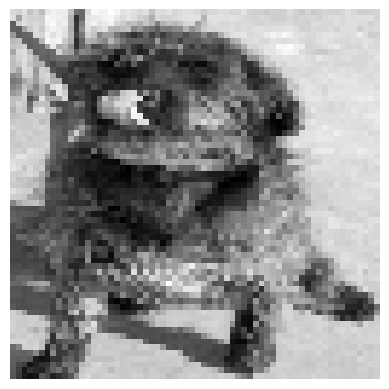

In [7]:
import matplotlib.pyplot as plt

plt.imshow(images[0], cmap='gray')
plt.axis('off')
plt.show()

## Komórki odpowiadające za definicję i trening modelu

**Ustawiamy ziarno generatora liczb losowych biblioteki NumPy oraz TensorFlow na 33. Określamy wymiar ukryty modelu na 1024.**

In [8]:
import tensorflow as tf

np.random.seed(33)
tf.random.set_seed(33)
latent_dim = 1024

In [9]:
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers
from keras.layers import Input, Dense, Lambda, Flatten, Conv2D, Activation, MaxPool2D, LayerNormalization, UpSampling2D, Reshape
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy

**Klasa Sampling reprezentuje warstwę próbkującą w modelu.**

In [10]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

**Definiujemy warstwy naszego encodera.**

In [11]:
encoder_inputs = keras.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 8, 8, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

**Definiujemy warstwy naszego decodera.**

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(16 * 16 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 16384)             16793600  
                                                                 
 reshape (Reshape)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 64, 64, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 64, 64, 1)         289 

**Klasa GenerateImagesCallback jest niestandardowym callbackiem zdefiniowanym w TensorFlow, używanym do generowania obrazów na koniec ustalonej epoki treningowej. Zaimplementowaliśmy to aby sprawdzać jak model generuje obrazy co daną ilość epok.**

In [13]:
from keras.callbacks import Callback

class GenerateImagesCallback(Callback):
    def __init__(self, decoder, latent_dim, selected_gen):
        self.decoder = decoder
        self.latent_dim = latent_dim
        self.selected_gen = selected_gen

    def on_epoch_end(self, epoch, logs=None):
        if epoch > 0 and epoch % 200 == 0:
            latent_sample = np.random.normal(0, 1, size=[self.selected_gen, self.latent_dim])
            input_decoded = self.decoder.predict(latent_sample)
            dogs = input_decoded.reshape((self.selected_gen, 64, 64))

            print("Generated images: ")
            fig, axs = plt.subplots(1, self.selected_gen, figsize=(15, 15))
            for i in range(self.selected_gen):
                axs[i].imshow(dogs[i, :, :], cmap='gray')
                axs[i].axis('off')
            plt.show()

**Tutaj implementujemy mechanizm harmonogramu wartości beta w trakcie treningu przy użyciu Keras Callbacks.  Wartości te zaczynają się od start i liniowo wzrastają do stop w ramach każdego cyklu. Cały proces jest cykliczny, co oznacza, że wartości beta będą ewoluować w trakcie kolejnych epok treningu, zgodnie z zadanym harmonogramem. Klasa VAE to implementacja modelu autoenkodera w Keras. Klasa korzysta z trzech metryk śledzących w trakcie treningu: Total Loss, Reconstruction Loss, KL Loss. Zawiera również fukncje definiującą trening.**

In [14]:
from keras.callbacks import LambdaCallback
import keras.backend as K
initial_beta = 0.001
epochs = 1000
beta = K.variable(initial_beta, name="beta")

def frange_cycle_linear(n_iter, start=0.001, stop=1.0,  n_cycle=4, ratio=0.5):
    L = np.ones(n_iter) * stop
    period = n_iter/n_cycle
    step = (stop-start)/(period*ratio)

    for c in range(n_cycle):
        v, i = start, 0
        while v <= stop and (int(i+c*period) < n_iter):
            L[int(i+c*period)] = v
            v += step
            i += 1
    return L

betas = frange_cycle_linear(epochs, stop = 0.0353)

class BetaAnnealingCallback(LambdaCallback):
    def __init__(self, schedule):
        super(BetaAnnealingCallback, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        K.set_value(beta, betas[epoch])
        print(f'Current epoch: {epoch}, Beta: {betas[epoch]}')

def beta_schedule(epoch):
    return betas

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.beta = 0.001
        self.initial_beta = 0.001
        self.epoch = 0
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1)) * beta
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "beta": beta
        }

**Tutaj implementujemy funkcję harmonogramu szybkości uczenia. Opisuje, jak wartość współczynnika uczenia powinna zmieniać się w trakcie treningu modelu w zależności od liczby epok.**

In [15]:
from keras.callbacks import LearningRateScheduler

def lr_schedule(epoch, initial_lr=0.001):
    decay_factor = 0.5
    decay_epochs = 10

    lr = initial_lr * (decay_factor ** (epoch // decay_epochs))
    return lr

initial_learning_rate = 0.001
lr_scheduler = LearningRateScheduler(lambda epoch: lr_schedule(epoch, initial_learning_rate))

**Przeprowadzamy trening.**

Current epoch: 0, Beta: 0.001
Epoch 1/1000
83/83 [==============================] - 10s 49ms/step - loss: 2778.1190 - reconstruction_loss: 2729.4363 - kl_loss: 0.2746 - beta: 0.0010 - lr: 0.0010
Current epoch: 1, Beta: 0.0012744
Epoch 2/1000
83/83 [==============================] - 3s 35ms/step - loss: 2639.8661 - reconstruction_loss: 2621.5466 - kl_loss: 1.3836 - beta: 0.0013 - lr: 0.0010
Current epoch: 2, Beta: 0.0015488
Epoch 3/1000
83/83 [==============================] - 3s 36ms/step - loss: 2548.5649 - reconstruction_loss: 2519.3142 - kl_loss: 2.1609 - beta: 0.0015 - lr: 0.0010
Current epoch: 3, Beta: 0.0018231999999999999
Epoch 4/1000
83/83 [==============================] - 3s 35ms/step - loss: 2489.7029 - reconstruction_loss: 2475.6255 - kl_loss: 2.9226 - beta: 0.0018 - lr: 0.0010
Current epoch: 4, Beta: 0.0020976
Epoch 5/1000
83/83 [==============================] - 3s 37ms/step - loss: 2463.6750 - reconstruction_loss: 2455.9263 - kl_loss: 3.4286 - beta: 0.0021 - lr: 0.0010
C

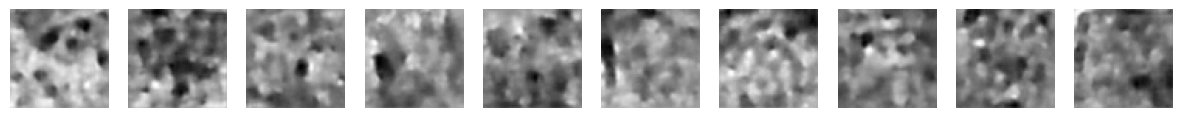

83/83 [==============================] - 4s 45ms/step - loss: 2388.4372 - reconstruction_loss: 2369.0903 - kl_loss: 24.5321 - beta: 0.0353 - lr: 9.5367e-10
Current epoch: 201, Beta: 0.0353
Epoch 202/1000
83/83 [==============================] - 3s 38ms/step - loss: 2396.0319 - reconstruction_loss: 2369.0864 - kl_loss: 24.5320 - beta: 0.0353 - lr: 9.5367e-10
Current epoch: 202, Beta: 0.0353
Epoch 203/1000
83/83 [==============================] - 3s 38ms/step - loss: 2394.2583 - reconstruction_loss: 2369.1062 - kl_loss: 24.5313 - beta: 0.0353 - lr: 9.5367e-10
Current epoch: 203, Beta: 0.0353
Epoch 204/1000
83/83 [==============================] - 3s 39ms/step - loss: 2393.5362 - reconstruction_loss: 2369.1970 - kl_loss: 24.5300 - beta: 0.0353 - lr: 9.5367e-10
Current epoch: 204, Beta: 0.0353
Epoch 205/1000
83/83 [==============================] - 3s 39ms/step - loss: 2396.9431 - reconstruction_loss: 2369.0776 - kl_loss: 24.5311 - beta: 0.0353 - lr: 9.5367e-10
Current epoch: 205, Beta: 0.

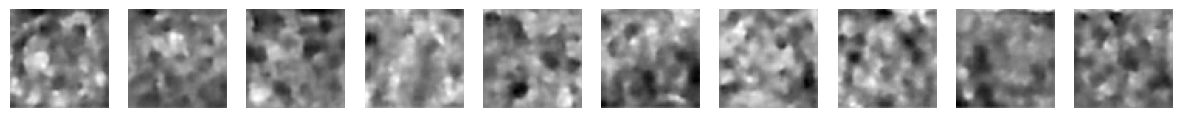

83/83 [==============================] - 4s 42ms/step - loss: 2393.7104 - reconstruction_loss: 2369.1304 - kl_loss: 24.5314 - beta: 0.0353 - lr: 9.0949e-16
Current epoch: 401, Beta: 0.0353
Epoch 402/1000
83/83 [==============================] - 3s 38ms/step - loss: 2392.8637 - reconstruction_loss: 2369.1426 - kl_loss: 24.5315 - beta: 0.0353 - lr: 9.0949e-16
Current epoch: 402, Beta: 0.0353
Epoch 403/1000
83/83 [==============================] - 3s 38ms/step - loss: 2392.7522 - reconstruction_loss: 2369.0859 - kl_loss: 24.5304 - beta: 0.0353 - lr: 9.0949e-16
Current epoch: 403, Beta: 0.0353
Epoch 404/1000
83/83 [==============================] - 3s 39ms/step - loss: 2393.6762 - reconstruction_loss: 2369.0920 - kl_loss: 24.5316 - beta: 0.0353 - lr: 9.0949e-16
Current epoch: 404, Beta: 0.0353
Epoch 405/1000
83/83 [==============================] - 3s 39ms/step - loss: 2390.4129 - reconstruction_loss: 2369.1489 - kl_loss: 24.5306 - beta: 0.0353 - lr: 9.0949e-16
Current epoch: 405, Beta: 0.

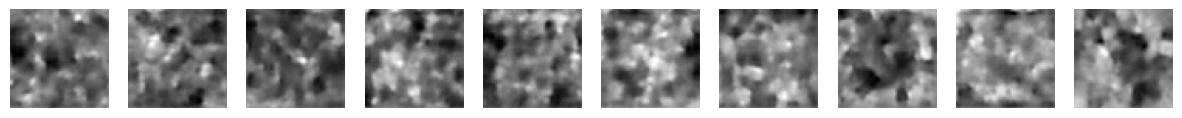

83/83 [==============================] - 4s 42ms/step - loss: 2391.9283 - reconstruction_loss: 2369.1208 - kl_loss: 19.7650 - beta: 0.0284 - lr: 8.6736e-22
Current epoch: 601, Beta: 0.028714400000000032
Epoch 602/1000
83/83 [==============================] - 3s 39ms/step - loss: 2391.4957 - reconstruction_loss: 2369.1707 - kl_loss: 19.9549 - beta: 0.0287 - lr: 8.6736e-22
Current epoch: 602, Beta: 0.028988800000000033
Epoch 603/1000
83/83 [==============================] - 3s 38ms/step - loss: 2388.8649 - reconstruction_loss: 2369.1177 - kl_loss: 20.1463 - beta: 0.0290 - lr: 8.6736e-22
Current epoch: 603, Beta: 0.029263200000000034
Epoch 604/1000
83/83 [==============================] - 3s 38ms/step - loss: 2392.1434 - reconstruction_loss: 2369.1331 - kl_loss: 20.3373 - beta: 0.0293 - lr: 8.6736e-22
Current epoch: 604, Beta: 0.029537600000000035
Epoch 605/1000
83/83 [==============================] - 3s 38ms/step - loss: 2390.2285 - reconstruction_loss: 2369.1829 - kl_loss: 20.5249 - be

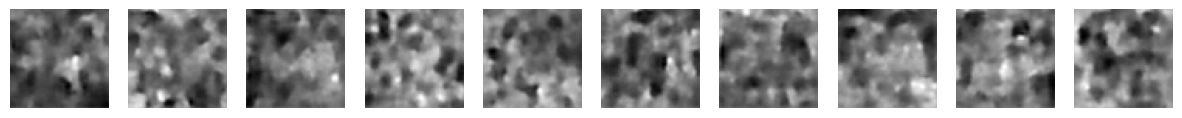

83/83 [==============================] - 4s 46ms/step - loss: 2381.1666 - reconstruction_loss: 2369.0828 - kl_loss: 10.2299 - beta: 0.0147 - lr: 8.2718e-28
Current epoch: 801, Beta: 0.014994399999999984
Epoch 802/1000
83/83 [==============================] - 3s 39ms/step - loss: 2378.4105 - reconstruction_loss: 2369.0986 - kl_loss: 10.4203 - beta: 0.0150 - lr: 8.2718e-28
Current epoch: 802, Beta: 0.015268799999999983
Epoch 803/1000
83/83 [==============================] - 3s 38ms/step - loss: 2378.2826 - reconstruction_loss: 2369.1040 - kl_loss: 10.6105 - beta: 0.0153 - lr: 8.2718e-28
Current epoch: 803, Beta: 0.015543199999999983
Epoch 804/1000
83/83 [==============================] - 3s 38ms/step - loss: 2380.2712 - reconstruction_loss: 2369.2139 - kl_loss: 10.8004 - beta: 0.0155 - lr: 8.2718e-28
Current epoch: 804, Beta: 0.015817599999999984
Epoch 805/1000
83/83 [==============================] - 3s 39ms/step - loss: 2379.8092 - reconstruction_loss: 2369.2356 - kl_loss: 10.9917 - be

In [17]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(images, epochs=epochs, batch_size=128, callbacks=[BetaAnnealingCallback(beta_schedule), GenerateImagesCallback(decoder, latent_dim=1024, selected_gen=10), lr_scheduler])

## Generowanie nowych przykładów

Latent sample:  [[ 1.60160154 -2.30306091 -0.2057432  ...  0.59761352 -0.81793898
   0.30344724]
 [ 1.74711107  2.79068661  1.14285793 ... -0.07705928 -0.27856093
   0.16496886]
 [-0.24053308 -0.12015528 -0.55592401 ...  1.38770103 -1.67243975
   0.76464323]
 ...
 [-1.19995215  2.03159535  0.13119749 ... -0.33602302  1.56492542
   0.20735173]
 [-0.63711876 -0.37657045  0.35359364 ... -0.38692646 -0.40727864
  -0.49124593]
 [-0.91339874 -0.65459037 -0.40827454 ...  0.73943425  0.19646559
   2.07261923]]
1/1 [==============================] - 0s 17ms/step
Generated images: 


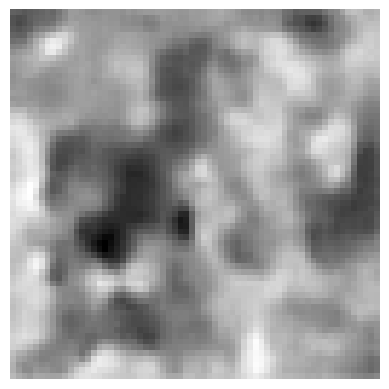

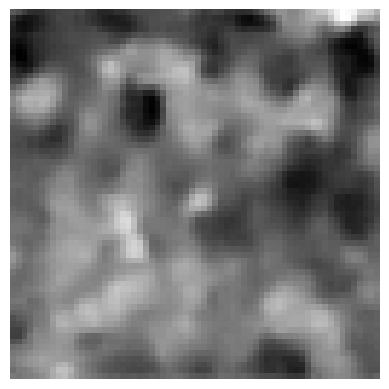

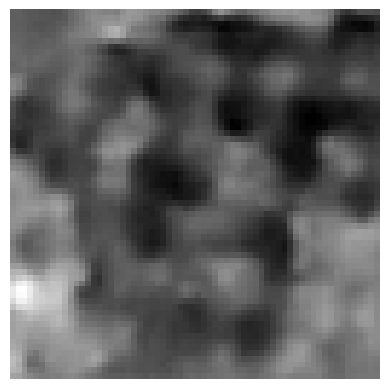

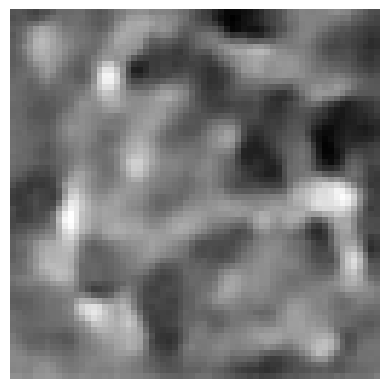

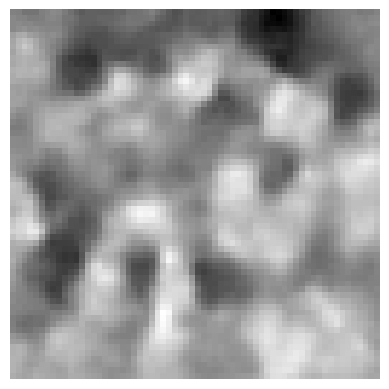

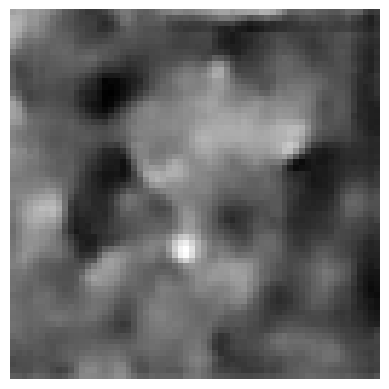

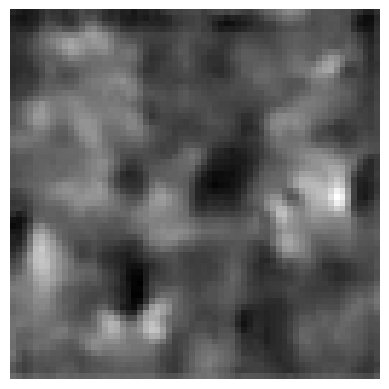

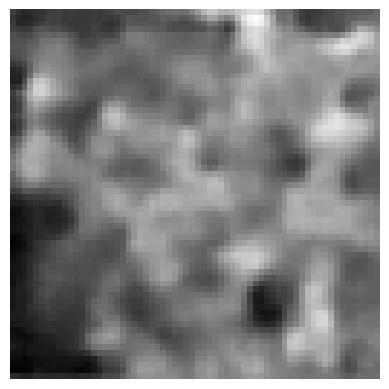

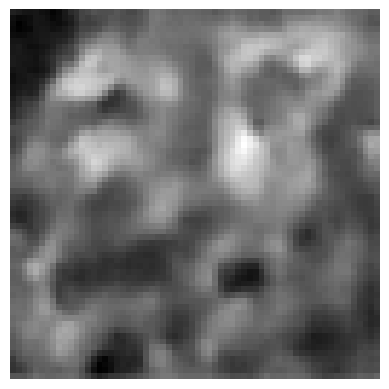

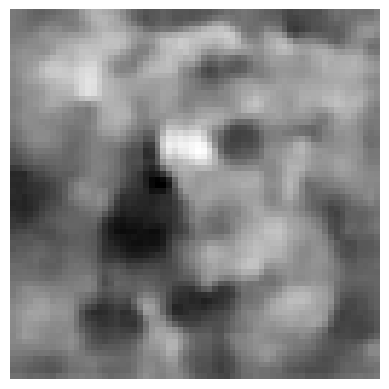

In [36]:
selected_gen = 10
latent_sample = np.random.normal(0,1,size=[selected_gen, latent_dim])

print("Latent sample: ", latent_sample)

input_decoded = decoder.predict(latent_sample)
dogs = input_decoded.reshape((selected_gen,64,64))

print("Generated images: ")
for i in range(selected_gen):
  plt.imshow(dogs[i, :, :], cmap='gray')
  plt.axis('off')
  plt.show()